In [36]:
from selenium.webdriver.firefox.firefox_binary import FirefoxBinary
from selenium import webdriver
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from bs4 import BeautifulSoup
import time

def checkgeneexists(cookiezi, driver):
    
    #driver = webdriver.Firefox()
                                 #if not working (not in env variables), paste in executable path to geckodriver.exe file
                                 #executable_path=r'C:\Users\Kevin\geckodriver-v0.29.1-win64\geckodriver.exe')
        
    replace = "https://www.genecards.org/cgi-bin/carddisp.pl?gene=" + cookiezi
    driver.get(replace)
    time.sleep(2)
    
    dog = driver.find_elements_by_id("aliases_descriptions")
    
    cat = 0
    vaxei = "Target found"

    if not dog:
        driver.get("https://www.genecards.org/Search/Keyword?queryString=" + cookiezi)
        time.sleep(5)
        check = driver.find_elements_by_class_name("gc-gene-symbol")
        if check:
            replace = "https://www.genecards.org/cgi-bin/carddisp.pl?gene=" + driver.find_element_by_class_name("gc-gene-symbol").text
            vaxei = driver.find_element_by_class_name("gc-gene-symbol").text
            driver.get(replace)
            cat = 1
        else:
            vaxei = "Target does not exist, nor does it have related targets! Try again"
            cat = 2

    
    return replace, driver, cat, vaxei

##########################################################################################################


def genecards(osugame, woof): #osugame input will be a gene name
    #Test links:
    
    #driver = webdriver.Firefox(executable_path=r'C:\Users\Kevin\geckodriver-v0.29.1-win64\geckodriver.exe')
        
    source =  "https://www.genecards.org/cgi-bin/carddisp.pl?gene=" + osugame   

    source, driver, alternatesearch, newtarget = checkgeneexists(osugame, woof)
    
    n = 0
    
    if alternatesearch != 2:
        table = driver.find_element_by_id("aliases_descriptions")
        aliasnames = table.find_elements_by_tag_name("li")
        title = driver.find_element_by_tag_name("strong").text

        ensembl = ""
        mrekk = []
        check = 0
        
        
        for cat in aliasnames:
            cow = 0
            numbers = ""
            sups = cat.find_elements_by_tag_name("sup")
            if not sups:
                sups = cat.find_elements_by_class_name("gc-ga-link")
                cow = 1
            #print(cow)
            
        
            if cow == 0:
                for fish in sups:
                    numbers = numbers + " " + fish.text
            elif cow == 1:
                if ":" not in cat.text:
                    for fish in sups:
                        numbers = numbers + ", " + fish.text
                numbers = numbers[2:]
                numbers = " (" + numbers + ")"
            #print(cat.text)
            #print(numbers)
            if numbers!= "" and numbers!=" ()":
                #print(cat.text.split(numbers)[0])
                mrekk.append(str(cat.text[:-len(numbers)]))


            if "Ensembl" in cat.text: 
                ensembl = cat.text
                check = 1
            elif check == 0:
                ensembl = "ENSEMBL NOT FOUND"

        #print()
        ensembl = ensembl.split()[1]

        #driver.close()

        return ensembl,mrekk,title, driver, source, alternatesearch, newtarget
    
    else:
        
        return "","","", driver, "", alternatesearch, newtarget
    

############################################################################################
 

def getopentargets(genename, drivername): #genename will be a gene name

    ensemblname, aliases,name, nd, genecardslink, searchno, target2 = genecards(genename, drivername)
    link = ""
    woof = 0
    if searchno !=2:
        conditions = []
        if ensemblname == "NOT":
            nd.get("https://platform.opentargets.org/search?q=" + name + "&page=1")
            time.sleep(2)
            link = nd.find_element_by_class_name("jss28").get_attribute("href")
            woof = 1
        #print(link)
        
        driver = nd #webdriver.Firefox() #executable_path=r'C:\Users\Kevin\geckodriver-v0.29.1-win64\geckodriver.exe' #make sure this exists somewhere in a local, varies from user to user, and copy the path here
        
        if woof == 0:
            opentargetslink = "https://platform.opentargets.org/target/" + ensemblname + "/associations"
        else:
            opentargetslink = link
            
        if "ENSG00000105810" in link and genename!="CDK6":
                return [], aliases, name, genecardslink, "OpenTargets gene not found!", target2, nd
        
        driver.get(opentargetslink)
        time.sleep(4)

        results = driver.find_elements_by_class_name("MuiTableRow-root")
        if not results:
            time.sleep(2)
        elif  "Name" in results[0].text:
            results.pop(0)

        for result in results:
            product_name = result.find_element_by_tag_name('span')
            #print("                        " + product_name.text)
            conditions.append(product_name.text)

        search = ""
        if searchno == 1:
            search = "Original target not found, closest target found: " + target2
        elif searchno == 0:
            search = target2
        
        
        if len(conditions)>10:
            conditions = conditions[:10]
        

        return conditions, aliases, name, genecardslink, opentargetslink, search, nd
    
    else:
        
        #nd.close()
        return [], [], str(genename) + "?", "DNE", "DNE", target2, nd
    


In [42]:

doggie = ['PRB4', 'PRC1', 'PRCC', 'PRCD', 'PRCP', 'PRDM1', 'PRDM2', 'PRDM4', 'PRDM5', 'PRDM6', 'PRDM7', 'PRDM8', 'PRDM9', 'PRDM10', 'PRDM11', 'PRDM12', 'PRDM13', 'PRDM14', 'PRDM15', 'PRDM16', 'PRDX1', 'PRDX2', 'PRDX3', 'PRDX4', 'PRDX5', 'PRDX6', 'PREB', 'PRELID1', 'PRELID2', 'PRELID3A', 'PRELID3B', 'PRELP', 'PREP', 'PREPL', 'PREX1', 'PREX2', 'PRF1', 'PRG2', 'PRG3', 'PRG4', 'PRH1', 'PRH2', 'PRICKLE1', 'PRICKLE2', 'PRICKLE3', 'PRICKLE4', 'PRIM1', 'PRIM2', 'PRIMA1', 'PRIMPOL', 'PRKAA1', 'PRKAA2', 'PRKAB1', 'PRKAB2', 'PRKACA', 'PRKACB', 'PRKACG', 'PRKAG1', 'PRKAG2', 'PRKAG3', 'PRKAR1A', 'PRKAR1B', 'PRKAR2A', 'PRKAR2B', 'PRKCA', 'PRKCB', 'PRKCD', 'PRKCE', 'PRKCG', 'PRKCH', 'PRKCI', 'PRKCQ', 'PRKCSH', 'PRKCZ', 'PRKD1', 'PRKD2', 'PRKD3', 'PRKDC', 'PRKG1', 'PRKG2', 'PRKN', 'PRKRA', 'PRKRIP1', 'PRKX', 'PRL', 'PRLH', 'PRLHR', 'PRLR', 'PRM1', 'PRM2', 'PRM3', 'PRMT1', 'PRMT2', 'PRMT3', 'PRMT5', 'PRMT6', 'PRMT7', 'PRMT8', 'PRMT9', 'PRND', 'PRNP', 'PROB1', 'PROC', 'PROCA1', 'PROCR', 'PRODH', 'PRODH2', 'PROK1', 'PROK2', 'PROKR1', 'PROKR2', 'PROM1', 'PROM2', 'PROP1', 'PRORP', 'PRORY', 'PROS1', 'PROSER1', 'PROSER2', 'PROSER3', 'PROX1', 'PROX2', 'PROZ', 'PRPF3', 'PRPF4', 'PRPF4B', 'PRPF6', 'PRPF8', 'PRPF18', 'PRPF19', 'PRPF31', 'PRPF38A', 'PRPF38B', 'PRPF39', 'PRPF40A', 'PRPF40B', 'PRPH', 'PRPH2', 'PRPS1', 'PRPS1L1', 'PRPS2', 'PRPSAP1', 'PRPSAP2', 'PRR3', 'PRR4', 'PRR5', 'PRR5L', 'PRR7', 'PRR9', 'PRR11', 'PRR12', 'PRR13', 'PRR14', 'PRR14L', 'PRR15', 'PRR15L', 'PRR16', 'PRR18', 'PRR19', 'PRR20A', 'PRR20B', 'PRR20C', 'PRR20D', 'PRR20E', 'PRR20G', 'PRR22', 'PRR23A', 'PRR23B', 'PRR23C', 'PRR23D1', 'PRR23D2', 'PRR25', 'PRR27', 'PRR29', 'PRR30', 'PRR32', 'PRR33', 'PRR35', 'PRR36', 'PRRC1', 'PRRC2A', 'PRRC2B', 'PRRC2C', 'PRRG1', 'PRRG2', 'PRRG3', 'PRRG4', 'PRRT1', 'PRRT1B', 'PRRT2', 'PRRT3', 'PRRT4', 'PRRX1', 'PRRX2', 'PRSS1', 'PRSS2', 'PRSS3', 'PRSS8', 'PRSS12', 'PRSS16', 'PRSS21', 'PRSS22', 'PRSS23', 'PRSS27', 'PRSS33', 'PRSS35', 'PRSS36', 'PRSS37', 'PRSS38', 'PRSS41', 'PRSS48', 'PRSS50', 'PRSS51', 'PRSS53', 'PRSS54', 'PRSS55', 'PRSS56', 'PRSS57', 'PRSS58', 'PRTFDC1', 'PRTG', 'PRTN3', 'PRUNE1', 'PRUNE2', 'PRX', 'PRXL2A', 'PRXL2B', 'PRXL2C', 'PRY', 'PRY2', 'PSAP', 'PSAPL1', 'PSAT1', 'PSCA', 'PSD', 'PSD2', 'PSD3', 'PSD4', 'PSEN1', 'PSEN2', 'PSENEN', 'PSG1', 'PSG2', 'PSG3', 'PSG4', 'PSG5', 'PSG6', 'PSG7', 'PSG8', 'PSG9', 'PSG11', 'PSIP1', 'PSKH1', 'PSKH2', 'PSMA1', 'PSMA2', 'PSMA3', 'PSMA4', 'PSMA5', 'PSMA6', 'PSMA7', 'PSMA8', 'PSMB1', 'PSMB2', 'PSMB3', 'PSMB4', 'PSMB5', 'PSMB6', 'PSMB7', 'PSMB8', 'PSMB9', 'PSMB10', 'PSMB11', 'PSMC1', 'PSMC2', 'PSMC3', 'PSMC3IP', 'PSMC4', 'PSMC5', 'PSMC6', 'PSMD1', 'PSMD2', 'PSMD3', 'PSMD4', 'PSMD5', 'PSMD6', 'PSMD7', 'PSMD8', 'PSMD9', 'PSMD10', 'PSMD11', 'PSMD12', 'PSMD13', 'PSMD14', 'PSME1', 'PSME2', 'PSME3', 'PSME3IP1', 'PSME4', 'PSMF1', 'PSMG1', 'PSMG2', 'PSMG3', 'PSMG4', 'PSORS1C1', 'PSORS1C2', 'PSPC1', 'PSPH', 'PSPN', 'PSRC1', 'PSTK', 'PSTPIP1', 'PSTPIP2', 'PTAFR', 'PTAR1', 'PTBP1', 'PTBP2', 'PTBP3', 'PTCD1', 'PTCD2', 'PTCD3', 'PTCH1', 'PTCH2', 'PTCHD1', 'PTCHD3', 'PTCHD4', 'PTCRA', 'PTDSS1', 'PTDSS2', 'PTEN', 'PTER', 'PTF1A', 'PTGDR', 'PTGDR2', 'PTGDS', 'PTGER1', 'PTGER2', 'PTGER3', 'PTGER4', 'PTGES', 'PTGES2', 'PTGES3', 'PTGES3L', 'PTGFR', 'PTGFRN', 'PTGIR', 'PTGIS', 'PTGR1', 'PTGR2', 'PTGS1', 'PTGS2', 'PTH', 'PTH1R', 'PTH2', 'PTH2R', 'PTHLH', 'PTK2', 'PTK2B', 'PTK6', 'PTK7', 'PTMA', 'PTMS', 'PTN', 'PTOV1', 'PTP4A1', 'PTP4A2', 'PTP4A3', 'PTPA', 'PTPDC1', 'PTPMT1', 'PTPN1', 'PTPN2', 'PTPN3', 'PTPN4', 'PTPN5', 'PTPN6', 'PTPN7', 'PTPN9', 'PTPN11', 'PTPN12', 'PTPN13', 'PTPN14', 'PTPN18', 'PTPN20', 'PTPN21', 'PTPN22', 'PTPN23', 'PTPRA', 'PTPRB', 'PTPRC', 'PTPRCAP', 'PTPRD', 'PTPRE', 'PTPRF', 'PTPRG', 'PTPRH', 'PTPRJ', 'PTPRK', 'PTPRM', 'PTPRN', 'PTPRN2', 'PTPRO', 'PTPRQ', 'PTPRR', 'PTPRS', 'PTPRT', 'PTPRU', 'PTPRZ1', 'PTRH1', 'PTRH2', 'PTRHD1', 'PTS', 'PTTG1', 'PTTG1IP', 'PTTG1IP2', 'PTTG2', 'PTX3', 'PTX4', 'PUDP', 'PUF60', 'PUM1', 'PUM2', 'PUM3', 'PURA', 'PURB', 'PURG', 'PUS1', 'PUS3', 'PUS7', 'PUS7L', 'PUS10', 'PUSL1', 'PVALB', 'PVALEF', 'PVR', 'PVRIG', 'PWP1', 'PWP2', 'PWWP2A', 'PWWP2B', 'PWWP3A', 'PWWP3B', 'PXDC1', 'PXDN', 'PXDNL', 'PXK', 'PXMP2', 'PXMP4', 'PXN', 'PXT1', 'PXYLP1', 'PYCARD', 'PYCR1', 'PYCR2', 'PYCR3', 'PYDC1', 'PYDC2', 'PYDC5', 'PYGB', 'PYGL', 'PYGM', 'PYGO1', 'PYGO2', 'PYHIN1', 'PYM1', 'PYROXD1', 'PYROXD2', 'PYURF', 'PYY', 'PZP', 'QARS1', 'QDPR', 'QKI', 'QPCT', 'QPCTL', 'QPRT', 'QRFP', 'QRFPR', 'QRICH1', 'QRICH2', 'QRSL1', 'QSER1', 'QSOX1', 'QSOX2', 'QTRT1', 'QTRT2', 'R3HCC1', 'R3HCC1L', 'R3HDM1', 'R3HDM2', 'R3HDM4', 'R3HDML', 'RAB1A', 'RAB1B', 'RAB2A', 'RAB2B', 'RAB3A', 'RAB3B', 'RAB3C', 'RAB3D', 'RAB3GAP1', 'RAB3GAP2', 'RAB3IL1', 'RAB3IP', 'RAB4A', 'RAB4B', 'RAB5A', 'RAB5B', 'RAB5C', 'RAB5IF', 'RAB6A', 'RAB6B', 'RAB6C', 'RAB6D', 'RAB7A', 'RAB7B', 'RAB8A', 'RAB8B', 'RAB9A', 'RAB9B', 'RAB10', 'RAB11A', 'RAB11B', 'RAB11FIP1', 'RAB11FIP2', 'RAB11FIP3', 'RAB11FIP4', 'RAB11FIP5', 'RAB12', 'RAB13', 'RAB14', 'RAB15', 'RAB17', 'RAB18', 'RAB19', 'RAB20', 'RAB21', 'RAB22A', 'RAB23', 'RAB24', 'RAB25', 'RAB26', 'RAB27A', 'RAB27B', 'RAB28', 'RAB29', 'RAB30', 'RAB31', 'RAB32', 'RAB33A', 'RAB33B', 'RAB34', 'RAB35', 'RAB36', 'RAB37', 'RAB38', 'RAB39A', 'RAB39B', 'RAB40A', 'RAB40AL', 'RAB40B', 'RAB40C', 'RAB41', 'RAB42', 'RAB43', 'RAB44', 'RABAC1', 'RABEP1', 'RABEP2', 'RABEPK', 'RABGAP1', 'RABGAP1L', 'RABGEF1', 'RABGGTA', 'RABGGTB', 'RABIF', 'RABL2A', 'RABL2B', 'RABL3', 'RABL6', 'RAC1', 'RAC2', 'RAC3', 'RACGAP1', 'RACK1', 'RAD1', 'RAD9A', 'RAD9B', 'RAD17', 'RAD18', 'RAD21', 'RAD21L1', 'RAD23A', 'RAD23B', 'RAD50', 'RAD51', 'RAD51AP1', 'RAD51AP2', 'RAD51B', 'RAD51C', 'RAD51D', 'RAD52', 'RAD54B', 'RAD54L', 'RAD54L2', 'RADIL', 'RADX', 'RAE1', 'RAET1E', 'RAET1G', 'RAET1L', 'RAF1', 'RAG1', 'RAG2', 'RAI1', 'RAI2', 'RAI14', 'RALA', 'RALB', 'RALBP1', 'RALGAPA1', 'RALGAPA2', 'RALGAPB', 'RALGDS', 'RALGPS1', 'RALGPS2', 'RALY', 'RALYL', 'RAMAC', 'RAMP1', 'RAMP2', 'RAMP3', 'RAN', 'RANBP1', 'RANBP2', 'RANBP3', 'RANBP3L', 'RANBP6', 'RANBP9', 'RANBP10', 'RANBP17', 'RANGAP1', 'RANGRF', 'RAP1A', 'RAP1B', 'RAP1GAP', 'RAP1GAP2', 'RAP1GDS1', 'RAP2A', 'RAP2B', 'RAP2C', 'RAPGEF1', 'RAPGEF2', 'RAPGEF3', 'RAPGEF4', 'RAPGEF5', 'RAPGEF6', 'RAPGEFL1', 'RAPH1', 'RAPSN', 'RARA', 'RARB', 'RARG', 'RARRES1', 'RARRES2', 'RARS1', 'RARS2', 'RASA1', 'RASA2', 'RASA3', 'RASA4', 'RASA4B', 'RASAL1', 'RASAL2', 'RASAL3', 'RASD1', 'RASD2', 'RASEF', 'RASGEF1A', 'RASGEF1B', 'RASGEF1C', 'RASGRF1', 'RASGRF2', 'RASGRP1', 'RASGRP2', 'RASGRP3', 'RASGRP4', 'RASIP1', 'RASL10A', 'RASL10B', 'RASL11A', 'RASL11B', 'RASL12', 'RASSF1', 'RASSF2', 'RASSF3', 'RASSF4', 'RASSF5', 'RASSF6', 'RASSF7', 'RASSF8', 'RASSF9', 'RASSF10', 'RAVER1', 'RAVER2', 'RAX', 'RAX2', 'RB1', 'RB1CC1', 'RBAK', 'RBBP4', 'RBBP5', 'RBBP6', 'RBBP7', 'RBBP8', 'RBBP8NL', 'RBBP9', 'RBCK1', 'RBFA', 'RBFOX1', 'RBFOX2', 'RBFOX3', 'RBIS', 'RBKS', 'RBL1', 'RBL2', 'RBM3', 'RBM4', 'RBM4B', 'RBM5', 'RBM6', 'RBM7', 'RBM8A', 'RBM10', 'RBM11', 'RBM12', 'RBM12B', 'RBM14', 'RBM15', 'RBM15B', 'RBM17', 'RBM18', 'RBM19', 'RBM20', 'RBM22', 'RBM23', 'RBM24', 'RBM25', 'RBM26', 'RBM27', 'RBM28', 'RBM33', 'RBM34', 'RBM38', 'RBM39', 'RBM41', 'RBM42', 'RBM43', 'RBM44', 'RBM45', 'RBM46', 'RBM47', 'RBM48', 'RBMS1', 'RBMS2', 'RBMS3', 'RBMX', 'RBMX2', 'RBMXL1', 'RBMXL2', 'RBMXL3', 'RBMY1A1', 'RBMY1B', 'RBMY1C', 'RBMY1D', 'RBMY1E', 'RBMY1F', 'RBMY1J', 'RBP1', 'RBP2', 'RBP3', 'RBP4', 'RBP5', 'RBP7', 'RBPJ', 'RBPJL', 'RBPMS', 'RBPMS2', 'RBSN', 'RBX1', 'RC3H1', 'RC3H2', 'RCAN1', 'RCAN2', 'RCAN3', 'RCBTB1', 'RCBTB2', 'RCC1', 'RCC1L', 'RCC2', 'RCCD1', 'RCE1', 'RCHY1', 'RCL1', 'RCN1', 'RCN2', 'RCN3', 'RCOR1', 'RCOR2', 'RCOR3', 'RCSD1', 'RCVRN', 'RD3', 'RD3L', 'RDH5', 'RDH8', 'RDH10', 'RDH11', 'RDH12', 'RDH13', 'RDH14', 'RDH16', 'RDM1', 'RDX', 'REC8', 'REC114', 'RECK', 'RECQL', 'RECQL4', 'RECQL5', 'REELD1', 'REEP1', 'REEP2', 'REEP3', 'REEP4', 'REEP5', 'REEP6', 'REG1A', 'REG1B', 'REG3A', 'REG3G', 'REG4', 'REL', 'RELA', 'RELB', 'RELCH', 'RELL1', 'RELL2', 'RELN', 'RELT', 'REM1', 'REM2', 'REN', 'RENBP', 'REP15', 'REPIN1', 'REPS1', 'REPS2', 'RER1', 'RERE', 'RERG', 'RERGL', 'RESF1', 'RESP18', 'REST', 'RET', 'RETN', 'RETNLB', 'RETREG1', 'RETREG2', 'RETREG3', 'RETSAT', 'REV1', 'REV3L', 'REX1BD', 'REXO1', 'REXO2', 'REXO4', 'REXO5', 'RFC1', 'RFC2', 'RFC3', 'RFC4', 'RFC5', 'RFESD', 'RFFL', 'RFK', 'RFLNA', 'RFLNB', 'RFNG', 'RFPL1', 'RFPL2', 'RFPL3', 'RFPL4A', 'RFPL4AL1', 'RFPL4B', 'RFT1', 'RFTN1', 'RFTN2', 'RFWD3', 'RFX1', 'RFX2', 'RFX3', 'RFX4', 'RFX5', 'RFX6', 'RFX7', 'RFX8', 'RFXANK', 'RFXAP', 'RGCC', 'RGL1', 'RGL2', 'RGL3', 'RGL4', 'RGMA', 'RGMB', 'RGN', 'RGP1', 'RGPD1', 'RGPD2', 'RGPD3', 'RGPD4', 'RGPD5', 'RGPD6', 'RGPD8', 'RGR', 'RGS1', 'RGS2', 'RGS3', 'RGS4', 'RGS5', 'RGS6', 'RGS7', 'RGS7BP', 'RGS8', 'RGS9', 'RGS9BP', 'RGS10', 'RGS11', 'RGS12', 'RGS13', 'RGS14', 'RGS16', 'RGS17', 'RGS18', 'RGS19', 'RGS20', 'RGS21', 'RGS22', 'RGSL1', 'RHAG', 'RHBDD1', 'RHBDD2', 'RHBDD3', 'RHBDF1', 'RHBDF2', 'RHBDL1', 'RHBDL2', 'RHBDL3', 'RHBG', 'RHCE', 'RHCG', 'RHD', 'RHEB', 'RHEBL1', 'RHEX', 'RHNO1', 'RHO', 'RHOA', 'RHOB', 'RHOBTB1', 'RHOBTB2', 'RHOBTB3', 'RHOC', 'RHOD', 'RHOF', 'RHOG', 'RHOH', 'RHOJ', 'RHOQ', 'RHOT1', 'RHOT2', 'RHOU', 'RHOV', 'RHOXF1', 'RHOXF2', 'RHOXF2B', 'RHPN1', 'RHPN2', 'RIBC1', 'RIBC2', 'RIC1', 'RIC3', 'RIC8A', 'RIC8B', 'RICTOR', 'RIDA', 'RIF1', 'RIIAD1', 'RILP', 'RILPL1', 'RILPL2', 'RIMBP2', 'RIMBP3', 'RIMBP3B', 'RIMBP3C', 'RIMKLA', 'RIMKLB', 'RIMS1', 'RIMS2', 'RIMS3', 'RIMS4', 'RIN1', 'RIN2', 'RIN3', 'RING1', 'RINL', 'RINT1', 'RIOK1', 'RIOK2', 'RIOK3', 'RIOX1', 'RIOX2', 'RIPK1', 'RIPK2', 'RIPK3', 'RIPK4', 'RIPOR1', 'RIPOR2', 'RIPOR3', 'RIPPLY1', 'RIPPLY2', 'RIPPLY3', 'RIT1', 'RIT2', 'RITA1', 'RLBP1', 'RLF', 'RLIM', 'RLN1', 'RLN2', 'RLN3', 'RMC1', 'RMDN1', 'RMDN2', 'RMDN3', 'RMI1', 'RMI2', 'RMND1', 'RMND5A', 'RMND5B', 'RNASE1', 'RNASE2', 'RNASE3', 'RNASE4', 'RNASE6', 'RNASE7', 'RNASE8', 'RNASE9', 'RNASE10', 'RNASE11', 'RNASE12', 'RNASE13', 'RNASEH1', 'RNASEH2A', 'RNASEH2B', 'RNASEH2C', 'RNASEK', 'RNASEL', 'RNASET2', 'RND1', 'RND2', 'RND3', 'RNF2', 'RNF4', 'RNF5', 'RNF6', 'RNF7', 'RNF8', 'RNF10', 'RNF11', 'RNF13', 'RNF14', 'RNF17', 'RNF19A', 'RNF19B', 'RNF20', 'RNF24', 'RNF25', 'RNF26', 'RNF31', 'RNF32', 'RNF34', 'RNF38', 'RNF39', 'RNF40', 'RNF41', 'RNF43', 'RNF44', 'RNF103', 'RNF111', 'RNF112', 'RNF113A', 'RNF113B', 'RNF114', 'RNF115', 'RNF121', 'RNF122', 'RNF123', 'RNF125', 'RNF126', 'RNF128', 'RNF130', 'RNF133', 'RNF135', 'RNF138', 'RNF139', 'RNF141', 'RNF144A', 'RNF144B', 'RNF145', 'RNF146', 'RNF148', 'RNF149', 'RNF150', 'RNF151', 'RNF152', 'RNF157', 'RNF165', 'RNF166', 'RNF167', 'RNF168', 'RNF169', 'RNF170', 'RNF175', 'RNF180', 'RNF181', 'RNF182', 'RNF183', 'RNF185', 'RNF186', 'RNF187', 'RNF207', 'RNF208', 'RNF212', 'RNF212B', 'RNF213', 'RNF214', 'RNF215', 'RNF216', 'RNF217', 'RNF220', 'RNF222', 'RNF223', 'RNF224', 'RNF225', 'RNF227', 'RNFT1', 'RNFT2', 'RNGTT', 'RNH1', 'RNLS', 'RNMT', 'RNPC3', 'RNPEP', 'RNPEPL1', 'RNPS1', 'RO60', 'ROBO1', 'ROBO2', 'ROBO3', 'ROBO4', 'ROCK1', 'ROCK2', 'ROGDI', 'ROM1', 'ROMO1', 'ROPN1', 'ROPN1B', 'ROPN1L', 'ROR1', 'ROR2', 'RORA', 'RORB', 'RORC', 'ROS1', 'RP1', 'RP1L1', 'RP2', 'RP9', 'RPA1', 'RPA2', 'RPA3', 'RPA4', 'RPAIN', 'RPAP1', 'RPAP2', 'RPAP3', 'RPE', 'RPE65', 'RPEL1', 'RPF1', 'RPF2', 'RPGR', 'RPGRIP1', 'RPGRIP1L', 'RPH3A', 'RPH3AL', 'RPIA', 'RPL3', 'RPL3L', 'RPL4', 'RPL5', 'RPL6', 'RPL7', 'RPL7A', 'RPL7L1', 'RPL8', 'RPL9', 'RPL10', 'RPL10A', 'RPL10L', 'RPL11', 'RPL12', 'RPL13', 'RPL13A', 'RPL14', 'RPL15', 'RPL17', 'RPL18', 'RPL18A', 'RPL19', 'RPL21', 'RPL22', 'RPL22L1', 'RPL23', 'RPL23A', 'RPL24', 'RPL26', 'RPL26L1', 'RPL27', 'RPL27A', 'RPL28', 'RPL29', 'RPL30', 'RPL31', 'RPL32', 'RPL34', 'RPL35', 'RPL35A', 'RPL36', 'RPL36A', 'RPL36AL', 'RPL37', 'RPL37A', 'RPL38', 'RPL39', 'RPL39L', 'RPL41', 'RPLP0', 'RPLP1', 'RPLP2', 'RPN1', 'RPN2', 'RPP14', 'RPP21', 'RPP25', 'RPP25L', 'RPP30', 'RPP38', 'RPP40', 'RPRD1A', 'RPRD1B', 'RPRD2', 'RPRM', 'RPRML', 'RPS2', 'RPS3', 'RPS3A', 'RPS4X', 'RPS4Y1', 'RPS4Y2', 'RPS5', 'RPS6', 'RPS6KA1', 'RPS6KA2', 'RPS6KA3', 'RPS6KA4', 'RPS6KA5', 'RPS6KA6', 'RPS6KB1', 'RPS6KB2', 'RPS6KC1', 'RPS6KL1', 'RPS7', 'RPS8', 'RPS9', 'RPS10', 'RPS11', 'RPS12', 'RPS13', 'RPS14', 'RPS15', 'RPS15A', 'RPS16', 'RPS17', 'RPS18', 'RPS19', 'RPS19BP1', 'RPS20', 'RPS21', 'RPS23', 'RPS24', 'RPS25', 'RPS26', 'RPS27', 'RPS27A', 'RPS27L', 'RPS28', 'RPS29', 'RPSA', 'RPTN', 'RPTOR', 'RPUSD1', 'RPUSD2', 'RPUSD3', 'RPUSD4', 'RRAD', 'RRAGA', 'RRAGB', 'RRAGC', 'RRAGD', 'RRAS', 'RRAS2', 'RRBP1', 'RREB1', 'RRH', 'RRM1', 'RRM2', 'RRM2B', 'RRN3', 'RRP1', 'RRP1B', 'RRP7A', 'RRP8', 'RRP9', 'RRP12', 'RRP15', 'RRP36', 'RRS1', 'RS1', 'RSAD1', 'RSAD2', 'RSBN1', 'RSBN1L', 'RSC1A1', 'RSF1', 'RSKR', 'RSL1D1', 'RSL24D1', 'RSPH1', 'RSPH3', 'RSPH4A', 'RSPH6A', 'RSPH9', 'RSPH10B', 'RSPH10B2', 'RSPH14', 'RSPO1', 'RSPO2', 'RSPO3', 'RSPO4', 'RSPRY1', 'RSRC1', 'RSRC2', 'RSRP1', 'RSU1', 'RTBDN', 'RTCA', 'RTCB', 'RTEL1', 'RTF1', 'RTF2', 'RTKN', 'RTKN2', 'RTL1', 'RTL3', 'RTL4', 'RTL5', 'RTL6', 'RTL8A', 'RTL8B', 'RTL8C', 'RTL9', 'RTL10', 'RTN1', 'RTN2', 'RTN3', 'RTN4', 'RTN4IP1', 'RTN4R', 'RTN4RL1', 'RTN4RL2', 'RTP1', 'RTP2', 'RTP3', 'RTP4', 'RTP5', 'RTRAF', 'RTTN', 'RUBCN', 'RUBCNL', 'RUFY1', 'RUFY2', 'RUFY3', 'RUFY4', 'RUNDC1', 'RUNDC3A', 'RUNDC3B', 'RUNX1', 'RUNX1T1', 'RUNX2', 'RUNX3', 'RUSC1', 'RUSC2', 'RUSF1', 'RUVBL1', 'RUVBL2', 'RWDD1', 'RWDD2A', 'RWDD2B', 'RWDD3', 'RWDD4', 'RXFP1', 'RXFP2', 'RXFP3', 'RXFP4', 'RXRA', 'RXRB', 'RXRG', 'RXYLT1', 'RYBP', 'RYK', 'RYR1', 'RYR2', 'RYR3', 'S1PR1', 'S1PR2', 'S1PR3', 'S1PR4', 'S1PR5', 'S100A1', 'S100A2', 'S100A3', 'S100A4', 'S100A5', 'S100A6', 'S100A7', 'S100A7A', 'S100A8', 'S100A9', 'S100A10', 'S100A11', 'S100A12', 'S100A13', 'S100A14', 'S100A16', 'S100B', 'S100G', 'S100P', 'S100PBP', 'S100Z', 'SAA1', 'SAA2', 'SAA4', 'SAAL1', 'SAC3D1', 'SACM1L', 'SACS', 'SAE1', 'SAFB', 'SAFB2', 'SAG', 'SAGE1', 'SALL1', 'SALL2', 'SALL3', 'SALL4', 'SAMD1', 'SAMD3', 'SAMD4A', 'SAMD4B', 'SAMD5', 'SAMD7', 'SAMD8', 'SAMD9', 'SAMD9L', 'SAMD10', 'SAMD11', 'SAMD12', 'SAMD13', 'SAMD14', 'SAMD15', 'SAMHD1', 'SAMM50', 'SAMSN1', 'SANBR', 'SAP18', 'SAP25', 'SAP30', 'SAP30BP', 'SAP30L', 'SAP130', 'SAPCD1', 'SAPCD2', 'SAR1A', 'SAR1B', 'SARAF', 'SARDH', 'SARM1', 'SARNP', 'SARS1', 'SARS2', 'SART1', 'SART3', 'SASH1', 'SASH3', 'SASS6', 'SAT1', 'SAT2', 'SATB1', 'SATB2', 'SATL1', 'SAV1', 'SAXO1', 'SAXO2', 'SAYSD1', 'SBDS', 'SBF1', 'SBF2', 'SBK1', 'SBK2', 'SBK3', 'SBNO1', 'SBNO2', 'SBSN', 'SBSPON', 'SC5D', 'SCAF1', 'SCAF4', 'SCAF8', 'SCAF11', 'SCAI', 'SCAMP1', 'SCAMP2', 'SCAMP3', 'SCAMP4', 'SCAMP5', 'SCAND1', 'SCAP', 'SCAPER', 'SCARA3', 'SCARA5', 'SCARB1', 'SCARB2', 'SCARF1', 'SCARF2', 'SCCPDH', 'SCD', 'SCD5', 'SCEL', 'SCFD1', 'SCFD2', 'SCG2', 'SCG3', 'SCG5', 'SCGB1A1', 'SCGB1C1', 'SCGB1C2', 'SCGB1D1', 'SCGB1D2', 'SCGB1D4', 'SCGB2A1', 'SCGB2A2', 'SCGB2B2', 'SCGB3A1', 'SCGB3A2', 'SCGN', 'SCHIP1', 'SCIMP', 'SCIN', 'SCLT1', 'SCLY', 'SCMH1', 'SCML1', 'SCML2', 'SCML4', 'SCN1A', 'SCN1B', 'SCN2A', 'SCN2B', 'SCN3A', 'SCN3B', 'SCN4A', 'SCN4B', 'SCN5A', 'SCN7A', 'SCN8A', 'SCN9A', 'SCN10A', 'SCN11A', 'SCNM1', 'SCNN1A', 'SCNN1B', 'SCNN1D', 'SCNN1G', 'SCO1', 'SCO2', 'SCOC', 'SCP2', 'SCP2D1', 'SCPEP1', 'SCRG1', 'SCRIB', 'SCRN1', 'SCRN2', 'SCRN3', 'SCRT1', 'SCRT2', 'SCT', 'SCTR', 'SCUBE1', 'SCUBE2', 'SCUBE3', 'SCX', 'SCYGR1', 'SCYGR2', 'SCYGR3', 'SCYGR4', 'SCYGR5', 'SCYGR6', 'SCYGR7', 'SCYGR8', 'SCYGR9', 'SCYGR10', 'SCYL1', 'SCYL2', 'SCYL3', 'SDAD1', 'SDC1', 'SDC2', 'SDC3', 'SDC4', 'SDCBP', 'SDCBP2', 'SDCCAG8', 'SDE2', 'SDF2', 'SDF2L1', 'SDF4', 'SDHA', 'SDHAF1', 'SDHAF2', 'SDHAF3', 'SDHAF4', 'SDHB', 'SDHC', 'SDHD', 'SDIM1', 'SDK1', 'SDK2', 'SDR9C7', 'SDR16C5', 'SDR39U1', 'SDR42E1', 'SDR42E2', 'SDS', 'SDSL', 'SEBOX', 'SEC11A', 'SEC11C', 'SEC13', 'SEC14L1', 'SEC14L2', 'SEC14L3', 'SEC14L4', 'SEC14L5', 'SEC14L6', 'SEC16A', 'SEC16B', 'SEC22A', 'SEC22B', 'SEC22C', 'SEC23A', 'SEC23B', 'SEC23IP', 'SEC24A', 'SEC24B', 'SEC24C', 'SEC24D', 'SEC31A', 'SEC31B', 'SEC61A1', 'SEC61A2', 'SEC61B', 'SEC61G', 'SEC62', 'SEC63', 'SECISBP2', 'SECISBP2L', 'SECTM1', 'SEH1L', 'SEL1L', 'SEL1L2', 'SEL1L3', 'SELE', 'SELENBP1', 'SELENOF', 'SELENOH', 'SELENOI', 'SELENOK', 'SELENOM', 'SELENON', 'SELENOO', 'SELENOP', 'SELENOS', 'SELENOT', 'SELENOV', 'SELENOW', 'SELL', 'SELP', 'SELPLG', 'SEM1', 'SEMA3A', 'SEMA3B', 'SEMA3C', 'SEMA3D', 'SEMA3E', 'SEMA3F', 'SEMA3G', 'SEMA4A', 'SEMA4B', 'SEMA4C', 'SEMA4D', 'SEMA4F', 'SEMA4G', 'SEMA5A', 'SEMA5B', 'SEMA6A', 'SEMA6B', 'SEMA6C', 'SEMA6D', 'SEMA7A', 'SEMG1', 'SEMG2', 'SENP1', 'SENP2', 'SENP3', 'SENP5', 'SENP6', 'SENP7', 'SENP8', 'SEPHS1', 'SEPHS2', 'SEPSECS', 'SEPTIN1', 'SEPTIN2', 'SEPTIN3', 'SEPTIN4', 'SEPTIN5', 'SEPTIN6', 'SEPTIN7', 'SEPTIN8', 'SEPTIN9', 'SEPTIN10', 'SEPTIN11', 'SEPTIN12', 'SEPTIN14', 'SERAC1', 'SERBP1', 'SERF1A', 'SERF1B', 'SERF2', 'SERGEF', 'SERHL2', 'SERINC1', 'SERINC2', 'SERINC3', 'SERINC4', 'SERINC5', 'SERP1', 'SERP2', 'SERPINA1', 'SERPINA2', 'SERPINA3', 'SERPINA4', 'SERPINA5', 'SERPINA6', 'SERPINA7', 'SERPINA9', 'SERPINA10', 'SERPINA11', 'SERPINA12', 'SERPINB1', 'SERPINB2', 'SERPINB3', 'SERPINB4', 'SERPINB5', 'SERPINB6', 'SERPINB7', 'SERPINB8', 'SERPINB9', 'SERPINB10', 'SERPINB11', 'SERPINB12', 'SERPINB13', 'SERPINC1', 'SERPIND1', 'SERPINE1', 'SERPINE2', 'SERPINE3', 'SERPINF1', 'SERPINF2', 'SERPING1', 'SERPINH1', 'SERPINI1', 'SERPINI2', 'SERTAD1', 'SERTAD2', 'SERTAD3', 'SERTAD4', 'SERTM1', 'SERTM2', 'SESN1', 'SESN2', 'SESN3', 'SESTD1', 'SET', 'SETBP1', 'SETD1A', 'SETD1B', 'SETD2', 'SETD3', 'SETD4', 'SETD5', 'SETD6', 'SETD7', 'SETD9', 'SETDB1', 'SETDB2', 'SETMAR', 'SETSIP', 'SETX', 'SEZ6', 'SEZ6L', 'SEZ6L2', 'SF1', 'SF3A1', 'SF3A2', 'SF3A3', 'SF3B1', 'SF3B2', 'SF3B3', 'SF3B4', 'SF3B5', 'SF3B6', 'SFI1', 'SFMBT1', 'SFMBT2', 'SFN', 'SFPQ', 'SFR1', 'SFRP1', 'SFRP2', 'SFRP4', 'SFRP5', 'SFSWAP', 'SFT2D1', 'SFT2D2', 'SFT2D3', 'SFTA2', 'SFTA3', 'SFTPA1', 'SFTPA2', 'SFTPB', 'SFTPC', 'SFTPD', 'SFXN1', 'SFXN2', 'SFXN3', 'SFXN4', 'SFXN5', 'SGCA', 'SGCB', 'SGCD', 'SGCE', 'SGCG', 'SGCZ', 'SGF29', 'SGIP1', 'SGK1', 'SGK2', 'SGK3', 'SGMS1', 'SGMS2', 'SGO1', 'SGO2', 'SGPL1', 'SGPP1', 'SGPP2', 'SGSH', 'SGSM1', 'SGSM2', 'SGSM3', 'SGTA', 'SGTB', 'SH2B1', 'SH2B2', 'SH2B3', 'SH2D1A', 'SH2D1B', 'SH2D2A', 'SH2D3A', 'SH2D3C', 'SH2D4A', 'SH2D4B', 'SH2D5', 'SH2D6', 'SH2D7', 'SH3BGR', 'SH3BGRL', 'SH3BGRL2', 'SH3BGRL3', 'SH3BP1', 'SH3BP2', 'SH3BP4', 'SH3BP5', 'SH3BP5L', 'SH3D19', 'SH3D21', 'SH3GL1', 'SH3GL2', 'SH3GL3', 'SH3GLB1', 'SH3GLB2', 'SH3KBP1', 'SH3PXD2A', 'SH3PXD2B', 'SH3RF1', 'SH3RF2', 'SH3RF3', 'SH3TC1', 'SH3TC2', 'SH3YL1', 'SHANK1', 'SHANK2', 'SHANK3', 'SHARPIN', 'SHB', 'SHBG', 'SHC1', 'SHC2', 'SHC3', 'SHC4', 'SHCBP1', 'SHCBP1L', 'SHD', 'SHE', 'SHF', 'SHFL', 'SHH', 'SHISA2', 'SHISA3', 'SHISA4', 'SHISA5', 'SHISA6', 'SHISA7', 'SHISA8', 'SHISA9', 'SHISAL1', 'SHISAL2A', 'SHISAL2B', 'SHKBP1', 'SHLD1', 'SHLD2', 'SHLD3', 'SHMT1', 'SHMT2', 'SHOC1', 'SHOC2', 'SHOX', 'SHOX2', 'SHPK', 'SHPRH', 'SHQ1', 'SHROOM1', 'SHROOM2', 'SHROOM3', 'SHROOM4', 'SHTN1', 'SI', 'SIAE', 'SIAH1', 'SIAH2', 'SIAH3', 'SIDT1', 'SIDT2', 'SIGIRR', 'SIGLEC1', 'SIGLEC5', 'SIGLEC6', 'SIGLEC7', 'SIGLEC8', 'SIGLEC9', 'SIGLEC10', 'SIGLEC11', 'SIGLEC12', 'SIGLEC14', 'SIGLEC15', 'SIGLEC16', 'SIGLECL1', 'SIGMAR1', 'SIK1', 'SIK1B', 'SIK2', 'SIK3', 'SIKE1', 'SIL1', 'SIM1', 'SIM2', 'SIMC1', 'SIN3A', 'SIN3B', 'SINHCAF', 'SIPA1', 'SIPA1L1', 'SIPA1L2', 'SIPA1L3', 'SIRPA', 'SIRPB1', 'SIRPB2', 'SIRPD', 'SIRPG', 'SIRT1', 'SIRT2', 'SIRT3', 'SIRT4', 'SIRT5', 'SIRT6', 'SIRT7', 'SIT1', 'SIVA1', 'SIX1', 'SIX2', 'SIX3', 'SIX4', 'SIX5', 'SIX6', 'SKA1', 'SKA2', 'SKA3', 'SKAP1', 'SKAP2', 'SKI', 'SKIDA1', 'SKIL', 'SKIV2L', 'SKOR1', 'SKOR2', 'SKP1', 'SKP2', 'SLA', 'SLA2', 'SLAIN1', 'SLAIN2', 'SLAMF1', 'SLAMF6', 'SLAMF7', 'SLAMF8', 'SLAMF9', 'SLBP', 'SLC1A1', 'SLC1A2', 'SLC1A3', 'SLC1A4', 'SLC1A5', 'SLC1A6', 'SLC1A7', 'SLC2A1', 'SLC2A2', 'SLC2A3', 'SLC2A4', 'SLC2A4RG', 'SLC2A5', 'SLC2A6', 'SLC2A7', 'SLC2A8', 'SLC2A9', 'SLC2A10', 'SLC2A11', 'SLC2A12', 'SLC2A13', 'SLC2A14', 'SLC3A1', 'SLC3A2', 'SLC4A1', 'SLC4A1AP', 'SLC4A2', 'SLC4A3', 'SLC4A4', 'SLC4A5', 'SLC4A7', 'SLC4A8', 'SLC4A9', 'SLC4A10', 'SLC4A11', 'SLC5A1', 'SLC5A2', 'SLC5A3', 'SLC5A4', 'SLC5A5', 'SLC5A6', 'SLC5A7', 'SLC5A8', 'SLC5A9', 'SLC5A10', 'SLC5A11', 'SLC5A12', 'SLC6A1', 'SLC6A2', 'SLC6A3', 'SLC6A4', 'SLC6A5', 'SLC6A6', 'SLC6A7', 'SLC6A8', 'SLC6A9', 'SLC6A11', 'SLC6A12', 'SLC6A13', 'SLC6A14', 'SLC6A15', 'SLC6A16', 'SLC6A17', 'SLC6A18', 'SLC6A19', 'SLC6A20', 'SLC7A1', 'SLC7A2', 'SLC7A3', 'SLC7A4', 'SLC7A5', 'SLC7A6', 'SLC7A6OS', 'SLC7A7', 'SLC7A8', 'SLC7A9', 'SLC7A10', 'SLC7A11', 'SLC7A13', 'SLC7A14', 'SLC8A1', 'SLC8A2', 'SLC8A3', 'SLC8B1', 'SLC9A1', 'SLC9A2', 'SLC9A3', 'SLC9A3R1', 'SLC9A3R2', 'SLC9A4', 'SLC9A5', 'SLC9A6', 'SLC9A7', 'SLC9A8', 'SLC9A9', 'SLC9B1', 'SLC9B2', 'SLC9C1', 'SLC9C2', 'SLC10A1', 'SLC10A2', 'SLC10A3', 'SLC10A4', 'SLC10A5', 'SLC10A6', 'SLC10A7', 'SLC11A1', 'SLC11A2', 'SLC12A1', 'SLC12A2', 'SLC12A3', 'SLC12A4', 'SLC12A5', 'SLC12A6', 'SLC12A7', 'SLC12A8', 'SLC12A9', 'SLC13A1', 'SLC13A2', 'SLC13A3', 'SLC13A4', 'SLC13A5', 'SLC14A1', 'SLC14A2', 'SLC15A1', 'SLC15A2', 'SLC15A3', 'SLC15A4', 'SLC15A5', 'SLC16A1', 'SLC16A2', 'SLC16A3', 'SLC16A4', 'SLC16A5', 'SLC16A6', 'SLC16A7', 'SLC16A8', 'SLC16A9', 'SLC16A10', 'SLC16A11', 'SLC16A12', 'SLC16A13', 'SLC16A14', 'SLC17A1', 'SLC17A2', 'SLC17A3', 'SLC17A4', 'SLC17A5', 'SLC17A6', 'SLC17A7', 'SLC17A8', 'SLC17A9', 'SLC18A1', 'SLC18A2', 'SLC18A3', 'SLC18B1', 'SLC19A1', 'SLC19A2', 'SLC19A3', 'SLC20A1', 'SLC20A2', 'SLC22A1', 'SLC22A2', 'SLC22A3', 'SLC22A4', 'SLC22A5', 'SLC22A6', 'SLC22A7']

#################################################

'''
MOST COMMON "UNCOMMON" SCENARIOS ENCOUNTERED (FEEL FREE TO ADD MORE HERE)


expect GAGE4 to have a genecards.org page about it, but no ensembl code and is unsearchable on opentargets.org, 
therefore no page about it exists on opentargets.org
    solved by returning alias list but returning empty list for diseases/conditions
    
expect NALF1 to not have a genecards.org page about it, (implied) no ensembl code and therefore no opentargets.org page
    solved by default returning empty list for both aliases and diseases/conditions

expect GREP1 to have a genecards.org page about it, no ensembl code but it *is* searchable on opentargets.org,
therefore there is an opentargets.org page for it
    solved by returning the aliases list and diseases/conditions as usual
'''

print(len(doggie))
driver = webdriver.Firefox()
rajeevram = [] #list for diseases/conditions
joesalisbury = [] #list for aliases
cat = 0

while len(doggie)!=0:
    conditions, aliases, name, genecardslink, opentargetslink, search, driver = getopentargets(doggie[0], driver)
    cat = cat+1
    rajeevram.append(conditions)
    joesalisbury.append(aliases)
    #print(doggie[0] + " " + name + " " + str(cat))
    #print(conditions)
    print(str(cat) + ": " + name)
    if cat%250 == 0:
        print("Aliases")
        print(joesalisbury)
        print()
        print("Conditions")
        print(rajeevram)
    doggie.pop(0)

driver.close()

print()
print("Aliases")
print(joesalisbury)

print()
print("Conditions")
print(rajeevram)



2250
1: PRB4
2: PRC1
3: PRCC
4: PRCD
5: PRCP
6: PRDM1
7: PRDM2
8: PRDM4
9: PRDM5
10: PRDM6
11: PRDM7
12: PRDM8
13: PRDM9
14: PRDM10
15: PRDM11
16: PRDM12
17: PRDM13
18: PRDM14
19: PRDM15
20: PRDM16
21: PRDX1
22: PRDX2
23: PRDX3
24: PRDX4
25: PRDX5
26: PRDX6
27: PREB
28: PRELID1
29: PRELID2
30: PRELID3A
31: PRELID3B
32: PRELP
33: PREP
34: PREPL
35: PREX1
36: PREX2
37: PRF1
38: PRG2
39: PRG3
40: PRG4
41: PRH1
42: PRH2
43: PRICKLE1
44: PRICKLE2
45: PRICKLE3
46: PRICKLE4
47: PRIM1
48: PRIM2
49: PRIMA1
50: PRIMPOL
51: PRKAA1
52: PRKAA2
53: PRKAB1
54: PRKAB2
55: PRKACA
56: PRKACB
57: PRKACG
58: PRKAG1
59: PRKAG2
60: PRKAG3
61: PRKAR1A
62: PRKAR1B
63: PRKAR2A
64: PRKAR2B
65: PRKCA
66: PRKCB
67: PRKCD
68: PRKCE
69: PRKCG
70: PRKCH
71: PRKCI
72: PRKCQ
73: PRKCSH
74: PRKCZ
75: PRKD1
76: PRKD2
77: PRKD3
78: PRKDC
79: PRKG1
80: PRKG2
81: PRKN
82: PRKRA
83: PRKRIP1
84: PRKX
85: PRL
86: PRLH
87: PRLHR
88: PRLR
89: PRM1
90: PRM2
91: PRM3
92: PRMT1
93: PRMT2
94: PRMT3
95: PRMT5
96: PRMT6
97: PRMT7
98:

251: PSG11
252: PSIP1
253: PSKH1
254: PSKH2
255: PSMA1
256: PSMA2
257: PSMA3
258: PSMA4
259: PSMA5
260: PSMA6
261: PSMA7
262: PSMA8
263: PSMB1
264: PSMB2
265: PSMB3
266: PSMB4
267: PSMB5
268: PSMB6
269: PSMB7
270: PSMB8
271: PSMB9
272: PSMB10
273: PSMB11
274: PSMC1
275: PSMC2
276: PSMC3
277: PSMC3IP
278: PSMC4
279: PSMC5
280: PSMC6
281: PSMD1
282: PSMD2
283: PSMD3
284: PSMD4
285: PSMD5
286: PSMD6
287: PSMD7
288: PSMD8
289: PSMD9
290: PSMD10
291: PSMD11
292: PSMD12
293: PSMD13
294: PSMD14
295: PSME1
296: PSME2
297: PSME3
298: PSME3IP1
299: PSME4
300: PSMF1
301: PSMG1
302: PSMG2
303: PSMG3
304: PSMG4
305: PSORS1C1
306: PSORS1C2
307: PSPC1
308: PSPH
309: PSPN
310: PSRC1
311: PSTK
312: PSTPIP1
313: PSTPIP2
314: PTAFR
315: PTAR1
316: PTBP1
317: PTBP2
318: PTBP3
319: PTCD1
320: PTCD2
321: PTCD3
322: PTCH1
323: PTCH2
324: PTCHD1
325: PTCHD3
326: PTCHD4
327: PTCRA
328: PTDSS1
329: PTDSS2
330: PTEN
331: PTER
332: PTF1A
333: PTGDR
334: PTGDR2
335: PTGDS
336: PTGER1
337: PTGER2
338: PTGER3
339: P

501: RAB3GAP1
502: RAB3GAP2
503: RAB3IL1
504: RAB3IP
505: RAB4A
506: RAB4B
507: RAB5A
508: RAB5B
509: RAB5C
510: RAB5IF
511: RAB6A
512: RAB6B
513: RAB6C
514: RAB6D
515: RAB7A
516: RAB7B
517: RAB8A
518: RAB8B
519: RAB9A
520: RAB9B
521: RAB10
522: RAB11A
523: RAB11B
524: RAB11FIP1
525: RAB11FIP2
526: RAB11FIP3
527: RAB11FIP4
528: RAB11FIP5
529: RAB12
530: RAB13
531: RAB14
532: RAB15
533: RAB17
534: RAB18
535: RAB19
536: RAB20
537: RAB21
538: RAB22A
539: RAB23
540: RAB24
541: RAB25
542: RAB26
543: RAB27A
544: RAB27B
545: RAB28
546: RAB29
547: RAB30
548: RAB31
549: RAB32
550: RAB33A
551: RAB33B
552: RAB34
553: RAB35
554: RAB36
555: RAB37
556: RAB38
557: RAB39A
558: RAB39B
559: RAB40A
560: RAB40AL
561: RAB40B
562: RAB40C
563: RAB41
564: RAB42
565: RAB43
566: RAB44
567: RABAC1
568: RABEP1
569: RABEP2
570: RABEPK
571: RABGAP1
572: RABGAP1L
573: RABGEF1
574: RABGGTA
575: RABGGTB
576: RABIF
577: RABL2A
578: RABL2B
579: RABL3
580: RABL6
581: RAC1
582: RAC2
583: RAC3
584: RACGAP1
585: RACK1
586: 

751: RBM28
752: RBM33
753: RBM34
754: RBM38
755: RBM39
756: RBM41
757: RBM42
758: RBM43
759: RBM44
760: RBM45
761: RBM46
762: RBM47
763: RBM48
764: RBMS1
765: RBMS2
766: RBMS3
767: RBMX
768: RBMX2
769: RBMXL1
770: RBMXL2
771: RBMXL3
772: RBMY1A1
773: RBMY1B
774: RBMY1C
775: RBMY1D
776: RBMY1E
777: RBMY1F
778: RBMY1J
779: RBP1
780: RBP2
781: RBP3
782: RBP4
783: RBP5
784: RBP7
785: RBPJ
786: RBPJL
787: RBPMS
788: RBPMS2
789: RBSN
790: RBX1
791: RC3H1
792: RC3H2
793: RCAN1
794: RCAN2
795: RCAN3
796: RCBTB1
797: RCBTB2
798: RCC1
799: RCC1L
800: RCC2
801: RCCD1
802: RCE1
803: RCHY1
804: RCL1
805: RCN1
806: RCN2
807: RCN3
808: RCOR1
809: RCOR2
810: RCOR3
811: RCSD1
812: RCVRN
813: RD3
814: RD3L
815: RDH5
816: RDH8
817: RDH10
818: RDH11
819: RDH12
820: RDH13
821: RDH14
822: RDH16
823: RDM1
824: RDX
825: REC8
826: REC114
827: RECK
828: RECQL
829: RECQL4
830: RECQL5
831: REELD1
832: REEP1
833: REEP2
834: REEP3
835: REEP4
836: REEP5
837: REEP6
838: REG1A
839: REG1B
840: REG3A
841: REG3G
842: REG

TimeoutException: Message: TimedPromise timed out after 300000 ms


In [ ]:
#To Excel spreadsheet

#side note when the ensembl doesn't exist it and it does the search on opentargets.org it doesnt
#guarantee the target can be found on the site since opentargets relies on the ensembl
#code to find the target/associations. The aliases likely do exist for every single gene, but if
#the ensembl doesn't then it picks from some random default search gene conditions/diseases,
#which is not right

#Example -> half the GAGE genes don't have ensembl codes anywhere online so they can't be found
#and searched on opentargets in the first place so it defaults to CDK6 diseases and conditions
    #->GREP1 doesn't have an ensembl code on genecards.org but its ensembl code exists online so
    #  it can be searched up and found on opentargets



uwu = ['MTMR6','MTMR7', 'MTMR8', 'MTMR9', 'MTMR10', 'MTMR11', 'MTMR12', 'MTMR14', 'MTNR1A', 'MTNR1B', 'MTO1', 'MTOR', 'MTPAP', 'MTPN', 'MTR', 'MTRES1', 'MTREX', 'MTRF1', 'MTRF1L', 'MTRFR', 'MTRNR2L1', 'MTRNR2L3', 'MTRNR2L4', 'MTRNR2L5', 'MTRNR2L6', 'MTRNR2L7', 'MTRNR2L8', 'MTRNR2L10', 'MTRR', 'MTSS1', 'MTSS2', 'MTTP', 'MTURN', 'MTUS1', 'MTUS2', 'MTX1', 'MTX2', 'MTX3', 'MUC1', 'MUC2', 'MUC3A', 'MUC3B', 'MUC4', 'MUC5AC', 'MUC5B', 'MUC6', 'MUC7', 'MUC8', 'MUC12', 'MUC13', 'MUC15', 'MUC16', 'MUC17', 'MUC19', 'MUC20', 'MUC21', 'MUC22', 'MUCL1', 'MUCL3', 'MUL1', 'MUS81', 'MUSK', 'MUSTN1', 'MUTYH', 'MVB12A', 'MVB12B', 'MVD', 'MVK', 'MVP', 'MX1', 'MX2', 'MXD1', 'MXD3', 'MXD4', 'MXI1', 'MXRA5', 'MXRA7', 'MXRA8', 'MYADM', 'MYADML2', 'MYB', 'MYBBP1A', 'MYBL1', 'MYBL2', 'MYBPC1', 'MYBPC2', 'MYBPC3', 'MYBPH', 'MYBPHL', 'MYC', 'MYCBP', 'MYCBP2', 'MYCBPAP', 'MYCL', 'MYCN', 'MYCT1', 'MYD88', 'MYDGF', 'MYEF2', 'MYEOV', 'MYF5', 'MYF6', 'MYG1', 'MYH1', 'MYH2', 'MYH3', 'MYH4', 'MYH6', 'MYH7', 'MYH7B', 'MYH8', 'MYH9', 'MYH10', 'MYH11', 'MYH13', 'MYH14', 'MYH15', 'MYL1', 'MYL2', 'MYL3', 'MYL4', 'MYL5', 'MYL6', 'MYL6B', 'MYL7', 'MYL9', 'MYL10', 'MYL12A', 'MYL12B', 'MYLIP', 'MYLK', 'MYLK2', 'MYLK3', 'MYLK4', 'MYLPF', 'MYMK', 'MYMX', 'MYNN', 'MYO1A', 'MYO1B', 'MYO1C', 'MYO1D', 'MYO1E', 'MYO1F', 'MYO1G', 'MYO1H', 'MYO3A', 'MYO3B', 'MYO5A', 'MYO5B', 'MYO5C', 'MYO6', 'MYO7A', 'MYO7B', 'MYO9A', 'MYO9B', 'MYO10', 'MYO15A', 'MYO15B', 'MYO16', 'MYO18A', 'MYO18B', 'MYO19', 'MYOC', 'MYOCD', 'MYOCOS', 'MYOD1', 'MYOF', 'MYOG', 'MYOM1', 'MYOM2', 'MYOM3', 'MYORG', 'MYOT', 'MYOZ1', 'MYOZ2', 'MYOZ3', 'MYPN', 'MYPOP', 'MYRF', 'MYRFL', 'MYRIP', 'MYSM1', 'MYT1', 'MYT1L', 'MYZAP', 'MZB1', 'MZF1', 'MZT1', 'MZT2A', 'MZT2B', 'N4BP1', 'N4BP2', 'N4BP2L1', 'N4BP2L2', 'N4BP3', 'N6AMT1', 'NAA10', 'NAA11', 'NAA15', 'NAA16', 'NAA20', 'NAA25', 'NAA30', 'NAA35', 'NAA38', 'NAA40', 'NAA50', 'NAA60', 'NAA80', 'NAAA', 'NAALAD2', 'NAALADL1', 'NAALADL2', 'NAB1', 'NAB2', 'NABP1', 'NABP2', 'NACA', 'NACA2', 'NACAD', 'NACC1', 'NACC2', 'NADK', 'NADK2', 'NADSYN1', 'NAE1', 'NAF1', 'NAGA', 'NAGK', 'NAGLU', 'NAGPA', 'NAGS', 'NAIF1', 'NAIP', 'NALCN', 'NALF1', 'NALF2', 'NAMPT', 'NANOG', 'NANOGNB', 'NANOGP8', 'NANOS1', 'NANOS2', 'NANOS3', 'NANP', 'NANS', 'NAP1L1', 'NAP1L2', 'NAP1L3', 'NAP1L4', 'NAP1L5', 'NAPA', 'NAPB', 'NAPEPLD', 'NAPG', 'NAPRT', 'NAPSA', 'NARF', 'NARS1', 'NARS2', 'NASP', 'NAT1', 'NAT2', 'NAT8', 'NAT8B', 'NAT8L', 'NAT9', 'NAT10', 'NAT14', 'NAT16', 'NATD1', 'NAV1', 'NAV2', 'NAV3', 'NAXD', 'NAXE', 'NBAS', 'NBDY', 'NBEA', 'NBEAL1', 'NBEAL2', 'NBL1', 'NBN', 'NBPF1', 'NBPF3', 'NBPF4', 'NBPF6', 'NBPF9', 'NBPF10', 'NBPF11', 'NBPF12', 'NBPF14', 'NBPF15', 'NBPF19', 'NBPF20', 'NBPF26', 'NBR1', 'NCALD', 'NCAM1', 'NCAM2', 'NCAN', 'NCAPD2', 'NCAPD3', 'NCAPG', 'NCAPG2', 'NCAPH', 'NCAPH2', 'NCBP1', 'NCBP2', 'NCBP2AS2', 'NCBP2L', 'NCBP3', 'NCCRP1', 'NCDN', 'NCEH1', 'NCF1', 'NCF2', 'NCF4', 'NCK1', 'NCK2', 'NCKAP1', 'NCKAP1L', 'NCKAP5', 'NCKAP5L', 'NCKIPSD', 'NCL', 'NCLN', 'NCMAP', 'NCOA1', 'NCOA2', 'NCOA3', 'NCOA4', 'NCOA5', 'NCOA6', 'NCOA7', 'NCOR1', 'NCOR2', 'NCR1', 'NCR2', 'NCR3', 'NCR3LG1', 'NCS1', 'NCSTN', 'NDC1', 'NDC80', 'NDE1', 'NDEL1', 'NDFIP1', 'NDFIP2', 'NDN', 'NDNF', 'NDOR1', 'NDP', 'NDRG1', 'NDRG2', 'NDRG3', 'NDRG4', 'NDST1', 'NDST2', 'NDST3', 'NDST4', 'NDUFA1', 'NDUFA2', 'NDUFA3', 'NDUFA4', 'NDUFA4L2', 'NDUFA5', 'NDUFA6', 'NDUFA7', 'NDUFA8', 'NDUFA9', 'NDUFA10', 'NDUFA11', 'NDUFA12', 'NDUFA13', 'NDUFAB1', 'NDUFAF1', 'NDUFAF2', 'NDUFAF3', 'NDUFAF4', 'NDUFAF5', 'NDUFAF6', 'NDUFAF7', 'NDUFAF8', 'NDUFB1', 'NDUFB2', 'NDUFB3', 'NDUFB4', 'NDUFB5', 'NDUFB6', 'NDUFB7', 'NDUFB8', 'NDUFB9', 'NDUFB10', 'NDUFB11', 'NDUFC1', 'NDUFC2', 'NDUFS1', 'NDUFS2', 'NDUFS3', 'NDUFS4', 'NDUFS5', 'NDUFS6', 'NDUFS7', 'NDUFS8', 'NDUFV1', 'NDUFV2', 'NDUFV3', 'NEB', 'NEBL', 'NECAB1', 'NECAB2', 'NECAB3', 'NECAP1', 'NECAP2', 'NECTIN1', 'NECTIN2', 'NECTIN3', 'NECTIN4', 'NEDD1', 'NEDD4', 'NEDD4L', 'NEDD8', 'NEDD9', 'NEFH', 'NEFL', 'NEFM', 'NEGR1', 'NEIL1', 'NEIL2', 'NEIL3', 'NEK1', 'NEK2', 'NEK3', 'NEK4', 'NEK5', 'NEK6', 'NEK7', 'NEK8', 'NEK9', 'NEK10', 'NEK11', 'NELFA', 'NELFB', 'NELFCD', 'NELFE', 'NELL1', 'NELL2', 'NEMF', 'NEMP1', 'NEMP2', 'NENF', 'NEO1', 'NEPRO', 'NES', 'NET1', 'NETO1', 'NETO2', 'NEU1', 'NEU2', 'NEU3', 'NEU4', 'NEURL1', 'NEURL1B', 'NEURL2', 'NEURL3', 'NEURL4', 'NEUROD1', 'NEUROD2', 'NEUROD4', 'NEUROD6', 'NEUROG1', 'NEUROG2', 'NEUROG3', 'NEXMIF', 'NEXN', 'NF1', 'NF2', 'NFAM1', 'NFASC', 'NFAT5', 'NFATC1', 'NFATC2', 'NFATC2IP', 'NFATC3', 'NFATC4', 'NFE2', 'NFE2L1', 'NFE2L2', 'NFE2L3', 'NFIA', 'NFIB', 'NFIC', 'NFIL3', 'NFILZ', 'NFIX', 'NFKB1', 'NFKB2', 'NFKBIA', 'NFKBIB', 'NFKBID', 'NFKBIE', 'NFKBIL1', 'NFKBIZ', 'NFRKB', 'NFS1', 'NFU1', 'NFX1', 'NFXL1', 'NFYA', 'NFYB', 'NFYC', 'NGB', 'NGDN', 'NGEF', 'NGF', 'NGFR', 'NGLY1', 'NGRN', 'NHEJ1', 'NHLH1', 'NHLH2', 'NHLRC1', 'NHLRC2', 'NHLRC3', 'NHLRC4', 'NHP2', 'NHS', 'NHSL1', 'NHSL2', 'NIBAN1', 'NIBAN2', 'NIBAN3', 'NICN1', 'NID1', 'NID2', 'NIF3L1', 'NIFK', 'NIM1K', 'NIN', 'NINJ1', 'NINJ2', 'NINL', 'NIP7', 'NIPA1', 'NIPA2', 'NIPAL1', 'NIPAL2', 'NIPAL3', 'NIPAL4', 'NIPBL', 'NIPSNAP1', 'NIPSNAP2', 'NIPSNAP3A', 'NIPSNAP3B', 'NISCH', 'NIT1', 'NIT2', 'NKAIN1', 'NKAIN2', 'NKAIN3', 'NKAIN4', 'NKAP', 'NKAPD1', 'NKAPL', 'NKD1', 'NKD2', 'NKG7', 'NKIRAS1', 'NKIRAS2', 'NKPD1', 'NKRF', 'NKTR', 'NKX1-1', 'NKX1-2', 'NKX2-1', 'NKX2-2', 'NKX2-3', 'NKX2-4', 'NKX2-5', 'NKX2-6', 'NKX2-8', 'NKX3-1', 'NKX3-2', 'NKX6-1', 'NKX6-2', 'NKX6-3', 'NLE1', 'NLGN1', 'NLGN2', 'NLGN3', 'NLGN4X', 'NLGN4Y', 'NLK', 'NLN', 'NLRC3', 'NLRC4', 'NLRC5', 'NLRP1', 'NLRP2', 'NLRP2B', 'NLRP3', 'NLRP4', 'NLRP5', 'NLRP6', 'NLRP7', 'NLRP8', 'NLRP9', 'NLRP10', 'NLRP11', 'NLRP12', 'NLRP13', 'NLRP14', 'NLRX1', 'NMB', 'NMBR', 'NMD3', 'NME1', 'NME2', 'NME3', 'NME4', 'NME5', 'NME6', 'NME7', 'NME8', 'NME9', 'NMI', 'NMNAT1', 'NMNAT2', 'NMNAT3', 'NMRAL1', 'NMRK1', 'NMRK2', 'NMS', 'NMT1', 'NMT2', 'NMU', 'NMUR1', 'NMUR2', 'NNAT', 'NNMT', 'NNT', 'NOA1', 'NOB1', 'NOBOX', 'NOC2L', 'NOC3L', 'NOC4L', 'NOCT', 'NOD1', 'NOD2', 'NODAL', 'NOG', 'NOL3', 'NOL4', 'NOL4L', 'NOL6', 'NOL7', 'NOL8', 'NOL9', 'NOL10', 'NOL11', 'NOL12', 'NOLC1', 'NOM1', 'NOMO1', 'NOMO2', 'NOMO3', 'NONO', 'NOP2', 'NOP9', 'NOP10', 'NOP14', 'NOP16', 'NOP53', 'NOP56', 'NOP58', 'NOPCHAP1', 'NOS1', 'NOS1AP', 'NOS2', 'NOS3', 'NOSIP', 'NOSTRIN', 'NOTCH1', 'NOTCH2', 'NOTCH2NLA', 'NOTCH2NLB', 'NOTCH2NLC', 'NOTCH3', 'NOTCH4', 'NOTO', 'NOTUM', 'NOVA1', 'NOVA2', 'NOX1', 'NOX3', 'NOX4', 'NOX5', 'NOXA1', 'NOXO1', 'NOXRED1', 'NPAP1', 'NPAP1L', 'NPAS1', 'NPAS2', 'NPAS3', 'NPAS4', 'NPAT', 'NPB', 'NPBWR1', 'NPBWR2', 'NPC1', 'NPC1L1', 'NPC2', 'NPDC1', 'NPEPL1', 'NPEPPS', 'NPFF', 'NPFFR1', 'NPFFR2', 'NPHP1', 'NPHP3', 'NPHP4', 'NPHS1', 'NPHS2', 'NPIPA1', 'NPIPA2', 'NPIPA3', 'NPIPA5', 'NPIPA7', 'NPIPA8', 'NPIPB2', 'NPIPB3', 'NPIPB4', 'NPIPB5', 'NPIPB6', 'NPIPB8', 'NPIPB9', 'NPIPB11', 'NPIPB12', 'NPIPB13', 'NPIPB15', 'NPL', 'NPLOC4', 'NPM1', 'NPM2', 'NPM3', 'NPNT', 'NPPA', 'NPPB', 'NPPC', 'NPR1', 'NPR2', 'NPR3', 'NPRL2', 'NPRL3', 'NPS', 'NPSR1', 'NPTN', 'NPTX1', 'NPTX2', 'NPTXR', 'NPVF', 'NPW', 'NPY', 'NPY1R', 'NPY2R', 'NPY4R', 'NPY4R2', 'NPY5R', 'NQO1', 'NQO2', 'NR1D1', 'NR1D2', 'NR1H2', 'NR1H3', 'NR1H4', 'NR1I2', 'NR1I3', 'NR2C1', 'NR2C2', 'NR2C2AP', 'NR2E1', 'NR2E3', 'NR2F1', 'NR2F2', 'NR2F6', 'NR3C1', 'NR3C2', 'NR4A1', 'NR4A2', 'NR4A3', 'NR5A1', 'NR5A2', 'NR6A1', 'NRAP', 'NRARP', 'NRAS', 'NR0B1', 'NR0B2', 'NRBF2', 'NRBP1', 'NRBP2', 'NRCAM', 'NRDC', 'NRDE2', 'NREP', 'NRF1', 'NRG1', 'NRG2', 'NRG3', 'NRG4', 'NRGN', 'NRIP1', 'NRIP2', 'NRIP3', 'NRK', 'NRL', 'NRM', 'NRN1', 'NRN1L', 'NRP1', 'NRP2', 'NRROS', 'NRSN1', 'NRSN2', 'NRTN', 'NRXN1', 'NRXN2', 'NRXN3', 'NSA2', 'NSD1', 'NSD2', 'NSD3', 'NSDHL', 'NSF', 'NSFL1C', 'NSG1', 'NSG2', 'NSL1', 'NSMAF', 'NSMCE1', 'NSMCE2', 'NSMCE3', 'NSMCE4A', 'NSMF', 'NSRP1', 'NSUN2', 'NSUN3', 'NSUN4', 'NSUN5', 'NSUN6', 'NSUN7', 'NT5C', 'NT5C1A', 'NT5C1B', 'NT5C2', 'NT5C3A', 'NT5C3B', 'NT5DC1', 'NT5DC2', 'NT5DC3', 'NT5DC4', 'NT5E', 'NT5M', 'NTAN1', 'NTAQ1', 'NTF3', 'NTF4', 'NTHL1', 'NTM', 'NTMT1', 'NTMT2', 'NTN1', 'NTN3', 'NTN4', 'NTN5', 'NTNG1', 'NTNG2', 'NTPCR', 'NTRK1', 'NTRK2', 'NTRK3', 'NTS', 'NTSR1', 'NTSR2', 'NUAK1', 'NUAK2', 'NUB1', 'NUBP1', 'NUBP2', 'NUBPL', 'NUCB1', 'NUCB2', 'NUCKS1', 'NUDC', 'NUDCD1', 'NUDCD2', 'NUDCD3', 'NUDT1', 'NUDT2', 'NUDT3', 'NUDT4', 'NUDT4B', 'NUDT5', 'NUDT6', 'NUDT7', 'NUDT8', 'NUDT9', 'NUDT10', 'NUDT11', 'NUDT12', 'NUDT13', 'NUDT14', 'NUDT15', 'NUDT16', 'NUDT16L1', 'NUDT17', 'NUDT18', 'NUDT19', 'NUDT21', 'NUDT22', 'NUF2', 'NUFIP1', 'NUFIP2', 'NUGGC', 'NUMA1', 'NUMB', 'NUMBL', 'NUP35', 'NUP37', 'NUP42', 'NUP43', 'NUP50', 'NUP54', 'NUP58', 'NUP62', 'NUP62CL', 'NUP85', 'NUP88', 'NUP93', 'NUP98', 'NUP107', 'NUP133', 'NUP153', 'NUP155', 'NUP160', 'NUP188', 'NUP205', 'NUP210', 'NUP210L', 'NUP214', 'NUPR1', 'NUPR2', 'NUS1', 'NUSAP1', 'NUTF2', 'NUTM1', 'NUTM2A', 'NUTM2B', 'NUTM2D', 'NUTM2E', 'NUTM2F', 'NUTM2G', 'NVL', 'NWD1', 'NWD2', 'NXF1', 'NXF2', 'NXF2B', 'NXF3', 'NXF5', 'NXN', 'NXNL1', 'NXNL2', 'NXPE1', 'NXPE2', 'NXPE3', 'NXPE4', 'NXPH1', 'NXPH2', 'NXPH3', 'NXPH4', 'NXT1', 'NXT2', 'NYAP1', 'NYAP2', 'NYNRIN', 'NYX', 'OAF', 'OARD1', 'OAS1', 'OAS2', 'OAS3', 'OASL', 'OAT', 'OAZ1', 'OAZ2', 'OAZ3', 'OBI1', 'OBP2A', 'OBP2B', 'OBSCN', 'OBSL1', 'OC90', 'OCA2', 'OCEL1', 'OCIAD1', 'OCIAD2', 'OCLN', 'OCM', 'OCM2', 'OCRL', 'OCSTAMP', 'ODAD1', 'ODAD2', 'ODAD3', 'ODAD4', 'ODAM', 'ODAPH', 'ODC1', 'ODF1', 'ODF2', 'ODF2L', 'ODF3', 'ODF3B', 'ODF3L1', 'ODF3L2', 'ODF4', 'ODR4', 'OFD1', 'OGA', 'OGDH', 'OGDHL', 'OGFOD1', 'OGFOD2', 'OGFOD3', 'OGFR', 'OGFRL1', 'OGG1', 'OGN', 'OGT', 'OIP5', 'OIT3', 'OLA1', 'OLAH', 'OLFM1', 'OLFM2', 'OLFM3', 'OLFM4', 'OLFML1', 'OLFML2A', 'OLFML2B', 'OLFML3', 'OLIG1', 'OLIG2', 'OLIG3', 'OLR1', 'OMA1', 'OMD', 'OMG', 'OMP', 'ONECUT1', 'ONECUT2', 'ONECUT3', 'OOEP', 'OOSP2', 'OOSP3', 'OOSP4A', 'OOSP4B', 'OPA1', 'OPA3', 'OPALIN', 'OPCML', 'OPHN1', 'OPLAH', 'OPN1LW', 'OPN1MW', 'OPN1MW2', 'OPN1MW3', 'OPN1SW', 'OPN3', 'OPN4', 'OPN5', 'OPRD1', 'OPRK1', 'OPRL1', 'OPRM1', 'OPRPN', 'OPTC', 'OPTN', 'OR1A1', 'OR1A2', 'OR1B1', 'OR1C1', 'OR1D2', 'OR1D4', 'OR1D5', 'OR1E1', 'OR1E2', 'OR1E3', 'OR1F1', 'OR1G1', 'OR1I1', 'OR1J1', 'OR1J2', 'OR1J4', 'OR1K1', 'OR1L1', 'OR1L3', 'OR1L4', 'OR1L6', 'OR1L8', 'OR1M1', 'OR1N1', 'OR1N2', 'OR1P1', 'OR1Q1', 'OR1S1', 'OR1S2', 'OR2A1', 'OR2A2', 'OR2A4', 'OR2A5', 'OR2A7', 'OR2A12', 'OR2A14', 'OR2A25', 'OR2A42', 'OR2AE1', 'OR2AG1', 'OR2AG2', 'OR2AJ1', 'OR2AK2', 'OR2AP1', 'OR2AT4', 'OR2B2', 'OR2B3', 'OR2B6', 'OR2B11', 'OR2C1', 'OR2C3', 'OR2D2', 'OR2D3', 'OR2F1', 'OR2F2', 'OR2G2', 'OR2G3', 'OR2G6', 'OR2H1', 'OR2H2', 'OR2J1', 'OR2J2', 'OR2J3', 'OR2K2', 'OR2L2', 'OR2L3', 'OR2L5', 'OR2L8', 'OR2L13', 'OR2M2', 'OR2M3', 'OR2M4', 'OR2M5', 'OR2M7', 'OR2S2', 'OR2T1', 'OR2T2', 'OR2T3', 'OR2T4', 'OR2T5', 'OR2T6', 'OR2T7', 'OR2T8', 'OR2T10', 'OR2T11', 'OR2T12', 'OR2T27', 'OR2T29', 'OR2T33', 'OR2T34', 'OR2T35', 'OR2V1', 'OR2V2', 'OR2W1', 'OR2W3', 'OR2Y1', 'OR2Z1', 'OR3A1', 'OR3A2', 'OR3A3', 'OR4A5', 'OR4A8', 'OR4A15', 'OR4A16', 'OR4A47', 'OR4B1', 'OR4C3', 'OR4C5', 'OR4C6', 'OR4C11', 'OR4C12', 'OR4C13', 'OR4C15', 'OR4C16', 'OR4C45', 'OR4C46', 'OR4D1', 'OR4D2', 'OR4D5', 'OR4D6', 'OR4D9', 'OR4D10', 'OR4D11', 'OR4E1', 'OR4E2', 'OR4F3', 'OR4F4', 'OR4F5', 'OR4F6', 'OR4F15', 'OR4F16', 'OR4F17', 'OR4F21', 'OR4F29', 'OR4K1', 'OR4K2', 'OR4K3', 'OR4K5', 'OR4K13', 'OR4K14', 'OR4K15', 'OR4K17', 'OR4L1', 'OR4M1', 'OR4M2', 'OR4M2B', 'OR4N2', 'OR4N4', 'OR4N4C', 'OR4N5', 'OR4P4', 'OR4Q2', 'OR4Q3', 'OR4S1', 'OR4S2', 'OR4X1', 'OR4X2', 'OR5A1', 'OR5A2', 'OR5AC1', 'OR5AC2', 'OR5AK2', 'OR5AL1', 'OR5AN1', 'OR5AP2', 'OR5AR1', 'OR5AS1', 'OR5AU1', 'OR5B2', 'OR5B3', 'OR5B12', 'OR5B17', 'OR5B21', 'OR5C1', 'OR5D13', 'OR5D14', 'OR5D16', 'OR5D18', 'OR5F1', 'OR5G3', 'OR5H1', 'OR5H2', 'OR5H6', 'OR5H8', 'OR5H14', 'OR5H15', 'OR5I1', 'OR5J2', 'OR5K1', 'OR5K2', 'OR5K3', 'OR5K4', 'OR5L1', 'OR5L2', 'OR5M1', 'OR5M3', 'OR5M8', 'OR5M9', 'OR5M10', 'OR5M11', 'OR5P2', 'OR5P3', 'OR5T1', 'OR5T2', 'OR5T3', 'OR5V1', 'OR5W2', 'OR6A2', 'OR6B1', 'OR6B2', 'OR6B3', 'OR6C1', 'OR6C2', 'OR6C3', 'OR6C4', 'OR6C6', 'OR6C65', 'OR6C68', 'OR6C70', 'OR6C74', 'OR6C75', 'OR6C76', 'OR6F1', 'OR6J1', 'OR6K2', 'OR6K3', 'OR6K6', 'OR6M1', 'OR6N1', 'OR6N2', 'OR6P1', 'OR6Q1', 'OR6S1', 'OR6T1', 'OR6V1', 'OR6X1', 'OR6Y1', 'OR7A5', 'OR7A10', 'OR7A17', 'OR7C1', 'OR7C2', 'OR7D2', 'OR7D4', 'OR7E24', 'OR7G1', 'OR7G2', 'OR7G3', 'OR8A1', 'OR8B2', 'OR8B3', 'OR8B4', 'OR8B8', 'OR8B12', 'OR8D1', 'OR8D2', 'OR8D4', 'OR8G1', 'OR8G5', 'OR8H1', 'OR8H2', 'OR8H3', 'OR8I2', 'OR8J1', 'OR8J2', 'OR8J3', 'OR8K1', 'OR8K3', 'OR8K5', 'OR8S1', 'OR8U1', 'OR8U3', 'OR9A2', 'OR9A4', 'OR9G1', 'OR9G4', 'OR9I1', 'OR9K2', 'OR9Q1', 'OR9Q2', 'OR10A2', 'OR10A3', 'OR10A4', 'OR10A5', 'OR10A6', 'OR10A7', 'OR10AC1', 'OR10AD1', 'OR10AG1', 'OR10C1', 'OR10D3', 'OR10G2', 'OR10G3', 'OR10G4', 'OR10G6', 'OR10G7', 'OR10G8', 'OR10G9', 'OR10H1', 'OR10H2', 'OR10H3', 'OR10H4', 'OR10H5', 'OR10J1', 'OR10J3', 'OR10J4', 'OR10J5', 'OR10K1', 'OR10K2', 'OR10P1', 'OR10Q1', 'OR10R2', 'OR10S1', 'OR10T2', 'OR10V1', 'OR10W1', 'OR10X1', 'OR10Z1', 'OR11A1', 'OR11G2', 'OR11H1', 'OR11H2', 'OR11H4', 'OR11H6', 'OR11H7', 'OR11H12', 'OR11L1', 'OR12D1', 'OR12D2', 'OR12D3', 'OR13A1', 'OR13C2', 'OR13C3', 'OR13C4', 'OR13C5', 'OR13C7', 'OR13C8', 'OR13C9', 'OR13D1', 'OR13F1', 'OR13G1', 'OR13H1', 'OR13J1', 'OR14A2', 'OR14A16', 'OR14C36', 'OR14I1', 'OR14J1', 'OR14K1', 'OR51A2', 'OR51A4', 'OR51A7', 'OR51B2', 'OR51B4', 'OR51B5', 'OR51B6', 'OR51D1', 'OR51E1', 'OR51E2', 'OR51F1', 'OR51F2', 'OR51G1', 'OR51G2', 'OR51H1', 'OR51I1', 'OR51I2', 'OR51J1', 'OR51L1', 'OR51M1', 'OR51Q1', 'OR51S1', 'OR51T1', 'OR51V1', 'OR52A1', 'OR52A5', 'OR52B2', 'OR52B4', 'OR52B6', 'OR52D1', 'OR52E1', 'OR52E2', 'OR52E4', 'OR52E5', 'OR52E6', 'OR52E8', 'OR52H1', 'OR52I1', 'OR52I2', 'OR52J3', 'OR52K1', 'OR52K2', 'OR52L1', 'OR52M1', 'OR52N1', 'OR52N2', 'OR52N4', 'OR52N5', 'OR52R1', 'OR52W1', 'OR52Z1', 'OR56A1', 'OR56A3', 'OR56A4', 'OR56A5', 'OR56B1', 'OR56B4', 'ORAI1', 'ORAI2', 'ORAI3', 'ORC1', 'ORC2', 'ORC3', 'ORC4', 'ORC5', 'ORC6', 'ORM1', 'ORM2', 'ORMDL1', 'ORMDL2', 'ORMDL3', 'OS9', 'OSBP', 'OSBP2', 'OSBPL1A', 'OSBPL2', 'OSBPL3', 'OSBPL5', 'OSBPL6', 'OSBPL7', 'OSBPL8', 'OSBPL9', 'OSBPL10', 'OSBPL11', 'OSCAR', 'OSCP1', 'OSER1', 'OSGEP', 'OSGEPL1', 'OSGIN1', 'OSGIN2', 'OSM', 'OSMR', 'OSR1', 'OSR2', 'OST4', 'OSTC', 'OSTF1', 'OSTM1', 'OSTN', 'OTC', 'OTOA', 'OTOF', 'OTOG', 'OTOGL', 'OTOL1', 'OTOP1', 'OTOP2', 'OTOP3', 'OTOR', 'OTOS', 'OTP', 'OTUB1', 'OTUB2', 'OTUD1', 'OTUD3', 'OTUD4', 'OTUD5', 'OTUD6A', 'OTUD6B', 'OTUD7A', 'OTUD7B', 'OTULIN', 'OTULINL', 'OTX1', 'OTX2', 'OVCA2', 'OVCH1', 'OVCH2', 'OVGP1', 'OVOL1', 'OVOL2', 'OVOL3', 'OXA1L', 'OXCT1', 'OXCT2', 'OXER1', 'OXGR1', 'OXLD1', 'OXNAD1', 'OXR1', 'OXSM', 'OXSR1', 'OXT', 'OXTR', 'P2RX1', 'P2RX2', 'P2RX3', 'P2RX4', 'P2RX5', 'P2RX6', 'P2RX7', 'P2RY1', 'P2RY2', 'P2RY4', 'P2RY6', 'P2RY8', 'P2RY10', 'P2RY11', 'P2RY12', 'P2RY13', 'P2RY14', 'P3H1', 'P3H2', 'P3H3', 'P3H4', 'P3R3URF', 'P4HA1', 'P4HA2', 'P4HA3', 'P4HB', 'P4HTM', 'PA2G4', 'PAAF1', 'PABIR1', 'PABIR2', 'PABIR3', 'PABPC1', 'PABPC1L', 'PABPC1L2A', 'PABPC1L2B', 'PABPC3', 'PABPC4', 'PABPC4L', 'PABPC5', 'PABPN1', 'PABPN1L', 'PACC1', 'PACRG', 'PACRGL', 'PACS1', 'PACS2', 'PACSIN1', 'PACSIN2', 'PACSIN3', 'PADI1', 'PADI2', 'PADI3', 'PADI4', 'PADI6', 'PAEP', 'PAF1', 'PAFAH1B1', 'PAFAH1B2', 'PAFAH1B3', 'PAFAH2', 'PAG1', 'PAGE1', 'PAGE2', 'PAGE2B', 'PAGE3', 'PAGE4', 'PAGE5', 'PAGR1', 'PAH', 'PAICS', 'PAIP1', 'PAIP2', 'PAIP2B', 'PAK1', 'PAK1IP1', 'PAK2', 'PAK3', 'PAK4', 'PAK5', 'PAK6', 'PALB2', 'PALD1', 'PALLD', 'PALM', 'PALM2AKAP2', 'PALM3', 'PALMD', 'PALS1', 'PALS2', 'PAM', 'PAM16', 'PAMR1', 'PAN2', 'PAN3', 'PANK1', 'PANK2', 'PANK3', 'PANK4', 'PANO1', 'PANX1', 'PANX2', 'PANX3', 'PAOX', 'PAPLN', 'PAPOLA', 'PAPOLB', 'PAPOLG', 'PAPPA', 'PAPPA2', 'PAPSS1', 'PAPSS2', 'PAQR3', 'PAQR4', 'PAQR5', 'PAQR6', 'PAQR7', 'PAQR8', 'PAQR9', 'PARD3', 'PARD3B', 'PARD6A', 'PARD6B', 'PARD6G', 'PARG', 'PARK7', 'PARL', 'PARM1', 'PARN', 'PARP1', 'PARP2', 'PARP3', 'PARP4', 'PARP6', 'PARP8', 'PARP9', 'PARP10', 'PARP11', 'PARP12', 'PARP14', 'PARP15', 'PARP16', 'PARPBP', 'PARS2', 'PARVA', 'PARVB', 'PARVG', 'PASD1', 'PASK', 'PATE1', 'PATE2', 'PATE3', 'PATE4', 'PATJ', 'PATL1', 'PATL2', 'PATZ1', 'PAWR', 'PAX1', 'PAX2', 'PAX3', 'PAX4', 'PAX5', 'PAX6', 'PAX7', 'PAX8', 'PAX9', 'PAXBP1', 'PAXIP1', 'PAXX', 'PBDC1', 'PBK', 'PBLD', 'PBOV1', 'PBRM1', 'PBX1', 'PBX2', 'PBX3', 'PBX4', 'PBXIP1', 'PC', 'PCARE', 'PCBD1', 'PCBD2', 'PCBP1', 'PCBP2', 'PCBP3', 'PCBP4', 'PCCA', 'PCCB', 'PCDH1', 'PCDH7', 'PCDH8', 'PCDH9', 'PCDH10', 'PCDH11X', 'PCDH11Y', 'PCDH12', 'PCDH15', 'PCDH17', 'PCDH18', 'PCDH19', 'PCDH20', 'PCDHA@', 'PCDHB@', 'PCDHG@', 'PCED1A', 'PCED1B', 'PCF11', 'PCGF1', 'PCGF2', 'PCGF3', 'PCGF5', 'PCGF6', 'PCID2', 'PCIF1', 'PCK1', 'PCK2', 'PCLAF', 'PCLO', 'PCM1', 'PCMT1', 'PCMTD1', 'PCMTD2', 'PCNA', 'PCNP', 'PCNT', 'PCNX1', 'PCNX2', 'PCNX3', 'PCNX4', 'PCOLCE', 'PCOLCE2', 'PCP2', 'PCP4', 'PCP4L1', 'PCSK1', 'PCSK1N', 'PCSK2', 'PCSK4', 'PCSK5', 'PCSK6', 'PCSK7', 'PCSK9', 'PCTP', 'PCYOX1', 'PCYOX1L', 'PCYT1A', 'PCYT1B', 'PCYT2', 'PDAP1', 'PDC', 'PDCD1', 'PDCD1LG2', 'PDCD2', 'PDCD2L', 'PDCD4', 'PDCD5', 'PDCD6', 'PDCD6IP', 'PDCD7', 'PDCD10', 'PDCD11', 'PDCL', 'PDCL2', 'PDCL3', 'PDE1A', 'PDE1B', 'PDE1C', 'PDE2A', 'PDE3A', 'PDE3B', 'PDE4A', 'PDE4B', 'PDE4C', 'PDE4D', 'PDE4DIP', 'PDE5A', 'PDE6A', 'PDE6B', 'PDE6C', 'PDE6D', 'PDE6G', 'PDE6H', 'PDE7A', 'PDE7B', 'PDE8A', 'PDE8B', 'PDE9A', 'PDE10A', 'PDE11A', 'PDE12', 'PDF', 'PDGFA', 'PDGFB', 'PDGFC', 'PDGFD', 'PDGFRA', 'PDGFRB', 'PDGFRL', 'PDHA1', 'PDHA2', 'PDHB', 'PDHX', 'PDIA2', 'PDIA3', 'PDIA4', 'PDIA5', 'PDIA6', 'PDIK1L', 'PDILT', 'PDK1', 'PDK2', 'PDK3', 'PDK4', 'PDLIM1', 'PDLIM2', 'PDLIM3', 'PDLIM4', 'PDLIM5', 'PDLIM7', 'PDP1', 'PDP2', 'PDPK1', 'PDPN', 'PDPR', 'PDRG1', 'PDS5A', 'PDS5B', 'PDSS1', 'PDSS2', 'PDX1', 'PDXDC1', 'PDXK', 'PDXP', 'PDYN', 'PDZD2', 'PDZD3', 'PDZD4', 'PDZD7', 'PDZD8', 'PDZD9', 'PDZD11', 'PDZK1', 'PDZK1IP1', 'PDZRN3', 'PDZRN4', 'PEA15', 'PEAK1', 'PEAK3', 'PEAR1', 'PEBP1', 'PEBP4', 'PECAM1', 'PECR', 'PEDS1', 'PEF1', 'PEG3', 'PEG10', 'PELI1', 'PELI2', 'PELI3', 'PELO', 'PELP1', 'PEMT', 'PENK', 'PEPD', 'PER1', 'PER2', 'PER3', 'PERCC1', 'PERM1', 'PERP', 'PES1', 'PET100', 'PET117', 'PEX1', 'PEX2', 'PEX3', 'PEX5', 'PEX5L', 'PEX6', 'PEX7', 'PEX10', 'PEX11A', 'PEX11B', 'PEX11G', 'PEX12', 'PEX13', 'PEX14', 'PEX16', 'PEX19', 'PEX26', 'PF4', 'PF4V1', 'PFAS', 'PFDN1', 'PFDN2', 'PFDN4', 'PFDN5', 'PFDN6', 'PFKFB1', 'PFKFB2', 'PFKFB3', 'PFKFB4', 'PFKL', 'PFKM', 'PFKP', 'PFN1', 'PFN2', 'PFN3', 'PFN4', 'PGA3', 'PGA4', 'PGA5', 'PGAM1', 'PGAM2', 'PGAM4', 'PGAM5', 'PGAP1', 'PGAP2', 'PGAP3', 'PGAP4', 'PGAP6', 'PGBD1', 'PGBD2', 'PGBD3', 'PGBD4', 'PGBD5', 'PGC', 'PGD', 'PGF', 'PGGHG', 'PGGT1B', 'PGK1', 'PGK2', 'PGLS', 'PGLYRP1', 'PGLYRP2', 'PGLYRP3', 'PGLYRP4', 'PGM1', 'PGM2', 'PGM2L1', 'PGM3', 'PGM5', 'PGP', 'PGPEP1', 'PGPEP1L', 'PGR', 'PGRMC1', 'PGRMC2', 'PGS1', 'PHACTR1', 'PHACTR2', 'PHACTR3', 'PHACTR4', 'PHAF1', 'PHAX', 'PHB', 'PHB2', 'PHC1', 'PHC2', 'PHC3', 'PHETA1', 'PHETA2', 'PHEX', 'PHF1', 'PHF2', 'PHF3', 'PHF5A', 'PHF6', 'PHF7', 'PHF8', 'PHF10', 'PHF11', 'PHF12', 'PHF13', 'PHF14', 'PHF19', 'PHF20', 'PHF20L1', 'PHF21A', 'PHF21B', 'PHF23', 'PHF24', 'PHGDH', 'PHGR1', 'PHIP', 'PHKA1', 'PHKA2', 'PHKB', 'PHKG1', 'PHKG2', 'PHLDA1', 'PHLDA2', 'PHLDA3', 'PHLDB1', 'PHLDB2', 'PHLDB3', 'PHLPP1', 'PHLPP2', 'PHOSPHO1', 'PHOSPHO2', 'PHOX2A', 'PHOX2B', 'PHPT1', 'PHRF1', 'PHTF1', 'PHTF2', 'PHYH', 'PHYHD1', 'PHYHIP', 'PHYHIPL', 'PHYKPL', 'PI3', 'PI4K2A', 'PI4K2B', 'PI4KA', 'PI4KB', 'PI15', 'PI16', 'PIANP', 'PIAS1', 'PIAS2', 'PIAS3', 'PIAS4', 'PIBF1', 'PICALM', 'PICK1', 'PID1', 'PIDD1', 'PIEZO1', 'PIEZO2', 'PIF1', 'PIFO', 'PIGA', 'PIGB', 'PIGBOS1', 'PIGC', 'PIGF', 'PIGG', 'PIGH', 'PIGK', 'PIGL', 'PIGM', 'PIGN', 'PIGO', 'PIGP', 'PIGQ', 'PIGR', 'PIGS', 'PIGT', 'PIGU', 'PIGV', 'PIGW', 'PIGX', 'PIGY', 'PIGZ', 'PIH1D1', 'PIH1D2', 'PIK3AP1', 'PIK3C2A', 'PIK3C2B', 'PIK3C2G', 'PIK3C3', 'PIK3CA', 'PIK3CB', 'PIK3CD', 'PIK3CG', 'PIK3IP1', 'PIK3R1', 'PIK3R2', 'PIK3R3', 'PIK3R4', 'PIK3R5', 'PIK3R6', 'PIKFYVE', 'PILRA', 'PILRB', 'PIM1', 'PIM2', 'PIM3', 'PIMREG', 'PIN1', 'PIN4', 'PINK1', 'PINLYP', 'PINX1', 'PIP', 'PIP4K2A', 'PIP4K2B', 'PIP4K2C', 'PIP4P1', 'PIP4P2', 'PIP5K1A', 'PIP5K1B', 'PIP5K1C', 'PIP5KL1', 'PIPOX', 'PIR', 'PIRT', 'PISD', 'PITHD1', 'PITPNA', 'PITPNB', 'PITPNC1', 'PITPNM1', 'PITPNM2', 'PITPNM3', 'PITRM1', 'PITX1', 'PITX2', 'PITX3', 'PIWIL1', 'PIWIL2', 'PIWIL3', 'PIWIL4', 'PJA1', 'PJA2', 'PJVK', 'PKD1', 'PKD1L1', 'PKD1L2', 'PKD1L3', 'PKD2', 'PKD2L1', 'PKD2L2', 'PKDCC', 'PKDREJ', 'PKHD1', 'PKHD1L1', 'PKIA', 'PKIB', 'PKIG', 'PKLR', 'PKM', 'PKMYT1', 'PKN1', 'PKN2', 'PKN3', 'PKNOX1', 'PKNOX2', 'PKP1', 'PKP2', 'PKP3', 'PKP4', 'PLA1A', 'PLA2G1B', 'PLA2G2A', 'PLA2G2C', 'PLA2G2D', 'PLA2G2E', 'PLA2G2F', 'PLA2G3', 'PLA2G4A', 'PLA2G4B', 'PLA2G4C', 'PLA2G4D', 'PLA2G4E', 'PLA2G4F', 'PLA2G5', 'PLA2G6', 'PLA2G7', 'PLA2G10', 'PLA2G12A', 'PLA2G12B', 'PLA2G15', 'PLA2R1', 'PLAA', 'PLAAT1', 'PLAAT2', 'PLAAT3', 'PLAAT4', 'PLAAT5', 'PLAC1', 'PLAC8', 'PLAC8L1', 'PLAC9', 'PLAG1', 'PLAGL1', 'PLAGL2', 'PLAT', 'PLAU', 'PLAUR', 'PLB1', 'PLBD1', 'PLBD2', 'PLCB1', 'PLCB2', 'PLCB3', 'PLCB4', 'PLCD1', 'PLCD3', 'PLCD4', 'PLCE1', 'PLCG1', 'PLCG2', 'PLCH1', 'PLCH2', 'PLCL1', 'PLCL2', 'PLCXD1', 'PLCXD2', 'PLCXD3', 'PLCZ1', 'PLD1', 'PLD2', 'PLD3', 'PLD4', 'PLD5', 'PLD6', 'PLEC', 'PLEK', 'PLEK2', 'PLEKHA1', 'PLEKHA2', 'PLEKHA3', 'PLEKHA4', 'PLEKHA5', 'PLEKHA6', 'PLEKHA7', 'PLEKHA8', 'PLEKHB1', 'PLEKHB2', 'PLEKHD1', 'PLEKHF1', 'PLEKHF2', 'PLEKHG1', 'PLEKHG2', 'PLEKHG3', 'PLEKHG4', 'PLEKHG4B', 'PLEKHG5', 'PLEKHG6', 'PLEKHG7', 'PLEKHH1', 'PLEKHH2', 'PLEKHH3', 'PLEKHJ1', 'PLEKHM1', 'PLEKHM2', 'PLEKHM3', 'PLEKHN1', 'PLEKHO1', 'PLEKHO2', 'PLEKHS1', 'PLET1', 'PLG', 'PLGLB1', 'PLGLB2', 'PLGRKT', 'PLIN1', 'PLIN2', 'PLIN3', 'PLIN4', 'PLIN5', 'PLK1', 'PLK2', 'PLK3', 'PLK4', 'PLK5', 'PLLP', 'PLN', 'PLOD1', 'PLOD2', 'PLOD3', 'PLP1', 'PLP2', 'PLPBP', 'PLPP1', 'PLPP2', 'PLPP3', 'PLPP4', 'PLPP5', 'PLPP6', 'PLPP7', 'PLPPR1', 'PLPPR2', 'PLPPR3', 'PLPPR4', 'PLPPR5', 'PLRG1', 'PLS1', 'PLS3', 'PLSCR1', 'PLSCR2', 'PLSCR3', 'PLSCR4', 'PLSCR5', 'PLTP', 'PLVAP', 'PLXDC1', 'PLXDC2', 'PLXNA1', 'PLXNA2', 'PLXNA3', 'PLXNA4', 'PLXNB1', 'PLXNB2', 'PLXNB3', 'PLXNC1', 'PLXND1', 'PM20D1', 'PM20D2', 'PMAIP1', 'PMCH', 'PMEL', 'PMEPA1', 'PMF1', 'PMFBP1', 'PMIS2', 'PML', 'PMM1', 'PMM2', 'PMP2', 'PMP22', 'PMPCA', 'PMPCB', 'PMS1', 'PMS2', 'PMVK', 'PNCK', 'PNISR', 'PNKD', 'PNKP', 'PNLDC1', 'PNLIP', 'PNLIPRP1', 'PNLIPRP2', 'PNLIPRP3', 'PNMA1', 'PNMA2', 'PNMA3', 'PNMA5', 'PNMA6A', 'PNMA6E', 'PNMA6F', 'PNMA8A', 'PNMA8B', 'PNMA8C', 'PNMT', 'PNN', 'PNO1', 'PNOC', 'PNP', 'PNPLA1', 'PNPLA2', 'PNPLA3', 'PNPLA4', 'PNPLA5', 'PNPLA6', 'PNPLA7', 'PNPLA8', 'PNPO', 'PNPT1', 'PNRC1', 'PNRC2', 'POC1A', 'POC1B', 'POC5', 'PODN', 'PODNL1', 'PODXL', 'PODXL2', 'POF1B', 'POFUT1', 'POFUT2', 'POGK', 'POGLUT1', 'POGLUT2', 'POGLUT3', 'POGZ', 'POLA1', 'POLA2', 'POLB', 'POLD1', 'POLD2', 'POLD3', 'POLD4', 'POLDIP2', 'POLDIP3', 'POLE', 'POLE2', 'POLE3', 'POLE4', 'POLG', 'POLG2', 'POLH', 'POLI', 'POLK', 'POLL', 'POLM', 'POLN', 'POLQ', 'POLR1A', 'POLR1B', 'POLR1C', 'POLR1D', 'POLR1E', 'POLR1F', 'POLR1G', 'POLR1H', 'POLR2A', 'POLR2B', 'POLR2C', 'POLR2D', 'POLR2E', 'POLR2F', 'POLR2G', 'POLR2H', 'POLR2I', 'POLR2J', 'POLR2J2', 'POLR2J3', 'POLR2K', 'POLR2L', 'POLR2M', 'POLR3A', 'POLR3B', 'POLR3C', 'POLR3D', 'POLR3E', 'POLR3F', 'POLR3G', 'POLR3GL', 'POLR3H', 'POLR3K', 'POLRMT', 'POM121', 'POM121C', 'POM121L2', 'POM121L12', 'POMC', 'POMGNT1', 'POMGNT2', 'POMK', 'POMP', 'POMT1', 'POMT2', 'POMZP3', 'PON1', 'PON2', 'PON3', 'POP1', 'POP4', 'POP5', 'POP7', 'POPDC2', 'POPDC3', 'POR', 'PORCN', 'POSTN', 'POT1', 'POTEA', 'POTEB', 'POTEB2', 'POTEB3', 'POTEC', 'POTED', 'POTEE', 'POTEF', 'POTEG', 'POTEH', 'POTEI', 'POTEJ', 'POTEM', 'POU1F1', 'POU2AF1', 'POU2F1', 'POU2F2', 'POU2F3', 'POU3F1', 'POU3F2', 'POU3F3', 'POU3F4', 'POU4F1', 'POU4F2', 'POU4F3', 'POU5F1', 'POU5F1B', 'POU5F2', 'POU6F1', 'POU6F2', 'PP2D1', 'PPA1', 'PPA2', 'PPAN', 'PPARA', 'PPARD', 'PPARG', 'PPARGC1A', 'PPARGC1B', 'PPAT', 'PPBP', 'PPCDC', 'PPCS', 'PPDPF', 'PPDPFL', 'PPEF1', 'PPEF2', 'PPFIA1', 'PPFIA2', 'PPFIA3', 'PPFIA4', 'PPFIBP1', 'PPFIBP2', 'PPHLN1', 'PPIA', 'PPIAL4A', 'PPIAL4C', 'PPIAL4D', 'PPIAL4E', 'PPIAL4F', 'PPIAL4G', 'PPIAL4H', 'PPIB', 'PPIC', 'PPID', 'PPIE', 'PPIF', 'PPIG', 'PPIH', 'PPIL1', 'PPIL2', 'PPIL3', 'PPIL4', 'PPIL6', 'PPIP5K1', 'PPIP5K2', 'PPL', 'PPM1A', 'PPM1B', 'PPM1D', 'PPM1E', 'PPM1F', 'PPM1G', 'PPM1H', 'PPM1J', 'PPM1K', 'PPM1L', 'PPM1M', 'PPM1N', 'PPME1', 'PPOX', 'PPP1CA', 'PPP1CB', 'PPP1CC', 'PPP1R1A', 'PPP1R1B', 'PPP1R1C', 'PPP1R2', 'PPP1R2B', 'PPP1R2C', 'PPP1R3A', 'PPP1R3B', 'PPP1R3C', 'PPP1R3D', 'PPP1R3E', 'PPP1R3F', 'PPP1R3G', 'PPP1R7', 'PPP1R8', 'PPP1R9A', 'PPP1R9B', 'PPP1R10', 'PPP1R11', 'PPP1R12A', 'PPP1R12B', 'PPP1R12C', 'PPP1R13B', 'PPP1R13L', 'PPP1R14A', 'PPP1R14B', 'PPP1R14C', 'PPP1R14D', 'PPP1R15A', 'PPP1R15B', 'PPP1R16A', 'PPP1R16B', 'PPP1R17', 'PPP1R18', 'PPP1R21', 'PPP1R26', 'PPP1R27', 'PPP1R32', 'PPP1R35', 'PPP1R36', 'PPP1R37', 'PPP1R42', 'PPP2CA', 'PPP2CB', 'PPP2R1A', 'PPP2R1B', 'PPP2R2A', 'PPP2R2B', 'PPP2R2C', 'PPP2R2D', 'PPP2R3A', 'PPP2R3B', 'PPP2R3C', 'PPP2R5A', 'PPP2R5B', 'PPP2R5C', 'PPP2R5D', 'PPP2R5E', 'PPP3CA', 'PPP3CB', 'PPP3CC', 'PPP3R1', 'PPP3R2', 'PPP4C', 'PPP4R1', 'PPP4R2', 'PPP4R3A', 'PPP4R3B', 'PPP4R3C', 'PPP4R4', 'PPP5C', 'PPP6C', 'PPP6R1', 'PPP6R2', 'PPP6R3', 'PPRC1', 'PPT1', 'PPT2', 'PPTC7', 'PPWD1', 'PPY', 'PQBP1', 'PRAC1', 'PRAC2', 'PRADC1', 'PRAF2', 'PRAG1', 'PRAM1', 'PRAME', 'PRAMEF1', 'PRAMEF2', 'PRAMEF4', 'PRAMEF5', 'PRAMEF6', 'PRAMEF7', 'PRAMEF8', 'PRAMEF9', 'PRAMEF10', 'PRAMEF11', 'PRAMEF12', 'PRAMEF13', 'PRAMEF14', 'PRAMEF15', 'PRAMEF17', 'PRAMEF18', 'PRAMEF19', 'PRAMEF20', 'PRAMEF25', 'PRAMEF26', 'PRAMEF27', 'PRAMEF33', 'PRAP1', 'PRB1', 'PRB2', 'PRB3', 'PRB4', 'PRC1', 'PRCC', 'PRCD', 'PRCP', 'PRDM1', 'PRDM2', 'PRDM4', 'PRDM5', 'PRDM6', 'PRDM7', 'PRDM8', 'PRDM9', 'PRDM10', 'PRDM11', 'PRDM12', 'PRDM13', 'PRDM14', 'PRDM15', 'PRDM16', 'PRDX1', 'PRDX2', 'PRDX3', 'PRDX4', 'PRDX5', 'PRDX6', 'PREB', 'PRELID1', 'PRELID2', 'PRELID3A', 'PRELID3B', 'PRELP', 'PREP', 'PREPL', 'PREX1', 'PREX2', 'PRF1', 'PRG2', 'PRG3', 'PRG4', 'PRH1', 'PRH2', 'PRICKLE1', 'PRICKLE2', 'PRICKLE3', 'PRICKLE4', 'PRIM1', 'PRIM2', 'PRIMA1', 'PRIMPOL', 'PRKAA1', 'PRKAA2', 'PRKAB1', 'PRKAB2', 'PRKACA', 'PRKACB', 'PRKACG', 'PRKAG1', 'PRKAG2', 'PRKAG3', 'PRKAR1A', 'PRKAR1B', 'PRKAR2A', 'PRKAR2B', 'PRKCA', 'PRKCB', 'PRKCD', 'PRKCE', 'PRKCG', 'PRKCH', 'PRKCI', 'PRKCQ', 'PRKCSH', 'PRKCZ', 'PRKD1', 'PRKD2', 'PRKD3', 'PRKDC', 'PRKG1', 'PRKG2', 'PRKN', 'PRKRA', 'PRKRIP1', 'PRKX', 'PRL', 'PRLH', 'PRLHR', 'PRLR', 'PRM1', 'PRM2', 'PRM3', 'PRMT1', 'PRMT2', 'PRMT3', 'PRMT5', 'PRMT6', 'PRMT7', 'PRMT8', 'PRMT9', 'PRND', 'PRNP', 'PROB1', 'PROC', 'PROCA1', 'PROCR', 'PRODH', 'PRODH2', 'PROK1', 'PROK2', 'PROKR1', 'PROKR2', 'PROM1', 'PROM2', 'PROP1', 'PRORP', 'PRORY', 'PROS1', 'PROSER1', 'PROSER2', 'PROSER3', 'PROX1', 'PROX2', 'PROZ', 'PRPF3', 'PRPF4', 'PRPF4B', 'PRPF6', 'PRPF8', 'PRPF18', 'PRPF19', 'PRPF31', 'PRPF38A', 'PRPF38B', 'PRPF39', 'PRPF40A', 'PRPF40B', 'PRPH', 'PRPH2', 'PRPS1', 'PRPS1L1', 'PRPS2', 'PRPSAP1', 'PRPSAP2', 'PRR3', 'PRR4', 'PRR5', 'PRR5L', 'PRR7', 'PRR9', 'PRR11', 'PRR12', 'PRR13', 'PRR14', 'PRR14L', 'PRR15', 'PRR15L', 'PRR16', 'PRR18', 'PRR19', 'PRR20A', 'PRR20B', 'PRR20C', 'PRR20D', 'PRR20E', 'PRR20G', 'PRR22', 'PRR23A', 'PRR23B', 'PRR23C', 'PRR23D1', 'PRR23D2', 'PRR25', 'PRR27', 'PRR29', 'PRR30', 'PRR32', 'PRR33', 'PRR35', 'PRR36', 'PRRC1', 'PRRC2A', 'PRRC2B', 'PRRC2C', 'PRRG1', 'PRRG2', 'PRRG3', 'PRRG4', 'PRRT1', 'PRRT1B', 'PRRT2', 'PRRT3', 'PRRT4', 'PRRX1', 'PRRX2', 'PRSS1', 'PRSS2', 'PRSS3', 'PRSS8', 'PRSS12', 'PRSS16', 'PRSS21', 'PRSS22', 'PRSS23', 'PRSS27', 'PRSS33', 'PRSS35', 'PRSS36', 'PRSS37', 'PRSS38', 'PRSS41', 'PRSS48', 'PRSS50', 'PRSS51', 'PRSS53', 'PRSS54', 'PRSS55', 'PRSS56', 'PRSS57', 'PRSS58', 'PRTFDC1', 'PRTG', 'PRTN3', 'PRUNE1', 'PRUNE2', 'PRX', 'PRXL2A', 'PRXL2B', 'PRXL2C', 'PRY', 'PRY2', 'PSAP', 'PSAPL1', 'PSAT1', 'PSCA', 'PSD', 'PSD2', 'PSD3', 'PSD4', 'PSEN1', 'PSEN2', 'PSENEN', 'PSG1', 'PSG2', 'PSG3', 'PSG4', 'PSG5', 'PSG6', 'PSG7', 'PSG8', 'PSG9', 'PSG11', 'PSIP1', 'PSKH1', 'PSKH2', 'PSMA1', 'PSMA2', 'PSMA3', 'PSMA4', 'PSMA5', 'PSMA6', 'PSMA7', 'PSMA8', 'PSMB1', 'PSMB2', 'PSMB3', 'PSMB4', 'PSMB5', 'PSMB6', 'PSMB7', 'PSMB8', 'PSMB9', 'PSMB10', 'PSMB11', 'PSMC1', 'PSMC2', 'PSMC3', 'PSMC3IP', 'PSMC4', 'PSMC5', 'PSMC6', 'PSMD1', 'PSMD2', 'PSMD3', 'PSMD4', 'PSMD5', 'PSMD6', 'PSMD7', 'PSMD8', 'PSMD9', 'PSMD10', 'PSMD11', 'PSMD12', 'PSMD13', 'PSMD14', 'PSME1', 'PSME2', 'PSME3', 'PSME3IP1', 'PSME4', 'PSMF1', 'PSMG1', 'PSMG2', 'PSMG3', 'PSMG4', 'PSORS1C1', 'PSORS1C2', 'PSPC1', 'PSPH', 'PSPN', 'PSRC1', 'PSTK', 'PSTPIP1', 'PSTPIP2', 'PTAFR', 'PTAR1', 'PTBP1', 'PTBP2', 'PTBP3', 'PTCD1', 'PTCD2', 'PTCD3', 'PTCH1', 'PTCH2', 'PTCHD1', 'PTCHD3', 'PTCHD4', 'PTCRA', 'PTDSS1', 'PTDSS2', 'PTEN', 'PTER', 'PTF1A', 'PTGDR', 'PTGDR2', 'PTGDS', 'PTGER1', 'PTGER2', 'PTGER3', 'PTGER4', 'PTGES', 'PTGES2', 'PTGES3', 'PTGES3L', 'PTGFR', 'PTGFRN', 'PTGIR', 'PTGIS', 'PTGR1', 'PTGR2', 'PTGS1', 'PTGS2', 'PTH', 'PTH1R', 'PTH2', 'PTH2R', 'PTHLH', 'PTK2', 'PTK2B', 'PTK6', 'PTK7', 'PTMA', 'PTMS', 'PTN', 'PTOV1', 'PTP4A1', 'PTP4A2', 'PTP4A3', 'PTPA', 'PTPDC1', 'PTPMT1', 'PTPN1', 'PTPN2', 'PTPN3', 'PTPN4', 'PTPN5', 'PTPN6', 'PTPN7', 'PTPN9', 'PTPN11', 'PTPN12', 'PTPN13', 'PTPN14', 'PTPN18', 'PTPN20', 'PTPN21', 'PTPN22', 'PTPN23', 'PTPRA', 'PTPRB', 'PTPRC', 'PTPRCAP', 'PTPRD', 'PTPRE', 'PTPRF', 'PTPRG', 'PTPRH', 'PTPRJ', 'PTPRK', 'PTPRM', 'PTPRN', 'PTPRN2', 'PTPRO', 'PTPRQ', 'PTPRR', 'PTPRS', 'PTPRT', 'PTPRU', 'PTPRZ1', 'PTRH1', 'PTRH2', 'PTRHD1', 'PTS', 'PTTG1', 'PTTG1IP', 'PTTG1IP2', 'PTTG2', 'PTX3', 'PTX4', 'PUDP', 'PUF60', 'PUM1', 'PUM2', 'PUM3', 'PURA', 'PURB', 'PURG', 'PUS1', 'PUS3', 'PUS7', 'PUS7L', 'PUS10', 'PUSL1', 'PVALB', 'PVALEF', 'PVR', 'PVRIG', 'PWP1', 'PWP2', 'PWWP2A', 'PWWP2B', 'PWWP3A', 'PWWP3B', 'PXDC1', 'PXDN', 'PXDNL', 'PXK', 'PXMP2', 'PXMP4', 'PXN', 'PXT1', 'PXYLP1', 'PYCARD', 'PYCR1', 'PYCR2', 'PYCR3', 'PYDC1', 'PYDC2', 'PYDC5', 'PYGB', 'PYGL', 'PYGM', 'PYGO1', 'PYGO2', 'PYHIN1', 'PYM1', 'PYROXD1', 'PYROXD2', 'PYURF', 'PYY', 'PZP', 'QARS1', 'QDPR', 'QKI', 'QPCT', 'QPCTL', 'QPRT', 'QRFP', 'QRFPR', 'QRICH1', 'QRICH2', 'QRSL1', 'QSER1', 'QSOX1', 'QSOX2', 'QTRT1', 'QTRT2', 'R3HCC1', 'R3HCC1L', 'R3HDM1', 'R3HDM2', 'R3HDM4', 'R3HDML', 'RAB1A', 'RAB1B', 'RAB2A', 'RAB2B', 'RAB3A', 'RAB3B', 'RAB3C', 'RAB3D', 'RAB3GAP1', 'RAB3GAP2', 'RAB3IL1', 'RAB3IP', 'RAB4A', 'RAB4B', 'RAB5A', 'RAB5B', 'RAB5C', 'RAB5IF', 'RAB6A', 'RAB6B', 'RAB6C', 'RAB6D', 'RAB7A', 'RAB7B', 'RAB8A', 'RAB8B', 'RAB9A', 'RAB9B', 'RAB10', 'RAB11A', 'RAB11B', 'RAB11FIP1', 'RAB11FIP2', 'RAB11FIP3', 'RAB11FIP4', 'RAB11FIP5', 'RAB12', 'RAB13', 'RAB14', 'RAB15', 'RAB17', 'RAB18', 'RAB19', 'RAB20', 'RAB21', 'RAB22A', 'RAB23', 'RAB24', 'RAB25', 'RAB26', 'RAB27A', 'RAB27B', 'RAB28', 'RAB29', 'RAB30', 'RAB31', 'RAB32', 'RAB33A', 'RAB33B', 'RAB34', 'RAB35', 'RAB36', 'RAB37', 'RAB38', 'RAB39A', 'RAB39B', 'RAB40A', 'RAB40AL', 'RAB40B', 'RAB40C', 'RAB41', 'RAB42', 'RAB43', 'RAB44', 'RABAC1', 'RABEP1', 'RABEP2', 'RABEPK', 'RABGAP1', 'RABGAP1L', 'RABGEF1', 'RABGGTA', 'RABGGTB', 'RABIF', 'RABL2A', 'RABL2B', 'RABL3', 'RABL6', 'RAC1', 'RAC2', 'RAC3', 'RACGAP1', 'RACK1', 'RAD1', 'RAD9A', 'RAD9B', 'RAD17', 'RAD18', 'RAD21', 'RAD21L1', 'RAD23A', 'RAD23B', 'RAD50', 'RAD51', 'RAD51AP1', 'RAD51AP2', 'RAD51B', 'RAD51C', 'RAD51D', 'RAD52', 'RAD54B', 'RAD54L', 'RAD54L2', 'RADIL', 'RADX', 'RAE1', 'RAET1E', 'RAET1G', 'RAET1L', 'RAF1', 'RAG1', 'RAG2', 'RAI1', 'RAI2', 'RAI14', 'RALA', 'RALB', 'RALBP1', 'RALGAPA1', 'RALGAPA2', 'RALGAPB', 'RALGDS', 'RALGPS1', 'RALGPS2', 'RALY', 'RALYL', 'RAMAC', 'RAMP1', 'RAMP2', 'RAMP3', 'RAN', 'RANBP1', 'RANBP2', 'RANBP3', 'RANBP3L', 'RANBP6', 'RANBP9', 'RANBP10', 'RANBP17', 'RANGAP1', 'RANGRF', 'RAP1A', 'RAP1B', 'RAP1GAP', 'RAP1GAP2', 'RAP1GDS1', 'RAP2A', 'RAP2B', 'RAP2C', 'RAPGEF1', 'RAPGEF2', 'RAPGEF3', 'RAPGEF4', 'RAPGEF5', 'RAPGEF6', 'RAPGEFL1', 'RAPH1', 'RAPSN', 'RARA', 'RARB', 'RARG', 'RARRES1', 'RARRES2', 'RARS1', 'RARS2', 'RASA1', 'RASA2', 'RASA3', 'RASA4', 'RASA4B', 'RASAL1', 'RASAL2', 'RASAL3', 'RASD1', 'RASD2', 'RASEF', 'RASGEF1A', 'RASGEF1B', 'RASGEF1C', 'RASGRF1', 'RASGRF2', 'RASGRP1', 'RASGRP2', 'RASGRP3', 'RASGRP4', 'RASIP1', 'RASL10A', 'RASL10B', 'RASL11A', 'RASL11B', 'RASL12', 'RASSF1', 'RASSF2', 'RASSF3', 'RASSF4', 'RASSF5', 'RASSF6', 'RASSF7', 'RASSF8', 'RASSF9', 'RASSF10', 'RAVER1', 'RAVER2', 'RAX', 'RAX2', 'RB1', 'RB1CC1', 'RBAK', 'RBBP4', 'RBBP5', 'RBBP6', 'RBBP7', 'RBBP8', 'RBBP8NL', 'RBBP9', 'RBCK1', 'RBFA', 'RBFOX1', 'RBFOX2', 'RBFOX3', 'RBIS', 'RBKS', 'RBL1', 'RBL2', 'RBM3', 'RBM4', 'RBM4B', 'RBM5', 'RBM6', 'RBM7', 'RBM8A', 'RBM10', 'RBM11', 'RBM12', 'RBM12B', 'RBM14', 'RBM15', 'RBM15B', 'RBM17', 'RBM18', 'RBM19', 'RBM20', 'RBM22', 'RBM23', 'RBM24', 'RBM25', 'RBM26', 'RBM27', 'RBM28', 'RBM33', 'RBM34', 'RBM38', 'RBM39', 'RBM41', 'RBM42', 'RBM43', 'RBM44', 'RBM45', 'RBM46', 'RBM47', 'RBM48', 'RBMS1', 'RBMS2', 'RBMS3', 'RBMX', 'RBMX2', 'RBMXL1', 'RBMXL2', 'RBMXL3', 'RBMY1A1', 'RBMY1B', 'RBMY1C', 'RBMY1D', 'RBMY1E', 'RBMY1F', 'RBMY1J', 'RBP1', 'RBP2', 'RBP3', 'RBP4', 'RBP5', 'RBP7', 'RBPJ', 'RBPJL', 'RBPMS', 'RBPMS2', 'RBSN', 'RBX1', 'RC3H1', 'RC3H2', 'RCAN1', 'RCAN2', 'RCAN3', 'RCBTB1', 'RCBTB2', 'RCC1', 'RCC1L', 'RCC2', 'RCCD1', 'RCE1', 'RCHY1', 'RCL1', 'RCN1', 'RCN2', 'RCN3', 'RCOR1', 'RCOR2', 'RCOR3', 'RCSD1', 'RCVRN', 'RD3', 'RD3L', 'RDH5', 'RDH8', 'RDH10', 'RDH11', 'RDH12', 'RDH13', 'RDH14', 'RDH16', 'RDM1', 'RDX', 'REC8', 'REC114', 'RECK', 'RECQL', 'RECQL4', 'RECQL5', 'REELD1', 'REEP1', 'REEP2', 'REEP3', 'REEP4', 'REEP5', 'REEP6', 'REG1A', 'REG1B', 'REG3A', 'REG3G', 'REG4', 'REL', 'RELA', 'RELB', 'RELCH', 'RELL1', 'RELL2', 'RELN', 'RELT', 'REM1', 'REM2', 'REN', 'RENBP', 'REP15', 'REPIN1', 'REPS1', 'REPS2', 'RER1', 'RERE', 'RERG', 'RERGL', 'RESF1', 'RESP18', 'REST', 'RET', 'RETN', 'RETNLB', 'RETREG1', 'RETREG2', 'RETREG3', 'RETSAT', 'REV1', 'REV3L', 'REX1BD', 'REXO1', 'REXO2', 'REXO4', 'REXO5', 'RFC1', 'RFC2', 'RFC3', 'RFC4', 'RFC5', 'RFESD', 'RFFL', 'RFK', 'RFLNA', 'RFLNB', 'RFNG', 'RFPL1', 'RFPL2', 'RFPL3', 'RFPL4A', 'RFPL4AL1', 'RFPL4B', 'RFT1', 'RFTN1', 'RFTN2', 'RFWD3', 'RFX1', 'RFX2', 'RFX3', 'RFX4', 'RFX5', 'RFX6', 'RFX7', 'RFX8', 'RFXANK', 'RFXAP', 'RGCC', 'RGL1', 'RGL2', 'RGL3', 'RGL4', 'RGMA', 'RGMB', 'RGN', 'RGP1', 'RGPD1', 'RGPD2', 'RGPD3', 'RGPD4', 'RGPD5', 'RGPD6', 'RGPD8', 'RGR', 'RGS1', 'RGS2', 'RGS3', 'RGS4', 'RGS5', 'RGS6', 'RGS7', 'RGS7BP', 'RGS8', 'RGS9', 'RGS9BP', 'RGS10', 'RGS11', 'RGS12', 'RGS13', 'RGS14', 'RGS16', 'RGS17', 'RGS18', 'RGS19', 'RGS20', 'RGS21', 'RGS22', 'RGSL1', 'RHAG', 'RHBDD1', 'RHBDD2', 'RHBDD3', 'RHBDF1', 'RHBDF2', 'RHBDL1', 'RHBDL2', 'RHBDL3', 'RHBG', 'RHCE', 'RHCG', 'RHD', 'RHEB', 'RHEBL1', 'RHEX', 'RHNO1', 'RHO', 'RHOA', 'RHOB', 'RHOBTB1', 'RHOBTB2', 'RHOBTB3', 'RHOC', 'RHOD', 'RHOF', 'RHOG', 'RHOH', 'RHOJ', 'RHOQ', 'RHOT1', 'RHOT2', 'RHOU', 'RHOV', 'RHOXF1', 'RHOXF2', 'RHOXF2B', 'RHPN1', 'RHPN2', 'RIBC1', 'RIBC2', 'RIC1', 'RIC3', 'RIC8A', 'RIC8B', 'RICTOR', 'RIDA', 'RIF1', 'RIIAD1', 'RILP', 'RILPL1', 'RILPL2', 'RIMBP2', 'RIMBP3', 'RIMBP3B', 'RIMBP3C', 'RIMKLA', 'RIMKLB', 'RIMS1', 'RIMS2', 'RIMS3', 'RIMS4', 'RIN1', 'RIN2', 'RIN3', 'RING1', 'RINL', 'RINT1', 'RIOK1', 'RIOK2', 'RIOK3', 'RIOX1', 'RIOX2', 'RIPK1', 'RIPK2', 'RIPK3', 'RIPK4', 'RIPOR1', 'RIPOR2', 'RIPOR3', 'RIPPLY1', 'RIPPLY2', 'RIPPLY3', 'RIT1', 'RIT2', 'RITA1', 'RLBP1', 'RLF', 'RLIM', 'RLN1', 'RLN2', 'RLN3', 'RMC1', 'RMDN1', 'RMDN2', 'RMDN3', 'RMI1', 'RMI2', 'RMND1', 'RMND5A', 'RMND5B', 'RNASE1', 'RNASE2', 'RNASE3', 'RNASE4', 'RNASE6', 'RNASE7', 'RNASE8', 'RNASE9', 'RNASE10', 'RNASE11', 'RNASE12', 'RNASE13', 'RNASEH1', 'RNASEH2A', 'RNASEH2B', 'RNASEH2C', 'RNASEK', 'RNASEL', 'RNASET2', 'RND1', 'RND2', 'RND3', 'RNF2', 'RNF4', 'RNF5', 'RNF6', 'RNF7', 'RNF8', 'RNF10', 'RNF11', 'RNF13', 'RNF14', 'RNF17', 'RNF19A', 'RNF19B', 'RNF20', 'RNF24', 'RNF25', 'RNF26', 'RNF31', 'RNF32', 'RNF34', 'RNF38', 'RNF39', 'RNF40', 'RNF41', 'RNF43', 'RNF44', 'RNF103', 'RNF111', 'RNF112', 'RNF113A', 'RNF113B', 'RNF114', 'RNF115', 'RNF121', 'RNF122', 'RNF123', 'RNF125', 'RNF126', 'RNF128', 'RNF130', 'RNF133', 'RNF135', 'RNF138', 'RNF139', 'RNF141', 'RNF144A', 'RNF144B', 'RNF145', 'RNF146', 'RNF148', 'RNF149', 'RNF150', 'RNF151', 'RNF152', 'RNF157', 'RNF165', 'RNF166', 'RNF167', 'RNF168', 'RNF169', 'RNF170', 'RNF175', 'RNF180', 'RNF181', 'RNF182', 'RNF183', 'RNF185', 'RNF186', 'RNF187', 'RNF207', 'RNF208', 'RNF212', 'RNF212B', 'RNF213', 'RNF214', 'RNF215', 'RNF216', 'RNF217', 'RNF220', 'RNF222', 'RNF223', 'RNF224', 'RNF225', 'RNF227', 'RNFT1', 'RNFT2', 'RNGTT', 'RNH1', 'RNLS', 'RNMT', 'RNPC3', 'RNPEP', 'RNPEPL1', 'RNPS1', 'RO60', 'ROBO1', 'ROBO2', 'ROBO3', 'ROBO4', 'ROCK1', 'ROCK2', 'ROGDI', 'ROM1', 'ROMO1', 'ROPN1', 'ROPN1B', 'ROPN1L', 'ROR1', 'ROR2', 'RORA', 'RORB', 'RORC', 'ROS1', 'RP1', 'RP1L1', 'RP2', 'RP9', 'RPA1', 'RPA2', 'RPA3', 'RPA4', 'RPAIN', 'RPAP1', 'RPAP2', 'RPAP3', 'RPE', 'RPE65', 'RPEL1', 'RPF1', 'RPF2', 'RPGR', 'RPGRIP1', 'RPGRIP1L', 'RPH3A', 'RPH3AL', 'RPIA', 'RPL3', 'RPL3L', 'RPL4', 'RPL5', 'RPL6', 'RPL7', 'RPL7A', 'RPL7L1', 'RPL8', 'RPL9', 'RPL10', 'RPL10A', 'RPL10L', 'RPL11', 'RPL12', 'RPL13', 'RPL13A', 'RPL14', 'RPL15', 'RPL17', 'RPL18', 'RPL18A', 'RPL19', 'RPL21', 'RPL22', 'RPL22L1', 'RPL23', 'RPL23A', 'RPL24', 'RPL26', 'RPL26L1', 'RPL27', 'RPL27A', 'RPL28', 'RPL29', 'RPL30', 'RPL31', 'RPL32', 'RPL34', 'RPL35', 'RPL35A', 'RPL36', 'RPL36A', 'RPL36AL', 'RPL37', 'RPL37A', 'RPL38', 'RPL39', 'RPL39L', 'RPL41', 'RPLP0', 'RPLP1', 'RPLP2', 'RPN1', 'RPN2', 'RPP14', 'RPP21', 'RPP25', 'RPP25L', 'RPP30', 'RPP38', 'RPP40', 'RPRD1A', 'RPRD1B', 'RPRD2', 'RPRM', 'RPRML', 'RPS2', 'RPS3', 'RPS3A', 'RPS4X', 'RPS4Y1', 'RPS4Y2', 'RPS5', 'RPS6', 'RPS6KA1', 'RPS6KA2', 'RPS6KA3', 'RPS6KA4', 'RPS6KA5', 'RPS6KA6', 'RPS6KB1', 'RPS6KB2', 'RPS6KC1', 'RPS6KL1', 'RPS7', 'RPS8', 'RPS9', 'RPS10', 'RPS11', 'RPS12', 'RPS13', 'RPS14', 'RPS15', 'RPS15A', 'RPS16', 'RPS17', 'RPS18', 'RPS19', 'RPS19BP1', 'RPS20', 'RPS21', 'RPS23', 'RPS24', 'RPS25', 'RPS26', 'RPS27', 'RPS27A', 'RPS27L', 'RPS28', 'RPS29', 'RPSA', 'RPTN', 'RPTOR', 'RPUSD1', 'RPUSD2', 'RPUSD3', 'RPUSD4', 'RRAD', 'RRAGA', 'RRAGB', 'RRAGC', 'RRAGD', 'RRAS', 'RRAS2', 'RRBP1', 'RREB1', 'RRH', 'RRM1', 'RRM2', 'RRM2B', 'RRN3', 'RRP1', 'RRP1B', 'RRP7A', 'RRP8', 'RRP9', 'RRP12', 'RRP15', 'RRP36', 'RRS1', 'RS1', 'RSAD1', 'RSAD2', 'RSBN1', 'RSBN1L', 'RSC1A1', 'RSF1', 'RSKR', 'RSL1D1', 'RSL24D1', 'RSPH1', 'RSPH3', 'RSPH4A', 'RSPH6A', 'RSPH9', 'RSPH10B', 'RSPH10B2', 'RSPH14', 'RSPO1', 'RSPO2', 'RSPO3', 'RSPO4', 'RSPRY1', 'RSRC1', 'RSRC2', 'RSRP1', 'RSU1', 'RTBDN', 'RTCA', 'RTCB', 'RTEL1', 'RTF1', 'RTF2', 'RTKN', 'RTKN2', 'RTL1', 'RTL3', 'RTL4', 'RTL5', 'RTL6', 'RTL8A', 'RTL8B', 'RTL8C', 'RTL9', 'RTL10', 'RTN1', 'RTN2', 'RTN3', 'RTN4', 'RTN4IP1', 'RTN4R', 'RTN4RL1', 'RTN4RL2', 'RTP1', 'RTP2', 'RTP3', 'RTP4', 'RTP5', 'RTRAF', 'RTTN', 'RUBCN', 'RUBCNL', 'RUFY1', 'RUFY2', 'RUFY3', 'RUFY4', 'RUNDC1', 'RUNDC3A', 'RUNDC3B', 'RUNX1', 'RUNX1T1', 'RUNX2', 'RUNX3', 'RUSC1', 'RUSC2', 'RUSF1', 'RUVBL1', 'RUVBL2', 'RWDD1', 'RWDD2A', 'RWDD2B', 'RWDD3', 'RWDD4', 'RXFP1', 'RXFP2', 'RXFP3', 'RXFP4', 'RXRA', 'RXRB', 'RXRG', 'RXYLT1', 'RYBP', 'RYK', 'RYR1', 'RYR2', 'RYR3', 'S1PR1', 'S1PR2', 'S1PR3', 'S1PR4', 'S1PR5', 'S100A1', 'S100A2', 'S100A3', 'S100A4', 'S100A5', 'S100A6', 'S100A7', 'S100A7A', 'S100A8', 'S100A9', 'S100A10', 'S100A11', 'S100A12', 'S100A13', 'S100A14', 'S100A16', 'S100B', 'S100G', 'S100P', 'S100PBP', 'S100Z', 'SAA1', 'SAA2', 'SAA4', 'SAAL1', 'SAC3D1', 'SACM1L', 'SACS', 'SAE1', 'SAFB', 'SAFB2', 'SAG', 'SAGE1', 'SALL1', 'SALL2', 'SALL3', 'SALL4', 'SAMD1', 'SAMD3', 'SAMD4A', 'SAMD4B', 'SAMD5', 'SAMD7', 'SAMD8', 'SAMD9', 'SAMD9L', 'SAMD10', 'SAMD11', 'SAMD12', 'SAMD13', 'SAMD14', 'SAMD15', 'SAMHD1', 'SAMM50', 'SAMSN1', 'SANBR', 'SAP18', 'SAP25', 'SAP30', 'SAP30BP', 'SAP30L', 'SAP130', 'SAPCD1', 'SAPCD2', 'SAR1A', 'SAR1B', 'SARAF', 'SARDH', 'SARM1', 'SARNP', 'SARS1', 'SARS2', 'SART1', 'SART3', 'SASH1', 'SASH3', 'SASS6', 'SAT1', 'SAT2', 'SATB1', 'SATB2', 'SATL1', 'SAV1', 'SAXO1', 'SAXO2', 'SAYSD1', 'SBDS', 'SBF1', 'SBF2', 'SBK1', 'SBK2', 'SBK3', 'SBNO1', 'SBNO2', 'SBSN', 'SBSPON', 'SC5D', 'SCAF1', 'SCAF4', 'SCAF8', 'SCAF11', 'SCAI', 'SCAMP1', 'SCAMP2', 'SCAMP3', 'SCAMP4', 'SCAMP5', 'SCAND1', 'SCAP', 'SCAPER', 'SCARA3', 'SCARA5', 'SCARB1', 'SCARB2', 'SCARF1', 'SCARF2', 'SCCPDH', 'SCD', 'SCD5', 'SCEL', 'SCFD1', 'SCFD2', 'SCG2', 'SCG3', 'SCG5', 'SCGB1A1', 'SCGB1C1', 'SCGB1C2', 'SCGB1D1', 'SCGB1D2', 'SCGB1D4', 'SCGB2A1', 'SCGB2A2', 'SCGB2B2', 'SCGB3A1', 'SCGB3A2', 'SCGN', 'SCHIP1', 'SCIMP', 'SCIN', 'SCLT1', 'SCLY', 'SCMH1', 'SCML1', 'SCML2', 'SCML4', 'SCN1A', 'SCN1B', 'SCN2A', 'SCN2B', 'SCN3A', 'SCN3B', 'SCN4A', 'SCN4B', 'SCN5A', 'SCN7A', 'SCN8A', 'SCN9A', 'SCN10A', 'SCN11A', 'SCNM1', 'SCNN1A', 'SCNN1B', 'SCNN1D', 'SCNN1G', 'SCO1', 'SCO2', 'SCOC', 'SCP2', 'SCP2D1', 'SCPEP1', 'SCRG1', 'SCRIB', 'SCRN1', 'SCRN2', 'SCRN3', 'SCRT1', 'SCRT2', 'SCT', 'SCTR', 'SCUBE1', 'SCUBE2', 'SCUBE3', 'SCX', 'SCYGR1', 'SCYGR2', 'SCYGR3', 'SCYGR4', 'SCYGR5', 'SCYGR6', 'SCYGR7', 'SCYGR8', 'SCYGR9', 'SCYGR10', 'SCYL1', 'SCYL2', 'SCYL3', 'SDAD1', 'SDC1', 'SDC2', 'SDC3', 'SDC4', 'SDCBP', 'SDCBP2', 'SDCCAG8', 'SDE2', 'SDF2', 'SDF2L1', 'SDF4', 'SDHA', 'SDHAF1', 'SDHAF2', 'SDHAF3', 'SDHAF4', 'SDHB', 'SDHC', 'SDHD', 'SDIM1', 'SDK1', 'SDK2', 'SDR9C7', 'SDR16C5', 'SDR39U1', 'SDR42E1', 'SDR42E2', 'SDS', 'SDSL', 'SEBOX', 'SEC11A', 'SEC11C', 'SEC13', 'SEC14L1', 'SEC14L2', 'SEC14L3', 'SEC14L4', 'SEC14L5', 'SEC14L6', 'SEC16A', 'SEC16B', 'SEC22A', 'SEC22B', 'SEC22C', 'SEC23A', 'SEC23B', 'SEC23IP', 'SEC24A', 'SEC24B', 'SEC24C', 'SEC24D', 'SEC31A', 'SEC31B', 'SEC61A1', 'SEC61A2', 'SEC61B', 'SEC61G', 'SEC62', 'SEC63', 'SECISBP2', 'SECISBP2L', 'SECTM1', 'SEH1L', 'SEL1L', 'SEL1L2', 'SEL1L3', 'SELE', 'SELENBP1', 'SELENOF', 'SELENOH', 'SELENOI', 'SELENOK', 'SELENOM', 'SELENON', 'SELENOO', 'SELENOP', 'SELENOS', 'SELENOT', 'SELENOV', 'SELENOW', 'SELL', 'SELP', 'SELPLG', 'SEM1', 'SEMA3A', 'SEMA3B', 'SEMA3C', 'SEMA3D', 'SEMA3E', 'SEMA3F', 'SEMA3G', 'SEMA4A', 'SEMA4B', 'SEMA4C', 'SEMA4D', 'SEMA4F', 'SEMA4G', 'SEMA5A', 'SEMA5B', 'SEMA6A', 'SEMA6B', 'SEMA6C', 'SEMA6D', 'SEMA7A', 'SEMG1', 'SEMG2', 'SENP1', 'SENP2', 'SENP3', 'SENP5', 'SENP6', 'SENP7', 'SENP8', 'SEPHS1', 'SEPHS2', 'SEPSECS', 'SEPTIN1', 'SEPTIN2', 'SEPTIN3', 'SEPTIN4', 'SEPTIN5', 'SEPTIN6', 'SEPTIN7', 'SEPTIN8', 'SEPTIN9', 'SEPTIN10', 'SEPTIN11', 'SEPTIN12', 'SEPTIN14', 'SERAC1', 'SERBP1', 'SERF1A', 'SERF1B', 'SERF2', 'SERGEF', 'SERHL2', 'SERINC1', 'SERINC2', 'SERINC3', 'SERINC4', 'SERINC5', 'SERP1', 'SERP2', 'SERPINA1', 'SERPINA2', 'SERPINA3', 'SERPINA4', 'SERPINA5', 'SERPINA6', 'SERPINA7', 'SERPINA9', 'SERPINA10', 'SERPINA11', 'SERPINA12', 'SERPINB1', 'SERPINB2', 'SERPINB3', 'SERPINB4', 'SERPINB5', 'SERPINB6', 'SERPINB7', 'SERPINB8', 'SERPINB9', 'SERPINB10', 'SERPINB11', 'SERPINB12', 'SERPINB13', 'SERPINC1', 'SERPIND1', 'SERPINE1', 'SERPINE2', 'SERPINE3', 'SERPINF1', 'SERPINF2', 'SERPING1', 'SERPINH1', 'SERPINI1', 'SERPINI2', 'SERTAD1', 'SERTAD2', 'SERTAD3', 'SERTAD4', 'SERTM1', 'SERTM2', 'SESN1', 'SESN2', 'SESN3', 'SESTD1', 'SET', 'SETBP1', 'SETD1A', 'SETD1B', 'SETD2', 'SETD3', 'SETD4', 'SETD5', 'SETD6', 'SETD7', 'SETD9', 'SETDB1', 'SETDB2', 'SETMAR', 'SETSIP', 'SETX', 'SEZ6', 'SEZ6L', 'SEZ6L2', 'SF1', 'SF3A1', 'SF3A2', 'SF3A3', 'SF3B1', 'SF3B2', 'SF3B3', 'SF3B4', 'SF3B5', 'SF3B6', 'SFI1', 'SFMBT1', 'SFMBT2', 'SFN', 'SFPQ', 'SFR1', 'SFRP1', 'SFRP2', 'SFRP4', 'SFRP5', 'SFSWAP', 'SFT2D1', 'SFT2D2', 'SFT2D3', 'SFTA2', 'SFTA3', 'SFTPA1', 'SFTPA2', 'SFTPB', 'SFTPC', 'SFTPD', 'SFXN1', 'SFXN2', 'SFXN3', 'SFXN4', 'SFXN5', 'SGCA', 'SGCB', 'SGCD', 'SGCE', 'SGCG', 'SGCZ', 'SGF29', 'SGIP1', 'SGK1', 'SGK2', 'SGK3', 'SGMS1', 'SGMS2', 'SGO1', 'SGO2', 'SGPL1', 'SGPP1', 'SGPP2', 'SGSH', 'SGSM1', 'SGSM2', 'SGSM3', 'SGTA', 'SGTB', 'SH2B1', 'SH2B2', 'SH2B3', 'SH2D1A', 'SH2D1B', 'SH2D2A', 'SH2D3A', 'SH2D3C', 'SH2D4A', 'SH2D4B', 'SH2D5', 'SH2D6', 'SH2D7', 'SH3BGR', 'SH3BGRL', 'SH3BGRL2', 'SH3BGRL3', 'SH3BP1', 'SH3BP2', 'SH3BP4', 'SH3BP5', 'SH3BP5L', 'SH3D19', 'SH3D21', 'SH3GL1', 'SH3GL2', 'SH3GL3', 'SH3GLB1', 'SH3GLB2', 'SH3KBP1', 'SH3PXD2A', 'SH3PXD2B', 'SH3RF1', 'SH3RF2', 'SH3RF3', 'SH3TC1', 'SH3TC2', 'SH3YL1', 'SHANK1', 'SHANK2', 'SHANK3', 'SHARPIN', 'SHB', 'SHBG', 'SHC1', 'SHC2', 'SHC3', 'SHC4', 'SHCBP1', 'SHCBP1L', 'SHD', 'SHE', 'SHF', 'SHFL', 'SHH', 'SHISA2', 'SHISA3', 'SHISA4', 'SHISA5', 'SHISA6', 'SHISA7', 'SHISA8', 'SHISA9', 'SHISAL1', 'SHISAL2A', 'SHISAL2B', 'SHKBP1', 'SHLD1', 'SHLD2', 'SHLD3', 'SHMT1', 'SHMT2', 'SHOC1', 'SHOC2', 'SHOX', 'SHOX2', 'SHPK', 'SHPRH', 'SHQ1', 'SHROOM1', 'SHROOM2', 'SHROOM3', 'SHROOM4', 'SHTN1', 'SI', 'SIAE', 'SIAH1', 'SIAH2', 'SIAH3', 'SIDT1', 'SIDT2', 'SIGIRR', 'SIGLEC1', 'SIGLEC5', 'SIGLEC6', 'SIGLEC7', 'SIGLEC8', 'SIGLEC9', 'SIGLEC10', 'SIGLEC11', 'SIGLEC12', 'SIGLEC14', 'SIGLEC15', 'SIGLEC16', 'SIGLECL1', 'SIGMAR1', 'SIK1', 'SIK1B', 'SIK2', 'SIK3', 'SIKE1', 'SIL1', 'SIM1', 'SIM2', 'SIMC1', 'SIN3A', 'SIN3B', 'SINHCAF', 'SIPA1', 'SIPA1L1', 'SIPA1L2', 'SIPA1L3', 'SIRPA', 'SIRPB1', 'SIRPB2', 'SIRPD', 'SIRPG', 'SIRT1', 'SIRT2', 'SIRT3', 'SIRT4', 'SIRT5', 'SIRT6', 'SIRT7', 'SIT1', 'SIVA1', 'SIX1', 'SIX2', 'SIX3', 'SIX4', 'SIX5', 'SIX6', 'SKA1', 'SKA2', 'SKA3', 'SKAP1', 'SKAP2', 'SKI', 'SKIDA1', 'SKIL', 'SKIV2L', 'SKOR1', 'SKOR2', 'SKP1', 'SKP2', 'SLA', 'SLA2', 'SLAIN1', 'SLAIN2', 'SLAMF1', 'SLAMF6', 'SLAMF7', 'SLAMF8', 'SLAMF9', 'SLBP', 'SLC1A1', 'SLC1A2', 'SLC1A3', 'SLC1A4', 'SLC1A5', 'SLC1A6', 'SLC1A7', 'SLC2A1', 'SLC2A2', 'SLC2A3', 'SLC2A4', 'SLC2A4RG', 'SLC2A5', 'SLC2A6', 'SLC2A7', 'SLC2A8', 'SLC2A9', 'SLC2A10', 'SLC2A11', 'SLC2A12', 'SLC2A13', 'SLC2A14', 'SLC3A1', 'SLC3A2', 'SLC4A1', 'SLC4A1AP', 'SLC4A2', 'SLC4A3', 'SLC4A4', 'SLC4A5', 'SLC4A7', 'SLC4A8', 'SLC4A9', 'SLC4A10', 'SLC4A11', 'SLC5A1', 'SLC5A2', 'SLC5A3', 'SLC5A4', 'SLC5A5', 'SLC5A6', 'SLC5A7', 'SLC5A8', 'SLC5A9', 'SLC5A10', 'SLC5A11', 'SLC5A12', 'SLC6A1', 'SLC6A2', 'SLC6A3', 'SLC6A4', 'SLC6A5', 'SLC6A6', 'SLC6A7', 'SLC6A8', 'SLC6A9', 'SLC6A11', 'SLC6A12', 'SLC6A13', 'SLC6A14', 'SLC6A15', 'SLC6A16', 'SLC6A17', 'SLC6A18', 'SLC6A19', 'SLC6A20', 'SLC7A1', 'SLC7A2', 'SLC7A3', 'SLC7A4', 'SLC7A5', 'SLC7A6', 'SLC7A6OS', 'SLC7A7', 'SLC7A8', 'SLC7A9', 'SLC7A10', 'SLC7A11', 'SLC7A13', 'SLC7A14', 'SLC8A1', 'SLC8A2', 'SLC8A3', 'SLC8B1', 'SLC9A1', 'SLC9A2', 'SLC9A3', 'SLC9A3R1', 'SLC9A3R2', 'SLC9A4', 'SLC9A5', 'SLC9A6', 'SLC9A7', 'SLC9A8', 'SLC9A9', 'SLC9B1', 'SLC9B2', 'SLC9C1', 'SLC9C2', 'SLC10A1', 'SLC10A2', 'SLC10A3', 'SLC10A4', 'SLC10A5', 'SLC10A6', 'SLC10A7', 'SLC11A1', 'SLC11A2', 'SLC12A1', 'SLC12A2', 'SLC12A3', 'SLC12A4', 'SLC12A5', 'SLC12A6', 'SLC12A7', 'SLC12A8', 'SLC12A9', 'SLC13A1', 'SLC13A2', 'SLC13A3', 'SLC13A4', 'SLC13A5', 'SLC14A1', 'SLC14A2', 'SLC15A1', 'SLC15A2', 'SLC15A3', 'SLC15A4', 'SLC15A5', 'SLC16A1', 'SLC16A2', 'SLC16A3', 'SLC16A4', 'SLC16A5', 'SLC16A6', 'SLC16A7', 'SLC16A8', 'SLC16A9', 'SLC16A10', 'SLC16A11', 'SLC16A12', 'SLC16A13', 'SLC16A14', 'SLC17A1', 'SLC17A2', 'SLC17A3', 'SLC17A4', 'SLC17A5', 'SLC17A6', 'SLC17A7', 'SLC17A8', 'SLC17A9', 'SLC18A1', 'SLC18A2', 'SLC18A3', 'SLC18B1', 'SLC19A1', 'SLC19A2', 'SLC19A3', 'SLC20A1', 'SLC20A2', 'SLC22A1', 'SLC22A2', 'SLC22A3', 'SLC22A4', 'SLC22A5', 'SLC22A6', 'SLC22A7'] #doggie
owo = [['Myotubularin Related Protein 6', 'Phosphatidylinositol-3,5-Bisphosphate 3-Phosphatase', 'Phosphatidylinositol-3-Phosphate Phosphatase', 'Myotubularin-Related Protein 6', 'EC 3.1.3.48', 'EC 3.1.3.95', 'EC 3.1.3.64', 'EC 3.1.3', 'MTMR6'], ['Myotubularin Related Protein 7', 'Phosphatidylinositol-3-Phosphate Phosphatase', 'Inositol 1,3-Bisphosphate Phosphatase', 'Myotubularin-Related Protein 7', 'EC 3.1.3.18', 'EC 3.1.3.48', 'EC 3.1.3.64', 'EC 3.1.3.-', 'EC 3.1.3', 'MTMR7'], ['Myotubularin Related Protein 8', 'Phosphatidylinositol-3,5-Bisphosphate 3-Phosphatase', 'Phosphatidylinositol-3-Phosphate Phosphatase', 'Myotubularin-Related Protein 8', 'EC 3.1.3.48', 'EC 3.1.3.95', 'EC 3.1.3.64', 'FLJ20126', 'EC 3.1.3', 'MTMR8'], ['Myotubularin Related Protein 9', 'Inactive Phosphatidylinositol 3-Phosphatase 9', 'Myotubularin Related Protein 8', 'Myotubularin-Related Protein 9', 'LIP-STYX', 'C8orf9', 'MTMR8', 'DKFZp434K171', 'MTMR9'], ['Myotubularin Related Protein 10', 'Inactive Phosphatidylinositol 3-Phosphatase 10', 'Myotubularin-Related Protein 10', 'FLJ20313', 'MTMR10'], ['Myotubularin Related Protein 11', 'Inactive Phosphatidylinositol 3-Phosphatase 11', 'Cisplatin Resistance-Associated Protein', 'Cisplatin Resistance Associated', 'Myotubularin-Related Protein 11', 'HCRA', 'CRA', 'MTMR11'], ['Myotubularin Related Protein 12', '3-PAP', 'Phosphatidylinositol 3 Phosphate 3-Phosphatase Adapter Subunit', 'Phosphatidylinositol-3-Phosphate Associated Protein', 'Inactive Phosphatidylinositol 3-Phosphatase 12', 'Myotubularin-Related Protein 12', '3-Phosphatase Adapter Protein', 'KIAA1682', 'PIP3AP', 'Phosphatidylinositol-3 Phosphate 3-Phosphatase Adaptor Subunit', '3-Phosphatase Adapter Subunit', 'FLJ20476', 'MTMR12', '3PAP'], ['Myotubularin Related Protein 14', 'HCV NS5A-Transactivated Protein 4 Splice Variant A-Binding Protein 1', 'Myotubularin-Related Protein 14', 'NS5ATP4ABP1', 'C3orf29', 'HJumpy', 'Egg-Derived Tyrosine Phosphatase Homolog (Drosophila)', 'Egg-Derived Tyrosine Phosphatase Homolog', 'Chromosome 3 Open Reading Frame 29', 'EC 3.1.3.-', 'FLJ22405', 'FLJ90311', 'MTMR14', 'Jumpy', 'HEDTP'], ['Melatonin Receptor 1A', 'Melatonin Receptor Type 1A', 'Mel1a Receptor', 'MEL-1A-R', 'Mel-1A-R', 'MTNR1A', 'MT1'], ['Melatonin Receptor 1B', 'Melatonin Receptor Type 1B', 'Mel1b Receptor', 'Melatonin Receptor 1B Variant B', 'Melatonin Receptor MEL1B', 'MEL-1B-R', 'Mel-1B-R', 'FGQTL2', 'MTNR1B', 'MT2'], ['Mitochondrial TRNA Translation Optimization 1', 'Protein MTO1 Homolog, Mitochondrial', 'Mitochondrial Translation Optimization 1 Homolog (S. Cerevisiae)', 'Mitochondrial Translation Optimization 1 Homolog', 'Homolog Of Yeast Mto1', 'Mitochondrial MTO1-3', 'EC 1.1.1.40', 'EC 6.3.5', 'COXPD10', 'CGI-02', 'MTO1'], ['Mechanistic Target Of Rapamycin Kinase', 'Rapamycin And FKBP12 Target 1', 'Mammalian Target Of Rapamycin', 'RAFT1', 'RAPT1', 'FK506-Binding Protein 12-Rapamycin Complex-Associated Protein 1', 'Mechanistic Target Of Rapamycin (Serine/Threonine Kinase)', 'FK506 Binding Protein 12-Rapamycin Associated Protein 2', 'FKBP12-Rapamycin Complex-Associated Protein 1', 'Serine/Threonine-Protein Kinase MTOR', 'Rapamycin Associated Protein FRAP2', 'FKBP-Rapamycin Associated Protein', 'Mechanistic Target Of Rapamycin', 'Rapamycin Target Protein 1', 'FRAP1', 'FRAP2', 'FRAP', 'MTOR', 'DJ576K7.1 (FK506 Binding Protein 12-Rapamycin Associated Protein 1)', 'FK506 Binding Protein 12-Rapamycin Associated Protein 1', 'FKBP12-Rapamycin Complex-Associated Protein', 'Rapamycin Target Protein', 'EC 2.7.11.1', 'FLJ44809', 'SKS'], ['Mitochondrial Poly(A) Polymerase', 'PAP-Associated Domain-Containing Protein 1', 'Poly(A) RNA Polymerase, Mitochondrial', 'Polynucleotide Adenylyltransferase', 'Terminal Uridylyltransferase 1', 'TUTase 1', 'PAPD1', 'SPAX4', 'TENT6', 'PAP Associated Domain Containing 1', 'EC 2.7.7.19', 'FLJ10486', 'TUTase1', 'MTPAP', 'MtPAP', 'PAP'], ['Myotrophin', 'Granule Cell Differentiation Protein', 'Protein V-1', 'GCDP', 'V-1', 'MYOTROPHIN', 'MTPN'], ['5-Methyltetrahydrofolate-Homocysteine Methyltransferase', 'Methionine Synthase', 'Vitamin-B12 Dependent Methionine Synthase', 'Cobalamin-Dependent Methionine Synthase', 'EC 2.1.1.13', 'CblG', 'MS', '5-Methyltetrahydrofolate-Homocysteine Methyltransferase 1', '5-Methyltetrahydrofolate--Homocysteine Methyltransferase', 'HMAG', 'MTR'], ['Mitochondrial Transcription Rescue Factor 1', 'C6orf203', 'HSPC230', 'PRED31', 'Chromosome 6 Open Reading Frame 203', 'Uncharacterized Protein C6orf203', 'MTRES1'], ['Mtr4 Exosome RNA Helicase', 'KIAA0052', 'Functional Spliceosome-Associated Protein 118', 'Superkiller Viralicidic Activity 2-Like 2', 'ATP-Dependent RNA Helicase SKIV2L2', 'ATP-Dependent RNA Helicase DOB1', 'TRAMP-Like Complex Helicase', 'Exosome RNA Helicase MTR4', 'Ski2 Like RNA Helicase 2', 'SKIV2L2', 'FSAP118', 'Dob1', 'Mtr4', 'Superkiller Viralicidic Activity 2-Like 2 (S. Cerevisiae)', 'ATP-Dependent Helicase SKIV2L2', 'EC 3.6.4.13', 'EC 3.6.1', 'MTREX', 'DOB1', 'MTR4'], ['Mitochondrial Translation Release Factor 1', 'Peptide Chain Release Factor 1, Mitochondrial', 'Mitochontrial Peptide Chain Release Factor 1', 'Mitochondrial Translational Release Factor 1', 'MTTRF1', 'MtRF-1', 'MRF-1', 'RF1', 'MGC47721', 'MTRF1', 'MRF1'], ['Mitochondrial Translation Release Factor 1 Like', 'Mitochondrial Translational Release Factor 1 Like', 'MtRF1a', 'Peptide Chain Release Factor 1-Like, Mitochondrial', 'HMRF1L', 'Mitochondrial Translational Release Factor 1-Like', 'Mitochondrial Release Factor 1 Like', 'MTRF1L', 'MTRF1A', 'MRF1L'], ['Mitochondrial Translation Release Factor In Rescue', 'Probable Peptide Chain Release Factor C12orf65, Mitochondrial', 'Chromosome 12 Open Reading Frame 65', 'C12orf65', 'COXPD7', 'SPG55', 'FLJ38663'], ['MT-RNR2 Like 1', 'Humanin-Like 1', 'HN1', 'Humanin-Like Protein 1', 'MT-RNR2-Like Protein 1', 'MTRNR2-Like 1', 'MTRNR2L1'], ['MT-RNR2 Like 3', 'Humanin-Like 3', 'HN3', 'Humanin-Like Protein 3', 'MT-RNR2-Like Protein 3', 'MTRNR2-Like 3', 'MTRNR2L3'], ['MT-RNR2 Like 4', 'Humanin-Like 4', 'HN4', 'Humanin-Like Protein 4', 'MT-RNR2-Like Protein 4', 'MT-RNR2-Like 4', 'MTRNR2-Like 4', 'MTRNR2L4'], ['MT-RNR2 Like 5', 'Humanin-Like 5', 'HN5', 'Humanin-Like Protein 5', 'MT-RNR2-Like Protein 5', 'MTRNR2-Like 5', 'MTRNR2L5'], ['MT-RNR2 Like 6', 'Humanin-Like 6', 'HN6', 'Humanin-Like Protein 6', 'MT-RNR2-Like Protein 6', 'MTRNR2-Like 6', 'MTRNR2L6'], ['MT-RNR2 Like 7', 'Humanin-Like 7', 'HN7', 'Humanin-Like Protein 7', 'MT-RNR2-Like Protein 7', 'MTRNR2-Like 7', 'MTRNR2L7'], ['MT-RNR2 Like 8', 'Humanin-Like 8', 'HN8', 'Humanin-Like Protein 8', 'MT-RNR2-Like Protein 8', 'MTRNR2-Like 8', 'MTRNR2L8'], ['MT-RNR2 Like 10', 'Humanin-Like 10', 'HN10', 'Humanin-Like Protein 10', 'MT-RNR2-Like Protein 10', 'MTRNR2-Like 10', 'MTRNR2L10'], ['5-Methyltetrahydrofolate-Homocysteine Methyltransferase Reductase', 'Methionine Synthase Reductase', 'Aquacobalamin Reductase', 'AqCbl Reductase', 'CblE', 'MSR', '[Methionine Synthase]-Cobalamin Methyltransferase (Cob(II)Alamin Reducing)', 'Methionine Synthase Reductase, Mitochondrial', 'EC 1.16.1.8', 'EC 1.16.1.-', 'MTRR'], ['MTSS I-BAR Domain Containing 1', 'MIM', 'Metastasis Suppressor Protein 1', 'MTSS1, I-BAR Domain Containing', 'Missing In Metastasis Protein', 'Metastasis Suppressor YGL-1', 'Metastasis Suppressor 1', 'Protein MTSS 1', 'KIAA0429', 'MIMA', 'MIMB', 'Missing In Metastasis', 'MTSS1'], ['MTSS I-BAR Domain Containing 2', 'ABBA-1', 'Actin-Bundling With BAIAP2 Homology Protein 1', 'MTSS1L, I-BAR Domain Containing', 'MTSS1-Like Protein', 'Protein MTSS 2', 'MTSS1L', 'ABBA', 'Actin-Bundling Protein With BAIAP2 Homology', 'Metastasis Suppressor 1 Like', 'Metastasis Suppressor 1-Like', 'LOC92154', 'ABBA1', 'MTSS2'], ['Microsomal Triglyceride Transfer Protein', 'Microsomal Triglyceride Transfer Protein (Large Polypeptide, 88kDa)', 'Microsomal Triglyceride Transfer Protein Large Subunit', 'ABL', 'MTP', 'Microsomal Triglyceride Transfer Protein (Large Polypeptide, 88kD)', 'MTTP'], ['Maturin, Neural Progenitor Differentiation Regulator Homolog', 'Maturin Neural Progenitor Differentiation Regulator Protein Homolog', 'Protein Ells1', 'C7orf41', 'Maturin', 'Ells1', 'Maturin, Neural Progenitor Differentiation Regulator Homolog (Xenopus)', 'Chromosome 7 Open Reading Frame 41', 'UPF0452 Protein C7orf41', 'FLJ25903', 'MTURN'], ['Microtubule Associated Scaffold Protein 1', 'MTSG1', 'ATBP', 'Angiotensin-II Type 2 Receptor-Interacting Protein', 'Microtubule Associated Tumor Suppressor 1', 'Microtubule-Associated Tumor Suppressor 1', 'Mitochondrial Tumor Suppressor Gene 1', 'AT2 Receptor-Interacting Protein', 'Mitochondrial Tumor Suppressor 1', 'AT2 Receptor-Binding Protein', 'AT2R Binding Protein', 'KIAA1288', 'ATIP3', 'ATIP', 'ICIS', 'MP44', 'Erythroid Differentiation-Related', 'Transcription Factor MTSG1', 'DKFZp586D1519', 'FLJ14295', 'MTUS1', 'ATIP1', 'GK1'], ['Microtubule Associated Scaffold Protein 2', 'Cardiac Zipper Protein', 'KIAA0774', 'TIP150', 'CAZIP', 'Microtubule Associated Tumor Suppressor Candidate 2', 'Microtubule-Associated Tumor Suppressor Candidate 2', 'Microtubule Plus-End Tracking Protein TIP150', 'Tracking Protein Of 150 KDa', '+TIP Of 150 KDa', 'ICIS', 'MTUS2'], ['Metaxin 1', 'MTXN', 'Mitochondrial Outer Membrane Import Complex Protein 1', 'Metaxin-1', 'MTX', 'MTX1'], ['Metaxin 2', 'Mitochondrial Outer Membrane Import Complex Protein 2', 'Metaxin-2', 'MDPS', 'MTX2'], ['Metaxin 3', 'Metaxin-3', 'MTX3'], ['Mucin 1, Cell Surface Associated', 'PEM', 'Tumor-Associated Epithelial Membrane Antigen', 'Breast Carcinoma-Associated Antigen DF3', 'Peanut-Reactive Urinary Mucin', 'Polymorphic Epithelial Mucin', 'Carcinoma-Associated Mucin', 'Mucin 1, Transmembrane', 'Krebs Von Den Lungen-6', 'Cancer Antigen 15-3', 'Episialin', 'ADMCKD1', 'CA 15-3', 'Mucin-1', 'ADMCKD', 'CD227', 'H23AG', 'MUC-1', 'KL-6', 'MCKD', 'PEMT', 'EMA', 'MCD', 'PUM', 'Medullary Cystic Kidney Disease 1 (Autosomal Dominant)', 'Tumor Associated Epithelial Mucin', 'Tumor-Associated Mucin', 'CD227 Antigen', 'H23 Antigen', 'MUC-1/SEC', 'MUC-1/X', 'MUC1/ZD', 'ADTKD2', 'MCKD1', 'MAM6', 'MUC1'], ['Mucin 2, Oligomeric Mucus/Gel-Forming', 'Mucin 2, Intestinal/Tracheal', 'Mucin-2', 'MUC-2', 'SMUC', 'Intestinal Mucin-2', 'MUC2', 'MLP'], ['Mucin 3A, Cell Surface Associated', 'Mucin-3A', 'MUC-3A', 'MUC3', 'Mucin 3A, Intestinal', 'Mucin 3, Intestinal', 'Intestinal Mucin-3A', 'Intestinal Mucin', 'MUC3A'], ['Mucin 3B, Cell Surface Associated', 'Intestinal Mucin-3B', 'Mucin-3B', 'MUC-3B', 'Intestinal Mucin MUC3B', 'Mucin 3B', 'MUC3A', 'MUC3'], ['Mucin 4, Cell Surface Associated', 'Pancreatic Adenocarcinoma Mucin', 'Mucin 4, Tracheobronchial', 'Ascites Sialoglycoprotein', 'Tracheobronchial Mucin', 'Testis Mucin', 'Mucin-4', 'MUC-4', 'ASGP', 'HSA276359', 'MUC4'], ['Mucin 5AC, Oligomeric Mucus/Gel-Forming', 'MUC5', 'Mucin 5, Subtypes A And C, Tracheobronchial/Gastric', 'Mucin-5 Subtype AC, Tracheobronchial', 'Major Airway Glycoprotein', 'Tracheobronchial Mucin', 'Gastric Mucin', 'Mucin-5AC', 'TBM', 'Mucin 5AC, Oligomeric Mucus/Gel-Forming Pseudogene', 'Lewis B Blood Group Antigen', 'MUC-5AC', 'MUC5AC', 'Mucin', 'LeB'], ['Mucin 5B, Oligomeric Mucus/Gel-Forming', 'High Molecular Weight Salivary Mucin MG1', 'Mucin 5, Subtype B, Tracheobronchial', 'Sublingual Gland Mucin', 'Mucin-5B', 'MUC-5B', 'MUC5', 'MG1', 'Mucin-5 Subtype B, Tracheobronchial', 'Cervical Mucin MUC5B', 'Cervical Mucin', 'MUC5B', 'MUC9'], ['Mucin 6, Oligomeric Mucus/Gel-Forming', 'Gastric Mucin-6', 'Mucin-6', 'MUC-6', 'Mucin 6, Gastric', 'MUC6'], ['Mucin 7, Secreted', 'MG2', 'Mucin 7, Salivary', 'Salivary Mucin-7', 'Mucin-7', 'Apo-MG2', 'MUC-7', 'FLJ27047', 'MUC7'], ['Mucin 8', 'Mucin 8, Tracheobronchial', 'LOW QUALITY PROTEIN: Nascent Polypeptide-Associated Complex Subunit Alpha, Muscle-Specific Form-Like', 'Mucin'], ['Mucin 12, Cell Surface Associated', 'Mucin-12', 'Mucin-11', 'MUC-11', 'MUC-12', 'MUC11', 'Mucin 11', 'MUC12'], ['Mucin 13, Cell Surface Associated', 'Down-Regulated In Colon Cancer 1', 'Mucin 13, Epithelial Transmembrane', 'Mucin-13', 'MUC-13', 'DRCC1', 'MUC13', 'RECC'], ['Mucin 15, Cell Surface Associated', 'Mucin-15', 'MUC-15', 'PASIII', 'MUC15', 'PAS3'], ['Mucin 16, Cell Surface Associated', 'CA125', 'Ovarian Cancer-Related Tumor Marker CA125', 'Ovarian Carcinoma Antigen CA125', 'Cancer Antigen 125', 'Mucin-16', 'CA-125', 'CA125 Ovarian Cancer Antigen', 'FLJ14303', 'MUC-16', 'MUC16'], ['Mucin 17, Cell Surface Associated', 'Small Intestinal Mucin-3', 'Mucin-17', 'MUC-17', 'MUC-3', 'MUC3', 'Small Intestinal Mucin MUC3', 'Membrane Mucin MUC17', 'Secreted Mucin MUC17', 'EC 6.3.2.8', 'EC 3.1.3', 'MUC17'], ['Mucin 19, Oligomeric', 'Mucin-19', 'MUC-19', 'EC 4.2.3.4', 'EC 2.7.7.6', 'EC 4.2.3.5', 'FLJ35746', 'MUC19'], ['Mucin 20, Cell Surface Associated', 'Mucin-20', 'KIAA1359', 'MUC-20', 'Transmembrane Mucin MUC20S', 'FLJ14408', 'MUC20'], ['Mucin 21, Cell Surface Associated', 'Epiglycanin', 'C6orf205', 'Mucin-21', 'MUC-21', 'Chromosome 6 Open Reading Frame 205', 'BCX31G15.2', 'KMQK697', 'MUC21'], ['Mucin 22', 'PBMUCL1', 'Panbronchiolitis-Related Mucin-Like Protein 1', 'Mucin-22', 'Panbronchiolitis Related Mucin-Like 1', 'MUC22', 'G4'], ['Mucin Like 1', 'Small Breast Epithelial Mucin', 'SBEM', 'Mucin-Like Protein 1', 'Protein BS106', 'MUCL1'], ['Mucin Like 3', 'C6orf37', 'PBLT', 'Diffuse Panbronchiolitis Critical Region Protein 1', 'Diffuse Panbronchiolitis Critical Region 1', 'Mucin-Like Protein 3', 'DPCR1', 'BCX105N19.6', 'MUCL3'], ['Mitochondrial E3 Ubiquitin Protein Ligase 1', 'Mitochondrial Ubiquitin Ligase Activator Of NFKB 1', 'Growth Inhibition And Death E3 Ligase', 'RNF218', 'MULAN', 'GIDE', 'MAPL', 'Putative NF-Kappa-B-Activating Protein 266', 'RING-Type E3 Ubiquitin Transferase NFKB 1', 'Mitochondrial-Anchored Protein Ligase', 'Mitochondria-Anchored Protein Ligase', 'E3 Ubiquitin-Protein Ligase MUL1', 'E3 SUMO-Protein Ligase MUL1', 'Ring Finger Protein 218', 'Protein Hades', 'C1orf166', 'Mitochondrial Ubiquitin Ligase Activator Of NF-KB', 'Chromosome 1 Open Reading Frame 166', 'Mitochondrial E3 Ubiquitin Ligase 1', 'RING Finger Protein 218', 'E3 Ubiquitin Ligase', 'EC 2.3.2.27', 'FLJ12875', 'EC 6.3.2', 'MUL1'], ['MUS81 Structure-Specific Endonuclease Subunit', 'Crossover Junction Endonuclease MUS81', 'SLX3', 'SLX3 Structure-Specific Endonuclease Subunit Homolog (S. Cerevisiae)', 'SLX3 Structure-Specific Endonuclease Subunit Homolog', 'MUS81 Endonuclease Homolog (S. Cerevisiae)', 'MUS81 Endonuclease Homolog (Yeast)', 'MUS81 Endonuclease Homolog', 'EC 3.1.22.-', 'EC 3.1.22', 'FLJ44872', 'MUS81'], ['Muscle Associated Receptor Tyrosine Kinase', 'Muscle, Skeletal Receptor Tyrosine-Protein Kinase', 'Muscle-Specific Tyrosine-Protein Kinase Receptor', 'Muscle, Skeletal, Receptor Tyrosine Kinase', 'Muscle-Specific Kinase Receptor', 'EC 2.7.10.1', 'EC 2.7.10', 'FADS1', 'CMS9', 'FADS', 'MUSK', 'MuSK'], ['Musculoskeletal, Embryonic Nuclear Protein 1', 'Musculoskeletal Embryonic Nuclear Protein 1', 'Musculoskeletal Temporally Activated Novel', 'MUSTANG', 'Mustang', 'MUSTN1'], ['MutY DNA Glycosylase', 'MYH', 'Adenine DNA Glycosylase', 'MutY Homolog', 'A/G-Specific Adenine DNA Glycosylase', 'MutY Homolog (E. Coli)', 'MutY-Like Protein', 'EC 3.2.2.31', 'EC 3.2.2', 'MUTYH', 'HMYH'], ['Multivesicular Body Subunit 12A', 'Family With Sequence Similarity 125, Member A', 'ESCRT-I Complex Subunit MVB12A', 'FAM125A', 'CFBP', 'CIN85/CD2AP Family Binding Protein', 'CIN85/CD2AP Family-Binding Protein', 'Protein FAM125A', 'FLJ32495', 'MVB12A'], ['Multivesicular Body Subunit 12B', 'Family With Sequence Similarity 125, Member B', 'ESCRT-I Complex Subunit MVB12B', 'C9orf28', 'FAM125B', 'Chromosome 9 Open Reading Frame 28', 'Protein FAM125B', 'FLJ00001', 'MVB12B'], ['Mevalonate Diphosphate Decarboxylase', 'Mevalonate Pyrophosphate Decarboxylase', 'Diphosphomevalonate Decarboxylase', 'MPD', 'Mevalonate (Diphospho) Decarboxylase', 'MDDase', 'Mevalonate (Diphospho)Decarboxylase', 'EC 4.1.1.33', 'FP17780', 'POROK7', 'MVD'], ['Mevalonate Kinase', 'MK', 'LH Receptor MRNA-Binding Protein', 'EC 2.7.1.36', 'LRBP', 'Mevalonate Kinase (Mevalonic Aciduria)', 'Mevalonate Kinase 1', 'Mevalonic Aciduria', 'POROK3', 'MVLK', 'MVK'], ['Major Vault Protein', 'Lung Resistance-Related Protein', 'LRP', 'VAULT1', 'Testicular Secretory Protein Li 30', 'MVP'], ['MX Dynamin Like GTPase 1', 'IFI-78K', 'Interferon-Regulated Resistance GTP-Binding Protein MxA', 'Interferon-Induced GTP-Binding Protein Mx1', 'Interferon-Inducible Protein P78', 'Interferon-Induced Protein P78', 'Myxoma Resistance Protein 1', 'LncMX1-215', 'MxA', 'Myxovirus (Influenza) Resistance 1, Homolog Of Murine (Interferon-Inducible Protein P78)', 'Myxovirus (Influenza Virus) Resistance 1, Interferon-Inducible Protein P78 (Mouse)', 'Myxovirus (Influenza Virus) Resistance 1, Interferon-Inducible Protein P78', 'Myxovirus Resistance Protein 1', 'IFI78', 'MX1', 'MX'], ['MX Dynamin Like GTPase 2', 'Interferon-Regulated Resistance GTP-Binding Protein MXB', 'Interferon-Induced GTP-Binding Protein Mx2', 'Second Interferon-Induced Protein P78', 'Myxovirus Resistance Protein 2', 'P78-Related Protein', 'MXB', 'Interferon-Regulated Resistance GTP-Binding Protein MxB', 'Myxovirus (Influenza) Resistance 2, Homolog Of Murine', 'Myxovirus (Influenza Virus) Resistance 2 (Mouse)', 'Myxovirus (Influenza Virus) Resistance 2', 'MX2'], ['MAX Dimerization Protein 1', 'Max Dimerization Protein 1', 'Max Dimerizer 1', 'MAD1', 'MAD', 'Antagonizer Of Myc Transcriptional Activity', 'MAX-Binding Protein', 'Protein MAD', 'BHLHC58', 'BHLHc58', 'MXD1'], ['MAX Dimerization Protein 3', 'MAD3', 'Max-Interacting Transcriptional Repressor MAD3', 'Class C Basic Helix-Loop-Helix Protein 13', 'Max Dimerization Protein 3', 'Max-Associated Protein 3', 'Max Dimerizer 3', 'BHLHC13', 'BHLHc13', 'MXD3', 'MYX', 'Myx'], ['MAX Dimerization Protein 4', 'BHLHc12', 'MAD4', 'Max-Interacting Transcriptional Repressor MAD4', 'Class C Basic Helix-Loop-Helix Protein 12', 'Max Dimerization Protein 4', 'Max-Associated Protein 4', 'Max Dimerizer 4', 'MSTP149', 'MST149', 'Mad4 Homolog', 'BHLHC12', 'MXD4'], ['MAX Interactor 1, Dimerization Protein', 'BHLHc11', 'Class C Basic Helix-Loop-Helix Protein 11', 'Max-Interacting Protein 1', 'MAD2', 'MXD2', 'MXI', 'Max-Related Transcription Factor', 'MAX Dimerization Protein 2', 'MAX Interacting Protein 1', 'MAX Interactor 1', 'Max Interactor 1', 'BHLHC11', 'MXI1'], ['Matrix Remodeling Associated 5', 'Adlican', 'Adhesion Protein With Leucine-Rich Repeats And Immunoglobulin Domains Related To Perlecan', 'Matrix-Remodeling-Associated Protein 5', 'Matrix-Remodelling Associated 5', 'DKFZp564I1922', 'MXRA5'], ['Matrix Remodeling Associated 7', 'Matrix-Remodeling-Associated Protein 7', 'Matrix-Remodelling Associated 7', 'FLJ46603', 'PS1TP1', 'MXRA7', 'TMAP1'], ['Matrix Remodeling Associated 8', 'Limitrin', 'Matrix Remodeling-Associated Protein 8', 'Matrix-Remodelling Associated 8', 'Matrix-Remodeling-Associated Protein 8', 'DKFZp586E2023', 'MXRA8', 'ASP3'], ['Myeloid Associated Differentiation Marker', 'Myeloid-Associated Differentiation Marker', 'Myeloid Upregulated Protein', 'Protein SB135', 'SB135', 'MYADM'], ['Myeloid Associated Differentiation Marker Like 2', 'Myeloid-Associated Differentiation Marker-Like Protein 2', 'LOC255275', 'MYADML2'], ['MYB Proto-Oncogene, Transcription Factor', 'V-Myb Avian Myeloblastosis Viral Oncogene Homolog', 'Transcriptional Activator Myb', 'Proto-Oncogene C-Myb', 'C-Myb', 'Oncogene AMV', 'C-Myb_CDS', 'Cmyb', 'Efg', 'MYB'], ['MYB Binding Protein 1a', 'P160', 'MYB Binding Protein (P160) 1a', 'P53-Activated Protein-2', 'Myb-Binding Protein 1A', 'PAP2', 'Pol5', 'FLJ37886', 'MYBBP1A'], ['MYB Proto-Oncogene Like 1', 'AMYB', 'V-Myb Avian Myeloblastosis Viral Oncogene Homolog-Like 1', 'Myb-Related Protein A', 'Myb-Like Protein 1', 'A-Myb', 'A-MYB', 'MYBL1'], ['MYB Proto-Oncogene Like 2', 'BMYB', 'V-Myb Avian Myeloblastosis Viral Oncogene Homolog-Like 2', 'Myb-Related Protein B', 'Myb-Like Protein 2', 'B-MYB', 'V-Myb Myeloblastosis Viral Oncogene Homolog-Like 2', 'MYBL2', 'B-Myb'], ['Myosin Binding Protein C1', 'Myosin-Binding Protein C, Slow-Type', 'Slow Skeletal-Type Muscle Myosin-Binding-Protein C', 'Slow MyBP-C', 'SsMyBP-C', 'MYBPCS', 'C-Protein, Skeletal Muscle Slow Isoform', 'Myosin Binding Protein C, Slow Type', 'Skeletal Muscle C-Protein', 'MYOTREM', 'MYBPCC', 'MYBPC1', 'LCCS4'], ['Myosin Binding Protein C2', 'Myosin-Binding Protein C, Fast-Type', 'MYBPCF', 'Fast Skeletal-Type Muscle Myosin-Binding-Protein C', 'Fast-Type Muscle Myosin-Binding-Protein C', 'Fast MyBP-C', 'FsMyBP-C', 'C-Protein, Skeletal Muscle Fast Isoform', 'Myosin Binding Protein C, Fast Type', 'Testicular Tissue Protein Li 126', 'MGC163408', 'MYBPC2', 'MYBPC'], ['Myosin Binding Protein C3', 'Myosin-Binding Protein C, Cardiac-Type', 'CMyBP-C', 'FHC', 'Truncated Cardiac Myosin-Binding Protein C', 'Myosin-Binding Protein C, Cardiac', 'Myosin Binding Protein C, Cardiac', 'C-Protein, Cardiac Muscle Isoform', 'Cardiac MyBP-C', 'CMD1MM', 'LVNC10', 'MYBP-C', 'MYBPC3', 'CMH4'], ['Myosin Binding Protein H', 'Myosin-Binding Protein H', 'H-Protein', 'MyBP-H', 'MYBPH'], ['Myosin Binding Protein H Like', 'Myosin-Binding Protein H-Like', 'MYBPHL'], ['MYC Proto-Oncogene, BHLH Transcription Factor', 'BHLHe39', 'V-Myc Avian Myelocytomatosis Viral Oncogene Homolog', 'Class E Basic Helix-Loop-Helix Protein 39', 'Myc Proto-Oncogene Protein', 'Transcription Factor P64', 'Proto-Oncogene C-Myc', 'C-Myc', 'MYCC', 'Myc-Related Translation/Localization Regulatory Factor', 'Avian Myelocytomatosis Viral Oncogene Homolog', 'V-Myc Myelocytomatosis Viral Oncogene Homolog', 'BHLHE39', 'MRTL', 'MYC'], ['MYC Binding Protein', 'AMY-1', 'C-Myc Binding Protein', 'C-Myc-Binding Protein', 'Associate Of Myc-1', 'Associate Of Myc 1', 'MYCBP', 'AMY1'], ['MYC Binding Protein 2', 'PAM', 'MYC Binding Protein 2, E3 Ubiquitin Protein Ligase', 'E3 Ubiquitin-Protein Ligase MYCBP2', 'PAM/Highwire/RPM-1 Protein 1', 'Protein Associated With Myc', 'Myc-Binding Protein 2', 'KIAA0916', 'PHR1', 'RING-Type E3 Ubiquitin Transferase MYCBP2', 'EC 2.3.2.33', 'Highwire', 'FLJ10106', 'Myc-Bp2', 'MYCBP2', 'Phr'], ['MYCBP Associated Protein', 'AMAP-1', 'MYCBP-Associated Protein', 'AMY-1-Binding Protein 1', 'AMAM-1', 'AMAP1', 'Testis Secretory Sperm-Binding Protein Li 214e', 'AMY1-Associating Protein 1', 'DKFZp434N1415', 'MYCBPAP'], ['MYCL Proto-Oncogene, BHLH Transcription Factor', 'BHLHe38', 'LMYC', 'Class E Basic Helix-Loop-Helix Protein 38', 'Myc-Related Gene From Lung Cancer', 'Protein L-Myc-1', 'Protein L-Myc', 'MYCL1', 'V-Myc Avian Myelocytomatosis Viral Oncogene Homolog 1, Lung Carcinoma Derived', 'V-Myc Avian Myelocytomatosis Viral Oncogene Lung Carcinoma Derived Homolog', 'V-Myc Myelocytomatosis Viral Oncogene Homolog 1, Lung Carcinoma Derived', 'V-Myc Myelocytomatosis Viral Oncogene Homolog', 'L-Myc-1 Proto-Oncogene', 'L-Myc Protein', 'Oncogene Lmyc', 'BHLHE38', 'L-Myc', 'MYCL'], ['MYCN Proto-Oncogene, BHLH Transcription Factor', 'BHLHe37', 'V-Myc Avian Myelocytomatosis Viral Oncogene Neuroblastoma Derived Homolog', 'Class E Basic Helix-Loop-Helix Protein 37', 'N-Myc Proto-Oncogene Protein', 'N-Myc', 'NMYC', 'Neuroblastoma-Derived V-Myc Avian Myelocytomatosis Viral Related Oncogene', 'Neuroblastoma MYC Oncogene', 'Oncogene NMYC', 'BHLHE37', 'MYCNOT', 'MODED', 'ODED', 'MYCN'], ['MYC Target 1', 'MTLC', 'Myc Target In Myeloid Cells Protein 1', 'Myc Target Protein 1', 'Myc Target In Myeloid Cells 1', 'FLJ21269', 'MYCT1', 'MTMC1'], ['MYD88 Innate Immune Signal Transduction Adaptor', 'Myeloid Differentiation Primary Response Protein MyD88', 'Myeloid Differentiation Primary Response Gene (88)', 'Myeloid Differentiation Primary Response 88', 'Mutant Myeloid Differentiation Primary Response 88', 'MYD88D', 'IMD68', 'MYD88'], ['Myeloid Derived Growth Factor', 'Interleukin 27 Working Designation', 'Myeloid-Derived Growth Factor', 'C19orf10', 'R33729_1', 'IL25', 'SF20', 'Stromal Cell-Derived Growth Factor SF20', 'Chromosome 19 Open Reading Frame 10', 'UPF0556 Protein C19orf10', 'EUROIMAGE1875335', 'Interleukin-25', 'IL27w', 'MYDGF', 'IL-25', 'IL-27', 'IL27'], ['Myelin Expression Factor 2', 'MEF-2', 'HsT18564', 'KIAA1341', 'MST156', 'MyEF-2', 'Myelin Gene Expression Factor 2', 'FLJ11213', 'MSTP156', 'MYEF2'], ['Myeloma Overexpressed', 'OCIM', 'Myeloma Overexpressed (In A Subset Of T(11;14) Positive Multiple Myelomas)', 'Myeloma-Overexpressed Gene Protein', 'Oncogene In Multiple Myeloma', 'Myeloma Overexpressed Gene (In A Subset Of T(11;14) Positive Multiple Myelomas)', 'MYEOV'], ['Myogenic Factor 5', 'BHLHc2', 'Class C Basic Helix-Loop-Helix Protein 2', 'Myf-5', 'BHLHC2', 'EORVA', 'MYF5'], ['Myogenic Factor 6', 'Muscle-Specific Regulatory Factor 4', 'BHLHc4', 'MRF4', 'Class C Basic Helix-Loop-Helix Protein 4', 'Myogenic Factor 6 (Herculin)', 'Myf-6', 'Herculin', 'BHLHC4', 'CNM3', 'MYF6'], ['MYG1 Exonuclease', 'Melanocyte Proliferating Gene 1', 'C12orf10', 'Gamm1', 'MYG', 'Chromosome 12 Open Reading Frame 10', 'UPF0160 Protein MYG1, Mitochondrial', 'Melanocyte Related Gene', 'Melanocyte Related', 'EC 3.1.-.-', 'MSTP024', 'MST024', 'MYG1'], ['Myosin Heavy Chain 1', 'Myosin Heavy Chain IIx/D', 'Myosin, Heavy Polypeptide 1, Skeletal Muscle, Adult', 'Myosin Heavy Chain, Skeletal Muscle, Adult 1', 'Myosin Heavy Chain 2x', 'MyHC-IIx/D', 'MyHC-2X/D', 'Myosin-1', 'MyHC-2x', 'MYHSA1', 'MYHa', 'Myosin, Heavy Chain 1, Skeletal Muscle, Adult', 'Epididymis Luminal Protein 71', 'MGC133384', 'HEL71', 'MYH1'], ['Myosin Heavy Chain 2', 'MyHC-IIa', 'MYHSA2', 'Myosin, Heavy Polypeptide 2, Skeletal Muscle, Adult', 'Inclusion Body Myopathy 3, Autosomal Dominant', 'Myosin Heavy Chain, Skeletal Muscle, Adult 2', 'Myosin Heavy Chain IIa', 'Myosin Heavy Chain 2a', 'Myosin-2', 'MyHC-2A', 'MYHas8', 'MYH2A', 'Myosin, Heavy Chain 2, Skeletal Muscle, Adult', 'Type IIA Myosin Heavy Chain', 'Fast 2a Myosin Heavy Chain', 'EC 4.2.1.33', 'EC 2.3.2', 'MyHC-2a', 'MYPOP', 'IBM3', 'MYH2'], ['Myosin Heavy Chain 3', 'SMHCE', 'Myosin, Heavy Polypeptide 3, Skeletal Muscle, Embryonic', 'Myosin Heavy Chain, Fast Skeletal Muscle, Embryonic', 'Myosin, Skeletal, Heavy Chain, Embryonic 1', 'MYHC-EMB', 'Myosin-3', 'MYHSE1', 'HEMHC', 'Myosin, Heavy Chain 3, Skeletal Muscle, Embryonic', 'Muscle Embryonic Myosin Heavy Chain 3', 'Muscle Embryonic Myosin Heavy Chain', 'CPSFS1A', 'CPSFS1B', 'CPSKF1A', 'CPSKF1B', 'DA2B3', 'DA2A', 'DA2B', 'MYH3', 'DA8'], ['Myosin Heavy Chain 4', 'MyHC-IIb', 'Myosin, Heavy Polypeptide 4, Skeletal Muscle', 'Myosin Heavy Chain, Skeletal Muscle, Fetal', 'Myosin Heavy Chain IIb', 'Myosin Heavy Chain 2b', 'Myosin-4', 'MyHC-2B', 'MYH2B', 'Myosin, Heavy Chain 4, Skeletal Muscle', 'MyHC-2b', 'MYH4'], ['Myosin Heavy Chain 6', 'Myosin, Heavy Polypeptide 6, Cardiac Muscle, Alpha (Cardiomyopathy, Hypertrophic 1)', 'MyHC-Alpha', 'Myosin-6', 'MYHCA', 'Myosin Heavy Chain, Cardiac Muscle Alpha Isoform', 'Cardiomyopathy, Hypertrophic 1', 'Alpha-MHC', 'CMD1EE', 'CMH14', 'ASD3', 'MYHC', 'SSS3', 'MYH6'], ['Myosin Heavy Chain 7', 'Myosin, Heavy Polypeptide 7, Cardiac Muscle, Beta', 'Myopathy, Distal 1', 'MyHC-Beta', 'Myosin-7', 'CMD1S', 'MYHCB', 'Myosin Heavy Chain, Cardiac Muscle Beta Isoform', 'Myosin, Heavy Chain 7, Cardiac Muscle, Beta', 'Cardiac Muscle Myosin Heavy Chain 7 Beta', 'Rhabdomyosarcoma Antigen MU-RMS-40.7A', 'Myosin Heavy Chain Beta-Subunit', 'Myosin Heavy Chain Slow Isoform', 'Myhc-Slow', 'MyHC-Slow', 'Myosin 7', 'CMH1', 'MPD1', 'SPMD', 'SPMM', 'MYH7'], ['Myosin Heavy Chain 7B', 'Myosin, Heavy Polypeptide 7B, Cardiac Muscle, Beta', 'Antigen MLAA-21', 'Slow A MYH14', 'Myosin-7B', 'KIAA1512', 'MHC14', 'MYH14', 'Myosin Heavy Chain 7B, Cardiac Muscle Beta Isoform', 'Myosin, Heavy Chain 7B, Cardiac Muscle, Beta', 'Myosin Cardiac Muscle Beta Chain', 'U937-Associated Antigen', 'DJ756N5.1', 'MYH7B'], ['Myosin Heavy Chain 8', 'Myosin, Heavy Polypeptide 8, Skeletal Muscle, Perinatal', 'Myosin Heavy Chain, Skeletal Muscle, Perinatal', 'MyHC-Perinatal', 'MyHC-Peri', 'Myosin-8', 'MyHC-Pn', 'Myosin, Heavy Chain 8, Skeletal Muscle, Perinatal', 'Fetal-Myosin Heavy Chain', 'GtMHC-F', 'MYH8', 'DA7'], ['Myosin Heavy Chain 9', 'Cellular Myosin Heavy Chain, Type A', 'Nonmuscle Myosin Heavy Chain II-A', 'Non-Muscle Myosin Heavy Chain IIa', 'Non-Muscle Myosin Heavy Chain A', 'NMHC-II-A', 'NMMHC-IIA', 'Myosin-9', 'NMMHCA', 'EPSTS', 'FTNS', 'MHA', 'Myosin, Heavy Polypeptide 9, Non-Muscle', 'Non-Muscle Myosin Heavy Polypeptide 9', 'Myosin Heavy Chain, Non-Muscle IIa', 'Myosin, Heavy Chain 9, Non-Muscle', 'Non-Muscle Myosin Heavy Chain 9', 'NMMHC II-A', 'NMMHC-A', 'BDPLT6', 'DFNA17', 'MATINS', 'MYH9'], ['Myosin Heavy Chain 10', 'Myosin, Heavy Polypeptide 10, Non-Muscle', 'NMMHC-IIB', 'Myosin-10', 'NMMHCB', 'Myosin Heavy Chain, Nonmuscle Type B', 'Cellular Myosin Heavy Chain, Type B', 'Myosin, Heavy Chain 10, Non-Muscle', 'Myosin Heavy Chain, Non-Muscle IIb', 'Nonmuscle Myosin II Heavy Chain-B', 'Non-Muscle Myosin Heavy Chain IIb', 'Nonmuscle Myosin Heavy Chain IIB', 'Non-Muscle Myosin Heavy Chain B', 'NMMHC II-B', 'NMMHC-B', 'MYH10'], ['Myosin Heavy Chain 11', 'SMMHC', 'Myosin, Heavy Polypeptide 11, Smooth Muscle', 'Myosin-11', 'SMHC', 'Epididymis Secretory Sperm Binding Protein', 'Myosin Heavy Chain, Smooth Muscle Isoform', 'Myosin, Heavy Chain 11, Smooth Muscle', 'KIAA0866', 'MYH11', 'AAT4', 'FAA4'], ['Myosin Heavy Chain 13', 'Myosin Heavy Chain, Skeletal Muscle, Extraocular', 'Myosin Heavy Chain, Skeletal Muscle, Laryngeal', 'Myosin, Heavy Polypeptide 13, Skeletal Muscle', 'Extraocular Muscle Myosin Heavy Chain', 'Extraocular Myosin Heavy Chain', 'Superfast Myosin', 'Myosin-13', 'MyHC-IIL', 'MyHC-Eo', 'Myosin, Heavy Chain 13, Skeletal Muscle', 'MyHC-EO', 'MYH13'], ['Myosin Heavy Chain 14', 'Myosin, Heavy Chain 14, Non-Muscle', 'Myosin Heavy Chain, Non-Muscle IIc', 'Non-Muscle Myosin Heavy Chain IIc', 'Myosin, Heavy Polypeptide 14', 'NMHC II-C', 'Myosin-14', 'KIAA2034', 'MHC16', 'MYH17', 'Nonmuscle Myosin Heavy Chain II-C', 'MYH14 Variant Protein', 'NMHC-II-C', 'FLJ13881', 'FP17425', 'DFNA4A', 'Myosin', 'DFNA4', 'PNMHH', 'MYH14'], ['Myosin Heavy Chain 15', 'Myosin, Heavy Polypeptide 15', 'Myosin-15', 'KIAA1000', 'MYH15'], ['Myosin Light Chain 1', 'Myosin, Light Polypeptide 1, Alkali; Skeletal, Fast', 'Myosin Light Chain 1/3, Skeletal Muscle Isoform', 'Myosin, Light Chain 1, Alkali; Skeletal, Fast', 'Myosin Light Chain Alkali 1/2', 'Myosin Light Chain A1/A2', 'MLC1F/MLC3F', 'MLC1/MLC3', 'A1 Catalytic', 'A2 Catalytic', 'MYOFTA', 'MLC1F', 'MLC3F', 'MYL1'], ['Myosin Light Chain 2', 'Myosin Regulatory Light Chain 2, Ventricular/Cardiac Muscle Isoform', 'Myosin, Light Polypeptide 2, Regulatory, Cardiac, Slow', 'Myosin, Light Chain 2, Regulatory, Cardiac, Slow', 'Cardiac Ventricular Myosin Light Chain 2', 'Ventricular Myosin Light Chain 2', 'Cardiac Myosin Light Chain 2', 'MLC-2s/V', 'MLC-2v', 'CMH10', 'MLC-2', 'MLC2', 'Myosin Light Chain 2, Slow Skeletal/Ventricular Muscle Isoform', 'Slow Cardiac Myosin Regulatory Light Chain 2', 'Regulatory Light Chain Of Myosin', 'Truncated Myosin Light Chain 2', 'RLC Of Myosin', 'MYL2'], ['Myosin Light Chain 3', 'MLC1SB', 'Myosin, Light Polypeptide 3, Alkali; Ventricular, Skeletal, Slow', 'Myosin, Light Chain 3, Alkali; Ventricular, Skeletal, Slow', 'Ventricular/Slow Twitch Myosin Alkali Light Chain', 'Ventricular Myosin Alkali Light Chain', 'Ventricular Myosin Light Chain 1', 'Cardiac Myosin Light Chain 1', 'MLC-LV/Sb', 'MLC1V', 'CMLC1', 'CMH8', 'VLC1', 'VLCl', 'Myosin Light Chain 1, Slow-Twitch Muscle B/Ventricular Isoform', 'MYL3'], ['Myosin Light Chain 4', 'Myosin, Light Polypeptide 4, Alkali; Atrial, Embryonic', 'Myosin, Light Chain 4, Alkali; Atrial, Embryonic', 'Myosin, Atrial/Fetal Muscle, Light Chain', 'Atrial Myosin Light Chain 1', 'PRO1957', 'ALC1', 'AMLC', 'GT1', 'Myosin Light Chain 1, Embryonic Muscle/Atrial Isoform', 'Myosin Light Chain Alkali GT-1 Isoform', 'MYL4', 'MLC1'], ['Myosin Light Chain 5', 'Superfast Myosin Regulatory Light Chain 2', 'Myosin, Light Polypeptide 5, Regulatory', 'Myosin, Light Chain 5, Regulatory', 'Myosin Regulatory Light Chain 5', 'MYLC2', 'MyLC-2', 'MYL5'], ['Myosin Light Chain 6', 'Myosin, Light Polypeptide 6, Alkali, Smooth Muscle And Non-Muscle', 'Myosin, Light Chain 6, Alkali, Smooth Muscle And Non-Muscle', 'Myosin Light Chain Alkali 3', 'Myosin Light Polypeptide 6', '17 KDa Myosin Light Chain', 'Myosin Light Chain A3', 'MLC1SM', 'MLC3NM', 'ESMLC', 'MLC-3', 'LC17', 'Smooth Muscle And Nonmuscle Myosin Light Chain Alkali 6', 'Myosin Light Chain 3', 'LC17-GI', 'LC17-NM', 'MLC3SM', 'LC17A', 'LC17B', 'MYL6'], ['Myosin Light Chain 6B', 'MLC1SA', 'Myosin, Light Polypeptide 6B, Alkali, Smooth Muscle And Non-Muscle', 'Myosin, Light Chain 6B, Alkali, Smooth Muscle And Non-Muscle', 'Smooth Muscle And Nonmuscle Myosin Light Chain Alkali 6B', 'Myosin Light Chain 1 Slow A', 'Smooth Muscle And Non-Muscle Myosin Alkali Light Chain 6B', 'Myosin Light Chain 1 Slow-Twitch Muscle A Isoform', 'Myosin Alkali Light Chain 1 Slow A', 'MLC1sa', 'MYL6B'], ['Myosin Light Chain 7', 'MYLC2A', 'MYL2A', 'Myosin Regulatory Light Chain 2, Atrial Isoform', 'Myosin, Light Polypeptide 7, Regulatory', 'Myosin, Light Chain 7, Regulatory', 'Myosin Regulatory Light Chain 7', 'Myosin Light Chain 2a', 'MLC-2a', 'MLC2a', 'MYL7'], ['Myosin Light Chain 9', 'MRLC1', 'MYRL2', 'LC20', 'MLC2', 'Myosin Regulatory Light Chain 2, Smooth Muscle Isoform', 'Myosin, Light Polypeptide 9, Regulatory', 'Myosin Regulatory Light Polypeptide 9', 'Myosin Regulatory Light Chain MRLC1', 'Myosin, Light Chain 9, Regulatory', 'Myosin Regulatory Light Chain 1', 'Myosin Regulatory Light Chain 9', '20 KDa Myosin Light Chain', 'Myosin RLC', 'MLC-2C', 'Epididymis Secretory Sperm Binding Protein', 'MYL9'], ['Myosin Light Chain 10', 'MYLC2PL', 'PLRLC', 'Precursor Lymphocyte-Specific Regulatory Light Chain', 'Myosin Light Chain 2, Lymphocyte-Specific', 'Myosin, Light Chain 10, Regulatory', 'Myosin Regulatory Light Chain 10', 'Myosin Light Chain 2, Precursor Lymphocyte-Specific', 'MGC3479', 'MYL10'], ['Myosin Light Chain 12A', 'MRLC3', 'MLCB', 'Myosin, Light Polypeptide, Regulatory, Non-Sarcomeric (20kD)', 'Myosin, Light Chain 12A, Regulatory, Non-Sarcomeric', 'Myosin Regulatory Light Chain 2, Nonsarcomeric', 'Myosin Regulatory Light Chain MRLC3', 'Epididymis Secretory Protein Li 24', 'Myosin Regulatory Light Chain 12A', 'Myosin Regulatory Light Chain 3', 'Myosin RLC', 'HEL-S-24', 'MLC-2B', 'MRCL3', 'MYL2B', 'MYL12A', 'RLC'], ['Myosin Light Chain 12B', 'MRLC2', 'Myosin Regulatory Light Chain 20 KDa', 'Myosin, Light Chain 12B, Regulatory', 'Myosin Regulatory Light Chain MRLC2', 'Myosin Regulatory Light Chain 12B', 'Myosin Regulatory Light Chain 2', 'SHUJUN-1', 'MLC-2A', 'MLC-2', 'MLC20', 'Myosin Regulatory Light Chain 2-B, Smooth Muscle Isoform', 'MYL12B', 'MYLC2B', 'MLC-B'], ['Myosin Regulatory Light Chain Interacting Protein', 'IDOL', 'MIR', 'E3 Ubiquitin Ligase-Inducible Degrader Of The Low Density Lipoprotein Receptor', 'RING-Type E3 Ubiquitin Transferase MYLIP', 'Inducible Degrader Of The LDL-Receptor', 'E3 Ubiquitin-Protein Ligase MYLIP', 'Cellular Modulator Of Immune Recognition (C-MIR)', 'Band 4.1 Superfamily Member BZF1', 'EC 2.3.2.27', 'MYLIP', 'BZF1', 'Idol'], ['Myosin Light Chain Kinase', 'SmMLCK', 'MLCK1', 'MYLK1', 'MLCK', 'Myosin Light Chain Kinase, Smooth Muscle', 'Smooth Muscle Myosin Light Chain Kinase', 'Myosin, Light Polypeptide Kinase', 'Kinase-Related Protein', 'EC 2.7.11.18', 'Telokin', 'KRP', 'EC 2.7.11', 'MLCK108', 'MLCK210', 'MSTP083', 'MMIHS', 'AAT7', 'MYLK'], ['Myosin Light Chain Kinase 2', 'MLCK2', 'Myosin Light Chain Kinase 2, Skeletal/Cardiac Muscle', 'Myosin Light Chain Kinase 2, Skeletal Muscle', 'EC 2.7.11.18', 'SkMLCK', 'KMLC', 'Skeletal Muscle Myosin Light Chain Kinase', 'EC 2.7.11', 'MYLK2', 'MLCK'], ['Myosin Light Chain Kinase 3', 'MLCK', 'Cardiac-MLCK', 'MLC Kinase', 'CaMLCK', 'Cardiac-MyBP-C Associated Ca/CaM Kinase', 'Cardiac-MyBP-C-Associated Ca/CaM Kinase', 'Putative Myosin Light Chain Kinase 3', 'EC 2.7.11.18', 'EC 2.7.11', 'MLCK2', 'MYLK3'], ['Myosin Light Chain Kinase Family Member 4', 'SgK085', 'Sugen Kinase 85', 'CaMLCK Like', 'EC 2.7.11.1', 'Myosin Light Chain Kinase Family, Member 4', 'EC 2.7.11', 'SGK085', 'MYLK4'], ['Myosin Light Chain, Phosphorylatable, Fast Skeletal Muscle', 'Myosin Regulatory Light Chain 2, Skeletal Muscle Isoform', 'Myosin, Light Chain 11, Regulatory', 'Fast Skeletal Myosin Light Chain 2', 'HUMMLC2B', 'MLC2B', 'MRLC2', 'MYL11', 'Myosin Regulatory Light Chain 2', 'Myosin Light Chain 2', 'MYLPF', 'DA1C'], ['Myomaker, Myoblast Fusion Factor', 'Transmembrane Protein 226', 'Transmembrane Protein 8C', 'TMEM226', 'Myoblast Fusion Maker', 'Protein Myomaker', 'TMEM8C', 'MYOMAKER', 'MYMK'], ['Myomixer, Myoblast Fusion Factor', 'Microprotein Inducer Of Fusion', 'Protein Myomixer', 'Protein Minion', 'Myomerger', 'HMINION', 'MINION', 'MYMX'], ['Myoneurin', 'ZBTB31', 'Zinc Finger And BTB Domain-Containing Protein 31', 'SBBIZ1', 'ZNF902', 'OSZF', 'Zinc Finger Protein With BTB/POZ Domain', 'MYNN'], ['Myosin IA', 'Unconventional Myosin-Ia', 'Brush Border Myosin I', 'Myosin I Heavy Chain', 'BBMI', 'MIHC', 'MYHL', 'Myosin, Heavy Polypeptide-Like (100kD)', 'Myosin, Heavy Polypeptide-Like 110kDa', 'DFNA48', 'MYO1A', 'BBM-I'], ['Myosin IB', 'Unconventional Myosin-Ib', 'MMI-Alpha', 'MYH-1c', 'MMIa', 'Myr1', 'MYO1B Variant Protein', 'Myosin-I Alpha', 'Myosin I Alpha', 'MYO1B'], ['Myosin IC', 'Unconventional Myosin-Ic', 'MMI-Beta', 'MMIb', 'Myr2', 'Nuclear Myosin I', 'Myosin-I Beta', 'Myosin I Beta', 'Myosin-Ic', 'MYO1C', 'NMI'], ['Myosin ID', 'Protein Phosphatase 1, Regulatory Subunit 108', 'Unconventional Myosin-Id', 'PPP1R108', 'KIAA0727', 'Myr4', 'Myosin-I Gamma', 'MYO1D'], ['Myosin IE', 'MYO1C', 'Unconventional Myosin-Ie', 'Unconventional Myosin 1E', 'Myosin-IC', 'HuncM-IC', 'MYO1E Variant Protein', 'MGC104638', 'Myosin-Ic', 'FSGS6', 'MYO1E'], ['Myosin IF', 'Unconventional Myosin-If', 'Myosin-Ie', 'Myosin-ID', 'MYO1F'], ['Myosin IG', 'Minor Histocompatibility Antigen HA-2', 'Unconventional Myosin-Ig', 'HA2', 'Myosin-Ig', 'HLA-HA2', 'MYO1G', 'MHAG', 'HA-2'], ['Myosin IH', 'Unconventional Myosin-Ih', 'Myosin-1H', 'Myosin-Ih', 'FLJ37587', 'MYO1H'], ['Myosin IIIA', 'Myosin-IIIa', 'EC 2.7.11.1', 'Epididymis Secretory Sperm Binding Protein', 'Deafness, Autosomal Recessive 30', 'EC 2.7.11', 'DFNB30', 'MYO3A'], ['Myosin IIIB', 'Myosin-IIIb', 'EC 2.7.11.1', 'EC 2.7.11', 'MYO3B'], ['Myosin VA', 'Myoxin', 'Dilute Myosin Heavy Chain, Non-Muscle', 'Myosin VA (Heavy Chain 12, Myoxin)', 'Myosin, Heavy Polypeptide Kinase', 'Unconventional Myosin-Va', 'Myosin Heavy Chain 12', 'Myosin-12', 'Myosin V', 'MYH12', 'MYR12', 'MYO5', 'GS1', 'Myosin VA (Heavy Polypeptide 12, Myoxin)', 'Myosin-Va', 'MYO5A'], ['Myosin VB', 'Unconventional Myosin-Vb', 'KIAA1119', 'MYO5B Variant Protein', 'Myosin-Vb', 'MYO5B'], ['Myosin VC', 'Unconventional Myosin-Vc', 'Myosin 5C', 'Myosin-Vc', 'MGC74969', 'MYO5C'], ['Myosin VI', 'Unconventional Myosin-VI', 'Unconventional Myosin-6', 'KIAA0389', 'Deafness, Autosomal Recessive 37', 'DFNA22', 'DFNB37', 'MYO6'], ['Myosin VIIA', 'Myosin VIIA (Usher Syndrome 1B (Autosomal Recessive, Severe))', 'Unconventional Myosin-VIIa', 'NSRD2', 'USH1B', 'MYOVIIA', 'DFNA11', 'DFNB2', 'MYU7A', 'MYO7A'], ['Myosin VIIB', 'Unconventional Myosin-VIIb', 'MYO7B'], ['Myosin IXA', 'Unconventional Myosin-IXa', 'Unconventional Myosin-9a', 'Myosin-IXa', 'FLJ11061', 'FLJ13244', 'MGC71859', 'CMS24', 'MYO9A', 'MYR7'], ['Myosin IXB', 'Unconventional Myosin-IXb', 'Unconventional Myosin-9b', 'MYR5', 'Myosin-IXb', 'CELIAC4', 'MYO9B'], ['Myosin X', 'Unconventional Myosin-10', 'Unconventional Myosin-X', 'KIAA0799', 'Unconventionnal Myosin-X', 'MYO10'], ['Myosin XVA', 'Unconventional Myosin-XV', 'Unconventional Myosin-15', 'MYO15', 'Myosin-XV', 'MYO15A', 'DFNB3'], ['Myosin XVB', 'MYO15BP', 'Myosin XVB Pseudogene', 'Unconventional Myosin XVBP Pseudogene', 'Unconventional Myosin-XVB', 'Unconventional Myosin-15B', 'Myosin XVBP', 'KIAA1783', 'MYO15B'], ['Myosin XVI', 'NYAP3', 'Neuronal Tyrosine-Phosphorylated Phosphoinositide-3-Kinase Adaptor 3', 'Neuronal Tyrosine-Phosphorylated Phosphoinositide-3-Kinase Adapter 3', 'Protein Phosphatase 1, Regulatory Subunit 107', 'Unconventional Myosin-XVI', 'Unconventional Myosin-16', 'PPP1R107', 'KIAA0865', 'Myo16b', 'MYR8', 'Myosin Heavy Chain Myr 8', 'MYO16 Variant Protein', 'MYO16B', 'MYAP3', 'MYO16'], ['Myosin XVIIIA', 'Molecule Associated With JAK3 N-Terminus', 'Surfactant Protein Receptor SP-R210', 'Myosin Containing A PDZ Domain', 'Unconventional Myosin-XVIIIa', 'KIAA0216', 'SP-R210', 'MYSPDZ', 'MAJN', 'SP-A Receptor Subunit SP-R210 AlphaS', 'Myosin Containing PDZ Domain', 'Myosin 18A', 'SPR210', 'MYO18A', 'MysPDZ', 'CD245'], ['Myosin XVIIIB', 'Unconventional Myosin-XVIIIb', 'Myosin 18B', 'BK125H2.1', 'MYO18B', 'KFS4'], ['Myosin XIX', 'Myosin Head Domain-Containing Protein 1', 'Myosin Head Domain Containing 1', 'Unconventional Myosin-XIX', 'MYOHD1', 'FLJ22865', 'MYO19'], ['Myocilin', 'TIGR', 'Trabecular Meshwork Inducible Glucocorticoid Response Protein', 'Juvenile-Onset Open-Angle Glaucoma 1', 'Myocilin 55 KDa Subunit', 'GLC1A', 'JOAG1', 'Myocilin Trabecular Meshwork Inducible Glucocorticoid Response Protein', 'Mutated Trabecular Meshwork-Induced Glucocorticoid Response Protein', 'Myocilin, Trabecular Meshwork Inducible Glucocorticoid Response', 'Trabecular Meshwork-Induced Glucocorticoid Response Protein', 'GPOA', 'JOAG', 'MYOC'], ['Myocardin', 'MYCD', 'MYOCD', 'MGBL'], ['Myocilin Opposite Strand', 'Myocilin Opposite Strand Protein', 'MYOCOS'], ['Myogenic Differentiation 1', 'Myoblast Determination Protein 1', 'Myogenic Factor 3', 'BHLHc1', 'MYOD', 'Class C Basic Helix-Loop-Helix Protein 1', 'Myf-3', 'MYF3', 'PUM', 'MYODRIF', 'BHLHC1', 'MYOD1'], ['Myoferlin', 'Fer-1-Like Family Member 3', 'Fer-1-Like Protein 3', 'KIAA1207', 'FER1L3', 'Fer-1 (C.Elegans)-Like 3 (Myoferlin)', 'Fer-1-Like 3, Myoferlin (C. Elegans)', 'Fer-1-Like 3, Myoferlin', 'MYOF'], ['Myogenin', 'Myogenic Factor 4', 'BHLHc3', 'Class C Basic Helix-Loop-Helix Protein 3', 'Myf-4', 'MYF4', 'Myogenin (Myogenic Factor 4)', 'BHLHC3', 'MYOG'], ['Myomesin 1', '190 KDa Connectin-Associated Protein', '190 KDa Titin-Associated Protein', 'Myomesin 1 (Skelemin) 185kDa', 'Myomesin Family Member 1', 'Myomesin 1, 185kDa', 'Myomesin-1', 'Myomesin (M-Protein) 1 (190kD)', 'Myomesin 1 (Skelemin) (185kD)', 'Myomesin 1 Variant 1', 'EH-Myomesin', 'Skelemin', 'SKELEMIN', 'MYOM1'], ['Myomesin 2', '165 KDa Connectin-Associated Protein', '165 KDa Titin-Associated Protein', 'Myomesin (M-Protein) 2, 165kDa', 'Myomesin Family Member 2', 'Myomesin-2', 'M-Protein', 'Titin-Associated Protein, 165 KD', 'Myomesin (M-Protein) 2 (165kD)', 'M-Band Protein', 'TTNAP', 'MYOM2'], ['Myomesin 3', 'Myomesin Family, Member 3', 'Myomesin-3', 'Myomesin Family Member 3', 'FLJ35961', 'MYOM3'], ['Myogenesis Regulating Glycosidase (Putative)', 'KIAA1161', 'Myogenesis-Regulating Glycosidase', 'NET37', 'Uncharacterized Family 31 Glucosidase KIAA1161', 'EC 3.2.1.-', 'IBGC7', 'MYORG'], ['Myotilin', 'Titin Immunoglobulin Domain Protein (Myotilin)', 'Myofibrillar Titin-Like Ig Domains Protein', '57 KDa Cytoskeletal Protein', 'TTID', 'Limb-Girdle Muscular Dystrophy 1A (Autosomal Dominant)', 'Titin Immunoglobulin Domain Protein', 'LGMD1A', 'LGMD1', 'MFM3', 'TTOD', 'MYOT'], ['Myozenin 1', 'Calsarcin-2', 'Filamin-, Actinin- And Telethonin-Binding Protein', 'Myozenin-1', 'CS-2', 'FATZ', 'MYOZ', 'Protein FATZ', 'Myozenin', 'MYOZ1'], ['Myozenin 2', 'FATZ-Related Protein 2', 'Calsarcin-1', 'Myozenin-2', 'C4orf5', 'FATZ-2', 'CS-1', 'Calcineurin-Binding Protein Calsarcin-1', 'Chromosome 4 Open Reading Frame 5', 'Muscle-Specific Protein', 'CMH16', 'MYOZ2'], ['Myozenin 3', 'FRP3', 'FATZ-Related Protein 3', 'Calsarcin-3', 'Myozenin-3', 'FATZ-3', 'CS-3', 'CS3', 'FATZ Related Protein 3', 'Calsarcin 3', 'MYOZ3'], ['Myopalladin', 'MYOP', 'Sarcomeric Protein Myopalladin, 145 KDa (MYOP)', 'Sarcomeric Protein Myopalladin, 145 KDa', '145 KDa Sarcomeric Protein', 'CMD1DD', 'CMH22', 'NEM11', 'RCM4', 'MYPN'], ['Myb Related Transcription Factor, Partner Of Profilin', 'P42 Myb-Related Transcription Factor, Partner Of Profilin', 'Myb-Related Transcription Factor, Partner Of Profilin', 'Myb-Related Protein P42POP', 'P42pop', 'Partner Of Profilin', 'P42POP', 'MYPOP'], ['Myelin Regulatory Factor', 'Myelin Gene Regulatory Factor', 'MRF', 'C11orf9', 'Pqn-47', 'Ndt80', 'Chromosome 11 Open Reading Frame 9', 'EC 3.4.-.-', 'KIAA0954', '11orf9', 'MMERV', 'CUGS', 'MYRF'], ['Myelin Regulatory Factor Like', 'Myelin Regulatory Factor-Like Protein', 'C12orf15', 'C12orf28', 'Bcm1377', 'Chromosome 12 Open Reading Frame 15', 'Chromosome 12 Open Reading Frame 28', 'Myelin Regulatory Factor-Like', 'FLJ25056', 'MYRFL'], ['Myosin VIIA And Rab Interacting Protein', 'Exophilin-8', 'SLAC2C', 'Synaptotagmin-Like Protein Homologue Lacking C2 Domains-C', 'Synaptotagmin-Like Protein Lacking C2 Domains C', 'Myosin-VIIa- And Rab-Interacting Protein', 'Slp Homologue Lacking C2 Domains', 'Slp Homolog Lacking C2 Domains C', 'Rab Effector MyRIP', 'SLAC2-C', 'Rab Effector MYRIP', 'DKFZp586F1018', 'SlaC2-C', 'MYRIP'], ['Myb Like, SWIRM And MPN Domains 1', 'Myb-Like, SWIRM And MPN Domain-Containing Protein 1', 'Deubiquitinase MYSM1', 'KIAA1915', '2A-DUB', 'Myb-Like, SWIRM And MPN Domains 1', 'Histone H2A Deubiquitinase MYSM1', 'EC 3.1.2.15', 'EC 3.4.19.-', '2ADUB', 'BMFS4', 'MYSM1'], ['Myelin Transcription Factor 1', 'MTF1', 'MYTI', 'Neural Zinc Finger Transcription Factor 2', 'Myelin Transcription Factor I', 'ZC2H2C1', 'ZC2HC4A', 'PLPB1', 'NZF2', 'Proteolipid Protein Binding Protein', 'Proteolipid Protein-Binding Protein', 'C20orf36', 'KIAA0835', 'KIAA1050', 'MYT1', 'MyT1', 'MyTI'], ['Myelin Transcription Factor 1 Like', 'Myelin Transcription Factor 1-Like Protein', 'Neural Zinc Finger Transcription Factor 1', 'KIAA1106', 'ZC2H2C2', 'ZC2HC4B', 'MyT1-L', 'NZF1', 'MRD39', 'MYT1L', 'MyT1L'], ['Myocardial Zonula Adherens Protein', 'MYOZAP', 'Gup', 'Myocardium-Enriched Zonula Adherens Protein', 'GRINL1A Upstream Protein', 'GCOM1', 'Myocardium-Enriched Zonula Occludens-1-Associated Protein', 'Myocardium-Enriched ZO1-Associated Protein', 'Myocardial Intercalated Disc Protein', 'GRINL1A Complex Locus Upstream', 'MYZAP', 'Gup1'], ['Marginal Zone B And B1 Cell Specific Protein', 'MEDA-7', 'PACAP', 'PERp1', 'Plasma Cell-Induced Resident Endoplasmic Reticulum Protein', 'Mesenteric Oestrogen-Dependent Adipose Gene- 7', 'Marginal Zone B- And B1-Cell-Specific Protein', 'Mesenteric Estrogen-Dependent Adipose 7', 'Plasma Cell-Induced Resident ER Protein', 'Proapoptotic Caspase Adaptor Protein', 'Proapoptotic Caspase Adapter Protein', 'Plasma Cell-Induced ER Protein 1', 'HSPC190', 'Marginal Zone B And B1 Cell-Specific Protein', 'Caspase-2 Binding Protein', 'MGC29506', 'MEDA7', 'MZB1'], ['Myeloid Zinc Finger 1', 'ZSCAN6', 'MZF-1', 'Zinc Finger Protein 42 (Myeloid-Specific Retinoic Acid-Responsive)', 'Zinc Finger And SCAN Domain-Containing Protein 6', 'MZF1B', 'ZNF42', 'Zinc Finger Protein 42', 'ZFP98', 'Zfp98', 'MZF1', 'MZF'], ['Mitotic Spindle Organizing Protein 1', 'Mitotic-Spindle Organizing Protein Associated With A Ring Of Gamma-Tubulin 1', 'MOZART1', 'Mitotic-Spindle Organizing Protein 1', 'C13orf37', 'Chromosome 13 Open Reading Frame 37', 'RP11-11C5.2', 'LOC440145', 'MGC150539', 'FLJ21869', 'MZT1'], ['Mitotic Spindle Organizing Protein 2A', 'Mitotic-Spindle Organizing Protein Associated With A Ring Of Gamma-Tubulin 2A', 'MOZART2A', 'Family With Sequence Similarity 128, Member A', 'Mitotic-Spindle Organizing Protein 2A', 'FAM128A', 'MZT2A'], ['Mitotic Spindle Organizing Protein 2B', 'Mitotic-Spindle Organizing Protein Associated With A Ring Of Gamma-Tubulin 2B', 'MOZART2B', 'Family With Sequence Similarity 128, Member B', 'Mitotic-Spindle Organizing Protein 2B', 'FAM128B', 'FLJ14346', 'MZT2B'], ['NEDD4 Binding Protein 1', 'NEDD4-Binding Protein 1', 'EC 3.1.-.-', 'KIAA0615', 'N4BP1'], ['NEDD4 Binding Protein 2', 'B3BP', 'NEDD4-Binding Protein 2', 'BCL-3-Binding Protein', 'BCL-3 Binding Protein', 'EC 3.-.-.-', 'KIAA1413', 'N4BP2'], ['NEDD4 Binding Protein 2 Like 1', 'NEDD4-Binding Protein 2-Like 1', 'Hypothetical Gene CG018', 'CG018', 'N4BP2L1', 'CG081'], ['NEDD4 Binding Protein 2 Like 2', 'Phosphonoformate Immuno-Associated Protein 5', 'PFAAP5', 'CG005', 'NEDD4-Binding Protein 2-Like 2', 'Protein From BRCA2 Region', '92M18.3', 'N4BP2L2', 'CG016'], ['NEDD4 Binding Protein 3', 'NEDD4-Binding Protein 3', 'LZTS4', 'KIAA0341', 'N4BP3'], ['N-6 Adenine-Specific DNA Methyltransferase 1', 'HemK Methyltransferase Family Member 2', 'PRED28', 'KMT9', 'N-6 Adenine-Specific DNA Methyltransferase 1 (Putative)', 'Protein N(5)-Glutamine Methyltransferase', 'Methylarsonite Methyltransferase N6AMT1', 'Lysine N-Methyltransferase 9', 'Methyltransferase N6AMT1', 'M.HsaHemK2P', 'C21orf127', 'HEMK2', 'N6AMT', 'MTQ2', 'PrmC', 'Chromosome 21 Open Reading Frame 127', 'N6-DNA-Methyltransferase', 'EC 2.1.1.-', 'N6AMT1'], ['N-Alpha-Acetyltransferase 10, NatA Catalytic Subunit', 'TE2', 'N-Terminal Acetyltransferase Complex ARD1 Subunit Homolog A', 'N-Alpha-Acetyltransferase 10', 'NatA Catalytic Subunit Naa10', 'Arrest Defective Protein 1', 'DXS707', 'ARD1A', 'HARD1', 'ARD1', 'N(Alpha)-Acetyltransferase 10, NatA Catalytic Subunit', 'ARD1 Homolog A, N-Acetyltransferase (S. Cerevisiae)', 'ARD1 Homolog, N-Acetyltransferase (S. Cerevisiae)', 'N-Acetyltransferase ARD1, Human Homolog Of', 'ARD1 Homolog A, N-Acetyltransferase', 'EC 2.3.1.255', 'MCOPS1', 'ARD1P', 'OGDNS', 'NAA10', 'NATD'], ['N-Alpha-Acetyltransferase 11, NatA Catalytic Subunit', 'HARD2', 'ARD2', 'N-Terminal Acetyltransferase Complex ARD1 Subunit Homolog B', 'N-Alpha-Acetyltransferase 11', 'NatA Catalytic Subunit Naa11', 'ARD1B', '=N-Terminal Acetyltransferase Complex ARD1 Subunit Homolog B', 'N(Alpha)-Acetyltransferase 11, NatA Catalytic Subunit', 'ARD1 Homolog B (S. Cerevisiae)', 'Human Arrest Defective 2', 'ARD1 Homolog B', 'EC 2.3.1.255', 'NAA11'], ['N-Alpha-Acetyltransferase 15, NatA Auxiliary Subunit', 'TBDN100', 'NATH', 'NMDA Receptor-Regulated Protein 1', 'N-Terminal Acetyltransferase', 'Gastric Cancer Antigen Ga19', 'NMDA Receptor Regulated 1', 'Protein Tubedown-1', 'NARG1', 'N(Alpha)-Acetyltransferase 15, NatA Auxiliary Subunit', 'Transcriptional Coactivator Tubedown-100', 'Tubedown-1', 'FLJ13340', 'Tbdn100', 'MRD50', 'NAT1P', 'NAA15', 'Ga19', 'TBDN', 'GA19'], ['N-Alpha-Acetyltransferase 16, NatA Auxiliary Subunit', 'NMDA Receptor-Regulated 1-Like Protein', 'NARG1-Like Protein', 'NARG1L', 'N(Alpha)-Acetyltransferase 16, NatA Auxiliary Subunit', 'NMDA Receptor Regulated 1-Like', 'FLJ22054', 'MGC40612', 'PRO2435', 'NAA16', 'NAT2'], ['N-Alpha-Acetyltransferase 20, NatB Catalytic Subunit', 'N-Acetyltransferase 5, ARD1 Subunit (Arrest-Defective 1, S. Cerevisiae, Homolog)', 'N-Terminal Acetyltransferase B Complex Catalytic Subunit NAA20', 'N-Terminal Acetyltransferase B Complex Catalytic Subunit NAT5', 'N-Acetyltransferase 5 (ARD1 Homolog, S. Cerevisiae)', 'N-Acetyltransferase 5 (GCN5-Related, Putative)', 'Methionine N-Acetyltransferase', 'N-Alpha-Acetyltransferase 20', 'NatB Complex Subunit NAT5', 'NatB Catalytic Subunit', 'N-Acetyltransferase 5', 'DJ1002M8.1', 'NAT3', 'NAT5', 'N(Alpha)-Acetyltransferase 20, NatB Catalytic Subunit', 'N-Terminal Acetyltransferase Complex ARD1 Subunit', 'N-Acetyltransferase 3 Homolog (S. Cerevisiae)', 'N-Acetyltransferase 3 Homolog', 'EC 2.3.1.254', 'NAT3P', 'NAT5P', 'NAA20'], ['N-Alpha-Acetyltransferase 25, NatB Auxiliary Subunit', 'N-Terminal Acetyltransferase B Complex Subunit NAA25', 'NatB Complex Subunit MDM20', 'C12orf30', 'MDM20', 'NAP1', 'N(Alpha)-Acetyltransferase 25, NatB Auxiliary Subunit', 'Mitochondrial Distribution And Morphology Protein 20', 'N-Terminal Acetyltransferase B Complex Subunit MDM20', 'Mitochondrial Distribution And Morphology 20', 'Chromosome 12 Open Reading Frame 30', 'FLJ13089', 'NAA25', 'P120'], ['N-Alpha-Acetyltransferase 30, NatC Catalytic Subunit', 'MAK3', 'N-Acetyltransferase 12 (GCN5-Related, Putative)', 'N-Acetyltransferase MAK3 Homolog', 'N-Alpha-Acetyltransferase 30', 'N-Acetyltransferase 12', 'NatC Catalytic Subunit', 'C14orf35', 'Mak3p', 'NAT12', 'N(Alpha)-Acetyltransferase 30, NatC Catalytic Subunit', 'Chromosome 14 Open Reading Frame 35', 'Putative N-Acetyltransferase', 'EC 2.3.1.256', 'FLJ35355', 'NAT12P', 'NAA30'], ['N-Alpha-Acetyltransferase 35, NatC Auxiliary Subunit', 'Embryonic Growth-Associated Protein Homolog', 'Protein MAK10 Homolog', 'BA379P1.1', 'MAK10', 'EGAP', 'MAK10 Homolog, Amino-Acid N-Acetyltransferase Subunit (S. Cerevisiae)', 'N(Alpha)-Acetyltransferase 35, NatC Auxiliary Subunit', 'MAK10 Homolog, Amino-Acid N-Acetyltransferase Subunit', 'Corneal Wound Healing-Related Protein', 'FLJ21613', 'FLJ22643', 'MAK10P', 'NAA35'], ['N-Alpha-Acetyltransferase 38, NatC Auxiliary Subunit', 'PFAAP2', 'Phosphonoformate Immuno-Associated Protein 2', 'LSM Domain-Containing Protein 1', 'LSM Domain Containing 1', 'LSMD1', 'MAK31', 'N(Alpha)-Acetyltransferase 38, NatC Auxiliary Subunit', 'MGC14151', 'NAA38'], ['N-Alpha-Acetyltransferase 40, NatD Catalytic Subunit', 'N-Acetyltransferase 11 (GCN5-Related, Putative)', 'N-Alpha-Acetyltransferase 40', 'N-Alpha-Acetyltransferase D', 'Protein Acetyltransferase 1', 'N-Acetyltransferase 11', 'NAT11', 'PATT1', 'HNatD', 'NatD', 'N(Alpha)-Acetyltransferase 40, NatD Catalytic Subunit, Homolog (S. Cerevisiae)', 'N(Alpha)-Acetyltransferase 40, NatD Catalytic Subunit, Homolog', 'N(Alpha)-Acetyltransferase 40, NatD Catalytic Subunit', 'N-Alpha Acetyl Transferase 40', 'NatD Catalytic Subunit', 'EC 2.3.1.257', 'FLJ13848', 'NAA40'], ['N-Alpha-Acetyltransferase 50, NatE Catalytic Subunit', 'NAT5', 'N-Acetyltransferase 13 (GCN5-Related)', 'N-Acetyltransferase San Homolog', 'N-Epsilon-Acetyltransferase 50', 'N-Alpha-Acetyltransferase 50', 'N-Acetyltransferase 13', 'NatE Catalytic Subunit', 'N-Acetyltransferase 5', 'HNaa50p', 'NAT13', 'MAK3', 'N(Alpha)-Acetyltransferase 50, NatE Catalytic Subunit', 'Mak3 Homolog (S. Cerevisiae)', 'EC 2.3.1.258', 'EC 2.3.1.-', 'FLJ13194', 'NAT13P', 'NAT5P', 'NAA50', 'HNAT5', 'HSAN', 'SAN', 'San'], ['N-Alpha-Acetyltransferase 60, NatF Catalytic Subunit', 'N-Acetyltransferase 15 (GCN5-Related, Putative)', 'Histone Acetyltransferase Type B Protein 4', 'N-Alpha-Acetyltransferase 60', 'N-Alpha-Acetyltransferase F', 'HNaa60', 'NAT15', 'HAT4', 'NatF', 'N(Alpha)-Acetyltransferase 60, NatF Catalytic Subunit', 'Epididymis Secretory Sperm Binding Protein', 'N-Acetyltransferase 15', 'EC 2.3.1.259', 'EC 2.3.1.48', 'FLJ14154', 'NAA60'], ['N-Alpha-Acetyltransferase 80, NatH Catalytic Subunit', 'FUS2', 'N-Alpha-Acetyltransferase 80', 'N-Acetyltransferase 6', 'Protein Fusion-2', 'HsNAAA80', 'NAT6', 'N(Alpha)-Acetyltransferase 80, NatH Catalytic Subunit', 'N-Acetyltransferase 6 (GCN5-Related)', 'Protein Fus-2', 'EC 2.3.1.-', 'FUS-2', 'NAA80'], ['N-Acylethanolamine Acid Amidase', 'N-Acylethanolamine-Hydrolyzing Acid Amidase', 'Acylsphingosine Deacylase NAAA', 'Acid Ceramidase-Like Protein', 'ASAH-Like Protein', 'ASAHL', 'PLT', 'N-Acylsphingosine Amidohydrolase (Acid Ceramidase)-Like', 'N-Acylsphingosine Amidohydrolase-Like', 'EC 3.5.1.60', 'EC 3.5.1.23', 'NAAA'], ['N-Acetylated Alpha-Linked Acidic Dipeptidase 2', 'Glutamate Carboxypeptidase III', 'GCPIII', 'N-Acetylated-Alpha-Linked Acidic Dipeptidase 2', 'NAALADase II', 'EC 3.4.17.21', 'NAALADASE2', 'N-Acetylated Alpha-Linked Acidic Dipeptidase II', 'N-Acetylated-Alpha-Linked Acidic Dipeptidase II', 'NAADALASE2', 'NAALAD2', 'GPCIII'], ['N-Acetylated Alpha-Linked Acidic Dipeptidase Like 1', 'N-Acetylated-Alpha-Linked Acidic Dipeptidase-Like Protein', '100 KDa Ileum Brush Border Membrane Protein', 'Ileal Dipeptidylpeptidase', 'Aminopeptidase NAALADL1', 'Ileal Peptidase I100', 'NAALADase L', 'NAALADASEL', 'I100', 'Peptidase Homolog', 'EC 3.4.11.-', 'NAALADL1', 'NAALADL'], ['N-Acetylated Alpha-Linked Acidic Dipeptidase Like 2', 'Inactive N-Acetylated-Alpha-Linked Acidic Dipeptidase-Like Protein 2', 'Glutamate Carboxypeptidase II-Type Non-Peptidase Homologue', 'NAALADase L2', 'N-Acetylated Alpha-Linked Acidic Dipeptidase 2', 'NAALADL2'], ['NGFI-A Binding Protein 1', 'Transcriptional Regulatory Protein P54', 'NGFI-A-Binding Protein 1', 'EGR-1-Binding Protein 1', 'EGR1 Binding Protein 1', 'NGFI-A Binding Protein 1 (EGR1 Binding Protein 1)', 'NAB1'], ['NGFI-A Binding Protein 2', 'MADER', 'Melanoma-Associated Delayed Early Response Protein', 'NGFI-A-Binding Protein 2', 'EGR1 Binding Protein 2', 'NGFI-A Binding Protein 2 (EGR1 Binding Protein 2)', 'EGR-1-Binding Protein 2', 'Protein MADER', 'NAB2'], ['Nucleic Acid Binding Protein 1', 'Sensor Of Single-Strand DNA Complex Subunit B2', 'Single-Stranded DNA-Binding Protein 2', 'SOSS-B2', 'SSB2', 'Oligonucleotide/Oligosaccharide-Binding Fold-Containing Protein 2A', 'Oligonucleotide/Oligosaccharide-Binding Fold Containing 2A', 'Sensor Of SsDNA Subunit B2', 'SOSS Complex Subunit B2', 'OBFC2A', 'HSSB2', 'Nucleic Acid-Binding Protein 1', 'DKFZp667M1322', 'MGC111163', 'FLJ22833', 'FLJ13624', 'NABP1'], ['Nucleic Acid Binding Protein 2', 'Sensor Of Single-Strand DNA Complex Subunit B1', 'SOSS-B1', 'HSSB1', 'SSB1', 'Oligonucleotide/Oligosaccharide-Binding Fold-Containing Protein 2B', 'Oligonucleotide/Oligosaccharide-Binding Fold Containing 2B', 'Single-Stranded DNA-Binding Protein 1', 'Single Strand DNA-Binding Protein 1', 'Sensor Of SsDNA Subunit B1', 'SOSS Complex Subunit B1', 'OBFC2B', 'Nucleic Acid-Binding Protein 2', 'MGC2731', 'LP3587', 'NABP2'], ['Nascent Polypeptide Associated Complex Subunit Alpha', 'Nascent-Polypeptide-Associated Complex Alpha Polypeptide', 'Nascent Polypeptide-Associated Complex Subunit Alpha', 'Alpha-NAC, Muscle-Specific Form', 'NAC-Alpha', 'NACA1', 'SkNAC', 'Nascent Polypeptide-Associated Complex Subunit Alpha, Muscle-Specific Form', 'Allergen Hom S 2', 'Alpha-NAC', 'HSD48', 'NACA'], ['Nascent Polypeptide Associated Complex Subunit Alpha 2', 'Nascent Polypeptide-Associated Complex Subunit Alpha-2', 'Alpha-NAC Protein', 'NACAL', 'Nascent-Polypeptide-Associated Complex Alpha Polypeptide-Like', 'IgE Autoantigen Alpha-Nascent Polypeptide-Associated Complex', 'Nascent Polypeptide-Associated Complex, Alpha Polypeptide, 2', 'Nascent Polypeptide-Associated Complex Subunit Alpha-Like', 'Nascent Polypeptide Associated Complex Alpha Subunit 2', 'Hom S 2.01 Protein', 'Alpha-NAC-Like', 'NAC-Alpha-Like', 'Hom S 2.01', 'MGC71999', 'NACA2', 'ANAC'], ['NAC Alpha Domain Containing', 'NAC-Alpha Domain-Containing Protein 1', 'KIAA0363', 'NACAD'], ['Nucleus Accumbens Associated 1', 'NAC-1', 'NAC1', 'Nucleus Accumbens Associated 1, BEN And BTB (POZ) Domain Containing', 'Nucleus Accumbens-Associated Protein 1', 'BTB/POZ Domain-Containing Protein 14B', 'BEN Domain Containing 8', 'BTBD14B', 'BTBD30', 'BEND8', 'BTB (POZ) Domain Containing 14B', 'Transcriptional Repressor NAC1', 'NECFM', 'NACC1'], ['NACC Family Member 2', 'NACC Family Member 2, BEN And BTB (POZ) Domain Containing', 'Repressor With BTB Domain And BEN Domain', 'Nucleus Accumbens-Associated Protein 2', 'BTB/POZ Domain-Containing Protein 14A', 'BTB (POZ) Domain Containing 14A', 'BEN Domain Containing 9', 'BTBD14A', 'BTBD31', 'BEND9', 'NAC-2', 'RBB', 'Transcription Repressor With A BTB Domain And A BEN Domain', 'MGC23427', 'BTBD14', 'NACC2', 'NAC2'], ['NAD Kinase', 'Poly(P)/ATP NAD Kinase', 'EC 2.7.1.23', 'DJ283E3.1', 'FLJ13052', 'EC 2.7.1', 'NADK'], ['NAD Kinase 2, Mitochondrial', 'MNADK', 'NAD Kinase Domain-Containing Protein 1, Mitochondrial', 'Mitochondrial NAD Kinase', 'C5orf33', 'NADKD1', 'Chromosome 5 Open Reading Frame 33', 'NAD Kinase Domain Containing 1', 'EC 2.7.1.23', 'FLJ30596', 'DECRD', 'NADK2'], ['NAD Synthetase 1', 'Glutamine-Dependent NAD(+) Synthetase', 'NAD(+) Synthetase', 'NAD(+) Synthase [Glutamine-Hydrolyzing]', 'Glutamine-Dependent NAD Synthetase', 'NAD(+) Synthase', 'EC 6.3.5.1', 'FLJ10631', 'NADSYN1', 'VCRL3'], ['NEDD8 Activating Enzyme E1 Subunit 1', 'APP-BP1', 'Amyloid Beta Precursor Protein-Binding Protein 1, 59 KDa', 'Amyloid Beta Precursor Protein Binding Protein 1, 59kDa', 'NEDD8-Activating Enzyme E1 Regulatory Subunit', 'Amyloid Protein-Binding Protein 1', 'Proto-Oncogene Protein 1', 'APPBP1', 'Ula-1', 'Amyloid Beta Precursor Protein-Binding Protein 1, 59kD', 'NEDD8-Activating Enzyme E1 Subunit', 'Protooncogene Protein 1', 'A-116A10.1', 'HPP1', 'NAE1'], ['Nuclear Assembly Factor 1 Ribonucleoprotein', 'H/ACA Ribonucleoprotein Complex Non-Core Subunit NAF1', 'Nuclear Assembly Factor 1 Homolog (S. Cerevisiae)', 'Nuclear Assembly Factor 1 Homolog', 'HNAF1', 'NAF1'], ['Alpha-N-Acetylgalactosaminidase', 'Alpha-Galactosidase B', 'N-Acetylgalactosaminidase, Alpha-', 'EC 3.2.1.49', 'D22S674', 'Acetylgalactosaminidase, Alpha-N- (Alpha-Galactosidase B)', 'EC 3.2.1', 'GALB', 'NAGA'], ['N-Acetylglucosamine Kinase', 'N-Acetyl-D-Glucosamine Kinase', 'GlcNAc Kinase', 'EC 2.7.1.59', 'GNK', 'Epididymis Secretory Sperm Binding Protein', 'HSA242910', 'NAGK'], ['N-Acetyl-Alpha-Glucosaminidase', 'NAG', 'N-Acetylglucosaminidase, Alpha', 'Alpha-N-Acetylglucosaminidase', 'Testicular Tissue Protein Li 18', 'Sanfilippo Disease IIIB', 'EC 3.2.1.50', 'MPS-IIIB', 'UFHSD1', 'CMT2V', 'MPS3B', 'UFHSD', 'NAGLU'], ['N-Acetylglucosamine-1-Phosphodiester Alpha-N-Acetylglucosaminidase', 'Mannose 6-Phosphate-Uncovering Enzyme', 'Phosphodiester Alpha-GlcNAcase', 'APAA', 'UCE', 'Alpha-N-Acetylglucosaminyl Phosphodiesterase', 'Lysosomal Alpha-N-Acetylglucosaminidase', 'EC 3.1.4.45', 'NAGPA'], ['N-Acetylglutamate Synthase', 'N-Acetylglutamate Synthase, Mitochondrial', 'Amino-Acid Acetyltransferase', 'AGAS', 'ARGA', 'EC 2.3.1.1', 'NAGS', 'NAT7'], ['Nuclear Apoptosis Inducing Factor 1', 'Nuclear Apoptosis-Inducing Factor 1', 'BA379C10.2', 'C9orf90', 'Chromosome 9 Open Reading Frame 90', 'DKFZp762G199', 'NAIF1'], ['NLR Family Apoptosis Inhibitory Protein', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat And BIR Domain Containing 1', 'Baculoviral IAP Repeat-Containing Protein 1', 'Neuronal Apoptosis Inhibitory Protein', 'BIRC1', 'NLRB1', 'Psi Neuronal Apoptosis Inhibitory Protein', 'NLR Family, BIR Domain Containing 1', 'Baculoviral IAP Repeat-Containing 1', 'PsiNAIP', 'NAIP'], ['Sodium Leak Channel, Non-Selective', 'CanIon', 'Sodium Leak Channel Non-Selective Protein', 'Voltage Gated Channel Like 1', 'BA430M15.1', 'VGCNL1', 'Four Repeat Voltage-Gated Ion Channel', 'Voltage Gated Channel-Like Protein 1', 'CLIFAHDD', 'IHPRF1', 'IHPRF', 'INNFD', 'NALCN'], [], [], ['Nicotinamide Phosphoribosyltransferase', 'PBEF', 'Pre-B-Cell Colony-Enhancing Factor 1', 'Pre-B Cell-Enhancing Factor', 'EC 2.4.2.12', 'NAmPRTase', 'Visfatin', 'PBEF1', 'Pre-B-Cell Colony Enhancing Factor 1', '1110035O14Rik', 'VISFATIN', 'NAMPT', 'Nampt', 'VF'], ['Nanog Homeobox', 'Homeobox Transcription Factor Nanog', 'Homeobox Protein NANOG', 'Homeobox Transcription Factor Nanog-Delta 48', 'FLJ12581', 'FLJ40451', 'HNanog', 'NANOG'], ['NANOG Neighbor Homeobox', 'Homeobox Protein C14', 'Homeobox C14', 'NANOGNB'], ['Nanog Homeobox Retrogene P8', 'Homeobox Protein NANOGP8', 'Putative Homeobox Protein NANOGP8', 'Nanog Homeobox Pseudogene 8', 'NANOGP1', 'NANOGP8', 'PN8'], ['Nanos C2HC-Type Zinc Finger 1', 'NOS1', 'Nanos Homolog 1', 'EC_Rep1a', 'ZC2HC12A', 'NOS-1', 'Nanos Homolog 1 (Drosophila)', 'SPGF12', 'NANOS1'], ['Nanos C2HC-Type Zinc Finger 2', 'NOS2', 'Nanos Homolog 2', 'ZC2HC12B', 'NOS-2', 'Nanos Homolog 2 (Drosophila)', 'NANOS2'], ['Nanos C2HC-Type Zinc Finger 3', 'NOS3', 'Nanos Homolog 3', 'ZC2HC12C', 'NANOS1L', 'Nanos Homolog 3 (Drosophila)', 'NANOS3', 'NOS-3'], ['N-Acetylneuraminic Acid Phosphatase', 'Haloacid Dehalogenase-Like Hydrolase Domain-Containing Protein 4', 'Haloacid Dehalogenase-Like Hydrolase Domain Containing 4', 'N-Acylneuraminate-9-Phosphatase', 'Neu5Ac-9-Pase', 'DJ694B14.3', 'C20orf147', 'HDHD4', 'Chromosome 20 Open Reading Frame 147', 'EC 3.1.3.29', 'MGC26833', 'NANP'], ['N-Acetylneuraminate Synthase', 'N-Acetylneuraminic Acid Synthase', 'Sialic Acid Synthase', 'SAS', 'N-Acetylneuraminic Acid Phosphate Synthase', 'N-Acetylneuraminate-9-Phosphate Synthase', 'Epididymis Secretory Protein Li 100', 'Sialic Acid Phosphate Synthase', 'EC 2.5.1.56', 'EC 2.5.1.57', 'HEL-S-100', 'SEMDCG', 'SEMDG', 'NANS'], ['Nucleosome Assembly Protein 1 Like 1', 'Nucleosome Assembly Protein 1-Like 1', 'NRP', 'NAP-1-Related Protein', 'NAP1L', 'NAP1', 'HSP22-Like Protein Interacting Protein', 'MGC23410', 'MGC8688', 'NAP1L1', 'HNRP'], ['Nucleosome Assembly Protein 1 Like 2', 'Nucleosome Assembly Protein 1-Like 2', 'BPX', 'Brain-Specific Protein, X-Linked', 'Brain Specific Gene BPX', 'MGC26243', 'NAP1L2'], ['Nucleosome Assembly Protein 1 Like 3', 'Nucleosome Assembly Protein 1-Like 3', 'MB20', 'NPL3', 'MGC26312', 'NAP1L3', 'BNAP'], ['Nucleosome Assembly Protein 1 Like 4', 'Nucleosome Assembly Protein 1-Like 4', 'NAP2', 'Nucleosome Assembly Protein 2', 'NAP-2', 'Nucleosome Assembly Protein 1-Like 4b', 'NAP1L4b', 'NAP1L4', 'NAP2L', 'HNAP2'], ['Nucleosome Assembly Protein 1 Like 5', 'Nucleosome Assembly Protein 1-Like 5', 'DRLM', 'Down-Regulated In Liver Malignancy', 'NAP1L5'], ['NSF Attachment Protein Alpha', 'N-Ethylmaleimide-Sensitive Factor Attachment Protein, Alpha', 'Alpha-Soluble NSF Attachment Protein', 'SNAPA', 'N-Ethylmaleimide-Sensitive Factor Attachment Protein Alpha', 'Alpha Soluble NSF Attachment Protein', 'Alpha SNAP', 'Alpha-SNAP', 'SNAP-Alpha', 'NAPA'], ['NSF Attachment Protein Beta', 'SNAPB', 'N-Ethylmaleimide-Sensitive Factor Attachment Protein, Beta', 'Beta-Soluble NSF Attachment Protein', 'SNAP-BETA', 'N-Ethylmaleimide-Sensitive Factor Attachment Protein Beta', 'Beta Soluble NSF Attachment Protein', 'SNAP-Beta', 'NAPB'], ['N-Acyl Phosphatidylethanolamine Phospholipase D', 'NAPE-PLD', 'C7orf18', 'N-Acyl-Phosphatidylethanolamine-Hydrolyzing Phospholipase D', 'NAPE-Hydrolyzing Phospholipase D', 'FMP30', 'Chromosome 7 Open Reading Frame 18, N-Acyl-Phosphatidylethanolamine-Hydrolyzing Phospholipase D', 'EC 3.1.4.54', 'EC 3.1.4', 'NAPEPLD'], ['NSF Attachment Protein Gamma', 'N-Ethylmaleimide-Sensitive Factor Attachment Protein, Gamma', 'Gamma-Soluble NSF Attachment Protein', 'SNAP-Gamma', 'N-Ethylmaleimide-Sensitive Factor Attachment Protein Gamma', 'Soluble NSF Attachment Protein', 'Gamma SNAP', 'GAMMASNAP', 'SNAPG', 'NAPG'], ['Nicotinate Phosphoribosyltransferase', 'Nicotinate Phosphoribosyltransferase Domain-Containing Protein 1', 'Nicotinate Phosphoribosyltransferase Domain Containing 1', 'FHA-HIT-Interacting Protein', 'NAPRTase', 'NAPRT1', 'PP3856', 'Nicotinic Acid Phosphoribosyltransferase', 'EC 2.4.2.11', 'EC 6.3.4.21', 'NAPRT', 'FHIP'], ['Napsin A Aspartic Peptidase', 'NAP1', 'NAPA', 'Kidney-Derived Aspartic Protease-Like Protein', 'Aspartyl Protease 4', 'TA01/TA02', 'Napsin-A', 'Napsin-1', 'Asp 4', 'Kdap', 'ASP4', 'KAP', 'EC 3.4.23.15', 'Pronapsin A', 'EC 3.4.23.5', 'EC 3.4.23.3', 'EC 3.4.23.-', 'EC 3.4.23', 'SNAPA', 'NAPSA'], ['Nuclear Prelamin A Recognition Factor', 'Iron-Only Hydrogenase-Like Protein 2', 'IOP2', 'Prenyl-Dependent Prelamin A Binding Protein', 'DKFZp434G0420', 'FLJ10067', 'NARF'], ['Asparaginyl-TRNA Synthetase 1', 'Asparagine TRNA Ligase 1, Cytoplasmic', 'Asparagine--TRNA Ligase, Cytoplasmic', 'Asparaginyl-TRNA Synthetase', 'EC 6.1.1.22', 'NARS', 'Asparaginyl-TRNA Synthetase, Cytoplasmic', 'NEDMILEG', 'NEDMILG', 'ASNRS', 'NARS1', 'AsnRS', 'NRS'], ['Asparaginyl-TRNA Synthetase 2, Mitochondrial', 'Asparaginyl-TRNA Synthetase 2, Mitochondrial (Putative)', 'Asparagine TRNA Ligase 2, Mitochondrial (Putative)', 'Probable Asparagine--TRNA Ligase, Mitochondrial', 'Deafness, Autosomal Recessive 94', 'EC 6.1.1.22', 'AsnRS', 'SLM5', 'Probable Asparaginyl-TRNA Synthetase, Mitochondrial', 'Asparaginyl-TRNA Synthetase', 'FLJ23441', 'EC 6.1.1', 'DFNB94', 'NARS2'], ['Nuclear Autoantigenic Sperm Protein', 'Nuclear Autoantigenic Sperm Protein (Histone-Binding)', 'NASP Histone Chaperone', 'FLB7527', 'PRO1999', 'Histone H1-Binding Protein', 'DKFZp547F162', 'FLJ31599', 'FLJ35510', 'MGC19722', 'MGC20372', 'MGC2297', 'HMDRA1', 'NASP'], ['N-Acetyltransferase 1', 'Arylamine N-Acetyltransferase 1', 'N-Acetyltransferase 1 (Arylamine N-Acetyltransferase)', 'Monomorphic Arylamine N-Acetyltransferase', 'N-Acetyltransferase Type 1', 'Arylamide Acetylase 1', 'EC 2.3.1.5', 'NAT-1', 'AAC1', 'MNAT', 'NATI', 'NAT1'], ['N-Acetyltransferase 2', 'Arylamine N-Acetyltransferase 2', 'N-Acetyltransferase 2 (Arylamine N-Acetyltransferase)', 'N-Acetyltransferase Type 2', 'Arylamide Acetylase 2', 'EC 2.3.1.5', 'NAT-2', 'AAC2', 'PNAT', 'Polymorphic Arylamine N-Acetyltransferase', 'NAT2'], ['N-Acetyltransferase 8 (Putative)', 'N-Acetyltransferase 8', 'ATase2', 'TSC501', 'GLA', 'N-Acetyltransferase 8 (GCN5-Related, Putative)', 'Cysteinyl-Conjugate N-Acetyltransferase', 'Camello-Like Protein 1', 'Acetyltransferase 2', 'CCNAT', 'Hcml1', 'CML1', 'Kidney- And Liver-Specific Gene Product', 'N-Acetyltransferase 8 (Camello Like)', 'Probable N-Acetyltransferase 8', 'EC 2.3.1.80', 'EC 2.3.1.-', 'EC 2.3.1', 'TSC510', 'NAT8'], ['N-Acetyltransferase 8B (Putative, Gene/Pseudogene)', 'CML2', 'N-Acetyltransferase 8B (GCN5-Related, Putative, Gene/Pseudogene)', 'Putative N-Acetyltransferase 8B', 'Camello-Like Protein 2', 'Acetyltransferase 1', 'NAT8BP', 'ATase1', 'Hcml2', 'N-Acetyltransferase 8B (Gene/Pseudogene)', 'Probable N-Acetyltransferase 8B', 'N-Acetyltransferase Camello 2', 'EC 2.3.1.-', 'EC 2.3.1', 'NAT8B'], ['N-Acetyltransferase 8 Like', 'N-Acetyltransferase 8-Like (GCN5-Related, Putative)', 'N-Acetylaspartate Synthetase', 'Camello-Like Protein 3', 'NAA Synthetase', 'Shati', 'CML3', 'N-Acetyltransferase 8-Like Protein', 'EC 2.3.1.17', 'NAT8-LIKE', 'FLJ37478', 'NACED', 'NAT8L', 'Hcml3'], ['N-Acetyltransferase 9 (Putative)', 'N-Acetyltransferase 9', 'N-Acetyltransferase 9 (GCN5-Related, Putative)', 'Embryo Brain Specific Protein', 'Embryo Brain-Specific Protein', 'DKFZP564C103', 'EBSP, HNATL', 'EC 2.3.1.-', 'NAT9', 'EBS'], ['N-Acetyltransferase 10', '18S RRNA Cytosine Acetyltransferase', 'N-Acetyltransferase-Like Protein', 'RNA Cytidine Acetyltransferase', 'KIAA1709', 'Kre33', 'NET43', 'HALP', 'ALP', 'N-Acetyltransferase 10 (GCN5-Related)', 'EC 2.3.1.-', 'FLJ10774', 'FLJ12179', 'NAT10'], ['N-Acetyltransferase 14 (Putative)', 'N-Acetyltransferase 14', 'KLP1', 'N-Acetyltransferase 14 (GCN5-Related, Putative)', 'K562 Cell-Derived Leucine-Zipper-Like Protein 1', 'K562 Cells-Derived Leucine Zipper-Like Protein 1', 'K562 Cells-Derived Leucine-Zipper-Like Protein 1', 'EC 2.3.1.-', 'EC 2.3.1', 'NAT14'], ['N-Acetyltransferase 16 (Putative)', 'N-Acetyltransferase 16 (GCN5-Related, Putative)', 'Probable N-Acetyltransferase 16', 'C7orf52', 'Putative N-Acetyltransferase C7orf52', 'Chromosome 7 Open Reading Frame 52', 'Putative N-Acetyltransferase 16', 'EC 2.3.1.-', 'FLJ39237', 'NAT16'], ['N-Acetyltransferase Domain Containing 1', 'N-Acetyltransferase Domain-Containing Protein 1', 'Transcript Expressed During Hematopoiesis 2', 'Gene Trap Locus F3b', 'Protein NATD1', 'C17orf103', 'Gtlf3b', 'Chromosome 17 Open Reading Frame 103', 'Protein GTLF3B', 'MGC33894', 'GTLF3B', 'NATD1'], ['Neuron Navigator 1', 'POMFIL3', 'Pore Membrane And/Or Filament Interacting Like Protein 3', 'Unc-53 Homolog 1', 'Steerin-1', 'STEERIN1', 'KIAA1151', 'Pore Membrane And/Or Filament-Interacting-Like Protein 3', 'Neuron Navigator-1', 'DKFZp781D0314', 'FLJ12560', 'FLJ14203', 'MGC14961', 'KIAA1213', 'UNC53H1', 'Unc53H1', 'NAV1'], ['Neuron Navigator 2', 'POMFIL2', 'HELAD1', 'RAINB1', 'Pore Membrane And/Or Filament-Interacting-Like Protein 2', 'Retinoic Acid Inducible Gene In Neuroblastoma 1', 'Helicase, APC Down-Regulated 1', 'Unc-53 Homolog 2', 'Steerin-2', 'STEERIN2', 'KIAA1419', 'Pore Membrane And/Or Filament Interacting Like Protein 2', 'Retinoic Acid Inducible In Neuroblastoma 1', 'Helicase APC Down-Regulated 1', 'EC 3.6.4.12', 'FLJ10633', 'FLJ11030', 'FLJ23707', 'UNC53H2', 'Unc53H2', 'NAV2'], ['Neuron Navigator 3', 'POMFIL1', 'Pore Membrane And/Or Filament Interacting Like Protein 1', 'Unc-53 Homolog 3', 'STEERIN3', 'KIAA0938', 'Unc53H3', 'Pore Membrane And/Or Filament-Interacting-Like Protein 1', 'Steerin 3', 'Steerin-3', 'NAV3'], ['NAD(P)HX Dehydratase', 'ATP-Dependent (S)-NAD(P)H-Hydrate Dehydratase', 'Carbohydrate Kinase Domain-Containing Protein', 'ATP-Dependent NAD(P)H-Hydrate Dehydratase', 'Carbohydrate Kinase Domain Containing', 'ATP-Dependent NAD(P)HX Dehydratase', 'LP3298', 'CARKD', 'EC 4.2.1.93', 'FLJ10769', 'PEBEL2', 'NAXD'], ['NAD(P)HX Epimerase', 'NAD(P)H-Hydrate Epimerase', 'YJEFN1', 'AIBP', 'YjeF N-Terminal Domain-Containing Protein 1', 'Apolipoprotein A-I-Binding Protein', 'ApoA-I Binding Protein', 'APOA1BP', 'YjeF_N1', 'AI-BP', 'Apolipoprotein A-I Binding Protein', 'EC 5.1.99.6', 'MGC119143', 'MGC119144', 'MGC119145', 'PEBEL', 'NAXE'], ['NBAS Subunit Of NRZ Tethering Complex', 'NAG', 'Neuroblastoma-Amplified Gene Protein', 'Neuroblastoma Amplified Sequence', 'Neuroblastoma-Amplified Sequence', 'NAG/BC035112 Fusion', 'NAG/FAM49A Fusion', 'EC 1.1.1.94', 'EC 1.2.1.59', 'ILFS2', 'SOPH', 'NBAS'], ['Negative Regulator Of P-Body Association', 'Non-Annotated P-Body Dissociating Polypeptide', 'Long Intergenic Non-Protein Coding RNA 1420', 'P-Body Dissociating Protein', 'Protein NoBody', 'LINC01420', 'NoBody', 'NBDY'], ['Neurobeachin', 'BCL8B', 'LYST2', 'Lysosomal-Trafficking Regulator 2', 'KIAA1544', 'Protein BCL8B', 'EC 1.14.14.5', 'EC 6.1.1.11', 'FLJ10197', 'NEDEGE', 'NBEA'], ['Neurobeachin Like 1', 'Amyotrophic Lateral Sclerosis 2 Chromosomal Region Candidate Gene 16 Protein', 'Amyotrophic Lateral Sclerosis 2 Chromosomal Region Candidate Gene 17 Protein', 'Amyotrophic Lateral Sclerosis 2 (Juvenile) Chromosome Region, Candidate 17', 'Amyotrophic Lateral Sclerosis 2 (Juvenile) Chromosome Region, Candidate 16', 'Neurobeachin-Like Protein 1', 'ALS2CR16', 'ALS2CR17', 'Neurobeachin-Like 1', 'A530083I02Rik', 'MGC164581', 'NBEAL1', 'Beach'], ['Neurobeachin Like 2', 'Neurobeachin-Like Protein 2', 'KIAA0540', 'Neurobeachin-Like 2', 'BDPLT4', 'NBEAL2', 'GPS'], ['NBL1, DAN Family BMP Antagonist', 'Neuroblastoma Suppressor Of Tumorigenicity 1', 'DAND1', 'DAN', 'Neuroblastoma Candidate Region, Suppression Of Tumorigenicity 1', 'Differential Screening-Selected Gene Aberrant In Neuroblastoma', 'Neuroblastoma 1, DAN Family BMP Antagonist', 'DAN Domain Family Member 1', 'D1S1733E', 'NO3', 'NB', 'Neuroblastoma, Suppression Of Tumorigenicity 1', 'Zinc Finger Protein DAN', 'Protein N03', 'NBL1'], ['Nibrin', 'Nijmegen Breakage Syndrome 1 (Nibrin)', 'Cell Cycle Regulatory Protein P95', 'AT-V1', 'AT-V2', 'NBS1', 'ATV', 'NBS', 'P95', 'P95 Protein Of The MRE11/RAD50 Complex', 'Nijmegen Breakage Syndrome Protein 1', 'NBN'], ['NBPF Member 1', 'Neuroblastoma Breakpoint Family Member 1', 'KIAA1693', 'Neuroblastoma Breakpoint Family, Member 1', 'FLJ20719', 'NBPF1', 'AB13', 'AB14', 'AB23', 'NBPF', 'AD2', 'NBG'], ['NBPF Member 3', 'Neuroblastoma Breakpoint Family Member 3', 'Protein SHIIIa4', 'AE2', 'Neuroblastoma Breakpoint Family, Member 3', 'Protein AE2', 'NBPF3'], ['NBPF Member 4', 'Neuroblastoma Breakpoint Family Member 4', 'Neuroblastoma Breakpoint Family, Member 4', 'FLJ32833', 'NBPF4'], ['NBPF Member 6', 'Neuroblastoma Breakpoint Family Member 6', 'Neuroblastoma Breakpoint Family, Member 6', 'NBPF6'], ['NBPF Member 9', 'Neuroblastoma Breakpoint Family Member 9', 'AE01', 'Neuroblastoma Breakpoint Family, Member 9', 'NBPF9'], ['NBPF Member 10', 'Neuroblastoma Breakpoint Family Member 10', 'AG1', 'Neuroblastoma Breakpoint Family, Member 10', 'NBPF10', 'NBPF9', 'AB6'], ['NBPF Member 11', 'Neuroblastoma Breakpoint Family, Member 24', 'Neuroblastoma Breakpoint Family Member 11', 'NBPF24', 'Neuroblastoma Breakpoint Family Member 24', 'NBPF11'], ['NBPF Member 12', 'KIAA1245', 'COAS1', 'Neuroblastoma Breakpoint Family Member 12', 'Chromosome 1 Amplified Sequence 1', 'Chomosome One Amplified Sequence 1 Cyclophilin', 'Neuroblastoma Breakpoint Family, Member 12', 'NBPF12'], ['NBPF Member 14', 'Neuroblastoma Breakpoint Family Member 14', 'DJ328E19.C1.1', 'Neuroblastoma Breakpoint Family, Member 14', 'NBPF14', 'NBPF', 'AE5'], ['NBPF Member 15', 'Neuroblastoma Breakpoint Family, Member 16', 'Neuroblastoma Breakpoint Family Member 15', 'NBPF16', 'Neuroblastoma Breakpoint Family Member 16', 'MGC8902', 'NBPF15', 'AB14', 'AG3'], ['NBPF Member 19', 'Neuroblastoma Breakpoint Family Member 19', 'Neuroblastoma Breakpoint Family, Member 19', 'NBPF19'], ['NBPF Member 20', 'Neuroblastoma Breakpoint Family Member 20', 'Neuroblastoma Breakpoint Family, Member 20', 'NBPF20'], ['NBPF Member 26', 'Neuroblastoma Breakpoint Family Member 26', 'Neuroblastoma Breakpoint Family, Member 26', 'NBPF26'], ['NBR1 Autophagy Cargo Receptor', 'Membrane Component, Chromosome 17, Surface Marker 2 (Ovarian Carcinoma Antigen CA125)', 'Cell Migration-Inducing Gene 19 Protein', 'Next To BRCA1 Gene 1 Protein', 'Neighbor Of BRCA1 Gene 1', 'KIAA0049', '1A1-3B', 'M17S2', 'Membrane Component Chromosome 17 Surface Marker 2', 'Neighbor Of BRCA1 Gene 1 Protein', 'Migration-Inducing Protein 19', 'Protein 1A1-3B', 'B-Box Protein', 'IAI3B', 'MIG19', 'CA125', '1A13B', 'NBR1'], ['Neurocalcin Delta', 'Neurocalcin-Delta', 'NCALD'], ['Neural Cell Adhesion Molecule 1', 'NCAM', 'CD56', 'Antigen Recognized By Monoclonal Antibody 5.1H11', 'Neural Cell Adhesion Molecule, NCAM', 'CD56 Antigen', 'N-CAM-1', 'NCAM-1', 'MSK39', 'NCAM1'], ['Neural Cell Adhesion Molecule 2', 'NCAM21', 'N-CAM-2', 'NCAM-2', 'MGC51008', 'NCAM2'], ['Neurocan', 'Chondroitin Sulfate Proteoglycan 3', 'Neurocan Proteoglycan', 'Neurocan Core Protein', 'CSPG3', 'Chondroitin Sulfate Proteoglycan 3 (Neurocan)', 'NCAN', 'NEUR'], ['Non-SMC Condensin I Complex Subunit D2', 'HCAP-D2', 'CNAP1', 'Chromosome Condensation-Related SMC-Associated Protein 1', 'Chromosome-Associated Protein D2', 'Condensin Complex Subunit 1', 'XCAP-D2 Homolog', 'KIAA0159', 'CAP-D2', 'Chromosome Condensation Related SMC Associated Protein 1', 'Non-SMC Condensin I Complex, Subunit D2', 'MCPH21', 'NCAPD2', 'CAPD2'], ['Non-SMC Condensin II Complex Subunit D3', 'HCAP-D3', 'Condensin-2 Complex Subunit D3', 'KIAA0056', 'CAP-D3', 'HHCP-6', 'CAPD3', 'Hcp-6', 'Non-SMC Condensin II Complex, Subunit D3', 'FLJ42888', 'MCPH22', 'NCAPD3'], ['Non-SMC Condensin I Complex Subunit G', 'Chromosome Condensation Protein G', 'Chromosome-Associated Protein G', 'Condensin Complex Subunit 3', 'Melanoma Antigen NY-MEL-3', 'Condensin Subunit CAP-G', 'XCAP-G Homolog', 'HCAP-G', 'CAPG', 'YCG1', 'Non-SMC Condensin I Complex, Subunit G', 'NY-MEL-3', 'FLJ12450', 'NYMEL3', 'NCAPG', 'CAP-G', 'CHCG'], ['Non-SMC Condensin II Complex Subunit G2', 'Leucine Zipper Protein 5', 'HCAP-G2', 'CAP-G2', 'Chromosome-Associated Protein G2', 'Condensin-2 Complex Subunit G2', 'LUZP5', 'MTB', 'Non-SMC Condensin II Complex, Subunit G2', 'More Than Blood Homolog', 'FLJ20311', 'NCAPG2', 'CAPG2', '3KS'], ['Non-SMC Condensin I Complex Subunit H', 'Chromosome-Associated Protein H', 'Condensin Complex Subunit 2', 'HCAP-H', 'BRRN1', 'CAP-H', 'CAPH', 'Non-SMC Condensin I Complex, Subunit H', 'Barren Homolog 1 (Drosophila)', 'Barren (Drosophila) Homolog', 'Barren Homolog (Drosophila)', 'Barren Homolog Protein 1', 'Barren Homolog 1', 'XCAP-H Homolog', 'KIAA0074', 'MCPH23', 'NCAPH', 'BRRN'], ['Non-SMC Condensin II Complex Subunit H2', 'CAP-H2 Subunit Of The Condensin II Complex', 'Chromosome-Associated Protein H2', 'Condensin-2 Complex Subunit H2', 'Kleisin Beta', 'HCAP-H2', 'CAPH2', 'Non-SMC Condensin II Complex, Subunit H2', 'CTA-384D8.36', 'Kleisin-Beta', '384D8-2', 'NCAPH2', 'CAP-H2'], ['Nuclear Cap Binding Protein Subunit 1', 'CBP80', 'Nuclear Cap Binding Protein Subunit 1, 80kDa', 'Nuclear Cap-Binding Protein Subunit 1', '80 KDa Nuclear Cap-Binding Protein', 'NCBP 80 KDa Subunit', 'NCBP', 'Sto1', 'Nuclear Cap Binding Protein Subunit 1, 80kD', 'NCBP1'], ['Nuclear Cap Binding Protein Subunit 2', 'CBP20', 'NIP1', 'Nuclear Cap Binding Protein Subunit 2, 20kDa', 'Nuclear Cap Binding Protein Subunit 2, 20kD', 'Cell Proliferation-Inducing Gene 55 Protein', 'Nuclear Cap-Binding Protein Subunit 2', '20 KDa Nuclear Cap-Binding Protein', 'NCBP 20 KDa Subunit', 'NCBP Interacting Protein 1', 'NCBP-Interacting Protein 1', 'PIG55', 'NCBP2', 'CBC2', 'Cbc2'], ['NCBP2 Antisense 2 (Head To Head)', 'Hypoxia-Induced Angiogenesis Regulator', 'HIAR', 'NCBP2 Antisense RNA 2 (Head To Head)', 'NCBP2 Antisense Gene Protein 2', 'KRAS-Interacting Microprotein', 'Protein NCBP2AS2', 'KRASIM', 'NCBP2-AS2', 'NCBP2AS2'], ['Nuclear Cap Binding Protein Subunit 2 Like', 'Nuclear Cap-Binding Protein Subunit 2-Like', 'DJ820B18.1', 'NCBP2L'], ['Nuclear Cap Binding Subunit 3', 'Nuclear Cap-Binding Protein Subunit 3', 'HSA277841', 'C17orf85', 'ELG', 'Chromosome 17 Open Reading Frame 85', 'CTD-3195I5.1', 'CTD-3195I5.5', 'ELG Protein', 'Protein ELG', 'NCBP3'], ['NCCRP1, F-Box Associated Domain Containing', 'NCCRP-1', 'FBXO50', 'Non-Specific Cytotoxic Cell Receptor Protein 1 Homolog', 'NCC Receptor Protein 1 Homolog', 'F-Box Only Protein 50', 'Non-Specific Cytotoxic Cell Receptor Protein 1 Homolog (Zebrafish)', 'Nonspecific Cytotoxic Cell Receptor Protein 1 Homolog', 'LOC342897', 'NCCRP1'], ['Neurochondrin', 'Norbin', 'KIAA0607', 'NCDN-1', 'NCDN-2', 'NCDN'], ['Neutral Cholesterol Ester Hydrolase 1', 'Arylacetamide Deacetylase-Like 1', 'NCEH', 'Alkylacetylglycerol Acetylhydrolase', 'Acetylalkylglycerol Acetylhydrolase', 'KIAA1363', 'AADACL1', 'EC 3.1.1.79', 'EC 3.1.1.-', 'EC 3.1.1', 'NCEH1'], ['Neutrophil Cytosolic Factor 1', 'SH3PXD1A', 'NOXO2', '47 KDa Autosomal Chronic Granulomatous Disease Protein', 'SH3 And PX Domain-Containing Protein 1A', 'Neutrophil NADPH Oxidase Factor 1', '47 KDa Neutrophil Oxidase Factor', 'Neutrophil Cytosol Factor 1', 'NADPH Oxidase Organizer 2', 'Nox-Organizing Protein 2', 'Nox Organizer 2', 'P47-Phox', 'P47phox', 'NCF-47K', 'NCF1A', 'NCF-1', 'Neutrophil Cytosolic Factor 1 (47kD, Chronic Granulomatous Disease, Autosomal 1)', 'Neutrophil Cytosolic Factor 1, (Chronic Granulomatous Disease, Autosomal 1)', 'Chronic Granulomatous Disease, Autosomal 1', 'CGD1', 'NCF1'], ['Neutrophil Cytosolic Factor 2', 'NADPH Oxidase Activator 2', 'NOXA2', 'Neutrophil Cytosolic Factor 2 (65kD, Chronic Granulomatous Disease, Autosomal 2)', 'Chronic Granulomatous Disease, Autosomal 2', 'Neutrophil NADPH Oxidase Factor 2', '67 KDa Neutrophil Oxidase Factor', 'Neutrophil Cytosol Factor 2', 'P67PHOX', 'NCF-2', 'P67-PHOX', 'P67-Phox', 'P67phox', 'NCF2'], ['Neutrophil Cytosolic Factor 4', 'Neutrophil NADPH Oxidase Factor 4', 'SH3PXD4', 'SH3 And PX Domain-Containing Protein 4', 'Neutrophil Cytosolic Factor 4, 40kDa', 'Neutrophil Cytosol Factor 4', 'P40-Phox', 'P40phox', 'NCF-4', 'Neutrophil Cytosolic Factor 4 (40kD)', 'P40PHOX', 'CGD3', 'NCF4', 'NCF'], ['NCK Adaptor Protein 1', 'SH2/SH3 Adaptor Protein NCK-Alpha', 'Cytoplasmic Protein NCK1', 'NCKalpha', 'Nck-1', 'NCK', 'Non-Catalytic Region Of Tyrosine Kinase', 'Melanoma NCK Protein', 'NCK Tyrosine Kinase', 'NCK1'], ['NCK Adaptor Protein 2', 'Growth Factor Receptor-Bound Protein 4', 'SH2/SH3 Adaptor Protein NCK-Beta', 'Cytoplasmic Protein NCK2', 'NCKbeta', 'GRB4', 'Noncatalytic Region Of Tyrosine Kinase, Beta', 'Nck-2', 'NCK2'], ['NCK Associated Protein 1', 'HEM2', 'Membrane-Associated Protein HEM-2', 'Nck-Associated Protein 1', 'P125Nap1', 'NAP125', 'NAP1', 'KIAA0587', 'NCKAP1', 'NAP 1', 'Nap1'], ['NCK Associated Protein 1 Like', 'Hematopoietic Protein 1', 'Nck-Associated Protein 1-Like', 'HEM1', 'Membrane-Associated Protein Hem-1', 'Membrane-Associated Protein HEM-1', 'NCKAP1L', 'IMD72'], ['NCK Associated Protein 5', 'NAP5', 'Peripheral Clock Protein', 'Nck-Associated Protein 5', 'ERIH1', 'ERIH2', 'NAP-5', 'Peripheral Clock Protein 2', 'NCKAP5', 'ERIH'], ['NCK Associated Protein 5 Like', 'KIAA1602', 'Centrosomal Protein Of 169 KDa', 'Nck-Associated Protein 5-Like', 'NCKAP5-Like', 'Cep169', 'NCKAP5L', 'FP1193', 'CEP169'], ['NCK Interacting Protein With SH3 Domain', 'AF3P21', 'SPIN90', 'WISH', 'Wiskott-Aldrich Syndrome Protein-Interacting Protein', 'SH3 Protein Interacting With Nck, 90 KDa', 'NCK-Interacting Protein With SH3 Domain', '90 KDa SH3 Protein Interacting With Nck', 'Diaphanous Protein Interacting Protein', '54 KDa Vimentin-Interacting Protein', 'WASP-Interacting SH3-Domain Protein', '54 KDa VacA-Interacting Protein', 'SH3 Adapter Protein SPIN90', 'Dia-Interacting Protein 1', 'Dia Interacting Protein', 'WASLBP', 'VIP54', 'DIP1', 'ORF1', 'Diaphanous Protein-Interacting Protein', 'NCKIPSD', 'AF3p21', 'DIP-1', 'DIP'], ['Nucleolin', 'Nsr1', 'C23', 'Protein C23', 'NCL'], ['Nicalin', 'Nicastrin-Like Protein', 'NET59', 'Nicalin Homolog (Zebrafish)', 'Nicalin Homolog', 'NICALIN', 'NCLN'], ['Non-Compact Myelin Associated Protein', 'Myelin Protein Of 11 KDa', 'MP11', 'Noncompact Myelin-Associated Protein', 'C1orf130', 'Chromosome 1 Open Reading Frame 130', 'FLJ42528', 'NCMAP'], ['Nuclear Receptor Coactivator 1', 'BHLHe74', 'RIP160', 'SRC1', 'Class E Basic Helix-Loop-Helix Protein 74', 'Renal Carcinoma Antigen NY-REN-52', 'EC 2.3.1.48', 'F-SRC-1', 'KAT13A', 'NCoA-1', 'Steroid Receptor Coactivator-1', 'Steroid Receptor Coactivator 1', 'Hin-2 Protein', 'Protein Hin-2', 'BHLHe42', 'BHLHE74', 'NCOA1', 'SRC-1'], ['Nuclear Receptor Coactivator 2', 'BHLHe75', 'NCoA-2', 'TIF2', 'Class E Basic Helix-Loop-Helix Protein 75', 'Transcriptional Intermediary Factor 2', 'KAT13C', 'GRIP1', 'SRC2', 'Glucocorticoid Receptor Interacting Protein 1', 'Glucocorticoid Receptor-Interacting Protein-1', 'P160 Steroid Receptor Coactivator 2', 'EC 2.3.1.48', 'BHLHE75', 'NCOA2', 'HTIF2'], ['Nuclear Receptor Coactivator 3', 'Thyroid Hormone Receptor Activator Molecule 1', 'Receptor-Associated Coactivator 3', 'BHLHe42', 'TRAM-1', 'SRC-3', 'ACTR', 'AIB1', 'RAC3', 'Class E Basic Helix-Loop-Helix Protein 42', 'Steroid Receptor Coactivator Protein 3', 'Amplified In Breast Cancer 1 Protein', 'CBP-Interacting Protein', 'EC 2.3.1.48', 'CAGH16', 'KAT13B', 'TNRC16', 'AIB-1', 'SRC3', 'PCIP', 'BHLHE42', 'TNRC14', 'NCoA-3', 'CTG26', 'NCOA3', 'P/CIP', 'TRAM1', 'RAC-3'], ['Nuclear Receptor Coactivator 4', 'ARA70', 'ELE1', 'RFG', 'Androgen Receptor-Associated Protein Of 70 KDa', '70 KDa Androgen Receptor Coactivator', 'RET-Activating Gene ELE1', '70 KDa AR-Activator', 'NCoA-4', 'PTC3', 'Androgen Receptor Coactivator 70 KDa Protein', 'Ret-Activating Protein ELE1', 'DKFZp762E1112', 'Ret Fused', 'NCOA4'], ['Nuclear Receptor Coactivator 5', 'Coactivator Independent Of AF-2', 'CIA', 'BA465L10.6', 'NCoA-5', 'KIAA1637', 'NCOA5'], ['Nuclear Receptor Coactivator 6', 'Nuclear Receptor Coactivator RAP250', 'RAP250', 'AIB3', 'PRIP', 'TRBP', 'Peroxisome Proliferator-Activated Receptor Interacting Protein', 'Cancer-Amplified Transcriptional Coactivator ASC-2', 'Nuclear Receptor-Activating Protein, 250 KDa', 'Amplified In Breast Cancer Protein 3', 'Activating Signal Cointegrator-2', 'PPAR-Interacting Protein', 'NRC RAP250', 'KIAA0181', 'ASC2', 'NRC', 'Peroxisome Proliferator-Activated Receptor-Interacting Protein', 'Thyroid Hormone Receptor Binding Protein', 'Thyroid Hormone Receptor-Binding Protein', 'Amplified In Breast Cancer-3 Protein', 'Activating Signal Cointegrator 2', 'NCOA6', 'ASC-2'], ['Nuclear Receptor Coactivator 7', 'ERAP140', '140 KDa Estrogen Receptor-Associated Protein', 'TBC/LysM-Associated Domain Containing 4', 'Estrogen Nuclear Receptor Coactivator 1', 'DJ187J11.3', 'ESNA1', 'TLDC4', 'Estrogen Receptor Associated Protein 140 KDa', 'Putative Protein Product Of Nbla00052', 'Putative Protein Product Of Nbla10993', 'Nbla00052', 'Nbla10993', 'NCOA7-AS', 'NCOA7'], ['Nuclear Receptor Corepressor 1', 'N-CoR', 'Thyroid Hormone- And Retinoic Acid Receptor-Associated Corepressor 1', 'Protein Phosphatase 1, Regulatory Subunit 109', 'PPP1R109', 'KIAA1047', 'N-CoR1', 'HN-CoR', 'TRAC1', 'Nuclear Receptor Co-Repressor 1', 'HCIT529I10', 'MGC104216', 'NCOR1'], ['Nuclear Receptor Corepressor 2', 'CTG26', 'SMRT', 'Thyroid-, Retinoic-Acid-Receptor-Associated Corepressor', 'T3 Receptor-Associating Factor', 'CTG Repeat Protein 26', 'SMAP270', 'N-CoR2', 'TNRC14', 'TRAC-1', 'SMRTE', 'TRAC', 'Silencing Mediator Of Retinoic Acid And Thyroid Hormone Receptor', 'Silencing Mediator For Retinoid And Thyroid Hormone Receptors', 'Nuclear Receptor Co-Repressor 2', 'SMRTE-Tau', 'TRAC1', 'NCOR2'], ['Natural Cytotoxicity Triggering Receptor 1', 'NK-P46', 'Natural Killer Cell P46-Related Protein', 'NK Cell-Activating Receptor', 'CD335', 'NKP46', 'LY94', 'Lymphocyte Antigen 94 (Mouse) Homolog (Activating NK-Receptor; NK-P46)', 'Lymphocyte Antigen 94 Homolog (Activating NK-Receptor; NK-P46)', 'Lymphocyte Antigen 94 Homolog', 'CD335 Antigen', 'HNKp46', 'NKp46', 'NCR1'], ['Natural Cytotoxicity Triggering Receptor 2', 'NK-P44', 'Lymphocyte Antigen 95 (Activating NK-Receptor; NK-P44)', 'Natural Killer Cell P44-Related Protein', 'NK Cell-Activating Receptor', 'CD336', 'LY95', 'Lymphocyte Antigen 95 Homolog (Activating NK-Receptor; NK-P44)', 'NK Cell Activating Receptor (NKp44)', 'Lymphocyte Antigen 95 Homolog', 'CD336 Antigen', 'DJ149M18.1', 'NKP44', 'NKp44', 'NCR2'], ['Natural Cytotoxicity Triggering Receptor 3', 'NKp30', '1C7', 'Natural Killer Cell P30-Related Protein', 'Activating Natural Killer Receptor P30', 'Lymphocyte Antigen 117', 'NK-P30', 'CD337', 'LY117', 'Activating NK-A1 Receptor', 'CD337 Antigen', 'MALS', 'NCR3'], ['Natural Killer Cell Cytotoxicity Receptor 3 Ligand 1', 'B7 Homolog 6', 'B7-H6', 'Natural Cytotoxicity Triggering Receptor 3 Ligand 1', 'DKFZp686O24166', 'B7H6', 'Putative Ig-Like Domain-Containing Protein DKFZp686O24166/DKFZp686I21167', 'NCR3LG1'], ['Neuronal Calcium Sensor 1', 'Frequenin-Like Ubiquitous Protein', 'Frequenin-Like Protein', 'Frequenin Homolog', 'NCS-1', 'FLUP', 'FREQ', 'Frequenin (Drosophila) Homolog', 'Frequenin Homolog (Drosophila)', 'NCS1'], ['Nicastrin', 'KIAA0253', 'Anterior Pharynx-Defective 2', 'ATAG1874', 'NCSTN', 'APH2'], ['NDC1 Transmembrane Nucleoporin', 'Transmembrane Protein 48', 'Nucleoporin NDC1', 'TMEM48', 'NET3', 'Nuclear Division Cycle 1 Homolog (S. Cerevisiae)', 'Nuclear Division Cycle 1 Homolog', 'FLJ10407', 'HNDC1', 'NDC1'], ['NDC80 Kinetochore Complex Component', 'HEC1', 'HEC', 'Retinoblastoma-Associated Protein HEC', 'Highly Expressed In Cancer Protein', 'Kinetochore Protein NDC80 Homolog', 'Kinetochore-Associated Protein 2', 'Kinetochore Associated 2', 'Kinetochore Protein Hec1', 'HsNDC80', 'HsHec1', 'KNTC2', 'TID3', 'Highly Expressed In Cancer, Rich In Leucine Heptad Repeats (Yeast)', 'NDC80 Kinetochore Complex Component Homolog (S. Cerevisiae)', 'Highly Expressed In Cancer, Rich In Leucine Heptad Repeats', 'NDC80 Homolog, Kinetochore Complex Component', 'NDC80 Kinetochore Complex Component Homolog', 'NDC80'], ['NudE Neurodevelopment Protein 1', 'Nuclear Distribution Protein NudE Homolog 1', 'NUDE', 'NudE', 'NDE', 'NudE Nuclear Distribution Gene E Homolog 1 (A. Nidulans)', 'NudE Nuclear Distribution E Homolog 1 (A. Nidulans)', 'LIS1-Interacting Protein NUDE1, Rat Homolog', 'Epididymis Secretory Sperm Binding Protein', 'NudE Nuclear Distribution Gene E Homolog 1', 'NudE Nuclear Distribution E Homolog 1', 'HOM-TES-87', 'FLJ20101', 'NUDE1', 'LIS4', 'MHAC', 'NDE1'], ['NudE Neurodevelopment Protein 1 Like 1', 'MITAP1', 'NUDEL', 'Nuclear Distribution Protein NudE-Like 1', 'Mitosin-Associated Protein 1', 'Protein Nudel', 'NDE1L1', 'EOPA', 'NDE2', 'NudE Nuclear Distribution Gene E Homolog (A. Nidulans)-Like 1', 'NudE Nuclear Distribution E Homolog (A. Nidulans)-Like 1', 'NudE Nuclear Distribution Gene E Homolog-Like 1', 'NudE Nuclear Distribution E Homolog-Like 1', 'Mitosin-Associated Protein MITAP1', 'Endooligopeptidase A', 'NDEL1'], ['Nedd4 Family Interacting Protein 1', 'N4WBP5', 'Putative NF-Kappa-B-Activating Protein 164', 'Putative NFKB And MAPK-Activating Protein', 'Breast Cancer-Associated Protein SGA-1M', 'Putative MAPK-Activating Protein PM13', 'NEDD4 Family-Interacting Protein 1', 'Nedd4 WW Domain-Binding Protein 5', 'NEDD4 WW Domain-Binding Protein 5', 'MGC10924', 'NDFIP1'], ['Nedd4 Family Interacting Protein 2', 'Putative MAPK-Activating Protein PM04/PM05/PM06/PM07', 'Putative NF-Kappa-B-Activating Protein 413', 'NEDD4 Family-Interacting Protein 2', 'NEDD4 WW Domain-Binding Protein 5A', 'KIAA1165', 'N4WBP5A', 'MAPK-Activating Protein PM04 PM05 PM06 PM07', 'NF-Kappa-B-Activating Protein 413', 'N4wbp5a', 'NDFIP2'], ['Necdin, MAGE Family Member', 'Necdin, Melanoma Antigen (MAGE) Family Member', 'Prader-Willi Syndrome Chromosome Region', 'HsT16328', 'Necdin', 'PWCR', 'Necdin Homolog (Mouse)', 'Necdin-Like Protein', 'Necdin Homolog', 'NDN'], ['Neuron Derived Neurotrophic Factor', 'Protein NDNF', 'C4orf31', 'Fibronectin Type-III Domain-Containing Protein C4orf31', 'Chromosome 4 Open Reading Frame 31', 'Neuron-Derived Neurotrophic Factor', 'FLJ23191', 'HH25', 'NORD', 'NDNF'], ['NADPH Dependent Diflavin Oxidoreductase 1', 'NR1', 'NADPH-Dependent FMN And FAD-Containing Oxidoreductase', 'NADPH-Dependent Diflavin Oxidoreductase 1', 'BA350O14.9', 'CIAE1', 'NADPH Dependent FMN And FAD Containing Oxidoreductase', 'Novel Reductase 1', 'EC 1.18.1.-', 'NDOR1'], ['Norrin Cystine Knot Growth Factor NDP', 'Norrin', 'X-Linked Exudative Vitreoretinopathy 2 Protein', 'Norrie Disease (Pseudoglioma)', 'Norrie Disease Protein', 'EVR2', 'Exudative Vitreoretinopathy 2 (X-Linked)', 'NDP, Norrin Cystine Knot Growth Factor', 'FEVR', 'NDP', 'ND'], ['N-Myc Downstream Regulated 1', 'DRG1', 'RTP', 'Reducing Agents And Tunicamycin-Responsive Protein', 'N-Myc Downstream-Regulated Gene 1 Protein', 'Nickel-Specific Induction Protein Cap43', 'Differentiation-Related Gene 1 Protein', 'Protein NDRG1', 'CAP43', 'DRG-1', 'NDR1', 'TDD5', 'Protein Regulated By Oxygen-1', 'PROXY1', 'CMT4D', 'HMSNL', 'RIT42', 'TARG1', 'NDRG1', 'Rit42', 'NMSL', 'GC4'], ['NDRG Family Member 2', 'SYLD', 'N-Myc Downstream-Regulated Gene 2 Protein', 'Protein NDRG2', 'KIAA1248', 'N-Myc Downstream Regulator 2', 'NDR1-Related Protein NDR2', 'Cytoplasmic Protein Ndr1', 'Syld709613 Protein', 'Protein Syld709613', 'NDRG2'], ['NDRG Family Member 3', 'N-Myc Downstream-Regulated Gene 3 Protein', 'Protein NDRG3', 'NDRG3'], ['NDRG Family Member 4', 'SMAP-8', 'Vascular Smooth Muscle Cell-Associated Protein 8', 'N-Myc Downstream-Regulated Gene 4 Protein', 'Brain Development-Related Molecule 1', 'Protein NDRG4', 'KIAA1180', 'BDM1', 'Smooth Muscle-Associated Protein 8', 'SMAP8', 'NDRG4'], ['N-Deacetylase And N-Sulfotransferase 1', '[Heparan Sulfate]-Glucosamine N-Sulfotransferase 1', 'Heparan Sulfate/Heparin GlcNAc N-Deacetylase/GlcN N-Sulfotransferase 1', 'Bifunctional Heparan Sulfate N-Deacetylase/N-Sulfotransferase 1', 'N-Deacetylase/N-Sulfotransferase (Heparan Glucosaminyl) 1', 'Glucosaminyl N-Deacetylase/N-Sulfotransferase 1', 'N-Heparan Sulfate Sulfotransferase 1', 'N-Deacetylase-N-Sulfotransferase 1', 'N-HSST 1', 'HSNST 1', 'NDST-1', 'HSST', 'NST1', 'Heparan Sulfate-N-Deacetylase/N-Sulfotransferase', 'N-Deacetylase/N-Sulfotransferase 1', 'EC 2.8.2.8', 'MRT46', 'NDST1', 'HSST1'], ['N-Deacetylase And N-Sulfotransferase 2', 'HSST2', 'Bifunctional Heparan Sulfate N-Deacetylase/N-Sulfotransferase 2', 'N-Deacetylase/N-Sulfotransferase (Heparan Glucosaminyl) 2', 'Glucosaminyl N-Deacetylase/N-Sulfotransferase 2', 'N-Heparan Sulfate Sulfotransferase 2', 'N-HSST 2', 'NST2', 'EC 2.8.2.8', 'NDST-2', 'NDST2'], ['N-Deacetylase And N-Sulfotransferase 3', 'HSST3', 'Bifunctional Heparan Sulfate N-Deacetylase/N-Sulfotransferase 3', 'N-Deacetylase/N-Sulfotransferase (Heparan Glucosaminyl) 3', 'Glucosaminyl N-Deacetylase/N-Sulfotransferase 3', 'N-Heparan Sulfate Sulfotransferase 3', 'GlcNAc N-Deacetylase/ N-Sulfotransferase 3', 'N-Deacetylase/N-Sulfotransferase 3', 'EC 2.8.2.8', 'N-HSST 3', 'HNDST-3', 'NDST-3', 'NDST3'], ['N-Deacetylase And N-Sulfotransferase 4', 'Bifunctional Heparan Sulfate N-Deacetylase/N-Sulfotransferase 4', 'N-Deacetylase/N-Sulfotransferase (Heparan Glucosaminyl) 4', 'Glucosaminyl N-Deacetylase/N-Sulfotransferase 4', 'N-Heparan Sulfate Sulfotransferase 4', 'N-HSST 4', 'NDST-4', 'N-Deacetylase/N-Sulfotransferase 4', 'EC 2.8.2.8', 'N-HSST', 'NHSST4', 'NDST4', 'HSST4'], ['NADH:Ubiquinone Oxidoreductase Subunit A1', 'CI-MWFE', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 1, 7.5kDa', 'NADH Dehydrogenase [Ubiquinone] 1 Alpha Subcomplex Subunit 1', 'NADH-Ubiquinone Oxidoreductase MWFE Subunit', 'NADH:Ubiquinone Oxidoreductase (Complex 1)', 'Complex I MWFE Subunit', 'Type I Dehydrogenase', 'MWFE', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 1 (7.5kD, MWFE)', 'Complex I-MWFE', 'MC1DN12', 'ZNF183', 'NDUFA1'], ['NADH:Ubiquinone Oxidoreductase Subunit A2', 'NADH Dehydrogenase [Ubiquinone] 1 Alpha Subcomplex Subunit 2', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 2, 8kDa', 'Complex I B8 Subunit', 'B8', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 2 (8kD, B8)', 'NADH-Ubiquinone Oxidoreductase Subunit CI-B8', 'NADH-Ubiquinone Oxidoreductase B8 Subunit', 'Complex I-B8', 'MC1DN13', 'NDUFA2', 'CI-B8', 'CD14', 'CIB8'], ['NADH:Ubiquinone Oxidoreductase Subunit A3', 'NADH Dehydrogenase [Ubiquinone] 1 Alpha Subcomplex Subunit 3', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 3, 9kDa', 'NADH-Ubiquinone Oxidoreductase B9 Subunit', 'Complex I B9 Subunit', 'Complex I-B9', 'CI-B9', 'B9', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 3 (9kD, B9)', 'NDUFA3'], ['NDUFA4 Mitochondrial Complex Associated', 'NADH-Ubiquinone Oxidoreductase MLRQ Subunit', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 4, 9kDa', 'Cytochrome C Oxidase Subunit NDUFA4', 'Cytochrome C Oxidase Subunit FA4', 'Complex I 9kDa Subunit', 'Complex I-MLRQ', 'CI-MLRQ', 'COXFA4', 'CI-9k', 'MLRQ', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 4 (9kD, MLRQ)', 'NADH Dehydrogenase [Ubiquinone] 1 Alpha Subcomplex Subunit 4', 'NDUFA4, Mitochondrial Complex Associated', 'MC4DN21', 'NDUFA4'], ['NDUFA4 Mitochondrial Complex Associated Like 2', 'NUOMS', 'NADH Dehydrogenase [Ubiquinone] 1 Alpha Subcomplex Subunit 4-Like 2', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 4-Like 2', 'NADH-Ubiquinone Oxidoreductase MLRQ Subunit Homolog', 'Cytochrome C Oxidase Subunit FA4 Like 2', 'COXFA4L2', 'NADH:Ubiquinone Oxidoreductase MLRQ Subunit Homolog', 'NDUFA4, Mitochondrial Complex Associated Like 2', 'NDUFA4L2', 'FLJ26118'], ['NADH:Ubiquinone Oxidoreductase Subunit A5', 'NADH-Ubiquinone Oxidoreductase 13 KDa-B Subunit', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 5, 13kDa', 'NADH Dehydrogenase [Ubiquinone] 1 Alpha Subcomplex Subunit 5', 'Complex I 13kDa Subunit B', 'Complex I Subunit B13', 'Ubiquinone Reductase', 'Type I Dehydrogenase', 'CI-13KD-B', 'CI-13kB', 'UQOR13', 'NUFM', 'B13', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 5 (13kD, B13)', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 5', 'Complex I-13kD-B', 'CI-13kD-B', 'NDUFA5'], ['NADH:Ubiquinone Oxidoreductase Subunit A6', 'NADHB14', 'CI-B14', 'LYRM6', 'NADH Dehydrogenase [Ubiquinone] 1 Alpha Subcomplex Subunit 6', 'NADH-Ubiquinone Oxidoreductase B14 Subunit', 'LYR Motif-Containing Protein 6', 'Complex I-B14', 'B14', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 6 (14kD, B14)', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 6, 14kDa', 'NADH-Ubiquinone Oxidoreductase 1 Alpha Subcomplex, 6', 'Complex I B14 Subunit', 'MC1DN33', 'NDUFA6'], ['NADH:Ubiquinone Oxidoreductase Subunit A7', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 7, 14.5kDa', 'NADH Dehydrogenase [Ubiquinone] 1 Alpha Subcomplex Subunit 7', 'NADH-Ubiquinone Oxidoreductase Subunit B14.5a', 'Complex I B14.5a Subunit', 'CI-B14.5a', 'B14.5a', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 7 (14.5kD, B14.5a)', 'Complex I-B14.5a', 'NDUFA7'], ['NADH:Ubiquinone Oxidoreductase Subunit A8', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 8, 19kDa', 'NADH Dehydrogenase [Ubiquinone] 1 Alpha Subcomplex Subunit 8', 'NADH-Ubiquinone Oxidoreductase 19 KDa Subunit', 'Complex I-19kD', 'Complex I-PGIV', 'CI-PGIV', 'PGIV', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 8 (19kD, PGIV)', 'NADH:Ubiquinone Oxidoreductase PGIV Subunit', 'Complex I PGIV Subunit', 'CI-19KD', 'CI-19kD', 'NDUFA8', 'MGC793'], ['NADH:Ubiquinone Oxidoreductase Subunit A9', 'NADH Dehydrogenase [Ubiquinone] 1 Alpha Subcomplex Subunit 9, Mitochondrial', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 9, 39kDa', 'Short Chain Dehydrogenase/Reductase Family 22E, Member 1', 'NADH-Ubiquinone Oxidoreductase 39 KDa Subunit', 'Complex I 39kDa Subunit', 'NDUFS2L', 'SDR22E1', 'CI-39kD', 'CI-39k', 'COQ11', 'NADH Dehydrogenase (Ubiquinone) Fe-S Protein 2-Like (NADH-Coenzyme Q Reductase)', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 9 (39kD)', 'Complex I-39kD', 'MC1DN26', 'NDUFA9', 'CI39k', 'CC6'], ['NADH:Ubiquinone Oxidoreductase Subunit A10', 'NADH Dehydrogenase [Ubiquinone] 1 Alpha Subcomplex Subunit 10, Mitochondrial', 'NADH-Ubiquinone Oxidoreductase 42 KDa Subunit', 'Complex I 42kDa Subunit', 'CI-42k', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 10 (42kD)', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 10, 42kDa', 'Complex I-42kD', 'CI-42KD', 'MC1DN22', 'NDUFA10', 'CI-42kD'], ['NADH:Ubiquinone Oxidoreductase Subunit A11', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 11, 14.7kDa', 'NADH Dehydrogenase [Ubiquinone] 1 Alpha Subcomplex Subunit 11', 'NADH-Ubiquinone Oxidoreductase Subunit B14.7', 'Complex I B14.7 Subunit', 'CI-B14.7', 'B14.7', 'Complex I-B14.7', 'MC1DN14', 'NDUFA11'], ['NADH:Ubiquinone Oxidoreductase Subunit A12', 'DAP13', 'NADH Dehydrogenase [Ubiquinone] 1 Alpha Subcomplex Subunit 12', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 12', 'NADH-Ubiquinone Oxidoreductase Subunit B17.2', '13 KDa Differentiation-Associated Protein', 'Complex I B17.2 Subunit', 'CI-B17.2', 'B17.2', 'Complex I-B17.2', 'MC1DN23', 'NDUFA12', 'CIB17.2'], ['NADH:Ubiquinone Oxidoreductase Subunit A13', 'GRIM-19', 'GRIM19', 'Gene Associated With Retinoic And Interferon-Induced Mortality 19 Protein', 'Gene Associated With Retinoic And IFN-Induced Mortality 19 Protein', 'NADH Dehydrogenase [Ubiquinone] 1 Alpha Subcomplex Subunit 13', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, 13', 'NADH-Ubiquinone Oxidoreductase B16.6 Subunit', 'Cell Death Regulatory Protein GRIM-19', 'Complex I B16.6 Subunit', 'Complex I-B16.6', 'CI-B16.6', 'CDA016', 'CGI-39', 'B16.6', 'Cell Death-Regulatory Protein GRIM19', 'MC1DN28', 'NDUFA13'], ['NADH:Ubiquinone Oxidoreductase Subunit AB1', 'Acyl Carrier Protein, Mitochondrial', 'ACP', 'NADH Dehydrogenase (Ubiquinone) 1, Alpha/Beta Subcomplex, 1, 8kDa', 'NADH-Ubiquinone Oxidoreductase 9.6 KDa Subunit', 'Complex I SDAP Subunit', 'CI-SDAP', 'FASN2A', 'ACP1', 'SDAP', 'NADH Dehydrogenase (Ubiquinone) 1, Alpha/Beta Subcomplex, 1 (8kD, SDAP)', 'NADH:Ubiquinone Oxidoreductase SDAP Subunit', 'Mitochondrial Acyl Carrier Protein', 'NDUFAB1'], ['NADH:Ubiquinone Oxidoreductase Complex Assembly Factor 1', 'CIA30', 'NADH Dehydrogenase (Ubiquinone) Complex I, Assembly Factor 1', 'Complex I Intermediate-Associated Protein 30, Mitochondrial', 'CGI-65', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, Assembly Factor 1', 'NADH-Ubiquinone Oxidoreductase 1 Alpha Subcomplex, Assembly Factor 1', 'NADH Dehydrogenase [Ubiquinone] 1 Alpha Subcomplex Assembly Factor 1', 'MC1DN11', 'NDUFAF1', 'CGI65'], ['NADH:Ubiquinone Oxidoreductase Complex Assembly Factor 2', 'Myc-Induced Mitochondrial Protein', 'Mimitin', 'B17.2L', 'MMTN', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, Assembly Factor 2', 'NADH Dehydrogenase [Ubiquinone] 1 Alpha Subcomplex Assembly Factor 2', 'NADH Dehydrogenase (Ubiquinone) Complex I, Assembly Factor 2', 'NDUFA12-Like Protein', 'NDUFA12L', 'NADH Dehydrogenase 1 Alpha Subcomplex Assembly Factor 2', 'Mimitin, Mitochondrial', 'NDUFA12-Like', 'B17.2-Like', 'MC1DN10', 'NDUFAF2'], ['NADH:Ubiquinone Oxidoreductase Complex Assembly Factor 3', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, Assembly Factor 3', 'NADH Dehydrogenase [Ubiquinone] 1 Alpha Subcomplex Assembly Factor 3', 'NADH Dehydrogenase (Ubiquinone) Complex I, Assembly Factor 3', 'C3orf60', 'E3-3', '2P1', 'Chromosome 3 Open Reading Frame 60', 'Nuclear Protein E3-3', 'DKFZP564J0123', 'MGC10527', 'MC1DN18', 'NDUFAF3'], ['NADH:Ubiquinone Oxidoreductase Complex Assembly Factor 4', 'HRPAP20', 'NADH Dehydrogenase (Ubiquinone) 1 Alpha Subcomplex, Assembly Factor 4', 'NADH Dehydrogenase [Ubiquinone] 1 Alpha Subcomplex Assembly Factor 4', 'NADH Dehydrogenase (Ubiquinone) Complex I, Assembly Factor 4', 'Hormone-Regulated Proliferation-Associated Protein Of 20 KDa', 'BA22L21.1', 'C6orf66', 'HSPC125', 'My013', 'Hormone-Regulated Proliferation-Associated Protein, 20 KDa', 'Chromosome 6 Open Reading Frame 66', 'MC1DN15', 'NDUFAF4'], ['NADH:Ubiquinone Oxidoreductase Complex Assembly Factor 5', 'NADH Dehydrogenase [Ubiquinone] 1 Alpha Subcomplex Assembly Factor 5', 'NADH Dehydrogenase (Ubiquinone) Complex I, Assembly Factor 5', 'Arginine-Hydroxylase NDUFAF5, Mitochondrial', 'Putative Methyltransferase NDUFAF5', 'DJ842G6.1', 'C20orf7', 'Probable Methyltransferase C20orf7, Mitochondrial', 'Chromosome 20 Open Reading Frame 7', 'BA526K24.2', 'EC 1.-.-.-', 'EC 2.1.1.-', 'MC1DN16', 'NDUFAF5'], ['NADH:Ubiquinone Oxidoreductase Complex Assembly Factor 6', 'NADH Dehydrogenase (Ubiquinone) Complex I, Assembly Factor 6', 'Putative Phytoene Synthase', 'C8orf38', 'UPF0551 Protein C8orf38, Mitochondrial', 'Chromosome 8 Open Reading Frame 38', 'MGC40214', 'MC1DN17', 'NDUFAF6', 'FRTS5'], ['NADH:Ubiquinone Oxidoreductase Complex Assembly Factor 7', 'NADH Dehydrogenase (Ubiquinone) Complex I, Assembly Factor 7', 'NADH Dehydrogenase [Ubiquinone] Complex I, Assembly Factor 7', 'Protein Arginine Methyltransferase NDUFAF7, Mitochondrial', 'Mitochondrial Dysfunction Protein A Homolog', 'C2orf56', 'PRO1853', 'MidA', 'Protein MidA Homolog, Mitochondrial', 'Chromosome 2 Open Reading Frame 56', 'Protein MidA Homolog', 'EC 2.1.1.320', 'NDUFAF7'], ['NADH:Ubiquinone Oxidoreductase Complex Assembly Factor 8', 'NADH Dehydrogenase [Ubiquinone] 1 Alpha Subcomplex Assembly Factor 8', 'C17orf89', 'Chromosome 17 Open Reading Frame 89', 'MC1DN34', 'NDUFAF8'], ['NADH:Ubiquinone Oxidoreductase Subunit B1', 'CI-MNLL', 'NADH Dehydrogenase [Ubiquinone] 1 Beta Subcomplex Subunit 1', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 1, 7kDa', 'NADH-Ubiquinone Oxidoreductase MNLL Subunit', 'Complex I MNLL Subunit', 'Complex I-MNLL', 'MNLL', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 1 (7kD, MNLL)', 'CI-SGDH', 'NDUFB1'], ['NADH:Ubiquinone Oxidoreductase Subunit B2', 'NADH-Ubiquinone Oxidoreductase AGGG Subunit', 'CI-AGGG', 'NADH Dehydrogenase [Ubiquinone] 1 Beta Subcomplex Subunit 2, Mitochondrial', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 2, 8kDa', 'Complex I AGGG Subunit', 'Complex I-AGGG', 'AGGG', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 2 (8kD, AGGG)', 'NDUFB2'], ['NADH:Ubiquinone Oxidoreductase Subunit B3', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 3, 12kDa', 'NADH Dehydrogenase [Ubiquinone] 1 Beta Subcomplex Subunit 3', 'NADH-Ubiquinone Oxidoreductase B12 Subunit', 'Complex I-B12', 'CI-B12', 'B12', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 3 (12kD, B12)', 'Complex I B12 Subunit', 'MC1DN25', 'NDUFB3'], ['NADH:Ubiquinone Oxidoreductase Subunit B4', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 4, 15kDa', 'NADH Dehydrogenase [Ubiquinone] 1 Beta Subcomplex Subunit 4', 'NADH-Ubiquinone Oxidoreductase B15 Subunit', 'Complex I B15 Subunit', 'Complex I-B15', 'CI-B15', 'B15', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 4 (15kD, B15)', 'NDUFB4'], ['NADH:Ubiquinone Oxidoreductase Subunit B5', 'NADH Dehydrogenase [Ubiquinone] 1 Beta Subcomplex Subunit 5, Mitochondrial', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 5, 16kDa', 'NADH-Ubiquinone Oxidoreductase SGDH Subunit', 'Complex I SGDH Subunit', 'Complex I-SGDH', 'CI-SGDH', 'SGDH', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 5 (16kD, SGDH)', 'MGC12314', 'CISGDH', 'NDUFB5'], ['NADH:Ubiquinone Oxidoreductase Subunit B6', 'NADH-Ubiquinone Oxidoreductase B17 Subunit', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 6, 17kDa', 'NADH Dehydrogenase [Ubiquinone] 1 Beta Subcomplex Subunit 6', 'Complex I, Mitochondrial Respiratory Chain, B17 Subunit', 'NADH-Ubiquinone Oxidoreductase Beta Subunit, 6', 'Complex I-B17', 'CI-B17', 'B17', 'CI', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 6 (17kD, B17)', 'NDUFB6'], ['NADH:Ubiquinone Oxidoreductase Subunit B7', 'NADH-Ubiquinone Oxidoreductase B18 Subunit', 'CI-B18', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 7, 18kDa', 'NADH Dehydrogenase [Ubiquinone] 1 Beta Subcomplex Subunit 7', 'Cell Adhesion Protein SQM1', 'Complex I B18 Subunit', 'Complex I-B18', 'B18', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 7 (18kD, B18)', 'MGC2480', 'NDUFB7'], ['NADH:Ubiquinone Oxidoreductase Subunit B8', 'CI-ASHI', 'NADH Dehydrogenase [Ubiquinone] 1 Beta Subcomplex Subunit 8, Mitochondrial', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 8, 19kDa', 'Complex I ASHI Subunit', 'Complex I-ASHI', 'ASHI', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 8 (19kD, ASHI)', 'NADH:Ubiquinone Oxidoreductase ASHI Subunit', 'NADH-Ubiquinone Oxidoreductase ASHI Subunit', 'MC1DN32', 'NDUFB8'], ['NADH:Ubiquinone Oxidoreductase Subunit B9', 'UQOR22', 'LYRM3', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 9, 22kDa', 'NADH Dehydrogenase [Ubiquinone] 1 Beta Subcomplex Subunit 9', 'NADH-Ubiquinone Oxidoreductase B22 Subunit', 'LYR Motif-Containing Protein 3', 'Complex I B22 Subunit', 'CI-B22', 'B22', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 9 (22kD, B22)', 'Complex I-B22', 'MC1DN24', 'NDUFB9'], ['NADH:Ubiquinone Oxidoreductase Subunit B10', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 10, 22kDa', 'NADH Dehydrogenase [Ubiquinone] 1 Beta Subcomplex Subunit 10', 'NADH-Ubiquinone Oxidoreductase PDSW Subunit', 'Complex I PDSW Subunit', 'Complex I-PDSW', 'CI-PDSW', 'PDSW', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 10 (22kD, PDSW)', 'NADH Ubiquinone Oxidoreductase PDSW Subunit (RH 16p13.3)', 'MC1DN35', 'NDUFB10'], ['NADH:Ubiquinone Oxidoreductase Subunit B11', 'NADH Dehydrogenase [Ubiquinone] 1 Beta Subcomplex Subunit 11, Mitochondrial', 'NADH Dehydrogenase (Ubiquinone) 1 Beta Subcomplex, 11, 17.3kDa', 'NADH-Ubiquinone Oxidoreductase ESSS Subunit', 'Complex I NP17.3 Subunit', 'Neuronal Protein 17.3', 'Complex I-ESSS', 'CI-ESSS', 'NP17.3', 'P17.3', 'ESSS', 'Np15', 'MC1DN30', 'NDUFB11', 'Np17.3'], ['NADH:Ubiquinone Oxidoreductase Subunit C1', 'NADH Dehydrogenase (Ubiquinone) 1, Subcomplex Unknown, 1, 6kDa', 'NADH Dehydrogenase [Ubiquinone] 1 Subunit C1, Mitochondrial', 'NADH-Ubiquinone Oxidoreductase KFYI Subunit', 'Complex I KFYI Subunit', 'Complex I-KFYI', 'CI-KFYI', 'KFYI', 'NADH Dehydrogenase (Ubiquinone) 1, Subcomplex Unknown, 1 (6kD, KFYI)', 'NDUFC1'], ['NADH:Ubiquinone Oxidoreductase Subunit C2', 'HLC-1', 'NADH Dehydrogenase (Ubiquinone) 1, Subcomplex Unknown, 2, 14.5kDa', 'NADH-Ubiquinone Oxidoreductase Subunit B14.5b', 'NADH Dehydrogenase [Ubiquinone] 1 Subunit C2', 'Human Lung Cancer Oncogene 1 Protein', 'Complex I Subunit B14.5b', 'Complex I-B14.5b', 'CI-B14.5b', 'B14.5b', 'NADH Dehydrogenase (Ubiquinone) 1, Subcomplex Unknown, 2 (14.5kD, B14.5b)', 'Human Lung Cancer Oncogene 1', 'MC1DN36', 'NADHDH2', 'NDUFC2'], ['NADH:Ubiquinone Oxidoreductase Core Subunit S1', 'NADH-Ubiquinone Oxidoreductase 75 KDa Subunit, Mitochondrial', 'NADH Dehydrogenase (Ubiquinone) Fe-S Protein 1, 75kDa (NADH-Coenzyme Q Reductase)', 'Complex I 75kDa Subunit', 'CI-75k', 'NADH Dehydrogenase (Ubiquinone) Fe-S Protein 1 (75kD) (NADH-Coenzyme Q Reductase)', 'Mitochondrial NADH-Ubiquinone Oxidoreductase 75 KDa Subunit', 'Complex I, Mitochondrial Respiratory Chain, 75-KD Subunit', 'Complex I-75kD', 'EC 7.1.1.2', 'CI-75Kd', 'PRO1304', 'CI-75kD', 'MC1DN5', 'NDUFS1'], ['NADH:Ubiquinone Oxidoreductase Core Subunit S2', 'NADH Dehydrogenase [Ubiquinone] Iron-Sulfur Protein 2, Mitochondrial', 'NADH Dehydrogenase (Ubiquinone) Fe-S Protein 2, 49kDa (NADH-Coenzyme Q Reductase)', 'NADH-Ubiquinone Oxidoreductase 49 KDa Subunit', 'Complex I 49kDa Subunit', 'CI-49kD', 'CI-49', 'NADH Dehydrogenase (Ubiquinone) Fe-S Protein 2 (49kD) (NADH-Coenzyme Q Reductase)', 'Complex 1, Mitochondrial Respiratory Chain, 49-KD Subunit', 'NADH-Ubiquinone Oxidoreductase NDUFS2 Subunit', 'Complex I-49kD', 'EC 1.6.99.5', 'EC 7.1.1.2', 'MC1DN6', 'NDUFS2'], ['NADH:Ubiquinone Oxidoreductase Core Subunit S3', 'NADH Dehydrogenase [Ubiquinone] Iron-Sulfur Protein 3, Mitochondrial', 'NADH Dehydrogenase (Ubiquinone) Fe-S Protein 3, 30kDa (NADH-Coenzyme Q Reductase)', 'NADH-Ubiquinone Oxidoreductase 30 KDa Subunit', 'Complex I 30kDa Subunit', 'Complex I-30kD', 'CI-30kD', 'CI-30', 'NADH Dehydrogenase (Ubiquinone) Fe-S Protein 3 (30kD) (NADH-Coenzyme Q Reductase)', 'NADH Dehydrogenase-Ubiquinone 30 KDa Subunit', 'EC 1.6.99.5', 'EC 7.1.1.2', 'MC1DN8', 'NDUFS3'], ['NADH:Ubiquinone Oxidoreductase Subunit S4', 'NADH Dehydrogenase (Ubiquinone) Fe-S Protein 4, 18kDa (NADH-Coenzyme Q Reductase)', 'NADH Dehydrogenase [Ubiquinone] Iron-Sulfur Protein 4, Mitochondrial', 'NADH-Ubiquinone Oxidoreductase 18 KDa Subunit', 'Complex I 18kDa Subunit', 'Complex I-AQDQ', 'CI-18 KDa', 'CI-AQDQ', 'CI-18', 'AQDQ', 'NADH Dehydrogenase (Ubiquinone) Fe-S Protein 4 (18kD) (NADH-Coenzyme Q Reductase)', 'Mitochondrial Respiratory Chain Complex I (18-KD Subunit)', 'Complex I-18 KDa', 'MC1DN1', 'NDUFS4'], ['NADH:Ubiquinone Oxidoreductase Subunit S5', 'NADH Dehydrogenase [Ubiquinone] Iron-Sulfur Protein 5', 'NADH Dehydrogenase (Ubiquinone) Fe-S Protein 5, 15kDa (NADH-Coenzyme Q Reductase)', 'Complex I-15 KDa', 'CI-15 KDa', 'CI-15k', 'NADH Dehydrogenase (Ubiquinone) Fe-S Protein 5 (15kD) (NADH-Coenzyme Q Reductase)', 'NADH:Ubiquinone Oxidoreductase 15 KDa IP Subunit', 'NADH-Ubiquinone Oxidoreductase 15 KDa Subunit', 'Complex I 51kDa Subunit', 'NDUFS5', 'CI15K'], ['NADH:Ubiquinone Oxidoreductase Subunit S6', 'NADH Dehydrogenase [Ubiquinone] Iron-Sulfur Protein 6, Mitochondrial', 'NADH Dehydrogenase (Ubiquinone) Fe-S Protein 6, 13kDa (NADH-Coenzyme Q Reductase)', 'NADH-Ubiquinone Oxidoreductase 13 KDa-A Subunit', 'Complex I 13kDa Subunit A', 'CI-13kD-A', 'CI-13kA', 'NADH Dehydrogenase (Ubiquinone) Fe-S Protein 6 (13kD) (NADH-Coenzyme Q Reductase)', 'Complex I, Mitochondrial Respiratory Chain, 13-KD Subunit', 'NADH:Ubiquinone Oxidoreductase NDUFS6 Subunit', 'Complex I-13kD-A', 'CI13KDA', 'MC1DN9', 'NDUFS6'], ['NADH:Ubiquinone Oxidoreductase Core Subunit S7', 'NADH Dehydrogenase [Ubiquinone] Iron-Sulfur Protein 7, Mitochondrial', 'NADH Dehydrogenase (Ubiquinone) Fe-S Protein 7, 20kDa (NADH-Coenzyme Q Reductase)', 'NADH-Ubiquinone Oxidoreductase 20 KDa Subunit', 'Complex I 20kDa Subunit', 'Complex I-20kD', 'PSST Subunit', 'CI-20', 'PSST', 'NADH Dehydrogenase (Ubiquinone) Fe-S Protein 7 (20kD) (NADH-Coenzyme Q Reductase)', 'Complex I, Mitochondrial Respiratory Chain, 20-KD Subunit', 'NADH:Ubiquinone Oxidoreductase PSST Subunit', 'NADH-Coenzyme Q Reductase', 'EC 1.6.99.5', 'EC 7.1.1.2', 'FLJ46880', 'FLJ45860', 'CI-20KD', 'CI-20kD', 'MC1DN3', 'NDUFS7', 'MY017'], ['NADH:Ubiquinone Oxidoreductase Core Subunit S8', 'NADH Dehydrogenase [Ubiquinone] Iron-Sulfur Protein 8, Mitochondrial', 'NADH Dehydrogenase (Ubiquinone) Fe-S Protein 8, 23kDa (NADH-Coenzyme Q Reductase)', 'NADH-Ubiquinone Oxidoreductase 23 KDa Subunit', 'Complex I 23kDa Subunit', 'Complex I-23kD', 'CI-23k', 'TYKY', 'NADH Dehydrogenase (Ubiquinone) Fe-S Protein 8 (23kD) (NADH-Coenzyme Q Reductase)', 'TYKY Subunit', 'EC 1.6.99.5', 'EC 7.1.1.2', 'CI-23kD', 'CI23KD', 'MC1DN2', 'NDUFS8'], ['NADH:Ubiquinone Oxidoreductase Core Subunit V1', 'NADH Dehydrogenase [Ubiquinone] Flavoprotein 1, Mitochondrial', 'NADH Dehydrogenase (Ubiquinone) Flavoprotein 1, 51kDa', 'NADH-Ubiquinone Oxidoreductase 51 KDa Subunit', 'Complex I 51kDa Subunit', 'CI-51K', 'UQOR1', 'Mitochondrial NADH:Ubiquinone Oxidoreductase 51 Kda Subunit', 'Mitochondrial NADH Dehydrogenase Ubiquinone Flavoprotein 1', 'NADH Dehydrogenase (Ubiquinone) Flavoprotein 1 (51kD)', 'Complex I, Mitochondrial Respiratory Chain', 'NADH Dehydrogenase Flavoprotein 1', 'Complex I 51 Kda Subunit', 'Complex I-51kD', 'EC 1.6.99.5', 'EC 7.1.1.2', 'CI-51kD', 'CI51KD', 'MC1DN4', 'NDUFV1'], ['NADH:Ubiquinone Oxidoreductase Core Subunit V2', 'NADH Dehydrogenase [Ubiquinone] Flavoprotein 2, Mitochondrial', 'NADH Dehydrogenase (Ubiquinone) Flavoprotein 2, 24kDa', 'NADH-Ubiquinone Oxidoreductase 24 KDa Subunit', 'Complex I 24kDa Subunit', 'CI-24k', 'Nuclear-Encoded Mitochondrial NADH-Ubiquinone Reductase 24Kd Subunit', 'NADH Dehydrogenase Ubiquinone Flavoprotein 2, Mitochondrial', 'Complex I, Mitochondrial Respitory Chain, 24 KD Subunit', 'NADH Dehydrogenase (Ubiquinone) Flavoprotein 2 (24kD)', 'NADH-Ubiquinone Oxidoreductase Flavoprotein 2', 'EC 7.1.1.2', 'MC1DN7', 'NDUFV2'], ['NADH:Ubiquinone Oxidoreductase Subunit V3', 'NADH Dehydrogenase [Ubiquinone] Flavoprotein 3, Mitochondrial', 'NADH Dehydrogenase (Ubiquinone) Flavoprotein 3, 10kDa', 'NADH-Ubiquinone Oxidoreductase 9 KDa Subunit', 'Renal Carcinoma Antigen NY-REN-4', 'Complex I 10kDa Subunit', 'Complex I-9kD', 'CI-10k', 'Complex I, Mitochondrial Respiratory Chain, 10-KD Subunit', 'NADH Dehydrogenase (Ubiquinone) Flavoprotein 3 (10kD)', 'NADH-Ubiquinone Oxidoreductase Flavoprotein 3, 10kD', 'Mitochondrial NADH Oxidoreductase-Like Protein', 'NADH-Ubiquinone Oxidoreductase 9 KD Subunit', 'CI-9KD', 'NDUFV3', 'CI-9kD'], ['Nebulin', 'Nemaline Myopathy Type 2', 'NEB177D', 'NEM2', 'NEB'], ['Nebulette', 'LNEBL', 'Actin-Binding Z-Disk Protein', 'LIM And SH3 Protein 2', 'LIM-Nebulette', 'BA165O3.1', 'LASP2', 'Chromosome 10 Open Reading Frame 113', 'C10orf113', 'NEBL'], ['N-Terminal EF-Hand Calcium Binding Protein 1', 'N-Terminal EF-Hand Calcium-Binding Protein 1', 'Neuronal Calcium-Binding Protein 1', 'EF-Hand Calcium-Binding Protein 1', 'EFCBP1', 'Synaptotagmin Interacting Protein 1', 'EF-Hand Calcium Binding Protein 1', 'Neuronal Calcium Binding Protein', 'STIP-1', 'NECAB1'], ['N-Terminal EF-Hand Calcium Binding Protein 2', 'N-Terminal EF-Hand Calcium-Binding Protein 2', 'Synaptotagmin-Interacting Protein 2', 'Neuronal Calcium-Binding Protein 2', 'EF-Hand Calcium-Binding Protein 2', 'EFCBP2', 'Stip-2', 'EF-Hand Calcium Binding Protein 2', 'Neuronal Calcium Binding 2', 'NECAB2'], ['N-Terminal EF-Hand Calcium Binding Protein 3', 'NIP1', 'XB51', 'Amyloid Beta (A4) Precursor Protein-Binding, Family A, Member 2 Binding Protein', 'N-Terminal EF-Hand Calcium-Binding Protein 3', 'Neuronal Calcium-Binding Protein 3', 'EF-Hand Calcium Binding Protein 3', 'Nek2-Interacting Protein 1', 'X11L-Binding Protein 51', 'DJ63M2.4', 'DJ63M2.5', 'APBA2BP', 'EFCBP3', 'SYTIP2', 'Amyloid Beta A4 Protein-Binding Family A Member 2-Binding Protein', 'Amyloid-Beta A4 Protein-Binding Family A Member 2-Binding Protein', 'Neuronal Calcium-Binding Protein NECAB3', 'Synaptotagmin Interacting Protein STIP3', 'Synaptotagmin Interacting Protein 2', 'NECAB3', 'STIP3'], ['NECAP Endocytosis Associated 1', 'Adaptin Ear-Binding Coat-Associated Protein 1', 'Adaptin-Ear-Binding Coat-Associated Protein 1', 'NECAP Endocytosis-Associated Protein 1', 'DKFZP566B183', 'NECAP-1', 'EIEE21', 'NECAP1', 'DEE21'], ['NECAP Endocytosis Associated 2', 'Adaptin-Ear-Binding Coat-Associated Protein 2', 'Adaptin Ear-Binding Coat-Associated Protein 2', 'NECAP Endocytosis-Associated Protein 2', 'FLJ10420', 'NECAP-2', 'NECAP2'], ['Nectin Cell Adhesion Molecule 1', 'HIgR', 'PRR1', 'Poliovirus Receptor-Related 1 (Herpesvirus Entry Mediator C)', 'Poliovirus Receptor-Related Protein 1', 'Herpes Virus Entry Mediator C', 'Herpesvirus Ig-Like Receptor', 'Nectin-1', 'CLPED1', 'CD111', 'PVRL1', 'PVRR1', 'SK-12', 'HVEC', 'OFC7', 'PRR', 'Ectodermal Dysplasia 4 (Margarita Island Type)', 'Herpes Simplex Virus Type 1 Sensitivity', 'Herpesvirus Entry Mediator C', 'Poliovirus Receptor-Like 1', 'CD111 Antigen', 'Nectin 1', 'NECTIN1', 'Nectin', 'HV1S', 'PVRR', 'HveC', 'ED4'], ['Nectin Cell Adhesion Molecule 2', 'PRR2', 'Poliovirus Receptor-Related 2 (Herpesvirus Entry Mediator B)', 'Nectin-2', 'CD112', 'PVRL2', 'PVRR2', 'HVEB', 'Poliovirus Receptor-Related Protein 2', 'Herpes Virus Entry Mediator B', 'Herpesvirus Entry Mediator B', 'Herpesvirus Entry Protein B', 'Poliovirus Receptor-Like 2', 'CD112 Antigen', 'NECTIN2', 'HveB'], ['Nectin Cell Adhesion Molecule 3', 'Nectin-3', 'Poliovirus Receptor-Related Protein 3', 'Poliovirus Receptor-Related 3', 'CDw113', 'CD113', 'PVRL3', 'PVRR3', 'PPR3', 'PRR3', 'DKFZP566B0846', 'CD113 Antigen', 'NECTIN-3', 'Nectin 3', 'NECTIN3', 'CDW113'], ['Nectin Cell Adhesion Molecule 4', 'Nectin-4', 'LNIR', 'PRR4', 'Poliovirus Receptor-Related Protein 4', 'Poliovirus Receptor-Related 4', 'Ig Superfamily Receptor LNIR', 'PVRL4', 'Nectin 4', 'NECTIN4', 'EDSS1'], ['NEDD1 Gamma-Tubulin Ring Complex Targeting Factor', 'Neural Precursor Cell Expressed Developmentally Down-Regulated Protein 1', 'Neural Precursor Cell Expressed, Developmentally Down-Regulated 1', 'Tubulin Gamma Complex Associated Protein 7', 'Protein NEDD1', 'TUBGCP7', 'GCP-WD', 'NEDD-1', 'NEDD1'], ['NEDD4 E3 Ubiquitin Protein Ligase', 'NEDD4-1', 'Neural Precursor Cell Expressed, Developmentally Down-Regulated 4, E3 Ubiquitin Protein Ligase', 'Cell Proliferation-Inducing Gene 53 Protein', 'HECT-Type E3 Ubiquitin Transferase NEDD4', 'E3 Ubiquitin-Protein Ligase NEDD4', 'Receptor-Potentiating Factor 1', 'KIAA0093', 'RPF1', 'Neural Precursor Cell Expressed Developmentally Down-Regulated Protein 4', 'Neural Precursor Cell Expressed, Developmentally Down-Regulated 4', 'EC 2.3.2.26', 'MGC176705', 'EC 6.3.2', 'NEDD-4', 'NEDD4'], ['NEDD4 Like E3 Ubiquitin Protein Ligase', 'Neural Precursor Cell Expressed, Developmentally Down-Regulated 4-Like, E3 Ubiquitin Protein Ligase', 'HECT-Type E3 Ubiquitin Transferase NED4L', 'E3 Ubiquitin-Protein Ligase NEDD4-Like', 'KIAA0439', 'NEDD4-2', 'NEDD4.2', 'RSP5', 'Neural Precursor Cell Expressed, Developmentally Down-Regulated 4-Like', 'Ubiquitin-Protein Ligase Rsp5', 'EC 2.3.2.26', 'HNEDD4-2', 'EC 6.3.2', 'Nedd4-2', 'NEDD4L', 'PVNH7', 'NEDL3'], ['NEDD8 Ubiquitin Like Modifier', 'Neural Precursor Cell Expressed, Developmentally Down-Regulated 8', 'Ubiquitin-Like Protein Nedd8', 'Neddylin', 'NEDD-8', 'NEDD8', 'Neural Precursor Cell Expressed Developmentally Down-Regulated Protein 8', 'Nedd-8'], ['Neural Precursor Cell Expressed, Developmentally Down-Regulated 9', 'Cas Scaffolding Protein Family Member 2', 'CAS-L', 'CASS2', 'HEF1', 'Neural Precursor Cell Expressed Developmentally Down-Regulated Protein 9', 'Renal Carcinoma Antigen NY-REN-12', 'Enhancer Of Filamentation 1', 'CASL', 'Crk-Associated Substrate Related Protein Cas-L', 'CRK-Associated Substrate-Related Protein', 'Enhancer Of Filamentation 1 P55', 'P130Cas-Related Protein', 'Cas-Like Docking', 'Cas-Like', 'NEDD-9', 'NEDD9', 'CAS2', 'CasL', 'P105'], ['Neurofilament Heavy Chain', 'Neurofilament Heavy Polypeptide', 'NF-H', 'NFH', 'Neurofilament, Heavy Polypeptide 200kDa', 'Neurofilament Triplet H Protein', '200 KDa Neurofilament Protein', 'Neurofilament Heavy', 'KIAA0845', 'CMT2CC', 'NEFH'], ['Neurofilament Light Chain', 'NF68', 'NFL', 'Protein Phosphatase 1, Regulatory Subunit 110', 'Neurofilament, Light Polypeptide 68kDa', 'Neurofilament Light Polypeptide', 'Neurofilament Triplet L Protein', 'Neurofilament Light', 'PPP1R110', 'CMT1F', 'CMT2E', 'NF-L', 'Light Molecular Weight Neurofilament Protein', 'Neurofilament Protein, Light Chain', 'Neurofilament, Light Polypeptide', '68 KDa Neurofilament Protein', 'Neurofilament Subunit NF-L', 'CMTDIG', 'NEFL'], ['Neurofilament Medium Chain', 'NF-M', 'NFM', 'Neurofilament, Medium Polypeptide 150kDa', 'Neurofilament Medium Polypeptide', 'Neurofilament Triplet M Protein', '160 KDa Neurofilament Protein', 'Neurofilament Medium', 'Neurofilament 3', 'NEF3', 'Neurofilament, Medium Polypeptide', 'Neurofilament-3 (150 KD Medium)', 'NEFM'], ['Neuronal Growth Regulator 1', 'IgLON Family Member 4', 'IGLON4', 'A Kindred Of IgLON', 'Neurotractin', 'KILON', 'Ntra', 'DMML2433', 'MGC46680', 'NEGR1'], ['Nei Like DNA Glycosylase 1', 'FPG1', 'DNA-(Apurinic Or Apyrimidinic Site) Lyase Neil1', 'DNA Endonuclease Eight-Like Glycosylase 1', 'DNA Glycosylase/AP Lyase Neil1', 'Endonuclease VIII-Like 1', 'Endonuclease 8-Like 1', 'Nei-Like Protein 1', 'Nei Homolog 1', 'HFPG1', 'NEI1', 'NEH1', 'Nei Endonuclease VIII-Like 1 (E. Coli)', 'Nei Endonuclease VIII-Like 1', 'Endonuclease VIII', 'EC 4.2.99.18', 'EC 3.2.2.-', 'FLJ22402', 'NEIL1'], ['Nei Like DNA Glycosylase 2', 'NEH2', 'DNA-(Apurinic Or Apyrimidinic Site) Lyase Neil2', 'DNA Glycosylase/AP Lyase Neil2', 'Endonuclease 8-Like 2', 'Nei-Like Protein 2', 'Nei Homolog 2', 'Nei Endonuclease VIII-Like 2 (E. Coli)', 'Nei Endonuclease VIII-Like 2', 'Endonuclease VIII-Like 2', 'Nei Like 2 (E. Coli)', 'EC 4.2.99.18', 'EC 3.2.2.-', 'FLJ31644', 'MGC2832', 'MGC4505', 'NEIL2', 'NEI2'], ['Nei Like DNA Glycosylase 3', 'Zinc Finger, GRF-Type Containing 3', 'DNA Glycosylase/AP Lyase Neil3', 'Endonuclease VIII-Like 3', 'Endonuclease 8-Like 3', 'DNA Glycosylase FPG2', 'Nei-Like Protein 3', 'ZGRF3', 'HFPG2', 'HNEI3', 'FPG2', 'Nei Endonuclease VIII-Like 3 (E. Coli)', 'Nei Endonuclease VIII-Like 3', 'DNA Glycosylase HFPG2', 'EC 4.2.99.18', 'EC 3.2.2.-', 'FLJ10858', 'NEIL3', 'FGP2', 'NEI3'], ['NIMA Related Kinase 1', 'NIMA (Never In Mitosis Gene A)-Related Kinase 1', 'Serine/Threonine-Protein Kinase Nek1', 'Never In Mitosis A-Related Kinase 1', 'Renal Carcinoma Antigen NY-REN-55', 'NimA-Related Protein Kinase 1', 'EC 2.7.11.1', 'NY-REN-55', 'KIAA1901', 'Protein-Serine/Threonine Kinase', 'EC 2.7.11', 'SRPS2A', 'ALS24', 'SRPS2', 'SRTD6', 'NEK1'], ['NIMA Related Kinase 2', 'NEK2A', 'NLK1', 'NIMA (Never In Mitosis Gene A)-Related Kinase 2', 'Protein Phosphatase 1, Regulatory Subunit 111', 'Serine/Threonine-Protein Kinase Nek2', 'NimA-Related Protein Kinase 2', 'NimA-Like Protein Kinase 1', 'EC 2.7.11.1', 'PPP1R111', 'RP67', 'Never In Mitosis A-Related Kinase 2', 'EC 2.7.11', 'HsPK 21', 'HSPK 21', 'HsPK21', 'NEK2'], ['NIMA Related Kinase 3', 'NIMA (Never In Mitosis Gene A)-Related Kinase 3', 'Serine/Threonine-Protein Kinase Nek3', 'Never In Mitosis A-Related Kinase 3', 'Phosphorylase B Kinase Kinase', 'NimA-Related Protein Kinase 3', 'Hydroxyalkyl-Protein Kinase', 'Glycogen Synthase A Kinase', 'EC 2.7.11.1', 'HSPK 36', 'HSPK36', 'Serine/Threonine-Protein Kinase NEK3', 'EC 2.7.11', 'MGC29949', 'NEK3'], ['NIMA Related Kinase 4', 'NIMA (Never In Mitosis Gene A)-Related Kinase 4', 'Serine/Threonine-Protein Kinase Nek4', 'Serine/Threonine-Protein Kinase NRK2', 'Never In Mitosis A-Related Kinase 4', 'Serine/Threonine Protein Kinase-2', 'NimA-Related Protein Kinase 4', 'Serine/Threonine Kinase 2', 'EC 2.7.11.1', 'Pp12301', 'NRK2', 'STK2', 'Serine/Threonine-Protein Kinase Nek4 Variant 2', 'Serine/Threonine-Protein Kinase 2', 'EC 2.7.11', 'NEK4'], ['NIMA Related Kinase 5', 'NIMA (Never In Mitosis Gene A)-Related Kinase 5', 'Serine/Threonine-Protein Kinase Nek5', 'NimA-Related Protein Kinase 5', 'EC 2.7.11.1', 'Never In Mitosis A-Related Kinase 5', 'EC 2.7.11', 'NEK5'], ['NIMA Related Kinase 6', 'NIMA (Never In Mitosis Gene A)-Related Kinase 6', 'Putative Serine-Threonine Protein Kinase', 'Serine/Threonine-Protein Kinase Nek6', 'Never In Mitosis A-Related Kinase 6', 'NimA-Related Protein Kinase 6', 'Protein Kinase SID6-1512', 'EC 2.7.11.1', 'SID6-1512', 'NEK6'], ['NIMA Related Kinase 7', 'NIMA (Never In Mitosis Gene A)-Related Kinase 7', 'Serine/Threonine-Protein Kinase Nek7', 'Never In Mitosis A-Related Kinase 7', 'NimA-Related Protein Kinase 7', 'EC 2.7.11.1', 'NEK7'], ['NIMA Related Kinase 8', 'NIMA (Never In Mitosis Gene A)- Related Kinase 8', 'Serine/Threonine-Protein Kinase Nek8', 'Never In Mitosis A-Related Kinase 8', 'Nima-Related Protein Kinase 12a', 'NimA-Related Protein Kinase 8', 'NEK12A', 'NPHP9', 'JCK', 'Serine/Thrionine-Protein Kinase NEK8', 'NIMA-Family Kinase NEK8', 'NIMA-Related Kinase 12a', 'Nephrocystin 9', 'EC 2.7.11.1', 'EC 2.7.11', 'RHPD2', 'NEK8'], ['NIMA Related Kinase 9', 'NERCC', 'NIMA (Never In Mitosis Gene A)- Related Kinase 9', 'Serine/Threonine-Protein Kinase Nek9', 'NimA-Related Protein Kinase 9', 'Nercc1 Kinase', 'EC 2.7.11.1', 'NERCC1', 'Nek8', 'Never In Mitosis A-Related Kinase 9', 'NimA-Related Kinase 8', 'DKFZp434D0935', 'MGC16714', 'KIAA1995', 'LCCS10', 'APUG', 'NEK9', 'NEK8', 'NC'], ['NIMA Related Kinase 10', 'NIMA (Never In Mitosis Gene A)- Related Kinase 10', 'Serine/Threonine-Protein Kinase Nek10', 'Never In Mitosis A-Related Kinase 10', 'NimA-Related Protein Kinase 10', 'EC 2.7.11.1', 'FLJ32685', 'CILD44', 'NEK10'], ['NIMA Related Kinase 11', 'NIMA (Never In Mitosis Gene A)- Related Kinase 11', 'Serine/Threonine-Protein Kinase Nek11', 'Never In Mitosis A-Related Kinase 11', 'NimA-Related Protein Kinase 11', 'EC 2.7.11.1', 'EC 2.7.11', 'FLJ23495', 'NEK11'], ['Negative Elongation Factor Complex Member A', 'NELF-A', 'Wolf-Hirschhorn Syndrome Candidate 2 Protein', 'Negative Elongation Factor A', 'WHSC2', 'Wolf-Hirschhorn Syndrome Candidate 2', 'P/OKcl.15', 'NELFA'], ['Negative Elongation Factor Complex Member B', 'Cofactor Of BRCA1', 'NELF-B', 'Negative Elongation Factor B', 'KIAA1182', 'COBRA1', 'Negative Elongation Factor Protein B', 'NELFB'], ['Negative Elongation Factor Complex Member C/D', 'TH1', 'Negative Elongation Factor C/D', 'Trihydrophobin 1', 'TH1-Like Protein', 'NELF-C/D', 'HSPC130', 'NELF-C', 'NELF-D', 'TH1L', 'Negative Elongation Factor Proteins C And D', 'TH1-Like (Drosophila Homolog)', 'TH1 Drosophila Homolog', 'TH1-Like (Drosophila)', 'NELFCD', 'NELFD'], ['Negative Elongation Factor Complex Member E', 'NELF-E', 'RD', 'Negative Elongation Factor E', 'RD RNA-Binding Protein', 'RNA-Binding Protein RD', 'D6S45', 'RDBP', 'RDP', 'Major Histocompatibility Complex Gene RD', 'Negative Elongation Factor Polypeptide E', 'RD RNA Binding Protein', 'Nuclear Protein', 'NELFE'], ['Neural EGFL Like 1', 'Protein Kinase C-Binding Protein NELL1', 'Nel-Related Protein 1', 'IDH3GL', 'NRP1', 'Neural Epidermal Growth Factor-Like 1', 'Nel (Chicken)-Like 1', 'NEL-Like 1 (Chicken)', 'NEL-Like Protein 1', 'FLJ45906', 'NELL1'], ['Neural EGFL Like 2', 'NRP2', 'Protein Kinase C-Binding Protein NELL2', 'NEL-Like Protein 2', 'Neural Epidermal Growth Factor-Like 2', 'NEL-Related Protein 2', 'Nel-Related Protein 2', 'Nel (Chicken)-Like 2', 'NEL-Like 2 (Chicken)', 'NELL2'], ['Nuclear Export Mediator Factor', 'Serologically Defined Colon Cancer Antigen 1', 'Nuclear Export Mediator Factor NEMF', 'Antigen NY-CO-1', 'NY-CO-1', 'SDCCAG1', 'Caliban Homolog (Drosophila)', 'Caliban Homolog', 'FLJ10051', 'IDDSAPN', 'NEMF'], ['Nuclear Envelope Integral Membrane Protein 1', 'Transmembrane Protein 194A', 'Transmembrane Protein 194', 'TMEM194A', 'KIAA0286', 'TMEM194', 'NEMP1'], ['Nuclear Envelope Integral Membrane Protein 2', 'Transmembrane Protein 194B', 'TMEM194B', 'UPF0571 Transmembrane Protein', 'NEMP2'], ['Neudesin Neurotrophic Factor', 'Neudesin', 'CIR2', 'SPUF', 'Cell Immortalization-Related Protein 2', 'Secreted Protein Of Unknown Function', 'Neuron-Derived Neurotrophic Factor', 'SCIRP10', 'Spinal Cord Injury Related Protein 10', 'Neuron Derived Neurotrophic Factor', 'Cell Growth-Inhibiting Protein 47', 'SCIRP10-Related Protein', 'Protein GIG47', 'SPUF Protein', 'NENF'], ['Neogenin 1', 'IGDCC2', 'NGN', 'Immunoglobulin Superfamily DCC Subclass Member 2', 'Neogenin', 'NTN1R2', 'Immunoglobulin Superfamily, DCC Subclass, Member 2', 'Neogenin (Chicken) Homolog 1', 'Neogenin Homolog 1', 'HsT17534', 'NEO1'], ['Nucleolus And Neural Progenitor Protein', 'C3orf17', 'NET17', 'Chromosome 3 Open Reading Frame 17', 'Protein Nepro Homolog', 'DKFZP434F2021', 'ANXD3', 'NEPRO'], ['Nestin', 'Nbla00170', 'FLJ21841', 'NES'], ['Neuroepithelial Cell Transforming 1', 'ARHGEF8', 'Neuroepithelial Cell-Transforming Gene 1 Protein', 'NET1A', 'Guanine Nucleotide Regulatory Protein (Oncogene)', 'Rho Guanine Nucleotide Exchange Factor (GEF) 8', 'Epididymis Secretory Sperm Binding Protein', 'Rho Guanine Nucleotide Exchange Factor 8', 'Neuroepithelioma Transforming Gene 1', 'Small GTP-Binding Protein Regulator', 'P65 Net1 Proto-Oncogene Protein', 'Proto-Oncogene P65 Net1', 'NET1'], ['Neuropilin And Tolloid Like 1', 'BTCL1', 'Brain-Specific Transmembrane Protein Containing 2 CUB And 1 LDL-Receptor Class A Domains Protein 1', 'Neuropilin (NRP) And Tolloid (TLL)-Like 1', 'Neuropilin And Tolloid-Like Protein 1', 'BCTL1', 'NETO1'], ['Neuropilin And Tolloid Like 2', 'Brain-Specific Transmembrane Protein Containing 2 CUB And 1 LDL-Receptor Class A Domains Protein 2', 'Neuropilin (NRP) And Tolloid (TLL)-Like 2', 'Neuropilin And Tolloid-Like Protein 2', 'BTCL2', 'NEOT2', 'FLJ10430', 'NETO2'], ['Neuraminidase 1', 'Sialidase 1 (Lysosomal Sialidase)', 'N-Acetyl-Alpha-Neuraminidase 1', 'Acetylneuraminyl Hydrolase', 'Lysosomal Sialidase', 'G9 Sialidase', 'Sialidase-1', 'EC 3.2.1.18', 'NANH', 'Neuraminidase 1 (Lysosomal Sialidase)', 'Exo-Alpha-Sialidase', 'SIAL1', 'NEU1', 'NEU'], ['Neuraminidase 2', 'N-Acetyl-Alpha-Neuraminidase 2', 'Sialidase 2 (Cytosolic Sialidase)', 'Cytosolic Sialidase', 'Sialidase-2', 'EC 3.2.1.18', 'SIAL2', 'Neuraminidase 2 (Cytosolic Sialidase)', 'NEU2'], ['Neuraminidase 3', 'Sialidase 3 (Membrane Sialidase)', 'N-Acetyl-Alpha-Neuraminidase 3', 'Ganglioside Sialidasedis', 'Membrane Sialidase', 'Sialidase-3', 'EC 3.2.1.18', 'Neuraminidase 3, Membrane Sialidase', 'Ganglioside Sialidase', 'SIAL3', 'NEU3'], ['Neuraminidase 4', 'N-Acetyl-Alpha-Neuraminidase 4', 'Neuraminidase 4 (Sialidase)', 'Sialidase-4', 'EC 3.2.1.18', 'Sialidase 4', 'NEU4'], ['Neuralized E3 Ubiquitin Protein Ligase 1', 'RNF67', 'RING-Type E3 Ubiquitin Transferase NEURL1', 'E3 Ubiquitin-Protein Ligase NEURL1', 'Neuralized-Like Protein 1A', 'RING Finger Protein 67', 'H-Neuralized 1', 'NEURL', 'Neu-1', 'H-Neu', 'Neuralized Homolog (Drosophila)', 'Neuralized (Drosophila)-Like', 'Neuralized-Like (Drosophila)', 'Neuralized Homolog', 'EC 2.3.2.27', 'BA416N2.1', 'NEURL1A', 'NEURL1', 'NEUR1', 'Neu'], ['Neuralized E3 Ubiquitin Protein Ligase 1B', 'RING-Type E3 Ubiquitin Transferase NEURL1B', 'E3 Ubiquitin-Protein Ligase NEURL1B', 'Neuralized-Like Protein 1B', 'Neuralized-Like Protein 3', 'Neuralized-2', 'NEURL3', 'RNF67B', 'Neur2', 'Neuralized Homolog 1B (Drosophila)', 'E3 Ubiquitin-Protein Ligase NEURL3', 'Neuralized 2 Alternative Protein', 'Neuralized Homolog 1B', 'DKFZP761M1511', 'EC 2.3.2.27', 'NEURL1B', 'HNeur2', 'NEUR2'], ['Neuralized E3 Ubiquitin Protein Ligase 2', 'Neuralized-Like Protein 2', 'C20orf163', 'Chromosome 20 Open Reading Frame 163', 'Neuralized Homolog 2 (Drosophila)', 'Neuralized-Like 2 (Drosophila)', 'Neuralized Homolog 2', 'DJ337O18.6', 'FLJ30259', 'OZZ-E3', 'NEURL2', 'Ozz-E3', 'OZZ', 'Ozz'], ['Neuralized E3 Ubiquitin Protein Ligase 3', 'Lung-Inducible Neuralized-Related C3CH4 RING Domain Protein', 'RING-Type E3 Ubiquitin Transferase NEURL3', 'E3 Ubiquitin-Protein Ligase NEURL3', 'Neuralized-Like Protein 3', 'RNF132', 'LINCR', 'Neuralized Homolog 3 (Drosophila) Pseudogene', 'Neuralized Homolog 3 Pseudogene', 'EC 2.3.2.27', 'LOC93082', 'NEURL3', 'Lincr'], ['Neuralized E3 Ubiquitin Protein Ligase 4', 'Neuralized-Like Protein 4', 'KIAA1787', 'Neuralized Homolog 4 (Drosophila)', 'Neuralized Homolog 4', 'NEURL4'], ['Neuronal Differentiation 1', 'BHLHa3', 'Neurogenic Helix-Loop-Helix Protein NEUROD', 'Class A Basic Helix-Loop-Helix Protein 3', 'Neurogenic Differentiation Factor 1', 'Beta-Cell E-Box Transactivator 2', 'NEUROD', 'NeuroD', 'BETA2', 'BHF-1', 'MODY6', 'Basic Helix-Loop-Helix Transcription Factor', 'Neurogenic Differentiation 1', 'NEUROD1', 'NeuroD1', 'BHLHA3', 'T2D'], ['Neuronal Differentiation 2', 'BHLHa1', 'NDRF', 'Class A Basic Helix-Loop-Helix Protein 1', 'Neurogenic Differentiation Factor 2', 'Neurogenic Differentiation 2', 'NeuroD-Related Factor', 'Neurogenic Basic-Helix-Loop-Helix Protein', 'NEUROD2', 'NeuroD2', 'EIEE72', 'BHLHA1', 'DEE72'], ['Neuronal Differentiation 4', 'BHLHa4', 'ATH-3', 'Atoh3', 'Class A Basic Helix-Loop-Helix Protein 4', 'Neurogenic Differentiation Factor 4', 'Neurogenic Differentiation 4', 'Protein Atonal Homolog 3', 'MATH-3', 'ATH3', 'NEUROD4', 'NeuroD4', 'BHLHA4', 'MATH3', 'ATOH3'], ['Neuronal Differentiation 6', 'BHLHa2', 'Class A Basic Helix-Loop-Helix Protein 2', 'Neurogenic Differentiation Factor 6', 'Protein Atonal Homolog 2', 'Math-2', 'Atoh2', 'NEX1M', 'Nex1', 'Neurogenic Differentiation 6', 'Brain My051 Protein', 'NEUROD6', 'NeuroD6', 'BHLHA2', 'MATH2', 'ATOH2'], ['Neurogenin 1', 'BHLHa6', 'Neurogenic Basic-Helix-Loop-Helix Protein', 'Class A Basic Helix-Loop-Helix Protein 6', 'Neurogenic Differentiation Factor 3', 'Neurogenic Differentiation 3', 'Neurogenin-1', 'NEUROD3', 'Math4C', 'NGN-1', 'Ngn1', 'AKA', 'NEUROG1', 'NeuroD3', 'BHLHA6', 'NGN1', 'NGN'], ['Neurogenin 2', 'BHLHa8', 'NGN2', 'Class A Basic Helix-Loop-Helix Protein 8', 'Protein Atonal Homolog 4', 'Neurogenin-2', 'Math4A', 'Atoh4', 'Ngn-2', 'NEUROG2', 'BHLHA8', 'ATOH4', 'NGN-2'], ['Neurogenin 3', 'BHLHa7', 'Class A Basic Helix-Loop-Helix Protein 7', 'Protein Atonal Homolog 5', 'Neurogenin-3', 'Math4B', 'Atoh5', 'NGN-3', 'Ngn3', 'NEUROG3', 'BHLHA7', 'ATOH5', 'NGN3'], ['Neurite Extension And Migration Factor', 'KIAA2022', 'XPN', 'XLMR Protein Related To Neurite Extension', 'XLMR-Related Protein, Neurite Extension', 'KIDLIA', 'MRX98', 'NEXMIF'], ['Nexilin F-Actin Binding Protein', 'Nexilin', 'NELIN', 'Nexilin (F Actin Binding Protein)', 'F-Actin-Binding Protein', 'CMH20', 'Nelin', 'NEXN'], ['Neurofibromin 1', 'Neurofibromatosis-Related Protein NF-1', 'Neurofibromin', 'Von Recklinghausen Disease', 'Truncated Neurofibromin 1', 'Neurofibromatosis 1', 'Neurofibromatosis', 'Watson Disease', 'NFNS', 'VRNF', 'WSS', 'NF1'], ['Neurofibromin 2', 'Schwannomin', 'Merlin', 'SCH', 'Neurofibromin 2 (Bilateral Acoustic Neuroma)', 'Bilateral Acoustic Neurofibromatosis', 'Moesin-Ezrin-Radixin-Like Protein', 'Moesin-Ezrin-Radixin Like', 'Schwannomerlin', 'Merlin-1', 'BANF', 'ACN', 'Moesin-Ezrin-Radizin-Like Protein', 'Neurofibromin 2 (Merlin)', 'Neurofibromin-2', 'NF2'], ['NFAT Activating Protein With ITAM Motif 1', 'CNAIP', 'Calcineurin/NFAT-Activating ITAM-Containing Protein', 'NFAT Activation Molecule 1', 'NFAT-Activating Protein With ITAM Motif 1', 'NFAM1'], ['Neurofascin', 'KIAA0756', 'NRCAML', 'NF', 'Neurofascin Homolog (Chicken)', 'Neurofascin Homolog', 'FLJ46866', 'NEDCPMD', 'NFASC'], ['Nuclear Factor Of Activated T Cells 5', 'Nuclear Factor Of Activated T-Cells 5', 'NF-AT5', 'TONEBP', 'Nuclear Factor Of Activated T-Cells 5, Tonicity-Responsive', 'Tonicity-Responsive Enhancer-Binding Protein', 'T-Cell Transcription Factor NFAT5', 'TonE-Binding Protein', 'KIAA0827', 'NFATL1', 'NFATZ', 'OREBP', 'Tonicity-Responsive Enhancer Binding Protein', 'Osmotic Response Element-Binding Protein', 'Glutamine Rich Protein H65', 'NFAT-Like Protein 1', 'EC 3.6.3.14', 'EC 3.6.1', 'TonEBP', 'NFAT5'], ['Nuclear Factor Of Activated T Cells 1', 'NFAT2', 'NFATc', 'Nuclear Factor Of Activated T-Cells, Cytoplasmic, Calcineurin-Dependent 1', 'Nuclear Factor Of Activated T-Cells, Cytoplasmic 1', 'NFAT Transcription Complex Cytosolic Component', 'NF-ATC', "Nuclear Factor Of Activated T-Cells 'C'", 'Nuclear Factor Of Activated T-Cells 1', 'NF-ATc1.2', 'NF-ATc1', 'NFATC1', 'NFATc1', 'NF-ATc', 'NFATC'], ['Nuclear Factor Of Activated T Cells 2', 'NFAT1', 'Nuclear Factor Of Activated T-Cells, Cytoplasmic, Calcineurin-Dependent 2', 'Nuclear Factor Of Activated T-Cells, Cytoplasmic 2', 'NFAT Pre-Existing Subunit', 'NF-ATc2', 'NFATP', 'Nuclear Factor Of Activated T-Cells, Preexisting Component', 'NFAT Transcription Complex, Preexisting Component', 'Preexisting Nuclear Factor Of Activated T-Cells 2', 'Nuclear Factor Of Activated T-Cells 2', 'T Cell Transcription Factor NFAT1', 'T-Cell Transcription Factor NFAT1', 'NFATC2', 'NF-ATP', 'NFATc2', 'NF-ATp', 'NFATp'], ['Nuclear Factor Of Activated T Cells 2 Interacting Protein', 'NIP45', 'Nuclear Factor Of Activated T-Cells, Cytoplasmic, Calcineurin-Dependent 2 Interacting Protein', 'Nuclear Factor Of Activated T-Cells, Cytoplasmic 2-Interacting Protein', '45 KDa NF-AT-Interacting Protein', '45 KDa NFAT-Interacting Protein', 'NFATC2-Interacting Protein', 'RAD60', 'ESC2', 'Nuclear Factor Of Activated T-Cells 2 Interacting Protein', 'NFATC2IP', 'FLJ14639'], ['Nuclear Factor Of Activated T Cells 3', 'NFAT4', 'Nuclear Factor Of Activated T-Cells, Cytoplasmic, Calcineurin-Dependent 3', 'Nuclear Factor Of Activated T-Cells, Cytoplasmic 3', 'NF-AT4c', 'NF-ATc3', 'NFATX', 'Nuclear Factor Of Activated T-Cells 3', 'T Cell Transcription Factor NFAT4', 'T-Cell Transcription Factor NFAT4', 'NFATC3', 'NFATc3', 'NF-AT4', 'NFATx'], ['Nuclear Factor Of Activated T Cells 4', 'NFAT3', 'Nuclear Factor Of Activated T-Cells, Cytoplasmic, Calcineurin-Dependent 4', 'Nuclear Factor Of Activated T-Cells, Cytoplasmic 4', 'T-Cell Transcription Factor NFAT3', 'NF-AT3', 'Nuclear Factor Of Activated T-Cells 4', 'NF-ATC4', 'NF-ATc4', 'NFATC4', 'NFATc4'], ['Nuclear Factor, Erythroid 2', 'Nuclear Factor, Erythroid-Derived 2 45 KDa Subunit', 'Nuclear Factor (Erythroid-Derived 2), 45kDa', 'Nuclear Factor (Erythroid-Derived 2), 45kD', 'Transcription Factor NF-E2 45 KDa Subunit', 'Leucine Zipper Protein NF-E2', 'P45 NF-E2', 'NF-E2', 'NFE2', 'P45'], ['Nuclear Factor, Erythroid 2 Like 1', 'LCR-F1', 'NRF1', 'Endoplasmic Reticulum Membrane Sensor NFE2L1', 'Nuclear Factor Erythroid 2-Related Factor 1', 'Nuclear Factor, Erythroid Derived 2, Like 1', 'Locus Control Region-Factor 1', 'Protein NRF1, P120 Form', 'NF-E2-Related Factor 1', 'NFE2-Related Factor 1', 'TCF-11', 'TCF11', 'Transcription Factor 11 (Basic Leucine Zipper Type)', 'Nuclear Factor (Erythroid-Derived 2)-Like 1', 'Nuclear Factor, Erythroid 2-Like 1', 'Transcription Factor LCR-F1', 'Transcription Factor HBZ17', 'Transcription Factor 11', 'FLJ00380', 'NFE2L1', 'HBZ17'], ['Nuclear Factor, Erythroid 2 Like 2', 'NRF2', 'Nuclear Factor Erythroid 2-Related Factor 2', 'NF-E2-Related Factor 2', 'HEBP1', 'Nrf-2', 'Nuclear Factor (Erythroid-Derived 2)-Like 2', 'Nuclear Factor, Erythroid Derived 2, Like 2', 'Nuclear Factor Erythroid-Derived 2-Like 2', 'Nuclear Factor, Erythroid 2-Like 2', 'NFE2-Related Factor 2', 'IMDDHH', 'NFE2L2'], ['Nuclear Factor, Erythroid 2 Like 3', 'Nuclear Factor Erythroid 2-Related Factor 3', 'Nuclear Factor, Erythroid Derived 2, Like 3', 'NF-E2-Related Factor 3', 'NFE2-Related Factor 3', 'NRF3', 'Nuclear Factor-Erythroid 2 P45-Related Factor 3', 'Nuclear Factor (Erythroid-Derived 2)-Like 3', 'Nuclear Factor, Erythroid 2-Like 3', 'NFE2L3', 'Nrf3'], ['Nuclear Factor I A', 'CCAAT-Box-Binding Transcription Factor', 'Nuclear Factor 1 A-Type', 'TGGCA-Binding Protein', 'Nuclear Factor I/A', 'KIAA1439', 'NF-I/A', 'NF1-A', 'NFI-A', 'NFI-L', 'CTF', 'Nuclear Factor 1/A', 'BRMUTD', 'NFIA'], ['Nuclear Factor I B', 'CCAAT-Box-Binding Transcription Factor', 'Nuclear Factor 1 B-Type', 'TGGCA-Binding Protein', 'Nuclear Factor I/B', 'Nuclear Factor 1/B', 'NFI-RED', 'NF-I/B', 'NF1-B', 'NFI-B', 'NFIB2', 'NFIB3', 'CTF', 'HMGIC/NFIB', 'MACID', 'NFIB'], ['Nuclear Factor I C', 'CTF', 'Nuclear Factor I/C (CCAAT-Binding Transcription Factor)', 'CCAAT-Box-Binding Transcription Factor', 'Nuclear Factor 1 C-Type', 'TGGCA-Binding Protein', 'NF-I/C', 'NF1-C', 'CTF5', 'NF-I', 'NFI', 'CCAAT-Binding Transcription Factor', 'Nuclear Factor 1/C', 'Nuclear Factor I/C', 'NFI-C', 'NFIC'], ['Nuclear Factor, Interleukin 3 Regulated', 'E4BP4', 'Interleukin-3 Promoter Transcriptional Activator', 'Nuclear Factor Interleukin-3-Regulated Protein', 'Adenovirus E4 Promoter Region Binding Protein', 'Transcriptional Activator NF-IL3A', 'Interleukin-3-Binding Protein 1', 'E4 Promoter-Binding Protein 4', 'NF-IL3A', 'IL3BP1', 'NFIL3A', 'Interleukin-3 Binding Protein 1', 'E4 Promoter-Binding Protein', 'NFIL3'], ['NFIL3 Like Basic Leucine Zipper', 'Long Intergenic Non-Protein Coding RNA 1862', 'NFIL3 Like Protein', 'Nuclear Factor Interleukin-3-Regulated Protein-Like', 'LINC01862', 'NFILZ'], ['Nuclear Factor I X', 'CCAAT-Box-Binding Transcription Factor', 'Nuclear Factor 1 X-Type', 'TGGCA-Binding Protein', 'Nuclear Factor 1/X', 'NF-I/X', 'NF1-X', 'NF1A', 'CTF', 'Nuclear Factor I/X (CCAAT-Binding Transcription Factor)', 'CCAAT-Binding Transcription Factor', 'Nuclear Factor I/X', 'MRSHSS', 'SOTOS2', 'NFI-X', 'NFIX'], ['Nuclear Factor Kappa B Subunit 1', 'Nuclear Factor Of Kappa Light Polypeptide Gene Enhancer In B-Cells 1', 'Nuclear Factor NF-Kappa-B P105 Subunit', 'DNA-Binding Factor KBF1', 'NF-KappaB', 'NFKB-P50', 'NFkappaB', 'NF-KB1', 'EBP-1', 'KBF1', 'Nuclear Factor Kappa-B DNA Binding Subunit', 'Nuclear Factor NF-Kappa-B P50 Subunit', 'NF-Kappabeta', 'NF-Kappa-B1', 'NFKB-P105', 'CVID12', 'NF-KB', 'NFKB1', 'P105', 'P50'], ['Nuclear Factor Kappa B Subunit 2', 'Nuclear Factor Of Kappa Light Polypeptide Gene Enhancer In B-Cells 2 (P49/P100)', 'Lymphocyte Translocation Chromosome 10 Protein', 'Nuclear Factor NF-Kappa-B P100 Subunit', 'DNA-Binding Factor KBF2', 'Oncogene Lyt-10', 'P49/P100', 'LYT-10', 'NF-KB2', 'H2TF1', 'LYT10', 'P52', 'Nuclear Factor Of Kappa Light Polypeptide Gene Enhancer In B-Cells 2', 'Nuclear Factor Of Kappa Light Chain Gene Enhancer In B Cells 2', 'Nuclear Factor NF-Kappa-B P52 Subunit', 'Nuclear Factor Kappa-B, Subunit 2', 'Transcription Factor NFKB2', 'NFKB, P52/P100 Subunit', 'CVID10', 'NFKB2', 'Lyt10', 'P100', 'P105'], ['NFKB Inhibitor Alpha', 'NF-Kappa-B Inhibitor Alpha', 'IkappaBalpha', 'IKBA', 'Nuclear Factor Of Kappa Light Polypeptide Gene Enhancer In B-Cells Inhibitor, Alpha', 'Major Histocompatibility Complex Enhancer-Binding Protein MAD3', 'I-Kappa-B-Alpha', 'IkB-Alpha', 'MAD-3', 'NFKBI', 'Nuclear Factor Of Kappa Light Chain Gene Enhancer In B-Cells', 'EDAID2', 'NFKBIA', 'MAD3'], ['NFKB Inhibitor Beta', 'NF-Kappa-B Inhibitor Beta', 'TRIP9', 'IKBB', 'Nuclear Factor Of Kappa Light Polypeptide Gene Enhancer In B-Cells Inhibitor, Beta', 'Thyroid Receptor-Interacting Protein 9', 'TR-Interacting Protein 9', 'I-Kappa-B-Beta', 'NF-Kappa-BIB', 'IkappaBbeta', 'IkB-Beta', 'TRIP-9', 'IkB-B', 'NFKBIB'], ['NFKB Inhibitor Delta', 'NF-Kappa-B Inhibitor Delta', 'IkappaBNS', 'TA-NFKBH', 'Nuclear Factor Of Kappa Light Polypeptide Gene Enhancer In B-Cells Inhibitor, Delta', 'T-Cell Activation NFKB-Like Protein', 'I-Kappa-B-Delta', 'IkappaBdelta', 'IkB-Delta', 'IkBNS', 'NFKBID', 'IKBNS'], ['NFKB Inhibitor Epsilon', 'NF-Kappa-B Inhibitor Epsilon', 'IKBE', 'Nuclear Factor Of Kappa Light Polypeptide Gene Enhancer In B-Cells Inhibitor, Epsilon', 'I-Kappa-B-Epsilon', 'IkappaBepsilon', 'NF-Kappa-BIE', 'IkB-Epsilon', 'IkB-E', 'NFKBIE'], ['NFKB Inhibitor Like 1', 'Nuclear Factor Of Kappa Light Polypeptide Gene Enhancer In B-Cells Inhibitor-Like 1', 'NF-Kappa-B Inhibitor-Like Protein 1', 'IKBL', 'Inhibitor Of Kappa B-Like Protein', 'I-Kappa-B-Like Protein', 'IkappaBL', 'NFKBIL1', 'NFKBIL'], ['NFKB Inhibitor Zeta', 'IL-1 Inducible Nuclear Ankyrin-Repeat Protein', 'NF-Kappa-B Inhibitor Zeta', 'INAP', 'MAIL', 'Nuclear Factor Of Kappa Light Polypeptide Gene Enhancer In B-Cells Inhibitor, Zeta', 'Molecule Possessing Ankyrin Repeats Induced By Lipopolysaccharide', 'I-Kappa-B-Zeta', 'IkappaBzeta', 'IkB-Zeta', 'IKBZ', 'Ikappa B-Zeta Variant 3', 'IkappaB-Zeta', 'FLJ34463', 'NFKBIZ'], ['Nuclear Factor Related To KappaB Binding Protein', 'INO80 Complex Subunit G', 'INO80G', 'Nuclear Factor Related To Kappa-B-Binding Protein', 'DNA-Binding Protein R Kappa B', 'Nuclear Factor Related To Kappa B Binding Protein', 'DNA-Binding Protein R Kappa-B', 'DKFZp547B2013', 'NFRKB'], ['NFS1 Cysteine Desulfurase', 'Nitrogen Fixation 1 (S. Cerevisiae, Homolog)', 'Cysteine Desulfurase, Mitochondrial', 'EC 2.8.1.7', 'IscS', 'NIFS', 'NFS1 Nitrogen Fixation 1 Homolog (S. Cerevisiae)', 'Nitrogen-Fixing Bacteria S-Like Protein', 'NFS1 Nitrogen Fixation 1 Homolog', 'HUSSY-08', 'NFS1', 'NifS'], ['NFU1 Iron-Sulfur Cluster Scaffold', 'NFU1 Iron-Sulfur Cluster Scaffold Homolog, Mitochondrial', 'HIRA-Interacting Protein 5', 'CGI-33', 'HIRIP5', 'NIFUC', 'NifU', 'NFU1 Iron-Sulfur Cluster Scaffold Homolog (S. Cerevisiae)', 'NifU-Like C-Terminal Domain Containing', 'Iron-Sulfur Cluster Scaffold Protein', 'HIRA Interacting Protein 5', 'HIRIP', 'MMDS1', 'NFU1', 'Nfu'], ['Nuclear Transcription Factor, X-Box Binding 1', 'NFX2', 'Nuclear Transcription Factor, X Box-Binding Protein 1', 'Transcriptional Repressor NF-X1', 'TEG-42', 'Tex42', 'EC 2.3.2.-', 'MGC20369', 'NFX1'], ['Nuclear Transcription Factor, X-Box Binding Like 1', 'Ovarian Zinc Finger Protein', 'HOZFP', 'NF-X1-Type Zinc Finger Protein NFXL1', 'OZFP', 'Cytoplasm-Distribution Zinc Finger Protein', 'Up-Regulated In Colon Cancer 5', 'CDZFP', 'URCC5', 'NFXL1'], ['Nuclear Transcription Factor Y Subunit Alpha', 'NF-YA', 'Nuclear Transcription Factor Y Subunit A', 'Nuclear Transcription Factor Y, Alpha', 'CBF-B', 'HAP2', 'CCAAT-Binding Transcription Factor Subunit B', 'CAAT-Box DNA Binding Protein Subunit A', 'CAAT Box DNA-Binding Protein Subunit A', 'Transcription Factor NF-Y, A Subunit', 'HAP2 CCAAT-Binding Protein', 'CBF-A', 'NFYA'], ['Nuclear Transcription Factor Y Subunit Beta', 'NF-YB', 'HAP3', 'Nuclear Transcription Factor Y Subunit B', 'CAAT Box DNA-Binding Protein Subunit B', 'Nuclear Transcription Factor Y, Beta', 'CBF-A', 'CCAAT-Binding Transcription Factor Subunit A', 'Transcription Factor NF-Y, B Subunit', 'CBF-B', 'NFYB'], ['Nuclear Transcription Factor Y Subunit Gamma', 'NF-YC', 'Nuclear Transcription Factor Y Subunit C', 'CAAT Box DNA-Binding Protein Subunit C', 'Nuclear Transcription Factor Y, Gamma', 'Transactivator HSM-1/2', 'CBF-C', 'CCAAT Transcription Binding Factor Subunit Gamma', 'Histone H1 Transcription Factor Large Subunit 2A', 'Transcription Factor NF-Y, C Subunit', 'CCAAT Binding Factor Subunit C', 'Transactivator HSM-1', 'H1TF2A', 'CBFC', 'HAP5', 'NFYC', 'HSM'], ['Neuroglobin', 'NGB'], ['Neuroguidin', 'CANu1', 'Centromere Accumulated Nuclear Protein 1', 'Neuroguidin, EIF4E Binding Protein', 'EIF4E-Binding Protein', 'C14orf120', 'Lpd-2', 'LCP5', 'NGD', 'Eukaryotic Initiation Factor 4E And CPEB Binding Protein', 'Chromosome 14 Open Reading Frame 120', 'DKFZP564O092', 'NGDN'], ['Neuronal Guanine Nucleotide Exchange Factor', 'Eph-Interacting Exchange Protein', 'Ephexin-1', 'Ephexin1', 'ARHGEF27', 'Ephexin', 'EPHEXIN', 'NGEF'], ['Nerve Growth Factor', 'Nerve Growth Factor (Beta Polypeptide)', 'Beta-Nerve Growth Factor', 'Beta-NGF', 'NGFB', 'Nerve Growth Factor, Beta Subunit', 'Pro-Nerve Growth Factor Long', 'HSAN5', 'NGF'], ['Nerve Growth Factor Receptor', 'TNFRSF16', 'Tumor Necrosis Factor Receptor Superfamily Member 16', 'Low Affinity Neurotrophin Receptor P75NTR', 'Low-Affinity Nerve Growth Factor Receptor', 'TNFR Superfamily, Member 16', 'NGF Receptor', 'Gp80-LNGFR', 'P75 ICD', 'P75NTR', 'CD271', 'Nerve Growth Factor Receptor (TNFR Superfamily, Member 16)', 'Low Affinity Nerve Growth Factor Receptor', 'CD271 Antigen', 'P75(NTR)', 'NGFR'], ['N-Glycanase 1', 'Peptide-N(4)-(N-Acetyl-Beta-Glucosaminyl)Asparagine Amidase', 'Peptide:N-Glycanase', 'PNG1', 'EC 3.5.1.52', 'HPNGase', 'PNGase', 'PNG-1', 'FLJ11005', 'CDG1V', 'NGLY1', 'CDDG'], ['Neugrin, Neurite Outgrowth Associated', 'Mesenchymal Stem Cell Protein DSC92', 'Spinal Cord-Derived Protein FI58G', 'Neugrin', 'DSC92', 'Neurite Outgrowth Associated Protein', 'Neurite Outgrowth-Associated Protein', 'FI58G', 'NGRN'], ['Non-Homologous End Joining Factor 1', 'XRCC4-Like Factor', 'XLF', 'Non-Homologous End-Joining Factor 1', 'Nonhomologous End-Joining Factor 1', 'Protein Cernunnos', 'Cernunnos', 'FLJ12610', 'NHEJ1'], ['Nescient Helix-Loop-Helix 1', 'BHLHa35', 'Class A Basic Helix-Loop-Helix Protein 35', 'Nescient Helix Loop Helix 1', 'Helix-Loop-Helix Protein 1', 'NSCL-1', 'NSCL1', 'HEN-1', 'HEN1', 'NSCL', 'BHLHA35', 'NHLH1'], ['Nescient Helix-Loop-Helix 2', 'BHLHa34', 'Class A Basic Helix-Loop-Helix Protein 34', 'Nescient Helix Loop Helix 2', 'Helix-Loop-Helix Protein 2', 'NSCL-2', 'NSCL2', 'HEN-2', 'HEN2', 'KIAA0490', 'BHLHA34', 'NHLH2'], ['NHL Repeat Containing E3 Ubiquitin Protein Ligase 1', 'EPM2B', 'RING-Type E3 Ubiquitin Transferase NHLRC1', 'E3 Ubiquitin-Protein Ligase NHLRC1', 'NHL Repeat-Containing Protein 1', 'NHL Repeat Containing 1', 'BA204B7.2', 'Malin', 'Epilepsy, Progressive Myoclonus Type 2B', 'EC 2.3.2.27', 'NHLRC1', 'EPM2A', 'MALIN'], ['NHL Repeat Containing 2', 'NHL Repeat-Containing Protein 2', 'Novel NHL Repeat Domain Containing Protein', '1200003G01Rik', 'DKFZp779F115', 'FLJ25621', 'FLJ20147', 'FLJ33312', 'MGC45492', 'NHLRC2', 'FINCA'], ['NHL Repeat Containing 3', 'NHL Repeat-Containing Protein 3', 'NHLRC3'], ['NHL Repeat Containing 4', 'NHL-Repeat-Containing Protein 4', 'NHLRC4'], ['NHP2 Ribonucleoprotein', 'Nucleolar Protein Family A, Member 2 (H/ACA Small Nucleolar RNPs)', 'H/ACA Ribonucleoprotein Complex Subunit 2', 'SnoRNP Protein NHP2', 'NOLA2', 'NHP2 Ribonucleoprotein Homolog (Yeast)', 'Nucleolar Protein Family A Member 2', 'NHP2 Ribonucleoprotein Homolog', 'NHP2-Like Protein', 'FLJ20479', 'DKCB2', 'NHP2P', 'NHP2'], ['NHS Actin Remodeling Regulator', 'Nance-Horan Syndrome (Congenital Cataracts And Dental Anomalies)', 'Congenital Cataracts And Dental Anomalies Protein', 'Nance-Horan Syndrome Protein', 'CTRCT40', 'SCML1', 'CXN', 'NHS'], ['NHS Like 1', 'NHS-Like Protein 1', 'KIAA1357', 'C6orf63', 'Chromosome 6 Open Reading Frame 63', 'BA43P8.1', 'NHSL1'], ['NHS Like 2', 'NHS-Like Protein 2', 'NHSL2'], ['Niban Apoptosis Regulator 1', 'NIBAN', 'Family With Sequence Similarity 129 Member A', 'Cell Growth-Inhibiting Gene 39 Protein', 'Protein Niban 1', 'C1orf24', 'FAM129A', 'GIG39', 'Chromosome 1 Open Reading Frame 24', 'Cell Growth Inhibiting Protein 39', 'Protein FAM129A', 'NIBAN1'], ['Niban Apoptosis Regulator 2', 'Melanoma Invasion By ERK', 'MINERVA', 'Family With Sequence Similarity 129 Member B', 'Niban-Like Protein 1', 'Protein Niban 2', 'BA356B19.6', 'C9orf88', 'FAM129B', 'Chromosome 9 Open Reading Frame 88', 'Protein FAM129B', 'DKFZP434H0820', 'FLJ13518', 'FLJ22151', 'FLJ22298', 'NIBAN2', 'MEG-3', 'Meg-3', 'OC58'], ['Niban Apoptosis Regulator 3', 'BCNP1', 'Family With Sequence Similarity 129 Member C', 'B-Cell Novel Protein 1', 'Niban-Like Protein 2', 'Protein Niban 3', 'FAM129C', 'Protein FAM129C', 'FLJ39802', 'NIBAN3'], ['Nicolin 1', 'Tubulin Polyglutamylase Complex Subunit 5', 'Nicolin-1', 'NPCEDRG', 'PGs5', 'MGC12936', 'NICN1'], ['Nidogen 1', 'Entactin', 'Nidogen-1', 'NID-1', 'NID', 'Epididymis Secretory Sperm Binding Protein', 'Nidogen (Enactin)', 'Enactin', 'NID1'], ['Nidogen 2', 'Osteonidogen', 'Nidogen-2', 'NID-2', 'NID2'], ['NGG1 Interacting Factor 3 Like 1', 'Amyotrophic Lateral Sclerosis 2 Chromosomal Region Candidate Gene 1 Protein', 'NIF3 (Ngg1 Interacting Factor 3, S.Pombe Homolog)-Like 1', 'NIF3 NGG1 Interacting Factor 3-Like 1', 'NIF3-Like Protein 1', 'ALS2CR1', 'CALS-7', 'MDS015', 'Amyotrophic Lateral Sclerosis 2 (Juvenile) Chromosome Region, Candidate 1', 'NIF3 NGG1 Interacting Factor 3-Like 1 (S. Cerevisiae)', 'NIF3 NGG1 Interacting Factor 3-Like 1 (S. Pombe)', 'Putative GTP Cyclohydrolase 1 Type 2 NIF3L1', 'GTP Cyclohydrolase I', 'NIF3L1'], ['Nucleolar Protein Interacting With The FHA Domain Of MKI67', 'HNIFK', 'Nucleolar Protein Interacting With The FHA Domain Of PKi-67', 'MKI67 FHA Domain-Interacting Nucleolar Phosphoprotein', 'Nucleolar Phosphoprotein Nopp34', 'MKI67IP', 'Nopp34', 'Nucleolar Protein Interacting With The FHA Domain Of PKI-67', 'MKI67 (FHA Domain) Interacting Nucleolar Phosphoprotein', 'NOPP34', 'NIFK'], ['NIM1 Serine/Threonine Protein Kinase', 'NIM1', 'Serine/Threonine-Protein Kinase NIM1', 'EC 2.7.11.1', 'NIM1 Serine/Threonine-Protein Kinase', 'EC 2.7.11', 'MGC42105', 'NIM1K'], ['Ninein', 'Glycogen Synthase Kinase 3 Beta-Interacting Protein', 'Ninein (GSK3B Interacting Protein)', 'HNinein', 'Ninein Centrosomal Protein', 'GSK3B-Interacting Protein', 'KIAA1565', 'SCKL7', 'NIN'], ['Ninjurin 1', 'Nerve Injury-Induced Protein-1', 'Ninjurin-1', 'NIN1', 'Nerve Injury-Induced Protein 1', 'NINJURIN', 'NINJ1'], ['Ninjurin 2', 'Nerve Injury-Induced Protein 2', 'Ninjurin-2', 'NINJ2'], ['Ninein Like', 'Ninein-Like Protein', 'NLP', 'KIAA0980', 'NINL'], ['Nucleolar Pre-RRNA Processing Protein NIP7', 'KD93', '60S Ribosome Subunit Biogenesis Protein NIP7 Homolog', 'HSPC031', 'CGI-37', 'NIP7, Nucleolar Pre-RRNA Processing Protein', 'Nuclear Import 7 Homolog (S. Cerevisiae)', 'Nuclear Import 7 Homolog', 'FLJ10296', 'NIP7'], ['NIPA Magnesium Transporter 1', 'Non-Imprinted In Prader-Willi/Angelman Syndrome Region Protein 1', 'Non Imprinted In Prader-Willi/Angelman Syndrome 1', 'Spastic Paraplegia 6 Protein', 'Magnesium Transporter NIPA1', 'SLC57A1', 'SPG6', 'Spastic Paraplegia 6 (Autosomal Dominant)', 'MGC35570', 'NIPA1', 'FSP3'], ['NIPA Magnesium Transporter 2', 'Non-Imprinted In Prader-Willi/Angelman Syndrome Region Protein 2', 'Non Imprinted In Prader-Willi/Angelman Syndrome 2', 'Magnesium Transporter NIPA2', 'SLC57A2', 'NIPA2'], ['NIPA Like Domain Containing 1', 'Non-Imprinted In Prader-Willi/Angelman Syndrome Region Protein 3', 'Magnesium Transporter NIPA3', 'NIPA-Like Protein 1', 'SLC57A3', 'NPAL1', 'DKFZp686A06115', 'NIPAL1', 'NIPA3'], ['NIPA Like Domain Containing 2', 'NIPA-Like Protein 2', 'SLC57A4', 'NPAL2', 'FLJ13955', 'NIPAL2'], ['NIPA Like Domain Containing 3', 'NIPA-Like Protein 3', 'DJ462O23.2', 'SLC57A5', 'NPAL3', 'NIPAL3'], ['NIPA Like Domain Containing 4', 'Non-Imprinted In Prader-Willi/Angelman Syndrome Region Protein 4', 'Magnesium Transporter NIPA4', 'NIPA-Like Protein 4', 'Ichthyin', 'SLC57A6', 'ICHYN', 'NIPA-Like 4', 'ICHTHYIN', 'NIPAL4', 'ARCI6', 'NIPA4', 'ICHN'], ['NIPBL Cohesin Loading Factor', 'IDN3', 'Nipped-B-Like Protein', 'SCC2 Homolog', 'Delangin', 'Scc2', 'Sister Chromatid Cohesion 2 Homolog (Yeast)', 'Sister Chromatid Cohesion 2 Homolog', 'Nipped-B Homolog (Drosophila)', 'NIPBL, Cohesin Loading Factor', 'Nipped-B Homolog', 'DKFZp434L1319', 'FLJ11203', 'FLJ12597', 'FLJ13354', 'FLJ13648', 'IDN3-B', 'CDLS1', 'NIPBL', 'CDLS', 'SCC2'], ['Nipsnap Homolog 1', '4-Nitrophenylphosphatase Domain And Non-Neuronal SNAP25-Like 1', 'Protein NipSnap Homolog 1', 'NIPSNAP, C. Elegans, Homolog 1', 'Nipsnap Homolog 1 (C. Elegans)', 'NIPSNAP1', 'NipSnap1'], ['Nipsnap Homolog 2', 'Glioblastoma Amplified Sequence', 'Protein NipSnap Homolog 2', 'GBAS', '4-Nitrophenylphosphatase Domain And Non-Neuronal SNAP25-Like 2', 'Glioblastoma-Amplified Sequence', 'NIPSNAP2', 'NipSnap2'], ['Nipsnap Homolog 3A', 'Target For Salmonella Secreted Protein C', 'Protein NipSnap Homolog 3A', 'Protein NipSnap Homolog 4', 'NIPSNAP4', 'HSPC299', 'Nipsnap Homolog 3A (C. Elegans)', 'DKFZp564D177', 'NIPSNAP3A', 'NipSnap3A', 'FLJ13953', 'MGC14553', 'NipSnap4', 'TASSC', 'TassC'], ['Nipsnap Homolog 3B', 'Protein NipSnap Homolog 3B', 'NIPSNAP3', 'SNAP1', 'Nipsnap Homolog 3B (C. Elegans)', 'NIPSNAP3B', 'NipSnap3B', 'FLJ11275', 'FP944'], ['Nischarin', 'I-1 Receptor Candidate Protein', 'IRAS', 'I-1', 'Imidazoline Receptor Antisera Selected', 'Imidazoline Receptor 1', 'I1R Candidate Protein', 'KIAA0975', 'HIRAS', 'IR1', 'Imidazoline Receptor Antisera-Selected Protein', 'Imidazoline-1 Receptor Candidate Protein', 'Imidazoline Receptor Candidate', 'Imidazoline-1 Receptor', 'NISCH', 'I1R'], ['Nitrilase 1', 'Deaminated Glutathione Amidase', 'DGSH Amidase', 'Nitrilase Homolog 1', 'EC 3.5.1.128', 'NIT1'], ['Nitrilase Family Member 2', 'Omega-Amidase NIT2', 'Nitrilase Homolog 2', 'Epididymis Secretory Sperm Binding Protein Li 8a', 'Nitrilase Family, Member 2', 'Nit Protein 2', 'EC 3.5.1.3', 'HEL-S-8a', 'NIT2'], ['Sodium/Potassium Transporting ATPase Interacting 1', 'Sodium/Potassium-Transporting ATPase Subunit Beta-1-Interacting Protein 1', 'Na(+)/K(+)-Transporting ATPase Subunit Beta-1-Interacting Protein 1', 'Family With Sequence Similarity 77, Member C', 'Na+/K+ Transporting ATPase Interacting 1', 'FAM77C', 'Protein FAM77C', 'FLJ12650', 'NKAIN1'], ['Sodium/Potassium Transporting ATPase Interacting 2', 'FAM77B', 'Sodium/Potassium-Transporting ATPase Subunit Beta-1-Interacting Protein 2', 'Na(+)/K(+)-Transporting ATPase Subunit Beta-1-Interacting Protein 2', 'T-Cell Lymphoma Breakpoint-Associated Target Protein 1', 'Na+/K+ Transporting ATPase Interacting 2', 'TCBA1', 'T-Cell Lymphoma Breakpoint Associated Target 1', 'Protein FAM77B', 'NKAIP2', 'NKAIN2', 'TCBA'], ['Sodium/Potassium Transporting ATPase Interacting 3', 'Sodium/Potassium-Transporting ATPase Subunit Beta-1-Interacting Protein 3', 'Na(+)/K(+)-Transporting ATPase Subunit Beta-1-Interacting Protein 3', 'Family With Sequence Similarity 77, Member D', 'Na+/K+ Transporting ATPase Interacting 3', 'NKAIN3 Intronic Transcript', 'FAM77D', 'Protein FAM77D', 'NKAIN3-IT1', 'UG0898H09', 'FLJ39630', 'NKAIN3'], ['Sodium/Potassium Transporting ATPase Interacting 4', 'FAM77A', 'Sodium/Potassium-Transporting ATPase Subunit Beta-1-Interacting Protein 4', 'Na(+)/K(+)-Transporting ATPase Subunit Beta-1-Interacting Protein 4', 'Na+/K+ Transporting ATPase Interacting 4', 'BA261N11.2', 'C20orf58', 'Chromosome 20 Open Reading Frame 58', 'Protein FAM77A', 'NKAIN4'], ['NFKB Activating Protein', 'NF-Kappa-B-Activating Protein', 'NF KappaB Activating Protein', 'NF-KappaB Activating Protein', 'FLJ22626', 'MRXSHD', 'NKAP'], ['NKAP Domain Containing 1', 'NKAP Domain Containing Protein 1', 'Uncharacterized Protein NKAPD1', 'C11orf57', 'Chromosome 11 Open Reading Frame 57', 'Uncharacterized Protein C11orf57', 'FLJ10726', 'NKAPD1'], ['NFKB Activating Protein Like', 'NKAP-Like Protein', 'BA424I5.1', 'C6orf194', 'Chromosome 6 Open Reading Frame 194', 'NFKB Activating Protein-Like', 'NKAPL'], ['NKD Inhibitor Of WNT Signaling Pathway 1', 'NKD1, WNT Signaling Pathway Inhibitor', 'Protein Naked Cuticle Homolog 1', 'Naked Cuticle Homolog 1', 'Naked-1', 'Naked Cuticle Homolog 1 (Drosophila)', 'Dvl-Binding Protein', 'Naked Cuticle-1', 'Naked1', 'HNkd1', 'NKD1', 'HNkd', 'NKD'], ['NKD Inhibitor Of WNT Signaling Pathway 2', 'NKD2, WNT Signaling Pathway Inhibitor', 'Protein Naked Cuticle Homolog 2', 'Dvl-Binding Protein NKD2', 'Naked Cuticle Homolog 2', 'Naked2', 'Naked Cuticle Homolog 2 (Drosophila)', 'Naked Cuticle-2', 'Naked-2', 'HNkd2', 'NKD2'], ['Natural Killer Cell Granule Protein 7', 'GMP-17', 'GIG1', 'Natural Killer Cell Group 7 Sequence', 'Granule Membrane Protein Of 17 KDa', 'Natural Killer Cell Protein 7', 'G-CSF-Induced Gene 1 Protein', 'Granule Membrane Protein 17', 'GIG-1 Protein', 'Protein NKG7', 'P15-TIA-1', 'NKG7'], ['NFKB Inhibitor Interacting Ras Like 1', 'KappaB-Ras1', 'KBRAS1', 'NF-Kappa-B Inhibitor-Interacting Ras-Like Protein 1', 'NFKB Inhibitor Interacting Ras-Like Protein 1', 'I-Kappa-B-Interacting Ras-Like Protein 1', 'Kappa B-Ras Protein 1', 'Kappa B-Ras 1', 'NKIRAS1'], ['NFKB Inhibitor Interacting Ras Like 2', 'KappaB-Ras2', 'KBRAS2', 'NF-Kappa-B Inhibitor-Interacting Ras-Like Protein 2', 'NFKB Inhibitor Interacting Ras-Like Protein 2', 'I-Kappa-B-Interacting Ras-Like Protein 2', 'Kappa B-Ras Protein 2', 'NFKB Inhibitor Interacting Ras-Like 2', 'DKFZP434N1526', 'NKIRAS2'], ['NTPase KAP Family P-Loop Domain Containing 1', 'NTPase KAP Family P-Loop Domain-Containing Protein 1', 'NTPase, KAP Family P-Loop Domain Containing 1', 'FLJ33600', 'NKPD1'], ['NFKB Repressing Factor', 'ITBA4', 'NRF', 'NF-Kappa-B-Repressing Factor', 'Transcription Factor NRF', 'NF-KappaB Repressing Factor', 'NFkB-Repressing Factor', 'Protein ITBA4', 'NKRF'], ['Natural Killer Cell Triggering Receptor', 'Natural-Killer Cells Cyclophilin-Related Protein', 'NK-Tumor Recognition Protein', 'NK-TR Protein', 'Natural Killer-Tumor Recognition Sequence', 'Peptidyl-Prolyl Cis-Trans Isomerase NKTR', 'EC 5.2.1.8', 'Rotamase', 'PPIase', 'P104', 'Natural Killer Triggering Receptor', 'NKTR'], ['NK1 Homeobox 1', 'NK1 Transcription Factor-Related Protein 1', 'Homeobox Protein SAX-2', 'Homeobox Protein 153', 'HSPX153', 'NKX-1.1', 'SAX2', 'NK1 Transcription Factor Related, Locus 1 (Drosophila)', 'NK1 Transcription Factor Related, Locus 1', 'HPX-153 Homeobox', 'HPX-153', 'NKX1-1', 'HPX153'], ['NK1 Homeobox 2', 'NK1 Transcription Factor-Related Protein 2', 'Homeobox Protein SAX-1', 'BB238F13.2', 'C10orf121', 'NKX-1.1', 'NK1 Transcription Factor Related, Locus 2 (Drosophila)', 'NK1 Transcription Factor Related, Locus 2', 'Chromosome 10 Open Reading Frame 121', 'NKX1-2', 'NKX1.1'], ['NK2 Homeobox 1', 'Thyroid Transcription Factor 1', 'TTF-1', 'TTF1', 'Thyroid-Specific Enhancer-Binding Protein', 'Homeobox Protein NK-2 Homolog A', 'Homeobox Protein Nkx-2.1', 'Thyroid Nuclear Factor 1', 'NKX2A', 'T/EBP', 'TITF1', 'NK-2 Homolog A', 'Benign Chorea', 'NKX2.1', 'NKX2-1', 'NMTC1', 'NK-2', 'TEBP', 'BCH', 'BHC'], ['NK2 Homeobox 2', 'NKX2.2', 'Homeobox Protein NK-2 Homolog B', 'Homeobox Protein Nkx-2.2', 'NKX2B', 'NK2 Transcription Factor Related, Locus 2 (Drosophila)', 'NK2 Transcription Factor Related, Locus 2', 'NK2 Transcription Factor-Like Protein B', 'NK-2 (Drosophila) Homolog B', 'NKX2-2'], ['NK2 Homeobox 3', 'Homeobox Protein NK-2 Homolog C', 'Homeobox Protein Nkx-2.3', 'NKX2.3', 'NKX4-3', 'NKX2C', 'CSX3', 'NK2 Transcription Factor Related, Locus 3 (Drosophila)', 'NK2 Transcription Factor Related, Locus 3', 'NK-2 (Drosophila) Homolog C', 'NKX2-3', 'NK2.3', 'NKX23'], ['NK2 Homeobox 4', 'Homeobox Protein Nkx-2.4', 'NKX2.4', 'NKX2D', 'NK2 Transcription Factor Related, Locus 4 (Drosophila)', 'NK2 Transcription Factor Related, Locus 4', 'NK2 Transcription Factor Homolog D', 'Homeobox Protein NK-2 Homolog D', 'NK-2 (Drosophila) Homolog D', 'NKX2-4'], ['NK2 Homeobox 5', 'NKX2.5', 'Homeobox Protein NK-2 Homolog E', 'Homeobox Protein Nkx-2.5', 'Homeobox Protein CSX', 'NKX4-1', 'NKX2E', 'CSX1', 'CSX', 'NK2 Transcription Factor Related, Locus 5 (Drosophila)', 'NK2 Transcription Factor Related, Locus 5', 'Tinman (Drosophila) Homolog', 'Cardiac-Specific Homeobox 1', 'Cardiac-Specific Homeo Box', 'Cardiac-Specific Homeobox', 'Homeobox Protein NKX 2-5', 'Tinman Homolog', 'Tinman Paralog', 'NKX 2-5', 'NKX2-5', 'CHNG5', 'HLHS2', 'VSD3'], ['NK2 Homeobox 6', 'Homeobox Protein Nkx-2.6', 'NKX4-2', 'NKX2F', 'CSX2', 'NK2 Transcription Factor Related, Locus 6 (Drosophila)', 'NK2 Transcription Factor Related, Locus 6', 'Homeobox Protein NK-2 Homolog F', 'Homeobox Protein NK2 Homolog F', 'Tinman (Drosophila) Homolog', 'Homeobox Protein NKX2.6', 'Tinman Homolog', 'Tinman Paralog', 'NKX2-6', 'CTHM'], ['NK2 Homeobox 8', 'Homeobox Protein NK-2 Homolog H', 'Homeobox Protein Nkx-2.8', 'NKX2.8', 'Nkx2-9', 'NKX2H', 'NK2 Transcription Factor Related, Locus 8 (Drosophila)', 'NK2 Transcription Factor Related, Locus 8', 'NK-2 Homolog H (Drosophila)', 'NK-2 Homolog 8', 'NK-2 Homolog H', 'NKX-2.8', 'NKX2-8', 'NKX2G'], ['NK3 Homeobox 1', 'NKX3.1', 'Homeobox Protein NK-3 Homolog A', 'Homeobox Protein Nkx-3.1', 'BAPX2', 'NKX3A', 'NK3 Transcription Factor Related, Locus 1 (Drosophila)', 'NK3 Transcription Factor Related, Locus 1', 'NK Homeobox (Drosophila), Family 3, A', 'NK3 Transcription Factor Homolog A', 'NK Homeobox, Family 3, A', 'NKX3-1', 'NKX3'], ['NK3 Homeobox 2', 'NKX3B', 'Bagpipe Homeobox Protein Homolog 1', 'Homeobox Protein NK-3 Homolog B', 'Homeobox Protein Nkx-3.2', 'NKX3.2', 'BAPX1', 'Bagpipe Homeobox Homolog 1 (Drosophila)', 'NKX3-2', 'SMMD'], ['NK6 Homeobox 1', 'Homeobox Protein NK-6 Homolog A', 'Homeobox Protein Nkx-6.1', 'NKX6A', 'NK6 Transcription Factor Related, Locus 1 (Drosophila)', 'NK6 Transcription Factor Related, Locus 1', 'NK Homeobox (Drosophila), Family 6, A', 'NK6 Transcription Factor Homolog A', 'NK Homeo Box, Family 6, Member A', 'NK Homeobox, Family 6, A', 'NKX6.1', 'NKX6-1', 'Nkx6.1'], ['NK6 Homeobox 2', 'NKX6B', 'GTX', 'Homeobox Protein NK-6 Homolog B', 'Homeobox Protein Nkx-6.2', 'NK6 Transcription Factor Related, Locus 2 (Drosophila)', 'Glial And Testis-Specific Homeobox Protein', 'NK6 Transcription Factor Related, Locus 2', 'NK Homeobox Family 6, B', 'Homeobox 6B', 'NKX6.2', 'NKX6-2', 'NKX6.1', 'SPAX8'], ['NK6 Homeobox 3', 'Homeobox Protein Nkx-6.3', 'NK6 Transcription Factor Related, Locus 3 (Drosophila)', 'NK6 Transcription Factor Related, Locus 3', 'FLJ25169', 'NKX6.3', 'NKX6-3'], ['Notchless Homolog 1', 'Notchless Protein Homolog 1', 'Notchless Gene Homolog, (Drosophila)', 'Notchless Homolog (Drosophila)', 'Notchless Gene Homolog', 'FLJ10458', 'NLE1', 'NLE'], ['Neuroligin 1', 'Neuroligin-1', 'KIAA1070', 'EC 3.1.1.1', 'EC 3.1.1', 'NLGN1', 'NL1'], ['Neuroligin 2', 'Neuroligin-2', 'KIAA1366', 'EC 3.1.1.1', 'EC 3.1.1', 'NLGN2'], ['Neuroligin 3', 'Gliotactin Homolog', 'Neuroligin-3', 'KIAA1480', 'HNL3', 'ASPGX1', 'AUTSX1', 'NLGN3', 'NL3'], ['Neuroligin 4 X-Linked', 'Neuroligin-4, X-Linked', 'KIAA1260', 'NLGN4', 'HLNX', 'Neuroligin 4', 'Neuroligin X', 'ASPGX2', 'AUTSX2', 'NLGN4X', 'HNL4X', 'NLGN', 'HNLX'], ['Neuroligin 4 Y-Linked', 'Neuroligin-4, Y-Linked', 'KIAA0951', 'Neuroligin 4, Y Linked', 'Alternative HNL4Y', 'Neuroligin Y', 'NLGN4Y', 'HNL4Y'], ['Nemo Like Kinase', 'Serine/Threonine-Protein Kinase NLK', 'Nemo-Like Kinase', 'EC 2.7.11.24', 'Protein LAK1', 'EC 2.7.11', 'LAK1', 'NLK'], ['Neurolysin', 'Neurotensin Endopeptidase', 'Neurolysin (Metallopeptidase M3 Family)', 'Mitochondrial Oligopeptidase M', 'Angiotensin Binding Protein', 'Neurolysin, Mitochondrial', 'Microsomal Endopeptidase', 'EC 3.4.24.16', 'KIAA1226', 'AGTBP', 'MEP', 'Angiotensin-Binding Protein', 'Endopeptidase 24.16', 'EC 3.4.24', 'EP24.16', 'MOP', 'NLN'], ['NLR Family CARD Domain Containing 3', 'CLR16.2', 'NOD3', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat And CARD Domain Containing 3', 'NACHT, LRR And CARD Domains-Containing Protein 3', 'NLR Family CARD Domain-Containing Protein 3', 'Caterpiller Protein 16.2', 'NOD-Like Receptor C3', 'CARD15-Like Protein', 'Nucleotide-Binding Oligomerization Domain Protein 3', 'FLJ00348', 'NLRC3'], ['NLR Family CARD Domain Containing 4', 'CLAN1', 'CLAN', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat And CARD Domain Containing 4', 'Caspase Recruitment Domain-Containing Protein 12', 'Caspase Recruitment Domain Family, Member 12', 'NLR Family CARD Domain-Containing Protein 4', 'CARD, LRR, And NACHT-Containing Protein', 'NOD-Like Receptor C4', 'CARD12', 'CLR2.1', 'CLANA', 'CLANB', 'CLANC', 'CLAND', 'IPAF', 'Ipaf', 'ICE-Protease Activating Factor', 'Ice Protease-Activating Factor', 'Clan Protein', 'AIFEC', 'FCAS4', 'NLRC4'], ['NLR Family CARD Domain Containing 5', 'CLR16.1', 'NOD27', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat And CARD Domain Containing 5', 'Nucleotide-Binding Oligomerization Domain Protein 4', 'Caterpiller Protein 16.1', 'NOD-Like Receptor C5', 'Protein NLRC5', 'NOD4', 'Nucleotide-Binding Oligomerization Domain Protein 27', 'Nucleotide-Binding Oligomerization Domains 27', 'FLJ21709', 'NLRC5'], ['NLR Family Pyrin Domain Containing 1', 'DEFCAP', 'CARD7', 'NAC', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat And Pyrin Domain Containing 1', 'NACHT, Leucine Rich Repeat And PYD (Pyrin Domain) Containing 1', 'Death Effector Filament-Forming Ced-4-Like Apoptosis Protein', 'Nucleotide-Binding Domain And Caspase Recruitment Domain', 'NACHT, LRR And PYD Domains-Containing Protein 1', 'Caspase Recruitment Domain-Containing Protein 7', 'KIAA0926', 'CLR17.1', 'VAMAS1', 'NALP1', 'Systemic Lupus Erythematosus, Vitiligo-Related 1', 'NACHT, Leucine Rich Repeat And PYD Containing 1', 'NACHT, LRR And PYD Containing Protein 1', 'Caspase Recruitment Domain Protein 7', 'DKFZp586O1822', 'DEFCAP-L/S', 'PP1044', 'AIADK', 'CIDED', 'SLEV1', 'NLRP1', 'JRRP', 'MSPC'], ['NLR Family Pyrin Domain Containing 2', 'PYPAF2', 'NBS1', 'PAN1', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat And Pyrin Domain Containing 2', 'PYRIN Domain And NACHT Domain-Containing Protein 1', 'NACHT, Leucine Rich Repeat And PYD Containing 2', 'NACHT, LRR And PYD Domains-Containing Protein 2', 'PYRIN-Containing APAF1-Like Protein 2', 'Nucleotide-Binding Site Protein 1', 'CLR19.9', 'NALP2', 'FLJ20510', 'NLRP2'], ['NLR Family Pyrin Domain Containing 2B', 'CLRX.1', 'NOD24', 'POP4', 'Pyrin Domain-Containing Protein 2-Like Protein POP4', 'NLR Family, Pyrin Domain Containing 2 Pseudogene', 'NLR Family Pyrin Domain-Containing Protein 2B', 'Pyrin-Only Protein 4', 'NALP2P', 'NLRP2P', 'NLR Family And Pyrin Domain-Containing 2 Pseudogene', 'NOD24 Pseudogene', 'NLRP2B'], ['NLR Family Pyrin Domain Containing 3', 'Cryopyrin', 'CLR1.1', 'PYPAF1', 'NALP3', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat And Pyrin Domain Containing 3', 'Cold-Induced Autoinflammatory Syndrome 1 Protein', 'NACHT, LRR And PYD Domains-Containing Protein 3', 'PYRIN-Containing APAF1-Like Protein 1', 'Deafness, Autosomal Dominant 34', 'Caterpiller Protein 1.1', 'AGTAVPRL', 'C1orf7', 'CIAS1', 'FCAS', 'AII', 'AVP', 'FCU', 'MWS', 'NACHT Domain-, Leucine-Rich Repeat-, And PYD-Containing Protein 3', 'Cryopyrin, NACHT, LRR And PYD Domains - Containing Protein 3', 'Angiotensin/Vasopressin Receptor AII/AVP-Like', 'Cold Autoinflammatory Syndrome 1 Protein', 'NACHT, LRR And PYD Containing Protein 3', 'Cold Autoinflammatory Syndrome 1', 'DFNA34', 'FCAS1', 'NLRP3', 'KEFH'], ['NLR Family Pyrin Domain Containing 4', 'Cancer/Testis Antigen 58', 'PYPAF4', 'CT58', 'PAN2', 'RNH2', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat And Pyrin Domain Containing 4', 'NACHT, Leucine Rich Repeat And PYD Containing 4', 'NACHT, LRR And PYD Domains-Containing Protein 4', 'PYRIN-Containing APAF1-Like Protein 4', 'PYRIN And NACHT-Containing Protein 2', 'PAAD And NACHT-Containing Protein 2', 'Ribonuclease Inhibitor 2', 'CLR19.5', 'NALP4', 'FLJ32126', 'NLRP4'], ['NLR Family Pyrin Domain Containing 5', 'MATER', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat And Pyrin Domain Containing 5', 'NACHT, Leucine Rich Repeat And PYD Containing 5', 'NACHT, LRR And PYD Domains-Containing Protein 5', 'Maternal Antigen That Embryos Require', 'Mater Protein Homolog', 'CLR19.8', 'PYPAF8', 'NALP5', 'PAN11', 'NLRP5'], ['NLR Family Pyrin Domain Containing 6', 'PYPAF5', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat And Pyrin Domain Containing 6', 'NACHT, Leucine Rich Repeat And PYD Containing 6', 'NACHT, LRR And PYD Domains-Containing Protein 6', 'PYRIN-Containing APAF1-Like Protein 5', 'Angiotensin II/Vasopressin Receptor', 'CLR11.4', 'NALP6', 'PAN3', 'NAVR/AVR', 'NLRP6', 'NAVR', 'AVR'], ['NLR Family Pyrin Domain Containing 7', 'PYPAF3', 'NOD12', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat And Pyrin Domain Containing 7', 'Nucleotide-Binding Oligomerization Domain Protein 12', 'NACHT, Leucine Rich Repeat And PYD Containing 7', 'NACHT, LRR And PYD Domains-Containing Protein 7', 'CLR19.4', 'NALP7', 'PAN7', 'NACHT, LRR And PYD Containing Protein 7', 'PYRIN-Containing Apaf1-Like Protein 3', 'PYRIN-Containing APAF1-Like Protein 3', 'NLRP7', 'HYDM'], ['NLR Family Pyrin Domain Containing 8', 'NOD16', 'PAN4', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat And Pyrin Domain Containing 8', 'Nucleotide-Binding Oligomerization Domain Protein 16', 'NACHT, Leucine Rich Repeat And PYD Containing 8', 'NACHT, LRR And PYD Domains-Containing Protein 8', 'PYRIN And NACHT-Containing Protein 4', 'CLR19.2', 'NALP8', 'NLRP8'], ['NLR Family Pyrin Domain Containing 9', 'PAN12', 'NOD6', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat And Pyrin Domain Containing 9', 'Nucleotide-Binding Oligomerization Domain Protein 6', 'NACHT, Leucine Rich Repeat And PYD Containing 9', 'NACHT, LRR And PYD Domains-Containing Protein 9', 'PYRIN And NACHT-Containing Protein 12', 'CLR19.1', 'NALP9', 'NACHT, LRR And PYD Containing Protein 9', 'NLRP9'], ['NLR Family Pyrin Domain Containing 10', 'NOD8', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat And Pyrin Domain Containing 10', 'Nucleotide-Binding Oligomerization Domain Protein 8', 'NACHT, Leucine Rich Repeat And PYD Containing 10', 'NACHT, LRR And PYD Domains-Containing Protein 10', 'CLR11.1', 'NALP10', 'PYNOD', 'PAN5', 'NLRP10', 'Pynod'], ['NLR Family Pyrin Domain Containing 11', 'PYPAF6', 'NOD17', 'PAN10', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat And Pyrin Domain Containing 11', 'Nucleotide-Binding Oligomerization Domain Protein 17', 'NACHT, Leucine Rich Repeat And PYD Containing 11', 'NACHT, LRR And PYD Domains-Containing Protein 11', 'PAAD-And NACHT Domain-Containing Protein 10', 'PYRIN-Containing APAF1-Like Protein 6', 'CLR19.6', 'NALP11', 'PAAD- And NACHT-Containing Protein 10B', 'PYPAF7', 'NLRP11'], ['NLR Family Pyrin Domain Containing 12', 'PYPAF7', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat And Pyrin Domain Containing 12', 'NACHT, LRR And PYD Domains-Containing Protein 12', 'PYRIN-Containing APAF1-Like Protein 7', 'Regulated By Nitric Oxide', 'CLR19.3', 'NALP12', 'PAN6', 'RNO2', 'RNO', 'NACHT, Leucine Rich Repeat And PYD Containing 12', 'Monarch 1', 'Monarch-1', 'Monarch1', 'NLRP12', 'FCAS2'], ['NLR Family Pyrin Domain Containing 13', 'NOD14', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat And Pyrin Domain Containing 13', 'Nucleotide-Binding Oligomerization Domain Protein 14', 'NACHT, Leucine Rich Repeat And PYD Containing 13', 'NACHT, LRR And PYD Domains-Containing Protein 13', 'CLR19.7', 'NALP13', 'PAN13', 'NACHT, LRR And PYD Containing Protein 13', 'NLRP13'], ['NLR Family Pyrin Domain Containing 14', 'NOD5', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat And Pyrin Domain Containing 14', 'Nucleotide-Binding Oligomerization Domain Protein 5', 'NACHT, Leucine Rich Repeat And PYD Containing 14', 'NACHT, LRR And PYD Domains-Containing Protein 14', 'CLR11.2', 'GC-LRR', 'NALP14', 'PAN8', 'NACHT, LRR And PYD Containing Protein 14', 'Nalp-Iota', 'NLRP14'], ['NLR Family Member X1', 'CLR11.3', 'NOD9', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat Containing X1', 'Nucleotide-Binding Oligomerization Domain Protein 26', 'Nucleotide-Binding Oligomerization Domain Protein 5', 'Nucleotide-Binding Oligomerization Domain Protein 9', 'Caterpiller Protein 11.3', 'NOD-Like Receptor X1', 'NOD26', 'NOD5', 'NLR Family, X1', 'DLNB26', 'NLRX1'], ['Neuromedin B', 'Neuromedin-B', 'Neuromedin-B-32', 'Neuromedin-Beta', 'MGC17211', 'MGC2277', 'MGC3936', 'NMB'], ['Neuromedin B Receptor', 'Neuromedin-B-Preferring Bombesin Receptor', 'Epididymis Tissue Protein Li 185a', 'Neuromedin-B Receptor', 'Bombesin Receptor 1', 'NMB-R', 'BB1R', 'BB1', 'Epididymis Secretory Sperm Binding Protein Li 185a', 'NMBR'], ['NMD3 Ribosome Export Adaptor', '60S Ribosomal Export Protein NMD3', 'CGI-07', 'HNMD3', 'NMD3 Homolog (S. Cerevisiae)', 'NMD3 Homolog', 'NMD3'], ['NME/NM23 Nucleoside Diphosphate Kinase 1', 'NM23-H1', 'NDPKA', 'NM23', 'Non-Metastatic Cells 1, Protein (NM23A) Expressed In', 'Tumor Metastatic Process-Associated Protein', 'Metastasis Inhibition Factor Nm23', 'Nucleoside Diphosphate Kinase A', 'Granzyme A-Activated DNase', 'NDP Kinase A', 'EC 2.7.4.6', 'GAAD', 'Epididymis Secretory Sperm Binding Protein', 'NDPK-A', 'NDK A', 'NDKA', 'NME1', 'AWD', 'NBS', 'NB'], ['NME/NM23 Nucleoside Diphosphate Kinase 2', 'Non-Metastatic Cells 2, Protein (NM23B) Expressed In', 'C-Myc Purine-Binding Transcription Factor PUF', 'Nucleoside Diphosphate Kinase B', 'Histidine Protein Kinase NDKB', 'NDP Kinase B', 'EC 2.7.4.6', 'NM23-H2', 'NDPKB', 'NM23B', 'Epididymis Secretory Sperm Binding Protein Li 155an', 'Non-Metastatic Cells 2, Protein (NM23) Expressed In', 'Nucleotide Diphosphate Kinase B', 'C-Myc Transcription Factor', 'HEL-S-155an', 'EC 2.7.13.3', 'Nm23-H2', 'NDPK-B', 'NDK B', 'NDKB', 'NME2', 'PUF'], ['NME/NM23 Nucleoside Diphosphate Kinase 3', 'DR-Nm23', 'NDPKC', 'Non-Metastatic Cells 3, Protein Expressed In', 'Nucleoside Diphosphate Kinase 3', 'Nucleoside Diphosphate Kinase C', 'NDP Kinase 3', 'EC 2.7.4.6', 'NM23-H3', 'NDK 3', 'NDP Kinase C', 'C371H6.2', 'Nm23-H3', 'NDPK-C', 'NM23H3', 'NME3'], ['NME/NM23 Nucleoside Diphosphate Kinase 4', 'Nm23-H4', 'NDPKD', 'Non-Metastatic Cells 4, Protein Expressed In', 'Nucleoside Diphosphate Kinase, Mitochondrial', 'Nucleoside Diphosphate Kinase D', 'NDP Kinase, Mitochondrial', 'EC 2.7.4.6', 'NM23H4', 'NDK', 'NDP Kinase D', 'NDPK-D', 'NM23D', 'NME4'], ['NME/NM23 Family Member 5', 'Non-Metastatic Cells 5, Protein Expressed In (Nucleoside-Diphosphate Kinase)', 'Nucleoside Diphosphate Kinase Homolog 5', 'Inhibitor Of P53-Induced Apoptosis-Beta', 'Testis-Specific Nm23 Homolog', 'NDP Kinase Homolog 5', 'IPIA-Beta', 'NDK-H 5', 'Nm23-H5', 'RSPH23', 'Non-Metastatic Cells 5 Protein Expressed In', 'Radial Spoke 23 Homolog (Chlamydomonas)', 'Radial Spoke 23 Homolog', 'NM23-H5', 'NM23H5', 'NME5'], ['NME/NM23 Nucleoside Diphosphate Kinase 6', 'Non-Metastatic Cells 6, Protein Expressed In (Nucleoside-Diphosphate Kinase)', 'Inhibitor Of P53-Induced Apoptosis-Alpha', 'Nucleoside Diphosphate Kinase 6', 'NDP Kinase 6', 'IPIA-ALPHA', 'EC 2.7.4.6', 'NM23-H6', 'NDK 6', 'IPIA-Alpha', 'Nm23-H6', 'NME6'], ['NME/NM23 Family Member 7', 'Non-Metastatic Cells 7, Protein Expressed In (Nucleoside-Diphosphate Kinase)', 'Cilia And Flagella Associated Protein 67', 'Nucleoside Diphosphate Kinase 7', 'NDP Kinase 7', 'EC 2.7.4.6', 'Nm23-H7', 'CFAP67', 'NDK 7', 'FLJ37194', 'NM23-H7', 'MN23H7', 'NDK7', 'NME7'], ['NME/NM23 Family Member 8', 'NM23-H8', 'SPTRX2', 'Thioredoxin Domain Containing 3 (Spermatozoa)', 'Thioredoxin Domain-Containing Protein 3', 'Spermatid-Specific Thioredoxin-2', 'Sperm-Specific Thioredoxin 2', 'Sptrx-2', 'TXNDC3', 'CILD6', 'Epididymis Secretory Protein Li 99', 'EC 2.1.1.31', 'EC 2.5.1.6', 'HEL-S-99', 'NME8'], ['NME/NM23 Family Member 9', 'Thioredoxin Domain-Containing Protein 6', 'Thioredoxin-Like Protein 2', 'NME Gene Family Member 9', 'NM23-H9', 'TXNDC6', 'TXL-2', 'TXL2', 'Thioredoxin Domain Containing 6', 'NME Family Member 9', 'Txl-2', 'NXL2', 'NME9'], ['N-Myc And STAT Interactor', 'N-Myc-Interactor', 'N-Myc (And STAT) Interactor', 'NMI', 'Nmi'], ['Nicotinamide Nucleotide Adenylyltransferase 1', 'Nicotinamide/Nicotinic Acid Mononucleotide Adenylyltransferase 1', 'NMNAT', 'Nicotinate-Nucleotide Adenylyltransferase 1', 'NMN/NaMN Adenylyltransferase 1', 'NaMN Adenylyltransferase 1', 'NMN Adenylyltransferase 1', 'PNAT1', 'Nicotinamide Mononucleotide Adenylyltransferase 1', 'Nicotinamide-Nucleotide Adenylyltransferase 1', 'Nicotinamide Nucleotide Adenylyltransferase', 'Pyridine Nucleotide Adenylyltransferase 1', "Leber'S Congenital Amaurosis 9", 'Leber Congenital Amaurosis 9', 'EC 2.7.7.18', 'EC 2.7.7.1', 'NMNAT1', 'LCA9'], ['Nicotinamide Nucleotide Adenylyltransferase 2', 'Nicotinamide/Nicotinic Acid Mononucleotide Adenylyltransferase 2', 'Nicotinamide Mononucleotide Adenylyltransferase 2', 'Nicotinate-Nucleotide Adenylyltransferase 2', 'NMN/NaMN Adenylyltransferase 2', 'NaMN Adenylyltransferase 2', 'NMN Adenylyltransferase 2', 'KIAA0479', 'C1orf15', 'PNAT2', 'Pyridine Nucleotide Adenylyltransferase 2', 'Chromosome 1 Open Reading Frame 15', 'EC 2.7.7.18', 'EC 2.7.7.1', 'NMNAT2'], ['Nicotinamide Nucleotide Adenylyltransferase 3', 'Nicotinamide/Nicotinic Acid Mononucleotide Adenylyltransferase 3', 'Nicotinate-Nucleotide Adenylyltransferase 3', 'Pyridine Nucleotide Adenylyltransferase 3', 'NMN/NaMN Adenylyltransferase 3', 'NaMN Adenylyltransferase 3', 'NMN Adenylyltransferase 3', 'PNAT-3', 'PNAT3', 'Nicotinamide Mononucleotide Adenylyltransferase 3', 'Nicotinamide-Nucleotide Adenylyltransferase 3', 'EC 2.7.7.18', 'EC 2.7.7.1', 'FKSG76', 'NMNAT3'], ['NmrA Like Redox Sensor 1', 'HSCARG', 'Short Chain Dehydrogenase/Reductase Family 48A, Member 1', 'NmrA-Like Family Domain-Containing Protein 1', 'NmrA-Like Family Domain Containing 1', 'SDR48A1', 'Epididymis Secretory Sperm Binding Protein', 'FLJ25918', 'NMRAL1'], ['Nicotinamide Riboside Kinase 1', 'NRK1', 'Nicotinic Acid Riboside Kinase 1', 'Ribosylnicotinic Acid Kinase 1', 'Ribosylnicotinamide Kinase 1', 'BA235O14.2', 'C9orf95', 'NmR-K 1', 'NRK 1', 'RNK 1', 'Chromosome 9 Open Reading Frame 95', 'Ribosylnicotinamide Kinase', 'EC 2.7.1.173', 'EC 2.7.1.22', 'FLJ20559', 'NMRK1'], ['Nicotinamide Riboside Kinase 2', 'MIBP', 'NRK2', 'Muscle-Specific Beta 1 Integrin Binding Protein', 'Integrin Beta-1-Binding Protein 3', 'Nicotinic Acid Riboside Kinase 2', 'Ribosylnicotinic Acid Kinase 2', 'Ribosylnicotinamide Kinase 2', 'ITGB1BP3', 'NmR-K 2', 'NRK 2', 'RNK 2', 'Integrin Beta 1 Binding Protein 3', 'Muscle Integrin-Binding Protein', 'EC 2.7.1.173', 'EC 2.7.1.22', 'NMRK2'], ['Neuromedin S', 'Neuromedin-S', 'Prepro-NMS', 'Neuromedin S Precursor-Related Peptide/Neuromedin S Preproprotein', 'NMS'], ['N-Myristoyltransferase 1', 'NMT', 'Myristoyl-CoA:Protein N-Myristoyltransferase 1', 'Glycylpeptide N-Tetradecanoyltransferase 1', 'Alternative, Short Form NMT-S', 'Type I N-Myristoyltransferase', 'Long Form, NMT-L', 'EC 2.3.1.97', 'Myristoyl-CoA:Protein N-Myristoyltransferase', 'Peptide N-Myristoyltransferase 1', 'NMT 1', 'NMT1'], ['N-Myristoyltransferase 2', 'Myristoyl-CoA:Protein N-Myristoyltransferase 2', 'Glycylpeptide N-Tetradecanoyltransferase 2', 'Peptide N-Myristoyltransferase 2', 'Type II N-Myristoyltransferase', 'EC 2.3.1.97', 'NMT 2', 'Glycylpeptide N-Tetradecanoyltransferase 2 Variant 3', 'Glycylpeptide N-Tetradecanoyltransferase 2 Variant 4', 'NMT2'], ['Neuromedin U', 'Neuromedin-U', 'Prepro-NMU', 'Neuromedin U Precursor-Related Peptide/Neuromedin U Preproprotein', 'NMU'], ['Neuromedin U Receptor 1', 'G-Protein Coupled Receptor FM-3', 'G-Protein Coupled Receptor 66', 'Neuromedin-U Receptor 1', 'NMU-R1', 'GPC-R', 'GPR66', 'NMU1R', 'FM-3', 'G Protein-Coupled Receptor 66', '(FM-3)', 'NMUR1', 'FM3'], ['Neuromedin U Receptor 2', 'G-Protein Coupled Receptor TGR-1', 'G-Protein Coupled Receptor FM-4', 'Neuromedin-U Receptor 2', 'NMU-R2', 'NMU2R', 'TGR1', 'Growth Hormone Secretagogue Receptor Family, Member 4', 'TGR-1', 'NMUR2', 'FM-4', 'FM4'], ['Neuronatin', 'Peg5', 'NNAT'], ['Nicotinamide N-Methyltransferase', 'EC 2.1.1.1', 'NNMT'], ['Nicotinamide Nucleotide Transhydrogenase', 'NAD(P) Transhydrogenase, Mitochondrial', 'Pyridine Nucleotide Transhydrogenase', 'EC 1.6.1.2', 'EC 7.1.1.1', 'GCCD4', 'NNT'], ['Nitric Oxide Associated 1', 'Nitric Oxide Synthase, Mitochondrial (Putative)', 'Nitric Oxide-Associated Protein 1', 'C4orf14', 'HAtNOS1', 'HNOA1', 'MTG3', 'Putative Ortholog Of Arabidopsis Mitochondrial Nitric Oxide Synthase', 'Mitochondrial GTPase 3 Homolog (S. Cerevisiae)', 'Chromosome 4 Open Reading Frame 14', 'Mitochondrial GTPase 3 Homolog', 'MAtNOS1', 'MGC3232', 'NOA1'], ['NIN1 (RPN12) Binding Protein 1 Homolog', 'NOB1P', 'Phosphorylation Regulatory Protein HP-10', 'NIN1/PSMD8 Binding Protein 1 Homolog', 'RNA-Binding Protein NOB1', 'Nin One Binding Protein', 'PSMD8 Binding Protein 1', 'Protein ART-4', 'PSMD8BP1', 'MST158', 'ART-4', 'NIN1/RPN12 Binding Protein 1 Homolog (S. Cerevisiae)', 'Adenocarcinoma Antigen Recognized By T Lymphocytes 4', 'EC 3.1.-.-', 'MSTP158', 'NOB1', 'ART4'], ['NOBOX Oogenesis Homeobox', 'Homeobox Protein NOBOX', 'OG2', 'Newborn Ovary Homeobox-Encoding Gene', 'Newborn Ovary Homeobox-Encoding', 'TCAG_12042', 'NOBOX', 'OG-2', 'OG2X', 'POF5', 'Og2x'], ['NOC2 Like Nucleolar Associated Transcriptional Repressor', 'Novel INHAT Repressor', 'NIR', 'Protein Phosphatase 1, Regulatory Subunit 12', 'Nucleolar Complex Protein 2 Homolog', 'Protein NOC2 Homolog', 'NOC2-Like Protein', 'PPP1R112', 'NET15', 'NET7', 'Novel INHAT (Inhibitor Of Histone Acetyltransferase) Repressor', 'Nucleolar Complex Associated 2 Homolog (S. Cerevisiae)', 'NOC2L Nucleolar Associated Transcriptional Repressor', 'Nucleolar Complex Associated 2 Homolog', 'DKFZP564C186', 'NOC2L'], ['NOC3 Like DNA Replication Regulator', 'Factor For Adipocyte Differentiation 24', 'FAD24', 'AD24', 'Nucleolar Complex-Associated Protein 3-Like Protein', 'Nucleolar Complex Protein 3 Homolog', 'NOC3 Protein Homolog', 'C10orf117', 'Nucleolar Complex Associated 3 Homolog (S. Cerevisiae)', 'Nucleolar Complex Associated 3 Homolog', 'Chromosome 10 Open Reading Frame 117', 'NOC3-Like DNA Replication Regulator', 'NOC3L DNA Replication Regulator', 'NOC3-Like Protein', 'FLJ12820', 'NOC3L'], ['Nucleolar Complex Associated 4 Homolog', 'Nucleolar Complex-Associated Protein 4-Like Protein', 'Nucleolar Complex Protein 4 Homolog', 'NOC4 Protein Homolog', 'NOC4-Like Protein', 'NET49', 'UTP19', 'Nucleolar Complex Associated 4 Homolog (S. Cerevisiae)', 'MGC3162', 'NOC4L', 'NOC4', 'Noc4'], ['Nocturnin', 'NOC', 'CCR4-Like (Carbon Catabolite Repression 4, S.Cerevisiae)', 'Carbon Catabolite Repression 4-Like Protein', 'CCRN4L', 'CCR4L', 'Ccr4c', 'CCR4 Carbon Catabolite Repression 4-Like (S. Cerevisiae)', 'CCR4 Carbon Catabolite Repression 4-Like', 'Circadian Deadenylase NOC', 'CCR4 Protein Homolog', 'EC 3.1.3.-', 'NOCT', 'CCR4'], ['Nucleotide Binding Oligomerization Domain Containing 1', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat And CARD Domain Containing 1', 'Nucleotide-Binding Oligomerization Domain-Containing Protein 1', 'Caspase Recruitment Domain-Containing Protein 4', 'Caspase Recruitment Domain Family, Member 4', 'NLR Family, CARD Domain Containing 1', 'CLR7.1', 'CARD4', 'NLRC1', 'NOD1'], ['Nucleotide Binding Oligomerization Domain Containing 2', 'Nucleotide-Binding Oligomerization Domain, Leucine Rich Repeat And CARD Domain Containing 2', 'Nucleotide-Binding Oligomerization Domain-Containing Protein 2', 'Caspase Recruitment Domain-Containing Protein 15', 'Caspase Recruitment Domain Family, Member 15', 'NLR Family, CARD Domain Containing 2', 'Inflammatory Bowel Disease Protein 1', 'NOD-Like Receptor C2', 'CLR16.3', 'PSORAS1', 'CARD15', 'NLRC2', 'BLAU', 'IBD1', 'CD', 'Nucleotide-Binding Oligomerization Domain 2', 'Caspase Recruitment Domain Protein 15', 'BLAUS', 'NOD2B', 'ACUG', 'YAOS', 'NOD2'], ['Nodal Growth Differentiation Factor', 'Nodal Homolog', 'Nodal, Mouse, Homolog', 'Nodal Homolog (Mouse)', 'NODAL', 'HTX5'], ['Noggin', 'Symphalangism 1 (Proximal)', 'Synostoses (Multiple) Syndrome 1', 'SYNS1A', 'SYNS1', 'SYM1', 'NOG'], ['Nucleolar Protein 3', 'ARC', 'Nucleolar Protein 3 (Apoptosis Repressor With CARD Domain)', 'Muscle-Enriched Cytoplasmic Protein', 'Nucleolar Protein Of 30 KDa', 'NOP30', 'MYP', 'NOP', 'Apoptosis Repressor With CARD', 'MYOCL1', 'CARD2', 'Nop30', 'NOL3', 'FCM', 'Myp'], ['Nucleolar Protein 4', 'NOLP', 'Cancer/Testis Antigen 125', 'HRIHFB2255', 'CT125', 'Nucleolar Localized Protein', 'Nucleolar-Localized Protein', 'NOL4'], ['Nucleolar Protein 4 Like', 'Nucleolar Protein 4-Like', 'C20orf112', 'C20orf113', 'Chromosome 20 Open Reading Frame 113', 'Chromosome 20 Open Reading Frame 112', 'Hypothetical Protein LOC140688', 'DKFZP566G1424', 'DJ1184F4.2', 'DJ1184F4.4', 'NOL4L'], ['Nucleolar Protein 6', 'Nucleolar Protein Family 6 (RNA-Associated)', 'Nucleolar Protein 6 (RNA-Associated)', 'Nucleolar RNA-Associated Protein', 'BA311H10.1', 'UTP22', 'Nrap', 'FLJ21959', 'MGC14896', 'MGC14921', 'MGC20838', 'NRAP', 'NOL6'], ['Nucleolar Protein 7', 'Polyglutamine Binding Protein 3', 'Nucleolar Protein Of 27 KDa', 'Nucleolar Protein 7, 27kDa', 'DJ223E5.2', 'C6orf90', 'RARG-1', 'NOP27', 'Chromosome 6 Open Reading Frame 90', 'Retinoic Acid Repressible Protein', 'PQBP3', 'NOL7'], ['Nucleolar Protein 8', 'Nucleolar Protein Nop132', 'C9orf34', 'NOP132', 'Chromosome 9 Open Reading Frame 34', 'BA62C3.3', 'BA62C3.4', 'FLJ20736', 'Nop132', 'NOL8'], ['Nucleolar Protein 9', "Polynucleotide 5'-Hydroxyl-Kinase NOL9", "Polynucleotide 5'-Kinase", 'Grc3', 'NET6', 'EC 2.7.1.-', 'FLJ23323', 'NOL9'], ['Nucleolar Protein 10', 'Polyglutamine Binding Protein 5', 'H_NH0074G24.1', 'FLJ14075', 'PQBP5', 'NOL10'], ['Nucleolar Protein 11', 'DKFZP586L0724', 'NOL11'], ['Nucleolar Protein 12', 'Nop25', 'DJ37E16.7', 'MGC3731', 'NOL12', 'RRP17'], ['Nucleolar And Coiled-Body Phosphoprotein 1', 'Hepatitis C Virus NS5A-Transactivated Protein 13', 'HCV NS5A-Transactivated Protein 13', '140 KDa Nucleolar Phosphoprotein', 'Nucleolar Phosphoprotein P130', 'Nucleolar 130 KDa Protein', 'NS5ATP13', 'KIAA0035', 'NOPP130', 'NOPP140', 'Srp40', 'P130', 'Nucleolar And Coiled-Body Phosphprotein 1', 'HCV NS5A Trans-Regulated Protein 13', 'Nucleolar Protein P130', 'Nopp140', 'NOLC1'], ['Nucleolar Protein With MIF4G Domain 1', 'Protein Phosphatase 1, Regulatory Subunit 113', 'Nucleolar MIF4G Domain-Containing Protein 1', 'SGD1 Homolog', 'PPP1R113', 'C7orf3', 'SGD1', 'Chromosome 7 Open Reading Frame 3', 'NOM1'], ['NODAL Modulator 1', 'PM5', 'Nodal Modulator 1', 'PM5 Protein, Telomeric Copy', 'Nodal Modulator 3', 'PM5 Protein 3', 'PM5 Protein', 'NOMO1', 'Nomo'], ['NODAL Modulator 2', 'Nodal Modulator 2', 'PM5 Protein 2', 'PM5', 'PM5 Protein, Centromeric Copy', 'NOMO2', 'Nomo', 'NOMO'], ['NODAL Modulator 3', 'Nodal Modulator 3', 'PM5 Protein 3', 'PM5 Protein, Middle Copy', 'NOMO3', 'Nomo'], ['Non-POU Domain Containing Octamer Binding', 'NMT55', 'NRB54', 'Non-POU Domain-Containing Octamer-Binding Protein', 'Protein Phosphatase 1, Regulatory Subunit 114', 'DNA-Binding P52/P100 Complex, 52 KDa Subunit', '54 KDa Nuclear RNA- And DNA-Binding Protein', '55 KDa Nuclear Protein', 'PPP1R114', 'P54(Nrb)', 'P54NRB', 'P54', 'Non-Pou Domain-Containing Octamer (ATGCAAAT) Binding Protein', 'Non-POU Domain-Containing Octamer (ATGCAAAT) Binding Protein', 'Non-POU-Domain-Containing, Octamer-Binding', 'Nuclear RNA-Binding Protein, 54-KD', 'NonO Protein', 'MRXS34', 'P54nrb', 'NONO'], ['NOP2 Nucleolar Protein', 'NSUN1', 'Probable 28S RRNA (Cytosine(4447)-C(5))-Methyltransferase', 'Proliferation-Associated Nucleolar Protein P120', 'Proliferating-Cell Nucleolar Antigen P120', 'Nucleolar Protein 1, 120kDa', 'Nucleolar Protein 2 Homolog', 'NOP120', 'NOL1', 'P120', 'Putative Ribosomal RNA Methyltransferase NOP2', 'NOP2 Nucleolar Protein Homolog (Yeast)', 'NOL1/NOP2/Sun Domain Family, Member 1', 'Nucleolar Protein 2 Homolog (Yeast)', 'NOP2/Sun Domain Family, Member 1', 'NOP2 Nucleolar Protein Homolog', 'Nucleolar Protein 1 (120kD)', 'Nucleolar Protein 1', 'EC 2.1.1.-', 'EC 2.1.1', 'NOP2'], ['NOP9 Nucleolar Protein', 'Nucleolar Protein 9', 'C14orf21', 'Pumilio Domain-Containing Protein C14orf21', 'NOP9 Nucleolar Protein Homolog (Yeast)', 'Chromosome 14 Open Reading Frame 21', 'NOP9 Nucleolar Protein Homolog', 'KIAA2021', 'NOP9'], ['NOP10 Ribonucleoprotein', 'Nucleolar Protein Family A, Member 3 (H/ACA Small Nucleolar RNPs)', 'H/ACA Ribonucleoprotein Complex Subunit 3', 'Nucleolar Protein Family A Member 3', 'Homolog Of Yeast Nop10p', 'Nucleolar Protein 10', 'SnoRNP Protein NOP10', 'NOP10P', 'NOLA3', 'NOP10 Ribonucleoprotein Homolog (Yeast)', 'NOP10 Ribonucleoprotein Homolog', 'MGC70651', 'DKCB1', 'NOP10'], ['NOP14 Nucleolar Protein', 'Nucleolar Protein 14', 'RES4-25', 'C4orf9', 'NOL14', 'UTP2', 'NOP14 Nucleolar Protein Homolog (Yeast)', 'Probable Nucleolar Complex Protein 14', 'Nucleolar Protein 14 Homolog (Yeast)', 'Chromosome 4 Open Reading Frame 9', 'NOP14 Nucleolar Protein Homolog', 'NOP14 Homolog (S. Cerevisiae)', 'Nucleolar Complex Protein 14', 'RES425', 'NOP14'], ['NOP16 Nucleolar Protein', 'HBV Pre-S2 Trans-Regulated Protein 3', 'Hypothetical Protein HSPC111', 'Nucleolar Protein 16', 'HSPC111', 'HSPC185', 'NOP16 Nucleolar Protein Homolog (Yeast)', 'Nucleolar Protein 16 Homolog (Yeast)', 'NOP16 Nucleolar Protein Homolog', 'Nucleolar Protein 16 Homolog', 'LOC51491', 'NOP16'], ['NOP53 Ribosome Biogenesis Factor', 'PICT-1', 'PICT1', 'Glioma Tumor Suppressor Candidate Region Gene 2 Protein', 'Protein Interacting With Carboxyl Terminus 1', 'Ribosome Biogenesis Protein NOP53', 'GLTSCR2', 'P60', 'Glioma Tumor Suppressor Candidate Region Gene 2', 'NOP53', 'GLT'], ['NOP56 Ribonucleoprotein', 'Nucleolar Protein 5A (56kDa With KKE/D Repeat)', 'Nucleolar Protein 56', 'NOL5A', 'SCA36', 'Nucleolar Protein 5A (56kD With KKE/D Repeat)', 'NOP56 Ribonucleoprotein Homolog (Yeast)', 'NOP56 Ribonucleoprotein Homolog', 'Spinocerebellar Ataxia 36', 'Nucleolar Protein 5A', 'NOP56'], ['NOP58 Ribonucleoprotein', 'NOP5', 'Nucleolar Protein 58', 'Nucleolar Protein 5', 'HSPC120', 'NOP58 Ribonucleoprotein Homolog (Yeast)', 'NOP58 Ribonucleoprotein Homolog', 'Nucleolar Protein NOP5/NOP58', 'NOP5/NOP58', 'NOP58', 'NOL5'], ['NOP Protein Chaperone 1', 'Chromosome 12 Open Reading Frame 45', 'Uncharacterized Protein C12orf45', 'C12orf45', 'MGC40397'], ['Nitric Oxide Synthase 1', 'NNOS', 'Peptidyl-Cysteine S-Nitrosylase NOS1', 'Nitric Oxide Synthase 1 (Neuronal)', 'Nitric Oxide Synthase, Brain', 'Constitutive NOS', 'EC 1.14.13.39', 'Neuronal NOS', 'NOS Type I', 'NC-NOS', 'N-NOS', 'BNOS', 'IHPS1', 'NOS1', 'NOS'], ['Nitric Oxide Synthase 1 Adaptor Protein', 'CAPON', 'Carboxyl-Terminal PDZ Ligand Of Neuronal Nitric Oxide Synthase Protein', 'C-Terminal PDZ Ligand Of Neuronal Nitric Oxide Synthase Protein', 'Nitric Oxide Synthase 1 (Neuronal) Adaptor Protein', 'KIAA0464', 'Ligand Of Neuronal Nitric Oxide Synthase With Carboxyl-Terminal PDZ Domain', 'C-Terminal PDZ Domain Ligand Of Neuronal Nitric Oxide Synthase (CAPON)', 'C-Terminal PDZ Domain Ligand Of Neuronal Nitric Oxide Synthase', '6330408P19Rik', 'NPHS22', 'NOS1AP'], ['Nitric Oxide Synthase 2', 'HEP-NOS', 'INOS', 'Nitric Oxide Synthase 2A (Inducible, Hepatocytes)', 'Peptidyl-Cysteine S-Nitrosylase NOS2', 'Nitric Oxide Synthase 2, Inducible', 'Nitric Oxide Synthase, Inducible', 'Inducible NO Synthase', 'Hepatocyte NOS', 'Inducible NOS', 'EC 1.14.13.39', 'NOS2A', 'NOS', 'Nitric Oxide Synthase, Macrophage', 'NOS, Type II', 'NOS Type II', 'NOS2'], ['Nitric Oxide Synthase 3', 'ENOS', 'Nitric Oxide Synthase 3 (Endothelial Cell)', 'Nitric Oxide Synthase, Endothelial', 'Constitutive NOS', 'Endothelial NOS', 'EC 1.14.13.39', 'NOS Type III', 'EC-NOS', 'NOSIII', 'ECNOS', 'CNOS', 'Nitric Oxide Synthase 3 Transcript Variant ENOS-Delta20-21', 'Nitric Oxide Synthase 3 Transcript Variant ENOS-Delta20', 'Nitric Oxide Synthase 3 Transcript Variant ENOS-Delta21', 'Endothelial Nitric Oxide Synthase', 'NOS3'], ['Nitric Oxide Synthase Interacting Protein', 'Nitric Oxide Synthase-Interacting Protein', 'RING-Type E3 Ubiquitin Transferase NOSIP', 'E3 Ubiquitin-Protein Ligase NOSIP', 'ENOS-Interacting Protein', 'CGI-25', 'EC 2.3.2.27', 'NOSIP'], ['Nitric Oxide Synthase Trafficking', 'Nitric Oxide Synthase Trafficker', 'Nitric Oxide Synthase Traffic Inducer', 'ENOS-Trafficking Inducer', 'BM247 Homolog', 'Nostrin', 'Endothelial Nitric Oxide Synthase Traffic Inducer', 'Ortholog Of Mouse Disabled 2 Interacting Proein 2', 'ENOS Traffic Inducer', 'MGC20702', 'NOSTRIN', 'DaIP2'], ['Notch Receptor 1', 'Notch 1', 'Translocation-Associated Notch Protein TAN-1', 'Neurogenic Locus Notch Homolog Protein 1', 'TAN1', 'HN1', 'Notch (Drosophila) Homolog 1 (Translocation-Associated)', 'Notch Homolog 1, Translocation-Associated (Drosophila)', 'Notch Homolog 1, Translocation-Associated', 'EC 3.4.21.68', 'EC 2.1.2.11', 'NOTCH1', 'AOVD1', 'AOS5'], ['Notch Receptor 2', 'Notch 2', 'Neurogenic Locus Notch Homolog Protein 2', 'HN2', 'Notch (Drosophila) Homolog 2', 'Notch Homolog 2 (Drosophila)', 'Notch Homolog 2', 'NOTCH2', 'HJCYS', 'AGS2'], ['Notch 2 N-Terminal Like A', 'N2N', 'Notch Homolog 2 N-Terminal-Like Protein A', 'NOTCH2NL', 'Notch Homolog 2 (Drosophila) N-Terminal Like', 'Notch Homolog 2 N-Terminal Like Protein', 'Notch Homolog 2 N-Terminal-Like Protein', 'Notch 2 N-Terminal Like', 'NOTCH2NLA'], ['Notch 2 N-Terminal Like B', 'Notch Homolog 2 N-Terminal-Like Protein B', 'Notch Homolog 2 N-Terminal-Like Protein A', 'NOTCH2NLA', 'NOTCH2NLB', 'NOTCH2NL', 'N2N'], ['Notch 2 N-Terminal Like C', 'Notch Homolog 2 N-Terminal-Like Protein C', 'Notch Homolog 2 N-Terminal-Like Protein A', 'NOTCH2NLA', 'NOTCH2NLC', 'NOTCH2NL', 'ETM6', 'NIID', 'N2N'], ['Notch Receptor 3', 'Notch 3', 'Neurogenic Locus Notch Homolog Protein 3', 'CASIL', 'Notch (Drosophila) Homolog 3', 'Notch Homolog 3 (Drosophila)', 'Notch Homolog 3', 'CADASIL1', 'CADASIL', 'NOTCH3', 'IMF2', 'LMNS'], ['Notch Receptor 4', 'Notch 4', 'Neurogenic Locus Notch Homolog Protein 4', 'INT3', 'Notch (Drosophila) Homolog 4', 'Notch Homolog 4 (Drosophila)', 'Notch Homolog 4', 'HNotch4', 'NOTCH4'], ['Notochord Homeobox', 'Homeobox Protein Notochord', 'Notochord Homolog (Xenopus Laevis)', 'Notochord Homolog', 'NOTO'], ['Notum, Palmitoleoyl-Protein Carboxylesterase', '[Wnt Protein] O-Palmitoleoyl-L-Serine Hydrolase', 'Palmitoleoyl-Protein Carboxylesterase NOTUM', 'HNOTUM', 'Notum Pectinacetylesterase Homolog (Drosophila)', 'Notum Pectinacetylesterase Homolog', 'Protein Notum Homolog', 'EC 3.1.1.98', 'NOTUM'], ['NOVA Alternative Splicing Regulator 1', 'Neuro-Oncological Ventral Antigen 1', 'Ventral Neuron-Specific Protein 1', 'Onconeural Ventral Antigen 1', 'RNA-Binding Protein Nova-1', 'Paraneoplastic Ri Antigen', 'Nova-1', 'NOVA-1', 'NOVA1'], ['NOVA Alternative Splicing Regulator 2', 'Neuro-Oncological Ventral Antigen 2', 'ANOVA', 'Astrocytic NOVA1-Like RNA-Binding Protein', 'Neuro-Oncological Ventral Antigen 3', 'RNA-Binding Protein Nova-2', 'NOVA-2', 'NOVA3', 'Astrocytic NOVA1-Like', 'NEDASB', 'NOVA2'], ['NADPH Oxidase 1', 'NOH-1', 'MOX1', 'NOH1', 'Mitogenic Oxidase (Pyridine Nucleotide-Dependent Superoxide-Generating)', 'NADH/NADPH Mitogenic Oxidase Subunit P65-MOX', 'NADPH Oxidase Homolog-1', 'Mitogenic Oxidase 1', 'GP91-2', 'NADPH Oxidase 1 Variant NOH-1L', 'EC 1.-.-.-', 'EC 1.6.3', 'NOX-1', 'MOX-1', 'NOX1'], ['NADPH Oxidase 3', 'GP91-3', 'Mitogenic Oxidase 2', 'Gp91phox Homolog 3', 'MOX-2', 'NADPH Oxidase Catalytic Subunit-Like 3', 'EC 1.6.3.-', 'EC 1.6.3', 'NOX3', 'MOX2'], ['NADPH Oxidase 4', 'KOX-1', 'Kidney Superoxide-Producing NADPH Oxidase', 'Renal NAD(P)H-Oxidase', 'Kidney Oxidase-1', 'RENOX', 'KOX', 'EC 1.6.3.-', 'EC 1.6.3', 'NOX4'], ['NADPH Oxidase 5', 'NADPH Oxidase, EF-Hand Calcium Binding Domain 5', 'EC 1.6.3.-', 'NOX5A', 'NOX5B', 'NOX5'], ['NADPH Oxidase Activator 1', 'Serologically Defined Colon Cancer Antigen 31', 'P67phox-Like Factor', 'NCF2-Like Protein', 'Antigen NY-CO-31', 'NY-CO-31', 'P51-Nox', 'P51NOX', 'Inhibitory NADPH Oxidase Activator 1', 'Nox Activator 1', 'NOX Activator 1', 'SDCCAG31', 'FLJ25475', 'NOXA1'], ['NADPH Oxidase Organizer 1', 'SH3PXD5', 'SH3 And PX Domain-Containing Protein 5', 'NADPH Oxidase Regulatory Protein', 'Nox-Organizing Protein 1', 'Nox Organizer 1', 'P41NOXA', 'P41NOXB', 'P41NOXC', 'P41NOX', 'SNX28', 'Regulatory Protein P41NOX', 'NOXO1'], ['NADP Dependent Oxidoreductase Domain Containing 1', 'NADP-Dependent Oxidoreductase Domain-Containing Protein 1', 'Pyrroline-5-Carboxylate Reductase-Like Protein C14orf148', 'C14orf148', 'Chromosome 14 Open Reading Frame 148', 'EC 1.-.-.-', 'FLJ32809', 'NOXRED1'], ['Nuclear Pore Associated Protein 1', 'Nuclear Pore-Associated Protein 1', 'C15orf2', 'Chromosome 15 Open Reading Frame 2', 'Protein C15orf2', 'NPAP1'], ['Nuclear Pore Associated Protein 1 Like', 'Putative UPF0607 Protein ENSP00000381418', 'UPF0607 Protein ENSP00000381418-Like', 'NPAP1L'], ['Neuronal PAS Domain Protein 1', 'Neuronal PAS1', 'BHLHe11', 'PASD5', 'MOP5', 'Class E Basic Helix-Loop-Helix Protein 11', 'Neuronal PAS Domain-Containing Protein 1', 'Basic-Helix-Loop-Helix-PAS Protein MOP5', 'PAS Domain-Containing Protein 5', 'Member Of PAS Superfamily 5', 'Member Of PAS Protein 5', 'BHLHE11', 'NPAS1'], ['Neuronal PAS Domain Protein 2', 'BHLHe9', 'PASD4', 'MOP4', 'Neuronal PAS Domain-Containing Protein 2', 'Class E Basic Helix-Loop-Helix Protein 9', 'Basic-Helix-Loop-Helix-PAS Protein MOP4', 'PAS Domain-Containing Protein 4', 'Member Of PAS Protein 4', 'Neuronal PAS2', 'Member Of PAS Superfamily 4', 'BHLHE9', 'NPAS2'], ['Neuronal PAS Domain Protein 3', 'BHLHe12', 'PASD6', 'MOP6', 'Class E Basic Helix-Loop-Helix Protein 12', 'Neuronal PAS Domain-Containing Protein 3', 'Basic-Helix-Loop-Helix-PAS Protein MOP6', 'PAS Domain-Containing Protein 6', 'Member Of PAS Protein 6', 'Neuronal PAS3', 'BHLHE12', 'NPAS3'], ['Neuronal PAS Domain Protein 4', 'BHLHe79', 'PASD10', 'NXF', 'Class E Basic Helix-Loop-Helix Protein 79', 'Neuronal PAS Domain-Containing Protein 4', 'HLH-PAS Transcription Factor NXF', 'PAS Domain-Containing Protein 10', 'Neuronal PAS4', 'Le-PAS', 'BHLHE79', 'NPAS4'], ['Nuclear Protein, Coactivator Of Histone Transcription', 'P220', 'E14', 'Nuclear Protein Of The Ataxia Telangiectasia Mutated Locus', 'Nuclear Protein, Ataxia-Telangiectasia Locus', 'Nuclear Protein Of The ATM Locus', 'Protein NPAT', 'Nuclear Protein, Co-Activator Of Histone Transcription', 'E14/NPAT', 'CAND3', 'NPAT'], ['Neuropeptide B', 'PPNPB', 'PPL7', 'Preproprotein L7', 'Prepro-NPB', 'Preproneuropeptide B', 'HPPL7', 'NPB', 'L7'], ['Neuropeptides B And W Receptor 1', 'Neuropeptides B/W Receptor Type 1', 'Neuropeptides B/W Receptor 1', 'G-Protein Coupled Receptor 7', 'GPR7', 'Opioid-Somatostatin-Like Receptor 7', 'G Protein-Coupled Receptor 7', 'Neuropeptide B/W Receptor 1', 'NPBWR1'], ['Neuropeptides B And W Receptor 2', 'Neuropeptides B/W Receptor Type 2', 'Neuropeptides B/W Receptor 2', 'G-Protein Coupled Receptor 8', 'GPR8', 'Opioid-Somatostatin-Like Receptor 8', 'G Protein-Coupled Receptor 8', 'NPBWR2'], ['NPC Intracellular Cholesterol Transporter 1', 'Niemann-Pick C1 Protein', 'SLC65A1', 'Niemann-Pick Disease, Type C1', 'Truncated Niemann-Pick C1', 'POGZ', 'NPC1', 'NPC'], ['NPC1 Like Intracellular Cholesterol Transporter 1', 'NPC1 (Niemann-Pick Disease, Type C1, Gene)-Like 1', 'NPC1-Like Intracellular Cholesterol Transporter 1', 'Niemann-Pick C1-Like Protein 1', 'NPC1 Like 1', 'SLC65A2', 'NPC1-Like 1', 'NPC11L1', 'LDLCQ7', 'NPC1L1'], ['NPC Intracellular Cholesterol Transporter 2', 'HE1', 'Niemann-Pick Disease Type C2 Protein', 'Human Epididymis-Specific Protein 1', 'Epididymal Protein 1', 'EDDM1', 'Epididymis Secretory Sperm Binding Protein', 'Tissue-Specific Secretory Protein', 'Epididymal Secretory Protein E1', 'Niemann-Pick Disease, Type C2', 'NP-C2', 'NPC2', 'He1'], ['Neural Proliferation, Differentiation And Control 1', 'Neural Proliferation Differentiation And Control Protein 1', 'NPDC-1', 'CAB-', 'CAB1', 'DKFZp586J0523', 'CAB-1', 'NPDC1', 'CAB'], ['Aminopeptidase Like 1', 'Probable Aminopeptidase NPEPL1', 'BA261P9.2', 'Aminopeptidase-Like 1', 'EC 3.4.11.1', 'EC 3.4.11.-', 'EC 3.4.11', 'FLJ11583', 'KIAA1974', 'NPEPL1'], ['Aminopeptidase Puromycin Sensitive', 'Puromycin-Sensitive Aminopeptidase', 'PSA', 'Cytosol Alanyl Aminopeptidase', 'Metalloproteinase MP100', 'AAP-S', 'MP100', 'EC 3.4.11.14', 'EC 3.4.11.3', 'EC 3.4.11.2', 'EC 3.4.11', 'NPEPPS'], ['Neuropeptide FF-Amide Peptide Precursor', 'Pro-FMRFamide-Related Neuropeptide FF', 'FMRFAL', 'FMRFamide-Related Peptides', 'NPFF'], ['Neuropeptide FF Receptor 1', 'RFamide-Related Peptide Receptor OT7T022', 'G-Protein Coupled Receptor 147', 'Neuropeptide FF 1', 'NPFF1R1', 'OT7T022', 'GPR147', 'NPFF1', 'G Protein-Coupled Receptor 147', 'NPFFR1'], ['Neuropeptide FF Receptor 2', 'NPFF2', 'NPGPR', 'Neuropeptide G-Protein Coupled Receptor', 'G-Protein Coupled Receptor HLWAR77', 'G-Protein Coupled Receptor 74', 'Neuropeptide FF 2', 'GPR74', 'G Protein-Coupled Receptor 74', 'HLWAR77', 'NPFFR2'], ['Nephrocystin 1', 'Juvenile Nephronophthisis 1 Protein', 'Nephronophthisis 1 (Juvenile)', 'Nephrocystin-1', 'JBTS4', 'SLSN1', 'NPH1', 'NPHP1'], ['Nephrocystin 3', 'Cilia And Flagella Associated Protein 31', 'Nephronophthisis 3 (Adolescent)', 'Meckel Syndrome, Type 7', 'Nephrocystin-3', 'KIAA2000', 'CFAP31', 'SLSN3', 'MKS7', 'NPH3', 'FLJ30691', 'FLJ36696', 'RHPD1', 'NPHP3', 'RHPD'], ['Nephrocystin 4', 'Nephroretinin', 'Nephrocystin-4', 'KIAA0673', 'POC10', 'SLSN4', 'POC10 Centriolar Protein Homolog (Chlamydomonas)', 'POC10 Centriolar Protein Homolog', 'Nephronophthisis 4', 'NPHP4'], ['NPHS1 Adhesion Molecule, Nephrin', 'NPHN', 'Renal Glomerulus-Specific Cell Adhesion Receptor', 'Nephrosis 1, Congenital, Finnish Type (Nephrin)', 'NPHS1, Nephrin', 'Nephrin', 'CNF', 'Truncated NPHS1', 'NPHS1'], ['NPHS2 Stomatin Family Member, Podocin', 'Nephrosis 2, Idiopathic, Steroid-Resistant (Podocin)', 'NPHS2, Podocin', 'Podocin', 'PDCN', 'SRN1', 'NPHS2'], ['Nuclear Pore Complex Interacting Protein Family Member A1', 'Nuclear Pore Complex-Interacting Protein Family Member A1', 'Morpheus', 'NPIP', 'Nuclear Pore Complex Interacting Protein Family, Member A1', 'Nuclear Pore Complex-Interacting Protein A Type', 'Nuclear Pore Complex Interacting Protein', 'Nuclear Pore Complex-Interacting Protein', 'NPIPA1', 'NPIPA'], ['Nuclear Pore Complex Interacting Protein Family Member A2', 'Nuclear Pore Complex-Interacting Protein Family Member A2', 'Nuclear Pore Complex Interacting Protein Family, Member A2', 'Nuclear Pore Complex-Interacting Protein Family Member A1', 'NPIPA1', 'NPIPA2', 'NPIP'], ['Nuclear Pore Complex Interacting Protein Family Member A3', 'Nuclear Pore Complex-Interacting Protein Family Member A3', 'Nuclear Pore Complex Interacting Protein Family, Member A3', 'NPIPA3'], ['Nuclear Pore Complex Interacting Protein Family Member A5', 'Nuclear Pore Complex-Interacting Protein Family Member A5', 'Nuclear Pore Complex Interacting Protein Family, Member A5', 'NPIPA5', 'NPIP'], ['Nuclear Pore Complex Interacting Protein Family Member A7', 'Nuclear Pore Complex-Interacting Protein Family Member A7', 'Nuclear Pore Complex Interacting Protein Family, Member A7', 'Nuclear Pore Complex-Interacting Protein Family Member A8', 'NPIPA8', 'NPIPA7'], ['Nuclear Pore Complex Interacting Protein Family Member A8', 'Nuclear Pore Complex-Interacting Protein Family Member A8', 'Morpheus Gene Family Member 9', 'LCR16a9', 'Nuclear Pore Complex Interacting Protein Family, Member A8', 'Nuclear Pore Complex-Interacting Protein Family Member A7', 'NPIPA7', 'NPIPA8'], ['Nuclear Pore Complex Interacting Protein Family Member B2', 'Putative Nuclear Pore Complex-Interacting Protein Family Member B2', 'Putative NPIP-Like Protein LOC729978', 'NPIPB2'], ['Nuclear Pore Complex Interacting Protein Family Member B3', 'Nuclear Pore Complex-Interacting Protein Family Member B3', 'Nuclear Pore Complex-Interacting Protein-Like 3', 'Protein Pps22-1', 'KIAA0220', 'NPIPL3', 'Nuclear Pore Complex Interacting Protein Family, Member B3', 'Nuclear Pore Complex Interacting Protein-Like 3', 'Nuclear Pore Complex-Interacting Protein B Type', 'KIAA0220-Like Protein', 'KIAA0220L', 'NPIPB5', 'NPIPB3', 'NPIPB', 'NPIP'], ['Nuclear Pore Complex Interacting Protein Family Member B4', 'Nuclear Pore Complex-Interacting Protein Family Member B4', 'Nuclear Pore Complex Interacting Protein Family, Member B4', 'Nuclear Pore Complex Interacting Protein-Like', '61E3.4', 'NPIPB4'], ['Nuclear Pore Complex Interacting Protein Family Member B5', 'Nuclear Pore Complex-Interacting Protein Family Member B5', 'Nuclear Pore Complex Interacting Protein Family, Member B5', 'Nuclear Pore Complex Interacting Protein Related', 'NPIPB5'], ['Nuclear Pore Complex Interacting Protein Family Member B6', 'Nuclear Pore Complex-Interacting Protein Family Member B6', 'Nuclear Pore Complex Interacting Protein Family, Member B6', 'Nuclear Pore Complex-Interacting Protein B Type', 'NPIPB6', 'NPIPB'], ['Nuclear Pore Complex Interacting Protein Family Member B8', 'Nuclear Pore Complex-Interacting Protein Family Member B8', 'Nuclear Pore Complex Interacting Protein Family, Member B8', 'NPIPB8'], ['Nuclear Pore Complex Interacting Protein Family Member B9', 'Nuclear Pore Complex-Interacting Protein Family Member B9', 'Nuclear Pore Complex Interacting Protein Family, Member B9', 'NPIPB9'], ['Nuclear Pore Complex Interacting Protein Family Member B11', 'Nuclear Pore Complex-Interacting Protein Family Member B11', 'Nuclear Pore Complex Interacting Protein Family, Member B11', 'Hepatitis B Virus Pre-Pre-S Promoter DNA-Binding Protein', 'NPIP-Like Locus', 'Pps22-1 Protein', 'NPIPB11', 'NPIP'], ['Nuclear Pore Complex Interacting Protein Family Member B12', 'Nuclear Pore Complex-Interacting Protein Family Member B12', 'NPIPB12'], ['Nuclear Pore Complex Interacting Protein Family, Member B13', 'Nuclear Pore Complex-Interacting Protein Family Member B13', 'Nuclear Pore Complex Interacting Protein Member', 'Putative NPIP-Like Protein LOC613037', 'NPIPB13'], ['Nuclear Pore Complex Interacting Protein Family Member B15', 'Nuclear Pore Complex-Interacting Protein Family Member B15', 'Nuclear Pore Complex Interacting Protein-Like 2', 'NPIPL2', 'Nuclear Pore Complex Interacting Protein Family, Member B15', 'Nuclear Pore Complex-Interacting Protein-Like 2', 'A-761H5.4', 'LOC440348', 'NPIPB15'], ['N-Acetylneuraminate Pyruvate Lyase', 'N-Acetylneuraminate Pyruvate Lyase (Dihydrodipicolinate Synthase)', 'N-Acetylneuraminic Acid Aldolase', 'N-Acetylneuraminate Lyase', 'Sialate-Pyruvate Lyase', 'Sialic Acid Aldolase', 'EC 4.1.3.3', 'C1orf13', 'NALase', 'NPL1', 'Dihydrodipicolinate Synthetase Homolog 1 (E. Coli)', 'Dihydrodipicolinate Synthetase Homolog 1', 'Chromosome 1 Open Reading Frame 13', 'N-Acetylneuraminate Pyruvate-Lyase', 'Sialic Acid Lyase', 'Sialate Lyase', 'DHDPS1', 'C112', 'NAL', 'NPL'], ['NPL4 Homolog, Ubiquitin Recognition Factor', 'NPL4', 'Nuclear Protein Localization Protein 4 Homolog', 'NPLOC4 Ubiquitin Recognition Factor', 'KIAA1499', 'Nuclear Protein Localization 4 Homolog (S. Cerevisiae)', 'Nuclear Protein Localization 4 Homolog', 'Protein NPL4', 'FLJ20657', 'NPLOC4'], ['Nucleophosmin 1', 'Nucleophosmin', 'NPM', 'Nucleophosmin (Nucleolar Phosphoprotein B23, Numatrin)', 'Nucleophosmin/Nucleoplasmin Family, Member 1', 'Nucleolar Phosphoprotein B23', 'Nucleolar Protein NO38', 'Numatrin', 'B23', 'Testicular Tissue Protein Li 128', 'NPM1'], ['Nucleophosmin/Nucleoplasmin 2', 'Nucleoplasmin-2', 'NPM2'], ['Nucleophosmin/Nucleoplasmin 3', 'Nucleoplasmin-3', 'Nucleophosmin/Nucleoplasmin Family, Member 3', 'TMEM123', 'PORMIN', 'NPM3'], ['Nephronectin', 'EGFL6L', 'POEM', 'Preosteoblast EGF-Like Repeat Protein With MAM Domain', 'Protein EGFL6-Like', 'NPNT'], ['Natriuretic Peptide A', 'Atrial Natriuretic Peptide Prohormone', 'Atrial Natriuretic Factor Prohormone', 'Natriuretic Peptides A', 'Atriopeptigen', 'PreproCDD-ANF', 'PreproANP', 'ProANF', 'ProANP', 'ANP', 'CDD', 'PND', 'Natriuretic Peptide Precursor A Variant 1', 'Natriuretic Peptide Precursor A', 'Cardiodilatin-Related Peptide', 'Prepronatriodilatin', 'Cardiodilatin', 'Cardionatrin', 'Atriopeptin', 'CDD-ANF', 'ATRST2', 'ATFB6', 'NPPA', 'ANF', 'CDP'], ['Natriuretic Peptide B', 'Brain Natriuretic Factor Prohormone', 'Natriuretic Peptide Precursor B', 'Gamma-Brain Natriuretic Peptide', 'Natriuretic Peptides B', 'PreproBNP', 'Iso-ANP', 'ProBNP', 'Brain Type Natriuretic Peptide', 'Natriuretic Protein', 'NPPB', 'BNP'], ['Natriuretic Peptide C', 'C-Type Natriuretic Peptide', 'CNP2', 'CNP', 'Natriuretic Peptide Precursor Type C', 'Natriuretic Peptide Precursor C', 'NPPC'], ['Natriuretic Peptide Receptor 1', 'Guanylate Cyclase A', 'Atrial Natriuretic Peptide Receptor Type A', 'Atrial Natriuretic Peptide Receptor 1', 'Atrionatriuretic Peptide Receptor A', 'Natriuretic Peptide Receptor A', 'EC 4.6.1.2', 'GUCY2A', 'ANPR-A', 'ANPRA', 'ANP-A', 'NPR-A', 'ANPa', 'GC-A', 'Natriuretic Peptide Receptor A/Guanylate Cyclase A (Atrionatriuretic Peptide Receptor A)', 'Natriuretic Peptide A Type Receptor', 'Testicular Tissue Protein Li 20', 'GUC2A', 'NPRA', 'NPR1'], ['Natriuretic Peptide Receptor 2', 'GC-B', 'Atrial Natriuretic Peptide Receptor Type B', 'Atrial Natriuretic Peptide Receptor 2', 'Guanylate Cyclase 2B', 'Guanylate Cyclase B', 'Guanylyl Cyclase B', 'EC 4.6.1.2', 'GUCY2B', 'ANPRB', 'ANPb', 'Natriuretic Peptide Receptor B/Guanylate Cyclase B (Atrionatriuretic Peptide Receptor B)', 'Atrial Natriuretic Peptide B-Type Receptor', 'Acromesomelic Dysplasia, Maroteaux Type', 'Atrionatriuretic Peptide Receptor B', 'Natriuretic Peptide Receptor B', 'ANPR-B', 'GUC2B', 'NPRBi', 'ANP-B', 'NPR-B', 'AMDM', 'ECDM', 'NPRB', 'SNSK', 'NPR2', 'GCB'], ['Natriuretic Peptide Receptor 3', 'Natriuretic Peptide Receptor C/Guanylate Cyclase C (Atrionatriuretic Peptide Receptor C)', 'Atrial Natriuretic Peptide Clearance Receptor', 'Atrial Natriuretic Peptide Receptor Type C', 'Atrial Natriuretic Peptide Receptor 3', 'Atrionatriuretic Peptide Receptor C', 'Guanylate Cyclase C', 'C5orf23', 'ANPR-C', 'GUCY2B', 'ANP-C', 'ANPRC', 'NPR-C', 'NPRC', 'Chromosome 5 Open Reading Frame 23', 'Natriuretic Peptide Receptor C', 'FLJ14054', 'NPR3'], ['NPR2 Like, GATOR1 Complex Subunit', 'Tumor Suppressor Candidate 4', 'Nitrogen Permease Regulator 2-Like Protein', 'GATOR Complex Protein NPRL2', 'NPR2-Like Protein', 'Gene 21 Protein', 'G21 Protein', 'NPR2L', 'TUSC4', 'NPR2', 'Homologous To Yeast Nitrogen Permease (Candidate Tumor Suppressor)', 'Nitrogen Permease Regulator-Like 2 (S. Cerevisiae)', '2810446G01Rik', 'FFEVF2', 'NPRL2'], ['NPR3 Like, GATOR1 Complex Subunit', 'CGTHBA', 'MARE', 'Alpha-Globin Regulatory Element-Containing Gene Protein', 'Conserved Gene Telomeric To Alpha Globin Cluster', 'GATOR Complex Protein NPRL3', '-14 Gene Protein', 'C16orf35', 'HS-40', 'RMD11', 'NPR3', 'Nitrogen Permease Regulator-Like 3 (S. Cerevisiae)', 'Nitrogen Permease Regulator 3-Like Protein', 'Chromosome 16 Open Reading Frame 35', 'NPR3-Like, GATOR1 Complex Subunit', 'Protein CGTHBA', 'FFEVF3', 'NPRL3'], ['Neuropeptide S', 'Prepro-Neuropeptide S', 'NPS'], ['Neuropeptide S Receptor 1', 'PGR14', 'GPRA', 'G-Protein Coupled Receptor For Asthma Susceptibility', 'G-Protein Coupled Receptor PGR14', 'G-Protein Coupled Receptor 154', 'Neuropeptide S Receptor', 'GPR154', 'Vasopressin Receptor-Related Receptor 1', 'G Protein-Coupled Receptor 154', 'ASRT2', 'NPSR1', 'NPSR', 'VRR1'], ['Neuroplastin', 'SDR1', 'Stromal Cell Derived Factor Receptor 1', 'Stromal Cell-Derived Receptor 1', 'SDFR1', 'SDR-1', 'GP55', 'GP65', 'Np55', 'Np65', 'NPTN'], ['Neuronal Pentraxin 1', 'Neuronal Pentraxin I', 'Neuronal Pentraxin-1', 'NP-I', 'NP1', 'NPTX1'], ['Neuronal Pentraxin 2', 'Neuronal Pentraxin II', 'Neuronal Pentraxin-2', 'Apexin', 'NP-II', 'NP2', 'Neuronal Activity-Regulated Pentaxin', 'NPTX2', 'NARP'], ['Neuronal Pentraxin Receptor', 'NPTXR', 'NPR'], ['Neuropeptide VF Precursor', 'RFRP', 'Pro-FMRFamide-Related Neuropeptide VF', 'C7orf9', 'FMRFamide-Related Peptide Precursor', 'RFamide-Related Peptide Precursor', 'Chromosome 7 Open Reading Frame 9', 'FMRFamide-Related Peptides', 'FMRFamide-Related Peptide', 'RFamide-Related Peptide', 'Neuropeptide NPVF', 'NPVF'], ['Neuropeptide W', 'PPL8', 'Prepro-Neuropeptide W', 'Preproprotein L8', 'PPNPW', 'HPPL8', 'L8C', 'NPW', 'L8'], ['Neuropeptide Y', 'Prepro-Neuropeptide Y', 'Pro-Neuropeptide Y', 'PYY4', 'NPY'], ['Neuropeptide Y Receptor Y1', 'Neuropeptide Y Receptor Type 1', 'NPY1-R', 'NPYR', 'NPY1R', 'NPYY1'], ['Neuropeptide Y Receptor Y2', 'Neuropeptide Y Receptor Type 2', 'NPY-Y2 Receptor', 'NPY2-R', 'Y2 Receptor', 'NPY2R'], ['Neuropeptide Y Receptor Y4', 'Pancreatic Polypeptide Receptor 1', 'PP1', 'Neuropeptide Y Receptor Type 4', 'NPY4-R', 'PPYR1', 'Y4', 'NPY4R'], ['Neuropeptide Y Receptor Y4-2', 'Neuropeptide Y Receptor Type 4-2', 'CH17-360D5.1', 'Pancreatic Polypeptide Receptor 1', 'Neuropeptide Y Receptor Type 4', 'Neuropeptide Y Receptor Y42', 'NPY4-R', 'NPY4R2', 'NPY4R', 'PPYR1', 'PP1'], ['Neuropeptide Y Receptor Y5', 'NPYR5', 'Neuropeptide Y Receptor Type 5', 'NPY-Y5 Receptor', 'Y5 Receptor', 'NPYY5-R', 'NPY5-R', 'NPY5R'], ['NAD(P)H Quinone Dehydrogenase 1', 'DTD', 'QR1', 'Diaphorase (NADH/NADPH) (Cytochrome B-5 Reductase)', 'NAD(P)H Dehydrogenase [Quinone] 1', 'NAD(P)H Dehydrogenase, Quinone 1', 'NAD(P)H:Quinone Oxidoreductase 1', 'Phylloquinone Reductase', 'Menadione Reductase', 'Quinone Reductase 1', 'DT-Diaphorase', 'Azoreductase', 'EC 1.6.5.2', 'NMOR1', 'DHQU', 'DIA4', 'NAD(P)H:Quinone Acceptor Oxidoreductase Type 1', 'NAD(P)H:Menadione Oxidoreductase 1', 'NAD(P)H:Quinone Oxireductase', 'Dioxin-Inducible 1', 'Diaphorase-4', 'NMORI', 'NQO1'], ['N-Ribosyldihydronicotinamide:Quinone Reductase 2', 'QR2', 'Ribosyldihydronicotinamide Dehydrogenase [Quinone]', 'NAD(P)H Quinone Dehydrogenase 2', 'NRH:Quinone Oxidoreductase 2', 'Quinone Reductase 2', 'NMOR2', 'DHQV', 'DIA6', 'NAD(P)H Menadione Oxidoreductase-1, Dioxin-Inducible-2', 'NAD(P)H Menadione Oxidoreductase 2, Dioxin-Inducible', 'Ribosyldihydronicotinamide Dehydrogenase', 'NAD(P)H Dehydrogenase, Quinone 2', 'NRH Dehydrogenase [Quinone] 2', 'EC 1.10.5.1', 'NQO2'], ['Nuclear Receptor Subfamily 1 Group D Member 1', 'V-ErbA-Related Protein 1', 'Rev-ErbA-Alpha', 'Rev-ErbAalpha', 'REVERBalpha', 'REVERBA', 'THRA1', 'THRAL', 'Ear-1', 'EAR1', 'HRev', 'Nuclear Receptor Subfamily 1, Group D, Member 1', 'Nuclear Receptor Rev-ErbA-Alpha', 'NR1D1', 'EAR-1', 'HREV'], ['Nuclear Receptor Subfamily 1 Group D Member 2', 'RVR', 'Orphan Nuclear Hormone Receptor BD73', 'V-ErbA-Related Protein 1-Related', 'Rev-Erb Alpha-Related Receptor', 'Rev-Erb-Beta', 'REVERBbeta', 'REVERBB', 'EAR-1R', 'BD73', 'Nuclear Receptor Subfamily 1, Group D, Member 2', 'Nuclear Receptor Rev-ErbA Beta Variant 1', 'Nuclear Receptor Rev-ErbA Beta Variant 2', 'Rev-Erba-Alpha-Related Receptor', 'Hs.37288', 'EAR-1r', 'NR1D2', 'HZF2'], ['Nuclear Receptor Subfamily 1 Group H Member 2', 'Ubiquitously-Expressed Nuclear Receptor', 'NER', 'Oxysterols Receptor LXR-Beta', 'Nuclear Receptor NER', 'LXR-B', 'NER-I', 'RIP15', 'LXRB', 'UNR', 'Nuclear Receptor Subfamily 1, Group H, Member 2', 'Steroid Hormone-Nuclear Receptor NER', 'Nuclear Orphan Receptor LXR-Beta', 'Liver X Nuclear Receptor Beta', 'Liver X Receptor-Beta', 'Liver X Receptor Beta', 'LX Receptor Beta', 'NR1H2', 'LXRb'], ['Nuclear Receptor Subfamily 1 Group H Member 3', 'Oxysterols Receptor LXR-Alpha', 'LXR-A', 'RLD-1', 'LXRA', 'Nuclear Receptor Subfamily 1, Group H, Member 3', 'Liver X Nuclear Receptor Alpha Variant 1', 'Liver X Receptor-Alpha', 'Liver X Receptor Alpha', 'NR1H3', 'LXRa'], ['Nuclear Receptor Subfamily 1 Group H Member 4', 'Bile Acid Receptor', 'RIP14', 'HRR1', 'FXR', 'Retinoid X Receptor-Interacting Protein 14', 'Farnesoid X-Activated Receptor', 'RXR-Interacting Protein 14', 'Farnesol Receptor HRR-1', 'HRR-1', 'BAR', 'Nuclear Receptor Subfamily 1, Group H, Member 4', 'Farnesoid X Nuclear Receptor', 'Farnesoid X Receptor', 'PFIC5', 'NR1H4'], ['Nuclear Receptor Subfamily 1 Group I Member 2', 'Orphan Nuclear Receptor PXR', 'Pregnane X Receptor', 'PXR', 'SXR', 'Steroid And Xenobiotic Receptor', 'Orphan Nuclear Receptor PAR1', 'ONR1', 'PAR2', 'BXR', 'Nuclear Receptor Subfamily 1, Group I, Member 2', 'Pregnane X Nuclear Receptor Variant 2', 'NR1I2', 'PAR1', 'PARq', 'PAR', 'PRR', 'SAR'], ['Nuclear Receptor Subfamily 1 Group I Member 3', 'Constitutive Androstane Receptor', 'CAR', 'Constitutive Activator Of Retinoid Response', 'Constitutive Active Response', 'Orphan Nuclear Receptor MB67', 'CAR1', 'MB67', 'Constitutive Androstane Nuclear Receptor Variant 2', 'Constitutive Androstane Nuclear Receptor Variant 3', 'Constitutive Androstane Nuclear Receptor Variant 4', 'Constitutive Androstane Nuclear Receptor Variant 5', 'Nuclear Receptor Subfamily 1, Group I, Member 3', 'Orphan Nuclear Hormone Receptor', 'Constitutive Active Receptor', 'NR1I3'], ['Nuclear Receptor Subfamily 2 Group C Member 1', 'Orphan Nuclear Receptor TR2', 'TR2', 'Nuclear Receptor Subfamily 2, Group C, Member 1', 'TR2 Nuclear Hormone Receptor', 'Testicular Receptor 2', 'TR2-11', 'NR2C1'], ['Nuclear Receptor Subfamily 2 Group C Member 2', 'TAK1', 'Orphan Nuclear Receptor TAK1', 'Orphan Nuclear Receptor TR4', 'TR4', 'Nuclear Receptor Subfamily 2, Group C, Member 2', 'Testicular Nuclear Receptor 4', 'Nuclear Hormone Receptor TR4', 'Testicular Receptor 4', 'Orphan Receptor TR4', 'NR2C2', 'TR2R1', 'HTAK1'], ['Nuclear Receptor 2C2 Associated Protein', 'TRA16', 'TR4 Orphan Receptor-Associated 16 KDa Protein', 'TR4 Orphan Receptor Associated Protein TRA16', 'Nuclear Receptor 2C2-Associated Protein', 'Repressor For TR4 Transactivation', 'NR2C2AP'], ['Nuclear Receptor Subfamily 2 Group E Member 1', 'Protein Tailless Homolog', 'Nuclear Receptor TLX', 'Tailless', 'XTLL', 'TLL', 'TLX', 'Nuclear Receptor Subfamily 2, Group E, Member 1', 'Tailes-Related Receptor', 'NR2E1', 'HTll', 'Tll'], ['Nuclear Receptor Subfamily 2 Group E Member 3', 'PNR', 'Photoreceptor-Specific Nuclear Receptor', 'Retina-Specific Nuclear Receptor', 'RP37', 'RNR', 'Rd7', 'Nuclear Receptor Subfamily 2, Group E, Member 3', 'NR2E3', 'ESCS'], ['Nuclear Receptor Subfamily 2 Group F Member 1', 'EAR-3', 'COUP Transcription Factor 1', 'COUP Transcription Factor I', 'V-ErbA-Related Protein 3', 'COUP-TF I', 'COUP-TFI', 'TCFCOUP1', 'COUP-TF1', 'COUPTF1', 'TFCOUP1', 'ERBAL3', 'SVP44', 'EAR3', 'Transcription Factor COUP 1 (Chicken Ovalbumin Upstream Promoter 1, V-Erb-A Homolog-Like 3)', 'Chicken Ovalbumin Upstream Promoter-Transcription Factor I', 'Nuclear Receptor Subfamily 2, Group F, Member 1', 'BBSOAS', 'BBOAS', 'NR2F1'], ['Nuclear Receptor Subfamily 2 Group F Member 2', 'COUP Transcription Factor II', 'Apolipoprotein A-I Regulatory Protein 1', 'COUP Transcription Factor 2', 'COUPTF2', 'COUPTFB', 'TFCOUP2', 'ARP-1', 'NF-E3', 'SVP40', 'ARP1', 'Chicken Ovalbumin Upstream Promoter Transcription Factor 2', 'Chicken Ovalbumin Upstream Promoter-Transcription Factor I', 'Nuclear Receptor Subfamily 2, Group F, Member 2', 'ADP-Ribosylation Factor Related Protein 1', 'Apolipoprotein AI Regulatory Protein 1', 'COUP-TF II', 'COUP-TFII', 'COUPTFII', 'COUP-TF2', 'CHTD4', 'SRXX5', 'NR2F2'], ['Nuclear Receptor Subfamily 2 Group F Member 6', 'EAR-2', 'EAR2', 'V-ErbA-Related Protein 2', 'ERBAL2', 'V-Erb-A Avian Erythroblastic Leukemia Viral Oncogene Homolog-Like 2', 'Nuclear Receptor Subfamily 2, Group F, Member 6', 'Nuclear Receptor V-ErbA-Related', 'ERBA-Related Gene-2', 'NR2F6'], ['Nuclear Receptor Subfamily 3 Group C Member 1', 'Glucocorticoid Receptor', 'GR', 'Nuclear Receptor Subfamily 3, Group C, Member 1 (Glucocorticoid Receptor)', 'GRL', 'Nuclear Receptor Subfamily 3 Group C Member 1 Variant HGR-B(54)', 'Nuclear Receptor Subfamily 3 Group C Member 1 Variant HGR-B(77)', 'Nuclear Receptor Subfamily 3 Group C Member 1 Variant HGR-B(93)', 'Nuclear Receptor Subfamily 3, Group C, Member 1', 'Glucocorticoid Nuclear Receptor Variant 1', 'GCRST', 'NR3C1', 'GCCR', 'GCR'], ['Nuclear Receptor Subfamily 3 Group C Member 2', 'MR', 'Mineralocorticoid Receptor', 'MCR', 'MLR', 'Nuclear Receptor Subfamily 3, Group C, Member 2 Variant 3', 'Nuclear Receptor Subfamily 3, Group C, Member 2', 'Mineralocorticoid Receptor Delta', 'Mineralocorticoid Receptor 1', 'Mineralocorticoid Receptor 2', 'Aldosterone Receptor', 'NR3C2VIT', 'NR3C2'], ['Nuclear Receptor Subfamily 4 Group A Member 1', 'Nuclear Hormone Receptor NUR/77', 'Early Response Protein NAK1', 'Orphan Nuclear Receptor HMR', 'Orphan Nuclear Receptor TR3', 'Testicular Receptor 3', 'GFRP1', 'NAK-1', 'NGFIB', 'NUR77', 'ST-59', 'HMR', 'N10', 'TR3', 'Nerve Growth Factor IB Nuclear Receptor Variant 1', 'Nuclear Receptor Subfamily 4, Group A, Member 1', 'Growth Factor-Inducible Nuclear Protein N10', 'Steroid Receptor TR3', 'TR3 Orphan Receptor', 'Hormone Receptor', 'NR4A1', 'Nur77', 'NP10', 'NAK1'], ['Nuclear Receptor Subfamily 4 Group A Member 2', 'TINUR', 'NOT', 'Transcriptionally-Inducible Nuclear Receptor', 'Immediate-Early Response Protein NOT', 'Orphan Nuclear Receptor NURR1', 'HZF-3', 'NURR1', 'RNR1', 'Transcriptionally Inducible Nuclear Receptor Related 1', 'NGFI-B/Nur77 Beta-Type Transcription Factor Homolog', 'Nuclear Receptor Subfamily 4, Group A, Member 2', 'Nur Related Protein-1, Human Homolog Of', 'Intermediate-Early Receptor Protein', 'Orphan Nuclear Receptor NR4A2', 'T-Cell Nuclear Receptor NOT', 'Nuclear Receptor Related 1', 'NR4A2'], ['Nuclear Receptor Subfamily 4 Group A Member 3', 'MINOR', 'CSMF', 'NOR1', 'CHN', 'Mitogen-Induced Nuclear Orphan Receptor', 'Neuron-Derived Orphan Receptor 1', 'Nuclear Hormone Receptor NOR-1', 'Chondrosarcoma, Extraskeletal Myxoid, Fused To EWS', 'Nuclear Receptor Subfamily 4, Group A, Member 3', 'Translocated In Extraskeletal Chondrosarcoma', 'NR4A3', 'TEC'], ['Nuclear Receptor Subfamily 5 Group A Member 1', 'Steroidogenic Factor 1', 'AD4BP', 'HSF-1', 'SF-1', 'SF1', 'Steroid Hormone Receptor Ad4BP', 'Fushi Tarazu Factor Homolog 1', 'FTZF1', 'STF-1', 'FTZ1', 'ELP', 'Nuclear Receptor Subfamily 5, Group A, Member 1', 'Steroidogenic Factor 1 Nuclear Receptor', 'Adrenal 4 Binding Protein', 'Adrenal 4-Binding Protein', 'Nuclear Receptor AdBP4', 'Steroidogenic Factor-1', 'SPGF8', 'SRXX4', 'SRXY3', 'NR5A1', 'POF7'], ['Nuclear Receptor Subfamily 5 Group A Member 2', 'LRH-1', 'CYP7A Promoter-Binding Factor', 'FTZ-F1beta', 'FTZ-F1', 'HB1F-2', 'B1F2', 'LRH1', 'HB1F', 'B1F', 'CPF', 'FTF', 'B1-Binding Factor, Hepatocyte Transcription Factor Which Activates Enhancer II Of Hepatitis B Virus', 'Nuclear Receptor Subfamily 5, Group A, Member 2', 'Fetoprotein-Alpha 1 (AFP) Transcription Factor', 'Liver Nuclear Receptor Homolog-1 Variant 2', 'Alpha-1-Fetoprotein Transcription Factor', 'Hepatocytic Transcription Factor HB1F-3', 'Hepatocytic Transcription Factor', 'Liver Receptor Homolog-1', 'Liver Receptor Homolog 1', 'B1-Binding Factor', 'NR5A2'], ['Nuclear Receptor Subfamily 6 Group A Member 1', 'RTR', 'Retinoid Receptor-Related Testis-Specific Receptor', 'CT150', 'GCNF1', 'HGCNF', 'GCNF', 'HRTR', 'Retinoic Acid Receptor-Related Testis-Associated Receptor', 'Nuclear Receptor Subfamily 6, Group A, Member 1', 'Germ Cell Nuclear Factor Variant 1', 'Germ Cell Nuclear Factor', 'NR6A1', 'NR61'], ['Nebulin Related Anchoring Protein', 'Nebulin-Related-Anchoring Protein', 'N-RAP', 'Nebulin-Related Anchoring Protein', 'NRAP'], ['NOTCH Regulated Ankyrin Repeat Protein', 'Notch-Regulated Ankyrin Repeat-Containing Protein', 'MGC61598', 'NRARP'], ['NRAS Proto-Oncogene, GTPase', 'Neuroblastoma RAS Viral (V-Ras) Oncogene Homolog', 'Neuroblastoma RAS Viral Oncogene Homolog', 'Transforming Protein N-Ras', 'GTPase NRas', 'N-Ras', 'V-Ras Neuroblastoma RAS Viral Oncogene Homolog', 'N-Ras Protein Part 4', 'EC 3.6.5.2', 'ALPS4', 'NRAS1', 'HRAS1', 'CMNS', 'NCMS', 'NRAS', 'NS6'], ['Nuclear Receptor Subfamily 0 Group B Member 1', 'DAX1', 'DSS-AHC Critical Region On The X Chromosome Protein 1', 'Nuclear Receptor DAX-1', 'AHCH', 'AHC', 'Truncated Nuclear Receptor Subfamily 0 Group B Member 1', 'Nuclear Receptor Subfamily 0, Group B, Member 1', 'Dosage-Sensitive Sex Reversal', 'Nuclear Hormone Receptor', 'DAX-1', 'NROB1', 'SRXY2', 'NR0B1', 'AHX', 'DSS', 'GTD', 'HHG'], ['Nuclear Receptor Subfamily 0 Group B Member 2', 'SHP', 'Orphan Nuclear Receptor SHP', 'Small Heterodimer Partner', 'Nuclear Receptor Subfamily 0, Group B, Member 2', 'Nuclear Receptor SHP', 'NR0B2', 'SHP1'], ['Nuclear Receptor Binding Factor 2', 'Nuclear Receptor-Binding Factor 2', 'Comodulator Of PPAR And RXR 1', 'Comodulator Of PPAR And RXR 2', 'NRBF-2', 'COPR1', 'COPR2', 'COPR', 'Comodulator Of PPAR And RXR', 'DKFZp564C1664', 'FLJ30395', 'NRBF2'], ['Nuclear Receptor Binding Protein 1', 'BCON3', 'Nuclear Receptor-Binding Protein', 'MUDPNP', 'MADM', 'NRBP', 'Myeloid Leukemia Factor 1 Adaptor Molecule', 'Multiple Domain Putative Nuclear Protein', 'Nuclear Receptor Binding Protein', 'NRBP1'], ['Nuclear Receptor Binding Protein 2', 'Nuclear Receptor-Binding Protein 2', 'Transformation-Related Gene 16 Protein', 'Transformation-Related Protein 16', 'DKFZp434P086', 'Pp9320', 'TRG-16', 'TRG16', 'NRBP2'], ['Neuronal Cell Adhesion Molecule', 'NgCAM-Related Cell Adhesion Molecule', 'Neuronal Surface Protein Bravo', 'KIAA0343', 'Ng-CAM-Related', 'Nr-CAM', 'HBravo', 'NRCAM', 'Bravo'], ['Nardilysin Convertase', 'Nardilysin (N-Arginine Dibasic Convertase)', 'N-Arginine Dibasic Convertase', 'NRD Convertase', 'EC 3.4.24.61', 'Nardilysin', 'HNRD1', 'HNRD2', 'NRD1', 'EC 3.4.24', 'NRD-C', 'NRDC'], ['NRDE-2, Necessary For RNA Interference, Domain Containing', 'Nuclear Exosome Regulator NRDE2', 'Protein NRDE2 Homolog', 'C14orf102', 'Chromosome 14 Open Reading Frame 102', 'UPF0614 Protein C14orf102', 'FLJ14051', 'NRDE2'], ['Neuronal Regeneration Related Protein', 'Neuronal Protein 3.1', 'P311', 'Neuronal Regeneration-Related Protein', 'Protein P311', 'C5orf13', 'PRO1873', 'D4S114', 'PTZ17', 'SEZ17', 'Neuronal Regeneration Related Protein Homolog (Rat)', 'Neuronal Regeneration Related Protein Homolog', 'Chromosome 5 Open Reading Frame 13', 'NREP'], ['Nuclear Respiratory Factor 1', 'Alpha Palindromic-Binding Protein', 'ALPHA-PAL', 'Alpha-Pal', 'NRF-1', 'NRF1', 'EWG'], ['Neuregulin 1', 'GGF', 'NDF', 'Pro-Neuregulin-1, Membrane-Bound Isoform', 'Pro-NRG1', 'HRGA', 'SMDF', 'HGL', 'HRG', 'NRG1 Intronic Transcript 2 (Non-Protein Coding)', 'Heregulin, Alpha (45kD, ERBB2 P185-Activator)', 'Acetylcholine Receptor-Inducing Activity', 'Sensory And Motor Neuron Derived Factor', 'Neu Differentiation Factor', 'Glial Growth Factor 2', 'NRG1-IT2', 'MSTP131', 'MST131', 'ARIA', 'GGF2', 'HRG1', 'NRG1'], ['Neuregulin 2', 'NTAK', 'Neural- And Thymus-Derived Activator For ErbB Kinases', 'Pro-Neuregulin-2, Membrane-Bound Isoform', 'Divergent Of Neuregulin-1', 'Pro-NRG2', 'HRG2', 'Don-1', 'DON1', 'NRG2'], ['Neuregulin 3', 'Pro-Neuregulin-3, Membrane-Bound Isoform', 'Pro-NRG3', 'Neuregulin-3-Like Polypeptide', 'HRG3', 'NRG3'], ['Neuregulin 4', 'Pro-Neuregulin-4, Membrane-Bound Isoform', 'Pro-NRG4', 'HRG4', 'Heregulin 4', 'NRG4'], ['Neurogranin', 'RC3', 'Neurogranin (Protein Kinase C Substrate, RC3)', 'Calmodulin-Binding Protein', 'Protein Kinase C Substrate', 'NRGN', 'Hng', 'Ng'], ['Nuclear Receptor Interacting Protein 1', 'Nuclear Factor RIP140', 'Nuclear Receptor-Interacting Protein 1', 'Receptor-Interacting Protein 140', 'RIP140', 'Receptor Interacting Protein 140', 'CAKUT3', 'NRIP1'], ['Nuclear Receptor Interacting Protein 2', 'Nuclear Receptor-Interacting Protein 2', 'DKFZP761G1913', 'NRIP2'], ['Nuclear Receptor Interacting Protein 3', 'Nuclear Receptor-Interacting Protein 3', 'Sarcoma Antigen NY-SAR-105', 'C11orf14', 'Chromosome 11 Open Reading Frame 14', 'NY-SAR-105', 'NRIP3'], ['Nik Related Kinase', 'Nik-Related Protein Kinase', 'EC 2.7.11.1', 'DKFZp686A17109', 'EC 2.7.11', 'NESK', 'NRK'], ['Neural Retina Leucine Zipper', 'D14S46E', 'Neural Retina-Specific Leucine Zipper Protein', 'NRL-MAF', 'RP27', 'Neural Retinal-Specific Leucine Zipper', 'NRL'], ['Nurim', 'NRM29', 'Nurim (Nuclear Envelope Membrane Protein)', 'Nuclear Rim Protein', 'Nuclear Envelope Membrane Protein', 'NRM'], ['Neuritin 1', 'NRN', 'Neuritin', 'DJ380B8.2', 'NRN1'], ['Neuritin 1 Like', 'Neuritin-Like Protein', 'MRCC2446', 'UNQ2446', 'Cpg15-2', 'NRN1L'], ['Neuropilin 1', 'VEGF165R', 'NRP', 'Vascular Endothelial Cell Growth Factor 165 Receptor', 'Neuropilin-1', 'CD304', 'Transmembrane Receptor', 'CD304 Antigen', 'BDCA4', 'NRP1', 'NP1'], ['Neuropilin 2', 'VEGF165R2', 'Vascular Endothelial Cell Growth Factor 165 Receptor 2', 'Neuropilin-2', 'Receptor For VEGF165 And Semaphorins Class3', 'Neuropilin-2a(17)', 'Neuropilin-2a(22)', 'Neuropilin-2b(0)', 'PRO2714', 'NPN2', 'NRP2', 'NP2'], ['Negative Regulator Of Reactive Oxygen Species', 'Transforming Growth Factor Beta Activator LRRC33', 'Leucine-Rich Repeat-Containing Protein 33', 'ELLP3030', 'UNQ3030', 'GARPL1', 'LRRC33', 'Leucine Rich Repeat Containing 33', 'MGC50789', 'SENEBAC', 'NRROS'], ['Neurensin 1', 'Vesicular Membrane Protein P24', 'Vesicular Membrane Protein Of 24 KDa', 'Neurensin-1', 'Neuro-P24', 'VMP', 'P24', 'Vesicular Membrain Protein P24', 'NRSN1'], ['Neurensin 2', 'Neurensin-2', 'DJ1103G7.6', 'C20orf98', 'Chromosome 20 Open Reading Frame 98', 'NRSN2'], ['Neurturin', 'Prepro-Neurturin', 'NTN', 'NRTN'], ['Neurexin 1', 'Neurexin-1', 'Hs.22998', 'KIAA0578', 'Neurexin I-Alpha', 'Neurexin-1-Alpha', 'Neurexin-1-Beta', 'Neurexin I-Beta', 'Neurexin I', 'PTHSL2', 'SCZD17', 'NRXN1'], ['Neurexin 2', 'Neurexin-2-Beta', 'Neurexin II', 'Neurexin II-Alpha', 'Neurexin-2-Alpha', 'Neurexin II-Beta', 'Neurexin-2', 'KIAA0921', 'NRXN2'], ['Neurexin 3', 'Neurexin-3-Alpha', 'C14orf60', 'KIAA0743', 'Chromosome 14 Open Reading Frame 60', 'Neurexin III-Alpha', 'Neurexin III-Beta', 'Neurexin-3-Beta', 'Neurexin III', 'Neurexin-3', 'NRXN3'], ['NSA2 Ribosome Biogenesis Factor', 'Hairy Cell Leukemia Protein 1', 'TINP1', 'Ribosome Biogenesis Protein NSA2 Homolog', 'TGF Beta-Inducible Nuclear Protein 1', 'NSA2, Ribosome Biogenesis Homolog', 'HUSSY-29', 'HCLG1', 'NSA2 Ribosome Biogenesis Homolog (S. Cerevisiae)', 'TGF-Beta-Inducible Nuclear Protein 1', 'TGF-Beta Inducible Nuclear Protein', 'FLJ94393', 'HUSSY29', 'CDK105', 'HCL-G1', 'NSA2'], ['Nuclear Receptor Binding SET Domain Protein 1', 'ARA267', 'KMT3B', 'Histone-Lysine N-Methyltransferase, H3 Lysine-36 Specific', 'Nuclear Receptor-Binding SET Domain-Containing Protein 1', 'Androgen Receptor-Associated Protein Of 267 KDa', 'Androgen Receptor Coactivator 267 KDa Protein', 'NR-Binding SET Domain-Containing Protein', 'Lysine N-Methyltransferase 3B', 'H3-K36-HMTase', 'Histone-Lysine N-Methyltransferase, H3 Lysine-36 And H4 Lysine-20 Specific', 'Truncated Nuclear Receptor Binding SET Domain Protein 1', 'Nuclear Receptor SET Domain-Containing Protein 1', 'Androgen Receptor-Associated Coregulator 267', 'Sotos Syndrome', 'H4-K20-HMTase', 'EC 2.1.1.357', 'EC 2.1.1.43', 'FLJ22263', 'SOTOS1', 'SOTOS', 'NSD1', 'STO'], ['Nuclear Receptor Binding SET Domain Protein 2', 'MMSET', 'Histone-Lysine N-Methyltransferase NSD2', 'Nuclear SET Domain-Containing Protein 2', 'Wolf-Hirschhorn Syndrome Candidate 1', 'KMT3G', 'WHSC1', 'TRX5', 'Multiple Myeloma SET Domain Containing Protein Type III', 'Probable Histone-Lysine N-Methyltransferase NSD2', 'Multiple Myeloma SET Domain Containing Protein', 'Multiple Myeloma SET Domain-Containing Protein', 'Wolf-Hirschhorn Syndrome Candidate 1 Protein', 'IL5 Promoter REII Region-Binding Protein', 'Trithorax/Ash1-Related Protein 5', 'Protein Trithorax-5', 'EC 2.1.1.357', 'EC 2.1.1.43', 'KIAA1090', 'REIIBP', 'KMT3F', 'NSD2', 'WHS'], ['Nuclear Receptor Binding SET Domain Protein 3', 'Wolf-Hirschhorn Syndrome Candidate 1-Like 1', 'Histone-Lysine N-Methyltransferase NSD3', 'Nuclear SET Domain-Containing Protein 3', 'Protein Whistle', 'WHISTLE', 'WHSC1L1', 'KMT3F', 'WHSC1-Like 1 Isoform 9 With Methyltransferase Activity To Lysine', 'Wolf-Hirschhorn Syndrome Candidate 1-Like Protein 1', 'WHSC1-Like Protein 1', 'EC 2.1.1.370', 'EC 2.1.1.371', 'EC 2.1.1.43', 'FLJ20353', 'Pp14328', 'KMT3G', 'NSD3'], ['NAD(P) Dependent Steroid Dehydrogenase-Like', 'Sterol-4-Alpha-Carboxylate 3-Dehydrogenase, Decarboxylating', 'Short Chain Dehydrogenase/Reductase Family 31E, Member 1', 'Protein H105e3', 'EC 1.1.1.170', 'SDR31E1', 'H105E3', 'XAP104', 'NAD(P) Dependent Steroid Dehydrogenase-Like Protein Transcript', 'Epididymis Secretory Sperm Binding Protein', 'H105e3', 'NSDHL'], ['N-Ethylmaleimide Sensitive Factor, Vesicle Fusing ATPase', 'N-Ethylmaleimide-Sensitive Factor-Like Protein', 'N-Ethylmaleimide-Sensitive Fusion Protein', 'NEM-Sensitive Fusion Protein', 'Vesicular-Fusion Protein NSF', 'Vesicle-Fusing ATPase', 'EC 3.6.4.6', 'SEC18', 'SKD2', 'Epididymis Secretory Sperm Binding Protein', 'N-Ethylmaleimide-Sensitive Factor', 'N-Ethylmaleimide Sensitive Factor', 'NSF'], ['NSFL1 Cofactor', 'UBXN2C', 'UBX Domain-Containing Protein 2C', 'NSFL1 (P97) Cofactor (P47)', 'NSFL1 Cofactor P47', 'P97 Cofactor P47', 'DJ776F14.1', 'UBXD10', 'UBX1', 'P47', 'SHP1 Homolog (S. Cerevisiae)', 'UBX Domain Protein 2C', 'SHP1 Homolog', 'NSFL1C'], ['Neuronal Vesicle Trafficking Associated 1', 'NEEP21', 'Neuronal Vesicle Trafficking-Associated Protein 1', 'Neuron-Enriched Endosomal Protein Of 21 KDa', 'Neuron-Specific Protein Family Member 1', 'Neuron Specific Gene Family Member 1', 'D4S234E', 'D4S234', 'P21', 'Carboxyterminally EE-Tagged Neuron-Enriched Endosomal 21 KDa Protein', 'DNA Segment On Chromosome 4 (Unique) 234 Expressed Sequence', 'Neuron-Enriched Endosomal Protein Of 21 KD', 'Brain Neuron Cytoplasmic Protein 1', 'NSG1'], ['Neuronal Vesicle Trafficking Associated 2', 'CALY3', 'Neuronal Vesicle Trafficking-Associated Protein 2', 'Neuron-Specific Protein Family Member 2', 'Calcyon Family Member 3', 'Protein P19', 'HMP19', 'Hypothalamus Golgi Apparatus Expressed 19 KDa Protein', 'P19 Protein', 'Hmp19', 'NSG2'], ['NSL1 Component Of MIS12 Kinetochore Complex', 'Kinetochore-Associated Protein NSL1 Homolog', 'NSL1, MIS12 Kinetochore Complex Component', 'C1orf48', 'MIS14', 'DC8', 'NSL1, MIND Kinetochore Complex Component, Homolog (S. Cerevisiae)', 'NSL1, MIND Kinetochore Complex Component, Homolog', 'Chromosome 1 Open Reading Frame 48', 'DKFZP566O1646', 'NSL1'], ['Neutral Sphingomyelinase Activation Associated Factor', 'FAN', 'Neutral Sphingomyelinase (N-SMase) Activation Associated Factor', 'Factor Associated With Neutral Sphingomyelinase Activation', 'Factor Associated With N-SMase Activation', 'Protein FAN', 'GRAMD5', 'NSMAF'], ['NSE1 Homolog, SMC5-SMC6 Complex Component', 'Non-Structural Maintenance Of Chromosomes Element 1 Homolog', 'Non-SMC Element 1 Homolog', 'NSE1', 'Non-SMC Element 1 Homolog (S. Cerevisiae)', 'EC 2.3.2.27', 'NSMCE1'], ['NSE2 (MMS21) Homolog, SMC5-SMC6 Complex SUMO Ligase', 'MMS21', 'Non-Structural Maintenance Of Chromosomes Element 2 Homolog', 'Zinc Finger, MIZ-Type Containing 7', 'E3 SUMO-Protein Transferase NSE2', 'E3 SUMO-Protein Ligase NSE2', 'C8orf36', 'ZMIZ7', 'NSE2', 'NSE2/MMS21 Homolog, SMC5-SMC6 Complex SUMO Ligase', 'Non-SMC Element 2 Homolog (MMS21, S. Cerevisiae)', 'Non-SMC Element 2, MMS21 Homolog (S. Cerevisiae)', 'Methyl Methanesulfonate Sensitivity Gene 21', 'Chromosome 8 Open Reading Frame 36', 'Non-SMC Element 2, MMS21 Homolog', 'Non-SMC Element 2 Homolog', 'NSMCE2/PVT1 Fusion', 'PVT1/NSMCE2 Fusion', 'MMS21 Homolog', 'EC 2.3.2.-', 'FLJ32440', 'EC 6.3.2', 'NSMCE2', 'HMMS21'], ['NSE3 Homolog, SMC5-SMC6 Complex Component', 'MAGEG1', 'HCA4', 'Non-Structural Maintenance Of Chromosomes Element 3 Homolog', 'Hepatocellular Carcinoma-Associated Protein 4', 'Necdin-Like 2, SMC5-SMC6 Complex Component', 'Melanoma-Associated Antigen G1', 'Non-SMC Element 3 Homolog', 'Necdin-Like Protein 2', 'MAGE-G1 Antigen', 'MAGEL3', 'NDNL2', 'NSE3', 'Hepatocellular Carcinoma-Associated Protein HCA4', 'Melanoma Antigen, Family G, 1', 'Necdin-Like Gene 2', 'Necdin-Like 2', 'NSMCE3', 'LICS'], ['NSE4 Homolog A, SMC5-SMC6 Complex Component', 'Non-Structural Maintenance Of Chromosomes Element 4 Homolog A', 'NSE4 Homolog, SMC5-SMC6 Complex Component A', 'Non-SMC Element 4 Homolog A', 'C10orf86', 'NS4EA', 'NSE4A', 'Non-SMC Element 4 Homolog A (S. Cerevisiae)', 'Chromosome 10 Open Reading Frame 86', 'BA500G22.3', 'FLJ20003', 'NSMCE4A'], ['NMDA Receptor Synaptonuclear Signaling And Neuronal Migration Factor', 'Nasal Embryonic LHRH Factor', 'Nasal Embryonic Luteinizing Hormone-Releasing Hormone Factor', 'NELF', 'NSMF', 'HH9'], ['Nuclear Speckle Splicing Regulatory Protein 1', 'NSrp70', 'Coiled-Coil Domain-Containing Protein 55', 'Nuclear Speckle-Related Protein 70', 'Coiled-Coil Domain Containing 55', 'CCDC55', 'DKFZP434K1421', 'HSPC095', 'NSRP70', 'NSRP1'], ['NOP2/Sun RNA Methyltransferase 2', 'TRM4', 'Myc-Induced SUN-Domain-Containing Protein', 'RNA Cytosine C(5)-Methyltransferase NSUN2', 'Myc-Induced SUN Domain-Containing Protein', 'NOL1/NOP2/Sun Domain Family, Member 2', 'MRNA Cytosine C(5)-Methyltransferase', 'TRNA Cytosine C(5)-Methyltransferase', 'Substrate Of AIM1/Aurora Kinase B', 'NOP2/Sun Domain Family, Member 2', 'TRNA Methyltransferase 4 Homolog', 'SAKI', 'Misu', 'Mental Retardation, Non-Syndromic, Autosomal Recessive, 5', 'TRNA Methyltransferase 4 Homolog (S. Cerevisiae)', 'NOP2/Sun RNA Methyltransferase Family Member 2', 'TRNA (Cytosine(34)-C(5))-Methyltransferase', 'TRNA (Cytosine-5-)-Methyltransferase NSUN2', 'NOL1/NOP2/Sun Domain Family Member 2', '5-Methycytoisine Methyltransferase', 'EC 2.1.1.203', 'EC 2.1.1.29', 'EC 2.1.1.-', 'FLJ20303', 'EC 2.1.1', 'NSUN2', 'HTrm4', 'MISU', 'MRT5'], ['NOP2/Sun RNA Methyltransferase 3', 'TRNA (Cytosine(34)-C(5))-Methyltransferase, Mitochondrial', 'NOP2/Sun RNA Methyltransferase Family Member 3', 'NOL1/NOP2/Sun Domain Family Member 3', 'NOL1/NOP2/Sun Domain Family, Member 3', 'Putative Methyltransferase NSUN3', 'EC 2.1.1.-', 'FLJ22609', 'EC 2.1.1', 'COXPD48', 'MSTP077', 'MST077', 'NSUN3'], ['NOP2/Sun RNA Methyltransferase 4', 'NOP2/Sun RNA Methyltransferase Family Member 4', '5-Methylcytosine RRNA Methyltransferase NSUN4', 'Sperm Head And Tail Associated Protein', 'NOL1/NOP2/Sun Domain Family Member 4', 'SHTAP', 'NOL1/NOP2/Sun Domain Family, Member 4', 'NOP2/Sun Domain Family, Member 4', 'Putative Methyltransferase NSUN4', 'EC 2.1.1.29', 'EC 2.1.1.-', 'MGC22960', 'EC 2.1.1', 'NSUN4'], ['NOP2/Sun RNA Methyltransferase 5', 'NSUN5A', 'NOL1R', 'Williams-Beuren Syndrome Chromosomal Region 20A Protein', 'Williams Beuren Syndrome Chromosome Region 20A', '28S RRNA (Cytosine-C(5))-Methyltransferase', 'NOL1/NOP2/Sun Domain Family Member 5', 'NOP2/Sun Domain Family, Member 5A', 'NOP2/Sun Domain Family, Member 5', 'NOL1-Related Protein', 'P120(NOL1)', 'WBSCR20A', 'WBSCR20', 'Williams-Beuren Syndrome Critical Region Protein 20 Copy A', 'Probable 28S RRNA (Cytosine-C(5))-Methyltransferase', 'NOP2/Sun RNA Methyltransferase Family Member 5', 'NOL1/NOP2/Sun Domain Family, Member 5', 'Putative Methyltransferase NSUN5', 'EC 2.1.1.-', 'FLJ10267', 'Ynl022cL', 'NSUN5', 'NOL1', 'P120'], ['NOP2/Sun RNA Methyltransferase 6', 'NOL1/NOP2/Sun And PUA Domain-Containing Protein 1', 'TRNA (Cytosine(72)-C(5))-Methyltransferase NSUN6', 'NOL1/NOP2/Sun Domain Family, Member 6', 'NOP2/Sun Domain Family, Member 6', 'ARL5B Antisense RNA 1', 'NOPD1', 'Nucleolar Protein (NOL1/NOP2/Sun) And PUA Domains 1', 'NOP2/Sun RNA Methyltransferase Family Member 6', 'NOL1/NOP2/Sun Domain Family Member 6', 'Putative Methyltransferase NSUN6', '4933414E04Rik', 'EC 2.1.1.52', 'EC 2.1.1.-', 'ARL5B-AS1', 'FLJ23743', 'EC 2.1.1', 'NSUN6'], ['NOP2/Sun RNA Methyltransferase Family Member 7', 'NOL1/NOP2/Sun Domain Family Member 7', 'NOP2/Sun Domain Family, Member 7', 'Putative Methyltransferase NSUN7', 'NOL1/NOP2/Sun Domain Family, Member 7', 'EC 2.1.1.-', 'FLJ14001', 'NSUN7'], ["5', 3'-Nucleotidase, Cytosolic", 'DNT-1', 'DNT1', "5' Nucleotidase, Deoxy (Pyrimidine), Cytosolic Type C", "5'(3')-Deoxyribonucleotidase, Cytosolic Type", 'Uridine 5-Prime Monophosphate Hydrolase 2', "Cytosolic 5',3'-Pyrimidine Nucleotidase", "Deoxy-5'-Nucleotidase 1", 'UMPH2', 'PN-I', 'CdN', "Uridine 5'-Monophosphate Phosphohydrolase 2", 'Epididymis Secretory Sperm Binding Protein', 'Epididymis Luminal Protein 74', 'EC 3.1.3.-', 'HEL74', 'PN-II', 'P5N2', 'NT5C', 'DNT'], ["5'-Nucleotidase, Cytosolic IA", "Cytosolic 5'-Nucleotidase IA", 'CN-IA', 'CN-I', 'CN1A', "Cytosolic 5' Nucleotidase, Type 1A", "Cytosolic 5'-Nucleotidase 1A", "AMP-Specific 5'-NT", 'CN1', 'EC 3.1.3.5', 'MGC119199', 'MGC119201', 'NT5C1A', 'CNI'], ["5'-Nucleotidase, Cytosolic IB", 'CN-IB', 'AIRP', 'Autoimmune Infertility-Related Protein', "Cytosolic 5'-Nucleotidase 1B", 'CN1B', 'Testicular Tissue Protein Li 1', "Cytosolic 5'-Nucleotidase IB", 'EC 3.1.3.5', 'NT5C1B'], ["5'-Nucleotidase, Cytosolic II", 'PNT5', 'Spastic Paraplegia 45 (Autosomal Recessive)', "5'-Nucleotidase (Purine), Cytosolic Type B", "Cytosolic Purine 5'-Nucleotidase", 'EC 3.1.3.5', 'SPG65', 'CN-II', 'NT5B', 'GMP', 'Epididymis Secretory Sperm Binding Protein', "Cytosolic 5'-Nucleotidase II", "Purine 5' Nucleotidase", "IMP-Specific 5'-NT", 'EC 3.1.3', 'SPG45', 'NT5C2', 'NT5CP'], ["5'-Nucleotidase, Cytosolic IIIA", "P5'N-1", 'CN-III', 'UMPH1', 'PN-I', 'P36', "7-Methylguanosine Phosphate-Specific 5'-Nucleotidase", "Uridine 5'-Monophosphate Hydrolase 1", "5'-Nucleotidase, Cytosolic III", "Cytosolic 5'-Nucleotidase 3A", "Pyrimidine 5'-Nucleotidase 1", "Cytosolic 5'-Nucleotidase 3", 'Lupin', 'NT5C3', 'P5N-1', 'HUMP1', 'POMP', 'PSN1', 'UMPH', '7-Methylguanosine Nucleotidase', "Cytosolic 5'-Nucleotidase III", 'EC 3.1.3.91', 'EC 3.1.3.5', 'NT5C3A', 'P5N1'], ["5'-Nucleotidase, Cytosolic IIIB", "7-Methylguanosine Phosphate-Specific 5'-Nucleotidase", "Cytosolic 5'-Nucleotidase III-Like Protein", "5'-Nucleotidase, Cytosolic III-Like", "N(7)-Methylguanylate 5'-Phosphatase", '7-Methylguanosine Nucleotidase', "Cytosolic 5'-Nucleotidase 3B", 'CN-III-Like Protein', 'CN-IIIB', 'NT5C3L', 'EC 3.1.3.91', 'EC 3.1.3.5', 'MGC20781', 'NT5C3B'], ["5'-Nucleotidase Domain Containing 1", "5'-Nucleotidase Domain-Containing Protein 1", 'NT5C2L1', "5'-Nucleotidase, Cytosolic II-Like 1 Protein", "5'-Nucleotidase, Cytosolic II-Like 1", 'EC 3.1.3.-', 'DJ486I3.1', 'C6orf200', 'MGC24302', 'LP2642', 'NT5DC1'], ["5'-Nucleotidase Domain Containing 2", "5'-Nucleotidase Domain-Containing Protein 2", 'EC 3.1.3.-', 'FLJ12442', 'NT5DC2'], ["5'-Nucleotidase Domain Containing 3", 'TU12B1-TY', "5'-Nucleotidase Domain-Containing Protein 3", 'GRP94-Neighboring Nucleotidase', 'EC 3.1.3.-', 'TU12B1TY', 'FLJ11266', 'NT5DC3', 'GNN'], ["5'-Nucleotidase Domain Containing 4", "5'-Nucleotidase Domain-Containing Protein 4", 'EC 3.1.3.5', 'NT5DC4'], ["5'-Nucleotidase Ecto", "Ecto-5'-Nucleotidase", "5'-Nucleotidase", 'EC 3.1.3.5', 'CALJA', "5'-NT", 'CD73', 'NT5', 'NTE', 'ENT', 'EN', "5'-Nucleotidase, Ecto (CD73)", 'Purine 5-Prime-Nucleotidase', "5' Nucleotidase (CD73)", 'CD73 Antigen', 'E5NT', 'NT5E', 'NT'], ["5',3'-Nucleotidase, Mitochondrial", 'DNT-2', 'DNT2', "5'(3')-Deoxyribonucleotidase, Mitochondrial", "5' Nucleotidase, Mitochondrial", "Deoxy-5'-Nucleotidase 2", 'MdN', "Mitochondrial 5' Nucleotidase", '5(3)-Deoxyribonucleotidase', 'EC 3.1.3.-', 'EC 3.1.3', 'NT5M'], ['N-Terminal Asparagine Amidase', 'Protein N-Terminal Asparagine Amidohydrolase', 'Protein NH2-Terminal Asparagine Deamidase', 'Protein N-Terminal Asparagine Amidase', 'Protein N-Terminal Asn Amidase', 'Protein NTN-Amidase', 'PNAA', 'PNAD', 'Protein NH2-Terminal Asparagine Amidohydrolase', 'EC 3.5.1.121', 'NTAN1'], ['N-Terminal Glutamine Amidase 1', 'Protein N-Terminal Glutamine Amidohydrolase', 'Protein NH2-Terminal Glutamine Deamidase', 'WDYHV Motif-Containing Protein 1', 'WDYHV Motif Containing 1', 'N-Terminal Gln Amidase', 'Nt(Q)-Amidase', 'C8orf32', 'WDYHV1', 'Chromosome 8 Open Reading Frame 32', 'EC 3.5.1.122', 'FLJ10204', 'NTAQ1'], ['Neurotrophin 3', 'Nerve Growth Factor 2', 'Neurotrophic Factor', 'Neurotrophin-3', 'NGF-2', 'HDNF', 'NGF2', 'NT-3', 'NTF3', 'NT3'], ['Neurotrophin 4', 'Neurotrophin 5 (Neurotrophin 4/5)', 'Neurotrophic Factor 4', 'Neutrophic Factor 4', 'Neurotrophin-4', 'Neurotrophin-5', 'NT-4/5', 'GLC1O', 'NT-4', 'NT-5', 'NTF5', 'Neurotrophic Factor 5', 'GLC10', 'NTF4', 'NT4', 'NT5'], ['Nth Like DNA Glycosylase 1', 'OCTS3', 'NTH1', 'Bifunctional DNA N-Glycosylase/DNA-(Apurinic Or Apyrimidinic Site) Lyase', 'Endonuclease III-Like Protein 1', 'DNA Glycosylase/AP Lyase', 'HNTH1', 'Bifunctional DNA N-Glycoslyase/DNA-(Apurinic Or Apyrimidinic Site) Lyase', 'Nth Endonuclease III-Like 1 (E. Coli)', 'Nth (E.Coli Endonuclease III)-Like 1', 'Nth Endonuclease III-Like 1', 'DNA Glycoslyase/AP Lyase', 'EC 4.2.99.18', 'EC 3.2.2.-', 'NTHL1', 'FAP3'], ['Neurotrimin', 'IgLON Family Member 2', 'IGLON2', 'HNT', 'CEPU-1', 'NTRI', 'NTM', 'NT'], ['N-Terminal Xaa-Pro-Lys N-Methyltransferase 1', 'NRMT1', 'NRMT', 'X-Pro-Lys N-Terminal Protein Methyltransferase 1A', 'Alpha N-Terminal Protein Methyltransferase 1A', 'Methyltransferase-Like Protein 11A', 'N-Terminal RCC1 Methyltransferase', 'METTL11A', 'C9orf32', 'AD-003', 'HOMT1A', 'NTM1A', 'Chromosome 9 Open Reading Frame 32', 'Methyltransferase Like 11A', 'EC 2.1.1.244', 'NTMT1'], ['N-Terminal Xaa-Pro-Lys N-Methyltransferase 1', 'NRMT1', 'NRMT', 'X-Pro-Lys N-Terminal Protein Methyltransferase 1A', 'Alpha N-Terminal Protein Methyltransferase 1A', 'Methyltransferase-Like Protein 11A', 'N-Terminal RCC1 Methyltransferase', 'METTL11A', 'C9orf32', 'AD-003', 'HOMT1A', 'NTM1A', 'Chromosome 9 Open Reading Frame 32', 'Methyltransferase Like 11A', 'EC 2.1.1.244', 'NTMT1'], ['Netrin 1', 'Netrin-1', 'NTN1L', 'Epididymis Tissue Protein Li 131P', 'Netrin 1, Mouse, Homolog Of', 'MRMV4', 'NTN1'], ['Netrin 3', 'Netrin-3', 'Netrin-2-Like Protein', 'NTN2L', 'Netrin-2, Chicken, Homolog Of, Like', 'Netrin 2 (Chicken)-Like', 'Netrin 2-Like (Chicken)', 'NTN3'], ['Netrin 4', 'Beta-Netrin', 'Netrin-4', 'Hepar-Derived Netrin-Like Protein', 'PRO3091', 'NTN4'], ['Netrin 5', 'Netrin-5', 'Netrin-1-Like Protein', 'NTN5'], ['Netrin G1', 'Netrin-G1', 'KIAA0976', 'Lmnt1', 'Axon Guidance Molecule', 'Netrin G1f', 'Laminet 1', 'Laminet-1', 'NTNG1', 'LMNT1'], ['Netrin G2', 'Netrin-G2', 'Netrin G1', 'KIAA1857', 'Lmnt2', 'BA479K20.1', 'Laminet 2', 'Laminet-2', 'LHLL9381', 'NEDBASH', 'NTNG1', 'NTNG2', 'LMNT2'], ['Nucleoside-Triphosphatase, Cancer-Related', 'Cancer-Related Nucleoside-Triphosphatase', 'Nucleoside Triphosphate Phosphohydrolase', 'Human Cancer-Related NTPase', 'HCR-NTPase', 'C1orf57', 'THEP1', 'Chromosome 1 Open Reading Frame 57', 'Nucleoside-Triphosphatase C1orf57', 'EC 3.6.1.15', 'MGC13186', 'NTPase', 'NTPCR'], ['Neurotrophic Receptor Tyrosine Kinase 1', 'High Affinity Nerve Growth Factor Receptor', 'TRKA', 'MTC', 'TRK', 'Neurotrophic Tyrosine Kinase, Receptor, Type 1', 'TRK1-Transforming Tyrosine Kinase Protein', 'Tropomyosin-Related Kinase A', 'Tyrosine Kinase Receptor A', 'EC 2.7.10.1', 'P140-TrkA', 'Gp140trk', 'Trk-A', 'Neurotrophic Tyrosine Kinase Receptor Type 1', 'Tyrosine Kinase Receptor', 'Oncogene TRK', 'EC 2.7.10', 'NTRK1', 'TRK1'], ['Neurotrophic Receptor Tyrosine Kinase 2', 'BDNF/NT-3 Growth Factors Receptor', 'TRKB', 'Neurotrophic Tyrosine Kinase Receptor Type 2', 'Tropomyosin-Related Kinase B', 'EC 2.7.10.1', 'GP145-TrkB', 'Trk-B', 'Neurotrophic Tyrosine Kinase, Receptor, Type 2', 'BDNF-Tropomyosine Receptor Kinase B', 'Tyrosine Kinase Receptor B', 'TrkB Tyrosine Kinase', 'EC 2.7.10', 'EIEE58', 'DEE58', 'NTRK2', 'OBHD'], ['Neurotrophic Receptor Tyrosine Kinase 3', 'TRKC', 'Neurotrophic Tyrosine Kinase, Receptor, Type 3', 'NT-3 Growth Factor Receptor', 'EC 2.7.10.1', 'GP145-TrkC', 'ETS Related Protein-Neurotrophic Receptor Tyrosine Kinase Fusion Protein', 'Neurotrophic Tyrosine Kinase Receptor Type 3', 'Tyrosine Kinase Receptor C', 'TrkC Tyrosine Kinase', 'ETV6-NTRK3 Fusion', 'Gp145(TrkC)', 'EC 2.7.10', 'NTRK3', 'Trk-C'], ['Neurotensin', 'Pro-Neurotensin/Neuromedin', 'Neurotensin/Neuromedin N', 'Neuromedin N', 'NMN-125', 'NT/N', 'NTS1', 'NTS', 'NN', 'NT'], ['Neurotensin Receptor 1', 'High-Affinity Levocabastine-Insensitive Neurotensin Receptor', 'Neurotensin Receptor 1 (High Affinity)', 'Neurotensin Receptor Type 1', 'NT-R-1', 'NTR1', 'NTRH', 'NTR', 'NTSR1', 'NTRR'], ['Neurotensin Receptor 2', 'NTR2', 'Levocabastine-Sensitive Neurotensin Receptor', 'Neurotensin Receptor Type 2', 'NT-R-2', 'Neurotensin Receptor, Type 2', 'NTSR2'], ['NUAK Family Kinase 1', 'ARK5', 'AMP-Activated Protein Kinase Family Member 5', 'NUAK Family, SNF1-Like Kinase, 1', 'NUAK Family SNF1-Like Kinase 1', 'AMPK-Related Protein Kinase 5', 'Omphalocele Kinase 1', 'EC 2.7.11.1', 'KIAA0537', 'EC 2.7.11', 'OMPHK1', 'NUAK1'], ['NUAK Family Kinase 2', 'SNARK', 'SNF1/AMP Activated Protein Kinase', 'NUAK Family, SNF1-Like Kinase, 2', 'NUAK Family SNF1-Like Kinase 2', 'SNF1/AMP Kinase-Related Kinase', 'Omphalocele Kinase 2', 'EC 2.7.11.1', 'EC 2.7.11', 'FLJ90349', 'OMPHK2', 'NUAK2'], ['Negative Regulator Of Ubiquitin Like Proteins 1', 'NYREN18', 'Renal Carcinoma Antigen NY-REN-18', 'NEDD8 Ultimate Buster-1', 'NEDD8 Ultimate Buster 1', 'NUB1L', 'BS4', 'Negative Regulator Of Ubiquitin-Like Proteins 1', 'NUB1'], ['Nucleotide Binding Protein 1', 'Nucleotide Binding Protein 1 (MinD Homolog, E. Coli)', 'Nucleotide Binding Protein 1 (E.Coli MinD Like)', 'Cytosolic Fe-S Cluster Assembly Factor NUBP1', 'CIAO5', 'NBP35', 'NBP 1', 'NBP1', 'NBP', 'Nucleotide Binding Protein (E.Coli MinD Like)', 'Nucleotide-Binding Protein 1', 'NUBP1'], ['Nucleotide Binding Protein 2', 'Nucleotide Binding Protein 2 (MinD Homolog, E. Coli)', 'Cytosolic Fe-S Cluster Assembly Factor NUBP2', 'CIAO6', 'NBP 2', 'CFD1', 'Homolog Of Yeast Cytosolic Fe-S Cluster Deficient 1', 'Nucleotide Binding Protein 2 (E.Coli MinD Like)', 'Nucleotide-Binding Protein 2', 'NUBP1', 'NUBP2'], ['Nucleotide Binding Protein Like', 'HuInd1', 'Iron-Sulfur Protein Required For NADH Dehydrogenase', 'Iron-Sulfur Protein NUBPL', 'IND1 Homolog', 'C14orf127', 'IND1', 'Chromosome 14 Open Reading Frame 127', 'Nucleotide Binding Protein-Like', 'Nucleotide-Binding Protein-Like', 'FLJ12660', 'MC1DN21', 'NUBPL'], ['Nucleobindin 1', 'NUC', 'Nucleobindin-1', 'CALNUC', 'Calnuc', 'NUCB1'], ['Nucleobindin 2', 'NEFA', 'Novel DNA Binding/EF-Hand/Leucine Zipper Protein', 'Epididymis Secretory Protein Li 109', 'Gastric Cancer Antigen Zg4', 'DNA-Binding Protein NEFA', 'Nucleobindin-2', 'Prepronesfatin', 'Nucleobinding 2', 'Nesfatin 1', 'HEL-S-109', 'NUCB2'], ['Nuclear Casein Kinase And Cyclin Dependent Kinase Substrate 1', 'NUCKS', 'Nuclear Ubiquitous Casein And Cyclin-Dependent Kinase Substrate 1', 'P1', 'Nuclear Ubiquitous Casein Kinase And Cyclin-Dependent Kinase Substrate', 'Potential LAG1 Interactor', 'NUCKS1', 'JC7'], ['Nuclear Distribution C, Dynein Complex Regulator', 'Nuclear Distribution Protein C Homolog', 'NudC Nuclear Distribution Protein', 'Nuclear Migration Protein NudC', 'Nuclear Distribution Gene C Homolog (A. Nidulans)', 'Nuclear Distribution C Homolog (A. Nidulans)', 'Nuclear Distribution Gene C Homolog', 'Nuclear Distribution C Homolog', 'NPD011', 'HNUDC', 'MNUDC', 'NUDC'], ['NudC Domain Containing 1', 'CML66', 'Chronic Myelogenous Leukemia Tumor Antigen 66', 'NudC Domain-Containing Protein 1', 'Tumor Antigen CML66', 'FLJ14991', 'NUDCD1', 'OVA66'], ['NudC Domain Containing 2', 'NudC Domain-Containing Protein 2', 'NudCL2', 'NudC-Like Protein 2', 'DKFZp686E10109', 'NUDCD2'], ['NudC Domain Containing 3', 'NudC Domain-Containing Protein 3', 'KIAA1068', 'NudCL', 'NudC-Like Protein', 'NUDCD3'], ['Nudix Hydrolase 1', '7,8-Dihydro-8-Oxoguanine Triphosphatase', 'Nudix Motif 1', '8-Oxo-DGTPase', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 1', 'Nucleoside Diphosphate-Linked Moiety X-Type Motif 1', '8-Oxo-7,8-Dihydrodeoxyguanosine Triphosphatase', 'Nucleoside Diphosphate-Linked Moiety X Motif 1', '8-Oxo-7,8-Dihydroguanosine Triphosphatase', '2-Hydroxy-DATP Diphosphatase', 'MutT Human Homolog 1', 'MTH1', 'EC 3.6.1.55', 'EC 3.6.1.56', 'NUDT1'], ['Nudix Hydrolase 2', 'Diadenosine Tetraphosphatase', 'Ap4Aase', "Diadenosine 5',5'''-P1,P4-Tetraphosphate Asymmetrical Hydrolase", "Diadenosine 5',5''-P1,P4-Tetraphosphate Pyrophosphohydrolase", 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 2', "Bis(5'-Nucleosyl)-Tetraphosphatase (Asymmetrical)", "Bis(5'-Nucleosyl)-Tetraphosphatase [Asymmetrical]", 'Nucleoside Diphosphate-Linked Moiety X Motif 2', 'Ap4A Hydrolase 1', 'Nudix Motif 2', 'EC 3.6.1.17', 'APAH1', 'Ap4A Hydrolase', 'NUDT2'], ['Nudix Hydrolase 3', 'DIPP', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 3', "Diadenosine 5',5'''-P1,P6-Hexaphosphate Hydrolase 1", 'Diphosphoinositol Polyphosphate Phosphohydrolase 1', 'Nucleoside Diphosphate-Linked Moiety X Motif 3', 'Nudix Motif 3', 'DIPP-1', 'DIPP1', 'EC 3.6.1.52', 'EC 3.6.1.-', 'NUDT3'], ['Nudix Hydrolase 4', 'DIPP2', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 4', 'Diphosphoinositol Polyphosphate Phosphohydrolase Type 2', "Diadenosine 5',5'''-P1,P6-Hexaphosphate Hydrolase 2", 'Diphosphoinositol Polyphosphate Phosphohydrolase 2', 'DIPP2alpha', 'DIPP2beta', 'HDCMB47P', 'KIAA0487', 'DIPP-2', 'Diphosphoinositol Polyphosphate Phosphohydrolase NUDT4B', 'Nucleoside Diphosphate-Linked Moiety X Motif 4B', 'Nucleoside Diphosphate-Linked Moiety X Motif 4', 'Nudix Hydrolase 4B', 'Nudix Motif 4B', 'Nudix Motif 4', 'EC 3.6.1.52', 'DIPP-2B', 'NUDT4B', 'NUDT4'], ['Nudix Hydrolase 4B', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 4 Pseudogene 1', 'Diphosphoinositol Polyphosphate Phosphohydrolase NUDT4B', 'Nucleoside Diphosphate-Linked Moiety X Motif 4B', 'Nudix Motif 4B', 'DIPP-2B', 'Nudix Hydrolase 4 Pseudogene 1', 'EC 3.6.1.52', 'NUDT4P1', 'NUDT4B'], ['Nudix Hydrolase 5', 'YSA1H', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 5', 'Nuclear ATP-Synthesis Protein NUDIX5', 'ADP-Sugar Pyrophosphatase', '8-Oxo-DGDP Phosphatase', 'HNUDT5', 'Nucleoside Diphosphate-Linked Moiety X Motif 5', 'Nudix Motif 5', 'EC 3.6.1.13', 'EC 3.6.1.58', 'EC 2.7.7.96', 'HYSAH1', 'NUDIX5', 'YSAH1', 'NUDT5', 'YSA1'], ['Nudix Hydrolase 6', 'FGF2AS', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 6', 'Nucleoside Diphosphate-Linked Moiety X Motif 6', 'Antisense Basic Fibroblast Growth Factor', 'FGF-AS', 'Nudix Motif 6', 'Protein GFG', 'EC 3.6.1.-', 'ASFGF2', 'GFG-1', 'NUDT6', 'Gfg-1', 'GFG1', 'Gfg'], ['Nudix Hydrolase 7', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 7', 'Peroxisomal Coenzyme A Diphosphatase NUDT7', 'Nucleoside Diphosphate-Linked Moiety X Motif 7', 'Nudix Motif 7', 'EC 3.6.1.-', 'NUDT7'], ['Nudix Hydrolase 8', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 8', 'Nucleoside Diphosphate-Linked Moiety X Motif 8', 'Nudix Motif 8', 'Nucleoside Diphosphate-Linked Moiety X Motif 8, Mitochondrial', 'EC 3.6.1.-', 'FLJ41567', 'NUDT8'], ['Nudix Hydrolase 9', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 9', 'ADP-Ribose Pyrophosphatase, Mitochondrial', 'Adenosine Diphosphoribose Pyrophosphatase', 'ADP-Ribose Phosphohydrolase', 'ADP-Ribose Diphosphatase', 'ADPR-PPase', 'NUDT10', 'Nucleoside Diphosphate Linked Moiety X-Type Motif 9', 'Nucleoside Diphosphate-Linked Moiety X Motif 9', 'ADP-Ribose Pyrosphosphatase NUDT9', 'Nudix Motif 9', 'EC 3.6.1.13', 'MGC3037', 'NUDT9'], ['Nudix Hydrolase 10', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 10', "Diadenosine 5',5'''-P1,P6-Hexaphosphate Hydrolase 3-Alpha", 'Diphosphoinositol Polyphosphate Phosphohydrolase 3-Alpha', 'Diadenosine Hexaphosphate Hydrolase (AMP-Forming)', 'Nucleoside Diphosphate-Linked Moiety X Motif 10', 'Nudix Motif 10', 'DIPP3-Alpha', 'HDIPP3alpha', 'DIPP3a', 'APS2', 'DIPP-3-Alpha', 'EC 3.6.1.52', 'EC 3.6.1.60', 'NUDT10', 'DIPP3A', 'HAps2'], ['Nudix Hydrolase 11', 'HDIPP3beta', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 11', "Diadenosine 5',5'''-P1,P6-Hexaphosphate Hydrolase 3-Beta", 'Diphosphoinositol Polyphosphate Phosphohydrolase 3-Beta', 'Diadenosine Hexaphosphate Hydrolase (AMP-Forming)', 'Nucleoside Diphosphate-Linked Moiety X Motif 11', 'Nudix Motif 11', 'DIPP-3-Beta', 'DIPP3-Beta', 'DIPP3b', 'HAps1', 'APS1', 'Diphosphoinositol Polyphosphate Phosphohydrolase 3, Beta', 'EC 3.6.1.52', 'EC 3.6.1.60', 'DIPP3beta', 'FLJ10628', 'NUDT11', 'DIPP3B', 'ASP1'], ['Nudix Hydrolase 12', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 12', 'Nucleoside Diphosphate Linked Moiety X-Type Motif 12', 'Nucleoside Diphosphate-Linked Moiety X Motif 12', 'NAD-Capped RNA Hydrolase NUDT12', 'NADH Pyrophosphatase NUDT12', 'DeNADding Enzyme NUDT12', 'Nudix Motif 12', 'EC 3.6.1.22', 'Peroxisomal NADH Pyrophosphatase NUDT12', 'DKFZP761I172', 'EC 3.6.1.-', 'NUDT12'], ['Nudix Hydrolase 13', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 13', 'Nucleoside Diphosphate-Linked Moiety X Motif 13', 'NAD(P)H Pyrophosphatase NUDT13, Mitochondrial', 'Nudix Motif 13', 'Protein KiSS-16', 'DKFZp586P2219', 'EC 3.6.1.22', 'NUDT13'], ['Nudix Hydrolase 14', 'UGPP', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 14', 'Uridine Diphosphate Glucose Pyrophosphatase NUDT14', 'UDPG Pyrophosphatase', 'UGPPase', 'Nucleoside Diphosphate-Linked Moiety X Motif 14', 'Uridine Diphosphate Glucose Pyrophosphatase', 'UDP-Sugar Diphosphatase', 'Nudix Motif 14', 'EC 3.6.1.45', 'NUDT14'], ['Nudix Hydrolase 15', 'MTH2', 'Nucleoside Diphosphate-Linked To Another Moiety X Hydrolase 15', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 15', 'Nucleotide Triphosphate Diphosphatase NUDT15', 'MutT Homolog 2', 'Probable 7,8-Dihydro-8-Oxoguanine Triphosphatase NUDT15', 'Nucleoside Diphosphate-Linked Moiety X Motif 15', 'Probable 8-Oxo-DGTP Diphosphatase NUDT15', '8-Oxo-DGTPase NUDT15', 'Nudix Motif 15', 'EC 3.6.1.9', 'FLJ10956', 'NUDT15D', 'NUDT15'], ['Nudix Hydrolase 16', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 16', 'Nucleoside Diphosphate-Linked Moiety X Motif 16', 'Inosine Diphosphate Phosphatase', 'U8 SnoRNA-Binding Protein H29K', 'U8 SnoRNA-Decapping Enzyme', 'M7GpppN-MRNA Hydrolase', 'IDP Phosphatase', 'Nudix Motif 16', 'IDPase', 'Testicular Tissue Protein Li 129', 'EC 3.6.1.62', 'EC 3.6.1.64', 'FLJ31265', 'EC 3.6.1', 'NUDT16'], ['Nudix Hydrolase 16 Like 1', 'SDOS', 'TIRR', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 16-Like 1', 'Tudor-Interacting Repair Regulator Protein', 'NUDT16-Like Protein 1', 'Protein Syndesmos', 'Syndesmos', 'NUDT16L1'], ['Nudix Hydrolase 17', 'Nucleoside Diphosphate-Linked Moiety X Motif 17', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 17', 'Nudix Motif 17', 'EC 3.6.1.-', 'FLJ34433', 'NUDT17'], ['Nudix Hydrolase 18', 'MTH3', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 18', 'Nucleoside Diphosphate-Linked Moiety X Motif 18', '7,8-Dihydro-8-Oxoguanine Phosphatase', '8-Oxo-DGDP Phosphatase NUDT18', '2-Hydroxy-DADP Phosphatase', 'MutT Human Homolog 3', 'MutT Homolog 3', 'Nudix Motif 18', 'EC 3.6.1.58', 'FLJ22494', 'EC 3.6.1', 'NUDT18'], ['Nudix Hydrolase 19', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 19', 'Nucleoside Diphosphate-Linked Moiety X Motif 19', 'Nudix Motif 19', 'RP2', 'Nucleoside Diphosphate-Linked Moiety X Motif 19, Mitochondrial', 'CTC-379B2.4', 'EC 3.6.1.-', 'EC 3.6.1', 'NUDT19'], ['Nudix Hydrolase 21', 'Cleavage Factor Im Complex 25 KDa Subunit', 'CFIM25', 'Cleavage And Polyadenylation Specificity Factor 25 KDa Subunit', 'Cleavage And Polyadenylation Specific Factor 5, 25 KD Subunit', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 21', 'Cleavage And Polyadenylation Specificity Factor Subunit 5', 'Cleavage And Polyadenylation Specific Factor 5, 25 KDa', 'Nucleoside Diphosphate-Linked Moiety X Motif 21', 'Pre-MRNA Cleavage Factor Im 68 KDa Subunit', 'CPSF 25 KDa Subunit', 'Nudix Motif 21', 'CPSF5', 'Pre-MRNA Cleavage Factor Im 25 KDa Subunit', 'Pre-MRNA Cleavage Factor Im, 25kD Subunit', 'Pre-MRNA Cleavage Factor Im (25kD)', 'NUDT21', 'CPSF25', 'CFIm25'], ['Nudix Hydrolase 22', 'Nudix (Nucleoside Diphosphate Linked Moiety X)-Type Motif 22', 'Uridine Diphosphate Glucose Pyrophosphatase NUDT22', 'Nucleoside Diphosphate-Linked Moiety X Motif 22', 'UDPG Pyrophosphatase', 'Nudix Motif 22', 'UGPPase', 'EC 3.6.1.45', 'MGC13045', 'NUDT22'], ['NUF2 Component Of NDC80 Kinetochore Complex', 'NUF2R', 'NDC80 Kinetochore Complex Component NUF2', 'Cell Division Cycle-Associated Protein 1', 'Cell Division Cycle Associated 1', 'Cancer/Testis Antigen 106', 'Kinetochore Protein Nuf2', 'HNuf2R', 'HsNuf2', 'CDCA1', 'CT106', 'HNuf2', 'NUF2, NDC80 Kinetochore Complex Component, Homolog (S. Cerevisiae)', 'NUF2, NDC80 Kinetochore Complex Component, Homolog', 'NUF2'], ['Nuclear FMR1 Interacting Protein 1', 'Nuclear Fragile X Mental Retardation Protein Interacting Protein 1', 'Nuclear Fragile X Mental Retardation-Interacting Protein 1', 'Nuclear FMRP-Interacting Protein 1', 'NUFIP', 'Rsa1', 'NUFIP1, FMR1 Interacting Protein 1', 'BA540M5.1', 'NUFIP1'], ['Nuclear FMR1 Interacting Protein 2', '82-FIP', 'Nuclear Fragile X Mental Retardation Protein Interacting Protein 2', 'Nuclear Fragile X Mental Retardation-Interacting Protein 2', 'Cell Proliferation-Inducing Gene 1 Protein', 'NUFIP2, FMR1 Interacting Protein 2', '82 KDa FMRP-Interacting Protein', 'FMRP-Interacting Protein 2', 'KIAA1321', '182-FIP', 'FIP-82', 'PIG1', 'Fragile X Mental Retardation Protein', '82-KD FMRP Interacting Protein', 'Proliferation-Inducing Gene 1', 'MGC117262', 'NUFIP2'], ['Nuclear GTPase, Germinal Center Associated', 'Speckled-Like Pattern In The Germinal Center', 'Nuclear GTPase SLIP-GC', 'HMFN0672', 'C8orf80', 'SLIP-GC', 'Chromosome 8 Open Reading Frame 80', 'GTPase SLIP-GC', 'EC 3.6.1.-', 'SLIPGC', 'NUGGC'], ['Nuclear Mitotic Apparatus Protein 1', 'Nuclear Matrix Protein-22', 'SP-H Antigen', 'NMP-22', 'NUMA', 'Centrophilin Stabilizes Mitotic Spindle In Mitotic Cells', 'Nuclear Mitotic Apparatus Protein', 'Structural Nuclear Protein', 'NuMA Protein', 'NUMA1', 'NMP22'], ['NUMB Endocytic Adaptor Protein', 'Protein Numb Homolog', 'C14orf41', 'H-Numb', 'Chromosome 14 Open Reading Frame 41', 'Numb (Drosophila) Homolog', 'Numb Homolog (Drosophila)', 'Numb Homolog', 'Protein S171', 'C14_5527', 'S171', 'NUMB'], ['NUMB Like Endocytic Adaptor Protein', 'Numb-Related Protein', 'Numb-Like Protein', 'NUMBLIKE', 'NUMB-R', 'TNRC23', 'CAG3A', 'CTG3a', 'NUMBR', 'Numb (Drosophila) Homolog-Like', 'Numb Homolog-Like', 'Numb-R', 'NUMBL', 'NBL'], ['Nucleoporin 35', 'Mitotic Phosphoprotein 44', 'MP44', 'Nuclear Pore Complex Protein Nup53', 'Nucleoporin 35kDa', 'Nucleoporin NUP35', 'Nucleoporin NUP53', 'MP-44', 'NUP53', '35 KDa Nucleoporin', 'NUP35', 'NP44'], ['Nucleoporin 37', 'Nup107-160 Subcomplex Subunit Nup37', 'Nucleoporin 37kDa', 'Nucleoporin Nup37', 'P37', 'FLJ22618', 'MGC5585', 'MCPH24', 'NUP37'], ['Nucleoporin 42', 'CG1', 'Nucleoporin-Like Protein 1', 'Nucleoporin-Like Protein 2', 'Nucleoporin Like 2', 'Nucleoporin NUP42', 'Nucleoporin HCG1', 'NUP42 Homolog', 'H_RG271G13.9', 'NLP-1', 'NLP_1', 'NUPL2', 'HCG1', 'Nucleoporin-42', 'NUP42'], ['Nucleoporin 43', 'Nup107-160 Subcomplex Subunit Nup43', 'Nucleoporin 43kDa', 'Nucleoporin Nup43', 'BA350J20.1', 'P42', 'FLJ13287', 'NUP43'], ['Nucleoporin 50', 'Nuclear Pore Complex Protein Nup50', '50 KDa Nucleoporin', 'Nucleoporin 50kDa', 'Nucleoporin Nup50', 'NPAP60L', 'Nuclear Pore-Associated Protein 60 KDa-Like', 'Nuclear Pore-Associated Protein 60L', 'Nucleoporin 50kD', 'NPAP60', 'NUP50'], ['Nucleoporin 54', '54 KDa Nucleoporin', 'Nucleoporin 54kDa', 'Nucleoporin P54', 'Nucleoporin 54kD', 'NUP54'], ['Nucleoporin 58', 'Nucleoporin-Like Protein 1', 'Nucleoporin P58/P45', 'Nucleoporin Like 1', '58 KDa Nucleoporin', 'Nucleoporin 58kDa', 'KIAA0410', 'NUP45', 'NUPL1', 'PRO2463', 'NUP58'], ['Nucleoporin 62', 'Nuclear Pore Glycoprotein P62', '62 KDa Nucleoporin', 'Nucleoporin 62kDa', 'Nucleoporin Nup62', 'IBSN', 'SNDI', 'P62', 'Nucleoporin 62kD', 'DKFZp547L134', 'FLJ20822', 'FLJ43869', 'MGC841', 'NUP62'], ['Nucleoporin 62 C-Terminal Like', 'Nucleoporin-62 C-Terminal-Like Protein', 'Nucleoporin 62kDa C-Terminal Like', 'FLJ20130', 'NUP62CL', 'NUP62L'], ['Nucleoporin 85', 'Nuclear Pore Complex Protein Nup85', 'Nucleoporin 85kDa', 'Nucleoporin Nup75', 'Nucleoporin Nup85', 'FROUNT', 'NUP75', '85 KDa Nucleoporin', 'Pericentrin-1', 'FLJ12549', 'NPHS17', 'Nup75', 'NUP85', 'PCNT1'], ['Nucleoporin 88', 'Nuclear Pore Complex Protein Nup88', 'Nucleoporin 88kDa', 'Nucleoporin Nup88', 'Nuclear Pore Complex Protein 88', '88 KDa Nucleoporin', 'Nucleoporin 88kD', 'Karyoporin', 'MGC8530', 'FADS4', 'NUP88'], ['Nucleoporin 93', 'Nuclear Pore Complex Protein Nup93', '93 KDa Nucleoporin', 'Nucleoporin 93kDa', 'Nucleoporin Nup93', 'KIAA0095', 'NIC96', 'NUP93'], ['Nucleoporin 98 And 96 Precursor', 'Nuclear Pore Complex Protein Nup98-Nup96', 'Nucleoporin 98kDa', 'Nucleoporin 96', 'Nup98-Nup96', 'Nup98-96', 'NUP96', 'Nuclear Pore Complex Protein Nup98', 'GLFG-Repeat Containing Nucleoporin', 'NUP98/PHF23 Fusion 2 Protein', 'Nucleoporin 98kD', 'Nucleoporin 98', 'EC 3.4.21.-', 'NUP196', 'ADIR2', 'NUP98', 'ADAR2'], ['Nucleoporin 107', 'Nuclear Pore Complex Protein Nup107', 'Nucleoporin 107kDa', 'NUP84', '107 KDa Nucleoporin', 'Nucleoporin Nup107', 'ODG6; GAMOS7', 'NPHS11', 'NUP107', 'ODG6'], ['Nucleoporin 133', 'Nuclear Pore Complex Protein Nup133', '133 KDa Nucleoporin', 'Nucleoporin 133kDa', 'Nucleoporin Nup133', 'Nucleoporin 133kD', 'FLJ10814', 'HNUP133', 'GAMOS8', 'NPHS18', 'NUP133'], ['Nucleoporin 153', 'Nuclear Pore Complex Protein Nup153', '153 KDa Nucleoporin', 'Nucleoporin 153kDa', 'Nucleoporin Nup153', 'HNUP153', 'Nuclear Pore Complex Protein Hnup153', 'Nucleoporin 153kD', 'NUP153', 'N153'], ['Nucleoporin 155', 'Nuclear Pore Complex Protein Nup155', '155 KDa Nucleoporin', 'Nucleoporin 155kDa', 'KIAA0791', 'N155', 'Nucleoporin Nup155', 'Nucleoporin 155kD', 'ATFB15', 'NUP155'], ['Nucleoporin 160', 'Nuclear Pore Complex Protein Nup160', '160 KDa Nucleoporin', 'Nucleoporin 160kDa', 'Nucleoporin Nup160', 'KIAA0197', 'Nucleoporin 160kD', 'FLJ22583', 'NPHS19', 'NUP160', 'NUP120'], ['Nucleoporin 188', 'KIAA0169', 'Nucleoporin 188kDa', 'Nucleoporin NUP188', 'HNup188', 'Nucleoporin NUP188 Homolog', 'SANDSTEF', 'NUP188'], ['Nucleoporin 205', 'Nuclear Pore Complex Protein Nup205', '205 KDa Nucleoporin', 'Nucleoporin Nup205', 'KIAA0225', 'C7orf14', 'Chromosome 7 Open Reading Frame 14', 'Nucleoporin 205kDa', 'NPHS13', 'NUP205'], ['Nucleoporin 210', 'POM210', 'Nuclear Envelope Pore Membrane Protein POM 210', 'Nuclear Pore Membrane Glycoprotein 210', 'Pore Membrane Protein Of 210 KDa', 'Nuclear Pore Protein Gp210', 'Nucleoporin 210kDa', 'Nucleoporin Nup210', 'KIAA0906', 'GP210', 'FLJ22389', 'NUP210'], ['Nucleoporin 210 Like', 'Nuclear Pore Membrane Glycoprotein 210-Like', 'Nucleoporin 210kDa Like', 'Nucleoporin Nup210-Like', 'Nuclear Pore Membrane Glycoprotein 210-Like (LOC91181)', 'Nucleoporin 210 KDa-Like', 'NUP210L'], ['Nucleoporin 214', 'Nuclear Pore Complex Protein Nup214', 'CAIN', 'CAN', 'CAN Protein, Putative Oncogene', 'Nucleoporin 214kDa', 'Nucleoporin 214kD (CAIN)', '214 KDa Nucleoporin', 'Nucleoporin Nup214', 'Protein CAN', 'KIAA0023', 'NUP214', 'D9S46E', 'IIAE9', 'N214'], ['Nuclear Protein 1, Transcriptional Regulator', 'Candidate Of Metastasis 1', 'COM1', 'Nuclear Protein 1', 'Protein P8', 'P8', 'Nuclear Protein, Transcriptional Regulator, 1', 'Nuclear Transcriptional Regulator Protein 1', 'NUPR1'], ['Nuclear Protein 2, Transcriptional Regulator', 'Nuclear Transcriptional Regulator 1-Like Protein', 'Nuclear Transcriptional Regulator Protein 2', 'Nuclear Protein 2', 'NUPR1L', 'P8', 'Nuclear Protein, Transcriptional Regulator, 1-Like', 'Nuclear Protein, Transcriptional Regulator 1 Like', 'NUPR2'], ['NUS1 Dehydrodolichyl Diphosphate Synthase Subunit', 'Nogo-B Receptor', 'NgBR', 'Dehydrodolichyl Diphosphate Synthase Complex Subunit NUS1', 'Nuclear Undecaprenyl Pyrophosphate Synthase 1 Homolog', 'Cis-Prenyltransferase Subunit NgBR', 'C6orf68', 'TANGO14', 'Nuclear Undecaprenyl Pyrophosphate Synthase 1 Homolog (S. Cerevisiae)', 'Transport And Golgi Organization 14 Homolog (Drosophila)', 'Dehydrodolichyl Diphosphate Syntase Complex Subunit NUS1', 'Transport And Golgi Organization 14 Homolog', 'Di-Trans,Poly-Cis-Decaprenylcistransferase', 'Chromosome 6 Open Reading Frame 68', 'EC 2.5.1.87', 'MGC:7199', 'MGC7199', 'CDG1AA', 'MRD55', 'NUS1', 'NGBR'], ['Nucleolar And Spindle Associated Protein 1', 'ANKT', 'Nucleolar And Spindle-Associated Protein 1', 'PRO0310p1', 'BM037', 'Q0310', 'SAPL', 'LNP', 'Nucleolar Protein ANKT', 'FLJ13421', 'NUSAP1', 'NUSAP', 'NuSAP'], ['Nuclear Transport Factor 2', 'NTF2', 'PP15', 'Placental Protein 15', 'NTF-2', 'NUTF2'], ['NUT Midline Carcinoma Family Member 1', 'Nuclear Protein In Testis', 'NUT', 'NUT Family Member 1', 'C15orf55', 'FAM22H', 'Chromosome 15 Open Reading Frame 55', 'DKFZp434O192', 'NUTM1'], ['NUT Family Member 2A', 'Family With Sequence Similarity 22, Member A', 'FAM22A', 'Protein FAM22A', 'KIAA2020', 'NUTM2A'], ['NUT Family Member 2B', 'Family With Sequence Similarity 22, Member B', 'BA119F19.1', 'FAM22B', 'Protein FAM22B', 'NUTM2B'], ['NUT Family Member 2D', 'Family With Sequence Similarity 22, Member D', 'FAM22D', 'NUT Family Member 2A Pseudogene', 'Protein FAM22D', 'NUTM2D'], ['NUT Family Member 2E', 'Family With Sequence Similarity 22, Member E', 'FAM22E', 'NUTM2E'], ['NUT Family Member 2F', 'Family With Sequence Similarity 22, Member F', 'FAM22F', 'Protein FAM22F', 'DKFZp434I1117', 'NUTM2F', 'NUTMF'], ['NUT Family Member 2G', 'Family With Sequence Similarity 22, Member G', 'FAM22G', 'Family With Sequence Similarity 22, Pseudogene', 'Protein FAM22G', 'NUTM2G', 'NUTMG'], ['Nuclear VCP Like', 'Nuclear Valosin-Containing Protein-Like', 'NVL2', 'Nuclear VCP-Like Protein', 'NVLp', 'NVL'], ['NACHT And WD Repeat Domain Containing 1', 'NACHT Domain- And WD Repeat-Containing Protein 1', 'NACHT And WD Repeat Domain-Containing Protein 1', 'NWD1'], ['NACHT And WD Repeat Domain Containing 2', 'KIAA1239', 'NACHT And WD Repeat Domain-Containing Protein 2', 'Leucine-Rich Repeat And WD Repeat-Containing Protein KIAA1239', 'NWD2'], ['Nuclear RNA Export Factor 1', 'TAP', 'Tip Associating Protein', 'MRNA Export Factor TAP', 'Tip-Associated Protein', 'Tip-Associating Protein', 'DKFZp667O0311', 'MEX67', 'Mex67', 'NXF1'], ['Nuclear RNA Export Factor 2', 'Cancer/Testis Antigen 39', 'TAPL-2', 'CT39', 'TAP-Like Protein 2', 'T-Complex Protein 11 Homolog', 'TAP Like Protein 2', 'TCP11X2', 'TAPL2', 'NXF2'], ['Nuclear RNA Export Factor 2B', 'Nuclear RNA Export Factor 2', 'Cancer/Testis Antigen 39', 'TAP-Like Protein 2', 'BA353J17.1', 'T-Complex Protein 11 X-Linked Protein 2', 'TCP11X2', 'TAPL-2', 'NXF2B', 'TAPL2', 'CT39'], ['Nuclear RNA Export Factor 3', 'TAP-Like Protein 3', 'TAPL-3', 'TAPL3', 'NXF3'], ['Nuclear RNA Export Factor 5', 'TAP-Like Protein 1', 'TAPL-1', 'TAPL1', 'NXF5'], ['Nucleoredoxin', 'NRX', 'EC 1.8.1.8', 'Nucleoredoxin 1', 'FLJ12614', 'TRG-4', 'RRS2', 'NXN'], ['Nucleoredoxin Like 1', 'Rod-Derived Cone Viability Factor', 'Nucleoredoxin-Like Protein 1', 'Thioredoxin-Like Protein 6', 'Thioredoxin-Like 6', 'RDCVF', 'TXNL6', 'NXNL1'], ['Nucleoredoxin Like 2', 'Rod-Derived Cone Viability Factor 2', 'Nucleoredoxin-Like Protein 2', 'C9orf121', 'RdCVF2', 'Chromosome 9 Open Reading Frame 121', 'RdCVF2L', 'RDCVF2', 'NXNL2'], ['Neurexophilin And PC-Esterase Domain Family Member 1', 'Family With Sequence Similarity 55, Member A', 'NXPE Family Member 1', 'Protein FAM55A', 'FAM55A', 'Neurexophilin And PC-Esterase Domain Family, Member 1', 'MGC34290', 'NXPE1'], ['Neurexophilin And PC-Esterase Domain Family Member 2', 'Family With Sequence Similarity 55, Member B', 'NXPE Family Member 2', 'Protein FAM55B', 'FAM55B', 'Neurexophilin And PC-Esterase Domain Family, Member 2', 'FLJ25224', 'NXPE2'], ['Neurexophilin And PC-Esterase Domain Family Member 3', 'Family With Sequence Similarity 55, Member C', 'NXPE Family Member 3', 'FAM55C', 'Neurexophilin And PC-Esterase Domain Family, Member 3', 'Protein FAM55C', 'MGC15606', 'MSTP115', 'MST115', 'NXPE3'], ['Neurexophilin And PC-Esterase Domain Family Member 4', 'Family With Sequence Similarity 55, Member D', 'NXPE Family Member 4', 'Protein FAM55D', 'C11orf33', 'FAM55D', 'Neurexophilin And PC-Esterase Domain Family, Member 4', 'Chromosome 11 Open Reading Frame 33', 'FLJ20127', 'NXPE4'], ['Neurexophilin 1', 'Neurexophilin-1', 'NPH1', 'Nbla00697', 'NXPH1'], ['Neurexophilin 2', 'NPH2', 'Neurexophilin-2', 'NXPH2'], ['Neurexophilin 3', 'NPH3', 'Neurexophilin-3', 'KIAA1159', 'NXPH3'], ['Neurexophilin 4', 'NPH4', 'Neurexophilin-4', 'Alternative Protein NXPH4', 'NXPH4'], ['Nuclear Transport Factor 2 Like Export Factor 1', 'NTF2-Related Export Protein 1', 'NTF2-Like Export Factor 1', 'NTX2-Like Export Factor1', 'Protein P15', 'MTR2', 'P15', 'Nuclear Transport Factor 2-Like Export Factor 1', 'NUTF-Like Export Factor 1', 'NXT1'], ['Nuclear Transport Factor 2 Like Export Factor 2', 'NTF2-Related Export Protein 2', 'Protein P15-2', 'P15-2', 'Nuclear Transport Factor 2-Like Export Factor 2', 'NXT2'], ['Neuronal Tyrosine Phosphorylated Phosphoinositide-3-Kinase Adaptor 1', 'Neuronal Tyrosine-Phosphorylated Phosphoinositide-3-Kinase Adapter 1', 'C7orf51', 'Neuronal Tyrosine-Phosphorylated Phosphoinositide-3-Kinase Adaptor 1', 'Chromosome 7 Open Reading Frame 51', 'KIAA1486-Like', 'FLJ37538', 'NYAP1'], ['Neuronal Tyrosine-Phosphorylated Phosphoinositide-3-Kinase Adaptor 2', 'KIAA1486', 'Neuronal Tyrosine-Phosphorylated Phosphoinositide-3-Kinase Adapter 2', 'NYAP2'], ['NYN Domain And Retroviral Integrase Containing', 'KIAA1305', 'CGIN1', 'NYN Domain And Retroviral Integrase Catalytic Domain-Containing Protein', 'Protein Cousin Of GIN1', 'Cousin Of GIN1', 'Protein NYNRIN', 'FLJ11811', 'NYNRIN'], ['Nyctalopin', 'CLRP', 'CSNB1A', 'Leucine-Rich Repeat Protein', 'CSNB1', 'CSNB4', 'NBM1', 'NYX'], ['Out At First Homolog', 'HCV NS5A-Transactivated Protein 13 Target Protein 2', 'Out At First Protein Homolog', 'NS5ATP13TP2', 'OAF Homolog (Drosophila)', 'OAF Homolog', 'MGC52117', 'OAF'], ['O-Acyl-ADP-Ribose Deacylase 1', 'Terminal ADP-Ribose Protein Glycohydrolase 1', 'TARG1', '[Protein ADP-Ribosylglutamate] Hydrolase OARD1', 'O-Acetyl-ADP-Ribose Deacetylase 1', 'ADP-Ribose Glycohydrolase OARD1', 'DJ34B21.3', 'C6orf130', 'O-Acetyl-ADP-Ribose Deacetylase C6orf130', 'Chromosome 6 Open Reading Frame 130', 'EC 3.5.1.-', 'EC 3.2.2.-', 'MGC19570', 'OARD1'], ["2'-5'-Oligoadenylate Synthetase 1", "2'-5'-Oligoadenylate Synthetase 1, 40/46kDa", "2'-5'-Oligoadenylate Synthase 1", "(2-5')Oligo(A) Synthase 1", '2-5A Synthase 1', 'E18/E16', 'IFI-4', 'OIASI', 'OIAS', "2',5'-Oligoadenylate Synthetase 1 (40-46 KD)", "2'-5'-Oligoisoadenylate Synthetase 1", "2'-5' Oligoadenylate Synthase 1", "E16 (2'-5') Oligo A Synthetase", "2',5'-Oligo A Synthetase 1", '2-5A Synthetase 1', 'P46/P42 OAS', 'EC 2.7.7.84', 'EC 2.7.7', 'OAS1'], ["2'-5'-Oligoadenylate Synthetase 2", "2'-5'-Oligoadenylate Synthetase 2, 69/71kDa", "2'-5'-Oligoadenylate Synthase 2", 'P69 OAS / P71 OAS', '2-5A Synthase 2', "2'-5'-Oligoadenylate Synthetase 2 (69-71 KD)", "(2'-5')Oligo(A) Synthetase 2", "(2-5')Oligo(A) Synthase 2", 'P69OAS / P71OAS', 'EC 2.7.7.84', 'EC 2.7.7', 'OAS2'], ["2'-5'-Oligoadenylate Synthetase 3", "2'-5'-Oligoadenylate Synthetase 3, 100kDa", "2'-5'-Oligoadenylate Synthase 3", "(2-5')Oligo(A) Synthase 3", '2-5A Synthase 3', 'P100 OAS', 'P100OAS', "2'-5'-Oligoadenylate Synthetase 3 (100 KD)", "2'-5'Oligoadenylate Synthetase P100", "(2-5')Oligo(A) Synthetase 3", '2-5A Synthetase 3', 'EC 2.7.7.84', 'EC 2.7.7', 'P100', 'OAS3'], ["2'-5'-Oligoadenylate Synthetase Like", 'P59OASL', 'TRIP14', "59 KDa 2'-5'-Oligoadenylate Synthase-Like Protein", "2'-5'-Oligoadenylate Synthase-Like Protein", 'Thyroid Receptor-Interacting Protein 14', "2'-5'-OAS-Related Protein", 'TR-Interacting Protein 14', "2'-5'-OAS-RP", 'P59 OASL', 'TRIP-14', 'OASL1', "59 KDa 2'-5'-Oligoadenylate Synthetase-Like Protein", "2'-5'-Oligoadenylate Synthetase-Like", 'P59-OASL', 'OASLd', 'OASL'], ['Ornithine Aminotransferase', 'Ornithine Aminotransferase, Mitochondrial', 'Ornithine Delta-Aminotransferase', 'Gyrate Atrophy', 'EC 2.6.1.13', 'HOGA', 'Ornithine Aminotransferase Precursor', 'Ornithine--Oxo-Acid Aminotransferase', 'Ornithine-Oxo-Acid Aminotransferase', 'Testicular Tissue Protein Li 130', 'EC 2.6.1', 'OATASE', 'GACR', 'OKT', 'OAT'], ['Ornithine Decarboxylase Antizyme 1', 'AZ1', 'Antizyme 1', 'ODC-Az', 'AZI', 'OAZ', 'MGC138338', 'OAZ1'], ['Ornithine Decarboxylase Antizyme 2', 'ODC-Az 2', 'AZ2', 'OAZ2'], ['Ornithine Decarboxylase Antizyme 3', 'ODC-Az 3', 'AZ3', 'Testicular Secretory Protein Li 31', 'Antizyme 3', 'TISP15', 'OAZ-T', 'OAZ3'], ['ORC Ubiquitin Ligase 1', 'Ring Finger Protein 219', 'C13orf7', 'RNF219', 'Chromosome 13 Open Reading Frame 7', 'RING Finger Protein 219', 'EC 2.3.2.27', 'FLJ13449', 'OBI1'], ['Odorant Binding Protein 2A', 'Odorant-Binding Protein IIa', 'Odorant-Binding Protein 2a', 'HOBPIIa', 'OBPIIa', 'LCN13', 'OBP', 'Putative Odorant-Binding Protein 2c', 'OBP2C', 'OBP2A'], ['Odorant Binding Protein 2B', 'Odorant-Binding Protein IIb', 'Odorant-Binding Protein 2b', 'OBPIIb', 'LCN14', 'HOBPIIb', 'OBP2B'], ['Obscurin, Cytoskeletal Calmodulin And Titin-Interacting RhoGEF', 'Obscurin-MLCK', 'ARHGEF30', 'Obscurin', 'KIAA1556', 'KIAA1639', 'UNC89', 'Obscurin, Myosin Light Chain Kinase', 'Obscurin-Myosin Light Chain Kinase', 'Obscurin-RhoGEF', 'EC 2.7.11.1', 'OBSCN'], ['Obscurin Like Cytoskeletal Adaptor 1', 'Obscurin-Like Protein 1', 'Obscurin Like 1', 'KIAA0657', 'EC 1.1.1.26', 'EC 2.7.4.6', 'OBSL1'], ['Otoconin 90', 'Phospholipase A2 Homolog', 'Otoconin-90', 'PLA2L', 'OC90', 'Oc90'], ['OCA2 Melanosomal Transmembrane Protein', 'Melanocyte-Specific Transporter Protein', 'Oculocutaneous Albinism II (Pink-Eye Dilution Homolog, Mouse)', 'Pink-Eyed Dilution Protein Homolog', 'Eye Color 2 (Central Brown)', 'Eye Color 3 (Brown)', 'P-Protein', 'P Protein', 'D15S12', 'BEY1', 'BEY2', 'EYCL', 'BEY', 'P', 'Total Brown Iris Pigmentation', 'Hair Color 3 (Brown)', 'EYCL2', 'EYCL3', 'SHEP1', 'BOCA', 'HCL3', 'OCA2', 'PED'], ['Occludin/ELL Domain Containing 1', 'Occludin/ELL Domain-Containing Protein 1', 'FLJ22709', 'FWP009', 'S863-9', 'OCEL1'], ['OCIA Domain Containing 1', 'OCIA', 'Ovarian Cancer Immunoreactive Antigen Domain Containing 1', 'Ovarian Carcinoma Immunoreactive Antigen', 'OCIA Domain-Containing Protein 1', 'TPA018', 'ASRIJ', 'Ovarian Cancer Immunoreactive Antigen Domain Containing 1 ', 'Ovarian Cancer Immunoreactive Antigen Domain Containing 1A', 'FLJ20455', 'OCIAD1', 'Asrij'], ['OCIA Domain Containing 2', 'Ovarian Cancer Immunoreactive Antigen Domain Containing 2', 'Ovarian Carcinoma Immunoreactive Antigen-Like Protein', 'OCIA Domain-Containing Protein 2', 'MGC45416', 'OCIAD2'], ['Occludin', 'Phosphatase 1, Regulatory Subunit 115', 'PPP1R115', 'Tight Junction Protein Occludin TM4 Minus', 'PTORCH1', 'BLCPMG', 'OCLN'], ['Oncomodulin', 'OCM1', 'Beta Parvalbumin', 'Parvalbumin Beta', 'Oncomodulin-1', 'OM', 'Oncomodulin 1', 'HCG18255', 'ONCM', 'OCMN', 'OCM'], ['Oncomodulin 2', 'Putative Oncomodulin-2', 'Parvalbumin Beta', 'OCM2', 'OCMN', 'OCM', 'OM'], ['OCRL Inositol Polyphosphate-5-Phosphatase', 'OCRL1', 'Phosphatidylinositol 3,4,5-Triphosphate 5-Phosphatase', 'Inositol Polyphosphate 5-Phosphatase OCRL-1', 'Inositol Polyphosphate 5-Phosphatase OCRL', 'Lowe Oculocerebrorenal Syndrome Protein', 'Oculocerebrorenal Syndrome Of Lowe', 'Dent-2', 'OCRL-1', 'Phosphatidylinositol Polyphosphate 5-Phosphatase', 'Dent Disease 2', 'EC 3.1.3.36', 'EC 3.1.3.56', 'EC 3.1.3.86', 'INPP5F', 'NPHL2', 'LOCR', 'OCRL'], ['Osteoclast Stimulatory Transmembrane Protein', 'DJ257E24.3', 'C20orf123', 'OC-STAMP', 'Chromosome 20 Open Reading Frame 123', 'Transmembrane Protein C20orf123', 'OCSTAMP'], ['Outer Dynein Arm Docking Complex Subunit 1', 'Coiled-Coil Domain Containing 114', 'CCDC114', 'Outer Dynein Arm-Docking Complex Subunit 1', 'Coiled-Coil Domain-Containing Protein 114', 'CILD20', 'FLJ32926'], ['Outer Dynein Arm Docking Complex Subunit 2', 'Armadillo Repeat Containing 4', 'ARMC4', 'Outer Dynein Arm-Docking Complex Subunit 2', 'Armadillo Repeat-Containing Protein 4', 'CILD23', 'Gudu', 'Testis Tissue Sperm-Binding Protein Li 74n', 'DKFZP434P1735', 'FLJ10817', 'FLJ10376'], ['Outer Dynein Arm Docking Complex Subunit 3', 'Coiled-Coil Domain Containing 151', 'CCDC151', 'Outer Dynein Arm-Docking Complex Subunit 3', 'Coiled-Coil Domain-Containing Protein 151', 'ODA10', 'MGC20983', 'CILD30'], ['Outer Dynein Arm Docking Complex Subunit 4', 'Tetratricopeptide Repeat Domain 25', 'TTC25', 'Outer Dynein Arm-Docking Complex Subunit 4', 'Tetratricopeptide Repeat Protein 25', 'TPR Repeat Protein 25', 'DKFZP434H0115'], ['Odontogenic, Ameloblast Associated', 'Odontogenic Ameloblast-Associated Protein', 'APIN', 'Odontogenic, Ameloblast Asssociated', 'FLJ20513', 'ODAM', 'APin', 'Apin'], ['Odontogenesis Associated Phosphoprotein', 'Amelogenesis Imperfecta Type IIA4', 'C4orf26', 'AI2A4', 'Chromosome 4 Open Reading Frame 26', 'Uncharacterized Protein C4orf26', 'FLJ23657', 'ODAPH'], ['Ornithine Decarboxylase 1', 'ODC', 'Ornithine Decarboxylase', 'EC 4.1.1.17', 'NEDBIA', 'NEDBA', 'BABS', 'ODC1'], ['Outer Dense Fiber Of Sperm Tails 1', 'HSPB10', 'Outer Dense Fiber Protein 1', 'Heat Shock Protein Beta-10', 'Cancer/Testis Antigen 133', 'CT133', 'ODF27', 'ODFPG', 'ODFP', 'RT7', 'Outer Dense Fiber Of Sperm Tails, 27-KD', 'Outer Dense Fibre Of Sperm Tails 1', 'ODFPGA', 'ODFPGB', 'HspB10', 'ODF2', 'SODF', 'ODF1', 'ODF'], ['Outer Dense Fiber Of Sperm Tails 2', 'Outer Dense Fiber Protein 2', 'Cancer/Testis Antigen 134', 'Cenexin', 'CT134', 'ODF84', 'Testis Tissue Sperm-Binding Protein Li 51e', 'Outer Dense Fiber Of Sperm Tails Protein 2', 'Outer Dense Fiber Of Sperm Tails, 84-KD', 'Outer Dense Fibre Of Sperm Tails 2', 'Sperm Tail Structural Protein', 'Cenexin 1', 'ODF2/1', 'ODF2/2', 'ODF2'], ['Outer Dense Fiber Of Sperm Tails 2 Like', 'Basal Body Centriole-Associated Protein', 'Protein BCAP', 'KIAA1229', 'Outer Dense Fiber Of Sperm Tails 2-Like', 'Outer Dense Fiber Protein 2-Like', 'ODF2L', 'BCAP'], ['Outer Dense Fiber Of Sperm Tails 3', 'SHIPPO1', 'Transcript Induced In Spermiogenesis Protein 50', 'Outer Dense Fiber Protein 3', 'Cancer/Testis Antigen 135', 'TISP50', 'CT135', 'Outer Dense Fiber Of Sperm Tails Protein 3', 'Sperm Tail Protein SHIPPO 1', 'Sperm Tail Protein SHIPPO1', 'HSHIPPO', 'ODF3'], ['Outer Dense Fiber Of Sperm Tails 3B', 'Outer Dense Fiber Protein 3-Like Protein 3', 'Outer Dense Fiber Protein 3B', 'FAP123', 'ODF3L3', "Orf2 5' To PD-ECGF/TP", 'ODF3B'], ['Outer Dense Fiber Of Sperm Tails 3 Like 1', 'Outer Dense Fiber Protein 3-Like Protein 1', 'MGC48986', 'ODF3L1'], ['Outer Dense Fiber Of Sperm Tails 3 Like 2', 'Outer Dense Fiber Protein 3-Like Protein 2', 'C19orf19', 'Chromosome 19 Open Reading Frame 19', 'FLJ40059', 'ODF3L2'], ['Outer Dense Fiber Of Sperm Tails 4', 'OPPO1', 'Outer Dense Fiber Of Sperm Tails Protein 4', 'Testis-Specific Protein Oppo 1', 'Outer Dense Fiber Protein 4', 'Cancer/Testis Antigen 136', 'HOPPO1', 'CT136', 'Cancer/Testis Antigen 134', 'Outer Dense Fiber 4', 'CT134', 'ODF4'], ['Odr-4 GPCR Localization Factor Homolog', 'LAG1-Interacting Protein', 'TTG1', 'Transactivated By Recombinant Transforming Growth Factor Beta 1', 'Transactivated By Transforming Growth Factor Beta Protein 1', 'Protein Odr-4 Homolog', 'C1orf27', 'Odr-4', 'Chromosome 1 Open Reading Frame 27', 'Odorant Response Abnormal 4', 'FLJ20505', 'HODR-4', 'TTG1A', 'ODR4'], ['OFD1 Centriole And Centriolar Satellite Protein', 'Oral-Facial-Digital Syndrome 1 Protein', 'Joubert Syndrome Type 10', 'Protein 71-7A', 'CXorf5', 'JBTS10', '71-7A', 'Retinitis Pigmentosa 23 (X-Linked Recessive)', 'Oral-Facial-Digital Syndrome 1', 'SGBS2', 'RP23', 'OFD1'], ['O-GlcNAcase', 'Nuclear Cytoplasmic O-GlcNAcase And Acetyltransferase', 'NCOAT', 'MEA5', 'Meningioma Expressed Antigen 5 (Hyaluronidase)', 'N-Acetyl-Beta-D-Glucosaminidase', 'Meningioma-Expressed Antigen 5', 'N-Acetyl-Beta-Glucosaminidase', 'Beta-N-Acetylglucosaminidase', 'Beta-N-Acetylhexosaminidase', 'Protein O-GlcNAcase', 'Beta-Hexosaminidase', 'MGEA5', 'Hyaluronidase In Meningioma', 'Bifunctional Protein NCOAT', 'EC 3.2.1.169', 'KIAA0679', 'HEXC', 'OGA'], ['Oxoglutarate Dehydrogenase', 'OGDC-E1', 'Oxoglutarate (Alpha-Ketoglutarate) Dehydrogenase (Lipoamide)', '2-Oxoglutarate Dehydrogenase Complex Component E1', '2-Oxoglutarate Dehydrogenase, Mitochondrial', 'EC 1.2.4.2', 'OGDH2', 'KGD1', 'E1k', 'Oxoglutarate Dehydrogenase (Succinyl-Transferring)', 'Alpha-Ketoglutarate Dehydrogenase', 'Testicular Tissue Protein Li 131', 'Oxoglutarate Decarboxylase', 'AKGDH', 'OGDC', 'OGDH'], ['Oxoglutarate Dehydrogenase L', '2-Oxoglutarate Dehydrogenase Complex Component E1-Like', '2-Oxoglutarate Dehydrogenase-Like, Mitochondrial', 'Alpha-Ketoglutarate Dehydrogenase-Like', 'Oxoglutarate Dehydrogenase Like', 'OGDC-E1-Like', 'EC 1.2.4.2', 'EC 1.2.4.-', 'FLJ10851', 'KIAA1290', 'OGDHL'], ['2-Oxoglutarate And Iron Dependent Oxygenase Domain Containing 1', 'TPA1', '2-Oxoglutarate And Iron-Dependent Oxygenase Domain-Containing Protein 1', 'Termination And Polyadenylation 1 Homolog', 'Prolyl 3-Hydroxylase OGFOD1', 'US12 Prolyl 3-Hydroxylase', 'KIAA1612', 'TPA1, Termination And Polyadenylation 1, Homolog (S. Cerevisiae)', '2-Oxoglutarate And Iron-Dependent Oxygenase Domain Containing 1', 'TPA1, Termination And Polyadenylation 1, Homolog', 'EC 1.14.11.-', 'EC 1.14.11', 'FLJ10826', 'OGFOD1'], ['2-Oxoglutarate And Iron Dependent Oxygenase Domain Containing 2', '2-Oxoglutarate And Iron-Dependent Oxygenase Domain-Containing Protein 2', '2-Oxoglutarate And Iron-Dependent Oxygenase Domain Containing 2', 'EC 1.14.11.-', 'FLJ13491', 'FLJ37501', 'OGFOD2'], ['2-Oxoglutarate And Iron Dependent Oxygenase Domain Containing 3', '2-Oxoglutarate And Iron-Dependent Oxygenase Domain-Containing Protein 3', 'C17orf101', '2-Oxoglutarate And Iron-Dependent Oxygenase Domain Containing 3', 'PKHD Domain-Containing Transmembrane Protein C17orf101', 'Chromosome 17 Open Reading Frame 101', 'EC 1.14.11.-', 'FLJ22222', 'OGFOD3'], ['Opioid Growth Factor Receptor', 'Zeta-Type Opioid Receptor', 'Protein 7-60', 'OGFR', '7-60', 'OGFr'], ['Opioid Growth Factor Receptor Like 1', 'Opioid Growth Factor Receptor-Like Protein 1', 'DJ331H24.1', 'OGFRL1'], ['8-Oxoguanine DNA Glycosylase', 'MUTM', 'OGH1', '8-Hydroxyguanine DNA Glycosylase', 'N-Glycosylase/DNA Lyase', 'HOGG1', 'HMMH', 'DNA-Apurinic Or Apyrimidinic Site Lyase', 'OGG1 Type 1e', 'OGG1 Type 1d', 'OGG1 Type 1g', 'OGG1 Type 1h', 'OGG1 Type 1f', 'AP Lyase', 'OGG1', 'MMH'], ['Osteoglycin', 'Mimecan', 'SLRR3A', 'OIF', 'Osteoinductive Factor', 'Mimecan Proteoglycan', 'Corneal Keratan Sulfate Proteoglycan', 'Osteoglycin (Osteoinductive Factor)', 'OGN', 'OG'], ['O-Linked N-Acetylglucosamine (GlcNAc) Transferase', 'O-Linked N-Acetylglucosamine (GlcNAc) Transferase (UDP-N-Acetylglucosamine:Polypeptide-N-Acetylglucosaminyl Transferase)', 'UDP-N-Acetylglucosamine--Peptide N-Acetylglucosaminyltransferase 110 KDa Subunit', 'UDP-N-Acetylglucosamine:Polypeptide-N-Acetylglucosaminyl Transferase', 'O-Linked N-Acetylglucosamine Transferase 110 KDa Subunit', 'O-GlcNAc Transferase Subunit P110', 'O-GLCNAC', 'HRNT1', 'OGT1', 'Uridinediphospho-N-Acetylglucosamine:Polypeptide Beta-N-Acetylglucosaminyl Transferase', 'O-GlcNAc Transferase P110 Subunit', 'EC 2.4.1.186', 'EC 2.4.1.255', 'HINCUT-1', 'MGC22921', 'FLJ23071', 'EC 2.4.1', 'MRX106', 'OGT'], ['Opa Interacting Protein 5', 'Cancer/Testis Antigen 86', 'MIS18B', 'CT86', 'Opa-Interacting Protein 5', 'Protein Mis18-Beta', 'HMIS18beta', 'MIS18 Kinetochore Protein Homolog B (S. Pombe)', 'MIS18 Kinetochore Protein Homolog B', 'LAP2alpha Interactor-25', '5730547N13Rik', 'MIS18beta', 'LINT-25', 'OIP-5', 'OIP5'], ['Oncoprotein Induced Transcript 3', 'LZP', 'Liver-Specific Zona Pellucida Domain-Containing Protein', 'Liver-Specific ZP Domain-Containing Protein', 'Oncoprotein-Induced Transcript 3 Protein', 'FLJ39116', 'OIT3'], ['Obg Like ATPase 1', 'GTP-Binding Protein 9 (Putative)', 'Obg-Like ATPase 1', 'GTPBP9', 'PTD004', 'DOC45', 'DNA Damage-Regulated Overexpressed In Cancer 45 Protein', 'DNA Damage-Regulated Overexpressed In Cancer 45', 'Homologous Yeast-44.2 Protein', 'GTP-Binding Protein PTD004', 'GTP-Binding Protein 9', 'EC 3.6.3', 'GBP45', 'GTBP9', 'OLA1'], ['Oleoyl-ACP Hydrolase', 'S-Acyl Fatty Acid Synthase Thioesterase, Medium Chain', 'Thioesterase Domain-Containing Protein 1', 'Oleoyl-Acyl-Carrier-Protein Hydrolase', 'Augmented In Rheumatoid Arthritis 1', 'Thioesterase Domain Containing 1', 'Thioesterase II', 'Thioesterase 2', 'THEDC1', 'AURA1', 'SAST', 'TE2', 'EC 3.1.2.14', 'FLJ11106', 'OLAH'], ['Olfactomedin 1', 'Noelin', 'NOE1', 'Neuronal Olfactomedin-Related ER Localized Protein', 'OlfA', 'AMY', 'Olfactomedin Related ER Localized Protein', 'Neuroblastoma Protein', 'Olfactomedin-1', 'Pancortin 1', 'Pancortin', 'NOELIN1', 'NOELIN', 'OLFM1', 'NOEL1'], ['Olfactomedin 2', 'NOE2', 'Noelin-2', 'OlfC', 'Neuronal Olfactomedin Related ER Localized Protein 2', 'Olfactomedin-2', 'NOELIN2_V1', 'Noelin 2', 'NOELIN2', 'OLFM2'], ['Olfactomedin 3', 'NOE3', 'Optimedin', 'Noelin-3', 'Olfactomedin Related ER Localized Protein 3', 'Olfactomedin-3', 'OPTIMEDIN', 'NOELIN3', 'OLFM3'], ['Olfactomedin 4', 'GW112', 'G-CSF-Stimulated Clone 1 Protein', 'Antiapoptotic Protein GW112', 'Olfactomedin-4', 'HGC-1', 'HOLfD', 'OLM4', 'OlfD', 'GC1', 'BA209J19.1', 'UNQ362', 'OLFM4'], ['Olfactomedin Like 1', 'Olfactomedin-Like Protein 1', 'UNQ564', 'Olfactomedin-Like 1', 'MVAL564', 'OLFML1'], ['Olfactomedin Like 2A', 'Olfactomedin-Like Protein 2A', 'Photomedin-1', 'Olfactomedin-Like 2A', 'PRO34319', 'FLJ00237', 'OLFML2A'], ['Olfactomedin Like 2B', 'Olfactomedin-Like Protein 2B', 'Photomedin-2', 'Olfactomedin-Like 2B', 'DKFZP586L151', 'OLFML2B'], ['Olfactomedin Like 3', 'HNOEL-Iso', 'Olfactomedin-Like Protein 3', 'OLF44', 'Olfactomedin-Like 3', 'Olfactomedin, 44-Kd', 'OLFML3', 'HOLF44'], ['Oligodendrocyte Transcription Factor 1', 'BHLHB6', 'Oligodendrocyte-Specific BHLH Transcription Factor 1', 'Basic Domain, Helix-Loop-Helix Protein, Class B, 6', 'Oligodendrocyte Lineage Transcription Factor 1', 'Class E Basic Helix-Loop-Helix Protein 21', 'Class B Basic Helix-Loop-Helix Protein 6', 'BHLHE21', 'BHLHe21', 'Oligo1', 'BHLHb6', 'OLIG1'], ['Oligodendrocyte Transcription Factor 2', 'BHLHe19', 'RACK17', 'Oligodendrocyte-Specific BHLH Transcription Factor 2', 'Basic Domain, Helix-Loop-Helix Protein, Class B, 1', 'Oligodendrocyte Lineage Transcription Factor 2', 'Human Protein Kinase C-Binding Protein RACK17', 'Class E Basic Helix-Loop-Helix Protein 19', 'Class B Basic Helix-Loop-Helix Protein 1', 'Protein Kinase C-Binding Protein 2', 'PRKCBP2', 'BHLHB1', 'OLIGO2', 'Protein Kinase C-Binding Protein RACK17', 'Protein Kinase C Binding Protein 2', 'BHLHE19', 'Oligo2', 'BHLHb1', 'OLIG2'], ['Oligodendrocyte Transcription Factor 3', 'BHLHe20', 'Class E Basic Helix-Loop-Helix Protein 20', 'Class B Basic Helix-Loop-Helix Protein 7', 'Bhlhb7', 'Oligo3', 'BHLHE20', 'BHLHB7', 'BHLHb7', 'OLIG3'], ['Oxidized Low Density Lipoprotein Receptor 1', 'CLEC8A', 'Oxidized Low-Density Lipoprotein Receptor 1', 'C-Type Lectin Domain Family 8 Member A', 'Lectin-Type Oxidized LDL Receptor 1', 'SCARE1', 'HLOX-1', 'LOX-1', 'LOX1', 'Oxidised Low Density Lipoprotein (Lectin-Like) Receptor 1', 'Oxidized Low Density Lipoprotein (Lectin-Like) Receptor 1', 'Oxidized Low-Density Lipoprotein Receptor 1, Soluble Form', 'Scavenger Receptor Class E, Member 1', 'Lectin-Like Oxidized LDL Receptor 1', 'Lectin-Like OxLDL Receptor 1', 'Ox LDL Receptor 1', 'Ox-LDL Receptor 1', 'LOXIN', 'SLOX1', 'OLR1'], ['OMA1 Zinc Metallopeptidase', 'MPRP-1', 'Overlapping With The M-AAA Protease 1 Homolog', 'Overlapping Activity With M-AAA Protease', 'Metalloendopeptidase OMA1, Mitochondrial', 'Metalloprotease-Related Protein 1', 'Zinc Metallopeptidase OMA1', 'YKR087C', 'ZMPOMA1', 'MPRP1', 'OMA1 Zinc Metallopeptidase Homolog (S. Cerevisiae)', 'OMA1 Homolog, Zinc Metallopeptidase', 'OMA1 Zinc Metallopeptidase Homolog', '2010001O09Rik', 'EC 3.4.24.-', 'Peptidase', 'FLJ33782', 'DAB1', 'OMA1'], ['Osteomodulin', 'SLRR2C', 'Keratan Sulfate Proteoglycan Osteomodulin', 'Osteoadherin Proteoglycan', 'KSPG Osteomodulin', 'Osteoadherin', 'OSAD', 'OMD'], ['Oligodendrocyte Myelin Glycoprotein', 'OMGP', 'Oligodendrocyte-Myelin Glycoprotein', 'OMG'], ['Olfactory Marker Protein', 'Olfactory Neuronal-Specific Protein', 'OMP'], ['One Cut Homeobox 1', 'HNF-6', 'One Cut Domain Family Member 1', 'Hepatocyte Nuclear Factor 6', 'HNF6A', 'HNF6', 'Hepatocyte Nuclear Factor 6, Alpha', 'One Cut Domain, Family Member 1', 'ONECUT1'], ['One Cut Homeobox 2', 'OC-2', 'Hepatocyte Nuclear Factor 6-Beta', 'One Cut Domain Family Member 2', 'Transcription Factor ONECUT-2', 'HNF-6-Beta', 'ONECUT-2 Homeodomain Transcription Factor', 'One Cut Domain, Family Member 2', 'Onecut 2', 'ONECUT2', 'HNF6B', 'OC2'], ['One Cut Homeobox 3', 'One Cut Domain Family Member 3', 'Transcription Factor ONECUT-3', 'OC-3', 'One Cut Domain, Family Member 3', 'ONECUT3', 'OC3'], ['Oocyte Expressed Protein', 'KHDC2', 'KH Homology Domain-Containing Protein 2', 'Oocyte Expressed Protein Homolog (Dog)', 'Oocyte- And Embryo-Specific Protein 19', 'Oocyte-Expressed Protein Homolog', 'KH Homology Domain Containing 2', 'C6orf156', 'HOEP19', 'Chromosome 6 Open Reading Frame 156', 'Oocyte And Embryo Protein 19', 'Em:AC019205.2', 'FLOPED', 'OEP19', 'OOEP'], ['Oocyte Secreted Protein 2', 'Placenta-Specific 1-Like Protein', 'Transmembrane Protein 122', 'Oocyte-Secreted Protein 2', 'TMEM122', 'OOSP2A', 'PLAC1L', 'Testicular Tissue Protein Li 142', 'Placenta-Specific 1-Like', 'Protein TMEM122', 'FLJ36198', 'OOSP2'], ['Oocyte Secreted Protein Family Member 3', 'Oocyte-Secreted Protein 3', 'OOSP3'], ['Oocyte Secreted Protein Family Member 4A', 'Oocyte-Secreted Protein 4A', 'OOSP4A'], ['Oocyte Secreted Protein Family Member 4B', 'Oocyte-Secreted Protein 4B', 'OOSP4B'], ['OPA1 Mitochondrial Dynamin Like GTPase', 'Dynamin-Like 120 KDa Protein, Mitochondrial', 'Dynamin-Like Guanosine Triphosphatase', 'Optic Atrophy 1 (Autosomal Dominant)', 'Mitochondrial Dynamin-Like GTPase', 'Optic Atrophy Protein 1', 'KIAA0567', 'MGM1', 'NPG', 'NTG', 'OPA1, Mitochondrial Dynamin Like GTPase', 'EC 3.6.5.5', 'FLJ12460', 'MTDPS14', 'LargeG', 'BERHS', 'OPA1'], ['Outer Mitochondrial Membrane Lipid Metabolism Regulator OPA3', 'Optic Atrophy 3 (Autosomal Recessive, With Chorea And Spastic Paraplegia)', '3-Methylglutaconic Aciduria Type III', 'Optic Atrophy 3 Protein', 'MGA3', 'OPA3, Outer Mitochondrial Membrane Lipid Metabolism Regulator', 'OPA3 Outer Mitochondrial Membrane Lipid Metabolism Regulator', "Optic Atrophy 3 (Iraqi-Jewish 'Optic Atrophy Plus')", 'FLJ22187', 'OPA3'], ['Oligodendrocytic Myelin Paranodal And Inner Loop Protein', 'Transmembrane Protein 10', 'HTMP10', 'TMEM10', 'Opalin', 'TMP10', 'Transmembrane Protein TMP10', 'OPALIN'], ['Opioid Binding Protein/Cell Adhesion Molecule Like', 'IgLON Family Member 1', 'IGLON1', 'OBCAM', 'Opioid-Binding Protein/Cell Adhesion Molecule', 'OPCM', 'Opioid Binding Protein/Cell Adhesion Molecule-Like Preprotein', 'Opioid-Binding Cell Adhesion Molecule', 'OPCML'], ['Oligophrenin 1', 'Mental Retardation, X-Linked 60', 'Oligophrenin-1', 'ARHGAP41', 'OPN1', 'Oligophrenin-1, Rho-GTPase Activating Protein', 'MRX60', 'OPHN1'], ['5-Oxoprolinase, ATP-Hydrolysing', '5-Oxo-L-Prolinase', '5-Oxoprolinase', 'Pyroglutamase', 'EC 3.5.2.9', '5-Opase', 'OPLA', '5-OPase', 'OPLAHD', 'OPLAH'], ['Opsin 1, Long Wave Sensitive', 'Red Cone Photoreceptor Pigment', 'Opsin 1 (Cone Pigments), Long-Wave-Sensitive', 'Cone Dystrophy 5 (X-Linked)', 'Long-Wave-Sensitive Opsin 1', 'Red-Sensitive Opsin', 'COD5', 'RCP', 'ROP', 'Color Blindness, Protan', 'Red Cone Opsin', 'OPN1LW', 'CBBM', 'CBP'], ['Opsin 1, Medium Wave Sensitive', 'Green Cone Photoreceptor Pigment', 'Opsin 1 (Cone Pigments), Medium-Wave-Sensitive', 'Medium-Wave-Sensitive Opsin 1', 'Cone Dystrophy 5 (X-Linked)', 'Green-Sensitive Opsin', 'OPN1MW1', 'COD5', 'GCP', 'GOP', 'Color Blindness, Deutan', 'Photopigment Apoprotein', 'Green Cone Pigment', 'OPN1MW', 'CBBM', 'CBD'], ['Opsin 1, Medium Wave Sensitive 2', 'Opsin 1 (Cone Pigments), Medium-Wave-Sensitive 2', 'Opsin 1 Cone Pigments Medium-Wave-Sensitive 2', 'Green Cone Photoreceptor Pigment', 'Green-Sensitive Opsin', 'GOP', 'Medium-Wave-Sensitive Opsin 1', 'Medium-Wave-Sensitive Opsin 2', 'OPN1MW2'], ['Opsin 1, Medium Wave Sensitive 3', 'Opsin 1 (Cone Pigments), Medium-Wave-Sensitive 3', 'Opsin 1 Cone Pigments Medium-Wave-Sensitive 3', 'Green Cone Photoreceptor Pigment', 'Medium-Wave-Sensitive Opsin 3', 'Green-Sensitive Opsin', 'GOP', 'OPN1MW3', 'OPN1MW', 'GCP'], ['Opsin 1, Short Wave Sensitive', 'Blue Cone Photoreceptor Pigment', 'Blue-Sensitive Opsin', 'BOP', 'Opsin 1 (Cone Pigments), Short-Wave-Sensitive', 'Short-Wave-Sensitive Opsin 1', 'BCP', 'CBT', 'Color Blindness, Tritan', 'OPN1SW'], ['Opsin 3', 'Encephalopsin', 'Protein Phosphatase 1, Regulatory Subunit 116', 'Panopsin', 'PPP1R116', 'Opsin-3', 'ECPN', 'Opsin 3 (Encephalopsin, Panopsin)', 'NMO-1', 'OPN3', 'ERO'], ['Opsin 4', 'Melanopsin', 'MOP', 'Opsin 4 (Melanopsin)', 'Opsin-4', 'OPN4'], ['Opsin 5', 'Neuropsin', 'Transmembrane Protein 13', 'G-Protein Coupled Receptor 136', 'Opsin-5', 'GPR136', 'TMEM13', 'PGR12', 'G-Protein Coupled Receptor PGR12', 'DJ402H5.1', 'GRP136', 'OPN5'], ['Opioid Receptor Delta 1', 'Delta-Type Opioid Receptor', 'D-OR-1', 'DOR-1', 'OPRD', 'Opioid Receptor, Delta 1', 'Delta Opioid Receptor 1', 'OPRD1', 'DOR1', 'DOP', 'DOR'], ['Opioid Receptor Kappa 1', 'OPRK', 'Kappa-Type Opioid Receptor', 'K-OR-1', 'KOR-1', 'KOR', 'Opioid Receptor, Kappa 1', 'Opiate Receptor, Kappa-1', 'Kappa Opioid Receptor', 'OPRK1', 'KOR1', 'KOP'], ['Opioid Related Nociceptin Receptor 1', 'Orphanin FQ Receptor', 'KOR-3', 'ORL1', 'OOR', 'Nociceptin/Orphanin FQ Receptor', 'Kappa3-Related Opioid Receptor', 'Kappa-Type 3 Opioid Receptor', 'Opiate Receptor-Like 1', 'Nociceptin Receptor', 'NOCIR', 'NOPr', 'LC132 Receptor-Like', 'OPRL1', 'KOR3', 'OPRL', 'NOP'], ['Opioid Receptor Mu 1', 'MOR1', 'Mu-Type Opioid Receptor', 'Mu Opiate Receptor', 'M-OR-1', 'MOP', 'Mu Opioid Receptor HMOR-1a', 'Opioid Receptor, Mu 1', 'Mu Opioid Receptor', 'OPRM1', 'MOR-1', 'LMOR', 'OPRM', 'HMOP', 'MOR'], ['Opiorphin Prepropeptide', 'BPLP', 'PRL1', 'Basic Proline-Rich Lacrimal Protein', 'Proline Rich, Lacrimal 1', 'Proline-Rich Protein 1', 'PROL1', 'Basic Proline-Rich Protein', 'Proline Rich 1', 'Proline-Rich 1', 'Opiorphin', 'OPRPN'], ['Opticin', 'Oculoglycan', 'OPT', 'OPTC'], ['Optineurin', 'FIP-2', 'FIP2', 'HIP7', 'HYPL', 'NRP', 'Transcription Factor IIIA-Interacting Protein', 'Optic Neuropathy-Inducing Protein', 'Huntingtin-Interacting Protein 7', 'Huntingtin-Interacting Protein L', 'E3-14.7K-Interacting Protein', 'Huntingtin Yeast Partner L', 'TFIIIA-INTP', 'GLC1E', 'HIP-7', 'Tumor Necrosis Factor Alpha-Inducible Cellular Protein Containing Leucine Zipper Domains', 'Transcrption Factor IIIA-Interacting Protein', 'Glaucoma 1, Open Angle, E (Adult-Onset)', 'Huntingtin Interacting Protein L', 'Nemo-Related Protein', 'NEMO-Related Protein', 'TFIIIA-IntP', 'ALS12', 'OPTN'], ['Olfactory Receptor Family 1 Subfamily A Member 1', 'OR17-7', 'Olfactory Receptor OR17-11', 'Olfactory Receptor 17-7', 'Olfactory Receptor 1A1', 'Olfactory Receptor Family 1 Subfamily A Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 1, Subfamily A, Member 1', 'OR1A1'], ['Olfactory Receptor Family 1 Subfamily A Member 2', 'OR17-6', 'Olfactory Receptor OR17-10', 'Olfactory Receptor 17-6', 'Olfactory Receptor 1A2', 'Olfactory Receptor, Family 1, Subfamily A, Member 2', 'OR1A2'], ['Olfactory Receptor Family 1 Subfamily B Member 1', 'OR9-B', 'Olfactory Receptor OR9-26', 'Olfactory Receptor 1B1', 'Olfactory Receptor 9-B', 'Olfactory Receptor, Family 1, Subfamily B, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 1 Subfamily B Member 1 (Gene/Pseudogene)', 'OR9-26', 'OR1B1'], ['Olfactory Receptor Family 1 Subfamily C Member 1', 'Olfactory Receptor OR1-42', 'Olfactory Receptor TPCR27', 'Olfactory Receptor 1C1', 'HSTPCR27', 'TPCR27', 'Olfactory Receptor, Family 1, Subfamily C, Member 1', 'OR1.5.10', 'OR1-42', 'ORL211', 'OR1C1'], ['Olfactory Receptor Family 1 Subfamily D Member 2', 'OR17-4', 'Olfactory Receptor-Like Protein HGMP07E', 'Olfactory Receptor OR17-6', 'Olfactory Receptor 17-4', 'Olfactory Receptor 1D2', 'OLFR1', 'Olfactory Receptor, Family 1, Subfamily D, Member 2', 'OR1D2'], ['Olfactory Receptor Family 1 Subfamily D Member 4', 'OR17-30', 'Olfactory Receptor 17-30', 'Olfactory Receptor 1D4', 'Olfactory Receptor, Family 1, Subfamily D, Member 4 (Gene/Pseudogene)', 'Olfactory Receptor Family 1 Subfamily D Member 4 (Gene/Pseudogene)', 'Olfactory Receptor, Family 1, Subfamily D, Member 4 Pseudogene', 'Olfactory Receptor, Family 1, Subfamily D, Member 4', 'Olfactory Receptor Pseudogene', 'Olfactory Receptor OR17-1', 'OR1D4'], ['Olfactory Receptor Family 1 Subfamily D Member 5', 'OR17-31', 'Olfactory Receptor 17-31', 'Olfactory Receptor 1D5', 'Olfactory Receptor, Family 1, Subfamily D, Member 5', 'Olfactory Receptor OR17-2', 'C17orf2', 'OR17-30', 'OR17-2', 'OR1D4', 'OR1D5'], ['Olfactory Receptor Family 1 Subfamily E Member 1', 'OR13-66', 'OR17-32', 'OR17-2', 'Olfactory Receptor-Like Protein HGMP07I', 'Olfactory Receptor 17-2/17-32', 'Olfactory Receptor OR17-18', 'Olfactory Receptor 13-66', 'Olfactory Receptor 5-85', 'Olfactory Receptor 1E1', 'Olfactory Receptor 1E5', 'Olfactory Receptor 1E6', 'HGM071', 'OR1E9P', 'OR5-85', 'OR1E5', 'OR1E6', 'Olfactory Receptor, Family 1, Subfamily E, Member 8 Pseudogene', 'Olfactory Receptor, Family 1, Subfamily E, Member 9 Pseudogene', 'Olfactory Receptor, Family 1, Subfamily E, Member 1', 'Olfactory Receptor, Family 1, Subfamily E, Member 5', 'Olfactory Receptor, Family 1, Subfamily E, Member 6', 'Olfactory Receptor OR17-4', 'OR1E8P', 'OST547', 'OR1E1'], ['Olfactory Receptor Family 1 Subfamily E Member 2', 'OR17-135', 'OR17-93', 'Olfactory Receptor 17-93/17-135/17-136', 'Olfactory Receptor 1E2', 'Olfactory Receptor 1E4', 'OR17-136', 'OR1E4', 'Olfactory Receptor, Family 1, Subfamily E, Member 2', 'Olfactory Receptor, Family 1, Subfamily E, Member 4', 'Olfactory Receptor, Family 1, Subfamily E, Member 7', 'Olfactory Receptor OR17-17', 'Olfactory Receptor OR17-3', 'OST529', 'OR1E7', 'OR1E2'], ['Olfactory Receptor Family 1 Subfamily E Member 3', 'OR17-210', 'Olfactory Receptor, Family 1, Subfamily E, Member 3 Pseudogene', 'Olfactory Receptor 17-210', 'Olfactory Receptor OR17-7', 'Olfactory Receptor 1E3', 'OR1E3P', 'Olfactory Receptor, Family 1, Subfamily E, Member 3 (Gene/Pseudogene)', 'Olfactory Receptor Family 1 Subfamily E Member 3 (Gene/Pseudogene)', 'Seven Transmembrane Helices Olfactory Receptor', 'OR1E3'], ['Olfactory Receptor Family 1 Subfamily F Member 1', 'OLFMF', 'Olfactory Receptor 1F1', 'OR16-36', 'OR16-37', 'OR16-88', 'OR16-89', 'OR16-90', 'OR3-145', 'OR1F10', 'OR1F4', 'OR1F5', 'OR1F6', 'OR1F7', 'OR1F8', 'OR1F9', 'Olfactory Receptor Family 1 Subfamily F Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 1, Subfamily F, Member 13 Pseudogene', 'Olfactory Receptor, Family 1, Subfamily F, Member 10', 'Olfactory Receptor, Family 1, Subfamily F, Member 1', 'Olfactory Receptor, Family 1, Subfamily F, Member 4', 'Olfactory Receptor, Family 1, Subfamily F, Member 5', 'Olfactory Receptor, Family 1, Subfamily F, Member 6', 'Olfactory Receptor, Family 1, Subfamily F, Member 7', 'Olfactory Receptor, Family 1, Subfamily F, Member 9', 'Olfactory Receptor OR16-4', 'Olfactory Receptor 16-35', 'Olfactory Receptor 1F10', 'Olfactory Receptor 1F4', 'Olfactory Receptor 1F5', 'Olfactory Receptor 1F6', 'Olfactory Receptor 1F7', 'Olfactory Receptor 1F8', 'Olfactory Receptor 1F9', 'OR1F13P', 'ORL1023', 'OR16-35', 'OR1F1', 'Olfmf'], ['Olfactory Receptor Family 1 Subfamily G Member 1', 'OR17-209', 'Olfactory Receptor 17-209', 'Olfactory Receptor OR17-8', 'Olfactory Receptor 1G1', 'Olfactory Receptor 1G2', 'OR1G2', 'Olfactory Receptor, Family 1, Subfamily G, Member 1', 'Olfactory Receptor, Family 1, Subfamily G, Member 2', 'OR17-130', 'OR1G1'], ['Olfactory Receptor Family 1 Subfamily I Member 1', 'OR19-20', 'Olfactory Receptor 19-20', 'Olfactory Receptor 1I1', 'OR1I1P', 'OR1I1Q', 'Olfactory Receptor, Family 1, Subfamily I, Member 1', 'OR1I1'], ['Olfactory Receptor Family 1 Subfamily J Member 1', 'Olfactory Receptor OR9-18', 'Olfactory Receptor 1J1', 'Hg32', 'Olfactory Receptor, Family 1, Subfamily J, Member 1', 'OR9-18', 'OR1J1'], ['Olfactory Receptor Family 1 Subfamily J Member 2', 'OST044', 'Olfactory Receptor OR9-19', 'Olfactory Receptor 1J2', 'Olfactory Receptor 1J3', 'Olfactory Receptor 1J5', 'HTPCRX15', 'OR1J3', 'OR1J5', 'HSA5', 'Olfactory Receptor, Family 1, Subfamily J, Member 2', 'Olfactory Receptor, Family 1, Subfamily J, Member 3', 'Olfactory Receptor, Family 1, Subfamily J, Member 5', 'OR9-19', 'HG152', 'OR1J2'], ['Olfactory Receptor Family 1 Subfamily J Member 4', 'HTPCRX01', 'Olfactory Receptor OR9-21', 'Olfactory Receptor 1J4', 'HSHTPCRX01', 'Olfactory Receptor, Family 1, Subfamily J, Member 4', 'OR9-21', 'OR1J4'], ['Olfactory Receptor Family 1 Subfamily K Member 1', 'Olfactory Receptor 1K1', 'Hg99', 'Olfactory Receptor, Family 1, Subfamily K, Member 1', 'OR1K1', 'MNAB'], ['Olfactory Receptor Family 1 Subfamily L Member 1', 'OR9-C', 'Olfactory Receptor OR9-27', 'Olfactory Receptor 1L1', 'Olfactory Receptor 1L2', 'Olfactory Receptor 9-C', 'OR1L2', 'Olfactory Receptor, Family 1, Subfamily L, Member 1', 'Olfactory Receptor, Family 1, Subfamily L, Member 2', 'OR9-27', 'OR1L1', 'HG23'], ['Olfactory Receptor Family 1 Subfamily L Member 3', 'OR9-D', 'Olfactory Receptor OR9-28', 'Olfactory Receptor 1L3', 'Olfactory Receptor 9-D', 'Olfactory Receptor, Family 1, Subfamily L, Member 3', 'OR9-28', 'OR1L3'], ['Olfactory Receptor Family 1 Subfamily L Member 4', 'OR9-E', 'Olfactory Receptor OR9-29', 'Olfactory Receptor 1L4', 'Olfactory Receptor 1L5', 'Olfactory Receptor 9-E', 'OST046', 'OR1L5', 'Olfactory Receptor, Family 1, Subfamily L, Member 4', 'Olfactory Receptor, Family 1, Subfamily L, Member 5', 'OR9-29', 'OR1L4'], ['Olfactory Receptor Family 1 Subfamily L Member 6', 'Olfactory Receptor OR9-30', 'Olfactory Receptor 1L6', 'Olfactory Receptor 1L7', 'OR1L7', 'Olfactory Receptor, Family 1, Subfamily L, Member 6', 'Olfactory Receptor, Family 1, Subfamily L, Member 7', 'OR9-30', 'OR1K1', 'OR1L6', 'HG16'], ['Olfactory Receptor Family 1 Subfamily L Member 8', 'Olfactory Receptor OR9-24', 'Olfactory Receptor 1L8', 'Olfactory Receptor, Family 1, Subfamily L, Member 8', 'OR9-24', 'OR1L8'], ['Olfactory Receptor Family 1 Subfamily M Member 1', 'OR19-6', 'Olfactory Receptor OR19-5', 'Olfactory Receptor 19-6', 'Olfactory Receptor 1M1', 'Olfactory Receptor, Family 1, Subfamily M, Member 1', 'OR19-5', 'OR1M1'], ['Olfactory Receptor Family 1 Subfamily N Member 1', 'OR1-26', 'Olfactory Receptor OR9-22', 'Olfactory Receptor 1-26', 'Olfactory Receptor 1N1', 'Olfactory Receptor 1N3', 'OR1N3', 'Olfactory Receptor, Family 1, Subfamily N, Member 1', 'Olfactory Receptor, Family 1, Subfamily N, Member 3', 'OR9-22', 'OR1N1'], ['Olfactory Receptor Family 1 Subfamily N Member 2', 'Olfactory Receptor OR9-23', 'Olfactory Receptor 1N2', 'Olfactory Receptor, Family 1, Subfamily N, Member 2', 'OR9-23', 'OR1N2'], ['Olfactory Receptor Family 1 Subfamily P Member 1 (Gene/Pseudogene)', 'OR17-208', 'Olfactory Receptor, Family 1, Subfamily P, Member 1 Pseudogene', 'OR1P1P', 'Olfactory Receptor, Family 1, Subfamily P, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor 17-208', 'Olfactory Receptor OR17-9', 'Olfactory Receptor 1P1', 'OR1P1'], ['Olfactory Receptor Family 1 Subfamily Q Member 1', 'OST226', 'OR9-A', 'Olfactory Receptor TPCR106', 'Olfactory Receptor OR9-25', 'Olfactory Receptor 1Q1', 'Olfactory Receptor 1Q2', 'Olfactory Receptor 1Q3', 'Olfactory Receptor 9-A', 'OST226OR9-A', 'HSTPCR106', 'TPCR106', 'OR1Q2', 'OR1Q3', 'Olfactory Receptor, Family 1, Subfamily Q, Member 1', 'Olfactory Receptor, Family 1, Subfamily Q, Member 2', 'Olfactory Receptor, Family 1, Subfamily Q, Member 3', 'OR9-25', 'OR1Q1'], ['Olfactory Receptor Family 1 Subfamily S Member 1', 'Olfactory Receptor OR11-232', 'Olfactory Receptor 1S1', 'OST034', 'Olfactory Receptor, Family 1, Subfamily S, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 1 Subfamily S Member 1 (Gene/Pseudogene)', 'OR11-232', 'OR1S1'], ['Olfactory Receptor Family 1 Subfamily S Member 2', 'Olfactory Receptor OR11-231', 'Olfactory Receptor 1S2', 'Olfactory Receptor, Family 1, Subfamily S, Member 2', 'OR11-231', 'OR1S2'], ['Olfactory Receptor Family 2 Subfamily A Member 1', 'Olfactory Receptor 2A1/2A42', 'Olfactory Receptor OR7-16', 'Olfactory Receptor OR7-19', 'Olfactory Receptor, Family 2, Subfamily A, Member 1', 'OR2A1'], ['Olfactory Receptor Family 2 Subfamily A Member 2', 'Olfactory Receptor OR7-11', 'Olfactory Receptor 2A17', 'Olfactory Receptor 2A2', 'OR2A17P', 'OR2A2P', 'OST008', 'Olfactory Receptor, Family 2, Subfamily A, Member 17 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily A, Member 2 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily A, Member 2', 'OR7-11', 'OR2A2'], ['Olfactory Receptor Family 2 Subfamily A Member 4', 'Olfactory Receptor, Family 2, Subfamily A, Member 10', 'Olfactory Receptor OR6-37', 'Olfactory Receptor 2A10', 'Olfactory Receptor 2A4', 'OR2A10', 'Olfactory Receptor, Family 2, Subfamily A, Member 4', 'OR2A4'], ['Olfactory Receptor Family 2 Subfamily A Member 5', 'OR7-138', 'OR7-141', 'Olfactory Receptor 7-138/7-141', 'Olfactory Receptor 2A26', 'Olfactory Receptor 2A5', 'Olfactory Receptor 2A8', 'OR2A26', 'OR2A8', 'Olfactory Receptor, Family 2, Subfamily A, Member 11 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily A, Member 26', 'Olfactory Receptor, Family 2, Subfamily A, Member 5', 'Olfactory Receptor, Family 2, Subfamily A, Member 8', 'OR2A11P', 'OR2A5'], ['Olfactory Receptor Family 2 Subfamily A Member 7', 'Olfactory Receptor OR7-18', 'Olfactory Receptor 2A7', 'HSDJ0798C17', 'Olfactory Receptor, Family 2, Subfamily A, Member 21', 'Olfactory Receptor, Family 2, Subfamily A, Member 7', 'Olfactory Receptor OR7-20', 'OR2A21', 'OR2A7'], ['Olfactory Receptor Family 2 Subfamily A Member 12', 'Olfactory Receptor, Family 2, Subfamily A, Member 12 Pseudogene', 'Olfactory Receptor OR7-10', 'Olfactory Receptor 2A12', 'OR2A12P', 'Olfactory Receptor, Family 2, Subfamily A, Member 16 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily A, Member 12', 'OR2A16P', 'OR2A12'], ['Olfactory Receptor Family 2 Subfamily A Member 14', 'OST182', 'Olfactory Receptor OR7-12', 'Olfactory Receptor 2A14', 'Olfactory Receptor 2A6', 'OR2A14P', 'OR2A6', 'Olfactory Receptor, Family 2, Subfamily A, Member 14 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily A, Member 14', 'Olfactory Receptor, Family 2, Subfamily A, Member 6', 'OR2A14'], ['Olfactory Receptor Family 2 Subfamily A Member 25', 'Olfactory Receptor 2A25', 'Olfactory Receptor 2A27', 'OR2A25P', 'OR2A27', 'Olfactory Receptor, Family 2, Subfamily A, Member 24 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily A, Member 25 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily A, Member 25', 'Olfactory Receptor, Family 2, Subfamily A, Member 27', 'OR2A24P', 'OR2A25'], ['Olfactory Receptor Family 2 Subfamily A Member 42', 'Olfactory Receptor 2A1/2A42', 'Olfactory Receptor OR7-16', 'Olfactory Receptor OR7-19', 'Olfactory Receptor, Family 2, Subfamily A, Member 42', 'Olfactory Receptor, Family 2, Subfamily A, Member 1', 'OR2A42'], ['Olfactory Receptor Family 2 Subfamily AE Member 1', 'Olfactory Receptor, Family 2, Subfamily AE, Member 2', 'Olfactory Receptor 2AE1', 'Olfactory Receptor 2AE2', 'OR2AE2', 'Olfactory Receptor, Family 2, Subfamily AE, Member 1', 'OR2AE1'], ['Olfactory Receptor Family 2 Subfamily AG Member 1', 'Olfactory Receptor OR11-79', 'Olfactory Receptor 2AG1', 'Olfactory Receptor 2AG3', 'OR2AG3', 'Olfactory Receptor, Family 2, Subfamily AG, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 2 Subfamily AG Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 2, Subfamily AG, Member 3', 'HT3 Olfactory Receptor', 'OR11-79', 'OR2AG1', 'HT3'], ['Olfactory Receptor Family 2 Subfamily AG Member 2', 'Olfactory Receptor 2AG2', 'OR2AG2P', 'Olfactory Receptor, Family 2, Subfamily AG, Member 2 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily AG, Member 2', 'Olfactory Receptor OR11-76 Pseudogene', 'OR11-76', 'OR2AG2'], ['Olfactory Receptor Family 2 Subfamily AJ Member 1', 'Olfactory Receptor, Family 2, Subfamily AJ, Member 1 Pseudogene', 'Olfactory Receptor 2AJ1', 'OR2AJ1P', 'OR2AJ1Q', 'Olfactory Receptor, Family 2, Subfamily AJ, Member 1', 'Olfactory Receptor OR1-52', 'OR2AJ1'], ['Olfactory Receptor Family 2 Subfamily AK Member 2', 'Olfactory Receptor OR1-47', 'Olfactory Receptor 2AK2', 'Olfactory Receptor 2AK1', 'OR2AK1P', 'Olfactory Receptor, Family 2, Subfamily AK, Member 1 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily AK, Member 2', 'OR1-47', 'OR2AK2'], ['Olfactory Receptor Family 2 Subfamily AP Member 1', 'Olfactory Receptor, Family 2, Subfamily AP, Member 1 Pseudogene', 'Olfactory Receptor OR12-9', 'Olfactory Receptor 2AP1', 'OR2AP1P', 'Olfactory Receptor, Family 2, Subfamily AP, Member 1', 'Seven Transmembrane Helix Receptor', 'OR2AP1'], ['Olfactory Receptor Family 2 Subfamily AT Member 4', 'Olfactory Receptor 2AT4', 'Olfactory Receptor, Family 2, Subfamily AT, Member 4', 'Olfactory Receptor OR11-265 Pseudogene', 'Olfactory Receptor OR11-265', 'OR11-265', 'OR2AT4'], ['Olfactory Receptor Family 2 Subfamily B Member 2', 'Hs6M1-10', 'OR6-1', 'Olfactory Receptor, Family 2, Subfamily B, Member 9', 'Olfactory Receptor 2B2', 'Olfactory Receptor 2B9', 'Olfactory Receptor 6-1', 'OR2B2Q', 'OR2B9', 'Olfactory Receptor, Family 2, Subfamily B, Member 2', 'Olfactory Receptor OR6-2', 'DJ193B12.4', 'OR2B2'], ['Olfactory Receptor Family 2 Subfamily B Member 3', 'OR6-4', 'Putative Olfactory Receptor 2B3', 'Olfactory Receptor OR6-14', 'Olfactory Receptor 6-4', 'Hs6M1-1', 'OR2B3P', 'Olfactory Receptor, Family 2, Subfamily B, Member 3 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily B, Member 3', 'OR6-14', '6M1-1', 'OR2B3'], ['Olfactory Receptor Family 2 Subfamily B Member 6', 'OR5-40', 'OR6-31', 'Olfactory Receptor OR6-4', 'Olfactory Receptor 5-40', 'Olfactory Receptor 6-31', 'Olfactory Receptor 2B6', 'Olfactory Receptor 2B1', 'Olfactory Receptor 2B5', 'DJ408B20.2', 'Hs6M1-32', 'OR2B1P', 'OR2B6P', 'OR5-41', 'OR2B1', 'OR2B5', 'Olfactory Receptor, Family 2, Subfamily B, Member 1 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily B, Member 6 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily B, Member 6', 'Olfactory Receptor, Family 2, Subfamily B, Member 5', 'OR2B6'], ['Olfactory Receptor Family 2 Subfamily B Member 11', 'Olfactory Receptor 2B11', 'Novel 7 Transmembrane Receptor (Rhodopsin Family) Protein', 'Olfactory Receptor, Family 2, Subfamily B, Member 11', 'OR2B11'], ['Olfactory Receptor Family 2 Subfamily C Member 1', 'OLFmf3', 'Olfactory Receptor OR16-1', 'Olfactory Receptor OR16-2', 'Olfactory Receptor 2C1', 'Olfactory Receptor 2C2', 'OR2C2P', 'Olfactory Receptor, Family 2, Subfamily C, Member 2 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily C, Member 1', 'OR2C1'], ['Olfactory Receptor Family 2 Subfamily C Member 3', 'Olfactory Receptor, Family 2, Subfamily C, Member 4', 'Olfactory Receptor OR1-30', 'Olfactory Receptor 2C3', 'Olfactory Receptor 2C4', 'Olfactory Receptor 2C5', 'OR2C5P', 'OST742', 'OR2C4', 'Olfactory Receptor, Family 2, Subfamily C, Member 5 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily C, Member 3', 'OR2C3'], ['Olfactory Receptor Family 2 Subfamily D Member 2', 'OR11-610', 'Olfactory Receptor OR11-88', 'Olfactory Receptor 11-610', 'Olfactory Receptor 2D2', 'Olfactory Receptor 2D1', 'OR2D1', 'Hg27', 'HB2', 'Olfactory Receptor, Family 2, Subfamily D, Member 2', 'Olfactory Receptor, Family 2, Subfamily D, Member 1', 'OR2D2'], ['Olfactory Receptor Family 2 Subfamily D Member 3', 'Olfactory Receptor OR11-89', 'Olfactory Receptor 2D3', 'Olfactory Receptor, Family 2, Subfamily D, Member 3', 'OR11-89', 'OR2D3'], ['Olfactory Receptor Family 2 Subfamily F Member 1', 'OLF3', 'Olfactory Receptor-Like Protein OLF3', 'Olfactory Receptor 2F1', 'Olfactory Receptor 2F3', 'Olfactory Receptor 2F4', 'Olfactory Receptor 2F5', 'OR14-60', 'OR7-139', 'OR7-140', 'OR2F3P', 'OR2F3', 'OR2F4', 'OR2F5', 'Olfactory Receptor, Family 2, Subfamily F, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 2 Subfamily F Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 2, Subfamily F, Member 1', 'Olfactory Receptor, Family 2, Subfamily F, Member 3', 'Olfactory Receptor, Family 2, Subfamily F, Member 4', 'Olfactory Receptor, Family 2, Subfamily F, Member 5', 'Olfactory Receptor OR7-7', '7M1-2', 'OR2F1'], ['Olfactory Receptor Family 2 Subfamily F Member 2', 'OR7-1', 'Olfactory Receptor OR7-6', 'Olfactory Receptor 2F2', 'Olfactory Receptor 7-1', 'Olfactory Receptor, Family 2, Subfamily F, Member 2', 'OR2F2'], ['Olfactory Receptor Family 2 Subfamily G Member 2', 'Olfactory Receptor, Family 2, Subfamily G, Member 2 Pseudogene', 'Olfactory Receptor OR1-32', 'Olfactory Receptor 2G2', 'Olfactory Receptor, Family 2, Subfamily G, Member 2', 'OR1-32', 'OR2G2'], ['Olfactory Receptor Family 2 Subfamily G Member 3', 'Olfactory Receptor OR1-33', 'Olfactory Receptor 2G3', 'Olfactory Receptor, Family 2, Subfamily G, Member 3', 'OR1-33', 'OR2G3'], ['Olfactory Receptor Family 2 Subfamily G Member 6', 'Olfactory Receptor 2G6', 'Olfactory Receptor, Family 2, Subfamily G, Member 6', 'OR2G6'], ['Olfactory Receptor Family 2 Subfamily H Member 1', 'OR6-2', 'Olfactory Receptor, Family 2, Subfamily H, Member 8', 'Olfactory Receptor OR6-32', 'OLFR42A-9004.14/9026.2', 'Olfactory Receptor 2H1', 'Olfactory Receptor 2H6', 'Olfactory Receptor 2H8', 'Olfactory Receptor 6-2', 'OR2H6', 'OR2H8', 'Olfactory Receptor, Family 2, Subfamily H, Member 1', 'Olfactory Receptor, Family 2, Subfamily H, Member 6', 'OLFR42A-9004-14', 'DJ994E9.4', 'HS6M1-16', 'Hs6M1-16', '6M1-16', 'OR2H1'], ['Olfactory Receptor Family 2 Subfamily H Member 2', 'Hs6M1-12', 'Olfactory Receptor-Like Protein FAT11', 'Olfactory Receptor 2H2', 'Olfactory Receptor 2H3', 'FAT11', 'OLFR2', 'OR2H3', 'Olfactory Receptor, Family 2, Subfamily H, Member 2', 'Olfactory Receptor, Family 2, Subfamily H, Member 3', 'Olfactory Receptor OR6-36', 'Olfactory Receptor 2', 'DJ271M21.2', 'OLFR42B', 'OR2H2'], ['Olfactory Receptor Family 2 Subfamily J Member 1', 'Hs6M1-4', 'OR6-5', 'Olfactory Receptor, Family 2, Subfamily J, Member 1 Pseudogene', 'Olfactory Receptor 2J1', 'Olfactory Receptor 6-5', 'DJ80I19.2', 'OR2J1P', 'Olfactory Receptor, Family 2, Subfamily J, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 2 Subfamily J Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 2, Subfamily J, Member 1', 'Olfactory Receptor OR6-15', '6M1-4P', 'OR6-15', 'OR2J1'], ['Olfactory Receptor Family 2 Subfamily J Member 2', 'Hs6M1-6', 'OR6-8', 'Olfactory Receptor OR6-19', 'Olfactory Receptor 2J2', 'Olfactory Receptor 6-8', 'DJ80I19.4', 'Olfactory Receptor, Family 2, Subfamily J, Member 2', 'OR6.3.8', 'OR6-19', 'ORL684', 'OR2J2'], ['Olfactory Receptor Family 2 Subfamily J Member 3', 'OR6-6', 'Olfactory Receptor OR6-16', 'Olfactory Receptor 2J3', 'Olfactory Receptor 6-6', 'Olfactory Receptor, Family 2, Subfamily J, Member 3', 'HS6M1-3', 'OR6.3.6', 'Hs6M1-3', 'C3HEXS', 'OR6-16', 'ORL671', '6M1-3', 'OR2J3'], ['Olfactory Receptor Family 2 Subfamily K Member 2', 'HTPCRH06', 'Olfactory Receptor OR9-17', 'Olfactory Receptor 2K2', 'HSHTPCRH06', 'OR2AR1P', 'Olfactory Receptor, Family 2, Subfamily AN, Member 1 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily AR, Member 1 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily K, Member 2', 'OR2AN1P', 'OR2K2'], ['Olfactory Receptor Family 2 Subfamily L Member 2', 'HTPCRH07', 'Olfactory Receptor 2L12', 'Olfactory Receptor 2L2', 'Olfactory Receptor 2L4', 'HSHTPCRH07', 'OR2L12', 'OR2L4P', 'Olfactory Receptor, Family 2, Subfamily L, Member 4 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily L, Member 12', 'Olfactory Receptor, Family 2, Subfamily L, Member 2', 'Olfactory Receptor OR1-48 Pseudogene', 'OR1-48', 'OR2L2'], ['Olfactory Receptor Family 2 Subfamily L Member 3', 'Olfactory Receptor 2L3', 'Olfactory Receptor, Family 2, Subfamily L, Member 3', 'OR2L3'], ['Olfactory Receptor Family 2 Subfamily L Member 5', 'Olfactory Receptor OR1-53', 'Olfactory Receptor 2L11', 'Olfactory Receptor 2L5', 'OR2L11', 'Olfactory Receptor, Family 2, Subfamily L, Member 5 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily L, Member 11', 'Olfactory Receptor, Family 2, Subfamily L, Member 5', 'Seven Transmembrane Helix Receptor', 'OR2L5P', 'OR2L5'], ['Olfactory Receptor Family 2 Subfamily L Member 8', 'Olfactory Receptor OR1-46', 'Olfactory Receptor 2L8', 'Olfactory Receptor, Family 2, Subfamily L, Member 8 (Gene/Pseudogene)', 'Olfactory Receptor Family 2 Subfamily L Member 8 (Gene/Pseudogene)', 'Olfactory Receptor, Family 2, Subfamily L, Member 8', 'OR2L8'], ['Olfactory Receptor Family 2 Subfamily L Member 13', 'Olfactory Receptor 2L13', 'Olfactory Receptor 2L14', 'OR2L14', 'Olfactory Receptor, Family 2, Subfamily L, Member 13', 'Olfactory Receptor, Family 2, Subfamily L, Member 14', 'OR2L13'], ['Olfactory Receptor Family 2 Subfamily M Member 2', 'OST423', 'Olfactory Receptor 2M2', 'OR2M2Q', 'Olfactory Receptor, Family 2, Subfamily M, Member 2', 'OR2M2'], ['Olfactory Receptor Family 2 Subfamily M Member 3', 'Olfactory Receptor OR1-54', 'Olfactory Receptor 2M3', 'Olfactory Receptor 2M6', 'OR2M3P', 'OST003', 'OR2M6', 'Olfactory Receptor, Family 2, Subfamily M, Member 3 Pseudogene', 'Novel 7 Transmembrane Receptor (Rhodopsin Family) Protein', 'Olfactory Receptor, Family 2, Subfamily M, Member 3', 'Olfactory Receptor, Family 2, Subfamily M, Member 6', 'OR1-54', 'OR2M3'], ['Olfactory Receptor Family 2 Subfamily M Member 4', 'HTPCRX18', 'OST710', 'Olfactory Receptor TPCR100', 'Olfactory Receptor OR1-55', 'Olfactory Receptor 2M4', 'HSHTPCRX18', 'TPCR100', 'Novel 7 Transmembrane Receptor (Rhodopsin Family) Protein', 'Olfactory Receptor, Family 2, Subfamily M, Member 4', 'OR1-55', 'OR2M4'], ['Olfactory Receptor Family 2 Subfamily M Member 5', 'Olfactory Receptor 2M5', 'OR2M5P', 'Olfactory Receptor, Family 2, Subfamily M, Member 5 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily M, Member 5', 'OR2M5'], ['Olfactory Receptor Family 2 Subfamily M Member 7', 'Olfactory Receptor OR1-58', 'Olfactory Receptor 2M7', 'Olfactory Receptor, Family 2, Subfamily M, Member 7', 'OR2M7 D', 'OR2M7 N', 'OR2M7 O', 'OR1-58', 'OR2M7'], ['Olfactory Receptor Family 2 Subfamily S Member 2', 'Olfactory Receptor OR9-3', 'Olfactory Receptor 2S2', 'Olfactory Receptor, Family 2, Subfamily S, Member 2 (Gene/Pseudogene)', 'Olfactory Receptor Family 2 Subfamily S Member 2 (Gene/Pseudogene)', 'OST715', 'OR37A', 'OR2S2'], ['Olfactory Receptor Family 2 Subfamily T Member 1', 'OR1-25', 'Olfactory Receptor OR1-61', 'Olfactory Receptor 1-25', 'Olfactory Receptor 2T1', 'Olfactory Receptor, Family 2, Subfamily T, Member 1', 'OR2T1'], ['Olfactory Receptor Family 2 Subfamily T Member 2', 'Olfactory Receptor, Family 2, Subfamily T, Member 2 Pseudogene', 'Olfactory Receptor OR1-43', 'Olfactory Receptor 2T2', 'OR2T2P', 'Olfactory Receptor, Family 2, Subfamily T, Member 2', 'OR1-43', 'OR2T2'], ['Olfactory Receptor Family 2 Subfamily T Member 3', 'Olfactory Receptor 2T3', 'Olfactory Receptor, Family 2, Subfamily T, Member 3', 'Seven Transmembrane Helix Receptor', 'OR2T3'], ['Olfactory Receptor Family 2 Subfamily T Member 4', 'Olfactory Receptor OR1-60', 'Olfactory Receptor 2T4', 'OR2T4Q', 'Olfactory Receptor, Family 2, Subfamily T, Member 4', 'OR1-60', 'OR2T4'], ['Olfactory Receptor Family 2 Subfamily T Member 5', 'Olfactory Receptor OR1-62', 'Olfactory Receptor 2T5', 'Olfactory Receptor, Family 2, Subfamily T, Member 5', 'OR1-62', 'OR2T5'], ['Olfactory Receptor Family 2 Subfamily T Member 6', 'OST703', 'Olfactory Receptor 2T6', 'Olfactory Receptor 2T9', 'OR2T6P', 'OR2T9', 'Olfactory Receptor, Family 2, Subfamily T, Member 6 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily T, Member 6', 'Seven Transmembrane Helix Receptor', 'OR2T6'], ['Olfactory Receptor Family 2 Subfamily T Member 7', 'OST723', 'Olfactory Receptor OR1-44', 'Olfactory Receptor 2T7', 'OR2T7P', 'Olfactory Receptor, Family 2, Subfamily T, Member 7 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily T, Member 7', 'OR2T7'], ['Olfactory Receptor Family 2 Subfamily T Member 8', 'Olfactory Receptor 2T8', 'OR2T8P', 'Olfactory Receptor, Family 2, Subfamily T, Member 8 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily T, Member 8', 'OR2T8'], ['Olfactory Receptor Family 2 Subfamily T Member 10', 'Olfactory Receptor OR1-64', 'Olfactory Receptor 2T10', 'Olfactory Receptor, Family 2, Subfamily T, Member 10', 'OR1-64', 'OR2T10'], ['Olfactory Receptor Family 2 Subfamily T Member 11', 'Olfactory Receptor OR1-65', 'Olfactory Receptor 2T11', 'OR2T11Q', 'Olfactory Receptor, Family 2, Subfamily T, Member 11 (Gene/Pseudogene)', 'Olfactory Receptor Family 2 Subfamily T Member 11 (Gene/Pseudogene)', 'Olfactory Receptor, Family 2, Subfamily T, Member 11', 'OR2T11'], ['Olfactory Receptor Family 2 Subfamily T Member 12', 'Olfactory Receptor OR1-57', 'Olfactory Receptor 2T12', 'Novel 7 Transmembrane Receptor (Rhodopsin Family) Protein', 'Olfactory Receptor, Family 2, Subfamily T, Member 12', 'OR1-57', 'OR2T12'], ['Olfactory Receptor Family 2 Subfamily T Member 27', 'Olfactory Receptor OR1-67', 'Olfactory Receptor 2T27', 'Olfactory Receptor, Family 2, Subfamily T, Member 27', 'OR2T27'], ['Olfactory Receptor Family 2 Subfamily T Member 29', 'Olfactory Receptor 2T29', 'Olfactory Receptor, Family 2, Subfamily T, Member 29', 'OR2T29'], ['Olfactory Receptor Family 2 Subfamily T Member 33', 'Olfactory Receptor OR1-56', 'Olfactory Receptor 2T33', 'Novel 7 Transmembrane Receptor (Rhodopsin Family) Protein', 'Olfactory Receptor, Family 2, Subfamily T, Member 33', 'OR1-56', 'OR2T32', 'OR2T33'], ['Olfactory Receptor Family 2 Subfamily T Member 34', 'Olfactory Receptor OR1-63', 'Olfactory Receptor 2T34', 'Olfactory Receptor, Family 2, Subfamily T, Member 34', 'OR2T34'], ['Olfactory Receptor Family 2 Subfamily T Member 35', 'Olfactory Receptor OR1-66', 'Olfactory Receptor 2T35', 'Olfactory Receptor, Family 2, Subfamily T, Member 35', 'OR2T35'], ['Olfactory Receptor Family 2 Subfamily V Member 1', 'Olfactory Receptor 2V1', 'OST265', 'Olfactory Receptor, Family 2, Subfamily V, Member 1 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily V, Member 1', 'OR2V1P', 'OR2V1'], ['Olfactory Receptor Family 2 Subfamily V Member 2', 'Olfactory Receptor OR5-3', 'Olfactory Receptor 2V2', 'Olfactory Receptor 2V3', 'OST713', 'OR2V3', 'Olfactory Receptor, Family 2, Subfamily V, Member 2', 'Olfactory Receptor, Family 2, Subfamily V, Member 3', 'OR2V2'], ['Olfactory Receptor Family 2 Subfamily W Member 1', 'Hs6M1-15', 'Olfactory Receptor OR6-13', 'Olfactory Receptor 2W1', 'Olfactory Receptor, Family 2, Subfamily W, Member 1', 'OR2W1'], ['Olfactory Receptor Family 2 Subfamily W Member 3', 'Olfactory Receptor OR1-49', 'Olfactory Receptor 2W3', 'Olfactory Receptor 2W8', 'OR2W3P', 'OR2W8P', 'OST718', 'Olfactory Receptor, Family 2, Subfamily W, Member 3 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily W, Member 8 Pseudogene', 'Olfactory Receptor, Family 2, Subfamily W, Member 3', 'OR2W3'], ['Olfactory Receptor Family 2 Subfamily Y Member 1', 'Olfactory Receptor OR5-2', 'Olfactory Receptor 2Y1', 'Olfactory Receptor, Family 2, Subfamily Y, Member 1', 'OR5-2', 'OR2Y1'], ['Olfactory Receptor Family 2 Subfamily Z Member 1', 'Olfactory Receptor, Family 2, Subfamily Z, Member 2', 'Olfactory Receptor OR19-4', 'Olfactory Receptor 2Z1', 'Olfactory Receptor 2Z2', 'OR2Z2', 'Olfactory Receptor, Family 2, Subfamily Z, Member 1', 'OR19-4', 'OR2Z1'], ['Olfactory Receptor Family 3 Subfamily A Member 1', 'OLFRA03', 'OR17-40', 'Olfactory Receptor OR17-15', 'Olfactory Receptor 17-40', 'Olfactory Receptor 3A1', 'OR40', 'Olfactory Receptor Family 3 Subfamily A Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 3, Subfamily A, Member 1', 'Olfactory Receptor-Like Protein OR17-82', 'OR17-82', 'OR3A1'], ['Olfactory Receptor Family 3 Subfamily A Member 2', 'OR17-228', 'OLFRA04', 'Olfactory Receptor OR17-14', 'Olfactory Receptor 17-228', 'Olfactory Receptor 3A2', 'OR228', 'Olfactory Receptor, Family 3, Subfamily A, Member 2', 'OR17-14', 'OR3A2'], ['Olfactory Receptor Family 3 Subfamily A Member 3', 'OR17-201', 'Olfactory Receptor OR17-22', 'Olfactory Receptor 17-201', 'Olfactory Receptor 3A3', 'Olfactory Receptor 3A6', 'Olfactory Receptor 3A7', 'Olfactory Receptor 3A8', 'OR17-137', 'OR17-16', 'OR3A8P', 'OR3A6', 'OR3A7', 'Olfactory Receptor, Family 3, Subfamily A, Member 8 Pseudogene', 'Olfactory Receptor, Family 3, Subfamily A, Member 3', 'Olfactory Receptor, Family 3, Subfamily A, Member 6', 'Olfactory Receptor, Family 3, Subfamily A, Member 7', 'OR3A3'], ['Olfactory Receptor Family 4 Subfamily A Member 5', 'Olfactory Receptor OR11-111', 'Olfactory Receptor 4A5', 'Olfactory Receptor, Family 4, Subfamily A, Member 5', 'Seven Transmembrane Helix Receptor', 'OR11-111', 'OR4A5'], ['Olfactory Receptor Family 4 Subfamily A Member 8 (Gene/Pseudogene)', 'Olfactory Receptor, Family 4, Subfamily A, Member 8 Pseudogene', 'Olfactory Receptor 4A8', 'OR4A8P', 'Olfactory Receptor, Family 4, Subfamily A, Member 8 (Gene/Pseudogene)', 'Olfactory Receptor OR11-110', 'OR4A8'], ['Olfactory Receptor Family 4 Subfamily A Member 15', 'Olfactory Receptor OR11-118', 'Olfactory Receptor 4A15', 'Olfactory Receptor, Family 4, Subfamily A, Member 15', 'OR11-118', 'OR4A15'], ['Olfactory Receptor Family 4 Subfamily A Member 16', 'Olfactory Receptor OR11-117', 'Olfactory Receptor 4A16', 'OR4A16Q', 'Olfactory Receptor, Family 4, Subfamily A, Member 16', 'OR11-117', 'OR4A16'], ['Olfactory Receptor Family 4 Subfamily A Member 47', 'Olfactory Receptor OR11-113', 'Olfactory Receptor 4A47', 'Olfactory Receptor, Family 4, Subfamily A, Member 47', 'OR11-113', 'OR4A47'], ['Olfactory Receptor Family 4 Subfamily B Member 1', 'OST208', 'Olfactory Receptor OR11-106', 'Olfactory Receptor 4B1', 'Olfactory Receptor, Family 4, Subfamily B, Member 1', 'OR11-106', 'OR4B1'], ['Olfactory Receptor Family 4 Subfamily C Member 3', 'Olfactory Receptor OR11-98', 'Olfactory Receptor 4C3', 'Olfactory Receptor, Family 4, Subfamily C, Member 3', 'OR11-98', 'OR4C3'], ['Olfactory Receptor Family 4 Subfamily C Member 5', 'Olfactory Receptor, Family 4, Subfamily C, Member 5 Pseudogene', 'Olfactory Receptor OR11-99', 'Olfactory Receptor 4C5', 'OR4C5Q', 'Olfactory Receptor, Family 4, Subfamily C, Member 5 (Gene/Pseudogene)', 'Olfactory Receptor Family 4 Subfamily C Member 5 (Gene/Pseudogene)', 'Olfactory Receptor, Family 4, Subfamily C, Member 5', 'Seven Transmembrane Helix Receptor', 'OR4C5P', 'OR4C5'], ['Olfactory Receptor Family 4 Subfamily C Member 6', 'Olfactory Receptor OR11-138', 'Olfactory Receptor 4C6', 'Olfactory Receptor, Family 4, Subfamily C, Member 6', 'OR11-138', 'OR4C6'], ['Olfactory Receptor Family 4 Subfamily C Member 11', 'Olfactory Receptor OR11-136', 'Olfactory Receptor 4C11', 'OR4C11P', 'Olfactory Receptor, Family 4, Subfamily C, Member 11 Pseudogene', 'Olfactory Receptor, Family 4, Subfamily C, Member 11', 'OR11-136', 'OR4C11'], ['Olfactory Receptor Family 4 Subfamily C Member 12', 'Olfactory Receptor OR11-259', 'Olfactory Receptor 4C12', 'Olfactory Receptor, Family 4, Subfamily C, Member 12', 'Seven Transmembrane Helix Receptor', 'OR11-259', 'OR4C12'], ['Olfactory Receptor Family 4 Subfamily C Member 13', 'Olfactory Receptor OR11-260', 'Olfactory Receptor 4C13', 'Olfactory Receptor, Family 4, Subfamily C, Member 13', 'OR4C13'], ['Olfactory Receptor Family 4 Subfamily C Member 15', 'Olfactory Receptor OR11-127', 'Olfactory Receptor OR11-134', 'Olfactory Receptor 4C15', 'Olfactory Receptor, Family 4, Subfamily C, Member 15', 'OR11-127', 'OR11-134', 'OR4C15'], ['Olfactory Receptor Family 4 Subfamily C Member 16', 'Olfactory Receptor OR11-135', 'Olfactory Receptor 4C16', 'Olfactory Receptor, Family 4, Subfamily C, Member 16 (Gene/Pseudogene)', 'Olfactory Receptor Family 4 Subfamily C Member 16 (Gene/Pseudogene)', 'Olfactory Receptor, Family 4, Subfamily C, Member 16', 'OR11-135', 'OR4C16'], ['Olfactory Receptor Family 4 Subfamily C Member 45 (Gene/Pseudogene)', 'Olfactory Receptor, Family 4, Subfamily C, Member 45', 'Olfactory Receptor 4C45', 'OR4C45'], ['Olfactory Receptor Family 4 Subfamily C Member 46', 'Olfactory Receptor 4C46', 'Olfactory Receptor, Family 4, Subfamily C, Member 46', 'OR4C46'], ['Olfactory Receptor Family 4 Subfamily D Member 1', 'Olfactory Receptor TPCR16', 'Olfactory Receptor 4D1', 'Olfactory Receptor 4D3', 'TPCR16', 'OR4D3', 'Olfactory Receptor, Family 4, Subfamily D, Member 4 Pseudogene', 'Olfactory Receptor, Family 4, Subfamily D, Member 1', 'Olfactory Receptor, Family 4, Subfamily D, Member 3', 'Olfactory Receptor OR17-23 Pseudogene', 'Seven Transmembrane Helix Receptor', 'OR17-23', 'OR4D4P', 'OR4D1'], ['Olfactory Receptor Family 4 Subfamily D Member 2', 'B-Lymphocyte Membrane Protein BC2009', 'Olfactory Receptor OR17-24', 'Olfactory Receptor 4D2', 'Olfactory Receptor, Family 4, Subfamily D, Member 2', 'G-Protein Coupled Membrane Protein', 'OR17-24', 'BC2009', 'OR4D2'], ['Olfactory Receptor Family 4 Subfamily D Member 5', 'Olfactory Receptor OR11-276', 'Olfactory Receptor 4D5', 'Olfactory Receptor, Family 4, Subfamily D, Member 5', 'OR11-276', 'OR4D5'], ['Olfactory Receptor Family 4 Subfamily D Member 6', 'Olfactory Receptor OR11-250', 'Olfactory Receptor 4D6', 'Olfactory Receptor, Family 4, Subfamily D, Member 6', 'OR11-250', 'OR4D6'], ['Olfactory Receptor Family 4 Subfamily D Member 9', 'Olfactory Receptor, Family 4, Subfamily D, Member 9 Pseudogene', 'Olfactory Receptor OR11-253', 'Olfactory Receptor 4D9', 'Olfactory Receptor, Family 4, Subfamily D, Member 9', 'OR11-253', 'OR4D9'], ['Olfactory Receptor Family 4 Subfamily D Member 10', 'Olfactory Receptor OR11-251', 'Olfactory Receptor 4D10', 'OR4D10P', 'OST711', 'Olfactory Receptor, Family 4, Subfamily D, Member 10 Pseudogene', 'Olfactory Receptor, Family 4, Subfamily D, Member 10', 'Seven Transmembrane Helix Receptor', 'OR11-251', 'OR4D10'], ['Olfactory Receptor Family 4 Subfamily D Member 11', 'Olfactory Receptor 4D11', 'OR4D11P', 'Olfactory Receptor, Family 4, Subfamily D, Member 11 Pseudogene', 'Olfactory Receptor, Family 4, Subfamily D, Member 11', 'Olfactory Receptor OR11-252 Pseudogene', 'OR4D11'], ['Olfactory Receptor Family 4 Subfamily E Member 1', 'Olfactory Receptor, Family 4, Subfamily E, Member 1 Pseudogene', 'Olfactory Receptor OR14-43', 'Olfactory Receptor 4E1', 'OR4E1P', 'Olfactory Receptor, Family 4, Subfamily E, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 4 Subfamily E Member 1 (Gene/Pseudogene)', 'OR4E1'], ['Olfactory Receptor Family 4 Subfamily E Member 2', 'Olfactory Receptor OR14-42', 'Olfactory Receptor 4E2', 'Olfactory Receptor Family 4 Subfamily E Member 2 (Gene/Pseudogene)', 'Olfactory Receptor, Family 4, Subfamily E, Member 2', 'OR14-42', 'OR4E2'], ['Olfactory Receptor Family 4 Subfamily F Member 3', 'Olfactory Receptor 4F3/4F16/4F29', 'Olfactory Receptor OR1-1', 'Olfactory Receptor, Family 4, Subfamily F, Member 3', 'Olfactory Receptor OR7-21', 'OR4F3'], ['Olfactory Receptor Family 4 Subfamily F Member 4', 'Olfactory Receptor OR19-3', 'Olfactory Receptor 4F4', 'HS14a-1-A', 'OR4F18', 'Olfactory Receptor, Family 4, Subfamily F, Member 18', 'Olfactory Receptor, Family 4, Subfamily F, Member 4', 'OLA-7501', 'OR4F17', 'OR4F4'], ['Olfactory Receptor Family 4 Subfamily F Member 5', 'Olfactory Receptor 4F5', 'Olfactory Receptor, Family 4, Subfamily F, Member 5', 'OR4F5'], ['Olfactory Receptor Family 4 Subfamily F Member 6', 'Olfactory Receptor, Family 4, Subfamily F, Member 12', 'Olfactory Receptor OR15-15', 'Olfactory Receptor 4F12', 'Olfactory Receptor 4F6', 'OR4F12', 'Olfactory Receptor, Family 4, Subfamily F, Member 6', 'OR15-15', 'OR4F6'], ['Olfactory Receptor Family 4 Subfamily F Member 15', 'Olfactory Receptor OR15-14', 'Olfactory Receptor 4F15', 'Olfactory Receptor, Family 4, Subfamily F, Member 15', 'OR4F15'], ['Olfactory Receptor Family 4 Subfamily F Member 16', 'Olfactory Receptor 4F3/4F16/4F29', 'Olfactory Receptor OR1-1', 'Olfactory Receptor, Family 4, Subfamily F, Member 16', 'Olfactory Receptor OR4F16', 'Olfactory Receptor OR7-21', 'OR7-21', 'OR4F16', 'OR1-1'], ['Olfactory Receptor Family 4 Subfamily F Member 17', 'Olfactory Receptor 4F17', 'Olfactory Receptor 4F11', 'Olfactory Receptor 4F18', 'Olfactory Receptor 4F19', 'OR4F11P', 'OR4F18', 'OR4F19', 'Olfactory Receptor, Family 4, Subfamily F, Member 11 Pseudogene', 'Olfactory Receptor, Family 4, Subfamily F, Member 17', 'Olfactory Receptor, Family 4, Subfamily F, Member 19', 'OR4F17', 'OR4F5'], ['Olfactory Receptor Family 4 Subfamily F Member 21', 'Olfactory Receptor 4F21', 'OR4F21P', 'Olfactory Receptor, Family 4, Subfamily F, Member 21 Pseudogene', 'Olfactory Receptor, Family 4, Subfamily F, Member 21', 'OR4F21'], ['Olfactory Receptor Family 4 Subfamily F Member 29', 'Olfactory Receptor 4F3/4F16/4F29', 'Olfactory Receptor OR1-1', 'Olfactory Receptor, Family 4, Subfamily F, Member 29', 'Seven Transmembrane Helix Receptor', 'Olfactory Receptor OR7-21', 'OR7-21', 'OR4F29'], ['Olfactory Receptor Family 4 Subfamily K Member 1', 'Olfactory Receptor OR14-19', 'Olfactory Receptor 4K1', 'Olfactory Receptor, Family 4, Subfamily K, Member 1', 'OR14-19', 'OR4K1'], ['Olfactory Receptor Family 4 Subfamily K Member 2', 'Olfactory Receptor OR14-15', 'Olfactory Receptor 4K2', 'Olfactory Receptor, Family 4, Subfamily K, Member 2', 'OR14-15', 'OR4K2'], ['Olfactory Receptor Family 4 Subfamily K Member 3 (Gene/Pseudogene)', 'Olfactory Receptor, Family 4, Subfamily K, Member 3 Pseudogene', 'Olfactory Receptor OR14-14', 'Olfactory Receptor 4K3', 'OR4K3P', 'Olfactory Receptor, Family 4, Subfamily K, Member 3 (Gene/Pseudogene)', 'OR14-10', 'OR4K3'], ['Olfactory Receptor Family 4 Subfamily K Member 5', 'Olfactory Receptor OR14-16', 'Olfactory Receptor 4K5', 'Olfactory Receptor, Family 4, Subfamily K, Member 5', 'OR14-16', 'OR4K5'], ['Olfactory Receptor Family 4 Subfamily K Member 13', 'Olfactory Receptor OR14-27', 'Olfactory Receptor 4K13', 'Olfactory Receptor, Family 4, Subfamily K, Member 13', 'OR14-27', 'OR4K13'], ['Olfactory Receptor Family 4 Subfamily K Member 14', 'Olfactory Receptor OR14-22', 'Olfactory Receptor 4K14', 'Olfactory Receptor, Family 4, Subfamily K, Member 14', 'Olfactory Receptor OR14-18 Pseudogene', 'OR14-18', 'OR14-22', 'OR4K14'], ['Olfactory Receptor Family 4 Subfamily K Member 15', 'Olfactory Receptor OR14-20', 'Olfactory Receptor 4K15', 'OR4K15Q', 'Olfactory Receptor, Family 4, Subfamily K, Member 15', 'OR14-20', 'OR4K15'], ['Olfactory Receptor Family 4 Subfamily K Member 17', 'Olfactory Receptor OR14-29', 'Olfactory Receptor 4K17', 'Olfactory Receptor, Family 4, Subfamily K, Member 17', 'OR14-29', 'OR4K17'], ['Olfactory Receptor Family 4 Subfamily L Member 1', 'Olfactory Receptor OR14-28', 'Olfactory Receptor 4L1', 'Olfactory Receptor 4L2', 'OR4L2P', 'Olfactory Receptor Family 4 Subfamily L Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 4, Subfamily L, Member 2 Pseudogene', 'Olfactory Receptor, Family 4, Subfamily L, Member 1', 'OR14-28', 'OR4L1'], ['Olfactory Receptor Family 4 Subfamily M Member 1', 'Olfactory Receptor OR14-7', 'Olfactory Receptor 4M1', 'Olfactory Receptor, Family 4, Subfamily M, Member 1', 'OR14-7', 'OR4M1'], ['Olfactory Receptor Family 4 Subfamily M Member 2', 'Olfactory Receptor OR15-3', 'Olfactory Receptor 4M2', 'Olfactory Receptor, Family 4, Subfamily M, Member 2', 'OR15-3', 'OR4M2'], ['Olfactory Receptor Family 4 Subfamily M Member 2B', 'Olfactory Receptor 4M2', 'OR4M2B'], ['Olfactory Receptor Family 4 Subfamily N Member 2', 'Olfactory Receptor OR14-13', 'Olfactory Receptor OR14-8', 'Olfactory Receptor 4N2', 'Olfactory Receptor, Family 4, Subfamily N, Member 2', 'OR14-13', 'OR14-8', 'OR4N2'], ['Olfactory Receptor Family 4 Subfamily N Member 4', 'Olfactory Receptor OR15-1', 'Olfactory Receptor OR15-5', 'Olfactory Receptor 4N4', 'Olfactory Receptor, Family 4, Subfamily N, Member 4', 'OR15-1', 'OR15-5', 'OR4N4'], ['Olfactory Receptor Family 4 Subfamily N Member 4C', 'Olfactory Receptor 4N4C', 'Olfactory Receptor 4N4', 'OR4N4C'], ['Olfactory Receptor Family 4 Subfamily N Member 5', 'Olfactory Receptor OR14-33', 'Olfactory Receptor 4N5', 'Olfactory Receptor, Family 4, Subfamily N, Member 5', 'OR4N5'], ['Olfactory Receptor Family 4 Subfamily P Member 4', 'Olfactory Receptor 4P4', 'Olfactory Receptor 4P3', 'OR4P3P', 'Olfactory Receptor, Family 4, Subfamily P, Member 3 Pseudogene', 'Olfactory Receptor, Family 4, Subfamily P, Member 4', 'OR4P4'], ['Olfactory Receptor Family 4 Subfamily Q Member 2 (Gene/Pseudogene)', 'Olfactory Receptor OR14-21', 'Olfactory Receptor 4Q2', 'OR4Q2P', 'Olfactory Receptor, Family 4, Subfamily Q, Member 2 (Gene/Pseudogene)', 'Olfactory Receptor, Family 4, Subfamily Q, Member 2 Pseudogene', 'OR4Q2'], ['Olfactory Receptor Family 4 Subfamily Q Member 3', 'C14orf13', 'Olfactory Receptor OR14-3', 'Olfactory Receptor 4Q3', 'Olfactory Receptor 4Q4', 'OR4Q4', 'Olfactory Receptor, Family 4, Subfamily Q, Member 3', 'Olfactory Receptor, Family 4, Subfamily Q, Member 4', 'C14_5008', 'OR14-3', 'OR4Q3', 'HSA6'], ['Olfactory Receptor Family 4 Subfamily S Member 1', 'Olfactory Receptor OR11-100', 'Olfactory Receptor 4S1', 'Olfactory Receptor, Family 4, Subfamily S, Member 1', 'OR11-100', 'OR4S1'], ['Olfactory Receptor Family 4 Subfamily S Member 2', 'Olfactory Receptor, Family 4, Subfamily S, Member 2 Pseudogene', 'Olfactory Receptor OR11-137', 'Olfactory Receptor 4S2', 'OR4S2P', 'OST725', 'Olfactory Receptor, Family 4, Subfamily S, Member 2', 'OR11-137', 'OR4S2'], ['Olfactory Receptor Family 4 Subfamily X Member 1', 'Olfactory Receptor OR11-104', 'Olfactory Receptor 4X1', 'Olfactory Receptor, Family 4, Subfamily X, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 4 Subfamily X Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 4, Subfamily X, Member 1', 'OR11-104', 'OR4X1'], ['Olfactory Receptor Family 4 Subfamily X Member 2', 'Olfactory Receptor OR11-105', 'Olfactory Receptor 4X2', 'Olfactory Receptor, Family 4, Subfamily X, Member 2 (Gene/Pseudogene)', 'Olfactory Receptor Family 4 Subfamily X Member 2 (Gene/Pseudogene)', 'OR11-105', 'OR4X2'], ['Olfactory Receptor Family 5 Subfamily A Member 1', 'OST181', 'Olfactory Receptor OR11-249', 'Olfactory Receptor 5A1', 'OR5A1P', 'Olfactory Receptor, Family 5, Subfamily A, Member 1 Pseudogene', 'Olfactory Receptor, Family 5, Subfamily A, Member 1', 'OR11-249', 'OR5A1'], ['Olfactory Receptor Family 5 Subfamily A Member 2', 'Olfactory Receptor OR11-248', 'Olfactory Receptor 5A2', 'Olfactory Receptor, Family 5, Subfamily A, Member 2', 'OR5A2'], ['Olfactory Receptor Family 5 Subfamily AC Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 5, Subfamily AC, Member 1 Pseudogene', 'Olfactory Receptor 5AC1', 'OR5AC1P', 'Olfactory Receptor, Family 5, Subfamily AC, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor OR3-2', 'OR5AC1'], ['Olfactory Receptor Family 5 Subfamily AC Member 2', 'HSA1', 'Olfactory Receptor 5AC2', 'Olfactory Receptor, Family 5, Subfamily AC, Member 2', 'OR5AC2'], ['Olfactory Receptor Family 5 Subfamily AK Member 2', 'Olfactory Receptor 5AK2', 'Olfactory Receptor, Family 5, Subfamily AK, Member 2', 'OR5AK2'], ['Olfactory Receptor Family 5 Subfamily AL Member 1 (Gene/Pseudogene)', 'Olfactory Receptor 5AL1', 'Olfactory Receptor, Family 5, Subfamily AL, Member 1 Pseudogene', 'Olfactory Receptor OR11-184', 'OR5AL1P', 'Olfactory Receptor, Family 5, Subfamily AL, Member 1 (Gene/Pseudogene)', 'OR5AL1'], ['Olfactory Receptor Family 5 Subfamily AN Member 1', 'Olfactory Receptor OR11-244', 'Olfactory Receptor 5AN1', 'Olfactory Receptor, Family 5, Subfamily AN, Member 1', 'Muscone Receptor', 'OR11-244', 'OR5AN1'], ['Olfactory Receptor Family 5 Subfamily AP Member 2', 'Olfactory Receptor 5AP2', 'Olfactory Receptor, Family 5, Subfamily AP, Member 2', 'Olfactory Receptor, Family 9, Subfamily J, Member 1', 'OR5AP2', 'OR9J1'], ['Olfactory Receptor Family 5 Subfamily AR Member 1', 'Olfactory Receptor OR11-209', 'Olfactory Receptor 5AR1', 'Olfactory Receptor, Family 5, Subfamily AR, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 5 Subfamily AR Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 5, Subfamily AR, Member 1', 'OR11-209', 'OR5AR1'], ['Olfactory Receptor Family 5 Subfamily AS Member 1', 'Olfactory Receptor OR11-168', 'Olfactory Receptor 5AS1', 'Olfactory Receptor, Family 5, Subfamily AS, Member 1', 'OR11-168', 'OR5AS1'], ['Olfactory Receptor Family 5 Subfamily AU Member 1', 'Olfactory Receptor OR14-38', 'Olfactory Receptor 5AU1', 'Olfactory Receptor, Family 5, Subfamily AU, Member 1', 'OR14-38', 'OR5AU1'], ['Olfactory Receptor Family 5 Subfamily B Member 2', 'OST073', 'Olfactory Receptor OR11-240', 'Olfactory Receptor 5B2', 'Olfactory Receptor, Family 5, Subfamily B, Member 2', 'OR11-240', 'OR5B2'], ['Olfactory Receptor Family 5 Subfamily B Member 3', 'Olfactory Receptor OR11-239', 'Olfactory Receptor 5B13', 'Olfactory Receptor 5B3', 'OR5B13', 'OST129', 'Olfactory Receptor, Family 5, Subfamily B, Member 13', 'Olfactory Receptor, Family 5, Subfamily B, Member 3', 'OR11-239', 'OR5B3'], ['Olfactory Receptor Family 5 Subfamily B Member 12', 'Olfactory Receptor OR11-241', 'Olfactory Receptor 5B12', 'Olfactory Receptor 5B16', 'OR5B12P', 'OR5B16', 'OST743', 'Olfactory Receptor, Family 5, Subfamily B, Member 12 Pseudogene', 'Olfactory Receptor, Family 5, Subfamily B, Member 12', 'Olfactory Receptor, Family 5, Subfamily B, Member 16', 'OR11-241', 'OR5B12'], ['Olfactory Receptor Family 5 Subfamily B Member 17', 'Olfactory Receptor OR11-237', 'Olfactory Receptor 5B17', 'Olfactory Receptor 5B20', 'OR5B20P', 'Olfactory Receptor, Family 5, Subfamily B, Member 20 Pseudogene', 'Olfactory Receptor, Family 5, Subfamily B, Member 17', 'OR11-237', 'OR5B17'], ['Olfactory Receptor Family 5 Subfamily B Member 21', 'Olfactory Receptor 5B21', 'Olfactory Receptor, Family 5, Subfamily B, Member 21', 'OR5B21'], ['Olfactory Receptor Family 5 Subfamily C Member 1', 'OR9-F', 'Olfactory Receptor 5C1', 'Olfactory Receptor 5C2', 'Olfactory Receptor 9-F', 'HRPK-465_F_21', 'OR5C2P', 'Olfactory Receptor, Family 5, Subfamily C, Member 2 Pseudogene', 'Olfactory Receptor, Family 5, Subfamily C, Member 1', 'OR9-31', 'OR5C1'], ['Olfactory Receptor Family 5 Subfamily D Member 13', 'Olfactory Receptor OR11-142', 'Olfactory Receptor OR11-148', 'Olfactory Receptor 5D13', 'Olfactory Receptor, Family 5, Subfamily D, Member 13 (Gene/Pseudogene)', 'Olfactory Receptor Family 5 Subfamily D Member 13 (Gene/Pseudogene)', 'OR5D13'], ['Olfactory Receptor Family 5 Subfamily D Member 14', 'Olfactory Receptor OR11-141', 'Olfactory Receptor OR11-150', 'Olfactory Receptor 5D14', 'Olfactory Receptor, Family 5, Subfamily D, Member 14', 'OR11-141', 'OR11-150', 'OR5D14'], ['Olfactory Receptor Family 5 Subfamily D Member 16', 'Olfactory Receptor OR11-154', 'Olfactory Receptor 5D16', 'Olfactory Receptor, Family 5, Subfamily D, Member 16', 'OR11-154', 'OR5D16'], ['Olfactory Receptor Family 5 Subfamily D Member 18', 'Olfactory Receptor OR11-143', 'Olfactory Receptor OR11-152', 'Olfactory Receptor 5D18', 'Olfactory Receptor, Family 5, Subfamily D, Member 18', 'OR11-143', 'OR5D18'], ['Olfactory Receptor Family 5 Subfamily F Member 1', 'OR11-10', 'Olfactory Receptor OR11-167', 'Olfactory Receptor 11-10', 'Olfactory Receptor 5F1', 'Olfactory Receptor, Family 5, Subfamily F, Member 1', 'OR5F1'], ['Olfactory Receptor Family 5 Subfamily G Member 3 (Gene/Pseudogene)', 'Olfactory Receptor, Family 5, Subfamily G, Member 3 Pseudogene', 'Olfactory Receptor 5G3', 'OR5G3P', 'OR5G6P', 'Olfactory Receptor, Family 5, Subfamily G, Member 3 (Gene/Pseudogene)', 'Olfactory Receptor, Family 5, Subfamily G, Member 6 Pseudogene', 'Olfactory Receptor OR11-213', 'Olfactory Receptor 5G6', 'OR5G3'], ['Olfactory Receptor Family 5 Subfamily H Member 1', 'HTPCRX14', 'Olfactory Receptor 5H1', 'HSHTPCRX14', 'Olfactory Receptor, Family 5, Subfamily H, Member 1', 'OR5H1'], ['Olfactory Receptor Family 5 Subfamily H Member 2', 'Olfactory Receptor OR3-10', 'Olfactory Receptor 5H2', 'Olfactory Receptor, Family 5, Subfamily H, Member 2', 'OR3-10', 'OR5H2'], ['Olfactory Receptor Family 5 Subfamily H Member 6', 'Olfactory Receptor OR3-11', 'Olfactory Receptor 5H6', 'Olfactory Receptor, Family 5, Subfamily H, Member 6 (Gene/Pseudogene)', 'Olfactory Receptor Family 5 Subfamily H Member 6 (Gene/Pseudogene)', 'Olfactory Receptor, Family 5, Subfamily H, Member 6', 'OR3-11', 'OR5H6'], ['Olfactory Receptor Family 5 Subfamily H Member 8 (Gene/Pseudogene)', 'Olfactory Receptor, Family 5, Subfamily H, Member 8 Pseudogene', 'OR5H8P', 'Olfactory Receptor, Family 5, Subfamily H, Member 8 (Gene/Pseudogene)', 'Olfactory Receptor OR3-7 Pseudogene', 'Olfactory Receptor 5H8 Pseudogene', 'Olfactory Receptor OR3-7', 'Olfactory Receptor 5H8', 'OR3-7', 'OR5H8'], ['Olfactory Receptor Family 5 Subfamily H Member 14', 'Olfactory Receptor 5H14', 'Olfactory Receptor, Family 5, Subfamily H, Member 14', 'Seven Transmembrane Helix Receptor', 'OR5H14'], ['Olfactory Receptor Family 5 Subfamily H Member 15', 'Olfactory Receptor 5H15', 'Olfactory Receptor, Family 5, Subfamily H, Member 15', 'OR5H15'], ['Olfactory Receptor Family 5 Subfamily I Member 1', 'OLF1', 'Olfactory Receptor-Like Protein OLF1', 'Olfactory Receptor OR11-159', 'Olfactory Receptor 5I1', 'HSOlf1', 'Olfactory Receptor, Family 5, Subfamily I, Member 1', 'OR5I1'], ['Olfactory Receptor Family 5 Subfamily J Member 2', 'Olfactory Receptor OR11-266', 'Olfactory Receptor 5J2', 'Olfactory Receptor, Family 5, Subfamily J, Member 2', 'OR11-266', 'OR5J2'], ['Olfactory Receptor Family 5 Subfamily K Member 1', 'HTPCRX10', 'Olfactory Receptor OR3-8', 'Olfactory Receptor 5K1', 'HSHTPCRX10', 'Olfactory Receptor, Family 5, Subfamily K, Member 1', 'OR3-8', 'OR5K1'], ['Olfactory Receptor Family 5 Subfamily K Member 2', 'Olfactory Receptor OR3-9', 'Olfactory Receptor 5K2', 'Olfactory Receptor, Family 5, Subfamily K, Member 2', 'OR3-9', 'OR5K2'], ['Olfactory Receptor Family 5 Subfamily K Member 3', 'Olfactory Receptor 5K3', 'Olfactory Receptor, Family 5, Subfamily K, Member 3', 'OR5K3'], ['Olfactory Receptor Family 5 Subfamily K Member 4', 'Olfactory Receptor 5K4', 'Olfactory Receptor, Family 5, Subfamily K, Member 4', 'OR5K4'], ['Olfactory Receptor Family 5 Subfamily L Member 1', 'OST262', 'Olfactory Receptor OR11-151', 'Olfactory Receptor 5L1', 'Olfactory Receptor, Family 5, Subfamily L, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 5 Subfamily L Member 1 (Gene/Pseudogene)', 'OR11-151', 'OR5L1'], ['Olfactory Receptor Family 5 Subfamily L Member 2', 'HTPCRX16', 'Olfactory Receptor OR11-153', 'Olfactory Receptor 5L2', 'HSHTPCRX16', 'Olfactory Receptor, Family 5, Subfamily L, Member 2', 'Olfactory Receptor, Family 5, Subfamily L, Member 1', 'OR11-153', 'OR5L2'], ['Olfactory Receptor Family 5 Subfamily M Member 1', 'OST050', 'Olfactory Receptor OR11-208', 'Olfactory Receptor 5M1', 'Olfactory Receptor, Family 5, Subfamily M, Member 1', 'Seven Transmembrane Helix Receptor', 'OR11-208', 'OR5M1'], ['Olfactory Receptor Family 5 Subfamily M Member 3', 'Olfactory Receptor OR11-191', 'Olfactory Receptor 5M3', 'Olfactory Receptor, Family 5, Subfamily M, Member 3', 'OR11-191', 'OR5M3'], ['Olfactory Receptor Family 5 Subfamily M Member 8', 'Olfactory Receptor OR11-194', 'Olfactory Receptor 5M8', 'Olfactory Receptor, Family 5, Subfamily M, Member 8', 'OR11-194', 'OR5M8'], ['Olfactory Receptor Family 5 Subfamily M Member 9', 'Olfactory Receptor OR11-190', 'Olfactory Receptor 5M9', 'Olfactory Receptor, Family 5, Subfamily M, Member 9', 'OR11-190', 'OR5M9'], ['Olfactory Receptor Family 5 Subfamily M Member 10', 'Olfactory Receptor OR11-207', 'Olfactory Receptor 5M10', 'Olfactory Receptor, Family 5, Subfamily M, Member 10', 'OR11-207', 'OR5M10'], ['Olfactory Receptor Family 5 Subfamily M Member 11', 'Olfactory Receptor 5M11', 'OR11-199', 'Olfactory Receptor, Family 5, Subfamily M, Member 11', 'Olfactory Receptor OR11-199 Pseudogene', 'OR5M11'], ['Olfactory Receptor Family 5 Subfamily P Member 2', 'Olfactory Receptor-Like Protein JCG3', 'Olfactory Receptor 5P2', 'JCG3', 'Olfactory Receptor, Family 5, Subfamily P, Member 2', 'Olfactory Receptor OR11-93', 'OR5P2', 'JCG4'], ['Olfactory Receptor Family 5 Subfamily P Member 3', 'Olfactory Receptor-Like Protein JCG1', 'Olfactory Receptor OR11-94', 'Olfactory Receptor 5P3', 'JCG1', 'Olfactory Receptor, Family 5, Subfamily P, Member 3', 'OR5P3'], ['Olfactory Receptor Family 5 Subfamily T Member 1', 'Olfactory Receptor OR11-179', 'Olfactory Receptor 5T1', 'OR5T1P', 'Olfactory Receptor, Family 5, Subfamily T, Member 1 Pseudogene', 'Olfactory Receptor, Family 5, Subfamily T, Member 1', 'OR11-179', 'OR5T1'], ['Olfactory Receptor Family 5 Subfamily T Member 2', 'Olfactory Receptor OR11-177', 'Olfactory Receptor 5T2', 'Olfactory Receptor, Family 5, Subfamily T, Member 2', 'OR11-177', 'OR5T2'], ['Olfactory Receptor Family 5 Subfamily T Member 3', 'Olfactory Receptor OR11-178', 'Olfactory Receptor 5T3', 'OR5T3Q', 'Olfactory Receptor, Family 5, Subfamily T, Member 3', 'OR11-178', 'OR5T3'], ['Olfactory Receptor Family 5 Subfamily V Member 1', 'Hs6M1-21', 'Olfactory Receptor OR6-26', 'Olfactory Receptor 5V1', 'Olfactory Receptor, Family 5, Subfamily V, Member 1', '6M1-21', 'OR5V1'], ['Olfactory Receptor Family 5 Subfamily W Member 2', 'Olfactory Receptor OR11-155', 'Olfactory Receptor 5W2', 'Olfactory Receptor 5W3', 'OR5W2P', 'OR5W3P', 'Olfactory Receptor, Family 5, Subfamily W, Member 3 Pseudogene', 'Olfactory Receptor, Family 5, Subfamily W, Member 2', 'OR5W2'], ['Olfactory Receptor Family 6 Subfamily A Member 2', 'OR11-55', 'Olfactory Receptor OR11-83', 'Olfactory Receptor 11-55', 'Olfactory Receptor 6A2', 'HP2 Olfactory Receptor', 'Olfactory Receptor 6A1', 'OR6A2P', 'OR6A1', 'Olfactory Receptor, Family 6, Subfamily A, Member 2 Pseudogene', 'Olfactory Receptor, Family 6, Subfamily A, Member 2', 'Olfactory Receptor, Family 6, Subfamily A, Member 1', 'Seven Transmembrane Helix Receptor', 'HI7 Olfactory Receptor', 'OR6A2', 'I7'], ['Olfactory Receptor Family 6 Subfamily B Member 1', 'OR7-3', 'Olfactory Receptor OR7-9', 'Olfactory Receptor 6B1', 'Olfactory Receptor 7-3', 'Olfactory Receptor, Family 6, Subfamily B, Member 1', 'OR7-9', 'OR6B1'], ['Olfactory Receptor Family 6 Subfamily B Member 2', 'Olfactory Receptor, Family 6, Subfamily B, Member 2 Pseudogene', 'Olfactory Receptor OR2-1', 'Olfactory Receptor 6B2', 'OR6B2P', 'Olfactory Receptor, Family 6, Subfamily B, Member 2', 'OR2-1', 'OR6B2'], ['Olfactory Receptor Family 6 Subfamily B Member 3', 'Olfactory Receptor, Family 6, Subfamily B, Member 3 Pseudogene', 'Olfactory Receptor OR2-2', 'Olfactory Receptor 6B3', 'OR6B3P', 'OR6B3Q', 'Olfactory Receptor, Family 6, Subfamily B, Member 3', 'OR6B3'], ['Olfactory Receptor Family 6 Subfamily C Member 1', 'OST267', 'Olfactory Receptor 6C1', 'Olfactory Receptor, Family 6, Subfamily C, Member 1', 'OR6C1'], ['Olfactory Receptor Family 6 Subfamily C Member 2', 'Olfactory Receptor 6C2', 'OR6C67', 'HSA3', 'Olfactory Receptor, Family 6, Subfamily C, Member 2', 'OR6C2'], ['Olfactory Receptor Family 6 Subfamily C Member 3', 'Olfactory Receptor 6C3', 'OST709', 'HSA8', 'Olfactory Receptor, Family 6, Subfamily C, Member 3', 'OR6C3'], ['Olfactory Receptor Family 6 Subfamily C Member 4', 'Olfactory Receptor OR12-10', 'Olfactory Receptor 6C4', 'Olfactory Receptor, Family 6, Subfamily C, Member 4', 'OR12-10', 'OR6C4'], ['Olfactory Receptor Family 6 Subfamily C Member 6', 'Olfactory Receptor 6C6', 'Olfactory Receptor, Family 6, Subfamily C, Member 6', 'OR6C6'], ['Olfactory Receptor Family 6 Subfamily C Member 65', 'Olfactory Receptor 6C65', 'Olfactory Receptor, Family 6, Subfamily C, Member 65', 'OR6C65'], ['Olfactory Receptor Family 6 Subfamily C Member 68', 'Olfactory Receptor 6C68', 'Olfactory Receptor, Family 6, Subfamily C, Member 68', 'OR6C68'], ['Olfactory Receptor Family 6 Subfamily C Member 70', 'Olfactory Receptor 6C70', 'Olfactory Receptor, Family 6, Subfamily C, Member 70', 'OR6C70'], ['Olfactory Receptor Family 6 Subfamily C Member 74', 'Olfactory Receptor 6C74', 'Olfactory Receptor, Family 6, Subfamily C, Member 74', 'OR6C74'], ['Olfactory Receptor Family 6 Subfamily C Member 75', 'Olfactory Receptor 6C75', 'Olfactory Receptor, Family 6, Subfamily C, Member 75', 'OR6C75'], ['Olfactory Receptor Family 6 Subfamily C Member 76', 'Olfactory Receptor 6C76', 'Olfactory Receptor, Family 6, Subfamily C, Member 76', 'OR6C76'], ['Olfactory Receptor Family 6 Subfamily F Member 1', 'Olfactory Receptor OR1-38', 'Olfactory Receptor 6F1', 'OST731', 'Olfactory Receptor, Family 6, Subfamily F, Member 1', 'Olfactory Receptor OR1-34 Pseudogene', 'OR1-34', 'OR1-38', 'OR6F1'], ['Olfactory Receptor Family 6 Subfamily J Member 1', 'Olfactory Receptor 6J1', 'Olfactory Receptor 6J2', 'OR6J2', 'Olfactory Receptor, Family 6, Subfamily J, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 6 Subfamily J Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 6, Subfamily J, Member 1 Pseudogene', 'Olfactory Receptor, Family 6, Subfamily J, Member 1', 'Olfactory Receptor, Family 6, Subfamily J, Member 2', 'Seven Transmembrane Helix Receptor', 'OR6J1P', 'OR6J1'], ['Olfactory Receptor Family 6 Subfamily K Member 2', 'Olfactory Receptor OR1-17', 'Olfactory Receptor 6K2', 'Olfactory Receptor, Family 6, Subfamily K, Member 2', 'OR1-17', 'OR6K2'], ['Olfactory Receptor Family 6 Subfamily K Member 3', 'Olfactory Receptor OR1-18', 'Olfactory Receptor 6K3', 'Olfactory Receptor, Family 6, Subfamily K, Member 3', 'Seven Transmembrane Helix Receptor', 'OR1-18', 'OR6K3'], ['Olfactory Receptor Family 6 Subfamily K Member 6', 'Olfactory Receptor OR1-21', 'Olfactory Receptor 6K6', 'Olfactory Receptor, Family 6, Subfamily K, Member 6', 'OR1-21', 'OR6K6'], ['Olfactory Receptor Family 6 Subfamily M Member 1', 'Olfactory Receptor OR11-271', 'Olfactory Receptor 6M1', 'Olfactory Receptor, Family 6, Subfamily M, Member 2 Pseudogene', 'Olfactory Receptor, Family 6, Subfamily M, Member 1', 'OR11-271', 'OR6M1'], ['Olfactory Receptor Family 6 Subfamily N Member 1', 'Olfactory Receptor 6N1', 'Olfactory Receptor, Family 6, Subfamily N, Member 1', 'Olfactory Receptor OR1-22', 'OR1-22', 'OR6N1'], ['Olfactory Receptor Family 6 Subfamily N Member 2', 'Olfactory Receptor OR1-23', 'Olfactory Receptor 6N2', 'Olfactory Receptor, Family 6, Subfamily N, Member 2', 'OR1-23', 'OR6N2'], ['Olfactory Receptor Family 6 Subfamily P Member 1', 'Olfactory Receptor OR1-12', 'Olfactory Receptor 6P1', 'Olfactory Receptor, Family 6, Subfamily P, Member 1', 'Seven Transmembrane Helix Receptor', 'OR6P1'], ['Olfactory Receptor Family 6 Subfamily Q Member 1', 'Olfactory Receptor OR11-226', 'Olfactory Receptor 6Q1', 'Olfactory Receptor, Family 6, Subfamily Q, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 6 Subfamily Q Member 1 (Gene/Pseudogene)', 'OR11-226', 'OR6Q1'], ['Olfactory Receptor Family 6 Subfamily S Member 1', 'Olfactory Receptor OR14-37', 'Olfactory Receptor 6S1', 'OR6S1Q', 'Olfactory Receptor, Family 6, Subfamily S, Member 1', 'OR14-37', 'OR6S1'], ['Olfactory Receptor Family 6 Subfamily T Member 1', 'Olfactory Receptor OR11-277', 'Olfactory Receptor 6T1', 'Olfactory Receptor, Family 6, Subfamily T, Member 1', 'OR11-277', 'OR6T1'], ['Olfactory Receptor Family 6 Subfamily V Member 1', 'Olfactory Receptor OR7-3', 'Olfactory Receptor 6V1', 'GPR138', 'Olfactory Receptor, Family 6, Subfamily V, Member 1', 'OR6V1'], ['Olfactory Receptor Family 6 Subfamily X Member 1', 'Olfactory Receptor OR11-270', 'Olfactory Receptor 6X1', 'Olfactory Receptor, Family 6, Subfamily X, Member 1', 'OR11-270', 'OR6X1'], ['Olfactory Receptor Family 6 Subfamily Y Member 1', 'Olfactory Receptor OR1-11', 'Olfactory Receptor 6Y1', 'Olfactory Receptor 6Y2', 'OR6Y2', 'Olfactory Receptor, Family 6, Subfamily Y, Member 1', 'OR1-11', 'OR6Y1'], ['Olfactory Receptor Family 7 Subfamily A Member 5', 'Olfactory Receptor, Family 7, Subfamily A, Member 5 Pseudogene', 'Olfactory Receptor OR19-17', 'Olfactory Receptor TPCR92', 'Olfactory Receptor 7A5', 'HTPCR2', 'Olfactory Receptor, Family 7, Subfamily A, Member 5', 'OR7A5'], ['Olfactory Receptor Family 7 Subfamily A Member 10', 'Olfactory Receptor OR19-18', 'Olfactory Receptor 7A10', 'OST027', 'Olfactory Receptor, Family 7, Subfamily A, Member 10', 'BC85395_3', 'OR19-18', 'OR7A10'], ['Olfactory Receptor Family 7 Subfamily A Member 17', 'Olfactory Receptor 7A17', 'HTPCRX19', 'Olfactory Receptor, Family 7, Subfamily A, Member 17', 'Olfactory Receptor OR19-20', 'BC85395_4', 'OR7A17'], ['Olfactory Receptor Family 7 Subfamily C Member 1', 'Olfactory Receptor OR19-16', 'Olfactory Receptor TPCR86', 'Olfactory Receptor 7C1', 'Olfactory Receptor 7C4', 'OR19-5', 'OR7C4', 'Olfactory Receptor, Family 7, Subfamily C, Member 1', 'Olfactory Receptor, Family 7, Subfamily C, Member 4', 'CIT-HSP-146E8', 'HSTPCR86P', 'TPCR86', 'OR7C1'], ['Olfactory Receptor Family 7 Subfamily C Member 2', 'OR19-18', 'Olfactory Receptor OR19-22', 'Olfactory Receptor 19-18', 'Olfactory Receptor 7C2', 'Olfactory Receptor 7C3', 'OR7C3', 'Olfactory Receptor Family 7 Subfamily C Member 2 (Gene/Pseudogene)', 'Olfactory Receptor, Family 7, Subfamily C, Member 2', 'Olfactory Receptor, Family 7, Subfamily C, Member 3', 'CIT-HSP-87M17', 'OR7C2'], ['Olfactory Receptor Family 7 Subfamily D Member 2', 'HTPCRH03', 'OR19-4', 'Olfactory Receptor OR19-10', 'Olfactory Receptor 19-4', 'Olfactory Receptor 7D2', 'Olfactory Receptor, Family 7, Subfamily D, Member 2', 'FLJ38149', 'OR19-10', 'OR7D2'], ['Olfactory Receptor Family 7 Subfamily D Member 4', 'OR19-B', 'Olfactory Receptor OR19-7', 'Olfactory Receptor 7D4', 'OR7D4P', 'Hg105', 'Olfactory Receptor, Family 7, Subfamily D, Member 4 Pseudogene', 'Olfactory Receptor, Family 7, Subfamily D, Member 4', 'Odorant Receptor Family 7 Subfamily D Member 4 RT', 'Odorant Receptor Family Subfamily D Member 4RT', 'OR19-7', 'OR19B', 'OR7D4'], ['Olfactory Receptor Family 7 Subfamily E Member 24', 'Olfactory Receptor OR19-14', 'Olfactory Receptor 7E24', 'OR7E24P', 'OR7E24Q', 'OR19-8', 'HSHT2', 'Olfactory Receptor, Family 7, Subfamily E, Member 24 Pseudogene', 'Olfactory Receptor, Family 7, Subfamily E, Member 24', 'OR7E24'], ['Olfactory Receptor Family 7 Subfamily G Member 1', 'OR19-15', 'Olfactory Receptor OR19-8', 'Olfactory Receptor 19-15', 'Olfactory Receptor 7G1', 'OR7G1P', 'Olfactory Receptor, Family 7, Subfamily G, Member 1', 'OR19-8', 'OR7G1'], ['Olfactory Receptor Family 7 Subfamily G Member 2', 'OST260', 'Olfactory Receptor OR19-6', 'Olfactory Receptor 19-13', 'Olfactory Receptor 7G2', 'OR19-13', 'Olfactory Receptor, Family 7, Subfamily G, Member 2', 'OR19-6', 'OR7G2'], ['Olfactory Receptor Family 7 Subfamily G Member 3', 'OST085', 'Olfactory Receptor OR19-9', 'Olfactory Receptor 7G3', 'Olfactory Receptor, Family 7, Subfamily G, Member 3', 'OR7G3'], ['Olfactory Receptor Family 8 Subfamily A Member 1', 'OST025', 'Olfactory Receptor OR11-318', 'Olfactory Receptor 8A1', 'Olfactory Receptor, Family 8, Subfamily A, Member 1', 'OR11-318', 'OR8A1'], ['Olfactory Receptor Family 8 Subfamily B Member 2', 'Olfactory Receptor OR11-309', 'Olfactory Receptor 8B2', 'Olfactory Receptor, Family 8, Subfamily B, Member 2', 'Olfactory Receptor OR11-310', 'OR11-309', 'OR11-310', 'OR8B2'], ['Olfactory Receptor Family 8 Subfamily B Member 3', 'Olfactory Receptor OR11-311', 'Olfactory Receptor 8B3', 'Olfactory Receptor, Family 8, Subfamily B, Member 3', 'OR11-311', 'OR8B3'], ['Olfactory Receptor Family 8 Subfamily B Member 4', 'Olfactory Receptor OR11-315', 'Olfactory Receptor 8B4', 'OR8B4P', 'Olfactory Receptor, Family 8, Subfamily B, Member 4 (Gene/Pseudogene)', 'Olfactory Receptor Family 8 Subfamily B Member 4 (Gene/Pseudogene)', 'Olfactory Receptor, Family 8, Subfamily B, Member 4 Pseudogene', 'OR11-315', 'OR8B4'], ['Olfactory Receptor Family 8 Subfamily B Member 8', 'Olfactory-Like Receptor JCG8', 'Olfactory Receptor TPCR85', 'Olfactory Receptor 8B8', 'TPCR85', 'Olfactory Receptor, Family 8, Subfamily B, Member 8', 'Olfactory Receptor OR11-316', 'OR8B8'], ['Olfactory Receptor Family 8 Subfamily B Member 12', 'Olfactory Receptor OR11-317', 'Olfactory Receptor 8B12', 'Olfactory Receptor, Family 8, Subfamily B, Member 12', 'OR11-317', 'OR8B12'], ['Olfactory Receptor Family 8 Subfamily D Member 1', 'OST004', 'Olfactory Receptor-Like Protein JCG9', 'Olfactory Receptor OR11-301', 'Olfactory Receptor 8D1', 'Olfactory Receptor 8D3', 'OR8D3', 'Olfactory Receptor, Family 8, Subfamily D, Member 1', 'Olfactory Receptor, Family 8, Subfamily D, Member 3', 'Olfactory-Like Receptor JCG9', 'PDJ9J14', 'OR8D1', 'JCG9'], ['Olfactory Receptor Family 8 Subfamily D Member 2', 'Olfactory Receptor-Like Protein JCG2', 'Olfactory Receptor OR11-303', 'Olfactory Receptor 8D2', 'Olfactory Receptor, Family 8, Subfamily D, Member 2 (Gene/Pseudogene)', 'Olfactory Receptor Family 8 Subfamily D Member 2 (Gene/Pseudogene)', 'OR8D2', 'JCG2'], ['Olfactory Receptor Family 8 Subfamily D Member 4', 'Olfactory Receptor OR11-275', 'Olfactory Receptor 8D4', 'Olfactory Receptor, Family 8, Subfamily D, Member 4', 'OR11-275', 'OR8D4'], ['Olfactory Receptor Family 8 Subfamily G Member 1', 'Olfactory Receptor, Family 8, Subfamily G, Member 1 Pseudogene', 'Olfactory Receptor OR11-281', 'Olfactory Receptor TPCR25', 'Olfactory Receptor 8G1', 'HSTPCR25', 'OR8G1P', 'TPCR25', 'Olfactory Receptor, Family 8, Subfamily G, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 8 Subfamily G Member 1 (Gene/Pseudogene)', 'OR8G1'], ['Olfactory Receptor Family 8 Subfamily G Member 5', 'Olfactory Receptor OR11-298', 'Olfactory Receptor 8G5', 'Olfactory Receptor 8G6', 'OR8G5P', 'OR8G6', 'Olfactory Receptor, Family 8, Subfamily G, Member 5 Pseudogene', 'Olfactory Receptor, Family 8, Subfamily G, Member 5', 'Olfactory Receptor, Family 8, Subfamily G, Member 6', 'OR11-298', 'OR8G5'], ['Olfactory Receptor Family 8 Subfamily H Member 1', 'Olfactory Receptor OR11-180', 'Olfactory Receptor 8H1', 'Olfactory Receptor, Family 8, Subfamily H, Member 1', 'OR11-180', 'OR8H1'], ['Olfactory Receptor Family 8 Subfamily H Member 2', 'Olfactory Receptor OR11-171', 'Olfactory Receptor 8H2', 'Olfactory Receptor, Family 8, Subfamily H, Member 2', 'OR11-171', 'OR8H2'], ['Olfactory Receptor Family 8 Subfamily H Member 3', 'Olfactory Receptor OR11-172', 'Olfactory Receptor 8H3', 'Olfactory Receptor, Family 8, Subfamily H, Member 3', 'OR11-172', 'OR8H3'], ['Olfactory Receptor Family 8 Subfamily I Member 2', 'Olfactory Receptor OR11-170', 'Olfactory Receptor 8I2', 'Olfactory Receptor, Family 8, Subfamily I, Member 2', 'OR11-170', 'OR8I2'], ['Olfactory Receptor Family 8 Subfamily J Member 1', 'Olfactory Receptor OR11-183', 'Olfactory Receptor 8J1', 'Olfactory Receptor, Family 8, Subfamily J, Member 1', 'OR11-183', 'OR8J1'], ['Olfactory Receptor Family 8 Subfamily J Member 2 (Gene/Pseudogene)', 'Olfactory Receptor, Family 8, Subfamily J, Member 2 Pseudogene', 'Olfactory Receptor 8J2', 'OR8J2P', 'Olfactory Receptor, Family 8, Subfamily J, Member 2 (Gene/Pseudogene)', 'OR8J2'], ['Olfactory Receptor Family 8 Subfamily J Member 3', 'Olfactory Receptor OR11-173', 'Olfactory Receptor 8J3', 'Olfactory Receptor, Family 8, Subfamily J, Member 3', 'OR11-173', 'OR8J3'], ['Olfactory Receptor Family 8 Subfamily K Member 1', 'Olfactory Receptor OR11-182', 'Olfactory Receptor 8K1', 'Olfactory Receptor, Family 8, Subfamily N, Member 1 Pseudogene', 'Olfactory Receptor, Family 8, Subfamily K, Member 1', 'OR11-182', 'OR8N1P', 'OR8K1'], ['Olfactory Receptor Family 8 Subfamily K Member 3 (Gene/Pseudogene)', 'Olfactory Receptor OR11-181', 'Olfactory Receptor 8K3', 'Olfactory Receptor, Family 8, Subfamily K, Member 3 (Gene/Pseudogene)', 'Olfactory Receptor, Family 8, Subfamily K, Member 3', 'OR11-181', 'OR8K3'], ['Olfactory Receptor Family 8 Subfamily K Member 5', 'Olfactory Receptor OR11-174', 'Olfactory Receptor 8K5', 'Olfactory Receptor, Family 8, Subfamily K, Member 5', 'OR11-174', 'OR8K5'], ['Olfactory Receptor Family 8 Subfamily S Member 1', 'Olfactory Receptor 8S1', 'Olfactory Receptor, Family 8, Subfamily S, Member 1', 'OR8S1'], ['Olfactory Receptor Family 8 Subfamily U Member 1', 'Olfactory Receptor 8U1', 'Olfactory Receptor, Family 8, Subfamily U, Member 1', 'OR8U1'], ['Olfactory Receptor Family 8 Subfamily U Member 3', 'Olfactory Receptor Family 5 Subfamily R Member 1', 'Olfactory Receptor OR11-185', 'Olfactory Receptor 8U3', 'Olfactory Receptor 5R1', 'OR5R1P', 'OR5R1', 'Olfactory Receptor, Family 5, Subfamily R, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 5 Subfamily R Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 5, Subfamily R, Member 1 Pseudogene', 'OR11-185', 'OR8U3'], ['Olfactory Receptor Family 9 Subfamily A Member 2', 'Olfactory Receptor OR7-2', 'Olfactory Receptor 9A2', 'Olfactory Receptor, Family 9, Subfamily A, Member 2', 'OR9A2'], ['Olfactory Receptor Family 9 Subfamily A Member 4', 'Olfactory Receptor OR7-1', 'Olfactory Receptor 9A4', 'Olfactory Receptor, Family 9, Subfamily A, Member 4', 'OR9A4'], ['Olfactory Receptor Family 9 Subfamily G Member 1', 'Olfactory Receptor OR11-114', 'Olfactory Receptor 9G1', 'Olfactory Receptor 9G5', 'OR9G5', 'Olfactory Receptor, Family 9, Subfamily G, Member 1', 'Olfactory Receptor, Family 9, Subfamily G, Member 5', 'Olfactory Receptor OR11-210', 'OR9G1'], ['Olfactory Receptor Family 9 Subfamily G Member 4', 'Olfactory Receptor OR11-216', 'Olfactory Receptor 9G4', 'Olfactory Receptor, Family 9, Subfamily G, Member 4', 'OR11-216', 'OR9G4'], ['Olfactory Receptor Family 9 Subfamily I Member 1', 'Olfactory Receptor OR11-228', 'Olfactory Receptor 9I1', 'Olfactory Receptor, Family 9, Subfamily I, Member 1', 'OR11-228', 'OR9I1'], ['Olfactory Receptor Family 9 Subfamily K Member 2', 'Olfactory Receptor OR12-2', 'Olfactory Receptor 9K2', 'Olfactory Receptor, Family 9, Subfamily K, Member 2', 'OR12-2', 'OR9K2'], ['Olfactory Receptor Family 9 Subfamily Q Member 1', 'Olfactory Receptor 9Q1', 'Olfactory Receptor, Family 9, Subfamily Q, Member 1', 'OR9Q1'], ['Olfactory Receptor Family 9 Subfamily Q Member 2', 'Olfactory Receptor 9Q2', 'OR9Q2P', 'Olfactory Receptor, Family 9, Subfamily Q, Member 2 Pseudogene', 'Olfactory Receptor, Family 9, Subfamily Q, Member 2', 'OR9Q2'], ['Olfactory Receptor Family 10 Subfamily A Member 2', 'Olfactory Receptor OR11-86', 'Olfactory Receptor 10A2', 'OR10A2P', 'OST363', 'Olfactory Receptor, Family 10, Subfamily A, Member 2 Pseudogene', 'Olfactory Receptor, Family 10, Subfamily A, Member 2', 'Olfactory Receptor OR11-82 Pseudogene', 'HP4 Olfactory Receptor', 'OR11-82', 'OR11-86', 'OR10A2', 'HP4'], ['Olfactory Receptor Family 10 Subfamily A Member 3', 'HTPCRX12', 'Olfactory Receptor OR11-97', 'Olfactory Receptor 10A3', 'HSHTPCRX12', 'Olfactory Receptor, Family 10, Subfamily A, Member 3', 'OR10A3'], ['Olfactory Receptor Family 10 Subfamily A Member 4', 'Olfactory Receptor, Family 10, Subfamily A, Member 4 Pseudogene', 'Olfactory Receptor-Like Protein JCG5', 'Olfactory Receptor 10A4', 'OR10A4P', 'Olfactory Receptor, Family 10, Subfamily A, Member 4', 'Olfactory Receptor OR11-87', 'HP2 Olfactory Receptor', 'OR10A4', 'JCG5', 'HP2'], ['Olfactory Receptor Family 10 Subfamily A Member 5', 'OR11-403', 'Olfactory Receptor-Like Protein JCG6', 'Olfactory Receptor 11-403', 'Olfactory Receptor 10A5', 'Olfactory Receptor 10A1', 'OR10A1', 'JCG6', 'HP3', 'Olfactory Receptor, Family 10, Subfamily A, Member 5', 'Olfactory Receptor, Family 10, Subfamily A, Member 1', 'Olfactory Receptor OR11-85', 'OR10A5'], ['Olfactory Receptor Family 10 Subfamily A Member 6 (Gene/Pseudogene)', 'Olfactory Receptor OR11-96', 'Olfactory Receptor 10A6', 'Olfactory Receptor, Family 10, Subfamily A, Member 6 (Gene/Pseudogene)', 'Olfactory Receptor, Family 10, Subfamily A, Member 6', 'OR11-96', 'OR10A6'], ['Olfactory Receptor Family 10 Subfamily A Member 7', 'Olfactory Receptor OR12-6', 'Olfactory Receptor 10A7', 'Olfactory Receptor, Family 10, Subfamily A, Member 7', 'OR12-6', 'OR10A7'], ['Olfactory Receptor Family 10 Subfamily AC Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 10, Subfamily AC, Member 1 Pseudogene', 'Olfactory Receptor 10AC1', 'Olfactory Receptor OR7-5', 'OR10AC1P', 'Olfactory Receptor, Family 10, Subfamily AC, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 10, Subfamily W, Member 1 Pseudogene', 'Seven Transmembrane Helix Receptor', 'Putative Olfactory Receptor 10AC1', 'OR10AC1'], ['Olfactory Receptor Family 10 Subfamily AD Member 1', 'Olfactory Receptor, Family 10, Subfamily AD, Member 1 Pseudogene', 'Olfactory Receptor OR12-1', 'Olfactory Receptor 10AD1', 'OR10AD1P', 'Olfactory Receptor, Family 10, Subfamily AD, Member 1', 'OR10AD1', 'OR12-1'], ['Olfactory Receptor Family 10 Subfamily AG Member 1', 'Olfactory Receptor OR11-160', 'Olfactory Receptor 10AG1', 'Olfactory Receptor, Family 10, Subfamily AG, Member 1', 'OR11-160', 'OR10AG1'], ['Olfactory Receptor Family 10 Subfamily C Member 1', 'Hs6M1-17', 'Olfactory Receptor, Family 10, Subfamily C, Member 2', 'Olfactory Receptor 10C1', 'Olfactory Receptor 10C2', 'OR10C1P', 'OR10C2', 'Olfactory Receptor, Family 10, Subfamily C, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 10 Subfamily C Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 10, Subfamily C, Member 1', 'Seven Transmembrane Helix Receptor', 'Olfactory Receptor OR6-31', 'OR6-31', 'OR10C1'], ['Olfactory Receptor Family 10 Subfamily D Member 3', 'HTPCRX09', 'Olfactory Receptor, Family 10, Subfamily D, Member 3 (Non-Functional)', 'Olfactory Receptor, Family 10, Subfamily D, Member 3 Pseudogene', 'Olfactory Receptor Family 10 Subfamily D Member 3 (Putative)', 'Putative Olfactory Receptor 10D3', 'Olfactory Receptor OR11-293', 'OR10D3P', 'Seven Transmembrane Helix Receptor', 'OR10D3'], ['Olfactory Receptor Family 10 Subfamily G Member 2', 'Olfactory Receptor 10G2', 'Olfactory Receptor, Family 10, Subfamily G, Member 2', 'Olfactory Receptor OR14-41 Pseudogene', 'OR14-41', 'OR10G2'], ['Olfactory Receptor Family 10 Subfamily G Member 3', 'Olfactory Receptor OR14-40', 'Olfactory Receptor 10G3', 'Olfactory Receptor, Family 10, Subfamily G, Member 3', 'OR14-40', 'OR10G3'], ['Olfactory Receptor Family 10 Subfamily G Member 4', 'Olfactory Receptor OR11-278', 'Olfactory Receptor 10G4', 'Olfactory Receptor, Family 10, Subfamily G, Member 4', 'OR11-278', 'OR10G4'], ['Olfactory Receptor Family 10 Subfamily G Member 6', 'Olfactory Receptor OR11-280', 'Olfactory Receptor 10G6', 'OR10G6P', 'OR10G6Q', 'Olfactory Receptor, Family 10, Subfamily G, Member 6 Pseudogene', 'Olfactory Receptor, Family 10, Subfamily G, Member 6', 'Seven Transmembrane Helix Receptor', 'OR10G6'], ['Olfactory Receptor Family 10 Subfamily G Member 7', 'Olfactory Receptor OR11-283', 'Olfactory Receptor 10G7', 'Olfactory Receptor, Family 10, Subfamily G, Member 7', 'OR11-283', 'OR10G7'], ['Olfactory Receptor Family 10 Subfamily G Member 8', 'Olfactory Receptor OR11-282', 'Olfactory Receptor 10G8', 'Olfactory Receptor, Family 10, Subfamily G, Member 8', 'Olfactory Receptor OR11-274 Pseudogene', 'OR11-274', 'OR11-282', 'OR10G8'], ['Olfactory Receptor Family 10 Subfamily G Member 9', 'Olfactory Receptor 10G10', 'Olfactory Receptor 10G9', 'OR10G10P', 'Olfactory Receptor, Family 10, Subfamily G, Member 9', 'Olfactory Receptor OR11-272', 'OR10G9'], ['Olfactory Receptor Family 10 Subfamily H Member 1', 'Olfactory Receptor OR19-27', 'Olfactory Receptor 10H1', 'Olfactory Receptor, Family 10, Subfamily H, Member 1', 'OR10H1'], ['Olfactory Receptor Family 10 Subfamily H Member 2', 'Olfactory Receptor OR19-23', 'Olfactory Receptor 10H2', 'Olfactory Receptor, Family 10, Subfamily H, Member 2', 'OR10H2'], ['Olfactory Receptor Family 10 Subfamily H Member 3', 'Olfactory Receptor OR19-24', 'Olfactory Receptor 10H3', 'Olfactory Receptor, Family 10, Subfamily H, Member 3', 'OR10H3'], ['Olfactory Receptor Family 10 Subfamily H Member 4', 'Olfactory Receptor OR19-28', 'Olfactory Receptor 10H4', 'Olfactory Receptor, Family 10, Subfamily H, Member 4', 'OR19-28', 'OR10H4'], ['Olfactory Receptor Family 10 Subfamily H Member 5', 'Olfactory Receptor OR19-25', 'Olfactory Receptor OR19-26', 'Olfactory Receptor 10H5', 'Olfactory Receptor, Family 10, Subfamily H, Member 5', 'OR19-25', 'OR19-26', 'OR10H5'], ['Olfactory Receptor Family 10 Subfamily J Member 1', 'Olfactory Receptor-Like Protein HGMP07J', 'Olfactory Receptor OR1-26', 'Olfactory Receptor 10J1', 'HSHGMP07J', 'HGMP07J', 'Olfactory Receptor, Family 10, Subfamily J, Member 1', 'OR10J1'], ['Olfactory Receptor Family 10 Subfamily J Member 3', 'Olfactory Receptor 10J3', 'OR10J3P', 'Olfactory Receptor, Family 10, Subfamily J, Member 3 Pseudogene', 'Olfactory Receptor, Family 10, Subfamily J, Member 3', 'Olfactory Receptor OR1-25 Pseudogene', 'OR1-25', 'OR10J3'], ['Olfactory Receptor Family 10 Subfamily J Member 4 (Gene/Pseudogene)', 'Olfactory Receptor, Family 10, Subfamily J, Member 4 Pseudogene', 'Olfactory Receptor 10J4', 'OR10J4P', 'OST717', 'Olfactory Receptor, Family 10, Subfamily J, Member 4 (Gene/Pseudogene)', 'OR10J4'], ['Olfactory Receptor Family 10 Subfamily J Member 5', 'Olfactory Receptor OR1-28', 'Olfactory Receptor 10J5', 'Olfactory Receptor, Family 10, Subfamily J, Member 5', 'OR1-28', 'OR10J5'], ['Olfactory Receptor Family 10 Subfamily K Member 1', 'Olfactory Receptor OR1-6', 'Olfactory Receptor 10K1', 'Olfactory Receptor, Family 10, Subfamily K, Member 1', 'OR10K1', 'OR1-6'], ['Olfactory Receptor Family 10 Subfamily K Member 2', 'Olfactory Receptor OR1-4', 'Olfactory Receptor 10K2', 'Olfactory Receptor, Family 10, Subfamily K, Member 2', 'OR10K2', 'OR1-4'], ['Olfactory Receptor Family 10 Subfamily P Member 1', 'Olfactory Receptor OR12-7', 'Olfactory Receptor 10P1', 'Olfactory Receptor 10P2', 'Olfactory Receptor 10P3', 'OR10P1P', 'OR10P2P', 'OR10P3P', 'OST701', 'Olfactory Receptor, Family 10, Subfamily P, Member 1 Pseudogene', 'Olfactory Receptor, Family 10, Subfamily P, Member 2 Pseudogene', 'Olfactory Receptor, Family 10, Subfamily P, Member 3 Pseudogene', 'Olfactory Receptor, Family 10, Subfamily P, Member 1', 'Seven Transmembrane Helix Receptor', 'OR12-7', 'OR10P1'], ['Olfactory Receptor Family 10 Subfamily Q Member 1', 'Olfactory Receptor OR11-233', 'Olfactory Receptor 10Q1', 'Olfactory Receptor, Family 10, Subfamily Q, Member 1', 'OR11-233', 'OR10Q1'], ['Olfactory Receptor Family 10 Subfamily R Member 2', 'Olfactory Receptor OR1-8', 'Olfactory Receptor 10R2', 'OR10R2Q', 'Olfactory Receptor, Family 10, Subfamily R, Member 2', 'OR10R2', 'OR1-8'], ['Olfactory Receptor Family 10 Subfamily S Member 1', 'Olfactory Receptor OR11-279', 'Olfactory Receptor 10S1', 'Olfactory Receptor, Family 10, Subfamily S, Member 1', 'OR11-279', 'OR10S1'], ['Olfactory Receptor Family 10 Subfamily T Member 2', 'Olfactory Receptor OR1-3', 'Olfactory Receptor 10T2', 'Olfactory Receptor, Family 10, Subfamily T, Member 2', 'OR10T2', 'OR1-3'], ['Olfactory Receptor Family 10 Subfamily V Member 1', 'Olfactory Receptor OR11-256', 'Olfactory Receptor 10V1', 'Olfactory Receptor, Family 10, Subfamily V, Member 1', 'OR11-256', 'OR10V1'], ['Olfactory Receptor Family 10 Subfamily W Member 1', 'Olfactory Receptor, Family 10, Subfamily W, Member 1 Pseudogene', 'Olfactory Receptor OR11-236', 'Olfactory Receptor 10W1', 'OR10W1P', 'Olfactory Receptor, Family 10, Subfamily W, Member 1', 'OR11-236', 'OR10W1Q', 'UNQ6469', 'OR10W1'], ['Olfactory Receptor Family 10 Subfamily X Member 1', 'Olfactory Receptor OR1-14', 'Olfactory Receptor 10X1', 'OR10X1P', 'Olfactory Receptor, Family 10, Subfamily X, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 10 Subfamily X Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 10, Subfamily X, Member 1 Pseudogene', 'Olfactory Receptor, Family 10, Subfamily X, Member 1', 'Olfactory Receptor OR1-13 Pseudogene', 'OR1-13', 'OR1-14', 'OR10X1'], ['Olfactory Receptor Family 10 Subfamily Z Member 1', 'Olfactory Receptor OR1-15', 'Olfactory Receptor 10Z1', 'Olfactory Receptor, Family 10, Subfamily Z, Member 1', 'OR1-15', 'OR10Z1'], ['Olfactory Receptor Family 11 Subfamily A Member 1', 'Hs6M1-18', 'Olfactory Receptor, Family 11, Subfamily A, Member 2', 'Olfactory Receptor OR6-30', 'Olfactory Receptor 11A1', 'Olfactory Receptor 11A2', 'OR11A2', 'Olfactory Receptor, Family 11, Subfamily A, Member 1', 'DJ994E9.6', '6M1-18', 'OR11A1'], ['Olfactory Receptor Family 11 Subfamily G Member 2', 'Olfactory Receptor OR14-34', 'Olfactory Receptor 11G2', 'Olfactory Receptor, Family 11, Subfamily G, Member 2', 'OR14-34', 'OR11G2'], ['Olfactory Receptor Family 11 Subfamily H Member 1', 'Olfactory Receptor OR22-1', 'Olfactory Receptor 11H1', 'OR22-1', 'Olfactory Receptor, Family 11, Subfamily H, Member 1', 'Seven Transmembrane Helix Receptor', 'OR11H12', 'OR11H1'], ['Olfactory Receptor Family 11 Subfamily H Member 2', 'Olfactory Receptor OR14-1', 'Olfactory Receptor 11H2', 'C14orf15', 'OR11H2P', 'Olfactory Receptor, Family 11, Subfamily H, Member 8 Pseudogene', 'Olfactory Receptor, Family 11, Subfamily H, Member 2', 'Seven Transmembrane Helix Receptor', 'OR11H13', 'OR11H8P', 'OR11H2'], ['Olfactory Receptor Family 11 Subfamily H Member 4', 'Olfactory Receptor OR14-36', 'Olfactory Receptor 11H4', 'Olfactory Receptor, Family 11, Subfamily H, Member 4', 'OR14-36', 'OR11H4'], ['Olfactory Receptor Family 11 Subfamily H Member 6', 'Olfactory Receptor OR14-35', 'Olfactory Receptor 11H6', 'Olfactory Receptor, Family 11, Subfamily H, Member 6', 'OR11H6'], ['Olfactory Receptor Family 11 Subfamily H Member 7 (Gene/Pseudogene)', 'Olfactory Receptor, Family 11, Subfamily H, Member 7 Pseudogene', 'Olfactory Receptor OR14-32', 'Olfactory Receptor 11H7', 'OR11H7P', 'Olfactory Receptor, Family 11, Subfamily H, Member 7 (Gene/Pseudogene)', 'Seven Transmembrane Helix Receptor', 'OR11H7'], ['Olfactory Receptor Family 11 Subfamily H Member 12', 'Olfactory Receptor 11H12', 'Olfactory Receptor, Family 11, Subfamily H, Member 12', 'OR11H12'], ['Olfactory Receptor Family 11 Subfamily L Member 1', 'Olfactory Receptor 11L1', 'Olfactory Receptor, Family 11, Subfamily L, Member 1', 'Olfactory Receptor OR1-50', 'OR11L1'], ['Olfactory Receptor Family 12 Subfamily D Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 12, Subfamily D, Member 1 Pseudogene', 'Olfactory Receptor 12D1 Pseudogene', 'Olfactory Receptor 12D1', 'Hs6M1-19', 'OR12D1P', 'Olfactory Receptor, Family 12, Subfamily D, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 12, Subfamily D, Member 1', 'OR12D1'], ['Olfactory Receptor Family 12 Subfamily D Member 2', 'Olfactory Receptor OR6-28', 'Olfactory Receptor 12D2', 'Hs6M1-20', 'Olfactory Receptor, Family 12, Subfamily D, Member 2 (Gene/Pseudogene)', 'Olfactory Receptor Family 12 Subfamily D Member 2 (Gene/Pseudogene)', 'Olfactory Receptor, Family 12, Subfamily D, Member 2', 'DJ994E9.8', 'HS6M1-20', 'OR12D2'], ['Olfactory Receptor Family 12 Subfamily D Member 3', 'Hs6M1-27', 'Olfactory Receptor OR6-27', 'Olfactory Receptor 12D3', 'Olfactory Receptor, Family 12, Subfamily D, Member 3', 'OR12D3'], ['Olfactory Receptor Family 13 Subfamily A Member 1', 'Olfactory Receptor OR10-3', 'Olfactory Receptor 13A1', 'Olfactory Receptor, Family 13, Subfamily A, Member 1', 'Seven Transmembrane Helix Receptor', 'OR13A1'], ['Olfactory Receptor Family 13 Subfamily C Member 2', 'Olfactory Receptor OR9-12', 'Olfactory Receptor 13C2', 'Olfactory Receptor, Family 13, Subfamily C, Member 2', 'OR13C2', 'OR37K'], ['Olfactory Receptor Family 13 Subfamily C Member 3', 'Olfactory Receptor OR9-8', 'Olfactory Receptor 13C3', 'Olfactory Receptor, Family 13, Subfamily C, Member 3', 'OR13C3', 'OR37G', 'OR9-8'], ['Olfactory Receptor Family 13 Subfamily C Member 4', 'Olfactory Receptor OR9-7', 'Olfactory Receptor 13C4', 'Olfactory Receptor, Family 13, Subfamily C, Member 4', 'Olfactory Receptor, Family 2, Subfamily K, Member 1', 'HSHTPCRX17', 'HTPCRX17', 'OR13C4', 'OR2K1', 'OR37F', 'OR9-7'], ['Olfactory Receptor Family 13 Subfamily C Member 5', 'Olfactory Receptor OR9-11', 'Olfactory Receptor 13C5', 'Olfactory Receptor, Family 13, Subfamily C, Member 5', 'OR9-11', 'OR13C5'], ['Olfactory Receptor Family 13 Subfamily C Member 7 (Gene/Pseudogene)', 'Olfactory Receptor, Family 13, Subfamily C, Member 7 Pseudogene', 'OR13C7P', 'OST706', 'Olfactory Receptor, Family 13, Subfamily C, Member 7 (Gene/Pseudogene)', 'Olfactory Receptor 13C7', 'OR13C7', 'OR37C'], ['Olfactory Receptor Family 13 Subfamily C Member 8', 'Olfactory Receptor 13C8', 'Olfactory Receptor, Family 13, Subfamily C, Member 8', 'Olfactory Receptor OR9-10 Pseudogene', 'OR9-10', 'OR13C8', 'OR37H'], ['Olfactory Receptor Family 13 Subfamily C Member 9', 'Olfactory Receptor OR9-13', 'Olfactory Receptor 13C9', 'Olfactory Receptor, Family 13, Subfamily C, Member 9', 'OR9-13', 'OR13C9', 'OR37L'], ['Olfactory Receptor Family 13 Subfamily D Member 1', 'Olfactory Receptor OR9-15', 'Olfactory Receptor 13D1', 'Olfactory Receptor, Family 13, Subfamily D, Member 1', 'OR9-15', 'OR13D1'], ['Olfactory Receptor Family 13 Subfamily F Member 1', 'Olfactory Receptor OR9-6', 'Olfactory Receptor 13F1', 'Olfactory Receptor, Family 13, Subfamily F, Member 1', 'OR13F1', 'OR9-6'], ['Olfactory Receptor Family 13 Subfamily G Member 1', 'Olfactory Receptor OR1-37', 'Olfactory Receptor 13G1', 'Olfactory Receptor, Family 13, Subfamily G, Member 1', 'OR1-37', 'OR13G1'], ['Olfactory Receptor Family 13 Subfamily H Member 1', 'Olfactory Receptor ORX-1', 'Olfactory Receptor 13H1', 'Olfactory Receptor, Family 13, Subfamily H, Member 1', 'Olfactory Receptor ORX1', 'OR13H1', 'ORX1'], ['Olfactory Receptor Family 13 Subfamily J Member 1', 'Olfactory Receptor OR9-2', 'Olfactory Receptor 13J1', 'Olfactory Receptor, Family 13, Subfamily J, Member 1', 'OR13J1', 'OR9-2'], ['Olfactory Receptor Family 14 Subfamily A Member 2', 'Olfactory Receptor, Family 5, Subfamily AX, Member 1 Pseudogene', 'Olfactory Receptor OR1-31', 'Olfactory Receptor 14A2', 'Olfactory Receptor 5AX1', 'OR5AX1P', 'OR5AX1', 'Olfactory Receptor, Family 5, Subfamily AX, Member 1', 'Olfactory Receptor, Family 14, Subfamily A, Member 2', 'OR14A2'], ['Olfactory Receptor Family 14 Subfamily A Member 16', 'Olfactory Receptor, Family 5, Subfamily AT, Member 1', 'Olfactory Receptor OR1-45', 'Olfactory Receptor 14A16', 'Olfactory Receptor 5AT1', 'OR5AT1', 'Olfactory Receptor, Family 14, Subfamily A, Member 16', 'OR14A16'], ['Olfactory Receptor Family 14 Subfamily C Member 36', 'Olfactory Receptor, Family 5, Subfamily BF, Member 1', 'Olfactory Receptor OR1-59', 'Olfactory Receptor 14C36', 'Olfactory Receptor 5BF1', 'OR5BF1', 'Olfactory Receptor, Family 14, Subfamily C, Member 36', 'OR14C36'], ['Olfactory Receptor Family 14 Subfamily I Member 1', 'Olfactory Receptor 14I1', 'Olfactory Receptor 5BU1', 'OR5BU1P', 'OR5BU1', 'Olfactory Receptor, Family 5, Subfamily BU, Member 1 Pseudogene', 'Olfactory Receptor, Family 5, Subfamily BU, Member 1', 'Olfactory Receptor, Family 14, Subfamily I, Member 1', 'OR14I1'], ['Olfactory Receptor Family 14 Subfamily J Member 1', 'Hs6M1-28', 'Olfactory Receptor OR6-25', 'Olfactory Receptor 14J1', 'Olfactory Receptor 5U1', 'OR5U1', 'Olfactory Receptor, Family 14, Subfamily J, Member 1', 'Olfactory Receptor, Family 5, Subfamily U, Member 1', 'Olfactory Receptor, Family 5, Subfamily U Member 1', 'BA150A6.4', 'OR6-25', 'OR14J1'], ['Olfactory Receptor Family 14 Subfamily K Member 1', 'Olfactory Receptor, Family 5, Subfamily AY, Member 1', 'Olfactory Receptor OR1-39', 'Olfactory Receptor 14K1', 'Olfactory Receptor 5AY1', 'OR5AY1', 'Olfactory Receptor, Family 14, Subfamily K, Member 1', 'OR1.5.9', 'OR1-39', 'OR14K1'], ['Olfactory Receptor Family 51 Subfamily A Member 2', 'Olfactory Receptor 51A2', 'Olfactory Receptor, Family 51, Subfamily A, Member 2', 'OR51A2'], ['Olfactory Receptor Family 51 Subfamily A Member 4', 'Olfactory Receptor 51A4', 'Olfactory Receptor, Family 51, Subfamily A, Member 4', 'OR51A4'], ['Olfactory Receptor Family 51 Subfamily A Member 7', 'Olfactory Receptor OR11-27', 'Olfactory Receptor 51A7', 'Olfactory Receptor, Family 51, Subfamily A, Member 7', 'OR11-27', 'OR51A7'], ['Olfactory Receptor Family 51 Subfamily B Member 2', "Odorant Receptor HOR5'Beta3", 'Olfactory Receptor 51B2', 'Olfactory Receptor 51B1', 'OR51B1P', 'Olfactory Receptor, Family 51, Subfamily B, Member 2 (Gene/Pseudogene)', 'Olfactory Receptor Family 51 Subfamily B Member 2 (Gene/Pseudogene)', "HOR5'Beta3", 'OR51B2'], ['Olfactory Receptor Family 51 Subfamily B Member 4', "Odorant Receptor HOR5'Beta1", 'Olfactory Receptor 51B4', 'Olfactory Receptor, Family 51, Subfamily B, Member 4', 'EC 2.4.2.22', "HOR5'Beta1", 'EC 1.3.3.1', 'OR51B4'], ['Olfactory Receptor Family 51 Subfamily B Member 5', "Odorant Receptor HOR5'Beta5", 'Olfactory Receptor OR11-37', 'Olfactory Receptor 51B5', 'Olfactory Receptor, Family 51, Subfamily B, Member 5', "HOR5'Beta5", 'OR11-37', 'OR51B5'], ['Olfactory Receptor Family 51 Subfamily B Member 6', "Odorant Receptor HOR5'Beta6", 'Olfactory Receptor 51B6', 'Olfactory Receptor, Family 51, Subfamily B, Member 6', 'Olfactory Receptor 51B5', "HOR5'Beta6", 'OR51B6'], ['Olfactory Receptor Family 51 Subfamily D Member 1', 'Olfactory Receptor OR11-14', 'Olfactory Receptor 51D1', 'OR51D1Q', 'Olfactory Receptor, Family 51, Subfamily D, Member 1', 'OR11-14', 'OR51D1'], ['Olfactory Receptor Family 51 Subfamily E Member 1', 'Olfactory Receptor, Family 51, Subfamily E, Member 1 Pseudogene', 'Prostate-Specific G Protein-Coupled Receptor 2', 'G-Protein Coupled Receptor 164', 'Olfactory Receptor 51E1', 'Olfactory Receptor 52A3', 'OR51E1P', 'OR52A3P', 'D-GPCR', 'GPR136', 'GPR164', 'PSGR2', 'POGR', 'Olfactory Receptor, Family 52, Subfamily A, Member 3 Pseudogene', 'Olfactory Receptor, Family 51, Subfamily E, Member 1', 'Prostate Overexpressed G Protein-Coupled Receptor', 'Prostate-Overexpressed G Protein-Coupled Receptor', 'Dresden-G-Protein-Coupled Receptor', 'Olfactory Receptor OR11-15', 'OR51E1', 'DGPCR'], ['Olfactory Receptor Family 51 Subfamily E Member 2', 'PSGR', 'Prostate-Specific G-Protein Coupled Receptor', 'Olfactory Receptor OR11-16', 'Olfactory Receptor 51E2', 'HPRAJ', 'Olfactory Receptor, Family 51, Subfamily E, Member 3 Pseudogene', 'Olfactory Receptor, Family 51, Subfamily E, Member 2', 'Olfactory Receptor, Family 52, Subfamily A, Member 2', 'OR51E3P', 'OR52A2', 'OR51E2'], ['Olfactory Receptor Family 51 Subfamily F Member 1', 'Olfactory Receptor 51F1', 'OR51F1P', 'Olfactory Receptor, Family 51, Subfamily F, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 51 Subfamily F Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 51, Subfamily F, Member 1 Pseudogene', 'Olfactory Receptor OR11-21 Pseudogene', 'OR11-21', 'OR51F1'], ['Olfactory Receptor Family 51 Subfamily F Member 2', 'Olfactory Receptor OR11-23', 'Olfactory Receptor 51F2', 'Olfactory Receptor, Family 51, Subfamily F, Member 2', 'OR11-23', 'OR51F2'], ['Olfactory Receptor Family 51 Subfamily G Member 1', 'Olfactory Receptor OR11-29', 'Olfactory Receptor 51G1', 'Olfactory Receptor 51G3', 'OR51G3P', 'Olfactory Receptor, Family 51, Subfamily G, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 51 Subfamily G Member 1 (Gene/Pseudogene)', 'OR11-29', 'OR51G1'], ['Olfactory Receptor Family 51 Subfamily G Member 2', 'Olfactory Receptor OR11-28', 'Olfactory Receptor 51G2', 'Olfactory Receptor, Family 51, Subfamily G, Member 2', 'OR11-28', 'OR51G2'], ['Olfactory Receptor Family 51 Subfamily H Member 1', 'Olfactory Receptor, Family 51, Subfamily H, Member 1 Pseudogene', 'Olfactory Receptor OR11-25', 'Olfactory Receptor 51H1', 'OR51H1P', 'Olfactory Receptor, Family 51, Subfamily H, Member 1', 'Seven Transmembrane Helix Receptor', 'OR51H1'], ['Olfactory Receptor Family 51 Subfamily I Member 1', "Odorant Receptor HOR5'Beta11", 'Olfactory Receptor OR11-39', 'Olfactory Receptor 51I1', 'Olfactory Receptor, Family 51, Subfamily I, Member 1', "HOR5'Beta11", 'OR51I1'], ['Olfactory Receptor Family 51 Subfamily I Member 2', "Odorant Receptor HOR5'Beta12", 'Olfactory Receptor OR11-38', 'Olfactory Receptor 51I2', 'Olfactory Receptor, Family 51, Subfamily I, Member 2', "HOR5'Beta12", 'OR11-38', 'OR51I2'], ['Olfactory Receptor Family 51 Subfamily J Member 1', "Odorant Receptor HOR5'Beta8", 'Olfactory Receptor 51J1', 'Olfactory Receptor 51J2', 'OR51J1P', 'OR51J2', 'Olfactory Receptor, Family 51, Subfamily J, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 51 Subfamily J Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 51, Subfamily J, Member 1 Pseudogene', 'Olfactory Receptor, Family 51, Subfamily J, Member 1', 'Olfactory Receptor, Family 51, Subfamily J, Member 2', "HOR5'Beta8", 'OR51J1'], ['Olfactory Receptor Family 51 Subfamily L Member 1', 'Olfactory Receptor OR11-31', 'Olfactory Receptor 51L1', 'Olfactory Receptor, Family 51, Subfamily L, Member 1', 'OR11-31', 'OR51L1'], ['Olfactory Receptor Family 51 Subfamily M Member 1', "Odorant Receptor HOR5'Beta7", 'Olfactory Receptor OR11-40', 'Olfactory Receptor 51M1', 'Olfactory Receptor, Family 51, Subfamily M, Member 1', "HOR5'Beta7", 'OR11-40', 'OR51M1'], ['Olfactory Receptor Family 51 Subfamily Q Member 1', 'Olfactory Receptor 51Q1', 'Olfactory Receptor, Family 51, Subfamily Q, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 51 Subfamily Q Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 51, Subfamily Q, Member 1', 'OR51Q1'], ['Olfactory Receptor Family 51 Subfamily S Member 1', 'Olfactory Receptor OR11-24', 'Olfactory Receptor 51S1', 'Olfactory Receptor, Family 51, Subfamily S, Member 1', 'OR11-24', 'OR51S1'], ['Olfactory Receptor Family 51 Subfamily T Member 1', 'Olfactory Receptor OR11-26', 'Olfactory Receptor 51T1', 'Olfactory Receptor, Family 51, Subfamily T, Member 1', 'OR11-26', 'OR51T1'], ['Olfactory Receptor Family 51 Subfamily V Member 1', "Odorant Receptor HOR3'Beta1", 'Olfactory Receptor OR11-36', 'Olfactory Receptor 51A12', 'Olfactory Receptor 51V1', 'OR51A12', 'Olfactory Receptor, Family 51, Subfamily V, Member 1', 'OR11-36', 'OR51V1'], ['Olfactory Receptor Family 52 Subfamily A Member 1', 'HPFH1OR', "Odorant Receptor HOR3'Beta4", 'Olfactory Receptor OR11-319', 'Olfactory Receptor 52A1', 'Olfactory Receptor, Family 52, Subfamily A, Member 1', 'OR52A1'], ['Olfactory Receptor Family 52 Subfamily A Member 5', "Odorant Receptor HOR3'Beta5", 'Olfactory Receptor OR11-33', 'Olfactory Receptor 52A5', 'Olfactory Receptor, Family 52, Subfamily A, Member 5', 'OR11-33', 'OR52A5'], ['Olfactory Receptor Family 52 Subfamily B Member 2', 'Olfactory Receptor OR11-70', 'Olfactory Receptor 52B2', 'Olfactory Receptor, Family 52, Subfamily B, Member 2', 'OR11-70', 'OR52B2'], ['Olfactory Receptor Family 52 Subfamily B Member 4', 'Olfactory Receptor OR11-3', 'Olfactory Receptor 52B4', 'Olfactory Receptor, Family 52, Subfamily B, Member 4 (Gene/Pseudogene)', 'Olfactory Receptor Family 52 Subfamily B Member 4 (Gene/Pseudogene)', 'OR11-3', 'OR52B4'], ['Olfactory Receptor Family 52 Subfamily B Member 6', 'Olfactory Receptor OR11-47', 'Olfactory Receptor 52B6', 'Olfactory Receptor, Family 52, Subfamily B, Member 6', 'OR11-47', 'OR52B6'], ['Olfactory Receptor Family 52 Subfamily D Member 1', "Odorant Receptor HOR5'Beta14", 'Olfactory Receptor OR11-43', 'Olfactory Receptor 52D1', 'Olfactory Receptor Family 52 Subfamily D Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 52, Subfamily D, Member 1', "HOR 5'Beta14", 'OR11-43', 'OR52D1'], ['Olfactory Receptor Family 52 Subfamily E Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 52, Subfamily E, Member 1 Pseudogene', 'Olfactory Receptor 52E1', 'OR52E1P', 'Olfactory Receptor, Family 52, Subfamily E, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 52, Subfamily E, Member 1 Gene/Pseudogene', 'Seven Transmembrane Helix Receptor', 'OR52E1'], ['Olfactory Receptor Family 52 Subfamily E Member 2', 'Olfactory Receptor 52E2', 'Olfactory Receptor, Family 10, Subfamily AC, Member 1 Pseudogene', 'Olfactory Receptor, Family 52, Subfamily E, Member 2', 'OR52E2'], ['Olfactory Receptor Family 52 Subfamily E Member 4', 'Olfactory Receptor OR11-55', 'Olfactory Receptor 52E4', 'Olfactory Receptor, Family 52, Subfamily E, Member 4', 'OR11-55', 'OR52E4'], ['Olfactory Receptor Family 52 Subfamily E Member 5', 'Olfactory Receptor 52E5', 'Olfactory Receptor, Family 52, Subfamily E, Member 5', 'Olfactory Receptor OR11-56 Pseudogene', 'OR11-56', 'OR52E5'], ['Olfactory Receptor Family 52 Subfamily E Member 6', 'Olfactory Receptor OR11-58', 'Olfactory Receptor 52E6', 'Olfactory Receptor, Family 52, Subfamily E, Member 6', 'OR11-58', 'OR52E6'], ['Olfactory Receptor Family 52 Subfamily E Member 8', 'Olfactory Receptor, Family 52, Subfamily E, Member 8 Pseudogene', 'Olfactory Receptor OR11-54', 'Olfactory Receptor 52E8', 'Olfactory Receptor, Family 52, Subfamily E, Member 8', 'OR11-54', 'OR52E8'], ['Olfactory Receptor Family 52 Subfamily H Member 1', 'Olfactory Receptor OR11-45', 'Olfactory Receptor 52H1', 'Olfactory Receptor Family 52 Subfamily H Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 52, Subfamily H, Member 1', 'Olfactory Receptor OR11-41 Pseudogene', 'OR11-41', 'OR11-45', 'OR52H1'], ['Olfactory Receptor Family 52 Subfamily I Member 1', 'Olfactory Receptor OR11-13', 'Olfactory Receptor 52I1', 'Olfactory Receptor, Family 52, Subfamily I, Member 1', 'OR11-13', 'OR52I1'], ['Olfactory Receptor Family 52 Subfamily I Member 2', 'Olfactory Receptor OR11-12', 'Olfactory Receptor 52I2', 'Olfactory Receptor, Family 52, Subfamily I, Member 2', 'OR11-12', 'OR52I1', 'OR52I2'], ['Olfactory Receptor Family 52 Subfamily J Member 3', 'Olfactory Receptor OR11-32', 'Olfactory Receptor 52J3', 'Olfactory Receptor, Family 52, Subfamily J, Member 3', 'OR11-32', 'OR52J3'], ['Olfactory Receptor Family 52 Subfamily K Member 1', 'Olfactory Receptor OR11-8', 'Olfactory Receptor 52K1', 'Olfactory Receptor, Family 52, Subfamily K, Member 1', 'OR11-8', 'OR52K1'], ['Olfactory Receptor Family 52 Subfamily K Member 2', 'Olfactory Receptor OR11-7', 'Olfactory Receptor 52K2', 'Olfactory Receptor, Family 52, Subfamily K, Member 2', 'OR11-7', 'OR52K2'], ['Olfactory Receptor Family 52 Subfamily L Member 1', 'Olfactory Receptor OR11-50', 'Olfactory Receptor 52L1', 'Olfactory Receptor Family 52 Subfamily L Member 1 (Gene/Pseudogene)', 'Olfactory Receptor, Family 52, Subfamily L, Member 1', 'OR11-50', 'OR52L1'], ['Olfactory Receptor Family 52 Subfamily M Member 1', 'Olfactory Receptor, Family 52, Subfamily M, Member 1 Pseudogene', 'Olfactory Receptor OR11-11', 'Olfactory Receptor 52M1', 'OR52M1P', 'Olfactory Receptor, Family 52, Subfamily M, Member 3 Pseudogene', 'Olfactory Receptor, Family 52, Subfamily M, Member 1', 'OR11-11', 'OR52M3P', 'OR52M1'], ['Olfactory Receptor Family 52 Subfamily N Member 1', 'Olfactory Receptor OR11-61', 'Olfactory Receptor 52N1', 'Olfactory Receptor, Family 52, Subfamily N, Member 1', 'OR11-61', 'OR52N1'], ['Olfactory Receptor Family 52 Subfamily N Member 2', 'Olfactory Receptor OR11-57', 'Olfactory Receptor 52N2', 'Olfactory Receptor, Family 52, Subfamily N, Member 2', 'OR11-57', 'OR52N2'], ['Olfactory Receptor Family 52 Subfamily N Member 4', 'Olfactory Receptor OR11-64', 'Olfactory Receptor 52N4', 'Olfactory Receptor, Family 52, Subfamily N, Member 4 (Gene/Pseudogene)', 'Olfactory Receptor Family 52 Subfamily N Member 4 (Gene/Pseudogene)', 'Olfactory Receptor, Family 52, Subfamily N, Member 4', 'OR11-64', 'OR52N4'], ['Olfactory Receptor Family 52 Subfamily N Member 5', 'Olfactory Receptor OR11-62', 'Olfactory Receptor 52N5', 'OR52N5Q', 'Olfactory Receptor, Family 52, Subfamily N, Member 5', 'OR11-62', 'OR52N5'], ['Olfactory Receptor Family 52 Subfamily R Member 1', 'Olfactory Receptor OR11-22', 'Olfactory Receptor 52R1', 'Olfactory Receptor, Family 52, Subfamily R, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 52 Subfamily R Member 1 (Gene/Pseudogene)', 'OR11-22', 'OR52R1'], ['Olfactory Receptor Family 52 Subfamily W Member 1', 'Olfactory Receptor OR11-71', 'Olfactory Receptor 52W1', 'OR52W1P', 'Olfactory Receptor, Family 52, Subfamily W, Member 1 Pseudogene', 'Olfactory Receptor, Family 52, Subfamily W, Member 1', 'OR11-71', 'OR52W1'], ['Olfactory Receptor Family 52 Subfamily Z Member 1', 'Olfactory Receptor, Family 52, Subfamily Z, Member 1 Pseudogene', 'Olfactory Receptor 52Z1', 'OR52Z1P', 'Olfactory Receptor, Family 52, Subfamily Z, Member 1 (Gene/Pseudogene)', 'Olfactory Receptor Family 52 Subfamily Z Member 1 (Gene/Pseudogene)', "Odorant Receptor HOR3'Beta2", 'OR52Z1'], ['Olfactory Receptor Family 56 Subfamily A Member 1', 'Olfactory Receptor OR11-75', 'Olfactory Receptor 56A1', 'Olfactory Receptor, Family 56, Subfamily A, Member 1', 'OR11-75', 'OR56A1'], ['Olfactory Receptor Family 56 Subfamily A Member 3', 'Olfactory Receptor 56A3', 'Olfactory Receptor 56A6', 'OR56A3P', 'OR56A6', 'Olfactory Receptor, Family 56, Subfamily A, Member 2 Pseudogene', 'Olfactory Receptor, Family 56, Subfamily A, Member 3 Pseudogene', 'Olfactory Receptor, Family 56, Subfamily A, Member 3', 'Olfactory Receptor, Family 56, Subfamily A, Member 6', 'Olfactory Receptor OR11-51', 'OR56A2P', 'OR56A3'], ['Olfactory Receptor Family 56 Subfamily A Member 4', 'Olfactory Receptor OR11-49', 'Olfactory Receptor 56A4', 'Olfactory Receptor, Family 56, Subfamily A, Member 4', 'OR11-49', 'OR56A4'], ['Olfactory Receptor Family 56 Subfamily A Member 5', 'Olfactory Receptor 56A5', 'OR56A5P', 'Olfactory Receptor, Family 56, Subfamily A, Member 5 Pseudogene', 'Olfactory Receptor, Family 56, Subfamily A, Member 5', 'OR56A5'], ['Olfactory Receptor Family 56 Subfamily B Member 1', 'Olfactory Receptor OR11-65', 'Olfactory Receptor 56B1', 'OR56B1P', 'Olfactory Receptor, Family 56, Subfamily B, Member 1 Pseudogene', 'Olfactory Receptor, Family 56, Subfamily B, Member 1', 'OR11-65', 'OR56B1'], ['Olfactory Receptor Family 56 Subfamily B Member 4', 'Olfactory Receptor OR11-67', 'Olfactory Receptor 56B4', 'Olfactory Receptor, Family 56, Subfamily B, Member 4', 'OR11-67', 'OR56B4'], ['ORAI Calcium Release-Activated Calcium Modulator 1', 'Transmembrane Protein 142A', 'CRACM1', 'Calcium Release-Activated Calcium Channel Protein 1', 'Calcium Release-Activated Calcium Modulator 1', 'Protein Orai-1', 'TMEM142A', 'FLJ14466', 'ORAT1', 'ORAI1', 'IMD9', 'TAM2'], ['ORAI Calcium Release-Activated Calcium Modulator 2', 'Transmembrane Protein 142B', 'CBCIP2', 'CAP-Binding Protein Complex Interacting Protein 2', 'Protein Orai-2', 'H_NH0514P08.8', 'TMEM142B', 'C7orf19', 'CAP-Binding Protein Complex-Interacting Protein 2', 'Chromosome 7 Open Reading Frame 19', 'Putative Protein ORAI2-2', 'FLJ12474', 'FLJ14733', 'MEM142B', 'ORAI2'], ['ORAI Calcium Release-Activated Calcium Modulator 3', 'Transmembrane Protein 142C', 'Protein Orai-3', 'TMEM142C', 'MGC13024', 'ORAI3'], ['Origin Recognition Complex Subunit 1', 'Replication Control Protein 1', 'PARC1', 'HSORC1', 'ORC1L', 'Origin Recognition Complex, Subunit 1, S. Cerevisiae, Homolog-Like', 'Origin Recognition Complex, Subunit 1 Homolog (S. Cerevisiae)', 'Origin Recognition Complex, Subunit 1 (Yeast Homolog)-Like', 'Origin Recognition Complex, Subunit 1-Like (Yeast)', 'Origin Recognition Complex, Subunit 1 Homolog', 'Origin Recognition Complex, Subunit 1', 'Origin Recognition Complex 1', 'ORC1'], ['Origin Recognition Complex Subunit 2', 'ORC2L', 'Origin Recognition Complex, Subunit 2 (Yeast Homolog)-Like', 'Origin Recognition Complex, Subunit 2 Homolog (Yeast)', 'Origin Recognition Complex, Subunit 2-Like (Yeast)', 'Origin Recognition Complex, Subunit 2 Homolog', 'Origin Recognition Complex Protein 2 Homolog', 'Origin Recognition Complex, Subunit 2', 'ORC2'], ['Origin Recognition Complex Subunit 3', 'LATHEO', 'Origin Recognition Complex Subunit Latheo', 'ORC3L', 'Origin Recognition Complex, Subunit 3 (Yeast Homolog)-Like', 'Origin Recognition Complex, Subunit 3 Honolog (Yeast)', 'Origin Recognition Complex, Subunit 3-Like (Yeast)', 'Origin Recognition Complex, Subunit 3 Honolog', 'Origin Recognition Complex, Subunit 3', 'Homolog Of Latheo, Drosophila', 'IMAGE50150', 'ORC3', 'LAT'], ['Origin Recognition Complex Subunit 4', 'ORC4L', 'Origin Recognition Complex, Subunit 4 Homolog (S. Cerevisiae)', 'Origin Recognition Complex, Subunit 4 (Yeast Homolog)-Like', 'Origin Recognition Complex, Subunit 4-Like (S. Cerevisiae)', 'Origin Recognition Complex, Subunit 4-Like (Yeast)', 'Origin Recognition Complex, Subunit 4 Homolog', 'Origin Recognition Complex, Subunit 4', 'HsORC4', 'ORC4P', 'Orc4p', 'ORC4'], ['Origin Recognition Complex Subunit 5', 'Protein Phosphatase 1, Regulatory Subunit 117', 'PPP1R117', 'ORC5L', 'ORC5T', 'Origin Recognition Complex, Subunit 5 (Yeast Homolog)-Like', 'Origin Recognition Complex, Subunit 5 Homolog (Yeast)', 'Origin Recognition Complex, Subunit 5-Like (Yeast)', 'Origin Recognition Complex, Subunit 5', 'ORC5P', 'Orc5p', 'ORC5'], ['Origin Recognition Complex Subunit 6', 'ORC6L', 'Origin Recognition Complex, Subunit 6 Homolog-Like (Yeast)', 'Origin Recognition Complex, Subunit 6 Like (Yeast)', 'Origin Recognition Complex, Subunit 6', 'ORC6'], ['Orosomucoid 1', 'Alpha-1-Acid Glycoprotein 1', 'AGP 1', 'OMD 1', 'AGP1', 'Epididymis Secretory Sperm Binding Protein Li 153w', 'Orosomucoid-1', 'HEL-S-153w', 'AGP-A', 'ORM1', 'ORM'], ['Orosomucoid 2', 'AGP2', 'Alpha-1-Acid Glycoprotein, Type 2', 'Alpha-1-Acid Glycoprotein 2', "AGP-B'", 'AGP-B', 'AGP 2', 'OMD 2', 'Orosomucoid-2', 'ORM2'], ['ORMDL Sphingolipid Biosynthesis Regulator 1', 'ORM1-Like Protein 1', 'Adoplin-1', 'ORM1 (S. Cerevisiae)-Like 1', 'ORM1-Like 1 (S. Cerevisiae)', 'ORMDL1'], ['ORMDL Sphingolipid Biosynthesis Regulator 2', 'Adoplin-2', 'ORM1-Like Protein 2', 'HSPC160', 'MSTP095', 'MST095', 'ORM1 (S. Cerevisiae)-Like 2', 'ORM1-Like 2 (S. Cerevisiae)', 'Expressed In Normal Aorta', 'ORMDL2'], ['ORMDL Sphingolipid Biosynthesis Regulator 3', 'ORM1-Like Protein 3', 'ORM1 (S. Cerevisiae)-Like 3', 'ORM1-Like 3 (S. Cerevisiae)', 'ORMDL3'], ['OS9 Endoplasmic Reticulum Lectin', 'Osteosarcoma Amplified 9, Endoplasmic Reticulum Lectin', 'Endoplasmic Reticulum Lectin 2', 'Amplified In Osteosarcoma 9', 'Protein OS-9', 'Erlectin 2', 'ERLEC2', 'OS-9', 'Osteosarcoma Amplified 9, Endoplasmic Reticulum Associated Protein', 'OS9'], ['Oxysterol Binding Protein', 'OSBP1', 'Oxysterol-Binding Protein 1', 'OSBP'], ['Oxysterol Binding Protein 2', 'ORP-4', 'ORP4', 'Oxysterol-Binding Protein-Related Protein 4', 'Oxysterol-Binding Protein 2', 'OSBP-Related Protein 4', 'KIAA1664', 'OSBPL4', 'Oxysterol Binding Protein-Like 1', 'OSBPL1', 'OSBP2', 'HLM'], ['Oxysterol Binding Protein Like 1A', 'ORP-1', 'ORP1', 'Oxysterol-Binding Protein-Related Protein 1', 'Oxysterol Binding Protein-Like 1B', 'OSBP-Related Protein 1', 'OSBPL1B', 'Oxysterol-Binding Protein-Related Protein 1 Variant 1', 'Oxysterol-Binding Protein-Related Protein 1 Variant 2', 'Oxysterol Binding Protein-Like 1A', 'OSBPL1A', 'OSBPL1', 'OSBP8'], ['Oxysterol Binding Protein Like 2', 'ORP-2', 'Oxysterol-Binding Protein-Related Protein 2', 'OSBP-Related Protein 2', 'KIAA0772', 'DFNA67', 'ORP2', 'Oxysterol-Binding Protein-Like 2', 'Oxysterol Binding Protein-Like 2', 'DNFA67', 'OSBPL2'], ['Oxysterol Binding Protein Like 3', 'ORP-3', 'ORP3', 'Oxysterol-Binding Protein-Related Protein 3', 'OSBP-Related Protein 3', 'KIAA0704', 'OSBP3', 'Oxysterol Binding Protein-Like 3', 'OSBPL3'], ['Oxysterol Binding Protein Like 5', 'OBPH1', 'ORP5', 'Oxysterol-Binding Protein-Related Protein 5', 'Oxysterol-Binding Protein Homolog 1', 'OSBP-Related Protein 5', 'KIAA1534', 'ORP-5', 'Oxysterol Binding Protein Homologue 1', 'Oxysterol-Binding Protein Homologue 1', 'Oxysterol Binding Protein-Like 5', 'EC 2.7.7.6', 'EC 1.2.1', 'OSBPL5'], ['Oxysterol Binding Protein Like 6', 'OSBP-Related Protein 6', 'ORP6', 'Oxysterol-Binding Protein-Related Protein 6', 'ORP-6', 'Oxysterol Binding Protein-Like 6', 'OSBPL6'], ['Oxysterol Binding Protein Like 7', 'ORP7', 'Oxysterol-Binding Protein-Related Protein 7', 'OSBP-Related Protein 7', 'ORP-7', 'Oxysterol Binding Protein-Like 7', 'MGC71150', 'OSBPL7'], ['Oxysterol Binding Protein Like 8', 'OSBP10', 'ORP8', 'Oxysterol-Binding Protein-Related Protein 8', 'OSBP-Related Protein 8', 'MSTP120', 'MST120', 'Oxysterol Binding Protein-Like 8', 'KIAA1451', 'OSBPL8', 'ORP-8'], ['Oxysterol Binding Protein Like 9', 'Oxysterol-Binding Protein-Related Protein 9', 'OSBP-Related Protein 9', 'ORP-9', 'ORP9', 'Oxysterol Binding Protein-Like 9', 'OSBPL9', 'OSBP4'], ['Oxysterol Binding Protein Like 10', 'Oxysterol-Binding Protein-Related Protein 10', 'OSBP-Related Protein 10', 'ORP-10', 'ORP10', 'OSBP9', 'Oxysterol Binding Protein-Like 10', 'OSBPL10'], ['Oxysterol Binding Protein Like 11', 'ORP-11', 'ORP11', 'Oxysterol-Binding Protein-Related Protein 11', 'OSBP-Related Protein 11', 'OSBP12', 'Oxysterol Binding Protein-Like 11', 'Testicular Tissue Protein Li 132', 'TCCCIA00292', 'FLJ13012', 'FLJ13164', 'OSBPL11'], ['Osteoclast Associated Ig-Like Receptor', 'Osteoclast Associated, Immunoglobulin-Like Receptor', 'Osteoclast-Associated Immunoglobulin-Like Receptor', 'Polymeric Immunoglobulin Receptor 3', 'Poly-Ig Receptor 3', 'PIgR-3', 'Osteoclast Associated Receptor OSCAR-S1', 'Osteoclast Associated Receptor OSCAR-S2', 'Osteoclast-Associated Receptor', 'HOSCAR', 'PIGR3', 'OSCAR', 'PIgR3'], ['Organic Solute Carrier Partner 1', 'NOR1', 'Oxidored-Nitro Domain-Containing Protein 1', 'Oxidored Nitro Domain Containing Protein', 'Organic Solute Transport Protein 1', 'Protein OSCP1', 'C1orf102', 'Chromosome 1 Open Reading Frame 102', 'Organic Solute Carrier Protein 1', 'HOSCP1', 'OSCP1'], ['Oxidative Stress Responsive Serine Rich 1', 'Oxidative Stress-Responsive Serine-Rich Protein 1', 'Peroxide-Inducible Transcript 1 Protein', 'Oxidative Stress-Responsive Protein 1', 'Oxidative Stress-Responsive 1', 'DJ1183I21.1', 'C20orf111', 'HSPC207', 'Perit1', 'Osr1', 'Oxidative Stress Responsive Serine-Rich 1', 'Chromosome 20 Open Reading Frame 111', 'Peroxide-Inducible Transcript 1', 'OSER1'], ['O-Sialoglycoprotein Endopeptidase', 'GCPL1', 'T(6)A37 Threonylcarbamoyladenosine Biosynthesis Protein OSGEP', 'TRNA Threonylcarbamoyladenosine Biosynthesis Protein OSGEP', 'Probable TRNA N6-Adenosine Threonylcarbamoyltransferase', 'N6-L-Threonylcarbamoyladenine Synthase', 'T(6)A Synthase', 'OSGEP1', 'PRSMG1', 'HOSGEP', 'KAE1', 'TCS3', 'Probable TRNA Threonylcarbamoyladenosine Biosynthesis Protein OSGEP', 'Probable O-Sialoglycoprotein Endopeptidase', 'EC 3.4.24.57', 'EC 2.3.1.234', 'GAMOS3', 'OSGEP'], ['O-Sialoglycoprotein Endopeptidase Like 1', 'Probable TRNA N6-Adenosine Threonylcarbamoyltransferase, Mitochondrial', 'T(6)A37 Threonylcarbamoyladenosine Biosynthesis Protein OSGEPL1', 'TRNA Threonylcarbamoyladenosine Biosynthesis Protein OSGEPL1', 'O-Sialoglycoprotein Endopeptidase-Like Protein 1', 'N6-L-Threonylcarbamoyladenine Synthase', 'T(6)A Synthase', 'OSGEPL', 'Qri7', 'Probable TRNA Threonylcarbamoyladenosine Biosynthesis Protein OSGEPL1', 'Probable O-Sialoglycoprotein Endopeptidase 2', 'O-Sialoglycoprotein Endopeptidase-Like 1', 'Putative Sialoglycoprotease Type 2', 'EC 3.4.24.57', 'EC 2.3.1.234', 'OSGEPL1', 'GCP1'], ['Oxidative Stress Induced Growth Inhibitor 1', 'Bone Marrow Stromal Cell-Derived Growth Inhibitor', 'OKL38', 'BDGI', 'Oxidative Stress-Induced Growth Inhibitor 1', 'Pregnancy-Induced Growth Inhibitor OKL38', 'Ovary, Kidney And Liver Protein 38', 'BMSC-Derived Growth Inhibitor', 'Pregnancy Induced Growth Inhibitor', 'EC 2.7.1.130', 'EC 2.4.2.7', 'EC 1.6.5', 'HuOKL38', 'OSGIN1'], ['Oxidative Stress Induced Growth Inhibitor Family Member 2', 'HT41', 'Oxidative Stress-Induced Growth Inhibitor 2', 'C8orf1', 'Chromosome 8 Open Reading Frame 1', 'OSGIN2'], ['Oncostatin M', 'Oncostatin-M', 'MGC20461', 'OSM'], ['Oncostatin M Receptor', 'Oncostatin-M-Specific Receptor Subunit Beta', 'OSMRB', 'Interleukin-31 Receptor Subunit Beta', 'IL-31 Receptor Subunit Beta', 'IL-31R Subunit Beta', 'IL-31R-Beta', 'OSMRbeta', 'IL-31RB', 'Oncostatin-M Specific Receptor Beta Subunit', 'PLCA1', 'OSMR'], ['Odd-Skipped Related Transcription Factor 1', 'Protein Odd-Skipped-Related 1', 'ODD', 'Odd-Skipped Related Transciption Factor 1', 'Odd-Skipped Related 1 (Drosophila)', 'Odd-Skipped (Drosophila) Homolog', 'Odd-Skipped Related 1', 'Odd-Skipped Homolog', 'OSR1'], ['Odd-Skipped Related Transciption Factor 2', 'Protein Odd-Skipped-Related 2', 'Odd-Skipped Related 2 (Drosophila)', 'Odd-Skipped Related 2', 'FLJ90037', 'OSR2'], ['Oligosaccharyltransferase Complex Subunit 4, Non-Catalytic', 'Dolichyl-Diphosphooligosaccharide--Protein Glycosyltransferase Subunit 4', 'Oligosaccharyltransferase Complex Subunit 4 (Non-Catalytic)', 'Oligosaccharyltransferase 4 Homolog (S. Cerevisiae)', 'Oligosaccharyltransferase 4 Homolog', 'OST4'], ['Oligosaccharyltransferase Complex Non-Catalytic Subunit', 'Oligosaccharyltransferase Complex Subunit OSTC', 'Hydrophobic Protein HSF-28', 'DC2', 'Oligosaccharyltransferase Complex Subunit (Non-Catalytic)', 'Oligosaccharyltransferase Complex Subunit', 'DC2 Protein', 'OSTC'], ['Osteoclast Stimulating Factor 1', 'Osteoclast-Stimulating Factor 1', 'BA235O14.1', 'SH3P2', 'OSF', 'OSTF1'], ['Osteoclastogenesis Associated Transmembrane Protein 1', 'GL', 'Osteopetrosis Associated Transmembrane Protein 1', 'Osteopetrosis-Associated Transmembrane Protein 1', 'Chloride Channel 7 Beta Subunit', 'CLCN7 Accessory Beta Subunit', 'HSPC019', 'GAIP-Interacting Protein N Terminus', 'Grey-Lethal Osteopetrosis', 'Grey-Lethal', 'OPTB5', 'OSTM1', 'GIPN'], ['Osteocrin', 'MUSCLIN', 'Musclin', 'OSTN'], ['Ornithine Transcarbamylase', 'OTCase', 'Ornithine Carbamoyltransferase, Mitochondrial', 'Ornithine Transcarbamylase, Mitochondrial', 'Ornithine Carbamoyltransferase', 'EC 2.1.3.3', 'OTCD', 'Ornithine Transcarbamylase Deficiency', 'EC 2.1.3', 'OCTD', 'OTC'], ['Otoancorin', 'Cancer/Testis Antigen 108', 'CT108', 'Deafness, Autosomal Recessive 22', 'DFNB22', 'OTOA'], ['Otoferlin', 'FER1L2', 'Fer-1-Like Family Member 2', 'Fer-1-Like Protein 2', 'DFNB6', 'EC 4.2.1.11', 'EC 2.7.10.1', 'AUNB1', 'DFNB9', 'NSRD9', 'OTOF'], ['Otogelin', 'OTGN', 'FLJ46346', 'DFNB18B', 'MLEMP', 'Mlemp', 'OTOG'], ['Otogelin Like', 'Otogelin-Like Protein', 'C12orf64', 'Chromosome 12 Open Reading Frame 64', 'Otogelin-Like', 'FLJ90579', 'DFNB84B', 'OTOGL'], ['Otolin 1', 'C1q And TNF Related 16', 'C1QTNF15', 'C1QTNF16', 'Otolin-1', 'C1q And Tumor Necrosis Factor Related Protein 15', 'Otolin 1 Homolog (Zebrafish)', 'OTOL1'], ['Otopetrin 1', 'Proton Channel OTOP1', 'Otopetrin-1', 'HOtop1', 'OTOP1'], ['Otopetrin 2', 'Proton Channel OTOP2', 'Otopetrin-2', 'OTOP2'], ['Otopetrin 3', 'Proton Channel OTOP3', 'Otopetrin-3', 'OTOP3'], ['Otoraplin', 'Fibrocyte-Derived Protein', 'FDP', 'Melanoma Inhibitory Activity-Like Protein', 'MIAL1', 'MIAL', 'OTOR'], ['Otospiralin', 'OTOSP', 'OTOS'], ['Orthopedia Homeobox', 'Homeobox Protein Orthopedia', 'Orthopedia Homolog (Drosophila)', 'Orthopedia Homolog', 'OTP'], ['OTU Deubiquitinase, Ubiquitin Aldehyde Binding 1', 'OTU Domain-Containing Ubiquitin Aldehyde-Binding Protein 1', 'Ubiquitin-Specific-Processing Protease OTUB1', 'OTU Domain, Ubiquitin Aldehyde Binding 1', 'Deubiquitinating Enzyme OTUB1', 'Ubiquitin Thioesterase OTUB1', 'Otubain-1', 'OTB1', 'OTU1', 'Ubiquitin-Specific Protease Otubain 1', 'OTU-Domain Ubal-Binding 1', 'EC 3.4.19.12', 'FLJ20113', 'FLJ40710', 'EC 3.1.2', 'HSPC263', 'OTUB1', 'HOTU1'], ['OTU Deubiquitinase, Ubiquitin Aldehyde Binding 2', 'OTU Domain-Containing Ubiquitin Aldehyde-Binding Protein 2', 'Ubiquitin-Specific-Processing Protease OTUB2', 'OTU Domain, Ubiquitin Aldehyde Binding 2', 'Deubiquitinating Enzyme OTUB2', 'Ubiquitin Thioesterase OTUB2', 'C14orf137', 'Otubain-2', 'OTB2', 'OTU2', 'Ubiquitin-Specific Protease Otubain 2', 'Chromosome 14 Open Reading Frame 137', 'EC 3.4.19.12', 'FLJ21916', 'MGC3102', 'OTUB2'], ['OTU Deubiquitinase 1', 'DUBA7', 'OTU Domain-Containing Protein 1', 'OTU Domain Containing 1', 'DUBA-7', 'OTDC1', 'EC 3.4.19.12', 'OTUD1'], ['OTU Deubiquitinase 3', 'OTU Domain-Containing Protein 3', 'OTU Domain Containing 3', 'KIAA0459', 'DUBA4', 'EC 3.4.19.12', 'OTUD3'], ['OTU Deubiquitinase 4', 'OTU Domain-Containing Protein 4', 'KIAA1046', 'HSHIN1', 'DUBA6', 'HIV-1 Induced Protein HIN-1', 'HIV-1-Induced Protein HIN-1', 'OTU Domain Containing 4', 'EC 3.4.19.12', 'OTUD4', 'HIN-1', 'HIN1'], ['OTU Deubiquitinase 5', 'DUBA', 'OTU Domain-Containing Protein 5', 'Deubiquitinating Enzyme A', 'OTU Domain Containing 5', 'Deubiquinating Enzyme A', 'DKFZp761A052', 'EC 3.4.19.12', 'MCAND', 'OTUD5'], ['OTU Deubiquitinase 6A', 'DUBA2', 'OTU Domain-Containing Protein 6A', 'HSHIN6', 'OTU Domain Containing 6A', 'HIN-6 Protease', 'EC 3.4.19.12', 'FLJ25831', 'OTUD6A', 'DUBA-2'], ['OTU Deubiquitinase 6B', 'DUBA5', 'OTU Domain-Containing Protein 6B', 'OTU Domain Containing 6B', 'Deubiquitinase OTUD6B', 'CGI-77', 'DUBA-5', 'EC 3.4.19.12', 'IDDFSDA', 'OTUD6B'], ['OTU Deubiquitinase 7A', 'CEZANNE2', 'OTU Domain-Containing Protein 7A', 'Zinc Finger Protein Cezanne 2', 'C15orf16', 'OTUD7', 'Chromosome 15 Open Reading Frame 16', 'OTU Domain Containing 7A', 'OTU Domain-Containing 7A', 'OTU Domain Containing 7', 'EC 3.4.19.12', 'Cezanne 2', 'C16ORF15', 'OTUD7A'], ['OTU Deubiquitinase 7B', 'Cellular Zinc Finger Anti-NF-Kappa-B Protein', 'Zinc Finger A20 Domain-Containing Protein 1', 'Zinc Finger, A20 Domain Containing 1', 'OTU Domain-Containing Protein 7B', 'Zinc Finger Protein Cezanne', 'OTU Domain Containing 7B', 'CEZANNE', 'ZA20D1', 'Cellular Zinc Finger Anti-NF-KappaB Cezanne', 'EC 3.4.19.12', 'Cezanne', 'OTUD7B'], ['OTU Deubiquitinase With Linear Linkage Specificity', 'Ubiquitin Thioesterase Otulin', 'OTU Domain-Containing Deubiquitinase With Linear Linkage Specificity', 'Family With Sequence Similarity 105, Member B', 'Deubiquitinating Enzyme Otulin', 'Ubiquitin Thioesterase Gumby', 'FAM105B', 'EC 3.4.19.12', 'FLJ34884', 'OTULIN', 'Gumby', 'AIPDS', 'GUM'], ['OTU Deubiquitinase With Linear Linkage Specificity Like', 'Family With Sequence Similarity 105 Member A', 'Inactive Ubiquitin Thioesterase OTULINL', 'FAM105A', 'NET20', 'Family With Sequence Similarity 105, Member A', 'Inactive Ubiquitin Thioesterase FAM105A', 'Protein FAM105A', 'FLJ11127', 'OTULINL'], ['Orthodenticle Homeobox 1', 'Orthodenticle Homolog 1', 'Homeobox Protein OTX1', 'Orthodenticle (Drosophila) Homolog 1', 'Orthodenticle Homolog 1 (Drosophila)', 'OTX1'], ['Orthodenticle Homeobox 2', 'Orthodenticle Homolog 2', 'Homeobox Protein OTX2', 'Orthodenticle Homolog 2 (Drosophila)', 'MCOPS5', 'CPHD6', 'OTX2'], ['OVCA2 Serine Hydrolase Domain Containing', 'Candidate Tumor Suppressor In Ovarian Cancer 2', 'Ovarian Cancer-Associated Gene 2 Protein', 'Ovarian Tumor Suppressor Candidate 2', 'Esterase OVCA2', 'Ovarian Cancer Gene-2 Protein', 'EC 3.1.2.-', 'OVCA2'], ['Ovochymase 1', 'Ovochymase-1', 'OVCH', 'EC 3.4.21.-', 'EC 3.4.21', 'OVCH1'], ['Ovochymase 2', 'OVTN', 'Ovochymase-2', 'Ovochymase 2 (Gene/Pseudogene)', 'Oviductin Protease', 'EC 3.4.21.-', 'Oviductin', 'OVCH2'], ['Oviductal Glycoprotein 1', 'Oviductin', 'Estrogen-Dependent Oviduct Protein', 'Oviductal Glycoprotein 1, 120kDa', 'Oviduct-Specific Glycoprotein', 'Mucin 9', 'CHIT5', 'MUC9', 'OGP', 'Oviductal Glycoprotein', 'Oviduct Glycoprotein', 'Mucin-9', 'OVGP1', 'EGP'], ['Ovo Like Transcriptional Repressor 1', 'Putative Transcription Factor Ovo-Like 1', 'Ovo-Like 1(Drosophila)', 'Ovo Like Zinc Finger 1', 'HOVO1', 'Ovo (Drosophila) Homolog-Like 1', 'Ovo Homolog-Like 1', 'OVOL1', 'HOvo1'], ['Ovo Like Zinc Finger 2', 'Zinc Finger Protein 339', 'Corneal Endothelial Dystrophy 1 (Autosomal Dominant)', 'Transcription Factor Ovo-Like 2', 'ZNF339', 'CHED', 'Ovo-Like 2 (Drosophila)', 'EUROIMAGE566589', 'BA504H3.3', 'CHED1', 'CHED2', 'PPCD1', 'OVOL2', 'HOVO2', 'HOvo2'], ['Ovo Like Zinc Finger 3', 'Putative Transcription Factor Ovo-Like Protein 3', 'HOVO3', 'Ovo-Like 3 (Drosophila)', 'OVO Homolog-Like 3', 'Ovo-Like 3', 'OVOL3'], ['OXA1L Mitochondrial Inner Membrane Protein', 'Mitochondrial Inner Membrane Protein OXA1L', 'Oxidase (Cytochrome C) Assembly 1-Like', 'OXA1-Like Protein', 'OXA1', 'OXA1L, Mitochondrial Inner Membrane Protein', 'Epididymis Secretory Sperm Binding Protein', 'Oxidase Assembly 1-Like Protein', 'MGC133129', 'OXA1Hs', 'OXA1L', 'Hsa'], ['3-Oxoacid CoA-Transferase 1', 'SCOT', 'Succinyl-CoA:3-Ketoacid Coenzyme A Transferase 1, Mitochondrial', 'Somatic-Type Succinyl-CoA:3-Oxoacid CoA-Transferase', 'Succinyl-CoA:3-Ketoacid-CoA Transferase', '3-Oxoacid CoA Transferase', 'EC 2.8.3.5', 'SCOT-S', 'OXCT', 'Epididymis Secretory Sperm Binding Protein', 'Succinyl CoA:3-Oxoacid CoA Transferase', '3-Oxoacid CoA Transferase 1', 'EC 2.8.3', 'OXCT1'], ['3-Oxoacid CoA-Transferase 2', 'Succinyl-CoA:3-Ketoacid Coenzyme A Transferase 2, Mitochondrial', '3-Oxoacid CoA-Transferase 2A', 'EC 2.8.3.5', 'FKSG25', 'SCOT-T', 'Testis-Specific Succinyl CoA:3-Oxoacid CoA-Transferase', 'Testis-Specific Succinyl-CoA:3-Oxoacid CoA-Transferase', 'FLJ00030', 'EC 2.8.3', 'SCOTT', 'OXCT2'], ['Oxoeicosanoid Receptor 1', 'GPR170', 'TG1019', '5-Oxo-ETE Acid G-Protein-Coupled Receptor 1', '5-Oxo-ETE G-Protein Coupled Receptor', 'G-Protein Coupled Receptor TG1019', 'G-Protein Coupled Receptor R527', 'G-Protein Coupled Receptor 170', 'OXE Receptor', 'GPCR', 'Oxoeicosanoid (OXE) Receptor 1', 'OXER1'], ['Oxoglutarate Receptor 1', 'Alpha-Ketoglutarate Receptor 1', '2-Oxoglutarate Receptor 1', 'P2RY15', 'P2Y15', 'Oxoglutarate (Alpha-Ketoglutarate) Receptor 1', 'G Protein-Coupled Receptor 80', 'G-Protein Coupled Receptor 99', 'P2Y-Like Nucleotide Receptor', 'P2Y Purinoceptor 15', 'P2Y-Like GPCR', 'GPR80', 'GPR99', 'AKGR', 'Seven Transmembrane Helix Receptor', 'G-Protein Coupled Receptor 80', 'OXGR1'], ['Oxidoreductase Like Domain Containing 1', 'Oxidoreductase-Like Domain-Containing Protein 1', 'C17orf90', 'Oxidoreductase-Like Domain Containing 1', 'Chromosome 17 Open Reading Frame 90', 'MGC104712', 'OXLD1'], ['Oxidoreductase NAD Binding Domain Containing 1', 'Oxidoreductase NAD-Binding Domain-Containing Protein 1', 'Oxidoreductase NAD-Binding Domain Containing 1', 'EC 1.-.-.-', 'MGC15763', 'OXNAD1'], ['Oxidation Resistance 1', 'TBC/LysM-Associated Domain Containing 3', 'Oxidation Resistance Protein 1', 'TLDC3', 'Putative Protein Product Of Nbla00307', 'Nbla00307', 'CHEGDD', 'OXR1'], ['3-Oxoacyl-ACP Synthase, Mitochondrial', '3-Oxoacyl-[Acyl-Carrier-Protein] Synthase, Mitochondrial', 'Beta-Ketoacyl-ACP Synthase', 'Beta-Ketoacyl Synthase', 'EC 2.3.1.41', 'FASN2D', 'CEM1', 'KS', 'Acyl-Malonyl Acyl Carrier Protein-Condensing Enzyme', 'Type II Mitochondrial Beta-Ketoacyl Synthase', '3-Ketoacyl-Acyl Carrier Protein Synthase', '3-Oxoacyl-Acyl-Carrier-Protein Synthase', 'FLJ20604', 'EC 2.3.1', 'KASI', 'OXSM'], ['Oxidative Stress Responsive Kinase 1', 'Oxidative Stress-Responsive 1 Protein', 'Serine/Threonine-Protein Kinase OSR1', 'EC 2.7.11.1', 'KIAA1101', 'OSR1', 'Oxidative-Stress Responsive 1', 'Oxidative Stress Responsive 1', 'EC 2.7.11', 'OXSR1'], ['Oxytocin/Neurophysin I Prepropeptide', 'OT-NPI', 'Oxytocin, Prepro- (Neurophysin I)', 'Oxytocin, Prepropeptide', 'Oxytocin-Neurophysin 1', 'Neurophysin I', 'OXT-NPI', 'OT', 'Oxytocin-Neurophysin I, Preproprotein', 'Oxytocin', 'OXT'], ['Oxytocin Receptor', 'OT-R', 'OXTR'], ['Purinergic Receptor P2X 1', 'P2X1', 'P2X Purinoceptor 1', 'ATP Receptor', 'Purinergic Receptor P2X, Ligand-Gated Ion Channel, 1', 'Purinergic Receptor P2X, Ligand Gated Ion Channel, 1', 'Purinergic Receptor P2X1', 'P2X Receptor, Subunit 1', 'Purinergic Receptor', 'P2X1 Receptor', 'P2RX1'], ['Purinergic Receptor P2X 2', 'P2X2', 'P2X Purinoceptor 2', 'ATP Receptor', 'Purinergic Receptor P2X, Ligand-Gated Ion Channel, 2', 'Purinergic Receptor P2X, Ligand Gated Ion Channel, 2', 'Deafness, Autosomal Dominant 41', 'P2X Receptor, Subunit 2', 'Purinergic Receptor', 'DFNA41', 'P2RX2'], ['Purinergic Receptor P2X 3', 'P2X3', 'P2X Purinoceptor 3', 'ATP Receptor', 'Purinergic Receptor P2X, Ligand-Gated Ion Channel, 3', 'Purinergic Receptor P2X, Ligand Gated Ion Channel, 3', 'Purinergic Receptor P2X3', 'P2X Receptor, Subunit 3', 'Purinergic Receptor', 'Purinoceptor P2X3', 'P2RX3'], ['Purinergic Receptor P2X 4', 'P2X4', 'P2X Purinoceptor 4', 'ATP Receptor', 'Purinergic Receptor P2X, Ligand-Gated Ion Channel, 4', 'Purinergic Receptor P2X, Ligand Gated Ion Channel, 4', 'ATP-Gated Cation Channel Protein', 'Purinergic Receptor P2X4', 'P2X Receptor, Subunit 4', 'Purinergic Receptor', 'Purinoceptor P2X4', 'P2X4R', 'P2RX4'], ['Purinergic Receptor P2X 5', 'P2X5', 'P2X Purinoceptor 5', 'LRH-1', 'Purinergic Receptor P2X, Ligand-Gated Ion Channel, 5', 'Purinergic Receptor P2X, Ligand Gated Ion Channel, 5', 'Lymphoid-Restricted Histocompatibility Antigen-1', 'Ionotropic ATP Receptor P2X5', 'ATP Receptor Subunit', 'Purinergic Receptor', 'ATP Receptor', 'P2X5R', 'P2RX5'], ['Purinergic Receptor P2X 6', 'P2X6', 'P2XM', 'Purinergic Receptor P2X-Like 1, Orphan Receptor', 'P2X Purinoceptor 6', 'ATP Receptor', 'P2RXL1', 'Purinergic Receptor P2X, Ligand-Gated Ion Channel, 6', 'Purinergic Receptor P2X, Ligand Gated Ion Channel, 6', 'Purinergic Receptor P2X-Like 1', 'Skeletal Muscle-Expressed P2X', 'Purinoreceptor P2X6', 'Purinergic Receptor', 'Purinoceptor P2X6', 'MGC129625', 'P2RX6'], ['Purinergic Receptor P2X 7', 'P2X7', 'P2X Purinoceptor 7', 'ATP Receptor', 'P2Z Receptor', 'Purinergic Receptor P2X, Ligand-Gated Ion Channel, 7', 'Purinergic Receptor P2X, Ligand Gated Ion Channel, 7', 'Purinergic Receptor P2X7 Variant A', 'Purnergic Receptor P2X 7', 'Purinergic Receptor', 'P2X7 Receptor', 'MGC20089', 'P2RX7'], ['Purinergic Receptor P2Y1', 'P2Y1', 'Suppressing Androgen Receptor In Renal Cell Carcinoma', 'Purinergic Receptor P2Y, G-Protein Coupled, 1', 'P2Y Purinoceptor 1', 'ADP Receptor', 'SARCC', 'P2 Purinoceptor Subtype Y1', 'Platelet ADP Receptor', 'Purinergic Receptor', 'ATP Receptor', 'P2RY1'], ['Purinergic Receptor P2Y2', 'Purinergic Receptor P2Y, G-Protein Coupled, 2', 'P2Y Purinoceptor 2', 'P2U Purinoceptor 1', 'P2U Receptor 1', 'ATP Receptor', 'P2RU1', 'P2U1', 'P2Y2', 'P2U', 'P2U Nucleotide Receptor', 'Purinergic Receptor', 'Purinoceptor P2Y2', 'P2Y2R', 'P2RY2', 'HP2U', 'P2UR'], ['Pyrimidinergic Receptor P2Y4', 'P2Y4', 'NRU', 'P2P', 'UNR', 'Pyrimidinergic Receptor P2Y, G-Protein Coupled, 4', 'Uridine Nucleotide Receptor', 'P2Y Purinoceptor 4', 'P2RY4'], ['Pyrimidinergic Receptor P2Y6', 'P2Y6', 'Pyrimidinergic Receptor P2Y, G-Protein Coupled, 6', 'P2Y Purinoceptor 6', 'G-Coupled Nucleotide Receptor', 'P2 Purinoceptor', 'P2Y6 Receptor', 'P2RY6'], ['P2Y Receptor Family Member 8', 'P2Y8', 'Purinergic Receptor P2Y, G-Protein Coupled, 8', 'Purinergic Receptor P2Y8', 'P2Y Purinoceptor 8', 'G-Protein Coupled Purinergic Receptor P2Y8', 'P2RY8'], ['P2Y Receptor Family Member 10', 'P2Y10', 'Purinergic Receptor P2Y, G-Protein Coupled, 10', 'Putative P2Y Purinoceptor 10', 'Purinergic Receptor P2Y10', 'P2Y-Like Receptor', 'G-Protein Coupled Purinergic Receptor P2Y10', 'LYPSR2', 'P2RY10'], ['Purinergic Receptor P2Y11', 'P2Y11', 'Purinergic Receptor P2Y, G-Protein Coupled, 11', 'P2Y Purinoceptor 11', 'P2RY11'], ['Purinergic Receptor P2Y12', 'SP1999', 'HORK3', 'P2Y12', 'Purinergic Receptor P2Y, G-Protein Coupled, 12', 'P2Y12 Platelet ADP Receptor', 'ADP-Glucose Receptor', 'P2Y Purinoceptor 12', 'P2Y(ADP)', 'P2Y(Cyc)', 'P2T(AC)', 'P2Y(AC)', 'ADPG-R', 'Putative G-Protein Coupled Receptor', 'G-Protein Coupled Receptor SP1999', 'Gi-Coupled ADP Receptor HORK3', 'Purinergic Receptor P2RY12', 'P2Y(12)R', 'BDPLT8', 'P2RY12'], ['Purinergic Receptor P2Y13', 'P2Y13', 'Purinergic Receptor P2Y, G-Protein Coupled, 13', 'G Protein-Coupled Receptor 86', 'G-Protein Coupled Receptor 94', 'P2Y Purinoceptor 13', 'FKSG77', 'GPR86', 'GPR94', 'G-Protein Coupled Receptor 86', 'P2RY13', 'GPCR1', 'SP174'], ['Purinergic Receptor P2Y14', 'Purinergic Receptor P2Y, G-Protein Coupled, 14', 'G-Protein Coupled Receptor 105', 'UDP-Glucose Receptor', 'P2Y Purinoceptor 14', 'KIAA0001', 'GPR105', 'P2Y14', 'G Protein Coupled Receptor For UDP-Glucose', 'G Protein-Coupled Receptor 105', 'P2Y(14) Receptor', 'P2Y14 Receptor', 'BPR105', 'P2RY14'], ['Prolyl 3-Hydroxylase 1', 'Growth Suppressor 1', 'GROS1', 'Leucine Proline-Enriched Proteoglycan (Leprecan) 1', 'Leucine- And Proline-Enriched Proteoglycan 1', 'Procollagen-Proline 3-Dioxygenase', 'EC 1.14.11.7', 'LEPRE1', 'Leprecan-1', 'MGC117314', 'Leprecan', 'LEPRECAN', 'P3H1', 'OI8'], ['Prolyl 3-Hydroxylase 2', 'MLAT4', 'Myxoid Liposarcoma-Associated Protein 4', 'Procollagen-Proline 3-Dioxygenase 2', 'Leprecan-Like 1', 'EC 1.14.11.7', 'LEPREL1', 'Leprecan-Like Protein 1', 'Prolyl 3-Hydroxylase 3', 'FLJ10718', 'MCVD', 'P3H2'], ['Prolyl 3-Hydroxylase 3', 'Procollagen-Proline 3-Dioxygenase', 'Leprecan-Like 2', 'Protein B', 'HSU47926', 'LEPREL2', 'GRCB', 'Leprecan-Like Protein 2', 'Gene Rich Cluster, B', 'EC 1.14.11.7', 'P3H3'], ['Prolyl 3-Hydroxylase Family Member 4 (Inactive)', 'SC65', 'Prolyl 3-Hydroxylase Family Member 4 (Non-Enzymatic)', 'Endoplasmic Reticulum Protein SC65', 'Synaptonemal Complex Protein SC65', 'Nucleolar Autoantigen (55kD)', 'Nucleolar Autoantigen No55', 'Synaptonemal Complex 65', 'Leprecan-Like Protein 4', 'Leprecan-Like 4', 'LEPREL4', 'NOL55', 'NO55', 'Prolyl 3-Hydroxylase Family Member 4', 'Rat Synaptonemal Complex Protein', 'Nucleolar Autoantigen, 55kDa', 'P3H4'], ['PIK3R3 Upstream Open Reading Frame', 'PIK3R3 Upstream Reading Frame', 'PIK3R3 Upstream Open Reading Frame Protein', 'P3R3URF'], ['Prolyl 4-Hydroxylase Subunit Alpha 1', 'Procollagen-Proline, 2-Oxoglutarate 4-Dioxygenase (Proline 4-Hydroxylase), Alpha Polypeptide I', 'Procollagen-Proline,2-Oxoglutarate-4-Dioxygenase Subunit Alpha-1', 'Prolyl 4-Hydroxylase, Alpha Polypeptide I', 'Collagen Prolyl 4-Hydroxylase Alpha(I)', 'Prolyl 4-Hydroxylase Subunit Alpha-1', 'C-P4Halpha(I)', 'EC 1.14.11.2', 'P4HA', '4-PH Alpha-1', 'P4HA1'], ['Prolyl 4-Hydroxylase Subunit Alpha 2', 'Procollagen-Proline, 2-Oxoglutarate 4-Dioxygenase (Proline 4-Hydroxylase), Alpha Polypeptide II', 'Procollagen-Proline,2-Oxoglutarate-4-Dioxygenase Subunit Alpha-2', 'Prolyl 4-Hydroxylase, Alpha Polypeptide II', 'Collagen Prolyl 4-Hydroxylase Alpha(II)', 'Prolyl 4-Hydroxylase Subunit Alpha-2', 'C-P4Halpha(II)', '4-PH Alpha 2', 'EC 1.14.11.2', '4-PH Alpha-2', 'MYP25', 'P4HA2'], ['Prolyl 4-Hydroxylase Subunit Alpha 3', 'Procollagen-Proline, 2-Oxoglutarate 4-Dioxygenase (Proline 4-Hydroxylase), Alpha Polypeptide III', 'Prolyl 4-Hydroxylase, Alpha Polypeptide III', 'Collagen Prolyl 4-Hydroxylase Alpha(III)', 'Prolyl 4-Hydroxylase Subunit Alpha-3', '4-PH Alpha-3', 'EC 1.14.11.2', 'Procollagen-Proline,2-Oxoglutarate-4-Dioxygenase Subunit Alpha-3', 'C-P4H Alpha III', 'C-P4Halpha(III)', 'P4HA3'], ['Prolyl 4-Hydroxylase Subunit Beta', 'PDIA1', 'PDI', 'Procollagen-Proline, 2-Oxoglutarate 4-Dioxygenase (Proline 4-Hydroxylase), Beta Polypeptide', 'Protein Disulfide Isomerase Family A, Member 1', 'Protein Disulfide Isomerase-Associated 1', 'Cellular Thyroid Hormone-Binding Protein', 'Prolyl 4-Hydroxylase, Beta Polypeptide', 'Collagen Prolyl 4-Hydroxylase Beta', 'Protein Disulfide-Isomerase', 'EC 5.3.4.1', 'P4Hbeta', 'ERBA2L', 'PO4DB', 'PO4HB', 'PROHB', 'DSI', 'GIT', 'P55', 'Procollagen-Proline, 2-Oxoglutarate 4-Dioxygenase (Proline 4-Hydroxylase), Beta Polypeptide (Protein Disulfide Isomerase; Thyroid Hormone Binding Protein P55)', 'Procollagen-Proline, 2-Oxoglutarate 4-Dioxygenase (Proline 4-Hydroxylase), Beta Polypeptide (Protein Disulfide Isomerase-Associated 1)', 'Protein Disulfide Isomerase/Oxidoreductase', 'Glutathione-Insulin Transhydrogenase', 'Thyroid Hormone-Binding Protein P55', 'Testicular Secretory Protein Li 32', 'Protocollagen Hydroxylase', 'CLCRP1', 'PHDB', 'P4HB'], ['Prolyl 4-Hydroxylase, Transmembrane', 'P4H-TM', 'PH4', 'Prolyl 4-Hydroxylase, Transmembrane (Endoplasmic Reticulum)', 'Hypoxia-Inducible Factor Prolyl Hydroxylase 4', 'Prolyl Hydroxlase Domain-Containing 4', 'Transmembrane Prolyl 4-Hydroxylase', 'HIF-Prolyl Hydroxylase 4', 'HIF-PH4', 'HIFPH4', 'EGLN4', 'HPH-4', 'PH-4', 'PHD4', 'Hypoxia Inducible Factor Prolyl 4 Hydroxylase', 'Hypoxia-Inducible Factor Prolyl 4-Hydroxylase', 'P4H With Transmembrane Domain', 'Proline 4-Hydroxylase', 'EC 1.14.11.29', 'FLJ20262', 'HIDEA', 'P4HTM'], ['Proliferation-Associated 2G4', 'Proliferation-Associated Protein 2G4', 'Proliferation-Associated 2G4, 38kDa', 'Proliferation-Associated 2G4, 38kD', 'Cell Cycle Protein P38-2G4 Homolog', 'ErbB3-Binding Protein 1', 'HG4-1', 'EBP1', 'ErbB3-Binding Protein Ebp1', 'ErbB-3 Binding Protein 1', 'P38-2G4', 'PA2G4'], ['Proteasomal ATPase Associated Factor 1', 'Proteasomal ATPase-Associated Factor 1', 'WD Repeat-Containing Protein 71', 'WD Repeat Domain 71', 'Rpn14', 'WDR71', 'Protein G-16', 'FLJ11848', 'PAAF1', 'PAAF'], ['PP2A Aalpha (PPP2R1A) And B55A (PPP2R2A) Interacting Phosphatase Regulator 1', 'Family With Sequence Similarity 122A', 'FAM122A', 'PPP2R1A-PPP2R2A-Interacting Phosphatase Regulator 1', 'PABIR Family Member 1', 'C9orf42', 'Chromosome 9 Open Reading Frame 42', 'Protein FAM122A', 'MGC17347'], ['PABIR Family Member 2', 'Family With Sequence Similarity 122B', 'FAM122B', 'Synoviocyte Proliferation Associated In Collagen-Induced Arthritis 2', 'Protein FAM122B', 'DKFZp686L20116', 'RP11-308B5.5', 'SPACIA2'], ['PABIR Family Member 3', 'Family With Sequence Similarity 122C', 'FAM122C', 'PABIR Family Member 1', 'Protein FAM122C', 'RP3-473B4.1'], ['Poly(A) Binding Protein Cytoplasmic 1', 'PABP1', 'Polyadenylate-Binding Protein 1', 'PABPC2', 'PABPL1', 'PAB1', 'Poly(A)-Binding Protein, Cytoplasmic 2', 'Poly(A) Binding Protein, Cytoplasmic 2', 'Poly(A)-Binding Protein 1', 'PABPC1', 'PABP-1', 'PABP'], ['Poly(A) Binding Protein Cytoplasmic 1 Like', 'Polyadenylate-Binding Protein 1-Like', 'DJ1069P2.3', 'C20orf119', 'PABPC1L1', 'EPAB', 'Poly(A) Binding Protein, Cytoplasmic 1-Like', 'Chromosome 20 Open Reading Frame 119', 'Embryonic Poly(A) Binding Protein', 'PABPC1L'], ['Poly(A) Binding Protein Cytoplasmic 1 Like 2A', 'Polyadenylate-Binding Protein 1-Like 2', 'RNA Binding Motif Protein 32A', 'RNA-Binding Motif Protein 32', 'RNA-Binding Protein 32', 'RBM32A', 'Poly(A) Binding Protein, Cytoplasmic 1-Like 2A', 'PABPC1L2A', 'PABPC1L2', 'RBM32B'], ['Poly(A) Binding Protein Cytoplasmic 1 Like 2B', 'Polyadenylate-Binding Protein 1-Like 2', 'RNA Binding Motif Protein 32B', 'RNA-Binding Motif Protein 32', 'RNA-Binding Protein 32', 'RBM32B', 'Poly(A) Binding Protein, Cytoplasmic 1-Like 2B', 'PABPC1L2B', 'PABPC1L2', 'RBM32A'], ['Poly(A) Binding Protein Cytoplasmic 3', 'PABP3', 'Polyadenylate-Binding Protein 3', 'Poly(A)-Binding Protein 3', 'Testis PABP', 'PABPL3', 'PABP-3', 'TPABP', 'Testis-Specific Poly(A)-Binding Protein (PABP)', 'Testis-Specific Poly(A)-Binding Protein 3', 'Testis-Specific Poly(A)-Binding Protein', 'Poly(A)-Binding Protein, Cytoplasmic 3', 'Poly(A)-Binding Protein-Like 3', 'PABPC3'], ['Poly(A) Binding Protein Cytoplasmic 4', 'Inducible Poly(A)-Binding Protein', 'Activated-Platelet Protein 1', 'APP-1', 'IPABP', 'Poly(A) Binding Protein, Cytoplasmic 4 (Inducible Form)', 'Polyadenylate-Binding Protein 4', 'Poly(A)-Binding Protein 4', 'PABP-4', 'PABP4', 'APP1', 'Poly(A)-Binding Protein, Cytoplasmic 4 (Inducible Form)', 'PABPC4'], ['Poly(A) Binding Protein Cytoplasmic 4 Like', 'Polyadenylate-Binding Protein 4-Like', 'PABP-4-Like', 'Poly(A) Binding Protein, Cytoplasmic 4-Like', 'Poly(A)-Binding Protein 4-Like', 'PABPC4L'], ['Poly(A) Binding Protein Cytoplasmic 5', 'PABP5', 'Polyadenylate-Binding Protein 5', 'Poly(A)-Binding Protein, Cytoplasmic 5', 'Poly(A)-Binding Protein 5', 'PABPC5', 'PABP-5'], ['Poly(A) Binding Protein Nuclear 1', 'PAB2', 'Polyadenylate-Binding Protein 2', 'PABP-2', 'PABII', 'PABP2', 'Polyadenylate-Binding Nuclear Protein 1', 'Poly(A)-Binding Protein, Nuclear 1', 'Poly(A) Binding Protein, Nuclear 1', 'Nuclear Poly(A)-Binding Protein 1', 'Poly(A) Binding Protein II', 'Poly(A)-Binding Protein II', 'Poly(A) Binding Protein 2', 'Poly(A)-Binding Protein 2', 'PABPN1', 'OPMD'], ['PABPN1 Like, Cytoplasmic', 'EPABP2', 'Poly(A) Binding Protein Nuclear 1 Like, Cytoplasmic', 'Embryonic Polyadenylate-Binding Protein 2', 'Embryonic Poly(A)-Binding Protein Type II', 'Poly(A)-Binding Protein Nuclear-Like 1', 'Embryonic Poly(A)-Binding Protein 2', 'PABPNL1', 'EPABP-2', 'Poly(A) Binding Protein Nuclear 1 Like (Cytoplasmic)', 'Embryonic Poly(A) Binding Protein 2', 'PABPN1L'], ['Proton Activated Chloride Channel 1', 'Transmembrane Protein 206', 'PAC', 'Proton-Activated Outwardly Rectifying Anion Channel', 'Acid-Sensitive Outwardly-Rectifying Anion Channel', 'Proton-Activated Chloride Channel', 'HTMEM206', 'C1orf75', 'TMEM206', 'PAORAC', 'ASOR', 'HPAC', 'Chromosome 1 Open Reading Frame 75', 'FLJ10874', 'PACC1'], ['Parkin Coregulated', 'Molecular Chaperone/Chaperonin-Binding Protein', 'Parkin Coregulated Gene Protein', 'PARK2 Coregulated', 'HAK005771', 'PARK2CRG', 'GLUP', 'Parkin Co-Regulated Gene Protein', 'PARK2 Coregulated Gene Protein', 'PARK2 Co-Regulated', 'PACRG2.1', 'FLJ32724', 'PACRG', 'Glup'], ['Parkin Coregulated Like', 'PARK2 Coregulated Like', 'PACRG-Like Protein', 'C4orf28', 'Chromosome 4 Open Reading Frame 28', 'PARK2 Co-Regulated Like', 'MGC29898', 'PACRGL'], ['Phosphofurin Acidic Cluster Sorting Protein 1', 'KIAA1175', 'PACS-1', 'Cytosolic Sorting Protein PACS-1', 'FLJ10209', 'MRD17', 'PACS1', 'SHMS'], ['Phosphofurin Acidic Cluster Sorting Protein 2', 'PACS1-Like Protein', 'KIAA0602', 'PACS-2', 'PACS1L', 'Phosphofurin Acidic Cluster Sorting Protein 1-Like', 'EIEE66', 'DEE66', 'PACS2'], ['Protein Kinase C And Casein Kinase Substrate In Neurons 1', 'Protein Kinase C And Casein Kinase Substrate In Neurons Protein 1', 'Syndapin I', 'Syndapin-1', 'SDPI', 'KIAA1379', 'PACSIN1'], ['Protein Kinase C And Casein Kinase Substrate In Neurons 2', 'Protein Kinase C And Casein Kinase Substrate In Neurons Protein 2', 'Syndapin-II', 'Syndapin-2', 'SDPII', 'Cytoplasmic Phosphoprotein PACSIN2', 'Syndapin II', 'Syndapin2', 'PACSIN2', 'SdpII'], ['Protein Kinase C And Casein Kinase Substrate In Neurons 3', 'Protein Kinase C And Casein Kinase Substrate In Neurons Protein 3', 'SH3 Domain-Containing Protein 6511', 'Syndapin III', 'SDPIII', 'PACSIN3'], ['Peptidyl Arginine Deiminase 1', 'Protein-Arginine Deiminase Type-1', 'PAD1', 'PDI1', 'Peptidyl Arginine Deiminase, Type I', 'Protein-Arginine Deiminase Type I', 'Peptidylarginine Deiminase I', 'HPAD-Colony 10', 'EC 3.5.3.15', 'HPAD10', 'PDI', 'Peptidylarginine Deiminase Type I', 'PADI1'], ['Peptidyl Arginine Deiminase 2', 'PDI2', 'Peptidyl Arginine Deiminase, Type II', 'Protein-Arginine Deiminase Type II', 'Protein-Arginine Deiminase Type-2', 'EC 3.5.3.15', 'KIAA0994', 'PAD-H19', 'PAD2', 'Peptidylarginine Deiminase II', 'PADI2'], ['Peptidyl Arginine Deiminase 3', 'PDI3', 'Peptidyl Arginine Deiminase, Type III', 'Protein-Arginine Deiminase Type III', 'Protein-Arginine Deiminase Type-3', 'Peptidylarginine Deiminase III', 'EC 3.5.3.15', 'PAD3', 'PADI3', 'UHS1'], ['Peptidyl Arginine Deiminase 4', 'PDI5', 'Peptidyl Arginine Deiminase, Type IV', 'Peptidyl Arginine Deiminase, Type V', 'Protein-Arginine Deiminase Type IV', 'Protein-Arginine Deiminase Type-4', 'EC 3.5.3.15', 'HL-60 PAD', 'PADI5', 'PAD4', 'PDI4', 'PAD', 'Peptidylarginine Deiminase IV', 'PADI-H Protein', 'PADI4'], ['Peptidyl Arginine Deiminase 6', 'Peptidyl Arginine Deiminase-Like Protein', 'Peptidyl Arginine Deiminase, Type VI', 'Protein-Arginine Deiminase Type-6', 'EC 3.5.3.15', 'HPADVI', 'Protein-Arginine Deiminase Type VI', 'Peptidylarginine Deiminase Type 6', 'Peptidylarginine Deiminase VI', 'PREMBL2', 'PADI6', 'PAD6'], ['Progestagen Associated Endometrial Protein', 'Progesterone-Associated Endometrial Protein', 'Glycodelin', 'PAEG', 'PP14', 'GD', 'Pregnancy-Associated Endometrial Alpha-2 Globulin', 'Progestagen-Associated Endometrial Protein', 'PP14 Protein (Placental Protein 14)', 'Zona-Binding Inhibitory Factor-1', 'Alpha Uterine Protein', 'Placental Protein 14', 'Glycodelin-A', 'Glycodelin-S', 'Glycodelin-F', 'ZIF-1', 'GdA', 'GdF', 'GdS', 'PEP', 'PEG', 'Progestagen-Associated Endometrial Protein (Placental Protein 14, Pregnancy-Associated Endometrial A', 'Pregnancy-Associated Endometrial Alpha-2-Globulin', 'MGC138509', 'MGC142288', 'PAEP'], ['PAF1 Homolog, Paf1/RNA Polymerase II Complex Component', 'PD2', 'RNA Polymerase II-Associated Factor 1 Homolog', 'Pancreatic Differentiation Protein 2', 'F23149_1', 'Paf1, RNA Polymerase II Associated Factor, Homolog (S. Cerevisiae)', 'Paf1, RNA Polymerase II Associated Factor, Homolog', 'FLJ11123', 'HPAF1', 'PAF1'], ['Platelet Activating Factor Acetylhydrolase 1b Regulatory Subunit 1', 'LIS1', 'Platelet-Activating Factor Acetylhydrolase 1b, Regulatory Subunit 1 (45kDa)', 'Platelet-Activating Factor Acetylhydrolase IB Subunit Beta', 'PAFAH', 'MDCR', 'NudF', 'MDS', 'Platelet-Activating Factor Acetylhydrolase, Isoform Ib, Alpha Subunit (45kD)', 'Platelet-Activating Factor Acetylhydrolase, Isoform Ib, Alpha Subunit 45kDa', 'Platelet-Activating Factor Acetylhydrolase, Isoform Ib, Subunit 1 (45kDa)', 'Miller-Dieker Syndrome Chromosome Region', 'PAF Acetylhydrolase 45 KDa Subunit', 'Lissencephaly 1 Protein', 'Lissencephaly-1 Protein', 'PAF-AH 45 KDa Subunit', 'Lissencephaly-1', 'PAF-AH Alpha', 'PAFAH Alpha', 'PAFAH1B1', 'PAFAHA', 'LIS-1', 'LIS2'], ['Platelet Activating Factor Acetylhydrolase 1b Catalytic Subunit 2', 'Platelet-Activating Factor Acetylhydrolase 1b, Catalytic Subunit 2 (30kDa)', 'Platelet-Activating Factor Acetylhydrolase IB Subunit Alpha2', 'PAF Acetylhydrolase 30 KDa Subunit', 'PAF-AH1b Alpha 2 Subunit', 'PAF-AH 30 KDa Subunit', 'PAF-AH Subunit Beta', 'PAFAH Subunit Beta', 'EC 3.1.1.47', 'Platelet-Activating Factor Acetylhydrolase, Isoform Ib, Beta Subunit 30kDa', 'Platelet-Activating Factor Acetylhydrolase, Isoform Ib, Subunit 2 (30kDa)', 'Intracellular Platelet-Activating Factor Acetylhydrolase Alpha 2 Subunit', 'Platelet-Activating Factor Acetylhydrolase IB Subunit Beta', 'Epididymis Secretory Sperm Binding Protein', 'Epididymis Secretory Protein Li 303', 'HEL-S-303', 'PAFAH1B2', 'PAFAHB'], ['Platelet Activating Factor Acetylhydrolase 1b Catalytic Subunit 3', 'Platelet-Activating Factor Acetylhydrolase 1b, Catalytic Subunit 3 (29kDa)', 'Platelet-Activating Factor Acetylhydrolase IB Subunit Alpha1', 'PAF Acetylhydrolase 29 KDa Subunit', 'PAF-AH1b Alpha 1 Subunit', 'PAF-AH 29 KDa Subunit', 'PAF-AH Subunit Gamma', 'PAFAH Subunit Gamma', 'EC 3.1.1.47', 'PAFAHG', 'Platelet-Activating Factor Acetylhydrolase, Isoform Ib, Gamma Subunit (29kD)', 'Platelet-Activating Factor Acetylhydrolase, Isoform Ib, Gamma Subunit 29kDa', 'Platelet-Activating Factor Acetylhydrolase, Isoform Ib, Subunit 3 (29kDa)', 'Platelet-Activating Factor Acetylhydrolase IB Subunit Gamma', 'Epididymis Secretory Sperm Binding Protein', 'PAFAH1B3'], ['Platelet Activating Factor Acetylhydrolase 2', 'HSD-PLA2', 'Platelet-Activating Factor Acetylhydrolase 2, Cytoplasmic', 'Platelet-Activating Factor Acetylhydrolase 2, 40kDa', 'Platelet-Activating Factor Acetyltransferase PAFAH2', 'PAF:Lysophospholipid Transacetylase', 'Serine-Dependent Phospholipase A2', 'PAF:Sphingosine Transacetylase', 'EC 3.1.1.47', 'SD-PLA2', 'Platelet-Activating Factor Acetylhydrolase 2 (40kD)', 'EC 2.3.1.149', 'EC 3.1.1', 'PAFAH2'], ['Phosphoprotein Membrane Anchor With Glycosphingolipid Microdomains 1', 'Csk-Binding Protein', 'CBP', 'PAG', 'Phosphoprotein Associated With Glycosphingolipid-Enriched Microdomains 1', 'Phosphoprotein Associated With Glycosphingolipid Microdomains 1', 'Transmembrane Adaptor Protein PAG', 'Transmembrane Adapter Protein PAG', 'Transmembrane Phosphoprotein Cbp', 'PAG1'], ['PAGE Family Member 1', 'GAGE-9', 'PAGE-1', 'P Antigen Family, Member 1 (Prostate Associated)', 'G Antigen, Family B, 1 (Prostate Associated)', 'Prostate-Associated Gene 1 Protein', 'G Antigen Family B Member 1', 'P Antigen Family Member 1', 'G Antigen 9', 'CT16.3', 'GAGEB1', 'AL5', 'Prostate Associated Gene 1', 'PAGE1', 'GAGE9'], ['PAGE Family Member 2', 'PAGE-2', 'P Antigen Family, Member 2 (Prostate Associated)', 'Prostate-Associated Gene 2 Protein', 'P Antigen Family Member 2', 'G Antigen Family C 2', 'CT16.4', 'GAGEC2', 'GAGEE2', 'G Antigen Family E Member 2', 'G Antigen, Family C, 2', 'G Antigen, Family E, 2', 'MGC62094', 'PAGE2'], ['PAGE Family Member 2B', 'Putative G Antigen Family E Member 3', 'Prostate-Associated Gene 2B Protein', 'P Antigen Family, Member 2B', 'PAGE-2B', 'CT16.5', 'GAGEE3', 'G Antigen, Family E, 3', 'PAGE2B'], ['PAGE Family Member 3', 'PAGE-3', 'P Antigen Family, Member 3 (Prostate Associated)', 'Prostate-Associated Gene 3 Protein', 'G Antigen Family D Member 1', 'P Antigen Family Member 3', 'G Antigen, Family D, 1', 'CT16.6', 'GAGED1', 'PAGE3'], ['PAGE Family Member 4', 'PAGE-4', 'P Antigen Family, Member 4 (Prostate Associated)', 'G Antigen Family C Member 1', 'P Antigen Family Member 4', 'CT16.7', 'GAGEC1', 'PAGE-1', 'Prostate-Associated Gene Protein 4', 'G Antigen, Family C, 1', 'GAGE-9', 'JM-27', 'PAGE4', 'JM27'], ['PAGE Family Member 5', 'CT16.1', 'PAGE-5', 'P Antigen Family, Member 5 (Prostate Associated)', 'Cancer/Testis Antigen Family 16, Member 1', 'Cancer/Testis Antigen Family 16, Member 2', 'Prostate-Associated Gene 5 Protein', 'G Antigen Family E Member 1', 'Cancer/Testis Antigen 16.1', 'P Antigen Family Member 5', 'CT16.2', 'GAGEE1', 'PAGE5', 'CT16'], ['PAXIP1 Associated Glutamate Rich Protein 1', 'GAS', 'PA1', 'Glutamate-Rich Coactivator Interacting With SRC1/NCOA1', 'Glutamate-Rich Coactivator Interacting With SRC1', 'Glutamate-Rich Coactivator Associated With SRC1', 'PAXIP1-Associated Glutamate-Rich Protein 1', 'PAXIP1-Associated Protein 1', 'PTIP-Associated 1 Protein', 'PTIP-Associated Protein 1', 'C16orf53', 'PAXIP1 Associated Glutamate-Rich Protein 1', 'Chromosome 16 Open Reading Frame 53', 'MGC4606', 'PAGR1'], ['Phenylalanine Hydroxylase', 'Phenylalanine 4-Monooxygenase', 'Phenylalanine-4-Hydroxylase', 'Phe-4-Monooxygenase', 'EC 1.14.16.1', 'PH', 'EC 1.14.16', 'PKU1', 'PKU', 'PAH'], ['Phosphoribosylaminoimidazole Carboxylase And Phosphoribosylaminoimidazolesuccinocarboxamide Synthase', 'AIRC', 'Phosphoribosylaminoimidazole Carboxylase, Phosphoribosylaminoimidazole Succinocarboxamide Synthetase', 'Multifunctional Protein ADE2', 'ADE2H1', 'ADE2', 'PAIS', 'Phosphoribosylaminoimidazole Carboxylase; Phosphoribosylaminoimidazolesuccinocarboxamide Synthase', 'Multifunctional Protein ADE2H1', 'SAICAR Synthetase', 'AIR Carboxylase', 'PAICS'], ['Poly(A) Binding Protein Interacting Protein 1', 'Polyadenylate-Binding Protein-Interacting Protein 1', 'PABP-Interacting Protein 1', 'PAIP-1', 'Poly(A)-Binding Protein-Interacting Protein 1', 'PABC1-Interacting Protein 1', 'PAIP1'], ['Poly(A) Binding Protein Interacting Protein 2', 'PAIP2A', 'Polyadenylate-Binding Protein-Interacting Protein 2', 'PABP-Interacting Protein 2', 'PAIP-2', 'Poly(A)-Binding Protein-Interacting Protein 2', 'PolyA-Binding Protein-Interacting Protein 2', 'PABC1-Interacting Protein 2', 'PAIP2'], ['Poly(A) Binding Protein Interacting Protein 2B', 'Polyadenylate-Binding Protein-Interacting Protein 2B', 'PABP-Interacting Protein 2B', 'KIAA1155', 'PAIP-2B', 'Poly(A)-Binding Protein-Interacting Protein 2B', 'PAIP2B'], ['P21 (RAC1) Activated Kinase 1', 'P21/Cdc42/Rac1-Activated Kinase 1 (STE20 Homolog, Yeast)', 'P21/Cdc42/Rac1-Activated Kinase 1 (Yeast Ste20-Related)', 'P21 Protein (Cdc42/Rac)-Activated Kinase 1', 'Serine/Threonine-Protein Kinase PAK 1', 'STE20 Homolog, Yeast', 'EC 2.7.11.1', 'Alpha-PAK', 'P65-PAK', 'P21-Activated Kinase 1', 'EC 2.7.11', 'PAKalpha', 'IDDMSSD', 'PAK-1', 'PAK1'], ['PAK1 Interacting Protein 1', 'WDR84', 'HPIP1', 'PIP1', 'P21-Activated Protein Kinase-Interacting Protein 1', 'WD Repeat-Containing Protein 84', 'PAK/PLC-Interacting Protein 1', 'BA421M1.5', 'MAK11', 'PAK1-Interacting Protein 1', 'FLJ20624', 'PAK1IP1'], ['P21 (RAC1) Activated Kinase 2', 'S6/H4 Kinase', 'PAK65', 'P21 Protein (Cdc42/Rac)-Activated Kinase 2', 'Serine/Threonine-Protein Kinase PAK 2', 'P21 (CDKN1A)-Activated Kinase 2', 'P21-Activated Kinase 2', 'EC 2.7.11.1', 'Gamma-PAK', 'PAKgamma', 'PAK-2', 'P58', 'EC 2.7.11', 'PAK2'], ['P21 (RAC1) Activated Kinase 3', 'P21 Protein (Cdc42/Rac)-Activated Kinase 3', 'Serine/Threonine-Protein Kinase PAK 3', 'P21 (CDKN1A)-Activated Kinase 3', 'Oligophrenin-3', 'EC 2.7.11.1', 'Beta-PAK', 'OPHN3', 'PAK-3', 'BPAK', 'Adriamycin Resistance-Associated', 'Mental Retardation, X-Linked 47', 'P21-Activated Kinase 3', 'EC 2.7.11', 'PAK3beta', 'MRX30', 'MRX47', 'HPAK3', 'PAK3', 'ARA'], ['P21 (RAC1) Activated Kinase 4', 'P21 Protein (Cdc42/Rac)-Activated Kinase 4', 'Serine/Threonine-Protein Kinase PAK 4', 'P21(CDKN1A)-Activated Kinase 4', 'EC 2.7.11.1', 'Protein Kinase Related To S. Cerevisiae STE20, Effector For Cdc42Hs', 'P21-Activated Kinase 4', 'EC 2.7.11', 'KIAA1142', 'PAK-4', 'PAK4'], ['P21 (RAC1) Activated Kinase 5', 'P21 Protein (Cdc42/Rac)-Activated Kinase 7', 'Serine/Threonine-Protein Kinase PAK 5', 'P21(CDKN1A)-Activated Kinase 7', 'P21 (RAC1) Activated Kinase 7', 'P21-Activated Kinase 5', 'P21-Activated Kinase 7', 'EC 2.7.11.1', 'KIAA1264', 'PAK-5', 'PAK-7', 'PAK7', 'Serine/Threonine-Protein Kinase PAK 7', 'Serine/Threonine-Protein Kinase PAK7', 'P21CDKN1A-Activated Kinase 7', 'Protein Kinase PAK5', 'EC 2.7.11', 'PAK5'], ['P21 (RAC1) Activated Kinase 6', 'PAK5', 'P21 Protein (Cdc42/Rac)-Activated Kinase 6', 'Serine/Threonine-Protein Kinase PAK 6', 'P21(CDKN1A)-Activated Kinase 6', 'EC 2.7.11.1', 'P21-Activated Kinase 6', 'EC 2.7.11', 'PAK-5', 'PAK-6', 'PAK6'], ['Partner And Localizer Of BRCA2', 'FANCN', 'Truncated Partner And Localizer Of BRCA2', 'Fanconi Anemia, Complementation Group N', 'Mutant Partner And Localizer Of BRCA2', 'FLJ21816', 'PNCA3', 'PALB2'], ['Phosphatase Domain Containing Paladin 1', 'KIAA1274', 'Paladin', 'PALD', 'Phosphatase Domain Containing, Paladin 1', 'Palladin', 'PALD1'], ['Palladin, Cytoskeletal Associated Protein', 'SIH002', 'Sarcoma Antigen NY-SAR-77', 'Palladin', 'KIAA0992', 'CGI-151', 'Myoneurin', 'CGI151', 'PNCA1', 'PALLD', 'MYN'], ['Paralemmin', 'Paralemmin-1', 'KIAA0270', 'PALM1', 'PALM'], ['PALM2 And AKAP2 Fusion', 'PALM2-AKAP2 Readthrough', 'PALM2-AKAP2 Fusion', 'Protein Kinase A Anchoring Protein 2', 'A Kinase (PRKA) Anchor Protein 2', 'A-Kinase Anchoring Protein 2', 'A-Kinase Anchor Protein 2', 'PALM2-AKAP2 Protein', 'Protein Kinase A2', 'Paralemmin-2', 'Paralemmin 2', 'PALM2-AKAP2', 'PALM2AKAP2', 'AKAP-KL', 'AKAP-2', 'AKAPKL', 'AKAP2', 'MISP2', 'PALM2', 'PRKA2'], ['Paralemmin 3', 'Paralemmin-3', 'PALM3'], ['Palmdelphin', 'PALML', 'Paralemmin-Like Protein', 'C1orf11', 'Paralemnin-Like Protein', 'FLJ20271', 'PALMD'], ['Protein Associated With LIN7 1, MAGUK Family Member', 'Membrane Palmitoylated Protein 5', 'Membrane Protein, Palmitoylated 5 (MAGUK P55 Subfamily Member 5)', 'Protein Associated With Lin-7 1', 'MAGUK P55 Subfamily Member 5', 'Stardust', 'MPP5', 'Protein Associated With Lin Seven 1', 'FLJ12615'], ['Protein Associated With LIN7 2, MAGUK Family Member', 'Membrane Palmitoylated Protein 6', 'VAM-1', 'Membrane Protein, Palmitoylated 6 (MAGUK P55 Subfamily Member 6)', 'MAGUK P55 Subfamily Member 6', 'MPP6', 'VAM1', 'P55T', 'Protein Associated With Lin7 2', 'VELI-Associated MAGUK 1', 'Veli-Associated MAGUK 1', 'MAGUK Protein P55T'], ['Peptidylglycine Alpha-Amidating Monooxygenase', 'Peptidyl-Alpha-Hydroxyglycine Alpha-Amidating Lyase', 'Peptidylglycine Alpha-Hydroxylating Monooxygenase', 'Peptidyl-Glycine Alpha-Amidating Monooxygenase', 'PAL', 'PHM', 'Pancreatic Peptidylglycine Alpha-Amidating Monooxygenase', 'Peptidyl Alpha-Amidating Enzyme', 'Peptidylglycine 2-Hydroxylase', 'Peptidylamidoglycolate Lyase', 'PAM'], ['Presequence Translocase Associated Motor 16', 'TIMM16', 'Mitochondria Associated Protein Involved In Granulocyte Macrophage Colony Stimulating Factor Signal Transduction', 'Mitochondria-Associated Granulocyte Macrophage CSF-Signaling Molecule', 'Mitochondrial Import Inner Membrane Translocase Subunit TIM16', 'Presequence Translocase Associated Motor 16 Homolog', 'MAGMAS', 'TIM16', 'Presequence Translocase-Associated Motor 16 Homolog (S. Cerevisiae)', 'Presequence Translocated-Associated Motor Subunit PAM16', 'Magmas-Like Protein', 'CGI-136', 'SMDMDM', 'Magmas', 'PAM16', 'Tim16'], ['Peptidase Domain Containing Associated With Muscle Regeneration 1', 'RAMP', 'Peptidase Domain-Containing Protein Associated With Muscle Regeneration 1', 'Regeneration-Associated Muscle Protease Homolog', 'Inactive Serine Protease PAMR1', 'DKFZP586H2123', 'Regeneration-Associated Muscle Protease', 'Regeneration Associated Muscle Protease', 'FP938', 'PAMR1'], ['Poly(A) Specific Ribonuclease Subunit PAN2', 'PAN2-PAN3 Deadenylation Complex Catalytic Subunit PAN2', 'Inactive Ubiquitin Carboxyl-Terminal Hydrolase 52', 'Poly(A)-Nuclease Deadenylation Complex Subunit 2', 'PAB1P-Dependent Poly(A)-Specific Ribonuclease', 'PAN Deadenylation Complex Subunit 2', 'Ubiquitin Specific Peptidase 52', 'Ubiquitin Specific Protease 52', 'EC 3.1.13.4', 'KIAA0710', 'USP52', 'PAN2 Homolog, PABP1 Dependent Poly A Specific Ribonuclease Subunit (S. Cerevisiae)', 'PAN2 Poly(A) Specific Ribonuclease Subunit Homolog (S. Cerevisiae)', 'PAB-Dependent Poly(A)-Specific Ribonuclease Subunit PAN2', 'PAB-Dependent Poly(A)-Specific Ribonuclease Subunit 2', 'PAN2 Poly(A) Specific Ribonuclease Subunit Homolog', 'PAN Deadenylation Complex Catalytic Subunit 2', 'PAN2 Poly(A) Specific Ribonuclease Subunit', 'PABP-Dependent Poly(A) Nuclease 2', 'PAB1P-Dependent Poly(A)-Nuclease', 'HPAN2', 'PAN2'], ['Poly(A) Specific Ribonuclease Subunit PAN3', 'Poly(A)-Nuclease Deadenylation Complex Subunit 3', 'PAB1P-Dependent Poly(A)-Specific Ribonuclease', 'PAN2-PAN3 Deadenylation Complex Subunit PAN3', 'PAN Deadenylation Complex Subunit 3', 'PAN3 Poly(A) Specific Ribonuclease Subunit Homolog (S. Cerevisiae)', 'PABP1-Dependent Poly A-Specific Ribonuclease Subunit PAN3', 'PAB-Dependent Poly(A)-Specific Ribonuclease Subunit PAN3', 'PAB-Dependent Poly(A)-Specific Ribonuclease Subunit 3', 'PAN3 Poly(A) Specific Ribonuclease Subunit Homolog', 'PAN3 Poly(A) Specific Ribonuclease Subunit', 'PABP-Dependent Poly(A) Nuclease 3', 'PAB1P-Dependent Poly(A)-Nuclease', 'PAN3'], ['Pantothenate Kinase 1', 'Pantothenic Acid Kinase 1', 'EC 2.7.1.33', 'PANK', 'Pantothenate Kinase', 'MGC24596', 'PANK1a', 'PANK1b', 'HPanK1', 'PANK1', 'HPanK'], ['Pantothenate Kinase 2', 'Pantothenate Kinase-Associated Neurodegeneration', 'Pantothenate Kinase 2, Mitochondrial', 'Hallervorden-Spatz Syndrome', 'Pantothenic Acid Kinase 2', 'EC 2.7.1.33', 'C20orf48', 'HARP', 'PKAN', 'HSS', 'Neurodegeneration With Brain Iron Accumulation 1 (Hallervorden-Spatz Syndrome)', 'FLJ11729', 'HPanK2', 'NBIA1', 'PANK2'], ['Pantothenate Kinase 3', 'Pantothenic Acid Kinase 3', 'EC 2.7.1.33', 'HPanK3', 'FLJ12899', 'PANK3'], ['Pantothenate Kinase 4 (Inactive)', 'Inactive Pantothenic Acid Kinase 4', "4'-Phosphopantetheine Phosphatase", 'Pantothenic Acid Kinase 4', 'Pantothenate Kinase 4', 'EC 2.7.1.33', 'EC 3.1.3.-', 'FLJ10782', 'HPanK4', 'PANK4'], ['Proapoptotic Nucleolar Protein 1', 'PANO', 'Pre-MRNA-Splicing Factor Cwc22-Like', 'AP006621.6'], ['Pannexin 1', 'MRS1', 'Pannexin-1', 'Innexin', 'UNQ2529', 'PX1', 'OOMD7', 'PANX1'], ['Pannexin 2', 'Pannexin-2', 'HPANX2', 'PX2', 'PANX2'], ['Pannexin 3', 'Pannexin-3', 'Gap Junction Protein Pannexin 3', 'PANX3', 'PX3', 'Px3'], ['Polyamine Oxidase', 'PAO', 'Peroxisomal N(1)-Acetyl-Spermine/Spermidine Oxidase', 'Polyamine Oxidase (Exo-N4-Amino)', 'Peroxisomal N1-Acetyl-Spermine/Spermidine Oxidase', 'EC 1.5.3.13', 'PAOX'], ['Papilin, Proteoglycan Like Sulfated Glycoprotein', 'Papilin', 'MGC50452', 'PAPLN', 'PPN'], ['Poly(A) Polymerase Alpha', 'PAP', 'Polynucleotide Adenylyltransferase Alpha', 'EC 2.7.7.19', 'PAP-Alpha', 'EC 2.7.7', 'PAPOLA'], ['Poly(A) Polymerase Beta', 'PAPT', 'Poly(A) Polymerase Beta (Testis Specific)', 'Polynucleotide Adenylyltransferase Beta', 'Testis-Specific Poly(A) Polymerase', 'EC 2.7.7.19', 'PAP-Beta', 'EC 2.7.7', 'PAPOLB', 'TPAP'], ['Poly(A) Polymerase Gamma', 'Signal Recognition Particle RNA-Adenylating Enzyme', 'Polynucleotide Adenylyltransferase Gamma', "SRP RNA 3'-Adenylating Enzyme", 'SRP RNA-Adenylating Enzyme', 'Neo-Poly(A) Polymerase', 'EC 2.7.7.19', 'PAP-Gamma', 'Neo-PAP', "SRP RNA 3' Adenylating Enzyme/Pap2", 'Nuclear Poly(A) Polymerase Gamma', 'FLJ12972', 'PAPOLG', 'PAP2', 'PAPG'], ['Pappalysin 1', 'IGFBP-4ase', 'PAPP-A', 'Insulin-Like Growth Factor-Dependent IGF Binding Protein-4 Protease', 'Pregnancy-Associated Plasma Protein A, Pappalysin 1', 'Differentially Placenta 1 Expressed Protein', 'Aspecific BCL2 ARE-Binding Protein 2', 'IGF-Dependent IGFBP-4 Protease', 'Pappalysin-1', 'ASBABP2', 'DIPLA1', 'PAPPA1', 'PAPA', 'Insulin-Like Growth Factor-Dependent IGF-Binding Protein 4 Protease', 'Pregnancy-Associated Plasma Protein A', 'EC 3.4.24.79', 'PAPPA'], ['Pappalysin 2', 'PAPP-A2', 'Pregnancy-Associated Plasma Protein E1', 'Placenta-Specific 3', 'Pappalysin-2', 'PAPP-E', 'PAPPE', 'PLAC3', 'Pregnancy-Associated Plasma Preproprotein-A2', 'Pregnancy-Associated Plasma Protein A2', 'EC 3.4.24.-', 'PAPPA2'], ["3'-Phosphoadenosine 5'-Phosphosulfate Synthase 1", 'ATPSK1', 'PAPSS', "Bifunctional 3'-Phosphoadenosine 5'-Phosphosulfate Synthase 1", 'Sulfate Adenylyltransferase', 'Adenylyl-Sulfate Kinase', 'Sulfurylase Kinase 1', 'PAPS Synthase 1', 'PAPSS 1', 'SK 1', 'SK1', '3-Prime-Phosphoadenosine 5-Prime-Phosphosulfate Synthase 1', 'EC 2.7.1.25', 'PAPSS1'], ["3'-Phosphoadenosine 5'-Phosphosulfate Synthase 2", "Bifunctional 3'-Phosphoadenosine 5'-Phosphosulfate Synthase 2", 'PAPS Synthase 2', 'ATPSK2', "Adenosine 5'-Phosphosulfate Kinase", 'SK 2', 'SK2', "Bifunctional 3'-Phosphoadenosine 5'-Phosphosulfate Synthethase 2", '3-Prime-Phosphoadenosine 5-Prime-Phosphosulfate Synthase 2', "ATP Sulfurylase/Adenosine 5'-Phosphosulfate Kinase", 'Epididymis Secretory Sperm Binding Protein', 'ATP Sulfurylase/APS Kinase 2', 'Sulfate Adenylyltransferase', 'Adenylyl-Sulfate Kinase', 'Sulfurylase Kinase 2', 'PAPS Synthetase 2', 'EC 2.7.1.25', 'PAPSS 2', 'PAPSS2', 'BCYM4'], ['Progestin And AdipoQ Receptor Family Member 3', 'Progestin And AdipoQ Receptor Family Member III', 'Raf Kinase Trapping To Golgi', 'RKTG', 'PAQR3'], ['Progestin And AdipoQ Receptor Family Member 4', 'Progestin And AdipoQ Receptor Family Member IV', 'FLJ30002', 'PAQR4'], ['Progestin And AdipoQ Receptor Family Member 5', 'Progestin And AdipoQ Receptor Family Member V', 'Membrane Progestin Receptor Gamma', 'MPRG', 'Progesterone And AdipoQ Receptor Family Member 5', 'Membrane Progesterone P4 Receptor Gamma', 'Membrane Progesterone Receptor Gamma', 'MPR Gamma', 'FLJ20190', 'PAQR5'], ['Progestin And AdipoQ Receptor Family Member 6', 'Progesterone And AdipoQ Receptor Family Member 6', 'Membrane Progesterone P4 Receptor Delta', 'Membrane Progesterone Receptor Delta', 'Membrane Progestin Receptor Delta', 'MPR Delta', 'PRdelta', 'Progestin And AdipoQ Receptor Family Member VI Variant 3', 'Progestin And AdipoQ Receptor Family Member VI Variant 4', 'Progestin And AdipoQ Receptor Family Member VI Variant 5', 'Progestin And AdipoQ Receptor Family Member VI', 'FLJ22672', 'PAQR6'], ['Progestin And AdipoQ Receptor Family Member 7', 'Progestin And AdipoQ Receptor Family Member VII', 'Membrane Progestin Receptor Alpha', 'Progesterone And AdipoQ Receptor Family Member 7', 'Membrane Progesterone P4 Receptor Alpha', 'Membrane Progesterone Receptor Alpha', 'MPR Alpha', 'MPRA', 'PGLP', 'MSR', '2310021M12Rik', 'PAQR7', 'MRPA'], ['Progestin And AdipoQ Receptor Family Member 8', 'Progestin And AdipoQ Receptor Family Member VIII', 'LMPB1', 'MPRB', 'Progesterone And AdipoQ Receptor Family Member 8', 'Membrane Progesterone P4 Receptor Beta', 'Membrane Progesterone Receptor Beta', 'Membrane Progestin Receptor Beta', 'MPR Beta', 'C6orf33', 'Lysosomal Membrane Protein In Brain-1', 'Lysosomal Membrane Protein In Brain 1', 'Chromosome 6 Open Reading Frame 33', 'PAQR8'], ['Progestin And AdipoQ Receptor Family Member 9', 'Progestin And AdipoQ Receptor Family Member IX', 'Progesterone And AdipoQ Receptor Family Member 9', 'Membrane Progesterone P4 Receptor Epsilon', 'Membrane Progesterone Receptor Epsilon', 'Membrane Progestin Receptor Epsilon', 'Brown Fat Long Noncoding RNA', 'MPR Epsilon', 'BLNC1', 'FLJ41938', 'PAQR9'], ['Par-3 Family Cell Polarity Regulator', 'ASIP', 'PAR3', 'Atypical PKC Isotype-Specific Interacting Protein', 'Protein Phosphatase 1, Regulatory Subunit 118', 'Par-3 Family Cell Polarity Regulator Alpha', 'Partitioning Defective 3 Homolog', 'CTCL Tumor Antigen Se2-5', 'PAR3-Alpha', 'PPP1R118', 'Bazooka', 'PARD-3', 'PARD3A', 'Baz', 'Par-3 (Partitioning Defective 3, C.Elegans) Homolog', 'Par-3 Partitioning Defective 3 Homolog (C. Elegans)', 'Atypical PKC Isotype-Specific-Interacting Protein', 'Par-3 Partitioning Defective 3 Homolog', 'PAR3alpha', 'SE2-5L16', 'SE2-5LT1', 'SE2-5T2', 'PARD3', 'PAR3A', 'PAR-3'], ['Par-3 Family Cell Polarity Regulator Beta', 'Amyotrophic Lateral Sclerosis 2 Chromosomal Region Candidate Gene 19 Protein', 'Amyotrophic Lateral Sclerosis 2 (Juvenile) Chromosome Region, Candidate 19', 'Partitioning Defective 3-Like Protein', 'Partitioning Defective 3 Homolog B', 'PAR3-L Protein', 'ALS2CR19', 'PAR3beta', 'PAR3B', 'PAR3L', 'Par-3 Partitioning Defective 3 Homolog B (C. Elegans)', 'Par-3 Partitioning Defective 3 Homolog B', 'Partitioning-Defective 3-Beta', 'PAR3-Beta', 'PARD3B', 'Par3L'], ['Par-6 Family Cell Polarity Regulator Alpha', 'PAR-6A', 'TIP-40', 'Partitioning Defective 6 Homolog Alpha', 'Tax Interaction Protein 40', 'PAR-6 Alpha', 'PAR6alpha', 'PAR6C', 'TAX40', 'PAR-6', 'Par-6 (Partitioning Defective 6, C.Elegans) Homolog Alpha', 'Par-6 Partitioning Defective 6 Homolog Alpha (C. Elegans)', 'Par-6 Partitioning Defective 6 Homolog Alpha', 'Partitioning-Defective Protein 6', 'Tax-Interacting Protein 40', 'PARD6A', 'PAR6A', 'PAR6'], ['Par-6 Family Cell Polarity Regulator Beta', 'Partitioning Defective 6 Homolog Beta', 'PAR-6 Beta', 'PAR-6B', 'PAR6B', 'Par-6 (Partitioning Defective 6, C.Elegans) Homolog Beta', 'Par-6 Partitioning Defective 6 Homolog Beta (C. Elegans)', 'Par-6 Partitioning Defective 6 Homolog Beta', 'PARD6B'], ['Par-6 Family Cell Polarity Regulator Gamma', 'Partitioning Defective 6 Homolog Gamma', 'PAR6gamma', 'PAR-6G', 'PAR6D', 'Par-6 (Partitioning Defective 6, C.Elegans) Homolog Gamma', 'Par-6 Partitioning Defective 6 Homolog Gamma (C. Elegans)', 'Par-6 Partitioning Defective 6 Homolog Gamma', 'PAR-6 Gamma Protein', 'PAR-6 Gamma', 'PARD6G', 'PAR6G'], ['Poly(ADP-Ribose) Glycohydrolase', 'EC 3.2.1.143', 'Mitochondrial Poly(ADP-Ribose) Glycohydrolase', 'PARG99', 'PARG'], ['Parkinsonism Associated Deglycase', 'DJ-1', 'Parkinson Disease (Autosomal Recessive, Early Onset) 7', 'Protein/Nucleic Acid Deglycase DJ-1', 'Parkinson Disease Protein 7', 'Parkinson Protein 7', 'Maillard Deglycase', 'Oncogene DJ1', 'Protein DJ-1', 'GATD2', 'DJ1', 'Epididymis Secretory Sperm Binding Protein Li 67p', 'Parkinsonism-Associated Deglycase', 'Protein Deglycase DJ-1', 'EC 3.5.1.124', 'EC 3.1.2.-', 'EC 3.5.1.-', 'HEL-S-67p', 'PARK7'], ['Presenilin Associated Rhomboid Like', 'Presenilins-Associated Rhomboid-Like Protein, Mitochondrial', 'EC 3.4.21.105', 'PRO2207', 'PSARL1', 'RHBDS1', 'PSARL', 'Mitochondrial Intramembrane-Cleaving Protease PARL', 'Mitochondrial Intramembrane Cleaving Protease PARL', 'Presenilin Associated, Rhomboid-Like', 'Rhomboid 7 Homolog 1 (Drosophila)', 'Rhomboid 7 Homolog 1', 'PSENIP2', 'PARL'], ['Prostate Androgen-Regulated Mucin-Like Protein 1', 'Castration-Induced Prostatic Apoptosis-Related Protein 1', 'Prostatic Androgen-Repressed Message 1', 'DKFZP564O0823', 'Cipar1', 'PARM-1', 'WSC4', 'WSC4, Cell Wall Integrity And Stress Response Component 4 Homolog (S. Cerevisiae)', 'WSC4, Cell Wall Integrity And Stress Response Component 4 Homolog', 'Prostatic Androgen-Regulated Mucin-Like Protein 1', 'PARM1'], ['Poly(A)-Specific Ribonuclease', 'Deadenylation Nuclease', 'DAN', 'Polyadenylate-Specific Ribonuclease', 'Poly(A)-Specific Ribonuclease PARN', 'Deadenylating Nuclease', 'EC 3.1.13.4', 'Poly(A)-Specific Ribonuclease (Deadenylation Nuclease)', 'PFBMFT4', 'DKCB6', 'PARN'], ['Poly(ADP-Ribose) Polymerase 1', 'ARTD1', 'ADP-Ribosyltransferase (NAD+; Poly (ADP-Ribose) Polymerase)', 'ADP-Ribosyltransferase Diphtheria Toxin-Like 1', 'Poly (ADP-Ribose) Polymerase Family, Member 1', 'Protein Poly-ADP-Ribosyltransferase PARP1', 'DNA ADP-Ribosyltransferase PARP1', 'NAD(+) ADP-Ribosyltransferase 1', 'Poly [ADP-Ribose] Polymerase 1', 'Poly[ADP-Ribose] Synthase 1', 'EC 2.4.2.30', 'ADPRT 1', 'PARP-1', 'ADPRT', 'PARP', 'PPOL', 'ADP-Ribosyltransferase NAD(+)', 'Poly(ADP-Ribosyl)Transferase', 'Poly(ADP-Ribose) Synthetase', 'EC 2.4.2.-', 'PADPRT-1', 'EC 2.4.2', 'ADPRT1', 'PARP1'], ['Poly(ADP-Ribose) Polymerase 2', 'ARTD2', 'ADP-Ribosyltransferase (NAD+; Poly(ADP-Ribose) Polymerase)-Like 2', 'ADP-Ribosyltransferase Diphtheria Toxin-Like 2', 'Poly (ADP-Ribose) Polymerase Family, Member 2', 'Protein Poly-ADP-Ribosyltransferase PARP2', 'DNA ADP-Ribosyltransferase PARP2', 'NAD(+) ADP-Ribosyltransferase 2', 'Poly [ADP-Ribose] Polymerase 2', 'Poly[ADP-Ribose] Synthase 2', 'EC 2.4.2.30', 'PADPRT-2', 'ADPRTL2', 'ADPRT-2', 'HPARP-2', 'ADPRT2', 'PARP-2', 'Poly (ADP-Ribosyl) Transferase-Like 2', 'Poly[ADP-Ribose] Synthetase 2', 'EC 2.4.2.-', 'ADPRTL3', 'PARP2'], ['Poly(ADP-Ribose) Polymerase Family Member 3', 'PADPRT-3', 'ADPRT3', 'ARTD3', 'IRT1', 'ADP-Ribosyltransferase (NAD+; Poly (ADP-Ribose) Polymerase)-Like 3', 'ADP-Ribosyltransferase Diphtheria Toxin-Like 3', 'Protein Mono-ADP-Ribosyltransferase PARP3', 'DNA ADP-Ribosyltransferase PARP3', 'NAD(+) ADP-Ribosyltransferase 3', 'Poly [ADP-Ribose] Polymerase 3', 'Poly(ADP-Ribose) Synthetase-3', 'NAD+ ADP-Ribosyltransferase 3', 'Poly[ADP-Ribose] Synthase 3', 'ADPRTL3', 'ADPRT-3', 'HPARP-3', 'ADP-Ribosyltransferase (NAD+; Poly (ADP-Ribose) Polymerase)-Like 2', 'Poly(ADP-Ribose) Polymerase 3', 'Poly[ADP-Ribose] Synthetase 3', 'EC 2.4.2.-', 'ADPRTL2', 'PARP-3', 'PARP3'], ['Poly(ADP-Ribose) Polymerase Family Member 4', 'Vault Poly(ADP-Ribose) Polymerase', 'ARTD4', 'VPARP', 'ADP-Ribosyltransferase (NAD+; Poly (ADP-Ribose) Polymerase)-Like 1', 'ADP-Ribosyltransferase Diphtheria Toxin-Like 4', 'Von Willebrand Factor A Domain Containing 5C', 'PARP-Related/IalphaI-Related H5/Proline-Rich', 'Protein Mono-ADP-Ribosyltransferase PARP4', 'Poly [ADP-Ribose] Polymerase 4', '193 KDa Vault Protein', 'ADPRTL1', 'PARP-4', 'VAULT3', 'PARPL', 'VWA5C', 'PH5P', 'P193', 'Poly(ADP-Ribosyl)Transferase-Like 1', 'Poly(ADP-Ribose) Synthetase', 'Vault Protein, 193-KDa', 'I-Alpha-I-Related', 'H5 Proline-Rich', 'PARP-Related', 'EC 2.4.2.-', 'KIAA0177', 'PARP4'], ['Poly(ADP-Ribose) Polymerase Family Member 6', 'ARTD17', 'ADP-Ribosyltransferase Diphtheria Toxin-Like 17', 'Protein Mono-ADP-Ribosyltransferase PARP6', 'Poly [ADP-Ribose] Polymerase 6', 'PART17', 'PARP-6', 'EC 2.4.2.30', 'EC 2.4.2.-', 'PARP-6-B1', 'PARP-6-C', 'PARP6'], ['Poly(ADP-Ribose) Polymerase Family Member 8', 'ARTD16', 'ADP-Ribosyltransferase Diphtheria Toxin-Like 16', 'Protein Mono-ADP-Ribosyltransferase PARP8', 'PART16', 'Poly [ADP-Ribose] Polymerase 8', 'EC 2.4.2.30', 'EC 2.4.2.-', 'FLJ21308', 'PARP-8', 'PARP8'], ['Poly(ADP-Ribose) Polymerase Family Member 9', 'ARTD9', 'BAL1', 'BAL', 'ADP-Ribosyltransferase Diphtheria Toxin-Like 9', 'Protein Mono-ADP-Ribosyltransferase PARP9', 'Poly [ADP-Ribose] Polymerase 9', 'B Aggressive Lymphoma Protein', 'PARP-9', 'Poly (ADP-Ribose) Polymerase 9', 'EC 2.4.2.-', 'MGC:7868', 'PARP9'], ['Poly(ADP-Ribose) Polymerase Family Member 10', 'ARTD10', 'ADP-Ribosyltransferase Diphtheria Toxin-Like 10', 'Protein Mono-ADP-Ribosyltransferase PARP10', 'Poly [ADP-Ribose] Polymerase 10', 'EC 2.4.2.-', 'FLJ14464', 'PARP-10', 'PARP10'], ['Poly(ADP-Ribose) Polymerase Family Member 11', 'ARTD11', 'ADP-Ribosyltransferase Diphtheria Toxin-Like 11', 'Protein Mono-ADP-Ribosyltransferase PARP11', 'Poly [ADP-Ribose] Polymerase 11', 'C12orf6', 'Chromosome 12 Open Reading Frame 6', 'EC 2.4.2.-', 'PARP-11', 'MIB006', 'PARP11'], ['Poly(ADP-Ribose) Polymerase Family Member 12', 'ARTD12', 'ADP-Ribosyltransferase Diphtheria Toxin-Like 12', 'Protein Mono-ADP-Ribosyltransferase PARP12', 'Poly [ADP-Ribose] Polymerase 12', 'ZC3HDC1', 'PARP-12', 'ZC3H1', 'Zinc Finger CCCH Domain-Containing Protein 1', 'Zinc Finger CCCH-Type Domain Containing 1', 'Zinc Finger CCCH Type Domain Containing 1', 'EC 2.4.2.-', 'FLJ22693', 'MSTP109', 'MST109', 'PARP12'], ['Poly(ADP-Ribose) Polymerase Family Member 14', 'ARTD8', 'ADP-Ribosyltransferase Diphtheria Toxin-Like 8', 'Protein Mono-ADP-Ribosyltransferase PARP14', 'B Aggressive Lymphoma Protein 2', 'Poly [ADP-Ribose] Polymerase 14', 'KIAA1268', 'PARP-14', 'PART8', 'BAL2', 'B-Aggressive Lymphoma 2', 'Collaborator Of STAT6', 'EC 2.4.2.30', 'EC 2.4.2.-', 'PARP14'], ['Poly(ADP-Ribose) Polymerase Family Member 15', 'ARTD7', 'ADP-Ribosyltransferase Diphtheria Toxin-Like 7', 'Protein Mono-ADP-Ribosyltransferase PARP15', 'B-Aggressive Lymphoma Protein 3', 'Poly [ADP-Ribose] Polymerase 15', 'PARP-15', 'PART7', 'BAL3', 'B-Aggressive Lymphoma 3', 'EC 2.4.2.30', 'EC 2.4.2.-', 'FLJ40597', 'PARP15'], ['Poly(ADP-Ribose) Polymerase Family Member 16', 'ARTD15', 'ADP-Ribosyltransferase Diphtheria Toxin-Like 15', 'Protein Mono-ADP-Ribosyltransferase PARP16', 'Poly [ADP-Ribose] Polymerase 16', 'C15orf30', 'PARP-16', 'PART15', 'Chromosome 15 Open Reading Frame 30', 'Mono [ADP-Ribose] Polymerase PARP16', 'EC 2.4.2.-', 'FLJ20509', 'FLJ25281', 'PARP16'], ['PARP1 Binding Protein', 'PARI', 'PCNA-Interacting Partner', 'PARP-1 Binding Protein', 'C12orf48', 'Chromosome 12 Open Reading Frame 48', 'PARP1-Binding Protein', 'FLJ20641', 'PARPBP', 'AROM'], ['Prolyl-TRNA Synthetase 2, Mitochondrial', 'Prolyl-TRNA Synthetase 2, Mitochondrial (Putative)', 'Proline TRNA Ligase 2, Mitochondrial (Putative)', 'Probable Proline--TRNA Ligase, Mitochondrial', 'EC 6.1.1.15', 'ProRS', 'Prolyl-TRNA Synthetase', 'DKFZp727A071', 'MT-PRORS', 'EIEE75', 'DEE75', 'PARS2'], ['Parvin Alpha', 'Actopaxin', 'Calponin-Like Integrin-Linked Kinase-Binding Protein', 'Matrix-Remodeling-Associated Protein 2', 'Alpha-Parvin', 'CH-ILKBP', 'MXRA2', 'Matrix-Remodelling Associated 2', 'FLJ12254', 'FLJ10793', 'PARVA'], ['Parvin Beta', 'Affixin', 'Beta-Parvin', 'CGI-56', 'PARVB'], ['Parvin Gamma', 'Gamma-Parvin', 'PARVG'], ['PAS Domain Containing Repressor 1', 'Cancer/Testis Antigen 63', 'CT63', 'Circadian Clock Protein PASD1', 'PAS Domain Containing 1', 'PAS Domain-Containing Protein 1', 'OX-TES-1', 'OXTES1', 'PASD1', 'CT64'], ['PAS Domain Containing Serine/Threonine Kinase', 'PASKIN', 'PAS Domain-Containing Serine/Threonine-Protein Kinase', 'KIAA0135', 'STK37', 'Per-Arnt-Sim (PAS) Domain Kinase', 'EC 2.7.11.1', 'PAS-Kinase', 'HPASK', 'PASK'], ['Prostate And Testis Expressed 1', 'PATE', 'Prostate And Testis Expressed Protein 1', 'Expressed In Prostate And Testis', 'PATE1'], ['Prostate And Testis Expressed 2', 'PATE-M', 'Prostate And Testis Expressed Protein 2', 'PATE-Like Protein M', 'C11orf38', 'LVLF3112', 'UNQ3112', 'Chromosome 11 Open Reading Frame 38', 'Prostate And Testis Expression M', 'PATE2'], ['Prostate And Testis Expressed 3', 'PATE-DJ', 'Prostate And Testis Expressed Protein 3', 'Acrosomal Vesicle Protein HEL-127', 'PATE-Like Protein DJ', 'HEL-127', 'Secreted TFP/Ly-6/UPAR Protein PATE-DJ', 'PATE3'], ['Prostate And Testis Expressed 4', 'PATE-B', 'Prostate And Testis Expressed Protein 4', 'PATE-Like Protein B', 'Prostate And Testis Expression B', 'FLJ41047', 'PATE4'], ['PATJ Crumbs Cell Polarity Complex Component', 'Channel-Interacting PDZ Domain-Containing Protein', 'Inactivation-No-Afterpotential D-Like', 'Protein Associated To Tight Junctions', 'InaD-Like Protein', 'HINADL', 'INADL', 'Cipp', 'Inactivation No After-Potential D-Like Protein', 'PATJ, Crumbs Cell Polarity Complex Component', 'PALS1-Associated Tight Junction Protein', 'Pals1-Associated Tight Junction Protein', 'Channel-Interacting PDZ Domain Protein', 'Pals1-Associated Tight Junction', 'InaD-Like (Drosophila)', 'PDZ Domain Protein', 'Inadl Protein', 'InaD-Like', 'PATJ', 'CIPP'], ['PAT1 Homolog 1, Processing Body MRNA Decay Factor', 'Pat1b', 'Protein PAT1 Homolog 1', 'Protein PAT1 Homolog B', 'PAT1-Like Protein 1', 'HPat1b', 'Protein Associated With Topoisomerase II Homolog 1 (Yeast)', 'Protein Associated With Topoisomerase II Homolog 1', 'FLJ36874', 'PATL1'], ['PAT1 Homolog 2', 'Pat1a', 'Protein PAT1 Homolog 2', 'Protein PAT1 Homolog A', 'PAT1-Like Protein 2', 'HPat1a', 'Protein Associated With Topoisomerase II Homolog 2 (Yeast)', 'Protein Associated With Topoisomerase II Homolog 2', 'OOMD4', 'PATL2'], ['POZ/BTB And AT Hook Containing Zinc Finger 1', 'Zinc Finger Protein 278', 'ZBTB19', 'PATZ', 'RIAZ', 'ZSG', 'POZ-, AT Hook-, And Zinc Finger-Containing Protein 1', 'Protein Kinase A RI Subunit Alpha-Associated Protein', 'Zinc Finger And BTB Domain-Containing Protein 19', 'Zinc Finger Sarcoma Gene Protein', 'DJ400N23', 'ZNF278', 'MAZR', 'BTB-POZ Domain Zinc Finger Transcription Factor', 'BTB/POZ Domain Zinc Finger Transcription Factor', 'POZ (BTB) And AT Hook Containing Zinc Finger 1', 'POZ-AT Hook-Zinc Finger Protein', 'MAZ-Related Factor', 'PATZ1'], ['Pro-Apoptotic WT1 Regulator', 'Par-4', 'PAR4', 'PRKC Apoptosis WT1 Regulator Protein', 'PRKC, Apoptosis, WT1, Regulator', 'Prostate Apoptosis Response-4', 'Prostate Apoptosis Response Protein PAR-4', 'Prostate Apoptosis Response Protein 4', 'Prostate Apoptosis Response 4 Protein', 'Transcriptional Repressor PAR4', 'WT1-Interacting Protein', 'PAWR'], ['Paired Box 1', 'Paired Box Protein Pax-1', 'Paired Box Gene 1', 'HUP48', 'Paired Domain Gene HuP48', 'HuP48', 'OFC2', 'PAX1'], ['Paired Box 2', 'Paired Box Protein Pax-2', 'Paired Box Homeotic Gene 2', 'Paired Box Gene 2', 'FSGS7', 'PAPRS', 'PAX2'], ['Paired Box 3', 'HUP2', 'Paired Box Protein Pax-3', 'Paired Box Gene 3 (Waardenburg Syndrome 1)', 'Transcriptional Factor PAX3', 'Paired Box Homeotic Gene 3', 'Paired Domain Gene HuP2', 'Waardenburg Syndrome 1', 'Paired Domain Gene 3', 'CDHS', 'PAX3', 'HuP2', 'WS1', 'WS3'], ['Paired Box 4', 'Paired Box Protein Pax-4', 'Paired Box Gene 4', 'MODY9', 'Paired Domain Gene 4', 'PAX4', 'KPD'], ['Paired Box 5', 'BSAP', 'B-Cell Lineage Specific Activator', 'Paired Box Protein Pax-5', 'Paired Box Gene 5 (B-Cell Lineage Specific Activator Protein)', 'Paired Box Gene 5 (B-Cell Lineage Specific Activator)', 'B-Cell-Specific Transcription Factor', 'Paired Box Homeotic Gene 5', 'Transcription Factor PAX 5', 'Paired Domain Gene 5', 'ALL3', 'PAX5'], ['Paired Box 6', 'Paired Box Protein Pax-6', 'Aniridia Type II Protein', 'Oculorhombin', 'Aniridia 1', 'Aniridia 2', 'D11S812E', 'WAGR', 'AN2', 'AN', 'Paired Box Gene 6 (Aniridia, Keratitis)', 'Paired Box Homeotic Gene-6', 'Aniridia, Keratitis', 'ASGD5', 'FVH1', 'MGDA', 'PAX6', 'AN1'], ['Paired Box 7', 'Paired Box Protein Pax-7', 'HUP1', 'PAX7 Transcriptional Factor', 'Paired Box Homeotic Gene 7', 'Paired Domain Gene 7', 'Paired Box Gene 7', 'MYOSCO', 'PAX7B', 'RMS2', 'PAX7', 'Hup1', 'HuP1'], ['Paired Box 8', 'Paired Box Protein Pax-8', 'Paired Domain Gene 8', 'Paired Box Gene 8', 'PAX8'], ['Paired Box 9', 'Paired Box Protein Pax-9', 'Paired Domain Gene 9', 'Paired Box Gene 9', 'STHAG3', 'PAX9'], ['PAX3 And PAX7 Binding Protein 1', 'GC-Rich Sequence DNA-Binding Factor 1', 'GCFC', 'Functional Spliceosome-Associated Protein 105', 'GC-Rich Sequence DNA-Binding Factor Candidate', 'PAX3- And PAX7-Binding Protein 1', 'C21orf66', 'FSAP105', 'GCFC1', 'Chromosome 21 Open Reading Frame 66', 'PAXBP1', 'BM020'], ['PAX Interacting Protein 1', 'PTIP', 'PAX Interacting (With Transcription-Activation Domain) Protein 1', 'PAX Transcription Activation Domain Interacting Protein 1 Like', 'PAX-Interacting Protein 1', 'PAXIP1L', 'CAGF28', 'CAGF29', 'TNRC2', 'PAX Transactivation Activation Domain-Interacting Protein', 'Protein Encoded By CAG Trinucleotide Repeats', 'PACIP1', 'PAXIP1'], ['PAXX Non-Homologous End Joining Factor', 'Paralog Of XRCC4 And XLF', 'XRCC4-Like Small Protein', 'XLS', 'Protein PAXX', 'C9orf142', 'Chromosome 9 Open Reading Frame 142', 'PAXX'], ['Polysaccharide Biosynthesis Domain Containing 1', 'Polysaccharide Biosynthesis Domain-Containing Protein 1', 'Protein PBDC1', 'CXorf26', 'Chromosome X Open Reading Frame 26', 'UPF0368 Protein Cxorf26', 'MGC874', 'PBDC1'], ['PDZ Binding Kinase', 'T-LAK Cell-Originated Protein Kinase', 'Cancer/Testis Antigen 84', 'Nori-3', 'CT84', 'TOPK', 'SPK', 'Lymphokine-Activated Killer T-Cell-Originated Protein Kinase', 'Spermatogenesis-Related Protein Kinase', 'MAPKK-Like Protein Kinase', 'Serine/Threonine Protein Kinase', 'Epididymis Luminal Protein 164', 'PDZ-Binding Kinase', 'EC 2.7.12.2', 'FLJ14385', 'HEL164', 'PBK'], ['Phenazine Biosynthesis Like Protein Domain Containing', 'MAWDBP', 'MAWBP', 'Phenazine Biosynthesis-Like Domain-Containing Protein', 'MAWD-Binding Protein', 'Phenazine Biosynthesis-Like Protein Domain Containing', 'Unknown Protein 32 From 2D-Page Of Liver Tissue', 'Epididymis Secretory Sperm Binding Protein', 'Epididymis Secretory Protein Li 306', 'EC 5.1.-.-', 'HEL-S-306', 'FLJ14767', 'PBLD'], ['Prostate And Breast Cancer Overexpressed 1', 'UROC28', 'UC28', 'Prostate And Breast Cancer Overexpressed Gene 1 Protein', 'Protein UROC28', 'DJ171N11.2', 'PBOV1'], ['Polybromo 1', 'BAF180', 'PB1', 'BRG1-Associated Factor 180', 'Protein Polybromo-1', 'Polybromo-1D', 'PBRM1', 'HPB1'], ['PBX Homeobox 1', 'Pre-B-Cell Leukemia Transcription Factor 1', 'Pre-B-Cell Leukemia Homeobox 1', 'Homeobox Protein PBX1', 'Homeobox Protein PRL', 'CAKUHED', 'PBX1', 'PRL'], ['PBX Homeobox 2', 'Pre-B-Cell Leukemia Transcription Factor 2', 'G17', 'Pre-B-Cell Leukemia Homeobox 2', 'Homeobox Protein PBX2', 'PBX2MHC', 'HOX12', 'XXbac-BPG300A18.13', 'Homeobox 12', 'Protein G17', 'PBX2'], ['PBX Homeobox 3', 'Pre-B-Cell Leukemia Transcription Factor 3', 'Pre-B-Cell Leukemia Homeobox 3', 'Homeobox Protein PBX3', 'PBX3'], ['PBX Homeobox 4', 'Pre-B-Cell Leukemia Transcription Factor 4', 'Pre-B-Cell Leukemia Homeobox 4', 'Homeobox Protein PBX4', 'PBX4'], ['PBX Homeobox Interacting Protein 1', 'HPIP', 'Pre-B-Cell Leukemia Transcription Factor-Interacting Protein 1', 'Pre-B-Cell Leukemia Homeobox Interacting Protein 1', 'Hematopoietic PBX-Interacting Protein', 'Pre-B-Cell Leukemia Transcription Factor Interacting Protein 1', 'PBXIP1'], ['Pyruvate Carboxylase', 'PCB', 'Pyruvate Carboxylase, Mitochondrial', 'Pyruvic Carboxylase', 'EC 6.4.1.1', 'EC 6.4.1', 'PC'], ['Photoreceptor Cilium Actin Regulator', 'C2orf71', 'RP54', 'Chromosome 2 Open Reading Frame 71', 'Uncharacterized Protein C2orf71', 'FLJ34931', 'PCARE'], ['Pterin-4 Alpha-Carbinolamine Dehydratase 1', 'PCD', '6-Pyruvoyl-Tetrahydropterin Synthase/Dimerization Cofactor Of Hepatocyte Nuclear Factor 1 Alpha (TCF1)', 'Pterin-4 Alpha-Carbinolamine Dehydratase/Dimerization Cofactor Of Hepatocyte Nuclear Factor 1 Alpha', 'Phenylalanine Hydroxylase-Stimulating Protein', '4-Alpha-Hydroxy-Tetrahydropterin Dehydratase', 'Pterin-4-Alpha-Carbinolamine Dehydratase', 'Dimerizing Cofactor For HNF1', 'EC 4.2.1.96', 'DCOH', 'PCBD', 'PHS', 'Pterin-4 Alpha-Carbinolamine Dehydratase/Dimerization Cofactor Of Hepatocyte Nuclear Factor 1 Alpha (TCF1)', 'Pterin-4a-Carbinolamine Dehydratase (Dimerization Cofactor Of Hepatic Nuclear Factor 1-Alpha)', 'Dimerization Cofactor Of Hepatocyte Nuclear Factor 1-Alpha', 'Pterin-4-Alpha Carbinolamine Dehydratase', 'Pterin Carbinolamine Dehydratase', 'Dimerization Cofactor Of HNF1', 'PCBD1', 'DCoH'], ['Pterin-4 Alpha-Carbinolamine Dehydratase 2', 'DCOH2', 'DCOHM', 'Pterin-4 Alpha-Carbinolamine Dehydratase/Dimerization Cofactor Of Hepatocyte Nuclear Factor 1 Alpha (TCF1) 2', '6-Pyruvoyl-Tetrahydropterin Synthase/Dimerization Cofactor Of Hepatocyte Nuclear Factor 1 Alpha (TCF1) 2', 'Dimerization Cofactor Of Hepatocyte Nuclear Factor 1 From Muscle', '4-Alpha-Hydroxy-Tetrahydropterin Dehydratase 2', 'Pterin-4-Alpha-Carbinolamine Dehydratase 2', 'HNF-1-Alpha Dimerization Cofactor', 'DcoH-Like Protein DCoHm', 'PHS 2', 'Dimerization Cofactor Of Hepatocyte Nuclear Factor 1 (HNF1) From Muscle', 'Dimerization Cofactor Of Hepatocyte Nuclear Factor 1 Alpha (TCF1)', 'EC 4.2.1.96', 'PCBD2', 'PHS2'], ['Poly(RC) Binding Protein 1', 'Heterogeneous Nuclear Ribonucleoprotein E1', 'Poly(RC)-Binding Protein 1', 'Nucleic Acid-Binding Protein SUB2.3', 'Alpha-CP1', 'HnRNP-E1', 'HnRNP-X', 'HNRPE1', 'HNRPX', 'Heterogenous Nuclear Ribonucleoprotein E1', 'Heterogenous Nuclear Ribonucleoprotein X', 'Epididymis Secretory Protein Li 85', 'HEL-S-85', 'HnRNP E1', 'PCBP1'], ['Poly(RC) Binding Protein 2', 'Poly(RC)-Binding Protein 2', 'Heterogeneous Nuclear Ribonucleoprotein E2', 'Heterogenous Nuclear Ribonucleoprotein E2', 'Alpha-CP2', 'HnRNP-E2', 'HnRNP E2', 'HNRNPE2', 'HNRPE2', 'Epididymis Secretory Sperm Binding Protein', 'PCBP2'], ['Poly(RC) Binding Protein 3', 'Poly(RC)-Binding Protein 3', 'Poly(RC) Binding Protein 3 Overlapping Transcript', 'PCBP3 Overlapping Transcript 1', 'PCBP3-Overlapping Transcript', 'PCBP3-OT1', 'PCBP3OT', 'PCBP3 Overlapping Transcript (Non-Protein Coding)', 'PCBP3-Overlapping Transcript 1', 'ALPHA-CP3', 'Alpha-CP3', 'FLJ44028', 'PCBP3'], ['Poly(RC) Binding Protein 4', 'Poly(RC)-Binding Protein 4', 'RNA Binding Protein MCG10', 'LYST-Interacting Protein', 'Alpha-CP4', 'MCG10', 'LIP4', 'AlphaCP-4 Protein', 'PCBP4', 'CBP'], ['Propionyl-CoA Carboxylase Subunit Alpha', 'Propionyl-CoA Carboxylase Alpha Chain, Mitochondrial', 'Propionyl Coenzyme A Carboxylase, Alpha Polypeptide', 'EC 6.4.1.3', 'Propanoyl-CoA:Carbon Dioxide Ligase Alpha Subunit', 'Propanoyl-CoA:Carbon Dioxide Ligase Subunit Alpha', 'Propionyl CoA Carboxylase, Alpha Polypeptide', 'Propionyl-CoA Carboxylase Alpha Subunit', 'PccA Complementation Group', 'PCCase Alpha Subunit', 'PCCase Subunit Alpha', 'EC 6.4.1', 'PCCA'], ['Propionyl-CoA Carboxylase Subunit Beta', 'Propionyl-CoA Carboxylase Beta Chain, Mitochondrial', 'Propionyl Coenzyme A Carboxylase, Beta Polypeptide', 'Propanoyl-CoA:Carbon Dioxide Ligase Subunit Beta', 'PCCase Subunit Beta', 'EC 6.4.1.3', 'Propionyl CoA Carboxylase, Beta Polypeptide', 'Propionyl-CoA Carboxylase Beta Subunit', 'PCCB'], ['Protocadherin 1', 'Cadherin-Like Protein 1', 'Protocadherin-1', 'PC42', 'Protocadherin 1 (Cadherin-Like 1)', 'Protocadherin 42', 'Protocadherin-42', 'Cadherin-Like 1', 'PCDH42', 'PCDH1', 'Pc42'], ['Protocadherin 7', 'BH-Pcdh', 'Protein Phosphatase 1, Regulatory Subunit 120', 'BH-Protocadherin (Brain-Heart)', 'Brain-Heart Protocadherin', 'Protocadherin-7', 'PPP1R120', 'BHPCDH', 'PCDH7'], ['Protocadherin 8', 'Protocadherin-8', 'ARCADLIN', 'PAPC', 'Arcadlin', 'PCDH8'], ['Protocadherin 9', 'Protocadherin-9', 'Cadherin Superfamily Protein VR4-11', 'PCDH9'], ['Protocadherin 10', 'Protocadherin-10', 'KIAA1400', 'OL-PCDH', 'PCDH19', 'PCDH10'], ['Protocadherin 11 X-Linked', 'PCDH-X', 'PCDHX', 'Protein Phosphatase 1, Regulatory Subunit 119', 'Protocadherin On The X Chromosome', 'Protocadherin-11 X-Linked', 'Protocadherin-S', 'PPP1R119', 'PCDH11', 'Protocadherin On The Y Chromosome', 'Protocadherin Prostate Cancer', 'Protocadherin-11 Y-Linked', 'Protocadherin 11X', 'Protocadherin 11', 'Protocadherin-22', 'Protocadherin-PC', 'Protocadherin-11', 'KIAA1326', 'PCDH11Y', 'PCDH11X', 'PCDH-Y', 'PCDH22'], ['Protocadherin 11 Y-Linked', 'PCDHY', 'Protocadherin On The Y Chromosome', 'Protocadherin Prostate Cancer', 'Protocadherin-11 Y-Linked', 'Protocadherin 22', 'Protocadherin-PC', 'PCDH22', 'Protocadherin-11', 'Protocadherin-22', 'PCDH-PC', 'PCDH11Y', 'PCDH11', 'PCDH-Y', 'PCDHX'], ['Protocadherin 12', 'VE-Cadherin-2', 'Vascular Cadherin-2', 'Protocadherin-12', 'VE-Cad-2', 'Vascular Endothelial Cadherin 2', 'Vascular Endothelial Cadherin-2', 'VE-Cadherin 2', 'DMJDS1', 'VECAD2', 'PCDH12'], ['Protocadherin Related 15', 'Cadherin-Related Family Member 15', 'Protocadherin-15', 'CDHR15', 'USH1F', 'Deafness, Autosomal Recessive 23', 'Protocadherin 15', 'DFNB23', 'PCDH15'], ['Protocadherin 17', 'PCDH68', 'PCH68', 'Protocadherin-17', 'Protocadherin 68', 'Protocadherin-68', 'PCDH17'], ['Protocadherin 18', 'Protocadherin-18', 'KIAA1562', 'PCDH68L', 'Protocadherin 68-Like Protein', 'PCDH18'], ['Protocadherin 19', 'Protocadherin-19', 'KIAA1313', 'EIEE9', 'Epilepsy, Female Restricted, With Mental Retardation (Juberg-Hellman Syndrome)', 'PCDH19', 'DEE9', 'EFMR'], ['Protocadherin 20', 'PCDH13', 'Protocadherin-20', 'Protocadherin 13', 'Protocadherin-13', 'FLJ22218', 'PCDH20'], ['Protocadherin Alpha Cluster, Complex Locus', 'Protocadherin Alpha Cluster', 'CNR1', 'Cadherin-Related Neuronal Receptor 1', 'Protocadherin Alpha 1', 'PCDHA1', 'CNRS1'], ['Protocadherin Beta Cluster', 'PCDH3'], ['Protocadherin Gamma Cluster', 'PCDH2', 'PCDH4', 'Protocadherin Gamma Cluster Extended', 'PCDHG'], ['PC-Esterase Domain Containing 1A', 'Family With Sequence Similarity 113, Member A', 'PC-Esterase Domain-Containing Protein 1A', 'Sarcoma Antigen NY-SAR-23', 'BA12M19.1', 'C20orf81', 'FAM113A', 'Chromosome 20 Open Reading Frame 81', 'Protein FAM113A', 'FLJ22376', 'PCED1A'], ['PC-Esterase Domain Containing 1B', 'Family With Sequence Similarity 113, Member B', 'PC-Esterase Domain-Containing Protein 1B', 'FAM113B', 'Protein FAM113B', 'MGC16044', 'PCED1B'], ['PCF11 Cleavage And Polyadenylation Factor Subunit', 'Pre-MRNA Cleavage Complex II Protein Pcf11', 'Pre-MRNA Cleavage Complex 2 Protein Pcf11', 'KIAA0824', 'PCF11, Cleavage And Polyadenylation Factor II Subunit, Homolog (S. Cerevisiae)', 'PCF11, Cleavage And Polyadenylation Factor Subunit, Homolog (S. Cerevisiae)', 'PCF11, Cleavage And Polyadenylation Factor Subunit, Homolog', 'PCF11p Homolog', 'PCF11'], ['Polycomb Group Ring Finger 1', 'NSPC1', 'RNF68', 'Polycomb Group RING Finger Protein 1', 'Nervous System Polycomb-1', 'RING Finger Protein 68', '2010002K04Rik', 'MGC10882', 'RNF3A-2', 'PCGF1', 'NSPc1'], ['Polycomb Group Ring Finger 2', 'Polycomb Group RING Finger Protein 2', 'DNA-Binding Protein Mel-18', 'Ring Finger Protein 110', 'Zinc Finger Protein 144', 'MEL-18', 'RNF110', 'ZNF144', 'RING Finger Protein 110', 'PCGF2', 'MEL18', 'TPFS'], ['Polycomb Group Ring Finger 3', 'RNF3A', 'Polycomb Group RING Finger Protein 3', 'RING Finger Protein 3A', 'Ring Finger Protein 3', 'DONG1', 'RNF3', 'FLJ36550', 'MGC40413', 'PCGF3'], ['Polycomb Group Ring Finger 5', 'Ring Finger Protein (C3HC4 Type) 159', 'Polycomb Group RING Finger Protein 5', 'RING Finger Protein 159', 'RNF159', 'MGC16202', 'PCGF5'], ['Polycomb Group Ring Finger 6', 'MBLR', 'Polycomb Group RING Finger Protein 6', 'Ring Finger Protein 134', 'RNF134', 'Mel18 And Bmi1-Like RING Finger Protein', 'Mel18 And Bmi1-Like RING Finger', 'RING Finger Protein 134', 'PCGF6'], ['PCI Domain Containing 2', 'PCI Domain-Containing Protein 2', 'CSN12-Like Protein', 'FLJ11305', 'PCID2', 'F10'], ['Phosphorylated CTD Interacting Factor 1', 'PPP1R121', 'CAPAM', "MRNA (2'-O-Methyladenosine-N(6)-)-Methyltransferase", 'Protein Phosphatase 1, Regulatory Subunit 121', 'Cap-Specific Adenosine Methyltransferase', 'PDX1 C-Terminal Inhibiting Factor 1', 'C20orf67', 'HCAPAM', 'HPCIF1', 'Protein Phosphatase 1 Regulatory Subunit 121', "Cap-Specific Adenosine Methyltransferase'", 'Phosphorylated CTD-Interacting Factor 1', 'PDX-1 C Terminus-Interacting Factor 1', 'Chromosome 20 Open Reading Frame 67', 'EC 2.1.1.62', 'BA465L10.1', 'PCIF1'], ['Phosphoenolpyruvate Carboxykinase 1', 'PEPCK-C', 'Phosphoenolpyruvate Carboxykinase, Cytosolic [GTP]', 'Phosphoenolpyruvate Carboxykinase 1 (Soluble)', 'Serine-Protein Kinase PCK1', 'EC 4.1.1.32', 'PEPCK1', 'Phosphoenolpyruvate Carboxykinase, Cytosolic', 'Phosphoenolpyruvate Carboxylase', 'Phosphopyruvate Carboxylase', 'PEP Carboxykinase', 'EC 2.7.11.-', 'PEPCKC', 'PCKDC', 'PCK1'], ['Phosphoenolpyruvate Carboxykinase 2, Mitochondrial', 'PEPCK2', 'Phosphoenolpyruvate Carboxykinase [GTP], Mitochondrial', 'EC 4.1.1.32', 'PEPCK-M', 'PEPCK', 'Phosphoenolpyruvate Carboxykinase 2 (Mitochondrial)', 'Epididymis Secretory Sperm Binding Protein', 'Phosphopyruvate Carboxylase', 'PEP Carboxykinase', 'PCK2'], ['PCNA Clamp Associated Factor', 'PCNA-Associated Factor', 'KIAA0101', 'NS5ATP9', 'OEATC-1', 'PAF15', 'Hepatitis C Virus NS5A-Transactivated Protein 9', 'Overexpressed In Anaplastic Thyroid Carcinoma 1', 'HCV NS5A-Transactivated Protein 9', 'PCNA-Associated Factor Of 15 KDa', 'P15(PAF)', 'P15PAF', 'PAF', 'PCNA-Clamp-Associated Factor', 'P15/PAF', 'OEATC1', 'OEATC', 'PCLAF', 'L5'], ['Piccolo Presynaptic Cytomatrix Protein', 'Aczonin', 'ACZ', 'Protein Piccolo', 'KIAA0559', 'Piccolo (Presynaptic Cytomatrix Protein)', 'DKFZp779G1236', 'PCH3', 'PCLO'], ['Pericentriolar Material 1', 'Pericentriolar Material 1 Protein', 'HPCM-1', 'PCM-1', 'PTC4', 'Pericentriolar Material 1, PCM1', 'RET/PCM-1', 'PCM1'], ['Protein-L-Isoaspartate (D-Aspartate) O-Methyltransferase', 'Protein-L-Isoaspartate(D-Aspartate) O-Methyltransferase', 'Protein L-Isoaspartyl/D-Aspartyl Methyltransferase', 'L-Isoaspartyl Protein Carboxyl Methyltransferase', 'Protein-Beta-Aspartate Methyltransferase', 'EC 2.1.1.77', 'PIMT', 'Epididymis Secretory Sperm Binding Protein', 'EC 2.1.1', 'PCMT1'], ['Protein-L-Isoaspartate (D-Aspartate) O-Methyltransferase Domain Containing 1', 'Protein-L-Isoaspartate O-Methyltransferase Domain-Containing Protein 1', 'FLJ10883', 'PCMTD1'], ['Protein-L-Isoaspartate (D-Aspartate) O-Methyltransferase Domain Containing 2', 'Protein-L-Isoaspartate O-Methyltransferase Domain-Containing Protein 2', 'C20orf36', 'Chromosome 20 Open Reading Frame 36', 'FLJ10883', 'PCMTD2'], ['Proliferating Cell Nuclear Antigen', 'Cyclin', 'DNA Polymerase Delta Auxiliary Protein', 'ATLD2', 'PCNA'], ['PEST Proteolytic Signal Containing Nuclear Protein', 'PEST Proteolytic Signal-Containing Nuclear Protein', 'PEST-Containing Nuclear Protein', 'PCNP'], ['Pericentrin', 'Kendrin', 'Pericentrin-B', 'KIAA0402', 'PCNT2', 'PCNTB', 'SCKL4', 'KEN', 'PCN', 'Pericentrin 2 (Kendrin)', 'Seckel Syndrome 4', 'Pericentrin-380', 'Pericentrin-2', 'MOPD2', 'PCTN2', 'PCNT'], ['Pecanex 1', 'Pecanex-Like Protein 1', 'KIAA0995', 'KIAA0805', 'Pecanex', 'PCNXL1', 'PCNX', 'Pecanex Homolog 1 (Drosophila)', 'Pecanex-Like 1 (Drosophila)', 'Pecanex Homolog Protein 1', 'Pecanex Homolog 1', 'PCNX1'], ['Pecanex 2', 'Pecanex-Like Protein 2', 'KIAA0435', 'PCNXL2', 'Pecanex Homolog 2 (Drosophila)', 'Pecanex-Like 2 (Drosophila)', 'Pecanex Homolog Protein 2', 'Pecanex Homolog 2', 'FLJ11383', 'PCNX2'], ['Pecanex 3', 'Pecanex Homolog Protein 3', 'Pecanex-Like Protein 3', 'PCNXL3', 'Pecanex Homolog 3 (Drosophila)', 'Pecanex-Like 3 (Drosophila)', 'Pecanex Homolog 3', 'Pecanex-Like 3', 'FLJ22427', 'PCNX3'], ['Pecanex 4', 'Hepatitis C Virus F Protein-Binding Protein 2', 'HCV F Protein-Binding Protein 2', 'Pecanex Homolog Protein 4', 'Pecanex-Like Protein 4', 'C14orf135', 'PCNXL4', 'FBP2', 'Chromosome 14 Open Reading Frame 135', 'Pecanex Homolog 4 (Drosophila)', 'Pecanex-Like Protein C14orf135', 'Pecanex-Like 4 (Drosophila)', 'HCV F-Interacting Protein', 'Pecanex Homolog 4', 'Pecanex-Like 4', 'PCNX4'], ['Procollagen C-Endopeptidase Enhancer', 'Procollagen C-Proteinase Enhancer 1', 'PCPE1', 'Procollagen, Type 1, COOH-Terminal Proteinase Enhancer', 'Type I Procollagen COOH-Terminal Proteinase Enhancer', 'Type 1 Procollagen C-Proteinase Enhancer Protein', 'Procollagen COOH-Terminal Proteinase Enhancer 1', 'Procollagen C-Endopeptidase Enhancer 1', 'PCPE-1', 'PCPE', 'PCOLCE'], ['Procollagen C-Endopeptidase Enhancer 2', 'PCPE2', 'Procollagen COOH-Terminal Proteinase Enhancer 2', 'Procollagen C-Proteinase Enhancer 2', 'PCOLCE2', 'PCPE-2'], ['Purkinje Cell Protein 2', 'Purkinje Cell Protein 2 Homolog', 'GPSM4', 'Purkinje Cell-Specific Protein L7', 'Purkinje Cell-Specific Protein 2', 'CTD-3214H19.6', 'MGC41903', 'PCP2'], ['Purkinje Cell Protein 4', 'Calmodulin Regulator Protein PCP4', 'Brain-Specific Polypeptide PEP-19', 'PEP-19', 'Brain Specific Polypeptide PEP19', 'Brain-Specific Antigen PCP-4', 'PEP19', 'PCP4'], ['Purkinje Cell Protein 4 Like 1', 'IQM1', 'Purkinje Cell Protein 4-Like Protein 1', 'PCP4-Like Protein 1', 'PCP4L1'], ['Proprotein Convertase Subtilisin/Kexin Type 1', 'Neuroendocrine Convertase 1', 'Prohormone Convertase 1', 'PC1', 'Prohormone Convertase 3', 'Proprotein Convertase 1', 'EC 3.4.21.93', 'NEC1', 'SPC3', 'PC3', 'EC 3.4.21', 'BMIQ12', 'PCSK1', 'NEC 1'], ['Proprotein Convertase Subtilisin/Kexin Type 1 Inhibitor', 'ProSAAS', 'Proprotein Convertase 1 Inhibitor', 'Pro-SAAS', 'BigLEN', 'SgVIII', 'SAAS', 'SCG8', 'PEN', 'Granin-Like Neuroendocrine Peptide', 'PROSAAS', 'PCSK1N'], ['Proprotein Convertase Subtilisin/Kexin Type 2', 'Neuroendocrine Convertase 2', 'KEX2-Like Endoprotease 2', 'PC2', 'Prohormone Convertase 2', 'EC 3.4.21.94', 'NEC 2', 'NEC2', 'SPC2', 'Proprotein Convertase 2', 'EC 3.4.21', 'NEC-2', 'PCSK2'], ['Proprotein Convertase Subtilisin/Kexin Type 4', 'PC4', 'SPC5', 'Testicular Tissue Protein Li 135', 'Proprotein Convertase 4', 'DKFZp434B217', 'EC 3.4.21.75', 'EC 3.4.21.93', 'EC 3.4.21.-', 'EC 3.4.21', 'MGC34749', 'PCSK4'], ['Proprotein Convertase Subtilisin/Kexin Type 5', 'PC5', 'PC6', 'Subtilisin/Kexin-Like Protease PC5', 'Proprotein Convertase 6', 'SPC6', 'Prohormone Convertase 5', 'Proprotein Convertase 5', 'Protease PC6', 'EC 3.4.21.75', 'EC 3.4.21.61', 'EC 3.4.21.-', 'Subtilase', 'EC 3.4.21', 'PCSK5', 'PC6A', 'HPC6'], ['Proprotein Convertase Subtilisin/Kexin Type 6', 'Subtilisin-Like Proprotein Convertase 4', 'Subtilisin/Kexin-Like Protease PACE4', 'SPC4', 'Paired Basic Amino Acid Cleaving System 4', 'Paired Basic Amino Acid Cleaving Enzyme 4', 'PACE4', 'Subtilisin-Like Protease', "EC 3.4.21.75');", 'EC 3.4.21.75', 'EC 3.4.21.61', 'EC 3.4.21.-', 'EC 3.4.21', 'PCSK6'], ['Proprotein Convertase Subtilisin/Kexin Type 7', 'SPC7', 'LPC', 'PC7', 'PC8', 'Subtilisin/Kexin-Like Protease PC7', 'Lymphoma Proprotein Convertase', 'Prohormone Convertase 7', 'Proprotein Convertase 7', 'Proprotein Convertase 8', 'Proprotein Convertase Subtilisin/Kexin Type 7 Precursor Variant 2', 'Prohormone Convertase PC7', 'Proprotein Convertase PC7', 'EC 3.4.21.75', 'EC 3.4.21.93', 'EC 3.4.21.61', 'EC 3.4.21.-', 'EC 3.4.21', 'PCSK7', 'HPC8'], ['Proprotein Convertase Subtilisin/Kexin Type 9', 'NARC-1', 'Subtilisin/Kexin-Like Protease PC9', 'NARC1', 'FH3', 'PC9', 'Convertase Subtilisin/Kexin Type 9 Preproprotein', 'Hypercholesterolemia, Autosomal Dominant 3', 'Neural Apoptosis Regulated Convertase 1', 'Neural Apoptosis-Regulated Convertase 1', 'Proprotein Convertase 9', 'EC 3.4.21.111', 'EC 3.4.21.-', 'EC 3.4.21', 'HCHOLA3', 'LDLCQ1', 'FHCL3', 'PCSK9'], ['Phosphatidylcholine Transfer Protein', 'STARD2', 'StAR-Related Lipid Transfer (START) Domain Containing 2', 'StAR-Related Lipid Transfer Protein 2', 'START Domain-Containing Protein 2', 'PC-TP', 'StARD2', 'PCTP'], ['Prenylcysteine Oxidase 1', 'PCL1', 'Prenylcysteine Lyase', 'EC 1.8.3.5', 'KIAA0908', 'PCYOX1'], ['Prenylcysteine Oxidase 1 Like', 'Prenylcysteine Oxidase-Like', 'EC 1.8.3.-', 'PCYOX1L', 'MGC3265'], ['Phosphate Cytidylyltransferase 1A, Choline', 'Phosphate Cytidylyltransferase 1, Choline, Alpha', 'CTPCT', 'CTP:Phosphocholine Cytidylyltransferase-Alpha', 'Choline-Phosphate Cytidylyltransferase Alpha', 'CTP:Phosphocholine Cytidylyltransferase A', 'Choline-Phosphate Cytidylyltransferase A', 'Phosphorylcholine Transferase Alpha', 'Phosphorylcholine Transferase A', 'EC 2.7.7.15', 'CCT-Alpha', 'CCTalpha', 'PCYT1', 'CCT A', 'CT A', 'CT', 'Phosphate Cytidylyltransferase 1, Choline, Alpha Isoform', 'EC 2.7.7', 'SMDCRD', 'PCYT1A', 'CCTA', 'CTA'], ['Phosphate Cytidylyltransferase 1B, Choline', 'Phosphate Cytidylyltransferase 1, Choline, Beta', 'CCT-Beta', 'CTP:Phosphocholine Cytidylyltransferase-Beta', 'Choline-Phosphate Cytidylyltransferase Beta', 'CTP:Phosphocholine Cytidylyltransferase B', 'Choline-Phosphate Cytidylyltransferase B', 'Phosphorylcholine Transferase Beta', 'Phosphorylcholine Transferase B', 'EC 2.7.7.15', 'CCT B', 'CCTB', 'CT B', 'CTB', 'Phosphate Cytidylyltransferase 1, Choline, Beta Isoform', 'EC 2.7.7', 'CCTbeta', 'PCYT1B'], ['Phosphate Cytidylyltransferase 2, Ethanolamine', 'CTP:Phosphoethanolamine Cytidylyltransferase', 'Phosphorylethanolamine Transferase', 'Ethanolamine-Phosphate Cytidylyltransferase', 'EC 2.7.7.14', 'ET', 'Ethanolamine-Phosphate Cytidylyltransferase:', 'EC 2.7.7', 'SPG82', 'PCYT2'], ['PDGFA Associated Protein 1', 'HASPP28', 'PAP1', 'PAP', '28 KDa Heat- And Acid-Stable Phosphoprotein', 'PDGF-Associated Protein', 'PDGFA-Associated Protein 1', 'PDGF Associated Protein', 'PDAP1'], ['Phosducin', '33 KDa Phototransducing Protein', 'MEKA', 'PHD', 'Phosducin-Like Orphan Protein', 'G Beta Gamma Binding Protein', 'Protein MEKA', 'PhLOP', 'PhLP', 'PDC'], ['Programmed Cell Death 1', 'PD1', 'Systemic Lupus Erythematosus Susceptibility 2', 'Programmed Cell Death Protein 1', 'Protein PD-1', 'CD279', 'HPD-1', 'HSLE1', 'PD-1', 'Programmed Cell Death 1 Protein', 'CD279 Antigen', 'SLEB2', 'HPD-L', 'PDCD1'], ['Programmed Cell Death 1 Ligand 2', 'CD273', 'PD-L2', 'B7-DC', 'PDL2', 'B7 Dendritic Cell Molecule', 'Programmed Death Ligand 2', 'Butyrophilin B7-DC', 'PDCD1 Ligand 2', 'BA574F11.2', 'PDCD1L2', 'B7DC', 'Btdc', 'PD-1-Ligand 2', 'PD-1 Ligand 2', 'CD273 Antigen', 'PDCD1LG2'], ['Programmed Cell Death 2', 'ZMYND7', 'RP8', 'Zinc Finger MYND Domain-Containing Protein 7', 'Programmed Cell Death Protein 2', 'Zinc Finger Protein Rp-8', 'PDCD2'], ['Programmed Cell Death 2 Like', 'Programmed Cell Death Protein 2-Like', 'MGC13096', 'PDCD2L'], ['Programmed Cell Death 4', 'H731', 'Programmed Cell Death 4 (Neoplastic Transformation Inhibitor)', 'Neoplastic Transformation Inhibitor Protein', 'Programmed Cell Death Protein 4', 'Nuclear Antigen H731', 'Protein 197/15a', 'Nuclear Antigen H731-Like', 'PDCD4'], ['Programmed Cell Death 5', 'TFAR19', 'TF-1 Cell Apoptosis-Related Protein 19', 'TF1 Cell Apoptosis-Related Gene 19', 'Programmed Cell Death Protein 5', 'TFAR19 Novel Apoptosis-Related', 'Protein TFAR19', 'MGC9294', 'PDCD5'], ['Programmed Cell Death 6', 'ALG-2', 'Apoptosis-Linked Gene 2 Protein Homolog', 'Programmed Cell Death Protein 6', 'PEF1B', 'ALG2', 'Probable Calcium-Binding Protein ALG-2', 'Apoptosis-Linked Gene-2', 'PDCD6'], ['Programmed Cell Death 6 Interacting Protein', 'Programmed Cell Death 6-Interacting Protein', 'AIP1', 'ALG-2-Interacting Protein X', 'PDCD6-Interacting Protein', 'ALIX', 'Hp95', 'Apoptosis-Linked Gene 2-Interacting Protein X', 'Dopamine Receptor Interacting Protein 4', 'ALG-2 Interacting Protein X', 'ALG-2 Interacting Protein 1', 'ALG-2-Interacting Protein 1', 'KIAA1375', 'PDCD6IP', 'DRIP4', 'HP95', 'Alix'], ['Programmed Cell Death 7', 'HES18', 'ES18', 'Programmed Cell Death Protein 7', 'U11/U12 SnRNP 59K', '59K', 'Apoptosis-Related Protein ES18', 'PDCD7'], ['Programmed Cell Death 10', 'TFAR15', 'Cerebral Cavernous Malformations 3 Protein', 'TF-1 Cell Apoptosis-Related Protein 15', 'Programmed Cell Death Protein 10', 'CCM3', 'Cerebral Cavernous Malformations 3', 'Apoptosis-Related Protein 15', 'PDCD10'], ['Programmed Cell Death 11', 'NFBP', 'Programmed Cell Death Protein 11', 'NF-Kappa-B-Binding Protein', 'Protein RRP5 Homolog', 'KIAA0185', 'ALG-4', 'RRP5', 'Apoptosis-Linked Gene 4', 'PDCD11', 'ALG4'], ['Phosducin Like', 'Phosducin-Like Protein', 'PhLP', 'DKFZp564M1863', 'PHLOP1', 'PhLP1', 'PDCL', 'PHLP'], ['Phosducin Like 2', 'Phosducin-Like Protein 2', 'GCPHLP', 'PDCL2'], ['Phosducin Like 3', 'VIAF1', 'Viral IAP-Associated Factor 1', 'Phosducin-Like Protein 3', 'HTPHLP', 'VIAF-1', 'PhPL3', 'IAP-Associated Factor VIAF1', 'PHLP2A', 'PhLP2A', 'PHLP3', 'PDCL3', 'VIAF'], ['Phosphodiesterase 1A', "Calcium/Calmodulin-Dependent 3',5'-Cyclic Nucleotide Phosphodiesterase 1A", 'Phosphodiesterase 1A, Calmodulin-Dependent', '61 KDa Cam-PDE', 'EC 3.1.4.17', 'Calcium/Calmodulin-Stimulated Cyclic Nucleotide Phosphodiesterase', 'CAM-PDE 1A', 'CAM-PDE-1A', 'Cam-PDE 1A', 'EC 3.1.4', 'HSPDE1A', 'HCAM-1', 'HCam-1', 'HCAM1', 'PDE1A'], ['Phosphodiesterase 1B', "Calcium/Calmodulin-Dependent 3',5'-Cyclic Nucleotide Phosphodiesterase 1B", 'Phosphodiesterase 1B, Calmodulin-Dependent', '63 KDa Cam-PDE', 'EC 3.1.4.17', 'Cam-PDE 1B', 'PDE1B1', 'PDES1B', 'Presumed 63kDa Form Of The Type 1 Cyclic Nucleotide Phosphodiesterase Family Known As PDE1B', 'Calcium/Calmodulin-Stimulated Cyclic Nucleotide Phosphodiesterase', 'Epididymis Secretory Sperm Binding Protein Li 79p', 'Calmodulin-Stimulated Phosphodiesterase PDE1B1', 'HEL-S-79p', 'EC 3.1.4', 'PDE1B'], ['Phosphodiesterase 1C', 'Hcam3', "Calcium/Calmodulin-Dependent 3',5'-Cyclic Nucleotide Phosphodiesterase 1C", 'Phosphodiesterase 1C, Calmodulin-Dependent 70kDa', "3',5'-Cyclic-AMP Phosphodiesterase", "3',5'-Cyclic-GMP Phosphodiesterase", 'Cam-PDE 1C', "Human 3',5' Cyclic Nucleotide Phosphodiesterase (HSPDE1C1A)", 'Phosphodiesterase 1C, Calmodulin-Dependent (70kD)', 'EC 3.1.4.17', 'EC 3.1.4.35', 'EC 3.1.4.-', 'EC 3.1.4', 'DFNA74', 'HCam-3', 'PDE1C'], ['Phosphodiesterase 2A', "CGMP-Dependent 3',5'-Cyclic Phosphodiesterase", 'Cyclic GMP-Stimulated Phosphodiesterase', 'Phosphodiesterase 2A, CGMP-Stimulated', 'EC 3.1.4.17', 'CGS-PDE', 'CGSPDE', 'CGMP-Stimulated Phosphodiesterase 1', 'CGMP-Stimulated Phosphodiesterase 2', 'CGMP-Stimulated Phosphodiesterase 4', 'EC 3.1.4', 'IDDPADS', 'PDE2A1', 'PED2A4', 'PDE2A'], ['Phosphodiesterase 3A', "CGMP-Inhibited 3',5'-Cyclic Phosphodiesterase A", 'Cyclic GMP-Inhibited Phosphodiesterase A', 'Phosphodiesterase 3A, CGMP-Inhibited', 'EC 3.1.4.17', 'CGI-PDE A', 'CGI-PDE', 'CAMP Phosphodiesterase, Myocardial CGMP-Inhibited', 'CGI-PDE-A', 'EC 3.1.4', 'PDE3A', 'HTNB'], ['Phosphodiesterase 3B', "CGMP-Inhibited 3',5'-Cyclic Phosphodiesterase B", 'Cyclic GMP-Inhibited Phosphodiesterase B', 'Phosphodiesterase 3B, CGMP-Inhibited', 'EC 3.1.4.17', 'CGI-PDE B', 'CGIPDE1', 'HcGIP1', 'CGIP1', 'Cyclic Nucleotide Phosphodiesterase', 'EC 3.1.4', 'PDE3B'], ['Phosphodiesterase 4A', "CAMP-Specific 3',5'-Cyclic Phosphodiesterase 4A", 'DPDE2', 'PDE46', 'Phosphodiesterase 4A, CAMP-Specific (Dunce (Drosophila)-Homolog Phosphodiesterase E2)', 'Phosphodiesterase E2 Dunce Homolog (Drosophila)', 'Phosphodiesterase E2 Dunce Homolog, Drosophila', 'Phosphodiesterase 4A, CAMP-Specific (Dunce', 'Phosphodiesterase 4A, CAMP-Specific', 'Phosphodiesterase Isozyme 4', 'EC 3.1.4.17', 'EC 3.1.4.53', 'EC 3.1.4', 'PDE4A', 'PDE4'], ['Phosphodiesterase 4B', "CAMP-Specific 3',5'-Cyclic Phosphodiesterase 4B", 'Phosphodiesterase 4B, CAMP-Specific (Phosphodiesterase E4 Dunce Homolog, Drosophila)', 'DPDE4', 'Phosphodiesterase 4B, CAMP-Specific (Dunce (Drosophila)-Homolog Phosphodiesterase E4)', 'Phosphodiesterase E4 Dunce Homolog (Drosophila)', 'Phosphodiesterase 4B, CAMP-Specific', 'Dunce-Like Phosphodiesterase E4', 'EC 3.1.4.17', 'EC 3.1.4.53', 'EC 3.1.4', 'PDEIVB', 'PDE4B', 'PDE32'], ['Phosphodiesterase 4C', "CAMP-Specific 3',5'-Cyclic Phosphodiesterase 4C", 'DPDE1', 'PDE21', 'Phosphodiesterase 4C, CAMP-Specific (Dunce (Drosophila)-Homolog Phosphodiesterase E1)', 'Phosphodiesterase 4C, CAMP-Specific (Phosphodiesterase E1 Dunce Homolog, Drosophila)', 'Phosphodiesterase E1 Dunce Homolog (Drosophila)', 'Phosphodiesterase 4C, CAMP-Specific', 'Dunce-Like Phosphodiesterase E1', 'EC 3.1.4.17', 'EC 3.1.4.53', 'EC 3.1.4', 'PDE4C'], ['Phosphodiesterase 4D', "CAMP-Specific 3',5'-Cyclic Phosphodiesterase 4D", 'DPDE3', 'PDE43', 'Phosphodiesterase 4D, CAMP-Specific (Dunce (Drosophila)-Homolog Phosphodiesterase E3)', 'Phosphodiesterase 4D, CAMP-Specific (Phosphodiesterase E3 Dunce Homolog, Drosophila)', 'Phosphodiesterase E3 Dunce Homolog (Drosophila)', 'CAMP-Specific Phosphodiesterase PDE4D6', 'Phosphodiesterase 4D, CAMP-Specific', 'Testicular Tissue Protein Li 136', 'EC 3.1.4.17', 'EC 3.1.4.53', 'EC 3.1.4', 'ACRDYS2', 'HSPDE4D', 'PDE4DN2', 'STRK1', 'PDE4D'], ['Phosphodiesterase 4D Interacting Protein', 'Myomegalin', 'MMGL', 'Cardiomyopathy-Associated Protein 2', 'KIAA0477', 'KIAA0454', 'CMYA2', 'Myomegalin/Phosphodiesterase 4D Interacting Protein Variant 8', 'Phosphodiesterase 4D-Interacting Protein', 'Cardiomyopathy Associated 2', 'PDE4DIP'], ['Phosphodiesterase 5A', "CGMP-Specific 3',5'-Cyclic Phosphodiesterase", 'Phosphodiesterase 5A, CGMP-Specific', 'EC 3.1.4.35', 'CGB-PDE', 'PDE5', "CGMP-Binding CGMP-Specific 3',5'-Cyclic Nucleotide Phosphodiesterase", 'CGMP-Binding CGMP-Specific Phosphodiesterase', 'CGMP-Specific Phosphodiesterase Type 5A', 'CGMP-Specific Phosphodiesterase PDE5A2', 'Phosphodiesterase Isozyme 5', 'EC 3.1.4', 'PDE5A', 'CN5A'], ['Phosphodiesterase 6A', "Rod CGMP-Specific 3',5'-Cyclic Phosphodiesterase Subunit Alpha", 'Phosphodiesterase 6A, CGMP-Specific, Rod, Alpha', 'Retinitis Pigmentosa Type 43', 'GMP-PDE Alpha', 'EC 3.1.4.35', 'PDE V-B1', 'PDEA', 'RP43', 'Rod Photoreceptor CGMP Phosphodiesterase Alpha Subunit', 'CGMP Phosphodiesterase Alpha Subunit', 'EC 3.1.4', 'CGPR-A', 'PDE6A'], ['Phosphodiesterase 6B', "Rod CGMP-Specific 3',5'-Cyclic Phosphodiesterase Subunit Beta", 'Phosphodiesterase 6B, CGMP-Specific, Rod, Beta', 'GMP-PDE Beta', 'EC 3.1.4.35', 'CSNBAD2', 'CSNB3', 'PDEB', 'RP40', 'Rd1', 'Congenital Stationary Night Blindness 3, Autosomal Dominant', 'Rod CGMP-Phosphodiesterase Beta-Subunit', 'GMP-PDEbeta', 'EC 3.1.4', 'PDE6B'], ['Phosphodiesterase 6C', 'PDEA2', "Cone CGMP-Specific 3',5'-Cyclic Phosphodiesterase Subunit Alpha'", 'Phosphodiesterase 6C, CGMP-Specific, Cone, Alpha Prime', 'CGMP Phosphodiesterase 6C', 'EC 3.1.4.35', 'ACHM5', 'COD4', "Cone CGMP-Specific 3',5'-Cyclic Phosphodiesterase Subunit Alpha", 'EC 3.1.4', 'PDE6C'], ['Phosphodiesterase 6D', "Retinal Rod Rhodopsin-Sensitive CGMP 3',5'-Cyclic Phosphodiesterase Subunit Delta", 'Phosphodiesterase 6D, CGMP-Specific, Rod, Delta', 'GMP-PDE Delta', 'Protein P17', 'JBTS22', 'PDED', 'PDE6D'], ['Phosphodiesterase 6G', "Retinal Rod Rhodopsin-Sensitive CGMP 3',5'-Cyclic Phosphodiesterase Subunit Gamma", 'Phosphodiesterase 6G, CGMP-Specific, Rod, Gamma', 'GMP-PDE Gamma', 'PDEG', 'RP57', 'Rod CG-PDE G', 'EC 3.1.4.17', 'EC 3.1.4.35', 'PDE6G'], ['Phosphodiesterase 6H', "Retinal Cone Rhodopsin-Sensitive CGMP 3',5'-Cyclic Phosphodiesterase Subunit Gamma", 'Phosphodiesterase 6H, CGMP-Specific, Cone, Gamma', 'GMP-PDE Gamma', 'EC 3.1.4.17', 'EC 3.1.4.35', 'ACHM6', 'PDE6H', 'RCD3'], ['Phosphodiesterase 7A', 'HCP1', "High Affinity CAMP-Specific 3',5'-Cyclic Phosphodiesterase 7A", 'TM22', 'Phosphodiesterase Isozyme 7', 'EC 3.1.4.17', 'EC 3.1.4.53', 'EC 3.1.4', 'PDE7A', 'PDE7'], ['Phosphodiesterase 7B', "CAMP-Specific 3',5'-Cyclic Phosphodiesterase 7B", "High-Affinity CAMP-Specific 3',5'-Cyclic Phosphodiesterase", 'Rolipram-Insensitive Phosphodiesterase Type 7', 'EC 3.1.4.17', 'EC 3.1.4.53', 'BA472E5.1', 'EC 3.1.4', 'PDE7B'], ['Phosphodiesterase 8A', "High Affinity CAMP-Specific And IBMX-Insensitive 3',5'-Cyclic Phosphodiesterase 8A", 'HsT19550', 'CAMP-Specific Cyclic Nucleotide Phosphodiesterase 8A', 'EC 3.1.4.17', 'EC 3.1.4.53', 'PDE8A'], ['Phosphodiesterase 8B', "High Affinity CAMP-Specific And IBMX-Insensitive 3',5'-Cyclic Phosphodiesterase 8B", 'Cell Proliferation-Inducing Gene 22 Protein', "3',5' Cyclic Nucleotide Phosphodiesterase 8B", 'EC 3.1.4.17', 'EC 3.1.4.53', 'HsPDE8B', 'PPNAD3', 'PDE8B', 'ADSD'], ['Phosphodiesterase 9A', "High Affinity CGMP-Specific 3',5'-Cyclic Phosphodiesterase 9A", "CGMP-Specific 3',5'-Cyclic Phosphodiesterase Type 9", 'Phosphodiesterase PDE9A21', 'EC 3.1.4.35', 'HSPDE9A2', 'PDE9A'], ['Phosphodiesterase 10A', "CAMP And CAMP-Inhibited CGMP 3',5'-Cyclic Phosphodiesterase 10A", 'DJ416F21.1 (Phosphodiesterase 10A)', "3',5' CAMP/CGMP Phosphodiesterase", 'Phosphodiesterase 10A1 (PDE10A1)', 'Phosphodiesterase 10A7 (PDE10A7)', 'EC 3.1.4.17', 'EC 3.1.4.35', 'LINC00473', 'HSPDE10A', 'PDE10A19', 'EC 3.1.4', 'PDE10A', 'ADSD2', 'IOLOD'], ['Phosphodiesterase 11A', "Dual 3',5'-Cyclic-AMP And -GMP Phosphodiesterase 11A", 'EC 3.1.4.35', 'CAMP And CGMP Cyclic Nucleotide Phosphodiesterase 11A', 'CAMP And CGMP Phosphodiesterase 11A', 'EC 3.1.4.53', 'EC 3.1.4', 'PPNAD2', 'PDE11A'], ['Phosphodiesterase 12', 'Mitochondrial Deadenylase', "2'-PDE", "2',5'-Phosphodiesterase 12", "2'-Phosphodiesterase", '2-PDE', 'DKFZp667B1218', 'EC 3.1.13.4', 'EC 3.1.4.-', 'EC 3.1.4', 'PDE12', '3635'], ['Peptide Deformylase, Mitochondrial', 'Polypeptide Deformylase', 'Peptide Deformylase (Mitochondrial)', 'Peptide Deformylase-Like Protein', 'EC 3.5.1.88', 'PDF1A', 'PDF'], ['Platelet Derived Growth Factor Subunit A', 'Platelet-Derived Growth Factor Alpha Polypeptide', 'PDGF1', 'Platelet-Derived Growth Factor Alpha Chain', 'Platelet-Derived Growth Factor Subunit A', 'PDGF Subunit A', 'PDGF A-Chain', 'PDGF-A', 'Platelet-Derived Growth Factor A-Chain', 'Platelet-Derived Growth Factor A Chain', 'PDGF-1', 'PDGFA'], ['Platelet Derived Growth Factor Subunit B', 'Becaplermin', 'Platelet-Derived Growth Factor Beta Polypeptide (Simian Sarcoma Viral (V-Sis) Oncogene Homolog)', 'Platelet-Derived Growth Factor Beta Polypeptide', 'Platelet-Derived Growth Factor Subunit B', 'Platelet-Derived Growth Factor B Chain', 'Proto-Oncogene C-Sis', 'PDGF Subunit B', 'PDGF-2', 'PDGF2', 'SIS', 'SSV', 'Platelet-Derived Growth Factor, Beta Polypeptide (Oncogene SIS)', 'Epididymis Secretory Sperm Binding Protein', 'Platelet-Derived Growth Factor 2', 'PDGF, B Chain', 'Oncogene SIS', 'IBGC5', 'C-Sis', 'PDGFB'], ['Platelet Derived Growth Factor C', 'SCDGF', 'Spinal Cord-Derived Growth Factor', 'Platelet-Derived Growth Factor C', 'Fallotein', 'PDGF-C', 'VEGF-E', 'Secretory Growth Factor-Like Protein', 'FALLOTEIN', 'PDGFC'], ['Platelet Derived Growth Factor D', 'SCDGF-B', 'IEGF', 'Spinal Cord-Derived Growth Factor B', 'Platelet-Derived Growth Factor D', 'Iris-Expressed Growth Factor', 'MSTP036', 'SCDGFB', 'PDGF-D', 'Spinal Cord Derived Growth Factor B', 'PDGFD'], ['Platelet Derived Growth Factor Receptor Alpha', 'PDGFR2', 'Platelet-Derived Growth Factor Receptor, Alpha Polypeptide', 'Alpha-Type Platelet-Derived Growth Factor Receptor', 'Platelet-Derived Growth Factor Receptor Alpha', 'Platelet-Derived Growth Factor Receptor 2', 'CD140 Antigen-Like Family Member A', 'CD140a Antigen', 'PDGF-R-Alpha', 'EC 2.7.10.1', 'PDGFR-2', 'Alpha Platelet-Derived Growth Factor Receptor', 'Platelet-Derived Growth Factor Alpha Receptor', 'PDGFR-Alpha', 'RHEPDGFRA', 'EC 2.7.10', 'CD140A', 'PDGFRA', 'CD140a', 'GAS9'], ['Platelet Derived Growth Factor Receptor Beta', 'PDGFR1', 'Platelet-Derived Growth Factor Receptor, Beta Polypeptide', 'Beta-Type Platelet-Derived Growth Factor Receptor', 'Platelet-Derived Growth Factor Receptor Beta', 'Platelet-Derived Growth Factor Receptor 1', 'CD140 Antigen-Like Family Member B', 'PDGF-R-Beta', 'EC 2.7.10.1', 'PDGFR-Beta', 'PDGFR-1', 'JTK12', 'PDGFR', 'Beta Platelet-Derived Growth Factor Receptor', 'Activated Tyrosine Kinase PDGFRB', 'CD140b Antigen', 'NDEL1-PDGFRB', 'EC 2.7.10', 'CD140B', 'PDGFRB', 'CD140b', 'IBGC4', 'PENTT', 'IMF1', 'KOGS'], ['Platelet Derived Growth Factor Receptor Like', 'PRLTS', 'Platelet-Derived Growth Factor Receptor-Like Protein', 'PDGF Receptor Beta-Like Tumor Suppressor', 'PDGFR-Like Protein', 'Platelet-Derived Growth Factor-Beta-Like Tumor Suppressor', 'Platelet-Derived Growth Factor Receptor-Like', 'PDGFRL', 'PDGRL'], ['Pyruvate Dehydrogenase E1 Subunit Alpha 1', 'Pyruvate Dehydrogenase E1 Component Subunit Alpha, Somatic Form, Mitochondrial', 'Pyruvate Dehydrogenase (Lipoamide) Alpha 1', 'Pyruvate Dehydrogenase Alpha 1', 'PDHE1-A Type I', 'EC 1.2.4.1', 'PHE1A', 'Pyruvate Dehydrogenase Complex, E1-Alpha Polypeptide 1', 'Pyruvate Dehydrogenase E1 Alpha 1 Subunit', 'PDHCE1A', 'PDHAD', 'PDHA1', 'PDHA'], ['Pyruvate Dehydrogenase E1 Subunit Alpha 2', 'Pyruvate Dehydrogenase E1 Component Subunit Alpha, Testis-Specific Form, Mitochondrial', 'Pyruvate Dehydrogenase (Lipoamide) Alpha 2', 'Pyruvate Dehydrogenase Alpha 2', 'PDHE1-A Type II', 'EC 1.2.4.1', 'PDHAL', 'Pyruvate Dehydrogenase, E1-Alpha Polypeptide, Testis Specific', 'Pyruvate Dehydrogenase E1 Alpha 2 Subunit', 'PDHA2'], ['Pyruvate Dehydrogenase E1 Subunit Beta', 'Pyruvate Dehydrogenase E1 Component Subunit Beta, Mitochondrial', 'Pyruvate Dehydrogenase (Lipoamide) Beta', 'EC 1.2.4.1', 'PDHE1-B', 'PDHE1B', 'PHE1B', 'Pyruvate Dehydrogenase, E1 Beta Polypeptide', 'Epididymis Secretory Sperm Binding Protein', 'Pyruvate Dehydrogenase E1 Beta Subunit', 'PDHBD', 'PDHB'], ['Pyruvate Dehydrogenase Complex Component X', 'E3BP', 'PDX1', 'ProX', 'Dihydrolipoamide Dehydrogenase-Binding Protein Of Pyruvate Dehydrogenase Complex', 'Lipoyl-Containing Pyruvate Dehydrogenase Complex Component X', 'Pyruvate Dehydrogenase Protein X Component, Mitochondrial', 'DLDBP', 'OPDX', 'Pyruvate Dehydrogenase Complex, Lipoyl-Containing Component X', 'Pyruvate Dehydrogenase Complex, E3-Binding Protein Subunit', 'E3-Binding Protein', 'PDHXD', 'PDHX'], ['Protein Disulfide Isomerase Family A Member 2', 'Pancreas-Specific Protein Disulfide Isomerase', 'Protein Disulfide Isomerase-Associated 2', 'Protein Disulfide Isomerase, Pancreatic', 'Protein Disulfide-Isomerase A2', 'EC 5.3.4.1', 'PDA2', 'PDIP', 'PDIR', 'PDI', 'Protein Disulfide Isomerase Family A, Member 2', 'Pancreatic Protein Disulfide Isomerase', 'Rho GDP Dissociation Inhibitor Gamma', 'PDIA2', 'PDIp'], ['Protein Disulfide Isomerase Family A Member 3', 'ERp57', 'ERp60', 'P58', 'Endoplasmic Reticulum Resident Protein 57', 'Endoplasmic Reticulum Resident Protein 60', 'Protein Disulfide Isomerase-Associated 3', 'Glucose Regulated Protein, 58kDa', '58 KDa Glucose-Regulated Protein', 'Protein Disulfide-Isomerase A3', '58 KDa Microsomal Protein', 'Disulfide Isomerase ER-60', 'ER Protein 57', 'ER Protein 60', 'EC 5.3.4.1', 'HsT17083', 'PI-PLC', 'ERp61', 'GRP57', 'GRP58', 'Epididymis Secretory Sperm Binding Protein Li 93n', 'Protein Disulfide Isomerase Family A, Member 3', 'Epididymis Secretory Protein Li 269', 'Endoplasmic Reticulum P58', 'Phospholipase C-Alpha', 'HEL-S-269', 'HEL-S-93n', 'PDIA3', 'ERP57', 'ERP60', 'ER60'], ['Protein Disulfide Isomerase Family A Member 4', 'ERP70', 'ERP72', 'Endoplasmic Reticulum Resident Protein 70', 'Endoplasmic Reticulum Resident Protein 72', 'Protein Disulfide Isomerase-Associated 4', 'Protein Disulfide-Isomerase A4', 'ER Protein 70', 'ER Protein 72', 'EC 5.3.4.1', 'ERp-72', 'Protein Disulfide Isomerase Related Protein (Calcium-Binding Protein, Intestinal-Related)', 'Protein Disulfide Isomerase Family A, Member 4', 'Testicular Tissue Protein Li 137', 'PDIA4', 'ERp70', 'ERp72'], ['Protein Disulfide Isomerase Family A Member 5', 'PDIR', 'Protein Disulfide Isomerase-Related Protein', 'Protein Disulfide Isomerase-Associated 5', 'Protein Disulfide-Isomerase A5', 'EC 5.3.4.1', 'Protein Disulfide Isomerase Family A, Member 5', 'FLJ30401', 'PDIA5'], ['Protein Disulfide Isomerase Family A Member 6', 'P5', 'Thioredoxin Domain Containing 7 (Protein Disulfide Isomerase)', 'Protein Disulfide Isomerase-Related Protein', 'Protein Disulfide Isomerase-Associated 6', 'Thioredoxin Domain-Containing Protein 7', 'Endoplasmic Reticulum Protein 5', 'Protein Disulfide-Isomerase A6', 'Protein Disulfide Isomerase P5', 'ER Protein 5', 'EC 5.3.4.1', 'TXNDC7', 'ERP5', 'ERp5', 'Protein Disulfide Isomerase Family A, Member 6', 'Epididymis Secretory Sperm Binding Protein', 'PDIA6'], ['PDLIM1 Interacting Kinase 1 Like', 'CLIK1L', 'Serine/Threonine-Protein Kinase PDIK1L', 'EC 2.7.11.1', 'PDLIM1-Interacting Kinase 1-Like', 'Casein Kinase', 'STK35L2', 'PDIK1L'], ['Protein Disulfide Isomerase Like, Testis Expressed', 'Protein Disulfide-Isomerase-Like Protein Of The Testis', 'Protein Disulfide Isomerase Family A, Member 7', 'PDIA7', 'Protein Disulfide Isomerase-Like Protein Of The Testis', 'Protein Disulfide Isomerase-Like, Testis Expressed', 'PDILT'], ['Pyruvate Dehydrogenase Kinase 1', '[Pyruvate Dehydrogenase (Acetyl-Transferring)] Kinase Isozyme 1, Mitochondrial', 'Pyruvate Dehydrogenase Kinase, Isoenzyme 1', 'PDH Kinase 1', 'EC 2.7.11.2', 'Pyruvate Dehydrogenase (Acetyl-Transferring) Kinase Isozyme 1, Mitochondrial', 'Mitochondrial Pyruvate Dehydrogenase, Lipoamide, Kinase Isoenzyme 1', 'Pyruvate Dehydrogenase Kinase, Isozyme 1', 'Pyruvate Dehydrogenase Kinase Isoform 1', 'EC 2.7.11', 'PDHK1', 'PDK1'], ['Pyruvate Dehydrogenase Kinase 2', 'PDHK2', '[Pyruvate Dehydrogenase (Acetyl-Transferring)] Kinase Isozyme 2, Mitochondrial', 'Pyruvate Dehydrogenase Kinase, Isoenzyme 2', 'Pyruvate Dehydrogenase Kinase, Isozyme 2', 'PDH Kinase 2', 'EC 2.7.11.2', 'PDKII', 'Pyruvate Dehydrogenase, Lipoamide, Kinase Isozyme 2, Mitochondrial', 'Pyruvate Dehydrogenase Kinase Isoform 2', 'EC 2.7.11', 'PDK2'], ['Pyruvate Dehydrogenase Kinase 3', '[Pyruvate Dehydrogenase (Acetyl-Transferring)] Kinase Isozyme 3, Mitochondrial', 'Pyruvate Dehydrogenase Kinase, Isoenzyme 3', 'Pyruvate Dehydrogenase Kinase, Isozyme 3', 'EC 2.7.11.2', 'Pyruvate Dehydrogenase, Lipoamide, Kinase Isozyme 3, Mitochondrial', 'Pyruvate Dehydrogenase Kinase Isoform 3', 'GS1-358P8.4', 'CMTX6', 'PDHK3', 'PDK3'], ['Pyruvate Dehydrogenase Kinase 4', '[Pyruvate Dehydrogenase (Acetyl-Transferring)] Kinase Isozyme 4, Mitochondrial', 'Pyruvate Dehydrogenase Kinase, Isoenzyme 4', 'Pyruvate Dehydrogenase Kinase, Isozyme 4', 'EC 2.7.11.2', '[Pyruvate Dehydrogenase [Lipoamide]] Kinase Isozyme 4, Mitochondrial', 'Pyruvate Dehydrogenase, Lipoamide, Kinase Isozyme 4, Mitochondrial', 'Pyruvate Dehydrogenase Kinase Isoform 4', 'EC 2.7.11', 'PDHK4', 'PDK4'], ['PDZ And LIM Domain 1', 'Elfin', 'CLP36', 'Carboxyl Terminal LIM Domain Protein 1', 'PDZ And LIM Domain Protein 1', 'LIM Domain Protein CLP-36', 'CLP-36', 'HCLIM1', 'CLIM1', 'Epididymis Secretory Protein Li 112', 'C-Terminal LIM Domain Protein 1', 'PDZ And LIM Domain 1 (Elfin)', 'HEL-S-112', 'PDLIM1'], ['PDZ And LIM Domain 2', 'PDZ And LIM Domain Protein 2', 'PDZ-LIM Protein Mystique', 'Mystique', 'MYSTIQUE', 'PDLIM2', 'SLIM'], ['PDZ And LIM Domain 3', 'ALP', 'Alpha-Actinin-2-Associated LIM Protein', 'PDZ And LIM Domain Protein 3', 'Actinin-Associated LIM Protein', 'Enigma Homolog', 'PDLIM3'], ['PDZ And LIM Domain 4', 'RIL', 'Reversion-Induced LIM Protein', 'PDZ And LIM Domain Protein 4', 'LIM Protein RIL', 'LIM Domain Protein', 'Enigma Homolog', 'PDLIM4'], ['PDZ And LIM Domain 5', 'Enigma-Like PDZ And LIM Domains Protein', 'PDZ And LIM Domain Protein 5', 'Enigma Homolog', 'ENH', 'LIM', 'Enigma-Like LIM Domain Protein', 'PDLIM5', 'ENH1', 'Enh', 'L9'], ['PDZ And LIM Domain 7', 'PDZ And LIM Domain 7 (Enigma)', 'PDZ And LIM Domain Protein 7', 'Protein Enigma', 'ENIGMA', 'LMP', 'Lim Mineralization Protein 3', 'LIM Mineralization Protein', 'LIM Domain Protein', '1110003B01Rik', 'PDLIM7', 'LMP1', 'LMP3'], ['Pyruvate Dehydrogenase Phosphatase Catalytic Subunit 1', 'PDP', '[Pyruvate Dehydrogenase [Acetyl-Transferring]]-Phosphatase 1, Mitochondrial', 'Protein Phosphatase 2C, Magnesium-Dependent, Catalytic Subunit', 'Pyruvate Dehyrogenase Phosphatase Catalytic Subunit 1', 'Protein Phosphatase, Mg2+/Mn2+ Dependent 2A', 'EC 3.1.3.43', 'PDPC 1', 'PPM2A', 'PPM2C', 'PDP 1', 'PDH', 'Pyruvate Dehydrogenase (Lipoamide) Phosphatase-Phosphatase', 'Protein Phosphatase 2C', 'EC 3.1.3', 'PDPC', 'PDP1'], ['Pyruvate Dehyrogenase Phosphatase Catalytic Subunit 2', '[Pyruvate Dehydrogenase [Acetyl-Transferring]]-Phosphatase 2, Mitochondrial', 'Protein Phosphatase 2C, Magnesium-Dependent, Catalytic Subunit 2', 'Protein Phosphatase, Mg2+/Mn2+ Dependent 2B', 'EC 3.1.3.43', 'KIAA1348', 'PDPC 2', 'PPM2C2', 'PPM2B', '[Pyruvate Dehydrogenase (Acetyl-Transferring)]-Phosphatase', 'Pyruvate Dehydrogenase Phosphatase Catalytic Subunit 2', 'Pyruvate Dehydrogenase Phosphatase Isoenzyme 2', 'EC 3.1.3', 'PDP 2', 'PDP2'], ['3-Phosphoinositide Dependent Protein Kinase 1', 'PDK1', '3-Phosphoinositide-Dependent Protein Kinase 1', 'EC 2.7.11.1', '3-Phosphoinositide-Dependent Protein Kinase 2 Pseudogene', 'PkB Kinase Like Gene 1', 'PkB Kinase', 'EC 2.7.11', 'PRO0461', 'PDPK2P', 'PDPK2', 'PDPK1', 'HPDK1'], ['Podoplanin', 'Lung Type I Cell Membrane Associated Glycoprotein', 'Glycoprotein 36', 'PA2.26 Antigen', 'T1-Alpha', 'PA2.26', 'Aggrus', 'T1A-2', 'GP36', 'GP40', 'Gp38', 'T1A', 'Lung Type-I Cell Membrane-Associated Glycoprotein (T1A-2)', 'Glycoprotein, 36-KD', 'HT1alpha-1', 'HT1alpha-2', 'AGGRUS', 'HT1A-1', 'OTS8', 'T1A2', 'TI1A', 'PDPN', 'Gp36'], ['Pyruvate Dehydrogenase Phosphatase Regulatory Subunit', 'Pyruvate Dehydrogenase Phosphatase Regulatory Subunit, Mitochondrial', 'PDP3', 'KIAA1990', 'PDPR', 'PDPr'], ['P53 And DNA Damage Regulated 1', 'P53 And DNA Damage-Regulated Protein 1', 'C20orf126', 'PDRG', 'Epididymis Secretory Sperm Binding Protein', 'Chromosome 20 Open Reading Frame 126', 'P53 And DNA-Damage Regulated 1', 'DJ310O13.3', 'PDRG1'], ['PDS5 Cohesin Associated Factor A', 'SCC-112', 'Sister Chromatid Cohesion Protein PDS5 Homolog A', 'Cell Proliferation-Inducing Gene 54 Protein', 'Sister Chromatid Cohesion Protein 112', 'KIAA0648', 'PIG54', 'PDS5, Regulator Of Cohesion Maintenance, Homolog A (S. Cerevisiae)', 'PDS5, Regulator Of Cohesion Maintenance, Homolog A', 'SCC112', 'PDS5A', 'PDS5'], ['PDS5 Cohesin Associated Factor B', 'Androgen-Induced Proliferation Inhibitor', 'AS3', 'Androgen-Induced Prostate Proliferative Shutoff-Associated Protein AS3', 'Sister Chromatid Cohesion Protein PDS5 Homolog B', 'KIAA0979', 'APRIN', 'CG008', 'PDS5, Regulator Of Cohesion Maintenance, Homolog B (S. Cerevisiae)', 'Androgen Induced Inhibitor Of Proliferation', 'Androgen-Induced Shutoff 3', 'FLJ23236', 'PDS5B'], ['Decaprenyl Diphosphate Synthase Subunit 1', 'Prenyl (Decaprenyl) Diphosphate Synthase, Subunit 1', 'All-Trans-Decaprenyl-Diphosphate Synthase Subunit 1', 'All Trans-Polyprenyl-Diphosphate Synthase PDSS1', 'Decaprenyl Pyrophosphate Synthase Subunit 1', 'Solanesyl-Diphosphate Synthase Subunit 1', 'Trans-Prenyltransferase 1', 'COQ1A', 'TPT 1', 'COQ1', 'TPRT', 'TPT', 'Subunit 1 Of Decaprenyl Diphosphate Synthase', 'Decaprenyl-Diphosphate Synthase Subunit 1', 'Polyprenyl Pyrophosphate Synthetase', 'Trans-Prenyltransferase (TPT)', 'Coenzyme Q1 Homolog (Yeast)', 'Trans-Prenyltransferase', 'Coenzyme Q1 Homolog', 'EC 2.5.1.91', 'COQ10D2', 'HDPS1', 'PDSS1', 'DPS1', 'DPS', 'SPS'], ['Decaprenyl Diphosphate Synthase Subunit 2', 'Prenyl (Decaprenyl) Diphosphate Synthase, Subunit 2', 'All-Trans-Decaprenyl-Diphosphate Synthase Subunit 2', 'All Trans-Polyprenyl-Diphosphate Synthase PDSS2', 'Decaprenyl Pyrophosphate Synthase Subunit 2', 'Solanesyl-Diphosphate Synthase Subunit 2', 'C6orf210', 'BA59I9.3', 'COQ1B', 'DLP1', 'Decaprenyl Pyrophosphate Synthetase Subunit 2', 'Subunit 2 Of Decaprenyl Diphosphate Synthase', 'Decaprenyl-Diphosphate Synthase Subunit 2', 'Chromosome 6 Open Reading Frame 210', 'Candidate Tumor Suppressor Protein', 'EC 2.5.1.91', 'COQ10D3', 'HDLP1', 'PDSS2'], ['Pancreatic And Duodenal Homeobox 1', 'IDX-1', 'PDX-1', 'STF-1', 'Insulin Promoter Factor 1, Homeodomain Transcription Factor', 'Somatostatin-Transactivating Factor 1', 'Pancreas/Duodenum Homeobox Protein 1', 'Somatostatin Transcription Factor 1', 'Insulin Upstream Factor 1', 'Islet/Duodenum Homeobox-1', 'Glucose-Sensitive Factor', 'MODY4', 'IPF-1', 'IUF-1', 'IPF1', 'GSF', 'Pancreatic-Duodenal Homeobox Factor 1', 'Insulin Promoter Factor 1', 'PAGEN1', 'IUF1', 'PDX1', 'STF1'], ['Pyridoxal Dependent Decarboxylase Domain Containing 1', 'Pyridoxal-Dependent Decarboxylase Domain-Containing Protein 1', 'KIAA0251', 'EC 4.1.1.50', 'EC 4.1.1.-', 'EC 4.1.1', 'LP8165', 'PDXDC1'], ['Pyridoxal Kinase', 'PKH', 'PNK', 'Pyridoxal (Pyridoxine, Vitamin B6) Kinase', 'Pyridoxine Kinase', 'EC 2.7.1.35', 'C21orf124', 'C21orf97', 'PRED79', 'Epididymis Secretory Sperm Binding Protein Li 1a', 'Chromosome 21 Open Reading Frame 124', 'Chromosome 21 Open Reading Frame 97', 'Pyridoxamine Kinase', 'Vitamin B6 Kinase', 'HEL-S-1a', 'FLJ21324', 'FLJ31940', 'MGC15873', 'HMSN6C', 'PDXK'], ['Pyridoxal Phosphatase', 'Chronophin', 'CIN', 'Pyridoxal (Pyridoxine, Vitamin B6) Phosphatase', 'Pyridoxal Phosphate Phosphatase', 'PLP Phosphatase', 'EC 3.1.3.74', 'DJ37E16.5', 'PLP', 'Testicular Secretory Protein Li 36', 'EC 3.1.3.3', 'FLJ32703', 'EC 3.1.3', 'PDXP', 'PLPP'], ['Prodynorphin', 'Neoendorphin-Dynorphin-Enkephalin Prepropeptide', 'Beta-Neoendorphin-Dynorphin', 'Preproenkephalin B', 'Proenkephalin-B', 'Preprodynorphin', 'Leu-Enkephalin', 'Leumorphin', 'Rimorphin', 'PENKB', 'ADCA', 'Spinocerebellar Ataxia 23', 'Beta-Neoendorphin', 'Dynorphin', 'SCA23', 'PDYN'], ['PDZ Domain Containing 2', 'Activated In Prostate Cancer Protein', 'PDZ Domain-Containing Protein 2', 'PDZ Domain-Containing Protein 3', 'KIAA0300', 'PDZK3', 'AIPC', 'Plakophilin-Related Armadillo Repeat Protein-Interactive PDZ Protein', 'PDZ Domain Containing 3', 'PAPIN', 'PDZD2', 'PIN1'], ['PDZ Domain Containing 3', 'IKEPP', 'Natrium-Phosphate Cotransporter IIa C-Terminal-Associated Protein 2', 'Na/Pi Cotransporter C-Terminal-Associated Protein 2', 'Na(+)/H(+) Exchange Regulatory Cofactor NHE-RF4', 'Sodium-Hydrogen Exchanger Regulatory Factor 4', 'PDZ Domain-Containing Protein 2', 'PDZ Domain-Containing Protein 3', 'PDZ Domain Containing 2', 'NaPi-Cap2', 'NHERF-4', 'NHERF4', 'PDZK2', 'Intestinal And Kidney Enriched PDZ Protein', 'Intestinal And Kidney-Enriched PDZ Protein', 'FLJ22756', 'PDZD3'], ['PDZ Domain Containing 4', 'PDZRN4L', 'PDZ Domain-Containing RING Finger Protein 4-Like Protein', 'PDZ Domain-Containing Protein 4', 'KIAA1444', 'PDZK4', 'LNX5', 'LU1', 'FLJ34125', 'PDZD4'], ['PDZ Domain Containing 7', 'Deafness, Autosomal Recessive 57', 'PDZ Domain-Containing Protein 7', 'PDZK7', 'BA108L7.8', 'FLJ23209', 'DFNB57', 'PDZD7'], ['PDZ Domain Containing 8', 'Sarcoma Antigen NY-SAR-84/NY-SAR-104', 'PDZ Domain-Containing Protein 8', 'PDZK8', 'BA129M16.2', 'FLJ34427', 'PDZD8'], ['PDZ Domain Containing 9', 'PDZ Domain-Containing Protein 9', 'C16orf65', 'PDZ Domain-Containing Protein C16orf65', 'Chromosome 16 Open Reading Frame 65', 'MGC50721', 'PDZD9'], ['PDZ Domain Containing 11', 'Plasma Membrane Calcium ATPase-Interacting Single-PDZ Protein', 'PMCA-Interacting Single-PDZ Protein', 'PDZ Domain-Containing Protein 11', 'ATPase-Interacting PDZ Protein', 'PDZK11', 'AIPP1', 'PISP', 'PDZD11'], ['PDZ Domain Containing 1', 'NHERF3', 'PDZD1', 'Na/Pi Cotransporter C-Terminal-Associated Protein 1', 'Na(+)/H(+) Exchange Regulatory Cofactor NHE-RF3', 'Sodium-Hydrogen Exchanger Regulatory Factor 3', 'CFTR-Associated Protein Of 70 KDa', 'NaPi-Cap1', 'NHERF-3', 'CAP70', 'Na(+)/H(+) Exchanger Regulatory Factor 3', 'PDZ-Containing Kidney Protein 1', 'PDZ Domain-Containing Protein 1', 'CLAMP', 'PDZK1'], ['PDZK1 Interacting Protein 1', 'MAP17', '17 KDa Membrane-Associated Protein', 'PDZK1-Interacting Protein 1', 'DD96', 'SPAP', 'Epithelial Protein Up-Regulated In Carcinoma, Membrane Associated Protein 17', 'Membrane-Associated Protein 17', 'Protein DD96', 'PDZK1IP1'], ['PDZ Domain Containing Ring Finger 3', 'SEMCAP3', 'LNX3', 'Likely Ortholog Of Mouse SemaF Cytoplasmic Domain Associated Protein 3', 'Semaphorin Cytoplasmic Domain-Associated Protein 3', 'RING-Type E3 Ubiquitin Transferase PDZRN3', 'E3 Ubiquitin-Protein Ligase PDZRN3', 'Ligand Of Numb Protein X 3', 'SEMACAP3', 'KIAA1095', 'PDZ Domain-Containing RING Finger Protein 3', 'Protein SEMACAP3', 'EC 2.3.2.27', 'PDZRN3'], ['PDZ Domain Containing Ring Finger 4', 'LNX4', 'PDZ Domain-Containing RING Finger Protein 4', 'Ligand Of Numb Protein X 4', 'SEMACAP3-Like Protein', 'IMAGE5767589', 'Similar To SemaF Cytoplasmic Domain Associated Protein 3', 'DKFZp434B0417', 'SAMCAP3L', 'FLJ33777', 'SEMCAP3L', 'PDZRN4'], ['Proliferation And Apoptosis Adaptor Protein 15', 'Phosphoprotein Enriched In Diabetes', 'PED', '15 KDa Phosphoprotein Enriched In Astrocytes', 'Phosphoprotein Enriched In Astrocytes 15', 'Proliferation And Apoptosis Adaptor 15', 'Astrocytic Phosphoprotein PEA-15', 'Homolog Of Mouse MAT-1 Oncogene', 'PED-PEA15', 'PED/PEA15', 'HUMMAT1H', 'PEA-15', 'HMAT1', 'MAT1H', 'MAT1', 'Mammary Transforming Gene 1, Mouse, Homolog Of', 'Phosphoprotein Enriched In Astrocytes, 15kD', 'PEA15'], ['Pseudopodium Enriched Atypical Kinase 1', 'Inactive Tyrosine-Protein Kinase PEAK1', 'Tyrosine-Protein Kinase SgK269', 'Sugen Kinase 269', 'KIAA2002', 'Pseudopodium-Enriched Atypical Kinase 1', 'NKF3 Kinase Family Member', 'SGK269', 'Sgk269', 'PEAK1'], ['PEAK Family Member 3', 'Protein PEAK3', 'C19orf35', 'Chromosome 19 Open Reading Frame 35', 'FLJ45778', 'PEAK3'], ['Platelet Endothelial Aggregation Receptor 1', 'Multiple Epidermal Growth Factor-Like Domains Protein 12', 'Multiple EGF-Like Domains Protein 12', 'Multiple EGF-Like-Domains 12', 'MEGF12', 'JEDI', 'FLJ00193', 'HPEAR1', 'PEAR1'], ['Phosphatidylethanolamine Binding Protein 1', 'PEBP', 'RKIP', 'Hippocampal Cholinergic Neurostimulating Peptide', 'Phosphatidylethanolamine-Binding Protein 1', 'Raf Kinase Inhibitory Protein', 'Raf Kinase Inhibitor Protein', 'Prostatic Binding Protein', 'Neuropolypeptide H3', 'HCNPpp', 'PEBP-1', 'HCNP', 'PBP', 'Epididymis Secretory Protein Li 34', 'Epididymis Secretory Protein Li 96', 'Epididymis Luminal Protein 210', 'Prostatic-Binding Protein', 'HEL-S-34', 'HEL-S-96', 'HEL-210', 'PEBP1'], ['Phosphatidylethanolamine Binding Protein 4', 'HPEBP4', 'CORK1', 'Phosphatidylethanolamine-Binding Protein 4', 'Cousin-Of-RKIP 1 Protein', 'Protein Cousin-Of-RKIP 1', 'PEBP-4', 'Epididymis Secretory Sperm Binding Protein', 'Epididymis Secretory Protein Li 300', 'HEL-S-300', 'GWTM1933', 'MGC22776', 'PRO4408', 'CORK-1', 'PEBP4'], ['Platelet And Endothelial Cell Adhesion Molecule 1', 'CD31 Antigen', 'Platelet Endothelial Cell Adhesion Molecule', 'PECAM-1', 'EndoCAM', "GPIIA'", 'PECA1', 'CD31', 'Platelet/Endothelial Cell Adhesion Molecule 1', 'Platelet Endothelial Cell Adhesion Molecule-1', 'CD31/EndoCAM', 'PECAM1'], ['Peroxisomal Trans-2-Enoyl-CoA Reductase', 'SDR29C1', 'TERP', 'Short Chain Dehydrogenase/Reductase Family 29C Member 1', '2,4-Dienoyl-CoA Reductase-Related Protein', 'EC 1.3.1.38', 'HSA250303', 'PVI-ARL', 'DCR-RP', 'Short Chain Dehydrogenase/Reductase Family 29C, Member 1', 'Putative Short Chain Alcohol Dehydrogenase', 'HPDHASE', 'HPDHase', 'PVIARL', 'DCRRP', 'PECR'], ['Plasmanylethanolamine Desaturase 1', 'Transmembrane Protein 189', 'Plasmanylethanolamine Desaturase', 'TMEM189', 'CarF', 'KUA', 'EC 1.14.19.77', 'PEDS1', 'PDES', 'Kua'], ['Penta-EF-Hand Domain Containing 1', 'Peflin', 'PEF Protein With A Long N-Terminal Hydrophobic Domain', 'ABP32', 'PEF1A', 'Epididymis Secretory Sperm Binding Protein', 'Penta-EF Hand Domain-Containing Protein 1', 'PEF1'], ['Paternally Expressed 3', 'ZSCAN24', 'Zinc Finger And SCAN Domain-Containing Protein 24', 'Paternally-Expressed Gene 3 Protein', 'ZKSCAN22', 'KIAA0287', 'ZNF904', 'Kruppel-Type Zinc Finger Protein', 'PEG3', 'PW1'], ['Paternally Expressed 10', 'RGAG3', 'Retrotransposon Gag Domain-Containing Protein 3', 'Retrotransposon-Derived Gag-Like Polyprotein', 'Mammalian Retrotransposon-Derived Protein 2', 'Myelin Expression Factor 3-Like Protein 1', 'Retrotransposon-Derived Protein PEG10', 'Sushi-Ichi Retrotransposon Homolog 1', 'Paternally Expressed Gene 10 Protein', 'Mammalian Retrotransposon-Derived 2', 'Retrotransposon Gag Like 2', 'Ty3/Gypsy-Like Protein', 'KIAA1051', 'MEF3L', 'Mart2', 'SIRH1', 'HB-1', 'Mar2', 'RTL2', 'EDR', 'Embryonal Carcinoma Differentiation-Regulated Protein', 'Embryonal Carcinoma Differentiation Regulated', 'MEF3-Like Protein 1', 'MEF3 Like 1', 'MEF3L1', 'PEG10', 'MART2', 'MAR2'], ['Pellino E3 Ubiquitin Protein Ligase 1', 'RING-Type E3 Ubiquitin Transferase Pellino Homolog 1', 'Pellino-Related Intracellular-Signaling Molecule', 'E3 Ubiquitin-Protein Ligase Pellino Homolog 1', 'Pellino-1', 'Pellino (Drosophila) Homolog 1', 'Pellino Homolog 1 (Drosophila)', 'Protein Pellino Homolog 1', 'Pellino Homolog 1', 'EC 2.3.2.27', 'PELI1', 'PRISM'], ['Pellino E3 Ubiquitin Protein Ligase Family Member 2', 'RING-Type E3 Ubiquitin Transferase Pellino Homolog 2', 'E3 Ubiquitin-Protein Ligase Pellino Homolog 2', 'Pellino-2', 'Pellino (Drosophila) Homolog 2', 'Pellino Homolog 2 (Drosophila)', 'Protein Pellino Homolog 2', 'Pellino Homolog 2', 'EC 2.3.2.27', 'PELI2'], ['Pellino E3 Ubiquitin Protein Ligase Family Member 3', 'RING-Type E3 Ubiquitin Transferase Pellino Homolog 3', 'E3 Ubiquitin-Protein Ligase Pellino Homolog 3', 'Pellino Homolog 3 (Drosophila)', 'Protein Pellino Homolog 3', 'Pellino Homolog 3', 'EC 2.3.2.27', 'Pellino-3', 'MGC35521', 'PELI3'], ['Pelota MRNA Surveillance And Ribosome Rescue Factor', 'Protein Pelota Homolog', 'Pelota (Drosophila) Homolog', 'Pelota Homolog (Drosophila)', 'Pelota Homolog', 'EC 3.1.-.-', 'PRO1770', 'CGI-17', 'PELO'], ['Proline, Glutamate And Leucine Rich Protein 1', 'MNAR', 'Modulator Of Non-Genomic Activity Of Estrogen Receptor', 'Proline-, Glutamic Acid- And Leucine-Rich Protein 1', 'Transcription Factor HMX3', 'Proline, Glutamic Acid And Leucine Rich Protein 1', 'Proline And Glutamic Acid Rich Nuclear Protein', 'PELP1', 'P160', 'HMX3'], ['Phosphatidylethanolamine N-Methyltransferase', 'PEMPT', 'PEMT2', 'Phospholipid Methyltransferase', 'PEAMT', 'PLMT', 'PNMT', 'EC 2.1.1.17', 'EC 2.1.1.71', 'PEMT'], ['Proenkephalin', 'Preproenkephalin', 'Proenkephalin-A', 'Enkephalin A', 'Peptide F', 'PENK-A', 'PENK', 'PE'], ['Peptidase D', 'Xaa-Pro Dipeptidase', 'Imidodipeptidase', 'Proline Dipeptidase', 'X-Pro Dipeptidase', 'Prolidase', 'Testicular Tissue Protein Li 138', 'Aminoacyl-L-Proline Hydrolase', 'EC 3.4.13.9', 'PROLIDASE', 'PEPD', 'PRD'], ['Period Circadian Regulator 1', 'RIGUI', 'Period Circadian Protein Homolog 1', 'Circadian Clock Protein PERIOD 1', 'Period Circadian Clock 1', 'HPER1', 'PER', 'Circadian Pacemaker Protein RIGUI', 'Circadian Pacemaker Protein Rigui', 'Period, Drosophila, Homolog Of', 'Period (Drosophila) Homolog 1', 'Period Homolog 1 (Drosophila)', 'Period Homolog 1', 'KIAA0482', 'HPER', 'PER1'], ['Period Circadian Regulator 2', 'Period Circadian Protein Homolog 2', 'Circadian Clock Protein PERIOD 2', 'Period Circadian Clock 2', 'KIAA0347', 'HPER2', 'Period (Drosophila) Homolog 2', 'Period Homolog 2 (Drosophila)', 'Period Circadian Protein 2', 'Period Homolog 2', 'Period 2', 'FASPS1', 'FASPS', 'PER2'], ['Period Circadian Regulator 3', 'Cell Growth-Inhibiting Gene 13 Protein', 'Period Circadian Protein Homolog 3', 'Circadian Clock Protein PERIOD 3', 'Period Circadian Clock 3', 'Period (Drosophila) Homolog 3', 'Period Homolog 3 (Drosophila)', 'Period Circadian Protein 3', 'FASPS3', 'GIG13', 'HPER3', 'PER3'], ['Proline And Glutamate Rich With Coiled Coil 1', 'Proline And Glutamage-Rich Protein With A Coiled Coil Domain', 'Protein PERCC1', 'Protein LOC105371045', 'DIAR11', 'PERCC1', 'Gs104', 'ICR'], ['PPARGC1 And ESRR Induced Regulator, Muscle 1', 'PGC-1 And ERR-Induced Regulator In Muscle Protein 1', 'Peroxisome Proliferator-Activated Receptor Gamma Coactivator 1 And Estrogen-Related Receptor-Induced Regulator In Muscle 1', 'PPARGC1 And ESRR-Induced Regulator In Muscle 1', 'C1orf170', 'PGC-1- And ERR-Induced Regulator In Muscle 1', 'PGC-1 And ERR-Induced Regulator In Muscle 1', 'Chromosome 1 Open Reading Frame 170', 'RP11-54O7.8', 'MGC13275', 'PERM1'], ['P53 Apoptosis Effector Related To PMP22', 'KRTCAP1', 'PIGPC1', 'KCP1', 'THW', 'P53 Apoptosis Effector Related To PMP-22', 'Keratinocyte-Associated Protein 1', 'PERP, TP53 Apoptosis Effector', 'P53-Induced Protein PIGPC1', 'Transmembrane Protein THW', 'DJ496H19.1', 'KCP-1', 'Keratinocytes Associated Protein 1', 'Keratinocyte Associated Protein 1', '1110017A08Rik', 'EKVP7', 'OLMS2', 'PERP'], ['Pescadillo Ribosomal Biogenesis Factor 1', 'Pescadillo Homolog', 'NOP7', 'PES', 'Pescadillo (Zebrafish) Homolog 1, Containing BRCT Domain', 'Pescadillo Homolog 1, Containing BRCT Domain (Zebrafish)', 'Pescadillo Homolog 1, Containing BRCT Domain', 'PES1'], ['PET100 Cytochrome C Oxidase Chaperone', 'Protein PET100 Homolog, Mitochondrial', 'PET100 Homolog', 'C19orf79', 'Chromosome 19 Open Reading Frame 79', 'PET100 Homolog (S. Cerevisiae)', 'MC4DN12', 'PET100'], ['PET117 Cytochrome C Oxidase Chaperone', 'Protein PET117 Homolog, Mitochondrial', 'PET117 Homolog', 'CSRP2BP', 'PET117 Homolog (S. Cerevisiae)', 'Alternative Protein CSRP2BP', 'MC4DN19', 'PET117'], ['Peroxisomal Biogenesis Factor 1', 'Peroxisome Biogenesis Factor 1', 'Peroxisome Biogenesis Disorder Protein 1', 'Zellweger Syndrome', 'Peroxin-1', 'Zellweger Syndrome 1', 'HMLR1', 'PBD1A', 'PBD1B', 'ZWS1', 'PEX1', 'ZWS'], ['Peroxisomal Biogenesis Factor 2', 'PMP35', 'RNF72', 'Peroxisomal Membrane Protein 3, 35kDa', '35 KDa Peroxisomal Membrane Protein', 'Peroxisome Biogenesis Factor 2', 'Peroxisome Assembly Factor 1', 'RING Finger Protein 72', 'PXMP3', 'PAF-1', 'PAF1', 'PMP3', 'ZWS3', 'Peroxisomal Membrane Protein 3 (35kD, Zellweger Syndrome)', 'Peroxisomal Membrane Protein 3', 'Zellweger Syndrome', 'Peroxin 2', 'Peroxin-2', 'PBD5A', 'PBD5B', 'PEX2'], ['Peroxisomal Biogenesis Factor 3', 'Peroxisomal Assembly Protein PEX3', 'Peroxin-3', 'Transformation-Related Protein 18', 'PBD10A', 'PBD10B', 'TRG18', 'PEX3'], ['Peroxisomal Biogenesis Factor 5', 'Peroxisomal Targeting Signal 1 Receptor', 'Peroxisome Receptor 1', 'PTS1R', 'Peroxisomal C-Terminal Targeting Signal Import Receptor', 'Peroxisomal Import Receptor 5', 'PTS1 Receptor', 'Peroxin-5', 'PTS1-BP', 'PXR1', 'Peroxisomal Targeting Signal 1 (SKL Type) Receptor', 'Peroxisomal Targeting Signal Import Receptor', 'Peroxisomal Targeting Signal Receptor 1', 'PBD2A', 'PBD2B', 'RCDP5', 'PEX5'], ['Peroxisomal Biogenesis Factor 5 Like', 'TRIP8b', 'PEX5R', 'PXR2', 'Tetratricopeptide Repeat-Containing Rab8b-Interacting Protein', 'Peroxisome Biogenesis Factor 5-Like', 'HCN Channel Auxiliary Subunit', 'Peroxin-5-Related Protein', 'PEX5-Related Protein', 'PEX2-Related Protein', 'PEX5-Like Protein', 'Pex5p-Related Protein', 'PEX5RP', 'Pex5Rp', 'PXR2B', 'PEX5L'], ['Peroxisomal Biogenesis Factor 6', 'PXAAA1', 'PAF-2', 'Peroxisome Assembly Factor 2', 'Peroxisomal-Type ATPase 1', 'Peroxin-6', 'Peroxisome Biogenesis Factor 6', 'Peroxisomal AAA-Type ATPase 1', 'HMLR2', 'PBD4A', 'PDB4B', 'PAF2', 'PEX6'], ['Peroxisomal Biogenesis Factor 7', 'PTS2R', 'Peroxisomal Targeting Signal 2 Receptor', 'PTS2 Receptor', 'Peroxin-7', 'RD', 'Peroxisome Targeting Signal 2 Receptor', 'Peroxisomal PTS2 Receptor', 'Refsum Disease', 'PBD9B', 'RCDP1', 'PEX7'], ['Peroxisomal Biogenesis Factor 10', 'Peroxisome Biogenesis Factor 10', 'RNF69', 'Peroxisome Assembly Protein 10', 'RING Finger Protein 69', 'Peroxin 10', 'Peroxin-10', 'PBD6A', 'PBD6B', 'PEX10', 'NALD'], ['Peroxisomal Biogenesis Factor 11 Alpha', 'Peroxisomal Biogenesis Factor 11A', '28 KDa Peroxisomal Integral Membrane Protein', 'Peroxisomal Membrane Protein 11A', 'Protein PEX11 Homolog Alpha', 'PEX11-ALPHA', 'Peroxin-11A', 'HsPEX11p', 'PMP28', 'PEX11-Alpha', 'MGC119947', 'MGC138534', 'PEX11A', 'PEX11'], ['Peroxisomal Biogenesis Factor 11 Beta', 'Peroxisomal Biogenesis Factor 11B', 'Peroxisomal Membrane Protein 11B', 'Protein PEX11 Homolog Beta', 'Peroxin-11B', 'PEX11-BETA', 'PEX11-Beta', 'PEX14B', 'PEX11B'], ['Peroxisomal Biogenesis Factor 11 Gamma', 'Peroxisomal Biogenesis Factor 11C', 'Peroxisomal Membrane Protein 11C', 'Protein PEX11 Homolog Gamma', 'PEX11-Gamma', 'Peroxin-11C', 'Peroxisomal Biogenesis Factor 11G', 'Peroxin Pex11p Gamma', 'Pex11pgamma', 'PEX11G', 'PEX11C'], ['Peroxisomal Biogenesis Factor 12', 'Peroxisome Assembly Protein 12', 'Peroxisome Assembly Factor 3', 'PAF-3', 'Peroxin 12', 'Peroxin-12', 'PBD3A', 'PEX12', 'PAF3'], ['Peroxisomal Biogenesis Factor 13', 'Peroxisomal Membrane Protein PEX13', 'Peroxisome Biogenesis Factor 13', 'Peroxin-13', 'PBD11A', 'PBD11B', 'PEX13', 'NALD', 'ZWS'], ['Peroxisomal Biogenesis Factor 14', 'Peroxisomal Membrane Anchor Protein PEX14', 'Peroxisomal Membrane Protein PEX14', 'Peroxin-14', 'Peroxisomal Membrane Anchor Protein Pex14p', 'NF-E2 Associated Polypeptide 2', 'PTS1 Receptor Docking Protein', 'PTS1 Receptor-Docking Protein', 'DJ734G22.2', 'PBD13A', 'Pex14p', 'NAPP2', 'PEX14'], ['Peroxisomal Biogenesis Factor 16', 'Peroxisomal Membrane Protein PEX16', 'Peroxisome Biogenesis Factor 16', 'Peroxin 16', 'Peroxin-16', 'PBD8A', 'PBD8B', 'PEX16'], ['Peroxisomal Biogenesis Factor 19', 'Peroxisomal Farnesylated Protein', 'HK33', '33 KDa Housekeeping Protein', 'Housekeeping Gene, 33kD', 'Peroxin-19', 'D1S2223E', 'PXMP1', 'PMP1', 'PMPI', 'PXF', 'PBD12A', 'PEX19'], ['Peroxisomal Biogenesis Factor 26', 'Peroxisome Biogenesis Factor 26', 'Peroxisome Assembly Protein 26', 'Peroxin-26', 'Peroxisome Biogenesis Disorder, Complementation Group 8', 'Peroxisome Biogenesis Disorder, Complementation Group A', 'Pex26pM1T', 'PEX26M1T', 'FLJ20695', 'PBD7A', 'PBD7B', 'PEX26'], ['Platelet Factor 4', 'CXCL4', 'SCYB4', 'Chemokine (C-X-C Motif) Ligand 4', 'C-X-C Motif Chemokine 4', 'Oncostatin-A', 'Iroplact', 'PF-4', 'PF4'], ['Platelet Factor 4 Variant 1', 'CXCL4L1', 'CXCL4V1', 'SCYB4V1', 'Platelet Factor 4 Variant', 'PF4var1', 'PF4alt', 'Platelet Factor 4, Variant 1 (PF4-Like)', 'C-X-C Motif Chemokine 4 Variant', 'C-X-C Motif Chemokine 4', 'PF4-ALT', 'PF4V1', 'PF4A'], ['Phosphoribosylformylglycinamidine Synthase', 'FGAR Amidotransferase', 'Formylglycinamide Ribonucleotide Amidotransferase', 'Formylglycinamide Ribotide Amidotransferase', 'FGAM Synthase', 'EC 6.3.5.3', 'KIAA0361', 'FGAR-AT', 'FGARAT', 'FGAMS', 'GATD8', 'PURL', 'Formylglycinamide Ribotide Synthetase', 'IKZF1/PFAS Fusion', 'PFAS'], ['Prefoldin Subunit 1', 'PFD1', 'Prefoldin 1', 'PFDN1', 'PDF'], ['Prefoldin Subunit 2', 'Prefoldin 2', 'PFD2', 'PFDN2'], ['Prefoldin Subunit 4', 'PFD4', 'Prefoldin 4', 'Protein C-1', 'C1', 'PFDN4', 'C-1'], ['Prefoldin Subunit 5', 'PFD5', 'MM-1', 'MM1', 'C-Myc-Binding Protein Mm-1', 'C-Myc Binding Protein', 'Myc Modulator-1', 'Myc Modulator 1', 'Prefoldin 5', 'PFDN5'], ['Prefoldin Subunit 6', 'PFD6', 'HLA Class II Region Expressed Gene KE2', 'H2-KE2', 'HKE2', 'KE-2', 'Prefoldin 6', 'KE2 Protein', 'Protein Ke2', 'PFDN6'], ['6-Phosphofructo-2-Kinase/Fructose-2,6-Biphosphatase 1', '6-Phosphofructo-2-Kinase/Fructose-2,6-Bisphosphatase 1', '6PF-2-K/Fru-2,6-P2ase 1', 'PFK/FBPase 1', 'F6PK', 'PFRX', 'Fructose-6-Phosphate,2-Kinase:Fructose-2,6-Bisphosphatase', '6PF-2-K/Fru-2,6-P2ASE Liver Isozyme', '6PF-2-K/Fru-2,6-P2ase Liver Isozyme', 'PFKFB1', 'HL2K'], ['6-Phosphofructo-2-Kinase/Fructose-2,6-Biphosphatase 2', '6-Phosphofructo-2-Kinase/Fructose-2,6-Bisphosphatase 2', '6PF-2-K/Fru-2,6-P2ase 2', 'PFK/FBPase 2', 'Fructose-2,6-Bisphosphatase, Cardiac Isozyme', '6PF-2-K/Fru-2,6-P2ASE Heart-Type Isozyme', '6PF-2-K/Fru-2,6-P2ase Heart-Type Isozyme', 'PFK-2/FBPase-2', 'PFKFB, Cardiac', 'PFKFB2'], ['6-Phosphofructo-2-Kinase/Fructose-2,6-Biphosphatase 3', '6-Phosphofructo-2-Kinase/Fructose-2,6-Bisphosphatase 3', '6PF-2-K/Fru-2,6-P2ase Brain/Placenta-Type Isozyme', 'Renal Carcinoma Antigen NY-REN-56', '6PF-2-K/Fru-2,6-P2ase 3', 'PFK/FBPase 3', 'IPFK-2', 'Inducible 6-Phosphofructo-2-Kinase/Fructose-2,6-Bisphosphatase', 'Fructose-6-Phosphate,2-Kinase/Fructose-2, 6-Bisphosphatase', '6-Phosphofructo-2-Kinase/ Fructose-2,6-Bisphosphatase', 'PFKFB3', 'IPFK2', 'PFK2'], ['6-Phosphofructo-2-Kinase/Fructose-2,6-Biphosphatase 4', '6-Phosphofructo-2-Kinase/Fructose-2,6-Bisphosphatase 4', '6PF-2-K/Fru-2,6-P2ase Testis-Type Isozyme', '6PF-2-K/Fru-2,6-P2ase 4', 'PFK/FBPase 4', 'Bifunctional Enzyme With Kinase And Biphosphatase Activities', 'PFKFB4'], ['Phosphofructokinase, Liver Type', 'ATP-Dependent 6-Phosphofructokinase, Liver Type', 'Phosphofructo-1-Kinase Isozyme B', '6-Phosphofructokinase Type B', 'Phosphohexokinase', 'EC 2.7.1.11', 'ATP-PFK', 'PFK-B', 'PFK-L', '6-Phosphofructokinase, Liver Type', 'Liver-Type 1-Phosphofructokinase', 'EC 2.7.1', 'PFKL'], ['Phosphofructokinase, Muscle', 'ATP-Dependent 6-Phosphofructokinase, Muscle Type', 'Protein Phosphatase 1, Regulatory Subunit 122', 'Phosphofructokinase, Polypeptide X', 'Phosphofructo-1-Kinase Isozyme A', '6-Phosphofructokinase Type A', 'Phosphohexokinase', 'EC 2.7.1.11', 'PPP1R122', 'ATP-PFK', 'PFK-1', 'PFK-A', 'PFKX', '6-Phosphofructokinase, Muscle Type', '6-Phosphofructo-1-Kinase', 'Phosphofructokinase 1', 'Phosphofructokinase-M', 'EC 2.7.1', 'PFK-M', 'GSD7', 'PFK1', 'PFKA', 'PFKM'], ['Phosphofructokinase, Platelet', 'PFK-C', 'PFKF', 'ATP-Dependent 6-Phosphofructokinase, Platelet Type', 'Phosphofructo-1-Kinase Isozyme C', '6-Phosphofructokinase Type C', 'Phosphohexokinase', 'EC 2.7.1.11', 'ATP-PFK', 'PFK-P', '6-Phosphofructokinase, Platelet Type', 'Phosphofructokinase, Platelet Type', 'Phosphofructokinase 1', 'EC 2.7.1', 'PFKP'], ['Profilin 1', 'Epididymis Tissue Protein Li 184a', 'Profilin-1', 'Profilin I', 'ALS18', 'PFN1'], ['Profilin 2', 'Profilin II', 'Profilin-2', 'D3S1319E', 'PFN2', 'PFL'], ['Profilin 3', 'Profilin III', 'Profilin-3', 'PFN3'], ['Profilin Family Member 4', 'Profilin IV', 'Profilin-4', 'Profilin Family, Member 4', 'PFN4'], ['Pepsinogen A3', 'Pepsinogen 3, Group I (Pepsinogen A)', 'Pepsinogen-3', 'Pepsin A-3', 'EC 3.4.23.1', 'Pepsin A', 'PGA3'], ['Pepsinogen A4', 'Pepsinogen 4, Group I (Pepsinogen A)', 'Pepsinogen-4', 'Pepsin A-4', 'Pregnancy-Associated Glycoprotein', 'EC 3.4.23.1', 'Pepsin A', 'PGA4'], ['Pepsinogen A5', 'Pepsinogen 5, Group I (Pepsinogen A)', 'Pepsinogen-5', 'Pepsin A-5', 'Pepsin A', 'Pepsinogen-4', 'EC 3.4.23.1', 'Pepsin A-4', 'PGA5', 'Pg5'], ['Phosphoglycerate Mutase 1', 'PGAM-B', 'Phosphoglycerate Mutase A, Nonmuscle Form', 'Phosphoglycerate Mutase 1 (Brain)', 'Phosphoglycerate Mutase Isozyme B', 'BPG-Dependent PGAM 1', 'PGAMA', 'Epididymis Secretory Protein Li 35', 'EC 5.4.2.11', 'EC 5.4.2.1', 'EC 5.4.2.4', 'HEL-S-35', 'PGAM1'], ['Phosphoglycerate Mutase 2', 'PGAM-M', 'Muscle-Specific Phosphoglycerate Mutase', 'Phosphoglycerate Mutase 2 (Muscle)', 'Phosphoglycerate Mutase Isozyme M', 'BPG-Dependent PGAM 2', 'PGAMM', 'EC 5.4.2.11', 'EC 5.4.2.1', 'EC 5.4.2.4', 'GSD10', 'PGAM2'], ['Phosphoglycerate Mutase Family Member 4', 'PGAM3', 'Probable Phosphoglycerate Mutase 4', 'DJ1000K24.1', 'PGAM-B', 'PGAM1', 'Phosphoglycerate Mutase Processed Protein', 'Phosphoglycerate Mutase Family 4', 'Phosphoglycerate Mutase Family 3', 'Phosphoglycerate Mutase 4', 'EC 5.4.2.11', 'EC 5.4.2.1', 'EC 5.4.2.4', 'PGAM4'], ['PGAM Family Member 5, Mitochondrial Serine/Threonine Protein Phosphatase', 'Phosphoglycerate Mutase Family Member 5', 'PGAM Family Member 5, Serine/Threonine Protein Phosphatase, Mitochondrial', 'Serine/Threonine-Protein Phosphatase PGAM5, Mitochondrial', 'Bcl-XL-Binding Protein V68', 'EC 3.1.3.16', 'BXLBV68', 'MGC5352', 'BXLBv68', 'PGAM5'], ['Post-GPI Attachment To Proteins Inositol Deacylase 1', 'GPI Inositol-Deacylase', 'Post-GPI Attachment To Proteins Factor 1', 'Post-GPI Attachment To Proteins 1', 'SPG67', 'Bst1', 'EC 3.1.-.-', 'ISPD3024', 'FLJ12377', 'HPGAP1', 'MRT42', 'PGAP1'], ['Post-GPI Attachment To Proteins 2', 'FRAG1', 'Mental Retardation, Non-Syndromic, Autosomal Recessive, 21', 'Mental Retardation, Non-Syndromic, Autosomal Recessive, 17', 'Post-GPI Attachment To Proteins Factor 2', 'FGF Receptor Activating Protein 1', 'CWH43-N', 'Cell Wall Biogenesis 43 N-Terminal Homolog (S. Cerevisiae)', 'Cell Wall Biogenesis 43 N-Terminal Homolog', 'FGF Receptor-Activating Protein 1', 'HPMRS3', 'MRT17', 'MRT21', 'PGAP2'], ['Post-GPI Attachment To Proteins Phospholipase 3', 'CAB2', 'Post-GPI Attachment To Proteins Factor 3', 'Gene Coamplified With ERBB2 Protein', 'Post-GPI Attachment To Proteins 3', 'Per1-Like Domain Containing 1', 'COS16 Homolog', 'PERLD1', 'PP1498', 'HCOS16', 'PER1-Like Domain-Containing Protein 1', 'AGLA546', 'MGC9753', 'PGAP3', 'PER1'], ['Post-GPI Attachment To Proteins GalNAc Transferase 4', 'Transmembrane Protein 246', 'Post-GPI Attachment To Proteins Factor 4', 'C9orf125', 'TMEM246', 'Chromosome 9 Open Reading Frame 125', 'Transmembrane Protein C9orf125', 'MGC12992', 'PGAP4'], ['Post-Glycosylphosphatidylinositol Attachment To Proteins 6', 'Transmembrane Protein 8A', 'Transmembrane Protein 6', 'Transmembrane Protein 8 (Five Membrane-Spanning Domains)', 'Post-GPI Attachment To Proteins Factor 6', 'GPI Processing Phospholipase A2', 'GPI-PLA2', 'TMEM8A', 'TMEM6', 'TMEM8', 'M83', 'Five-Span Transmembrane Protein M83', 'Transmembrane Protein 8', 'Protein M83', 'EC 3.1.1.4', 'PGAP6'], ['PiggyBac Transposable Element Derived 1', 'PiggyBac Transposable Element-Derived Protein 1', 'Cerebral Protein 4', 'DJ874C20.4', 'HUCEP-4', 'SCAND4', 'PGBD1'], ['PiggyBac Transposable Element Derived 2', 'PiggyBac Transposable Element-Derived Protein 2', 'PGBD2'], ['PiggyBac Transposable Element Derived 3', 'PiggyBac Transposable Element-Derived Protein 3', 'FLJ90201'], ['PiggyBac Transposable Element Derived 4', 'PiggyBac Transposable Element-Derived Protein 4', 'FLJ32638', 'FLJ37497', 'PGBD4'], ['PiggyBac Transposable Element Derived 5', 'PiggyBac Transposable Element-Derived Protein 5', 'PiggyBac Transposase 5', 'PiggyBac Domain Related Protein 5', 'PiggyBac Domain-Related Protein 5', 'DKFZp761A0620', 'EC 3.1.-.-', 'FLJ11413', 'PGBD5'], ['Progastricsin', 'Pepsinogen C', 'EC 3.4.23.3', 'Gastricsin', 'Progastricsin (Pepsinogen C)', 'Pepsinogen Group II', 'Preprogastricsin', 'EC 3.4.23', 'Pepsin C', 'PEPC', 'PGII', 'PGC'], ['Phosphogluconate Dehydrogenase', '6-Phosphogluconate Dehydrogenase, Decarboxylating', 'EC 1.1.1.44', '6PGD', 'PGDH', 'PGD'], ['Placental Growth Factor', 'Placenta Growth Factor', 'PLGF', 'Placental Growth Factor, Vascular Endothelial Growth Factor-Related Protein', 'SHGC-10760', 'D12S1900', 'PlGF-2', 'PGFL', 'PIGF', 'PlGF', 'Placental Growth Factor-Like', 'PGF'], ['Protein-Glucosylgalactosylhydroxylysine Glucosidase', 'Acid Trehalase-Like Protein 1', 'ATHL1', 'ATH1, Acid Trehalase-Like 1 (Yeast)', 'Testicular Tissue Protein Li 25', 'ATH1, Acid Trehalase-Like 1', 'EC 3.2.1.107', 'FLJ22635', 'PGGHG'], ['Protein Geranylgeranyltransferase Type I Subunit Beta', 'Protein Geranylgeranyltransferase Type I, Beta Subunit', 'Type I Protein Geranyl-Geranyltransferase Subunit Beta', 'Geranylgeranyl Transferase Type-1 Subunit Beta', 'Geranylgeranyl Transferase Type I Subunit Beta', 'GGTase-I-Beta', 'EC 2.5.1.59', 'BGGI', 'GGTI', 'Geranylgeranyltransferase Type I Beta Subunit', 'CTC-428G20.3', 'EC 2.5.1', 'PGGT1B'], ['Phosphoglycerate Kinase 1', 'Cell Migration-Inducing Gene 10 Protein', 'Primer Recognition Protein 2', 'EC 2.7.2.3', 'PRP 2', 'PGKA', 'Epididymis Secretory Sperm Binding Protein Li 68p', 'HEL-S-68p', 'MIG10', 'PGK1'], ['Phosphoglycerate Kinase 2', 'Phosphoglycerate Kinase, Testis Specific', 'EC 2.7.2.3', 'PGKPS', 'PGKB', 'Phosphoglycerate Kinase Autosomal Pseudogene', 'Epididymis Secretory Protein Li 272', 'Testicular Tissue Protein Li 139', 'DJ417L20.2', 'HEL-S-272', 'PGK-2', 'PGK2'], ['6-Phosphogluconolactonase', '6PGL', 'EC 3.1.1.31', 'Epididymis Secretory Sperm Binding Protein', 'Epididymis Secretory Protein Li 304', 'HEL-S-304', 'PGLS'], ['Peptidoglycan Recognition Protein 1', 'PGRP-S', 'PGRP', 'TNFSF3L', 'PGLYRP', 'PGRPS', 'TAG7', 'TNF Superfamily, Member 3 (LTB)-Like (Peptidoglycan Recognition Protein)', 'Peptidoglycan Recognition Protein Short', 'Peptidoglycan Recognition Protein', 'PGLYRP1'], ['Peptidoglycan Recognition Protein 2', 'N-Acetylmuramoyl-L-Alanine Amidase', 'PGLYRPL', 'PGRP-L', 'PGRPL', 'Peptidoglycan Recognition Protein Long', 'TagL-Alpha', 'TAGL-Like', 'Tagl-Beta', 'TagL', 'Peptidoglycan Recognition Protein L Precursor', 'Peptidoglycan Recognition Protein-Like', 'Peptidoglycan Recognition Protein L', 'EC 3.5.1.28', 'HMFT0141', 'PGLYRP2'], ['Peptidoglycan Recognition Protein 3', 'PGLYRPIalpha', 'PGRPIA', 'Peptidoglycan Recognition Protein Intermediate Alpha', 'PGRP-Ialpha', 'Peptidoglycan Recognition Protein I Alpha Precursor', 'Peptidoglycan Recognition Protein I Alpha', 'Peptidoglycan Recognition Protein I-Alpha', 'PGRP-I-Alpha', 'PGLYRP3'], ['Peptidoglycan Recognition Protein 4', 'PGLYRPIbeta', 'PGRPIB', 'Peptidoglycan Recognition Protein Intermediate Beta', 'Peptidoglycan Recognition Protein I-Beta', 'PGRP-I-Beta', 'PGRP-Ibeta', 'SBBI67', 'Peptidoglycan Recognition Protein I Beta Precursor', 'PGLYRP4'], ['Phosphoglucomutase 1', 'Glucose Phosphomutase 1', 'Phosphoglucomutase-1', 'EC 5.4.2.2', 'PGM 1', 'EC 5.4.2', 'CDG1T', 'GSD14', 'PGM1'], ['Phosphoglucomutase 2', 'Glucose Phosphomutase 2', 'Phosphodeoxyribomutase', 'Phosphoglucomutase-2', 'Phosphopentomutase', 'EC 5.4.2.2', 'PGM 2', 'EC 5.4.2.7', 'FLJ10983', 'EC 5.4.2', 'MSTP006', 'PGM2'], ['Phosphoglucomutase 2 Like 1', 'BM32A', 'Glucose 1,6-Bisphosphate Synthase', 'PMMLP', 'Glucose-1,6-Bisphosphate Synthase', 'Phosphoglucomutase-2-Like 1', 'EC 2.7.1.106', 'FLJ32029', 'EC 2.7.1', 'PGM2L1'], ['Phosphoglucomutase 3', 'Acetylglucosamine Phosphomutase', 'Phosphoacetylglucosamine Mutase', 'AGM1', 'PAGM', 'EC 5.4.2.3', 'PGM 3', 'N-Acetylglucosamine-Phosphate Mutase 1', 'N-Acetylglucosamine-Phosphate Mutase', 'Phosphoglucomutase-3', 'DKFZP434B187', 'EC 5.4.2', 'IMD23', 'PGM3'], ['Phosphoglucomutase 5', 'Phosphoglucomutase-Related Protein', 'PGMRP', 'Phosphoglucomutase-Like Protein 5', 'Aciculin', 'PGM-RP', 'EC 5.4.2.2', 'PGM5'], ['Phosphoglycolate Phosphatase', 'Aspartate-Based Ubiquitous Mg(2+)-Dependent Phosphatase', 'Glycerol-3-Phosphate Phosphatase', 'G3PP', 'AUM', 'EC 3.1.3.18', 'EC 3.1.3.21', 'EC 3.1.3.48', 'EC 3.1.3', 'PGPase', 'PGP'], ['Pyroglutamyl-Peptidase I', 'PGP-I', 'PGPI', 'Pyrrolidone-Carboxylate Peptidase', 'Pyroglutamyl Aminopeptidase I', 'Pyroglutamyl-Peptidase 1', '5-Oxoprolyl-Peptidase', 'PAP-I', 'PGP', 'Pcp', 'Pyroglutamyl Aminopeptidase', 'PGlu-Peptidase I', 'EC 3.4.19.3', 'PGPEP1', 'PGI'], ['Pyroglutamyl-Peptidase I Like', 'Pyroglutamyl-Peptidase 1-Like Protein', 'EC 3.4.19.-', 'PGPEP1L'], ['Progesterone Receptor', 'NR3C3', 'PR', 'Nuclear Receptor Subfamily 3 Group C Member 3', 'PGR'], ['Progesterone Receptor Membrane Component 1', 'HPR6.6', 'Membrane-Associated Progesterone Receptor Component 1', 'Dap1', 'IZA', 'MPR', 'Progesterone Binding Protein', 'PGRMC1', 'PGRMC'], ['Progesterone Receptor Membrane Component 2', 'PMBP', 'DG6', 'Membrane-Associated Progesterone Receptor Component 2', 'Steroid Receptor Protein DG6', 'Progesterone Membrane Binding Protein', 'Progesterone Membrane-Binding Protein', 'PGRMC2'], ['Phosphatidylglycerophosphate Synthase 1', 'CDP-Diacylglycerol--Glycerol-3-Phosphate 3-Phosphatidyltransferase, Mitochondrial', 'PGP Synthase 1', 'EC 2.7.8.5', 'DKFZP762M186', 'PGS1'], ['Phosphatase And Actin Regulator 1', 'RPEL Repeat Containing 1', 'DJ257A7.2', 'KIAA1733', 'RPEL1', 'PHACTR1', 'EIEE70', 'DEE70', 'RPEL'], ['Phosphatase And Actin Regulator 2', 'KIAA0680', 'C6orf56', 'Chromosome 6 Open Reading Frame 56', 'PHACTR2'], ['Phosphatase And Actin Regulator 3', 'Protein Phosphatase 1, Regulatory Subunit 123', 'Scaffold-Associated PP1-Inhibiting Protein', 'C20orf101', 'PPP1R123', 'SCAPIN1', 'Chromosome 20 Open Reading Frame 101', 'SCAPININ', 'Scapinin', 'PHACTR3', 'H17739'], ['Phosphatase And Actin Regulator 4', 'Protein Phosphatase 1, Regulatory Subunit 124', 'PPP1R124', 'FLJ13171', 'PHACTR4'], ['Phagosome Assembly Factor 1', 'Chromosome 16 Open Reading Frame 70', 'UPF0183 Protein C16orf70', 'C16orf70', 'C16orf6', 'Lin-10', 'Chromosome 16 Open Reading Frame 6', 'FLJ12076', 'LIN10'], ['Phosphorylated Adaptor For RNA Export', 'RNA U, Small Nuclear RNA Export Adaptor (Phosphorylation Regulated)', 'RNA U Small Nuclear RNA Export Adapter Protein', 'Phosphorylated Adapter RNA Export Protein', 'RNUXA', 'RNA U, Small Nuclear RNA Export Adapter (Phosphorylation Regulated)', 'FLJ13193', 'PHAX'], ['Prohibitin', 'PHB1', 'Epididymis Secretory Sperm Binding Protein Li 54e', 'Epididymis Luminal Protein 215', 'HEL-S-54e', 'HEL-215', 'PHB'], ['Prohibitin 2', 'REA', 'B-Cell Receptor-Associated Protein BAP37', 'Repressor Of Estrogen Receptor Activity', 'B Cell Receptor Associated Protein 37', 'Prohibitin-2', 'D-Prohibitin', 'BCAP37', 'Bap37', 'BAP', 'P22', 'B-Cell Associated Protein', 'PNAS-141', 'HBAP', 'PHB2'], ['Polyhomeotic Homolog 1', 'HPH1', 'Early Development Regulator 1 (Homolog Of Polyhomeotic 1)', 'Early Development Regulatory Protein 1', 'Polyhomeotic-Like Protein 1', 'RAE28', 'EDR1', 'Polyhomeotic Homolog 1 (Drosophila)', 'Polyhomeotic-Like 1 (Drosophila)', 'Polyhomeotic-Like 1', 'MCPH11', 'PHC1', 'PH1'], ['Polyhomeotic Homolog 2', 'HPH2', 'Early Development Regulator 2 (Homolog Of Polyhomeotic 2)', 'Early Development Regulatory Protein 2', 'Polyhomeotic-Like Protein 2', 'EDR2', 'PH2', 'Polyhomeotic Homolog 2 (Drosophila)', 'Polyhomeotic-Like 2 (Drosophila)', 'Polyhomeotic-Like 2', 'Polyhomeotic 2', 'PHC2'], ['Polyhomeotic Homolog 3', 'EDR3', 'HPH3', 'Early Development Regulatory Protein 3', 'Early Development Regulator 3', 'Polyhomeotic-Like Protein 3', 'Homolog Of Polyhomeotic 3', 'Polyhomeotic Like 3', 'Polyhomeotic Homolog 3 (Drosophila)', 'Polyhomeotic Like 3 (Drosophila)', 'FLJ12967', 'FLJ12729', 'PHC3', 'PH3'], ['PH Domain Containing Endocytic Trafficking Adaptor 1', 'Sesquipedalian-1', 'IPIP27A', '27 KDa Inositol Polyphosphate Phosphatase-Interacting Protein A', 'Inositol Polyphosphate Phosphatase-Interacting Protein A', 'Family With Sequence Similarity 109 Member A', 'FAM109A', 'SES1', 'PH Domain-Containing Endocytic Trafficking Adaptor 1', 'Family With Sequence Similarity 109, Member A', 'Protein FAM109A', 'FLJ32356', 'PHETA1', 'Ses1'], ['PH Domain Containing Endocytic Trafficking Adaptor 2', 'Sesquipedalian-2', 'IPIP27B', '27 KDa Inositol Polyphosphate Phosphatase Interacting Protein B', 'Inositol Polyphosphate Phosphatase-Interacting Protein B', 'Family With Sequence Similarity 109 Member B', 'FAM109B', 'Ses2', 'PH Domain-Containing Endocytic Trafficking Adaptor 2', 'Family With Sequence Similarity 109, Member B', 'DKFZp686J07229', 'PHETA2', 'SES2'], ['Phosphate Regulating Endopeptidase Homolog X-Linked', 'PEX', 'Phosphate Regulating Gene With Homologies To Endopeptidases On The X Chromosome (Hypophosphatemia, Vitamin D Resistant Rickets)', 'Vitamin D-Resistant Hypophosphatemic Rickets Protein', 'Phosphate-Regulating Neutral Endopeptidase PHEX', 'X-Linked Hypophosphatemia Protein', 'Metalloendopeptidase Homolog PEX', 'HPDR1', 'HYP1', 'HYP', 'XLH', 'Phosphate Regulating Endopeptidase Homolog, X-Linked', 'EC 3.4.24.-', 'HPDR', 'LXHR', 'PHEX'], ['PHD Finger Protein 1', 'PCL1', 'Tudor Domain Containing 19C', 'Polycomb-Like Protein 1', 'Polycomb-Like 1', 'TDRD19C', 'MTF2L2', 'HPHF1', 'HPCl1', 'Testicular Tissue Protein Li 140', 'Protein PHF1', 'PHF2', 'PHF1'], ['PHD Finger Protein 2', 'CENP-35', 'Jumonji C Domain-Containing Histone Demethylase 1E', 'Lysine-Specific Demethylase PHF2', 'Centromere Protein 35', 'KIAA0662', 'JHDM1E', 'KDM7C', 'GRC5', 'EC 1.14.11.-', 'PHF2'], ['PHD Finger Protein 3', 'KIAA0244', 'PHF3'], ['PHD Finger Protein 5A', 'SF3b14b', 'PHD Finger-Like Domain-Containing Protein 5A', 'PHD Finger-Like Domain Protein 5A', 'Splicing Factor 3b, Subunit 7', 'BK223H9.2', 'SAP14b', 'SF3B7', 'Rds3', 'INI', 'Splicing Factor 3B Associated 14 KDa Protein', 'Splicing Factor 3B-Associated 14 KDa Protein', 'PHD-Finger 5a', 'MGC1346', 'PHF5A'], ['PHD Finger Protein 6', 'CENP-31', 'PHD-Like Zinc Finger Protein', 'Centromere Protein 31', 'KIAA1823', 'Borjeson-Forssman-Lehmann Syndrome', 'Truncated PHF6', 'MGC14797', 'BFLS', 'BORJ', 'PHF6'], ['PHD Finger Protein 7', 'Testis Development Protein NYD-SP6', 'HSPC226', 'NYD-SP6', 'Testicular Secretory Protein Li 34', 'HSPC045', 'PHF7'], ['PHD Finger Protein 8', 'Histone Lysine Demethylase PHF8', 'ZNF422', '[Histone H3]-Dimethyl-L-Lysine(36) Demethylase PHF8', 'Jumonji C Domain-Containing Histone Demethylase 1F', '[Histone H3]-Dimethyl-L-Lysine(9) Demethylase PHF8', 'EC 1.14.11.27', 'KIAA1111', 'JHDM1F', 'KDM7B', 'EC 1.14.11.65', 'MRXSSD', 'PHF8'], ['PHD Finger Protein 10', 'XAP135', 'BRG1-Associated Factor 45a', 'BAF45A', 'BAF45a', 'BRG1-Associated Factor, 45-KD, A', 'PHD Zinc Finger Protein XAP135', 'FLJ10975', 'PHF10'], ['PHD Finger Protein 11', 'BCAP', 'BRCA1 C-Terminus-Associated Protein', 'Renal Carcinoma Antigen NY-REN-34', 'IgE Responsiveness (Atopic)', 'NY-REN-34', 'IGER', 'NYREN34', 'IGHER', 'PHF11', 'IGEL', 'APY'], ['PHD Finger Protein 12', 'PHD Factor 1', 'KIAA1523', 'PF1', 'PHD Zinc Finger Transcription Factor', 'PHF12', 'Pf1'], ['PHD Finger Protein 13', 'Survival Time-Associated PHD Finger Protein In Ovarian Cancer 1', 'SPOC1', 'Survival Time-Associated PHD Protein In Ovarian Cancer', 'PHD Zinc Finger Protein PHF5', 'MGC43399', 'PHF13', 'PHF5'], ['PHD Finger Protein 14', 'KIAA0783', 'PHF14'], ['PHD Finger Protein 19', 'PCL3', 'Tudor Domain Containing 19B', 'Polycomb-Like Protein 3', 'TDRD19B', 'MTF2L1', 'Polycomb-Like 3', 'Polycomb Like 3', 'DKFZP727G051', 'PHF19', 'HPCL3'], ['PHD Finger Protein 20', 'Hepatocellular Carcinoma-Associated Antigen 58', 'Tudor Domain Containing 20A', 'Glioma-Expressed Antigen 2', 'Novel Zinc Finger Protein', 'Transcription Factor TZP', 'C20orf104', 'TDRD20A', 'GLEA2', 'HCA58', 'NZF', 'TZP', 'Chromosome 20 Open Reading Frame 104', 'DJ1121G12.1', 'PHF20'], ['PHD Finger Protein 20 Like 1', 'PHD Finger Protein 20-Like Protein 1', 'Tudor Domain Containing 20B', 'TDRD20B', 'CGI-72', 'Tudor Domain-Containing Protein PHF20L1', 'Up-Regulated In Lung Cancer 1', 'FLJ13649', 'MGC64923', 'FLJ21615', 'PHF20L1', 'URLC1'], ['PHD Finger Protein 21A', 'BHC80', 'BRAF35-HDAC Complex Protein BHC80', 'KIAA1696', 'BM-006', 'BHC80a', 'BRAF35/HDAC2 Complex (80 KDa)', 'IDDBCS', 'PHF21A', 'NEDMS'], ['PHD Finger Protein 21B', 'PHD Finger Protein 4', 'BHC80L', 'FLJ34161', 'KIAA1661', 'PHF21B', 'PHF4'], ['PHD Finger Protein 23', 'PDH-Containing Protein JUNE-1', 'PHD Finger Protein 23a', 'HJUNE-1b', 'FLJ16355', 'MGC2941', 'PHF23'], ['PHD Finger Protein 24', 'KIAA1045', 'PHF24'], ['Phosphoglycerate Dehydrogenase', 'D-3-Phosphoglycerate Dehydrogenase', '2-Oxoglutarate Reductase', 'Malate Dehydrogenase', 'EC 1.1.1.95', '3-PGDH', 'PGDH', 'SERA', 'PDG', 'Epididymis Secretory Protein Li 113', '3-Phosphoglycerate Dehydrogenase', 'EC 1.1.1.399', 'EC 1.1.1.37', 'HEL-S-113', 'EC 1.1.1', 'PHGDHD', '3PGDH', 'PHGDH', 'PGDH3', 'NLS1', 'PGAD', 'NLS', 'PGD'], ['Proline, Histidine And Glycine Rich 1', 'Proline, Histidine And Glycine-Rich Protein 1', 'Proline/Histidine/Glycine-Rich 1', 'Proline-Histidine-Glycin-Rich Protein 1', 'PHGR1'], ['Pleckstrin Homology Domain Interacting Protein', 'DCAF14', 'DDB1 And CUL4 Associated Factor 14', 'IRS-1 PH Domain-Binding Protein', 'WD Repeat-Containing Protein 11', 'PH-Interacting Protein', 'BRWD2', 'WDR11', 'Ndrp', 'DDB1- And CUL4-Associated Factor 14', 'FLJ20705', 'CHUJANS', 'DIDOD', 'PHIP'], ['Phosphorylase Kinase Regulatory Subunit Alpha 1', 'Phosphorylase B Kinase Regulatory Subunit Alpha, Skeletal Muscle Isoform', 'Phosphorylase Kinase Alpha M Subunit', 'PHKA', 'Phosphorylase Kinase, Alpha 1 (Muscle), Muscle Glycogenosis', 'Phosphorylase Kinase, Alpha 1 (Muscle)', 'PHKA1'], ['Phosphorylase Kinase Regulatory Subunit Alpha 2', 'Phosphorylase B Kinase Regulatory Subunit Alpha, Liver Isoform', 'Phosphorylase Kinase Alpha L Subunit', 'PYK', 'Phosphorylase Kinase Alpha-Subunit', 'GSD9A', 'PHKA2', 'PHKLA', 'PYKL', 'XLG2', 'PHK', 'XLG'], ['Phosphorylase Kinase Regulatory Subunit Beta', 'Phosphorylase B Kinase Regulatory Subunit Beta', 'Phosphorylase Kinase Subunit Beta', 'Phosphorylase Kinase, Beta', 'Phosphorylase Kinase Beta-Subunit', 'PHKB'], ['Phosphorylase Kinase Catalytic Subunit Gamma 1', 'Phosphorylase B Kinase Gamma Catalytic Chain, Skeletal Muscle/Heart Isoform', 'Phosphorylase Kinase, Gamma 1 (Muscle)', 'Serine/Threonine-Protein Kinase PHKG1', 'Phosphorylase Kinase Subunit Gamma-1', 'EC 2.7.11.19', 'PHK-Gamma-M', 'PHKG', 'Phosphorylase Kinase Gamma Subunit 1', 'EC 2.7.11.26', 'EC 2.7.11.1', 'EC 2.7.11', 'PHKG1'], ['Phosphorylase Kinase Catalytic Subunit Gamma 2', 'Phosphorylase B Kinase Gamma Catalytic Chain, Liver/Testis Isoform', 'Phosphorylase Kinase, Gamma 2 (Testis)', 'Phosphorylase Kinase Subunit Gamma-2', 'PHK-Gamma-LT', 'EC 2.7.11.19', 'PHK-Gamma-T', 'PSK-C3', 'Phosphorylase Kinase, Gamma 2 (Testis/Liver)', 'Serine/Threonine-Protein Kinase PHKG2', 'Phosphorylase Kinase Gamma Subunit 2', 'EC 2.7.11', 'GSD9C', 'PHKG2'], ['Pleckstrin Homology Like Domain Family A Member 1', 'TDAG51', 'PHRIP', 'Pleckstrin Homology-Like Domain Family A Member 1', 'T-Cell Death-Associated Gene 51 Protein', 'Apoptosis-Associated Nuclear Protein', 'Proline- And Glutamine-Rich Protein', 'Proline- And Histidine-Rich Protein', 'Proline-Histidine Rich Protein', 'PQ-Rich Protein', 'PQR Protein', 'DT1P1B11', 'Pleckstrin Homology-Like Domain, Family A, Member 1', 'PHLDA1'], ['Pleckstrin Homology Like Domain Family A Member 2', 'BWR1C', 'HLDA2', 'IPL', 'Tumor-Suppressing Subchromosomal Transferable Fragment Candidate Gene 3 Protein', 'Beckwith-Wiedemann Syndrome Chromosomal Region 1 Candidate Gene C Protein', 'Pleckstrin Homology-Like Domain Family A Member 2', 'Tumor Suppressing Subtransferable Candidate 3', 'Imprinted In Placenta And Liver Protein', 'P17-Beckwith-Wiedemann Region 1 C', 'P17-BWR1C', 'TSSC3', 'Tumor Suppressing Subchromosomal Transferable Fragment CDNA 3', 'Pleckstrin Homology-Like Domain, Family A, Member 2', 'Tumor-Suppressing STF CDNA 3 Protein', 'P17-Beckwith-Wiedemann Region 1C', 'Tumor-Supressing STF CDNA 3', 'PHLDA2', 'BRW1C'], ['Pleckstrin Homology Like Domain Family A Member 3', 'TIH1', 'Pleckstrin Homology-Like Domain, Family A, Member 2', 'Pleckstrin Homology-Like Domain Family A Member 3', 'TDAG51/Ipl Homolog 1', 'Pleckstrin Homology-Like Domain, Family A, Member 3', 'PHLDA3'], ['Pleckstrin Homology Like Domain Family B Member 1', 'Pleckstrin Homology-Like Domain Family B Member 1', 'Protein LL5-Alpha', 'KIAA0638', 'LL5A', 'Pleckstrin Homology-Like Domain Family B Member 1 Variant 3', 'Pleckstrin Homology-Like Domain Family B Member 1 Variant 4', 'Pleckstrin Homology-Like Domain, Family B, Member 1', 'LL5alpha', 'FLJ00141', 'PHLDB1', 'LL5a'], ['Pleckstrin Homology Like Domain Family B Member 2', 'Pleckstrin Homology-Like Domain Family B Member 2', 'Protein LL5-Beta', 'LL5beta', 'LL5b', 'Pleckstrin Homology-Like Domain, Family B, Member 2', 'LL5 Beta', 'FLJ21791', 'PHLDB2', 'LL5B'], ['Pleckstrin Homology Like Domain Family B Member 3', 'Pleckstrin Homology-Like Domain Family B Member 3', 'Pleckstrin Homology-Like Domain, Family B, Member 3', 'FLJ40193', 'PHLDB3'], ['PH Domain And Leucine Rich Repeat Protein Phosphatase 1', 'SCOP', 'Pleckstrin Homology Domain Containing, Family E (With Leucine Rich Repeats) Member 1', 'PH Domain Leucine-Rich Repeat-Containing Protein Phosphatase 1', 'Suprachiasmatic Nucleus Circadian Oscillatory Protein', 'Protein Phosphatase, Mg2+/Mn2+ Dependent 3A', 'PH Domain-Containing Family E Member 1', 'EC 3.1.3.16', 'KIAA0606', 'PLEKHE1', 'PHLPP', 'PPM3A', 'Pleckstrin Homology Domain-Containing Family E Member 1', 'PH Domain And Leucine Rich Repeat Protein Phosphatase', 'SCN Circadian Oscillatory Protein', 'PHLPP1', 'HSCOP'], ['PH Domain And Leucine Rich Repeat Protein Phosphatase 2', 'PH Domain Leucine-Rich Repeat-Containing Protein Phosphatase 2', 'Protein Phosphatase, Mg2+/Mn2+ Dependent 3B', 'EC 3.1.3.16', 'KIAA0931', 'PHLPPL', 'PPM3B', 'PH Domain Leucine-Rich Repeat-Containing Protein Phosphatase-Like', 'PH Domain And Leucine Rich Repeat Protein Phosphatase-Like', 'PHLPP-Like', 'PHLPP2'], ['Phosphoethanolamine/Phosphocholine Phosphatase 1', 'Phosphoethanolamine/Phosphocholine Phosphatase', 'Phosphatase, Orphan 1', 'EC 3.1.3.75', 'PHOSPHO1'], ['Phosphatase, Orphan 2', 'Pyridoxal Phosphate Phosphatase PHOSPHO2', 'EC 3.1.3.74', 'PHOSPHO2', 'MGC22679'], ['Paired Like Homeobox 2A', 'PMX2A', 'Paired Mesoderm Homeobox Protein 2A', 'Aristaless Homeobox Protein Homolog', 'ARIX1 Homeodomain Protein', 'CFEOM2', 'ARIX', 'Aristaless (Drosophila) Homeobox, Aristaless Homeobox (Drosophila), Fibrosis Of Extraocular Muscles, Congenital, 2, Autosomal Recessive', 'Paired-Like (Aristaless) Homeobox 2a', 'Aristaless Homeobox Homolog', 'Arix Homeodomain Protein', 'Paired Like Homeobox 2a', 'Paired-Like Homeobox 2A', 'PHOX2A', 'FEOM2', 'NCAM2'], ['Paired Like Homeobox 2B', 'NBPhox', 'Paired Mesoderm Homeobox Protein 2B', 'Paired Mesoderm Homeobox 2b', 'PHOX2B Homeodomain Protein', 'Neuroblastoma Phox', 'PMX2B', 'Neuroblastoma Paired-Type Homeobox Protein', 'Paired Like Homeobox 2b', 'Paired-Like Homeobox 2B', 'Paired Like Homeobox2B', 'NBLST2', 'PHOX2B', 'CCHS'], ['Phosphohistidine Phosphatase 1', 'PHP14', '14 KDa Phosphohistidine Phosphatase', 'Sex-Regulated Protein Janus-A', 'Protein Histidine Phosphatase', 'Protein Janus-A Homolog', 'CGI-202', 'HSPC141', 'PHP', 'Epididymis Secretory Sperm Binding Protein Li 132P', 'Phosphohistidine Phosphatase 14kDa', 'DKFZp564M173', 'BA216L13.10', 'HEL-S-132P', 'EC 3.9.1.3', 'EC 3.1.3', 'PHPT1'], ['PHD And Ring Finger Domains 1', 'PHD And RING Finger Domain-Containing Protein 1', 'Protein Phosphatase 1, Regulatory Subunit 125', 'PPP1R125', 'KIAA1542', 'CTD Binding SR Like Protein RA9', 'CTD-Binding SR-Like Protein RA9', 'RNF221', 'PHRF1'], ['Putative Homeodomain Transcription Factor 1', 'Protein PHTF1', 'PHTF', 'PHTF1'], ['Putative Homeodomain Transcription Factor 2', 'Protein PHTF2', 'DKFZp434D166', 'PHTF2'], ['Phytanoyl-CoA 2-Hydroxylase', 'PAHX', 'Phytanoyl-CoA Dioxygenase, Peroxisomal', 'Phytanoyl-CoA Alpha-Hydroxylase', 'Phytanic Acid Oxidase', 'EC 1.14.11.18', 'PHYH1', 'RD', 'Phytanoyl-CoA Hydroxylase (Refsum Disease)', 'Phytanoyl-CoA 2 Oxoglutarate Dioxygenase', 'Phytanoil-CoA Alpha Hydroxylase', 'Phytanoyl-CoA Dioxygenase', 'Phytanoyl-CoA Hydroxylase', 'Refsum Disease', 'LNAP1', 'PHYH', 'PhyH', 'LN1'], ['Phytanoyl-CoA Dioxygenase Domain Containing 1', 'Phytanoyl-CoA Dioxygenase Domain-Containing Protein 1', 'EC 1.-.-.-', 'MGC16638', 'PHYHD1'], ['Phytanoyl-CoA 2-Hydroxylase Interacting Protein', 'Phytanoyl-CoA Hydroxylase-Associated Protein 1', 'Phytanoyl-CoA Hydroxylase-Interacting Protein', 'DYRK1A Interacting Protein 3', 'DYRK1AP3', 'PAHX-AP1', 'KIAA0273', 'PAHX-AP', 'PAHXAP1', 'Phytanoyl-CoA Alpha-Hydroxylase Associated Protein', 'Phytanoyl-CoA Hydroxylase Interacting Protein', 'PHYHIP'], ['Phytanoyl-CoA 2-Hydroxylase Interacting Protein Like', 'Phytanoyl-CoA Hydroxylase-Interacting Protein-Like', 'KIAA1796', 'Phytanoyl-CoA 2-Hydroxylase Interacting Protein-Like', 'Phytanoyl-CoA Hydroxylase Interacting Protein-Like', 'Em:AC025038.1', 'PHYHIPL'], ['5-Phosphohydroxy-L-Lysine Phospho-Lyase', 'Alanine--Glyoxylate Aminotransferase 2-Like 2', '5-Phosphonooxy-L-Lysine Phospho-Lyase', 'AGXT2L2', 'Alanine-Glyoxylate Aminotransferase 2-Like 2', 'EC 4.2.3.134', 'EC 2.6.1.44', 'EC 2.6.1.11', 'EC 2.6.1.13', 'MGC15875', 'EC 2.6.1', 'PHYKPL', 'PHLU'], ['Peptidase Inhibitor 3', 'Skin-Derived Antileukoproteinase', 'WFDC14', 'SKALP', 'WAP3', 'ESI', 'Protease Inhibitor 3, Skin-Derived (SKALP)', 'WAP Four-Disulfide Core Domain Protein 14', 'Peptidase Inhibitor 3, Skin-Derived', 'Elastase-Specific Inhibitor', 'Protease Inhibitor WAP3', 'Trappin-2', 'Cementoin', 'Elafin', 'PI-3', 'WAP Four-Disulfide Core Domain 14', 'Pre-Elafin', 'ELAFIN', 'PI3'], ['Phosphatidylinositol 4-Kinase Type 2 Alpha', 'Phosphatidylinositol 4-Kinase Type II-Alpha', 'Phosphatidylinositol 4-Kinase Type 2-Alpha', 'EC 2.7.1.67', 'PI4KII', 'PIK42A', 'Phosphatidylinositol 4-Kinase Type II (PI4KII)', 'DKFZP761G1923', 'PI4K2A'], ['Phosphatidylinositol 4-Kinase Type 2 Beta', 'Phosphatidylinositol 4-Kinase Type 2-Beta', 'PI4KII-BETA', 'EC 2.7.1.67', 'PI4KIIB', 'PIK42B', 'Phosphatidylinositol 4-Kinase Type-II Beta', 'Phosphatidylinositol 4-Kinase Type II-Beta', 'FLJ11105', 'PI4K2B'], ['Phosphatidylinositol 4-Kinase Alpha', 'Phosphatidylinositol 4-Kinase III Alpha', 'Phosphatidylinositol 4-Kinase, Catalytic, Alpha', 'PtdIns-4-Kinase Alpha', 'PI4-Kinase Alpha', 'EC 2.7.1.67', 'PI4K-ALPHA', 'Pi4K230', 'PIK4CA', 'Phosphatidylinositol 4-Kinase, Type III, Alpha', 'Phosphatidylinositol 4-Kinase IIII+/-', 'Phosphatidylinositol 4-Kinase IIIα', 'Testicular Secretory Protein Li 35', 'Phosphatidylinositol 4-Kinase 230', 'PI4K-Alpha', 'PMGYCHA', 'PI4KA', 'PIK4'], ['Phosphatidylinositol 4-Kinase Beta', 'Phosphatidylinositol 4-Kinase, Catalytic, Beta', 'PtdIns 4-Kinase Beta', 'EC 2.7.1.67', 'PI4K-BETA', 'PI4KIII', 'PI4K92', 'PIK4CB', 'NPIK', 'Phosphatidylinositol 4-Kinase, Wortmannin-Sensitive', 'Type III Phosphatidylinositol 4-Kinase Beta', 'PI4KIIIBETA', 'PI4K-Beta', 'PI4KBETA', 'PI4Kbeta', 'EC 2.7.1', 'Pi4K92', 'PI4KB'], ['Peptidase Inhibitor 15', 'P25TI', 'Cysteine-Rich Secretory Protein 8', '25 KDa Trypsin Inhibitor', 'Protease Inhibitor 15', 'SugarCrisp', 'CRISP-8', 'CRISP8', 'PI-15', 'P24TI', 'PI15'], ['Peptidase Inhibitor 16', 'Microseminoprotein, Beta-Binding Protein', 'Cysteine-Rich Secretory Protein 9', 'Protease Inhibitor 16', 'PSP94-Binding Protein', 'CRISP9', 'MSMBBP', 'CD364', 'PSPBP', 'CD364 Antigen', 'DJ90K10.5', 'MGC45378', 'CRISP-9', 'PI-16', 'PI16'], ['PILR Alpha Associated Neural Protein', 'PILR-Associating Neural Protein', 'PANP', 'Paired Immunoglobin-Like Type 2 Receptor-Associating Neural Protein', 'PILR Alpha-Associated Neural Protein', 'C12orf53', 'Liver Endothelial Differentiation-Associated Protein-1', 'Chromosome 12 Open Reading Frame 53', 'DKFZp547D2210', 'Leda-1', 'LEDA1', 'PIANP'], ['Protein Inhibitor Of Activated STAT 1', 'GBP', 'DEAD/H (Asp-Glu-Ala-Asp/His) Box Binding Protein 1', 'Protein Inhibitor Of Activated STAT Protein 1', 'Zinc Finger, MIZ-Type Containing 3', 'E3 SUMO-Protein Transferase PIAS1', 'RNA Helicase II-Binding Protein', 'E3 SUMO-Protein Ligase PIAS1', 'DEAD/H Box-Binding Protein 1', 'Gu-Binding Protein', 'GU/RH-II', 'DDXBP1', 'ZMIZ3', 'AR Interacting Protein', 'EC 2.3.2.-', 'PIAS1'], ['Protein Inhibitor Of Activated STAT 2', 'ARIP3', 'Androgen Receptor-Interacting Protein 3', 'Protein Inhibitor Of Activated STAT X', 'Msx-Interacting Zinc Finger Protein', 'Zinc Finger, MIZ-Type Containing 4', 'E3 SUMO-Protein Transferase PIAS2', 'E3 SUMO-Protein Ligase PIAS2', 'DAB2-Interacting Protein', 'PIASX', 'ZMIZ4', 'DIP', 'Protein Inhibitor Of Activated STAT2', 'PIAS-NY Protein', 'PIASX-ALPHA', 'PIASX-BETA', 'EC 2.3.2.-', 'PIAS2', 'MIZ1', 'SIZ2', 'Miz1', 'Miz'], ['Protein Inhibitor Of Activated STAT 3', 'Protein Inhibitor Of Activated STAT Protein 3', 'Zinc Finger, MIZ-Type Containing 5', 'E3 SUMO-Protein Transferase PIAS3', 'E3 SUMO-Protein Ligase PIAS3', 'ZMIZ5', 'EC 2.3.2.-', 'FLJ14651', 'PIAS3'], ['Protein Inhibitor Of Activated STAT 4', 'Protein Inhibitor Of Activated STAT Protein Gamma', 'Protein Inhibitor Of Activated STAT Protein 4', 'RING-Type E3 Ubiquitin Transferase PIAS4', 'Zinc Finger, MIZ-Type Containing 6', 'E3 SUMO-Protein Ligase PIAS4', 'PIAS-Gamma', 'PIASY', 'Piasg', 'ZMIZ6', 'Protein Inhibitor Of Activated STAT Protein PIASy', 'EC 2.3.2.27', 'FLJ12419', 'PIAS4', 'PIASG', 'PIASy'], ['Progesterone Immunomodulatory Binding Factor 1', 'CEP90', 'PIBF', 'Progesterone-Induced-Blocking Factor 1', 'Centrosomal Protein Of 90 KDa', 'C13orf24', 'Progesterone-Induced Blocking Factor 1', 'Chromosome 13 Open Reading Frame 24', 'JBTS33', 'PIBF1'], ['Phosphatidylinositol Binding Clathrin Assembly Protein', 'CALM', 'Phosphatidylinositol-Binding Clathrin Assembly Protein', 'Clathrin Assembly Lymphoid Myeloid Leukemia Protein', 'CLTH', 'PICALM', 'LAP'], ['Protein Interacting With PRKCA 1', 'Protein Kinase C-Alpha-Binding Protein', 'Protein Interacting With C Kinase 1', 'PRKCA-Binding Protein', 'PRKCABP', 'Protein Kinase C, Alpha Binding Protein', 'Protein Interacting With PRKCA', 'DJ1039K5', 'MGC15204', 'PICK1', 'PICK'], ['Phosphotyrosine Interaction Domain Containing 1', 'NYGGF4', 'Phosphotyrosine Interaction Domain-Containing Protein 1', 'PTB-Containing, Cubilin And LRP1-Interacting Protein', 'P-CLI1', 'PCLI1', 'Protein NYGGF4', 'HMFN2073', 'FLJ20701', 'PID1'], ['P53-Induced Death Domain Protein 1', 'Leucine-Rich Repeat And Death Domain-Containing Protein', 'Leucine-Rich Repeats And Death Domain Containing', 'P53-Induced Death Domain-Containing Protein 1', 'LRDD', 'PIDD', 'P53-Induced Protein With A Death Domain', 'P53-Induced Death Domain Protein', 'DKFZp434D229', 'EC 3.4.21.-', 'MGC16925', 'PIDD1'], ['Piezo Type Mechanosensitive Ion Channel Component 1', 'Piezo-Type Mechanosensitive Ion Channel Component 1', 'Membrane Protein Induced By Beta-Amyloid Treatment', 'Family With Sequence Similarity 38, Member A', 'KIAA0233', 'FAM38A', 'Mib', 'Protein FAM38A', 'LMPHM6', 'PIEZO1', 'LMPH3', 'DHS'], ['Piezo Type Mechanosensitive Ion Channel Component 2', 'Piezo-Type Mechanosensitive Ion Channel Component 2', 'C18orf30', 'C18orf58', 'FAM38B', 'HsT748', 'HsT771', 'Piezo-Type Mechanosensitive Ion Channel Component 1 Pseudogene', 'Family With Sequence Similarity 38, Member A Pseudogene', 'Family With Sequence Similarity 38, Member B2', 'Family With Sequence Similarity 38, Member B', 'Chromosome 18 Open Reading Frame 30', 'Chromosome 18 Open Reading Frame 58', 'PIEZO2 Variant 16', 'Protein PIEZO2', 'Protein FAM38B', 'FLJ23403', 'FLJ23144', 'FLJ34907', 'FAM38B2', 'PIEZO2', 'DAIPT', 'MWKS', 'DA3', 'DA5'], ["PIF1 5'-To-3' DNA Helicase", 'DNA Repair And Recombination Helicase PIF1', 'PIF1/RRM3 DNA Helicase-Like Protein', 'ATP-Dependent DNA Helicase PIF1', 'C15orf20', "PIF1 5'-To-3' DNA Helicase Homolog (S. Cerevisiae)", 'Chromosome 15 Open Reading Frame 20', "PIF1 5'-To-3' DNA Helicase Homolog", 'Petite Integration Frequency 1', 'EC 3.6.4.12', 'FLJ22692', 'EC 3.6.1', 'PIF1', 'PIF'], ['Primary Cilia Formation', 'Protein Pitchfork', 'Pitchfork', 'C1orf88', 'Chromosome 1 Open Reading Frame 88', 'FLJ23853', 'PIFO'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class A', 'Phosphatidylinositol N-Acetylglucosaminyltransferase Subunit A', 'EC 2.4.1.198', 'PIG-A', 'GPI3', 'Phosphatidylinositol Glycan, Class A (Paroxysmal Nocturnal Hemoglobinuria)', 'Phosphatidylinositol-Glycan Biosynthesis, Class A Protein', 'Phosphatidylinositol-Glycan Biosynthesis Class A Protein', 'Class A GlcNAc-Inositol Phospholipid Assembly Protein', 'Phosphatidylinositol N-Acetylglucosaminyltransferase', 'Paroxysmal Nocturnal Hemoglobinuria', 'GLCNAC-PI Synthesis Protein', 'GlcNAc-PI Synthesis Protein', 'GPI Anchor Biosynthesis', 'MCAHS2', 'PNH1', 'PIGA'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class B', 'GPI Mannosyltransferase 3', 'Phosphatidylinositol-Glycan Biosynthesis Class B Protein', 'Dol-P-Man Dependent GPI Mannosyltransferase', 'Phosphatidylinositol Glycan, Class B', 'GPI Mannosyltransferase III', 'GPI-MT-III', 'PIG-B', 'EC 2.4.1.-', 'EC 2.4.1', 'EIEE80', 'DEE80', 'PIGB'], ['PIGB Opposite Strand 1', 'PIGB Opposite Strand Protein 1', 'Protein PIGBOS1', 'HP06981', 'PIGBOS1'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class C', 'Phosphatidylinositol N-Acetylglucosaminyltransferase Subunit C', 'PIG-C', 'GPI2', 'Phosphatidylinositol-Glycan Biosynthesis, Class C Protein', 'Phosphatidylinositol-Glycan Biosynthesis Class C Protein', 'Phosphatidylinositol N-Acetylglucosaminyltransferase', 'Phosphatidylinositol Glycan, Class C', 'GPIBD16', 'MRT62', 'PIGC'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class F', 'Phosphatidylinositol-Glycan Biosynthesis Class F Protein', 'GPI11 Homolog', 'PIG-F', 'Phosphatidylinositol Glycan, Class F', 'PIGF'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class G', 'GPI Ethanolamine Phosphate Transferase 2', 'GPI7', 'Phosphatidylinositol-Glycan Biosynthesis Class G Protein', 'LAS21', 'Phosphatidylinositol Glycan, Class G', 'GPI7 Homolog', 'EC 2.-.-.-', 'RLGS1930', 'FLJ20265', 'PRO4405', 'MRT53', 'HGPI7', 'PIG-G', 'PIGG'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class H', 'Phosphatidylinositol N-Acetylglucosaminyltransferase Subunit H', 'GPI-H', 'Phosphatidylinositol N-Acetylglucosaminyltransferase Subunit', 'Phosphatidylinositol-Glycan Biosynthesis, Class H Protein', 'Phosphatidylinositol-Glycan Biosynthesis Class H Protein', 'Phosphatidylinositol Glycan, Class H', 'PIG-H', 'PIGH'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class K', 'GPI8', 'Phosphatidylinositol-Glycan Biosynthesis Class K Protein', 'Phosphatidylinositol Glycan, Class K', 'GPI Transamidase Subunit', 'GPI-Anchor Transamidase', 'GPI8 Homolog', 'PIG-K', 'HGPI8', 'GPI Transamidase', 'EC 3.-.-.-', 'NEDHCAS', 'PIGK'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class L', 'N-Acetylglucosaminyl-Phosphatidylinositol De-N-Acetylase', 'Phosphatidylinositol-Glycan Biosynthesis Class L Protein', 'N-Acetylglucosaminylphosphatidylinositol Deacetylase', 'Phosphatidylinositol Glycan, Class L', 'PIG-L', 'EC 3.5.1.89', 'CHIME', 'PIGL'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class M', 'GPI Mannosyltransferase 1', 'GPI-MT-I', 'Phosphatidylinositol-Glycan Biosynthesis Class M Protein', 'Dol-P-Man Dependent GPI Mannosyltransferase', 'DPM:GlcN-(Acyl-)PI Mannosyltransferase', 'GPI Mannosyltransferase I', 'Phosphatidylinositol Glycan, Class M', 'PIG-M Mannosyltransferase', 'EC 2.4.1.-', 'EC 2.4.1', 'PIG-M', 'PIGM'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class N', 'PIG-N', 'MCD4', 'Phosphatidylinositol-Glycan Biosynthesis Class N Protein', 'GPI Ethanolamine Phosphate Transferase 1', 'MCD4 Homolog', 'Phosphatidylinositol Glycan, Class N', 'EC 2.-.-.-', 'MCAHS1', 'MCAHS', 'MDC4', 'PIGN'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class O', 'Phosphatidylinositol-Glycan Biosynthesis Class O Protein', 'GPI Ethanolamine Phosphate Transferase 3', 'Phosphatidylinositol Glycan, Class O', 'DKFZp434M222', 'EC 2.-.-.-', 'FLJ00135', 'HPMRS2', 'PIG-O', 'PIGO'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class P', 'DCRC', 'Phosphatidylinositol N-Acetylglucosaminyltransferase Subunit P', 'Phosphatidylinositol-N-Acetylglucosaminyltranferase Subunit', 'Phosphatidylinositol-Glycan Biosynthesis Class P Protein', 'Down Syndrome Critical Region Protein 5', 'Down Syndrome Critical Region Protein C', 'Down Syndrome Critical Region Gene 5', 'Phosphatidylinositol Glycan, Class P', 'DSCR5', 'PIG-P', 'DSRC', 'DCRC-S', 'EIEE55', 'DEE55', 'DSCRC', 'PIGP'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class Q', 'GPI1', 'Phosphatidylinositol N-Acetylglucosaminyltransferase Subunit Q', 'Phosphatidylinositol-Glycan Biosynthesis Class Q Protein', 'N-Acetylglucosamyl Transferase Component GPI1', 'Phosphatidylinositol Glycan, Class Q', 'PIG-Q', 'C407A10.1 (GPI1 (N-Acetylglucosaminyl Transferase Component))', 'N-Acetylglucosaminyl Transferase Component Gpi1', 'C407A10.1', 'EIEE77', 'DEE77', 'HGPI1', 'PIGQ'], ['Polymeric Immunoglobulin Receptor', 'Poly-Ig Receptor', 'Hepatocellular Carcinoma Associated Protein TB6', 'Hepatocellular Carcinoma-Associated Protein TB6', 'PIGR', 'PIgR'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class S', 'Phosphatidylinositol-Glycan Biosynthesis Class S Protein', 'Phosphatidylinositol Glycan, Class S', 'GPI Transamidase Component PIG-S', 'GPI Transamidase Subunit', 'GPIBD18', 'PIGS'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class T', 'Phosphatidylinositol-Glycan Biosynthesis Class T Protein', 'GPI Transamidase Component PIG-T', 'GPI Transamidase Subunit', 'Neurotrophin-Regulated Neuronal Development-Associated Protein', 'Phosphatidylinositol Glycan, Class T', 'CGI-06', 'MCAHS3', 'NDAP', 'PNH2', 'PIGT'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class U', 'Phosphatidylinositol Glycan Anchor Biosynthesis Class U Protein', 'CDC91 (Cell Division Cycle 91, S. Cerevisiae, Homolog)-Like 1', 'Cell Division Cycle Protein 91-Like 1', 'GPI Transamidase Component PIG-U', 'GPI Transamidase Subunit', 'Protein CDC91-Like 1', 'CDC91L1', 'GAB1', 'CDC91 Cell Division Cycle 91-Like 1 (S. Cerevisiae)', 'Cell Division Cycle 91-Like 1 Protein', 'BA346K17.2', 'GPIBD21', 'NEDBSS', 'PIGU'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class V', 'GPI Mannosyltransferase 2', 'Dol-P-Man Dependent GPI Mannosyltransferase', 'GPI Mannosyltransferase II', 'GPI-MT-II', 'PIG-V', 'Phosphatidylinositol-Glycan Biosynthesis Class V Protein', 'Phosphatidylinositol Glycan, Class V', 'Ybr004c Homolog', 'EC 2.4.1.-', 'FLJ20477', 'HPMRS1', 'PIGV'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class W', 'Phosphatidylinositol-Glycan Biosynthesis Class W Protein', 'Gwt1', 'Phosphatidylinositol Glycan, Class W', 'EC 2.3.-.-', 'FLJ37433', 'HPMRS5', 'PIG-W', 'PIGW'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class X', 'Phosphatidylinositol-Glycan Biosynthesis Class X Protein', 'PIG-X', 'Phosphatidylinositol Glycan, Class X', 'GPI-Mannosyltransferase Subunit', 'FLJ20522', 'PIGX'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class Y', 'Phosphatidylinositol N-Acetylglucosaminyltransferase Subunit Y', 'Phosphatidylinositol-Glycan Biosynthesis Class Y Protein', 'PIG-Y', 'Phosphatidylinositol Glycan, Class Y', 'MGC14156', 'HPMRS6', 'PIGY'], ['Phosphatidylinositol Glycan Anchor Biosynthesis Class Z', 'GPI Mannosyltransferase 4', 'SMP3', 'Phosphatidylinositol-Glycan Biosynthesis Class Z Protein', 'Dol-P-Man Dependent GPI Mannosyltransferase', 'Phosphatidylinositol Glycan, Class Z', 'GPI Mannosyltransferase IV', 'GPI-MT-IV', 'PIG-Z', 'SMP3 Mannosyltransferase', 'SMP3 Homolog', 'EC 2.4.1.-', 'FLJ12768', 'MGC52163', 'EC 2.4.1', 'HSMP3', 'PIGZ'], ['PIH1 Domain Containing 1', 'PIH1 Domain-Containing Protein 1', 'Nucleolar Protein 17 Homolog', 'DNAAF14', 'MOT48', 'NOP17', 'Pih1', 'FLJ20643', 'PIH1D1'], ['PIH1 Domain Containing 2', 'PIH1 Domain-Containing Protein 2', 'DNAAF15', 'PIH1D2'], ['Phosphoinositide-3-Kinase Adaptor Protein 1', 'BCAP', 'B-Cell Phosphoinositide 3-Kinase Adapter Protein 1', 'B-Cell Adapter For Phosphoinositide 3-Kinase', 'Phosphoinositide 3-Kinase Adapter Protein 1', 'B Cell Adaptor Protein', 'FLJ35564', 'PIK3AP1'], ['Phosphatidylinositol-4-Phosphate 3-Kinase Catalytic Subunit Type 2 Alpha', 'Phosphatidylinositol 4-Phosphate 3-Kinase C2 Domain-Containing Subunit Alpha', 'Phosphoinositide-3-Kinase, Class 2, Alpha Polypeptide', 'Phosphoinositide 3-Kinase-C2-Alpha', 'PtdIns-3-Kinase C2 Subunit Alpha', 'PI3K-C2-Alpha', 'PI3K-C2alpha', 'EC 2.7.1.154', 'Phosphatidylinositol-4-Phosphate 3-Kinase C2 Domain-Containing Subunit Alpha', 'Phosphatidylinositol-4-Phosphate 3-Kinase, Catalytic Subunit Type 2 Alpha', 'C2-Containing Phosphatidylinositol Kinase', 'PI3-K-C2(ALPHA)', 'EC 2.7.1.137', 'EC 2.7.1.153', 'PI3-K-C2A', 'EC 2.7.1', 'PIK3C2A', 'OCSKD', 'CPK'], ['Phosphatidylinositol-4-Phosphate 3-Kinase Catalytic Subunit Type 2 Beta', 'C2-PI3K', 'Phosphatidylinositol 4-Phosphate 3-Kinase C2 Domain-Containing Subunit Beta', 'Phosphoinositide-3-Kinase, Class 2, Beta Polypeptide', 'Phosphoinositide 3-Kinase-C2-Beta', 'PtdIns-3-Kinase C2 Subunit Beta', 'PI3K-C2-Beta', 'EC 2.7.1.154', 'PI3K-C2beta', 'Phosphatidylinositol-4-Phosphate 3-Kinase, Catalytic Subunit Type 2 Beta', 'Phosphatidylinositol 3-Kinase C2 Domain-Containing Beta Polypeptide', 'PTDINS-3-Kinase C2 Beta', 'EC 2.7.1.137', 'EC 2.7.1', 'PIK3C2B'], ['Phosphatidylinositol-4-Phosphate 3-Kinase Catalytic Subunit Type 2 Gamma', 'Phosphatidylinositol 4-Phosphate 3-Kinase C2 Domain-Containing Subunit Gamma', 'Phosphoinositide-3-Kinase, Class 2, Gamma Polypeptide', 'PI3K-C2-Gamma', 'EC 2.7.1.154', 'Phosphatidylinositol-4-Phosphate 3-Kinase C2 Domain-Containing Gamma Polypeptide', 'Phosphatidylinositol-4-Phosphate 3-Kinase C2 Domain-Containing Subunit Gamma', 'Phosphatidylinositol-4-Phosphate 3-Kinase, Catalytic Subunit Type 2 Gamma', 'Phosphoinositide 3-Kinase-C2-Gamma', 'PtdIns-3-Kinase C2 Subunit Gamma', 'PTDINS-3-Kinase C2 Gamma', 'PI3K-C2GAMMA', 'EC 2.7.1', 'PIK3C2G'], ['Phosphatidylinositol 3-Kinase Catalytic Subunit Type 3', 'Phosphatidylinositol 3-Kinase P100 Subunit', 'Phosphoinositide-3-Kinase, Class 3', 'PtdIns-3-Kinase Type 3', 'PI3-Kinase Type 3', 'EC 2.7.1.137', 'PI3K Type 3', 'HVps34', 'VPS34', 'Vps34', 'Phosphatidylinositol 3-Kinase, Catalytic Subunit Type 3', 'Phosphoinositide-3-Kinase Class 3', 'EC 2.7.1', 'PIK3C3'], ['Phosphatidylinositol-4,5-Bisphosphate 3-Kinase Catalytic Subunit Alpha', 'Phosphatidylinositol 4,5-Bisphosphate 3-Kinase Catalytic Subunit Alpha Isoform', 'Phosphoinositide-3-Kinase, Catalytic, Alpha Polypeptide', 'Serine/Threonine Protein Kinase PIK3CA', 'PtdIns-3-Kinase Subunit P110-Alpha', 'Phosphoinositide 3-Kinase Alpha', 'PI3K-Alpha', 'PI3K', 'Phosphatidylinositol-4,5-Bisphosphate 3-Kinase 110 KDa Catalytic Subunit Alpha', 'Phosphatidylinositol 4,5-Bisphosphate 3-Kinase 110 KDa Catalytic Subunit Alpha', 'Mutant Phosphatidylinositol-4,5-Bisphosphate 3-Kinase Catalytic Subunit Alpha', 'Phosphatidylinositol-4,5-Bisphosphate 3-Kinase, Catalytic Subunit Alpha', 'Phosphatidylinositol 3-Kinase, Catalytic, Alpha Polypeptide', 'Phosphatidylinositol 3-Kinase, Catalytic, 110-KD, Alpha', 'Phosphoinositide-3-Kinase Catalytic Alpha Polypeptide', 'PI3-Kinase P110 Subunit Alpha', 'PtdIns-3-Kinase Subunit Alpha', 'PI3-Kinase Subunit Alpha', 'EC 2.7.1.137', 'EC 2.7.1.153', 'EC 2.7.11.1', 'P110-Alpha', 'PI3Kalpha', 'P110alpha', 'EC 2.7.1', 'PIK3CA', 'CLAPO', 'CLOVE', 'MCMTC', 'CWS5', 'MCAP', 'MCM'], ['Phosphatidylinositol-4,5-Bisphosphate 3-Kinase Catalytic Subunit Beta', 'Phosphatidylinositol 4,5-Bisphosphate 3-Kinase Catalytic Subunit Beta Isoform', 'Phosphatidylinositol 4,5-Bisphosphate 3-Kinase 110 KDa Catalytic Subunit Beta', 'Phosphoinositide-3-Kinase, Catalytic, Beta Polypeptide', 'PtdIns-3-Kinase Subunit P110-Beta', 'PtdIns-3-Kinase Subunit Beta', 'PI3-Kinase Subunit Beta', 'EC 2.7.1.153', 'PI3K-Beta', 'PIK3C1', 'Phosphatidylinositol-4,5-Bisphosphate 3-Kinase, Catalytic Subunit Beta', 'PI3-Kinase P110 Subunit Beta', 'PtdIns-3-Kinase P110', 'P110BETA', 'PI3KBETA', 'PI3Kbeta', 'P110beta', 'EC 2.7.1', 'PIK3CB', 'PI3K'], ['Phosphatidylinositol-4,5-Bisphosphate 3-Kinase Catalytic Subunit Delta', 'Phosphatidylinositol 4,5-Bisphosphate 3-Kinase Catalytic Subunit Delta Isoform', 'PtdIns-3-Kinase Subunit P110-Delta', 'Phosphoinositide-3-Kinase C', 'EC 2.7.1.153', 'PI3Kdelta', 'P110D', 'Phosphatidylinositol-4,5-Bisphosphate 3-Kinase Catalytic Subunit Delta Short Variant 8/20', 'Phosphatidylinositol-4,5-Bisphosphate 3-Kinase Catalytic Subunit Delta Short Variant 20', 'Phosphatidylinositol-4,5-Bisphosphate 3-Kinase Catalytic Subunit Delta Short Variant 8', 'Phosphatidylinositol-4,5-Bisphosphate 3-Kinase 110 KDa Catalytic Subunit Delta', 'Phosphatidylinositol 4,5-Bisphosphate 3-Kinase 110 KDa Catalytic Subunit Delta', 'Phosphoinositide-3-Kinase, Catalytic, Delta Polypeptide Variant P37delta', 'Phosphatidylinositol-4,5-Bisphosphate 3-Kinase, Catalytic Subunit Delta', 'Phosphatidylinositol 3-Kinase, Catalytic, Delta Polypeptide', 'Phosphoinositide-3-Kinase, Catalytic, Delta Polypeptide', 'PI3-Kinase P110 Subunit Delta', 'PtdIns-3-Kinase Subunit Delta', 'PI3-Kinase Subunit Delta', 'EC 2.7.1.137', 'PI3K-Delta', 'P110DELTA', 'P110delta', 'EC 2.7.1', 'PIK3CD', 'IMD14', 'APDS', 'PI3K'], ['Phosphatidylinositol-4,5-Bisphosphate 3-Kinase Catalytic Subunit Gamma', 'Phosphatidylinositol 4,5-Bisphosphate 3-Kinase Catalytic Subunit Gamma Isoform', 'Serine/Threonine Protein Kinase PIK3CG', 'PtdIns-3-Kinase Subunit P110-Gamma', 'PtdIns-3-Kinase Subunit Gamma', 'PI3-Kinase Subunit Gamma', 'EC 2.7.1.153', 'PI3Kgamma', 'P110gamma', 'P120-PI3K', 'Phosphatidylinositol-4,5-Bisphosphate 3-Kinase 110 KDa Catalytic Subunit Gamma', 'Phosphatidylinositol 4,5-Bisphosphate 3-Kinase 110 KDa Catalytic Subunit Gamma', 'Phosphatidylinositol-4,5-Bisphosphate 3-Kinase, Catalytic Subunit Gamma', 'Phosphoinositide-3-Kinase, Catalytic, Gamma Polypeptide', 'Phosphoinositide-3-Kinase Catalytic Gamma Polypeptide', 'Phosphatidylinositol 3-Kinase Catalytic 110-KD Gamma', 'Phosphoinositide-3-Kinase Gamma Catalytic Subunit', 'Phosphatidylinositol 3 Kinase Gamma, P110 Gamma', '1-Phosphatidylinositol 3-Kinase', 'EC 2.7.1.137', 'EC 2.7.1.154', 'EC 2.7.11.1', 'PI3K-Gamma', 'EC 2.7.1', 'PIK3CG', 'PI3CG', 'PI3K', 'PIK3'], ['Phosphoinositide-3-Kinase Interacting Protein 1', 'HGFL', 'Phosphoinositide-3-Kinase-Interacting Protein 1', 'Kringle Domain-Containing Protein HGFL', 'Transmembrane Inhibitor Of PI3K', 'TrIP', 'HHGFL(S)', 'MGC17330', 'PIK3IP1'], ['Phosphoinositide-3-Kinase Regulatory Subunit 1', 'GRB1', 'Phosphatidylinositol 3-Kinase 85 KDa Regulatory Subunit Alpha', 'Phosphoinositide-3-Kinase, Regulatory Subunit 1 (Alpha)', 'Phosphatidylinositol 3-Kinase Regulatory Subunit Alpha', 'Phosphoinositide-3-Kinase Regulatory Subunit Alpha', 'PtdIns-3-Kinase Regulatory Subunit Alpha', 'PI3K Regulatory Subunit Alpha', 'PI3-Kinase Subunit P85-Alpha', 'P85-ALPHA', 'P85', 'Phosphatidylinositol 3-Kinase, Regulatory Subunit, Polypeptide 1 (P85 Alpha)', 'Phosphatidylinositol 3-Kinase-Associated P-85 Alpha', 'PtdIns-3-Kinase Regulatory Subunit P85-Alpha', 'PI3-Kinase Regulatory Subunit Alpha', 'PIK3R1', 'IMD36', 'AGM7'], ['Phosphoinositide-3-Kinase Regulatory Subunit 2', 'Phosphatidylinositol 3-Kinase 85 KDa Regulatory Subunit Beta', 'Phosphoinositide-3-Kinase, Regulatory Subunit 2 (Beta)', 'Phosphatidylinositol 3-Kinase Regulatory Subunit Beta', 'Phosphoinositide-3-Kinase Regulatory Subunit Beta', 'PtdIns-3-Kinase Regulatory Subunit P85-Beta', 'PI3K Regulatory Subunit Beta', 'PI3-Kinase Subunit P85-Beta', 'P85B', 'P85', 'Phosphatidylinositol 3-Kinase, Regulatory Subunit, Polypeptide 2 (P85 Beta)', 'PtdIns-3-Kinase Regulatory Subunit Beta', 'PI3-Kinase Regulatory Subunit Beta', 'P85-BETA', 'PIK3R2', 'MPPH1', 'MPPH'], ['Phosphoinositide-3-Kinase Regulatory Subunit 3', 'Phosphatidylinositol 3-Kinase 55 KDa Regulatory Subunit Gamma', 'Phosphoinositide-3-Kinase, Regulatory Subunit 3 (Gamma)', 'Phosphatidylinositol 3-Kinase Regulatory Subunit Gamma', 'PtdIns-3-Kinase Regulatory Subunit P55-Gamma', 'PI3-Kinase Regulatory Subunit Gamma', 'PI3K Regulatory Subunit Gamma', 'PI3-Kinase Subunit P55-Gamma', 'P55PIK', 'P55', 'Phosphatidylinositol 3-Kinase, Regulatory Subunit, Polypeptide 3 (P55, Gamma)', 'Phosphoinositide-3-Kinase Regulatory Subunit Gamma', 'PtdIns-3-Kinase Regulatory Subunit Gamma', 'P55-GAMMA', 'PIK3R3'], ['Phosphoinositide-3-Kinase Regulatory Subunit 4', 'VPS15', 'Phosphoinositide 3-Kinase Regulatory Subunit 4', 'Phosphoinositide 3-Kinase Adaptor Protein', 'PI3-Kinase Regulatory Subunit 4', 'PI3-Kinase P150 Subunit', 'EC 2.7.11.1', 'P150', 'Phosphoinositide-3-Kinase, Regulatory Subunit 4, P150', 'Phosphoinositide-3-Kinase, Regulatory Subunit 4', 'Phosphatidylinositol 3-Kinase-Associated P150', 'PIK3R4'], ['Phosphoinositide-3-Kinase Regulatory Subunit 5', 'P101-PI3K', 'Phosphatidylinositol 4,5-Bisphosphate 3-Kinase Regulatory Subunit', 'Phosphoinositide 3-Kinase Regulatory Subunit 5', 'PI3-Kinase P101 Subunit', 'PtdIns-3-Kinase P101', 'Protein FOAP-2', 'P101', 'Phosphoinositide-3-Kinase, Regulatory Subunit 5', 'PtdIns-3-Kinase Regulatory Subunit', 'PI3-Kinase Regulatory Subunit 5', 'F730038I15Rik', 'FOAP-2', 'PIK3R5'], ['Phosphoinositide-3-Kinase Regulatory Subunit 6', 'P87PIKAP', 'Phosphoinositide 3-Kinase Regulatory Subunit 6', 'P84 PI3K Adapter Protein', 'P84 PIKAP', 'C17orf38', 'HsT41028', 'P87 Phosphoinositide 3-Kinase Gamma (PI3Kg) Adapter Protein', 'Phosphoinositide 3-Kinase Gamma Adapter Protein Of 87 KDa', 'Phosphoinositide-3-Kinase, Regulatory Subunit 6', 'Chromosome 17 Open Reading Frame 38', 'PI3Kgamma Adapter Protein Of 87 KDa', 'P87 PI3K Adapter Protein', 'P87(PIKAP)', 'FLJ34500', 'PIK3R6'], ['Phosphoinositide Kinase, FYVE-Type Zinc Finger Containing', 'Phosphatidylinositol-3-Phosphate/Phosphatidylinositol 5-Kinase, Type III', 'Phosphatidylinositol 3-Phosphate 5-Kinase Type III', 'Phosphoinositide Kinase, FYVE Finger Containing', '1-Phosphatidylinositol 3-Phosphate 5-Kinase', 'Zinc Finger, FYVE Domain Containing 29', 'Serine-Protein Kinase PIKFYVE', 'Type III PIP Kinase', 'PIPkin-III', 'KIAA0981', 'ZFYVE29', 'PIP5K3', 'PIP5K', 'FAB1', 'FYVE Finger-Containing Phosphoinositide Kinase', 'Phosphatidylinositol 3-Phosphate 5-Kinase', 'Epididymis Luminal Protein 37', 'EC 2.7.1.150', 'EC 2.7.11.1', 'MGC40423', 'PIKFYVE', 'PIKfyve', 'HEL37', 'P235', 'CFD'], ['Paired Immunoglobin Like Type 2 Receptor Alpha', 'Paired Immunoglobulin-Like Type 2 Receptor Alpha', 'Inhibitory Receptor PILR-Alpha', 'Cell Surface Receptor FDF03', 'FDF03', 'Paired Immunoglobin-Like Type 2 Receptor Alpha', 'PILRA'], ['Paired Immunoglobin Like Type 2 Receptor Beta', 'Paired Immunoglobulin-Like Type 2 Receptor Beta', 'Activating Receptor PILR-Beta', 'Cell Surface Receptor FDFACT', 'FDFACT1', 'FDFACT2', 'Paired Immunoglobin-Like Type 2 Receptor Beta', 'Paired Immunoglobulin-Like Receptor Beta', 'Paired Immunoglobin-Like Receptor Beta', 'Cell Surface Receptor FDFACT1', 'Cell Surface Receptor FDFACT2', 'Activating Receptor PILRbeta', 'FDFACT', 'PILRB'], ['Pim-1 Proto-Oncogene, Serine/Threonine Kinase', 'Serine/Threonine-Protein Kinase Pim-1', 'EC 2.7.11.1', 'Proto-Oncogene Serine/Threonine-Protein Kinase Pim-1', 'Pim-1 Oncogene (Proviral Integration Site 1)', 'Pim-1 Oncogene', 'Oncogene PIM1', 'PIM1', 'PIM'], ['Pim-2 Proto-Oncogene, Serine/Threonine Kinase', 'Serine/Threonine-Protein Kinase Pim-2', 'Pim-2 Oncogene', 'EC 2.7.11.1', 'Pim-2h', 'Proto-Oncogene Pim-2 (Serine Threonine Kinase)', 'PIM2'], ['Pim-3 Proto-Oncogene, Serine/Threonine Kinase', 'Serine/Threonine-Protein Kinase Pim-3', 'Pim-3 Oncogene', 'EC 2.7.11.1', 'Serine/Threonine Kinase Pim-3', 'Pim-3', 'PIM3'], ['PICALM Interacting Mitotic Regulator', 'Regulator Of Chromosome Segregation Protein 1', 'CATS', 'RCS1', 'CALM Interacting Protein Expressed In Thymus And Spleen', 'CALM-Interactor Expressed In Thymus And Spleen', 'Family With Sequence Similarity 64 Member A', 'Protein PIMREG', 'FAM64A', 'Family With Sequence Similarity 64, Member A', 'Regulator Of Chromosome Segregation 1', 'PICALM-Interacting Mitotic Regulator', 'Protein FAM64A', 'FLJ10156', 'FLJ10491', 'PIMREG'], ['Peptidylprolyl Cis/Trans Isomerase, NIMA-Interacting 1', 'Protein (Peptidyl-Prolyl Cis/Trans Isomerase) NIMA-Interacting 1', 'Peptidyl-Prolyl Cis-Trans Isomerase NIMA-Interacting 1', 'Protein Interacting With Never In Mitosis A1', 'Rotamase Pin1', 'PPIase Pin1', 'EC 5.2.1.8', 'Peptidyl-Prolyl Cis-Trans Isomerase Pin1', 'UBL5', 'PIN1', 'DOD', 'Dod'], ['Peptidylprolyl Cis/Trans Isomerase, NIMA-Interacting 4', 'Peptidyl-Prolyl Cis-Trans Isomerase NIMA-Interacting 4', 'Peptidyl-Prolyl Cis-Trans Isomerase Pin4', 'Peptidyl-Prolyl Cis/Trans Isomerase EPVH', 'Parvulin-14', 'Parvulin-17', 'Parvulin', 'HPar14', 'HPar17', 'PAR14', 'PAR17', 'HEPVH', 'EPVH', 'Protein (Peptidyl-Prolyl Cis/Trans Isomerase) NIMA-Interacting, 4 (Parvulin)', 'Protein (Peptidylprolyl Cis/Trans Isomerase) NIMA-Interacting, 4 (Parvulin)', 'Peptidylprolyl Cis/Trans Isomerase NIMA-Interacting, 4', 'Eukaryotic Parvulin Homolog', 'Rotamase PIN4', 'Rotamase Pin4', 'PPIase PIN4', 'PPIase Pin4', 'EC 5.2.1.8', 'Par14', 'Par17', 'PIN4'], ['PTEN Induced Kinase 1', 'BRPK', 'Serine/Threonine-Protein Kinase PINK1, Mitochondrial', 'PTEN-Induced Putative Kinase Protein 1', 'PTEN Induced Putative Kinase 1', 'Parkinson Disease (Autosomal Recessive) 6', 'Protein Kinase BRPK', 'EC 2.7.11.1', 'PARK6', 'PINK1'], ['Phospholipase A2 Inhibitor And LY6/PLAUR Domain Containing', 'Phospholipase A2 Inhibitor And Ly6/PLAUR Domain-Containing Protein', 'PINLYP'], ['PIN2 (TERF1) Interacting Telomerase Inhibitor 1', 'Liver-Related Putative Tumor Suppressor', 'LPTL', 'LPTS', 'PIN2/TERF1-Interacting Telomerase Inhibitor 1', 'Pin2-Interacting Protein X1', 'TRF1-Interacting Protein 1', 'Protein 67-11-3', 'Gno1', 'Pxr1', 'Hepatocellular Carcinoma-Related Putative Tumor Suppressor', 'PIN2/TERF1 Interacting Telomerase Inhibitor 1', 'PIN2 Interacting Protein 1', 'PIN2-Interacting Protein 1', '67-11-3 Protein', 'FLJ20565', 'MGC8850', 'PINX1'], ['Prolactin Induced Protein', 'Prolactin-Inducible Protein', 'GCDFP-15', 'GCDFP15', 'GPIP4', 'Gross Cystic Disease Fluid Protein 15', 'Secretory Actin-Binding Protein', 'Prolactin-Induced Protein', 'SABP', 'Gp17', 'PIP'], ['Phosphatidylinositol-5-Phosphate 4-Kinase Type 2 Alpha', 'Phosphatidylinositol-4-Phosphate 5-Kinase, Type II, Alpha', 'Phosphatidylinositol 5-Phosphate 4-Kinase Type II Alpha', 'Phosphatidylinositol 5-Phosphate 4-Kinase Type-2 Alpha', '1-Phosphatidylinositol 5-Phosphate 4-Kinase 2-Alpha', 'Diphosphoinositide Kinase 2-Alpha', 'PI(5)P 4-Kinase Type II Alpha', 'PIP4KII-Alpha', 'PIP5KIIalpha', 'EC 2.7.1.149', 'PI5P4Kalpha', 'PIP5KIIA', 'PIP5KIII', 'PI5P4KA', 'PIP5K2A', 'Phosphatidylinositol-5-Phosphate 4-Kinase, Type II, Alpha', '1-Phosphatidylinositol-4-Phosphate-5-Kinase', '1-Phosphatidylinositol-4-Phosphate Kinase', 'Phosphatidylinositol 5-Phosphate 4-Kinase', 'PtdIns(5)P-4-Kinase Isoform 2-Alpha', 'PtdIns(4)P-5-Kinase B Isoform', 'PtdIns(4)P-5-Kinase C Isoform', 'PIP5KII-Alpha', 'EC 2.7.1', 'PIP4K2A', 'PIP5K2', 'PIPK'], ['Phosphatidylinositol-5-Phosphate 4-Kinase Type 2 Beta', 'Phosphatidylinositol-4-Phosphate 5-Kinase, Type II, Beta', 'Phosphatidylinositol 5-Phosphate 4-Kinase Type II Beta', 'Phosphatidylinositol 5-Phosphate 4-Kinase Type-2 Beta', '1-Phosphatidylinositol 5-Phosphate 4-Kinase 2-Beta', 'Diphosphoinositide Kinase 2-Beta', 'PI(5)P 4-Kinase Type II Beta', 'PIP4KII-Beta', 'EC 2.7.1.149', 'PIP5KIIbeta', 'PIP5KIIB', 'PIP5K2B', 'Phosphatidylinositol-5-Phosphate 4-Kinase, Type II, Beta', '1-Phosphatidylinositol-4-Phosphate Kinase', 'PtdIns(5)P-4-Kinase Isoform 2-Beta', 'PTDINS(4)P-5-Kinase', 'PIP5P4KB', 'EC 2.7.1', 'PI5P4KB', 'PIP4K2B'], ['Phosphatidylinositol-5-Phosphate 4-Kinase Type 2 Gamma', 'Phosphatidylinositol-4-Phosphate 5-Kinase, Type II, Gamma', 'Phosphatidylinositol 5-Phosphate 4-Kinase Type II Gamma', 'Phosphatidylinositol 5-Phosphate 4-Kinase Type-2 Gamma', 'PI(5)P 4-Kinase Type II Gamma', 'PIP4KII-Gamma', 'EC 2.7.1.149', 'PIP5K2C', 'Phosphatidylinositol-5-Phosphate 4-Kinase, Type II, Gamma', 'Phosphatidylinositol 4-Phosphate 5-Kinase', 'FLJ22055', 'EC 2.7.1', 'PIP4K2C'], ['Phosphatidylinositol-4,5-Bisphosphate 4-Phosphatase 1', 'Transmembrane Protein 55B', 'Type I Phosphatidylinositol-4,5-Bisphosphate 4-Phosphatase', 'Type 1 Phosphatidylinositol 4,5-Bisphosphate 4-Phosphatase', 'Type I PtdIns-4,5-P(2) 4-Phosphatase', 'Type 1 PtdIns-4,5-P2 4-Ptase', 'PtdIns-4,5-P2 4-Ptase I', 'EC 3.1.3.78', 'C14orf9', 'TMEM55B', 'PtdIns-4,5-P(2) 4-Phosphatase Type I', 'Chromosome 14 Open Reading Frame 9', 'MGC26684', 'PIP4P1'], ['Phosphatidylinositol-4,5-Bisphosphate 4-Phosphatase 2', 'Transmembrane Protein 55A', 'Type 2 Phosphatidylinositol 4,5-Bisphosphate 4-Phosphatase', 'Type II PtdIns-4,5-P(2) 4-Phosphatase', 'Type 2 PtdIns-4,5-P2 4-Ptase', 'PtdIns-4,5-P2 4-Ptase II', 'EC 3.1.3.78', 'TMEM55A', 'Type II Phosphatidylinositol-4,5-Bisphosphate 4-Phosphatase', 'Type II Phosphatidylinositol 4,5-Bisphosphate 4-Phosphatase', 'PtdIns-4,5-P(2) 4-Phosphatase Type II', 'DKFZp762O076', 'PIP4P2'], ['Phosphatidylinositol-4-Phosphate 5-Kinase Type 1 Alpha', '68 KDa Type I Phosphatidylinositol 4-Phosphate 5-Kinase Alpha', 'Phosphatidylinositol 4-Phosphate 5-Kinase Type-1 Alpha', 'Phosphatidylinositol 4-Phosphate 5-Kinase Type I Alpha', 'PtdIns(4)P-5-Kinase 1 Alpha', 'PIP5K1-Alpha', 'PIP5KIalpha', 'EC 2.7.1.68', 'Phosphatidylinositol-4-Phosphate 5-Kinase, Type I, Alpha', 'EC 2.7.1', 'PIP5K1A'], ['Phosphatidylinositol-4-Phosphate 5-Kinase Type 1 Beta', 'STM7', 'Phosphatidylinositol 4-Phosphate 5-Kinase Type-1 Beta', 'Phosphatidylinositol 4-Phosphate 5-Kinase Type I Beta', 'Type I Phosphatidylinositol 4-Phosphate 5-Kinase Beta', 'PtdIns(4)P-5-Kinase 1 Beta', 'Protein STM-7', 'PIP5K1-Beta', 'EC 2.7.1.68', 'PIP5KIbeta', 'MSS4', 'Phosphatidylinositol-4-Phosphate 5-Kinase, Type I, Beta', 'EC 2.7.1', 'PIP5K1B'], ['Phosphatidylinositol-4-Phosphate 5-Kinase Type 1 Gamma', 'Phosphatidylinositol-4-Phosphate 5-Kinase, Type I, Gamma', 'Phosphatidylinositol 4-Phosphate 5-Kinase Type-1 Gamma', 'Type I Phosphatidylinositol 4-Phosphate 5-Kinase Gamma', 'PtdIns(4)P-5-Kinase 1 Gamma', 'PIP5K1gamma', 'EC 2.7.1.68', 'PIP5Kgamma', 'KIAA0589', 'LCCS3', 'Diphosphoinositide Kinase', 'Type I PIP Kinase', 'PIP5K1-Gamma', 'PIP5K-GAMMA', 'EC 2.7.1', 'PIP5K1C'], ['Phosphatidylinositol-4-Phosphate 5-Kinase Like 1', 'Phosphatidylinositol 4-Phosphate 5-Kinase-Like Protein 1', 'PtdIns(4)P-5-Kinase-Like Protein 1', 'PI(4)P 5-Kinase-Like Protein 1', 'Phosphatidylinositol-4-Phosphate 5-Kinase-Like 1', 'Phosphatidylinositol Phosphate Kinase Homolog', 'EC 2.7.1.68', 'BA203J24.5', 'MGC46424', 'PIP5KL1', 'PIPKH'], ['Pipecolic Acid And Sarcosine Oxidase', 'L-Pipecolic Acid Oxidase', 'LPIPOX', 'Peroxisomal Sarcosine Oxidase', 'Pipecolic Acid Oxidase', 'L-Pipecolate Oxidase', 'PSO', 'EC 1.5.3.1', 'EC 1.5.3.7', 'PIPOX'], ['Pirin', 'Probable Quercetin 2,3-Dioxygenase PIR', 'Pirin (Iron-Binding Nuclear Protein)', 'Probable Quercetinase', 'EC 1.13.11.24', 'PIR'], ['Phosphoinositide Interacting Regulator Of Transient Receptor Potential Channels', 'Phosphoinositide-Interacting Regulator Of TRPV1', 'Phosphoinositide-Interacting Protein', 'Phosphoinositide-Interacting Regulator Of Transient Receptor Potential Channels', 'PIRT'], ['Phosphatidylserine Decarboxylase', 'Phosphatidylserine Decarboxylase Proenzyme, Mitochondrial', 'EC 4.1.1.65', 'DJ858B16.2', 'PSDC', 'DJ858B16', 'LIBF', 'PSSC', 'PISD', 'PSD'], ['PITH Domain Containing 1', 'PITH (C-Terminal Proteasome-Interacting Domain Of Thioredoxin-Like) Domain Containing 1', 'PITH Domain-Containing Protein 1', 'TXNL1 C-Terminal Like', 'C1orf128', 'TXNL1CL', 'HT014', 'Chromosome 1 Open Reading Frame 128', 'PITHD1'], ['Phosphatidylinositol Transfer Protein Alpha', 'Phosphatidylinositol Transfer Protein Alpha Isoform', 'PtdIns Transfer Protein Alpha', 'PtdInsTP Alpha', 'PI-TP-Alpha', 'PITPN', 'VIB1A', 'Phosphotidylinositol Transfer Protein', 'Epididymis Secretory Protein Li 36', 'PI-TPalpha', 'HEL-S-36', 'PITPNA'], ['Phosphatidylinositol Transfer Protein Beta', 'Phosphatidylinositol Transfer Protein Beta Isoform', 'PtdIns Transfer Protein Beta', 'PI-TP-Beta', 'VIB1B', 'Phosphotidylinositol Transfer Protein, Beta', 'PtdInsTP Beta', 'PtdInsTP', 'PITPNB'], ['Phosphatidylinositol Transfer Protein Cytoplasmic 1', 'Cytoplasmic Phosphatidylinositol Transfer Protein 1', 'Retinal Degeneration B Homolog Beta', 'Mammalian RdgB Homolog Beta', 'M-RdgB Beta', 'RDGB-BETA', 'RDGBB1', 'RDGBB', 'Phosphatidylinositol Transfer Protein, Cytoplasmic 1', 'Retinal Degeneration B Beta 1', 'M-RDGB-Beta', 'MRDGBbeta', 'MrdgBbeta', 'RdgBbeta', 'PITPNC1'], ['Phosphatidylinositol Transfer Protein Membrane Associated 1', 'DRES9', 'NIR2', 'Membrane-Associated Phosphatidylinositol Transfer Protein 1', 'PYK2 N-Terminal Domain-Interacting Receptor 2', 'Drosophila Retinal Degeneration B Homolog', 'Retinal Degeneration B Alpha 1', 'PITPnm 1', 'PITPNM', 'RDGBA1', 'RDGB1', 'NIR-2', 'RDGB', 'Rd9', 'Phosphatidylinositol Transfer Protein, Membrane Associated 1', 'Phosphatidylinositol Transfer Protein, Membrane-Associated 1', 'Pyk2 N-Terminal Domain-Interacting Receptor 2', 'PITPNM1', 'RDGBA'], ['Phosphatidylinositol Transfer Protein Membrane Associated 2', 'NIR3', 'Membrane-Associated Phosphatidylinositol Transfer Protein 2', 'RDGBA2', 'NIR-3', 'RDGB2', 'Phosphatidylinositol Transfer Protein, Membrane Associated 2', 'Phosphatidylinositol Transfer Protein, Membrane-Associated 2', 'PYK2 N-Terminal Domain-Interacting Receptor 3', 'Pyk2 N-Terminal Domain-Interacting Receptor 3', 'Retinal Degeneration B Alpha 2', 'KIAA1457', 'PITPnm 2', 'PITPNM2'], ['PITPNM Family Member 3', 'NIR1', 'Phosphatidylinositol Transfer Protein, Membrane-Associated 3', 'Membrane-Associated Phosphatidylinositol Transfer Protein 3', 'Atypical Chemokine Receptor 6', 'Cone Rod Dystrophy 5', 'PITPnm 3', 'RDGBA3', 'ACKR6', 'NIR-1', 'PYK2 N-Terminal Domain-Interacting Receptor 1', 'Pyk2 N-Terminal Domain-Interacting Receptor 1', 'Retinal Degeneration B Alpha 3', 'PITPNM3', 'CORD5'], ['Pitrilysin Metallopeptidase 1', 'Presequence Protease, Mitochondrial', 'Pitrilysin Metalloproteinase 1', 'MP1', 'PreP Peptidasome', 'KIAA1104', 'PreP', 'HMP1', 'Metalloprotease 1 (Pitrilysin Family)', 'Metalloprotease 1', 'EC 3.4.24.-', 'EC 3.4.24', 'PITRM1', 'HPreP', 'PREP'], ['Paired Like Homeodomain 1', 'Paired-Like Homeodomain Transcription Factor 1', 'PTX1', 'Homeobox Protein PITX1', 'Pituitary Homeobox 1', 'POTX', 'BFT', 'Hindlimb Expressed Homeobox Protein Backfoot', 'Hindlimb-Expressed Homeobox Protein Backfoot', 'Pituitary Otx-Related Factor', 'Paired-Like Homeodomain 1', 'Pituitary Homeo Box 1', 'LBNBG', 'PITX1', 'CCF'], ['Paired Like Homeodomain 2', 'Paired-Like Homeodomain Transcription Factor 2', 'ARP1', 'ALL1-Responsive Protein ARP1', 'Homeobox Protein PITX2', 'Pituitary Homeobox 2', 'Solurshin', 'Otlx2', 'RIEG1', 'Brx1', 'IGDS', 'RIEG', 'RGS', 'RS', 'Rieg Bicoid-Related Homeobox Transcription Factor 1', 'RIEG Bicoid-Related Homeobox Transcription Factor', 'Paired-Like Homeodomain 2', 'All1-Responsive Gene 1', 'ASGD4', 'IGDS2', 'IRID2', 'PITX2', 'IDG2', 'IHG2', 'PTX2'], ['Paired Like Homeodomain 3', 'Paired-Like Homeodomain Transcription Factor 3', 'Homeobox Protein PITX3', 'Pituitary Homeobox 3', 'PTX3', 'Anterior Segment Mesenchymal Dysgenesis', 'Paired-Like Homeodomain 3', 'CTRCT11', 'ASGD1', 'CTPP4', 'PITX3', 'ASMD', 'ASOD'], ['Piwi Like RNA-Mediated Gene Silencing 1', 'HIWI', 'Piwi-Like Protein 1', 'CT80.1', 'PIWI', 'Piwi (Drosophila)-Like 1', 'Piwi-Like 1 (Drosophila)', 'Piwi Homolog', 'EC 3.1.26.-', 'PIWIL1', 'MIWI'], ['Piwi Like RNA-Mediated Gene Silencing 2', 'Cancer/Testis Antigen 80', 'CT80', 'HILI', 'Piwi-Like Protein 2', 'Mili', 'Testicular Tissue Protein Li 141', 'Piwi-Like 2 (Drosophila)', 'Piwil2-Like Protein', 'Piwi-Like 2', 'EC 3.1.26.-', 'Hiwi-Like', 'FLJ10351', 'PIWIL1L', 'PIWIL2'], ['Piwi Like RNA-Mediated Gene Silencing 3', 'Piwi-Like Protein 3', 'HIWI3', 'Piwi-Like 3 (Drosophila)', 'Piwi-Like 3', 'PIWIL3'], ['Piwi Like RNA-Mediated Gene Silencing 4', 'HIWI2', 'Piwi-Like Protein 4', 'Testis Tissue Sperm-Binding Protein Li 85P', 'Piwi-Like 4 (Drosophila)', 'Piwi-Like 4', 'FLJ36156', 'PIWIL4', 'MIWI2', 'Miwi2', 'PIWI'], ['Praja Ring Finger Ubiquitin Ligase 1', 'RNF70', 'Praja Ring Finger 1, E3 Ubiquitin Protein Ligase', 'RING-Type E3 Ubiquitin Transferase Praja-1', 'E3 Ubiquitin-Protein Ligase Praja-1', 'RING Finger Protein 70', 'Praja 1', 'Praja Ring Finger 1', 'EC 2.3.2.27', 'FLJ11830', 'EC 6.3.2', 'PRAJA1', 'Praja1', 'PJA1'], ['Praja Ring Finger Ubiquitin Ligase 2', 'Praja Ring Finger 2, E3 Ubiquitin Protein Ligase', 'RING-Type E3 Ubiquitin Transferase Praja-2', 'E3 Ubiquitin-Protein Ligase Praja-2', 'Ring Finger Protein 131', 'Neurodap1', 'KIAA0438', 'RNF131', 'Praja2', 'Praja 2, RING-H2 Motif Containing', 'RING Finger Protein 131', 'Praja Ring Finger 2', 'EC 2.3.2.27', 'EC 6.3.2', 'PJA2'], ['Pejvakin', 'Autosomal Recessive Deafness Type 59 Protein', 'DFNB59', 'Deafness, Autosomal Recessive 59', 'PJVK'], ['Polycystin 1, Transient Receptor Potential Channel Interacting', 'Transient Receptor Potential Cation Channel, Subfamily P, Member 1', 'Autosomal Dominant Polycystic Kidney Disease 1 Protein', 'Polycystic Kidney Disease 1 (Autosomal Dominant)', 'Polycystin-1', 'TRPP1', 'Pc-1', 'PBP', 'PC1', 'Polycystic Kidney Disease-Associated Protein', 'Polycystin 1', 'PKD1'], ['Polycystin 1 Like 1, Transient Receptor Potential Channel Interacting', 'Polycystin-1L1', 'Polycystic Kidney Disease Protein 1-Like 1', 'Polycystic Kidney Disease 1 Like 1', 'PC1-Like 1 Protein', 'PRO19563', 'PKD1L1', 'HTX8'], ['Polycystin 1 Like 2 (Gene/Pseudogene)', 'Polycystic Kidney Disease Protein 1-Like 2', 'Polycystic Kidney Disease 1-Like 2', 'PC1-Like 2 Protein', 'Polycystin-1L2', 'KIAA1879', 'PC1L2', 'PKD1L2'], ['Polycystin 1 Like 3, Transient Receptor Potential Channel Interacting', 'Polycystic Kidney Disease Protein 1-Like 3', 'Polycystic Kidney Disease 1-Like 3', 'PC1-Like 3 Protein', 'Polycystin-1L3', 'PKD1L3'], ['Polycystin 2, Transient Receptor Potential Cation Channel', 'TRPP2', 'PC2', 'Transient Receptor Potential Cation Channel Subfamily P Member 2', 'Autosomal Dominant Polycystic Kidney Disease Type II Protein', 'Polycystic Kidney Disease 2 (Autosomal Dominant)', 'Polycystin-2', 'PKD4', 'Pc-2', 'Transient Receptor Potential Cation Channel, Subfamily P, Member 2', 'Polycystic Kidney Disease 2 Protein', 'Polycystwin', 'R48321', 'APKD2', 'PKD2'], ['Polycystin 2 Like 1, Transient Receptor Potential Cation Channel', 'Polycystin-L', 'TRPP3', 'Transient Receptor Potential Cation Channel, Subfamily P, Member 3', 'Polycystic Kidney Disease 2-Like 1 Protein', 'Polycystin-2 Homolog', 'Polycystin-2L1', 'Polycystin-L1', 'PKD2L', 'PKDL', 'PCL', 'Polycystic Kidney Disease 2-Like 1', 'PKD2L1'], ['Polycystin 2 Like 2, Transient Receptor Potential Cation Channel', 'Transient Receptor Potential Cation Channel Subfamily P Member 5', 'Polycystic Kidney Disease 2-Like 2 Protein', 'Polycystin-2L2', 'Polycystin-L2', 'TRPP5', 'Polycystic Kidney Disease 2-Like 2', 'PKD2L2'], ['Protein Kinase Domain Containing, Cytoplasmic', 'Vertebrate Lonesome Kinase', 'Protein Kinase Domain-Containing Protein, Cytoplasmic', 'Extracellular Tyrosine-Protein Kinase PKDCC', 'Protein Kinase-Like Protein SgK493', 'Sugen Kinase 493', 'SGK493', 'Vlk', 'Protein Kinase Domain Containing, Cytoplasmic Homolog (Mouse)', 'Protein Kinase Domain Containing, Cytoplasmic Homolog', 'EC 2.7.10.2', 'SgK493', 'RLSDF', 'PKDCC', 'VLK'], ['Polycystin Family Receptor For Egg Jelly', 'Polycystic Kidney Disease (Polycystin) And REJ Homolog (Sperm Receptor For Egg Jelly Homolog, Sea Urchin)', 'Polycystic Kidney Disease And Receptor For Egg Jelly-Related Protein', 'Polycystin (PKD) Family Receptor For Egg Jelly', 'PKD And REJ Homolog', 'Polycystic Kidney Disease (Polycystin) And REJ (Sperm Receptor For Egg Jelly, Sea Urchin Homolog)-Like', 'Polycystic Kidney Disease (Polycystin) And REJ (Sperm Receptor For Egg Jelly Homolog, Sea Urchin)-Like', 'PKDREJ'], ['PKHD1 Ciliary IPT Domain Containing Fibrocystin/Polyductin', 'Fibrocystin', 'Polyductin', 'Tigmin', 'FCYT', 'Polycystic Kidney And Hepatic Disease 1 (Autosomal Recessive)', 'Polycystic Kidney And Hepatic Disease 1 Protein', 'Fibrocystin/Polyductin Complex', 'PKHD1, Fibrocystin/Polyductin', 'TIG Multiple Domains 1', 'ARPKD', 'TIGM1', 'FPC', 'PKHD1', 'PKD4'], ['PKHD1 Like 1', 'Polycystic Kidney And Hepatic Disease 1 (Autosomal Recessive)-Like 1', 'Polycystic Kidney And Hepatic Disease 1-Like Protein 1', 'PKHD1-Like Protein 1', 'Fibrocystin-L', 'Polycystic Kidney And Hepatic Disease-Like 1', 'PKHD1L1', 'PKHDL1'], ['CAMP-Dependent Protein Kinase Inhibitor Alpha', 'Protein Kinase (CAMP-Dependent, Catalytic) Inhibitor Alpha', 'PKI-Alpha', 'PRKACN1', 'CAMP-Dependent Protein Kinase Inhibitor, Muscle/Brain Isoform', 'PKIA'], ['CAMP-Dependent Protein Kinase Inhibitor Beta', 'Protein Kinase (CAMP-Dependent, Catalytic) Inhibitor Beta', 'PKI-Beta', 'PRKACN2', 'CAMP-Dependent Protein Kinase Inhibitor 2', 'PKIB'], ['CAMP-Dependent Protein Kinase Inhibitor Gamma', 'Protein Kinase (CAMP-Dependent, Catalytic) Inhibitor Gamma', 'PKI-Gamma', 'PKIG'], ['Pyruvate Kinase L/R', 'Pyruvate Kinase, Liver And RBC', 'Red Cell/Liver Pyruvate Kinase', 'R-Type/L-Type Pyruvate Kinase', 'Pyruvate Kinase Isozymes L/R', 'Pyruvate Kinase PKLR', 'Pyruvate Kinase 1', 'EC 2.7.1.40', 'PK1', 'PKL', 'Pyruvate Kinase, Liver And Blood Cell', 'Pyruvate Kinase Isozymes R/L', 'Pyruvate Kinase Isozyme R/L', 'Pyruvate Kinase Type L', 'PKRL', 'PKLR', 'RPK'], ['Pyruvate Kinase M1/2', 'THBP1', 'OIP3', 'PK3', 'Cytosolic Thyroid Hormone-Binding Protein', 'Thyroid Hormone-Binding Protein 1', 'Pyruvate Kinase Muscle Isozyme', 'Pyruvate Kinase, Muscle', 'Pyruvate Kinase PKM', 'Pyruvate Kinase 2/3', 'Tumor M2-PK', 'EC 2.7.1.40', 'CTHBP', 'PKM2', 'P58', 'Thyroid Hormone-Binding Protein, Cytosolic', 'Epididymis Secretory Protein Li 30', 'Pyruvate Kinase Isozymes M1/M2', 'OPA-Interacting Protein 3', 'Opa-Interacting Protein 3', 'PK, Muscle Type', 'HEL-S-30', 'OIP-3', 'TCB', 'PKM', 'PK2'], ['Protein Kinase, Membrane Associated Tyrosine/Threonine 1', 'Membrane-Associated Tyrosine- And Threonine-Specific Cdc2-Inhibitory Kinase', 'MYT1', 'Protein Phosphatase 1, Regulatory Subunit 126', 'Myt1 Kinase', 'PPP1R126', 'EC 2.7.11.1', 'PKMYT1'], ['Protein Kinase N1', 'Protein Kinase C-Like 1', 'PAK1', 'PRK1', 'PKN', 'Serine/Threonine-Protein Kinase N1', 'Protease-Activated Kinase 1', 'Protein Kinase C-Like PKN', 'Protein Kinase PKN-Alpha', 'EC 2.7.11.13', 'PRKCL1', 'PAK-1', 'DBK', 'Protein Kinase C-Related Kinase 1', 'Serine/Threonine Protein Kinase N', 'Protein-Kinase C-Related Kinase 1', 'Serine-Threonine Protein Kinase N', 'Serine-Threonine Kinase N', 'PKN-ALPHA', 'EC 2.7.11', 'MGC46204', 'PKN1'], ['Protein Kinase N2', 'Protein Kinase C-Like 2', 'PRK2', 'Cardiolipin-Activated Protein Kinase Pak2', 'Serine/Threonine-Protein Kinase N2', 'Protein-Kinase C-Related Kinase 2', 'EC 2.7.11.13', 'PKN Gamma', 'PRKCL2', 'Pak-2', 'STK7', 'EC 2.7.11', 'PRO2042', 'PAK2', 'PKN2'], ['Protein Kinase N3', 'Serine/Threonine-Protein Kinase N3', 'Protein-Kinase C-Related Kinase 3', 'Protein Kinase PKN-Beta', 'EC 2.7.11.13', 'UTDP4-1', 'EC 2.7.11', 'PKNbeta', 'PKNBETA', 'PKN3'], ['PBX/Knotted 1 Homeobox 1', 'PREP1', 'Homeobox Protein PKNOX1', 'Homeobox Protein PREP-1', 'PBX/Knotted Homeobox 1', 'Human Homeobox-Containing Protein', 'Pbx Regulating Protein-1', 'Pkonx1c', 'PKNOX1'], ['PBX/Knotted 1 Homeobox 2', 'Homeobox Protein PKNOX2', 'Homeobox Protein PREP-2', 'PBX/Knotted Homeobox 2', 'PREP2', 'PKNOX2'], ['Plakophilin 1', 'B6P', 'Band 6 Protein', 'Plakophilin-1', 'Plakophilin 1 (Ectodermal Dysplasia/Skin Fragility Syndrome)', 'Ectodermal Dysplasia/Skin Fragility Syndrome', 'EDSFS', 'PKP1'], ['Plakophilin 2', 'Plakophilin-2', 'ARVD9', 'PKP2'], ['Plakophilin 3', 'Plakophilin-3', 'Plakophilin 3b', 'PKP3'], ['Plakophilin 4', 'P0071', 'Plakophilin-4', 'Catenin 4', 'PKP4'], ['Phospholipase A1 Member A', 'PS-PLA1', 'PSPLA1', 'Phosphatidylserine-Specific Phospholipase A1alpha', 'Phosphatidylserine-Specific Phospholipase A1', 'EC 3.1.1.-', 'EC 3.1.1', 'Ps-PLA1', 'PLA1A', 'NMD'], ['Phospholipase A2 Group IB', 'Phosphatidylcholine 2-Acylhydrolase 1B', 'Phospholipase A2, Group IB (Pancreas)', 'Phospholipase A2', 'EC 3.1.1.4', 'PLA2A', 'PPLA2', 'PLA2', 'Group IB Phospholipase A2', 'PLA2G1B'], ['Phospholipase A2 Group IIA', 'Phospholipase A2, Group IIA (Platelets, Synovial Fluid)', 'Non-Pancreatic Secretory Phospholipase A2', 'Phosphatidylcholine 2-Acylhydrolase 2A', 'Phospholipase A2, Membrane Associated', 'Group IIA Phospholipase A2', 'GIIC SPLA2', 'NPS-PLA2', 'PLA2B', 'PLA2L', 'EC 3.1.1.4', 'PLA2G2A', 'RASF-A', 'PLA2S', 'PLAS1', 'SPLA2', 'MOM1', 'PLA2'], ['Phospholipase A2 Group IIC', 'Putative Inactive Group IIC Secretory Phospholipase A2', 'Phosphatidylcholine 2-Acylhydrolase-Like Protein GIIC', 'Phospholipase A2, Group IIC (Possible Pseudogene)', 'UBXN10 Antisense RNA 1', 'Phospholipase A2, Group IIC', 'UBXN10-AS1', 'PLA2G2C'], ['Phospholipase A2 Group IID', 'Secretory-Type PLA, Stroma-Associated Homolog', 'Phosphatidylcholine 2-Acylhydrolase 2D', 'Group IID Secretory Phospholipase A2', 'GIID SPLA2', 'SPLA2-IID', 'PLA2IID', 'SPLASH', 'SPLA2S', 'Phospholipase A2, Group IID', 'Secretory Phospholipase A2s', 'EC 3.1.1.4', 'PLA2G2D'], ['Phospholipase A2 Group IIE', 'Phosphatidylcholine 2-Acylhydrolase 2E', 'Group IIE Secretory Phospholipase A2', 'GIIE SPLA2', 'SPLA2-IIE', 'Phospholipase A2, Group IIE', 'EC 3.1.1.4', 'PLA2G2E'], ['Phospholipase A2 Group IIF', 'Phosphatidylcholine 2-Acylhydrolase 2F', 'Group IIF Secretory Phospholipase A2', 'GIIF SPLA2', 'SPLA2-IIF', 'Phospholipase A2, Group IIF', 'EC 3.1.1.4', 'GIIFsPLA2', 'PLA2G2F'], ['Phospholipase A2 Group III', 'Phosphatidylcholine 2-Acylhydrolase 3', 'Group 3 Secretory Phospholipase A2', 'GIII-SPLA2', 'SPLA2-III', 'Phosphatidylcholine 2-Acylhydrolase GIII', 'Group III Secretory Phospholipase A2', 'Group III Secreted Phospholipase A2', 'Phospholipase A2, Group III', 'GIII SPLA2', 'EC 3.1.1.4', 'SPLA2III', 'PLA2G3'], ['Phospholipase A2 Group IVA', 'CPLA2', 'Phospholipase A2, Group IVA (Cytosolic, Calcium-Dependent)', 'Cytosolic Phospholipase A2', 'CPLA2-Alpha', 'PLA2G4', 'Calcium-Dependent Phospholipid-Binding Protein', 'Phosphatidylcholine 2-Acylhydrolase', 'Lysophospholipase', 'PLA2G4A', 'GURDP'], ['Phospholipase A2 Group IVB', 'CPLA2-Beta', 'Phospholipase A2, Group IVB (Cytosolic)', 'Cytosolic Phospholipase A2 Beta', 'Lysophospholipase A1 Group IVB', 'EC 3.1.1.4', 'HsT16992', 'EC 3.1.1.5', 'PLA2G4B'], ['Phospholipase A2 Group IVC', 'CPLA2-Gamma', 'Phospholipase A2, Group IVC (Cytosolic, Calcium-Independent)', 'Cytosolic Lysophospholipid O-Acyltransferase', 'Cytosolic Phospholipase A2 Gamma', 'Cytosolic Lysophospholipase', 'EC 3.1.1.4', 'EC 3.1.1.5', 'EC 2.3.1.-', 'PLA2G4C'], ['Phospholipase A2 Group IVD', 'Phospholipase A2, Group IVD (Cytosolic)', 'Cytosolic Phospholipase A2 Delta', 'CPLA2-Delta', 'CPLA2delta', 'EC 3.1.1.4', 'Phospholipase A2 Delta, Cytosolic', 'PLA2G4D'], ['Phospholipase A2 Group IVE', 'Calcium-Dependent N-Acyltransferase', 'Cytosolic Phospholipase A2 Epsilon', 'CPLA2-Epsilon', 'Phospholipase A2, Group IVE', 'EC 3.1.1.4', 'FLJ45651', 'PLA2G4E'], ['Phospholipase A2 Group IVF', 'Cytosolic Phospholipase A2 Zeta', 'CPLA2-Zeta', 'Phospholipase A2, Group IVF', 'EC 3.1.1.4', 'PLA2G4F/Z', 'PLA2G4FZ', 'PLA2G4F'], ['Phospholipase A2 Group V', 'Phosphatidylcholine 2-Acylhydrolase 5', 'PLA2-10', 'Calcium-Dependent Phospholipase A2', 'Ca2+-Dependent Phospholipase A2', 'Phospholipase A2, Group V', 'EC 3.1.1.4', 'HVPLA(2)', 'GV-PLA2', 'PLA2G5', 'FRFB'], ['Phospholipase A2 Group VI', 'PNPLA9', 'Intracellular Membrane-Associated Calcium-Independent Phospholipase A2 Beta', 'Phospholipase A2, Group VI (Cytosolic, Calcium-Independent)', 'Patatin-Like Phospholipase Domain-Containing Protein 9', 'Neurodegeneration With Brain Iron Accumulation 2', '85/88 KDa Calcium-Independent Phospholipase A2', '2-Lysophosphatidylcholine Acylhydrolase', 'Palmitoyl-CoA Hydrolase', 'IPLA2-Beta', 'IPLA2beta', 'CaI-PLA2', 'GVI PLA2', 'PARK14', 'NBIA2', 'IPLA2', '85 KDa Calcium-Independent Phospholipase A2', 'Group VI Phospholipase A2', 'EC 3.1.1.4', 'EC 3.1.1.5', 'EC 3.1.2.2', 'IPLA2-VIA', 'NBIA2A', 'NBIA2B', 'PLA2G6', 'PLPLA9', 'INAD1', 'PLA2', 'GVI'], ['Phospholipase A2 Group VII', 'PAFAH', 'Phospholipase A2, Group VII (Platelet-Activating Factor Acetylhydrolase, Plasma)', '1-Alkyl-2-Acetylglycerophosphocholine Esterase', '2-Acetyl-1-Alkylglycerophosphocholine Esterase', 'Platelet-Activating Factor Acetylhydrolase', 'LDL-Associated Phospholipase A2', 'Group-VIIA Phospholipase A2', 'PAF 2-Acylhydrolase', 'PAF Acetylhydrolase', 'EC 3.1.1.47', 'LDL-PLA(2)', 'GVIIA-PLA2', 'LDL-PLA2', 'Lipoprotein-Associated Phospholipase A2', 'EC 3.1.1', 'LP-PLA2', 'PLA2G7', 'PAFAD'], ['Phospholipase A2 Group X', 'Phosphatidylcholine 2-Acylhydrolase 10', 'Group 10 Secretory Phospholipase A2', 'Group X Secretory Phospholipase A2', 'SPLA2-X', 'GXPLA2', 'Phospholipase A2, Group X', 'EC 3.1.1.4', 'GX SPLA2', 'GXSPLA2', 'PLA2G10', 'SPLA2'], ['Phospholipase A2 Group XIIA', 'Phosphatidylcholine 2-Acylhydrolase 12A', 'Group XIIA Secretory Phospholipase A2', 'Phospholipase A2, Group XII', 'GXII SPLA2', 'SPLA2-XII', 'PLA2G12', 'Group XIIA Secreted Phospholipase A2', 'Group XII Secreted Phospholipase A2', 'Phospholipase A2, Group XIIA', 'EC 3.1.1.4', 'PLA2G12A', 'ROSSY', 'GXII'], ['Phospholipase A2 Group XIIB', 'Group XIIB Secretory Phospholipase A2-Like Protein', 'Phospholipase A2, Group XIII', 'SPLA2-GXIIB', 'PLA2G13', 'GXIIB', 'Group XIII Secretory Phospholipase A2-Like Protein', 'Group XIII Secreted Phospholipase A2', 'Phospholipase A2, Group XIIB', 'GXIII SPLA2-Like', 'GXIIIsPLA2', 'PLA2G12B', 'FKSG71'], ['Phospholipase A2 Group XV', 'LLPL', 'Lysophospholipase 3 (Lysosomal Phospholipase A2)', 'Lysosomal Phospholipase A And Acyltransferase', 'LCAT-Like Lysophospholipase', 'Lysosomal Phospholipase A2', '1-O-Acylceramide Synthase', 'GXVPLA2', 'LYPLA3', 'LPLA2', 'ACS', 'Phospholipase A2, Group XV', 'Group XV Phospholipase A2', 'Lysophospholipase 3', 'EC 2.3.1.43', 'EC 3.1.1.32', 'EC 3.1.1.5', 'EC 2.3.1.-', 'EC 3.1.1.4', 'PLA2G15'], ['Phospholipase A2 Receptor 1', 'CLEC13C', 'PLA2-R', '180 KDa Secretory Phospholipase A2 Receptor', 'C-Type Lectin Domain Family 13 Member C', 'Phospholipase A2 Receptor 1, 180kDa', 'Secretory Phospholipase A2 Receptor', 'Phospholipase A2 Receptor 1, 180kD', 'M-Type Receptor', 'PLA2G1R', 'PLA2IR', 'PLA2R', 'PLA2R1'], ['Phospholipase A2 Activating Protein', 'PLA2P', 'PLAP', 'Phospholipase A-2-Activating Protein', 'DOA1', 'DOA1 Homolog (S. Cerevisiae)', 'DOA1 Homolog', 'FLJ11281', 'FLJ12699', 'NDMSBA', 'PLAA'], ['Phospholipase A And Acyltransferase 1', 'Phospholipid-Metabolizing Enzyme A-C1', 'Phospholipase A/Acyltransferase 1', 'HRAS-Like Suppressor 1', 'HRAS Like Suppressor', 'H-REV107', 'HRASLS1', 'PLA/AT1', 'PLAAT-1', 'HRASLS', 'HRSL1', 'A-C1', 'H-REV107 Protein-Related Protein', 'EC 3.1.1.32', 'EC 2.3.1.-', 'EC 3.1.1.4', 'PLAAT1', 'HSD28'], ['Phospholipase A And Acyltransferase 2', 'HRAS Like Suppressor 2', 'HRASLS2', 'PLAAT-2', 'Phospholipase A/Acyltransferase‐2', 'Phospholipase A/Acyltransferase-2', 'HRAS-Like Suppressor 2', 'EC 3.1.1.32', 'EC 2.3.1.-', 'EC 3.1.1.4', 'PLA1/2-2', 'FLJ20556', 'PLAAT2'], ['Phospholipase A And Acyltransferase 3', 'HRAS-Like Suppressor 3', 'HREV107-3', 'HREV107', 'AdPLA', 'Adipose-Specific Phospholipase A2', 'Renal Carcinoma Antigen NY-REN-65', 'Group XVI Phospholipase A1/A2', 'Phospholipase A2 Group XVI', 'H-Rev 107 Protein Homolog', 'HRAS-Like Suppressor 1', 'Adipose-Specific PLA2', 'H-REV107-1', 'HREV107-1', 'H-REV107', 'HRASLS3', 'PLA2G16', 'PLAAT-3', 'HRSL3', 'Phospholipase A/Acyltransferase‐3', 'Ca-Independent Phospholipase A1/2', 'Phospholipase A/Acyltransferase-3', 'Phospholipase A2, Group XVI', 'Group XVI Phospholipase A2', 'EC 3.1.1.32', 'MGC118754.', 'EC 2.3.1.-', 'EC 3.1.1.4', 'PLAAT3'], ['Phospholipase A And Acyltransferase 4', 'RIG1', 'TIG3', 'Retinoic Acid Receptor Responder (Tazarotene Induced) 3', 'Retinoic Acid Receptor Responder Protein 3', 'Retinoic Acid Receptor Responder 3', 'Retinoid-Inducible Gene 1 Protein', 'Tazarotene-Induced Gene 3 Protein', 'RAR-Responsive Protein TIG3', 'HRAS-Like Suppressor 4', 'HRASLS4', 'PLAAT-4', 'RARRES3', 'HRSL4', 'Phospholipase A/Acyltransferase‐4', 'Phospholipase A/Acyltransferase-4', 'Retinoic Acid-Inducible Gene 1', 'Retinoid-Inducible Gene 1', 'EC 3.1.1.32', 'EC 2.3.1.-', 'EC 3.1.1.4', 'PLA1/2-3', 'PLAAT4'], ['Phospholipase A And Acyltransferase 5', 'Ca(2+)-Independent N-Acyltransferase', 'H-Rev107-Like Protein 5', 'HRLP5', 'INAT', 'HRAS Like Suppressor Family Member 5', 'HRAS-Like Suppressor 5', 'HRASLS5', 'PLAAT-5', 'HRSL5', 'Calcium-Independent Phosphatidylethanolamine N-Acyltransferase', 'Lecithin-Retinol Acyltransferase (LRAT)-Like Protein-1', 'HRAS-Like Suppressor Family, Member 5', 'Phospholipase A/Acyltransferase‐5', 'Phospholipase A/Acyltransferase-5', 'Testicular Tissue Protein Li 90', 'EC 3.1.1.32', 'EC 2.3.1.-', 'EC 3.1.1.4', 'PLAAT5', 'RLP1'], ['Placenta Enriched 1', 'Placenta-Specific Protein 1', 'Cancer/Testis Antigen 92', 'Placenta Specific 1', 'OOSP2B', 'OOSP2L', 'CT92', 'PLAC1'], ['Placenta Associated 8', 'Placenta-Specific Gene 8 Protein', 'Placenta Specific 8', 'Onzin', 'C15', 'Down-Regulated In Gastrointestinal Cancer Protein', 'Protein C15', 'PNAS-144', 'PLAC8', 'DGIC'], ['PLAC8 Like 1', 'PLAC8-Like Protein 1', 'PLAC8L1'], ['Placenta Associated 9', 'Placenta-Specific Protein 9', 'Placenta Specific 9', 'PLAC9'], ['PLAG1 Zinc Finger', 'Pleiomorphic Adenoma Gene 1', 'Zinc Finger Protein PLAG1', 'ZNF912', 'Pleiomorphic Adenoma Gene 1 Protein', 'COL1A2/PLAG1 Fusion', 'HAS2/PLAG1 Fusion', 'PLAG1', 'SGPA', 'SRS4', 'PSA'], ['PLAG1 Like Zinc Finger 1', 'LOT1', 'ZAC', 'Pleiomorphic Adenoma Gene-Like 1', 'Zinc Finger Protein PLAGL1', 'Lost On Transformation 1', 'Tumor Suppressor ZAC', 'Pleiomorphic Adenoma-Like Protein 1', 'PLAG-Like 1', 'PLAGL1', 'LOT-1', 'ZAC1'], ['PLAG1 Like Zinc Finger 2', 'Pleiomorphic Adenoma-Like Protein 2', 'Pleiomorphic Adenoma Gene-Like 2', 'C2H2-Type Zinc Finger Protein', 'Zinc Finger Protein PLAGL2', 'ZNF900', 'KIAA0198', 'PLAGL2'], ['Plasminogen Activator, Tissue Type', 'Tissue-Type Plasminogen Activator', 'T-Plasminogen Activator', 'EC 3.4.21.68', 'Alteplase', 'Reteplase', 'T-PA', 'TPA', 'Plasminogen Activator, Tissue', 'Plasminogen/Activator Kringle', 'EC 3.4.21', 'PLAT'], ['Plasminogen Activator, Urokinase', 'UPA', 'Urokinase-Type Plasminogen Activator', 'U-Plasminogen Activator', 'EC 3.4.21.73', 'URK', 'Plasminogen Activator, Urinary', 'EC 3.4.21', 'BDPLT5', 'U-PA', 'PLAU', 'ATF', 'QPD'], ['Plasminogen Activator, Urokinase Receptor', 'UPAR', 'Urokinase Plasminogen Activator Surface Receptor', 'Urokinase-Type Plasminogen Activator (UPA) Receptor', 'Monocyte Activation Antigen Mo3', 'U-PAR', 'CD87', 'URKR', 'U-Plasminogen Activator Receptor Form 2', 'CD87 Antigen', 'PLAUR', 'MO3'], ['Phospholipase B1', 'PLB', 'Phospholipase B1, Membrane-Associated', 'Phospholipase B/Lipase', 'Triacylglycerol Lipase', 'Lysophospholipase', 'Phospholipase A2', 'PLB/LIP', 'Phospholipase B', 'EC 3.1.1.5', 'EC 3.1.1.4', 'EC 3.1.1.3', 'FLJ30866', 'PLB1', 'HPLB'], ['Phospholipase B Domain Containing 1', 'Phospholipase B Domain-Containing Protein 1', 'Lamina Ancestor Homolog 1', 'Phospholipase B-Like 1', 'LAMA-Like Protein 1', 'Putative Phospholipase B-Like 1', 'PLB Homolog 1 (Dictyostelium)', 'PLB Homolog 1', 'EC 3.1.1.-', 'FLJ22662', 'EC 3.1.1', 'PLBD1'], ['Phospholipase B Domain Containing 2', 'P76', 'Mannose-6-Phosphate Protein Associated Protein P76', 'Phospholipase B Domain-Containing Protein 2', 'Putative Phospholipase B-Like 2', 'Lamina Ancestor Homolog 2', 'LAMA-Like Protein 2', '76 KDa Protein', 'Phospholipase B-Like 2 32 KDa Form', 'Phospholipase B-Like 2 45 KDa Form', 'PLB Homolog 2 (Dictyostelium)', 'PLB Homolog 2', 'EC 3.1.1.-', 'EC 3.1.1', 'PLBD2'], ['Phospholipase C Beta 1', 'PLC-I', '1-Phosphatidylinositol 4,5-Bisphosphate Phosphodiesterase Beta-1', 'Phospholipase C, Beta 1 (Phosphoinositide-Specific)', 'Phosphoinositide Phospholipase C', 'Phospholipase C-I', 'EC 3.1.4.11', 'PLC-Beta-1', 'KIAA0581', 'PLC-154', 'PLC154', '1-Phosphatidyl-D-Myo-Inositol-4,5-Bisphosphate', 'Monophosphatidylinositol Phosphodiesterase', 'Phosphoinositide Phospholipase C-Beta-1', 'Triphosphoinositide Phosphodiesterase', 'Inositoltrisphosphohydrolase', 'Phospholipase C-Beta-1', 'Phosphoinositidase C', 'EIEE12', 'PI-PLC', 'PLCB1A', 'PLCB1B', 'DEE12', 'PLCB1'], ['Phospholipase C Beta 2', '1-Phosphatidylinositol 4,5-Bisphosphate Phosphodiesterase Beta-2', 'Phosphoinositide Phospholipase C-Beta-2', 'EC 3.1.4.11', 'PLC-Beta-2', 'Phospholipase C, Beta 2', 'Phospholipase C-Beta-2', 'FLJ38135', 'PLCB2'], ['Phospholipase C Beta 3', '1-Phosphatidylinositol 4,5-Bisphosphate Phosphodiesterase Beta-3', 'Phospholipase C, Beta 3 (Phosphatidylinositol-Specific)', 'Phosphoinositide Phospholipase C-Beta-3', 'EC 3.1.4.11', 'Phospholipase C-Beta-3', 'PLC Beta 3', 'PLC-Beta-3', 'SMDCD', 'PLCB3'], ['Phospholipase C Beta 4', '1-Phosphatidylinositol 4,5-Bisphosphate Phosphodiesterase Beta-4', 'Phosphoinositide Phospholipase C-Beta-4', 'EC 3.1.4.11', 'PLC-Beta-4', 'DJ1119D9.2 (Phopholipase C, Beta 4 (1-Phosphatidylinositol-4,5-Bisphosphate Phosphodiesterase Beta 4))', '1-Phosphatidyl-D-Myo-Inositol-4,5-Bisphosphate', 'Monophosphatidylinositol Phosphodiesterase', 'Triphosphoinositide Phosphodiesterase', 'Inositoltrisphosphohydrolase', 'Phospholipase C, Beta 4', 'Phospholipase C-Beta-4', 'Phosphoinositidase C', 'ARCND2', 'PI-PLC', 'PLCB4'], ['Phospholipase C Delta 1', '1-Phosphatidylinositol 4,5-Bisphosphate Phosphodiesterase Delta-1', 'Phosphoinositide Phospholipase C-Delta-1', 'Phospholipase C-III', 'PLC-Delta-1', 'EC 3.1.4.11', 'PLC-III', 'Epididymis Secretory Sperm Binding Protein', 'Phospholipase C, Delta 1', 'Phospholipase C-Delta-1', 'Phospholipase C I 1', 'Phospholipase C Δ1', 'NDNC3', 'PLCD1'], ['Phospholipase C Delta 3', '1-Phosphatidylinositol 4,5-Bisphosphate Phosphodiesterase Delta-3', 'Phosphoinositide Phospholipase C-Delta-3', 'PLC-Delta-3', 'EC 3.1.4.11', '1-Phosphatidylinositol-4,5-Bisphosphate Phosphodiesterase Delta-3', 'Phospholipase C, Delta 3', 'Phospholipase C-Delta-3', 'PLC Delta3', 'KIAA1964', 'PLCD3'], ['Phospholipase C Delta 4', '1-Phosphatidylinositol 4,5-Bisphosphate Phosphodiesterase Delta-4', 'Phosphoinositide Phospholipase C-Delta-4', 'EC 3.1.4.11', 'Phospholipase C, Delta 4', 'Phospholipase C-Delta-4', 'PLC-Delta-4', 'PLC Delta4', 'HPLCD4', 'PLCD4'], ['Phospholipase C Epsilon 1', 'PLCE', '1-Phosphatidylinositol 4,5-Bisphosphate Phosphodiesterase Epsilon-1', 'Phosphoinositide Phospholipase C-Epsilon-1', 'Pancreas-Enriched Phospholipase C', 'Phosphoinositide Phospholipase C', 'PLC-Epsilon-1', 'EC 3.1.4.11', 'KIAA1516', 'NPHS3', 'PPLC', 'Phosphoinositide-Specific Phospholipase C Epsilon-1', 'Phospholipase C, Epsilon 1', 'Phospholipase C-Epsilon-1', 'Nephrosis Type 3', 'PLCE1'], ['Phospholipase C Gamma 1', 'PLC-II', '1-Phosphatidylinositol 4,5-Bisphosphate Phosphodiesterase Gamma-1', 'Phospholipase C, Gamma 1 (Formerly Subtype 148)', 'Phosphoinositide Phospholipase C-Gamma-1', 'Phospholipase C-II', 'PLC-Gamma-1', 'EC 3.1.4.11', 'PLCgamma1', 'PLC-148', 'NCKAP3', 'PLC148', 'PLC1', '1-Phosphatidyl-D-Myo-Inositol-4,5-Bisphosphate', 'Monophosphatidylinositol Phosphodiesterase', 'Triphosphoinositide Phosphodiesterase', 'Phosphatidylinositol Phospholipase C', 'Phosphoinositide Phospholipase C', 'Inositoltrisphosphohydrolase', 'Phospholipase C, Gamma 1', 'Phospholipase C-Gamma-1', 'Phosphoinositidase C', 'Phospholipase C-148', 'PLCG1'], ['Phospholipase C Gamma 2', '1-Phosphatidylinositol 4,5-Bisphosphate Phosphodiesterase Gamma-2', 'Phospholipase C, Gamma 2 (Phosphatidylinositol-Specific)', 'Phosphoinositide Phospholipase C-Gamma-2', 'Phospholipase C-IV', 'PLC-Gamma-2', 'EC 3.1.4.11', 'PLC-IV', 'Phospholipase C-Gamma-2', 'APLAID', 'FCAS3', 'PLCG2'], ['Phospholipase C Eta 1', '1-Phosphatidylinositol 4,5-Bisphosphate Phosphodiesterase Eta-1', 'Phosphoinositide Phospholipase C-Eta-1', 'Phospholipase C-Like Protein 3', 'Phospholipase C-Like 3', 'EC 3.1.4.11', 'PLC-Eta-1', 'KIAA1069', 'PLC-L3', 'PLCL3', 'Phospholipase C, Eta 1', 'Phospholipase C-Eta1a', 'Phospholipase C-Eta1b', 'Phospholipase C-Eta-1', 'DKFZp434C1372', 'PLC Eta 1', 'MGC117152', 'PLCeta1', 'PLCH1'], ['Phospholipase C Eta 2', '1-Phosphatidylinositol 4,5-Bisphosphate Phosphodiesterase Eta-2', 'PLC-Eta2', 'Phosphoinositide Phospholipase C-Like 4', 'Phosphoinositide Phospholipase C-Eta-2', 'Phospholipase C-Like Protein 4', 'Phospholipase C-Like 4', 'EC 3.1.4.11', 'KIAA0450', 'PLCeta2', 'PLC-L4', 'PLCL4', 'Phospholipase C, Eta 2', 'Phospholipase C-Eta-2', 'Phospholipase C-Eta2', 'RP3-395M20.1', 'PLCH2'], ['Phospholipase C Like 1 (Inactive)', 'PRIP', 'Phospholipase C-Related But Catalytically Inactive Protein', 'Protein Phosphatase 1, Regulatory Subunit 127', 'Phospholipase C-Deleted In Lung Carcinoma', 'Inactive Phospholipase C-Like Protein 1', 'Phospholipase C, Epsilon', 'Phospholipase C-Like 1', 'PPP1R127', 'PLC-L1', 'PLCL', 'Phospholipase C Related, But Catalytically Inactive Protein', 'Phospholipase C Like 1', 'PLDL1', 'PLCL1', 'PLC-L', 'PLCE'], ['Phospholipase C Like 2', 'Inactive Phospholipase C-Like Protein 2', 'Phospholipase C-Epsilon-2', 'Phospholipase C-L2', 'PLC-Epsilon-2', 'PLC-L(2)', 'KIAA1092', 'PLC-L2', 'PLCE2', 'Phospholipase C, Epsilon 2', 'Phospholipase C-Like 2', 'EC 3.1.4.11', 'PLCL2'], ['Phosphatidylinositol Specific Phospholipase C X Domain Containing 1', 'PI-PLC X Domain-Containing Protein 1', 'Phosphatidylinositol-Specific Phospholipase C, X Domain Containing 1', 'LL0XNC01-136G2.1', 'FLJ11323', 'PLCXD1'], ['Phosphatidylinositol Specific Phospholipase C X Domain Containing 2', 'PI-PLC X Domain-Containing Protein 2', 'Phosphatidylinositol-Specific Phospholipase C, X Domain Containing 2', 'FLJ31579', 'PLCXD2'], ['Phosphatidylinositol Specific Phospholipase C X Domain Containing 3', 'PI-PLC X Domain-Containing Protein 3', 'Phosphatidylinositol-Specific Phospholipase C, X Domain Containing 3', 'PLCXD3'], ['Phospholipase C Zeta 1', '1-Phosphatidylinositol 4,5-Bisphosphate Phosphodiesterase Zeta-1', 'Phosphoinositide Phospholipase C-Zeta-1', 'EC 3.1.4.11', 'PLC-Zeta-1', 'NYD-SP27', 'PLCzeta', 'Testis-Development Related NYD-SP27', 'Testis-Development Protein NYD-SP27', 'Testicular Tissue Protein Li 145', 'PI-Phospholipase C Zeta 1', 'Phospholipase C, Zeta 1', 'Phospholipase C-Zeta-1', 'SPGF17', 'PLCZ1'], ['Phospholipase D1', 'Choline Phosphatase 1', 'Phosphatidylcholine-Hydrolyzing Phospholipase D1', 'Phospholipase D1, Phosphatidylcholine-Specific', 'EC 3.1.4.4', 'PLD 1', 'HPLD1', 'CVDD', 'PLD1'], ['Phospholipase D2', 'Choline Phosphatase 2', 'Phosphatidylcholine-Hydrolyzing Phospholipase D2', 'EC 3.1.4.4', 'PLD1C', 'PLD 2', 'HPLD2', 'PLD2'], ['Phospholipase D Family Member 3', 'Phosphatidylcholine-Hydrolyzing Phospholipase D3', "5'-3' Exonuclease PLD3", 'Choline Phosphatase 3', 'HindIII K4L Homolog', 'Phospholipase D3', 'HU-K4', 'Phospholipase D Family, Member 3', 'EC 3.1.16.1', 'EC 3.1.4.4', 'EC 3.1.4', 'SCA46', 'Hu-K4', 'PLD 3', 'AD19', 'HUK4', 'PLD3'], ['Phospholipase D Family Member 4', 'Phosphatidylcholine-Hydrolyzing Phospholipase D4', "5'-3' Exonuclease PLD4", 'Choline Phosphatase 4', 'Phospholipase D4', 'C14orf175', 'PLD 4', 'Chromosome 14 Open Reading Frame 175', 'Phospholipase D Family, Member 4', 'EC 3.1.16.1', 'EC 3.1.4.4', 'PLD4'], ['Phospholipase D Family Member 5', 'Inactive Phosphatidylcholine-Hydrolyzing Phospholipase D5', 'Inactive Choline Phosphatase 5', 'Inactive Phospholipase D5', 'Inactive PLD 5', 'Phospholipase D Family, Member 5', 'FLJ40773', 'PLDC', 'PLD5', 'PLDc'], ['Phospholipase D Family Member 6', 'Phosphatidylcholine-Hydrolyzing Phospholipase D6', 'Mitochondrial Cardiolipin Hydrolase', 'Mitochondrial Phospholipase', 'Protein Zucchini Homolog', 'Choline Phosphatase 6', 'Phospholipase D6', 'MitoPLD', 'PLD 6', 'Phospholipase D Family, Member 6', 'EC 3.1.-.-', 'PLD6', 'ZUC'], ['Plectin', 'PLTN', 'PCN', 'Plectin 1, Intermediate Filament Binding Protein 500kDa', 'Hemidesmosomal Protein 1', 'PLEC1', 'HD1', 'Plectin 1, Intermediate Filament Binding Protein, 500kD', 'Epidermolysis Bullosa Simplex 1 (Ogna)', 'Plectin-1', 'LGMDR17', 'LGMD2Q', 'PLEC1b', 'EBSMD', 'EBSND', 'EBSOG', 'EBSPA', 'EBS1', 'EBSO', 'PLEC'], ['Pleckstrin', 'P47', 'Platelet 47 KDa Protein', 'PLEK'], ['Pleckstrin 2', 'Pleckstrin-2', 'Pleckstrin 2 Homolog', 'PLEK2'], ['Pleckstrin Homology Domain Containing A1', 'TAPP1', 'Pleckstrin Homology Domain Containing, Family A (Phosphoinositide Binding Specific) Member 1', 'Pleckstrin Homology Domain-Containing Family A Member 1', 'Tandem PH Domain-Containing Protein 1', 'Pleckstrin Homology Domain-Containing, Family A (Phosphoinositide Binding Specific) Member 1', 'PH Domain-Containing Family A Member 1', 'Tandem PH Domain Containing Protein-1', 'PLEKHA1', 'TAPP-1'], ['Pleckstrin Homology Domain Containing A2', 'TAPP2', 'Pleckstrin Homology Domain Containing, Family A (Phosphoinositide Binding Specific) Member 2', 'Pleckstrin Homology Domain-Containing Family A Member 2', 'PH Domain-Containing Family A Member 2', 'Tandem PH Domain Containing Protein-2', 'Tandem PH Domain-Containing Protein 2', 'TAPP-2', 'Pleckstrin Homology Domain-Containing, Family A (Phosphoinositide Binding Specific) Member 2', 'PLEKHA2'], ['Pleckstrin Homology Domain Containing A3', 'FAPP1', 'Pleckstrin Homology Domain Containing, Family A (Phosphoinositide Binding Specific) Member 3', 'Pleckstrin Homology Domain-Containing Family A Member 3', 'Phosphatidylinositol-Four-Phosphate Adapter Protein 1', 'Phosphoinositol 4-Phosphate Adapter Protein 1', 'PH Domain-Containing Family A Member 3', 'Four-Phosphate-Adaptor Protein 1', 'FAPP-1', 'Pleckstrin Homology Domain-Containing, Family A (Phosphoinositide Binding Specific) Member 3', 'PLEKHA3'], ['Pleckstrin Homology Domain Containing A4', 'PEPP1', 'Pleckstrin Homology Domain-Containing Family A Member 4', 'PH Domain-Containing Family A Member 4', 'Pleckstrin Homology Domain-Containing, Family A (Phosphoinositide Binding Specific) Member 4', 'Pleckstrin Homology Domain Containing, Family A (Phosphoinositide Binding Specific) Member 4', 'Phosphoinositol 3-Phosphate-Binding PH Domain Protein 1', 'Phosphoinositol 3-Phosphate-Binding Protein 1', 'PLEKHA4', 'PEPP-1'], ['Pleckstrin Homology Domain Containing A5', 'PEPP2', 'Pleckstrin Homology Domain Containing, Family A Member 5', 'Pleckstrin Homology Domain-Containing Family A Member 5', 'PH Domain-Containing Family A Member 5', 'KIAA1686', 'PEPP-2', 'Phosphoinositol 3-Phosphate-Binding Protein-2', 'Phosphoinositol 3-Phosphate-Binding Protein 2', 'FLJ10667', 'PLEKHA5'], ['Pleckstrin Homology Domain Containing A6', 'PEPP3', 'Pleckstrin Homology Domain-Containing Family A Member 6', 'Phosphoinositol 3-Phosphate-Binding Protein 3', 'PH Domain-Containing Family A Member 6', 'KIAA0969', 'PEPP-3', 'Pleckstrin Homology Domain Containing, Family A Member 6', 'PLEKHA6'], ['Pleckstrin Homology Domain Containing A7', 'Pleckstrin Homology Domain Containing, Family A Member 7', 'Pleckstrin Homology Domain-Containing Family A Member 7', 'PH Domain-Containing Family A Member 7', 'Pleckstrin Homology Domain Containing, Family A Member 2', 'Pleckstrin Homology Domain-Containing Family A Member 6', 'DKFZp686M22243', 'PLEKHA7'], ['Pleckstrin Homology Domain Containing A8', 'FAPP2', 'Pleckstrin Homology Domain Containing, Family A (Phosphoinositide Binding Specific) Member 8', 'Pleckstrin Homology Domain-Containing Family A Member 8', 'Phosphatidylinositol-Four-Phosphate Adapter Protein 2', 'Serologically Defined Breast Cancer Antigen NY-BR-86', 'Phosphoinositol 4-Phosphate Adapter Protein 2', 'PH Domain-Containing Family A Member 8', 'Phosphatidylinositol 4-Phosphate Adaptor Protein-2', 'PLEKHA8', 'MGC3358', 'FAPP-2', 'HFAPP2'], ['Pleckstrin Homology Domain Containing B1', 'KPL1', 'PHR1', 'Pleckstrin Homology Domain Containing, Family B (Evectins) Member 1', 'Pleckstrin Homology Domain-Containing Family B Member 1', 'Pleckstrin Homology Domain Retinal Protein 1', 'PH Domain-Containing Protein In Retina 1', 'PH Domain-Containing Family B Member 1', 'PH Domain Containing, Retinal 1', 'Evectin-1', 'PHRET1', 'PLEKHB1', 'EVT1'], ['Pleckstrin Homology Domain Containing B2', 'EVT2', 'Pleckstrin Homology Domain Containing, Family B (Evectins) Member 2', 'Pleckstrin Homology Domain-Containing Family B Member 2', 'PH Domain-Containing Family B Member 2', 'Evectin-2', 'FLJ20783', 'PLEKHB2'], ['Pleckstrin Homology And Coiled-Coil Domain Containing D1', 'Pleckstrin Homology Domain Containing, Family D (With Coiled-Coil Domains) Member 1', 'Pleckstrin Homology Domain Containing, Family D (With M Protein Repeats) Member 1', 'Pleckstrin Homology Domain-Containing Family D Member 1', 'PH Domain-Containing Family D Member 1', 'UPF0639', 'PLEKHD1'], ['Pleckstrin Homology And FYVE Domain Containing 1', 'ZFYVE15', 'APPD', 'Lysosome-Associated Apoptosis-Inducing Protein Containing PH And FYVE Domains', 'Pleckstrin Homology Domain Containing, Family F (With FYVE Domain) Member 1', 'Pleckstrin Homology Domain-Containing Family F Member 1', 'Zinc Finger FYVE Domain-Containing Protein 15', 'PH And FYVE Domain-Containing Protein 1', 'PH Domain-Containing Family F Member 1', 'PHAFIN1', 'LAPF', 'Apoptosis-Inducing Protein D', 'Apoptosis-Inducing Protein', 'Phafin 1', 'Phafin-1', 'PLEKHF1', 'MGC4090'], ['Pleckstrin Homology And FYVE Domain Containing 2', 'ZFYVE18', 'Endoplasmic Reticulum-Associated Apoptosis-Involved Protein Containing PH And FYVE Domains', 'Pleckstrin Homology Domain Containing, Family F (With FYVE Domain) Member 2', 'Pleckstrin Homology Domain-Containing Family F Member 2', 'Zinc Finger FYVE Domain-Containing Protein 18', 'PH And FYVE Domain-Containing Protein 2', 'PH Domain-Containing Family F Member 2', 'PHAFIN2', 'EAPF', 'FLJ13187', 'Phafin-2', 'PLEKHF2', 'Phafin2'], ['Pleckstrin Homology And RhoGEF Domain Containing G1', 'Pleckstrin Homology Domain Containing, Family G (With RhoGef Domain) Member 1', 'Pleckstrin Homology Domain-Containing Family G Member 1', 'ARHGEF41', 'KIAA1209', 'PLEKHG1'], ['Pleckstrin Homology And RhoGEF Domain Containing G2', 'Pleckstrin Homology Domain Containing, Family G (With RhoGef Domain) Member 2', 'Pleckstrin Homology Domain-Containing Family G Member 2', 'PH Domain-Containing Family G Member 2', 'ARHGEF42', 'CLG', 'Common-Site Lymphoma/Leukemia Guanine Nucleotide Exchange Factor', 'CTB-60E11.4', 'FLJ00018', 'PLEKHG2', 'LDAMD'], ['Pleckstrin Homology And RhoGEF Domain Containing G3', 'KIAA0599', 'Pleckstrin Homology Domain Containing, Family G (With RhoGef Domain) Member 3', 'Pleckstrin Homology Domain-Containing Family G Member 3', 'PH Domain-Containing Family G Member 3', 'ARHGEF43', 'Pleckstrin Homology Domain Containing, Family G, Member 3', 'PLEKHG3'], ['Pleckstrin Homology And RhoGEF Domain Containing G4', 'Puratrophin-1', 'Pleckstrin Homology Domain Containing, Family G (With RhoGef Domain) Member 4', 'PH Domain-Containing Family G Member 4', 'ARHGEF44', 'PRTPHN1', 'Pleckstrin Homology Domain-Containing Family G Member 4', 'Purkinje Cell Atrophy Associated Protein 1', 'Purkinje Cell Atrophy-Associated Protein 1', 'Spinocerebellar Ataxia 4', 'DKFZP434I216', 'PLEKHG4', 'SCA4'], ['Pleckstrin Homology And RhoGEF Domain Containing G4B', 'Pleckstrin Homology Domain Containing, Family G (With RhoGef Domain) Member 4B', 'Pleckstrin Homology Domain-Containing Family G Member 4B', 'PH Domain-Containing Family G Member 4B', 'KIAA1909', 'PLEKHG4B'], ['Pleckstrin Homology And RhoGEF Domain Containing G5', 'GEF720', 'Pleckstrin Homology Domain Containing, Family G (With RhoGef Domain) Member 5', 'Pleckstrin Homology Domain-Containing Family G Member 5', 'Synectin-Binding Guanine Exchange Factor', 'PH Domain-Containing Family G Member 5', 'Guanine Nucleotide Exchange Factor 720', 'KIAA0720', 'Tech', 'Syx', 'Novel PH Domain-Containing Protein', 'NFkB Activating Protein', 'PLEKHG5', 'CMTRIC', 'DSMA4'], ['Pleckstrin Homology And RhoGEF Domain Containing G6', 'Pleckstrin Homology Domain Containing, Family G (With RhoGef Domain) Member 6', 'Pleckstrin Homology Domain-Containing Family G Member 6', 'PH Domain-Containing Family G Member 6', 'Myosin II Interacting GEF', 'MyoGEF', 'Myosin Interacting Guanine Nucleotide Exchange Factor', 'Myosin-Interacting Guanine Nucleotide Exchange Factor', 'FLJ10665', 'PLEKHG6', 'MYOGEF'], ['Pleckstrin Homology And RhoGEF Domain Containing G7', 'Pleckstrin Homology Domain Containing, Family G (With RhoGef Domain) Member 7', 'Pleckstrin Homology Domain-Containing Family G Member 7', 'PH Domain-Containing Family G Member 7', 'Chromosome 12 Open Reading Frame 74', 'Uncharacterized Protein C12orf74', 'C12orf74', 'FLJ46688', 'PLEKHG7'], ['Pleckstrin Homology, MyTH4 And FERM Domain Containing H1', 'Pleckstrin Homology Domain Containing, Family H (With MyTH4 Domain) Member 1', 'Pleckstrin Homology Domain-Containing Family H Member 1', 'PH Domain-Containing Family H Member 1', 'KIAA1200', 'PLEKHH1'], ['Pleckstrin Homology, MyTH4 And FERM Domain Containing H2', 'Pleckstrin Homology Domain Containing, Family H (With MyTH4 Domain) Member 2', 'Pleckstrin Homology Domain-Containing Family H Member 2', 'PLEKHH1L', 'KIAA2028', 'PLEKHH2'], ['Pleckstrin Homology, MyTH4 And FERM Domain Containing H3', 'Pleckstrin Homology Domain Containing, Family H (With MyTH4 Domain) Member 3', 'Pleckstrin Homology Domain-Containing Family H Member 3', 'PH Domain-Containing Family H Member 3', 'FLJ21019', 'PLEKHH3'], ['Pleckstrin Homology Domain Containing J1', 'Pleckstrin Homology Domain-Containing Family J Member 1', 'Guanine Nucleotide Releasing Protein X', 'PH Domain-Containing Family J Member 1', 'GNRPX', 'Pleckstrin Homology Domain Containing, Family J Member 1', 'Guanine Nucleotide-Releasing Protein X', 'FLJ10297', 'PLEKHJ1'], ['Pleckstrin Homology And RUN Domain Containing M1', 'Pleckstrin Homology Domain Containing, Family M (With RUN Domain) Member 1', 'Pleckstrin Homology Domain-Containing Family M Member 1', 'PH Domain-Containing Family M Member 1', '162 KDa Adapter Protein', 'KIAA0356', 'AP162', 'PLEKHM1', 'OPTA3', 'OPTB6', 'B2'], ['Pleckstrin Homology And RUN Domain Containing M2', 'Pleckstrin Homology Domain Containing, Family M (With RUN Domain) Member 2', 'Pleckstrin Homology Domain-Containing Family M Member 2', 'PH Domain-Containing Family M Member 2', 'KIAA0842', 'SKIP', 'SifA (Salmonella-Induced Filaments A) And Kinesin-Interacting Protein', 'Salmonella-Induced Filaments A And Kinesin-Interacting Protein', 'Novel RUN And PH Domain-Containing Protein', 'SifA And Kinesin-Interacting Protein', 'PLEKHM2'], ['Pleckstrin Homology Domain Containing M3', 'Differentiation Associated Protein', 'DAPR', 'Pleckstrin Homology Domain-Containing Family M Member 3', 'PH Domain-Containing Family M Member 3', 'PLEKHM1L', 'Pleckstrin Homology Domain Containing, Family M, Member 1-Like', 'Pleckstrin Homology Domain Containing, Family M, Member 3', 'PLEKHM3'], ['Pleckstrin Homology Domain Containing N1', 'Pleckstrin Homology Domain-Containing Family N Member 1', 'Cardiolipin And Phosphatidic Acid-Binding Protein', 'PH Domain-Containing Family N Member 1', 'CLPABP', 'Pleckstrin Homology Domain Containing, Family N Member 1', 'DKFZP434H2010', 'PLEKHN1'], ['Pleckstrin Homology Domain Containing O1', 'CKIP-1', 'OC120', 'Pleckstrin Homology Domain-Containing Family O Member 1', 'Osteoclast Maturation-Associated Gene 120 Protein', 'PH Domain-Containing Family O Member 1', 'Casein Kinase 2-Interacting Protein 1', 'CK2-Interacting Protein 1', 'C-Jun-Binding Protein', 'CKIP1', 'JBP', 'Pleckstrin Homology Domain Containing, Family O Member 1', 'CK2 Interacting Protein 1; HQ0024c Protein', 'PLEKHO1'], ['Pleckstrin Homology Domain Containing O2', 'Pleckstrin Homology Domain-Containing Family O Member 2', 'Pleckstrin Homology Domain-Containing Family Q Member 1', 'PH Domain-Containing Family O Member 2', 'PH Domain-Containing Family Q Member 1', 'PLEKHQ1', 'PP1628', 'Pp9099', 'Pleckstrin Homology Domain Containing, Family Q Member 1', 'Pleckstrin Homology Domain Containing, Family O Member 2', 'PH Domain-Containing Protein', 'DKFZp761K2312', 'PLEKHO2'], ['Pleckstrin Homology Domain Containing S1', 'Pleckstrin Homology Domain-Containing Family S Member 1', 'PH Domain-Containing Family S Member 1', 'Epididymis Luminal Protein 185', 'C10orf81', 'HEL185', 'Pleckstrin Homology Domain Containing, Family S Member 1', 'Epididymis Secretory Sperm Binding Protein', 'PH Domain-Containing Protein C10orf81', 'Chromosome 10 Open Reading Frame 81', 'BA211N11.2', 'FLJ23537', 'PLEKHS1'], ['Placenta Expressed Transcript 1', 'Placenta-Expressed Transcript 1 Protein', 'C11orf34', 'Chromosome 11 Open Reading Frame 34', 'Placenta-Expressed Transcript 1', 'PLET1'], ['Plasminogen', 'EC 3.4.21.7', 'EC 3.4.21', 'Plasmin', 'PLG'], ['Plasminogen Like B1', 'Plasminogen-Related Protein B', 'Plasminogen-Like Protein B', 'PLGP1', 'PRP-B', 'PLGL', 'PRGB', 'Type B Plasminogen Related', 'Plasminogen-Like', 'EC 3.4.21.7', 'PLGLB1'], ['Plasminogen Like B2', 'Plasminogen-Related Protein B', 'Plasminogen-Like Protein B', 'Plasminogen Pseudogene 1', 'PLGP1', 'Plasminogen-Related Protein A', 'Plasminogen-Like Protein A1', 'Plasminogen-Like Protein A', 'Type B Plasminogen Related', 'EC 3.4.21.7', 'PLGLA1', 'PLGLB2', 'PLGLA', 'PLGP2', 'PRGA', 'PLGL', 'PRGB'], ['Plasminogen Receptor With A C-Terminal Lysine', 'Plasminogen Receptor, C-Terminal Lysine Transmembrane Protein', 'Plasminogen Receptor (KT)', 'Plg-R(KT)', 'C9orf46', 'MDS030', 'AD025', 'Uncharacterized Hematopoietic Stem/Progenitor Cells Protein MDS030', 'Chromosome 9 Open Reading Frame 46', 'Transmembrane Protein C9orf46', '5033414D02Rik', 'FLJ14688', 'PLG-RKT', 'Plg-RKT', 'PLGRKT'], ['Perilipin 1', 'Lipid Droplet-Associated Protein', 'Perilipin-1', 'PERI', 'PLIN', 'Perilipin', 'FPLD4', 'PLIN1'], ['Perilipin 2', 'Adipose Differentiation-Related Protein', 'Adipophilin', 'ADRP', 'Perilipin-2', 'ADFP', 'PLIN2'], ['Perilipin 3', 'Placental Protein 17', 'TIP47', 'PP17', 'Mannose-6-Phosphate Receptor-Binding Protein 1', 'Cargo Selection Protein TIP47', '47 KDa MPR-Binding Protein', 'Perilipin-3', 'M6PRBP1', 'Cargo Selection Protein (Mannose 6 Phosphate Receptor Binding Protein)', '47 KDa Mannose 6-Phosphate Receptor-Binding Protein', 'Mannose-6-Phosphate Receptor Binding Protein 1', 'Testicular Tissue Protein Li 114', 'Tail-Interacting Protein, 47 KD', 'MPR-BINDING PROTEIN, 47-KD', 'PLIN3'], ['Perilipin 4', 'KIAA1881', 'Adipocyte Protein S3-12', 'Perilipin-4', 'S3-12', 'PLIN4'], ['Perilipin 5', 'Lipid Storage Droplet Protein 5', 'LSDP5', 'OXPAT', 'Perilipin-5', 'LSDA5', 'MLDP', 'PLIN5', 'PAT-1'], ['Polo Like Kinase 1', 'Serine/Threonine-Protein Kinase PLK1', 'Serine/Threonine-Protein Kinase 13', 'Polo-Like Kinase 1', 'EC 2.7.11.21', 'STPK13', 'PLK-1', 'PLK', 'Cell Cycle Regulated Protein Kinase', 'Polo-Like Kinase (Drosophila)', 'Polo (Drosophia)-Like Kinase', 'EC 2.7.11', 'PLK1'], ['Polo Like Kinase 2', 'Serum-Inducible Kinase', 'SNK', 'Serine/Threonine-Protein Kinase PLK2', 'Serine/Threonine-Protein Kinase SNK', 'Polo-Like Kinase 2', 'EC 2.7.11.21', 'HPlk2', 'PLK-2', 'HSNK', 'Polo-Like Kinase 2 (Drosophila)', 'EC 2.7.11', 'PLK2'], ['Polo Like Kinase 3', 'FNK', 'PRK', 'Cytokine-Inducible Serine/Threonine-Protein Kinase', 'Serine/Threonine-Protein Kinase PLK3', 'Proliferation-Related Kinase', 'FGF-Inducible Kinase', 'Polo-Like Kinase 3', 'EC 2.7.11.21', 'PLK-3', 'CNK', 'Polo-Like Kinase 3 (Drosophila)', 'Cytokine-Inducible Kinase', 'EC 2.7.11', 'PLK3'], ['Polo Like Kinase 4', 'Serine/Threonine-Protein Kinase PLK4', 'Serine/Threonine-Protein Kinase Sak', 'Serine/Threonine-Protein Kinase 18', 'Polo-Like Kinase 4', 'STK18', 'SAK', 'Polo-Like Kinase 4 (Drosophila)', 'Serine/Threonine Kinase 18', 'Snk Akin Kinase', 'EC 2.7.11.21', 'MCCRP2', 'PLK-4', 'PLK4', 'Sak'], ['Polo Like Kinase 5 (Inactive)', 'Inactive Serine/Threonine-Protein Kinase PLK5', 'Polo-Like Kinase 5, Pseudogene', 'Polo-Like Kinase 5', 'SgK384ps', 'PLK-5', 'PLK5P', 'Polo-Like Kinase 5 Pseudogene', 'PLK5'], ['Plasmolipin', 'PMLP', 'Transmembrane 4 Superfamily Member 11 (Plasmolipin)', 'Plasma Membrane Proteolipid (Plasmolipin)', 'Plasma Membrane Proteolipid', 'TM4SF11', 'PLLP'], ['Phospholamban', 'Cardiac Phospholamban', 'CMD1P', 'PLB', 'CMH18', 'PLN'], ['Procollagen-Lysine,2-Oxoglutarate 5-Dioxygenase 1', 'LH1', 'Lysyl Hydroxlase 1', 'EC 1.14.11.4', 'PLOD', 'LLH', 'Procollagen-Lysine 1, 2-Oxoglutarate 5-Dioxygenase (Lysine Hydroxylase, Ehlers-Danlos Syndrome Type VI)', 'Procollagen-Lysine 1, 2-Oxoglutarate 5-Dioxygenase 1', 'Lysyl Hydroxylase 1', 'Lysine Hydroxylase', 'EDSKCL1', 'PLOD1', 'EDS6', 'LH'], ['Procollagen-Lysine,2-Oxoglutarate 5-Dioxygenase 2', 'LH2', 'Procollagen-Lysine 5-Dioxygenase', 'Lysyl Hydroxylase 2', 'Lysyl Hydroxlase 2', 'EC 1.14.11.4', 'Procollagen-Lysine, 2-Oxoglutarate 5-Dioxygenase (Lysine Hydroxylase) 2', 'Procollagen-Lysine, 2-Oxoglutarate 5-Dioxygenase 2', 'Telopeptide Lysyl Hydroxylase', 'Lysine Hydroxylase 2', 'BRKS2', 'PLOD2', 'TLH'], ['Procollagen-Lysine,2-Oxoglutarate 5-Dioxygenase 3', 'Multifunctional Procollagen Lysine Hydroxylase And Glycosyltransferase LH3', 'Lysyl Hydroxlase 3', 'LH3', 'Lysine Hydroxylase 3', 'Lysyl Hydroxylase 3', 'EC 1.14.11.4', 'PLOD3'], ['Proteolipid Protein 1', 'Myelin Proteolipid Protein', 'Lipophilin', 'GPM6C', 'PLP', 'Spastic Paraplegia 2, Uncomplicated', 'Major Myelin Proteolipid Protein', 'Pelizaeus-Merzbacher Disease', 'PLP/DM20', 'HLD1', 'MMPL', 'SPG2', 'PLP1', 'PMD'], ['Proteolipid Protein 2', 'A4', 'Proteolipid Protein 2 (Colonic Epithelium-Enriched)', 'A4 Differentiation-Dependent Protein', 'Differentiation-Dependent Protein A4', 'Intestinal Membrane A4 Protein', 'MGC126187', 'A4-LSB', 'A4LSB', 'PLP2'], ['Pyridoxal Phosphate Binding Protein', 'Proline Synthase Co-Transcribed Bacterial Homolog Protein', 'Pyridoxal Phosphate Homeostasis Protein', 'PLP Homeostasis Protein', 'PROSC', 'Proline Synthetase Co-Transcribed Bacterial Homolog Protein', 'Proline Synthetase Co-Transcribed (Bacterial Homolog)', 'Proline Synthetase Cotranscribed Homolog (Bacterial)', 'Pyridoxal Phosphate-Binding Protein', 'EPVB6D', 'PLPBP'], ['Phospholipid Phosphatase 1', 'PAP-2a', 'LPP1', 'Phosphatidate Phosphohydrolase Type 2a', 'Phosphatidic Acid Phosphatase Type 2A', 'Phosphatidic Acid Phosphatase 2a', 'EC 3.1.3.4', 'PPAP2A', 'Phosphatidic Acid Phosphohydrolase Type 2a', 'Type-2 Phosphatidic Acid Phosphatase Alpha', 'Lipid Phosphate Phosphohydrolase 1a', 'Lipid Phosphate Phosphohydrolase 1', 'EC 3.1.3.106', 'EC 3.1.3.81', 'PAP2-Alpha', 'EC 3.1.3.-', 'LLP1a', 'PLPP1', 'PAP2a', 'PAP2'], ['Phospholipid Phosphatase 2', 'PAP-2c', 'LPP2', 'Phosphatidate Phosphohydrolase Type 2c', 'Phosphatidic Acid Phosphatase Type 2C', 'Lipid Phosphate Phosphohydrolase 2', 'Phosphatidic Acid Phosphatase 2c', 'PAP2-Gamma', 'EC 3.1.3.4', 'PAP2-G', 'PPAP2C', 'PAP2c', 'Phosphatidic Acid Phosphohydrolase Type 2c', 'Type-2 Phosphatidic Acid Phosphatase-Gamma', 'EC 3.1.3.-', 'PLPP2'], ['Phospholipid Phosphatase 3', 'LPP3', 'Phosphatidate Phosphohydrolase Type 2b', 'Phosphatidic Acid Phosphatase Type 2B', 'Lipid Phosphate Phosphohydrolase 3', 'EC 3.1.3.4', 'PPAP2B', 'PAP-2b', 'VCIP', 'Vascular Endothelial Growth Factor And Type I Collagen-Inducible Protein', 'Vascular Endothelial Growth Factor And Type I Collagen Inducible', 'Type-2 Phosphatidic Acid Phosphatase-Beta', 'Phosphatidic Acid Phosphatase 2b', 'EC 3.1.3.-', 'PAP2 Beta', 'PAP2-Beta', 'Dri42', 'PAP2B', 'PLPP3', 'PAP2b'], ['Phospholipid Phosphatase 4', 'DPPL2', 'Phosphatidic Acid Phosphatase Type 2 Domain-Containing Protein 1A', 'Phosphatidic Acid Phosphatase Type 2 Domain Containing 1A', 'Diacylglycerol Pyrophosphate Phosphatase-Like 2', 'PPAPDC1A', 'PPAPDC1', 'Phosphatidic Acid Phosphatase Type 2 Domain Containing 1', 'Diacylglycerol Pyrophosphate Like 2', 'Phosphatidate Phosphatase PPAPDC1A', 'EC 3.1.3.81', 'EC 3.1.3.4', 'PLPP4'], ['Phospholipid Phosphatase 5', 'DPPL1', 'HTPAP', 'Phosphatidic Acid Phosphatase Type 2 Domain-Containing Protein 1B', 'Phosphatidic Acid Phosphatase Type 2 Domain Containing 1B', 'Diacylglycerol Pyrophosphate Phosphatase-Like 1', 'PPAPDC1B', 'Diacylglycerol Pyrophosphate Like 1', 'Phosphatidate Phosphatase PPAPDC1B', 'Testicular Secretory Protein Li 38', 'EC 3.1.3.81', 'EC 3.1.3.4', 'PLPP5'], ['Phospholipid Phosphatase 6', 'Presqualene Diphosphate Phosphatase', 'Phosphatidic Acid Phosphatase Type 2 Domain-Containing Protein 2', 'Phosphatidic Acid Phosphatase Type 2 Domain Containing 2', 'Polyisoprenoid Diphosphate Phosphatase Type 1', 'PPAP2 Domain-Containing Protein 2', 'PPAPDC2', 'PDP1', 'EC 3.1.3.-', 'BA6J24.6', 'FLJ90191', 'FLJ46512', 'EC 3.1.3', 'PLPP6', 'PSDP'], ['Phospholipid Phosphatase 7 (Inactive)', 'Phosphatidic Acid Phosphatase Type 2 Domain-Containing Protein 3', 'Phosphatidic Acid Phosphatase Type 2 Domain Containing 3', 'Nuclear Envelope Transmembrane Protein NET39', 'Inactive Phospholipid Phosphatase 7', 'C9orf67', 'PPAPDC3', 'NET39', 'Probable Lipid Phosphate Phosphatase PPAPDC3', 'Epididymis Secretory Sperm Binding Protein', 'Chromosome 9 Open Reading Frame 67', 'MGC12921', 'FLJ14662', 'EC 3.1.3', 'PLPP7'], ['Phospholipid Phosphatase Related 1', 'LPPR1', 'PRG-3', 'Lipid Phosphate Phosphatase-Related Protein Type 1', 'Phospholipid Phosphatase-Related Protein Type 1', 'Plasticity-Related Gene 3 Protein', 'Plasticity Related Gene 3', 'MGC26189', 'FLJ20300', 'PLPPR1', 'PRG3'], ['Phospholipid Phosphatase Related 2', 'LPPR2', 'Lipid Phosphate Phosphatase-Related Protein Type 2', 'Phospholipid Phosphatase-Related Protein Type 2', 'Plasticity-Related Gene 4 Protein', 'EC 3.1.3.4', 'PRG-4', 'PRG4', 'Plasticity Related Gene 4', 'PLPPR2'], ['Phospholipid Phosphatase Related 3', 'LPPR3', 'PRG-2', 'PRG2', 'Lipid Phosphate Phosphatase-Related Protein Type 3', 'Phospholipid Phosphatase-Related Protein Type 3', 'Plasticity-Related Gene 2 Protein', 'PAP-2-Like Protein 2', 'EC 3.1.3.4', 'FLJ11535', 'EC 3.1.3', 'PLPPR3', 'LPR3', 'PHP2'], ['Phospholipid Phosphatase Related 4', 'LPPR4', 'PRG-1', 'PHP1', 'Brain-Specific Phosphatidic Acid Phosphatase-Like Protein 1', 'Lipid Phosphate Phosphatase-Related Protein Type 4', 'Phospholipid Phosphatase-Related Protein Type 4', '2-Lysophosphatidate Phosphatase PLPPR4', 'Plasticity-Related Gene 1 Protein', 'KIAA0455', 'PRG1', 'Plasticity Related Gene-1', 'Plasticity Related Gene 1', 'EC 3.1.3.106', 'EC 3.1.3.4', 'PLPPR4', 'LPR4'], ['Phospholipid Phosphatase Related 5', 'LPPR5', 'PAP2D', 'PRG5', 'Lipid Phosphate Phosphatase-Related Protein Type 5', 'Phospholipid Phosphatase-Related Protein Type 5', 'Phosphatidic Acid Phosphatase Type 2d', 'Plasticity-Related Gene 5 Protein', 'PRG-5', 'PAP2', 'Phosphatidic Acid Phosphatase Type 2', 'Phosphatidic Acid Phosphatase 2d', 'Plasticity-Related Protein 5', 'Plasticity-Related Gene 5', 'EC 3.1.3.4', 'EC 3.1.3.-', 'PLPPR5'], ['Pleiotropic Regulator 1', 'Pleiotropic Regulator 1 (PRL1 Homolog, Arabidopsis)', 'PRPF46', 'TANGO4', 'Cwc1', 'PRL1', 'Transport And Golgi Organization 4 Homolog (Drosophila)', 'Pleiotropic Regulator 1 (PRL1, Arabidopsis Homolog)', 'Transport And Golgi Organization 4 Homolog', 'PRP46', 'PLRG1', 'Prp46'], ['Plastin 1', 'Plastin-1', 'I-Plastin', 'Intestine Specific Plastin', 'Intestine-Specific Plastin', 'Plastin 1 (I Isoform)', 'I Plastin', 'Fimbrin', 'DFNA76', 'PLS1'], ['Plastin 3', 'T-Plastin', 'Plastin-3', 'Plastin 3 (T Isoform)', 'T Fimbrin', 'T Plastin', 'BMND18', 'PLS3'], ['Phospholipid Scramblase 1', 'Ca(2+)-Dependent Phospholipid Scramblase 1', 'Erythrocyte Phospholipid Scramblase', 'Mg(2+)-Dependent Nuclease', 'PL Scramblase 1', 'MMTRA1B', 'EC 3.1.-.-', 'MmTRA1b', 'PLSCR1'], ['Phospholipid Scramblase 2', 'Ca(2+)-Dependent Phospholipid Scramblase 2', 'PL Scramblase 2', 'PLSCR2'], ['Phospholipid Scramblase 3', 'Ca(2+)-Dependent Phospholipid Scramblase 3', 'PL Scramblase 3', 'PLSCR3'], ['Phospholipid Scramblase 4', 'Ca(2+)-Dependent Phospholipid Scramblase 4', 'PL Scramblase 4', 'TRA1', 'Cell Growth-Inhibiting Gene 43 Protein', 'Cell Growth Inhibiting Protein 43', 'PLSCR4'], ['Phospholipid Scramblase Family Member 5', 'Phospholipid Scramblase Family, Member 5', 'PLSCR5'], ['Phospholipid Transfer Protein', 'BPI Fold Containing Family E', 'Lipid Transfer Protein II', 'BPIFE', 'HDLCQ9', 'PLTP'], ['Plasmalemma Vesicle Associated Protein', 'FELS', 'PV-1', 'PV1', 'Fenestrated-Endothelial Linked Structure Protein; PV-1 Protein', 'Fenestrated Endothelial-Linked Structure Protein', 'Plasmalemma Vesicle-Associated Protein', 'Plasmalemma Vesicle Protein 1', 'Gp68', 'DIAR10', 'PLVAP'], ['Plexin Domain Containing 1', 'TEM3', 'TEM7', 'Plexin Domain-Containing Protein 1', 'Tumor Endothelial Marker 3', 'Tumor Endothelial Marker 7', 'Tumor Endothelial Marker 7 Precursor', '2410003I07Rik', 'PLXDC1'], ['Plexin Domain Containing 2', 'TEM7R', 'Tumor Endothelial Marker 7-Related Protein', 'Plexin Domain-Containing Protein 2', 'Tumor Endothelial Marker 7-Related Precursor', '1200007L24Rik', 'FLJ14623', 'PLXDC2'], ['Plexin A1', 'NOV', 'Semaphorin Receptor NOV', 'Plexin-A1', 'PLXN1', 'PLEXIN-A1', 'Plexin 1', 'PLXNA1', 'NOVP'], ['Plexin A2', 'Semaphorin Receptor OCT', 'Plexin-A2', 'OCT', 'Transmembrane Protein OCT', 'Plexin 2', 'KIAA0463', 'PLXN2', 'FLJ11751', 'FLJ30634', 'PLXNA2'], ['Plexin A3', 'Semaphorin Receptor SEX', 'Plexin-A3', 'Plexin-4', 'PLXN4', 'XAP-6', '6.3', 'SEX', 'Sex Chromosome X Transmembrane Protein Of HGF Receptor Family 3', 'HSSEXGENE', 'PLXNA3', 'PLXN3', 'Plxn3'], ['Plexin A4', 'Plexin-A4', 'FAYV2820', 'KIAA1550', 'PLXNA4A', 'PLXNA4B', 'Epididymis Secretory Sperm Binding Protein', 'DKFZp434G0625PRO34003', 'Plexin A4, A', 'Plexin A4, B', 'PRO34003', 'PLEXA4', 'PLXNA4'], ['Plexin B1', 'SEP', 'Semaphorin Receptor SEP', 'Plexin-B1', 'KIAA0407', 'PLXN5', 'PLEXIN-B1', 'Plexin 5', 'PLXNB1'], ['Plexin B2', 'MM1', 'Plexin-B2', 'KIAA0315', 'PLEXB2', 'DJ402G11.3', 'Nbla00445', 'PLXNB2'], ['Plexin B3', 'Plexin-B3', 'PLEXB3', 'PLEXR', 'PLXN6', 'Plexin 6', 'KIAA1206', 'PLXNB3'], ['Plexin C1', 'VESPR', 'Virus-Encoded Semaphorin Protein Receptor', 'Plexin-C1', 'CD232', 'Receptor For Virally-Encoded Semaphorin', 'Receptor For Viral Semaphorin Protein', 'Plexin (Semaphorin Receptor)', 'CD232 Antigen', 'PLXN-C1', 'PLXNC1'], ['Plexin D1', 'Plexin-D1', 'KIAA0620', 'PLEXD1', 'PLXND1'], ['Peptidase M20 Domain Containing 1', 'N-Fatty-Acyl-Amino Acid Synthase/Hydrolase PM20D1', 'Peptidase M20 Domain-Containing Protein 1', 'Cps1', 'Probable Carboxypeptidase PM20D1', 'EC 3.5.1.114', 'EC 3.5.1.14', 'FLJ32569', 'PM20D1'], ['Peptidase M20 Domain Containing 2', 'Peptidase M20 Domain-Containing Protein 2', 'Aminoacylase-1-Like Protein 2', 'ACY1L2', 'I(2)-Alanyl-Lysine Dipeptidase', 'Beta-Alanyl-Lysine Dipeptidase', 'Β-Alanyl-Lysine Dipeptidase', 'Aminoacylase 1-Like 2', 'BA63L7.3', 'PM20D2'], ['Phorbol-12-Myristate-13-Acetate-Induced Protein 1', 'NOXA', 'Immediate-Early-Response Protein APR', 'PMA-Induced Protein 1', 'Protein Noxa', 'APR', 'Adult T Cell Leukemia-Derived PMA-Responsive', 'PMAIP1'], ['Pro-Melanin Concentrating Hormone', 'MCH', 'Pro-MCH', 'Prepro-Melanin-Concentrating Hormone', 'Pro-Melanin-Concentrating Hormone', 'Prepro-MCH', 'PpMCH', 'PMCH'], ['Premelanosome Protein', 'D12S53E', 'Melanocytes Lineage-Specific Antigen GP100', 'Melanoma-Associated ME20 Antigen', 'Silver Locus Protein Homolog', 'Melanocyte Protein Pmel 17', 'Melanocyte Protein PMEL', 'ME20-M', 'PMEL17', 'ME20M', 'Gp100', 'P100', 'SILV', 'P1', 'SI', 'Melanosomal Matrix Protein17', 'Silver (Mouse Homolog) Like', 'Melanocyte Protein Mel 17', 'Silver, Mouse, Homolog Of', 'Silver Homolog (Mouse)', 'Pmel17', 'ME20', 'PMEL', 'SIL'], ['Prostate Transmembrane Protein, Androgen Induced 1', 'STAG1', 'Transmembrane, Prostate Androgen Induced RNA', 'Solid Tumor-Associated 1 Protein', 'Protein TMEPAI', 'TMEPAI', 'Prostate Transmembrane Protein Androgen Induced 1', 'Transmembrane Prostate Androgen-Induced Protein', 'Solid Tumor-Associated 1', 'PMEPA1'], ['Polyamine Modulated Factor 1', 'Polyamine-Modulated Factor 1', 'Est1p-Like Protein B (EST1B)', 'PMF-1', 'PMF1'], ['Polyamine Modulated Factor 1 Binding Protein 1', 'Polyamine-Modulated Factor 1-Binding Protein 1', 'PMF-1 Binding Protein', 'PMF-1-Binding Protein', 'SPGF31', 'PMFBP1', 'STAP'], ['PMIS2 Transmembrane Protein', 'IFITMD9', 'PMIS2, Transmembrane Protein', 'Transmembrane Protein PMIS2', 'PMIS2'], ['PML Nuclear Body Scaffold', 'TRIM19', 'RNF71', 'MYL', 'Tripartite Motif-Containing Protein 19', 'Promyelocytic Leukemia Protein', 'RING Finger Protein 71', 'Protein PML', 'PP8675', 'Promyelocytic Leukemia, Inducer Of', 'Probable Transcription Factor PML', 'Tripartite Motif Protein TRIM19', 'Promyelocytic Leukemia', 'PML/RARA Fusion', 'PML'], ['Phosphomannomutase 1', 'Brain Glucose-1,6-Bisphosphatase', 'EC 5.4.2.8', 'PMMH-22', 'PMM 1', 'Sec53', 'PMMH22', 'PMM1'], ['Phosphomannomutase 2', 'Mannose-6-Phosphate Isomerase', 'Phosphomannose Isomerase 1', 'EC 5.4.2.8', 'CDG1a', 'PMM 2', 'CDGS', 'PMI1', 'PMI', 'Congenital Disorder Of Glycosylation, Type Ia', 'CDG1', 'PMM2'], ['Peripheral Myelin Protein 2', 'Myelin P2 Protein', 'M-FABP', 'FABP8', 'MP2', 'CMT1G', 'PMP2', 'P2'], ['Peripheral Myelin Protein 22', 'GAS3', 'Charcot-Marie-Tooth Neuropathy 1A (Greatly Reduced Nerve Conduction Velocity, Hereditary Motor Sensory Neuropathy Ia)', 'Growth Arrest-Specific Protein 3', 'HMSNIA', 'GAS-3', 'Sp110', 'HNPP', 'Peripheral Myelin Protein 22 KDa', 'PMP-22', 'CMT1A', 'CMT1E', 'PMP22', 'CIDP', 'DSS'], ['Peptidase, Mitochondrial Processing Subunit Alpha', 'Alpha-MPP', 'Mitochondrial-Processing Peptidase Subunit Alpha', 'Inositol Polyphosphate-5-Phosphatase, 72 KD', 'Cerebellar Ataxia 1 (Autosomal Recessive)', 'Inactive Zinc Metalloprotease Alpha', 'KIAA0123', 'INPP5E', 'MAS2', 'P-55', 'Mitochondrial Matrix Processing Protease, Alpha Subunit', 'Peptidase, Mitochondrial Processing Alpha Subunit', 'Spinocerebellar Ataxia, Autosomal Recessive 2', 'Peptidase (Mitochondrial Processing) Alpha', 'Cerebellar Ataxia-1', 'EC 3.4.24.64', 'SCAR2', 'PMPCA', 'CLA1', 'CPD3', 'MPPA'], ['Peptidase, Mitochondrial Processing Subunit Beta', 'Beta-MPP', 'MPPB', 'Mitochondrial-Processing Peptidase Subunit Beta', 'Peptidase (Mitochondrial Processing) Beta', 'EC 3.4.24.64', 'MPPP52', 'MAS1', 'P-52', 'Peptidase, Mitochondrial Processing Beta Subunit', 'Mitochondrial Processing Peptidase Beta Subunit', 'MPP11', 'PMPCB'], ['PMS1 Homolog 1, Mismatch Repair System Component', 'DNA Mismatch Repair Protein PMS1', 'PMS1 Protein Homolog 1', 'PMSL1', 'MLH2', 'PMS1 Postmeiotic Segregation Increased 1 (S. Cerevisiae)', 'Postmeiotic Segregation Increased (S. Cerevisiae) 1', 'PMS1 Postmeiotic Segregation Increased 1', 'Rhabdomyosarcoma Antigen MU-RMS-40.10B', 'Rhabdomyosarcoma Antigen MU-RMS-40.10E', 'Human Homolog Of Yeast MutL', 'Mismatch Repair Gene PMSL1', 'HNPCC3', 'HPMS1', 'PMS1'], ['PMS1 Homolog 2, Mismatch Repair System Component', 'PMS1 Homolog 2, Mismatch Repair Protein', 'Mismatch Repair Endonuclease PMS2', 'DNA Mismatch Repair Protein PMS2', 'PMS1 Protein Homolog 2', 'HNPCC4', 'PMSL2', 'MLH4', 'PMS2 Postmeiotic Segregation Increased 2 (S. Cerevisiae)', 'Postmeiotic Segregation Increased (S. Cerevisiae) 2', 'Postmeiotic Segregation Increased 2 Nirs Variant 6', 'PMS2 Postmeiotic Segregation Increased 2', 'H_DJ0042M02.9', 'EC 3.1.-.-', 'MMRCS4', 'PMS2CL', 'PMS2'], ['Phosphomevalonate Kinase', 'HUMPMKI', 'PMKA', 'PMK', 'Testis Tissue Sperm-Binding Protein Li 95mP', 'EC 2.7.4.2', 'PMKASE', 'POROK1', 'PMKase', 'PMVK', 'PMKI', 'HPMK'], ['Pregnancy Up-Regulated Nonubiquitous CaM Kinase', 'Pregnancy Up-Regulated Non-Ubiquitously-Expressed CaM Kinase', 'Pregnancy Upregulated Non-Ubiquitously Expressed CaM Kinase', 'Calcium/Calmodulin-Dependent Protein Kinase Type 1B', 'CaM Kinase I Beta', 'CaM Kinase IB', 'EC 2.7.11.17', 'CaM-KI Beta', 'CaMKI-Beta', 'CaMK1b', 'Pregnancy Up-Regulated Non-Ubiquitously Expressed CaM Kinase', 'EC 2.7.11', 'MGC45419', 'BSTK3', 'PNCK'], ['PNN Interacting Serine And Arginine Rich Protein', 'Splicing Factor, Arginine/Serine-Rich 18', 'SRrp130', 'PNN-Interacting Serine/Arginine-Rich Protein', 'Splicing Factor, Arginine/Serine-Rich 130', 'Arginine/Serine-Rich Protein PNISR', 'SR-Related Protein', 'SR-Rich Protein', 'C6orf111', 'BA98I9.2', 'SFRS18', 'Serine-Arginine-Rich-Splicing Regulatory Protein 130', 'Serine/Arginine-Rich-Splicing Regulatory Protein 130', 'Chromosome 6 Open Reading Frame 111', 'DKFZp564B0769', 'FLJ14752', 'HSPC306', 'SRRP130', 'PNISR'], ['PNKD Metallo-Beta-Lactamase Domain Containing', 'Myofibrillogenesis Regulator 1', 'TAHCCP2', 'MR-1', 'Trans-Activated By Hepatitis C Virus Core Protein 2', 'PNKD, MBL Domain Containing', 'Probable Hydrolase PNKD', 'KIPP1184', 'KIAA1184', 'FKSG19', 'BRP17', 'MR-1S', 'PKND1', 'DYT8', 'FPD1', 'MR1', 'PDC', 'Paroxysmal Nonkinesiogenic Dyskinesia Protein', 'Paroxysmal Nonkinesiogenic Dyskinesia', 'Brain Protein 17', 'DKFZp564N1362', 'EC 3.-.-.-', 'MGC31943', 'PNKD1', 'PNKD', 'R1'], ["Polynucleotide Kinase 3'-Phosphatase", 'Bifunctional Polynucleotide Phosphatase/Kinase', "DNA 5'-Kinase/3'-Phosphatase", 'PNK', "Homo Sapiens Polynucleotide Kinase 3'-Phosphatase (PNKP)", "Polynucleotide Kinase-3'-Phosphatase", 'CMT2B2', 'EIEE10', 'AOA4', 'MCSZ', 'PNKP'], ['PARN Like, Ribonuclease Domain Containing 1', 'Poly(A)-Specific Ribonuclease (PARN)-Like Domain Containing 1', 'Poly(A)-Specific Ribonuclease Domain-Containing Protein 1', 'PARN-Like Domain-Containing Protein 1', 'Poly(A)-Specific Ribonuclease PNLDC1', 'HsPNLDC1', 'Poly(A)-Specific Ribonuclease PARN-Like Domain-Containing Protein 1', 'EC 3.1.13.4', 'DJ195P10.2', 'FLJ40240', 'PNLDC1'], ['Pancreatic Lipase', 'PL', 'Pancreatic Triacylglycerol Lipase', 'Triacylglycerol Lipase', 'EC 3.1.1.3', 'PTL', 'Triacylglycerol Acylhydrolase', 'PNLIPD', 'PNLIP'], ['Pancreatic Lipase Related Protein 1', 'PLRP1', 'Inactive Pancreatic Lipase-Related Protein 1', 'EC 3.1.1.3', 'PNLIPRP1', 'EC 3.1.1', 'PL-RP1'], ['Pancreatic Lipase Related Protein 2 (Gene/Pseudogene)', 'PLRP2', 'Pancreatic Lipase-Related Protein 2', 'Cytotoxic T Lymphocyte Lipase', 'Triacylglycerol Lipase', 'Galactolipase', 'EC 3.1.1.3', 'PL-RP2', 'Pancreatic Lipase Related Protein 2', 'EC 3.1.1.26', 'PNLIPRP2', 'EC 3.1.1'], ['Pancreatic Lipase Related Protein 3', 'Pancreatic Lipase-Related Protein 3', 'EC 3.1.1.3', 'PL-RP3', 'PNLIPRP3', 'EC 3.1.1'], ['PNMA Family Member 1', 'MA1', 'Neuron- And Testis-Specific Protein 1', 'Paraneoplastic Ma Antigen 1', 'Paraneoplastic Antigen Ma1', '37 KDa Neuronal Protein', 'Paraneoplastic Neuronal Antigen MA1', 'Paraneoplastic Antigen MA1', 'PNMA1'], ['PNMA Family Member 2', 'MA2', 'Paraneoplastic Neuronal Antigen MM2', 'Paraneoplastic Ma Antigen 2', 'Paraneoplastic Antigen Ma2', '40 KDa Neuronal Protein', 'RGAG2', 'Retrotransposon Gag Domain Containing 2', 'Paraneoplastic Antigen MA2', 'Onconeuronal Antigen MA2', 'Onconeuronal Antigen Ma2', 'KIAA0883', 'PNMA2', 'MM2'], ['PNMA Family Member 3', 'MA3', 'Paraneoplastic Cancer-Testis-Brain Antigen', 'Paraneoplastic Ma Antigen 3', 'Paraneoplastic Antigen Ma3', 'MA5', 'Paraneoplastic Antigen MA3', 'MGC132756', 'MGC132758', 'PNMA3'], ['PNMA Family Member 5', 'Paraneoplastic Ma Antigen Family Member 5', 'Paraneoplastic Antigen-Like Protein 5', 'Tumor Antigen BJ-HCC-25', 'KIAA1934', 'Paraneoplastic Antigen Family 5', 'Paraneoplastic Antigen Like 5', 'PNMA5'], ['PNMA Family Member 6A', 'Paraneoplastic Ma Antigen Family Member 6C', 'Paraneoplastic Ma Antigen Family Member 6A', 'Paraneoplastic Antigen-Like Protein 6A', 'PNMA6C', 'Paraneoplastic Antigen-Like 6A Related Protein', 'Paraneoplastic Antigen-Like Protein 6C', 'Paraneoplastic Antigen Like 6A', 'Paraneoplastic Antigen Like 6C', 'MGC15827', 'PNMA6A', 'PNMA6', 'MA6'], ['PNMA Family Member 6E', 'Paraneoplastic Ma Antigen Family Member 6E', 'Paraneoplastic Antigen Ma6E', 'Putative Paraneoplastic Antigen-Like Protein 6B-Like', 'PNMA6E'], ['PNMA Family Member 6F', 'PNMA6BL', 'Paraneoplastic Ma Antigen Family Member 6F', 'Paraneoplastic Antigen Ma6F', 'Paraneoplastic Antigen-Like Protein 6B', 'PNMA6F'], ['PNMA Family Member 8A', 'Paraneoplastic Ma Antigen Family Member 8A', 'Paraneoplastic Ma Antigen Family Like 1', 'Paraneoplastic Antigen-Like Protein 8A', 'PNMA-Like Protein 1', 'PNMAL1', 'PNMA-Like 1', 'KIAA1183L', 'FLJ10781', 'PNMA8A'], ['PNMA Family Member 8B', 'Paraneoplastic Ma Antigen Family Member 8B', 'Paraneoplastic Ma Antigen Family Like 2', 'Paraneoplastic Antigen-Like Protein 8B', 'PNMA-Like Protein 2', 'PNMA-Like 2', 'KIAA1183', 'PNMAL2', 'PNMA8B'], ['PNMA Family Member 8C', 'Paraneoplastic Ma Antigen Family Member 8C', 'Paraneoplastic Antigen-Like Protein 8C', 'PNMA8C'], ['Phenylethanolamine N-Methyltransferase', 'Noradrenaline N-Methyltransferase', 'EC 2.1.1.28', 'PNMTase', 'PENT', 'Phenylethanolamine N-Methylase', 'EC 2.1.1', 'PNMT'], ['Pinin, Desmosome Associated Protein', '140 KDa Nuclear And Cell Adhesion-Related Phosphoprotein', 'Melanoma Metastasis Clone A Protein', 'Desmosome-Associated Protein', 'Domain-Rich Serine Protein', 'Nuclear Protein SDK3', 'SR-Like Protein', 'Pinin', 'DRSP', 'MemA', 'DRS', 'Neutrophil Protein', 'DRS Protein', 'SDK3', 'MEMA', 'PNN'], ['Partner Of NOB1 Homolog', 'KH-Type RNA-Binding Protein 1', 'RNA-Binding Protein PNO1', 'RNA Binding Protein', 'RRP20', 'Partner Of NOB1 Homolog (S. Cerevisiae)', 'KH-Type RNA Binding Protein 1', 'Partner Of NOB1', 'KHRBP1', 'PNO1'], ['Prepronociceptin', 'Orphanin FQ', 'Nocistatin', 'N/OFQ', 'PPNOC', 'NOP', 'OFQ', 'Pre-Pro-N/OFQ', 'Pronociceptin', 'Nociceptin', 'PpN/OFQ', 'PNOC'], ['Purine Nucleoside Phosphorylase', 'Inosine-Guanosine Phosphorylase', 'Inosine Phosphorylase', 'EC 2.4.2.1', 'PUNP', 'NP', 'Epididymis Secretory Sperm Binding Protein Li 156an', 'Purine-Nucleoside:Orthophosphate Ribosyltransferase', 'Nucleoside Phosphorylase', 'HEL-S-156an', 'PRO1837', 'PNP'], ['Patatin Like Phospholipase Domain Containing 1', 'Patatin-Like Phospholipase Domain-Containing Protein 1', 'Omega-Hydroxyceramide Transacylase', 'DJ50J22.1', 'Patatin-Like Phospholipase Domain Containing 1', 'EC 2.3.1.296', 'FLJ38755', 'ARCI10', 'PNPLA1'], ['Patatin Like Phospholipase Domain Containing 2', 'Desnutrin', 'ATGL', 'Patatin-Like Phospholipase Domain-Containing Protein 2', 'Calcium-Independent Phospholipase A2', 'Pigment Epithelium-Derived Factor', 'Adipose Triglyceride Lipase', 'IPLA2-Zeta', 'EC 3.1.1.3', 'IPLA2zeta', 'FP17548', 'TTS-2.2', 'TTS2.2', 'TTS2', 'Mutant Patatin-Like Phospholipase Domain Containing 2', 'Patatin-Like Phospholipase Domain Containing 2', 'Transport-Secretion Protein 2.2', 'Transport-Secretion Protein 2', 'Triglyceride Hydrolase', '1110001C14Rik', 'PEDF-R', 'PNPLA2'], ['Patatin Like Phospholipase Domain Containing 3', 'Adiponutrin', 'Patatin-Like Phospholipase Domain-Containing Protein 3', '1-Acylglycerol-3-Phosphate O-Acyltransferase PNPLA3', 'Calcium-Independent Phospholipase A2-Epsilon', 'Lysophosphatidic Acid Acyltransferase', 'Acylglycerol Transacylase', 'IPLA2-Epsilon', 'IPLA2epsilon', 'EC 3.1.1.3', 'C22orf20', 'ADPN', 'Patatin-Like Phospholipase Domain Containing 3', 'Chromosome 22 Open Reading Frame 20', 'Acylglycerol O-Acyltransferase', 'IPLA(2)Epsilon', 'EC 2.7.7.56', 'EC 2.3.1.51', 'DJ796I17.1', 'EC 4.2.3.4', 'FLJ22012', 'PNPLA3'], ['Patatin Like Phospholipase Domain Containing 4', 'DXS1283E', 'GS2', 'Patatin-Like Phospholipase Domain-Containing Protein 4', 'IPLA2eta', 'Patatin-Like Phospholipase Domain Containing 4', 'Calcium Independent Phospholipases A2 Eta', 'Protein GS2', 'EC 3.1.1.3', 'IPLA2 Eta', 'PNPLA4'], ['Patatin Like Phospholipase Domain Containing 5', 'GS2L', 'Patatin-Like Phospholipase Domain-Containing Protein 5', 'GS2-Like Protein', 'EC 3.1.1.3', 'DJ388M5.4', 'Patatin-Like Phospholipase Domain Containing 5', 'DJ388M5', 'PNPLA5'], ['Patatin Like Phospholipase Domain Containing 6', 'Neuropathy Target Esterase', 'NTE', 'Patatin-Like Phospholipase Domain-Containing Protein 6', 'IPLA2delta', 'EC 3.1.1.5', 'SPG39', 'Sws', 'Patatin-Like Phospholipase Domain Containing 6', 'NTEMND', 'PNPLA6', 'BNHS', 'LNMS', 'OMCS'], ['Patatin Like Phospholipase Domain Containing 7', 'Patatin-Like Phospholipase Domain-Containing Protein 7', 'EC 3.1.1.5', 'C9orf111', 'NTE-R1', 'NTEL1', 'Patatin-Like Phospholipase Domain Containing 7', 'Chromosome 9 Open Reading Frame 111', 'RP11-48C7.2', 'EC 3.1.1.-', 'FLJ43070', 'FLJ31318', 'FLJ44279', 'PNPLA7'], ['Patatin Like Phospholipase Domain Containing 8', 'Calcium-Independent Phospholipase A2-Gamma', 'IPLA2-2', 'IPLA2G', 'Intracellular Membrane-Associated Calcium-Independent Phospholipase A2 Gamma', 'PNPLA-Gamma', 'IPLA2gamma', 'Membrane-Associated Calcium-Independent Phospholipase A2 Gamma', 'Patatin-Like Phospholipase Domain-Containing Protein 8', 'Patatin-Like Phospholipase Domain Containing 8', 'IPLA2-Gamma', 'EC 3.1.1.5', 'PNPLA8', 'IPLA22', 'MMLA'], ["Pyridoxamine 5'-Phosphate Oxidase", "Pyridoxal 5'-Phosphate Synthase", "Pyridoxine 5'-Phosphate Oxidase", "Pyridoxine-5'-Phosphate Oxidase", 'Pyridoxamine-Phosphate Oxidase', 'EC 1.4.3.5', 'PDXPO', 'Epididymis Secretory Sperm Binding Protein', 'Epididymis Secretory Protein Li 302', 'HEL-S-302', 'PNPO'], ['Polyribonucleotide Nucleotidyltransferase 1', 'Polyribonucleotide Nucleotidyltransferase 1, Mitochondrial', 'Polynucleotide Phosphorylase-Like Protein', 'Polynucleotide Phosphorylase 1', "3'-5' RNA Exonuclease OLD35", 'PNPase Old-35', 'EC 2.7.7.8', 'PNPase 1', 'PNPASE', 'Old-35', 'OLD35', 'Deafness, Autosomal Recessive 70', 'Polynucleotide Phosphorylase', "3'-5' RNA Exonuclease", 'EC 2.7.7', 'COXPD13', 'DFNB70', 'PNPase', 'PNPT1'], ['Proline Rich Nuclear Receptor Coactivator 1', 'Proline-Rich Nuclear Receptor Coactivator 1', 'Proline-Rich Protein 2', 'Protein B4-2', 'PROL2', 'B4-2', 'PRR2', 'Proline-Rich Protein With Nuclear Targeting Signal', 'Proline-Rich Polypeptide 2', 'Proline Rich 2 Protein', 'Proline Rich 2', 'PNAS-145', 'PNRC1'], ['Proline Rich Nuclear Receptor Coactivator 2', 'Proline-Rich Nuclear Receptor Coactivator 2', 'PNRC2'], ['POC1 Centriolar Protein A', 'POC1 Centriolar Protein Homolog A', 'WD Repeat-Containing Protein 51A', 'Proteome Of Centriole Protein 1A', 'WD Repeat Domain 51A', 'WDR51A', 'POC1 Centriolar Protein Homolog A (Chlamydomonas)', 'DKFZP434C245', 'POC1A', 'PIX2', 'SOFT', 'Pix2'], ['POC1 Centriolar Protein B', 'POC1 Centriolar Protein Homolog B', 'WD Repeat-Containing Protein 51B', 'Proteome Of Centriole Protein 1B', 'TUWD12', 'WDR51B', 'POC1 Centriolar Protein Homolog B (Chlamydomonas)', 'WD Repeat Domain 51B', 'FLJ14923', 'CORD20', 'POC1B', 'PIX1', 'Pix1'], ['POC5 Centriolar Protein', 'HPOC5', 'Centrosomal Protein POC5', 'Protein Of Centriole 5', 'C5orf37', 'POC5 Centriolar Protein Homolog (Chlamydomonas)', 'Chromosome 5 Open Reading Frame 37', 'POC5 Centriolar Protein Homolog', 'Proteome Of Centriole 5', 'MGC120442', 'MGC120443', 'MGC120444', 'FLJ35779', 'POC5'], ['Podocan', 'SLRR5A', 'Podocan Proteoglycan', 'PCAN', 'MGC24995', 'PODOCAN', 'PODN'], ['Podocan Like 1', 'SLRR5B', 'Podocan-Like Protein 1', 'FLJ23447', 'PODNL1'], ['Podocalyxin Like', 'Gp200', 'PCLP', 'PC', 'Podocalyxin-Like Protein 1', 'GCTM-2 Antigen', 'Podocalyxin', 'PCLP-1', 'PODXL1', 'Gp135', 'PDX', 'Podocalyxin-Like', 'PODXL', 'PCLP1'], ['Podocalyxin Like 2', 'Endoglycan', 'Podocalyxin-Like Protein 2', 'PODLX2', 'Podocalyxin-Like 2', 'PODXL2', 'EG'], ['POF1B Actin Binding Protein', 'Premature Ovarian Failure Protein 1B', 'Premature Ovarian Failure, 1B', 'Protein POF1B', 'POF', 'FLJ22792', 'POF2B', 'POF1B'], ['Protein O-Fucosyltransferase 1', 'GDP-Fucose Protein O-Fucosyltransferase 1', 'FUT12', 'Peptide-O-Fucosyltransferase 1', 'EC 2.4.1.221', 'O-FucT-1', 'KIAA0180', 'O-Fuc-T', 'O-FUT', 'Peptide-O-Fucosyltransferase', 'O-Fucosyltransferase Protein', 'OFUCT1', 'POFUT1', 'DDD2'], ['Protein O-Fucosyltransferase 2', 'GDP-Fucose Protein O-Fucosyltransferase 2', 'FUT13', 'Peptide-O-Fucosyltransferase 2', 'EC 2.4.1.221', 'C21orf80', 'O-FucT-2', 'KIAA0958', 'Chromosome 21 Open Reading Frame 80', 'Peptide-O-Fucosyltransferase', 'POFUT2'], ['Pogo Transposable Element Derived With KRAB Domain', 'Pogo Transposable Element With KRAB Domain', 'KRAB Box Domain Containing 2', 'KRBOX2', 'LST003', 'BASS2', 'KIAA15131', 'KIAA1513', 'POGK'], ['Protein O-Glucosyltransferase 1', 'HCLP46', 'MDSRP', 'Myelodysplastic Syndromes Relative Protein', 'Protein O-Xylosyltransferase POGLUT1', 'KTEL (Lys-Tyr-Glu-Leu) Containing 1', 'O-Glucosyltransferase Rumi Homolog', 'KTEL Motif-Containing Protein 1', 'CAP10-Like 46 KDa Protein', 'KDELC Family Like 1', '9630046K23Rik', 'KDELCL1', 'C3orf9', 'KTELC1', 'MDS010', 'CLP46', 'HRumi', 'Rumi', 'Chromosome 3 Open Reading Frame 9', 'X 010 Protein', 'EC 2.4.1.376', 'EC 2.4.2.63', 'MGC32995', 'LGMDR21', 'POGLUT1', 'LGMD2Z'], ['Protein O-Glucosyltransferase 2', 'EP58', 'Endoplasmic Reticulum Resident Protein 58', 'Protein O-Xylosyltransferase POGLUT2', 'KDEL (Lys-Asp-Glu-Leu) Containing 1', 'KDEL Motif-Containing Protein 1', 'KDEL Motif Containing 1', 'ER Protein 58', 'KDELC1', 'ERp58', 'EC 2.4.1.-', 'EC 2.4.2.-', 'POGLUT2', 'MGC5302', 'KDEL1'], ['Protein O-Glucosyltransferase 3', 'Protein O-Xylosyltransferase POGLUT3', 'KDEL (Lys-Asp-Glu-Leu) Containing 2', 'KDEL Motif-Containing Protein 2', 'KDEL Motif Containing 2', 'KDELC2', 'EC 2.4.1.-', 'EC 2.4.2.-', 'MGC33424', 'POGLUT3'], ['Pogo Transposable Element Derived With ZNF Domain', 'Pogo Transposable Element With ZNF Domain', 'Zinc Finger Protein 280E', 'ZNF280E', 'ZNF635', 'Putative Protein Product Of Nbla00003', 'Zinc Finger Protein 635', 'KIAA0461', 'Suppressor Of Hairy Wing Homolog 5', 'ZNF635m', 'MRD37', 'WHSUS', 'SUHW5', 'POGZ'], ['DNA Polymerase Alpha 1, Catalytic Subunit', 'Polymerase (DNA) Alpha 1, Catalytic Subunit', 'DNA Polymerase Alpha Catalytic Subunit P180', 'DNA Polymerase Alpha Catalytic Subunit', 'EC 2.7.7.7', 'POLA', 'P180', 'N Syndrome (Mental Retardation, Malformations, Chromosome Breakage)', 'Polymerase (DNA Directed), Alpha 1, Catalytic Subunit', 'Polymerase (DNA-Directed), Alpha (70kD)', 'Polymerase (DNA Directed), Alpha', 'VEODS', 'POLA1', 'NSX'], ['DNA Polymerase Alpha 2, Accessory Subunit', 'DNA Polymerase Alpha 70 KDa Subunit', 'DNA Polymerase Alpha Subunit B', 'Polymerase (DNA Directed), Alpha 2 (70kD Subunit)', 'Polymerase (DNA) Alpha 2, Accessory Subunit', 'Polymerase (DNA Directed), Alpha 2, Accessory Subunit', 'Polymerase (DNA-Directed), Alpha (70kD)', 'FLJ21662', 'POLA2'], ['DNA Polymerase Beta', 'Polymerase (DNA Directed), Beta', 'Polymerase (DNA) Beta', 'DNA Polymerase Beta Subunit', 'DNA Pol Beta', 'EC 4.2.99.-', 'EC 2.7.7.7', 'POLB'], ['DNA Polymerase Delta 1, Catalytic Subunit', 'Polymerase (DNA) Delta 1, Catalytic Subunit', 'DNA Polymerase Delta Catalytic Subunit', 'DNA Polymerase Subunit Delta P125', "3'-5' Exodeoxyribonuclease", 'EC 2.7.7.7', 'CDC2', 'POLD', 'Polymerase (DNA Directed), Delta 1, Catalytic Subunit (125kD)', 'Polymerase (DNA Directed), Delta 1, Catalytic Subunit 125kDa', 'CDC2 Homolog (S. Cerevisiae)', 'CDC2 Homolog', 'EC 3.1.11.-', 'CRCS10', 'POLD1', 'MDPL'], ['DNA Polymerase Delta 2, Accessory Subunit', 'DNA Polymerase Delta Subunit P50', 'Polymerase (DNA Directed), Delta 2, Regulatory Subunit 50kDa', 'Polymerase (DNA) Delta 2, Accessory Subunit', 'DNA Polymerase Delta Subunit 2', 'Pol Delta B Subunit (P50)', 'Polymerase (DNA Directed), Delta 2, Regulatory Subunit (50kD)', 'Polymerase (DNA Directed), Delta 2, Accessory Subunit', 'DAN Polymerase Delta 2, Accessory Subunit', 'EC 2.7.7.7', 'POLD2'], ['DNA Polymerase Delta 3, Accessory Subunit', 'DNA Polymerase Delta Subunit P66', 'Polymerase (DNA-Directed), Delta 3, Accessory Subunit', 'Protein Phosphatase 1, Regulatory Subunit 128', 'Polymerase (DNA) Delta 3, Accessory Subunit', 'DNA Polymerase Delta Subunit P68', 'DNA Polymerase Delta Subunit 3', 'DNA Polymerase Delta Subunit C', 'Pol Delta C Subunit (P66)', 'PPP1R128', 'KIAA0039', 'P66', 'P68', 'POLD3'], ['DNA Polymerase Delta 4, Accessory Subunit', 'POLDS', 'Polymerase (DNA-Directed), Delta 4, Accessory Subunit', 'Polymerase (DNA) Delta 4, Accessory Subunit', 'DNA Polymerase Delta Smallest Subunit P12', 'DNA Polymerase Delta Subunit 4', 'P12', 'DNA Polymerase Delta Subunit P12', 'POLD4'], ['DNA Polymerase Delta Interacting Protein 2', 'PDIP38', 'Polymerase (DNA-Directed), Delta Interacting Protein 2', '38 KDa DNA Polymerase Delta Interaction Protein', 'Polymerase Delta-Interacting Protein 2', 'POLD4', 'P38', 'Polymerase (DNA) Delta Interacting Protein 2', 'Polymerase Delta Interacting Protein 38', 'DKFZP586F1524', 'POLDIP2'], ['DNA Polymerase Delta Interacting Protein 3', 'S6K1 Aly/REF-Like Target', 'PDIP46', 'SKAR', 'Polymerase (DNA-Directed), Delta Interacting Protein 3', '46 KDa DNA Polymerase Delta Interaction Protein', 'Polymerase Delta-Interacting Protein 3', 'KIAA1649', 'PDIP3', 'Polymerase (DNA) Delta Interacting Protein 3', 'RNA-Binding Protein P46', 'POLDIP3', 'P46'], ['DNA Polymerase Epsilon, Catalytic Subunit', 'DNA Polymerase Epsilon Catalytic Subunit A', 'POLE1', 'Polymerase (DNA) Epsilon, Catalytic Subunit', 'DNA Polymerase II Subunit A', "3'-5' Exodeoxyribonuclease", 'EC 2.7.7.7', 'Polymerase (DNA Directed), Epsilon, Catalytic Subunit', 'DNA Polymerase Epsilon Catalytic Subunit Protein', 'Polymerase (DNA Directed), Epsilon', 'EC 3.1.11.-', 'EC 2.7.7', 'CRCS12', 'IMAGEI', 'FILS', 'POLE'], ['DNA Polymerase Epsilon 2, Accessory Subunit', 'DNA Polymerase Epsilon Subunit B', 'DPE2', 'Polymerase (DNA Directed), Epsilon 2 (P59 Subunit)', 'Polymerase (DNA) Epsilon 2, Accessory Subunit', 'DNA Polymerase Epsilon Subunit 2', 'DNA Polymerase II Subunit 2', 'Polymerase (DNA Directed), Epsilon 2, Accessory Subunit', 'EC 2.7.7.7', 'POLE2'], ['DNA Polymerase Epsilon 3, Accessory Subunit', 'CHRAC17', 'Polymerase (DNA Directed), Epsilon 3 (P17 Subunit)', 'Chromatin Accessibility Complex 17 KDa Protein', 'Polymerase (DNA) Epsilon 3, Accessory Subunit', 'Chromatin Accessibility Complex Subunit 2', 'DNA Polymerase Epsilon P17 Subunit', 'DNA Polymerase Epsilon Subunit P17', 'DNA Polymerase Epsilon Subunit 3', 'Arsenic Transactivated Protein', 'Histone Fold Protein CHRAC17', 'DNA Polymerase II Subunit 3', 'HuCHRAC17', 'CHARAC17', 'CHRAC-17', 'CHRAC2', 'AsTP', 'P17', 'Polymerase (DNA Directed), Epsilon 3, Accessory Subunit', 'Chromatin Accessibility Complex 17', 'Arsenic-Transactivated Protein', 'EC 2.7.7.7', 'POLE3', 'YBL1', 'Ybl1'], ['DNA Polymerase Epsilon 4, Accessory Subunit', 'Polymerase (DNA) Epsilon 4, Accessory Subunit', 'DNA Polymerase Epsilon Subunit P12', 'DNA Polymerase Epsilon Subunit 4', 'DNA Polymerase II Subunit 4', 'P12', 'Polymerase (DNA-Directed), Epsilon 4, Accessory Subunit', 'Polymerase (DNA-Directed), Epsilon 4 (P12 Subunit)', 'YHHQ1', 'POLE4'], ['DNA Polymerase Gamma, Catalytic Subunit', 'POLG1', 'POLGA', 'Mitochondrial DNA Polymerase Catalytic Subunit', 'Polymerase (DNA) Gamma, Catalytic Subunit', 'Polymerase (DNA Directed), Gamma', 'DNA Polymerase Subunit Gamma-1', 'PolG-Alpha', 'EC 2.7.7.7', 'MDP1', 'Truncated Mitochondrial DNA Polymerase Gamma Catalytic Subunit', 'Truncated Mitochondrial Polymerase Gamma Catalytic Subunit', 'Mitochondrial Polymerase Gamma Catalytic Subunit', 'MTDPS4A', 'MTDPS4B', 'MIRAS', 'SANDO', 'SCAE', 'POLG', 'PEO'], ['DNA Polymerase Gamma 2, Accessory Subunit', 'MTPOLB', 'Polymerase (DNA Directed), Gamma 2, Accessory Subunit', 'DNA Polymerase Subunit Gamma-2, Mitochondrial', 'DNA Polymerase Gamma Accessory 55 KDa Subunit', 'Polymerase (DNA) Gamma 2, Accessory Subunit', 'HP55', 'P55', 'Mitochondrial DNA Polymerase, Accessory Subunit', 'Mitochondrial DNA Polymerase Accessory Subunit', 'Mitochondrial DNA Polymerase Subunit Gamma-2', 'POLG-BETA', 'PolG-Beta', 'MTDPS16', 'MtPolB', 'PEOA4', 'POLGB', 'POLG2', 'POLB'], ['DNA Polymerase Eta', 'RAD30A', 'Xeroderma Pigmentosum Variant Type Protein', 'Polymerase (DNA Directed), Eta', 'Polymerase (DNA) Eta', 'RAD30 Homolog A', 'RAD30', 'XP-V', 'XPV', 'EC 2.7.7.7', 'POLH'], ['DNA Polymerase Iota', 'Polymerase (DNA Directed) Iota', 'Polymerase (DNA) Iota', 'RAD30 Homolog B', 'RAD30B', 'Eta2', 'Polymerase (DNA-Directed), Iota', 'EC 2.7.7.7', 'RAD3OB', 'POLI'], ['DNA Polymerase Kappa', 'DINP', 'Polymerase (DNA Directed) Kappa', 'DINB Protein', 'EC 2.7.7.7', 'DINB1', 'POLQ', 'Polymerase (DNA) Kappa', 'POLK'], ['DNA Polymerase Lambda', 'Polymerase (DNA Directed), Lambda', 'Polymerase (DNA) Lambda', 'DNA Polymerase Beta-2', 'DNA Polymerase Kappa', 'DNA Polymerase Beta-N', 'EC 4.2.99.-', 'Pol Lambda', 'EC 2.7.7.7', 'Pol Beta2', 'POLKAPPA', 'BETAN', 'POLL'], ['DNA Polymerase Mu', 'DNA-Directed DNA/RNA Polymerase Mu', 'Terminal Transferase', 'Polymerase (DNA) Mu', 'Pol Iota', 'Pol Mu', 'Tdt-N', 'Polymerase (DNA Directed), Mu', 'Polymerase (DNA-Directed), Mu', 'EC 2.7.7.7', 'Polmu', 'POLM'], ['DNA Polymerase Nu', 'Polymerase (DNA Directed) Nu', 'Polymerase (DNA) Nu', 'DNA Polymerase POL4P', 'DNA Polymerase N', 'EC 2.7.7.7', 'POL4P', 'POLN'], ['DNA Polymerase Theta', 'Polymerase (DNA Directed), Theta', 'Polymerase (DNA) Theta', 'POLH', 'Epididymis Secretory Sperm Binding Protein', 'DNA Polymerase Eta', 'EC 2.7.7.7', 'PRO0327', 'POLQ'], ['RNA Polymerase I Subunit A', 'DNA-Directed RNA Polymerase I Largest Subunit', 'DNA-Directed RNA Polymerase I Subunit RPA1', 'Polymerase (RNA) I Polypeptide A, 194kDa', 'DNA-Directed RNA Polymerase I Subunit A', 'RNA Polymerase I 194 KDa Subunit', 'EC 2.7.7.6', 'RPA190', 'RPA194', 'RPO1-4', 'A190', 'RPA1', 'DNA-Directed RNA Polymerase I Subunit A1', 'Polymerase (RNA) I Subunit A', 'RNA Polymerase I Subunit A1', 'DKFZP586M0122', 'FLJ21915', 'AFDCIN', 'POLR1A', 'RPO14'], ['RNA Polymerase I Subunit B', 'RPA135', 'DNA-Directed RNA Polymerase I 135 KDa Polypeptide', 'DNA-Directed RNA Polymerase I Subunit RPA2', 'Polymerase (RNA) I Polypeptide B, 128kDa', 'RNA Polymerase I Subunit 2', 'EC 2.7.7.6', 'Rpo1-2', 'RPA2', 'DNA-Directed RNA Polymerase I 135kDa Polypeptide', 'Polymerase (RNA) I Subunit B', 'FLJ21921', 'FLJ10816', 'POLR1B', 'A135', 'TCS4'], ['RNA Polymerase I And III Subunit C', 'RPA39', 'RPA40', 'RPC40', 'AC40', 'DNA-Directed RNA Polymerases I And III 40 KDa Polypeptide', 'DNA-Directed RNA Polymerases I And III Subunit RPAC1', 'Polymerase (RNA) I Polypeptide C, 30kDa', 'DNA-Directed RNA Polymerase I Subunit C', 'RNA Polymerases I And III Subunit AC1', 'RNA Polymerase I Subunit C', 'RPAC1', 'RPA5', 'Polymerase (RNA) I Subunit C', 'POLR1C', 'POLR1E', 'HLD11', 'TCS3'], ['RNA Polymerase I And III Subunit D', 'RPA16', 'AC19', 'DNA-Directed RNA Polymerases I And III Subunit RPAC2', 'Polymerase (RNA) I Polypeptide D, 16kDa', 'DNA-Directed RNA Polymerase I Subunit D', 'RNA Polymerases I And III Subunit AC2', 'RNA Polymerase I Subunit D', 'RPO1-3', 'RPAC2', 'RPC16', 'RPA9', 'RNA Polymerase I 16 KDa Subunit', 'Polymerase (RNA) I Subunit D', 'Protein POLR1D, Isoform 2', 'Protein POLR1D', 'MGC9850', 'POLR1C', 'POLR1D', 'HRPA19', 'TCS2'], ['RNA Polymerase I Subunit E', 'PAF53', 'DNA-Directed RNA Polymerase I Subunit RPA49', 'Polymerase (RNA) I Polypeptide E, 53kDa', 'DNA-Directed RNA Polymerase I Subunit E', 'Polymerase (RNA) I Associated Factor 1', 'RNA Polymerase I-Associated Factor 53', 'RNA Polymerase I Subunit A49', 'PRAF1', 'RPA49', 'RNA Polymerase I Associated Factor 53', 'RNA Polymerase I-Associated Factor 1', 'Polymerase (RNA) I Subunit E', 'FLJ13390', 'FLJ13970', 'POLR1E', 'A49'], ['RNA Polymerase I Subunit F', 'DNA-Directed RNA Polymerase I Subunit RPA43', 'DNA-Directed RNA Polymerase I Subunit F', 'Twist Neighbor Protein', 'TWISTNB', 'RPA43', 'A43', 'TWIST Neighbor', 'POLR1F'], ['RNA Polymerase I Subunit G', 'ASE-1', 'PAF49', 'CAST', 'CD3e Antigen, Epsilon Polypeptide Associated Protein', 'DNA-Directed RNA Polymerase I Subunit RPA34', 'RNA Polymerase I-Associated Factor PAF49', 'DNA-Directed RNA Polymerase I Subunit G', 'CD3e Molecule Associated Protein', 'Antisense To ERCC-1 Protein', 'CD3EAP', 'RPA34', 'A34.5', 'ASE1', 'CD3e Molecule, Epsilon Associated Protein', 'CD3 Epsilon Associated Protein', 'CD3-Epsilon-Associated Protein', 'CD3E-Associated Protein', 'Antisense To ERCC 1', 'POLR1G'], ['RNA Polymerase I Subunit H', 'DNA-Directed RNA Polymerase I Subunit RPA12', 'DNA-Directed RNA Polymerase I Subunit H', 'Zinc Ribbon Domain Containing 1', 'Tctex-6', 'HTEX-6', 'A12.2', 'ZNRD1', 'HZR14', 'RPA12', 'RNA Polymerase I Small Specific Subunit Rpa12', 'Transcription-Associated Zinc Ribbon Protein', 'Zinc Ribbon Domain-Containing Protein 1', 'TCTEX6', 'POLR1H', 'HTEX6', 'Rpa12', 'TEX6', 'ZR14'], ['RNA Polymerase II Subunit A', 'RNA Polymerase II Subunit B1', 'DNA-Directed RNA Polymerase II Largest Subunit, RNA Polymerase II 220 Kd Subunit', 'Polymerase (RNA) II (DNA Directed) Polypeptide A, 220kDa', 'DNA-Directed RNA Polymerase III Largest Subunit', 'DNA-Directed RNA Polymerase II Subunit RPB1', 'RNA-Directed RNA Polymerase II Subunit RPB1', 'DNA-Directed RNA Polymerase II Subunit A', 'EC 2.7.7.6', 'POLR2', 'POLRA', 'RPB1', 'Polymerase (RNA) II Subunit A', 'EC 2.7.7.48', 'HRPB220', 'NEDHIB', 'RpIILS', 'HsRPB1', 'POLR2A', 'RPBh1', 'RPOL2', 'RPO2'], ['RNA Polymerase II Subunit B', 'DNA-Directed RNA Polymerase II 140 KDa Polypeptide', 'DNA-Directed RNA Polymerase II Subunit RPB2', 'DNA-Directed RNA Polymerase II Subunit B', 'RNA Polymerase II Subunit B2', 'RNA Polymerase II Subunit 2', 'EC 2.7.7.6', 'RPB2', 'Polymerase (RNA) II (DNA Directed) Polypeptide B (140kD)', 'Polymerase (RNA) II (DNA Directed) Polypeptide B, 140kDa', 'RNA Polymerase II Second Largest Subunit', 'Polymerase (RNA) II Subunit B', 'EC 2.7.7', 'HRPB140', 'POL2RB', 'POLR2B'], ['RNA Polymerase II Subunit C', 'RNA Polymerase II Subunit 3', 'DNA-Directed RNA Polymerase II 33 KDa Polypeptide', 'DNA-Directed RNA Polymerase II Subunit RPB3', 'DNA-Directed RNA Polymerase II Subunit C', 'RNA Polymerase II Subunit B3', 'RPB31', 'RPB33', 'RPB3', 'Polymerase (RNA) II (DNA Directed) Polypeptide C (33kD)', 'Polymerase (RNA) II (DNA Directed) Polypeptide C, 33kDa', 'Polymerase (RNA) II Subunit C', 'HRPB33', 'HsRPB3', 'POLR2C'], ['RNA Polymerase II Subunit D', 'Polymerase (RNA) II (DNA Directed) Polypeptide D', 'DNA-Directed RNA Polymerase II Subunit RPB4', 'DNA-Directed RNA Polymerase II Subunit D', 'RNA Polymerase II Subunit HsRPB4', 'RNA Polymerase II 16 KDa Subunit', 'RNA Polymerase II Subunit B4', 'RPB16', 'RPB4', 'DNA-Directed RNA Polymerase II 16 KDa Polypeptide', 'RNA Polymerase II Subunit HsRBP4', 'Polymerase (RNA) II Subunit D', 'HSRBP4', 'HSRPB4', 'POLR2D', 'RBP4'], ['RNA Polymerase II, I And III Subunit E', 'XAP4', 'DNA-Directed RNA Polymerases I, II, And III Subunit RPABC1', 'DNA Directed RNA Polymerase II 23 Kda Polypeptide', 'DNA-Directed RNA Polymerase II 23 KDa Polypeptide', 'RNA Polymerases I, II, And III Subunit ABC1', 'DNA-Directed RNA Polymerase II Subunit E', 'RNA Polymerase II Subunit E', 'RPB5 Homolog', 'RPABC1', 'HRPB25', 'HsRPB5', 'RPB5', 'Polymerase (RNA) II (DNA Directed) Polypeptide E (25kD)', 'Polymerase (RNA) II (DNA Directed) Polypeptide E, 25kDa', 'DNA-Directed RNA Polymerase Subunit RPABC1', 'Polymerase (RNA) II Subunit E', 'POLR2E'], ['RNA Polymerase II, I And III Subunit F', 'DNA-Directed RNA Polymerases I, II, And III 14.4 KDa Polypeptide', 'DNA-Directed RNA Polymerases I, II, And III Subunit RPABC2', 'Polymerase (RNA) II (DNA Directed) Polypeptide F', 'RNA Polymerases I, II, And III Subunit ABC2', 'DNA-Directed RNA Polymerase II Subunit F', 'RNA Polymerase II Subunit F', 'RPABC14.4', 'HRBP14.4', 'RPB14.4', 'POLRF', 'RPC15', 'RPB6', 'DNA Directed RNA Polymerase II 14.4 Kda Polypeptide', 'RNA Polymerase II Subunit 14.4 KD', 'Polymerase (RNA) II Subunit F', 'RPB6 Homolog', 'RPABC2', 'POLR2F'], ['RNA Polymerase II Subunit G', 'RPB7', 'Polymerase (RNA) II (DNA Directed) Polypeptide G', 'DNA-Directed RNA Polymerase II Subunit RPB7', 'DNA-Directed RNA Polymerase II Subunit G', 'RNA Polymerase II 19 KDa Subunit', 'RNA Polymerase II Subunit B7', 'HRPB19', 'HsRPB7', 'RPB19', 'DNA Directed RNA Polymerase II 19 Kda Polypeptide', 'DNA-Directed RNA Polymerase II 19 KDa Polypeptide', 'RNA Polymerase II Seventh Subunit', 'Polymerase (RNA) II Subunit G', 'POLR2G'], ['RNA Polymerase II, I And III Subunit H', 'DNA-Directed RNA Polymerases I, II, And III 17.1 KDa Polypeptide', 'DNA-Directed RNA Polymerases I, II, And III Subunit RPABC3', 'Polymerase (RNA) II (DNA Directed) Polypeptide H', 'DNA-Directed RNA Polymerase II Subunit H', 'RNA Polymerase II Subunit H', 'RPB8 Homolog', 'RPB17', 'RPB8', 'RNA Polymerases I, II, And III Subunit ABC3', 'Polymerase (RNA) II Subunit H', 'RPABC3', 'POLR2H', 'HRPB8'], ['RNA Polymerase II Subunit I', 'DNA-Directed RNA Polymerase II Subunit RPB9', 'DNA-Directed RNA Polymerase II Subunit I', 'RNA Polymerase II 14.5 KDa Subunit', 'RNA Polymerase II Subunit B9', 'HRPB14.5', 'RPB14.5', 'RPB9', 'Polymerase (RNA) II (DNA Directed) Polypeptide I (14.5kD)', 'Polymerase (RNA) II (DNA Directed) Polypeptide I, 14.5kDa', 'DNA-Directed RNA Polymerase II 14.5 KDa Polypeptide', 'Polymerase (RNA) II Subunit I', 'POLR2I'], ['RNA Polymerase II Subunit J', 'POLR2J1', 'DNA-Directed RNA Polymerase II Subunit RPB11-A', 'DNA-Directed RNA Polymerase II Subunit J-1', 'RNA Polymerase II 13.3 KDa Subunit', 'RNA Polymerase II Subunit B11-A', 'RPB11A', 'RPB11m', 'HRPB14', 'RPB11', 'Polymerase (RNA) II (DNA Directed) Polypeptide J (13.3kD)', 'Polymerase (RNA) II (DNA Directed) Polypeptide J, 13.3kDa', 'Polymerase (RNA) II Subunit J', 'POLR2J', 'RPB11a'], ['RNA Polymerase II Subunit J2', 'RPB11b1', 'Polymerase (RNA) II (DNA Directed) Polypeptide J2', 'DNA-Directed RNA Polymerase II Subunit RPB11-B1', 'DNA-Directed RNA Polymerase II Subunit J2', 'RNA Polymerase II Subunit B11-B1', 'DNA Directed RNA Polymerase II Polypeptide J-Related', 'DNA-Directed RNA Polymerase II Subunit RPB11-B2', 'DNA-Directed RNA Polymerase II Subunit J3', 'RNA Polymerase II Subunit B11-B2', 'Polymerase (RNA) II Subunit J2', 'HRPB11B', 'POLR2J3', 'RPB11b2', 'POLR2J2'], ['RNA Polymerase II Subunit J3', 'Polymerase (RNA) II (DNA Directed) Polypeptide J3', 'DNA-Directed RNA Polymerase II Subunit RPB11-B2', 'DNA-Directed RNA Polymerase II Subunit J3', 'RNA Polymerase II Subunit B11-B2', 'RPB11b2', 'DNA-Directed RNA Polymerase II Subunit RPB11-B1', 'DNA-Directed RNA Polymerase II Subunit 11', 'DNA-Directed RNA Polymerase II Subunit J2', 'RNA Polymerase II Subunit B11-B1', 'Polymerase (RNA) II Subunit J3', 'POLR2J2', 'RPB11b1', 'POLR2J3'], ['RNA Polymerase II, I And III Subunit K', 'RPB10alpha', 'DNA-Directed RNA Polymerases I, II, And III Subunit RPABC4', 'Polymerase (RNA) II (DNA Directed) Polypeptide K, 7.0kDa', 'RNA Polymerases I, II, And III Subunit ABC4', 'DNA-Directed RNA Polymerase II Subunit K', 'RNA Polymerase II 7.0 KDa Subunit', 'RNA Polymerase II Subunit K', 'ABC10-Alpha', 'RPB7.0', 'RPB12', 'DNA Directed RNA Polymerases I, II, And III 7.0 Kda Polypeptide', 'Polymerase (RNA) II Subunit K', 'HsRPB10a', 'HRPB7.0', 'RPABC4', 'POLR2K'], ['RNA Polymerase II, I And III Subunit L', 'RPB7.6', 'DNA-Directed RNA Polymerases I, II, And III Subunit RPABC5', 'Polymerase (RNA) II (DNA Directed) Polypeptide L, 7.6kDa', 'RNA Polymerases I, II, And III Subunit ABC5', 'DNA-Directed RNA Polymerase III Subunit L', 'RNA Polymerase II 7.6 KDa Subunit', 'RNA Polymerase II Subunit L', 'RPB10 Homolog', 'RPB10beta', 'HRPB7.6', 'RPABC5', 'RBP10', 'Polymerase (RNA) II Subunit L', 'EC 2.7.7.6', 'HsRPB10b', 'POLR2L', 'RPB10'], ['RNA Polymerase II Subunit M', 'Glutamate Receptor, Ionotropic, N-Methyl D-Aspartate-Like 1A', 'Polymerase (RNA) II (DNA Directed) Polypeptide M', 'Polymerase (RNA) II Subunit M', 'GRINL1A', 'Gdown1', 'Gdown', 'DNA-Directed RNA Polymerase II Subunit GRINL1A, Isoforms 4/5', 'DNA-Directed RNA Polymerase II Subunit M, Isoforms 4/5', 'DNA-Directed RNA Polymerase II Subunit GRINL1A', 'DNA-Directed RNA Polymerase II Subunit M', 'Glutamate Receptor-Like Protein 1A', 'GRINL1A Downstream Protein Gdown4', 'Protein GRINL1A', 'POLR2M', 'GCOM1'], ['RNA Polymerase III Subunit A', 'RPC155', 'Polymerase (RNA) III (DNA Directed) Polypeptide A, 155kDa', 'DNA-Directed RNA Polymerase III Largest Subunit', 'DNA-Directed RNA Polymerase III Subunit RPC1', 'DNA-Directed RNA Polymerase III Subunit A', 'RNA Polymerase III 155 KDa Subunit', 'RNA Polymerase III Subunit C160', 'RNA Polymerase III Subunit C1', 'EC 2.7.7.6', 'HRPC155', 'C160', 'RPC1', 'RNA Polymerase III Subunit RPC155-D', 'Polymerase (RNA) III Subunit A', 'POLR3A', 'WDRTS', 'ADDH', 'HLD7'], ['RNA Polymerase III Subunit B', 'C128', 'DNA-Directed RNA Polymerase III 127.6 KDa Polypeptide', 'Polymerase (RNA) III (DNA Directed) Polypeptide B', 'DNA-Directed RNA Polymerase III Subunit RPC2', 'DNA-Directed RNA Polymerase III Subunit B', 'RNA Polymerase III Subunit C2', 'EC 2.7.7.6', 'RPC2', 'Interphase Nucleus And Mitotic Apparatus Associated Protein', 'Polymerase (RNA) III Subunit B', 'FLJ10388', 'POLR3B', 'INMAP', 'HLD8'], ['RNA Polymerase III Subunit C', 'RPC62', 'Polymerase (RNA) III (DNA Directed) Polypeptide C (62kD)', 'DNA-Directed RNA Polymerase III Subunit RPC3', 'DNA-Directed RNA Polymerase III Subunit C', 'RNA Polymerase III 62 KDa Subunit', 'RNA Polymerase III Subunit C3', 'RPC3', 'C82', 'DNA-Directed III 62 KDa Polypeptide', 'Polymerase (RNA) III Subunit C', 'POLR3C'], ['RNA Polymerase III Subunit D', 'Polymerase (RNA) III (DNA Directed) Polypeptide D, 44kDa', 'BN51 (BHK21) Temperature Sensitivity Complementing', 'DNA-Directed RNA Polymerase III Subunit RPC4', 'DNA-Directed RNA Polymerase III Subunit D', 'RNA Polymerase III 47 KDa Subunit', 'RNA Polymerase III Subunit C4', 'RPC53 Homolog', 'TSBN51', 'BN51T', 'RPC4', 'C53', 'Temperature Sensitive Complementation, Cell Cycle Specific, TsBN51', 'DNA-Directed RNA Polymerase III 47 KDa Polypeptide', 'Polymerase (RNA) III Subunit D', 'Protein BN51', 'POLR3D', 'RPC53', 'BN51'], ['RNA Polymerase III Subunit E', 'Polymerase (RNA) III (DNA Directed) Polypeptide E (80kD)', 'DNA-Directed RNA Polymerase III 80 KDa Polypeptide', 'DNA-Directed RNA Polymerase III Subunit RPC5', 'RNA Polymerase III Subunit C5', 'RPC5', 'C37', 'SIN', 'RNA Polymerase III 80 KDa Subunit RPC5', 'Polymerase (RNA) III Subunit E', 'FLJ10509', 'KIAA1452', 'POLR3E'], ['RNA Polymerase III Subunit F', 'RPC39', 'DNA-Directed RNA Polymerase III Subunit RPC6', 'RNA Polymerase III C39 Subunit', 'RNA Polymerase III Subunit C6', 'RPC6', 'C34', 'Polymerase (RNA) III (DNA Directed) Polypeptide F (39 KDa)', 'Polymerase (RNA) III (DNA Directed) Polypeptide F, 39 KDa', 'DNA-Directed RNA Polymerase III Subunit F', 'RNA Polymerase III 39 KDa Subunit', 'Polymerase (RNA) III Subunit F', 'POLR3F'], ['RNA Polymerase III Subunit G', 'RPC32', 'Polymerase (RNA) III (DNA Directed) Polypeptide G (32kD)', 'DNA-Directed RNA Polymerase III Subunit RPC7', 'DNA-Directed RNA Polymerase III Subunit G', 'RNA Polymerase III 32 KDa Apha Subunit', 'RNA Polymerase III 32 KDa Subunit', 'RNA Polymerase III Subunit C7', 'RPC32-Alpha', 'RPC7', 'C31', 'DNA-Directed RNA Polymerase III 32 KDa Polypeptide', 'Polymerase (RNA) III Subunit G', 'POLR3G'], ['RNA Polymerase III Subunit GL', 'Polymerase (RNA) III (DNA Directed) Polypeptide G (32kD)-Like', 'DNA-Directed RNA Polymerase III Subunit RPC7-Like', 'DNA-Directed RNA Polymerase III Subunit G-Like', 'RNA Polymerase III 32 KDa Beta Subunit', 'RNA Polymerase III Subunit C7-Like', 'RNA Polymerase III Subunit G Like', 'RPC32-Beta', 'Flj32422', 'Alternative RNA Polymerase III Subunit 32', 'Polymerase (RNA) III Subunit G Like', 'RPC32-Like Protein', 'RPC32HOM', 'POLR3GL', 'MGC3200', 'SOFM'], ['RNA Polymerase III Subunit H', 'RPC8', 'Polymerase (RNA) III (DNA Directed) Polypeptide H (22.9kD)', 'DNA-Directed RNA Polymerase III Subunit RPC8', 'DNA-Directed RNA Polymerase III Subunit H', 'RNA Polymerase III Subunit C8', 'KIAA1665', 'RPC22.9', 'C25', 'DNA-Directed RNA Polymerase III Subunit 22.9 KDa Polypeptide', 'RNA Polymerase III Subunit 22.9 KDa Subunit', 'RNA Nucleotidyltransferase (DNA-Directed)', 'Polymerase (RNA) III Subunit H', 'POLR3H'], ['RNA Polymerase III Subunit K', 'RPC11', 'Polymerase (RNA) III (DNA Directed) Polypeptide K, 12.3 KDa', 'DNA-Directed RNA Polymerase III Subunit RPC10', 'DNA-Directed RNA Polymerase III Subunit K', 'RNA Polymerase III 12.5 KDa Subunit', 'RNA Polymerase III Subunit C10', 'RNA Polymerase III Subunit C11', 'RPC12.5', 'C11', 'DNA-Directed RNA Polymerases III 12.5 KDa Polypeptide', 'RNA Polymerase III Subunit CII', 'Polymerase (RNA) III Subunit K', 'C11-RNP3', 'POLR3K', 'HsC11p', 'HRPC11', 'My010', 'RPC10'], ['RNA Polymerase Mitochondrial', 'Polymerase (RNA) Mitochondrial (DNA Directed)', 'DNA-Directed RNA Polymerase, Mitochondrial', 'EC 2.7.7.6', 'H-MtRPOL', 'APOLMT', 'MTRNAP', 'MTRPOL', 'Polymerase (RNA) Mitochondrial', 'POLRMT', 'MtRPOL'], ['POM121 Transmembrane Nucleoporin', 'POM121A', 'Nuclear Envelope Pore Membrane Protein POM 121A', 'Nuclear Envelope Pore Membrane Protein POM 121', 'POM121 Membrane Glycoprotein', 'Nucleoporin Nup121', 'KIAA0618', 'Nuclear Pore Membrane Protein 121 KDa', 'POM121 Membrane Glycoprotein (Rat)', 'Pore Membrane Protein Of 121 KDa', 'DKFZP586G1822', 'DKFZP586P2220', 'POM121', 'NUP121', 'P145'], ['POM121 Transmembrane Nucleoporin C', 'Nuclear Envelope Pore Membrane Protein POM 121C', 'Nuclear Pore Membrane Protein 121-2', 'Pore Membrane Protein Of 121 KDa C', 'POM121 Membrane Glycoprotein C', 'POM121-2', 'POM121C'], ['POM121 Transmembrane Nucleoporin Like 2', 'POM121 Membrane Glycoprotein-Like 2', 'POM121-Like Protein 2', 'POM121-L', 'POM121L', 'POM121 Membrane Glycoprotein (Rat Homolog)-Like 2', 'OM121 Membrane Glycoprotein (Rat Homolog)-Like 2', 'POM121 Membrane Glycoprotein-Like 2 (Rat)', 'POM121 Transmembrane Nucleoporin-Like 2', 'POM121L2'], ['POM121 Transmembrane Nucleoporin Like 12', 'POM121 Membrane Glycoprotein-Like 12', 'POM121-Like Protein 12', 'POM121 Transmembrane Nucleoporin-Like 12', 'DKFZp564N2472', 'POM121L12'], ['Proopiomelanocortin', 'Opiomelanocortin Prepropeptide', 'Adrenocorticotropic Hormone', 'Corticotropin-Lipotropin', 'Pro-Opiomelanocortin', 'Adrenocorticotropin', 'Beta-Endorphin', 'ACTH', 'CLIP', 'LPH', 'MSH', 'NPP', 'POC', 'Corticotropin-Like Intermediary Peptide', 'Alpha-Melanocyte Stimulating Hormone', 'Alpha-Melanocyte-Stimulating Hormone', 'Beta-Melanocyte Stimulating Hormone', 'Beta-Melanocyte-Stimulating Hormone', 'Proopiomelanocortin Preproprotein', 'Melanotropin Alpha', 'Melanotropin Gamma', 'Pro-ACTH-Endorphin', 'Melanotropin Beta', 'Lipotropin Gamma', 'Beta-Lipotropin', 'Lipotropin Beta', 'Met-Enkephalin', 'Alpha-MSH', 'Gamma-LPH', 'Gamma-MSH', 'Beta-LPH', 'Beta-MSH', 'OBAIRH', 'POMC'], ['Protein O-Linked Mannose N-Acetylglucosaminyltransferase 1 (Beta 1,2-)', 'MGAT1.2', 'UDP-GlcNAc:Alpha-D-Mannoside Beta-1,2-N-Acetylglucosaminyltransferase I.2', 'Protein O-Linked-Mannose Beta-1,2-N-Acetylglucosaminyltransferase 1', 'GnT I.2', 'LGMD2O', 'Protein O-Linked Mannose Beta1,2-N-Acetylglucosaminyltransferase', 'Protein O-Mannose Beta-1,2-N-Acetylglucosaminyltransferase', 'Muscle-Eye-Brain Disease', 'EC 2.4.1.101', 'EC 2.4.1.-', 'FLJ20277', 'EC 2.4.1', 'LGMDR15', 'GnT-I.2', 'POMGNT1', 'POMGnT1', 'GNTI.2', 'RP76', 'MEB'], ['Protein O-Linked Mannose N-Acetylglucosaminyltransferase 2 (Beta 1,4-)', 'AGO61', 'Protein O-Linked-Mannose Beta-1,4-N-Acetylglucosaminyltransferase 2', 'Protein O-Mannose Beta-1,4-N-Acetylglucosaminyltransferase 2', 'Glycosyltransferase-Like Domain-Containing Protein 2', 'Glycosyltransferase-Like Domain Containing 2', 'C3orf39', 'GTDC2', 'Extracellular O-Linked N-Acetylglucosamine Transferase-Like', 'Chromosome 3 Open Reading Frame 39', 'EC 2.4.1.312', 'FLJ14566', 'POMGNT2', 'POMGnT2', 'MDDGA8', 'MDDGC8', 'EOGTL'], ['Protein O-Mannose Kinase', 'Protein Kinase-Like Protein SgK196', 'Sugen Kinase 196', 'SGK196', 'Probable Inactive Protein Kinase-Like Protein SgK196', 'EC 2.7.1.183', 'FLJ23356', 'MDDGA12', 'MDDGC12', 'SgK196', 'POMK'], ['Proteasome Maturation Protein', 'Proteassemblin', 'UMP1', 'Voltage-Gated K Channel Beta Subunit 4.1', 'Protein UMP1 Homolog', 'C13orf12', 'HSPC014', 'HUMP1', 'Voltage-Gated Potassium Channel Beta Subunit 4.1', 'Chromosome 13 Open Reading Frame 12', '2510048O06Rik', 'PNAS-110', 'PRAAS2', 'POMP'], ['Protein O-Mannosyltransferase 1', 'Dolichyl-Phosphate-Mannose--Protein Mannosyltransferase 1', 'Protein O-Mannosyl-Transferase 1', 'EC 2.4.1.109', 'LGMD2K', 'Dolichyl-Phosphate-Mannose-Protein Mannosyltransferase', 'Truncated O-Mannosyl-Transferase 1 Variant SV3DEL', 'Testis Tissue Sperm-Binding Protein Li 57p', 'EC 2.4.1', 'LGMDR11', 'MDDGA1', 'MDDGB1', 'MDDGC1', 'POMT1', 'RT'], ['Protein O-Mannosyltransferase 2', 'Dolichyl-Phosphate-Mannose--Protein Mannosyltransferase 2', 'Protein O-Mannosyl-Transferase 2', 'LGMD2N', 'Dolichyl-Phosphate-Mannose--Protein Mannosyltransferase', 'EC 2.4.1.109', 'LGMDR14', 'MDDGA2', 'MDDGB2', 'MDDGC2', 'POMT2'], ['POM121 And ZP3 Fusion', 'POM-ZP3', 'POM (POM121 Homolog, Rat) And ZP3 Fusion', 'POM (POM121 Rat Homolog) And ZP3 Fusion', 'POM121 And ZP3 Fusion Protein', 'POM121/ZP3 Fusion Protein', 'POM-ZP3 Fusion Protein', 'POMZP3', 'POM121'], ['Paraoxonase 1', 'Serum Paraoxonase/Arylesterase 1', 'Serum Aryldialkylphosphatase 1', 'Aromatic Esterase 1', 'Arylesterase 1', 'A-Esterase 1', 'Esterase A', 'PON 1', 'K-45', 'ESA', 'PON', 'Serum Aryldiakylphosphatase', 'Arylesterase B-Type', 'Paraoxonase B-Type', 'EC 3.1.1.81', 'EC 3.1.1.2', 'EC 3.1.8.1', 'MVCD5', 'PON1'], ['Paraoxonase 2', 'Serum Paraoxonase/Arylesterase 2', 'Serum Aryldialkylphosphatase 2', 'Aromatic Esterase 2', 'Paraoxonase Nirs', 'Arylesterase 2', 'A-Esterase 2', 'PON 2', 'EC 3.1.1.81', 'EC 3.1.1.2', 'PON2'], ['Paraoxonase 3', 'Serum Paraoxonase/Lactonase 3', 'Arylesterase 3', 'Paraoxanase-3', 'EC 3.1.1.81', 'EC 3.1.1.2', 'EC 3.1.8.1', 'PON3'], ['POP1 Homolog, Ribonuclease P/MRP Subunit', 'Ribonucleases P/MRP Protein Subunit POP1', 'Processing Of Precursors 1', 'HPOP1', 'Processing Of Precursor 1, Ribonuclease P/MRP Subunit (S. Cerevisiae)', 'Processing Of Precursor 1, Ribonuclease P/MRP Subunit', 'EC 3.1.26.5', 'KIAA0061', 'ANXD2', 'POP1'], ['POP4 Homolog, Ribonuclease P/MRP Subunit', 'RPP29', 'Ribonuclease P Protein Subunit P29', 'EC 3.1.26.5', 'HPOP4', 'Processing Of Precursor 4, Ribonuclease P/MRP Subunit (S. Cerevisiae)', 'POP4'], ['POP5 Homolog, Ribonuclease P/MRP Subunit', 'Ribonuclease P/MRP Protein Subunit POP5', 'HPop5', 'Processing Of Precursor 5, Ribonuclease P/MRP Subunit (S. Cerevisiae)', 'Processing Of Precursor 5, Ribonuclease P/MRP Subunit', 'EC 3.1.26.5', 'HSPC004', 'RPP20', 'RPP2', 'POP5'], ['POP7 Homolog, Ribonuclease P/MRP Subunit', 'Ribonuclease P Protein Subunit P20', 'RPP20', 'Ribonucleases P/MRP Protein Subunit POP7 Homolog', 'RNaseP Protein P20', 'HPOP7', 'RPP2', 'Processing Of Precursor 7, Ribonuclease P/MRP Subunit (S. Cerevisiae)', 'Processing Of Precursor 7, Ribonuclease P Subunit (S. Cerevisiae)', 'POP7 (Processing Of Precursor, S. Cerevisiae) Homolog', 'Processing Of Precursor 7, Ribonuclease P/MRP Subunit', 'Processing Of Precursor 7, Ribonuclease P Subunit', '0610037N12Rik', 'EC 3.1.26.5', 'POP7'], ['Popeye Domain Containing 2', 'POP2', 'Popeye Domain-Containing Protein 2', 'Popeye Protein 2', 'POPDC2'], ['Popeye Domain Containing 3', 'POP3', 'Popeye Domain-Containing Protein 3', 'Popeye Protein 3', 'BA355M14.1', 'MGC22671', 'LGMDR26', 'POPDC3'], ['Cytochrome P450 Oxidoreductase', 'CYPOR', 'P450 (Cytochrome) Oxidoreductase', 'NADPH--Cytochrome P450 Reductase', 'NADPH--Hemoprotein Reductase', 'EC 1.6.2.4', 'P450R', 'CPR', 'NADPH-Dependent Cytochrome P450 Reductase', 'FLJ26468', 'POR'], ['Porcupine O-Acyltransferase', 'MG61', 'PORC', 'PPN', 'Protein-Serine O-Palmitoleoyltransferase Porcupine', 'Probable Protein-Cysteine N-Palmitoyltransferase Porcupine', 'Porcupine Homolog (Drosophila)', 'Dermal Hypoplasia, Focal', 'Porcupine Homolog', 'Protein MG61', 'EC 2.3.1.250', 'PORCN', 'DHOF', 'FODH', 'Por'], ['Periostin', 'OSF-2', 'PN', 'Periostin, Osteoblast Specific Factor', 'OSF2', 'Osteoblast Specific Factor 2 (Fasciclin I-Like)', 'Periodontal Ligament-Specific Periostin', 'Osteoblast Specific Factor 2', 'Osteoblast-Specific Factor 2', 'PDLPOSTN', 'POSTN'], ['Protection Of Telomeres 1', 'POT1-Like Telomere End-Binding Protein', 'Protection Of Telomeres Protein 1', 'HPot1', 'Protection Of Telomeres 1 Homolog (S. Pombe)', 'Protection Of Telomeres 1 Homolog', 'DKFZp586D211', 'CMM10', 'HPOT1', 'GLM9', 'POT1'], ['POTE Ankyrin Domain Family Member A', 'POTE-8', 'POTE8', 'Prostate, Ovary, Testis-Expressed Protein On Chromosome 8', 'Cancer/Testis Antigen Family 104, Member 3', 'ANKRD26-Like Family A, Member 1', 'CT104.3', 'A26A1', 'Protein Expressed In Prostate, Ovary, Testis, And Placenta 8', 'POTE Ankyrin Domain Family, Member A', 'ANKRD26-Like Family A Member 1', 'POTEA'], ['POTE Ankyrin Domain Family Member B', 'POTE-15', 'Prostate, Ovary, Testis-Expressed Protein On Chromosome 15', 'Cancer/Testis Antigen Family 104, Member 5', 'ANKRD26-Like Family B, Member 1', 'CT104.5', 'POTE15', 'Protein Expressed In Prostate, Ovary, Testis, And Placenta 15', 'POTE Ankyrin Domain Family, Member B', 'POTE Ankyrin Domain Family Member B2', 'ANKRD26-Like Family B Member 1', 'POTEB2', 'A26B1', 'POTEB'], ['POTE Ankyrin Domain Family Member B2', 'Prostate, Ovary, Testis-Expressed Protein On Chromosome 15', 'POTE Ankyrin Domain Family, Member B2', 'POTE Ankyrin Domain Family Member B', 'ANKRD26-Like Family B Member 1', 'POTE-15', 'POTEB2', 'POTEB'], ['POTE Ankyrin Domain Family Member B3', 'Prostate, Ovary, Testis-Expressed Protein On Chromosome 15', 'POTE Ankyrin Domain Family, Member B-Like', 'POTE Ankyrin Domain Family, Member B3', 'POTE Ankyrin Domain Family Member B', 'ANKRD26-Like Family B Member 1', 'POTE-15', 'POTEB3', 'POTEB'], ['POTE Ankyrin Domain Family Member C', 'POTE-18', 'POTE18', 'Prostate, Ovary, Testis-Expressed Protein On Chromosome 18', 'Cancer/Testis Antigen Family 104, Member 6', 'ANKRD26-Like Family B Member 2', 'CT104.6', 'A26B2', 'POTE Ankyrin Domain Family, Member C', 'ANKRD26-Like Family B, Member 2', 'DKFZp686J0529', 'POTEC'], ['POTE Ankyrin Domain Family Member D', 'POTE', 'Ankyrin Repeat Domain-Containing Protein 21', 'Cancer/Testis Antigen Family 104, Member 1', 'Prostate, Ovary, Testis-Expressed Protein', 'ANKRD26-Like Family B Member 3', 'Ankyrin Repeat Domain 21', 'ANKRD21', 'CT104.1', 'POTE-21', 'POTE21', 'A26B3', 'Expressed In Prostate, Ovary, Testis, And Placenta', 'POTE Ankyrin Domain Family, Member D', 'ANKRD26-Like Family B, Member 3', 'Protein POTE', 'POTED'], ['POTE Ankyrin Domain Family Member E', 'POTE-2', 'POTE2', 'Prostate, Ovary, Testis-Expressed Protein On Chromosome 2', 'Cancer/Testis Antigen Family 104, Member 2', 'ANKRD26-Like Family C Member 1A', 'POTE2gamma', 'CT104.2', 'A26C1A', 'A26C1', 'Protein Expressed In Prostate, Ovary, Testis, And Placenta 2', 'POTE Ankyrin Domain Family, Member E', 'ANKRD26-Like Family C, Member 1A', 'POTEE'], ['POTE Ankyrin Domain Family Member F', 'ANKRD26-Like Family C Member 1B', 'Chimeric POTE-Actin Protein', 'POTE2alpha', 'POTEACTIN', 'A26C1B', 'Prostate, Ovary, Testis Expressed Protein On Chromosome 2', 'POTE Ankyrin Domain Family, Member F', 'ANKRD26-Like Family C, Member 1B', 'POTE-2 Alpha-Actin', 'Beta Actin', 'POTEF', 'ACTB'], ['POTE Ankyrin Domain Family Member G', 'POTE-14', 'POTE14', 'Prostate, Ovary, Testis-Expressed Protein On Chromosome 14', 'Cancer/Testis Antigen Family 104, Member 4', 'ANKRD26-Like Family C Member 2', 'POTE14alpha', 'CT104.4', 'A26C2', 'Protein Expressed In Prostate, Ovary, Testis, And Placenta 14', 'POTE Ankyrin Domain Family, Member G', 'ANKRD26-Like Family C, Member 2', 'ACTBL1', 'POTE22', 'POTEG'], ['POTE Ankyrin Domain Family Member H', 'POTE22', 'Prostate, Ovary, Testis-Expressed Protein On Chromosome 22', 'Cancer/Testis Antigen Family 104, Member 7', 'ANKRD26-Like Family C Member 3', 'Actin, Beta-Like 1', 'CT104.7', 'ACTBL1', 'A26C3', 'Protein Expressed In Prostate, Ovary, Testis, And Placenta POTE14 Like', 'Protein Expressed In Prostate, Ovary, Testis, And Placenta 22', 'POTE Ankyrin Domain Family, Member H', 'ANKRD26-Like Family C, Member 3', 'POTE-22', 'POTEH'], ['POTE Ankyrin Domain Family Member I', 'POTE2beta', 'POTE Ankyrin Domain Family, Member I', 'POTEI'], ['POTE Ankyrin Domain Family Member J', 'POTE2beta', 'POTE Ankyrin Domain Family, Member J', 'POTEJ'], ['POTE Ankyrin Domain Family Member M', 'Putative POTE Ankyrin Domain Family Member M', 'Prostate-Specific P704P', 'POTE14beta', 'P704P', 'ACT', 'ANKRD26-Like Family C Member ENSP00000349402', 'POTE Ankyrin Domain Family, Member M', 'POTEM'], ['POU Class 1 Homeobox 1', 'Growth Hormone Factor 1', 'GHF-1', 'Pituitary-Specific Positive Transcription Factor 1', 'Pituitary Transcript Factor 1', 'POU1F1a', 'PIT-1', 'PIT1', 'POU Domain, Class 1, Transcription Factor 1', 'POU Domain Class 1, Transcription Factor 1', 'POU1F1', 'CPHD1', 'Pit-1', 'GHF1'], ['POU Class 2 Homeobox Associating Factor 1', 'BOB1', 'OBF1', 'POU Domain Class 2-Associating Factor 1', 'B-Cell-Specific Coactivator OBF-1', 'POU Class 2 Associating Factor 1', 'OCT-Binding Factor 1', 'BOB-1', 'OCA-B', 'POU Domain Class 2, Associating Factor 1', 'POU2AF1', 'OBF-1', 'OCAB'], ['POU Class 2 Homeobox 1', 'OCT1', 'POU Domain, Class 2, Transcription Factor 1', 'Octamer-Binding Transcription Factor 1', 'Octamer-Binding Protein 1', 'NF-A1', 'OTF-1', 'Oct-1', 'OTF1', 'POU Domain Class 2, Transcription Factor 1', 'Octamer-Binding Transcription Factor-1', 'Oct-1B', 'POU2F1', 'Oct1Z'], ['POU Class 2 Homeobox 2', 'Octamer-Binding Transcription Factor 2', 'OCT2', 'Lymphoid-Restricted Immunoglobulin Octamer-Binding Protein NF-A2', 'POU Domain, Class 2, Transcription Factor 2', 'Octamer-Binding Protein 2', 'Oct-2', 'OTF2', 'POU Domain Class 2, Transcription Factor 2', 'Homeobox Protein', 'POU2F2', 'OTF-2'], ['POU Class 2 Homeobox 3', 'POU Domain, Class 2, Transcription Factor 3', 'Octamer-Binding Transcription Factor 11', 'Octamer-Binding Protein 11', 'Transcription Factor PLA-1', 'Transcription Factor Skn-1', 'Epoc-1', 'OTF-11', 'Skn-1a', 'OCT11', 'PLA-1', 'PLA1', 'POU Domain Class 2, Transcription Factor 3', 'POU Domain Transcription Factor OCT11a', 'OCT-11', 'POU2F3', 'Oct-11', 'OTF11'], ['POU Class 3 Homeobox 1', 'OCT6', 'POU Domain, Class 3, Transcription Factor 1', 'Octamer-Binding Transcription Factor 6', 'POU Domain Transcription Factor SCIP', 'Octamer-Binding Protein 6', 'OTF-6', 'OTF6', 'SCIP', 'POU Domain Class 3, Transcription Factor 1', 'POU3F1', 'Oct-6'], ['POU Class 3 Homeobox 2', 'BRN2', 'OCT7', 'Nervous System-Specific Octamer-Binding Transcription Factor N-Oct-3', 'Brain-Specific Homeobox/POU Domain Protein 2', 'POU Domain, Class 3, Transcription Factor 2', 'Octamer-Binding Transcription Factor 7', 'Octamer-Binding Protein 7', 'Brain-2', 'OTF-7', 'POUF3', 'Brn-2', 'Oct-7', 'OTF7', 'POU Domain Class 3, Transcription Factor 2', 'N-Oct3', 'POU3F2'], ['POU Class 3 Homeobox 3', 'BRN1', 'OTF8', 'Brain-Specific Homeobox/POU Domain Protein 1', 'POU Domain, Class 3, Transcription Factor 3', 'Octamer-Binding Transcription Factor 8', 'Octamer-Binding Protein 8', 'Brain-1', 'Oct-8', 'POU Domain Class 3, Transcription Factor 3', 'SNIBFIS', 'POU3F3', 'Brn-1', 'OTF-8'], ['POU Class 3 Homeobox 4', 'Octamer-Binding Transcription Factor 9', 'BRN4', 'OTF9', 'Brain-Specific Homeobox/POU Domain Protein 4', 'POU Domain, Class 3, Transcription Factor 4', 'Brain-4', 'DFNX2', 'OTF-9', 'POU Domain Class 3, Transcription Factor 4', 'Octamer-Binding Protein 9', 'BRAIN-4', 'POU3F4', 'BRN-4', 'OCT-9', 'Brn-4', 'Oct-9', 'DFN3'], ['POU Class 4 Homeobox 1', 'Brain-Specific Homeobox/POU Domain Protein 3A', 'POU Domain, Class 4, Transcription Factor 1', 'Homeobox/POU Domain Protein RDC-1', 'Oct-T1', 'Brn-3A', 'BRN3A', 'RDC-1', 'POU Domain Class 4, Transcription Factor 1', 'Brain-3A', 'POU4F1', 'RDC1'], ['POU Class 4 Homeobox 2', 'POU Domain, Class 4, Transcription Factor 2', 'Brain-Specific Homeobox/POU Domain Protein 3B', 'Brain-3B', 'Brn-3b', 'BRN3B', 'POU Domain Class 4, Transcription Factor 2', 'Brn3b POU Domain Transcription Factor', 'POU Domain Protein', 'BRN3.2', 'POU4F2', 'Brn-3B'], ['POU Class 4 Homeobox 3', 'BRN3C', 'Brain-Specific Homeobox/POU Domain Protein 3C', 'POU Domain, Class 4, Transcription Factor 3', 'Deafness, Autosomal Dominant 42', 'Brain-3C', 'Brn-3C', 'POU Domain Class 4, Transcription Factor 3', 'Deafness, Autosomal Dominant 52', 'DFNA15', 'DFNA42', 'DFNA52', 'POU4F3'], ['POU Class 5 Homeobox 1', 'OCT3', 'POU Domain, Class 5, Transcription Factor 1', 'Octamer-Binding Transcription Factor 3', 'Octamer-Binding Protein 3', 'Octamer-Binding Protein 4', 'OTF-3', 'Oct-3', 'Oct-4', 'OCT4', 'OTF3', 'POU-Type Homeodomain-Containing DNA-Binding Protein', 'POU Domain Class 5, Transcription Factor 1', 'POU Domain Transcription Factor OCT4', 'MGC22487', 'POU5F1', 'OTF4', 'Oct4'], ['POU Class 5 Homeobox 1B', 'OTF3C', 'Putative POU Domain, Class 5, Transcription Factor 1B', 'POU Class 5 Homeobox 1 Pseudogene 1', 'POU5FLC20', 'POU5F1P1', 'POU5FLC8', 'OCT4PG1', 'OTF3P1', 'POU Domain, Class 5, Transcription Factor 1 Pseudogene 1', 'POU Domain Class 5, Transcription Factor 1 Pseudogene 1', 'Octamer-Binding Transcription Factor 3-Like', 'POU Domain Transcription Factor OCT4-Pg1', 'Octamer Binding Protein 3_like Sequence', 'POU Domain Transcription Factor Oct-4', 'Octamer-Binding Protein 3-Like', 'POU 5 Domain Protein', 'OCT4-PG1', 'POU5F1P4', 'Oct4-Pg1', 'POU5F1B'], ['POU Domain Class 5, Transcription Factor 2', 'SPRM-1', 'POU Domain, Class 5, Transcription Factor 2', 'Sperm 1 POU Domain Transcription Factor', 'FLJ25680', 'POU5F2', 'SPRM1'], ['POU Class 6 Homeobox 1', 'POU Domain, Class 6, Transcription Factor 1', 'TCFB1', 'BRN5', 'MPOU', 'Brain-Specific Homeobox/POU Domain Protein 5', 'MPOU Homeobox Protein', 'Brain-5', 'POU6F1', 'Brn-5'], ['POU Class 6 Homeobox 2', 'POU Domain, Class 6, Transcription Factor 2', 'RPF-1', 'Retina-Derived POU-Domain Factor-1', 'Retina-Derived POU Domain Factor 1', 'Wilms Tumor Suppressor Locus', 'POU6F2', 'WTSL', 'RPF1', 'WT5'], ['Protein Phosphatase 2C Like Domain Containing 1', 'Protein Phosphatase 2C-Like Domain-Containing Protein 1', 'C3orf48', 'Protein Phosphatase 2C-Like Domain Containing 1', 'Chromosome 3 Open Reading Frame 48', 'FLJ25449', 'PP2D1'], ['Inorganic Pyrophosphatase 1', 'Pyrophosphate Phospho-Hydrolase', 'IOPPP', 'Cytosolic Inorganic Pyrophosphatase', 'Pyrophosphatase (Inorganic) 1', 'Inorganic Diphosphatase 1', 'Inorganic Pyrophosphatase', 'EC 3.6.1.1', 'SID6-8061', 'PPase', 'PP1', 'PP', 'Epididymis Secretory Sperm Binding Protein Li 66p', 'Diphosphate Phosphohydrolase', 'Pyrophosphatase (Inorganic)', 'Pyrophosphatase 1', 'HEL-S-66p', 'Ppase', 'PPA1'], ['Inorganic Pyrophosphatase 2', 'Inorganic Pyrophosphatase 2, Mitochondrial', 'Pyrophosphate Phospho-Hydrolase 2', 'Pyrophosphatase (Inorganic) 2', 'Pyrophosphatase SID6-306', 'EC 3.6.1.1', 'PPase 2', 'SID6-306', 'FLJ20459', 'HSPC124', 'SCFAI', 'SCFI', 'PPA2'], ['Peter Pan Homolog', 'BXDC3', 'SSF1', 'Brix Domain-Containing Protein 3', 'Suppressor Of SWI4 1 Homolog', 'SSF2', 'SSF', 'Peter Pan (Drosophila) Homolog', 'Peter Pan Homolog (Drosophila)', 'Homolog Of S. Cerevisiae SSF1', 'Second-Step Splicing Factor 1', 'Suppressor Of Sterile Four 1', 'SSF-1', 'Ssf-1', 'PPAN'], ['Peroxisome Proliferator Activated Receptor Alpha', 'Peroxisome Proliferator-Activated Receptor Alpha', 'NR1C1', 'Peroxisome Proliferative Activated Receptor, Alpha', 'Nuclear Receptor Subfamily 1 Group C Member 1', 'PPAR-Alpha', 'HPPAR', 'PPAR', 'Peroxisome Proliferator-Activated Nuclear Receptor Alpha Variant 3', 'PPARalpha', 'PPARA'], ['Peroxisome Proliferator Activated Receptor Delta', 'Peroxisome Proliferator-Activated Receptor Delta', 'NR1C2', 'NUC1', 'Peroxisome Proliferator-Activated Receptor Beta', 'Nuclear Receptor Subfamily 1 Group C Member 2', 'Nuclear Hormone Receptor 1', 'PPAR-Delta', 'PPAR-Beta', 'NUCII', 'PPARB', 'FAAR', 'NUCI', 'Peroxisome Proliferative Activated Receptor, Delta', 'PPARD/MYO1D Fusion', 'PPARD'], ['Peroxisome Proliferator Activated Receptor Gamma', 'Peroxisome Proliferator-Activated Receptor Gamma', 'NR1C3', 'Nuclear Receptor Subfamily 1 Group C Member 3', 'PPAR-Gamma', 'PPARgamma', 'PPARG1', 'PPARG2', 'Peroxisome Proliferator-Activated Nuclear Receptor Gamma Variant 1', 'Peroxisome Proliferator-Activated Receptor-Gamma Splicing', 'Peroxisome Proliferative Activated Receptor, Gamma', 'Peroxisome Proliferator-Activated Receptor-Gamma 5', 'PPARG5', 'CIMT1', 'PPARG', 'GLM1'], ['PPARG Coactivator 1 Alpha', 'PGC1A', 'PGC1', 'Peroxisome Proliferator-Activated Receptor Gamma Coactivator 1-Alpha', 'PPARgamma Coactivator 1alpha', 'PPARGC-1-Alpha', 'PGC-1-Alpha', 'PGC-1alpha', 'PPARGC1', 'LEM6', 'Peroxisome Proliferator-Activated Receptor Gamma Coactivator 1 Alpha Transcript Variant B4-3ext', 'Peroxisome Proliferator-Activated Receptor Gamma Coactivator 1 Alpha Transcript Variant B4-8a', 'Peroxisome Proliferator-Activated Receptor Gamma Coactivator 1 Alpha Transcript Variant B5-NT', 'Peroxisome Proliferative Activated Receptor, Gamma, Coactivator 1, Alpha', 'Peroxisome Proliferator-Activated Receptor Gamma, Coactivator 1 Alpha', 'Peroxisome Proliferative Activated Receptor, Gamma, Coactivator 1', 'PPAR Gamma Coactivator Variant Form', 'PPAR-Gamma Coactivator 1-Alpha', 'Ligand Effect Modulator-6', 'Ligand Effect Modulator 6', 'PGC-1(Alpha)', 'L-PGC-1alpha', 'PPARGC1A', 'PGC-1v'], ['PPARG Coactivator 1 Beta', 'PGC1B', 'PERC', 'Peroxisome Proliferator-Activated Receptor Gamma, Coactivator 1 Beta', 'Peroxisome Proliferator-Activated Receptor Gamma Coactivator 1-Beta', 'PGC-1-Related Estrogen Receptor Alpha Coactivator', 'PPAR-Gamma Coactivator 1-Beta', 'PPARgamma Coactivator 1 Beta', 'PPARGC-1-Beta', 'Peroxisome Proliferative Activated Receptor, Gamma, Coactivator 1, Beta', 'PGC-1(Beta)', 'PGC-1-Beta', 'PPARGC1B', 'PPARGC1', 'ERRL1', 'PGC1'], ['Phosphoribosyl Pyrophosphate Amidotransferase', 'GPAT', 'Glutamine Phosphoribosylpyrophosphate Amidotransferase', 'Amidophosphoribosyltransferase', 'EC 2.4.2.14', 'PRAT', 'Glutamine Phosphoribosylpyrophosphatate Amidotransferase', 'Glutamine PRPP Amidotransferase', 'ATASE', 'ATase', 'PPAT'], ['Pro-Platelet Basic Protein', 'Platelet Basic Protein', 'CTAP3', 'CXCL7', 'SCYB7', 'LDGF', 'MDGF', 'TGB1', 'PBP', 'Connective Tissue-Activating Peptide III', 'Chemokine (C-X-C Motif) Ligand 7', 'Macrophage-Derived Growth Factor', 'Leukocyte-Derived Growth Factor', 'C-X-C Motif Chemokine 7', 'Beta-Thromboglobulin', 'Beta-TG', 'CTAPIII', 'LA-PF4', 'THBGB1', 'B-TG1', 'NAP-2', 'TGB', 'Small Inducible Cytokine Subfamily B, Member 7', 'Neutrophil-Activating Peptide-2', 'Low-Affinity Platelet Factor IV', 'Neutrophil-Activating Peptide 2', 'Small Inducible Cytokine B7', 'Small-Inducible Cytokine B7', 'Thromboglobulin, Beta-1', 'CXC Chemokine Ligand 7', 'Thrombocidin 1', 'Thrombocidin 2', 'CTAP-III', 'NAP-2-L1', 'THBGB', 'PPBP', 'TC1', 'TC2'], ['Phosphopantothenoylcysteine Decarboxylase', 'MDS018', 'PPC-DC', 'CoaC', 'EC 4.1.1.36', 'FLJ14585', 'PPCDC', 'COAC'], ['Phosphopantothenoylcysteine Synthetase', 'Phosphopantothenate--Cysteine Ligase', 'PPC Synthetase', 'EC 6.3.2.51', 'FLJ11838', 'CMD2C', 'PPCS', 'COAB'], ['Pancreatic Progenitor Cell Differentiation And Proliferation Factor', 'Exocrine Differentiation And Proliferation Factor', 'DJ697K14.9', 'C20orf149', 'Exdpf', 'Pancreatic Progenitor Cell Differentiation And Proliferation Factor Homolog (Zebrafish)', 'Pancreatic Progenitor Cell Differentiation And Proliferation Factor Homolog', 'Chromosome 20 Open Reading Frame 149', 'PPDPF', 'EXPDF'], ['Pancreatic Progenitor Cell Differentiation And Proliferation Factor Like', 'Pancreatic Progenitor Cell Differentiation And Proliferation Factor-Like Protein', 'Exocrine Differentiation And Proliferation Factor-Like Protein', 'C8orf22', 'Chromosome 8 Open Reading Frame 22', 'PPDPFL'], ['Protein Phosphatase With EF-Hand Domain 1', 'Protein Phosphatase 7, Catalytic Subunit, Alpha Isozyme', 'Protein Phosphatase, EF-Hand Calcium Binding Domain 1', 'Serine/Threonine-Protein Phosphatase With EF-Hands 1', 'Protein Phosphatase With EF Calcium-Binding Domain', 'EC 3.1.3.16', 'PPP7CA', 'PPP7C', 'PPEF', 'PP7', 'Protein Phosphatase, Serine/Threonine Type, With EF-Hands', 'Serine/Threonine Protein Phosphatase 7', 'Serine/Threonine-Protein Phosphatase 7', 'PPEF-1', 'PPEF1'], ['Protein Phosphatase With EF-Hand Domain 2', 'Protein Phosphatase 7, Catalytic Subunit, Beta Isozyme', 'Protein Phosphatase, EF-Hand Calcium Binding Domain 2', 'Serine/Threonine-Protein Phosphatase With EF-Hands 2', 'EC 3.1.3.16', 'PPP7CB', 'Protein Phosphatase With EF Hands 2', 'PPEF-2', 'PPEF2'], ['PTPRF Interacting Protein Alpha 1', 'Protein Tyrosine Phosphatase, Receptor Type, F Polypeptide (PTPRF), Interacting Protein (Liprin), Alpha 1', 'Protein Tyrosine Phosphatase Receptor Type F Polypeptide-Interacting Protein Alpha-1', 'LAR-Interacting Protein 1', 'Liprin-Alpha-1', 'Liprin-Alpha1', 'LIPRIN', 'LIP.1', 'LIP-1', 'LIP1', 'PTPRF-Interacting Protein Alpha-1', 'PPFIA1'], ['PTPRF Interacting Protein Alpha 2', 'Protein Tyrosine Phosphatase, Receptor Type, F Polypeptide (PTPRF), Interacting Protein (Liprin), Alpha 2', 'Liprin-Alpha-2', 'Protein Tyrosine Phosphatase Receptor Type F Polypeptide-Interacting Protein Alpha-2', 'PTPRF-Interacting Protein Alpha-2', 'Liprin-Alpha2', 'PPFIA2'], ['PTPRF Interacting Protein Alpha 3', 'Protein Tyrosine Phosphatase, Receptor Type, F Polypeptide (PTPRF), Interacting Protein (Liprin), Alpha 3', 'Protein Tyrosine Phosphatase Receptor Type F Polypeptide-Interacting Protein Alpha-3', 'Protein Tyrosine Phosphatase, Receptor Type, F Polypeptide, Alpha 3', 'Liprin-Alpha-3', 'KIAA0654', 'Liprin', 'LPNA3', 'PTPRF-Interacting Protein Alpha-3', 'Liprin-Alpha 3', 'MGC126567', 'MGC126569', 'PPFIA3'], ['PTPRF Interacting Protein Alpha 4', 'Protein Tyrosine Phosphatase, Receptor Type, F Polypeptide (PTPRF), Interacting Protein (Liprin), Alpha 4', 'Liprin-Alpha-4', 'Protein Tyrosine Phosphatase Receptor Type F Polypeptide-Interacting Protein Alpha-4', 'PTPRF-Interacting Protein Alpha-4', 'Liprin-Alpha4', 'KIAA0897', 'PPFIA4'], ['PPFIA Binding Protein 1', 'HSGT2', 'PTPRF Interacting Protein, Binding Protein 1 (Liprin Beta 1)', 'PTPRF-Interacting Protein-Binding Protein 1', 'Liprin-Beta-1', 'HSgt2p', 'SGT2', 'L2', 'Protein-Tyrosine Phosphatase Receptor-Type F Polypeptide-Interacting Protein-Binding Protein 1', 'Protein Tyrosine Phosphatase Receptor Type F Polypeptide-Interacting Protein-Binding Protein 1', 'Liprin Related Protein', 'Liprin Beta 1', 'KIAA1230', 'PPFIBP1'], ['PPFIA Binding Protein 2', 'Protein Tyrosine Phosphatase Receptor Type F Polypeptide-Interacting Protein-Binding Protein 2', 'PTPRF Interacting Protein, Binding Protein 2 (Liprin Beta 2)', 'Liprin Beta 2', 'Liprin-Beta-2', 'Cclp1', 'PTPRF-Interacting Protein-Binding Protein 2', 'PPFIBP2'], ['Periphilin 1', 'Gastric Cancer Antigen Ga50', 'CDC7 Expression Repressor', 'Periphilin-1', 'CR', 'HSPC206', 'HSPC232', 'PPHLN1'], ['Peptidylprolyl Isomerase A', 'CYPA', 'Peptidyl-Prolyl Cis-Trans Isomerase A', 'Cyclosporin A-Binding Protein', 'Cyclophilin A', 'Rotamase A', 'EC 5.2.1.8', 'PPIase A', 'Epididymis Secretory Sperm Binding Protein Li 69p', 'Peptidylprolyl Isomerase A (Cyclophilin A)', 'T Cell Cyclophilin', 'HEL-S-69p', 'CYPH', 'PPIA'], ['Peptidylprolyl Isomerase A Like 4A', 'COAS2', 'Peptidylprolyl Isomerase A (Cyclophilin A)-Like 4B', 'Cyclophilin Homolog Overexpressed In Liver Cancer', 'Peptidyl-Prolyl Cis-Trans Isomerase A-Like 4A', 'Chromosome One-Amplified Sequence 2', 'EC 5.2.1.8', 'PPIAL4B', 'COAS-2', 'Peptidylprolyl Isomerase A (Cyclophilin A)-Like 4A', 'Peptidylprolyl Isomerase A (Cyclophilin A)-Like 4', 'Peptidyl-Prolyl Cis-Trans Isomerase A-Like 4A/B/C', 'Peptidylprolyl Cis-Trans Isomerase A-Like 4B', 'Chromosome 1-Amplified Sequence 2', 'Cyclophilin-LC (COAS2)', 'PPIase A-Like 4B', 'PPIase A-Like 4G', 'PPIase A-Like 4A', "EC 5.2.1.8');", 'PPIAL4A', 'PPIAL4'], ['Peptidylprolyl Isomerase A Like 4C', 'PPIase A-Like 4C', 'Peptidylprolyl Isomerase A (Cyclophilin A)-Like 4C', 'Peptidyl-Prolyl Cis-Trans Isomerase A-Like 4A/B/C', 'Cyclophilin Homolog Overexpressed In Liver Cancer', 'Peptidyl-Prolyl Cis-Trans Isomerase A-Like 4C', 'Chromosome One-Amplified Sequence 2', 'Chromosome 1-Amplified Sequence 2', 'PPIase A-Like 4A', 'EC 5.2.1.8', 'PPIAL4C', 'COAS-2'], ['Peptidylprolyl Isomerase A Like 4D', 'Peptidyl-Prolyl Cis-Trans Isomerase A-Like 4D', 'PPIase A-Like 4D', 'Peptidylprolyl Isomerase A (Cyclophilin A)-Like 4D', 'EC 5.2.1.8', 'PPIAL4D'], ['Peptidylprolyl Isomerase A Like 4E', 'Peptidyl-Prolyl Cis-Trans Isomerase A-Like 4E', 'PPIase A-Like 4E', 'Peptidylprolyl Isomerase A (Cyclophilin A)-Like 4E', 'Peptidyl-Prolyl Cis-Trans Isomerase A-Like 4F', 'PPIase A-Like 4F', 'EC 5.2.1.8', 'PPIAL4F', 'PPIAL4E', 'COAS2'], ['Peptidylprolyl Isomerase A Like 4F', 'Peptidyl-Prolyl Cis-Trans Isomerase A-Like 4F', 'PPIase A-Like 4F', 'Peptidylprolyl Isomerase A (Cyclophilin A)-Like 4F', 'Cyclophilin-LC (COAS2) Pseudogene', 'EC 5.2.1.8', 'PPIAL4F'], ['Peptidylprolyl Isomerase A Like 4G', 'Peptidyl-Prolyl Cis-Trans Isomerase A-Like 4G', 'Peptidylprolyl Cis-Trans Isomerase A-Like 4', 'PPIase A-Like 4G', 'Peptidylprolyl Isomerase A (Cyclophilin A)-Like 4G', 'Peptidylprolyl Cis-Trans Isomerase A-Like 4A', 'Peptidylprolyl Cis-Trans Isomerase A-Like 4G', 'Chromosome 1-Amplified Sequence 2', 'PPIase A-Like 4A', 'EC 5.2.1.8', 'PPIAL4G', 'COAS-2'], ['Peptidylprolyl Isomerase A Like 4H', 'Peptidyl-Prolyl Cis-Trans Isomerase A-Like 4H', 'PPIase A-Like 4H', 'Peptidyl-Prolyl Cis-Trans Isomerase A-Like 4C', 'EC 5.2.1.8', 'PPIAL4H'], ['Peptidylprolyl Isomerase B', 'Peptidyl-Prolyl Cis-Trans Isomerase B', 'S-Cyclophilin', 'Rotamase B', 'CYP-S1', 'SCYLP', 'CYPB', 'Cyclophilin B', 'EC 5.2.1.8', 'PPIase B', 'OI9', 'B', 'Peptidylprolyl Isomerase B (Cyclophilin B)', 'Epididymis Secretory Protein Li 39', 'Cyclophilin-Like Protein', 'HEL-S-39', 'PPIase', 'PPIB'], ['Peptidylprolyl Isomerase C', 'Cyclophilin C', 'CYPC', 'Peptidyl-Prolyl Cis-Trans Isomerase C', 'Rotamase C', 'EC 5.2.1.8', 'PPIase C', 'Parvulin', 'PPIC'], ['Peptidylprolyl Isomerase D', 'CYP-40', 'Peptidyl-Prolyl Cis-Trans Isomerase D', 'Cyclophilin-Related Protein', 'Cyclophilin 40', 'Rotamase D', 'EC 5.2.1.8', 'PPIase D', 'CYPD', '40 KDa Peptidyl-Prolyl Cis-Trans Isomerase D', 'Peptidylprolyl Isomerase D (Cyclophilin D)', '40 KDa Peptidyl-Prolyl Cis-Trans Isomerase', 'Testicular Tissue Protein Li 147', 'Cyclophilin-40', 'Cyclophilin D', 'CYP40', 'PPID'], ['Peptidylprolyl Isomerase E', 'Peptidyl-Prolyl Cis-Trans Isomerase E', 'Rotamase E', 'PPIase E', 'Cyclophilin-33', 'Cyclophilin E', 'EC 5.2.1.8', 'CYP33', 'Peptidylprolyl Isomerase E (Cyclophilin E)', 'Peptidylprolyl Isomerase E, Isoform 1', 'Cyclophilin 33', 'MGC111222', 'MGC3736', 'CYP-33', 'CyP-33', 'PPIE'], ['Peptidylprolyl Isomerase F', 'Cyclophilin D', 'Peptidyl-Prolyl Cis-Trans Isomerase F, Mitochondrial', 'Mitochondrial Cyclophilin', 'Cyclophilin F', 'Rotamase F', 'EC 5.2.1.8', 'PPIase F', 'CyP-M', 'Cyp-D', 'CYP3', 'CypD', 'Peptidyl-Prolyl Cis-Trans Isomerase, Mitochondrial', 'Peptidylprolyl Isomerase F (Cyclophilin F)', 'Cyclophilin 3', 'HCyP3', 'CyP-D', 'PPIF'], ['Peptidylprolyl Isomerase G', 'Cyclophilin G', 'CARS-Cyp', 'Peptidyl-Prolyl Cis-Trans Isomerase G', 'SR-Related CTD-Associated Factor 10', 'Clk-Associating RS-Cyclophilin', 'CARS-Cyclophilin', 'SR-Cyclophilin', 'Rotamase G', 'EC 5.2.1.8', 'PPIase G', 'SCAF10', 'CASP10', 'SR-Cyp', 'SRCyp', 'Peptidyl-Prolyl Isomerase G (Cyclophilin G)', 'Peptidyl-Prolyl Isomerase G', 'SRcyp', 'PPIG', 'CYP'], ['Peptidylprolyl Isomerase H', 'Small Nuclear Ribonucleoprotein Particle-Specific Cyclophilin H', 'Peptidyl-Prolyl Cis-Trans Isomerase H', 'Rotamase H', 'PPIase H', 'USA-CYP', 'CYPH', 'U-SnRNP-Associated Cyclophilin SunCyp-20', 'U-SnRNP-Associated Cyclophilin SnuCyp-20', 'USA-CyP SnuCyp-20', 'Cyclophilin H', 'EC 5.2.1.8', 'SnuCyp-20', 'CYP-20', 'Peptidyl Prolyl Isomerase H (Cyclophilin H)', 'MGC5016', 'CYP20', 'PPIH', 'CypH'], ['Peptidylprolyl Isomerase Like 1', 'CYPL1', 'Peptidylprolyl Isomerase (Cyclophilin)-Like 1', 'Peptidyl-Prolyl Cis-Trans Isomerase-Like 1', 'Cyclophilin Like 1', 'Rotamase PPIL1', 'EC 5.2.1.8', 'PPIase', 'Peptidyl-Prolyl Cis-Trans Isomerase', 'Cyclophilin-Related Gene 1', 'CGI-124', 'HCyPX', 'PPIL1'], ['Peptidylprolyl Isomerase Like 2', 'CYC4', 'Probable Inactive Peptidyl-Prolyl Cis-Trans Isomerase-Like 2', 'Peptidylprolyl Isomerase (Cyclophilin)-Like 2', 'RING-Type E3 Ubiquitin-Protein Ligase PPIL2', 'Peptidyl-Prolyl Cis-Trans Isomerase-Like 2', 'U-Box Domain Containing 7', 'Cyclophilin-60', 'Rotamase PPIL2', 'HCyP-60', 'Cyp-60', 'PPIase', 'UBOX7', 'RING-Type E3 Ubiquitin Transferase Isomerase-Like 2', 'Peptidylprolyl Cis-Trans Isomerase', 'Cyclophilin-Like Protein CyP-60', 'Cyclophilin-Like Protein Cyp-60', 'Cyclophilin, 60kDa', 'EC 2.3.2.27', 'EC 5.2.1.8', 'CYP60', 'PPIL2', 'Cyp60'], ['Peptidylprolyl Isomerase Like 3', 'Cyclophilin J', 'Peptidylprolyl Isomerase (Cyclophilin)-Like 3', 'Peptidyl-Prolyl Cis-Trans Isomerase-Like 3', 'Cyclophilin-Like Protein PPIL3', 'Rotamase PPIL3', 'EC 5.2.1.8', 'PPIase', 'CyPJ', 'Peptidylprolyl Cis-Trans Isomerase-Like Protein 3', 'Cyclophilin-Like Protein 3', 'PPIase-Like Protein 3', 'PPIL3', 'CYPJ'], ['Peptidylprolyl Isomerase Like 4', 'Peptidylprolyl Isomerase (Cyclophilin)-Like 4', 'Peptidyl-Prolyl Cis-Trans Isomerase-Like 4', 'Cyclophilin-Like Protein PPIL4', 'Rotamase PPIL4', 'EC 5.2.1.8', 'PPIase', 'Cyclophilin-Type Peptidyl-Prolyl Cis-Trans Isomerase', 'Serologically Defined Breast Cancer Antigen NY-BR-18', 'HDCME13P', 'PPIL4'], ['Peptidylprolyl Isomerase Like 6', 'Probable Inactive Peptidyl-Prolyl Cis-Trans Isomerase-Like 6', 'Peptidylprolyl Isomerase (Cyclophilin)-Like 6', 'Cyclophilin-Like Protein PPIL6', 'Rotamase PPIL6', 'BA425D10.6', 'DJ919F19.1', 'PPIase', 'RSPH12', 'Problable Inactive Peptidyl-Prolyl Cis-Trans Isomerase-Like 6', 'Peptidyl-Prolyl Cis-Trans Isomerase-Like Variant A', 'Peptidyl-Prolyl Cis-Trans Isomerase-Like 6', 'Radial Spoke 12 Homolog (Chlamydomonas)', 'Radial Spoke 12 Homolog', 'EC 5.2.1.8', 'MGC41939', 'PPIL6'], ['Diphosphoinositol Pentakisphosphate Kinase 1', 'IPS1', 'VIP1', 'Inositol Hexakisphosphate And Diphosphoinositol-Pentakisphosphate Kinase 1', 'Histidine Acid Phosphatase Domain-Containing Protein 2A', 'Histidine Acid Phosphatase Domain Containing 2A', 'Inositol Pyrophosphate Synthase 1', 'InsP6 And PP-IP5 Kinase 1', 'VIP1 Homolog', 'IP6 Kinase', 'HISPPD2A', 'KIAA0377', 'HsVIP1', 'IP6K', 'EC 2.7.4.21', 'EC 2.7.4.24', 'PPIP5K1'], ['Diphosphoinositol Pentakisphosphate Kinase 2', 'VIP2', 'Inositol Hexakisphosphate And Diphosphoinositol-Pentakisphosphate Kinase 2', 'Histidine Acid Phosphatase Domain-Containing Protein 1', 'Deafness, Autosomal Recessive 100', 'InsP6 And PP-IP5 Kinase 2', 'VIP1 Homolog 2', 'KIAA0433', 'CFAP160', 'HISPPD1', 'Histidine Acid Phosphatase Domain Containing 1', 'Inositol Heptaphosphate Kinase 2', 'EC 2.7.4.21', 'EC 2.7.4.24', 'DFNB100', 'PPIP5K2', 'HsVIP2', 'IP7K2'], ['Periplakin', '195 KDa Cornified Envelope Precursor Protein', '190 KDa Paraneoplastic Pemphigus Antigen', 'KIAA0568', 'PPL'], ['Protein Phosphatase, Mg2+/Mn2+ Dependent 1A', 'Protein Phosphatase 1A', 'EC 3.1.3.16', 'PP2Calpha', 'PP2CA', 'Protein Phosphatase 1A (Formerly 2C), Magnesium-Dependent, Alpha Isoform', 'Protein Phosphatase, Mg2+/Mn2+ Dependent, 1A', 'Protein Phosphatase 2C, Alpha Isoform', 'Protein Phosphatase 2C Isoform Alpha', 'Protein Phosphatase IA', 'Phosphatase 2C Alpha', 'PP2C-ALPHA', 'PP2C-Alpha', 'MGC9201', 'PPPM1A', 'PPM1A'], ['Protein Phosphatase, Mg2+/Mn2+ Dependent 1B', 'PP2CB', 'Protein Phosphatase 1B', 'EC 3.1.3.16', 'PP2C-Beta', 'PPC2BETAX', 'PP2CBETA', 'Protein Phosphatase 1B (Formerly 2C), Magnesium-Dependent, Beta Isoform', 'Protein Phosphatase, Mg2+/Mn2+ Dependent, 1B', 'Protein Phosphatase 2C, Beta Isoform', 'Protein Phosphatase 2C-Like Protein', 'Protein Phosphatase 2C Isoform Beta', 'PP2C-Beta-X', 'PPM1B'], ['Protein Phosphatase, Mg2+/Mn2+ Dependent 1D', 'Wild-Type P53-Induced Phosphatase 1', 'Protein Phosphatase 1D', 'PP2C-DELTA', 'WIP1', 'Protein Phosphatase 1D Magnesium-Dependent, Delta Isoform', 'Protein Phosphatase Magnesium-Dependent 1 Delta', 'Protein Phosphatase, Mg2+/Mn2+ Dependent, 1D', 'Protein Phosphatase 2C, Delta Isoform', 'Protein Phosphatase 2C Isoform Delta', 'P53-Induced Protein Phosphatase 1', 'Protein Phosphatase Wip1', 'EC 3.1.3.16', 'PP2C-Delta', 'IDDGIP', 'PPM1D', 'JDVS', 'Wip1'], ['Protein Phosphatase, Mg2+/Mn2+ Dependent 1E', 'Partner Of PIX 1', 'CaMKP-N', 'POPX1', 'Ca(2+)/Calmodulin-Dependent Protein Kinase Phosphatase N', 'Nuclear Calmodulin-Dependent Protein Kinase Phosphatase', 'Protein Phosphatase 1E (PP2C Domain Containing)', 'Protein Phosphatase 1E', 'Partner Of PIX-Alpha', 'Partner Of PIXA', 'CaMKP-Nucleus', 'KIAA1072', 'PP2CH', 'CaMKN', 'Protein Phosphatase, Mg2+/Mn2+ Dependent, 1E', 'EC 3.1.3.16', 'PPM1E', 'CAMKN'], ['Protein Phosphatase, Mg2+/Mn2+ Dependent 1F', 'Ca(2+)/Calmodulin-Dependent Protein Kinase Phosphatase', 'Partner Of PIX 2', 'CaMKPase', 'POPX2', 'Protein Phosphatase 1F (PP2C Domain Containing)', 'Protein Phosphatase 1F', 'CaM-Kinase Phosphatase', 'Protein Fem-2 Homolog', 'KIAA0015', 'CAMKP', 'FEM-2', 'Protein Phosphatase, Mg2+/Mn2+ Dependent, 1F', 'PP2C Phosphatase', 'EC 3.1.3.16', 'HFEM-2', 'HFem-2', 'PPM1F'], ['Protein Phosphatase, Mg2+/Mn2+ Dependent 1G', 'Protein Phosphatase Magnesium-Dependent 1 Gamma', 'Protein Phosphatase 1G', 'Protein Phosphatase 1C', 'EC 3.1.3.16', 'PP2C-Gamma', 'PP2CG', 'Protein Phosphatase 1G (Formerly 2C), Magnesium-Dependent, Gamma Isoform', 'Protein Phosphatase, Mg2+/Mn2+ Dependent, 1G', 'Protein Phosphatase 2C, Gamma Isoform', 'Protein Phosphatase 2C Isoform Gamma', 'PP2C, Gamma', 'PP2CGAMMA', 'PP2Cgamma', 'PPP2CG', 'PPM1G', 'PPM1C'], ['Protein Phosphatase, Mg2+/Mn2+ Dependent 1H', 'Neurite Extension-Related Protein Phosphatase Related To PP2C', 'Protein Phosphatase 1H (PP2C Domain Containing)', 'Ras Homolog Gene Family, Member C Like 1', 'Protein Phosphatase 1H', 'EC 3.1.3.16', 'NERPP-2C', 'KIAA1157', 'ARHCL1', 'URCC2', 'Protein Phosphatase, Mg2+/Mn2+ Dependent, 1H', 'FLJ13253', 'PPM1H'], ['Protein Phosphatase, Mg2+/Mn2+ Dependent 1J', 'PPP2CZ', 'Protein Phosphatase 1J (PP2C Domain Containing)', 'Protein Phosphatase 2C Zeta', 'Protein Phosphatase 1J', 'EC 3.1.3.16', 'PP2C-Zeta', 'PP2Czeta', 'Protein Phosphatase, Mg2+/Mn2+ Dependent, 1J', 'Protein Phosphatase 2C Isoform Zeta', 'DKFZp434P1514', 'FLJ35951', 'MGC19531', 'PP2CZ', 'PPM1J'], ['Protein Phosphatase, Mg2+/Mn2+ Dependent 1K', 'PP2C-Type Mitochondrial Phosphoprotein Phosphatase', 'PP2C Domain-Containing Protein Phosphatase 1K', 'Protein Phosphatase 1K, Mitochondrial', 'Protein Phosphatase 2C Kappa', 'EC 3.1.3.16', 'PP2C-Kappa', 'PP2Ckappa', 'PP2Cm', 'PTMP', 'BDP', 'Branched-Chain Alpha-Ketoacid Dehydrogenase Phosphatase', 'Branched-Chain I+/--Ketoacid Dehydrogenase Phosphatase', 'Branched-Chain Α-Ketoacid Dehydrogenase Phosphatase', 'Protein Phosphatase 1K (PP2C Domain Containing)', 'Protein Phosphatase, Mg2+/Mn2+ Dependent, 1K', 'Protein Phosphatase 2C Isoform Kappa', 'PP2C-Like Mitochondrial Protein', 'DKFZp761G058', 'UG0882E07', 'MSUDMV', 'PPM1K', 'HPTMP', 'PP2CM'], ['Protein Phosphatase, Mg2+/Mn2+ Dependent 1L', 'PP2CE', 'Protein Phosphatase 1L', 'PP2C-Epsilon', 'EC 3.1.3.16', 'Protein Phosphatase, Mg2+/Mn2+ Dependent, 1L', 'Protein Phosphatase 1 (Formerly 2C)-Like', 'Protein Phosphatase 2C Epsilon Isoform', 'Protein Phosphatase 2C Isoform Epsilon', 'Protein Phosphatase 1-Like', 'PP2C Epsilon', 'PP2Cepsilon', 'PPM1-LIKE', 'EC 3.1.3', 'PPM1L'], ['Protein Phosphatase, Mg2+/Mn2+ Dependent 1M', 'Protein Phosphatase 1M (PP2C Domain Containing)', 'Protein Phosphatase 1M', 'EC 3.1.3.16', 'PP2C-Eta', 'PP2Ceta', 'PP2CE', 'Protein Phosphatase, Mg2+/Mn2+ Dependent, 1M', 'Protein Phosphatase 2C Isoform Eta', 'Protein Phosphatase 2C Eta-2', 'Protein Phosphatase 2C Eta', 'FLJ32332', 'PPM1M', 'PPM1E'], ['Protein Phosphatase, Mg2+/Mn2+ Dependent 1N (Putative)', 'Probable Protein Phosphatase 1N', 'Protein Phosphatase, Mg2+/Mn2+ Dependent, 1N (Putative)', 'EC 3.1.3.16', 'FLJ40125', 'PPM1N'], ['Protein Phosphatase Methylesterase 1', 'PME-1', 'ABDH19', 'Testicular Secretory Protein Li 39', 'EC 3.1.1.89', 'EC 3.1.1', 'PPME1', 'PME1'], ['Protoporphyrinogen Oxidase', 'PPO', 'Variegate Porphyria', 'EC 1.3.3.4', 'V290M', 'PPOX', 'VP'], ['Protein Phosphatase 1 Catalytic Subunit Alpha', 'PP-1A', 'Serine/Threonine-Protein Phosphatase PP1-Alpha Catalytic Subunit', 'Protein Phosphatase 1, Catalytic Subunit, Alpha Isozyme', 'EC 3.1.3.16', 'PP1alpha', 'PPP1A', 'PP1A', 'Serine/Threonine Protein Phosphatase PP1-Alpha 1 Catalytic Subunit', 'Protein Phosphatase 1, Catalytic Subunit, Alpha Isoform', 'Testicular Tissue Protein Li 155', 'PPP1CA'], ['Protein Phosphatase 1 Catalytic Subunit Beta', 'PP-1B', 'Serine/Threonine-Protein Phosphatase PP1-Beta Catalytic Subunit', 'Protein Phosphatase 1, Catalytic Subunit, Beta Isozyme', 'Myosin Phosphatase', 'EC 3.1.3.16', 'PPP1beta', 'PP1beta', 'PPP1CD', 'PP1B', 'PP1c', 'MP', 'Protein Phosphatase 1, Catalytic Subunit, Beta Isoform', 'Epididymis Secretory Sperm Binding Protein Li 80p', 'Protein Phosphatase 1-Delta', 'Protein Phosphatase 1-Beta', 'EC 3.1.3.53', 'HEL-S-80p', 'PPP1CB', 'NSLH2'], ['Protein Phosphatase 1 Catalytic Subunit Gamma', 'Serine/Threonine-Protein Phosphatase PP1-Gamma Catalytic Subunit', 'Protein Phosphatase 1, Catalytic Subunit, Gamma Isozyme', 'Protein Phosphatase 1C Catalytic Subunit', 'EC 3.1.3.16', 'PP-1G', 'PP1C', 'Protein Phosphatase 1, Catalytic Subunit, Gamma Isoform', 'Serine/Threonine Phosphatase 1 Gamma', 'PP1gamma', 'PPP1CC', 'PPP1G'], ['Protein Phosphatase 1 Regulatory Inhibitor Subunit 1A', 'Protein Phosphatase 1 Regulatory Subunit 1A', 'IPP-1', 'IPP1', 'I-1', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 1A', 'Protein Phosphatase Inhibitor-1', 'Protein Phosphatase Inhibitor 1', 'Inhibitor-1', 'PPP1R1A', 'I1'], ['Protein Phosphatase 1 Regulatory Inhibitor Subunit 1B', 'DARPP-32', 'Protein Phosphatase 1 Regulatory Subunit 1B', 'DARPP32', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 1B', 'Dopamine And CAMP-Regulated Neuronal Phosphoprotein 32', 'Dopamine- And CAMP-Regulated Neuronal Phosphoprotein', 'Dopamine And CAMP Regulated Phosphoprotein', 'FLJ20940', 'PPP1R1B'], ['Protein Phosphatase 1 Regulatory Inhibitor Subunit 1C', 'Protein Phosphatase 1 Regulatory Subunit 1C', 'Inhibitor-5 Of Protein Phosphatase 1', 'IPP5', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 1C', 'Protein Phosphatase 1 Regulatory Subunit 1A', 'PP1 Inhibitor Protein 5', 'Inhibitor-1-Like', 'PPP1R1C'], ['Protein Phosphatase 1 Regulatory Inhibitor Subunit 2', 'IPP2', 'Protein Phosphatase Inhibitor 2', 'PPP1R2A', 'IPP-2', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 2', 'Phosphoprotein Phosphatase', 'PPP1R2'], ['PPP1R2 Family Member B', 'Protein Phosphatase 1 Regulatory Inhibitor Subunit 2 Pseudogene 3', 'Protein Phosphatase 1, Regulatory Subunit 2 Pseudogene 3', 'Protein Phosphatase Inhibitor 2 Family Member B', 'Protein Phosphatase Inhibitor 2-Like Protein 3', 'PPP1R2P3', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 2 Pseudogene 3', 'MGC87149', 'PPP1R2B'], ['PPP1R2C Family Member C', 'I-4', 'Protein Phosphatase 1 Regulatory Inhibitor Subunit 2 Pseudogene 9', 'Protein Phosphatase Inhibitor 2 Family Member C', 'Type-1 Protein Phosphatase Inhibitor 4', 'PPP1R2 Family Member B', 'PPP1R2P9', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 2 Pseudogene 9', 'Protein Phosphatase 1 Regulatory Inhibitor Subunit 2-Like 9', 'Protein Phosphatase 1, Regulatory Subunit 2 Pseudogene 9', 'Putative Type-1 Protein Phosphatase Inhibitor 4', 'Type 1 Protein Phosphatase Inhibitor', 'PPP1R2C'], ['Protein Phosphatase 1 Regulatory Subunit 3A', 'Glycogen-Associated Regulatory Subunit Of Protein Phosphatase-1', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 3A', 'Protein Phosphatase Type-1 Glycogen Targeting Subunit', 'Protein Phosphatase 1 Regulatory Subunit GM', 'PP1G', 'RG1', 'GM', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 3A (Glycogen And Sarcoplasmic Reticulum Binding Subunit, Skeletal Muscle)', 'Type-1 Protein Phosphatase Skeletal Muscle Glycogen Targeting Subunit', 'Glycogen And Sarcoplasmic Reticulum Binding Subunit, Skeletal Muscle', 'Protein Phosphatase 1 Glycogen- Associated Regulatory Subunit', 'Protein Phosphatase 1 Glycogen-Associated Regulatory Subunit', 'Serine /Threonine Specific Protein Phosphatase', 'Protein Phosphatase 1, Regulatory Subunit 3A', 'PPP1R3A', 'PPP1R3'], ['Protein Phosphatase 1 Regulatory Subunit 3B', 'PP1 Subunit R4', 'PPP1R4', 'Hepatic Glycogen-Targeting Protein Phosphatase 1 Regulatory Subunit GL', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 3B', 'Protein Phosphatase 1 Regulatory Subunit 4', 'Hepatic Glycogen-Targeting Subunit, G(L)', 'PTG', 'GL', 'Protein Phosphatase 1, Regulatory Subunit 3B', 'Protein Phosphatase 1 Subunit GL', 'FLJ14005', 'PPP1R3B'], ['Protein Phosphatase 1 Regulatory Subunit 3C', 'Protein Targeting To Glycogen', 'PTG', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 3C', 'Phosphatase 1, Regulatory Inhibitor Subunit 5', 'Protein Phosphatase 1 Regulatory Subunit 5', 'PP1 Subunit R5', 'PPP1R5', 'Protein Phosphatase 1, Regulatory Subunit 3C', 'PPP1R3C'], ['Protein Phosphatase 1 Regulatory Subunit 3D', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 3D', 'Protein Phosphatase 1 Regulatory Subunit 6', 'Protein Phosphatase 1-Binding Subunit R6', 'PP1 Subunit R6', 'PPP1R6', 'Protein Phosphatase 1, Regulatory Subunit 6, Spinophilin', 'Protein Phosphatase 1, Regulatory Subunit 3D', 'PPP1R3D'], ['Protein Phosphatase 1 Regulatory Subunit 3E', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 3E', 'Protein Phosphatase 1, Regulatory Subunit 3E', 'FLJ00089', 'PPP1R3E'], ['Protein Phosphatase 1 Regulatory Subunit 3F', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 3F', 'R3F', 'Protein Phosphatase 1, Regulatory Subunit 3F', 'LL0XNC01-7P3.1', 'PPP1R3F', 'HB2E', 'Hb2E'], ['Protein Phosphatase 1 Regulatory Subunit 3G', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 3G', 'Putative Protein Phosphatase 1 Regulatory Inhibitor Subunit 3G', 'Protein Phosphatase 1, Regulatory Subunit 3G', 'PPP1R3G'], ['Protein Phosphatase 1 Regulatory Subunit 7', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 7', 'Protein Phosphatase 1 Regulatory Subunit 22', 'SDS22', 'Testis Secretory Sperm-Binding Protein Li 210a', 'Protein Phosphatase 1, Regulatory Subunit 7', 'PPP1R7', 'Sds22'], ['Protein Phosphatase 1 Regulatory Subunit 8', 'NIPP-1', 'NIPP1', 'ARD1', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 8', 'Nuclear Inhibitor Of Protein Phosphatase 1', 'Nuclear Subunit Of PP-1', 'Activator Of RNA Decay', 'RNase E', 'PRO2047', 'Protein Phosphatase 1 Regulatory Inhibitor Subunit 8', 'Nuclear Inhibitor Of Protein Phosphatase-1 Alpha', 'Nuclear Inhibitor Of Protein Phosphatase-1 Beta', 'Protein Phosphatase 1, Regulatory Subunit 8', 'Nuclear Inhibitor Of Protein Phosphatase-1', 'PPP1R8', 'ARD-1', 'Ard-1'], ['Protein Phosphatase 1 Regulatory Subunit 9A', 'Neurabin-I', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 9A', 'Neural Tissue-Specific F-Actin-Binding Protein I', 'Neurabin-1', 'KIAA1222', 'Protein Phosphatase 1, Regulatory Subunit 9A', 'FLJ20068', 'PPP1R9A', 'NRB1', 'NRBI'], ['Protein Phosphatase 1 Regulatory Subunit 9B', 'Neurabin-2', 'Protein Phosphatase 1, Regulatory Subunit 9B, Spinophilin', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 9B', 'Spinophilin', 'Neurabin-II', 'PPP1R6', 'SPINO', 'Spn', 'Protein Phosphatase 1, Regulatory Subunit 9B', 'PPP1R9B', 'PPP1R9'], ['Protein Phosphatase 1 Regulatory Subunit 10', 'Phosphatase 1 Nuclear Targeting Subunit', 'CAT53', 'PNUTS', 'FB19', 'P99', 'Serine/Threonine-Protein Phosphatase 1 Regulatory Subunit 10', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 10', 'MHC Class I Region Proline-Rich Protein CAT53', 'HLA-C Associated Transcript 53', 'PP1-Binding Protein Of 114 KDa', 'Protein Phosphatase 1, Regulatory Subunit 10', 'Testis Tissue Sperm-Binding Protein Li 67n', 'Protein FB19', 'PPP1R10', 'PP1R10', 'R111'], ['Protein Phosphatase 1 Regulatory Inhibitor Subunit 11', 'HCGV', 'Protein Phosphatase 1 Regulatory Subunit 11', 'Hemochromatosis Candidate Gene V Protein', 'E3 Ubiquitin-Protein Ligase PPP1R11', 'Protein Phosphatase Inhibitor 3', 'CFAP255', 'HCG-V', 'TCTE5', 'HCG V', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 11', 'T-Complex-Associated-Testis-Expressed 5', 'Inhibitor-3', 'EC 2.3.2.27', 'PPP1R11', 'TCTEX5', 'Tctex5', 'IPP3'], ['Protein Phosphatase 1 Regulatory Subunit 12A', 'Myosin Phosphatase-Targeting Subunit 1', 'MBS', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 12A', 'Protein Phosphatase Myosin-Binding Subunit', 'Myosin Binding Subunit', 'MYPT1', 'M130', 'Protein Phosphatase 1, Regulatory Subunit 12A', 'Myosin Phosphatase, Target Subunit 1', 'Myosin Phosphatase Target Subunit 1', 'PPP1R12A', 'GUBS'], ['Protein Phosphatase 1 Regulatory Subunit 12B', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 12B', 'Myosin Phosphatase-Targeting Subunit 2', 'Myosin Phosphatase Target Subunit 2', 'PP1bp55', 'MYPT2', 'Protein Phosphatase 1, Regulatory Subunit 12B', 'Myosin Phosphatase Regulatory Subunit', 'Myosin Phosphatase, Target Subunit 2', 'MGC131980', 'PPP1R12B', 'MGC87886'], ['Protein Phosphatase 1 Regulatory Subunit 12C', 'MBS85', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 12C', 'Protein Phosphatase 1 Myosin-Binding Subunit Of 85 KDa', 'Protein Phosphatase 1 Myosin-Binding Subunit P85', 'Leukocyte Receptor Cluster (LRC) Member 3', 'Myosin-Binding Subunit 85', 'AAVS1', 'LENG3', 'P84', 'P85', 'Leukocyte Receptor Cluster (LRC) Encoded Novel Gene 3', 'Protein Phosphatase 1, Regulatory Subunit 12C', 'DKFZP434D0412', 'PPP1R12C'], ['Protein Phosphatase 1 Regulatory Subunit 13B', 'ASPP1', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 13B', 'Apoptosis-Stimulating Of P53 Protein 1', 'P53BP2-Like', 'KIAA0771', 'P85', 'Protein Phosphatase 1, Regulatory Subunit 13B', 'Apoptosis-Stimulating Protein Of P53, 1', 'PPP1R13B'], ['Protein Phosphatase 1 Regulatory Subunit 13 Like', 'RelA-Associated Inhibitor', 'IASPP', 'RAI', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 13 Like', 'Inhibitor Of ASPP Protein', 'PPP1R13B-Like Protein', 'Protein IASPP', 'NKIP1', 'Protein Phosphatase 1, Regulatory Subunit 13 Like', 'Inhibitor Of Apoptosis Stimulating Protein Of P53', 'NFkB Interacting Protein 1', 'NFkB-Interacting Protein 1', 'Retinoic Acid Induced 4', 'PPP1R13BL', 'PPP1R13L', 'RAI4'], ['Protein Phosphatase 1 Regulatory Inhibitor Subunit 14A', 'CPI-17', 'Protein Kinase C-Potentiated Inhibitor Protein Of 17 KDa', '17 KDa PKC-Potentiated Inhibitory Protein Of PP1', 'Protein Phosphatase 1 Regulatory Subunit 14A', 'PKC-Potentiated Inhibitory Protein Of PP1', '17-KDa Protein', 'PPP1INL', 'CPI17', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 14A', '17-KDa PKC-Potentiated Inhibitory Protein Of PP1', 'PPP1R14A'], ['Protein Phosphatase 1 Regulatory Inhibitor Subunit 14B', 'PNG', 'Phospholipase C-Beta-3 Neighbouring Gene Protein', 'Protein Phosphatase 1 Regulatory Subunit 14B', 'PLCB3N', 'SOM172', 'PHI-1', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 14B', 'Phospholipase C Beta-3 Neighboring Gene Protein', 'PPP1R14B'], ['Protein Phosphatase 1 Regulatory Inhibitor Subunit 14C', 'KEPI', 'Serologically Defined Breast Cancer Antigen NY-BR-81', 'Protein Phosphatase 1 Regulatory Subunit 14C', 'PKC-Potentiated PP1 Inhibitory Protein', 'Kinase C-Enhanced PP1 Inhibitor', 'Kinase-Enhanced PP1 Inhibitor', 'CPI17-Like', 'NY-BR-81', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 14C', 'PPP1R14C'], ['Protein Phosphatase 1 Regulatory Inhibitor Subunit 14D', 'GBPI-1', 'Gastrointestinal And Brain-Specific PP1-Inhibitory Protein 1', 'Protein Phosphatase 1 Regulatory Subunit 14D', 'Gut And Brain Phosphatase Inhibitor 1', 'PKC-Dependent PP1 Inhibitory Protein', 'CPI17-Like', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 14D', 'MGC119014', 'MGC119016', 'PPP1R14D', 'FLJ20251', 'GBPI1', 'GBPI'], ['Protein Phosphatase 1 Regulatory Subunit 15A', 'GADD34', 'Myeloid Differentiation Primary Response Protein MyD116 Homolog', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 15A', 'Growth Arrest And DNA Damage-Inducible Protein GADD34', 'Growth Arrest And DNA-Damage-Inducible 34', 'Protein Phosphatase 1, Regulatory Subunit 15A', 'PPP1R15A'], ['Protein Phosphatase 1 Regulatory Subunit 15B', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 15B', 'Protein Phosphatase 1, Regulatory Subunit 15B', 'PPP1R15B', 'FLJ14744', 'MSSGM2', 'CREP'], ['Protein Phosphatase 1 Regulatory Subunit 16A', 'MYPT3', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 16A', 'Myosin Phosphatase-Targeting Subunit 3', 'Protein Phosphatase 1, Regulatory Subunit 16A', 'PPP1R16A', 'MGC14333'], ['Protein Phosphatase 1 Regulatory Subunit 16B', 'TGF-Beta-Inhibited Membrane-Associated Protein', 'ANKRD4', 'Protein Phosphatase 1, Regulatory (Inhibitor) Subunit 16B', 'Protein Phosphatase 1 Regulatory Inhibitor Subunit 16B', 'Ankyrin Repeat Domain-Containing Protein 4', 'Ankyrin Repeat Domain Protein 4', 'CAAX Box Protein TIMAP', 'KIAA0823', 'HTIMAP', 'TIMAP', 'Protein Phosphatase 1, Regulatory Subunit 16B', 'PPP1R16B'], ['Protein Phosphatase 1 Regulatory Subunit 17', 'G-Substrate', 'GSBS', 'C7orf16', 'Protein Phosphatase 1, Regulatory Subunit 17', 'Chromosome 7 Open Reading Frame 16', 'PPP1R17'], ['Protein Phosphatase 1 Regulatory Subunit 18', 'Phostensin', 'KIAA1949', 'Protein Phosphatase 1 F-Actin Cytoskeleton Targeting Subunit', 'HKMT1098', 'Protein Phosphatase 1 F-Actin Cytoskeleton-Targeting Subunit', 'Protein Phosphatase 1, Regulatory Subunit 18', 'PPP1R18'], ['Protein Phosphatase 1 Regulatory Subunit 21', 'Coiled-Coil Domain-Containing Protein 128', 'Coiled-Coil Domain Containing 128', 'KLRAQ Motif-Containing Protein 1', 'KLRAQ Motif Containing 1', 'CCDC128', 'KLRAQ1', 'Protein Phosphatase 1, Regulatory Subunit 21', 'FLJ16566', 'PPP1R21'], ['Protein Phosphatase 1 Regulatory Subunit 26', 'KIAA0649', '1A6/DRIM (Down-Regulated In Metastasis) Interacting Protein', 'DRIM/UTP20 Interacting Protein', 'Protein Phosphatase 1, Regulatory Subunit 26', 'PPP1R26', 'NRBE3'], ['Protein Phosphatase 1 Regulatory Subunit 27', 'Toonin', 'Dysferlin-Interacting Protein 1 (Toonin)', 'Dysferlin Interacting Protein 1', 'DYSFIP1', 'Protein Phosphatase 1, Regulatory Subunit 27', 'Dysferlin Interacting Protein 1 (Toonin)', 'Dysferlin-Interacting Protein 1', 'PPP1R27'], ['Protein Phosphatase 1 Regulatory Subunit 32', 'C11orf66', 'IIIG9', 'Protein Phosphatase 1, Regulatory Subunit 32', 'Chromosome 11 Open Reading Frame 66', 'FLJ32771', 'PPP1R32'], ['Protein Phosphatase 1 Regulatory Subunit 35', 'C7orf47', 'Protein Phosphatase 1, Regulatory Subunit 35', 'Chromosome 7 Open Reading Frame 47', 'UPF0683 Protein C7orf47', 'MGC22793', 'PPP1R35'], ['Protein Phosphatase 1 Regulatory Subunit 36', 'C14orf50', 'Protein Phosphatase 1, Regulatory Subunit 36', 'Chromosome 14 Open Reading Frame 50', 'PPP1R36'], ['Protein Phosphatase 1 Regulatory Subunit 37', 'Leucine-Rich Repeat-Containing Protein 68', 'Leucine Rich Repeat Containing 68', 'LRRC68', 'Protein Phosphatase 1, Regulatory Subunit 37', 'KIAA1986', 'PPP1R37'], ['Protein Phosphatase 1 Regulatory Subunit 42', 'Leucine-Rich Repeat-Containing Protein 67', 'Leucine Rich Repeat Containing 67', 'Testis Leucine-Rich Repeat', 'LRRC67', 'TLLR', 'Dtr', 'Protein Phosphatase 1, Regulatory Subunit 42', 'PPP1R42', 'TLRR'], ['Protein Phosphatase 2 Catalytic Subunit Alpha', 'Serine/Threonine-Protein Phosphatase 2A Catalytic Subunit Alpha Isoform', 'Protein Phosphatase 2, Catalytic Subunit, Alpha Isozyme', 'Replication Protein C', 'EC 3.1.3.16', 'PP2A-Alpha', 'PP2Calpha', 'RP-C', 'Protein Phosphatase 2 (Formerly 2A), Catalytic Subunit, Alpha Isoform', 'Protein Phosphatase 2A Catalytic Subunit, Alpha Isoform', 'NEDLBA', 'PPP2CA', 'PP2Ac', 'PP2CA', 'PP2AC'], ['Protein Phosphatase 2 Catalytic Subunit Beta', 'Serine/Threonine-Protein Phosphatase 2A Catalytic Subunit Beta Isoform', 'Protein Phosphatase 2, Catalytic Subunit, Beta Isozyme', 'EC 3.1.3.16', 'PP2A-Beta', 'PP2Abeta', 'Protein Phosphatase 2 (Formerly 2A), Catalytic Subunit, Beta Isoform', 'Protein Phosphatase 2A Catalytic Subunit, Beta Isoform', 'Protein Phosphatase Type 2A Catalytic Subunit', 'Testicular Tissue Protein Li 146', 'PPP2CB', 'PP2CB'], ['Protein Phosphatase 2 Scaffold Subunit Aalpha', 'Serine/Threonine-Protein Phosphatase 2A 65 KDa Regulatory Subunit A Alpha Isoform', 'PP2A-Aalpha', 'PP2AA', 'PR65A', 'Protein Phosphatase 2 (Formerly 2A), Regulatory Subunit A (PR 65), Alpha Isoform', 'Protein Phosphatase 2A, Regulatory Subunit A, Alpha Isoform', 'Protein Phosphatase 2A Structural Subunit A, Alpha Isoform', 'Protein Phosphatase 2, Regulatory Subunit A, Alpha', 'Protein Phosphatase 2, 65kDa Regulatory Subunit A', 'Medium Tumor Antigen-Associated 61 KDA Protein', 'Medium Tumor Antigen-Associated 61 KDa Protein', 'Testicular Secretory Protein Li 1', 'PP2A Subunit A Isoform PR65-Alpha', 'PP2A Subunit A Isoform R1-Alpha', 'PP2AAALPHA', 'PPP2R1A', 'MRD36'], ['Protein Phosphatase 2 Scaffold Subunit Abeta', 'Serine/Threonine-Protein Phosphatase 2A 65 KDa Regulatory Subunit A Beta Isoform', 'PP2A-Abeta', 'PR65B', 'Protein Phosphatase 2 (Formerly 2A), Regulatory Subunit A (PR 65), Beta Isoform', 'Protein Phosphatase 2, Structural/Regulatory Subunit A, Beta', 'Protein Phosphatase 2A, Regulatory Subunit A, Beta Isoform', 'Protein Phosphatase 2, Regulatory Subunit A, Beta', 'Protein Phosphatase 2 Regulatory Subunit A, Beta', 'PP2A Subunit A Isoform PR65-Beta', 'PP2A Subunit A Isoform R1-Beta', 'PP2A-A-Beta', 'PPP2R1B'], ['Protein Phosphatase 2 Regulatory Subunit Balpha', 'Serine/Threonine-Protein Phosphatase 2A 55 KDa Regulatory Subunit B Alpha Isoform', 'PP2A Subunit B Isoform Alpha', 'PR55alpha', 'PR52A', 'PR55A', 'B55A', 'Protein Phosphatase 2 (Formerly 2A), Regulatory Subunit B (PR 52), Alpha Isoform', 'Protein Phosphatase 2, Regulatory Subunit B, Alpha', 'PP2A Subunit B Isoform PR55-Alpha', 'PP2A Subunit B Isoform B55-Alpha', 'PP2A Subunit B Isoform R2-Alpha', 'B55ALPHA', 'B55alpha', 'PPP2R2A'], ['Protein Phosphatase 2 Regulatory Subunit Bbeta', 'Serine/Threonine-Protein Phosphatase 2A 55 KDa Regulatory Subunit B Beta Isoform', 'PP2A Subunit B Isoform Beta', 'PR55-BETA', 'PR52B', 'Protein Phosphatase 2 (Formerly 2A), Regulatory Subunit B (PR 52), Beta Isoform', 'Protein Phosphatase 2, Regulatory Subunit B, Beta', 'PP2A Subunit B Isoform PR55-Beta', 'PP2A Subunit B Isoform B55-Beta', 'PP2A Subunit B Isoform R2-Beta', 'Spinocerebellar Ataxia 12', 'PP2APR55BETA', 'PR2APR55BETA', 'PP2AB55BETA', 'PR2AB55BETA', 'PP2ABBETA', 'PP2APR55B', 'PR2ABBETA', 'PR55BETA', 'B55BETA', 'PPP2R2B', 'B55beta', 'SCA12'], ['Protein Phosphatase 2 Regulatory Subunit Bgamma', 'PP2A Subunit B Isoform Gamma', 'B55gamma', 'IMYPNO1', 'IMYPNO', 'PR55G', 'PR52', 'Serine/Threonine-Protein Phosphatase 2A 55 KDa Regulatory Subunit B Gamma Isoform', 'Protein Phosphatase 2 (Formerly 2A), Regulatory Subunit B (PR 52), Gamma Isoform', 'Phosphoprotein Phosphatase 2A BR Gamma Regulatory Chain', 'Protein Phosphatase 2, Regulatory Subunit B, Gamma', 'Protein Phosphatase 2A1 B Gamma Subunit', 'PP2A Subunit B Isoform PR55-Gamma', 'PP2A Subunit B Isoform B55-Gamma', 'PP2A Subunit B Isoform R2-Gamma', 'B55-GAMMA', 'MGC33570', 'PPP2R2C'], ['Protein Phosphatase 2 Regulatory Subunit Bdelta', 'Serine/Threonine-Protein Phosphatase 2A 55 KDa Regulatory Subunit B Delta Isoform', 'PP2A Subunit B Isoform Delta', 'B55delta', 'MDS026', 'B55D', 'Protein Phosphatase 2, Regulatory Subunit B, Delta Isoform', 'Protein Phosphatase 2 Regulatory Subunit B, Delta', 'PP2A Subunit B Isoform PR55-Delta', 'PP2A Subunit B Isoform B55-Delta', 'PP2A Subunit B Isoform R2-Delta', 'KIAA1541', 'PPP2R2D'], ["Protein Phosphatase 2 Regulatory Subunit B''Alpha", "Serine/Threonine-Protein Phosphatase 2A Regulatory Subunit B'' Subunit Alpha", 'Serine/Threonine-Protein Phosphatase 2A 72/130 KDa Regulatory Subunit B', "PR130/B''Alpha1 Subunit", "PR72/B''Alpha2 Subuit", 'PPP2R3', 'PR130', 'PR72', "Protein Phosphatase 2 (Formerly 2A), Regulatory Subunit B'' (PR 72), Alpha Isoform And (PR 130), Beta Isoform", "Protein Phosphatase 2, Regulatory Subunit B'', Alpha", "PP2A Subunit B Isoforms B''-PR72/PR130", 'PP2A Subunit B Isoform PR72/PR130', 'PP2A Subunit B Isoform R3 Isoform', 'PP2A Subunit B Isoforms B72/B130', 'PPP2R3A'], ["Protein Phosphatase 2 Regulatory Subunit B''Beta", "Serine/Threonine-Protein Phosphatase 2A Regulatory Subunit B'' Subunit Beta", "Protein Phosphatase 2 (Formerly 2A), Regulatory Subunit B'', Beta", 'PPP2R3LY', 'PPP2R3L', 'PR48', 'PR70', 'Serine/Threonine Protein Phosphatase 2A, 48kDa Regulatory Subunit B', "Protein Phosphatase 2, Regulatory Subunit B'', Beta", 'Protein Phosphatase 2A 48 KDa Regulatory Subunit', 'PP2A Subunit B Isoform PR48', 'NY-REN-8 Antigen', 'PPP2R3B', 'NYREN8'], ["Protein Phosphatase 2 Regulatory Subunit B''Gamma", "Serine/Threonine-Protein Phosphatase 2A Regulatory Subunit B'' Subunit Gamma", "Protein Phosphatase 2 (Formerly 2A), Regulatory Subunit B''", 'Protein Phosphatase Subunit G5PR', 'C14orf10', 'G4-1', 'G5PR', "Protein Phosphatase 2, Regulatory Subunit B'', Gamma", 'Rhabdomyosarcoma Antigen MU-RMS-40.6A/6C', 'Rhabdomyosarcoma Antigen MU-RMS-40.6A', 'Rhabdomyosarcoma Antigen Mu-RMS-40.6C', 'Chromosome 14 Open Reading Frame 10', 'FLJ20644', 'PPP2R3C', 'SPGF36', 'G5pr', 'GDRM'], ["Protein Phosphatase 2 Regulatory Subunit B'Alpha", 'Serine/Threonine-Protein Phosphatase 2A 56 KDa Regulatory Subunit Alpha Isoform', 'PR61alpha', 'B56alpha', 'PR61A', 'B56A', 'Protein Phosphatase 2, Regulatory Subunit B (B56), Alpha Isoform', "Protein Phosphatase 2 Regulatory Subunit B', Alpha", 'PP2A B Subunit Isoform PR61-Alpha', 'PP2A B Subunit Isoform B56-Alpha', "PP2A B Subunit Isoform B'-Alpha", 'PP2A B Subunit Isoform R5-Alpha', 'PPP2R5A'], ["Protein Phosphatase 2 Regulatory Subunit B'Beta", 'Serine/Threonine-Protein Phosphatase 2A 56 KDa Regulatory Subunit Beta Isoform', 'B56beta', 'PR61B', 'B56B', 'Serine/Threonine Protein Phosphatase 2A, 56 KDa Regulatory Subunit, Beta Isoform', 'Protein Phosphatase 2, Regulatory Subunit B (B56), Beta Isoform', "Protein Phosphatase 2 Regulatory Subunit B', Beta", 'PP2A, B Subunit, PR61 Beta Isoform', 'PP2A, B Subunit, B56 Beta Isoform', "PP2A, B Subunit, B' Beta Isoform", 'PP2A, B Subunit, R5 Beta Isoform', 'PP2A B Subunit Isoform PR61-Beta', 'PP2A B Subunit Isoform B56-Beta', "PP2A B Subunit Isoform B'-Beta", 'PP2A B Subunit Isoform R5-Beta', 'FLJ35411', 'PPP2R5B'], ["Protein Phosphatase 2 Regulatory Subunit B'Gamma", 'Serine/Threonine-Protein Phosphatase 2A 56 KDa Regulatory Subunit Gamma Isoform', 'Renal Carcinoma Antigen NY-REN-29', 'B56gamma', 'PR61G', 'B56G', 'Protein Phosphatase 2, Regulatory Subunit B (B56), Gamma Isoform', "Protein Phosphatase 2 Regulatory Subunit B', Gamma", 'PP2A B Subunit Isoform PR61-Gamma', 'PP2A B Subunit Isoform B56-Gamma', "PP2A B Subunit Isoform B'-Gamma", 'PP2A B Subunit Isoform R5-Gamma', "B' Alpha Regulatory Subunit", 'KIAA0044', 'PPP2R5C'], ["Protein Phosphatase 2 Regulatory Subunit B'Delta", 'Serine/Threonine-Protein Phosphatase 2A 56 KDa Regulatory Subunit Delta Isoform', 'B56delta', 'B56D', 'Protein Phosphatase 2, Regulatory Subunit B (B56), Delta Isoform', 'PP2A B Subunit Isoform PR61-Delta', 'PP2A B Subunit Isoform B56-Delta', "PP2A B Subunit Isoform B'-Delta", 'PP2A B Subunit Isoform R5-Delta', 'PPP2R5D', 'MRD35'], ["Protein Phosphatase 2 Regulatory Subunit B'Epsilon", 'Serine/Threonine-Protein Phosphatase 2A 56 KDa Regulatory Subunit Epsilon Isoform', 'B56epsilon', 'B56E', 'Serine/Threonine Protein Phosphatase 2A, 56 KDa Regulatory Subunit, Epsilon', 'Protein Phosphatase 2, Regulatory Subunit B (B56), Epsilon Isoform', "Protein Phosphatase 2 Regulatory Subunit B', Epsilon", 'PP2A B Subunit Isoform PR61-Epsilon', 'PP2A B Subunit Isoform B56-Epsilon', "PP2A B Subunit Isoform B'-Epsilon", 'PP2A B Subunit Isoform R5-Epsilon', 'PP2A, B Subunit, PR61 Epsilon', 'PP2A, B Subunit, B56 Epsilon', "PP2A, B Subunit, B' Epsilon", 'PP2A, B Subunit, R5 Epsilon', 'PPP2R5E'], ['Protein Phosphatase 3 Catalytic Subunit Alpha', 'Serine/Threonine-Protein Phosphatase 2B Catalytic Subunit Alpha Isoform', 'CAM-PRP Catalytic Subunit', 'Calcineurin A Alpha', 'EC 3.1.3.16', 'CALNA', 'PPP2B', 'CNA1', 'Protein Phosphatase 3 (Formerly 2B), Catalytic Subunit, Alpha Isoform (Calcineurin A Alpha)', 'Protein Phosphatase 3 (Formerly 2B), Catalytic Subunit, Alpha Isoform', 'Protein Phosphatase 2B, Catalytic Subunit, Alpha Isoform', 'Calmodulin-Dependent Calcineurin A Subunit Alpha Isoform', 'Protein Phosphatase 3, Catalytic Subunit, Alpha Isozyme', 'Protein Phosphatase 3 Catalytic Subunit Alpha Isozyme', 'ACCIID', 'CALNA1', 'IECEE1', 'PPP3CA', 'DEE91', 'IECEE', 'CALN', 'CCN1', 'CNA'], ['Protein Phosphatase 3 Catalytic Subunit Beta', 'CALNA2', 'CNA2', 'Serine/Threonine-Protein Phosphatase 2B Catalytic Subunit Beta Isoform', 'Protein Phosphatase 3, Catalytic Subunit, Beta Isozyme', 'CAM-PRP Catalytic Subunit', 'Calcineurin A Beta', 'EC 3.1.3.16', 'PP2Bbeta', 'CNA Beta', 'CALNB', 'Protein Phosphatase 3 (Formerly 2B), Catalytic Subunit, Beta Isoform (Calcineurin A Beta)', 'Protein Phosphatase 3 (Formerly 2B), Catalytic Subunit, Beta Isoform', 'Protein Phosphatase 2B, Catalytic Subunit, Beta Isoform', 'Calmodulin-Dependent Calcineurin A Subunit Beta Isoform', 'Protein Phosphatase From PCR Fragment H32', 'Calcineurin A2', 'PPP3CB'], ['Protein Phosphatase 3 Catalytic Subunit Gamma', 'CALNA3', 'Serine/Threonine-Protein Phosphatase 2B Catalytic Subunit Gamma Isoform', 'Protein Phosphatase 3, Catalytic Subunit, Gamma Isozyme', 'Calcineurin, Testis-Specific Catalytic Subunit', 'CAM-PRP Catalytic Subunit', 'EC 3.1.3.16', 'PP2Bgamma', 'CNA3', 'Protein Phosphatase 3 (Formerly 2B), Catalytic Subunit, Gamma Isoform (Calcineurin A Gamma)', 'Protein Phosphatase 3 (Formerly 2B), Catalytic Subunit, Gamma Isoform', 'Protein Phosphatase 2B, Catalytic Subunit, Gamma Isoform', 'Calmodulin-Dependent Calcineurin A Subunit Gamma Isoform', 'Calcineurin A Gamma', 'PPP3CC'], ['Protein Phosphatase 3 Regulatory Subunit B, Alpha', 'CNB', 'Protein Phosphatase 2B Regulatory Subunit B Alpha', 'Protein Phosphatase 2B Regulatory Subunit 1', 'Calcineurin B, Type I (19kDa)', 'Calcineurin Subunit B Type 1', 'CALNB1', 'CNB1', 'Protein Phosphatase 3 (Formerly 2B), Regulatory Subunit B (19kD), Alpha Isoform (Calcineurin B, Type I)', 'Protein Phosphatase 3 (Formerly 2B), Regulatory Subunit B, 19kDa, Alpha Isoform (Calcineurin B, Type I)', 'Protein Phosphatase 3 (Formerly 2B), Regulatory Subunit B, Alpha Isoform', 'Protein Phosphatase 3 Regulatory Subunit B Alpha Isoform 1', 'Protein Phosphatase 3, Regulatory Subunit B, Alpha', 'PPP3R1', 'CNA2'], ['Protein Phosphatase 3 Regulatory Subunit B, Beta', 'Protein Phosphatase 2B Regulatory Subunit 2', 'PPP3RL', 'Calcineurin B, Type II (19kDa)', 'Calcineurin Subunit B Type 2', 'Calcineurin B-Like Protein', 'Calcineurin BII', 'CNBII', 'CBLP', 'Protein Phosphatase 3 (Formerly 2B), Regulatory Subunit B (19kD), Beta Isoform (Calcineurin B, Type II)', 'Protein Phosphatase 3 (Formerly 2B), Regulatory Subunit B, 19kDa, Beta Isoform (Calcineurin B, Type II)', 'Protein Phosphatase 3 (Formerly 2B), Regulatory Subunit B, Beta Isoform', 'Protein Phosphatase 3, Regulatory Subunit B (Calcineurin B)-Like', 'Protein Phosphatase 3 Regulatory Subunit B Beta Isoform', 'Protein Phosphatase 3, Regulatory Subunit B, Beta', 'PPP3R1-Like', 'PPP3R2'], ['Protein Phosphatase 4 Catalytic Subunit', 'PPX', 'Serine/Threonine-Protein Phosphatase 4 Catalytic Subunit', 'Protein Phosphatase 4 (Formerly X), Catalytic Subunit', 'Protein Phosphatase X, Catalytic Subunit', 'EC 3.1.3.16', 'PP-X', 'PP4C', 'PPP4', 'PP4', 'Epididymis Secretory Sperm Binding Protein', 'Protein Phosphatase 4, Catalytic Subunit', 'Protein Phosphatase X', 'PPP4C', 'PPH3', 'Pp4'], ['Protein Phosphatase 4 Regulatory Subunit 1', 'PP4R1', 'Serine/Threonine-Protein Phosphatase 4 Regulatory Subunit 1', 'MEG1', 'Protein Phosphatase 4, Regulatory Subunit 1', 'Serine/Threonine Phosphatase 4', 'PP4(Rmeg)', 'PPP4R1'], ['Protein Phosphatase 4 Regulatory Subunit 2', 'Serine/Threonine-Protein Phosphatase 4 Regulatory Subunit 2', 'Protein Phosphatase 4, Regulatory Subunit 2', 'PPP4R2', 'PP4R2'], ['Protein Phosphatase 4 Regulatory Subunit 3A', 'KIAA2010', 'Serine/Threonine-Protein Phosphatase 4 Regulatory Subunit 3A', 'MSTP033', 'PP4R3A', 'FLFL1', 'PP4R3', 'SMEK1', 'Smk-1', 'Smk1', 'SMEK Homolog 1, Suppressor Of Mek1 (Dictyostelium)', 'Protein Phosphatase 4, Regulatory Subunit 3A', 'SMEK Homolog 1, Suppressor Of Mek1', 'SMEK Homolog 1', 'FLJ20707', 'PPP4R3A'], ['Protein Phosphatase 4 Regulatory Subunit 3B', 'Serine/Threonine-Protein Phosphatase 4 Regulatory Subunit 3B', 'KIAA1387', 'PP4R3B', 'FLFL2', 'SMEK2', 'PSY2', 'SMEK Homolog 2, Suppressor Of Mek1 (Dictyostelium)', 'Protein Phosphatase 4, Regulatory Subunit 3B', 'SMEK Homolog 2, Suppressor Of Mek1', 'SMEK Homolog 2', 'FLJ31474', 'PPP4R3B', 'Smk1'], ['Protein Phosphatase 4 Regulatory Subunit 3C', 'Protein PPP4R3C', 'PPP4R3CP', 'FLFL3P', 'SMEK3P', 'Smk1', 'Serine/Threonine-Protein Phosphatase 4 Regulatory Subunit 3C Pseudogene', 'SMEK Homolog 3, Suppressor Of Mek1 (Dictyostelium) Pseudogene', 'Serine/Threonine-Protein Phosphatase 4 Regulatory Subunit 3C', 'Protein Phosphatase 4, Regulatory Subunit 3C, Pseudogene', 'Protein Phosphatase 4 Regulatory Subunit 3C, Pseudogene', 'SMEK Homolog 3, Suppressor Of Mek1 Pseudogene', 'Putative SMEK Homolog 3', 'SMEK Homolog 3', 'FLJ32867', 'PPP4R3C'], ['Protein Phosphatase 4 Regulatory Subunit 4', 'KIAA1622', 'PP4R4', 'Serine/Threonine-Protein Phosphatase 4 Regulatory Subunit 4', 'Cilia And Flagella Associated Protein 14', 'CFAP14', 'HEAT-Like Repeat-Containing Protein', 'PPP4R4'], ['Protein Phosphatase 5 Catalytic Subunit', 'PP5', 'Serine/Threonine-Protein Phosphatase 5', 'Protein Phosphatase T', 'EC 3.1.3.16', 'PPP5', 'PP-T', 'PPT', 'Protein Phosphatase 5, Catalytic Subunit', 'PPP5C'], ['Protein Phosphatase 6 Catalytic Subunit', 'Serine/Threonine-Protein Phosphatase 6 Catalytic Subunit', 'EC 3.1.3.16', 'PP6C', 'PP6', 'Serine/Threonine Protein Phosphatase Catalytic Subunit', 'Protein Phosphatase 6, Catalytic Subunit', 'PPP6C', 'PPP6'], ['Protein Phosphatase 6 Regulatory Subunit 1', 'KIAA1115', 'Serine/Threonine-Protein Phosphatase 6 Regulatory Subunit 1', 'SAPS Domain Family, Member 1', 'SAP190', 'PP6R1', 'SAPS1', 'Protein Phosphatase 6, Regulatory Subunit 1', 'SAPS Domain Family Member 1', 'PPP6R1'], ['Protein Phosphatase 6 Regulatory Subunit 2', 'KIAA0685', 'Serine/Threonine-Protein Phosphatase 6 Regulatory Subunit 2', 'SAPS Domain Family, Member 2', 'SAP190', 'PP6R2', 'SAPS2', 'Protein Phosphatase 6, Regulatory Subunit 2', 'SAPS Domain Family Member 2', 'DJ579N16.1', 'PPP6R2'], ['Protein Phosphatase 6 Regulatory Subunit 3', 'PP6R3', 'SAPL', 'Serine/Threonine-Protein Phosphatase 6 Regulatory Subunit 3', 'Sporulation-Induced Transcript 4-Associated Protein SAPL', 'SAPS Domain Family, Member 3', 'C11orf23', 'KIAA1558', 'SAP190', 'SAPLa', 'SAPS3', 'Sporulation-Induced Transcript 4-Associated Protein', 'Protein Phosphatase 6, Regulatory Subunit 3', 'Chromosome 11 Open Reading Frame 23', 'SAPS Domain Family Member 3', 'DKFZp781E17107', 'DKFZp781E2374', 'DKFZp781O2362', 'MGC125711', 'MGC125712', 'FLJ11058', 'FLJ43065', 'PPP6R3'], ['PPARG Related Coactivator 1', 'PRC', 'Peroxisome Proliferator-Activated Receptor Gamma Coactivator-Related Protein 1', 'PGC-1-Related Coactivator', 'KIAA0595', 'Peroxisome Proliferative Activated Receptor, Gamma, Coactivator-Related 1', 'Peroxisome Proliferator-Activated Receptor Gamma, Coactivator-Related 1', 'Pgc-1 Related Coactivator', 'MGC74642', 'PPRC1'], ['Palmitoyl-Protein Thioesterase 1', 'CLN1', 'Palmitoyl-Protein Hydrolase 1', 'EC 3.1.2.22', 'INCL', 'PPT', 'Ceroid-Palmitoyl-Palmitoyl-Protein Thioesterase 1', 'Ceroid-Lipofuscinosis, Neuronal 1, Infantile', 'PPT-1', 'PPT1'], ['Palmitoyl-Protein Thioesterase 2', 'Lysosomal Thioesterase PPT2', 'S-Thioesterase G14', 'PPT-2', 'Palmitoyl-Protein Hydrolase 2', 'VE-Statin2', 'EC 3.1.2.-', 'EC 3.1.2', 'C6orf8', 'PPT2', 'G14'], ['Protein Phosphatase Targeting COQ7', 'TA-PP2C', 'Protein Phosphatase PTC7 Homolog', 'EC 3.1.3.16', 'TAPP2C', 'PTC7 Protein Phosphatase Homolog (S. Cerevisiae)', 'T-Cell Activation Protein Phosphatase 2C-Like', 'T Cell Activation Protein Phosphatase 2C', 'T-Cell Activation Protein Phosphatase 2C', 'PTC7 Protein Phosphatase Homolog', 'PPTC7'], ['Peptidylprolyl Isomerase Domain And WD Repeat Containing 1', 'Peptidylprolyl Isomerase Domain And WD Repeat-Containing Protein 1', 'Spliceosome-Associated Cyclophilin', 'EC 5.2.1.8', 'KIAA0073', 'Epididymis Secretory Sperm Binding Protein', 'PPWD1'], ['Pancreatic Polypeptide', 'PNP', 'Prepro-PP (Prepropancreatic Polypeptide)', 'Pancreatic Polypeptide Y', 'Pancreatic Prohormone', 'PP', 'Obinepitide', 'PPY'], ['Polyglutamine Binding Protein 1', '38 KDa Nuclear Protein Containing A WW Domain', 'Polyglutamine Tract-Binding Protein 1', 'Polyglutamine-Binding Protein 1', 'NPW38', 'Sutherland-Haan X-Linked Mental Retardation Syndrome', 'Mental Retardation, X-Linked 2 (Non-Dysmorphic)', 'Mental Retardation, X-Linked 55', 'PQBP-1', 'MRX55', 'MRXS3', 'MRXS8', 'RENS1', 'PQBP1', 'Npw38', 'MRX2', 'SHS'], ['PRAC1 Small Nuclear Protein', 'Prostate Cancer Susceptibility Candidate Protein 1', 'Prostate, Rectum And Colon Expressed Gene Protein', 'Prostate Cancer Susceptibility Candidate 1', 'Small Nuclear Protein PRAC1', 'C17orf92', 'PRAC', 'Prostate Cancer Susceptibility Candidate', 'Chromosome 17 Open Reading Frame 92', 'Prostate, Rectum And Colon', 'Small Nuclear Protein PRAC', 'PRAC1'], ['PRAC2 Small Nuclear Protein', 'Prostate, Rectum And Colon Expressed Gene Protein 2', 'Prostate Cancer Susceptibility Candidate 2', 'Prostate, Rectum And Colon 2', 'HOXB Cluster Antisense RNA 5', 'Putative Protein PRAC2', 'HOXB13-AS1', 'NCRNA00253', 'C17orf93', 'HOXB-AS5', 'Prostate, Rectum And Colon Expressed Gene 2 Protein', 'HOXB Cluster Antisense RNA 5 (Non-Protein Coding)', 'HOXB13 Antisense RNA 1 (Non-Protein Coding)', 'Chromosome 17 Open Reading Frame 93', 'Small Nuclear Protein PRAC2', 'Non-Protein Coding RNA 253', 'Putative Protein PRCA2', 'HOXBAS5', 'PRAC2'], ['Protease Associated Domain Containing 1', 'PAP21', 'Protease-Associated Domain-Containing Glycoprotein 21 KDa', 'Protease-Associated Domain-Containing Protein Of 21 KDa', 'Protease-Associated Domain-Containing Protein 1', 'C2orf7', 'HPAP21', 'Chromosome 2 Open Reading Frame 7', 'MGC13004', 'PRADC1'], ['PRA1 Domain Family Member 2', 'PRA1 Family Protein 2', 'Yip6a', 'JM4', 'PRA1 Domain Family, Member 2', 'PRA1 Domain Family 2', 'Jena-Muenchen 4', 'PRAF2'], ['PEAK1 Related, Kinase-Activating Pseudokinase 1', 'Sugen Kinase 223', 'Inactive Tyrosine-Protein Kinase PRAG1', 'Pragmin, RND2 Effector Protein', 'PEAK Family Member 2', 'PRAGMIN', 'SGK223', 'SgK223', 'PEAK2', 'NACK', 'PEAK1-Related Kinase-Activating Pseudokinase 1', 'Tyrosine-Protein Kinase SgK223', 'Homolog Of Rat Pragma Of Rnd2', 'Tyrosine-Protein Kinase PRAG1', 'DKFZp761P0423', 'Pragmin', 'PRAG1'], ['PML-RARA Regulated Adaptor Molecule 1', 'PML-RARA-Regulated Adapter Molecule 1', 'PML-RAR', 'PRAM-1', 'PRAM', 'PML-RARA Target Gene Encoding An Adaptor Molecule-1', 'PRAM1'], ['PRAME Nuclear Receptor Transcriptional Regulator', 'Melanoma Antigen Preferentially Expressed In Tumors', 'Preferentially Expressed Antigen In Melanoma', 'Preferentially Expressed Antigen Of Melanoma', 'Cancer/Testis Antigen 130', 'Opa-Interacting Protein 4', 'CT130', 'OIP-4', 'MAPE', 'OIP4', 'Opa-Interacting Protein OIP4', 'PRAME'], ['PRAME Family Member 1', 'PRAMEF1'], ['PRAME Family Member 2', 'DJ845O24.3', 'FLJ43580', 'PRAMEF2'], ['PRAME Family Member 4', 'RP5-845O24.6', 'PRAMEF4'], ['PRAME Family Member 5', 'PRAMEF5L', 'PRAME Family Member 23', 'PRAMEF23', 'PRAMEF5'], ['PRAME Family Member 6', 'PRAMEF6'], ['PRAME Family Member 7', 'PRAMEF7'], ['PRAME Family Member 8', 'PRAMEF24', 'Putative PRAME Family Member 24', 'PRAMEF8'], ['PRAME Family Member 9', 'PRAME Family Member 9/15', 'PRAMEF9'], ['PRAME Family Member 10', 'PRAMEF10'], ['PRAME Family Member 11', 'PRAMEF11'], ['PRAME Family Member 12', 'OTTHUMG00000001927', 'PRAMEF12'], ['PRAME Family Member 13', 'Putative PRAME Family Member 13', 'PRAME Family Member-Like', 'PRAMEF13'], ['PRAME Family Member 14', 'OTTHUMG00000007916', 'PRAMEF14'], ['PRAME Family Member 15', 'PRAME Family Member 9/15', 'OTTHUMG00000007921', 'PRAMEF15'], ['PRAME Family Member 17', 'OTTHUMG00000007909', 'PRAMEF17'], ['PRAME Family Member 18', 'PRAME Family Member-Like', 'PRAMEF18'], ['PRAME Family Member 19', 'PRAME Family Member-Like', 'OTTHUMG00000007919', 'PRAMEF19'], ['PRAME Family Member 20', 'PRAME Family Member 21', 'PRAMEF21', 'PRAME Family Member 20/21', 'OTTHUMG00000007911', 'OTTHUMT00000008157', 'PRAMEF20'], ['PRAME Family Member 25', 'Putative PRAME Family Member 25', 'PRAMEF25'], ['PRAME Family Member 26', 'Putative PRAME Family Member 26', 'PRAME Family Member 25', 'PRAMEF25', 'PRAMEF26'], ['PRAME Family Member 27', 'PRAMEF27'], ['PRAME Family Member 33', 'PRAME Family Member 33, Pseudogene', 'PRAME Family Member 10-Like', 'PRAMEF33P', 'PRAMEF33'], ['Proline Rich Acidic Protein 1', 'UPA', 'Epididymis Tissue Protein Li 178', 'Proline-Rich Acidic Protein 1', 'Uterine-Specific Proline-Rich Acidic Protein', 'Epididymis Secretory Sperm Binding Protein', 'PRO1195', 'PRAP1'], ['Proline Rich Protein BstNI Subfamily 1', 'Basic Salivary Proline-Rich Protein 1', 'PRB1L', 'PRB1M', 'PMF', 'PMS', 'PM', 'Proline Rich Protein BstNI Subfamily 1 (Gene/Pseudogene)', 'BstNI Type Basic Salivary Proline-Rich Protein 1', 'Salivary Proline-Rich Protein', 'Parotid Middle Band Protein', 'Salivary Protein Pe', 'PRB1'], ['Proline Rich Protein BstNI Subfamily 2', 'Basic Salivary Proline-Rich Protein 2', 'Con1 Glycoprotein', 'PRPPRB1', 'CP7', 'Ps', 'Proline-Rich Protein BstNI, Subfamily-2 (Parotid Size Variant)', 'Salivary Proline-Rich Protein 2', 'Basic Proline-Rich Peptide P-E', 'Salivary Proline-Rich Protein', 'IB-9', 'PRB2'], ['Proline Rich Protein BstNI Subfamily 3', 'Basic Salivary Proline-Rich Protein 3', 'Parotid Salivary Glycoprotein G1', 'Proline-Rich Protein G1', 'PRG', 'BstNI Type Basic Salivary Proline-Rich Protein 3', 'G1 Parotid Salivary Glycoprotein', 'PRB3', 'G1']]
owo = owo + joesalisbury

doge = [['triglyceride measurement', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'proline measurement', 'Abnormal sperm morphology', 'ovarian cancer', 'neoplasm', 'pemphigus foliaceus', 'diabetic nephropathy', 'metastatic melanoma'], ['Creutzfeldt Jacob Disease', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'colorectal carcinoma', 'neoplasm', 'Blackfan-Diamond anemia', 'Delta-beta-thalassemia', 'Hereditary persistence of fetal hemoglobin - beta-thalassemia', 'Alpha-thalassemia - myelodysplastic syndrome', 'Autosomal dominant severe congenital neutropenia'], ['pemphigus foliaceus', 'glioblastoma multiforme', 'myxosarcoma', 'ulcerative colitis', 'anxiety', 'obsessive-compulsive disorder', 'Pallister-Hall syndrome', 'Familial osteochondritis dissecans', 'anxiety disorder'], ['cortical surface area measurement', 'mathematical ability', 'risk-taking behaviour', 'heel bone mineral density', 'neuroticism measurement', 'bone density', 'mean corpuscular volume', 'bone quantitative ultrasound measurement', 'eosinophil count', 'body height'], ['Abnormality of refraction', 'protein measurement', 'oral squamous cell carcinoma', 'Ataxia-telangiectasia', "Alzheimer's disease", 'schizophrenia', 'pancreatic ductal adenocarcinoma'], ['body height', 'body fat distribution', 'lean body mass', 'BMI-adjusted waist circumference', 'physical activity measurement', 'BMI-adjusted hip circumference', 'body fat percentage', 'breast carcinoma', 'body weight', 'adolescent idiopathic scoliosis'], ['monocyte count', 'Blackfan-Diamond anemia', 'Delta-beta-thalassemia', 'Alpha-thalassemia - myelodysplastic syndrome', 'Autosomal dominant secondary polycythemia', 'Hereditary persistence of fetal hemoglobin - beta-thalassemia', 'Primary familial polycythemia', 'Hemoglobin E - beta-thalassemia', 'Pyruvate kinase hyperactivity', 'Beta-thalassemia - X-linked thrombocytopenia'], ['Autosomal dominant centronuclear myopathy', 'breast adenocarcinoma', 'Centronuclear myopathy', 'head and neck squamous cell carcinoma', 'pancreatic adenocarcinoma', 'Cyclic neutropenia', 'Chédiak-Higashi syndrome', 'Corpuscular Hemoglobin Content', 'Autosomal recessive limb-girdle muscular dystrophy type 2L', 'Adenosine monophosphate deaminase deficiency'], ['insomnia', 'delirium', 'schizophrenia', 'major depressive disorder', 'bipolar disorder', 'Sleep Disorder', "Parkinson's disease", 'sleep-wake disorder', 'pain', 'anxiety'], ['insomnia', 'delirium', 'schizophrenia', 'major depressive disorder', 'bipolar disorder', 'type II diabetes mellitus', 'Sleep Disorder', "Parkinson's disease", 'diabetes mellitus', 'sleep-wake disorder'], ['Mitochondrial hypertrophic cardiomyopathy with lactic acidosis due to MTO1 deficiency', 'Global developmental delay', 'Abnormality of brain morphology', 'Mitochondrial oxidative phosphorylation disorder', 'red blood cell distribution width', 'neoplasm', 'prostate cancer', 'hydrops fetalis (disease)', 'Hand-foot syndrome', 'breast cancer'], ['Isolated focal cortical dysplasia type II', 'Macrocephaly-intellectual disability-neurodevelopmental disorder-small thorax syndrome', 'Isolated focal cortical dysplasia type IIa', 'Isolated focal cortical dysplasia type IIb', 'Isolated focal cortical dysplasia', 'clear cell renal carcinoma', 'papillary renal cell carcinoma', 'cutaneous melanoma', 'CEBALID syndrome', 'colorectal adenocarcinoma'], ['Autosomal recessive spastic ataxia - optic atrophy - dysarthria', 'Autosomal recessive spastic ataxia', 'Spastic ataxia', 'genetic disorder', 'platelet count', 'lymphocyte count', 'monocyte count', 'neutrophil count', 'myeloid white cell count', 'leukocyte count'], ['platelet component distribution width', 'platelet count', 'mean platelet volume', 'left ventricular hypertrophy', 'primary hypertension', 'heart failure', 'cardiac hypertrophy', 'hypertension', 'Hand-foot syndrome', 'hydrops fetalis (disease)'], ['Methylcobalamin deficiency type cblG', 'Homocystinuria without methylmalonic aciduria', 'methylmalonic aciduria and homocystinuria type cblG', 'Isolated spina bifida', 'Disorders of vitamin D metabolism', 'methylmalonic aciduria and homocystinuria type cblE', 'Neural tube closure defect', 'genetic disorder', 'Methylmalonic acidemia with homocystinuria', 'mental retardation'], ['parental longevity', 'systemic juvenile idiopathic arthritis', 'osteosarcoma', 'meningococcal infection'], ['heel bone mineral density', 'bone density', 'bone quantitative ultrasound measurement', 'hepatocellular carcinoma', 'cancer', 'neoplasm', 'FEV/FEC ratio', 'lymphocyte count', 'leukocyte count', 'monocyte count'], ['diet measurement', 'systolic blood pressure', 'hypertension', 'blood pressure', 'cardiovascular disease', 'body height', 'cancer', 'chronic kidney disease', 'neoplasm', 'Renal insufficiency'], ['chronotype measurement', 'diet measurement', 'mathematical ability', 'self reported educational attainment', 'body mass index', 'type II diabetes mellitus', 'prostate carcinoma', 'body height', 'C-reactive protein measurement', 'body fat percentage'], ['Combined oxidative phosphorylation defect type 7', 'Autosomal recessive spastic paraplegia type 55', 'Spastic paraplegia', 'Leigh syndrome', 'Cranio-cervical dystonia with laryngeal and upper-limb involvement', 'Neurodevelopmental disorder', 'Abnormality of brain morphology', 'Epileptic encephalopathy', 'self reported educational attainment', 'schizophrenia'], ['lymphangioma', 'hemangioma', 'cancer', 'breast cancer', 'neoplasm', 'head and neck squamous cell carcinoma', 'hepatocellular carcinoma', 'ulcerative colitis', 'body height', 'acute lymphoblastic leukemia'], ['neoplasm', 'appendicular lean mass', 'electrocardiography', 'mean platelet volume', 'hemorrhoid', 'reticulocyte count', 'DNA methylation', 'synophrys measurement', 'hematocrit', 'hemoglobin measurement'], ['colorectal adenocarcinoma', 'pancreatic adenocarcinoma', 'neoplasm'], ['Osteopenia', 'smoking status measurement', 'acute myeloid leukemia', 'insomnia measurement', 'alcohol consumption measurement', 'alcohol use disorder measurement'], ['Myotonic syndrome', 'breast carcinoma', 'sporadic amyotrophic lateral sclerosis', 'squamous cell carcinoma'], ['aging', 'Hirschsprung disease', 'appendicular lean mass'], ['reticulocyte count', 'leukocyte count', 'white matter microstructure measurement', 'mean corpuscular hemoglobin concentration', 'hemoglobin measurement', 'hematocrit', 'neutrophil count', 'waist-hip ratio', 'myeloid white cell count', 'erythrocyte count'], ['breast carcinoma', 'fetal growth restriction', 'autism'], ['Methylcobalamin deficiency type cblE', 'Homocystinuria without methylmalonic aciduria', 'methylmalonic aciduria and homocystinuria type cblG', 'genetic disorder', 'methylmalonic aciduria and homocystinuria type cblE', 'Isolated spina bifida', 'Neural tube closure defect', 'self reported educational attainment', 'mean corpuscular hemoglobin', 'mean corpuscular volume'], ['platelet crit', 'electrocardiography', 'left ventricular structural measurement', 'hematocrit', 'PR interval', 'left ventricular ejection fraction measurement', 'atrial fibrillation', 'acute myeloid leukemia', 'left ventricular systolic function measurement', 'reticulocyte measurement'], ['Global developmental delay', 'Hypotonia', 'Intellectual disability', 'Microcephaly', 'mental retardation', 'mathematical ability', 'bone quantitative ultrasound measurement', 'erythrocyte count', 'bone density', 'heel bone mineral density'], ['Abetalipoproteinemia', 'familial hypercholesterolemia', 'cardiovascular disease', 'Homozygous familial hypercholesterolemia', 'vital capacity', 'alcohol use disorder measurement', 'triglyceride measurement', 'high density lipoprotein cholesterol measurement', 'lung adenocarcinoma', 'cutaneous melanoma'], ['YKL40 measurement', 'inflammatory biomarker measurement', 'atypical teratoid rhabdoid tumor', 'clear cell renal carcinoma', 'lung cancer', 'Sepsis', 'glioblastoma multiforme', 'astrocytoma', 'non-small cell lung carcinoma', 'lung adenocarcinoma'], ['PR interval', 'FEV/FEC ratio', 'hepatocellular carcinoma', 'hepatocellular adenoma', 'body height', 'neoplasm', 'breast cancer', 'hippocampal volume', 'prostate cancer', 'lung cancer'], ['DNA methylation', 'appendicular lean mass', 'adolescent idiopathic scoliosis', 'central nervous system cancer', 'glioblastoma multiforme', 'lung carcinoma', 'myelodysplastic syndrome', 'neoplasm', 'gastric cancer', 'cancer'], ['erythrocyte count', 'hemoglobin measurement', 'hematocrit', 'mean corpuscular hemoglobin concentration', 'gastric carcinoma', 'blood urea nitrogen measurement', 'glomerular filtration rate', 'cancer antigen 15.3 measurement', 'red blood cell density measurement', 'urate measurement'], ['hypertension', 'Abnormality of the mandible', 'Dental crowding', 'Micrognathia', 'Postnatal growth retardation', 'colorectal carcinoma', 'urate measurement', 'hair shape measurement', 'hair color', 'balding measurement'], ['protein measurement', 'smoking status measurement', 'refractive error measurement', 'drug use measurement', 'Abnormality of refraction', 'intraocular pressure measurement', 'corneal topography', 'appendicular lean mass', 'central corneal thickness', 'blood protein measurement'], ['Autosomal dominant medullary cystic kidney disease with or without hyperuricemia', 'Autosomal dominant medullary cystic kidney disease without hyperuricemia', 'lung adenocarcinoma', 'ovarian cancer', 'peritoneum cancer', 'gastric adenocarcinoma', 'hemoglobin measurement', 'gastric carcinoma', 'breast adenocarcinoma', 'duodenal ulcer'], ['adult onset asthma', 'interstitial lung disease', 'glioblastoma multiforme', 'squamous cell lung carcinoma', 'lung adenocarcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'endometrial cancer', 'head and neck squamous cell carcinoma', 'gastric adenocarcinoma'], ['breast adenocarcinoma', 'nonpapillary renal cell carcinoma', 'red blood cell density measurement', 'low density lipoprotein cholesterol measurement', 'hematocrit', 'heel bone mineral density', 'hepatocellular carcinoma', "Barrett's esophagus", 'esophageal adenocarcinoma', 'non-small cell lung carcinoma'], [], ['glomerular filtration rate', 'mean corpuscular hemoglobin', 'head and neck squamous cell carcinoma', 'pancreatic adenocarcinoma', 'red blood cell distribution width', 'breast adenocarcinoma', 'pancreatic neoplasm', 'pancreatic carcinoma', 'colorectal adenocarcinoma', 'lung adenocarcinoma'], ['asthma', 'pancreatic carcinoma', 'eosinophil count', 'breast adenocarcinoma', 'cholelithiasis', 'adult onset asthma', 'respiratory system disease', 'multiple myeloma', 'eosinophil percentage of leukocytes', 'Inhalant adrenergic use measurement'], ['idiopathic pulmonary fibrosis', 'interstitial lung disease', 'pulmonary fibrosis', 'Abnormal lung morphology', 'systemic autoimmune disease', 'postinflammatory pulmonary fibrosis', 'lung adenocarcinoma', 'glioblastoma multiforme', 'squamous cell lung carcinoma', 'breast adenocarcinoma'], ['glioblastoma multiforme', 'squamous cell lung carcinoma', 'lung adenocarcinoma', 'breast adenocarcinoma', 'peptic ulcer disease', 'endometrial cancer', 'head and neck squamous cell carcinoma', 'acute myeloid leukemia', 'gastric adenocarcinoma', 'prostate carcinoma'], ['asthma', 'inherited susceptibility to asthma', 'glioblastoma multiforme', 'squamous cell lung carcinoma', 'lung adenocarcinoma', 'breast adenocarcinoma', 'endometrial cancer', 'thyroid gland adenocarcinoma', 'head and neck squamous cell carcinoma', 'gastric adenocarcinoma'], [], ['hemorrhoid', 'lung adenocarcinoma', 'breast adenocarcinoma', 'endometrial cancer', 'low density lipoprotein cholesterol measurement', 'renal cell adenocarcinoma', 'renal cell carcinoma', "Barrett's esophagus", 'hematocrit', 'neoplasm'], ['mean platelet volume', 'squamous cell lung carcinoma', 'lung adenocarcinoma', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'visceral adipose tissue measurement', 'red blood cell density measurement', 'hemoglobin measurement', 'neoplasm', 'colorectal cancer'], ['squamous cell lung carcinoma', 'lung adenocarcinoma', 'breast adenocarcinoma', 'endometrial cancer', 'head and neck squamous cell carcinoma', 'gastric adenocarcinoma', 'multiple myeloma', 'Hypermetropia', 'thyroid cancer', 'low density lipoprotein cholesterol measurement'], ['cancer antigen 125 measurement', 'ovarian cancer', 'squamous cell lung carcinoma', 'lung adenocarcinoma', 'pancreatic adenocarcinoma', 'head and neck squamous cell carcinoma', 'glioblastoma multiforme', 'acute myeloid leukemia', 'gastric adenocarcinoma', 'endometrial cancer'], ['glioblastoma multiforme', 'squamous cell lung carcinoma', 'lung adenocarcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'endometrial cancer', 'thyroid gland adenocarcinoma', 'head and neck squamous cell carcinoma', 'acute myeloid leukemia', 'gastric adenocarcinoma'], ['psoriasis', "Crohn's disease", 'inflammatory bowel disease', 'ulcerative colitis', 'ankylosing spondylitis', 'autoimmune disease', 'juvenile idiopathic arthritis', 'autoimmune thyroid disease', 'Common variable immunodeficiency', 'systemic lupus erythematosus'], ['lung adenocarcinoma', 'endometrial cancer', 'squamous cell lung carcinoma', 'breast adenocarcinoma', 'thyroid gland adenocarcinoma', 'head and neck squamous cell carcinoma', 'cutaneous melanoma', 'gastric adenocarcinoma', 'red blood cell distribution width', 'mean corpuscular hemoglobin'], ['lung adenocarcinoma', 'glioblastoma multiforme', 'squamous cell lung carcinoma', 'breast adenocarcinoma', 'thyroid gland adenocarcinoma', 'complement C4 measurement', 'head and neck squamous cell carcinoma', 'cutaneous lupus erythematosus', 'gastric adenocarcinoma', 'unipolar depression'], ['Graves disease', 'prostate carcinoma', 'response to thioamide', 'Drug-induced agranulocytosis', 'cervical carcinoma', 'psoriasis vulgaris', 'unipolar depression', 'response to triamcinolone acetonide', 'intraocular pressure change measurement', 'body height'], ['lung adenocarcinoma', 'breast adenocarcinoma', 'breast cancer', 'neoplasm', 'cancer', 'non-small cell lung carcinoma', 'multiple sclerosis', "Crohn's disease", 'breast carcinoma', 'breast neoplasm'], ['schizophrenia', 'autism spectrum disorder', 'psoriasis', 'testosterone measurement', 'coronary stenosis', 'alkaline phosphatase measurement', 'type I diabetes mellitus', 'Moderate albuminuria', 'esophageal squamous cell carcinoma', 'tonsillectomy risk measurement'], ['glioblastoma multiforme', 'body height', 'protein measurement', 'esophageal cancer', 'Blackfan-Diamond anemia', 'nonpapillary renal cell carcinoma', 'Delta-beta-thalassemia', 'Alpha-thalassemia - myelodysplastic syndrome', 'Beta-thalassemia - X-linked thrombocytopenia', 'Hereditary persistence of fetal hemoglobin - beta-thalassemia'], ['neutrophil count', 'platelet crit', 'breast adenocarcinoma', 'platelet count', 'ovarian cancer', 'monocyte count', 'clear cell renal carcinoma', 'esophageal cancer', 'basophil count', 'Familial thoracic aortic aneurysm and aortic dissection'], ['Congenital myasthenic syndromes', 'Fetal akinesia deformation sequence', 'Postsynaptic congenital myasthenic syndromes', 'heel bone mineral density', 'Respiratory insufficiency', 'Ptosis', 'Stridor', 'Delayed gross motor development', 'body height', 'protein measurement'], ['blood protein measurement', 'neuroticism measurement', 'depressive symptom measurement', 'body mass index', 'refractive error measurement', 'self reported educational attainment', 'smoking initiation', 'leukocyte count', 'eosinophil count', 'heel bone mineral density'], ['MUTYH-related attenuated familial adenomatous polyposis', 'colorectal adenocarcinoma', 'Attenuated familial adenomatous polyposis', 'Familial adenomatous polyposis', 'stomach neoplasm', 'mutyh-associated polyposis', 'Inherited cancer-predisposing syndrome', 'colonic neoplasm', 'Pilomatrixoma', 'cancer'], ['HIV infection', 'viral disease', 'reticulocyte count', 'glioblastoma multiforme', 'astrocytoma', 'oligodendroglioma', 'obesity'], ['HIV infection', 'viral disease', 'malaria', 'refractive error measurement', 'intraocular pressure measurement', 'Myopia', 'age at onset', 'Abnormality of refraction', 'balding measurement', 'hair shape measurement'], ['Disseminated superficial actinic porokeratosis', 'mean corpuscular hemoglobin', 'neuroblastoma', 'esophageal squamous cell carcinoma', 'breast carcinoma', 'gastric carcinoma', 'esophageal adenocarcinoma', 'airway imaging measurement', 'Gorham-Stout disease', 'Melorheostosis'], ['Mevalonic aciduria', 'Hyperimmunoglobulinemia D with periodic fever', 'Disseminated superficial actinic porokeratosis', 'Porokeratosis of Mibelli', 'low density lipoprotein cholesterol measurement', 'porokeratosis', 'Mevalonate kinase deficiency', 'autoinflammatory syndrome', 'diet measurement', 'high density lipoprotein cholesterol measurement'], ['mean platelet volume', 'neoplasm', 'lung cancer', 'hepatocellular carcinoma', 'obesity', 'cancer', 'liver cancer', 'acute myeloid leukemia', 'colorectal cancer', 'metabolic disease'], ['cancer', 'diabetes mellitus', 'heart failure', 'mortality', 'stroke', 'coronary artery disease', 'atrial fibrillation', 'arterial stiffness measurement', 'thyroid gland adenocarcinoma', 'juvenile dermatomyositis'], ['melanoma', 'cutaneous melanoma', 'nevus count', 'thyroid gland adenocarcinoma', 'blood protein measurement', 'infect', 'infection', 'cancer biomarker measurement', 'serum carcinoembryonic antigen measurement', 'HIV-1 infection'], ['mean platelet volume', 'platelet count', 'atrial fibrillation', 'reticulocyte count', 'chronotype measurement', 'red blood cell distribution width', 'reticulocyte measurement', 'neoplasm', 'gastric cancer', 'body height'], ['body weights and measures', 'body height', 'lymphocyte percentage of leukocytes', 'neutrophil percentage of leukocytes', 'forced expiratory volume', 'mean corpuscular hemoglobin', 'diastolic blood pressure', 'mathematical ability', 'sex hormone-binding globulin measurement', 'heel bone mineral density'], ['monocyte count', 'systolic blood pressure', 'high density lipoprotein cholesterol measurement', 'lymphocyte count', 'body height', 'diastolic blood pressure', 'protein measurement', 'myxosarcoma', 'Cutaneous T-cell lymphoma', 'neoplasm'], ['prostate carcinoma', 'prostate adenocarcinoma', 'Familial prostate cancer', 'neutrophil count', 'leukocyte count', 'platelet count', 'myeloid white cell count', 'mean corpuscular hemoglobin concentration', 'malignant peripheral nerve sheath tumor', 'birth weight'], ['non-small cell lung carcinoma', 'lung adenocarcinoma', 'lung cancer', 'lung carcinoma', 'Short stature due to GHSR deficiency', 'prostate carcinoma', 'colorectal carcinoma', 'benign prostatic hyperplasia', 'central nervous system cancer', 'hydrops fetalis (disease)'], ['neutrophil count', 'refractive error measurement', 'pulse pressure measurement', 'blood protein measurement', 'diet measurement', 'leukocyte count', 'Age-related cataract', 'mathematical ability', 'myeloid white cell count', 'psoriasis'], ['Abnormality of brain morphology', 'systolic blood pressure', 'intraocular pressure measurement', 'sitting height measurement', 'attention deficit hyperactivity disorder', 'myxedema', 'peak expiratory flow', 'refractive error measurement', 'infection', 'infect'], ['pulmonary arterial hypertension', 'pro‐interleukin‐16 measurement', 'interleukin 18 measurement', 'Testicular Germ Cell Tumor', 'cystatin B measurement', 'drug use measurement', 'lung carcinoma', 'non-small cell lung carcinoma', 'clear cell renal carcinoma', 'essential thrombocythemia'], ['vital capacity', 'hair colour measurement', 'birth weight', 'refractive error measurement', 'peak expiratory flow', 'hair color', 'red blood cell density measurement', 'forced expiratory volume', 'whole body water mass', 'colorectal adenocarcinoma'], ['basophil count', 'neutrophil count', 'mean platelet volume', 'leukocyte count', 'monocyte count', 'cutaneous melanoma', 'basal cell carcinoma', 'Salivary Gland Carcinoma ex Pleomorphic Adenoma', 'breast ductal adenocarcinoma', 'Atypical Meningioma'], ['endometrial cancer', 'ovarian carcinoma', 'breast adenocarcinoma', 'autism', 'neoplasm', 'breast cancer', 'head and neck squamous cell carcinoma', 'leukocyte count', 'pancreatitis', 'cancer'], ['body height', 'cutaneous melanoma', 'appendicular lean mass', 'adolescent idiopathic scoliosis', 'breast adenocarcinoma', 'Partial chromosome Y deletion', 'Non-syndromic male infertility due to sperm motility disorder', 'Isochromosomy Yp', 'spermatogenic failure 1', 'Isolated follicle stimulating hormone deficiency'], ['mean corpuscular volume', 'red blood cell distribution width', 'mean corpuscular hemoglobin concentration', 'appendicular lean mass', 'type II diabetes mellitus', 'body height', 'sitting height measurement', 'reticulocyte count', 'reticulocyte measurement', 'esophageal squamous cell carcinoma'], ['Congenital myopathy', 'Digitotalar dysmorphism', 'Disorder of bilirubin metabolism and excretion', 'Lethal congenital contracture syndrome type 3', 'Lethal congenital contracture syndrome', 'Distal arthrogryposis', 'adolescent idiopathic scoliosis', 'Autosomal dominant multiple pterygium syndrome', 'genetic disorder', 'breast adenocarcinoma'], ['breast adenocarcinoma', 'gastric adenocarcinoma', 'head and neck squamous cell carcinoma', 'ovarian cancer', 'lung adenocarcinoma', 'esophageal cancer', 'Flexion contracture', 'endometrial cancer', 'clear cell renal carcinoma', 'lymphocyte count'], ['hypertrophic cardiomyopathy', 'hypertrophic cardiomyopathy 4', 'Left ventricular noncompaction', 'Familial dilated cardiomyopathy', 'Familial isolated dilated cardiomyopathy', 'dilated cardiomyopathy', 'cardiomyopathy', 'Rare familial disorder with hypertrophic cardiomyopathy', 'Abnormality of the cardiovascular system', 'genetic disorder'], ['drug use measurement', 'blood protein measurement', 'systolic blood pressure', 'YKL40 measurement', 'protein measurement', 'asthma', 'chitotriosidase-1 measurement', 'hypertrophic cardiomyopathy', 'central nervous system cancer', 'cerebrospinal fluid biomarker measurement'], ['PR interval', 'total cholesterol measurement', 'jaw fracture', 'apolipoprotein B measurement', 'glomerular filtration rate', 'low density lipoprotein cholesterol measurement', 'appendicular lean mass', 'mathematical ability', 'intelligence', 'lean body mass'], ['Burkitts lymphoma', 'prostate carcinoma', 'bladder carcinoma', 'diffuse large B-cell lymphoma', 'lung adenocarcinoma', 'lymphoid neoplasm', 'cutaneous melanoma', 'asthma', 'B-Cell Prolymphocytic Leukemia', 'Lymphoma, AIDS-Related'], ['mathematical ability', 'obesity', 'age at menopause', 'triglyceride measurement', 'hematocrit', 'protein measurement', 'leukocyte count', 'alcohol drinking', 'hemoglobin measurement', 'neutrophil count'], ['Other immunodeficiency syndrome with predominantly antibody defects', 'prostate carcinoma', 'acute lymphoblastic leukemia', 'colonic neoplasm', 'colon carcinoma', 'colorectal adenocarcinoma', 'malignant colon neoplasm', 'brain volume measurement', 'neoplasm', 'chronotype measurement'], ['neoplasm', 'cancer', 'breast cancer', 'Invasive Breast Carcinoma', 'Malignant Pancreatic Neoplasm', 'pancreatic neoplasm', 'pancreatic carcinoma', 'head and neck squamous cell carcinoma', 'upper aerodigestive tract neoplasm', 'head and neck malignant neoplasia'], ['Endometrial Endometrioid Adenocarcinoma', 'non-small cell lung carcinoma', 'hepatocellular carcinoma', 'lung adenocarcinoma', 'melanoma', 'colorectal adenocarcinoma', 'soft tissue sarcoma', 'colon adenocarcinoma', 'acute myeloid leukemia', 'lung carcinoma'], ['Feingold syndrome type 1', 'Feingold syndrome', 'basal cell carcinoma', 'genetic disorder', 'kidney Wilms tumor', 'cutaneous melanoma', 'Endometrial Endometrioid Adenocarcinoma', 'lymphocyte count', 'lean body mass', 'appendicular lean mass'], ['myeloid white cell count', 'lymphocyte count', 'leukocyte count', 'monocyte count', 'reticulocyte measurement', 'reticulocyte count', 'platelet component distribution width', 'sum of eosinophil and basophil counts', 'serum alanine aminotransferase measurement', 'neutrophil count'], ['Pyogenic bacterial infections due to MyD88 deficiency', 'chronic lymphocytic leukemia', 'Primary immunodeficiency', 'non-Hodgkins lymphoma', 'diffuse large B-cell lymphoma', 'Central Nervous System Lymphoma', 'macroglobulinemia', 'B-cell neoplasm', 'Breast Diffuse Large B-Cell Lymphoma', 'Primary Cutaneous Diffuse Large B-Cell Lymphoma, Leg Type'], ['hepatocellular carcinoma', 'neoplasm', 'rheumatoid arthritis', 'optic cup area measurement', 'refractory anemia', 'myocardial infarction', 'Arthropathy', 'osteoarthritis', 'diabetic nephropathy', 'type II diabetes mellitus'], ['hair colour measurement', 'skin pigmentation measurement', 'eye colour measurement', 'skin pigmentation', 'cancer', 'neoplasm', 'cutaneous melanoma', 'hair color', 'refractive error measurement', 'lymphocyte count'], ['sex hormone-binding globulin measurement', 'waist-hip ratio', 'systolic blood pressure', 'hair shape measurement', 'balding measurement', 'diastolic blood pressure', 'testosterone measurement', 'hair colour measurement', 'breast size', 'hair color'], ['scoliosis', 'External ophthalmoplegia', 'endometrial cancer', 'medulloblastoma', 'neoplasm', 'type II diabetes mellitus', 'Autosomal recessive spondylocostal dysostosis', 'Isolated Klippel-Feil syndrome', 'Posterior fusion of lumbosacral vertebrae - blepharoptosis', 'Autosomal dominant spondylocostal dysostosis'], ['endometrial cancer', 'Autosomal dominant centronuclear myopathy', 'hepatocellular carcinoma', 'Centronuclear myopathy', 'type II diabetes mellitus', 'hairy cell leukemia', 'Thoracomelic dysplasia', 'Autosomal recessive spondylocostal dysostosis', 'Bone dysplasia, lethal Holmgren type', 'Thoracolaryngopelvic dysplasia'], ['mean corpuscular volume', 'Vitiligo', 'bone density', 'Myoclonus-dystonia syndrome', 'Rapid-onset dystonia-parkinsonism', 'mean corpuscular hemoglobin concentration', 'Huntington disease-like 2', 'Benign familial chorea', 'Huntington disease-like syndrome due to C9ORF72 expansions', 'heel bone mineral density'], ['squamous cell lung carcinoma', 'head and neck squamous cell carcinoma', 'Atrophy', 'Alpha-B crystallin-related late-onset distal myopathy', 'rhabdomyolysis', 'Presynaptic congenital myasthenic syndromes', 'Autosomal dominant congenital benign spinal muscular atrophy', 'Autosomal dominant limb-girdle muscular dystrophy type 1D', 'Spheroid body myopathy', 'Reducing body myopathy'], ['myopathy, proximal, and ophthalmoplegia', 'Hereditary inclusion body myopathy - joint contractures - ophthalmoplegia', 'inclusion body myositis', 'Childhood-onset autosomal recessive myopathy with external ophthalmoplegia', 'cutaneous Leishmaniasis', 'myopathy', 'arterial stiffness measurement', 'glioblastoma multiforme', 'endometrial cancer', 'breast adenocarcinoma'], ['Freeman-Sheldon syndrome', 'Autosomal dominant multiple pterygium syndrome', 'arthrogryposis, distal, type 2B3', 'Spondylocarpotarsal synostosis', 'Distal arthrogryposis', 'Autosomal recessive multiple pterygium syndrome', 'Sheldon-Hall syndrome', 'contractures, pterygia, and variable skeletal fusions syndrome', 'Digitotalar dysmorphism', 'genetic disorder'], ['squamous cell lung carcinoma', 'head and neck squamous cell carcinoma', 'Distal myopathy, Nonaka type', 'Distal myopathy, Welander type', 'Tibial muscular dystrophy', 'Autosomal dominant childhood-onset proximal spinal muscular atrophy without contractures', 'Autosomal recessive limb-girdle muscular dystrophy type 2H', 'Tubular aggregate myopathy', 'Autosomal recessive limb-girdle muscular dystrophy type 2G', 'Autosomal dominant limb-girdle muscular dystrophy type 1D'], ['hypertrophic cardiomyopathy', 'Interauricular communication', 'Familial isolated dilated cardiomyopathy', 'Familial dilated cardiomyopathy', 'dilated cardiomyopathy', 'Familial sick sinus syndrome', 'Rare familial disorder with hypertrophic cardiomyopathy', 'genetic disorder', 'Atrial septal defect, ostium secundum type', 'Genetic cardiac anomaly'], ['hypertrophic cardiomyopathy', 'Left ventricular noncompaction', 'Laing early-onset distal myopathy', 'Hyaline body myopathy', 'Familial dilated cardiomyopathy', 'Familial isolated dilated cardiomyopathy', 'dilated cardiomyopathy', 'myopathy', 'MYH7-related late-onset scapuloperoneal muscular dystrophy', 'cardiomyopathy'], ['Rare familial disorder with hypertrophic cardiomyopathy', 'Short stature due to GHSR deficiency', 'Left ventricular noncompaction', 'heart failure', 'Reduced ejection fraction', 'hair colour measurement', 'heel bone mineral density', 'electrocardiography', 'QRS duration', 'vital capacity'], ['Carney complex-trismus-pseudocamptodactyly syndrome', 'Trismus - pseudocamptodactyly', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'gastric adenocarcinoma', 'lung adenocarcinoma', 'ovarian cancer', 'esophageal cancer', 'glioblastoma multiforme', 'Digitotalar dysmorphism'], ['MYH9-related disease', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'macrothrombocytopenia and granulocyte inclusions with or without nephritis or sensorineural hearing loss', 'Thrombocytopenia', 'autosomal dominant nonsyndromic deafness', 'autosomal dominant nonsyndromic deafness 2A', 'basal cell carcinoma', 'colorectal adenocarcinoma', 'X-linked mixed deafness with perilymphatic gusher', 'mean corpuscular volume'], ['Wide nose', 'Abnormal facial shape', 'Midface retrusion', 'Hypertelorism', 'genetic disorder', 'Ocular coloboma', 'sex hormone-binding globulin measurement', 'lung adenocarcinoma', 'thyroid gland adenocarcinoma', 'head and neck squamous cell carcinoma'], ['Familial thoracic aortic aneurysm and aortic dissection', 'Abnormality of the cardiovascular system', 'marfan syndrome/loeys-dietz syndrome/familial thoracic aortic aneurysms and dissections', 'Rare disease with thoracic aortic aneurysm and aortic dissection', 'Megacystis-microcolon-intestinal hypoperistalsis syndrome', 'Rare genetic vascular disease', 'electrocardiography', 'pulse pressure measurement', 'resting heart rate', 'Familial visceral myopathy'], ['platelet component distribution width', 'platelet crit', 'platelet count', 'gut microbiome measurement', 'squamous cell lung carcinoma', 'head and neck squamous cell carcinoma', 'chronic pulmonary heart disease', 'gastric carcinoma', 'psoriasis', 'Miyoshi myopathy'], ['Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'Peripheral neuropathy-myopathy-hoarseness-hearing loss syndrome', 'deafness', 'Low anorectal malformation', 'autosomal dominant nonsyndromic deafness', 'reticulocyte count', 'response to cisplatin', 'platinum measurement', 'Non-syndromic genetic deafness', 'thyroid gland adenocarcinoma'], ['hypothyroidism', 'unipolar depression', 'bipolar disorder', 'anxiety disorder', 'self reported educational attainment', 'body mass index', 'intelligence', 'body fat percentage', 'cognitive function measurement', 'squamous cell lung carcinoma'], ['Congenital fiber-type disproportion myopathy', 'Congenital myopathy', 'serum metabolite measurement', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'gastric adenocarcinoma', 'lung adenocarcinoma', 'esophageal cancer', 'endometrial cancer', 'clear cell renal carcinoma'], ['hypertrophic cardiomyopathy 10', 'Rare familial disorder with hypertrophic cardiomyopathy', 'hypertrophic cardiomyopathy', 'Congenital fiber-type disproportion myopathy', 'cardiomyopathy', 'urate measurement', 'Death in early adulthood', 'Death in infancy', 'Abnormality of the cardiovascular system', 'dilated cardiomyopathy'], ['hypertrophic cardiomyopathy', 'Rare familial disorder with hypertrophic cardiomyopathy', 'cardiomyopathy', 'heart failure', 'Abnormality of the cardiovascular system', 'familial hypertrophic cardiomyopathy', 'Reduced ejection fraction', 'lung adenocarcinoma', 'glioblastoma multiforme', 'mean arterial pressure'], ['Familial atrial fibrillation', 'heart failure', 'Reduced ejection fraction', 'breast adenocarcinoma', 'body fat percentage', 'gastric adenocarcinoma', 'ovarian cancer', 'lung adenocarcinoma', 'lean body mass', 'fat body mass'], ['breast adenocarcinoma', 'Retinitis pigmentosa', 'Congenital stationary night blindness', 'monocyte percentage of leukocytes', 'neutrophil count', 'myeloid white cell count', 'neutrophil percentage of leukocytes', 'granulocyte percentage of myeloid white cells', 'granulocyte count', 'sum of neutrophil and eosinophil counts'], ['breast adenocarcinoma', 'cutaneous melanoma', 'psoriasis', 'Norrie disease', 'breast cancer', 'cancer', 'non-Hodgkins lymphoma', 'breast neoplasm', 'Duchenne muscular dystrophy', 'dilated cardiomyopathy'], ['hepatocellular carcinoma', 'appendicular lean mass', 'neoplasm', 'erythrocyte count', 'Inguinal hernia', 'birth weight', 'osteoarthritis, knee', 'forced expiratory volume', 'childhood onset asthma', 'desmoplastic infantile astrocytoma'], ['heart failure', 'Reduced ejection fraction', 'fasting blood glucose measurement', 'type II diabetes mellitus', 'sex hormone-binding globulin measurement', 'triglyceride measurement', 'body height', 'fasting blood insulin measurement', 'HOMA-B', 'coronary artery disease'], ['lung adenocarcinoma', 'head and neck squamous cell carcinoma', 'cutaneous melanoma', 'Familial visceral myopathy', 'endometrial cancer', 'neoplasm', 'esophageal squamous cell carcinoma', 'colorectal carcinoma', 'hair colour measurement', "Barrett's esophagus"], ['hematocrit', 'erythrocyte count', 'hemoglobin measurement', 'mean platelet volume', 'blood urea nitrogen measurement', 'urate measurement', 'eosinophil count', 'platelet component distribution width', 'breast adenocarcinoma', 'balding measurement'], ['breast adenocarcinoma', 'QRS duration', 'Disorder of lipid metabolism', 'Hemoglobin E - beta-thalassemia', 'Dehydrated hereditary stomatocytosis', 'Hereditary spherocytosis', 'Hemolytic anemia due to red cell pyruvate kinase deficiency', 'neutrophil count', 'Congenital dyserythropoietic anemia type III', 'Rh deficiency syndrome'], ['breast adenocarcinoma', 'lung adenocarcinoma', 'head and neck squamous cell carcinoma', 'cutaneous melanoma', 'Hemoglobin E - beta-thalassemia', 'Dehydrated hereditary stomatocytosis', 'Hereditary spherocytosis', 'Hemolytic anemia due to red cell pyruvate kinase deficiency', 'Congenital dyserythropoietic anemia type III', 'Rh deficiency syndrome'], ['low density lipoprotein cholesterol measurement', 'total cholesterol measurement', 'alcohol drinking', 'alcohol consumption measurement', 'Disorder of lipid metabolism', 'Hypercholesterolemia', 'physical activity', 'apolipoprotein B measurement', 'hyperlipidemia', 'response to statin'], ['Familial thoracic aortic aneurysm and aortic dissection', 'Rare genetic vascular disease', 'Megacystis-microcolon-intestinal hypoperistalsis syndrome', 'Familial visceral myopathy', 'Rare disease with thoracic aortic aneurysm and aortic dissection', 'self reported educational attainment', 'intelligence', 'marfan syndrome/loeys-dietz syndrome/familial thoracic aortic aneurysms and dissections', 'adolescent idiopathic scoliosis', 'breast adenocarcinoma'], ['hypertrophic cardiomyopathy', 'cardiomyopathy', 'platelet count', 'Rare familial disorder with hypertrophic cardiomyopathy', 'ventricular tachycardia', 'Left ventricular noncompaction', 'Fabry disease', 'platelet crit', 'mean corpuscular hemoglobin', 'mean corpuscular hemoglobin concentration'], ['mean corpuscular volume', 'mean corpuscular hemoglobin', 'Left ventricular noncompaction', 'Familial isolated restrictive cardiomyopathy', 'cancer', 'Atrial septal defect - atrioventricular conduction defects', 'hepatocellular carcinoma', 'Glycogen storage disease due to muscle and heart glycogen synthase deficiency', 'Sensorineural deafness with dilated cardiomyopathy', 'Familial dilated cardiomyopathy with conduction defect due to LMNA mutation'], ['heel bone mineral density', 'appendicular lean mass', 'peak expiratory flow', 'reticulocyte count', 'bone quantitative ultrasound measurement', 'reticulocyte measurement', 'hemoglobin measurement', 'hematocrit', 'PR interval', 'vital capacity'], ['Autosomal dominant multiple pterygium syndrome', 'breast adenocarcinoma', 'Lethal congenital contracture syndrome type 3', 'Autosomal dominant limb-girdle muscular dystrophy type 1A', 'Fatal infantile hypertonic myofibrillar myopathy', 'Neonatal acute respiratory distress with surfactant metabolism deficiency', 'Autosomal recessive limb-girdle muscular dystrophy due to ISPD deficiency', 'Reducing body myopathy', 'Hereditary proximal myopathy with early respiratory failure', 'myofibrillar myopathy 9 with early respiratory failure'], ['Carey-Fineman-Ziter syndrome', 'body height', 'appendicular lean mass', 'red blood cell density measurement', 'angiopoietin-1 receptor measurement', 'Reducing body myopathy', 'Autosomal recessive spastic paraplegia type 18', 'Distal hereditary motor neuropathy type 7', 'Parastremmatic dwarfism', 'Muscular dystrophy, Selcen type'], ['heel bone mineral density', 'Familial primary pulmonary hypoplasia', 'Postsynaptic congenital myasthenic syndromes', 'Hereditary proximal myopathy with early respiratory failure', 'Distal spinal muscular atrophy type 3', 'Pyknoachondrogenesis', 'myeloid white cell count', 'Autosomal recessive limb-girdle muscular dystrophy type 2Q', 'Distal myopathy, Nonaka type', 'Congenital multicore myopathy with external ophthalmoplegia'], ['osteomyelitis', 'mean corpuscular volume', 'eosinophil count', 'benign neoplasm', 'mean corpuscular hemoglobin concentration', 'telomere length', 'eosinophil percentage of leukocytes', 'pulse pressure measurement', 'erythrocyte count', 'uterine fibroid'], ['childhood onset asthma', 'autosomal dominant nonsyndromic deafness', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'red blood cell distribution width', 'high density lipoprotein cholesterol measurement', 'prostate carcinoma', "Barrett's esophagus", 'age at menarche', "Meckel's diverticulum", 'testosterone measurement'], ['serum gamma-glutamyl transferase measurement', 'hair color', 'rheumatoid arthritis', 'hair colour measurement', 'alkaline phosphatase measurement', 'adolescent idiopathic scoliosis', 'platelet count', 'infection', 'infect', 'reticulocyte count'], ['Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'cutaneous Leishmaniasis', 'endometrial cancer', 'breast adenocarcinoma', 'mean platelet volume', 'vital capacity', 'neutrophil count', 'myeloid white cell count', 'leukocyte count', 'appendicular lean mass'], ['reticulocyte count', 'red blood cell distribution width', 'reticulocyte measurement', 'refractive error measurement', 'Myopia', 'Abnormality of refraction', 'age at onset', 'Immature Reticulocyte Fraction Measurement', 'platelet component distribution width', 'mean corpuscular hemoglobin'], ['focal segmental glomerulosclerosis', 'Familial idiopathic steroid-resistant nephrotic syndrome', 'serum metabolite measurement', 'coronary artery calcification', 'platelet crit', 'body height', 'body mass index', 'nephrotic syndrome', 'pulse pressure measurement', 'genetic disorder'], ['BMI-adjusted waist circumference', 'body height', 'visual perception measurement', 'smoking behavior', 'physical activity measurement', 'high density lipoprotein cholesterol measurement', 'triglyceride measurement', 'FEV/FEC ratio', 'inflammatory bowel disease', 'nose morphology measurement'], ['lymphocyte count', 'leukocyte count', 'neutrophil count', 'myeloid white cell count', 'monocyte count', 'monocyte percentage of leukocytes', 'bipolar disorder', 'unipolar depression', 'granulocyte percentage of myeloid white cells', 'inflammatory bowel disease'], ['Ondine syndrome', 'neuroticism measurement', 'insomnia measurement', 'leukocyte count', 'high density lipoprotein cholesterol measurement', 'wellbeing measurement', 'sleep duration', 'worry measurement', 'diet measurement', 'neurotic disorder'], ['Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'deafness', 'hearing loss', 'Non-syndromic genetic deafness', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'Rare genetic deafness', 'HIV-1 infection', 'viral load', 'X-linked non-syndromic sensorineural deafness type DFN', 'deafness, autosomal recessive 57'], ['mathematical ability', 'protein measurement', 'BMI-adjusted waist-hip ratio', 'acute myeloid leukemia', 'hair shape measurement', 'lobe attachment', 'balding measurement', 'waist-hip ratio', 'Generalized epilepsy with febrile seizures-plus', 'Juvenile myoclonic epilepsy'], ['Griscelli disease type 3', 'Griscelli disease type 2', 'Griscelli disease type 1', 'Griscelli disease', 'Neuroectodermal melanolysosomal disease', 'Acrocephalopolydactyly', 'melanocytic neoplasm', 'cutaneous Leishmaniasis', 'Nystagmus', 'Seizure'], ['Microvillus inclusion disease', 'Progressive familial intrahepatic cholestasis type 1', 'smoking behavior', '3-hydroxy-1-methylpropylmercapturic acid measurement', 'high density lipoprotein cholesterol measurement', 'apolipoprotein A 1 measurement', 'refractive error measurement', 'Myopia', 'age at onset', 'refractive error'], ['type II diabetes mellitus', 'mean platelet volume', 'drug use measurement', "Alzheimer's disease", 'non-small cell lung carcinoma', 'Tuberculosis', 'colorectal carcinoma', 'oral squamous cell carcinoma', 'psoriasis', 'IGA glomerulonephritis'], ['Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'Progressive sensorineural hearing loss - hypertrophic cardiomyopathy', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'deafness', 'Rare genetic deafness', 'Non-syndromic genetic deafness', 'sensorineural hearing loss', 'genetic disorder', 'autosomal dominant nonsyndromic deafness', 'appendicular lean mass'], ['Usher syndrome type 1', 'Usher syndrome', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'Usher syndrome type 2', 'hearing loss', 'deafness', 'Rare genetic deafness', 'Retinal dystrophy', 'Joubert syndrome and related disorders'], ['protein C measurement', "Barrett's esophagus", 'esophageal adenocarcinoma', 'Transient neonatal diabetes mellitus', 'diabetes mellitus, permanent neonatal 4', 'Hyperinsulinism due to INSR deficiency', 'Exercise-induced hyperinsulinism', 'Familial glucocorticoid deficiency', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'Glycogen storage disease due to hepatic glycogen synthase deficiency'], ['Presynaptic congenital myasthenic syndromes', 'Congenital myasthenic syndromes', 'urate measurement', 'hemoglobin measurement', 'erythrocyte count', 'red blood cell density measurement', 'triglyceride measurement', 'uric acid measurement', 'body height', 'macula measurement'], ['cutaneous Leishmaniasis', 'mean corpuscular hemoglobin concentration', 'reticulocyte count', 'platelet count', 'mean corpuscular volume', 'red blood cell distribution width', 'appendicular lean mass', 'mean platelet volume', 'hypertension', 'HbA1c measurement'], ['unipolar depression', 'age at menarche', 'heel bone mineral density', 'protein measurement', 'glioblastoma multiforme', 'pancreatic adenocarcinoma', 'endometrial cancer', 'thyroid gland adenocarcinoma', 'breast adenocarcinoma', 'low grade glioma'], ['Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'deafness', 'Rare genetic deafness', 'genetic disorder', 'Congenital sensorineural hearing impairment', 'hearing loss', 'Non-syndromic genetic deafness', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'nonsyndromic deafness', 'Autosomal recessive cerebellar ataxia - blindness - deafness'], ['hematocrit', 'heel bone mineral density', 'forced expiratory volume', 'rotator cuff tear', 'hemoglobin measurement', 'appendicular lean mass', 'colorectal cancer', 'depressive disorder', 'endometrial carcinoma', "Klinefelter's syndrome"], ['mean corpuscular volume', 'erythrocyte count', 'mean corpuscular hemoglobin', 'eosinophil count', 'mean corpuscular hemoglobin concentration', 'red blood cell distribution width', 'red blood cell density measurement', 'chronotype measurement', 'mathematical ability', 'cup-to-disc ratio measurement'], ['cancer', 'chronic myelogenous leukemia', 'myelodysplastic syndrome', 'precursor lymphoblastic lymphoma/leukemia', 'leukemia', 'refractive error', 'body mass index', 'glioblastoma multiforme', 'endometrial cancer', 'breast adenocarcinoma'], ['Klippel-Feil anomaly-myopathy-facial dysmorphism syndrome', 'electrocardiography', 'mathematical ability', 'Isolated Klippel-Feil syndrome', 'gut microbiome measurement', 'Left ventricular mass to end-diastolic volume ratio', 'left ventricular structural measurement', 'atrial fibrillation', 'cognitive function measurement', 'arterial stiffness measurement'], ['macrophage inflammatory protein 1b measurement', 'body weight', 'mathematical ability', 'body fat percentage', 'lean body mass', 'body mass index', 'waist circumference', 'fat body mass', 'visceral adipose tissue measurement', 'red blood cell distribution width'], ['Juvenile glaucoma', 'glaucoma 1, open angle, A', 'Congenital glaucoma', 'open-angle glaucoma', 'glaucoma', 'Abnormality of T cell physiology', 'X-Linked Combined Immunodeficiency Diseases', 'Primary immunodeficiency due to a defect in adaptive immunity', 'Combined T and B cell immunodeficiency', 'lymphopenia (disease)'], ['megabladder, congenital', 'electrocardiography', 'Prune belly syndrome', 'PR interval', 'FEV/FEC ratio', 'atrial fibrillation', 'hair shape measurement', 'prostate carcinoma', 'balding measurement', 'QRS duration'], ['glaucoma', 'glaucoma 1, open angle, A', 'Juvenile glaucoma', 'glomerular filtration rate', 'mean corpuscular hemoglobin', 'open-angle glaucoma', 'creatinine measurement', 'red blood cell distribution width', 'platelet component distribution width', 'endometrial carcinoma'], ['myopathy, congenital, with diaphragmatic defects, respiratory insufficiency, and dysmorphic facies', 'rhabdomyosarcoma', 'colorectal adenocarcinoma', 'embryonal rhabdomyosarcoma', 'Fetal akinesia deformation sequence', 'cecum adenocarcinoma', 'gastric carcinoma', 'gastric adenocarcinoma', 'Centronuclear myopathy', 'Arthrogryposis syndrome'], ['intraocular pressure measurement', 'apolipoprotein B measurement', 'refractive error measurement', 'body height', 'neoplasm', 'breast cancer', 'Abnormality of refraction', 'cancer', 'nonpapillary renal cell carcinoma', 'melanoma'], ['appendicular lean mass', 'body height', 'sitting height measurement', 'atrial fibrillation', 'atrial flutter', 'cardiac arrhythmia', 'Lethal congenital contracture syndrome type 1', 'Lethal congenital contracture syndrome type 3', 'cardiac edema', 'Scapuloperoneal spinal muscular atrophy'], ['adolescent idiopathic scoliosis', 'Abnormality of the liver', 'Non-immune hydrops fetalis', 'leucine-induced hypoglycemia', 'hypertrophic cardiomyopathy', 'Abnormality of the cardiovascular system', 'Rare familial disorder with hypertrophic cardiomyopathy', 'sudden cardiac arrest', 'Arrhythmogenic right ventricular dysplasia', 'dilated cardiomyopathy'], ['Abnormality of refraction', 'Flexion contracture', 'Griscelli disease type 3', 'Waardenburg syndrome type 2', 'Uncombable hair syndrome', 'Waardenburg-Shah syndrome', 'Tietz syndrome', 'Oculocutaneous albinism type 3', 'Deaf blind hypopigmentation syndrome, Yemenite type', 'Oculocutaneous albinism type 4'], ['Flexion contracture', 'Duchenne muscular dystrophy', 'C-reactive protein measurement', 'red blood cell distribution width', 'appendicular lean mass', 'Dicarboxylic aminoaciduria', 'Exercise-induced hyperinsulinism', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', 'orthostatic hypotension', 'Muscular dystrophy'], ['Bilateral striopallidodentate calcinosis', 'reticulocyte measurement', 'genetic disorder', 'self reported educational attainment', 'diet measurement', 'Familial atrial fibrillation', 'Brugada syndrome', 'Idiopathic ventricular fibrillation, not Brugada type', 'Romano-Ward syndrome', 'Familial short QT syndrome'], ['Distal myotilinopathy', 'Spheroid body myopathy', 'Limb-girdle muscular dystrophy', 'Autosomal dominant limb-girdle muscular dystrophy type 1A', 'Foot dorsiflexor weakness', 'Lower limb pain', 'EMG: myopathic abnormalities', 'Distal lower limb muscle weakness', 'Desminopathy', 'Progressive distal muscle weakness'], ['electrocardiography', 'Postaxial tetramelic oligodactyly', 'Isolated congenital digital clubbing', 'Extensor tendons of finger anomalies', 'Split hand-split foot malformation', 'Tetramelic monodactyly', 'Banki syndrome', 'Gollop-Wolfgang complex', 'Acrorenal syndrome', 'Ectrodactyly - polydactyly'], ['hypertrophic cardiomyopathy', 'Rare familial disorder with hypertrophic cardiomyopathy', 'PR interval', 'high density lipoprotein cholesterol measurement', 'cardiomyopathy', 'sex hormone-binding globulin measurement', 'Abnormality of the cardiovascular system', 'Malignant epithelial tumor of ovary', 'appendicular lean mass', 'Immature Reticulocyte Fraction Measurement'], ['hemoglobin measurement', 'red blood cell density measurement', 'lumbar disc degeneration', 'hematocrit', 'cancer', 'neoplasm', 'myeloid white cell count', 'erythrocyte count', 'non-small cell lung carcinoma', 'infect'], ['Familial isolated restrictive cardiomyopathy', 'Familial isolated dilated cardiomyopathy', 'Familial restrictive cardiomyopathy', 'Familial dilated cardiomyopathy', 'Nemaline myopathy', 'MYPN-related myopathy', 'Cap myopathy', 'dilated cardiomyopathy', 'hypertrophic cardiomyopathy', 'Childhood-onset nemaline myopathy'], ['mean corpuscular hemoglobin concentration', 'testosterone measurement', 'C-reactive protein measurement', 'red blood cell distribution width', 'mean corpuscular hemoglobin', 'sex hormone-binding globulin measurement', 'mean corpuscular volume', 'cholelithiasis', 'total cholesterol measurement', 'gallstones'], ['encephalitis/encephalopathy, mild, with reversible myelin vacuolization', 'microphthalmia', 'Cardiac-urogenital syndrome', 'genetic disorder', 'congenital heart disease', 'Abnormal heart morphology', 'congenital diaphragmatic hernia', 'Dextrocardia', 'Moyamoya disease', 'hemoglobin measurement'], ['protein measurement', 'diastolic blood pressure', 'FEV/FEC ratio', 'forced expiratory volume', 'body height', "Barrett's esophagus", 'Skull Fractures', "Crohn's disease", 'Colon Sessile Serrated Adenoma/Polyp', 'platelet component distribution width'], ['arterial stiffness measurement', 'DNA methylation', 'endometrial cancer', 'Partial pancreatic agenesis', 'drug use measurement', 'nerve compression syndrome', 'Autosomal recessive hyperinsulinism due to Kir6.2 deficiency', 'Autosomal dominant hyperinsulinism due to Kir6.2 deficiency', 'Diazoxide-resistant focal hyperinsulinism due to Kir6.2 deficiency', 'Diazoxide-resistant focal hyperinsulinism due to SUR1 deficiency'], ['bone marrow failure syndrome', 'congenital progressive bone marrow failure-B-cell immunodeficiency-skeletal dysplasia syndrome', 'Neurodevelopmental delay', 'immunodeficiency disease', 'Midface retrusion', 'breast adenocarcinoma', 'glioblastoma multiforme', 'lung adenocarcinoma', 'head and neck squamous cell carcinoma', 'neoplasm'], ['autism spectrum disorder', 'mental retardation', 'Intellectual disability', 'restless legs syndrome', 'mathematical ability', 'self reported educational attainment', 'tea consumption measurement', 'diet measurement', 'body height', 'Agents acting on the renin-angiotensin system use measurement'], ['Intellectual disability', 'intellectual disability, autosomal dominant 39', 'Autosomal dominant non-syndromic intellectual disability', 'obesity', 'mental retardation', 'Neurodevelopmental abnormality', 'risk-taking behaviour', 'alcohol consumption measurement', 'smoking status measurement', 'lean body mass'], ['atrial fibrillation', 'cardiac arrhythmia', 'chronic obstructive pulmonary disease', 'atrial flutter', 'DNA methylation', 'high density lipoprotein cholesterol measurement', 'high density lipoprotein particle size measurement', 'triglyceride measurement', 'dilated cardiomyopathy', 'sleep duration'], ['experimental autoimmune encephalomyelitis', 'stroke', 'systemic lupus erythematosus', 'infection', 'infect', 'obesity', 'Combined immunodeficiency with skin granulomas', 'post-traumatic stress disorder', 'migraine disorder', 'iris'], ['platelet count', 'colorectal cancer', 'colorectal adenoma', 'mean corpuscular hemoglobin', 'red blood cell distribution width', 'mean corpuscular hemoglobin concentration', 'low density lipoprotein cholesterol measurement', 'cognitive function measurement', 'mathematical ability', 'Nijmegen breakage syndrome'], ['testosterone measurement', 'acute myeloid leukemia', 'mathematical ability', 'systolic blood pressure', 'chronotype measurement', 'response to low sodium diet', 'cyst', 'drug use measurement', 'gout', 'sitting height measurement'], ['arterial stiffness measurement', 'adolescent idiopathic scoliosis', 'clear cell renal carcinoma', "Alzheimer's disease", 'astrocytoma', 'neoplasm'], ['neoplasm', 'gonorrhea', 'gastric cancer', "Alzheimer's disease", 'breast cancer', 'colorectal cancer', 'relapsing-remitting multiple sclerosis'], ['eosinophil count', 'eosinophil percentage of leukocytes', 'eosinophil percentage of granulocytes', 'neutrophil percentage of granulocytes', 'sum of eosinophil and basophil counts', 'erythrocyte count', 'mathematical ability', 'hematocrit', 'self reported educational attainment', 'body mass index'], ["Alzheimer's disease", 'body height', 'neurodegenerative disease', 'bitter beverage consumption measurement', 'colorectal adenocarcinoma', 'hepatocellular carcinoma', 'melanoma', 'basal cell carcinoma', 'chronic lymphocytic leukemia', 'acute myeloid leukemia'], ['low density lipoprotein cholesterol measurement', 'physical activity', 'Hypercholesterolemia', 'keratinocyte carcinoma', 'basal cell carcinoma', 'squamous cell carcinoma', 'Disorder of lipid metabolism', 'hyperlipidemia', 'breast carcinoma', 'lung carcinoma'], ['Short stature due to GHSR deficiency', 'coronary artery disease', 'body height', 'hyperlipidemia', 'Disorder of lipid metabolism', 'low density lipoprotein cholesterol measurement', 'Hypercholesterolemia', 'Immature Reticulocyte Fraction Measurement', 'sitting height measurement', 'body fat percentage'], ['blood protein measurement', 'esophageal squamous cell carcinoma', 'prostate carcinoma', 'visceral Leishmaniasis', 'brucellosis', 'metastatic melanoma', "Crohn's disease"], ['vital capacity', 'serum alanine aminotransferase measurement', 'body height', 'pulse pressure measurement', 'QRS complex', 'QRS amplitude', 'endometrial cancer', 'serum gamma-glutamyl transferase measurement', 'reticulocyte count', 'sitting height measurement'], ['Premature aging appearance-developmental delay-cardiac arrhythmia syndrome', 'Microphthalmia, Lenz type', 'Intellectual disability', 'mental retardation', 'NAA10-related syndrome', 'genetic disorder', 'Intellectual disability, severe', 'Microphthalmia - ankyloblepharon - intellectual disability', 'Anophthalmia', 'Neurodevelopmental disorder'], ['wellbeing measurement', 'obsessive-compulsive disorder', 'Tourette syndrome', 'autism spectrum disorder', 'unipolar depression', 'schizophrenia', 'anorexia nervosa', 'attention deficit hyperactivity disorder', 'bipolar disorder', 'depressive symptom measurement'], ['intellectual disability, autosomal dominant 50', 'Intellectual disability', 'genetic disorder', 'mental retardation', 'Seizure', 'autism', 'FEV/FEC ratio', 'fat body mass', 'lean body mass', 'appendicular lean mass'], ['systolic blood pressure', 'hypertension', 'blood pressure', 'cardiovascular disease', 'diet measurement', 'X-linked dominant intellectual disability - epilepsy syndrome', 'attention deficit hyperactivity disorder', 'Myoclonus-dystonia syndrome', 'obsessive-compulsive disorder', 'FRAXE intellectual disability'], ['platelet component distribution width', 'appendicular lean mass', 'body height', 'acute myeloid leukemia', 'hepatocellular carcinoma', 'neoplasm', "Alzheimer's disease", 'Ataxia-telangiectasia', 'acute quadriplegic myopathy', 'colorectal cancer'], ['eosinophil count', 'platelet count', 'lymphocyte count', 'psoriasis', 'mean corpuscular volume', 'mean corpuscular hemoglobin concentration', 'Cleft palate', 'cleft lip', 'myeloid white cell count', 'glomerular filtration rate'], ['basophil count', 'basophil percentage of leukocytes', 'adolescent idiopathic scoliosis', 'glioblastoma multiforme', 'neoplasm', 'glioma', 'metastatic melanoma', 'pancreatic ductal adenocarcinoma', 'cancer', 'colorectal adenocarcinoma'], ['esophageal squamous cell carcinoma', "Alzheimer's disease", 'Cat-eye syndrome', 'cholesteryl ester measurement', 'cancer', 'Hepatic cysts'], ['smoking status measurement', 'diastolic blood pressure', 'heel bone mineral density', 'systolic blood pressure', 'mean platelet volume', 'neutrophil count', 'hypertension', 'bone quantitative ultrasound measurement', 'cardiovascular disease', 'Agents acting on the renin-angiotensin system use measurement'], ['low density lipoprotein cholesterol measurement', 'systolic blood pressure', 'colorectal carcinoma', 'colorectal adenocarcinoma', 'colorectal cancer', 'colonic neoplasm', 'malignant colon neoplasm', 'colon carcinoma', 'neoplasm', 'Tourette syndrome'], ['protein measurement', 'Fuchs endothelial corneal dystrophy', 'rheumatoid arthritis', 'refractory anemia', 'portal hypertension', 'Lipedema', 'Hemoglobin H disease', 'Hemoglobin C - beta-thalassemia', 'lymphatic malformation 8', 'Sea-blue histiocytosis'], ['eosinophil count', 'eosinophil percentage of leukocytes', 'systolic blood pressure', 'sunburn', 'blood pressure', 'insulin like growth factor measurement', 'body height', 'cancer', 'glioblastoma multiforme', 'non-small cell lung carcinoma'], ['basophil count', 'basophil percentage of leukocytes', 'mean corpuscular hemoglobin', 'schizophrenia', 'body height', 'anxiety', 'smoking behavior', 'neuroticism measurement', 'lung cancer', 'neoplasm'], ['N-acylethanolamine-hydrolyzing acid amidase measurement', 'blood protein measurement', 'cerebrospinal fluid biomarker measurement', 'protein measurement', 'neoplasm', 'Hyperinsulinism-hyperammonemia syndrome', 'Hemolytic anemia due to red cell pyruvate kinase deficiency', 'Hyperinsulinism due to INSR deficiency', 'acanthosis nigricans', 'monokine induced by gamma interferon measurement'], ['body mass index', 'chronic kidney disease', 'urinary metabolite measurement', 'basophil count', 'fat body mass', 'body fat percentage', 'visceral adipose tissue measurement', 'body height', 'lean body mass', 'mathematical ability'], ['cardiovascular disease', 'metabolic syndrome', 'mean corpuscular volume', "Crohn's disease", 'body height', 'lean body mass', 'appendicular lean mass', 'mean corpuscular hemoglobin concentration', 'testosterone measurement', 'lymphocyte count'], ['risky sexual behaviour measurement', 'self reported educational attainment', 'diet measurement', 'smoking status measurement', 'wellbeing measurement', 'acute myeloid leukemia', 'depressive symptom measurement', 'neuroticism measurement', 'arterial stiffness measurement', 'type II diabetes mellitus'], ['systolic blood pressure', 'sex hormone-binding globulin measurement', 'rheumatoid arthritis', 'primary biliary cirrhosis', 'systemic scleroderma', 'systemic lupus erythematosus', 'autoimmune disease', 'biliary liver cirrhosis', 'myositis', 'heel bone mineral density'], ['solitary fibrous tumor', 'thyroid neoplasm', 'Dedifferentiated Solitary Fibrous Tumor', 'Transitional Meningioma', 'spindle cell tumor', 'head and neck squamous cell carcinoma', 'acute myeloid leukemia', 'glioma', 'Fibrous Meningioma', 'prostate adenocarcinoma'], ['reticulocyte count', 'colorectal cancer', 'neutrophil count', 'myeloid white cell count', 'mean corpuscular hemoglobin', 'reticulocyte measurement', 'mean corpuscular hemoglobin concentration', 'smoking status measurement', 'protein measurement', 'leukocyte count'], ['neoplasm', 'Blackfan-Diamond anemia', 'Autosomal dominant severe congenital neutropenia', 'Multiple epiphyseal dysplasia, Lowry type', 'X-linked severe congenital neutropenia', 'Atelosteogenesis type I', 'Atelosteogenesis type III', 'Fibrochondrogenesis', 'eosinophil peroxidase deficiency', 'microcephaly-micromelia syndrome'], ['multiple myeloma', 'prostate adenocarcinoma', 'colorectal adenocarcinoma', 'head and neck squamous cell carcinoma', 'acute myeloid leukemia', 'cecum adenocarcinoma', 'Anaplastic (Malignant) Meningioma', 'soft tissue sarcoma', 'adrenal cortex carcinoma', 'pancreatic ductal adenocarcinoma'], ['osteoarthritis, hip', 'heel bone mineral density', 'body height', 'beta-amyloid 1-42 measurement', 'mean reticulocyte volume', 'mean corpuscular hemoglobin', 'mean corpuscular volume', 'hemoglobin measurement', 'lean body mass', 'fat body mass'], ['smoking status measurement', 'colorectal cancer', 'colorectal adenoma', 'neutrophil count', 'eosinophil percentage of leukocytes', 'eosinophil count', 'platelet crit', 'platelet count', 'sum of neutrophil and eosinophil counts', 'basophil count'], ['neurodevelopmental disorder with epilepsy, cataracts, feeding difficulties, and delayed brain myelination', 'genetic disorder', 'self reported educational attainment', 'venous thromboembolism', 'mental retardation', 'Intellectual disability', 'Microcephaly', 'lymphocyte percentage of leukocytes', 'appendicular lean mass', 'neoplasm'], ['acute myeloid leukemia', 'medulloblastoma', 'large cell medulloblastoma', 'ovarian carcinoma', 'fusariosis', "Alzheimer's disease", 'Tuberculosis', 'myeloid neoplasm', 'multiple myeloma', 'chronic kidney disease'], ['systolic blood pressure', 'insomnia measurement', 'appendicular lean mass', 'mean corpuscular hemoglobin concentration', 'vital capacity', 'body mass index', 'body weight', 'lean body mass', 'lifestyle measurement', 'fat body mass'], ['progressive encephalopathy with leukodystrophy due to DECR deficiency', 'type II diabetes mellitus', 'lean body mass', 'fat body mass', 'intraocular pressure measurement', 'whole body water mass', 'base metabolic rate measurement', 'appendicular lean mass', 'Griscelli disease type 3', 'Uncombable hair syndrome'], ['Congenital vertebral-cardiac-renal anomalies syndrome', 'Ulbright-Hodes syndrome', 'vitamin D measurement', 'vitamin D deficiency', 'vitamin D dietary intake measurement', 'multiple sclerosis', 'adolescent idiopathic scoliosis', 'Combined immunodeficiency due to ZAP70 deficiency', 'portal hypertension', 'Farber lipogranulomatosis'], ['acute myeloid leukemia', 'diastolic blood pressure', 'hepatocellular carcinoma', 'C-reactive protein measurement', 'non-small cell lung carcinoma', 'intrahepatic cholangiocarcinoma', 'myelodysplastic syndrome', 'Fuchs endothelial corneal dystrophy', 'chronic myelomonocytic leukemia', 'Posterior polymorphous corneal dystrophy'], ['Dyskeratosis congenita', 'telomere length', 'protein measurement', 'Brain atrophy', 'response to exercise', 'TPE interval measurement', 'cancer', 'neoplasm', 'pancreatic carcinoma', 'pancreatic neoplasm'], ['Alpha-N-acetylgalactosaminidase deficiency type 2', 'Alpha-N-acetylgalactosaminidase deficiency', 'Alpha-N-acetylgalactosaminidase deficiency type 1', 'Alpha-N-acetylgalactosaminidase deficiency type 3', 'Seizure', 'Arthrogryposis syndrome', 'Fetal akinesia deformation sequence', 'schizophrenia', 'intelligence', 'mathematical ability'], ['eosinophil count', 'blood protein measurement', 'eosinophil percentage of leukocytes', 'N-acetyl-D-glucosamine kinase measurement', 'emotional symptom measurement', 'Transient neonatal diabetes mellitus', 'Delta-beta-thalassemia', 'Familial short QT syndrome', 'Alpha-thalassemia - myelodysplastic syndrome', 'diabetes mellitus, permanent neonatal 4'], ['Sanfilippo syndrome type B', 'Mucopolysaccharidosis type 3', 'Charcot-Marie-Tooth disease axonal type 2V', 'Mucopolysaccharidosis', 'genetic disorder', 'Intellectual disability, severe', 'Abnormality of metabolism/homeostasis', 'Hypertrichosis', 'Coarse facial features', 'Abnormal facial shape'], ['blood protein measurement', 'dyslexia', "Alzheimer's disease", 'acute promyelocytic leukemia', 'Mucolipidosis', 'neoplasm', 'infect', 'Menkes disease', 'Wilson disease', 'infection'], ['Hyperammonemia due to N-acetylglutamate synthetase deficiency', 'Hyperammonemia', 'selective IgA deficiency disease', 'apolipoprotein B measurement', 'squamous cell lung carcinoma', 'pyloric stenosis', 'Esophageal atresia', 'body height', 'Asperger syndrome', 'DNA methylation'], ['monocyte count', 'myeloid white cell count', 'neutrophil count', 'gastric cancer', 'prostate cancer', 'neoplasm', 'albumin:globulin ratio measurement', 'glioma', 'cancer', 'esophageal carcinoma'], ['Proximal spinal muscular atrophy type 1', 'Proximal spinal muscular atrophy type 2', 'Proximal spinal muscular atrophy type 3', 'neutrophil count', 'myeloid white cell count', 'neoplasm', 'breast cancer', 'Proximal spinal muscular atrophy', 'severe malarial anemia', 'non-Hodgkins lymphoma'], ['congenital contractures of the limbs and face, hypotonia, and developmental delay', 'Hypotonia-speech impairment-severe cognitive delay syndrome', 'genetic disorder', 'Freeman-Sheldon syndrome', 'Digitotalar dysmorphism', 'Sheldon-Hall syndrome', 'Strabismus', 'Abnormal pattern of respiration', 'Seizure', 'Cachexia'], [], [], ['age at menopause', 'protein measurement', 'mean platelet volume', 'lung adenocarcinoma', 'neutrophil count', 'myeloid white cell count', 'colorectal carcinoma', 'neoplasm', 'breast cancer', 'hepatocellular carcinoma'], ['head and neck squamous cell carcinoma', 'glioblastoma multiforme', 'cutaneous melanoma', 'lung adenocarcinoma', 'neoplasm', 'hepatocellular carcinoma', 'cancer', 'brain aneurysm', 'lung cancer', 'acute myeloid leukemia'], ['colorectal adenocarcinoma', 'retinal vein occlusion'], ['protein measurement', 'cancer', 'gastric cancer', 'neoplasm', 'prostate cancer', 'Posterior cortical atrophy', 'primary cutaneous amyloidosis', 'non-small cell lung carcinoma', 'Androgen insensitivity syndrome', 'Åland Islands eye disease'], ['Male infertility with teratozoospermia due to single gene mutation', 'Male infertility with azoospermia or oligozoospermia due to single gene mutation', 'platelet crit', 'Keratoconus', 'carpal tunnel syndrome', 'myeloid white cell count', 'Tetralogy of Fallot', 'obstructive sleep apnea', 'adrenal cortex carcinoma', 'infertility'], ['hematocrit', 'erythrocyte count', 'Partial chromosome Y deletion', 'spermatogenic failure 1', 'Isochromosomy Yp', 'Non-syndromic male infertility due to sperm motility disorder', 'congenital bilateral aplasia of vas deferens from CFTR mutation', 'spermatogenic failure 29', 'Deafness-infertility syndrome', 'Isolated follicle stimulating hormone deficiency'], ['primary ovarian insufficiency', 'mathematical ability', 'breast carcinoma', 'peak expiratory flow', 'non-small cell lung carcinoma', 'grip strength measurement', 'monocyte count', 'Isolated follicle stimulating hormone deficiency', 'Partial chromosome Y deletion', 'neutrophil percentage of leukocytes'], ['mean corpuscular volume', 'diet measurement', 'malaria', 'forced expiratory volume', 'mean corpuscular hemoglobin concentration', 'urate measurement', 'age at menopause', 'hematocrit', 'platelet count', 'heart rate'], ['Spondyloepimetaphyseal dysplasia, Geneviève type', 'pancreatic adenocarcinoma', 'eosinophil count', 'high density lipoprotein cholesterol measurement', 'apolipoprotein A 1 measurement', 'body height', 'peak expiratory flow', 'multiple sclerosis', 'erythrocyte count', 'mean corpuscular volume'], ['mean corpuscular hemoglobin', 'red blood cell density measurement', 'glomerular filtration rate', 'blood urea nitrogen measurement', 'neoplasm', 'intrathoracic organ injury', 'glioma', 'central nervous system cancer', 'creatinine measurement', 'atrial fibrillation'], ['Abnormality of neuronal migration', 'glioblastoma multiforme', 'large cell medulloblastoma', 'Tetralogy of Fallot', 'colorectal adenocarcinoma', 'breast carcinoma', 'atypical teratoid rhabdoid tumor', 'ovarian carcinoma', 'clear cell renal carcinoma', 'lung carcinoma'], ['smoking behavior', '3-hydroxy-1-methylpropylmercapturic acid measurement', 'hepatocellular carcinoma', 'obsessive-compulsive disorder', 'Hereditary geniospasm', 'ovarian carcinoma', 'Benign familial chorea', 'glioblastoma multiforme', 'lung carcinoma', 'ovarian cancer'], ['neutrophil count', 'myeloid white cell count', 'leukocyte count', 'eosinophil count', 'eosinophil percentage of leukocytes', 'monocyte count', 'aspartate aminotransferase measurement', 'calcium measurement', 'platelet component distribution width', 'high density lipoprotein cholesterol measurement'], ['FEV/FEC ratio', 'high density lipoprotein cholesterol measurement', 'BMI-adjusted waist-hip ratio', 'body fat percentage', 'hemoglobin measurement', 'waist-hip ratio', 'hematocrit', 'sex hormone-binding globulin measurement', 'triglyceride measurement', 'red blood cell density measurement'], ['gut microbiome measurement', 'gait measurement', 'breast adenocarcinoma', 'brain aneurysm', 'neurodevelopmental disorder with microcephaly, epilepsy, and brain atrophy', 'Bilateral frontoparietal polymicrogyria', 'Pontocerebellar hypoplasia type 2', 'Lissencephaly due to TUBA1A mutation', 'Microcephalic primordial dwarfism due to ZNF335 deficiency', 'Walker-Warburg syndrome'], ['pericardium disease', 'Early infantile epileptic encephalopathy', 'Spasticity - intellectual disability - X-linked epilepsy', 'prostate carcinoma', 'Infantile epileptic-dyskinetic encephalopathy', 'West syndrome', 'benign neoplasm of adrenal gland', 'X-linked dominant intellectual disability - epilepsy syndrome', 'Unverricht-Lundborg disease', 'Guanidinoacetate methyltransferase deficiency'], ['Reticular dystrophy of the retinal pigment epithelium', 'type II diabetes mellitus', 'chronotype measurement', 'diabetes mellitus', 'large cell medulloblastoma', 'medulloblastoma', 'multiple sclerosis', 'neoplasm', 'Leukoencephalopathy', 'Kidney Oncocytoma'], ['FEV/FEC ratio', 'taxonomic microbiome measurement', 'gut microbiome measurement', 'heel bone mineral density', 'hair shape measurement', 'balding measurement', 'Alopecia', 'bone quantitative ultrasound measurement', 'reticulocyte measurement', 'inflammatory biomarker measurement'], ['protein measurement', 'red blood cell distribution width', 'schizophrenia', 'interleukin 18 measurement', 'neoplasm', 'colorectal carcinoma', 'ulcer disease', 'myeloid white cell count', 'Oral ulcer', 'neutrophil count'], ['cutaneous melanoma', 'neoplasm', 'hepatocellular carcinoma', 'idiopathic pulmonary fibrosis', 'immature platelet fraction', 'Niemann-Pick disease type C', 'large cell neuroendocrine carcinoma', 'adenocarcinoma', 'lung carcinoma', 'ovarian clear cell cancer'], ['platelet count', 'protein measurement', 'ovarian carcinoma', 'Abnormal sperm morphology', 'multiple sclerosis', 'papillary renal cell carcinoma', 'transitional cell carcinoma of kidney', 'refractory anemia', 'rheumatoid arthritis', 'hepatocellular carcinoma'], ['Neurodevelopmental disorder', 'Isolated NADH-CoQ reductase deficiency', 'hemoglobin measurement', 'erythrocyte count', 'hematocrit', 'mean corpuscular hemoglobin concentration', 'mean corpuscular volume', 'red blood cell density measurement', 'serum gamma-glutamyl transferase measurement', 'low density lipoprotein cholesterol measurement'], ['Combined oxidative phosphorylation defect type 24', 'Mitochondrial oxidative phosphorylation disorder', 'autosomal recessive nonsyndromic deafness', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'Seizure', 'Hepatoencephalopathy due to combined oxidative phosphorylation deficiency type 1', 'reticulocyte count', 'lymphocyte percentage of leukocytes', 'reticulocyte measurement', 'red blood cell density measurement'], ['glomerular filtration rate', 'melanoma', 'platelet count', 'vitamin D measurement', 'protein measurement', 'FEV/FEC ratio', 'body fat percentage', 'pulse pressure measurement', 'hemoglobin measurement', 'hematocrit'], ['breast cancer', 'cancer', 'urinary bladder cancer', 'breast neoplasm', 'chronic obstructive pulmonary disease', 'neoplasm', 'Acrocallosal syndrome', 'acute chest syndrome', 'Glycogen storage disease due to lactate dehydrogenase H-subunit deficiency', 'Acrocephalosyndactyly'], ['total cholesterol measurement', 'triglyceride measurement', 'urinary metabolite measurement', 'chronic kidney disease', 'mean corpuscular hemoglobin concentration', 'blood metabolite measurement', 'coronary artery disease', 'low density lipoprotein cholesterol measurement', 'sleep duration', 'bladder carcinoma'], ['chronic kidney disease', 'urinary metabolite measurement', 'blood metabolite measurement', 'glomerular filtration rate', 'hydroxy-leucine measurement', 'serum metabolite measurement', 'hemoglobin measurement', 'creatinine measurement', 'protein measurement', 'hematocrit'], ['tremor, hereditary essential, 6', 'Transient neonatal diabetes mellitus', 'Gamma-glutamyl transpeptidase deficiency', 'Ivemark syndrome', 'Hyperlipoproteinemia type 5', 'Paroxysmal kinesigenic dyskinesia', 'Cholesterol-ester transfer protein deficiency', 'Situs inversus totalis', 'Homozygous familial hypercholesterolemia', 'Spinocerebellar ataxia type 15/16'], ['N-acetylaspartate deficiency', 'Microcephaly', 'schizophrenia', 'Childhood disintegrative disorder', 'Dimethylglycine dehydrogenase deficiency', 'breast carcinoma', 'unipolar depression', 'depressive disorder', 'major depressive disorder', 'glioblastoma multiforme'], ['monocyte count', 'monocyte percentage of leukocytes', 'red blood cell distribution width', 'myeloid white cell count', 'leukocyte count', 'basophil count', 'neutrophil count', 'lymphocyte percentage of leukocytes', 'mastitis', 'glioblastoma multiforme'], ['endometrial cancer', 'cardiovascular disease', 'hepatocellular carcinoma', 'infection', 'infect', 'glioma', 'systolic blood pressure', 'colorectal carcinoma', 'obstructive sleep apnea', 'acute myeloid leukemia'], ['waist-hip ratio', 'BMI-adjusted waist-hip ratio', 'lean body mass', 'whole body water mass', 'forced expiratory volume', 'appendicular lean mass', 'vital capacity', 'body height', 'base metabolic rate measurement', 'sitting height measurement'], ['smoking status measurement', 'sitting height measurement', 'body mass index', 'hemoglobin measurement', 'hematocrit', 'psoriasis', 'small cell lung carcinoma', 'non-small cell lung carcinoma'], ['red blood cell distribution width', 'reticulocyte count', 'Red cell distribution width', 'Immature Reticulocyte Fraction Measurement', 'reticulocyte measurement', 'mean reticulocyte volume', 'mean corpuscular volume', 'mean corpuscular hemoglobin', 'mean corpuscular hemoglobin concentration', 'coronary artery disease, autosomal dominant 2'], ['heel bone mineral density', 'bone quantitative ultrasound measurement', 'bone density', 'optic disc size measurement', 'pulse pressure measurement', 'age-related macular degeneration', 'body height', 'diastolic blood pressure', 'type II diabetes mellitus', 'body mass index'], ['mean corpuscular hemoglobin', 'macula measurement', 'protein measurement', 'heel bone mineral density', 'Hepatitis', 'FEV/FEC ratio', 'synophrys measurement', 'white matter microstructure measurement', 'adolescent idiopathic scoliosis', 'rheumatoid arthritis'], ['platelet count', 'neuroimaging measurement', 'platelet crit', 'refractive error measurement', 'Umbilical hernia', 'cortical surface area measurement', 'heel bone mineral density', 'BMI-adjusted waist-hip ratio', 'ventral hernia', 'gastroesophageal reflux disease'], ['encephalopathy, progressive, early-onset, with brain edema and/or leukoencephalopathy', 'aspartate aminotransferase measurement', 'sex hormone-binding globulin measurement', 'ovarian carcinoma', "Alzheimer's disease", 'dry eye syndrome', 'dermatomyositis'], ['encephalopathy, progressive, early-onset, with brain edema and/or leukoencephalopathy', 'Early infantile epileptic encephalopathy', 'blood protein measurement', 'glaucoma', 'atherosclerosis', 'HIV infection', 'infect', 'infection', 'lung carcinoma', 'intestinal neoplasm'], ['Short stature-optic atrophy-Pelger-Huët anomaly syndrome', 'infantile liver failure syndrome 2', 'Acute infantile liver failure-multisystemic involvement syndrome', 'Increased susceptibility to fractures', 'immunodeficiency disease', 'developmental disability', 'infantile liver failure', 'self reported educational attainment', 'unipolar depression', 'mathematical ability'], ['Niemann-Pick disease type C', 'type II diabetes mellitus', 'nasopharyngeal squamous cell carcinoma', 'nasopharyngeal neoplasm', 'neoplasm', 'Treacher-Collins syndrome', 'systemic juvenile idiopathic arthritis', 'upper aerodigestive tract neoplasm', 'intrahepatic cholangiocarcinoma', 'cancer'], ['Intellectual disability', 'Seizure', 'Global developmental delay', 'genetic disorder', 'complex neurodevelopmental disorder', 'bladder carcinoma', 'epilepsy', 'breast carcinoma', 'liver cancer', 'disease progression measurement'], ['pulse pressure measurement', 'hematocrit', 'adolescent idiopathic scoliosis', 'neuroticism measurement', 'coronary artery disease', 'body mass index', 'mean corpuscular hemoglobin', 'Intellectual disability', 'mental retardation', 'systolic blood pressure'], ['Gray platelet syndrome', 'Thrombocytopenia', 'Abnormal bleeding', 'granulocyte percentage of myeloid white cells', 'neutrophil percentage of leukocytes', 'platelet component distribution width', 'lymphocyte percentage of leukocytes', 'high density lipoprotein cholesterol measurement', 'mean platelet volume', 'leukocyte count'], ['body mass index', 'neuroimaging measurement', 'refractive error measurement', 'waist-hip ratio', 'brain measurement', 'cortical surface area measurement', 'monocyte count', 'lymphocyte count', 'myeloid white cell count', 'vital capacity'], ['Nijmegen breakage syndrome', 'idiopathic aplastic anemia', 'acute lymphoblastic leukemia', 'Aplastic anemia', 'Inherited cancer-predisposing syndrome', 'Hereditary breast cancer', 'breast carcinoma', 'Hereditary breast and ovarian cancer syndrome', 'medulloblastoma', 'rhabdomyosarcoma'], ['Nijmegen breakage syndrome', 'neoplasm', 'neuroblastoma', 'breast cancer', 'Miyoshi myopathy', 'Cerebral arteriovenous malformation', 'red blood cell density measurement', 'erythrocyte count', 'hematocrit', 'cervical cancer'], ['vitamin B6 measurement', 'alkaline phosphatase measurement', 'protein measurement', 'phosphorus measurement', 'metabolite measurement', 'liver enzyme measurement', 'C-reactive protein measurement', 'blood metabolite measurement', 'urolithiasis', 'primary biliary cirrhosis'], ['neutrophil count', 'sum of basophil and neutrophil counts', 'mean corpuscular volume', 'myeloid white cell count', 'granulocyte count', 'sum of neutrophil and eosinophil counts', 'leukocyte count', 'monocyte percentage of leukocytes', 'neutrophil percentage of leukocytes', 'granulocyte percentage of myeloid white cells'], ["Crohn's disease", 'breast cancer'], ['body height', 'visual perception measurement', 'Pituitary stalk interruption syndrome', 'Non-acquired combined pituitary hormone deficiency', 'cancer', 'Hyperplastic Polyp', 'neuroblastoma'], ['cancer', "Alzheimer's disease", 'hemoglobin measurement', 'infect', 'infection', 'Acrocallosal syndrome', 'acute chest syndrome', 'Acrocephalosyndactyly', 'neoplasm', 'spondylitis'], ['Ataxia-telangiectasia', 'Macrocephaly', 'Microcephaly'], ['adolescent idiopathic scoliosis', 'abortion', 'infectious mononucleosis', 'body height', 'Macrocephaly', 'Microcephaly', 'liposarcoma', 'sarcoma', 'non-small cell lung carcinoma', 'neoplasm'], ['Macrocephaly', 'Microcephaly', 'cancer'], ['Sepsis', 'relapsing-remitting multiple sclerosis'], ['endometrial cancer', 'neoplasm', 'cancer', 'Neuronal intranuclear inclusion disease'], ['neoplasm', 'leukemia'], ['Muscular dystrophy'], ['neoplasm', 'atrial fibrillation', 'endometriosis', 'cancer', 'Intermediate osteopetrosis', 'Brugada syndrome', 'Familial short QT syndrome', 'Familial atrial fibrillation', 'Romano-Ward syndrome', 'tuberculous peritonitis'], ['red blood cell distribution width', 'FEV/FEC ratio', 'forced expiratory volume', 'peak expiratory flow', 'Red cell distribution width', 'coronary artery disease', 'Beta blocking agent use measurement', 'coronary atherosclerosis', 'hypertension', 'blood pressure'], ['bone quantitative ultrasound measurement', 'smoking behavior', 'smoking status measurement', 'heel bone mineral density', 'body mass index', 'neuroticism measurement', 'self reported educational attainment', 'mathematical ability', 'body fat percentage', 'systolic blood pressure'], ['self reported educational attainment', 'blood protein measurement', 'grip strength measurement', 'obesity', 'venous thromboembolism', 'cognitive function measurement', 'mathematical ability', 'type I diabetes mellitus', 'schizophrenia', 'anorexia nervosa'], ['total cholesterol measurement', 'C-reactive protein measurement', 'type II diabetes mellitus', 'triglyceride measurement', 'ovarian cancer', 'thyroid gland adenocarcinoma', 'glioblastoma multiforme', 'breast adenocarcinoma', 'low density lipoprotein cholesterol measurement', 'cutaneous melanoma'], ['Autosomal recessive primary microcephaly', 'osteosarcoma', 'Ewing sarcoma', 'head and neck carcinoma', 'glioblastoma multiforme', 'colorectal carcinoma', 'low grade glioma', 'blood protein measurement', 'Back pain', 'monocyte count'], ['Autosomal recessive primary microcephaly', 'protein measurement', 'blood protein measurement', 'ovarian cancer', 'breast adenocarcinoma', 'endometrial cancer', 'head and neck squamous cell carcinoma', 'neutrophil count', 'body height', 'body fat percentage'], ['body fat distribution', 'body height', 'squamous cell lung carcinoma', 'family history of lung cancer', 'intelligence', 'type II diabetes mellitus', 'lean body mass', 'fat body mass', 'cognitive function measurement', 'self reported educational attainment'], ['platelet crit', 'mosaic loss of chromosome Y measurement', 'glioblastoma multiforme', 'endometrial cancer', 'small cell lung carcinoma', 'body height', 'reaction time measurement', 'head and neck squamous cell carcinoma', 'Tuberculosis', 'non-small cell lung carcinoma'], ['Autosomal recessive primary microcephaly', 'microcephaly (disease)', 'calf circumference measurement', 'cholangiocarcinoma', 'colorectal adenocarcinoma', 'malignant colon neoplasm', 'colonic neoplasm', 'colon carcinoma', 'cervical cancer', 'mathematical ability'], ['glioblastoma multiforme', 'ovarian cancer', 'breast adenocarcinoma', 'endometrial cancer', 'small cell lung carcinoma', 'head and neck squamous cell carcinoma', 'mean corpuscular volume', 'FTH1-related iron overload', 'red blood cell distribution width', 'red blood cell density measurement'], ['HIV infection', 'Acrocephalosyndactyly', 'endometrial cancer', 'glioblastoma multiforme', 'breast adenocarcinoma', 'multiple myeloma', 'head and neck squamous cell carcinoma', 'cutaneous melanoma', 'medulloblastoma', 'gastric adenocarcinoma'], ['HIV infection', 'Acrocephalosyndactyly', 'endometrial cancer', 'lung adenocarcinoma', 'glioblastoma multiforme', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'HIV-1 infection', 'viral load', 'obsessive-compulsive disorder'], ['HIV-1 infection', 'viral load', 'hepatocellular carcinoma'], ["Crohn's disease", 'systemic juvenile idiopathic arthritis'], ['monocyte percentage of leukocytes', 'Herpes simplex virus 2 seropositivity', 'migraine without aura', 'mean corpuscular hemoglobin concentration', 'infect', 'infection', 'viral disease', 'Nance-Horan syndrome', 'allergic conjunctivitis', 'neoplasm'], ['esophageal squamous cell carcinoma', 'breast cancer', 'Malignant Pancreatic Neoplasm', 'pancreatic neoplasm', 'pancreatic carcinoma', 'cancer', "Barrett's esophagus", 'psoriasis', 'neoplasm', 'prostate carcinoma'], ['Syndromic orbital border hypoplasia', 'Upington disease', 'Pterygium of the conjunctiva, familial form', 'Metachondromatosis', 'systemic scleroderma', 'systemic lupus erythematosus', 'Aplasia of lacrimal and salivary glands', 'Genochondromatosis type 1', 'Dacryocystitis - osteopoikilosis', 'Enchondromatosis'], ['chronotype measurement', 'prostate carcinoma', 'acute myeloid leukemia', 'cutaneous melanoma', 'sex hormone-binding globulin measurement', 'platelet count', 't-tau:beta-amyloid 1-42 ratio measurement', 'esophageal cancer', 'TNF-related apoptosis-inducing ligand measurement', 'platelet crit'], ['Chronic granulomatous disease', 'Rare familial disorder with hypertrophic cardiomyopathy', 'breast adenocarcinoma', 'inflammatory bowel disease', 'red blood cell distribution width', 'lung adenocarcinoma', 'chronic lymphocytic leukemia', 'Sjogren syndrome', 'cardiovascular disease', 'neoplasm'], ['Chronic granulomatous disease', 'systemic lupus erythematosus', 'rheumatoid arthritis', 'celiac disease', 'neutrophil count', 'myeloid white cell count', 'eosinophil count', 'systemic scleroderma', 'myositis', 'breast adenocarcinoma'], ['Chronic granulomatous disease', 'eosinophil count', 'eosinophil percentage of leukocytes', 'multiple sclerosis', 'neutrophil percentage of granulocytes', 'asthma', 'eosinophil percentage of granulocytes', 'sum of eosinophil and basophil counts', 'basophil count', 'breast adenocarcinoma'], ['platelet count', 'lymphocyte count', 'monocyte count', 'leukocyte count', 'myeloid white cell count', 'body height', 'platelet crit', 'body mass index', 'puberty onset measurement', 'red blood cell distribution width'], ['mean platelet volume', 'eosinophil count', 'drug dependence', 'platelet component distribution width', 'eosinophil percentage of leukocytes', 'monocyte count', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'endometrial cancer', 'platelet count'], ['autism spectrum disorder', 'Global developmental delay', 'blood protein measurement', 'breast adenocarcinoma', 'endometrial cancer', 'glioblastoma multiforme', 'gastric carcinoma', 'head and neck squamous cell carcinoma', 'Abnormality of refraction', 'hepatocellular carcinoma'], ['immunodeficiency 72 with autoinflammation', 'breast adenocarcinoma', 'pancreatic adenocarcinoma', 'thyroid gland adenocarcinoma', 'immunodeficiency disease', 'endometrial cancer', 'glioblastoma multiforme', 'inflammatory bowel disease', 'low grade glioma', 'head and neck squamous cell carcinoma'], ['neuroimaging measurement', 'refractive error measurement', 'PR interval', 'brain volume measurement', 'brain measurement', 'body height', 'optic disc size measurement', 'lobe attachment', 'drug use measurement', 'fatty acid measurement'], ['obesity', 'alcohol consumption measurement', 'waist circumference', 'lean body mass', 'age at menarche', 'metabolic syndrome', 'body mass index', 'smoking behavior', 'physical activity measurement', 'grip strength measurement'], ['head and neck squamous cell carcinoma', 'melanoma', 'colorectal adenocarcinoma', 'colon adenocarcinoma', 'basal cell carcinoma', 'pancreatic ductal adenocarcinoma', 'cutaneous melanoma', 'prostate adenocarcinoma', 'breast carcinoma', 'rectal adenocarcinoma'], ['appendicular lean mass', 'body height', 'lean body mass', 'vital capacity', 'C-reactive protein measurement', 'fat body mass', 'attention deficit hyperactivity disorder', 'sitting height measurement', 'whole body water mass', 'anthropometric measurement'], ['Hirschsprung disease', 'neutrophil count', 'basophil percentage of leukocytes', 'myeloid white cell count', 'leukocyte count', 'mean corpuscular hemoglobin', 'neutrophil percentage of leukocytes', 'lymphocyte percentage of leukocytes', 'body height', 'monocyte count'], ['peak expiratory flow', 'hair shape measurement', 'Alopecia', "Barrett's esophagus", 'esophageal adenocarcinoma', 'breast carcinoma', 'hair color', 'platelet crit', 'Down syndrome', 'mean corpuscular hemoglobin concentration'], ['breast carcinoma', 'alveolar rhabdomyosarcoma', 'embryonal rhabdomyosarcoma', 'diffuse large B-cell lymphoma', 'breast adenocarcinoma', 'BMI-adjusted waist circumference', 'monocyte count', 'cutaneous melanoma', 'BMI-adjusted waist-hip ratio', 'physical activity measurement'], ['mesenchymal chondrosarcoma', 'breast ductal adenocarcinoma', 'lymphoid neoplasm', 'prostate adenocarcinoma', 'esophageal adenocarcinoma', 'bile duct carcinoma', 'Ovarian Endometrioid Adenocarcinoma with Squamous Differentiation', 'gastric carcinoma', 'lung carcinoma', 'pancreatic ductal adenocarcinoma'], ['platelet count', 'osteoarthritis', 'high density lipoprotein cholesterol measurement', 'endometrial cancer', 'breast adenocarcinoma', 'apolipoprotein A 1 measurement', 'glioblastoma multiforme', 'thyroid gland adenocarcinoma', 'head and neck squamous cell carcinoma', 'diffuse large B-cell lymphoma'], ['papillary thyroid carcinoma', "Hashimoto's thyroiditis", 'thyroid neoplasm', 'Thyroid Gland Undifferentiated (Anaplastic) Carcinoma', 'follicular thyroid carcinoma', 'thyroiditis (disease)', 'Thyroid Gland Hyalinizing Trabecular Tumor', 'Thyroid Gland Oncocytic Follicular Carcinoma', 'Follicular Variant Thyroid Gland Papillary Carcinoma', 'Benign Thyroid Gland Neoplasm'], ['neuroticism measurement', 'wellbeing measurement', 'unipolar depression', 'erythrocyte count', 'mood disorder', 'high density lipoprotein cholesterol measurement', 'hepatocellular carcinoma', 'colorectal carcinoma', 'mood instability measurement', 'multiple sclerosis'], ['endometrial cancer', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'Irritability', 'glomerular filtration rate', 'BMI-adjusted hip circumference', 'urate measurement', 'peak expiratory flow', 'puberty onset measurement', 'Nuclear cataract'], ['reticulocyte count', 'reticulocyte measurement', 'urate measurement', 'electrocardiography', 'hemoglobin measurement', 'systolic blood pressure', 'erythrocyte count', 'hematocrit', 'Brugada syndrome', 'refractive error measurement'], ['breast adenocarcinoma', 'cutaneous melanoma', 'thyroid neoplasm', 'colorectal adenocarcinoma', 'viral disease', 'kidney neoplasm', 'breast ductal adenocarcinoma', 'lymphoid neoplasm', 'pancreatic carcinoma', 'lobular breast carcinoma'], ['prostate adenocarcinoma', 'colorectal adenocarcinoma', 'body height', 'lean body mass', 'cutaneous melanoma', 'HER2 Positive Breast Carcinoma', 'lymphoid neoplasm', 'breast ductal adenocarcinoma', 'viral disease', 'esophageal adenocarcinoma'], ['influenza', 'blood protein measurement', 'infection', 'infect', 'colorectal carcinoma', 'multiple sclerosis', 'Wiskott-Aldrich syndrome', 'cervical cancer', 'systemic lupus erythematosus', 'neoplasm'], ["Alzheimer's disease", 'p-tau measurement', 'Abnormal conjugate eye movement', 'hair shape measurement', 'balding measurement', 'neoplasm', 'rheumatoid arthritis', 'refractory anemia', 'hair colour measurement', 'acute myeloid leukemia'], ['viral disease', 'complement C4 measurement', 'visual perception measurement', 'mathematical ability', 'FEV/FEC ratio', 'self reported educational attainment', 'pulmonary function measurement', 'neutrophil collagenase measurement', 'endometriosis', 'laryngeal squamous cell carcinoma'], ['body mass index', 'type II diabetes mellitus', 'systolic blood pressure', 'blood pressure', 'alcohol drinking', 'BMI-adjusted waist circumference', 'pulse pressure measurement', 'mean arterial pressure', 'diabetes mellitus', 'mean platelet volume'], ['optic cup area measurement', 'protein measurement', 'breast cancer', 'Fuchs endothelial corneal dystrophy', 'Posterior polymorphous corneal dystrophy', 'Microcystic corneal dystrophy', 'Lattice corneal dystrophy type I', 'X-linked endothelial corneal dystrophy', 'Cataract-microcornea syndrome', 'Macular corneal dystrophy'], ['acne inversa, familial, 1', "Alzheimer's disease", 'hidradenitis suppurativa', 'Dementia', 'head and neck squamous cell carcinoma', 'breast adenocarcinoma', 'endometrial cancer', 'glioblastoma multiforme', 'lung adenocarcinoma', 'cutaneous melanoma'], ['HIV infection', 'influenza', 'viral disease', 'Histiocytosis', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'ovarian cancer', 'endometrial cancer', 'glioblastoma multiforme'], ['gut microbiome measurement', 'hepatocellular carcinoma', 'cancer', 'colorectal carcinoma', 'primary cutaneous amyloidosis', 'Posterior cortical atrophy', 'acute myeloid leukemia', 'neoplasm', 'central nervous system cancer', 'glioblastoma multiforme'], ['Lissencephaly', 'NDE1-related microhydranencephaly', 'Microlissencephaly', 'Autosomal recessive primary microcephaly', 'Hydranencephaly', 'Isolated congenital microcephaly', 'ovarian cancer', 'ovarian carcinoma', 'oral cavity carcinoma', 'Familial thoracic aortic aneurysm and aortic dissection'], ['epilepsy', 'schizophrenia', 'Blackfan-Diamond anemia', "Behcet's syndrome", 'Eosinophilia', 'glioma', 'status epilepticus', 'psychosis', 'metastatic melanoma', 'autism'], ['neutrophil count', 'leukocyte count', "Crohn's disease", 'asthma', 'inflammatory bowel disease', 'eosinophil count', 'platelet count', 'basophil count', 'eosinophil percentage of leukocytes', 'myeloid white cell count'], ['cortical surface area measurement', 'neuroimaging measurement', 'smoking status measurement', 'brain measurement', 'brain volume measurement', 'intraocular pressure measurement', 'smoking behavior', 'visual cortical surface area measurement', 'vital capacity', 'appendicular lean mass'], ['chronic kidney disease', 'serum metabolite measurement', 'high density lipoprotein cholesterol measurement', 'age at menarche', 'body height', 'ovarian cancer', 'head and neck squamous cell carcinoma', 'glioblastoma multiforme', 'endometrial cancer', 'low grade glioma'], ['Kallmann syndrome', 'facial morphology measurement', 'sitting height measurement', 'multiple sclerosis', 'papillary renal cell carcinoma', 'pituitary cancer', 'non-small cell lung carcinoma', 'lung carcinoma', 'ovarian carcinoma', 'renal cell carcinoma'], ['reticulocyte count', 'mean corpuscular hemoglobin concentration', 'mean corpuscular volume', 'mean corpuscular hemoglobin', 'erythrocyte count', 'reticulocyte measurement', 'red blood cell density measurement', 'Immature Reticulocyte Fraction Measurement', 'glomerular filtration rate', 'schizophrenia'], ['Norrie disease', 'Familial exudative vitreoretinopathy', 'Persistent hyperplastic primary vitreous', 'retinal detachment', 'Short lingual frenulum', 'pathological myopia', 'Nystagmus', 'Remnants of the hyaloid vascular system', 'Coats disease', 'genetic disorder'], ['Charcot-Marie-Tooth disease type 4D', 'Charcot-Marie-Tooth disease', 'Charcot-Marie-Tooth disease type 4', 'colorectal adenocarcinoma', 'gastric carcinoma', 'carcinoma of liver and intrahepatic biliary tract', 'kidney neoplasm', 'bile duct carcinoma', 'Ovarian Endometrioid Adenocarcinoma with Squamous Differentiation', 'Endometrial Endometrioid Adenocarcinoma'], ['appendicular lean mass', 'body height', 'protein measurement', 'blood metabolite measurement', 'amino acid measurement', 'urticaria', 'lean body mass', 'neoplasm', 'hepatocellular carcinoma', 'colorectal carcinoma'], ['appendicular lean mass', 'body mass index', 'hepatocellular carcinoma', 'neoplasm', 'prostate cancer', 'gastric cancer', 'colorectal carcinoma', 'Non-syndromic male infertility due to sperm motility disorder', 'Partial chromosome Y deletion', 'skin pigmentation'], ['electrocardiography', 'TPE interval measurement', 'schizophrenia', 'testosterone measurement', 'sex hormone-binding globulin measurement', 'Achromatopsia', 'neoplasm', 'hemoglobin measurement', 'colorectal cancer', 'alkaline phosphatase measurement'], ['Autosomal recessive non-syndromic intellectual disability', 'Intellectual disability', 'neutrophil count', 'BMI-adjusted waist-hip ratio', 'leukocyte count', 'waist-hip ratio', 'appendicular lean mass', 'myeloid white cell count', 'genetic disorder', 'mental retardation'], ['forced expiratory volume', 'vital capacity', 'type II diabetes mellitus', 'self reported educational attainment', 'asthma', 'atrial fibrillation', 'Neutrophil immunodeficiency syndrome', 'Blackfan-Diamond anemia', 'Neutropenia - monocytopenia - deafness', 'Autosomal agammaglobulinemia'], ['schizophrenia', 'neuroticism measurement', 'self reported educational attainment', 'acute myeloid leukemia', 'body height', 'worry measurement', 'appendicular lean mass', 'grip strength measurement', 'injury', 'anxiety'], ['mathematical ability', 'age at menarche', 'acute myeloid leukemia', 'resistin measurement', 'neoplasm', 'colorectal carcinoma', 'AXIN2-related attenuated familial adenomatous polyposis', 'Hirschsprung disease', 'MUTYH-related attenuated familial adenomatous polyposis', 'Hereditary mixed polyposis syndrome'], ['Isolated NADH-CoQ reductase deficiency', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome'], ['Isolated NADH-CoQ reductase deficiency', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'schizophrenia', 'obesity', 'prediabetes syndrome', 'metabolic syndrome'], ['type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome', 'insulin resistance'], ['type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome', 'insulin resistance'], ['type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'schizophrenia', 'obesity', 'prediabetes syndrome', 'metabolic syndrome', 'insulin resistance'], ['type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome', 'insulin resistance'], ['Isolated NADH-CoQ reductase deficiency', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'schizophrenia', 'obesity', 'prediabetes syndrome', 'metabolic syndrome'], ['type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome', 'insulin resistance'], ['type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome', 'insulin resistance'], ['Isolated NADH-CoQ reductase deficiency', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome'], ['Isolated NADH-CoQ reductase deficiency', 'Leigh syndrome', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia'], ['Isolated NADH-CoQ reductase deficiency', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome'], ['coronary artery disease', 'Isolated NADH-CoQ reductase deficiency', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia'], ['type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'Isolated NADH-CoQ reductase deficiency', 'schizophrenia', 'prediabetes syndrome', 'metabolic syndrome'], ['type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'obesity', 'type I diabetes mellitus', 'gestational diabetes', 'insulin resistance', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome'], ['Isolated NADH-CoQ reductase deficiency', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome'], ['Isolated NADH-CoQ reductase deficiency', 'Leigh syndrome', 'schizophrenia', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome'], ['Isolated NADH-CoQ reductase deficiency', 'diabetes mellitus', 'type II diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome'], ['Isolated NADH-CoQ reductase deficiency', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome'], ['Isolated NADH-CoQ reductase deficiency', 'Leigh syndrome', 'Mitochondrial disease', 'mitochondrial complex I deficiency', 'Leigh syndrome with leukodystrophy', 'genetic disorder', 'Leber plus disease', 'drug use measurement', 'infect', 'infection'], ['Isolated NADH-CoQ reductase deficiency', 'Leigh syndrome', 'Primary Fanconi syndrome', 'Leigh syndrome with cardiomyopathy', 'mitochondrial complex I deficiency', 'Leigh syndrome with leukodystrophy', 'genetic disorder', 'urate measurement', 'erythrocyte count', 'Developmental regression'], ['blood pressure', 'neutrophil percentage of leukocytes', 'hypertension', 'lymphocyte percentage of leukocytes', 'neutrophil count', 'myeloid white cell count', 'eosinophil count', 'mean corpuscular volume', 'cancer', 'heel bone mineral density'], ['mitochondrial complex 1 deficiency, nuclear type 34', 'Mitochondrial disease', 'Isolated NADH-CoQ reductase deficiency', 'Inborn errors of metabolism', 'Leigh syndrome', 'vitamin D measurement', 'age at menarche', 'serum IgG glycosylation measurement', 'IgG fucosylation measurement', 'IgG galactosylation measurement'], ['type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome', 'insulin resistance'], ['type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome', 'insulin resistance'], ['Isolated NADH-CoQ reductase deficiency', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'metabolic syndrome', 'schizophrenia'], ['type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome', 'insulin resistance'], ['type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome', 'insulin resistance'], ['type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'gestational diabetes', 'type I diabetes mellitus', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome', 'insulin resistance'], ['type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome', 'insulin resistance'], ['Isolated NADH-CoQ reductase deficiency', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome'], ['Isolated NADH-CoQ reductase deficiency', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'peripheral arterial disease', 'obesity', 'prediabetes syndrome', 'schizophrenia'], ['type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome', 'insulin resistance'], ['Microphthalmia with linear skin defects syndrome', 'Histiocytoid cardiomyopathy', 'type II diabetes mellitus', 'Isolated NADH-CoQ reductase deficiency', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome'], ['type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome', 'insulin resistance'], ['type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome', 'insulin resistance'], ['Isolated NADH-CoQ reductase deficiency', 'mitochondrial complex 1 deficiency, nuclear type 5', 'Leigh syndrome', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'schizophrenia'], ['Isolated NADH-CoQ reductase deficiency', 'Leigh syndrome with cardiomyopathy', 'Leigh syndrome with leukodystrophy', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome'], ['Isolated NADH-CoQ reductase deficiency', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'metabolic syndrome', 'obesity', 'prediabetes syndrome', 'schizophrenia'], ['Isolated NADH-CoQ reductase deficiency', 'Leigh syndrome', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia'], ['type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome', 'insulin resistance'], ['Isolated NADH-CoQ reductase deficiency', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome'], ['Isolated NADH-CoQ reductase deficiency', 'Leigh syndrome', 'Leigh syndrome with leukodystrophy', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome'], ['Isolated NADH-CoQ reductase deficiency', 'Leigh syndrome with leukodystrophy', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia'], ['Isolated NADH-CoQ reductase deficiency', 'Leigh syndrome with leukodystrophy', 'Leigh syndrome', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'schizophrenia', 'obesity'], ['Isolated NADH-CoQ reductase deficiency', 'type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'Leigh syndrome with leukodystrophy', 'schizophrenia', 'obesity', 'prediabetes syndrome'], ['type II diabetes mellitus', 'diabetes mellitus', 'polycystic ovary syndrome', 'type I diabetes mellitus', 'gestational diabetes', 'obesity', 'prediabetes syndrome', 'schizophrenia', 'metabolic syndrome', 'insulin resistance'], ['Nemaline myopathy', 'Severe congenital nemaline myopathy', 'Typical nemaline myopathy', 'genetic disorder', 'Nebulin-related early-onset distal myopathy', 'Lethal multiple pterygium syndrome', 'Childhood-onset nemaline myopathy', 'Intermediate nemaline myopathy', 'Dysphagia', 'Low-set ears'], ['heel bone mineral density', 'mathematical ability', 'dilated cardiomyopathy', 'atrial fibrillation', 'cardiac arrhythmia', 'Abnormality of refraction', 'pulse pressure measurement', 'FEV/FEC ratio', 'colorectal cancer', 'autosomal dominant compelling helio-ophthalmic outburst syndrome'], ['body fat percentage', 'smoking behaviour measurement', 'self reported educational attainment', 'smoking status measurement', 'hematocrit', 'hemoglobin measurement', 'insomnia measurement', 'appendicular lean mass', 'glioblastoma multiforme', 'Sepsis'], ['rheumatoid arthritis', 'Non-syndromic male infertility due to sperm motility disorder', 'Partial chromosome Y deletion', 'Male infertility due to globozoospermia', 'spermatogenic failure 43', 'spermatogenic failure 42', 'spermatogenic failure 29', 'congenital bilateral aplasia of vas deferens from CFTR mutation', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa', 'spermatogenic failure 31'], ['heel bone mineral density', 'bone quantitative ultrasound measurement', 'cancer', 'lean body mass', 'platelet count', 'body height', 'body weight', 'fat body mass', 'hair color', 'base metabolic rate measurement'], ['Early infantile epileptic encephalopathy', 'undetermined early-onset epileptic encephalopathy', 'lung adenocarcinoma', 'neutrophil count', 'Seizure', 'Intellectual disability', 'mental retardation', 'neutrophil percentage of leukocytes', 'monocyte percentage of leukocytes', 'granulocyte percentage of myeloid white cells'], ['glioblastoma multiforme', 'prostate carcinoma', 'autosomal recessive nonsyndromic deafness 9', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'pulmonary vascular congestion', 'ABCD syndrome', 'Waardenburg-Shah syndrome', 'fat body mass', 'Inguinal hernia'], ['Zlotogora-Ogur syndrome', 'EEC syndrome', 'cleft lip', 'Orofacial clefting syndrome', 'mathematical ability', 'body mass index', 'sex hormone-binding globulin measurement', 'musculoskeletal system disease', 'connective tissue disease', 'brain volume measurement'], ["Alzheimer's disease", 'total cholesterol measurement', 'low density lipoprotein cholesterol measurement', 'mean platelet volume', 'family history of Alzheimer’s disease', 'blood protein measurement', 'serum metabolite measurement', 'apolipoprotein B measurement', 'urate measurement', 'eosinophil count'], ['Non-syndromic congenital cataract', 'mathematical ability', 'hair shape measurement', 'balding measurement', 'Oligodontia', 'Hypocalcified amelogenesis imperfecta', 'Congenital primary aphakia', 'Atypical dentin dysplasia due to SMOC2 deficiency', 'Colobomatous microphthalmia', 'Fused mandibular incisors'], ['Ectodermal dysplasia - syndactyly syndrome', 'neoplasm', 'urinary bladder cancer', 'urogenital neoplasm', 'infection', 'infect', 'pancreatic carcinoma', 'Malignant Pancreatic Neoplasm', 'pancreatic neoplasm', 'colorectal carcinoma'], ['lean body mass', 'body mass index', 'whole body water mass', 'base metabolic rate measurement', 'body height', 'adolescent idiopathic scoliosis', 'fat body mass', 'body weight', 'low grade glioma', 'self reported educational attainment'], ['Keloid', 'lean body mass', 'Dupuytren Contracture', 'appendicular lean mass', 'Fasciitis', 'fat body mass', 'brain connectivity measurement', 'Palmar Fibromatosis', 'Abnormality of refraction', 'body height'], ['Periventricular nodular heterotopia', 'HIV infection', 'cleft palate', 'visual perception measurement', 'systolic blood pressure', 'mathematical ability', 'diastolic blood pressure', 'mental retardation', 'Intellectual disability', 'cognitive function measurement'], ['lung adenocarcinoma', 'breast adenocarcinoma', 'platelet count', 'mean corpuscular volume', 'telomere length', 'hepatocellular carcinoma', 'red blood cell density measurement', 'smoking behaviour measurement', 'systolic blood pressure', 'neoplasm'], ['dental caries', 'prostate carcinoma', 'lymphocyte count', 'macula measurement', 'gastric cancer', 'lung cancer', 'renal cell carcinoma', 'renal cell adenocarcinoma', 'cervical cancer', 'pancreatic carcinoma'], ['Autosomal dominant Charcot-Marie-Tooth disease type 2', 'Charcot-Marie-Tooth disease axonal type 2CC', 'amyotrophic lateral sclerosis', 'familial amyotrophic lateral sclerosis', 'thyroid gland adenocarcinoma', 'sporadic amyotrophic lateral sclerosis', 'Charcot-Marie-Tooth disease', 'Autosomal dominant Charcot-Marie-Tooth disease type 2C', 'self reported educational attainment', 'amyotrophic lateral sclerosis, susceptibility to, 24'], ['Charcot-Marie-Tooth disease type 1F', 'Autosomal dominant Charcot-Marie-Tooth disease type 2E', 'Charcot-Marie-Tooth disease, dominant intermediate G', 'autosomal dominant intermediate Charcot-Marie-Tooth disease type G', 'Charcot-Marie-Tooth disease', 'peripheral neuropathy', 'Severe early-onset axonal neuropathy due to NEFL deficiency', 'Distal muscle weakness', 'Decreased nerve conduction velocity', 'Peripheral demyelination'], ['brain volume measurement', 'mathematical ability', 'neuroimaging measurement', 'pallidum volume', 'breast carcinoma', 'type II diabetes mellitus', 'fear of minor pain measurement', 'ependymoma', 'central nervous system cancer', 'astrocytoma'], ['body mass index', 'self reported educational attainment', 'unipolar depression', 'intelligence', 'diet measurement', 'insomnia measurement', 'mathematical ability', 'physical activity measurement', 'alcohol consumption measurement', 'obesity'], ['cancer', 'breast adenocarcinoma', 'platelet count', 'mean platelet volume', 'vital capacity', 'type II diabetes mellitus', 'urinary albumin to creatinine ratio', 'sitting height measurement', 'rheumatoid arthritis', 'refractory anemia'], ['triglyceride measurement', 'alcohol drinking', 'polycystic ovary syndrome', 'alcohol consumption measurement', 'apolipoprotein A 1 measurement', 'Calcium channel blocker use measurement', 'cholelithiasis', 'diet measurement', 'bone quantitative ultrasound measurement', 'Testicular Germ Cell Tumor'], ['hypersensitivity reaction disease', 'platelet count', 'apolipoprotein A 1 measurement', 'cancer', 'prion disease', 'self reported educational attainment', 'central nervous system cancer', 'uterine leiomyosarcoma', 'atherosclerosis', 'non-small cell lung carcinoma'], ['Short rib-polydactyly syndrome, Majewski type', 'amyotrophic lateral sclerosis, susceptibility to, 24', 'amyotrophic lateral sclerosis', 'Short rib-polydactyly syndrome', 'Orofaciodigital syndrome type 2', 'motor neuron disease', 'Short rib-polydactyly syndrome, Beemer-Langer type', 'schizophrenia', "Parkinson's disease", 'Jeune syndrome'], ['Retinitis pigmentosa', 'red blood cell distribution width', 'mean corpuscular hemoglobin concentration', 'platelet component distribution width', 'mean corpuscular hemoglobin', 'Red cell distribution width', 'breast adenocarcinoma', 'hepatocellular carcinoma', 'alkaline phosphatase measurement', 'non-small cell lung carcinoma'], ['red blood cell distribution width', 'gastric cancer', 'Pancytopenia-developmental delay syndrome', 'breast cancer', 'cancer', 'prostate carcinoma', 'Fanconi renotubular syndrome', 'cirrhosis of liver', 'ciliopathy', 'Glycogen storage disease'], ['ciliopathy', 'bipolar disorder', 'schizophrenia', 'self reported educational attainment', 'intelligence', 'mean corpuscular hemoglobin concentration', 'blood protein measurement', 'mean corpuscular hemoglobin', 'appendicular lean mass', 'physical activity measurement'], ['red blood cell distribution width', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'X-linked non-syndromic sensorineural deafness type DFN', 'Mitochondrial non-syndromic sensorineural deafness with susceptibility to aminoglycoside exposure', 'autosomal recessive nonsyndromic deafness 102', 'deafness, autosomal dominant 74', 'autosomal dominant nonsyndromic deafness 7', 'deafness, autosomal recessive 57', 'autosomal dominant nonsyndromic deafness 2A'], ['lean body mass', 'body mass index', 'hypothyroidism', 'fat body mass', 'monocyte count', 'neutrophil count', 'hair color', "Hashimoto's thyroiditis", 'neutrophil percentage of leukocytes', 'monocyte percentage of leukocytes'], ['high altitude adaptation', 'muscle strain', 'dislocation', 'sprain', 'Varicose veins', 'lateral epicondylitis', 'varicose disease', 'heel bone mineral density', 'body height', 'risk-taking behaviour'], ['Nephronophthisis', 'Renal-hepatic-pancreatic dysplasia', 'Infantile nephronophthisis', 'pancreatic neoplasm', 'Premature ovarian insufficiency', 'reticulocyte count', 'Autosomal recessive polycystic kidney disease', 'Balkan nephropathy', 'Nail-patella-like renal disease', 'Late-onset nephronophthisis'], ['Nevus comedonicus syndrome', 'Lethal congenital contracture syndrome', 'arthrogryposis, Perthes disease, and upward gaze palsy', 'Epidermal Inclusion Cyst', 'coronary artery disease', 'body height', 'insulin like growth factor measurement', 'heel bone mineral density', 'skin aging', 'prostate carcinoma'], ['ciliary dyskinesia, primary, 44', 'alcohol drinking', 'systolic blood pressure', 'Primary ciliary dyskinesia', 'breast carcinoma', 'pulse pressure measurement', 'diastolic blood pressure', 'mean arterial pressure', 'electrocardiography', 'breast cancer'], ['smoking status measurement', 'hip bone size', 'hip bone mineral density', 'smoking behavior', 'fat body mass', 'smoking behaviour measurement', 'protein measurement', 'Age-related cataract', 'colorectal carcinoma', 'ovarian cancer'], ['HIV infection', 'breast carcinoma', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'endometrial cancer', 'squamous cell lung carcinoma', 'lung adenocarcinoma', 'ovarian cancer', 'esophageal cancer', 'urinary bladder cancer'], ['HIV infection', 'lung adenocarcinoma', 'endometrial cancer', 'head and neck squamous cell carcinoma', 'squamous cell lung carcinoma', 'gastric adenocarcinoma', 'esophageal cancer', 'gastric carcinoma', 'ulcerative colitis', 'prostate adenocarcinoma'], ['HIV infection', 'breast adenocarcinoma', 'ovarian cancer', 'lung adenocarcinoma', 'head and neck squamous cell carcinoma', 'platelet component distribution width', 'esophageal adenocarcinoma', 'esophageal squamous cell carcinoma', 'Ewing sarcoma', 'osteosarcoma'], ['HIV infection', 'breast adenocarcinoma', 'visual perception measurement', 'head and neck squamous cell carcinoma', 'endometrial cancer', 'clear cell renal carcinoma', 'gastric adenocarcinoma', 'Syndromic diarrhea', 'urinary bladder cancer', 'complement C4b measurement'], ['blood protein measurement', 'self reported educational attainment', 'adolescent idiopathic scoliosis', 'type II diabetes mellitus', 'acute myeloid leukemia', 'type I diabetes mellitus', 'triglyceride measurement', 'response to hydrochlorothiazide', 'prostate carcinoma', 'rosacea'], ['adolescent idiopathic scoliosis', 'Lower limb pain', 'renal cell adenocarcinoma', 'renal cell carcinoma', 'Non-syndromic male infertility due to sperm motility disorder', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa', 'Partial chromosome Y deletion', 'Testicular regression syndrome', 'spermatogenic failure 31', 'Female infertility due to zona pellucida defect'], ['mean platelet volume', 'prostate carcinoma', 'lymphocyte count', 'neuromuscular disease', 'arterial stiffness measurement', 'eicosadienoic acid measurement', 'fatty acid measurement', 'C-reactive protein measurement', 'lung cancer', 'peripheral neuropathy'], ['eosinophil count', 'apolipoprotein A 1 measurement', 'childhood onset asthma', 'allergy', 'asthma', 'allergic sensitization measurement', 'vital capacity', 'Antihistamine use measurement', 'mosquito bite reaction size measurement', 'insomnia'], ['peak expiratory flow', 'systemic lupus erythematosus', 'diastolic blood pressure', 'hemorrhoid', 'systolic blood pressure', 'pulse pressure measurement', 'vital capacity', 'platelet crit', 'platelet count', 'diet measurement'], ['monocyte count', 'pain in abdomen', 'monocyte percentage of leukocytes', 'granulocyte percentage of myeloid white cells', 'high density lipoprotein cholesterol measurement', 'basophil count', 'brain neoplasm', 'basophil percentage of leukocytes', 'hematocrit', 'basophil percentage of granulocytes'], ['red blood cell distribution width', 'body fat percentage', 'appendicular lean mass', 'urate measurement', 'self reported educational attainment', 'C-reactive protein measurement', 'hair colour measurement', 'brain measurement', 'neuroimaging measurement', 'diet measurement'], ['Anauxetic dysplasia', 'anauxetic dysplasia 3', 'body height', 'BMI-adjusted waist circumference', 'protein measurement', 'appendicular lean mass', 'lymphocyte count', 'forced expiratory volume', 'Skeletal dysplasia', 'coloboma'], ['fibula fracture', 'neoplasm', 'lymphocyte count', 'glioma', 'breast cancer', 'non-small cell lung carcinoma', 'cancer', 'melanoma', 'lung cancer', 'Malignant Pancreatic Neoplasm'], ['sitting height measurement', 'myeloid white cell count', 'breast adenocarcinoma', 'ependymoma', 'sleep duration', 'triglyceride measurement', 'neoplasm', 'breast cancer', 'gastric cancer', 'non-small cell lung carcinoma'], ['triglyceride measurement', 'FEV/FEC ratio', 'adolescent idiopathic scoliosis', 'systemising measurement', 'Pruritus', 'schizophrenia', 'non-small cell lung carcinoma', 'Ataxia-telangiectasia', 'esophageal squamous cell carcinoma', 'Interauricular communication'], ['hemoglobin measurement', 'prostate carcinoma', 'response to simvastatin', 'response to fenofibrate', 'type II diabetes mellitus', 'total cholesterol change measurement', 'colorectal carcinoma', 'red blood cell distribution width', 'neoplasm', 'pancreatic carcinoma'], ['sialidosis type II', 'sialidosis type I', 'sialidosis', 'Non-immune hydrops fetalis', 'Lysosomal disease', 'congenital sialidosis type II', 'juvenile sialidosis type II', 'basal cell carcinoma', 'glomerular filtration rate', 'platelet component distribution width'], ['neoplasm', 'family history of Alzheimer’s disease', "Alzheimer's disease", 'heel bone mineral density', 'bipolar disorder', 'bone quantitative ultrasound measurement', 'schizophrenia', 'sitting height measurement', 'ovarian cancer', 'unipolar depression'], ['rheumatoid arthritis', 'refractory anemia', 'systemic lupus erythematosus', 'melanoma', 'cancer', 'pulmonary fibrosis', 'type II diabetes mellitus', 'non-small cell lung carcinoma', 'acute lymphoblastic leukemia', 'arthritis'], ['cancer antigen 125 measurement', "Crohn's disease", 'childhood onset asthma', 'adult onset asthma', 'ulcerative colitis', 'sclerosing cholangitis', 'psoriasis', 'ankylosing spondylitis', 'glioma', 'allergic asthma'], ['atrial fibrillation', 'atrial flutter', 'white matter hyperintensity measurement', 'cardiac edema', 'cardiac arrhythmia', 'C-reactive protein measurement', 'intraocular pressure measurement', 'breast adenocarcinoma', 'low grade glioma', 'ovarian cancer'], ['mathematical ability', 'protein measurement', 'gut microbiome measurement', 'lymphocyte count', 'vital capacity', 'FEV/FEC ratio', 'monocyte count', 'lymphocyte percentage of leukocytes', 'BMI-adjusted waist-hip ratio', 'waist-hip ratio'], ['Galactosialidosis', 'triglyceride measurement', 'serum metabolite measurement', 'body height', 'heel bone mineral density', 'sleep duration', 'coronary artery calcification', 'HDL cholesterol change measurement', 'physical activity', 'blood protein measurement'], ['pulse pressure measurement', 'acute myeloid leukemia', 'eosinophil count', 'eosinophil percentage of granulocytes', 'sex hormone-binding globulin measurement', 'sum of eosinophil and basophil counts', 'neutrophil percentage of granulocytes', 'lymphocyte percentage of leukocytes', 'multiple sclerosis', 'eosinophil percentage of leukocytes'], ['autoimmune disease', 'Thyroid preparation use measurement', 'monocyte percentage of leukocytes', 'body height', 'lymphocyte count', 'hypothyroidism', 'drug use measurement', 'monocyte count', 'myxedema', 'neutrophil count'], ['MODY', 'maturity-onset diabetes of the young type 6', 'type II diabetes mellitus', 'monogenic diabetes', 'body mass index', 'head and neck squamous cell carcinoma', 'Retinal dystrophy', 'cutaneous melanoma', 'breast adenocarcinoma', 'myeloid white cell count'], ['Early infantile epileptic encephalopathy', 'erythrocyte count', 'red blood cell density measurement', 'self reported educational attainment', 'mathematical ability', 'refractive error measurement', 'Monoamine oxidase A deficiency', 'Infantile-onset autosomal recessive nonprogressive cerebellar ataxia', 'Spinocerebellar ataxia type 23', 'hematocrit'], ['Infantile-onset autosomal recessive nonprogressive cerebellar ataxia', 'Adult-onset autosomal recessive cerebellar ataxia', 'Spinocerebellar ataxia type 35', 'Spinocerebellar ataxia type 37', 'Autosomal recessive spastic paraplegia type 32', 'Autosomal recessive spastic paraplegia type 30', 'Spinocerebellar ataxia type 5', 'Childhood-onset autosomal recessive slowly progressive spinocerebellar ataxia', 'Spinocerebellar ataxia type 30', 'Spinocerebellar ataxia with axonal neuropathy type 2'], ['self reported educational attainment', 'emotional symptom measurement', 'hippocampal tail volume', 'brain volume measurement', 'neuroimaging measurement', 'acute myeloid leukemia', 'age at first sexual intercourse measurement', 'smoking status measurement', "Alzheimer's disease", 'central nervous system cancer'], ['rheumatoid arthritis', 'refractory anemia', 'Charcot-Marie-Tooth disease type 4E', 'lower urinary tract symptom', 'benign prostatic hyperplasia', 'lymphocyte percentage of leukocytes', 'lymphocyte count', 'Charcot-Marie-Tooth disease type 4C', 'snoring measurement', 'neutrophil percentage of leukocytes'], ['diet measurement', 'brain measurement', 'neuroimaging measurement', 'cortical surface area measurement', 'glioma', 'body height', 'body mass index', 'protein measurement', 'physical activity', 'Juvenile amyotrophic lateral sclerosis'], ['Congenital malabsorptive diarrhea due to paucity of enteroendocrine cells', 'type II diabetes mellitus', 'body height', 'drug use measurement', 'diabetes mellitus', 'head and neck squamous cell carcinoma', 'complication', 'Transient neonatal diabetes mellitus', 'age at menarche', 'Partial pancreatic agenesis'], ['X-linked intellectual disability, Cantagrel type', 'genetic disorder', 'Intellectual disability', 'mental retardation', 'complex neurodevelopmental disorder', 'Myoclonic-astastic epilepsy', 'Continuous spikes and waves during sleep', 'X-linked dominant intellectual disability - epilepsy syndrome', 'Myoclonus-dystonia syndrome', 'pancreatic adenocarcinoma'], ['hypertrophic cardiomyopathy', 'Familial isolated dilated cardiomyopathy', 'hypertrophic cardiomyopathy 20', 'dilated cardiomyopathy', 'Familial dilated cardiomyopathy', 'Rare familial disorder with hypertrophic cardiomyopathy', 'cardiomyopathy', 'FEV/FEC ratio', 'mean corpuscular volume', 'red blood cell distribution width'], ['Neurofibromatosis type 1', 'Neurofibromatosis-Noonan syndrome', 'Neurofibromatosis type 1 due to NF1mutation or intragenic deletion', 'Juvenile Myelomonocytic Leukemia', 'plexiform neurofibroma', 'rhabdomyosarcoma', 'cutaneous melanoma', 'breast adenocarcinoma', 'lung adenocarcinoma', 'Inherited cancer-predisposing syndrome'], ['Neurofibromatosis type 2', 'Neurofibromatosis type 3', 'schwannoma', 'mesothelioma', 'Meningioma', 'Malignant Mesothelioma', 'papillary renal cell carcinoma', 'familial meningioma', 'renal cell carcinoma', 'Meningothelial Meningioma'], ['unipolar depression', 'bipolar disorder', 'particulate matter air pollution measurement', 'inflammatory bowel disease', 'coronary artery disease', 'Tetralogy of Fallot', 'Paget disease', 'autism', "Crohn's disease", 'Posterior cortical atrophy'], ['malignant peripheral nerve sheath tumor', 'risk-taking behaviour', 'contactin-2 measurement', 'mean corpuscular hemoglobin', 'blood protein measurement', 'mean platelet volume', 'age at first sexual intercourse measurement', 'breast adenocarcinoma', 'glioblastoma multiforme', 'Myopia'], ['diabetes mellitus', 'body mass index', 'type II diabetes mellitus', 'optic cup area measurement', 'urate measurement', 'fat body mass', 'heel bone mineral density', 'lean body mass', 'platelet count', 'waist-hip ratio'], ['glomerular filtration rate', 'mean platelet volume', 'creatinine measurement', 'heel bone mineral density', 'lymphocyte count', 'body height', 'appendicular lean mass', 'lymphocyte percentage of leukocytes', 'blood urea nitrogen measurement', 'platelet count'], ['type II diabetes mellitus', 'Varicose veins', 'eosinophil count', 'systolic blood pressure', 'asthma', 'eosinophil percentage of leukocytes', 'vein disease', 'lymphatic system disease', 'Eczema', 'allergic rhinitis'], ['serum non-albumin protein measurement', 'lymphocyte count', 'hemoglobin measurement', 'Autosomal agammaglobulinemia', 'electrocardiography', 'risk-taking behaviour', 'Primary hypomagnesemia with secondary hypocalcemia', 'Familial parathyroid adenoma', 'Familial isolated hyperparathyroidism', 'Familial primary hypomagnesemia with normocalciuria and normocalcemia'], ['pancreatic adenocarcinoma', 'urate measurement', 'high density lipoprotein cholesterol measurement', 'Keratoconus', 'multiple myeloma', 'C-reactive protein measurement', 'alcohol drinking', 'alkaline phosphatase measurement', 'alcohol consumption measurement', 'lung adenocarcinoma'], ['lean body mass', 'body height', 'fat body mass', 'appendicular lean mass', 'vital capacity', 'forced expiratory volume', 'sitting height measurement', 'anthropometric measurement', 'age at first facial hair', 'diastolic blood pressure'], ['platelet count', 'platelet crit', 'mean corpuscular volume', 'mean corpuscular hemoglobin concentration', 'red blood cell distribution width', 'eosinophil count', 'mean platelet volume', 'mean corpuscular hemoglobin', 'monocyte count', 'monocyte percentage of leukocytes'], ['hemoglobin measurement', 'leukocyte count', 'high density lipoprotein cholesterol measurement', 'myeloid white cell count', 'fat body mass', 'heel bone mineral density', 'triglyceride measurement', 'erythrocyte count', 'chronotype measurement', 'basophil count'], ['immunodeficiency, developmental delay, and hypohomocysteinemia', 'squamous cell lung carcinoma', 'head and neck squamous cell carcinoma', 'liver cancer', 'papillary renal cell carcinoma', 'lung adenocarcinoma', 'bladder transitional cell carcinoma', 'urinary bladder cancer', 'hepatocellular carcinoma', 'sex hormone-binding globulin measurement'], ['lymphocyte count', 'low density lipoprotein cholesterol measurement', 'monocyte percentage of leukocytes', 'total cholesterol measurement', 'hypothyroidism', 'body height', 'interleukin 18 measurement', 'triglyceride measurement', 'granulocyte percentage of myeloid white cells', 'serum gamma-glutamyl transferase measurement'], ['Nephrosis - deafness - urinary tract - digital malformations', 'genetic disorder', 'Intellectual disability', 'Myopia', '1p31p32 microdeletion syndrome', 'refractive error measurement', 'age at onset', 'sex hormone-binding globulin measurement', 'risk-taking behaviour', 'heel bone mineral density'], ['Macrocephaly-developmental delay syndrome', 'Intellectual disability', 'Macrocephaly', 'mental retardation', 'self reported educational attainment', 'erythrocyte count', 'lipoma', 'Salivary Gland Pleomorphic Adenoma', 'breast ductal adenocarcinoma', 'Salivary Gland Carcinoma ex Pleomorphic Adenoma'], ['sex hormone-binding globulin measurement', 'heel bone mineral density', 'bone quantitative ultrasound measurement', 'skin aging measurement', 'high density lipoprotein cholesterol measurement', 'risk-taking behaviour', 'eosinophil count', "Alzheimer's disease", 'body height', 'apolipoprotein A 1 measurement'], ['lean body mass', 'body mass index', 'fat body mass', 'body weight', 'waist circumference', 'whole body water mass', 'base metabolic rate measurement', 'visceral adipose tissue measurement', 'hip circumference', 'birth weight'], [], ['Marshall-Smith syndrome', 'Sotos syndrome', 'Malan overgrowth syndrome', 'genetic disorder', 'lymphocyte count', 'monocyte count', 'cortical surface area measurement', 'neuroimaging measurement', 'Intellectual disability', 'mental retardation'], ['Common variable immunodeficiency', 'infectious disease', 'Primary immunodeficiency', 'eosinophil count', 'ulcerative colitis', 'lymphocyte count', 'allergic rhinitis', 'reticulocyte count', 'mean corpuscular volume', 'reticulocyte measurement'], ['Common variable immunodeficiency', 'immunodeficiency, common variable, 10', 'Deficiency in anterior pituitary function-variable immunodeficiency syndrome', 'Primary immunodeficiency', 'colon adenocarcinoma', 'gastric carcinoma', 'colorectal adenocarcinoma', 'Endometrial Endometrioid Adenocarcinoma', 'cecum adenocarcinoma', 'cutaneous melanoma'], ['Hypohidrotic ectodermal dysplasia with immunodeficiency', 'Hypohidrotic ectodermal dysplasia', 'ectodermal dysplasia and immunodeficiency 2', 'ectodermal dysplasia and immunodeficiency 1', 'systolic blood pressure', 'lymphocyte count', 'Primary immunodeficiency', 'Severe combined immunodeficiency', 'leukocyte count', 'PR interval'], ['Gastrointestinal stromal tumor', 'Combined immunodeficiency with skin granulomas', 'Activated PIK3-delta syndrome', 'Cernunnos-XLF deficiency', 'Severe combined immunodeficiency due to DCLRE1C deficiency', 'Pancytopenia due to IKZF1 mutations', 'Autosomal dominant severe congenital neutropenia', 'RAS-associated autoimmune leukoproliferative disease', 'infect', 'infection'], ['Common variable immunodeficiency', 'Combined immunodeficiency with skin granulomas', 'Hyper-IgM syndrome type 3', 'Autosomal agammaglobulinemia', 'Pancytopenia due to IKZF1 mutations', 'Short-limb skeletal dysplasia with severe combined immunodeficiency', 'experimental autoimmune encephalomyelitis', 'Activated PIK3-delta syndrome', 'Severe combined immunodeficiency due to CARD11 deficiency', 'Transcobalamin deficiency'], ['chronic lymphocytic leukemia', 'diffuse large B-cell lymphoma', 'basal cell carcinoma', 'cutaneous melanoma', 'rheumatoid arthritis', 'lung adenocarcinoma', 'Mantle cell lymphoma', 'Hodgkins lymphoma', 'lymphoid neoplasm', 'esophageal adenocarcinoma'], ['rheumatoid arthritis', 'age at menopause', 'childhood onset asthma', 'Sepsis', 'mortality', 'natural cytotoxicity triggering receptor 3 measurement', 'reticulocyte measurement', 'Takayasu arteritis', 'urate measurement', 'late-onset myasthenia gravis'], ['psoriasis', 'psoriasis vulgaris', 'Keratosis follicularis spinulosa decalvans', 'anxiety disorder', 'Ulerythema ophryogenesis', 'Neonatal inflammatory skin and bowel disease', 'Bathing suit ichthyosis', 'asthma', 'Mutilating palmoplantar keratoderma with periorificial keratotic plaques', 'Pili torti - onychodysplasia'], ['pancreatic adenocarcinoma', 'low grade glioma', 'breast adenocarcinoma', 'red blood cell distribution width', 'glioblastoma multiforme', 'ovarian cancer', 'Paralytic ileus', 'clear cell renal carcinoma', 'hair colour measurement', 'breast carcinoma'], ['Severe neonatal lactic acidosis due to NFS1-ISD11 complex deficiency', 'blood protein measurement', 'lymphocyte count', 'intelligence', 'body height', 'mean platelet volume', 'cognitive function measurement', 'BMI-adjusted waist circumference', 'appendicular lean mass', 'refractive error measurement'], ['Fatal multiple mitochondrial dysfunction syndrome type 1', 'Fatal multiple mitochondrial dysfunction syndrome', 'lean body mass', 'fat body mass', 'body mass index', 'dental caries', 'body fat percentage', 'whole body water mass', 'body weight', 'body height'], ['electrocardiography', 'acute myeloid leukemia', 'cervical cancer', 'systemic juvenile idiopathic arthritis', 'insulin resistance', 'brain aneurysm', 'cancer', 'neoplasm', 'hemoglobin measurement', 'malignant peripheral nerve sheath tumor'], ['Acromesomelic dysplasia, Grebe type', 'Gollop-Wolfgang complex', 'Blount disease', 'Acromesomelic dysplasia, Hunter-Thomson type', 'Metaphyseal chondrodysplasia, Schmid type', 'Syndactyly type 4', 'Hypoplastic tibiae - postaxial polydactyly', 'Laurin-Sandrow syndrome', 'Fuhrmann syndrome', 'Brachydactyly type A6'], ['neoplasm', 'acute myeloid leukemia', 'mean corpuscular volume', 'blood protein measurement', 'lymphocyte count', 'Nijmegen breakage syndrome', 'Familial isolated congenital asplenia', 'Primary hypomagnesemia with secondary hypocalcemia', 'leukocyte count', 'Familial pseudohyperkalemia'], ['PR interval', 'cancer', 'acute myeloid leukemia', 'sarcoma', 'malaria', 'infect', 'infection', 'Niemann-Pick disease type C', 'neoplasm', 'systemic lupus erythematosus'], ['body height', 'glioma', 'neoplasm', 'psoriasis', 'colorectal adenocarcinoma', 'Niemann-Pick disease type C', 'squamous cell lung carcinoma', 'choroid plexus carcinoma', 'atrial heart septal defect', 'Interauricular communication'], ['protein measurement', 'stroke', 'mathematical ability', 'neoplasm', 'cancer', 'obstructive sleep apnea', 'breast ductal carcinoma in situ', 'breast cancer', 'nervous system disease', 'central nervous system cancer'], ['resting heart rate', 'diet measurement', 'heart rate', 'Osteosclerosis - ichthyosis - premature ovarian failure', 'leukemia', 'Double uterus - hemivagina - renal agenesis', 'Testicular regression syndrome', '46,XX ovotesticular disorder of sex development', 'Classic Mayer-Rokitansky-Küster-Hauser syndrome', 'Testicular agenesis'], ['sitting height measurement', 'heel bone mineral density', 'schizophrenia', 'bipolar disorder', 'bone quantitative ultrasound measurement', 'Tourette syndrome', 'unipolar depression', 'autism spectrum disorder', 'anorexia nervosa', 'attention deficit hyperactivity disorder'], ['Hereditary sensory and autonomic neuropathy type 5', 'erythrocyte count', 'diastolic blood pressure', 'hypertension', 'osteoarthritis', 'osteoarthritis, knee', 'red blood cell density measurement', 'osteoarthritis, hip', 'Diuretic use measurement', 'coronary artery disease'], ['body height', 'protein measurement', 'cutaneous melanoma', 'lung adenocarcinoma', 'squamous cell lung carcinoma', 'gastric adenocarcinoma', 'childhood onset asthma', 'neoplasm', 'melanoma', "Alzheimer's disease"], ['Alacrimia-choreoathetosis-liver dysfunction syndrome', 'genetic disorder', 'Birt-Hogg-Dubé syndrome', 'Congenital disorder of glycosylation', 'Abnormality of brain morphology', 'Intellectual disability', 'peripheral neuropathy', 'mental retardation', 'Neurodevelopmental abnormality', 'DNA methylation'], ['stroke', "Alzheimer's disease", 'Ataxia-telangiectasia', 'neuroblastoma', 'schizophrenia', 'Dementia', 'neoplasm'], ['Cernunnos-XLF deficiency', 'Combined T and B cell immunodeficiency', 'breast adenocarcinoma', 'sex hormone-binding globulin measurement', 'body height', 'appendicular lean mass', 'forced expiratory volume', 'lung adenocarcinoma', 'clear cell renal carcinoma', 'neutrophil count'], ['Romano-Ward syndrome', 'Brugada syndrome', 'Familial progressive cardiac conduction defect', 'Familial short QT syndrome', 'Jervell and Lange-Nielsen syndrome', 'Familial atrial fibrillation', 'sudden cardiac arrest', 'cardiac conduction defect', 'Familial sick sinus syndrome', 'Idiopathic ventricular fibrillation, not Brugada type'], ['Normosmic congenital hypogonadotropic hypogonadism', 'Testicular regression syndrome', 'Ring chromosome Y', '46,XY partial gonadal dysgenesis', 'Isolated follicle stimulating hormone deficiency', '46,XX ovotesticular disorder of sex development', '46,XY disorder of sex development due to isolated 17,20 lyase deficiency', 'Obesity due to congenital leptin deficiency', '46,XX testicular disorder of sex development', 'Partial androgen insensitivity syndrome'], ['Lafora disease', 'Progressive myoclonic epilepsy', 'Glycogen storage disease', 'aging', 'thiopurine methyltransferase activity measurement', 'acute lymphoblastic leukemia', 'response to mercaptopurine', 'thiopurine metabolite measurement', 'response to thiopurine', 'myelosuppression'], ['pulse pressure measurement', 'breast adenocarcinoma', 'systolic blood pressure', 'pancreatic carcinoma', 'multiple myeloma', 'B-cell non-Hodgkins lymphoma', 'acute myeloid leukemia', 'leukocyte count', 'hypertension', 'smoking status measurement'], ['body height', 'Pentosuria', 'chronic kidney disease', 'Sepsis', 'hepatocellular carcinoma', 'type I diabetes mellitus'], ['erythrocyte count', 'mean corpuscular hemoglobin', 'Red cell distribution width', 'mean corpuscular hemoglobin concentration', 'mean corpuscular volume', 'X-linked hyper-IgM syndrome'], ['Dyskeratosis congenita', 'endometrial cancer', 'gastric carcinoma', 'pancreatic carcinoma', 'breast carcinoma', 'hepatocellular carcinoma', 'platelet storage pool deficiency', 'Bleeding diathesis due to integrin alpha2-beta1 deficiency', 'platelet-type bleeding disorder 19', 'Bernard-Soulier syndrome'], ['Nance-Horan syndrome', 'Nuclear cataract', 'Non-syndromic congenital cataract', 'genetic disorder', 'Total congenital cataract', 'X-linked non-syndromic intellectual disability', 'cataract', 'prostate carcinoma', 'Zonular cataract', 'Cerulean cataract'], ['refractive error measurement', 'neuroimaging measurement', 'cortical surface area measurement', 'brain measurement', 'corneal topography', 'type II diabetes mellitus', 'drug use measurement', 'musculoskeletal system disease', 'Normosmic congenital hypogonadotropic hypogonadism', 'Testicular regression syndrome'], ['Spinocerebellar ataxia type 1', 'portal hypertension', 'Hemoglobin H disease', 'Hemoglobin C - beta-thalassemia', 'autoinflammation with episodic fever and lymphadenopathy', 'Sea-blue histiocytosis', 'Mendelian susceptibility to mycobacterial diseases due to partial IRF8 deficiency', 'metastatic melanoma', 'papillary thyroid carcinoma', 'chronic myelogenous leukemia'], ['mean platelet volume', 'appendicular lean mass', 'body height', 'refractive error measurement', 'nonpapillary renal cell carcinoma', 'basophil count', 'renal carcinoma', 'kidney neoplasm', 'kidney cancer', 'follicular thyroid carcinoma'], ['heel bone mineral density', 'testosterone measurement', 'platelet count', 'leukocyte count', 'bone quantitative ultrasound measurement', 'systolic blood pressure', 'bone density', 'platelet crit', 'mean corpuscular hemoglobin concentration', 'mean corpuscular volume'], ['lymphocyte count', 'myeloid white cell count', 'monocyte count', 'leukocyte count', 'cancer', 'Combined immunodeficiency with skin granulomas', 'Activated PIK3-delta syndrome', 'Autosomal agammaglobulinemia', 'Transcobalamin deficiency', 'Hyper-IgM syndrome type 3'], ['Glycine encephalopathy', 'red blood cell distribution width', 'mean corpuscular hemoglobin', 'age at menarche', 'lean body mass', 'tiredness measurement', 'Red cell distribution width', 'skin aging', 'mathematical ability', 'sex hormone-binding globulin measurement'], ['mean platelet volume', 'Isolated Dandy-Walker malformation', 'blood protein measurement', 'waist-hip ratio', 'Hydrocephalus', 'partial epilepsy', 'Hemiparesis', 'breast adenocarcinoma', 'lung adenocarcinoma', 'neutrophil count'], ['BMI-adjusted waist-hip ratio', 'diet measurement', 'eosinophil count', 'triglyceride measurement', 'blood protein measurement', 'body mass index', 'hearing loss', 'able to hear with hearing aids', 'age-related hearing impairment', 'FEV/FEC ratio'], ['monocyte count', 'mean platelet volume', 'appendicular lean mass', 'red blood cell distribution width', 'amyotrophic lateral sclerosis', "Alzheimer's disease", 'nervous system disease', 'dermatomyositis', 'embryonal carcinoma', 'metastatic melanoma'], ['heart failure', 'obese body mass index status', 'overweight body mass index status', 'hypertension', 'response to drug', 'smoking status measurement', 'irritability measurement', 'Irritability', 'retinal vein occlusion', 'cancer'], ['body height', 'body fat percentage', 'body weight', 'body mass index', 'fat body mass', 'waist circumference', 'age at menarche', 'lean body mass', 'Cannabis use', 'attention deficit hyperactivity disorder'], ['Microcephalic primordial dwarfism, Dauber type', 'Seckel syndrome', 'Abnormality of refraction', 'gastric adenocarcinoma', 'colorectal adenocarcinoma', 'serum alanine aminotransferase measurement', 'kidney neoplasm', 'hepatocellular carcinoma', 'non-small cell lung carcinoma', 'pancreatic carcinoma'], ['L lactate dehydrogenase measurement', 'aspartate aminotransferase measurement', 'serum alanine aminotransferase measurement', 'Immunodeficiency due to an early component of complement deficiency', 'colitis', "Hashimoto's thyroiditis", 'Autosomal recessive systemic lupus erythematosus', 'complement component C1s deficiency', 'neoplasm', 'C1Q deficiency'], ['platelet count', 'monocyte count', 'mean platelet volume', 'lymphocyte count', 'platelet component distribution width', 'sex hormone-binding globulin measurement', 'platelet crit', 'leukocyte count', 'monocyte percentage of leukocytes', "Hashimoto's thyroiditis"], ['platelet count', 'forced expiratory volume', 'ovarian cancer', 'breast adenocarcinoma', 'mean corpuscular volume', 'urate measurement', 'diet measurement', 'mean corpuscular hemoglobin concentration', 'heart rate', 'hematocrit'], ['Congenital disorder of glycosylation', 'handedness', 'triglyceride measurement', 'sitting height measurement', 'telomere length', 'alcohol consumption measurement', 'high density lipoprotein cholesterol measurement', 'body height', 'liposarcoma', 'chronic obstructive pulmonary disease'], ['Autosomal dominant spastic paraplegia type 6', 'Hereditary spastic paraplegia', 'Spastic paraplegia', 'visual perception measurement', 'amyotrophic lateral sclerosis', 'acute myeloid leukemia', 'axial length measurement', 'platelet component distribution width', 'heel bone mineral density', 'Henoch-Schoenlein purpura'], ['platelet component distribution width', 'heel bone mineral density', 'bone quantitative ultrasound measurement', 'Prader-Willi syndrome', 'type II diabetes mellitus', 'aortic stenosis', 'epilepsy', 'osteoporosis', 'fetal growth restriction', 'Ventriculomegaly'], ['aspartate aminotransferase measurement', 'mean platelet volume', 'gout', 'urate measurement', 'Uterine leiomyoma', 'uterine fibroid', 'platelet component distribution width', 'Niemann-Pick disease type C', 'breast carcinoma', 'Epstein-Barr virus infection'], ['appendicular lean mass', 'susceptibility to childhood ear infection measurement', 'Tuberculosis', 'Pick disease', 'pituitary cancer', 'clear cell renal carcinoma', 'hepatocellular carcinoma', "Alzheimer's disease"], ['hair colour measurement', 'hair color', 'cutaneous melanoma', 'Neurodevelopmental disorder', 'Activated PIK3-delta syndrome', 'T-B+ severe combined immunodeficiency due to gamma chain deficiency', 'Transcobalamin deficiency', 'Hyper-IgM syndrome type 3', 'Immunodeficiency due to selective anti-polysaccharide antibody deficiency', 'T-B+ severe combined immunodeficiency due to JAK3 deficiency'], ['Congenital non-bullous ichthyosiform erythroderma', 'Lamellar ichthyosis', 'Autosomal recessive congenital ichthyosis', 'Congenital reticular ichthyosiform erythroderma', 'FEV/FEC ratio', 'forced expiratory volume', 'neutrophil count', 'neutrophil percentage of leukocytes', 'mean platelet volume', 'T-cell immunoglobulin and mucin domain 1 measurement'], ['Cornelia de Lange syndrome', 'genetic disorder', 'low grade glioma', 'Tetralogy of Fallot', 'Cleft palate', 'Microcephaly', 'Intellectual disability', 'mental retardation', 'lean body mass', 'Global developmental delay'], ['mathematical ability', 'tonsillectomy risk measurement', 'Microcytic anemia with liver iron overload', 'Adult-onset autosomal recessive sideroblastic anemia', 'Overhydrated hereditary stomatocytosis', 'X-linked dyserythropoetic anemia with abnormal platelets and neutropenia', 'Blackfan-Diamond anemia', 'Dehydrated hereditary stomatocytosis', 'Familial pseudohyperkalemia', 'mean corpuscular hemoglobin'], ['leukocyte count', 'lymphocyte count', 'myeloid white cell count', 'glycine measurement', 'neutrophil count', 'monocyte count', 'mean corpuscular volume', 'sex hormone-binding globulin measurement', 'lean body mass', 'systolic blood pressure'], ['gut microbiome measurement', 'Okt4 epitope deficiency', 'coronary artery disease', 'high density lipoprotein cholesterol measurement', 'total cholesterol measurement', 'low density lipoprotein cholesterol measurement', 'apolipoprotein A 1 measurement', 'coronary artery calcification', 'stem Cell Factor measurement', 'C-reactive protein measurement'], ['gut microbiome measurement', 'Tangier disease', 'high density lipoprotein cholesterol measurement', 'low density lipoprotein cholesterol measurement', 'total cholesterol measurement', 'coronary artery calcification', 'stem Cell Factor measurement', 'apolipoprotein A 1 measurement', 'coronary artery disease', 'C-reactive protein measurement'], ['hypertension', 'schizophrenia', 'obesity', 'atrial fibrillation', 'nervous system disease', 'diabetic nephropathy', 'polycystic ovary syndrome', 'heart disease', 'sex hormone-binding globulin measurement', 'testosterone measurement'], ['lung cancer', 'neoplasm', 'mathematical ability', 'leukocyte count', 'non-small cell lung carcinoma', 'appendicular lean mass', 'lymphocyte count', 'lung neoplasm', 'lung benign neoplasm', 'platelet component distribution width'], ['refractive error measurement', 'colorectal adenocarcinoma', 'colonic neoplasm', 'malignant colon neoplasm', 'colon carcinoma', 'neoplasm', 'colorectal cancer', 'ulcerative colitis', 'lung cancer', "Alzheimer's disease"], ['hematocrit', 'red blood cell density measurement', 'hemoglobin measurement', 'erythrocyte count', 'mean corpuscular hemoglobin concentration', 'alcohol dependence', 'non-small cell lung carcinoma', 'breast carcinoma', 'Ataxia-telangiectasia', 'hip circumference'], ['protein measurement', 'stomatitis', 'fasting blood insulin measurement', 'insomnia measurement', 'body mass index', 'arterial stiffness measurement', 'body weight', 'body height', 'age at first sexual intercourse measurement', 'diet measurement'], ['reading and spelling ability', 'hemoglobin measurement', 'acute myeloid leukemia', 'blood protein measurement', 'methionine measurement', 'non-small cell lung carcinoma', 'post-traumatic stress disorder', 'Ataxia-telangiectasia', 'neoplasm', 'bipolar disorder'], ['smoking cessation', 'atypical teratoid rhabdoid tumor', 'autism', 'astrocytoma', "Alzheimer's disease", 'clear cell renal carcinoma', 'oligodendroglioma', 'papillary thyroid carcinoma', 'small cell lung carcinoma', 'gastric carcinoma'], ['intellectual developmental disorder, X-linked, syndromic, Hackmann-Di Donato type', 'Intellectual disability', 'Global developmental delay', 'genetic disorder', 'glioma', 'breast cancer', 'gastric cancer', 'neoplasm', 'Ewing sarcoma', 'renal cell carcinoma'], ['bone quantitative ultrasound measurement', 'heel bone mineral density', 'risk-taking behaviour', 'bone density', 'waist-hip ratio'], ['schizophrenia', 'drug use measurement', 'base metabolic rate measurement', 'lean body mass', 'Red cell distribution width', 'myxedema', 'body height', 'rheumatoid arthritis', 'refractory anemia', 'Partial chromosome Y deletion'], ["Crohn's disease", 'drug use measurement', 'inflammatory bowel disease', 'systolic blood pressure', 'reticulocyte count', 'hepatocellular carcinoma', 'non-small cell lung carcinoma', 'lung cancer', 'Non-syndromic male infertility due to sperm motility disorder', 'Partial chromosome Y deletion'], ['red blood cell distribution width', 'mean corpuscular hemoglobin concentration', 'mean corpuscular volume', 'red blood cell density measurement', 'erythrocyte count', 'PR interval', 'hemoglobin measurement', 'Red cell distribution width', 'gastric cancer', 'breast cancer'], ['neutrophil count', 'neutrophil percentage of leukocytes', 'lymphocyte percentage of leukocytes', 'sum of basophil and neutrophil counts', 'myeloid white cell count', 'granulocyte count', 'sum of neutrophil and eosinophil counts', 'Combined immunodeficiency with skin granulomas', 'Monocytopenia with susceptibility to infections', 'X-linked immunodeficiency with magnesium defect, Epstein-Barr virus infection and neoplasia'], ['intelligence', 'appendicular lean mass', 'self reported educational attainment', 'cognitive function measurement', 'mathematical ability', 'testosterone measurement', 'body height', 'schizophrenia', 'body fat percentage', 'refractive error measurement'], ['Niemann-Pick disease type C', 'nasopharyngeal squamous cell carcinoma', 'osteosarcoma', 'nasopharyngeal neoplasm', 'glioblastoma multiforme', 'cancer', 'acute myeloid leukemia', 'Cutaneous T-cell lymphoma'], ['beta-amyloid 1-42 measurement', 'adolescent idiopathic scoliosis', 'autosomal recessive nonsyndromic deafness 9', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'unipolar depression', 'depressive disorder'], ['Townes-Brocks syndrome', 'pneumonia', 'pulmonary tuberculosis', 'Cryopyrin-associated periodic syndrome', 'non-alcoholic steatohepatitis', 'breast cancer', 'infection', 'infect', 'Intervertebral disc degeneration', 'colorectal cancer'], ['acute myeloid leukemia', 'body mass index', 'hip circumference', 'Triple A syndrome', 'systemic lupus erythematosus', 'neoplasm', 'glioblastoma multiforme', 'Ataxia-telangiectasia', 'gastric cancer', 'medulloblastoma'], ['refractive error measurement', 'appendicular lean mass', 'vital capacity', 'fat body mass', 'obesity', 'insulin resistance', 'Spastic ataxia', 'Ataxia', 'Dysarthria'], ['arterial stiffness measurement', 'non-small cell lung carcinoma', 'alcohol dependence', 'risky sexual behaviour measurement', 'behavioural disinhibition measurement', 'B-cell acute lymphoblastic leukemia', 'body height', 'open-angle glaucoma', 'Testicular Germ Cell Tumor', 'lean body mass'], ['Brain-lung-thyroid syndrome', 'Benign familial chorea', 'chorea', 'papillary thyroid carcinoma', 'genetic disorder', 'newborn respiratory distress syndrome', 'gastric carcinoma', 'Congenital hypothyroidism', 'head and neck squamous cell carcinoma', 'Recurrent respiratory infections'], ['Abnormality of refraction', 'Ewing sarcoma', 'chronotype measurement', 'type II diabetes mellitus', 'head and neck squamous cell carcinoma', 'nose morphology measurement', 'cutaneous melanoma', 'low grade glioma', 'colorectal carcinoma', 'androgenetic alopecia'], ['inflammatory bowel disease', "Crohn's disease", 'ulcerative colitis', 'ankylosing spondylitis', 'hypothyroidism', "Hashimoto's thyroiditis", 'psoriasis', 'platelet count', 'mean corpuscular volume', 'red blood cell distribution width'], ['body mass index', 'body height', 'mean corpuscular volume', 'mean corpuscular hemoglobin concentration', 'red blood cell distribution width', 'mean corpuscular hemoglobin', 'autism spectrum disorder', 'Ewing sarcoma', 'red blood cell density measurement', 'unipolar depression'], ['Atrial septal defect - atrioventricular conduction defects', 'Tetralogy of Fallot', 'Ventricular septal defect', 'Athyreosis', 'Thyroid ectopia', 'atrial heart septal defect', 'congenital left-sided heart lesions', 'Double outlet right ventricle', 'Conotruncal heart malformations', 'congenital heart disease'], ['Conotruncal heart malformations', 'Double outlet right ventricle', 'Ventricular septal defect', 'BMI-adjusted waist-hip ratio', 'persistent truncus arteriosus (disease)', 'waist-hip ratio', 'BMI-adjusted waist circumference', 'physical activity measurement', 'smoking behavior', 'sex interaction measurement'], ['intelligence', 'self reported educational attainment', 'mathematical ability', 'age at menarche', 'hepatocellular carcinoma', 'neoplasm', 'cognitive function measurement', 'body height', 'Amyotrophic lateral sclerosis type 4', 'Juvenile amyotrophic lateral sclerosis'], ['prostate carcinoma', 'male reproductive organ cancer', 'eosinophil count', 'prostate specific antigen measurement', 'prostate cancer', 'erythrocyte count', 'platelet count', 'mean corpuscular volume', 'red blood cell density measurement', 'unipolar depression'], ['Spondylo-megaepiphyseal-metaphyseal dysplasia', 'body height', 'sitting height measurement', 'hip geometry', 'drug use measurement', 'rheumatoid arthritis', 'Autosomal recessive spondylocostal dysostosis', 'Familial Scheuermann disease', 'acute lymphoblastic leukemia', 'vital capacity'], ['peak expiratory flow', 'type II diabetes mellitus', 'adolescent idiopathic scoliosis', 'cutaneous melanoma', 'colorectal carcinoma', 'cancer', 'neoplasm', 'cervical cancer', 'Exercise-induced hyperinsulinism', 'Autosomal dominant hyperinsulinism due to Kir6.2 deficiency'], ['spastic ataxia 8, autosomal recessive, with hypomyelinating leukodystrophy', 'Autosomal recessive spastic ataxia with leukoencephalopathy', 'Hypomyelination - hypogonadotropic hypogonadism - hypodontia', 'visual perception measurement', 'migraine disorder', 'systolic blood pressure', 'carpal tunnel syndrome', 'Leber plus disease', 'chronic inflammatory demyelinating polyneuropathy', 'Charcot-Marie-Tooth disease type 1F'], ['type II diabetes mellitus', 'mean corpuscular hemoglobin concentration', 'diabetes mellitus', 'reticulocyte count', 'mean corpuscular volume', 'red blood cell distribution width', 'Red cell distribution width', 'birth weight', 'HbA1c measurement', 'Drugs used in diabetes use measurement'], ['chronic obstructive pulmonary disease', 'cancer', 'tetanus', "Alzheimer's disease"], ['body fat percentage', 'body mass index', 'lean body mass', 'smoking status measurement', 'type II diabetes mellitus', 'fat body mass', 'insomnia measurement', 'body weight', 'smoking initiation', 'optic cup area measurement'], ['blood protein measurement', 'anxiety', 'schizophrenia', 'Huntington disease-like 2', 'Huntington disease-like syndrome due to C9ORF72 expansions', 'autism', 'Spinocerebellar ataxia type 12', 'Inherited Creutzfeldt-Jakob disease', 'Huntington disease-like 1', 'Childhood disintegrative disorder'], ['autism spectrum disorder', 'Asperger syndrome', 'autism', 'Intellectual disability', 'mental retardation', 'genetic disorder', 'complex neurodevelopmental disorder', 'glioma', 'Interauricular communication', 'atrial heart septal defect'], ['Asperger syndrome', 'autism', 'complex neurodevelopmental disorder', 'genetic disorder', 'X-linked non-syndromic intellectual disability', 'vaginal discharge', 'mental retardation', 'Intellectual disability', 'breast cancer', 'atrial heart septal defect'], ['thyroid gland adenocarcinoma', 'Ataxia-telangiectasia', 'prostate cancer', 'primary cutaneous amyloidosis', 'Posterior cortical atrophy', 'neoplasm', 'Adams-Oliver syndrome', 'autism', 'cancer', 'prostate intraepithelial neoplasia'], ['body mass index', 'endometrial cancer', 'adolescent idiopathic scoliosis', 'sex hormone-binding globulin measurement', 'non-small cell lung carcinoma', 'primary cutaneous amyloidosis', 'Posterior cortical atrophy', 'breast cancer', 'Charcot-Marie-Tooth disease axonal type 2V', 'cancer'], ['brain stem volume measurement', 'glioblastoma multiforme', 'head and neck squamous cell carcinoma', 'breast adenocarcinoma', 'breast ductal carcinoma in situ', 'neoplasm', 'melanoma', 'Hyperinsulinism due to INSR deficiency', 'Henoch-Schoenlein purpura', 'Hereditary spastic paraplegia'], ['body mass index', 'lung adenocarcinoma', 'endometrial cancer', 'type II diabetes mellitus', 'self reported educational attainment', 'neutrophil percentage of leukocytes', 'leukocyte count', 'lymphocyte count', 'forced expiratory volume', 'age at menarche'], ['periodic fever-infantile enterocolitis-autoinflammatory syndrome', 'familial cold autoinflammatory syndrome 4', 'Familial cold urticaria', 'interleukin 18 measurement', 'autoinflammatory syndrome', 'acute myeloid leukemia', 'glioblastoma multiforme', 'ovarian cancer', 'low grade glioma', 'lung adenocarcinoma'], ['eosinophil count', 'lymphocyte count', 'monocyte count', 'leukocyte count', 'lymphocyte percentage of leukocytes', 'neutrophil count', 'eosinophil percentage of leukocytes', 'myeloid white cell count', 'neutrophil percentage of leukocytes', 'multiple sclerosis'], ['Corneal intraepithelial dyskeratosis with palmoplantar hyperkeratosis and laryngeal dyskeratosis', 'autoinflammation with arthritis and dyskeratosis', 'respiratory papillomatosis, juvenile recurrent, congenital', 'insulin like growth factor measurement', 'autoinflammatory syndrome', 'prostate carcinoma', 'lung adenocarcinoma', 'cutaneous melanoma', "Alzheimer's disease", 'DNA methylation'], ['venous thromboembolism', 'hepatocellular carcinoma', 'neoplasm', 'intrahepatic cholangiocarcinoma', 'laryngeal carcinoma', 'breast cancer', 'Fuchs endothelial corneal dystrophy', 'Posterior polymorphous corneal dystrophy', 'Osteosclerosis - ichthyosis - premature ovarian failure', 'Neurofibromatosis type 6'], ['androgenetic alopecia', 'non-small cell lung carcinoma', 'balding measurement', 'type II diabetes mellitus', 'complication'], ['CINCA syndrome', 'Familial cold urticaria', 'Muckle-Wells syndrome', 'keratitis fugax hereditaria', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'Cryopyrin-associated periodic syndrome', 'myeloid white cell count', 'neutrophil count', 'C-reactive protein measurement', 'AA amyloidosis'], ['lung adenocarcinoma', 'endometrial cancer', 'cutaneous melanoma', 'ovarian cancer', 'age at menopause', 'Down syndrome', 'birth weight', 'parental genotype effect measurement', 'X-linked retinal dysplasia', 'Severe early-childhood-onset retinal dystrophy'], ['Rare genetic female infertility', 'Toriello-Lacassie-Droste syndrome', 'Addison disease', 'primary ovarian insufficiency', 'female infertility', 'malignant colon neoplasm', 'colon carcinoma', 'colorectal adenocarcinoma', 'colonic neoplasm', 'Ichthyosis-hypotrichosis syndrome'], ['mean platelet volume', 'liver fibrosis measurement', 'alcohol abuse', 'platelet count', 'gastric cancer', 'reticulocyte count', 'Autosomal recessive early-onset inflammatory bowel disease', 'Autosomal agammaglobulinemia', 'T-B+ severe combined immunodeficiency due to JAK3 deficiency', 'Immunodeficiency by defective expression of HLA class 2'], ['hydatidiform mole, recurrent, 1', 'Hydatidiform Mole', 'complete hydatidiform mole', 'Opioid use measurement', 'inflammatory bowel disease', 'irritable bowel syndrome', 'head mesoderm', 'Down syndrome', 'psoriasis', 'endometrial cancer'], ['birth weight', 'parental genotype effect measurement', 'lung cancer', 'chronic obstructive pulmonary disease', 'neoplasm', 'cancer'], ['Diarrhea-vomiting due to trehalase deficiency', 'Autosomal agammaglobulinemia', 'Recurrent infections associated with rare immunoglobulin isotypes deficiency', 'Testicular regression syndrome', 'portal hypertension', 'Chronic diarrhea due to guanylate cyclase 2C overactivity', 'breast carcinoma', 'lactose intolerance adult type', 'Hemoglobin H disease', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency'], ['atopic eczema', 'lean body mass', 'T-B+ severe combined immunodeficiency due to JAK3 deficiency', 'Hyper-IgM syndrome type 3', 'Severe combined immunodeficiency due to adenosine deaminase deficiency', 'X-Linked Combined Immunodeficiency Diseases', 'Wiskott-Aldrich syndrome', 'Autoimmune lymphoproliferative syndrome with recurrent viral infections', 'RAS-associated autoimmune leukoproliferative disease', 'Chilblain lupus'], ['age at menopause', 'parental genotype effect measurement', 'birth weight', 'menopause', 'central nervous system cancer', 'Down syndrome', 'breast carcinoma', 'hepatocellular carcinoma', 'Arthralgia', 'hearing loss'], ['NLRP12-associated hereditary periodic fever syndrome', 'monocyte count', 'monocyte percentage of leukocytes', 'pro‐interleukin‐16 measurement', 'interleukin 18 measurement', 'autoinflammatory syndrome', 'granulocyte percentage of myeloid white cells', 'caspase-8 measurement', 'galectin-3 measurement', 'interleukin 1 receptor antagonist measurement'], ['birth weight', 'parental genotype effect measurement', 'Townes-Brocks syndrome', 'colorectal carcinoma', 'coinfection', 'Prolonged QT interval'], ["Behcet's syndrome", 'Blackfan-Diamond anemia', 'gastric carcinoma', 'azoospermia', 'rheumatoid arthritis', 'inflammatory bowel disease', 'systemic lupus erythematosus', 'mucocutaneous lymph node syndrome', 'autoinflammatory syndrome'], ['lymphocyte count', 'lymphocyte percentage of leukocytes', 'neoplasm', 'neutrophil percentage of leukocytes', 'monocyte percentage of leukocytes', 'mean corpuscular hemoglobin concentration', 'platelet count', 'infect', 'infection', 'multiple sclerosis'], ['dilated cardiomyopathy', 'anorexia nervosa', 'bipolar disorder', 'schizophrenia', 'autism spectrum disorder', 'glomerular filtration rate', 'blood protein measurement', 'head and neck squamous cell carcinoma', 'attention deficit hyperactivity disorder', 'unipolar depression'], ['glioblastoma multiforme', 'ovarian cancer', 'breast adenocarcinoma', 'forced expiratory volume', 'body mass index', 'vital capacity', 'head and neck squamous cell carcinoma', 'eye measurement', 'medulloblastoma', 'whole body water mass'], ['self reported educational attainment', 'chronotype measurement', 'prostate carcinoma', 'lean body mass', 'risky sexual behaviour measurement', 'fat body mass', "Parkinson's disease", 'amino acid measurement', 'leucine measurement', 'schizophrenia'], ['blood protein measurement', 'melanoma', 'neoplasm', 'hepatocellular carcinoma', 'acute myeloid leukemia', 'neuroblastoma', 'esophageal squamous cell carcinoma', 'breast cancer', 'colorectal carcinoma', 'head and neck squamous cell carcinoma'], ['body height', 'sitting height measurement', 'white matter microstructure measurement', 'blood protein measurement', 'body weight', 'lung cancer', 'gastric cancer', 'Arrhythmogenic right ventricular dysplasia', 'coronary artery disease', 'neoplasm'], ['appendicular lean mass', 'lean body mass', 'sitting height measurement', 'blood metabolite measurement', 'platelet crit', 'body height', 'sex hormone-binding globulin measurement', 'mean corpuscular hemoglobin', 'whole body water mass', 'colorectal cancer'], ['urinary metabolite measurement', 'chronic kidney disease', 'protein measurement', 'non-small cell lung carcinoma', 'bone density', 'lean body mass', 'fat body mass', 'body mass index', 'esophageal squamous cell carcinoma', 'platelet count'], ['body height', 'seasonal allergic rhinitis', 'Non-syndromic male infertility due to sperm motility disorder', 'heart rate', 'balding measurement', 'Young syndrome', 'Eczema', 'spermatogenic failure 42', 'lean body mass', 'Partial chromosome Y deletion'], ['systolic blood pressure', 'emotional symptom measurement', 'diabetes mellitus, permanent neonatal 4', 'Transient neonatal diabetes mellitus', 'Hyperinsulinism due to INSR deficiency', 'Primary hypomagnesemia with secondary hypocalcemia', 'Permanent neonatal diabetes mellitus', 'Pseudohypoparathyroidism type 2', 'coronary artery disease', 'Agents acting on the renin-angiotensin system use measurement'], ['electrocardiography', 'Situs inversus totalis', 'QT interval', 'blood coagulation disease', 'reticulocyte count', 'Hereditary combined deficiency of vitamin K-dependent clotting factors', 'venous thromboembolism', 'pulse pressure measurement', 'handedness', 'Ovarian Endometriosis'], ['Primary ciliary dyskinesia', 'heel bone mineral density', 'bone quantitative ultrasound measurement', 'bone density', 'sitting height measurement', 'body height', 'blood protein measurement', 'Dupuytren Contracture', 'Palmar Fibromatosis', 'Fasciitis'], ['mathematical ability', 'cognitive function measurement', 'coronary artery disease', 'systolic blood pressure', 'sex hormone-binding globulin measurement', 'myocardial infarction', 'hypertension', 'BMI-adjusted waist-hip ratio', 'diastolic blood pressure', 'waist-hip ratio'], ['type II diabetes mellitus', 'blood protein measurement', 'tumor necrosis factor-inducible gene 6 protein measurement', 'protein measurement', 'obesity', 'chronic kidney disease', 'urinary metabolite measurement', 'mathematical ability', 'cytokine measurement', 'response to vaccine'], ['Leber congenital amaurosis', 'Cone rod dystrophy', 'Retinal dystrophy', 'Nystagmus', 'Diarrhea', 'Progressive cone dystrophy', 'Developmental regression', 'Global developmental delay', 'sex hormone-binding globulin measurement', 'X-linked retinal dysplasia'], ['systemic lupus erythematosus', 'genetic disorder', 'reaction time measurement', 'vital capacity', 'forced expiratory volume', 'intelligence', 'Cerebellar hypoplasia', 'cleft palate', 'Micrognathia', 'cystic lymphangioma'], ['gut microbiome measurement', 'Hereditary spherocytosis', 'glaucoma', 'Beta-thalassemia - X-linked thrombocytopenia', 'Blackfan-Diamond anemia', 'Dehydrated hereditary stomatocytosis', 'Hemolytic anemia due to red cell pyruvate kinase deficiency', 'Familial hemophagocytic lymphohistiocytosis', 'Familial pseudohyperkalemia', 'Congenital dyserythropoietic anemia type I'], ['hair colour measurement', 'vitamin D measurement', 'platelet count', 'Immature Reticulocyte Fraction Measurement', 'eosinophil count', 'waist-hip ratio', 'Butyrylcholinesterase deficiency', 'Neonatal acute respiratory distress with surfactant metabolism deficiency', 'Congenital lobar emphysema', 'newborn respiratory distress syndrome'], ['adolescent idiopathic scoliosis', 'acute myeloid leukemia', 'loneliness measurement', 'basophil count', 'myeloid leukemia', 'hemoglobin measurement', 'Shoulder pain', 'Neck pain', 'Sepsis', 'developmental dysplasia of the hip'], ['age at menopause', 'reticulocyte count', 'cancer', 'ischemia', 'inflammatory bowel disease', 'myopathy', 'Granular corneal dystrophy type II', 'heart failure', 'acute pancreatitis', 'Cachexia'], ['glioblastoma multiforme', 'ovarian cancer', 'breast adenocarcinoma', 'mathematical ability', 'head and neck squamous cell carcinoma', 'prostate adenocarcinoma', 'self reported educational attainment', 'protein measurement', 'psoriasis', 'age at onset'], ['HIV infection', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'systolic blood pressure', 'endometrial cancer', 'urinary bladder cancer', 'lung adenocarcinoma', 'gastric adenocarcinoma', 'insomnia measurement', 'white matter microstructure measurement'], ['HIV infection', 'body height', 'chronic kidney disease', 'ovarian cancer', 'clear cell renal carcinoma', 'protein measurement', 'breast adenocarcinoma', 'Pentosuria', 'cancer', 'hematopoietic and lymphoid cell neoplasm'], ['BMI-adjusted waist-hip ratio', 'ovarian cancer', 'arterial stiffness measurement', 'lymphocyte count', 'sex hormone-binding globulin measurement', 'neoplasm', 'breast cancer', 'peak expiratory flow', 'hepatocellular carcinoma', 'body fat percentage'], ['glioblastoma multiforme', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'cancer', 'neoplasm', 'acute myeloid leukemia', 'asthma', 'Dementia', 'adolescent idiopathic scoliosis', "Alzheimer's disease"], ['migraine disorder', 'loneliness measurement', 'physical activity measurement', 'self reported educational attainment', 'chronotype measurement', 'mathematical ability', 'schizophrenia', 'body mass index', 'tea consumption measurement', 'attention deficit hyperactivity disorder'], ['neoplasm', 'glioblastoma multiforme', 'osteosarcoma', 'aortic stenosis', 'rheumatoid arthritis', 'Down syndrome', 'Ataxia-telangiectasia', 'kidney Wilms tumor', 'Nephroblastoma', 'hair colour measurement'], ['platelet count', 'central nervous system cancer', 'mean platelet volume', 'heel bone mineral density', 'monocyte percentage of leukocytes', 'protein measurement', 'glioma', 'neoplasm', 'vital capacity', 'body mass index'], ['Familial glucocorticoid deficiency', 'Atypical hemolytic-uremic syndrome with DGKE deficiency', 'Cytomegalic congenital adrenal hypoplasia', 'mean platelet volume', 'genetic disorder', 'apolipoprotein A 1 measurement', 'eosinophil count', 'forced expiratory volume', 'mean corpuscular hemoglobin', 'pulse pressure measurement'], ['risk-taking behaviour', 'reticulocyte count', 'vital capacity', 'forced expiratory volume', 'testosterone measurement', 'heel bone mineral density', 'bone quantitative ultrasound measurement', 'mean platelet volume', 'smoking status measurement', 'vitamin D measurement'], ['gastric carcinoma', 'glomerular filtration rate', 'osteosarcoma', 'smoking behavior', 'mathematical ability', 'glioma', 'papillary thyroid carcinoma', 'forced expiratory volume', 'vital capacity', 'triglyceride measurement'], ['primary ovarian insufficiency', 'premature menopause', 'Hereditary breast cancer', 'diet measurement', '46,XX testicular disorder of sex development', 'Osteosclerosis - ichthyosis - premature ovarian failure', 'Isolated follicle stimulating hormone deficiency', 'Non-syndromic male infertility due to sperm motility disorder', 'Normosmic congenital hypogonadotropic hypogonadism', '46,XX ovotesticular disorder of sex development'], ['ovarian cancer', 'head and neck squamous cell carcinoma', 'endometrial cancer', 'lung adenocarcinoma', 'heel bone mineral density', 'pancreatic carcinoma', 'chronic lymphocytic leukemia', 'colorectal carcinoma', 'pancreatic neoplasm', 'Malignant Pancreatic Neoplasm'], ['appendicular lean mass', 'leukocyte count', 'lean body mass', 'body height', 'aspartate aminotransferase measurement', 'birth weight', 'fat body mass', 'base metabolic rate measurement', 'whole body water mass', 'mean platelet volume'], ['neuroblastoma', 'sitting height measurement', 'appendicular lean mass', 'lean body mass', 'body height', 'mean corpuscular volume', 'body mass index', 'fat body mass', 'whole body water mass', 'base metabolic rate measurement'], ['smoking status measurement', 'body mass index', 'self reported educational attainment', 'neuroticism measurement', 'protein measurement', 'body weight', 'body height', 'chronotype measurement', 'sitting height measurement', 'forced expiratory volume'], ['mean corpuscular volume', 'reticulocyte count', 'reticulocyte measurement', 'myeloid white cell count', 'mean reticulocyte volume', 'ferritin measurement', 'Abnormality of refraction', 'adolescent idiopathic scoliosis', 'breast adenocarcinoma', 'ovarian cancer'], ['Blau syndrome', "Crohn's disease", 'ulcerative colitis', "Behcet's syndrome", 'inflammatory bowel disease', 'asthma', 'childhood onset asthma', 'ulcer disease', 'Oral ulcer', 'autoinflammatory syndrome'], ['Situs inversus totalis', 'visceral heterotaxy', 'Heterotaxia', 'Septopreoptic holoprosencephaly', 'Microform holoprosencephaly', 'Alobar holoprosencephaly', 'Lobar holoprosencephaly', 'Midline interhemispheric variant of holoprosencephaly', 'Semilobar holoprosencephaly', 'congenital heart disease'], ['Proximal symphalangism', 'Multiple synostoses syndrome', 'Tarsal-carpal coalition syndrome', 'Brachydactyly type B2', 'Stapes ankylosis with broad thumbs and toes', 'genetic disorder', 'refractive error measurement', 'cleft lip', 'peak expiratory flow', 'Myopia'], ['Familial cortical myoclonus', 'non-small cell lung carcinoma', 'cancer', 'Mendelian susceptibility to mycobacterial diseases due to partial IRF8 deficiency', 'Familial hypofibrinogenemia', 'neoplasm', 'portal hypertension', 'Mendelian susceptibility to mycobacterial diseases due to complete ISG15 deficiency', 'sitting height measurement', 'Hereditary spherocytosis'], ['chronotype measurement', 'smoking status measurement', 'neuroticism measurement', 'circadian rhythm', 'age at menarche', 'daytime rest measurement', 'type II diabetes mellitus', 'mathematical ability', 'self reported educational attainment', 'wellbeing measurement'], ['red blood cell distribution width', 'smoking status measurement', 'cigarettes per day measurement', 'insomnia measurement', 'monocyte count', 'smoking initiation', 'mean platelet volume', 'mean corpuscular volume', 'platelet crit', 'eosinophil count'], ['endometrial cancer', 'lung adenocarcinoma', 'prostate cancer', 'infect', 'infection', 'bacterial disease', 'neoplasm', 'Spinocerebellar ataxia type 29', 'meningeal tuberculosis', 'chronic kidney disease'], ['lymphocyte count', 'hemoglobin measurement', 'lymphocyte percentage of leukocytes', 'monocyte count', 'neutrophil percentage of leukocytes', 'aspartate aminotransferase measurement', 'calf circumference measurement', 'cholangiocarcinoma', 'Ehlers-Danlos syndrome, progeroid type', 'neoplasm'], ['urate measurement', 'hemorrhoid', 'systolic blood pressure', 'pulse pressure measurement', 'forced expiratory volume', 'vital capacity', 'BMI-adjusted waist circumference', 'colorectal cancer', 'gastric cancer', 'colorectal carcinoma'], ['red blood cell distribution width', 'mean corpuscular volume', 'mean corpuscular hemoglobin concentration', 'body height', 'sitting height measurement', 'neoplasm', 'breast cancer', 'bacteriemia', 'squamous cell carcinoma', 'Shwachman-Diamond syndrome'], ['prostate carcinoma', 'alcohol drinking', 'Breast hypertrophy', 'mean corpuscular volume', 'lung cancer', 'systemic juvenile idiopathic arthritis', 'Invasive Breast Carcinoma', 'leukemia', 'obesity', 'hepatocellular carcinoma'], ['mean platelet volume', 'type II diabetes mellitus', 'rib fracture', 'blood urea nitrogen measurement', 'drug use measurement', 'Hereditary North American Indian childhood cirrhosis', 'colorectal cancer', 'Ataxia-telangiectasia', 'septic shock', 'IGA glomerulonephritis'], ['neoplasm', 'interstitial lung disease', 'cancer'], ['red blood cell density measurement', 'smoking status measurement', 'breast cancer', 'hepatocellular carcinoma', 'ovarian cancer', 'neoplasm', 'acute respiratory distress syndrome', 'mean corpuscular volume', 'Posterior cortical atrophy', 'primary cutaneous amyloidosis'], ['Glycogen storage disease due to liver phosphorylase kinase deficiency', 'Glycogen storage disease due to glycogen debranching enzyme deficiency', 'protein measurement', 'pulse wave reflection index measurement', 'Hyperlipoproteinemia type 4', 'Hyperinsulinism due to INSR deficiency', 'Glycogen storage disease due to liver glycogen phosphorylase deficiency', 'coronary artery disease, autosomal dominant 2', 'Exercise-induced hyperinsulinism', 'Glycogen storage disease due to hepatic glycogen synthase deficiency'], ['self reported educational attainment', 'type II diabetes mellitus', 'schizophrenia', 'intelligence', 'fat body mass', 'acute myeloid leukemia', 'acute lymphoblastic leukemia', 'colorectal cancer', 'neoplasm', 'leukemia'], ['smoking status measurement', 'smoking behavior', 'visual perception measurement', 'smoking initiation', 'smoking cessation', 'neoplasm', 'acute myeloid leukemia', 'cancer', 'lung cancer'], ['mean corpuscular hemoglobin', 'erythrocyte count', 'red blood cell density measurement', 'mean corpuscular hemoglobin concentration', 'hemoglobin measurement', 'hematocrit', 'sex hormone-binding globulin measurement', 'mean reticulocyte volume', 'diet measurement', 'lymphocyte count'], ['syndromic intellectual disability', 'X-linked syndromic intellectual disability', 'X-linked intellectual disability - psychosis - macroorchidism', 'genetic disorder', 'renal carcinoma', 'congenital heart disease', 'Abnormal heart morphology', 'cutaneous melanoma', 'breast adenocarcinoma', 'melanoma'], ['glioblastoma multiforme', 'lung adenocarcinoma', 'endometrial cancer', 'breast adenocarcinoma', 'neoplasm', 'Posterior cortical atrophy', 'primary cutaneous amyloidosis', 'type II diabetes mellitus', 'lip and oral cavity carcinoma', 'leukemia'], ['language impairment', 'appendicular lean mass', 'red blood cell density measurement', 'cancer'], ['Dyskeratosis congenita', 'non-small cell lung carcinoma', 'Gorham-Stout disease', 'Melorheostosis', 'neoplasm', 'lung cancer', 'mean platelet volume', 'adenocarcinoma', 'ovarian carcinoma', 'chronic lymphocytic leukemia'], ['forced expiratory volume', 'endometrial cancer', 'cigarettes per day measurement', 'mean platelet volume', 'neutrophil percentage of leukocytes', 'cups of coffee per day measurement', 'vital capacity', 'fat body mass', 'neoplasm', 'smoking initiation'], ['breast cancer', 'gonorrhea', 'cancer', 'gastric cancer', 'neoplasm', 'systemic juvenile idiopathic arthritis', 'colorectal carcinoma', 'breast carcinoma', 'lung carcinoma', 'liver cancer'], ['drug use measurement', 'glioma', 'cancer', 'prostate cancer', 'gastric cancer', 'neoplasm', 'infect', 'infection', 'laryngeal carcinoma', 'endometrial cancer'], ['Spinocerebellar ataxia type 36', 'endometrial cancer', 'pancreatic adenocarcinoma', 'glioblastoma multiforme', 'lung adenocarcinoma', 'ovarian cancer', 'head and neck squamous cell carcinoma', 'esophageal cancer', 'gastric adenocarcinoma', 'breast adenocarcinoma'], ['endometrial cancer', 'breast adenocarcinoma', 'mean corpuscular hemoglobin concentration', 'mean corpuscular hemoglobin', 'age at menarche', 'body height', 'vital capacity', 'reticulocyte measurement', 'urate measurement', 'total cholesterol measurement'], ['body height', 'protein measurement', 'obesity', 'mathematical ability', 'low density lipoprotein cholesterol measurement', 'dry eye syndrome'], ['protein measurement', 'schizophrenia', 'bladder carcinoma', 'colorectal cancer', 'type II diabetes mellitus', 'neuroticism measurement', 'breast adenocarcinoma', 'sleep duration', 'depressive symptom measurement', 'wellbeing measurement'], ['Romano-Ward syndrome', 'electrocardiography', 'mean platelet volume', 'QT interval', 'heel bone mineral density', 'T wave morphology measurement', 'mean corpuscular volume', 'monocyte percentage of leukocytes', 'monocyte count', 'mean reticulocyte volume'], ['psoriasis', 'psoriasis vulgaris', 'nitric oxide exhalation measurement', 'inflammatory bowel disease', 'eosinophil count', 'acute myeloid leukemia', 'ovarian cancer', 'head and neck squamous cell carcinoma', 'endometrial cancer', 'low grade glioma'], ['stroke', 'hypertension', 'primary ovarian insufficiency', 'coronary artery disease', 'myocardial infarction', 'cardiovascular disease', 'Myocardial Ischemia', 'coronary atherosclerosis', 'systolic blood pressure', 'mean platelet volume'], ['erythrocyte count', 'hematocrit', 'schizophrenia', 'red blood cell density measurement', 'hemoglobin measurement', 'total iron binding capacity', 'mean corpuscular hemoglobin concentration', 'body height', 'skin aging measurement', 'fibrinogen measurement'], ['eosinophil count', 'monocyte count', 'leukocyte count', 'body height', 'appendicular lean mass', 'myeloid white cell count', 'lymphocyte count', 'neutrophil count', 'forced expiratory volume', 'neuroimaging measurement'], ['Adams-Oliver syndrome', 'Familial bicuspid aortic valve', 'head and neck squamous cell carcinoma', 'aortic stenosis', 'cancer', 'T-cell leukemia', 'chronic lymphocytic leukemia', 'squamous cell lung carcinoma', 'aortic valve insufficiency', 'low grade glioma'], ['Acroosteolysis dominant type', 'Alagille syndrome', 'Alagille syndrome due to a NOTCH2 point mutation', 'basal cell carcinoma', 'prostate adenocarcinoma', 'breast carcinoma', 'melanoma', 'colorectal adenocarcinoma', 'lung carcinoma', 'marginal zone B-cell lymphoma'], ['neutropenia', 'nervous system disease', 'Mayer-Rokitansky-Küster-Hauser syndrome', 'Macrocephaly', 'Microcephaly', 'non-small cell lung carcinoma', 'genetic disorder', 'Bartsocas-Papas syndrome', 'Neuronal intranuclear inclusion disease', 'Neurodevelopmental disorder'], ['Neuronal intranuclear inclusion disease', 'genetic disorder'], ['Neuronal intranuclear inclusion disease', 'tremor, hereditary essential, 6', 'essential tremor', 'Distal myopathy', 'genetic disorder'], ['CADASIL', 'Lateral meningocele syndrome', 'Infantile myofibromatosis', 'migraine disorder', 'dementia (disease)', 'Cognitive impairment', 'Ischemic stroke', 'migraine with aura', 'transient ischemic attack', 'Abnormal cerebral white matter morphology'], ['colorectal cancer', 'chronic hepatitis B virus infection', 'head and neck squamous cell carcinoma', 'asthma', 'systemic scleroderma', 'joint hypermobility measurement', 'myeloperoxidase measurement', 'aspartate aminotransferase measurement', 'endometrial cancer', 'age-related macular degeneration'], ['self reported educational attainment', 'intelligence', 'breast carcinoma', 'cognitive function measurement', 'breast cancer', 'altitude sickness', 'atrial fibrillation', 'microtia', 'gastric carcinoma', 'osteoporosis'], ['hair color', 'peak expiratory flow', 'waist-hip ratio', 'forced expiratory volume', 'BMI-adjusted waist-hip ratio', 'refractive error measurement', 'Nuclear cataract', 'Total congenital cataract', 'Zonular cataract', 'Cerulean cataract'], ['self reported educational attainment', 'cognitive function measurement', 'intelligence', 'ulcer of lower limb', 'sleep duration', 'mathematical ability', 'lifestyle measurement', 'sodium measurement', 'Abnormal urine sodium concentration', 'protein measurement'], ['neurodevelopmental disorder with or without autistic features and/or structural brain abnormalities', 'Intellectual disability, severe', 'chronotype measurement', 'electrocardiography', 'non-small cell lung carcinoma', 'hematocrit', 'aplasia cutis congenita (disease)', 'adrenal cortex carcinoma', 'Ataxia-telangiectasia', 'neuroticism measurement'], ['lung adenocarcinoma', 'colon carcinoma', 'colonic neoplasm', 'colorectal adenocarcinoma', 'malignant colon neoplasm', 'neoplasm', 'hepatocellular carcinoma', 'infect', 'infection', 'colitis'], ['diet measurement', 'self reported educational attainment', 'mathematical ability', 'body mass index', 'cognitive function measurement', 'sunburn', 'body height', 'intelligence', 'schizophrenia', 'adolescent idiopathic scoliosis'], ['pulse pressure measurement', 'systolic blood pressure', 'lean body mass', 'cancer', 'body height', 'homocysteine measurement', 'acute myeloid leukemia', 'vital capacity', 'hair colour measurement', 'aspartate aminotransferase measurement'], ['pancreatic adenocarcinoma', 'neoplasm', 'mean corpuscular hemoglobin', 'Posterior cortical atrophy', 'primary cutaneous amyloidosis', 'melanoma', 'hypertension', 'esophageal squamous cell carcinoma', 'cardiovascular disease', 'anaplastic large cell lymphoma'], ['hip bone size', 'lung adenocarcinoma', 'hip bone mineral density', 'lean body mass', 'tiredness measurement', 'circadian rhythm', 'chronotype measurement', 'atherosclerosis', 'mathematical ability', 'drug use measurement'], ['red blood cell distribution width', 'diabetes mellitus', 'gastritis', 'stomach neoplasm', 'gastric cancer', 'chorea, childhood-onset, with psychomotor retardation', 'atherosclerosis', 'Autosomal recessive spastic paraplegia type 58', 'Benign paroxysmal torticollis of infancy', 'Episodic ataxia type 4'], ['eosinophil count', 'leukocyte count', 'neutrophil count', 'apolipoprotein A 1 measurement', 'myeloid white cell count', 'infection', 'infect', 'granulocyte count', 'nephritis', 'hepatocellular carcinoma'], ['t-tau:beta-amyloid 1-42 ratio measurement', 'protein measurement', 'intraocular pressure measurement', 'Prader-Willi syndrome', 'Angelman syndrome', 'nonpapillary renal cell carcinoma', 'melanoma', 'Ataxia-telangiectasia', 'male infertility', 'obesity'], [], ['body fat distribution', 'intelligence', 'cognitive function measurement', 'tea consumption measurement', 'coffee consumption measurement', 'self reported educational attainment', 'body mass index', 'lean body mass', 'brain measurement', 'neuroimaging measurement'], ['vitamin D measurement', 'self reported educational attainment', 'cognitive function measurement', 'peripheral vascular disease', 'Creutzfeldt Jacob Disease', 'mathematical ability', 'intelligence', 'azoospermia', 'intraocular pressure measurement', 'leukocyte count'], ['insomnia measurement', 'self reported educational attainment', 'schizophrenia', 'attention deficit hyperactivity disorder', 'Tourette syndrome', 'bipolar disorder', 'unipolar depression', 'autism spectrum disorder', 'gait measurement', 'anorexia nervosa'], ['vital capacity', 'risk-taking behaviour', 'X-linked dominant intellectual disability - epilepsy syndrome', 'Myoclonus-dystonia syndrome', 'Early infantile epileptic encephalopathy', 'peak expiratory flow', 'intellectual disability, autosomal dominant 45', 'Female restricted epilepsy with intellectual disability', 'Rolandic epilepsy', 'fat body mass'], ['Ataxia-telangiectasia', 'eosinophil count', 'mean corpuscular volume', 'platelet count', 'eosinophil percentage of leukocytes', 'refractive error measurement', 'platelet crit', 'sum of eosinophil and basophil counts', 'mosaic loss of chromosome Y measurement', 'myeloid white cell count'], ['Obesity due to melanocortin 4 receptor deficiency', 'Sertoli Cell-Only Syndrome', 'Hypoinsulinemic hypoglycemia and body hemihypertrophy', 'metabolic syndrome', 'lymphoma', 'leukemia', 'necrotizing enterocolitis', 'neuroendocrine carcinoma', 'type I diabetes mellitus', 'anorexia nervosa'], ['ovarian cancer', 'glioblastoma multiforme', 'head and neck squamous cell carcinoma', 'breast adenocarcinoma', 'breast cancer', 'obesity', 'Gerstmann syndrome', 'epilepsy', 'neoplasm', 'non-small cell lung carcinoma'], ['glioblastoma multiforme', 'head and neck squamous cell carcinoma', 'breast adenocarcinoma', 'thyroid gland adenocarcinoma', 'response to statin', 'restless legs syndrome', 'Agents acting on the renin-angiotensin system use measurement', 'central nervous system cancer', 'mean corpuscular volume', 'monocyte count'], ['Niemann-Pick disease type C', 'Niemann-Pick disease', 'genetic disorder', 'Aceruloplasminemia', 'Cognitive impairment', 'narcolepsy with cataplexy', 'Postural instability', 'Headache', 'cognitive decline measurement', 'Speech apraxia'], ['Hypercholesterolemia', 'Disorder of lipid metabolism', 'cardiovascular disease', 'coronary artery disease', 'hyperlipidemia', 'atherosclerosis', 'metabolic syndrome', 'type II diabetes mellitus', 'myocardial infarction', 'non-alcoholic fatty liver disease'], ['Niemann-Pick disease type C', 'Niemann-Pick disease type C, severe early infantile neurologic onset', 'dystonic disorder', 'Niemann-Pick disease type C, late infantile neurologic onset', 'Niemann-Pick disease type C, severe perinatal form', 'Niemann-Pick disease type C, adult neurologic onset', 'Niemann-Pick disease type C, juvenile neurologic onset', 'intraocular pressure measurement', 'refractive error measurement', 'glaucoma'], ['leukocyte count', 'neutrophil count', 'monocyte percentage of leukocytes', 'e-selectin measurement', 'Posterior cortical atrophy', 'primary cutaneous amyloidosis', 'myeloid white cell count', 'lymphocyte percentage of leukocytes', 'hyperprolactinemia', 'neoplasm'], ['birth weight', 'C-reactive protein measurement', 'testosterone measurement', 'hematocrit', 'mean corpuscular hemoglobin concentration', 'hemoglobin measurement', 'visual perception measurement', 'acute myeloid leukemia', 'myelodysplastic syndrome', 'hyperuricemia'], ['acute myeloid leukemia', 'mean platelet volume', 'low density lipoprotein cholesterol measurement', 'body height', 'total cholesterol measurement', 'squamous cell lung carcinoma', 'body fat percentage', 'mathematical ability', 'alcohol drinking', 'sex hormone-binding globulin measurement'], ['cutaneous melanoma', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', 'Hyperinsulinism due to INSR deficiency', 'body height', 'Autosomal dominant hyperinsulinism due to Kir6.2 deficiency', 'Autosomal recessive hyperinsulinism due to Kir6.2 deficiency'], [], ['vitamin D measurement', 'blood protein measurement', 'protein measurement', 'glioblastoma multiforme', 'ovarian cancer', 'breast adenocarcinoma', 'thyroid gland adenocarcinoma', 'Hernia of the abdominal wall', 'head and neck squamous cell carcinoma', 'pancreatic adenocarcinoma'], ['Juvenile nephronophthisis', 'Joubert syndrome with renal defect', 'Nephronophthisis', 'Senior-Loken syndrome', 'Joubert syndrome', 'Bardet-Biedl syndrome', 'reticulocyte count', 'Leber congenital amaurosis', 'Non-syndromic male infertility due to sperm motility disorder', 'X-linked retinal dysplasia'], ['Nephronophthisis', 'NPHP3-related Meckel-like syndrome', 'Renal-hepatic-pancreatic dysplasia', 'Meckel syndrome', 'Late-onset nephronophthisis', 'Senior-Loken syndrome', 'Infantile nephronophthisis', 'polycystic kidney disease', 'genetic disorder', 'alkaline phosphatase measurement'], ['Nephronophthisis', 'Senior-Loken syndrome', 'Juvenile nephronophthisis', 'Retinal dystrophy', 'infertility', 'smoking behavior', 'adolescent idiopathic scoliosis', 'Leber congenital amaurosis', 'X-linked retinal dysplasia', 'Severe early-childhood-onset retinal dystrophy'], ['Congenital nephrotic syndrome, Finnish type', 'Familial idiopathic steroid-resistant nephrotic syndrome', 'familial nephrotic syndrome', 'focal segmental glomerulosclerosis', 'nephrotic syndrome', 'glioblastoma multiforme', 'breast adenocarcinoma', 'vitamin D measurement', 'head and neck squamous cell carcinoma', 'endometrial cancer'], ['Familial idiopathic steroid-resistant nephrotic syndrome', 'idiopathic nephrotic syndrome', 'response to prednisolone', 'Congenital nephrotic syndrome, Finnish type', 'Proteinuria', 'nephrotic syndrome', 'thrombomodulin measurement', 'chronic kidney disease', 'vitamin D measurement', 'tumor necrosis factor receptor II measurement'], ['neoplasm', 'self reported educational attainment', 'type II diabetes mellitus', 'triglyceride measurement', 'lean body mass', 'sex hormone-binding globulin measurement', 'blood metabolite measurement', 'neuroimaging measurement', 'diet measurement', 'lipid measurement'], ['ovarian cancer'], ['BMI-adjusted waist circumference'], ['Moebius syndrome', 'glycerophospholipid measurement', 'blood metabolite measurement', 'Testicular Germ Cell Tumor', 'visceral Leishmaniasis', 'Myotonic dystrophy', 'prostate carcinoma'], [], ['visual perception measurement', 'smoking behavior', 'smoking status measurement', 'smoking initiation', 'smoking cessation', 'mathematical ability'], ['reticulocyte measurement', 'reticulocyte count', 'gastric carcinoma', 'body height', 'systolic blood pressure', 'bone quantitative ultrasound measurement', 'heel bone mineral density', 'intelligence', 'cognitive function measurement', 'mathematical ability'], ['sitting height measurement', 'body height', 'unipolar depression', 'neoplasm', 'Intellectual disability', 'osteosarcoma', 'mental retardation'], ['drug use measurement', 'Friedreich ataxia'], ['body height', 'IGA glomerulonephritis', 'Ataxia-telangiectasia', 'adenoma', 'prostate carcinoma', 'juvenile idiopathic arthritis', 'non-alcoholic steatohepatitis', 'hepatitis B virus infection'], ['body mass index', 'grip strength measurement', 'intelligence', 'psoriasis', 'type I diabetes mellitus', 'self reported educational attainment', 'mathematical ability', "Crohn's disease", 'cognitive function measurement', 'ulcerative colitis'], ['neuroimaging measurement', 'brain measurement', 'brain volume measurement', 'base metabolic rate measurement', 'alcohol consumption measurement', 'lean body mass', 'whole body water mass', 'self reported educational attainment', 'body fat percentage', 'fat body mass'], ['platelet count', 'forced expiratory volume', 'mean corpuscular volume', 'waist circumference', 'testosterone measurement', 'body fat percentage', 'lean body mass', 'self reported educational attainment', 'intelligence', 'hip circumference'], ['Young adult-onset Parkinsonism', 'erythrocyte count', 'lymphocyte count', 'breast cancer'], ['Young adult-onset Parkinsonism'], ['FEV/FEC ratio', 'Hodgkins lymphoma', 'tonsillectomy risk measurement'], ['diet measurement', 'sleep apnea', 'systolic blood pressure', 'mood instability measurement', 'vital capacity', 'Mood swings', 'heel bone mineral density', 'FEV/FEC ratio', 'Ataxia-telangiectasia', 'prostate carcinoma'], ['Homozygous familial hypercholesterolemia', 'Cholesterol-ester transfer protein deficiency', 'Sitosterolemia', 'hypercholesterolemia, autosomal dominant, 3', 'Ataxia with vitamin E deficiency', 'Neonatal intrahepatic cholestasis due to citrin deficiency', 'hypercholesterolemia, autosomal dominant, type B', 'Glycogen storage disease due to liver phosphorylase kinase deficiency', 'Acute hepatic failure', 'infection'], ['refractive error measurement', 'low grade glioma', 'breast adenocarcinoma', 'Astigmatism', 'red blood cell distribution width', 'mean corpuscular volume', 'hair color', 'cataract', 'erythrocyte count', 'Myopia'], ['acute myeloid leukemia', 'HIV infection', 'Dyskeratosis congenita', 'anaplastic large cell lymphoma', 'Hodgkins lymphoma', 'lymphoid neoplasm', 'Lymphomatoid Papulosis', 'hemangioblastoma', 'unspecified peripheral T-cell lymphoma', 'mathematical ability'], ['cerebrospinal fluid biomarker measurement', 'body height', 'sitting height measurement', 'acute myeloid leukemia', 'electrocardiography', 'mean corpuscular hemoglobin', 'atrial fibrillation', 'central nervous system cancer', 'PR interval', 'BMI-adjusted waist-hip ratio'], ['mathematical ability', 'self reported educational attainment', 'cognitive function measurement', 'intelligence', 'grip strength measurement', 'lifestyle measurement', 'Ehlers-Danlos syndrome, progeroid type', 'atrial fibrillation', 'pulse pressure measurement', 'diet measurement'], ['systolic blood pressure', 'hypertension', 'forced expiratory volume', 'FEV/FEC ratio', 'chronic obstructive pulmonary disease', 'smoking status measurement', 'vital capacity', 'peak expiratory flow', 'Calcium channel blocker use measurement', 'Agents acting on the renin-angiotensin system use measurement'], ['Familial atrial fibrillation', 'Atrial stand still', 'AL amyloidosis', 'systolic blood pressure', 'breast adenocarcinoma', 'psoriasis', 'smoking status measurement', 'diastolic blood pressure', 'red blood cell distribution width', 'pulse pressure measurement'], ['BNP measurement', 'diastolic blood pressure', 'smoking status measurement', 'alcohol drinking', 'pulse pressure measurement', 'body mass index', 'systolic blood pressure', 'cardiovascular disease biomarker measurement', 'blood protein measurement', 'mean arterial pressure'], ['body height', 'lean body mass', 'appendicular lean mass', 'fat body mass', 'forced expiratory volume', 'sitting height measurement', 'balding measurement', 'whole body water mass', 'body mass index', 'vital capacity'], ['congestive heart failure', 'hypertension', 'heart failure', 'pulmonary hypertension', 'obesity', 'cardiovascular disease', 'coronary artery disease', 'diastolic heart failure', 'blood pressure', 'cardiomyopathy'], ['Acromesomelic dysplasia, Maroteaux type', 'Tall stature - scoliosis - macrodactyly of the great toes', 'Metaphyseal chondrodysplasia, Schmid type', 'Familial focal epilepsy with variable foci', 'Shprintzen-Goldberg syndrome', 'Trident hand', 'Craniosynostosis', 'Growth delay', 'Limb undergrowth', 'genetic disorder'], ['body height', 'lean body mass', 'systolic blood pressure', 'hypertension', 'appendicular lean mass', 'mean arterial pressure', 'diastolic blood pressure', 'forced expiratory volume', 'pulse pressure measurement', 'alcohol drinking'], ['Familial focal epilepsy with variable foci', 'pancreatic endocrine carcinoma', 'genetic disorder', 'colorectal carcinoma', 'neoplasm', 'non-small cell lung carcinoma', 'Immature Reticulocyte Fraction Measurement', 'schizophrenia', 'acute chest syndrome', 'Acrocallosal syndrome'], ['Familial focal epilepsy with variable foci', 'mental retardation', 'Intellectual disability', 'mean corpuscular hemoglobin', 'mean corpuscular hemoglobin concentration', 'reticulocyte count', 'mean corpuscular volume', 'erythrocyte count', 'red blood cell density measurement', 'hemoglobin measurement'], ['chronotype measurement', 'bladder disease', 'asthma', 'protein measurement', "Alzheimer's disease", 'neoplasm', 'anxiety', 'unipolar depression', 'depressive disorder', 'longitudinal BMI measurement'], ['asthma', 'glioblastoma multiforme', 'breast adenocarcinoma', 'pancreatic adenocarcinoma', 'head and neck squamous cell carcinoma', 'low grade glioma', 'exercise', 'anxiety', 'rheumatoid arthritis', 'depressive disorder'], ['stroke', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'autosomal recessive nonsyndromic deafness 9', 'drug use measurement', 'FEV/FEC ratio', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'Autosomal recessive cerebellar ataxia - blindness - deafness', 'Waardenburg-Shah syndrome', 'ABCD syndrome', 'Spinocerebellar ataxia type 18'], ['thalamus volume', 'Irritability', 'body fat percentage', 'gonorrhea', 'neoplasm', 'breast carcinoma', 'glioma', 'glioblastoma multiforme', 'colorectal cancer', 'arthritis'], ['protein measurement', 'Abnormal abdomen morphology', "Alzheimer's disease", 'Lewy body dementia', 'Ehlers-Danlos syndrome, progeroid type', 'anxiety', 'Dravet syndrome', 'Monoamine oxidase A deficiency', 'clear cell renal carcinoma', 'Early-onset autosomal dominant Alzheimer disease'], ['blood protein measurement', 'age at menarche', 'sex hormone-binding globulin measurement', "Alzheimer's disease", 'mathematical ability', 'body height', 'hepatocellular carcinoma', 'glioblastoma multiforme', 'ependymoma', 'Lewy body dementia'], ['body fat percentage', 'body height', 'hemoglobin measurement', 'hematocrit', 'BMI-adjusted waist circumference', 'heel bone mineral density', 'bone quantitative ultrasound measurement', 'erythrocyte count', 'lobe attachment', 'bone density'], ['blood protein measurement', 'red blood cell distribution width', 'body fat percentage', 'non-small cell lung carcinoma', 'hepatocellular carcinoma', 'papillary thyroid carcinoma', 'large cell medulloblastoma', 'type I diabetes mellitus', 'psychiatric disorder', 'acanthosis nigricans'], ['body mass index', 'cognitive function measurement', 'body height', 'self reported educational attainment', 'forced expiratory volume', 'vital capacity', 'chronotype measurement', 'head and neck squamous cell carcinoma', 'breast adenocarcinoma', 'mathematical ability'], ['mathematical ability', 'self reported educational attainment', 'wellbeing measurement', 'daytime rest measurement', 'triglyceride measurement', 'head and neck squamous cell carcinoma', 'breast adenocarcinoma', 'low grade glioma', 'neuroblastoma', 'prostate adenocarcinoma'], ['reticulocyte count', 'glioblastoma multiforme', 'head and neck squamous cell carcinoma', 'breast adenocarcinoma', 'prostate adenocarcinoma', 'hypertrophic cardiomyopathy', 'heart failure', 'obesity', 'Obesity due to melanocortin 4 receptor deficiency', 'Melorheostosis'], ['glioblastoma multiforme', 'ovarian cancer', 'head and neck squamous cell carcinoma', 'breast adenocarcinoma', 'low grade glioma', 'neuroblastoma', 'obesity', 'Severe early-onset obesity-insulin resistance syndrome due to SH2B1 deficiency', 'melanoma', 'mean corpuscular volume'], ['Severe early-onset obesity-insulin resistance syndrome due to SH2B1 deficiency', 'Obesity due to melanocortin 4 receptor deficiency', 'Obesity due to prohormone convertase I deficiency', 'Obesity due to pro-opiomelanocortin deficiency', 'Obesity due to leptin receptor gene deficiency', 'Obesity due to congenital leptin deficiency', 'Hereditary central diabetes insipidus', 'ulcerative colitis'], ['glioblastoma multiforme', 'fat body mass', 'triglyceride measurement', 'head and neck squamous cell carcinoma', 'mathematical ability', 'breast adenocarcinoma', 'daytime rest measurement', 'self reported educational attainment', 'wellbeing measurement', 'body mass index'], ['type II diabetes mellitus', 'diabetes mellitus', 'body mass index', 'appendicular lean mass', 'fat body mass', 'diverticular disease', 'glomerular filtration rate', 'peak expiratory flow', 'age at menarche', 'lean body mass'], ['protein measurement', 'urinary metabolite measurement', 'chronic kidney disease', 'blood protein measurement', 'Monoamine oxidase A deficiency', 'pontine autosomal dominant microangiopathy with leukoencephalopathy', 'Early-onset autosomal dominant Alzheimer disease', 'ALG12-CDG', 'reticulocyte count', 'Autosomal dominant severe congenital neutropenia'], ['multiple sclerosis', 'mean corpuscular volume', 'breast adenocarcinoma', 'FTH1-related iron overload', 'Homozygous familial hypercholesterolemia', 'Cholesterol-ester transfer protein deficiency', 'Pentosuria', 'Glycogen storage disease due to liver phosphorylase kinase deficiency', 'Sitosterolemia', 'Walker-Warburg syndrome'], ['intelligence', 'self reported educational attainment', 'cognitive function measurement', 'congenital heart disease', 'Atrioventricular canal defect', 'mathematical ability', 'appendicular lean mass', 'testosterone measurement', 'body height', 'smoking status measurement'], ['lung adenocarcinoma', 'cutaneous melanoma', 'squamous cell lung carcinoma', 'glioblastoma multiforme', 'neoplasm', 'Hereditary palmoplantar keratoderma, Gamborg-Nielsen type', 'Keratosis palmoplantaris striata', 'Von Willebrand disease type 3', 'Hyperkeratosis lenticularis perstans', 'Reticulate acropigmentation of Kitamura'], ['multiple sclerosis', 'intraocular pressure measurement', 'high density lipoprotein cholesterol measurement', 'monocyte count', 'lung adenocarcinoma', 'cutaneous melanoma', 'lymphocyte percentage of leukocytes', 'triglyceride measurement', 'hypertension', 'glaucoma'], ['Progressive familial intrahepatic cholestasis', 'primary biliary cirrhosis', 'morbid obesity', 'Fatigue', 'cholelithiasis', 'chronic kidney disease', 'Diarrhea', 'gallstones', 'short bowel syndrome', 'biliary liver cirrhosis'], ['high density lipoprotein cholesterol measurement', 'apolipoprotein A 1 measurement', 'total cholesterol measurement', 'lymphocyte percentage of leukocytes', 'adolescent idiopathic scoliosis', 'platelet component distribution width', 'neoplasm', 'inflammatory bowel disease', 'irritable bowel syndrome', 'hepatocellular carcinoma'], ['red blood cell distribution width', 'Kleefstra syndrome', 'neoplasm', 'myocarditis', 'blood metabolite measurement', 'small cell lung carcinoma', 'hyperproinsulinemia', 'Transient neonatal diabetes mellitus', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency'], ['Flexion contracture', 'coronary artery disease', 'FEV/FEC ratio', 'platelet count', 'chronic obstructive pulmonary disease', 'platelet component distribution width', 'brain aneurysm', 'Delta-beta-thalassemia', 'Blackfan-Diamond anemia', 'Hereditary persistence of fetal hemoglobin - beta-thalassemia'], ['systolic blood pressure', 'hemoglobin measurement', 'neoplasm', 'primary cutaneous amyloidosis', 'Posterior cortical atrophy', 'diastolic blood pressure', 'hematocrit', 'hepatocellular carcinoma', 'ovarian cancer', 'infection'], ['non-small cell lung carcinoma', 'neoplasm', 'low density lipoprotein cholesterol measurement', 'lung cancer', 'cancer', 'Immunodeficiency by defective expression of HLA class 2', 'lymph node metastatic carcinoma', 'Ichthyosis prematurity syndrome', 'lung adenocarcinoma', 'lung benign neoplasm'], ['alcohol consumption measurement', 'acute myeloid leukemia', 'neoplasm', 'glioblastoma multiforme', 'prostate cancer', 'breast cancer', 'acute lymphoblastic leukemia', 'Nijmegen breakage syndrome', 'neuroblastoma', 'MMEP syndrome'], ['Goldmann-Favre syndrome', 'Retinitis pigmentosa', 'Retinal dystrophy', 'Joubert syndrome and related disorders', 'Cone rod dystrophy', 'Visual impairment', 'Color-vision disease', 'Horizontal nystagmus', 'Posterior column ataxia - retinitis pigmentosa', 'Leber congenital amaurosis'], ['Optic atrophy-intellectual disability syndrome', 'genetic disorder', 'mathematical ability', 'diet measurement', 'brain volume measurement', 'self reported educational attainment', 'hair shape measurement', 'neuroimaging measurement', 'cortical thickness', 'cortical surface area measurement'], ['congenital heart disease', 'genetic disorder', '46,XX testicular disorder of sex development', '46,xx sex reversal 5', 'grip strength measurement', 'birth weight', 'self reported educational attainment', 'mathematical ability', 'smoking status measurement', 'sex hormone-binding globulin measurement'], ['sex hormone-binding globulin measurement', 'testosterone measurement', 'neoplasm', 'low density lipoprotein cholesterol measurement', 'mean platelet volume', 'ovarian cancer', 'head and neck squamous cell carcinoma', 'infect', 'infection', 'Gorham-Stout disease'], ['Glucocorticoid resistance', 'atrial fibrillation', 'multiple myeloma', 'asthma', 'acute lymphoblastic leukemia', 'rheumatoid arthritis', 'multiple sclerosis', 'prostate cancer', 'chronic obstructive pulmonary disease', 'infection'], ['Renal pseudohypoaldosteronism type 1', 'Pseudohypoaldosteronism type 1', 'Pseudohyperaldosteronism type 2', 'hypertension', 'chronic kidney disease', 'congestive heart failure', 'myocardial infarction', 'heart failure', 'acne', 'cardiovascular disease'], ['glioblastoma multiforme', 'breast adenocarcinoma', 'endometrial cancer', 'lung adenocarcinoma', 'sitting height measurement', 'chronic lymphocytic leukemia', 'neoplasm', 'hepatocellular carcinoma', 'drug use measurement', 'colorectal cancer'], ['neuroticism measurement', 'age at menarche', 'genetic disorder', 'autism spectrum disorder', 'unipolar depression', 'self reported educational attainment', 'snoring measurement', 'mathematical ability', 'reticulocyte count', 'schizophrenia'], ['lung carcinoma', 'colorectal adenocarcinoma', 'chondrosarcoma', 'carcinoma of liver and intrahepatic biliary tract', 'colon adenocarcinoma', 'esophageal adenocarcinoma', 'Endometrial Endometrioid Adenocarcinoma', 'mesenchymal chondrosarcoma', 'dedifferentiated chondrosarcoma', 'Ovarian Endometrioid Adenocarcinoma with Squamous Differentiation'], ['46,XY partial gonadal dysgenesis', 'primary ovarian insufficiency', 'Male infertility with azoospermia or oligozoospermia due to single gene mutation', '46,XX testicular disorder of sex development', '46,XY complete gonadal dysgenesis', '46,XX ovotesticular disorder of sex development', '46,XY disorder of gonadal development', 'Cytomegalic congenital adrenal hypoplasia', '46,XX gonadal dysgenesis', 'adrenocortical insufficiency'], ['pancreatic carcinoma', 'vital capacity', 'ulcerative colitis', 'hematocrit', 'hemoglobin measurement', 'waist-hip ratio', 'body height', 'BMI-adjusted waist-hip ratio', 'menstrual cycle measurement', 'inflammatory bowel disease'], ['age at menarche', 'sex hormone-binding globulin measurement', 'brain aneurysm', 'alcohol consumption measurement', 'cutaneous melanoma', 'lung adenocarcinoma', 'prostate cancer', 'Posterior cortical atrophy', 'primary cutaneous amyloidosis', 'rheumatoid arthritis'], ['smoking status measurement', 'smoking initiation', 'diet measurement', 'smoking behavior', 'erythrocyte count', 'hematocrit', 'heel bone mineral density', 'eosinophil count', 'eosinophil percentage of leukocytes', 'dilated cardiomyopathy'], ['thyroid cancer', 'Posterior fusion of lumbosacral vertebrae - blepharoptosis', 'Autosomal recessive spondylocostal dysostosis', 'Autosomal dominant spondylocostal dysostosis', 'Isolated Klippel-Feil syndrome', 'Microcephaly - cervical spine fusion anomalies', 'macula measurement', 'Diaphanospondylodysostosis', 'Brachyolmia, Maroteaux type', 'Multiple synostoses syndrome'], ['Noonan syndrome', 'cutaneous melanoma', 'multiple myeloma', 'Juvenile Myelomonocytic Leukemia', 'acute myeloid leukemia', 'large congenital melanocytic nevus', 'Large congenital melanocytic nevus', 'colorectal adenocarcinoma', 'melanoma', 'Cardiofaciocutaneous syndrome'], ['Cytomegalic congenital adrenal hypoplasia', '46,XY complete gonadal dysgenesis', '46,XX testicular disorder of sex development', '46,XY partial gonadal dysgenesis', 'Alternating hemiplegia of childhood', 'Genetic chronic primary adrenal insufficiency', 'neoplasm', 'azoospermia', 'Osteosclerosis - ichthyosis - premature ovarian failure', '46,XY disorder of sex development due to isolated 17,20 lyase deficiency'], ['obesity', 'Genetic obesity', 'Obesity due to melanocortin 4 receptor deficiency', 'renal cell carcinoma', "Barrett's esophagus", 'Homozygous familial hypercholesterolemia', 'hair color', 'Cholesterol-ester transfer protein deficiency', 'neoplasm', 'Normosmic congenital hypogonadotropic hypogonadism'], ['mean corpuscular volume', 'mean corpuscular hemoglobin', 'mean platelet volume', 'platelet count', 'triglyceride measurement', 'diet measurement', 'alcohol drinking', 'schizophrenia', 'self reported educational attainment', 'alcohol consumption measurement'], ['breast carcinoma', 'age at menopause', 'neoplasm', 'gout', 'hair color', 'hair colour measurement', 'Alpha-thalassemia - myelodysplastic syndrome', 'Delta-beta-thalassemia', 'menopause', 'Hemoglobin C - beta-thalassemia'], ['Blackfan-Diamond anemia', 'midbrain', 'hip circumference', 'Delta-beta-thalassemia', 'medulloblastoma', 'fat body mass', 'Heinz body anemia', 'Hereditary persistence of fetal hemoglobin - beta-thalassemia', 'Pyruvate kinase hyperactivity', 'age at menarche'], ['systolic blood pressure', 'age at menopause', 'blood protein measurement', 'breast adenocarcinoma', 'glioblastoma multiforme', 'endometrial cancer', 'lung adenocarcinoma', 'gastric adenocarcinoma', 'cutaneous melanoma', 'pathological myopia'], ['mean platelet volume', 'unipolar depression', 'platelet component distribution width', 'gastric cancer', 'hepatocellular carcinoma', 'platelet count', 'neoplasm', 'rheumatoid arthritis', 'cancer', 'esophageal squamous cell carcinoma'], ['gut microbiome measurement', 'taxonomic microbiome measurement', 'Neurodevelopmental disorder', 'Age-related cataract', 'Isolated osteopoikilosis', 'Melorheostosis', 'Melorheostosis with osteopoikilosis', 'Dacryocystitis - osteopoikilosis', 'Dentin dysplasia - sclerotic bones', 'Pyknoachondrogenesis'], ['hematocrit', 'lean body mass', 'erythrocyte count', 'red blood cell density measurement', 'mean corpuscular hemoglobin concentration', 'mean corpuscular volume', 'hemoglobin measurement', 'platelet count', 'mean corpuscular hemoglobin', 'platelet crit'], ['platelet count', 'platelet component distribution width', 'red blood cell distribution width', 'mean platelet volume', 'platelet crit', 'neutrophil count', 'breast cancer', 'melanoma', 'neoplasm', 'primary cutaneous amyloidosis'], ['cancer', 'lung adenocarcinoma', 'pancreatic carcinoma', 'pancreatic ductal adenocarcinoma', 'breast ductal adenocarcinoma', 'prostate carcinoma', 'chronotype measurement', 'prostate adenocarcinoma', 'Atypical Meningioma', 'Hepatobiliary Neoplasm'], ['cancer', 'hair colour measurement', 'thyroid gland adenocarcinoma', 'lung adenocarcinoma', 'endometrial cancer', 'ovarian cancer', 'head and neck squamous cell carcinoma', 'cutaneous melanoma', 'gastric adenocarcinoma', 'Juvenile glaucoma'], ['cancer', 'kidney cancer', 'kidney neoplasm', 'acute myeloid leukemia', 'adolescent idiopathic scoliosis', 'insulin sensitivity measurement', 'body mass index', 'Hirschsprung disease', 'venous thromboembolism', 'arterial stiffness measurement'], ['cancer', 'hemoglobin measurement', 'hematocrit', 'glomerular filtration rate', 'urate measurement', 'erythrocyte count', 'creatinine measurement', 'mean corpuscular hemoglobin concentration', 'systolic blood pressure', 'red blood cell density measurement'], ['schizophrenia', 'autism spectrum disorder', 'unipolar depression', 'bipolar disorder', 'attention deficit hyperactivity disorder', 'self reported educational attainment', 'intelligence', 'obsessive-compulsive disorder', 'Tourette syndrome', 'anorexia nervosa'], ['Congenital hydronephrosis', 'Genetic renal or urinary tract malformation', 'refractive error measurement', 'erythrocyte count', 'eosinophil count', 'hemoglobin measurement', 'hematocrit', 'birth weight', 'vitamin D measurement', 'Myopia'], ['colorectal cancer', 'hematocrit', 'schizophrenia', 'heel bone mineral density', 'hemoglobin measurement', 'electrocardiography', 'erythrocyte count', 'platelet count', 'red blood cell density measurement', 'bipolar disorder'], ['BMI-adjusted waist-hip ratio', 'waist-hip ratio', 'platelet crit', 'basophil count', 'neuroimaging measurement', 'brain volume measurement', 'forced expiratory volume', 'red blood cell distribution width', 'hemoglobin measurement', 'erythrocyte count'], ['squamous cell lung carcinoma', 'clear cell renal carcinoma', 'myxosarcoma', 'atherosclerosis', 'cancer', 'breast neoplasm', 'osteosarcoma', 'lung adenocarcinoma', 'psoriasis', 'esophageal squamous cell carcinoma'], ['Retinitis pigmentosa', 'Goldmann-Favre syndrome', 'Retinal dystrophy', 'self reported educational attainment', 'smoking status measurement', 'cognitive function measurement', 'Foveal hypoplasia-optic nerve decussation defect-anterior segment dysgenesis syndrome', 'Hypoplasia of the fovea', 'Slow decrease in visual acuity', 'Piebaldism'], ['alcohol dependence measurement', 'visual perception measurement', 'eosinophil count', 'cancer', 'neoplasm', 'testicular seminoma', 'multiple sclerosis'], ['body mass index', 'self reported educational attainment', 'protein measurement', "Alzheimer's disease", 'non-small cell lung carcinoma', 'melanoma', 'DNA methylation', 'acute myeloid leukemia', 'endometriosis', 'diabetic neuropathy'], ['high density lipoprotein cholesterol measurement', 'apolipoprotein A 1 measurement', 'hematocrit', 'physical activity', 'HDL cholesterol change measurement', 'hemoglobin measurement', 'stem Cell Factor measurement', 'sleep duration', 'alcohol drinking', 'alcohol consumption measurement'], ['waist-hip ratio', 'acute myeloid leukemia', 'blood protein measurement', 'neuroimaging measurement', 'high density lipoprotein cholesterol measurement', 'reticulocyte count', 'brain measurement', 'cortical surface area measurement', 'migraine disorder', 'apolipoprotein A 1 measurement'], ['balding measurement', 'FEV/FEC ratio', 'genetic disorder', 'adolescent idiopathic scoliosis', 'breast adenocarcinoma', 'lung adenocarcinoma', 'protein measurement', 'Hemifacial microsomia', 'cutaneous melanoma', 'Hirschsprung disease'], ['seizures, early-onset, with neurodegeneration and brain calcifications', 'asthma', 'Eczema', 'allergic rhinitis', 'allergy', 'atopic asthma', 'eosinophil percentage of leukocytes', 'eosinophil count', 'Vitiligo', 'Inhalant adrenergic use measurement'], ['connective tissue disease', 'adolescent idiopathic scoliosis', 'infection', 'infect', 'Dementia', 'neoplasm', 'HIV infection', 'body mass index', 'intelligence', 'X-linked dominant intellectual disability - epilepsy syndrome'], ['colorectal carcinoma', 'Pentosuria', 'Myopathy due to calsequestrin and SERCA1 protein overload', 'Metabolic myopathy due to lactate transporter defect', 'hepatocellular carcinoma', 'osteosarcoma', 'breast cancer', 'BMI-adjusted waist-hip ratio', 'apolipoprotein A 1 measurement', 'waist-hip ratio'], ['aspartate aminotransferase measurement', 'serum IgG glycosylation measurement', 'atrophic macular degeneration', 'wet macular degeneration', 'age-related macular degeneration', 'risk-taking behaviour', 'mosquito bite reaction itch intensity measurement', 'basophil count', 'mosquito bite reaction size measurement', 'basophil percentage of leukocytes'], ['Pitt-Hopkins-like syndrome', 'schizophrenia', 'autism', 'self reported educational attainment', 'Intellectual disability', 'mental retardation', 'complex neurodevelopmental disorder', 'chronotype measurement', 'body mass index', 'mathematical ability'], ['uric acid measurement', 'urate measurement', 'body mass index', 'autism', 'smoking status measurement', 'renal system measurement', 'lymphocyte count', 'Intellectual disability', 'thyroid gland adenocarcinoma', 'hip circumference'], ['body mass index', 'lean body mass', 'physical activity measurement', 'obesity', 'type II diabetes mellitus', 'body fat percentage', 'fat body mass', 'smoking behavior', 'Relative macrocephaly', 'Short stature due to GHSR deficiency'], ['Familial hypofibrinogenemia', 'Fuchs endothelial corneal dystrophy', 'portal hypertension', 'heel bone mineral density', 'Hemoglobin C - beta-thalassemia', 'Hemoglobin H disease', 'Familial isolated congenital asplenia', 'Sea-blue histiocytosis', 'Hereditary spherocytosis', 'Lipedema'], ['Sotos syndrome', 'Beckwith-Wiedemann syndrome', 'acute myeloid leukemia', 'Weaver syndrome', 'genetic disorder', 'scoliosis', 'Hypertelorism', 'Beckwith-Wiedemann syndrome due to NSD1 mutation', 'Seizure', 'squamous cell lung carcinoma'], ['acute lymphoblastic leukemia', 'Wolf-Hirschhorn syndrome', 'head and neck squamous cell carcinoma', 'Intellectual disability', 'kidney neoplasm', 'colorectal adenocarcinoma', 'Growth delay', 'gastric carcinoma', 'microcephaly (disease)', 'esophageal adenocarcinoma'], ['lymphoid neoplasm', 'carcinoma of liver and intrahepatic biliary tract', 'basal cell carcinoma', 'Ovarian Endometrioid Adenocarcinoma with Squamous Differentiation', 'breast ductal adenocarcinoma', 'kidney neoplasm', 'gastric carcinoma', 'bile duct carcinoma', 'esophageal adenocarcinoma', 'Endometrial Endometrioid Adenocarcinoma'], ['CHILD syndrome', 'CK syndrome', 'Intellectual disability', 'Seizure', 'Abnormal cerebral white matter morphology', 'Unilateral polymicrogyria', 'mental retardation', 'Tall stature', 'hearing loss', 'High palate'], ['balding measurement', "Parkinson's disease", 'cortical surface area measurement', 'total cortical area measurement', 'smoking status measurement', 'white matter microstructure measurement', 'Malignant epithelial tumor of ovary', 'neuroticism measurement', 'hair shape measurement', 'platelet crit'], ['body mass index', 'myeloperoxidase measurement', 'blood protein measurement', 'systemic lupus erythematosus', 'attention deficit hyperactivity disorder', 'schizophrenia', 'Chronic granulomatous disease', 'infection', 'infect', 'malignant colon neoplasm'], ['hair colour measurement', 'adolescent idiopathic scoliosis', 'hair color', 'DNA methylation', 'neoplasm', 'hepatocellular carcinoma', 'cancer', 'cervical cancer', 'esophageal squamous cell carcinoma', 'melanoma'], ['chronotype measurement', 'protein measurement', 'hair color', 'delirium', 'hair colour measurement', 'balding measurement', 'Inguinal hernia', 'BMI-adjusted waist-hip ratio', 'hip circumference', 'mean corpuscular volume'], ['eosinophil count', 'sex hormone-binding globulin measurement', 'drug use measurement', 'platelet count', 'childhood onset asthma', 'malaria', 'neutrophil percentage of leukocytes', 'Congenital myasthenic syndromes', 'cutaneous mastocytosis', 'cerebral malaria'], ['mosaic loss of chromosome Y measurement', 'basophil count', 'body height', 'neutrophil percentage of leukocytes', 'sex hormone-binding globulin measurement', 'lymphocyte count', 'testosterone measurement', 'aspartate aminotransferase measurement', 'monocyte count', 'immunodeficiency 66'], ['traffic air pollution measurement', 'peripheral arterial disease', 'Inhalant adrenergic use measurement', 'endometrial cancer', 'taxonomic microbiome measurement', 'gut microbiome measurement', 'breast adenocarcinoma', 'esophageal cancer', 'asthma', 'psoriasis'], ['Seckel syndrome', 'microcephalic primordial dwarfism-insulin resistance syndrome', 'ovarian cancer', 'breast adenocarcinoma', 'eosinophil count', 'red blood cell distribution width', 'Autosomal dominant spastic paraplegia type 8', 'Hereditary spastic paraplegia', 'monocyte count', 'platelet count'], ['ovarian cancer', 'breast adenocarcinoma', 'multiple myeloma', 'B-cell non-Hodgkins lymphoma', 'acute myeloid leukemia', 'esophageal cancer', 'skin pigmentation measurement', 'hair colour measurement', 'Prader-Willi syndrome', 'autism'], ['breast adenocarcinoma', 'heel bone mineral density', 'bone quantitative ultrasound measurement', 'bone density', 'diet measurement', 'chronotype measurement', 'breast carcinoma', 'age at menarche', 'septic shock', 'melanoma'], ['Normosmic congenital hypogonadotropic hypogonadism', 'Kallmann syndrome', 'Pituitary stalk interruption syndrome', 'Blackfan-Diamond anemia', 'Pachyonychia congenita', 'Delta-beta-thalassemia', 'Hereditary persistence of fetal hemoglobin - beta-thalassemia', 'gonorrhea', 'body mass index', 'Alpha-thalassemia - myelodysplastic syndrome'], ['QRS complex', 'QRS amplitude', 'body height', 'brain volume measurement', 'cortical surface area measurement', 'leukocyte count', 'drug use measurement', 'neuroimaging measurement', 'cognitive function measurement', 'body mass index'], ['Autosomal recessive non-syndromic intellectual disability', 'Dubowitz syndrome', 'genetic disorder', 'DNA methylation', 'heel bone mineral density', 'Intellectual disability', 'mental retardation', 'Global developmental delay', 'neoplasm', 'breast cancer'], ['self reported educational attainment', 'lean body mass', 'fat body mass', 'body fat percentage', 'body mass index', 'FEV/FEC ratio', 'body weight', 'alcohol consumption measurement', 'whole body water mass', 'urate measurement'], ['age at menopause', 'heel bone mineral density', 'coffee consumption', 'glioma', 'cardiomyopathy', 'cancer', 'oral lichen planus', 'hepatocellular carcinoma', 'prostate cancer'], ['glioma', 'glioblastoma multiforme', 'neoplasm', 'Williams syndrome', 'pontine autosomal dominant microangiopathy with leukoencephalopathy', 'diabetes mellitus, permanent neonatal 4', 'Permanent neonatal diabetes mellitus', 'obsessive-compulsive disorder', 'Recurrent infections-myelofibrosis-nephromegaly syndrome', 'Beta-thalassemia - X-linked thrombocytopenia'], ['adolescent idiopathic scoliosis', 'Beta blocking agent use measurement', 'schizophrenia', 'diastolic blood pressure', 'systolic blood pressure', 'intelligence', 'self reported educational attainment', 'hypertension', 'alcohol drinking', 'mean arterial pressure'], ['Non-syndromic male infertility due to sperm motility disorder', 'spermatogenic failure 43', 'spermatogenic failure 42', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa', 'Male infertility due to globozoospermia', 'Deafness-infertility syndrome', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'Partial chromosome Y deletion', 'spermatogenic failure 31', 'spermatogenic failure 1'], ['sex hormone-binding globulin measurement', 'serum gamma-glutamyl transferase measurement', 'neoplasm', 'cancer', 'lupus erythematosus', 'systemic lupus erythematosus', 'Alexander disease', 'mesothelioma', 'infect', 'infection'], ['cutaneous melanoma', 'systemic lupus erythematosus', 'neoplasm', 'inclusion body myositis', 'pancreatic neoplasm', 'Malignant Pancreatic Neoplasm', 'pancreatic carcinoma', 'chronic kidney disease', 'diabetes mellitus', 'systemic scleroderma'], ['peak expiratory flow', 'diverticulitis', 'diverticular disease', 'systolic blood pressure', 'cutaneous melanoma', 'glomerular filtration rate', 'urate measurement', 'vital capacity', 'white matter microstructure measurement', 'forced expiratory volume'], ['Autosomal recessive spastic paraplegia type 45', 'Autosomal recessive spastic paraplegia type 48', 'Intellectual disability', 'lymphoid neoplasm', 'T-cell acute lymphoblastic leukemia', 'breast ductal adenocarcinoma', 'B-cell acute lymphoblastic leukemia', 'bile duct carcinoma', 'Hepatobiliary Neoplasm', 'Ovarian Endometrioid Adenocarcinoma with Squamous Differentiation'], ["Hemolytic anemia due to pyrimidine 5' nucleotidase deficiency", 'red blood cell distribution width', 'Red cell distribution width', 'acute myeloid leukemia', 'mean corpuscular volume', 'glomerular filtration rate', 'reticulocyte count', 'erythrocyte count', 'reticulocyte measurement', 'cutaneous melanoma'], ['appendicular lean mass', 'reticulocyte count', 'blood protein measurement', 'reticulocyte measurement', 'mean corpuscular volume', 'mean corpuscular hemoglobin', 'mean corpuscular hemoglobin concentration', 'Immature Reticulocyte Fraction Measurement', "Alzheimer's disease"], ['refractive error measurement', 'Abnormality of refraction', 'age-related macular degeneration', 'adolescent idiopathic scoliosis', 'Myopia', 'hematocrit', 'peak expiratory flow', 'age at onset', 'hemoglobin measurement', 'high density lipoprotein cholesterol measurement'], ['hemoglobin measurement', 'hematocrit', 'mean corpuscular hemoglobin concentration', 'BMI-adjusted waist-hip ratio', 'intelligence', 'BMI-adjusted waist circumference', 'sex interaction measurement', 'age at assessment', 'adiponectin measurement', 'body height'], ['central corneal thickness', 'von Willebrand factor measurement', 'factor VIII measurement', 'venous thromboembolism', 'adolescent idiopathic scoliosis', 'cor pulmonale', 'pulmonary embolism', 'deep vein thrombosis', 'heel bone mineral density', 'monocyte percentage of leukocytes'], ['mean platelet volume', 'platelet count', 'birth measurement', 'gestational age', 'osteosarcoma', 'COVID-19', 'systemic lupus erythematosus', 'hepatocellular carcinoma', 'non-Hodgkins lymphoma', 'neoplasm'], ['Hereditary arterial and articular multiple calcification syndrome', 'metabolite measurement', 'blood metabolite measurement', 'heel bone mineral density', 'cutaneous melanoma', 'balding measurement', 'myeloid white cell count', 'C-X-C motif chemokine 10 measurement', 'neutrophil count', 'neoplasm'], ['cutaneous melanoma', 'heel bone mineral density', 'coronary artery disease', 'mean corpuscular hemoglobin concentration', 'neutrophil count', 'diet measurement', 'bone quantitative ultrasound measurement', 'neutrophil percentage of leukocytes', 'mean corpuscular volume', 'hematocrit'], ['blood metabolite measurement', 'body height', 'lean body mass', 'omega-6 polyunsaturated fatty acid measurement', 'body mass index', 'triglyceride measurement', 'appendicular lean mass', 'neuroimaging measurement', 'brain volume measurement', 'glycerophospholipid measurement'], ['appendicular lean mass', 'body height', 'Tuberculosis', 'infect', 'infection', "Alzheimer's disease", 'hepatitis B virus induced hepatocellular carcinoma', 'hepatocellular carcinoma', 'non-small cell lung carcinoma'], ['insomnia', 'BMI-adjusted waist circumference', 'diastolic blood pressure', 'body height', 'glaucoma', 'drug use measurement', 'Hirschsprung disease', 'neoplasm', 'neuroimaging measurement', 'midbrain'], ['open-angle glaucoma', 'genetic disorder', 'colorectal carcinoma', 'proliferative diabetic retinopathy', 'X-linked reticulate pigmentary disorder with systemic manifestations', 'neoplasm', 'electrocardiography', 'Homozygous familial hypercholesterolemia', 'Cholesterol-ester transfer protein deficiency', 'heroin dependence'], ['Familial adenomatous polyposis', 'cancer', 'Inherited cancer-predisposing syndrome', 'colorectal carcinoma', 'colorectal adenocarcinoma', 'gastric adenocarcinoma', 'rectal adenocarcinoma', 'Endometrial Endometrioid Adenocarcinoma', 'esophageal adenocarcinoma', 'pancreatic ductal adenocarcinoma'], ['self reported educational attainment', 'body mass index', 'smoking status measurement', 'health study participation', 'lifestyle measurement', 'smoking behavior', 'Myopia', 'refractive error measurement', 'age at onset', 'blood protein measurement'], ['arterial stiffness measurement', 'body height', 'protein measurement', 'sitting height measurement', 'body fat percentage', 'acute myeloid leukemia', '46,XY disorder of sex development due to isolated 17,20 lyase deficiency', 'neoplasm', 'ovarian carcinoma', 'cancer'], ['arterial stiffness measurement', 'body height', 'protein measurement', 'sitting height measurement', 'body fat percentage', 'acute myeloid leukemia', '46,XY disorder of sex development due to isolated 17,20 lyase deficiency', 'neoplasm', 'ovarian carcinoma', 'cancer'], ['Familial congenital mirror movements', 'cleft lip', 'Cleft palate', 'heel bone mineral density', 'Oral cleft', 'blood protein measurement', 'white matter microstructure measurement', 'bone quantitative ultrasound measurement', 'neuroticism measurement', 'neuroimaging measurement'], ['prostate cancer', 'cancer', 'neoplasm', 'Autosomal dominant polycystic kidney disease', 'Hyperplastic Polyp', 'breast cancer', 'adrenal cortex carcinoma', 'pancreatic adenocarcinoma', 'aplasia cutis congenita (disease)', 'colorectal cancer'], ['urate measurement', 'FEV/FEC ratio', 'diastolic blood pressure', 'colorectal cancer', 'blood protein measurement', 'arterial stiffness measurement', 'breast carcinoma', 'breast adenocarcinoma', 'Her2-receptor negative breast cancer', 'breast cancer'], ['alkaline phosphatase measurement', 'Diarrhea', 'body height', 'age at menarche', 'triglyceride measurement', 'alcohol use disorder measurement', 'psoriasis', 'blood protein measurement', 'hemoglobin measurement', 'blood metabolite measurement'], ['lean body mass', 'Atypical Rett syndrome', 'body mass index', 'fat body mass', 'body weight', 'blood protein measurement', 'base metabolic rate measurement', 'waist circumference', 'hip circumference', 'pancreatic adenocarcinoma'], ['neurodevelopmental disorder with behavioral abnormalities, absent speech, and hypotonia', 'Global developmental delay', 'Intellectual disability', 'Hypotonia', 'microcephaly (disease)', 'Seizure', 'Behavioral abnormality', 'Generalized hypotonia', 'Neurodevelopmental disorder', 'self reported educational attainment'], ['hematocrit', 'Acute kidney injury', 'protein measurement', 'neuroblastoma', 'severe acute respiratory syndrome', 'ovarian cancer', 'Malignant epithelial tumor of ovary', 'ovarian carcinoma', 'osteoarthritis', 'neoplasm'], ['Hereditary sensory and autonomic neuropathy type 4', 'Familial medullary thyroid carcinoma', 'neoplasm', 'non-small cell lung carcinoma', 'cancer', 'metastasis', 'genetic disorder', 'colorectal adenocarcinoma', 'cutaneous melanoma', 'melanoma'], ['obesity, hyperphagia, and developmental delay', 'Early infantile epileptic encephalopathy', 'neoplasm', 'cancer', 'non-small cell lung carcinoma', 'metastasis', 'body mass index', 'lean body mass', 'eye disease', 'West syndrome'], ['neoplasm', 'non-small cell lung carcinoma', 'cancer', 'metastasis', 'cutaneous melanoma', 'prostate adenocarcinoma', 'papillary thyroid carcinoma', 'gastric carcinoma', 'acute lymphoblastic leukemia', 'pancreatic carcinoma'], ['mathematical ability', 'breast ductal adenocarcinoma', 'hair colour measurement', 'hepatocellular carcinoma', 'cancer', 'neoplasm', 'colorectal carcinoma', 'glioma', 'pancreatic carcinoma', 'Malignant Pancreatic Neoplasm'], ['low density lipoprotein cholesterol measurement', 'C-reactive protein measurement', 'glioblastoma multiforme', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'adolescent idiopathic scoliosis', 'Cough', 'low grade glioma', 'gastric cancer', 'Malignant Pancreatic Neoplasm'], ['breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'endometriosis', 'testosterone measurement', 'age at menarche', 'acute lymphoblastic leukemia', 'response to combination chemotherapy', 'serum alanine aminotransferase measurement', 'sex hormone-binding globulin measurement', 'balding measurement'], ['brain volume measurement', 'white matter microstructure measurement', 'neuroimaging measurement', 'brain measurement', 'cortical surface area measurement', 'lateral ventricle volume measurement', 'acute myeloid leukemia', 'ovarian cancer', 'gestational blood glucose measurement', 'type II diabetes mellitus'], ['mean platelet volume', 'platelet count', 'mean reticulocyte volume', 'mean corpuscular hemoglobin concentration', 'mean corpuscular hemoglobin', 'mean corpuscular volume', 'cancer', 'reticulocyte count', 'neoplasm', 'liver cancer'], ['body height', 'platelet crit', 'renal cell carcinoma', 'renal cell adenocarcinoma', 'Alymphoid cystic thymic dysgenesis', 'Aplasia cutis congenita - intestinal lymphangiectasia', 'T-B+ severe combined immunodeficiency due to IL-7Ralpha deficiency', 'Niemann-Pick disease type E', 'Niemann-Pick disease type B', 'Lung fibrosis - immunodeficiency - 46,XX gonadal dysgenesis'], ['Syndactyly type 4', 'Syndactyly type 3', 'Syndactyly type 5', 'Split hand-split foot malformation', 'Synpolydactyly type 1', 'Mesoaxial synostotic syndactyly with phalangeal reduction', 'Brachydactyly type A2', 'Brachydactyly-syndactyly, Zhao type', 'Triphalangeal thumb - polysyndactyly syndrome', 'Brachydactyly type A7'], ['appendicular lean mass', 'platelet crit', 'lean body mass', 'sitting height measurement', 'sex hormone-binding globulin measurement', 'IGFBP-3 measurement', 'blood metabolite measurement', 'body height', 'whole body water mass', 'Orofaciodigital syndrome type 2'], ['Isolated NADH-CoQ reductase deficiency', 'Mitochondrial disease', 'mitochondrial complex I deficiency', 'genetic disorder', 'Mitochondrial oxidative phosphorylation disorder', 'obsessive-compulsive disorder', 'Tourette syndrome', 'Leigh syndrome', 'colorectal carcinoma', 'Skull Fractures'], ['visual perception measurement', 'breast cancer', 'neoplasm', 'diffuse large B-cell lymphoma', 'Autosomal dominant severe congenital neutropenia', 'Recurrent infections-myelofibrosis-nephromegaly syndrome', 'Beta-thalassemia - X-linked thrombocytopenia', 'Severe combined immunodeficiency due to CORO1A deficiency', 'Combined immunodeficiency with skin granulomas', 'Monocytopenia with susceptibility to infections'], ['refractive error measurement', 'mean platelet volume', 'eosinophil count', 'BMI-adjusted waist circumference', 'physical activity measurement', 'systolic blood pressure', 'skin aging measurement', 'BMI-adjusted waist-hip ratio', 'body height', 'smoking status measurement'], ['appendicular lean mass', "Parkinson's disease", 'atrial fibrillation', 'lean body mass', 'vital capacity', 'fat body mass', 'alcohol consumption measurement', 'age at menarche', 'body height', 'grip strength measurement'], ['systolic blood pressure', 'testosterone measurement', 'gastric carcinoma', 'breast carcinoma', 'acute myeloid leukemia', 'B-cell non-Hodgkins lymphoma', 'multiple myeloma', 'platelet crit', 'high density lipoprotein cholesterol measurement', 'neutrophil count'], ['schizophrenia', 'intelligence', 'self reported educational attainment', 'platelet crit', 'grip strength measurement', 'vital capacity', 'renal cell carcinoma', 'colorectal carcinoma', 'renal cell adenocarcinoma', 'non-small cell lung carcinoma'], ['ceramide measurement', 'sex hormone-binding globulin measurement', 'smoking status measurement', 'refractive error measurement', 'chronotype measurement', 'stressful life event measurement', 'reticulocyte count', 'colorectal cancer', 'invasive breast ductal carcinoma', 'Sjogren syndrome'], ['self reported educational attainment', 'Hyperinsulinism-hyperammonemia syndrome', 'Transient neonatal diabetes mellitus', 'diabetes mellitus, permanent neonatal 4', 'Congenital amegakaryocytic thrombocytopenia', 'Hyperinsulinism due to INSR deficiency', 'low density lipoprotein cholesterol measurement', 'Beta-thalassemia - X-linked thrombocytopenia', 'X-linked dyserythropoetic anemia with abnormal platelets and neutropenia', 'autoimmune thrombocytopenic purpura'], ['mathematical ability', 'self reported educational attainment', 'adolescent idiopathic scoliosis', 'neoplasm', 'neuropathic pain', 'head and neck malignant neoplasia', 'cancer', 'hepatocellular carcinoma', 'esophageal squamous cell carcinoma', 'breast cancer'], ['Intellectual disability', 'Hypotonia', 'Global developmental delay', 'breast adenocarcinoma', 'diet measurement', 'red blood cell distribution width', 'lymphocyte percentage of leukocytes', 'cancer', 'reticulocyte measurement', 'creatine kinase measurement'], ['lean body mass', 'fat body mass', 'reticulocyte count', 'body mass index', 'base metabolic rate measurement', 'glomerular filtration rate', 'whole body water mass', 'lymphocyte count', 'monocyte count', 'appendicular lean mass'], ['mean corpuscular volume', 'mean corpuscular hemoglobin concentration', 'mean corpuscular hemoglobin', 'red blood cell distribution width', 'reticulocyte count', 'reticulocyte measurement', 'sex hormone-binding globulin measurement', 'smoking status measurement', 'systolic blood pressure', 'ulcerative colitis'], ['visual perception measurement'], ['type II diabetes mellitus', 'chronic obstructive pulmonary disease', 'diabetes mellitus', 'smoking status measurement', 'coronary artery disease', 'FEV/FEC ratio', 'electrocardiography', 'forced expiratory volume', 'pulmonary function measurement', 'vital capacity'], ['appendicular lean mass', 'body height', 'lean body mass', 'type II diabetes mellitus', 'vital capacity', 'BMI-adjusted waist-hip ratio', 'fat body mass', 'waist-hip ratio', 'whole body water mass', 'forced expiratory volume'], ['brain volume measurement', 'Rectal prolapse', 'open-angle glaucoma', 'reticulocyte count', 'intraocular pressure measurement', 'low grade glioma', 'vital capacity', 'refractive error measurement', 'glaucoma', 'balding measurement'], ['chronic kidney disease', 'urinary metabolite measurement', 'waist-hip ratio', 'BMI-adjusted waist-hip ratio', 'prostate carcinoma', 'mean platelet volume', 'body height', 'BMI-adjusted waist circumference', 'mean corpuscular volume', 'Abnormality of refraction'], ['blood protein measurement', 'intelligence', 'SPARC-like protein 1 measurement', 'ovarian carcinoma', "Alzheimer's disease", 'pancreatic carcinoma', 'dermatomyositis', 'endometrial carcinoma'], ['endometrial cancer', 'pancreatic adenocarcinoma', "Alzheimer's disease", 'Addison disease', 'colorectal cancer', 'hypersensitivity pneumonitis', 'Hermansky-Pudlak syndrome', 'Hyperplastic Polyp', 'hemophagocytic syndrome', 'Posterior cortical atrophy'], ['male reproductive organ cancer', 'prostate cancer', 'prostate carcinoma', 'pancreatic adenocarcinoma', 'cutaneous mastocytosis', 'Congenital myasthenic syndromes', 'interstitial lung disease', 'Thymoma', 'mycosis fungoides', 'Myotonia fluctuans'], ['refractive error measurement', 'risk-taking behaviour', 'sporadic amyotrophic lateral sclerosis', 'self reported educational attainment', 'BMI-adjusted waist circumference', 'autoimmune disease', 'rheumatoid arthritis', 'Abnormality of refraction', 'blood protein measurement', 'insulin like growth factor measurement'], ['systolic blood pressure', 'X-linked retinal dysplasia', 'Reticular dystrophy of the retinal pigment epithelium', 'Severe early-childhood-onset retinal dystrophy', 'Familial exudative vitreoretinopathy', 'X-linked retinoschisis', 'Coloboma of macula', 'Familial retinal arterial macroaneurysm', 'Morning glory syndrome', 'Autosomal dominant rhegmatogenous retinal detachment'], ['reticulocyte count', 'neutrophil count', 'reticulocyte measurement', 'myeloid white cell count', 'leukocyte count', 'Immature Reticulocyte Fraction Measurement', 'neuroimaging measurement', 'brain measurement', 'cortical surface area measurement', 'erythrocyte count'], ['leukopenia', 'response to thiopurine', "Crohn's disease", 'red blood cell density measurement', 'inflammatory bowel disease', 'Alopecia', 'mean corpuscular hemoglobin', 'urate measurement', 'QT interval', "Alzheimer's disease"], ['smoking behaviour measurement', 'smoking behavior', 'T-cell acute lymphoblastic leukemia', 'acute lymphoblastic leukemia', 'Tuberculosis', 'hepatitis B virus infection', 'neoplasm', 'metastatic melanoma', 'leukemia', 'liver cancer'], ['body height', 'appendicular lean mass', 'systolic blood pressure', 'ferritin measurement', 'cancer', 'ciliopathy', 'neoplasm', 'breast cancer', 'Other metabolic disease', 'metabolic disease'], ['mathematical ability', 'breast carcinoma', 'uric acid measurement', 'urate measurement', 'platelet count', 'osteosarcoma', 'diastolic blood pressure', 'hepatocellular carcinoma'], ['body fat percentage', 'cutaneous melanoma', 'fat body mass', 'waist-hip ratio', 'nevus count', 'hip circumference', 'triple-negative breast cancer', 'breast adenocarcinoma', 'neoplasm', 'breast cancer'], ['mean corpuscular volume', 'chronic kidney disease', 'urinary metabolite measurement', 'mean corpuscular hemoglobin concentration', 'hematocrit', 'hemoglobin measurement', 'Sepsis', "Alzheimer's disease", 'type I diabetes mellitus', 'non-small cell lung carcinoma'], ['urate measurement', 'chronic lymphocytic leukemia', 'glioblastoma multiforme', 'breast cancer', 'pes', 'breast carcinoma', 'neoplasm', 'body mass index', 'lymphocyte count', 'urinary bladder cancer'], ['diet measurement', 'reticulocyte count', 'platelet count', 'rheumatoid arthritis', 'mean corpuscular volume', 'testosterone measurement', 'Sarcoidosis', 'gout', 'cognitive function measurement', 'lymphocyte count'], ['Short stature due to GHSR deficiency', 'Microcephaly', 'body height', 'testosterone measurement', 'prostate carcinoma', 'mathematical ability', 'bipolar disorder', 'urate measurement', 'motion sickness', 'waist-hip ratio'], ['high density lipoprotein cholesterol measurement', 'lymphocyte count', 'psoriasis', 'reticulocyte count', 'reticulocyte measurement', 'monocyte count', 'Immature Reticulocyte Fraction Measurement', 'Abnormality of refraction', 'Acrocephalosyndactyly', 'Acrocallosal syndrome'], ['leukocyte count', 'myeloid white cell count', 'mathematical ability', 'red blood cell distribution width', 'electrocardiography', 'neutrophil count', 'monocyte count', 'smoking behaviour measurement', 'smoking status measurement', 'Headache'], ['venous thromboembolism', 'acute myeloid leukemia', 'lean body mass', 'body mass index', 'appendicular lean mass', 'body height', 'ulcerative colitis', 'type II diabetes mellitus', 'enthesopathy', 'gastric carcinoma'], ['breast adenocarcinoma', 'acute myeloid leukemia', 'ovarian cancer', 'low grade glioma', 'bladder carcinoma', 'bladder transitional cell carcinoma', 'chronic lymphocytic leukemia', 'breast ductal adenocarcinoma', 'diffuse large B-cell lymphoma', 'breast carcinoma'], ['breast adenocarcinoma', 'ovarian cancer', 'head and neck squamous cell carcinoma', 'endometrial cancer', 'hemoglobin measurement', 'hematocrit', 'multisite chronic pain', 'adolescent idiopathic scoliosis', 'macula measurement', 'forced expiratory volume'], ['hemoglobin measurement', 'brain volume measurement', 'red blood cell density measurement', 'hematocrit', 'neoplasm', 'erythrocyte count', 'cancer', 'Female infertility due to zona pellucida defect', 'female infertility due to oocyte meiotic arrest', 'Non-syndromic male infertility due to sperm motility disorder'], ['HIV infection', 'influenza', 'viral disease', 'Histiocytosis', 'platelet component distribution width', 'mean platelet volume', 'blood protein measurement', 'breast adenocarcinoma', 'endometrial cancer', 'thyroid gland adenocarcinoma'], ['Familial idiopathic steroid-resistant nephrotic syndrome', 'Autosomal recessive primary microcephaly', 'HIV infection', 'influenza', 'viral disease', 'Histiocytosis', 'clear cell renal carcinoma', 'low grade glioma', 'central corneal thickness', 'breast adenocarcinoma'], ['influenza', 'HIV infection', 'viral disease', 'Histiocytosis', 'blood protein measurement', 'electrocardiography', "Parkinson's disease", 'transmembrane glycoprotein NMB measurement', 'body height', 'anxiety'], ['HIV infection', 'influenza', 'viral disease', 'Histiocytosis', 'breast adenocarcinoma', 'neoplasm', 'cancer', 'breast cancer', 'non-small cell lung carcinoma', 'blood protein measurement'], ['HIV infection', 'influenza', 'viral disease', 'Histiocytosis', 'mean corpuscular volume', 'acute myeloid leukemia', 'mean corpuscular hemoglobin concentration', 'clear cell renal carcinoma', 'endometrial cancer', 'multiple myeloma'], ['HIV infection', 'influenza', 'viral disease', 'Histiocytosis', 'breast adenocarcinoma', 'endometrial cancer', 'ovarian cancer', 'glioblastoma multiforme', 'type II diabetes mellitus', 'body mass index'], ['influenza', 'HIV infection', 'viral disease', 'Histiocytosis', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'endometrial cancer', 'lung adenocarcinoma', 'Huntington disease', 'systemic juvenile idiopathic arthritis'], ['Familial infantile bilateral striatal necrosis', 'Infantile bilateral striatal necrosis', 'influenza', 'HIV infection', 'viral disease', 'Histiocytosis', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'endometrial cancer', 'Intellectual disability'], ['ependymoma', 'alcoholic pancreatitis', 'disease of pilosebaceous unit', 'Tetralogy of Fallot', 'non-small cell lung carcinoma', 'colorectal adenocarcinoma', 'psoriasis', 'colorectal cancer', 'vulvar intraepithelial neoplasia', 'primitive neuroectodermal tumor'], ['nephrotic syndrome', 'influenza', 'HIV infection', 'viral disease', 'Histiocytosis', 'Familial idiopathic steroid-resistant nephrotic syndrome', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'endometrial cancer', 'ovarian cancer'], ['Fetal akinesia deformation sequence', 'influenza', 'HIV infection', 'viral disease', 'Histiocytosis', 'clear cell renal carcinoma', 'endometrial cancer', 'breast adenocarcinoma', 'body mass index', 'glioblastoma multiforme'], ['Familial idiopathic steroid-resistant nephrotic syndrome', 'HIV infection', 'influenza', 'viral disease', 'nephrotic syndrome', 'Histiocytosis', 'steroid-resistant nephrotic syndrome', 'acute myeloid leukemia', 'focal segmental glomerulosclerosis', 'clear cell renal carcinoma'], ['influenza', 'HIV infection', 'viral disease', 'acute myeloid leukemia', 'lymphoid neoplasm', 'carcinoma of liver and intrahepatic biliary tract', 'Endometrial Endometrioid Adenocarcinoma', 'basal cell carcinoma', 'Hepatobiliary Neoplasm', 'Histiocytosis'], ['Galloway-Mowat syndrome', 'Familial idiopathic steroid-resistant nephrotic syndrome', '46,XX gonadal dysgenesis', 'HIV infection', 'influenza', 'viral disease', 'nephrotic syndrome', 'Histiocytosis', 'gonadal dysgenesis', 'steroid-resistant nephrotic syndrome'], ['Galloway-Mowat syndrome', 'nephrotic syndrome', 'influenza', 'HIV infection', 'viral disease', 'Familial idiopathic steroid-resistant nephrotic syndrome', 'Histiocytosis', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'type II diabetes mellitus'], ['HIV infection', 'influenza', 'viral disease', 'Histiocytosis', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'ovarian cancer', 'endometrial cancer', 'glioblastoma multiforme', 'colorectal carcinoma'], ['Familial atrial fibrillation', 'HIV infection', 'influenza', 'viral disease', 'atrial fibrillation', 'Histiocytosis', 'low grade glioma', 'breast adenocarcinoma', 'endometrial cancer', 'ovarian cancer'], ['HIV infection', 'influenza', 'viral disease', 'Familial idiopathic steroid-resistant nephrotic syndrome', 'nephrotic syndrome', 'Histiocytosis', 'clear cell renal carcinoma', 'low grade glioma', 'breast adenocarcinoma', 'ovarian cancer'], ['sandestig-stefanova syndrome', 'HIV infection', 'influenza', 'viral disease', 'Histiocytosis', 'low grade glioma', 'breast adenocarcinoma', 'endometrial cancer', 'ovarian cancer', 'glioblastoma multiforme'], ['Familial idiopathic steroid-resistant nephrotic syndrome', 'influenza', 'HIV infection', 'viral disease', 'nephrotic syndrome', 'Histiocytosis', 'eosinophil percentage of leukocytes', 'waist-hip ratio', 'BMI-adjusted waist-hip ratio', 'clear cell renal carcinoma'], ['HIV infection', 'influenza', 'viral disease', 'Histiocytosis', 'mathematical ability', 'body mass index', 'red blood cell distribution width', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma'], ['mean platelet volume', 'platelet count', 'platelet component distribution width', 'mathematical ability', 'reticulocyte count', 'serum gamma-glutamyl transferase measurement', 'interleukin 6 receptor subunit alpha measurement', 'triglyceride measurement', 'diet measurement', 'protein measurement'], ['encephalopathy, acute, infection-induced', 'HIV infection', 'influenza', 'viral disease', 'T-cell acute lymphoblastic leukemia', 'Histiocytosis', 'chronic myelomonocytic leukemia', 'myeloproliferative disorder', 'acute myeloid leukemia', 'acute lymphoblastic leukemia'], ['hepatocellular carcinoma', 'pancreatic neoplasm', 'Malignant Pancreatic Neoplasm', 'pancreatic carcinoma', 'breast cancer', 'lean body mass', 'ovarian cancer', 'obesity', 'self reported educational attainment', 'whole body water mass'], ['appendicular lean mass', 'red blood cell density measurement', 'pancreatic carcinoma', 'Malignant Pancreatic Neoplasm', 'pancreatic neoplasm', 'amino acid measurement', 'serine measurement', 'threonine measurement', 'sitting height measurement', 'erythrocyte count'], ['global developmental delay - neuro-ophthalmological abnormalities - seizures - intellectual disability syndrome', 'congenital disorder of glycosylation type I', 'type II diabetes mellitus', 'genetic disorder', 'Retinitis pigmentosa', 'undetermined early-onset epileptic encephalopathy', 'Congenital disorder of glycosylation', 'Intellectual disability', 'Seizure', 'mental retardation'], ['mean platelet volume', 'appendicular lean mass', 'hepatocellular carcinoma', 'prostate cancer', 'urinary bladder cancer', 'neoplasm', 'glioblastoma multiforme', 'cervical cancer', 'liver cancer', 'eosinophil percentage of leukocytes'], ['HDL cholesterol change measurement', 'physical activity', 'high density lipoprotein cholesterol measurement', 'Total congenital cataract', 'refractive error measurement', 'Nuclear cataract', 'Cataract-microcornea syndrome', 'Cataract with Y-shaped suture opacities', 'Hereditary hyperferritinemia with congenital cataracts', 'Cerulean cataract'], ['NUT midline carcinoma', 'squamous cell lung carcinoma', 'lung adenocarcinoma', 'non-small cell lung carcinoma', 'Endometrial Endometrioid Adenocarcinoma', 'lung carcinoid tumor', 'basal cell carcinoma', 'large cell lung carcinoma', 'cutaneous melanoma', 'hepatocellular carcinoma'], ['hemoglobin measurement', 'hematocrit', 'erythrocyte count', 'red blood cell density measurement', 'urate measurement', 'gout', 'glomerular filtration rate', 'uric acid measurement', 'hepatocellular carcinoma', 'autism spectrum disorder'], ['clear cell sarcoma', 'endometrial stromal sarcoma', 'Uterine Carcinosarcoma', 'embryonal rhabdomyosarcoma', 'Ovarian Endometriosis', 'leiomyosarcoma', 'malignant peripheral nerve sheath tumor', 'angiosarcoma', 'solitary fibrous tumor', 'Gastrointestinal stromal tumor'], ['reticulocyte count', 'Hepatobiliary Neoplasm', 'Endometrial Endometrioid Adenocarcinoma', 'prostate adenocarcinoma', 'skin carcinoma', 'squamous cell lung carcinoma', 'colorectal adenocarcinoma', 'pancreatic ductal adenocarcinoma', 'gastric adenocarcinoma', 'colon adenocarcinoma'], ['chronic obstructive pulmonary disease', 'mean corpuscular hemoglobin concentration', 'drug use measurement'], ['body mass index', 'red blood cell distribution width', 'mean reticulocyte volume', 'mean corpuscular volume', 'heel bone mineral density', 'colon carcinoma', 'bone quantitative ultrasound measurement', 'Red cell distribution width', 'body height', 'FEV/FEC ratio'], ['adolescent idiopathic scoliosis'], ['platelet component distribution width', 'monocyte count', 'neutrophil count', 'appendicular lean mass', 'mean corpuscular hemoglobin concentration', 'granulocyte count', 'myeloid white cell count', 'sum of neutrophil and eosinophil counts', 'sum of basophil and neutrophil counts', 'acute myeloid leukemia'], ['prostate carcinoma', 'Posterior cortical atrophy', 'primary cutaneous amyloidosis', 'prostate cancer', 'neoplasm', 'nose injury', 'age at onset', 'Myopia', 'benign prostatic hyperplasia', 'prostate intraepithelial neoplasia'], ['high density lipoprotein cholesterol measurement', 'sex hormone-binding globulin measurement', 'episodic memory', 'acute myeloid leukemia', 'protein measurement', 'central nervous system cancer', 'mental retardation, autosomal dominant 52', 'intellectual disability, autosomal dominant 52', 'X-linked dominant intellectual disability - epilepsy syndrome', 'glioblastoma multiforme'], ['chronic lymphocytic leukemia', 'neoplasm', 'cancer', 'influenza', 'non-small cell lung carcinoma', 'infection', 'infect', 'colon adenocarcinoma', 'liver cancer', 'systemic lupus erythematosus'], ['Non-syndromic male infertility due to sperm motility disorder', 'Partial chromosome Y deletion', 'Isochromosomy Yp', 'Isolated follicle stimulating hormone deficiency', 'Monoamine oxidase A deficiency', 'spermatogenic failure 43', 'Isochromosomy Yq', 'spermatogenic failure 42', 'Deafness-infertility syndrome', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa'], ['Non-syndromic male infertility due to sperm motility disorder', 'Partial chromosome Y deletion', 'Isochromosomy Yp', 'Isolated follicle stimulating hormone deficiency', 'Monoamine oxidase A deficiency', 'spermatogenic failure 43', 'Isochromosomy Yq', 'spermatogenic failure 42', 'Deafness-infertility syndrome', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa'], ['hepatocellular carcinoma', "Barrett's esophagus", "Crohn's disease", 'Colon Sessile Serrated Adenoma/Polyp', 'sessile serrated polyp', 'lung carcinoma', 'non-small cell lung carcinoma', 'lung adenocarcinoma', 'osteosarcoma', 'central nervous system cancer'], ['Intellectual disability', 'focal segmental glomerulosclerosis', 'infectious disease', 'miotic rate', 'mental retardation', 'anxiety', 'Cognitive impairment', 'Primary amenorrhea', 'amenorrhea'], ['Autosomal recessive Robinow syndrome', 'Robinow syndrome', 'colorectal cancer', 'colorectal adenoma', 'refractive error measurement', 'platelet count', 'platelet component distribution width', 'platelet crit', 'heel bone mineral density', 'X-linked retinal dysplasia'], ['intellectual developmental disorder and retinitis pigmentosa; IDDRP', 'newborn respiratory distress syndrome', 'Leber congenital amaurosis', 'Retinitis pigmentosa', 'retinal degeneration', 'Retinoblastoma', 'neurodegenerative disease', 'neoplasm', 'retinitis', 'night blindness'], ['smoking status measurement', 'peripheral nervous system disease', 'reticulocyte count', 'platelet crit', 'platelet count', 'mean corpuscular hemoglobin concentration', 'reticulocyte measurement', 'monocyte count', 'lymphocyte count', 'mean corpuscular volume'], ['ulcerative colitis', 'inflammatory bowel disease', 'protein measurement', 'obesity', 'ankylosing spondylitis', "Crohn's disease", 'sclerosing cholangitis', 'psoriasis', 'reticulocyte count', 'joint disease'], ['gut microbiome measurement', 'reticulocyte count', 'joint disease', 'age at menarche', 'bone quantitative ultrasound measurement', 'body mass index', 'smoking behavior', 'heel bone mineral density', 'bone density', 'waist circumference'], ['psoriasis', 'psoriasis vulgaris', 'COVID-19', 'anxiety disorder', 'asthma', 'mean corpuscular volume', 'esophageal squamous cell carcinoma', 'ulcerative colitis', 'neoplasm', 'hepatocellular carcinoma'], ['reticulocyte count', 'ulcerative colitis', 'inflammatory bowel disease', "Crohn's disease", 'ankylosing spondylitis', 'sclerosing cholangitis', 'psoriasis', 'protein measurement', 'obesity', 'platelet count'], ['chronotype measurement', 'Non-syndromic male infertility due to sperm motility disorder', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa', 'Female infertility due to zona pellucida defect', 'spermatogenic failure 31', 'Male infertility due to globozoospermia', 'female infertility due to oocyte meiotic arrest', 'spermatogenic failure 43', 'Partial chromosome Y deletion', 'spermatogenic failure 1'], ['self reported educational attainment', 'pregnancy induced alloimmunization', 'multiple sclerosis', 'primary hypertension', 'hypertension', 'Blindness', 'eye accommodation disease', 'Abnormality of refraction', 'vision disorder', 'Hypermetropia'], ['mean corpuscular hemoglobin', 'mean corpuscular volume', 'Spinocerebellar ataxia type 4', 'X-linked spinocerebellar ataxia type 4', 'heel bone mineral density', 'Spinocerebellar ataxia type 29', 'erythrocyte count', 'childhood onset asthma', 'colorectal cancer', 'non-small cell lung carcinoma'], ['body mass index', 'autosomal dominant compelling helio-ophthalmic outburst syndrome', 'blood protein measurement', 'balding measurement', 'hair colour measurement', 'non-small cell lung carcinoma', 'Pentosuria', 'Primary hyperoxaluria type 3', 'hair color', 'reticulocyte count'], ['lung adenocarcinoma', 'gastric carcinoma', 'neuroblastoma', 'colorectal carcinoma', 'breast cancer', 'acute promyelocytic leukemia', 'benign neoplasm of adrenal gland', 'melanoma', 'Alpers syndrome', 'Miyoshi myopathy'], ['adolescent idiopathic scoliosis', 'colorectal cancer', 'bacteriemia', 'oligodendroglioma', 'astrocytoma', 'Sepsis', 'type I diabetes mellitus', 'neoplasm', 'IGA glomerulonephritis', 'adrenal cortex carcinoma'], ['blood protein measurement', 'hematocrit', 'hemoglobin measurement', 'platelet component distribution width', 'family history of Alzheimer’s disease', 'platelet count', 'self reported educational attainment', 'refractive error measurement', 'red blood cell distribution width', "Alzheimer's disease"], ['neuroticism measurement', 'wellbeing measurement', 'self reported educational attainment', 'smoking status measurement', 'mathematical ability', 'depressive symptom measurement', 'smoking cessation', 'smoking initiation', 'high density lipoprotein cholesterol measurement', 'smoking behavior'], ['low density lipoprotein cholesterol measurement', 'sex hormone-binding globulin measurement', 'hemoglobin measurement', 'total cholesterol measurement', 'testosterone measurement', 'alcohol drinking', 'alcohol consumption measurement', 'type II diabetes mellitus', 'mean reticulocyte volume', 'serum alanine aminotransferase measurement'], ['Congenital stationary night blindness', 'Retinal dystrophy', 'Abnormality of the eye', 'Tritanopia', 'intellectual developmental disorder and retinitis pigmentosa; IDDRP', 'Autosomal dominant optic atrophy, classic type', 'Choroideremia', 'Occult macular dystrophy', 'Cortical blindness - intellectual disability - polydactyly', 'Blue cone monochromatism'], ['blood protein measurement', 'interleukin 25 measurement', 'systolic blood pressure', 'protein measurement', 'cerebrospinal fluid biomarker measurement', 'body mass index', 'urinary albumin to creatinine ratio', 'urate measurement', 'appendicular lean mass', 'neutrophil count'], ['acute myeloid leukemia', 'body mass index', 'blood protein measurement', 'body height', 'mean corpuscular volume', 'type II diabetes mellitus', 'lymphocyte count', 'gastric carcinoma', 'leukocyte count', 'monocyte count'], ['COVID-19', 'urate measurement', 'serum gamma-glutamyl transferase measurement', 'thyroid gland adenocarcinoma', 'type II diabetes mellitus', 'chronic lymphocytic leukemia', 'hypertension', 'eosinophil count', 'low density lipoprotein cholesterol measurement', 'high density lipoprotein cholesterol measurement'], ['eosinophil count', 'alcohol drinking', 'high density lipoprotein cholesterol measurement', 'alcohol consumption measurement', 'psoriasis', 'systemic lupus erythematosus', 'COVID-19', 'hypertension', 'type II diabetes mellitus', 'Zika virus infectious disease'], ['acute myeloid leukemia', 'COVID-19', 'alcohol drinking', 'type II diabetes mellitus', 'hypertension', 'thyroid gland adenocarcinoma', 'alcohol consumption measurement', 'high density lipoprotein cholesterol measurement', 'chronic lymphocytic leukemia', 'serum gamma-glutamyl transferase measurement'], ['sex hormone-binding globulin measurement', 'childhood onset asthma', 'serum metabolite measurement', 'mathematical ability', 'hemoglobin measurement', 'type II diabetes mellitus', 'hematocrit', 'serum gamma-glutamyl transferase measurement', 'diabetes mellitus', 'cholelithiasis'], ['Gyrate atrophy of choroid and retina', 'Retinal dystrophy', 'Ornithine transcarbamylase deficiency', 'Leber hereditary optic neuropathy', 'Abnormal choroid morphology', 'Visual field defect', 'pain', 'arterial stiffness measurement', 'X-linked retinal dysplasia', 'Familial exudative vitreoretinopathy'], ['systemic lupus erythematosus', 'myeloid white cell count', 'non-small cell lung carcinoma', 'rheumatoid arthritis', 'neoplasm', 'tongue neoplasm', 'mouth neoplasm', 'lip and oral cavity carcinoma', 'refractory anemia', 'chronic myelogenous leukemia'], ['platelet count', 'PR interval', 'coronary artery disease', 'insulin like growth factor measurement', 'age at menarche', 'mean corpuscular hemoglobin', 'electrocardiography', 'lymphocyte count', 'mathematical ability', 'platelet component distribution width'], ['hemoglobin measurement', 'Non-syndromic male infertility due to sperm motility disorder', 'hematocrit', 'spermatogenic failure 43', 'spermatogenic failure 42', 'Male infertility due to globozoospermia', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa', 'spermatogenic failure 31', 'Female infertility due to zona pellucida defect', 'Partial chromosome Y deletion'], ['wellbeing measurement', 'depressive symptom measurement', 'neuroticism measurement', 'pulse pressure measurement', 'conduct disorder', 'body mass index', 'body fat percentage', 'lean body mass', 'fat body mass', 'body weight'], ['Ovarian Endometriosis', 'Oculocutaneous albinism type 4', 'Leber hereditary optic neuropathy', 'Cholesterol-ester transfer protein deficiency', 'Griscelli disease type 1', 'Oculocutaneous albinism type 3', 'Oculocutaneous albinism type 1B', 'Temperature-sensitive oculocutaneous albinism type 1', 'Familial exudative vitreoretinopathy', 'Uncombable hair syndrome'], ['blood protein measurement', 'factor VIII measurement', 'anemia (disease)', 'Oculocutaneous albinism type 4', 'Leber hereditary optic neuropathy', 'Cholesterol-ester transfer protein deficiency', 'Griscelli disease type 1', 'Oculocutaneous albinism type 3', 'Oculocutaneous albinism type 1B', 'Temperature-sensitive oculocutaneous albinism type 1'], ['genetic disorder', 'PR interval', 'Short stature due to GHSR deficiency', 'glomerular filtration rate', 'appendicular lean mass', 'thyroid gland adenocarcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'electrocardiography', 'Progressive supranuclear palsy'], ['3M syndrome', 'Short stature due to GHSR deficiency', 'appendicular lean mass', 'body height', 'PR interval', 'Ventricular septal defect', 'Generalized hypotonia', 'Isolated scaphocephaly', 'Delayed gross motor development', 'Aortic Coarctation'], ['Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'X-linked non-syndromic sensorineural deafness type DFN', 'neoplasm', 'X-linked mixed deafness with perilymphatic gusher', 'Autosomal recessive cerebellar ataxia - blindness - deafness', 'Cochleosaccular degeneration - cataract', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'Branchio-otic syndrome', 'Pendred syndrome', 'triple-negative breast cancer'], ['Oculocutaneous albinism type 2', 'Oculocutaneous albinism', 'hair color', 'Oculocutaneous albinism type 6', 'skin pigmentation', 'eye colour measurement', 'hair colour measurement', 'genetic disorder', 'skin pigmentation measurement', 'eye color'], ['sex hormone-binding globulin measurement', 'testosterone measurement', 'lean body mass', 'Aicardi syndrome', 'fat body mass', 'low density lipoprotein cholesterol measurement', 'monocyte count', 'platelet crit', 'reticulocyte count', 'body height'], ['mean platelet volume', 'myeloid white cell count', 'systolic blood pressure', 'mean corpuscular volume', 'mean corpuscular hemoglobin concentration', 'platelet count', 'age at menopause', 'hemoglobin measurement', 'mean corpuscular hemoglobin', 'menopause'], ['type II diabetes mellitus', 'systolic blood pressure', 'platelet count', 'mean platelet volume', 'neoplasm', 'myeloid white cell count', 'mean corpuscular hemoglobin concentration', 'cancer', 'obsessive-compulsive disorder', 'mean corpuscular volume'], ['Congenital intrauterine infection-like syndrome', 'Autosomal recessive primary microcephaly', 'Cerebral calcification', 'Global developmental delay', 'glioblastoma multiforme', 'cutaneous melanoma', 'red blood cell distribution width', "Alzheimer's disease", 'infection', 'infect'], ['Abnormality of the mastoid', 'middle ear disease', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'neoplasm', 'deafness, autosomal dominant 74', 'X-linked non-syndromic sensorineural deafness type DFN', 'autosomal recessive nonsyndromic deafness 102', 'Mitochondrial non-syndromic sensorineural deafness with susceptibility to aminoglycoside exposure', 'autosomal dominant nonsyndromic deafness 7'], ['Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'deafness, autosomal dominant 74', 'X-linked non-syndromic sensorineural deafness type DFN', 'Mitochondrial non-syndromic sensorineural deafness with susceptibility to aminoglycoside exposure', 'autosomal recessive nonsyndromic deafness 102', 'autosomal dominant nonsyndromic deafness 7', 'deafness, autosomal recessive 57', 'autosomal dominant nonsyndromic deafness 2A', 'Meniere disease'], ['Oculocerebrorenal syndrome', 'Dent disease type 2', 'Dent disease', 'genetic disorder', 'glioblastoma multiforme', 'breast adenocarcinoma', 'endometrial cancer', 'cutaneous melanoma', 'lung adenocarcinoma', 'head and neck squamous cell carcinoma'], ['Neutropenia - monocytopenia - deafness', 'diabetes mellitus, permanent neonatal 4', 'Transient neonatal diabetes mellitus', 'vital capacity', 'Hyperinsulinism due to INSR deficiency', 'Permanent neonatal diabetes mellitus', 'Pentosuria', 'Autosomal dominant severe congenital neutropenia', 'sitting height measurement', 'appendicular lean mass'], ['Primary ciliary dyskinesia', 'Kartagener Syndrome', 'protein measurement', 'sitting height measurement', 'Fraser syndrome', 'Transient neonatal diabetes mellitus', 'Partial pancreatic agenesis', 'Hyperinsulinism due to glucokinase deficiency', 'Wolfram-like syndrome', 'Wolfram syndrome'], ['Primary ciliary dyskinesia', 'Kartagener Syndrome', 'male infertility', 'systolic blood pressure', 'vital capacity', 'sitting height measurement', 'body height', 'prostate specific antigen measurement', 'heel bone mineral density', 'adolescent idiopathic scoliosis'], ['Primary ciliary dyskinesia', 'Kartagener Syndrome', 'genetic disorder', 'serum metabolite measurement', 'Transient neonatal diabetes mellitus', 'liver disease', 'ossification of the posterior longitudinal ligament of the spine', 'Ivemark syndrome', 'Melorheostosis', 'Aicardi-Goutières syndrome'], ['Primary ciliary dyskinesia', 'reticulocyte count', 'blood protein measurement', 'reticulocyte measurement', 'mean corpuscular hemoglobin', 'mean corpuscular volume', 'Immature Reticulocyte Fraction Measurement', 'osteosarcoma', 'appendicular lean mass', 'Abnormal sperm morphology'], ['AL amyloidosis', 'breast cancer', "Barrett's esophagus", 'periodontitis', 'hepatocellular carcinoma', 'esophageal adenocarcinoma', 'Japanese encephalitis', 'Peri-Implantitis', 'melanoma', "Crohn's disease"], ['Amelogenesis imperfecta', 'Hypomaturation amelogenesis imperfecta', 'amelogenesis imperfecta hypomaturation type 2A4', 'FEV/FEC ratio', 'platelet count', 'type II diabetes mellitus', 'mean platelet volume', 'red blood cell distribution width', 'self reported educational attainment', 'Testicular Germ Cell Tumor'], ['trypanosomiasis', 'Alopecia', 'Global developmental delay', 'Macrocephaly', 'Intellectual disability', 'Ectodermal dysplasia syndrome', 'Leishmaniasis', 'Familial adenomatous polyposis', 'non-melanoma skin carcinoma', 'Breast hypertrophy'], ['mean platelet volume', 'platelet component distribution width', 'serum IgM measurement', 'IGA glomerulonephritis', 'chronic lymphocytic leukemia', 'systolic blood pressure', 'Non-syndromic male infertility due to sperm motility disorder', 'spermatogenic failure 43', 'spermatogenic failure 42', 'Deafness-infertility syndrome'], ['ovarian cancer', 'breast adenocarcinoma', 'pulse pressure measurement', 'pancreatic adenocarcinoma', 'Non-syndromic male infertility due to sperm motility disorder', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa', 'Female infertility due to zona pellucida defect', 'spermatogenic failure 43', 'spermatogenic failure 42', 'female infertility due to oocyte meiotic arrest'], ['lean body mass', 'body height', 'fat body mass', 'pulse pressure measurement', 'appendicular lean mass', 'base metabolic rate measurement', 'whole body water mass', 'infect', 'infection', 'refractive error measurement'], ['platelet count', 'mean platelet volume', 'benign prostatic hyperplasia', 'lower urinary tract symptom', 'platelet crit', 'benign neoplasm', 'Red cell distribution width', 'body height', 'monocyte count', 'uterine fibroid'], ['mean corpuscular volume', 'erythrocyte count', 'mean corpuscular hemoglobin', 'reticulocyte count', 'red blood cell density measurement', 'multiple sclerosis', 'mean corpuscular hemoglobin concentration', 'reticulocyte measurement', 'monocyte percentage of leukocytes', 'mean reticulocyte volume'], ['intraocular pressure measurement', 'psoriasis', "Crohn's disease", 'rosacea', 'glioma', 'papillary thyroid carcinoma'], ['sensorineural hearing loss', 'lymphocyte percentage of leukocytes', 'autosomal recessive nonsyndromic deafness 9', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'ABCD syndrome', 'Waardenburg-Shah syndrome', 'adrenal cortex carcinoma', 'aplasia cutis congenita (disease)', 'Acrocallosal syndrome'], ['mean corpuscular hemoglobin concentration', 'erythrocyte count', 'hematocrit', 'red blood cell density measurement', 'chronic myelogenous leukemia', 'breast cancer', 'Transitional Cell Carcinoma', 'prostate cancer', 'benign prostatic hyperplasia', 'prostate adenocarcinoma'], ['rheumatoid arthritis', 'protein measurement', 'blood urea nitrogen measurement', 'Interauricular communication', 'atrial heart septal defect', 'T-cell acute lymphoblastic leukemia', 'acute lymphoblastic leukemia', 'lymphoma', 'acute quadriplegic myopathy', 'Acrocallosal syndrome'], ['Orofaciodigital syndrome type 1', 'Joubert syndrome with orofaciodigital defect', 'Retinitis pigmentosa', 'Orofaciodigital syndrome', 'Joubert syndrome', 'Simpson-Golabi-Behmel syndrome', 'Primary ciliary dyskinesia', 'Simpson-Golabi-Behmel syndrome type 2', 'ciliopathy', 'genetic disorder'], ['cognitive function measurement', 'self reported educational attainment', 'mathematical ability', 'intelligence', 'pulse pressure measurement', 'lifestyle measurement', 'diet measurement', 'heel bone mineral density', 'atrial fibrillation', 'atrial flutter'], ['colorectal carcinoma', 'Oxoglutaricaciduria', 'gonorrhea', 'low density lipoprotein cholesterol measurement', 'alcohol drinking', 'sleep duration', 'cancer', 'physical activity', 'alcohol consumption measurement', 'adolescent idiopathic scoliosis'], ['hematocrit', 'Abnormality of brain morphology', 'cervical cancer', 'cancer', 'liver cancer', 'hepatocellular carcinoma', 'non-small cell lung carcinoma', 'clear cell renal carcinoma', 'colorectal cancer', 'appendicular lean mass'], ['breast cancer', 'urate measurement', 'body mass index', 'type II diabetes mellitus', 'breast carcinoma', 'Metaphyseal chondrodysplasia, Schmid type', 'Rhizomelic chondrodysplasia punctata type 3', 'chronotype measurement', 'depressive symptom measurement', 'neuroticism measurement'], ['type II diabetes mellitus', 'schizophrenia', 'eosinophil percentage of leukocytes', 'reticulocyte count', 'self reported educational attainment', 'intelligence', 'age at menopause', 'reticulocyte measurement', 'Tourette syndrome', 'forced expiratory volume'], ['attention deficit hyperactivity disorder', 'platelet count', 'X-linked dominant intellectual disability - epilepsy syndrome', 'intellectual disability, autosomal dominant 45', 'Severe combined immunodeficiency due to CORO1A deficiency', 'Myoclonus-dystonia syndrome', 'Early infantile epileptic encephalopathy', 'base metabolic rate measurement', 'FRAXE intellectual disability', 'autism'], ['body height', 'creatinine measurement', 'waist-hip ratio', 'BMI-adjusted waist circumference', 'prostate cancer', 'mean arterial pressure', 'diastolic blood pressure', 'lower urinary tract symptom', 'benign prostatic hyperplasia', 'brain volume measurement'], ['heel bone mineral density', 'body height', 'diastolic blood pressure', 'reticulocyte count', 'forced expiratory volume', 'coronary artery disease', 'sitting height measurement', 'stroke', 'ovarian carcinoma', 'breast carcinoma'], ['cancer', "Alzheimer's disease", 'clear cell renal carcinoma', 'breast adenocarcinoma', 'lung cancer', 'non-small cell lung carcinoma', 'head and neck squamous cell carcinoma', 'hepatocellular carcinoma', 'lung adenocarcinoma', 'neoplasm'], ['lung adenocarcinoma', 'cutaneous melanoma', 'urate measurement', 'breast adenocarcinoma', 'gastric adenocarcinoma', 'neoplasm', 'colorectal cancer', 'coronary artery disease', 'breast cancer', 'Meningioma'], ['intellectual disability, X-linked 106', 'X-linked non-syndromic intellectual disability', 'mental retardation', 'X-linked dystonia-parkinsonism', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'osteosarcoma', 'Ewing sarcoma', 'ovarian cancer', 'glioblastoma multiforme'], ['breast carcinoma', 'neoplasm', 'hepatocellular carcinoma', 'cholangiocarcinoma', 'calf circumference measurement', 'Niemann-Pick disease type C', 'liver cancer', 'appendicular lean mass', 'cervical cancer', 'body fat percentage'], ['triglyceride measurement', 'total cholesterol measurement', 'coronary artery disease', 'low density lipoprotein cholesterol measurement', 'sex hormone-binding globulin measurement', 'prostate carcinoma', 'Hereditary renal hypouricemia', 'Hypoxanthine guanine phosphoribosyltransferase partial deficiency', 'Xanthinuria type II', 'Familial juvenile hyperuricemic nephropathy type 1'], ['body mass index', 'systolic blood pressure', 'digit length ratio', 'diet measurement', 'reaction time measurement', 'age at first facial hair', 'smoking behavior', 'body fat percentage', 'adolescent idiopathic scoliosis', 'blood protein measurement'], ['cotinine glucuronidation measurement', 'Sepsis', 'bacteriemia', 'neoplasm', 'Leishmaniasis', 'meningococcal infection', 'psoriasis', 'breast cancer', 'septic shock', 'COVID-19'], ['smoking status measurement', 'body mass index', 'mathematical ability', 'smoking behavior', 'blood protein measurement', 'smoking initiation', 'skin barrier function measurement', 'lean body mass', 'base metabolic rate measurement', 'neutrophil percentage of leukocytes'], ['age at menarche', 'body height', 'waist-hip ratio', 'BMI-adjusted waist-hip ratio', 'body fat percentage', 'blood protein measurement', 'self reported educational attainment', 'appendicular lean mass', 'vital capacity', 'sleep duration'], ['age at menarche', 'body height', 'Tinnitus', 'body fat percentage', 'fat body mass', 'self reported educational attainment', 'central nervous system cancer', 'astrocytoma', 'epilepsy', 'ependymoma'], ['unipolar depression', 'self reported educational attainment', 'insomnia measurement', 'depressive symptom measurement', 'bipolar disorder', 'mathematical ability', 'autism spectrum disorder', 'intelligence', 'schizophrenia', 'attention deficit hyperactivity disorder'], ['hair color', 'prostate carcinoma', 'phospholipid measurement', 'ovarian carcinoma', 'hair colour measurement', 'cutaneous melanoma', 'lung carcinoma', 'non-small cell lung carcinoma', 'lung adenocarcinoma', 'endometrial carcinoma'], ['body height', 'brain aneurysm', 'waist-hip ratio', 'BMI-adjusted waist-hip ratio', 'age at menarche', 'sex hormone-binding globulin measurement', 'alcohol consumption measurement', 'smoking behavior', 'grip strength measurement', 'forced expiratory volume'], ['electrocardiography', 'leukocyte count', 'QRS complex', 'QRS amplitude', 'QT interval', 'T wave morphology measurement', 'basophil percentage of leukocytes', 'Familial long QT syndrome', 'Myoclonus-dystonia syndrome', 'mean platelet volume'], ['acute myeloid leukemia', 'reticulocyte count', 'prostate carcinoma', 'heel bone mineral density', 'hypothyroidism', 'glaucoma', 'colorectal adenocarcinoma', 'neoplasm', 'hepatocellular carcinoma', 'male infertility'], ['eosinophil count', 'eosinophil percentage of leukocytes', 'alcohol consumption measurement', 'eosinophil percentage of granulocytes', 'neutrophil percentage of granulocytes', 'bitter alcoholic beverage consumption measurement', 'alcohol use disorder measurement', 'self reported educational attainment', 'cortical surface area measurement', 'sum of eosinophil and basophil counts'], ['Endometrial Endometrioid Adenocarcinoma', 'colorectal adenocarcinoma', 'breast carcinoma', 'Hepatobiliary Neoplasm', 'esophageal squamous cell carcinoma', 'Ovarian Endometrioid Adenocarcinoma with Squamous Differentiation', 'bladder carcinoma', 'gastric carcinoma', 'cecum adenocarcinoma', 'soft tissue sarcoma'], ['rheumatoid arthritis', 'inflammatory bowel disease', 'celiac disease', 'ulcerative colitis', 'neutrophil percentage of leukocytes', 'lymphocyte percentage of leukocytes', 'Malabsorption', 'systolic blood pressure', 'systemic lupus erythematosus', 'multiple sclerosis'], ['self reported educational attainment', 'myocardial infarction', 'glioblastoma multiforme', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'neoplasm', 'Acrocallosal syndrome', 'Acrocephalosyndactyly', 'acute chest syndrome', 'prostate cancer'], ['glioblastoma multiforme', 'breast adenocarcinoma', 'adolescent idiopathic scoliosis', 'esophageal cancer', 'hepatocellular carcinoma', 'smoking status measurement', 'mathematical ability', 'acute myeloid leukemia', 'metabolic syndrome', 'linoleic acid measurement'], ['cutaneous melanoma', 'lung adenocarcinoma', 'breast carcinoma', 'esophageal squamous cell carcinoma', 'pancreatic ductal adenocarcinoma', 'breast ductal adenocarcinoma', 'prostate adenocarcinoma', 'bile duct carcinoma', 'esophageal carcinoma', 'clear cell renal carcinoma'], ['risk-taking behaviour', 'feeling nervous measurement', 'diet measurement', 'worry measurement', 'sex hormone-binding globulin measurement', 'testosterone measurement', 'low density lipoprotein cholesterol measurement', 'total cholesterol measurement', 'neuroimaging measurement', 'apolipoprotein B measurement'], ['childhood onset asthma', 'protein measurement', 'infection', 'infect', "Alzheimer's disease", 'Familial osteochondritis dissecans', 'allergic rhinitis', 'experimental autoimmune encephalomyelitis', 'Toriello-Lacassie-Droste syndrome', 'type I diabetes mellitus'], ['body mass index', 'type II diabetes mellitus', 'waist-hip ratio', 'protein measurement', 'sex hormone-binding globulin measurement', 'hyperlipidemia', 'Disorder of lipid metabolism', 'C-reactive protein measurement', 'birth weight', 'mean corpuscular hemoglobin concentration'], ['sex hormone-binding globulin measurement', 'Headache', 'aspartate aminotransferase measurement', 'C-reactive protein measurement', 'alcohol consumption measurement', 'neoplasm', 'ovarian cancer', "Barrett's esophagus", 'esophageal adenocarcinoma', 'colorectal carcinoma'], ['visual perception measurement', "Barrett's esophagus", 'esophageal adenocarcinoma', 'mean corpuscular volume', 'colorectal adenocarcinoma', 'non-small cell lung carcinoma', 'Colon Sessile Serrated Adenoma/Polyp', "Crohn's disease", 'ovarian cancer', 'sessile serrated polyp'], ['Female infertility due to zona pellucida defect', 'Non-syndromic male infertility due to sperm motility disorder', 'female infertility due to oocyte meiotic arrest', 'spermatogenic failure 1', 'glioblastoma multiforme', 'ovarian dysfunction', 'Ataxia-telangiectasia', 'small cell lung carcinoma', 'infertility'], ['breast carcinoma', 'pancreatic adenocarcinoma', 'carpal tunnel syndrome', 'infertility', 'prostate cancer'], ['blood protein measurement', 'body height', 'infertility'], ['protein measurement'], [], ['Autosomal dominant optic atrophy, classic type', 'Autosomal dominant optic atrophy plus syndrome', 'Behr syndrome', '3-methylglutaconic aciduria type 3', 'mitochondrial DNA depletion syndrome 14 (cardioencephalomyopathic type)', 'Mitochondrial DNA depletion syndrome', 'Maternally-inherited progressive external ophthalmoplegia', 'genetic disorder', 'Mitochondrial disease', 'Retinal dystrophy'], ['3-methylglutaconic aciduria type 3', 'Autosomal dominant optic atrophy and cataract', 'Autosomal dominant optic atrophy', 'Hypoplasia of the fovea', 'Foveal hypoplasia-optic nerve decussation defect-anterior segment dysgenesis syndrome', '3-methylglutaconic aciduria', 'optic atrophy', 'Abdominal pain', 'paraneoplastic neurologic syndrome', 'dilated cardiomyopathy'], ['drug use measurement', 'Abnormal delivery', 'Monoamine oxidase A deficiency', 'glioblastoma multiforme', 'central nervous system cancer', 'ependymoma', 'astrocytoma', 'oligodendroglioma', 'medulloblastoma', 'Down syndrome'], ['body mass index', 'ovarian cancer', 'ovarian carcinoma', 'mathematical ability', 'self reported educational attainment', 'Visual impairment', 'Patellar dislocation', 'ovarian neoplasm', 'grip strength measurement', 'cognitive function measurement'], ['X-linked intellectual disability - cerebellar hypoplasia', 'genetic disorder', 'Cerebellar hypoplasia', 'oligohydramnios', 'Seizure', 'Delayed gross motor development', 'Nystagmus', 'Hypoplasia of the corpus callosum', 'spinal muscular atrophy', 'Atrophy/Degeneration affecting the central nervous system'], ['5-oxoprolinase deficiency', 'Inborn errors of metabolism', 'mean corpuscular volume', 'epilepsy, nocturnal frontal lobe', 'mean corpuscular hemoglobin concentration', 'blood metabolite measurement', "Crohn's disease", 'mean corpuscular hemoglobin', 'Total congenital cataract', 'Nuclear cataract'], ['Blue cone monochromatism', 'red color blindness', 'Progressive cone dystrophy', 'red-green color blindness', 'Cone rod dystrophy', 'breast adenocarcinoma', 'cutaneous melanoma', 'low grade glioma', 'prostate adenocarcinoma', 'Bradyopsia'], ['red-green color blindness', 'Blue cone monochromatism', 'Progressive cone dystrophy', 'Cone rod dystrophy', 'Bradyopsia', 'red color blindness', 'Rare isolated myopia', 'Tritanopia', 'X-linked retinal dysplasia', 'Gelatinous drop-like corneal dystrophy'], ['red-green color blindness', 'Bradyopsia', 'red color blindness', 'Rare isolated myopia', 'Tritanopia', 'X-linked retinal dysplasia', 'Gelatinous drop-like corneal dystrophy', 'Granular corneal dystrophy type II', 'Familial exudative vitreoretinopathy', 'Oguchi disease'], ['red-green color blindness', 'Bradyopsia', 'red color blindness', 'Rare isolated myopia', 'Tritanopia', 'X-linked retinal dysplasia', 'Gelatinous drop-like corneal dystrophy', 'Granular corneal dystrophy type II', 'Familial exudative vitreoretinopathy', 'Oguchi disease'], ['Tritanopia', 'breast adenocarcinoma', 'atrial fibrillation', 'cutaneous melanoma', 'mathematical ability', 'atrial flutter', 'alcohol consumption measurement', 'odontogenesis', 'self reported educational attainment', 'acute lymphoblastic leukemia'], ['drug use measurement', 'self reported educational attainment', 'mathematical ability', 'colon carcinoma', 'colorectal adenocarcinoma', 'malignant colon neoplasm', 'colonic neoplasm', 'platelet storage pool deficiency', 'X-linked dyserythropoetic anemia with abnormal platelets and neutropenia', 'infect'], ['glioblastoma multiforme', 'ovarian cancer', 'breast adenocarcinoma', 'thyroid gland adenocarcinoma', 'neutrophil count', 'electrocardiography', 'Central areolar choroidal dystrophy', 'Bradyopsia', 'Fleck corneal dystrophy', 'cone-rod dystrophy and hearing loss'], ['ovarian cancer', 'mathematical ability', 'low grade glioma', 'breast adenocarcinoma', 'prostate adenocarcinoma', 'pancreatic adenocarcinoma', 'protein measurement', 'anxiety', 'epilepsy', 'neoplasm'], ['opioid dependence', 'alcohol dependence', 'pain', 'migraine disorder', 'Chronic pain', 'heroin dependence', 'obesity', 'Low back pain', 'opioid use disorder', 'attention deficit hyperactivity disorder'], ['alcohol dependence', 'opioid dependence', 'pain', 'migraine disorder', 'Chronic pain', 'opioid use disorder', 'heroin dependence', 'drug dependence', 'osteoarthritis', 'Low back pain'], ['mean corpuscular volume', 'lymphocyte count', 'insulin like growth factor measurement', 'glioblastoma multiforme', 'monocyte count', 'BMI-adjusted waist-hip ratio', 'cardiovascular disease', 'triglyceride measurement', 'mathematical ability', 'systolic blood pressure'], ['opioid use disorder', 'opioid dependence', 'alcohol dependence', 'cancer', 'migraine disorder', 'pain', 'Diarrhea', 'Chronic pain', 'Low back pain', 'Constipation'], ['hepatocellular carcinoma', 'breast carcinoma', 'eye infection', 'breast cancer', 'psoriasis', 'colon carcinoma', 'neoplasm', 'colorectal carcinoma', 'lung cancer', 'Ehlers-Danlos syndrome'], ['triglyceride measurement', 'body mass index', 'hip circumference', 'body fat percentage', 'sex hormone-binding globulin measurement', 'fat body mass', 'BMI-adjusted waist-hip ratio', 'body height', 'breast adenocarcinoma', 'Familial retinal arterial macroaneurysm'], ['open-angle glaucoma', 'familial amyotrophic lateral sclerosis', 'amyotrophic lateral sclerosis', 'motor neuron disease', 'osteitis deformans', 'leukocyte count', 'myeloid white cell count', 'ovarian cancer', 'breast adenocarcinoma', 'axial length measurement'], ['neuroblastoma', 'ovarian cancer', 'low grade glioma', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'gastric carcinoma', 'neoplasm', 'colorectal cancer', 'colorectal carcinoma'], ['neuroblastoma', 'breast adenocarcinoma', 'hepatocellular carcinoma', 'neurotic disorder'], ['clear cell renal carcinoma', 'breast adenocarcinoma', 'adenoma', 'colorectal carcinoma'], ['medulloblastoma', 'low grade glioma', 'clear cell renal carcinoma', 'gastric carcinoma', 'COVID-19', 'colorectal cancer'], ['ovarian cancer', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'reticulocyte count', 'eosinophil count', 'lymphocyte count', 'monocyte count', 'leukocyte count', 'lymphocyte percentage of leukocytes', 'body height'], ['thyroid cancer'], ['ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'eosinophil count', 'lymphocyte count', 'monocyte count', 'leukocyte count', 'lymphocyte percentage of leukocytes', 'body height', 'neutrophil percentage of leukocytes'], ['neuroblastoma', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'Ehlers-Danlos syndrome, progeroid type'], ['hepatocellular carcinoma'], [], ['clear cell renal carcinoma', 'breast adenocarcinoma', 'gut microbiome measurement', 'mean corpuscular volume', 'Mayer-Rokitansky-Küster-Hauser syndrome', 'nervous system disease', 'attention deficit hyperactivity disorder', 'diabetes mellitus', 'Hirschsprung disease'], ['clear cell renal carcinoma', 'reticulocyte count', 'eosinophil count', 'lymphocyte count', 'monocyte count', 'balding measurement'], ['ovarian cancer', 'chronic lymphocytic leukemia', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'breast carcinoma', 'pancreatic adenocarcinoma', 'azoospermia'], ['neuroblastoma', 'prostate adenocarcinoma', 'breast adenocarcinoma', 'small cell lung carcinoma'], ['thyroid gland adenocarcinoma', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'acute myeloid leukemia', 'neoplasm', 'cancer'], ['breast adenocarcinoma', 'multiple myeloma', "Crohn's disease", 'small cell lung carcinoma'], ['medulloblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'breast adenocarcinoma', 'neoplasm'], ['neuroblastoma', 'chronic lymphocytic leukemia', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'fasting blood glucose measurement', 'HOMA-B', 'fasting blood insulin measurement'], ['low grade glioma', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'fasting blood glucose measurement', 'HOMA-B', 'fasting blood insulin measurement', 'gastric carcinoma'], ['clear cell renal carcinoma', 'breast adenocarcinoma', 'asthma'], ['breast adenocarcinoma'], ['ovarian cancer', 'chronic lymphocytic leukemia', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'small cell lung carcinoma', 'prostate carcinoma'], ['prostate adenocarcinoma', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'respiratory system disease', 'asthma', 'colorectal adenocarcinoma', 'childhood onset asthma', 'neuroblastoma', 'suicide behaviour measurement'], ['medulloblastoma', 'low grade glioma', 'breast adenocarcinoma', 'small cell lung carcinoma'], ['thyroid gland adenocarcinoma', 'neuroblastoma', 'ovarian cancer', 'low grade glioma', 'breast adenocarcinoma', 'colorectal adenocarcinoma', 'pancreatic adenocarcinoma'], [], ['prostate adenocarcinoma', 'breast adenocarcinoma'], ['neuroblastoma', 'low grade glioma', 'clear cell renal carcinoma', 'loneliness measurement', 'mean platelet volume', 'alcohol consumption measurement'], ['prostate adenocarcinoma', 'ovarian cancer', 'chronic lymphocytic leukemia', 'breast adenocarcinoma', 'multiple myeloma', 'prostate carcinoma', 'loneliness measurement', 'mean platelet volume', 'endometriosis', 'endometrial carcinoma'], ['actinic keratosis', 'chronic obstructive pulmonary disease', 'neoplasm', 'ovarian cancer', 'hepatocellular carcinoma'], [], ['ovarian cancer', 'clear cell renal carcinoma', 'alkaline phosphatase measurement', 'phosphorus measurement', 'anxiety', 'visual perception measurement', 'C-reactive protein measurement', 'diabetes mellitus', 'glomerular filtration rate', 'Posterior cortical atrophy'], ['low grade glioma', 'diet measurement', 'prostate cancer', 'myxosarcoma'], ['ovarian cancer', 'breast adenocarcinoma', 'colorectal adenocarcinoma', 'non-small cell lung carcinoma'], ['neuroblastoma', 'ovarian cancer', 'low grade glioma', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'multiple myeloma', 'COVID-19'], ['neuroblastoma', 'prostate adenocarcinoma', 'low grade glioma', 'breast adenocarcinoma', 'Pachyonychia congenita', 'metastatic neoplasm', 'prostate cancer'], ['chronic lymphocytic leukemia', 'low grade glioma', 'breast carcinoma', 'colorectal adenocarcinoma', 'non-small cell lung carcinoma', 'glioblastoma multiforme'], [], ['prostate adenocarcinoma', 'breast adenocarcinoma', 'serum metabolite measurement', 'metabolite measurement', 'birth weight', 'parental genotype effect measurement', 'gastric cancer'], ['neuroblastoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'multiple myeloma', 'acute myeloid leukemia', 'asthma', 'osteoporosis', 'multiple sclerosis', 'head and neck squamous cell carcinoma', 'Jeune syndrome'], ['ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'asthma', 'Interauricular communication', 'atrial heart septal defect', 'autism', 'diabetes mellitus'], ['glioblastoma multiforme'], ['medulloblastoma', 'ovarian cancer', 'breast adenocarcinoma', 'gastric carcinoma', 'chronic myelogenous leukemia'], ['hepatocellular carcinoma', 'childhood onset asthma', 'neoplasm'], ['ovarian cancer', 'low grade glioma', 'visual perception measurement', 'Hand-foot syndrome', 'hydrops fetalis (disease)', 'breast carcinoma', 'Alopecia', 'myeloid leukemia', 'leukemia', 'cancer'], ['clear cell renal carcinoma', 'chronic lymphocytic leukemia', 'breast adenocarcinoma', 'monocyte count', 'schizophrenia', 'systemic lupus erythematosus', 'bipolar disorder', 'diet measurement', 'cognitive function measurement', 'self reported educational attainment'], ['low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'colorectal adenocarcinoma', 'pancreatic adenocarcinoma', 'white matter microstructure measurement', 'grip strength measurement', 'mathematical ability', 'body height', 'mean corpuscular volume'], ['low grade glioma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'FEV/FEC ratio', 'seasonal allergic rhinitis', 'psoriasis', 'central nervous system cancer', 'breast cancer', 'ferritin measurement', 'mean platelet volume'], ['hemoglobin measurement', 'ovarian cancer', 'breast adenocarcinoma', 'neutrophil percentage of leukocytes', 'C-reactive protein measurement', 'lymphocyte count', 'mean corpuscular hemoglobin', 'aspartate aminotransferase measurement', 'neutrophil count', 'platelet count'], ['thyroid gland adenocarcinoma', 'neuroblastoma', 'prostate adenocarcinoma', 'glioblastoma multiforme'], ['ovarian cancer', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'platelet count', 'mean platelet volume', 'platelet component distribution width', 'platelet crit', 'melanoma', 'liver fibrosis measurement'], ['breast adenocarcinoma', 'pancreatic adenocarcinoma', 'squamous cell carcinoma', 'diabetes mellitus', 'leukemia', 'acute kidney failure', 'anemia (disease)', 'McCune-Albright syndrome', 'Lewy body dementia', 'macrophage activation syndrome'], ['breast adenocarcinoma', 'COVID-19', 'diabetes mellitus'], ['ovarian cancer', 'breast adenocarcinoma', 'diet measurement'], ['prostate adenocarcinoma', 'ovarian cancer'], ['neuroblastoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'mean platelet volume', 'platelet count', 'liver fibrosis measurement', 'alcohol abuse', 'platelet component distribution width', 'platelet crit', 'monocyte count'], ['breast adenocarcinoma', 'gastric carcinoma'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'ovarian cancer', 'chronic lymphocytic leukemia', 'low grade glioma', 'hepatocellular carcinoma', 'breast adenocarcinoma', 'radiculopathy', 'protein measurement', 'breast carcinoma'], ['thyroid gland adenocarcinoma', 'schizophrenia', 'response to vaccine', 'cytokine measurement', 'female reproductive system disease', 'multiple sclerosis'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'low grade glioma', 'clear cell renal carcinoma', 'serum alanine aminotransferase measurement', 'cervical carcinoma', 'female reproductive system disease', 'platelet count', 'neuroticism measurement', 'psoriatic arthritis'], ['ovarian cancer', 'breast adenocarcinoma', 'body height', 'grip strength measurement', 'pancreatic adenocarcinoma', 'mean corpuscular volume', 'breast carcinoma', 'type II diabetes mellitus', 'mathematical ability', 'white matter microstructure measurement'], ['thyroid gland adenocarcinoma', 'schizophrenia', 'ovarian cancer', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'protein measurement', 'risk-taking behaviour', 'gestational blood glucose measurement', 'Glycosuria'], ['medulloblastoma', 'prostate adenocarcinoma', 'low grade glioma', 'hepatocellular carcinoma', 'triglyceride measurement', 'grip strength measurement', 'breast carcinoma', 'non-small cell lung carcinoma', 'gastric carcinoma', 'Ehlers-Danlos syndrome, progeroid type'], ['monocyte count', 'reticulocyte measurement', 'monocyte percentage of leukocytes', 'age at menarche', 'granulocyte percentage of myeloid white cells', 'ovarian cancer', 'chronic lymphocytic leukemia', 'hepatocellular carcinoma', 'breast adenocarcinoma', 'neutrophil percentage of leukocytes'], ['ovarian cancer', 'low grade glioma', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'gastric carcinoma', 'chronic myelogenous leukemia', 'autism', 'diabetes mellitus'], ['thyroid gland adenocarcinoma', 'neuroblastoma', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'chronic myelogenous leukemia'], ['hepatocellular carcinoma', 'breast adenocarcinoma', 'chronic myelogenous leukemia', 'small cell lung carcinoma'], ['ovarian cancer', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'multiple myeloma', 'chronic myelogenous leukemia', 'diabetes mellitus', 'melanoma'], ['ovarian cancer', 'chronic lymphocytic leukemia', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'ependymoma', 'medulloblastoma', 'glioblastoma multiforme', 'primitive neuroectodermal tumor', 'astrocytoma', 'large cell medulloblastoma'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'ovarian cancer', 'chronic lymphocytic leukemia', 'breast adenocarcinoma', 'acute myeloid leukemia', 'gastric carcinoma'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'acute myeloid leukemia', 'diffuse large B-cell lymphoma', 'breast carcinoma', 'chronic myelogenous leukemia', 'neoplasm'], ['prostate adenocarcinoma', 'chronic lymphocytic leukemia', 'autism', 'gastric carcinoma', 'Mayer-Rokitansky-Küster-Hauser syndrome'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma'], ['neuroblastoma', 'clear cell renal carcinoma', 'low grade glioma', 'breast adenocarcinoma', 'multiple myeloma', 'adolescent idiopathic scoliosis', 'sensory perception of smell', 'skin wound', 'lipoma', 'rectal disease'], ['medulloblastoma', 'ovarian cancer', 'chronic lymphocytic leukemia', 'reticulocyte count'], ['neuroblastoma', 'chronic lymphocytic leukemia', 'low grade glioma', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'prostate carcinoma', 'protein measurement', 'gastric carcinoma'], ['clear cell renal carcinoma', 'breast adenocarcinoma', 'Cerebral atrophy'], ['neuroblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'breast adenocarcinoma', 'protein measurement', 'pulmonary arterial hypertension', 'Pallister-Hall syndrome'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'protein measurement', 'gastric carcinoma', 'cancer', 'diabetes mellitus'], ['ovarian cancer', 'breast adenocarcinoma'], ['neuroblastoma', 'ovarian cancer', 'breast adenocarcinoma', 'diffuse large B-cell lymphoma', 'breast cancer', 'platelet component distribution width', 'protein measurement', 'cancer', 'neoplasm', 'breast carcinoma'], [], ['neuroblastoma', 'breast adenocarcinoma', 'Invasive Breast Carcinoma', 'visceral Leishmaniasis', 'breast cancer'], ['neuroblastoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'acute myeloid leukemia', 'actinic keratosis', 'protein measurement', 'psoriasis', 'diabetes mellitus'], ['breast adenocarcinoma', 'actinic keratosis', 'squamous cell carcinoma', 'psoriasis', 'diabetes mellitus'], ['ovarian cancer', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'adolescent idiopathic scoliosis', 'sensory perception of smell', 'gastric carcinoma'], ['protein measurement', 'gastric carcinoma', 'neoplasm'], ['thyroid gland adenocarcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'radiculopathy', 'protein measurement'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'breast adenocarcinoma', 'sensory perception of smell', 'gastric carcinoma', 'acute myeloid leukemia'], ['ovarian cancer', 'breast adenocarcinoma', 'protein measurement', 'radiculopathy', 'Encephalitis, Tick-Borne'], ['breast adenocarcinoma', 'protein measurement', 'neoplasm'], ['medulloblastoma', 'breast adenocarcinoma', 'breast carcinoma', 'colorectal adenocarcinoma', 'pancreatic adenocarcinoma', 'high density lipoprotein cholesterol measurement', 'apolipoprotein A 1 measurement'], ['ovarian cancer', 'breast adenocarcinoma', 'high density lipoprotein cholesterol measurement', 'apolipoprotein A 1 measurement', 'breast carcinoma'], ['neuroblastoma', 'clear cell renal carcinoma', 'ovarian cancer', 'triglyceride measurement', 'Sarcoidosis', 'diabetes mellitus', 'glomerular filtration rate', 'unipolar depression', 'schizophrenia', 'asthma'], ['mean platelet volume', 'mean corpuscular volume', 'low grade glioma', 'ovarian cancer', 'pancreatic adenocarcinoma', 'red blood cell distribution width', 'platelet count', 'mean corpuscular hemoglobin concentration', 'reticulocyte measurement', 'myeloid white cell count'], ['medulloblastoma', 'breast adenocarcinoma', 'acute myeloid leukemia', 'high density lipoprotein cholesterol measurement', 'apolipoprotein A 1 measurement'], ['low grade glioma', 'breast adenocarcinoma', 'multiple myeloma', 'prostate carcinoma', 'birth weight', 'atopic eczema', 'mosquito bite reaction itch intensity measurement', 'parental genotype effect measurement', 'mosquito bite reaction size measurement', 'tonsillectomy risk measurement'], ['prostate adenocarcinoma', 'ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'colorectal adenocarcinoma', 'non-small cell lung carcinoma', 'adolescent idiopathic scoliosis', 'diabetes mellitus'], ['ovarian cancer', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'adolescent idiopathic scoliosis', 'high-risk pregnancy'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'breast adenocarcinoma', 'gastric carcinoma', 'autism', 'diabetes mellitus'], ['age-related hearing impairment', 'thyroid gland adenocarcinoma', 'neuroblastoma', 'medulloblastoma', 'clear cell renal carcinoma', 'chronic lymphocytic leukemia', 'breast adenocarcinoma', 'heart disease', 'chronic obstructive pulmonary disease', 'cardiac arrhythmia'], [], ['clear cell renal carcinoma', 'hepatocellular carcinoma', 'prostate adenocarcinoma', 'low grade glioma', 'ovarian cancer', 'breast adenocarcinoma', 'age at menarche', 'triglyceride measurement', 'mean platelet volume', 'glomerular filtration rate'], ['neuroblastoma', 'pancreatic adenocarcinoma', 'clear cell renal carcinoma', 'low grade glioma', 'prostate adenocarcinoma', 'platelet count', 'intrinsic cardiomyopathy', 'hypertrophic cardiomyopathy', 'triglyceride measurement', 'mean platelet volume'], ['heart disease', 'rheumatic heart disease', 'cardiac arrhythmia', 'cardiovascular disease', 'chronic obstructive pulmonary disease', 'high density lipoprotein cholesterol measurement', 'cardiomyopathy', 'intrinsic cardiomyopathy', 'ovarian cancer', 'chronic lymphocytic leukemia'], ['ovarian cancer', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'acute myeloid leukemia', 'insulin like growth factor measurement', 'mean platelet volume', 'testosterone measurement', 'sleep duration', 'glomerular filtration rate'], ['thyroid gland adenocarcinoma', 'neuroblastoma', 'prostate adenocarcinoma', 'clear cell renal carcinoma', 'high density lipoprotein cholesterol measurement', 'testosterone measurement', 'self reported educational attainment', 'thrombin generation potential measurement', 'insulin like growth factor measurement', 'birth weight'], ['high density lipoprotein cholesterol measurement', 'cardiovascular disease', 'rheumatic heart disease', 'sex hormone-binding globulin measurement', 'self reported educational attainment', 'diastolic blood pressure', 'apolipoprotein A 1 measurement', 'birth weight', 'parental genotype effect measurement', 'thrombin generation potential measurement'], ['thyroid gland adenocarcinoma', 'neuroblastoma', 'medulloblastoma', 'prostate adenocarcinoma', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'age at menarche', 'blood coagulation disease', 'eosinophil count'], ['thyroid gland adenocarcinoma', 'systolic blood pressure', 'medulloblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'intraocular pressure measurement', 'body height', 'heel bone mineral density', 'platelet count'], ['body height', 'neuroblastoma', 'hepatocellular carcinoma', 'chronic lymphocytic leukemia', 'clear cell renal carcinoma', 'ovarian cancer', 'creatinine measurement', 'glomerular filtration rate', 'breast adenocarcinoma', 'Diuretic use measurement'], ['prostate adenocarcinoma', 'clear cell renal carcinoma', 'ovarian cancer', 'breast adenocarcinoma', 'pulse pressure measurement', 'intraocular pressure measurement', 'apolipoprotein A 1 measurement', 'creatinine measurement', 'glomerular filtration rate', 'triglyceride measurement'], ['ovarian cancer', 'chronic lymphocytic leukemia', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'glomerular filtration rate', 'creatinine measurement', 'acute myeloid leukemia', 'Agents acting on the renin-angiotensin system use measurement', 'age at menarche', 'mean platelet volume'], ['prostate adenocarcinoma', 'ovarian cancer', 'chronic lymphocytic leukemia', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'blood coagulation disease', 'age at menarche', 'lymphatic system disease', 'vein disease'], ['Peutz-Jeghers syndrome'], ['age-related hearing impairment', 'prostate adenocarcinoma', 'ovarian cancer', 'breast adenocarcinoma', 'systolic blood pressure', 'glomerular filtration rate', 'red blood cell density measurement', 'erythrocyte count', 'high density lipoprotein cholesterol measurement', 'alcohol drinking'], ['neuroblastoma', 'clear cell renal carcinoma', 'blood protein measurement', 'self reported educational attainment', 'breast carcinoma', 'ovarian cancer', 'diabetes mellitus'], ['ovarian cancer', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'blood protein measurement', 'eosinophil count'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'ovarian cancer', 'pancreatic adenocarcinoma', 'colorectal adenocarcinoma', 'breast carcinoma', 'gastric carcinoma'], ['neuroblastoma', 'medulloblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'smoking behavior', 'breast adenocarcinoma', 'smoking status measurement', 'sensory perception of smell', 'body height', 'neutropenia'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'breast adenocarcinoma', 'colorectal adenocarcinoma', 'body height', 'protein measurement', 'breast carcinoma', 'glioblastoma multiforme', 'psoriasis'], ['prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'body height', 'papillary thyroid carcinoma', 'diabetes mellitus', 'thyroid cancer'], ['hepatocellular carcinoma', 'breast adenocarcinoma', 'body height', 'protein measurement', 'diabetes mellitus'], ['monocyte count', 'Myopia', 'age at onset', 'DNA methylation', 'adolescent idiopathic scoliosis'], ['hepatocellular carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'monocyte count', 'Myopia', 'age at onset', 'DNA methylation'], ['hepatocellular carcinoma', 'high density lipoprotein cholesterol measurement', 'apolipoprotein A 1 measurement', 'hepatitis B virus infection', 'chronic hepatitis B virus infection', 'cirrhosis of liver', 'Cholestasis-lymphedema syndrome', 'Langerhans cell sarcoma'], ['ovarian cancer', 'clear cell renal carcinoma', 'McCune-Albright syndrome', 'Lewy body dementia', 'macrophage activation syndrome', 'meconium aspiration syndrome', "Alzheimer's disease", 'Ehlers-Danlos syndrome, progeroid type'], ['ovarian cancer', 'low grade glioma', 'breast adenocarcinoma', 'neoplasm'], ['prostate adenocarcinoma', 'ovarian cancer', 'chronic lymphocytic leukemia', 'low grade glioma', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'hyperuricemia', 'Disorder of lipid metabolism'], ['clear cell renal carcinoma', 'breast adenocarcinoma', 'salivary gland carcinoma', 'cancer', 'colorectal cancer', 'colorectal carcinoma'], [], ['breast adenocarcinoma', 'hepatocellular carcinoma', 'cirrhosis of liver', 'neoplasm', 'hepatitis B virus infection', 'chronic hepatitis B virus infection', 'breast carcinoma', 'Cholestasis-lymphedema syndrome', 'Langerhans cell sarcoma'], ['protein measurement', 'systolic blood pressure', 'breast carcinoma', 'estrogen-receptor negative breast cancer'], [], ['ovarian cancer', 'chronic lymphocytic leukemia', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'multiple myeloma', 'psychiatric disorder', 'non-small cell lung carcinoma'], ['thyroid gland adenocarcinoma', 'ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'pancreatic adenocarcinoma', 'breast carcinoma', 'gastric carcinoma', "Alzheimer's disease", 'central nervous system cancer'], [], ['thyroid gland adenocarcinoma', 'neuroblastoma', 'clear cell renal carcinoma', 'psychiatric disorder', 'gastric carcinoma', 'non-small cell lung carcinoma'], ['ovarian cancer', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'multiple myeloma', 'psychiatric disorder'], ['prostate adenocarcinoma', 'breast adenocarcinoma', 'psychiatric disorder'], ['prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'diffuse large B-cell lymphoma', 'psychiatric disorder'], ['neuroblastoma', 'low grade glioma', 'breast adenocarcinoma', 'monocyte count'], ['thyroid gland adenocarcinoma', 'ovarian cancer', 'breast adenocarcinoma', 'psychiatric disorder', 'neoplasm'], ['thyroid gland adenocarcinoma', 'neuroblastoma', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'Berardinelli-Seip congenital lipodystrophy', 'Obesity due to melanocortin 4 receptor deficiency', 'Glycogen storage disease due to liver phosphorylase kinase deficiency', 'Familial partial lipodystrophy, Köbberling type', 'Familial partial lipodystrophy associated with PLIN1 mutations'], ['Berardinelli-Seip congenital lipodystrophy', 'Obesity due to melanocortin 4 receptor deficiency', 'Glycogen storage disease due to liver phosphorylase kinase deficiency', 'Familial partial lipodystrophy, Köbberling type', 'Familial partial lipodystrophy associated with PLIN1 mutations', 'Glycogen storage disease due to liver glycogen phosphorylase deficiency', 'Familial partial lipodystrophy due to AKT2 mutations', 'Familial glucocorticoid deficiency', 'Hyperlipoproteinemia type 4', 'Hypoinsulinemic hypoglycemia and body hemihypertrophy'], ['Berardinelli-Seip congenital lipodystrophy', 'Obesity due to melanocortin 4 receptor deficiency', 'Glycogen storage disease due to liver phosphorylase kinase deficiency', 'Familial partial lipodystrophy, Köbberling type', 'Familial partial lipodystrophy associated with PLIN1 mutations', 'Glycogen storage disease due to liver glycogen phosphorylase deficiency', 'Familial partial lipodystrophy due to AKT2 mutations', 'Familial glucocorticoid deficiency', 'Hyperlipoproteinemia type 4', 'Hypoinsulinemic hypoglycemia and body hemihypertrophy'], ['ovarian cancer', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'central nervous system cancer'], ['thyroid gland adenocarcinoma', 'neuroblastoma', 'ovarian cancer', 'breast adenocarcinoma', 'neoplasm', 'adrenal cortex carcinoma', 'aplasia cutis congenita (disease)'], [], ['thyroid gland adenocarcinoma', 'ovarian cancer', 'hepatocellular carcinoma', 'breast adenocarcinoma', 'monocyte count'], ['prostate adenocarcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'body height', 'heel bone mineral density', 'platelet count', 'eosinophil count', 'blood coagulation disease', 'intraocular pressure measurement', 'obesity'], [], ['medulloblastoma', 'prostate adenocarcinoma', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'acute myeloid leukemia', 'gastric carcinoma', 'heart failure'], ['prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'breast adenocarcinoma', 'glomerular filtration rate', 'rheumatic heart disease', 'high density lipoprotein cholesterol measurement', 'thrombin generation potential measurement', 'cardiovascular disease', 'insulin like growth factor measurement'], ['prostate adenocarcinoma', 'ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'intraocular pressure measurement', 'lymphocyte count', 'glaucoma', 'body height', 'heel bone mineral density', 'platelet count'], ['thyroid gland adenocarcinoma', 'pancreatic adenocarcinoma', 'low grade glioma', 'chronic lymphocytic leukemia', 'ovarian cancer', 'breast adenocarcinoma', 'glomerular filtration rate', 'self reported educational attainment', 'intraocular pressure measurement', 'C-reactive protein measurement'], ['prostate adenocarcinoma', 'low grade glioma', 'breast adenocarcinoma', 'intraocular pressure measurement', 'age at diagnosis', 'primary hypertension', 'C-reactive protein measurement', 'insulin like growth factor measurement', 'mean platelet volume', 'glomerular filtration rate'], ['smoking behavior', 'smoking status measurement', 'ovarian cancer', 'low grade glioma', 'breast adenocarcinoma', 'sensory perception of smell', 'body height', 'breast carcinoma', 'lung adenocarcinoma', 'gastric carcinoma'], ['prostate adenocarcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'smoking behavior', 'smoking status measurement', 'body height', 'breast carcinoma', 'diabetes mellitus'], [], ['low grade glioma', 'prostate carcinoma', 'neoplasm', 'cyst', 'Down syndrome', 'obesity', 'breast neoplasm', 'Dravet syndrome', 'melanoma'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'ovarian cancer', 'breast adenocarcinoma', 'DNA methylation', 'systolic blood pressure', 'high density lipoprotein cholesterol measurement', 'blood pressure', 'hypertension'], [], ['ovarian cancer', 'low grade glioma', 'breast adenocarcinoma', 'multiple myeloma', 'smoking behavior', '3-hydroxypropylmercapturic acid measurement', 'body height', 'breast carcinoma', 'papillary thyroid carcinoma'], ['neuroblastoma', 'ovarian cancer', 'low grade glioma', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'intraocular pressure measurement', 'pancreatic adenocarcinoma', 'colorectal adenocarcinoma', 'systolic blood pressure'], ['neuroblastoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'acute myeloid leukemia', 'inflammatory bowel disease', 'obsessive-compulsive disorder', 'Hereditary geniospasm', 'Benign familial chorea', 'DNA methylation', 'systolic blood pressure'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'hepatocellular carcinoma', 'breast adenocarcinoma', 'acute myeloid leukemia', 'myeloid white cell count', 'appendicular lean mass', 'breast carcinoma'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'breast cancer'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'ovarian cancer', 'breast adenocarcinoma', 'systolic blood pressure', 'chronotype measurement', 'birth weight', 'pulse pressure measurement', 'Agents acting on the renin-angiotensin system use measurement', 'cardiovascular disease'], ['thyroid gland adenocarcinoma', 'neuroblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'birth weight', 'mathematical ability', 'type II diabetes mellitus', 'hyperproinsulinemia'], ['neuroblastoma', 'prostate adenocarcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'birth weight', 'systolic blood pressure', 'protein measurement', 'chronotype measurement', 'pulse pressure measurement', 'HMG CoA reductase inhibitor use measurement'], ['prostate adenocarcinoma', 'ovarian cancer', 'hepatocellular carcinoma', 'breast adenocarcinoma', 'mathematical ability', 'type II diabetes mellitus', 'platelet count', 'birth weight', 'protein measurement', 'mean platelet volume'], ['neuroblastoma', 'ovarian cancer', 'chronic lymphocytic leukemia', 'protein measurement', 'mean platelet volume', 'mathematical ability', 'lymphoma'], ['low grade glioma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma'], ['thyroid gland adenocarcinoma', 'ovarian cancer', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'eosinophil count', 'intraocular pressure measurement', 'body height', 'heel bone mineral density', 'platelet count', 'C-reactive protein measurement'], ['neuroblastoma', 'ovarian cancer', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'eosinophil count', 'lymphocyte count', 'glomerular filtration rate', 'Agents acting on the renin-angiotensin system use measurement', 'body height'], ['prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'breast adenocarcinoma', 'eosinophil count', 'platelet count', 'gastric carcinoma'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'ovarian cancer', 'chronic lymphocytic leukemia', 'low grade glioma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'multiple myeloma', 'eosinophil count', 'body height'], ['neuroblastoma', 'ovarian cancer', 'low grade glioma', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'multiple myeloma', 'diffuse large B-cell lymphoma', 'colorectal adenocarcinoma', 'pancreatic adenocarcinoma', 'glioblastoma multiforme'], [], ['prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma'], ['low grade glioma', 'ovarian cancer', 'breast adenocarcinoma', 'multiple myeloma', 'central corneal thickness', 'osteoarthritis', 'diabetes mellitus', 'type II diabetes mellitus', 'Back pain', 'hearing loss'], ['neuroblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'breast adenocarcinoma', 'Toriello-Lacassie-Droste syndrome'], [], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'low grade glioma', 'breast adenocarcinoma', 'prostate cancer', 'gastric carcinoma', 'Bartsocas-Papas syndrome'], ['thyroid gland adenocarcinoma', 'neuroblastoma', 'ovarian cancer', 'breast adenocarcinoma'], ['prostate adenocarcinoma', 'ovarian cancer', 'chronic lymphocytic leukemia', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'systemic lupus erythematosus', 'Down syndrome', 'neuroblastoma', 'cancer', 'nervous system disease'], ['thyroid gland adenocarcinoma', 'neuroblastoma', 'chronic lymphocytic leukemia', 'low grade glioma', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'systolic blood pressure'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'breast adenocarcinoma', 'protein measurement', 'drug use measurement', 'gastric carcinoma', 'epilepsy', 'Sjogren syndrome'], ['ovarian cancer', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'multiple myeloma', 'Von Willebrand disease', 'drug use measurement'], ['low grade glioma', 'breast adenocarcinoma', 'multiple myeloma', 'acute myeloid leukemia'], ['low grade glioma', 'clear cell renal carcinoma'], ['neuroblastoma', 'medulloblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'prostate carcinoma', 'eosinophil count'], ['thyroid gland adenocarcinoma', 'neuroblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'chronic lymphocytic leukemia', 'low grade glioma', 'breast adenocarcinoma', 'heel bone mineral density', 'eosinophil count', 'body height'], ['neuroblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'acute myeloid leukemia', 'DNA methylation', 'systolic blood pressure', 'deep vein thrombosis'], ['thyroid gland adenocarcinoma', 'ovarian cancer', 'breast adenocarcinoma', 'hypertension', 'blood pressure', 'high density lipoprotein cholesterol measurement', 'systolic blood pressure', 'coffee consumption measurement', 'mean corpuscular volume', 'intraocular pressure measurement'], ['neuroblastoma', 'low grade glioma', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'hypertension', 'blood pressure', 'high density lipoprotein cholesterol measurement', 'coffee consumption measurement', 'systolic blood pressure'], ['ovarian cancer', 'chronic lymphocytic leukemia', 'low grade glioma', 'breast adenocarcinoma', 'blood pressure', 'systolic blood pressure', 'high density lipoprotein cholesterol measurement'], ['neuroblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'diffuse large B-cell lymphoma', 'systolic blood pressure', 'DNA methylation', 'high density lipoprotein cholesterol measurement'], ['neuroblastoma', 'ovarian cancer', 'breast adenocarcinoma', 'diffuse large B-cell lymphoma', 'systolic blood pressure', 'DNA methylation', 'high density lipoprotein cholesterol measurement', 'blood pressure', 'hypertension'], ['medulloblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'chronic lymphocytic leukemia', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'lean body mass', 'whole body water mass', 'fat body mass', 'appendicular lean mass'], ['prostate adenocarcinoma', 'low grade glioma', 'lean body mass', 'whole body water mass', 'fat body mass', 'appendicular lean mass', 'lung carcinoma', 'non-small cell lung carcinoma', 'COVID-19', 'lung adenocarcinoma'], ['neuroblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'diffuse large B-cell lymphoma', 'age at menarche'], ['thyroid gland adenocarcinoma', 'ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'high density lipoprotein cholesterol measurement', 'C-reactive protein measurement', 'apolipoprotein A 1 measurement', 'systolic blood pressure', 'mean corpuscular volume'], ['neuroblastoma', 'prostate adenocarcinoma', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'body height'], ['schizophrenia', 'clear cell renal carcinoma', 'low grade glioma', 'ovarian cancer', 'MHC class I polypeptide-related sequence A measurement', 'breast adenocarcinoma', 'urate measurement', 'insomnia measurement', 'autism spectrum disorder', 'female reproductive system disease'], ['medulloblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'acute myeloid leukemia', 'systolic blood pressure', 'body fat percentage', 'myeloid white cell count'], ['ovarian cancer', 'chronic lymphocytic leukemia', 'clear cell renal carcinoma', 'breast adenocarcinoma'], ['neuroblastoma', 'diet measurement', 'breast adenocarcinoma', 'breast carcinoma', 'gastric carcinoma'], ['DNA methylation', 'sensory perception of smell', 'acute myeloid leukemia', 'hair shape measurement', 'breast carcinoma', 'diabetes mellitus'], ['neuroblastoma', 'ovarian cancer', 'breast adenocarcinoma', 'acute myeloid leukemia', 'sensory perception of smell', 'central nervous system cancer', 'hair shape measurement', 'DNA methylation'], ['acute myeloid leukemia', 'clear cell renal carcinoma', 'sensory perception of smell'], ['prostate adenocarcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'sensory perception of smell', 'acute myeloid leukemia', 'variant Creutzfeldt-Jakob disease'], ['thyroid gland adenocarcinoma', 'breast adenocarcinoma', 'sensory perception of smell', 'acute myeloid leukemia', 'type II diabetes mellitus', 'obesity'], ['clear cell renal carcinoma', 'childhood onset asthma'], ['neuroblastoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'acute myeloid leukemia'], ['hepatocellular carcinoma', 'breast adenocarcinoma', 'sensory perception of smell', 'acute myeloid leukemia'], ['clear cell renal carcinoma', 'sensory perception of smell'], ['neuroblastoma', 'hepatocellular carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'acute myeloid leukemia', 'sensory perception of smell'], ['hepatocellular carcinoma', 'breast adenocarcinoma'], ['medulloblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'hepatocellular carcinoma', 'sensory perception of smell', 'acute myeloid leukemia'], ['prostate adenocarcinoma', 'multiple myeloma', 'sensory perception of smell', 'acute myeloid leukemia'], ['low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'multiple myeloma', 'head and neck squamous cell carcinoma', 'pain', 'gastric carcinoma', 'upper aerodigestive tract neoplasm', 'head and neck malignant neoplasia'], ['periodontal measurement', 'Palmar Fibromatosis', 'narcolepsy with cataplexy', 'adolescent idiopathic scoliosis'], ['thyroid gland adenocarcinoma', 'neuroblastoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'prostate carcinoma', 'pancreatic adenocarcinoma', 'mean corpuscular volume', 'mean platelet volume', 'Red cell distribution width', 'red blood cell distribution width'], ['ovarian cancer', 'low grade glioma', 'breast adenocarcinoma', 'non-small cell lung carcinoma', 'red blood cell distribution width', 'myeloid white cell count', 'protein measurement', 'gastric carcinoma'], ['red blood cell distribution width', 'thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'breast adenocarcinoma', 'protein measurement', 'Red cell distribution width', 'reticulocyte count', 'mean corpuscular volume', 'myeloid white cell count', 'cancer'], ['low grade glioma', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'colorectal adenocarcinoma', 'non-small cell lung carcinoma', 'neoplasm', "Crohn's disease", 'Mandibular prognathia'], ['prostate adenocarcinoma', 'ovarian cancer', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'protein measurement', 'Red cell distribution width', 'red blood cell distribution width', 'non-small cell lung carcinoma', 'myeloid white cell count'], ['neuroblastoma', 'prostate adenocarcinoma', 'low grade glioma', 'pancreatic adenocarcinoma', 'myeloid white cell count'], ['clear cell renal carcinoma', 'breast adenocarcinoma', 'reticulocyte count', 'low density lipoprotein cholesterol measurement', 'hemoglobin measurement', 'mean corpuscular volume', 'mean corpuscular hemoglobin concentration', 'monocyte count', 'gastric carcinoma', 'diabetes mellitus'], ['thyroid gland adenocarcinoma', 'neuroblastoma', "Parkinson's disease", 'eosinophil count', 'mean platelet volume', 'chronotype measurement'], ['thyroid gland adenocarcinoma', 'ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'multiple myeloma', 'angiogenin measurement'], ['prostate adenocarcinoma', 'ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'gastric carcinoma', 'COVID-19', 'diabetes mellitus'], ['thyroid gland adenocarcinoma', 'ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'colorectal adenocarcinoma'], ['prostate adenocarcinoma', 'ovarian cancer', 'breast adenocarcinoma', 'gastric carcinoma', 'colorectal adenoma', 'adenoma'], ['hemoglobin measurement', 'ovarian cancer', 'hepatocellular carcinoma', 'breast adenocarcinoma', 'low density lipoprotein cholesterol measurement', 'reticulocyte count', 'multiple myeloma', 'mean corpuscular hemoglobin concentration', 'monocyte count', 'HbA1c measurement'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'non-small cell lung carcinoma', 'pituitary cancer', 'ulcerative colitis', 'leukemia', 'prostate carcinoma'], ['clear cell renal carcinoma', 'breast adenocarcinoma', 'gastric carcinoma'], ['neuroblastoma', 'prostate adenocarcinoma', 'low grade glioma', 'breast adenocarcinoma', 'neoplasm'], ['medulloblastoma', 'ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'colorectal adenocarcinoma', 'colonic neoplasm', 'malignant colon neoplasm', 'colon carcinoma', 'cancer', 'prostate carcinoma'], ['acute myeloid leukemia'], ['ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'neoplasm', 'myelodysplastic syndrome', "Crohn's disease", 'polyarticular juvenile idiopathic arthritis, rheumatoid factor positive', 'Sjogren syndrome'], ['ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'acute myeloid leukemia', 'breast carcinoma', 'unipolar depression', 'depressive disorder', 'pulmonary arterial hypertension'], ['thyroid gland adenocarcinoma', 'neuroblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'chronic lymphocytic leukemia', 'low grade glioma', 'pancreatic adenocarcinoma'], ['neuroblastoma', 'ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'degeneration of macula and posterior pole', 'pancreatic adenocarcinoma', 'childhood onset asthma', 'respiratory system disease', 'asthma'], ['childhood onset asthma', 'suicide behaviour measurement', 'clear cell renal carcinoma', 'neuroblastoma', 'respiratory system disease', 'asthma', 'degeneration of macula and posterior pole', 'breast carcinoma'], ['ovarian cancer', 'breast adenocarcinoma', 'neuroblastoma', 'childhood onset asthma', 'respiratory system disease', 'asthma', 'Ehlers-Danlos syndrome, progeroid type'], ['ovarian cancer', 'breast adenocarcinoma', 'acute myeloid leukemia', 'schizophrenia', 'breast carcinoma', 'Ataxia-telangiectasia'], ['medulloblastoma', 'breast adenocarcinoma', 'Sjogren syndrome'], ['ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma'], ['ovarian cancer', 'low grade glioma', 'electrocardiography', 'schizophrenia', 'self reported educational attainment', 'intelligence', 'gastric carcinoma', 'Mandibular prognathia'], ['ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'breast carcinoma', 'diabetes mellitus', 'neoplasm'], ['medulloblastoma', 'ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'acute myeloid leukemia'], ['ovarian cancer', 'breast adenocarcinoma', 'breast carcinoma', 'Ataxia-telangiectasia'], ['neuroblastoma', 'chronic lymphocytic leukemia', 'clear cell renal carcinoma', 'myocardial infarction', 'gastric carcinoma', 'colorectal adenocarcinoma', 'colonic neoplasm', 'malignant colon neoplasm', 'colon carcinoma'], ['prostate adenocarcinoma', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'breast carcinoma', 'gastric carcinoma', 'Mandibular prognathia'], ['intelligence'], ["Alzheimer's disease"], ['neuroblastoma', 'breast adenocarcinoma', 'gastric carcinoma', 'neoplasm'], ['prostate adenocarcinoma', 'ovarian cancer', 'breast adenocarcinoma', 'appendicular lean mass'], ['neuroblastoma', 'ovarian cancer', 'multiple myeloma', 'Agents acting on the renin-angiotensin system use measurement', 'myeloid white cell count', 'apolipoprotein A 1 measurement', 'C-reactive protein measurement', 'type II diabetes mellitus', 'systolic blood pressure', 'Ehlers-Danlos syndrome, progeroid type'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'multiple myeloma', 'gastric carcinoma'], ['prostate adenocarcinoma', 'ovarian cancer', 'multiple myeloma', 'pancreatic adenocarcinoma', 'appendicular lean mass', 'high density lipoprotein cholesterol measurement', 'primary ovarian insufficiency', 'gastric carcinoma', "Alzheimer's disease"], [], ['chronic lymphocytic leukemia', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'C-reactive protein measurement', 'myeloid white cell count', 'apolipoprotein A 1 measurement', 'gastric carcinoma'], ['prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'hepatocellular carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'appendicular lean mass', 'age at menarche', 'breast carcinoma', 'non-small cell lung carcinoma'], ['hepatocellular carcinoma', 'prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'breast adenocarcinoma', 'prostate carcinoma', 'systolic blood pressure', 'gastric carcinoma'], ['thyroid gland adenocarcinoma', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma'], ['neuroblastoma', 'medulloblastoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'lean body mass', 'cancer', 'Ataxia-telangiectasia'], ['ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'high density lipoprotein cholesterol measurement', 'gastric carcinoma', 'colorectal adenocarcinoma', 'colonic neoplasm', 'malignant colon neoplasm', 'colon carcinoma'], ['systolic blood pressure', 'high density lipoprotein cholesterol measurement'], ['neuroblastoma', 'prostate adenocarcinoma', 'breast adenocarcinoma', 'small cell lung carcinoma', 'Ehlers-Danlos syndrome, progeroid type'], ['medulloblastoma', 'chronic lymphocytic leukemia', 'breast adenocarcinoma', 'COVID-19', 'myelodysplastic syndrome'], ['low grade glioma', 'breast adenocarcinoma', 'inflammatory bowel disease', 'systolic blood pressure', 'DNA methylation', 'hypertension', 'blood pressure', 'high density lipoprotein cholesterol measurement', 'heel bone mineral density', 'type II diabetes mellitus'], ['heel bone mineral density', 'prostate adenocarcinoma', 'clear cell renal carcinoma', 'ovarian cancer', 'breast adenocarcinoma', 'mean corpuscular volume', 'Familial isolated congenital asplenia', 'Congenital amegakaryocytic thrombocytopenia', 'Pyruvate kinase hyperactivity', 'Beta-thalassemia - X-linked thrombocytopenia'], ['thyroid gland adenocarcinoma', 'medulloblastoma', 'hepatocellular carcinoma', 'breast adenocarcinoma', 'actinic keratosis', 'sebaceous of Jadassohn nevus', 'eosinophil count', 'plasma protease C1 inhibitor measurement', 'mathematical ability', 'chronotype measurement'], ['prostate adenocarcinoma', 'low grade glioma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma'], ['prostate adenocarcinoma', 'ovarian cancer', 'chronic lymphocytic leukemia', 'mathematical ability', 'endometriosis', 'endometrial carcinoma', 'plasma protease C1 inhibitor measurement', 'chronotype measurement', 'loneliness measurement', 'mean platelet volume'], ['medulloblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'breast adenocarcinoma', 'forced expiratory volume', 'endometriosis', 'endometrial carcinoma', 'mean platelet volume', 'loneliness measurement', 'platelet count'], ['breast adenocarcinoma', 'benign prostatic hyperplasia', 'infect', 'myocardial infarction', 'ischemia', 'infection', 'cancer'], ['clear cell renal carcinoma', 'breast adenocarcinoma', 'atopic eczema', 'diet measurement', 'lean body mass', 'whole body water mass', 'fat body mass', 'appendicular lean mass', 'gastric carcinoma', 'inflammatory skin disease'], ['low grade glioma', 'chronic lymphocytic leukemia', 'ovarian cancer', 'prostate adenocarcinoma', 'hepatocellular carcinoma', 'breast adenocarcinoma', 'polycystic ovary syndrome', 'atrial heart septal defect', 'Interauricular communication', 'chronic kidney disease'], ['ovarian cancer', 'breast adenocarcinoma', 'psoriasis'], ['ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'smoking initiation', 'smoking status measurement', 'diet measurement', 'lean body mass', 'whole body water mass', 'fat body mass', 'appendicular lean mass'], ['ovarian cancer', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma'], [], ['ovarian cancer', 'clear cell renal carcinoma', 'hypertension', 'blood pressure', 'cardiovascular disease', 'systolic blood pressure', 'hematocrit', 'hemoglobin measurement', 'self reported educational attainment', 'reticulocyte count'], ['thyroid gland adenocarcinoma', 'neuroblastoma', 'chronic lymphocytic leukemia', 'clear cell renal carcinoma'], ['ovarian cancer', 'low grade glioma', 'hepatocellular carcinoma', 'breast adenocarcinoma', 'female reproductive system disease', 'schizophrenia', 'response to vaccine', 'cytokine measurement', 'urate measurement', 'gastric carcinoma'], ['multiple myeloma'], ['thyroid gland adenocarcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'Dementia', 'monocyte count', 'Myopia', 'age at onset', 'leukemia'], ['diet measurement', 'clear cell renal carcinoma', 'multiple myeloma', 'Myopia', 'age at onset', 'gastric carcinoma'], ['thyroid gland adenocarcinoma', 'ovarian cancer', 'chronic lymphocytic leukemia', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'gastric carcinoma'], ['diabetes mellitus'], ['medulloblastoma', 'ovarian cancer', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'gastric carcinoma', "Alzheimer's disease", 'atopic eczema', 'chronic obstructive pulmonary disease', 'diabetes mellitus'], ['prostate adenocarcinoma', 'multiple myeloma'], ['chronic lymphocytic leukemia', 'breast adenocarcinoma', 'multiple myeloma'], ['ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'colorectal adenocarcinoma', 'urinary bladder cancer', 'COVID-19', 'cancer'], ['neuroblastoma', 'chronic lymphocytic leukemia', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'low density lipoprotein cholesterol measurement'], ['neuroblastoma', 'prostate adenocarcinoma', 'low grade glioma', 'hepatocellular carcinoma', 'breast adenocarcinoma', 'low density lipoprotein cholesterol measurement'], ['acute myeloid leukemia', 'chronic lymphocytic leukemia', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'Myopia', 'age at onset', 'heel bone mineral density', 'glioblastoma multiforme', 'gastric carcinoma'], ['ovarian cancer', 'chronic lymphocytic leukemia', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'breast carcinoma', 'gastric carcinoma', 'ulcerative colitis'], ['CCL2 measurement', 'growth-regulated alpha protein measurement', 'neuroblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'mathematical ability', 'cognitive function measurement', 'self reported educational attainment'], ['low grade glioma', 'ovarian cancer', 'prostate adenocarcinoma', 'breast adenocarcinoma', 'breast cancer', 'diverticular disease', 'upper respiratory tract disease', 'diverticulitis', 'menopausal or post-menopausal disease', 'osteoporosis'], [], ['growth-regulated alpha protein measurement', 'ovarian cancer', 'low grade glioma', 'breast adenocarcinoma', 'myeloid white cell count', 'CCL2 measurement', 'contact dermatitis', 'metabolic disease'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'ovarian cancer', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'reticulocyte count', 'acute myeloid leukemia', 'gastric carcinoma', 'metastatic neoplasm'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'reticulocyte count', 'multiple myeloma', 'colorectal adenocarcinoma', 'breast carcinoma'], ['prostate adenocarcinoma', 'breast adenocarcinoma', 'childhood onset asthma'], ['medulloblastoma', 'prostate adenocarcinoma', 'breast adenocarcinoma', 'lymphoma', 'platelet count', 'mean platelet volume', 'loneliness measurement'], ['neuroblastoma', 'prostate adenocarcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'reticulocyte count', 'acute myeloid leukemia', 'hemoglobin measurement', 'leukocyte count', 'monocyte count'], ['neuroblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'Epileptic encephalopathy', 'diabetes mellitus'], ['adolescent idiopathic scoliosis', 'ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'reticulocyte count', 'QRS duration', 'small cell lung carcinoma', 'cancer'], ['neuroblastoma', 'breast adenocarcinoma', 'body height', 'sex hormone-binding globulin measurement', 'insulin like growth factor measurement', 'breast cancer'], ['ovarian cancer', 'clear cell renal carcinoma', 'platelet count', 'mean platelet volume', 'protein measurement'], ['neuroblastoma', 'ovarian cancer', 'breast adenocarcinoma', 'mean corpuscular volume', 'low density lipoprotein cholesterol measurement', 'reticulocyte count', 'Red cell distribution width', 'red blood cell distribution width', 'hemoglobin measurement', 'mean corpuscular hemoglobin concentration'], ['mean corpuscular hemoglobin concentration', 'hemoglobin measurement', 'red blood cell density measurement', 'prostate adenocarcinoma', 'pancreatic adenocarcinoma', 'hepatocellular carcinoma', 'low grade glioma', 'breast adenocarcinoma', 'neutrophil percentage of leukocytes', 'lymphocyte count'], ['schizophrenia', 'ovarian cancer', 'female reproductive system disease', 'urate measurement', 'MHC class I polypeptide-related sequence A measurement', 'breast carcinoma', 'pancreatic adenocarcinoma', 'response to vaccine', 'cytokine measurement', 'squamous cell lung carcinoma'], ['thyroid gland adenocarcinoma', 'neuroblastoma', 'ovarian cancer', 'low grade glioma', 'breast adenocarcinoma'], ['prostate adenocarcinoma', 'breast adenocarcinoma', 'alcohol-induced disorders', 'McCune-Albright syndrome', 'Lewy body dementia', 'macrophage activation syndrome', 'meconium aspiration syndrome', 'Ehlers-Danlos syndrome, progeroid type', "Alzheimer's disease", 'asthma'], [], ['neuroblastoma', 'low grade glioma', 'breast adenocarcinoma', 'breast carcinoma'], ['prostate adenocarcinoma', 'ovarian cancer', 'breast adenocarcinoma', 'pancreatic adenocarcinoma'], [], ['visual perception measurement', "Alzheimer's disease"], ['platelet component distribution width', 'neuroblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'reticulocyte measurement', 'platelet crit', 'platelet count'], [], ['neuroblastoma', 'low grade glioma', 'hepatocellular carcinoma', 'insomnia measurement', 'urate measurement', 'MHC class I polypeptide-related sequence A measurement', 'schizophrenia', 'central nervous system cancer', 'gastric carcinoma', 'psoriasis'], ['ovarian cancer', 'clear cell renal carcinoma', 'hepatocellular carcinoma', 'breast adenocarcinoma', 'schizophrenia', 'neuroimaging measurement', 'age at onset', 'Myopia', 'unipolar depression', 'glomerular filtration rate'], ['low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'multiple myeloma', 'reticulocyte count', 'red blood cell distribution width', 'cholelithiasis', 'serum alanine aminotransferase measurement', 'leukocyte count', 'mean corpuscular volume'], ['prostate adenocarcinoma', 'low grade glioma', 'breast adenocarcinoma', 'von Willebrand factor measurement', 'gut microbiome measurement'], ['pancreatic adenocarcinoma', 'breast adenocarcinoma', 'gut microbiome measurement'], ['breast adenocarcinoma', 'gut microbiome measurement', 'Malignant Pancreatic Neoplasm', 'pancreatic neoplasm', 'pancreatic carcinoma'], ['prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'von Willebrand factor measurement', 'gut microbiome measurement', 'stroke'], [], ['chronic lymphocytic leukemia', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'von Willebrand factor measurement', 'pancreatic adenocarcinoma', 'gut microbiome measurement'], ['breast adenocarcinoma', 'von Willebrand factor measurement', 'gut microbiome measurement', 'stroke'], ['prostate adenocarcinoma', 'low grade glioma', 'hepatocellular carcinoma', 'breast adenocarcinoma', 'gut microbiome measurement', 'vitamin D measurement'], ['thyroid gland adenocarcinoma', 'ovarian cancer', 'breast adenocarcinoma', 'gut microbiome measurement', 'gastric carcinoma'], ['low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'multiple myeloma', 'head and neck squamous cell carcinoma', 'pain', 'myocardial infarction', 'chronic kidney disease', 'upper aerodigestive tract neoplasm', 'head and neck malignant neoplasia'], ['prostate adenocarcinoma', 'multiple myeloma', 'acute myeloid leukemia', 'platelet count', 'gastric carcinoma'], ['hepatocellular carcinoma', 'breast adenocarcinoma', 'hemojuvelin measurement', 'adenocarcinoma'], ['COVID-19', 'upper aerodigestive tract neoplasm', 'head and neck malignant neoplasia'], ['neuroblastoma', 'low grade glioma', 'breast adenocarcinoma', 'platelet crit', 'multiple myeloma', 'prostate carcinoma', 'diffuse large B-cell lymphoma', 'gastric carcinoma', 'diabetes mellitus'], ['ovarian cancer', 'low grade glioma', 'hepatocellular carcinoma', 'breast adenocarcinoma', 'gastric carcinoma', 'obesity'], ['protein measurement', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'infect', 'infection', 'central nervous system cancer', 'cytomegalovirus infection', 'viral disease'], ['protein measurement', 'neuroblastoma', 'risk-taking behaviour', 'mathematical ability', 'ovarian cancer', 'multiple myeloma', 'refractive error measurement', 'Myopia', 'age at onset', 'alcohol consumption measurement'], ['ovarian cancer', 'breast adenocarcinoma', 'diffuse large B-cell lymphoma', 'diabetes mellitus'], ['neuroblastoma', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'DNA methylation'], ['ovarian cancer', 'low grade glioma', 'breast adenocarcinoma', 'DNA methylation', 'mean corpuscular hemoglobin concentration', 'prostate carcinoma', 'diabetes mellitus'], ['ovarian cancer', 'hepatocellular carcinoma', 'breast adenocarcinoma', 'acute myeloid leukemia', 'prostate carcinoma', 'mean corpuscular hemoglobin concentration', 'gastric carcinoma', 'diabetes mellitus'], ['neuroblastoma', 'medulloblastoma', 'ovarian cancer'], ['neuroblastoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'reticulocyte count', 'reticulocyte measurement', 'red blood cell distribution width', 'mean corpuscular hemoglobin', 'mean corpuscular volume', 'mean reticulocyte volume', 'colon carcinoma'], ['hepatocellular carcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'sensory perception of smell', 'malaria', 'cutaneous mastocytosis', 'fetal hemoglobin measurement', 'systemic mastocytosis', 'Mastocytosis', 'Sickle cell anemia'], ['medulloblastoma', 'ovarian cancer', 'hepatocellular carcinoma', 'fetal hemoglobin measurement'], ['smoking behavior', 'body height', 'medulloblastoma', 'prostate adenocarcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'breast carcinoma', 'mean corpuscular hemoglobin concentration', 'gastric carcinoma', 'diabetes mellitus'], ['diastolic blood pressure', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'low grade glioma', 'breast adenocarcinoma', 'Posterior cortical atrophy', 'primary cutaneous amyloidosis', 'smoking behavior', "Barrett's esophagus", 'esophageal adenocarcinoma'], ['medulloblastoma', 'hepatocellular carcinoma', 'ovarian cancer', 'breast adenocarcinoma', 'Posterior cortical atrophy', 'primary cutaneous amyloidosis', 'prostate intraepithelial neoplasia', 'prostate cancer', 'breast carcinoma', 'Neonatal acute respiratory distress with surfactant metabolism deficiency'], ['thyroid gland adenocarcinoma', 'ovarian cancer', 'chronic lymphocytic leukemia', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'malaria', 'mean corpuscular hemoglobin concentration', 'prostate carcinoma'], ['prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'breast adenocarcinoma', 'multiple myeloma', 'pancreatic adenocarcinoma', 'mean corpuscular hemoglobin concentration', 'lung carcinoma', 'small cell lung carcinoma'], ['thyroid gland adenocarcinoma', 'prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'hepatocellular carcinoma', 'breast adenocarcinoma', 'mean corpuscular volume', 'mean corpuscular hemoglobin concentration'], ['neuroblastoma', 'breast adenocarcinoma', 'multiple myeloma', 'mean corpuscular hemoglobin concentration', 'mean corpuscular volume', 'prostate carcinoma', 'small cell lung carcinoma', 'gastric carcinoma', 'diabetes mellitus'], [], ['ovarian cancer', 'low grade glioma', 'breast adenocarcinoma'], ['medulloblastoma', 'ovarian cancer', 'clear cell renal carcinoma', 'Sickle cell anemia'], ['breast cancer', 'neoplasm', 'cancer', 'breast neoplasm', 'melanoma', 'prostate cancer'], ['clear cell renal carcinoma', 'acute myeloid leukemia', 'Sickle cell anemia', 'prostate carcinoma', 'diabetes mellitus'], ['thyroid gland adenocarcinoma', 'neuroblastoma', 'medulloblastoma', 'pancreatic adenocarcinoma', 'cutaneous mastocytosis', 'systemic mastocytosis', 'Mastocytosis', 'fetal hemoglobin measurement', 'myxosarcoma'], ['cutaneous mastocytosis', 'Mastocytosis', 'systemic mastocytosis', 'prostate adenocarcinoma', 'ovarian cancer', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'diffuse large B-cell lymphoma', 'Smith-Magenis syndrome'], ['neuroblastoma', 'prostate adenocarcinoma', 'clear cell renal carcinoma', 'acute myeloid leukemia', 'mean corpuscular hemoglobin concentration'], ['ovarian cancer', 'clear cell renal carcinoma', 'mean corpuscular hemoglobin concentration', 'lung carcinoma'], ['mean corpuscular hemoglobin concentration', 'thyroid gland adenocarcinoma', 'neuroblastoma', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'mean corpuscular volume', 'hemoglobin A2 measurement', 'malaria', 'diabetes mellitus'], ['mean corpuscular hemoglobin concentration', 'mean corpuscular volume', 'prostate adenocarcinoma', 'breast adenocarcinoma', 'mean corpuscular hemoglobin', 'erythrocyte count', 'leukocyte count', 'gastric carcinoma', 'breast cancer'], ['prostate adenocarcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'colorectal adenocarcinoma', 'mean corpuscular volume', 'mean corpuscular hemoglobin concentration'], ['medulloblastoma', 'breast adenocarcinoma'], ['mean corpuscular hemoglobin concentration', 'age-related macular degeneration'], ['ovarian cancer', 'low grade glioma', 'breast adenocarcinoma', 'systemic lupus erythematosus'], ['neuroblastoma', 'prostate adenocarcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'acute myeloid leukemia', 'malaria'], [], ['neuroblastoma', 'medulloblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'breast adenocarcinoma', 'diet measurement', 'Sickle cell anemia'], ['neuroblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'coronary artery disease', 'platelet count', 'myocardial infarction'], ['mean platelet volume', 'breast carcinoma'], ['neuroblastoma', 'breast adenocarcinoma', 'diffuse large B-cell lymphoma', 'platelet count', 'mean platelet volume'], ['neuroblastoma', 'prostate adenocarcinoma', 'low grade glioma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'acute myeloid leukemia', 'myocardial infarction', 'coronary artery disease', 'platelet count'], ['medulloblastoma', 'breast adenocarcinoma', 'Homozygous familial hypercholesterolemia', 'Cholesterol-ester transfer protein deficiency', 'colorectal adenocarcinoma', 'breast carcinoma', 'glomerular filtration rate', 'Sitosterolemia', 'hypercholesterolemia, autosomal dominant, 3', 'non-small cell lung carcinoma'], ['monocyte count', 'medulloblastoma', 'breast adenocarcinoma', 'monocyte percentage of leukocytes', 'pancreatic adenocarcinoma', 'non-small cell lung carcinoma', 'mean corpuscular hemoglobin concentration'], ['low grade glioma', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'smoking behavior', 'monocyte count', 'mean corpuscular hemoglobin concentration', 'monocyte percentage of leukocytes', 'COVID-19', 'glioblastoma multiforme'], ['diet measurement', 'Sickle cell anemia', 'chronic lymphocytic leukemia', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'gastric carcinoma', 'diabetes mellitus'], ['neuroblastoma', 'breast adenocarcinoma', 'multiple myeloma', 'hip bone size', 'hip bone mineral density', 'mean corpuscular hemoglobin concentration', 'breast carcinoma'], ['neuroblastoma', 'breast adenocarcinoma', 'hip bone size', 'hip bone mineral density', 'mean corpuscular hemoglobin concentration'], ['medulloblastoma', 'clear cell renal carcinoma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'Ehlers-Danlos syndrome, progeroid type', "Alzheimer's disease"], ['low grade glioma', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'mean corpuscular hemoglobin concentration', 'ovarian cancer', 'systemic lupus erythematosus'], ['neuroblastoma', 'medulloblastoma', 'multiple myeloma', 'pharynx cancer', 'oral cavity cancer', 'chronic myelogenous leukemia'], ['thyroid gland adenocarcinoma', 'neuroblastoma', 'low grade glioma', 'breast adenocarcinoma', 'mean platelet volume', 'pharynx cancer', 'oral cavity cancer', 'platelet count', 'tongue neoplasm', 'lip and oral cavity carcinoma'], ['thyroid gland adenocarcinoma', 'ovarian cancer', 'breast adenocarcinoma', 'pharynx cancer', 'oral cavity cancer', 'gastric carcinoma', 'COVID-19', 'lung carcinoma', 'cutaneous lupus erythematosus', 'chronic myelogenous leukemia'], ['prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'breast adenocarcinoma', 'multiple myeloma', 'chronic myelogenous leukemia'], ['prostate adenocarcinoma', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'prostate carcinoma', 'mean corpuscular hemoglobin concentration', 'Nijmegen breakage syndrome'], ['clear cell renal carcinoma', 'body mass index', 'myelodysplastic syndrome', 'diabetes mellitus', 'Lyme disease'], [], ['thyroid gland adenocarcinoma', 'neuroblastoma', 'prostate adenocarcinoma', 'ovarian cancer', 'low grade glioma', 'breast adenocarcinoma', 'actinic keratosis', 'sebaceous of Jadassohn nevus', 'pancreatic adenocarcinoma', 'breast carcinoma'], ['gastric carcinoma'], ['prostate adenocarcinoma', 'ovarian cancer', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'diabetes mellitus'], [], ['prostate adenocarcinoma', 'COVID-19'], ['thyroid gland adenocarcinoma', 'multiple myeloma', 'diabetes mellitus'], ['Tubular aggregate myopathy', 'Combined immunodeficiency due to ORAI1 deficiency', 'Combined immunodeficiency due to CRAC channel dysfunction', 'Stormorken-Sjaastad-Langslet syndrome', 'Combined T and B cell immunodeficiency', 'Combined immunodeficiency due to STIM1 deficiency', 'endometrial cancer', 'glioblastoma multiforme', 'mean platelet volume', 'acute myeloid leukemia'], ['type II diabetes mellitus', 'diabetes mellitus', 'chronotype measurement', 'breast adenocarcinoma', 'endometrial cancer', 'glioblastoma multiforme', 'ovarian cancer', 'thyroid gland adenocarcinoma', 'insomnia measurement', 'cutaneous melanoma'], ['neoplasm', 'rheumatoid arthritis', 'refractory anemia', 'lung adenocarcinoma', 'non-small cell lung carcinoma', 'vital capacity', 'mean corpuscular hemoglobin', 'colorectal carcinoma', 'hematocrit', 'neuroticism measurement'], ['Ear-patella-short stature syndrome', 'chronic myeloproliferative disorder', 'genetic disorder', 'Microcephalic primordial dwarfism', 'Seckel syndrome', 'endometrial cancer', 'lung adenocarcinoma', 'ovarian cancer', 'breast adenocarcinoma', 'esophageal cancer'], ['endometrial cancer', 'lung adenocarcinoma', 'breast adenocarcinoma', 'small cell lung carcinoma', 'gastric adenocarcinoma', 'mean platelet volume', 'monocyte count', 'Ear-patella-short stature syndrome', 'colorectal carcinoma', 'Malignant Pancreatic Neoplasm'], ['glioblastoma multiforme', 'lung adenocarcinoma', 'breast adenocarcinoma', 'self reported educational attainment', 'mathematical ability', 'urinary bladder cancer', 'gastric adenocarcinoma', 'Coxopodopatellar syndrome', 'Upington disease', 'Hip dysplasia, Beukes type'], ['Ear-patella-short stature syndrome', 'chronic myeloproliferative disorder', 'Seckel syndrome', 'urate measurement', 'body height', 'glomerular filtration rate', 'basophil count', 'lung adenocarcinoma', 'ovarian cancer', 'breast adenocarcinoma'], ['alcohol consumption measurement', 'brain volume measurement', 'glioblastoma multiforme', 'alcohol use disorder measurement', 'lung adenocarcinoma', 'bitter alcoholic beverage consumption measurement', 'gastric adenocarcinoma', 'mathematical ability', 'self reported educational attainment', 'myeloid leukemia'], ['Ear-patella-short stature syndrome', 'chronic myeloproliferative disorder', 'Seckel syndrome', 'endometrial cancer', 'lung adenocarcinoma', 'small cell lung carcinoma', 'gastric adenocarcinoma', 'colorectal carcinoma', 'Mungan syndrome', 'colorectal adenocarcinoma'], ['testosterone measurement', 'thrombin generation potential measurement', 'tumor necrosis factor receptor 1 measurement', 'coagulation factor measurement', 'esophageal cancer', 'sex hormone-binding globulin measurement', 'congestive heart failure', 'Pallister-Hall syndrome', "adult-onset Still's disease", 'liver neoplasm'], ['breast adenocarcinoma', 'testosterone measurement', 'coagulation factor measurement', 'neoplasm', 'hepatocellular carcinoma', 'liver neoplasm', 'liver cancer', "adult-onset Still's disease", 'tumor necrosis factor receptor 1 measurement', 'sex hormone-binding globulin measurement'], ['ferritin measurement', 'red blood cell distribution width', 'diffuse large B-cell lymphoma', 'cancer', 'ovarian carcinoma', 'cholangiocarcinoma', 'Lynch syndrome', "Alzheimer's disease", 'Thymoma', 'breast cancer'], ['childhood onset asthma', 'Myopia', 'systemic juvenile idiopathic arthritis', 'ovarian carcinoma', 'psoriasis', 'cancer', 'cholangiocarcinoma', 'multiple myeloma', 'glioblastoma multiforme', 'squamous cell carcinoma'], ['asthma', 'inherited susceptibility to asthma', 'neutrophil count', 'pneumonia', 'allergy', 'Sepsis', 'type I diabetes mellitus', 'infection', 'Familial hypofibrinogenemia', 'polycystic ovary syndrome'], ['Holoprosencephaly', 'Cystic fibrosis', 'breast adenocarcinoma', 'multiple sclerosis', 'body fat distribution', 'platelet count', 'body height', 'vital capacity', 'mean corpuscular hemoglobin', 'mathematical ability'], ['Short stature due to GHSR deficiency', 'attention deficit hyperactivity disorder', 'intellectual disability, autosomal dominant 45', 'X-linked dominant intellectual disability - epilepsy syndrome', 'protein measurement', 'Severe combined immunodeficiency due to CORO1A deficiency', 'Continuous spikes and waves during sleep', 'Rolandic epilepsy - speech dyspraxia', 'Rolandic epilepsy', 'Early infantile epileptic encephalopathy'], ['body fat percentage', 'red blood cell distribution width', 'mathematical ability', 'self reported educational attainment', 'smoking behaviour measurement', 'mean reticulocyte volume', 'mean corpuscular hemoglobin concentration', 'Non-syndromic male infertility due to sperm motility disorder', 'Male infertility due to globozoospermia', 'Partial chromosome Y deletion'], ['neutrophil count', 'leukocyte count', 'myeloid white cell count', 'protein measurement', 'HER2 negative breast carcinoma', 'body mass index', 'body fat percentage', 'forced expiratory volume', 'vital capacity', 'lean body mass'], ['Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'deafness', 'sensorineural hearing loss', 'lymphocyte count', 'Non-syndromic genetic deafness', 'reticulocyte count', 'spine bone mineral density', 'mean platelet volume', 'reticulocyte measurement', 'glomerular filtration rate'], ['mathematical ability', 'self reported educational attainment', 'respiratory system disease', 'bipolar disorder', 'unipolar depression', 'obsessive-compulsive disorder', 'schizophrenia', 'autism spectrum disorder', 'attention deficit hyperactivity disorder', 'anorexia nervosa'], ['lean body mass', 'fat body mass', 'breast adenocarcinoma', 'body weight', 'whole body water mass', 'base metabolic rate measurement', 'pancreatic carcinoma', 'Malignant Pancreatic Neoplasm', 'pancreatic neoplasm', 'type II diabetes mellitus'], ['testicular neoplasm', "Alzheimer's disease", 'age at onset', 'drug use measurement', 'smoking behavior', 'refractive error measurement', 'electrocardiography', 'appendicular lean mass', 'aspartate aminotransferase measurement', 'Cystic fibrosis'], ['body fat distribution', 'balding measurement', 'prostate carcinoma', 'type II diabetes mellitus', 'pulse pressure measurement', 'mean corpuscular volume', 'lymphocyte count', 'mean corpuscular hemoglobin', 'Lethal encephalopathy due to mitochondrial and peroxisomal fission defect', 'hair color'], ['basophil count', 'mean platelet volume', 'basophil percentage of leukocytes', 'glioblastoma multiforme', 'breast adenocarcinoma', 'Homozygous familial hypercholesterolemia', 'Cholesterol-ester transfer protein deficiency', 'FTH1-related iron overload', 'Pallister-Hall syndrome', 'colorectal carcinoma'], ['smoking behavior', 'endocrine system disease', 'lymphocyte count', 'monocyte count', 'red blood cell distribution width', 'cerebral infarction', "Alzheimer's disease", 'Adams-Oliver syndrome', 'infect', 'infection'], ['arterial stiffness measurement', 'schizophrenia', 'sleep duration', 'triglyceride measurement', 'glioblastoma multiforme', 'breast adenocarcinoma', 'protein measurement', 'adolescent idiopathic scoliosis', 'coronary artery disease', 'drug use measurement'], ['acute myeloid leukemia', 'alcoholic liver disease', 'cirrhosis of liver', 'Transient neonatal diabetes mellitus', 'coronary artery disease, autosomal dominant 2', 'Hyperlipoproteinemia type 4', 'Glycogen storage disease due to liver phosphorylase kinase deficiency', 'hypertriglyceridemia, familial', 'hepatocellular carcinoma', 'body height'], ['rheumatoid arthritis', 'refractory anemia', 'Neutropenia - monocytopenia - deafness', 'blood protein measurement', "Crohn's disease", 'Sepsis', 'myxosarcoma', 'Osteoporosis - pseudoglioma', 'non-small cell lung carcinoma', 'ulcerative colitis'], ['neutrophil count', 'myeloid white cell count', 'Niemann-Pick disease type C', 'cancer', 'neoplasm', 'protein measurement', 'neuroticism measurement', 'Brugada syndrome', 'Familial short QT syndrome', 'language delay and attention deficit-hyperactivity disorder/cognitive impairment with or without cardiac arrhythmia'], ['monocyte count', 'lymphocyte percentage of leukocytes', 'neutrophil percentage of leukocytes', 'mean corpuscular hemoglobin concentration', "Crohn's disease", 'granulocyte percentage of myeloid white cells', 'platelet component distribution width', 'inflammatory bowel disease', 'monocyte percentage of leukocytes', 'mean corpuscular volume'], ['Galloway-Mowat syndrome', 'Intellectual disability', 'genetic disorder', 'oral cavity carcinoma', 'nephrotic syndrome', 'Distal renal tubular acidosis', 'osteosarcoma', 'cancer', 'congenital heart disease', 'coronary artery disease'], ['ferritin measurement', 'red blood cell distribution width', 'colorectal cancer', 'Mitochondrial disease', 'schizophrenia', 'Hemochromatosis type 4', 'Ehlers-Danlos syndrome', 'osteosarcoma', 'hepatocellular carcinoma'], ['low density lipoprotein cholesterol measurement', 'testosterone measurement', 'platelet count', 'C-reactive protein measurement', 'body height', 'platelet crit', 'sex hormone-binding globulin measurement', 'hematocrit', 'total cholesterol measurement', 'apolipoprotein B measurement'], ["Crohn's disease", 'diastolic blood pressure', 'ankylosing spondylitis', 'sclerosing cholangitis', 'psoriasis', 'ulcerative colitis', 'inflammatory bowel disease', 'leprosy', 'ulcer disease', 'Oral ulcer'], ['reticulocyte measurement', 'reticulocyte count', 'lung adenocarcinoma', 'glioblastoma multiforme', 'endometrial cancer', 'coronary artery disease', 'gastric adenocarcinoma', 'cutaneous melanoma', 'breast cancer', 'inflammatory bowel disease'], ['Familial primary localized cutaneous amyloidosis', 'cutaneous nodular amyloidosis', 'ulcerative colitis', 'hepatocellular carcinoma', 'overall survival', 'inflammatory bowel disease', 'hemoglobin measurement', 'hematocrit', 'erythrocyte count', "Crohn's disease"], ['cup-to-disc ratio measurement', 'appendicitis', 'ventral hernia', 'sitting height measurement', 'body height', 'peak expiratory flow', 'systolic blood pressure', 'vital capacity', 'pulse pressure measurement', 'heel bone mineral density'], ['erythrocyte count', 'Oligodontia', 'Atypical dentin dysplasia due to SMOC2 deficiency', 'Hypocalcified amelogenesis imperfecta', 'amelogenesis imperfecta, type ij', 'Fused mandibular incisors', 'Hypomaturation-hypoplastic amelogenesis imperfecta with taurodontism', 'Congenital ptosis', 'congenital fibrosis of the extraocular muscles', 'Congenital fibrosis of extraocular muscles'], ['leukocyte count', 'neutrophil count', 'myeloid white cell count', 'neutrophil percentage of leukocytes', 'diet measurement', 'lymphocyte percentage of leukocytes', 'cortical thickness', 'risk-taking behaviour', 'ovarian carcinoma', "Alzheimer's disease"], ['body height', 'hair color', 'hair colour measurement', 'BMI-adjusted waist circumference', 'vital capacity', 'asthma', 'tooth agenesis', 'apolipoprotein A 1 measurement', 'FEV/FEC ratio', 'neoplasm'], ['basophil count', 'loneliness measurement', 'adolescent idiopathic scoliosis', 'acute myeloid leukemia', 'X-linked retinal dysplasia', 'Gorham-Stout disease', 'Severe early-childhood-onset retinal dystrophy', 'Central areolar choroidal dystrophy', 'Melorheostosis', 'Reticular dystrophy of the retinal pigment epithelium'], ['Infantile osteopetrosis with neuroaxonal dysplasia', 'Osteopetrosis', 'head and neck squamous cell carcinoma', 'cancer', 'hepatocellular carcinoma', 'primary cutaneous amyloidosis', 'Posterior cortical atrophy', 'Oligodontia', 'Tricho-dento-osseous syndrome', 'Taurodontia - absent teeth - sparse hair'], ['body height', 'cancer', 'hypertension', 'neoplasm', 'chronic kidney disease', 'serum metabolite measurement', 'Isolated asymptomatic elevation of creatine phosphokinase', 'Autosomal recessive limb-girdle muscular dystrophy type 2B', 'type II diabetes mellitus', 'congestive heart failure'], ['Ornithine transcarbamylase deficiency', 'Hyperammonemia', 'lung adenocarcinoma', 'squamous cell lung carcinoma', 'genetic disorder', 'Global developmental delay', 'Hypotrichosis simplex', 'Hypotrichosis simplex of the scalp', 'Alopecia totalis', 'Ringed hair disease'], ['Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'deafness', 'Rare genetic deafness', 'hearing loss', 'Non-syndromic genetic deafness', 'genetic disorder', 'drug use measurement', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'X-linked non-syndromic sensorineural deafness type DFN', 'autosomal recessive nonsyndromic deafness 9'], ['Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'autosomal recessive nonsyndromic deafness 9', 'hearing loss', 'deafness', 'Rare genetic deafness', 'nonsyndromic deafness', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'auditory neuropathy', 'X-linked non-syndromic sensorineural deafness type DFN', 'deafness, autosomal recessive 57'], ['Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'Rare genetic deafness', 'deafness', 'Non-syndromic genetic deafness', 'Meniere disease', 'mental retardation', 'Intellectual disability', 'Seizure', 'vital capacity', 'hearing loss'], ['Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'Rare genetic deafness', 'Non-syndromic genetic deafness', 'genetic disorder', 'hemangioma', 'lymphangioma', 'Churg-Strauss syndrome', 'Huntington disease-like 2', 'Myoclonus-dystonia syndrome', 'X-linked dominant intellectual disability - epilepsy syndrome'], ['mathematical ability', 'lean body mass', 'self reported educational attainment', 'fat body mass', 'body mass index', 'body weight', 'alcohol consumption measurement', 'schizophrenia', 'hip circumference', 'waist circumference'], ['physical activity measurement', 'obesity', 'chorea, childhood-onset, with psychomotor retardation', 'visual perception measurement', 'Autosomal recessive cerebellar ataxia - blindness - deafness', 'Benign paroxysmal torticollis of infancy', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'Autosomal recessive ataxia due to PEX10 deficiency', 'Spinocerebellar ataxia type 18', 'Primary dystonia, DYT13 type'], ['intraocular pressure measurement', 'colorectal adenocarcinoma', 'ulcerative colitis', 'esophageal adenocarcinoma', 'colorectal cancer', "Crohn's disease", 'psoriasis', 'breast carcinoma', 'cancer', 'neoplasm'], ['ferritin measurement', 'intraocular pressure measurement', 'colorectal cancer', "Crohn's disease", 'colorectal adenocarcinoma', 'ulcerative colitis', 'psoriasis', 'gastric carcinoma', 'colonic neoplasm', 'malignant colon neoplasm'], ['monocyte count', 'erythrocyte count', 'hematocrit', 'neutrophil count', 'hemoglobin measurement', 'mean corpuscular hemoglobin', 'leukocyte count', 'lymphocyte count', 'platelet count', 'mean platelet volume'], ['protein measurement', 'gut microbiome measurement', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'X-linked non-syndromic sensorineural deafness type DFN', 'autosomal recessive nonsyndromic deafness 9', 'deafness, autosomal recessive 57', 'Meniere disease', 'X-linked mixed deafness with perilymphatic gusher', 'Autosomal recessive cerebellar ataxia - blindness - deafness'], ['platelet component distribution width', 'mean platelet volume', 'platelet count', 'monocyte count', 'Short stature due to primary acid-labile subunit deficiency', 'Obesity due to melanocortin 4 receptor deficiency', 'obesity', 'central nervous system cancer', 'Hypoinsulinemic hypoglycemia and body hemihypertrophy', 'Hyperandrogenism due to cortisone reductase deficiency'], ['breast adenocarcinoma', 'squamous cell lung carcinoma', 'head and neck squamous cell carcinoma', 'endometrial cancer', 'prostate adenocarcinoma', 'neoplasm', 'ovarian cancer', 'non-small cell lung carcinoma', 'prostate cancer', 'breast cancer'], ['head and neck squamous cell carcinoma', 'gastric adenocarcinoma', 'lung adenocarcinoma', 'non-small cell lung carcinoma', 'neoplasm', 'platelet count', 'liver cancer', 'endometrial cancer', 'pulse pressure measurement', 'aspartate aminotransferase measurement'], ['body height', 'mean corpuscular volume', 'sitting height measurement', 'protein measurement', 'lower respiratory tract disease', 'cancer', 'viral disease', 'infect', 'infection', 'self reported educational attainment'], ['ulcerative colitis', 'breast adenocarcinoma', 'low grade glioma', 'inflammatory bowel disease', 'endometrial cancer', 'gastric adenocarcinoma', 'ulcerative proctosigmoiditis', 'enteritis', 'colitis', "Crohn's disease"], ['reticulocyte count', 'mean corpuscular volume', 'BMI-adjusted hip circumference', 'heel bone mineral density', 'bone quantitative ultrasound measurement', 'mean corpuscular hemoglobin concentration', 'bone density', 'platelet count', 'body height', 'forced expiratory volume'], ['glioblastoma multiforme', 'breast adenocarcinoma', 'endometrial cancer', 'gastric adenocarcinoma', 'squamous cell lung carcinoma', 'head and neck squamous cell carcinoma', 'lung adenocarcinoma', 'urinary bladder cancer', 'ependymoma', 'acute lymphoblastic leukemia'], ['Homozygous familial hypercholesterolemia', 'Cholesterol-ester transfer protein deficiency', 'attention deficit hyperactivity disorder', 'Sitosterolemia', 'Ataxia with vitamin E deficiency', 'hypercholesterolemia, autosomal dominant, 3', 'intellectual disability, autosomal dominant 45', 'X-linked dominant intellectual disability - epilepsy syndrome', 'Glycogen storage disease due to liver phosphorylase kinase deficiency', 'Neonatal intrahepatic cholestasis due to citrin deficiency'], ['intellectual developmental disorder with dysmorphic facies, seizures, and distal limb anomalies', 'Intellectual disability', 'epilepsy', 'mental retardation', 'genetic disorder', 'hepatocellular carcinoma', 'nonpapillary renal cell carcinoma', 'appendicular lean mass', 'neoplasm', 'Single ventricular septal defect'], ['Epileptic encephalopathy', 'Severe global developmental delay', 'language impairment', 'Specific learning disability', 'body mass index', 'glioblastoma multiforme', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'lung adenocarcinoma', 'esophageal cancer'], ['breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'lung adenocarcinoma', 'gastric adenocarcinoma', 'esophageal cancer', 'endometrial cancer', 'squamous cell lung carcinoma', 'heel bone mineral density', 'urinary bladder cancer', 'BMI-adjusted waist circumference'], ['Eczema', 'allergic rhinitis', 'asthma', 'type II diabetes mellitus', 'autoinflammatory syndrome', 'serum non-albumin protein measurement', 'eosinophil percentage of leukocytes', 'eosinophil count', 'diabetes mellitus', 'atopic asthma'], ['asthma', 'eosinophil count', 'childhood onset asthma', 'atopic eczema', 'eosinophil percentage of leukocytes', 'Eczema', 'atopic asthma', 'respiratory system disease', 'Inhalant adrenergic use measurement', 'type II diabetes mellitus'], ['prostate carcinoma', 'social interaction measurement', 'lean body mass', 'diet measurement', 'fat body mass', 'risk-taking behaviour', 'whole body water mass', 'balding measurement', 'smoking status measurement', 'vitamin D measurement'], ['Syndromic microphthalmia type 5', 'Retinal dystrophy', 'Combined pituitary hormone deficiencies, genetic forms', 'Isolated anophthalmia - microphthalmia', 'Anophthalmia - microphthalmia', 'alcohol consumption measurement', 'Agnathia - holoprosencephaly - situs inversus', 'Butterfly-shaped pigment dystrophy', 'Septo-optic dysplasia', 'neuroticism measurement'], ['heel bone mineral density', 'lean body mass', 'body fat percentage', 'body mass index', 'fat body mass', 'bone quantitative ultrasound measurement', 'low density lipoprotein cholesterol measurement', 'body weight', 'hip circumference', 'waist circumference'], ['protein measurement', 'non-small cell lung carcinoma', 'sitting height measurement', 'appendicular lean mass', 'platelet count', 'interleukin-27 measurement', 'lean body mass', 'body height', 'triglyceride measurement', 'low density lipoprotein cholesterol measurement'], ['Non-syndromic male infertility due to sperm motility disorder', 'Female infertility due to zona pellucida defect', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa', 'female infertility due to oocyte meiotic arrest', 'spermatogenic failure 43', 'spermatogenic failure 31', 'spermatogenic failure 42', 'spermatogenic failure 1', 'Male infertility due to globozoospermia', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB'], ['cutaneous melanoma', 't-tau:beta-amyloid 1-42 ratio measurement', 'squamous cell lung carcinoma', 'breast adenocarcinoma', 'glioblastoma multiforme', 'head and neck squamous cell carcinoma', 'cholangiocarcinoma', 'Congenital contractural arachnodactyly', 'ovarian cancer', 'self reported educational attainment'], ['sex hormone-binding globulin measurement', 'asthma', 'Eczema', 'atopic eczema', 'allergy', 'childhood onset asthma', 'allergic rhinitis', 'age at onset', 'hair colour measurement', 'smoking status measurement'], ['Posterior polymorphous corneal dystrophy', 'Congenital hereditary endothelial dystrophy type I', 'red blood cell density measurement', 'DNA methylation', 'mean corpuscular volume', 'mean corpuscular hemoglobin concentration', 'low density lipoprotein cholesterol measurement', 'alcohol drinking', 'total cholesterol measurement', 'alcohol consumption measurement'], ['membranous glomerulonephritis'], ['Mitochondrial disease', 'prostate carcinoma', 'neoplasm', 'intraocular pressure measurement', 'systemic lupus erythematosus', 'chronic kidney disease', 'urinary bladder cancer', 'chronic obstructive pulmonary disease', 'Dementia', 'hydrops fetalis (disease)'], ['Succinyl-CoA:3-ketoacid CoA transferase deficiency', 'heel bone mineral density', 'Ketonuria', 'gonorrhea', 'neoplasm', 'cerebrovascular disorder', 'body height', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', 'gastric cancer', 'cancer'], ['Snoring', 'heel bone mineral density', 'blood protein measurement', 'peptidyl-prolyl cis-trans isomerase E measurement', 'rectal disease', 'anus disease', 'hemorrhoid', 'appendicular lean mass', 'diet measurement', 'small cell lung carcinoma'], ['white matter hyperintensity measurement', 'systolic blood pressure', 'mean corpuscular volume', 'smoking status measurement', 'diastolic blood pressure', 'refractive error measurement', 'thyroid gland adenocarcinoma', 'mean corpuscular hemoglobin', 'mean corpuscular hemoglobin concentration', 'red blood cell distribution width'], ['ovarian cancer', 'age at first sexual intercourse measurement', 'breast adenocarcinoma', 'cardiac hypertrophy', 'colorectal adenocarcinoma', 'pancreatic adenocarcinoma', 'Primary hyperoxaluria type 3', 'Antenatal Bartter syndrome', 'urate measurement', 'type II diabetes mellitus'], ['serum non-albumin protein measurement', 'refractive error measurement', 'hair color', 'adenomatous colon polyp', 'mathematical ability', 'Astigmatism', 'cataract', 'monocyte percentage of leukocytes', 'amblyopia (disease)', 'visual acuity measurement'], ['infection', 'infect', 'nephritis', 'hepatocellular carcinoma', 'gestational diabetes', 'neoplasm', 'breast cancer', 'cancer', 'Niemann-Pick disease type C', 'esophageal squamous cell carcinoma'], ['Cerebellar hypoplasia', 'isolated cerebellar hypoplasia/agenesis', 'acute myeloid leukemia', 'reticulocyte count', 'C-reactive protein measurement', 'neutrophil count', 'electrocardiography', 'Bleeding diathesis due to integrin alpha2-beta1 deficiency', 'Pseudo-von Willebrand disease', 'Congenital amegakaryocytic thrombocytopenia'], ['DNA methylation', 'alcohol drinking', 'Hyperplastic Polyp', 'glioblastoma multiforme', 'pancreatic neoplasm', 'Malignant Pancreatic Neoplasm', 'amyotrophic lateral sclerosis', 'axial length measurement', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'autosomal recessive nonsyndromic deafness 9'], ['red blood cell distribution width', 'mean corpuscular hemoglobin concentration', 'taxonomic microbiome measurement', 'gut microbiome measurement', 'arterial stiffness measurement', 'mean corpuscular volume', 'Corticosteroid-binding globulin deficiency', 'pseudotumor cerebri', 'metabolic syndrome', 'Familial atrial fibrillation'], ['blood protein measurement', 'medulloblastoma', 'Neurodevelopmental disorder', 'autism', 'post-traumatic stress disorder', 'Interauricular communication', 'atrial heart septal defect', 'anorexia nervosa', 'Borderline personality disorder', 'anxiety'], ['postpartum hemorrhage', 'pregnancy', 'hemorrhage', 'schizophrenia', 'premature birth', 'autism spectrum disorder', 'obesity', 'alcohol dependence', 'Chronic pain', 'dystocia'], ['mean platelet volume', 'platelet count', 'platelet crit', 'eosinophil count', 'Rare hemorrhagic disorder due to a constitutional platelet anomaly', 'cutaneous melanoma', 'autoimmune polyendocrinopathy', 'alkaline phosphatase measurement', 'Apparent mineralocorticoid excess', 'Non-syndromic male infertility due to sperm motility disorder'], ['Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'deafness', 'Non-syndromic genetic deafness', 'mean corpuscular hemoglobin concentration', 'cutaneous melanoma', 'head and neck squamous cell carcinoma', 'optic cup area measurement', 'low density lipoprotein cholesterol measurement', 'cancer', 'hepatocellular carcinoma'], ['Cough', 'triglyceride measurement', 'cutaneous melanoma', 'idiopathic pulmonary fibrosis', 'mean corpuscular hemoglobin concentration', 'eosinophil percentage of leukocytes', 'endometriosis', 'interstitial cystitis', 'hepatocellular carcinoma', 'asthma'], ['body mass index', 'type II diabetes mellitus', 'cutaneous melanoma', 'schizophrenia', 'fat body mass', 'lean body mass', 'Fibronectin glomerulopathy', 'IGA glomerulonephritis', 'hepatocellular carcinoma', 'breast cancer'], ['coronary artery disease', 'inflammatory bowel disease', 'cutaneous melanoma', 'breast cancer', 'colonic neoplasm', 'colorectal adenocarcinoma', 'malignant colon neoplasm', 'colon carcinoma', 'neoplasm', 'Benign familial chorea'], ['cutaneous melanoma', 'renal cell carcinoma', 'renal cell adenocarcinoma', 'Inguinal hernia', 'Cholesterol-ester transfer protein deficiency', 'hepatocellular carcinoma', 'breast cancer', 'Homozygous familial hypercholesterolemia', 'cancer', 'neoplasm'], ['schizophrenia', 'serum alanine aminotransferase measurement', 'lung adenocarcinoma', 'lean body mass', 'late-onset Alzheimers disease', 'body fat percentage', 'cutaneous melanoma', 'rheumatoid arthritis', 'Nuclear cataract', 'neoplasm'], ['dry eye syndrome', 'type II diabetes mellitus', 'oophoritis', 'salpingitis', 'mathematical ability', 'chronotype measurement', 'breast adenocarcinoma', 'cutaneous melanoma', 'prostate adenocarcinoma', 'lean body mass'], ['dry eye syndrome', 'basophil count', 'basophil percentage of leukocytes', 'platelet component distribution width', 'platelet crit', 'monocyte count', 'mean platelet volume', 'testosterone measurement', 'mean corpuscular hemoglobin concentration', 'monocyte percentage of leukocytes'], ['dry eye syndrome', 'glioblastoma multiforme', 'breast adenocarcinoma', 'prostate adenocarcinoma', 'Pyknoachondrogenesis', 'breast carcinoma', 'colorectal cancer', 'rheumatoid arthritis', 'refractory anemia', 'pancreatic ductal adenocarcinoma'], ['dry eye syndrome', 'ovarian cancer', 'breast adenocarcinoma', 'cutaneous melanoma', 'low grade glioma', 'prostate adenocarcinoma', 'forced expiratory volume', 'breast cancer', 'mean platelet volume', 'platelet crit'], ['kidney neoplasm', 'lung carcinoma', 'skin carcinoma', 'Endometrial Endometrioid Adenocarcinoma', 'lymphoid neoplasm', 'Burkitts lymphoma', 'osteosarcoma', 'acute myeloid leukemia', 'diffuse large B-cell lymphoma', 'clear cell renal carcinoma'], ['glioblastoma multiforme', 'ovarian cancer', 'breast adenocarcinoma', 'cutaneous melanoma', 'neuroblastoma', 'birth weight', 'prostate adenocarcinoma', 'Sepsis', 'Acute hepatic failure', 'rosacea'], ['narcolepsy with cataplexy', 'glioma', 'narcolepsy', 'heel bone mineral density', 'body height', 'appendicular lean mass', 'neoplasm', 'Cystic fibrosis', 'autoimmune disease', 'diabetes mellitus'], ['P2Y12 defect', 'myocardial infarction', 'coronary artery disease', 'acute coronary syndrome', 'ST Elevation Myocardial Infarction', 'peripheral arterial disease', 'stroke', 'acute myocardial infarction', 'atrial fibrillation', 'angina pectoris'], ['myeloid white cell count', 'glioblastoma multiforme', 'ovarian cancer', 'leukocyte count', 'monocyte count', 'neutrophil count', 'cutaneous melanoma', 'lymphocyte count', 'breast adenocarcinoma', 'diverticulitis'], ['eosinophil count', 'eosinophil percentage of leukocytes', 'cutaneous melanoma', 'breast adenocarcinoma', 'diverticular disease', 'diverticulitis', 'myeloid white cell count', 'leukocyte count', 'mean platelet volume', 'Metaphyseal anadysplasia'], ['Osteogenesis imperfecta type 3', 'Osteogenesis imperfecta', 'Osteogenesis imperfecta type 2', 'Skeletal dysplasia', 'breast adenocarcinoma', 'red blood cell distribution width', 'Gorham-Stout disease', 'Normosmic congenital hypogonadotropic hypogonadism', 'Mazabraud syndrome', 'Familial avascular necrosis of femoral head'], ['Rare isolated myopia', 'platelet count', 'platelet component distribution width', 'Retinitis pigmentosa', 'Alternating hemiplegia of childhood', 'body height', 'balding measurement', 'platelet crit', 'breast adenocarcinoma', 'endometrial cancer'], ['dermatitis herpetiformis, familial', 'Pseudohypoparathyroidism type 2', 'Autosomal recessive hypophosphatemic rickets', 'Myopia', 'refractive error measurement', 'diffuse large B-cell lymphoma', 'eye measurement', 'age at onset', 'Bloom syndrome', 'Burkitts lymphoma'], ['pulse pressure measurement', 'urinary bladder cancer', 'mean corpuscular volume', 'Hyperostosis corticalis generalisata', 'Trypanosoma cruzi seropositivity', 'PR interval', 'neoplasm', 'esophageal squamous cell carcinoma', 'reticulocyte count', 'non-small cell lung carcinoma'], ['white matter microstructure measurement', 'red blood cell density measurement', 'mean corpuscular hemoglobin concentration', 'mean corpuscular volume'], ['breast adenocarcinoma', 'systolic blood pressure', 'endometrial cancer', 'neoplasm', 'colorectal carcinoma', 'prostate cancer', 'head and neck squamous cell carcinoma', 'glioma', 'melanoma', 'serum alanine aminotransferase measurement'], ['Myopia', 'body height', "Crohn's disease", 'BMI-adjusted waist circumference', 'brain volume measurement', 'neutrophil count', 'breast adenocarcinoma', 'intraocular pressure measurement', 'myopia (disease)', 'mosquito bite reaction size measurement'], ['breast adenocarcinoma', 'hematocrit', 'mean corpuscular hemoglobin concentration', 'hemoglobin measurement', 'gastric cancer', 'appendicular lean mass', 'Brugada syndrome', 'Familial short QT syndrome', 'Familial atrial fibrillation', 'Romano-Ward syndrome'], ['Cole-Carpenter syndrome', 'Osteogenesis imperfecta', 'lung adenocarcinoma', 'cutaneous melanoma', 'breast adenocarcinoma', 'squamous cell lung carcinoma', 'endometrial cancer', 'glioblastoma multiforme', 'gastric adenocarcinoma', 'head and neck squamous cell carcinoma'], ['Intellectual disability', 'anemia (phenotype)', 'chronic kidney disease', 'Global developmental delay', 'Seizure', 'autonomic nervous system disease', 'sleep apnea', 'Hypotonia', 'Abnormality of the eye', 'Haddad syndrome'], ['body weight', 'fat body mass', 'acute myeloid leukemia', 'body mass index', 'Blackfan-Diamond anemia', 'Delta-beta-thalassemia', 'Microcytic anemia with liver iron overload', 'Adult-onset autosomal recessive sideroblastic anemia', 'breast cancer', 'lean body mass'], ['insomnia measurement', 'mean corpuscular hemoglobin', 'cancer', "Alzheimer's disease", 'urinary bladder cancer', 'acute myeloid leukemia', 'hepatitis B virus induced hepatocellular carcinoma', 'head mesoderm'], ['glomerular filtration rate', 'creatinine measurement', 'diabetes mellitus', 'urate measurement', 'chronic kidney disease', 'fibroblast growth factor 23 measurement', 'lean body mass', 'hepatocellular carcinoma', 'platelet component distribution width', 'body fat percentage'], ['chronic kidney disease', 'infect', 'infection', 'infectious disease', 'cancer'], ['African iron overload', 'Sepsis'], ['multiple myeloma', 'thyroid gland adenocarcinoma', 'squamous cell lung carcinoma', 'endometrial cancer', 'self reported educational attainment', 'hepatocellular carcinoma', 'acute myeloid leukemia', 'gastric carcinoma', 'diffuse large B-cell lymphoma', 'melanoma'], ['Female infertility due to zona pellucida defect', 'chronotype measurement', 'Stenosis of the external auditory canal', 'sleep duration', 'age at menarche', 'lean body mass', 'Delta-beta-thalassemia', 'body mass index', 'Blackfan-Diamond anemia', 'Hereditary persistence of fetal hemoglobin - beta-thalassemia'], ['central nervous system cancer'], ['central nervous system cancer', "Alzheimer's disease", 'oligodendroglioma'], ['proline measurement', 'Abnormal sperm morphology', 'lung adenocarcinoma', 'cancer', 'transitional cell carcinoma of kidney', 'upper aerodigestive tract neoplasm', 'head and neck malignant neoplasia', 'breast cancer', 'Duchenne muscular dystrophy', 'neoplasm'], ['high density lipoprotein cholesterol measurement', 'red blood cell distribution width', 'mean corpuscular hemoglobin', 'C-reactive protein measurement', 'mean corpuscular hemoglobin concentration', 'mean corpuscular volume', 'type II diabetes mellitus', 'triglyceride measurement', 'apolipoprotein A 1 measurement', 'FEV/FEC ratio'], ['lean body mass', 'birth weight', 'body height', 'FEV/FEC ratio', 'body height at birth', 'whole body water mass', 'base metabolic rate measurement', 'fat body mass', 'body weight', 'waist circumference'], ['glioma', 'obsessive-compulsive disorder', 'Adult-onset autosomal recessive sideroblastic anemia', 'Familial apolipoprotein C-II deficiency', 'Ataxia-telangiectasia', 'portal hypertension', 'McLeod neuroacanthocytosis syndrome', 'neoplasm', 'anti-neutrophil antibody associated vasculitis', 'astrocytoma'], ['Oculopharyngeal muscular dystrophy', 'influenza', 'thyroid gland adenocarcinoma', 'reticulocyte measurement', 'body height', 'lymphocyte count', 'lean body mass', 'appendicular lean mass', 'fat body mass', 'base metabolic rate measurement'], ['mean platelet volume', 'common carotid intimal medial thickness', 'adolescent idiopathic scoliosis', 'neutrophil count', 'lymphocyte percentage of leukocytes', 'carotid artery intima media thickness', 'mean corpuscular volume', 'mean corpuscular hemoglobin', 'mean corpuscular hemoglobin concentration', 'atrial fibrillation'], ['basophil count', 'monocyte count', 'basophil percentage of leukocytes', 'basophil percentage of granulocytes', 'self reported educational attainment', 'monocyte percentage of leukocytes', 'high density lipoprotein cholesterol measurement', 'hemoglobin measurement', 'BMI-adjusted waist-hip ratio', 'granulocyte percentage of myeloid white cells'], ['insomnia measurement', 'hair colour measurement', 'cognitive function measurement', 'body mass index', 'adolescent idiopathic scoliosis', 'stroke', 'peak expiratory flow', 'drug use measurement', 'self reported educational attainment', 'physical activity measurement'], ['chronic kidney disease', 'serum metabolite measurement', 'body fat percentage', 'fat body mass', 'lean body mass', 'body weight', 'body mass index', 'alcohol drinking', 'drug use measurement', 'type II diabetes mellitus'], ['Intellectual disability - craniofacial dysmorphism - cryptorchidism', 'Intellectual disability', 'HIV infection', 'Aortic root aneurysm', 'Horseshoe kidney', 'Multiple congenital anomalies/dysmorphic syndrome-intellectual disability', 'Mitral valve prolapse', 'genetic disorder', 'Global developmental delay', 'thyroid gland adenocarcinoma'], ['developmental and epileptic encephalopathy, 66', 'Intellectual disability', 'Seizure', 'Early infantile epileptic encephalopathy', 'Global developmental delay', 'genetic disorder', 'mental retardation', 'appendicular lean mass', 'autism spectrum disorder', 'platelet count'], ['body mass index', 'physical activity measurement', 'lean body mass', 'body weight', 'fat body mass', 'eosinophil count', 'monocyte count', 'hip circumference', 'base metabolic rate measurement', 'emphysema'], ['platelet count', 'mean platelet volume', 'platelet component distribution width', 'self reported educational attainment', 'body height', 'sitting height measurement', 'Familial progressive cardiac conduction defect', 'Brugada syndrome', 'Romano-Ward syndrome', 'Familial short QT syndrome'], ['heel bone mineral density', 'self reported educational attainment', 'Blackfan-Diamond anemia', 'protein measurement', 'Autosomal dominant secondary polycythemia', 'Delta-beta-thalassemia', 'Primary familial polycythemia', 'erythrocytosis, familial, 6', 'Heinz body anemia', 'Hereditary persistence of fetal hemoglobin - beta-thalassemia'], ['vitamin D measurement', 'breast adenocarcinoma', 'infect', 'infection', 'glioma', 'amyotrophic lateral sclerosis', 'axial length measurement', 'glioblastoma multiforme', 'esophageal squamous cell carcinoma', 'non-small cell lung carcinoma'], ['rheumatoid arthritis', 'interstitial lung disease', 'hemoglobin measurement', 'breast adenocarcinoma', 'hematocrit', 'refractory anemia', 'neoplasm', 'breast cancer', 'Immunodeficiency due to an early component of complement deficiency', 'colonic neoplasm'], ['Uncombable hair syndrome', 'central centrifugal cicatricial alopecia', 'hair color', 'breast adenocarcinoma', 'vitamin D measurement', 'hair shape measurement', 'hair colour measurement', 'rheumatoid arthritis', 'interstitial lung disease', 'Ringed hair disease'], ['rheumatoid arthritis', 'interstitial lung disease', 'basophil percentage of leukocytes', 'basophil count', 'neutrophil count', 'autoimmune disease', 'breast adenocarcinoma', 'hair shape measurement', 'hair colour measurement', 'refractory anemia'], ['Rare genetic female infertility', 'mean platelet volume', 'appendicular lean mass', 'basal cell carcinoma', 'primary ovarian insufficiency', 'rheumatoid arthritis', 'basophil count', 'Non-syndromic male infertility due to sperm motility disorder', 'spermatogenic failure 1', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB'], ['Kleefstra syndrome', 'melanoma', 'cancer', 'endometrial cancer', 'neoplasm', 'hepatocellular carcinoma', 'non-small cell lung carcinoma', "Alzheimer's disease", 'glioblastoma multiforme', 'Ovarian Endometriosis'], ['pancreatic neoplasm', 'Malignant Pancreatic Neoplasm', 'pancreatic carcinoma', 'neoplasm', 'dry eye syndrome', 'ovarian cancer', 'drug use measurement', 'ovarian neoplasm', 'Ehlers-Danlos syndrome, progeroid type', 'cancer'], ['Lissencephaly due to LIS1 mutation', 'Subcortical band heterotopia', 'genetic disorder', 'Intellectual disability', 'mental retardation', 'Classic lissencephaly', 'neuroticism measurement', 'mean platelet volume', 'wellbeing measurement', 'depressive symptom measurement'], ['soluble transferrin receptor measurement', 'pancreatic carcinoma', 'pancreatic ductal adenocarcinoma', 'esophageal squamous cell carcinoma', 'bile duct carcinoma', 'lung adenocarcinoma', 'brain glioblastoma', 'carcinoma of liver and intrahepatic biliary tract', 'esophageal adenocarcinoma', 'Hepatobiliary Neoplasm'], ['autism spectrum disorder', 'neoplasm', 'body height', 'appendicular lean mass', 'BMI-adjusted waist circumference', 'balding measurement', 'leukocyte count', 'cancer', 'breast cancer', 'small cell lung carcinoma'], ['Pentosuria', 'Neonatal hemochromatosis', 'diet measurement', 'mean corpuscular volume', 'leukemia', 'acute myeloid leukemia', 'acne', 'prostate cancer', 'meningeal tuberculosis', 'cytomegalovirus infection'], ['monocyte count', 'monocyte percentage of leukocytes', 'diet measurement', 'breast adenocarcinoma', 'protein measurement', 'pathological myopia', 'neoplasm', 'chronic myelogenous leukemia', 'lung cancer', "Alzheimer's disease"], ['Cryopyrin-associated periodic syndrome', 'prostate cancer', 'neoplasm', 'testicular carcinoma', 'ovarian neoplasm', 'seminoma', 'Leishmaniasis', 'benign prostatic hyperplasia', 'germ cell tumor', 'cancer'], ['cancer', 'breast cancer', 'schizophrenia', 'colorectal cancer', 'psychosis', 'neoplasm'], ['visceral Leishmaniasis', 'psychosis', 'schizophrenia', 'Leishmaniasis', 'melanoma', 'diabetes mellitus'], ['infect', 'infection', 'non-small cell lung carcinoma', 'Chlamydia trachomatis infectious disease'], ['hepatocellular carcinoma', 'Posterior cortical atrophy', 'primary cutaneous amyloidosis', 'prostate cancer', 'lymph node metastatic carcinoma', 'colorectal carcinoma', 'endometrial carcinoma', 'neoplasm', 'benign prostatic hyperplasia', 'cancer'], ['glioblastoma multiforme', 'cancer', 'infect', 'synovial sarcoma', 'infection', 'schizophrenia', 'ulcerative colitis', 'psychosis', 'Pachyonychia congenita', 'colorectal carcinoma'], ['breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'infection', 'infect', 'obstructive sleep apnea', 'atrial fibrillation', 'mean platelet volume', 'Lassa fever', 'pharyngitis', 'breast cancer'], ['Phenylketonuria', 'Maternal hyperphenylalaninemia', 'Hyperphenylalaninemia', 'Mild hyperphenylalaninemia', 'genetic disorder', 'peripheral arterial disease', 'amino acid measurement', '6-pyruvoyl-tetrahydropterin synthase deficiency', 'phenylalanine measurement', 'blood metabolite measurement'], ['Polyhydramnios', 'neoplasm', 'lung cancer', 'neuroblastoma', 'melanoma', 'breast cancer', 'Monoamine oxidase A deficiency', 'lung adenocarcinoma', 'Posterior cortical atrophy', 'primary cutaneous amyloidosis'], ['red blood cell distribution width', 'reticulocyte count', 'reticulocyte measurement', 'forced expiratory volume', 'red blood cell density measurement', 'mathematical ability', 'self reported educational attainment', 'lymphocyte count', 'Immature Reticulocyte Fraction Measurement', 'myeloid white cell count'], ['Non-syndromic male infertility due to sperm motility disorder', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa', 'Partial chromosome Y deletion', 'Testicular regression syndrome', 'spermatogenic failure 31', 'Female infertility due to zona pellucida defect', 'Persistent Müllerian duct syndrome', 'Isochromosomy Yp', 'spermatogenic failure 1', 'spermatogenic failure 43'], ['sex hormone-binding globulin measurement', 'body height', 'Testicular Germ Cell Tumor', 'mean corpuscular hemoglobin', 'appendicular lean mass', 'Acute hepatic failure', 'glioblastoma multiforme', 'lung carcinoma', 'autism', 'rosacea'], ['intellectual developmental disorder with macrocephaly, seizures, and speech delay', 'body fat percentage', 'fat body mass', 'ulcerative colitis', 'endometrial cancer', 'Neurodevelopmental disorder', 'breast adenocarcinoma', 'lung adenocarcinoma', 'cutaneous melanoma', 'head and neck squamous cell carcinoma'], ['gastric carcinoma', 'Heavy Chain Disease', 'hair colour measurement', 'monocyte percentage of leukocytes', 'monocyte count', 'lymphocyte count', 'leukocyte count', 'balding measurement', 'myeloid white cell count', 'benign prostatic hyperplasia'], ['HIV infection', 'platelet count', 'monocyte count', 'neutrophil count', 'lymphocyte count', 'leukocyte count', 'red blood cell distribution width', 'platelet crit', 'basophil count', 'myeloid white cell count'], ['X-linked non-syndromic intellectual disability', 'Agenesis of corpus callosum', 'X-linked syndromic intellectual disability', 'mental retardation', 'Intellectual disability', 'Microcephaly', 'pancreatic adenocarcinoma', 'thyroid gland adenocarcinoma', 'breast adenocarcinoma', 'endometrial cancer'], ['cutaneous melanoma', 'lung adenocarcinoma', 'prostate carcinoma', 'neoplasm', 'breast cancer', 'gastric cancer', 'cervical cancer', 'Posterior cortical atrophy', 'primary cutaneous amyloidosis', 'intelligence'], ['mathematical ability', 'glioma', 'colorectal carcinoma', 'breast cancer', 'osteosarcoma', 'melanoma', 'Monoamine oxidase A deficiency', 'esophageal squamous cell carcinoma', 'neoplasm', 'esophageal cancer'], ['cutaneous melanoma', 'schizophrenia', 'lung adenocarcinoma', 'Keratoconus', 'head and neck squamous cell carcinoma', 'neoplasm', 'prostate cancer', 'colorectal adenocarcinoma', 'colon carcinoma', 'malignant colon neoplasm'], ['Fanconi anemia', 'Hereditary breast cancer', 'Fanconi anemia complementation group N', 'breast carcinoma', 'pancreatic carcinoma', 'susceptibility to breast cancer', 'acute myeloid leukemia', 'breast cancer', 'Inherited cancer-predisposing syndrome', 'Hereditary breast and ovarian cancer syndrome'], ['Obesity due to melanocortin 4 receptor deficiency', 'Dysplasia epiphysealis hemimelica', 'MGAT2-CDG', 'Sertoli Cell-Only Syndrome', 'metabolic syndrome', 'Huntington disease-like 2', 'Hypoinsulinemic hypoglycemia and body hemihypertrophy', 'obsessive-compulsive disorder', 'lymphocyte percentage of leukocytes', 'Obesity - colitis - hypothyroidism - cardiac hypertrophy - developmental delay'], ['Familial pancreatic carcinoma', 'pulse pressure measurement', 'coronary artery disease', 'systolic blood pressure', 'electrocardiography', 'arterial stiffness measurement', 'diet measurement', 'myopathy', 'myositis', 'pancreatic carcinoma'], ['cognitive function measurement', 'mathematical ability', 'worry measurement', 'mean platelet volume', 'sex hormone-binding globulin measurement', 'colorectal cancer', 'neoplasm', 'neuroblastoma', 'breast cancer', 'endometrial carcinoma'], ['lymphocyte count', 'neutrophil count', 'leukocyte count', 'reticulocyte count', 'monocyte count', 'reticulocyte measurement', 'BMI-adjusted waist-hip ratio', 'myeloid white cell count', 'waist-hip ratio', 'Immature Reticulocyte Fraction Measurement'], ['sex hormone-binding globulin measurement', 'testosterone measurement', 'low density lipoprotein cholesterol measurement', 'acute lung injury', 'reticulocyte count', 'erythrocyte count', 'Hyperekplexia - epilepsy', 'red blood cell density measurement', 'leukocyte count', 'gastric carcinoma'], ['aortic stenosis', 'Abnormal heart morphology', 'aortic valve calcification', 'heart valve disease', 'aortic root size', 'congenital anomaly of the great arteries', 'Bicuspid aortic valve', 'heel bone mineral density', 'psychotic symptoms', 'rheumatic heart disease'], ['cerebral palsy', 'Abnormal facial shape', 'mental retardation', 'Intellectual disability', 'Arachnoid cyst', 'anxiety disorder', 'unipolar depression', 'body height', 'appendicular lean mass', 'cyst'], ['self reported educational attainment', 'systolic blood pressure', 'mathematical ability', 'body mass index', 'schizophrenia', 'body height', 'autism spectrum disorder', 'smoking status measurement', 'body fat percentage', 'appendicular lean mass'], ['type II diabetes mellitus', 'diabetes mellitus', 'PR interval', 'body mass index', 'lean body mass', 'insomnia measurement', 'leukocyte count', 'body height', 'grip strength measurement', 'appendicular lean mass'], ['Autosomal recessive spondylometaphyseal dysplasia, Mégarbané type', 'Nephronophthisis', 'Pituitary Gland Adenoma', 'Hyperinsulinism due to INSR deficiency', 'hyperproinsulinemia', 'Hyperinsulinism due to glucokinase deficiency', 'Exercise-induced hyperinsulinism', 'Hyperinsulinism due to short chain 3-hydroxylacyl-CoA dehydrogenase deficiency', 'lymphocyte count', 'sitting height measurement'], ['body height', 'cardiovascular disease', 'Breslow thickness', 'cutaneous melanoma', 'bone density', 'FEV/FEC ratio', 'breast cancer', 'type II diabetes mellitus', 'breast carcinoma', 'hepatocellular carcinoma'], ['BMI-adjusted waist circumference', 'body height', 'appendicular lean mass', 'vital capacity', 'psoriasis', 'forced expiratory volume', 'psoriasis vulgaris', 'breast cancer', 'Inguinal hernia', 'blood protein measurement'], ['monocyte count', 'monocyte percentage of leukocytes', 'mean corpuscular volume', 'mean corpuscular hemoglobin concentration', 'granulocyte percentage of myeloid white cells', 'age at menarche', 'adolescent idiopathic scoliosis', 'mean corpuscular hemoglobin', 'hemoglobin measurement', 'neutrophil count'], ['hematocrit', 'platelet crit', 'red blood cell density measurement', 'erythrocyte count', 'vitamin D measurement', 'hemoglobin measurement', 'mean corpuscular hemoglobin concentration', 'mathematical ability', 'mean corpuscular volume', 'self reported educational attainment'], ['Pantothenate kinase-associated neurodegeneration', 'Classic pantothenate kinase-associated neurodegeneration', 'Neurodegeneration with brain iron accumulation', 'dystonic disorder', 'Neurodegeneration', 'genetic disorder', 'Dystonia', 'Atypical pantothenate kinase-associated neurodegeneration', 'Retinitis pigmentosa', 'Cone rod dystrophy'], ['self reported educational attainment', 'diastolic blood pressure', 'body height', 'lean body mass', 'appendicular lean mass', 'gut microbiome measurement', 'fat body mass', 'base metabolic rate measurement', 'forced expiratory volume', 'whole body water mass'], ['Posterior polar cataract', 'body mass index', 'FEV/FEC ratio', 'irritability measurement', 'Non-syndromic congenital cataract', 'Total congenital cataract', 'Nuclear cataract', 'Zonular cataract', 'Cerulean cataract', 'Coppock-like cataract'], [], ['Female infertility due to zona pellucida defect', 'inherited oocyte maturation defect', 'aspartate aminotransferase measurement', 'serum alanine aminotransferase measurement', 'Thyroid preparation use measurement', 'mean corpuscular volume', 'autoimmune thyroid disease', 'hypothyroidism', 'lung adenocarcinoma', 'ulcerative colitis'], ['brain volume measurement', 'thyroid gland adenocarcinoma', 'low density lipoprotein cholesterol measurement', 'glioma', 'primary cutaneous amyloidosis', 'Posterior cortical atrophy', 'mean platelet volume', 'platelet component distribution width', 'drug use measurement', 'Double uterus - hemivagina - renal agenesis'], ['Familial progressive cardiac conduction defect', 'Brugada syndrome', 'schizophrenia', 'Romano-Ward syndrome', 'Familial atrial fibrillation', 'bundle branch block', 'Familial short QT syndrome', 'platelet storage pool deficiency', 'Hyperinsulinism due to INSR deficiency', 'Exercise-induced hyperinsulinism'], ['chronic kidney disease', 'urinary metabolite measurement', 'blood metabolite measurement', 'glioblastoma multiforme', 'urinary bladder cancer', 'longevity', 'Pentosuria', 'Cerebral ischemia', 'DNA methylation', 'non-small cell lung carcinoma'], ['body height', 'hip circumference', 'eosinophil count', 'red blood cell distribution width', 'fat body mass', 'Brugada syndrome', 'vital capacity', 'Familial atrial fibrillation', 'Romano-Ward syndrome', 'Familial progressive cardiac conduction defect'], ['Peptic ulcer', 'fertility measurement', 'neoplasm', 'neuropathy', 'appendicular lean mass', 'pancreatitis', 'prostate cancer', 'inflammatory bowel disease', 'C-reactive protein measurement', 'urate measurement'], ['electrocardiography', 'Non-syndromic male infertility due to sperm motility disorder', 'Partial chromosome Y deletion', 'Normosmic congenital hypogonadotropic hypogonadism', 'Isochromosomy Yp', 'Testicular regression syndrome', '46,XX testicular disorder of sex development', 'Isolated follicle stimulating hormone deficiency', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa', 'Isochromosomy Yq'], ['immunoglobulin isotype switching measurement', 'asthma', 'DNA methylation', 'schizophrenia', 'Abnormality of refraction', 'endometrial carcinoma', 'systemic lupus erythematosus', 'rheumatoid arthritis', 'Hodgkins lymphoma', "Crohn's disease"], ['brain volume measurement', 'protein measurement', 'lean body mass', 'body height', 'neuroimaging measurement', 'sex hormone-binding globulin measurement', 'appendicular lean mass', 'forced expiratory volume', 'brain measurement', 'fat body mass'], ['lean body mass', 'appendicular lean mass', 'body height', 'fat body mass', 'sitting height measurement', 'whole body water mass', 'base metabolic rate measurement', 'forced expiratory volume', 'insulin like growth factor measurement', 'pulse pressure measurement'], ['cancer', 'neutrophil count', 'pancreatic adenocarcinoma', 'thyroid gland adenocarcinoma', 'lung adenocarcinoma', 'breast adenocarcinoma', 'neoplasm', 'Osteopenia', 'melanoma', 'hepatocellular carcinoma'], ['Spondyloepimetaphyseal dysplasia, Pakistani type', 'Spondyloepiphyseal dysplasia and spondyloepimetaphyseal dysplasia', 'heel bone mineral density', 'Multiple epiphyseal dysplasia type 5', 'bone quantitative ultrasound measurement', 'Brachyolmia', 'neoplasm', 'cancer', 'multiple myeloma', 'hepatocellular carcinoma'], ['reticulocyte count', 'protein measurement', 'glioblastoma multiforme', 'breast adenocarcinoma', 'mean corpuscular volume', 'lung adenocarcinoma', 'cutaneous melanoma', 'mean corpuscular hemoglobin concentration', 'red blood cell distribution width', 'hemoglobin measurement'], ['balding measurement', 'non-small cell lung carcinoma', 'Posterior cortical atrophy', 'primary cutaneous amyloidosis', 'breast cancer', 'uterine leiomyosarcoma', 'gonorrhea', 'neoplasm', 'colorectal cancer', 'breast carcinoma'], ['systolic blood pressure', 'calcium measurement', 'appendicular lean mass', 'heel bone mineral density', 'basophil count', 'lymphocyte count', 'hypertension', 'blood pressure', 'blood protein measurement', 'rheumatoid arthritis'], ['calcium oxalate urolithiasis', 'monocyte count', 'basophil count', 'Brugada syndrome', 'Familial progressive cardiac conduction defect', 'Romano-Ward syndrome', 'Familial short QT syndrome', 'Familial atrial fibrillation', 'sudden cardiac arrest', 'red blood cell distribution width'], ['BMI-adjusted waist-hip ratio', 'waist-hip ratio', 'hematocrit', 'hemoglobin measurement', 'mean corpuscular hemoglobin concentration', 'red blood cell density measurement', 'erythrocyte count', 'Acrocephalosyndactyly', 'acute chest syndrome', 'Acrocallosal syndrome'], ['platelet count', 'mean platelet volume', 'platelet component distribution width', 'neutrophil count', 'peak expiratory flow', 'appendicular lean mass', 'eosinophil count', 'myeloid white cell count', 'leukocyte count', 'benign prostatic hyperplasia'], ['triglyceride measurement', 'red blood cell distribution width', 'low density lipoprotein cholesterol measurement', 'reticulocyte measurement', 'serum alanine aminotransferase measurement', 'phosphatidylinositol measurement', 'total cholesterol measurement', 'phospholipid measurement', 'high density lipoprotein cholesterol measurement', 'apolipoprotein B measurement'], ['spina bifida', 'Neural tube closure defect', 'Isolated spina bifida', 'Neural tube defect', 'refractive error measurement', 'FEV/FEC ratio', 'mathematical ability', 'appendicular lean mass', 'lean body mass', 'self reported educational attainment'], ['lean body mass', 'body mass index', 'body fat percentage', 'fat body mass', 'body weight', 'intraocular pressure measurement', 'acute myeloid leukemia', 'type II diabetes mellitus', 'whole body water mass', 'base metabolic rate measurement'], ['prostate cancer', 'Myopia', 'age at onset', 'BMI-adjusted waist circumference', 'mean corpuscular volume', 'BMI-adjusted waist-hip ratio', 'mean corpuscular hemoglobin concentration', 'cancer', 'eosinophil percentage of leukocytes', 'eosinophil count'], ['colorectal cancer', 'breast adenocarcinoma', 'endometrial cancer', 'glioblastoma multiforme', 'head and neck squamous cell carcinoma', 'basal cell carcinoma', 'gastric adenocarcinoma', 'monocyte percentage of leukocytes', 'skin carcinoma', 'skin cancer'], ['myeloid white cell count', 'head and neck squamous cell carcinoma', 'gastric adenocarcinoma', 'appendicular lean mass', 'cancer', 'neoplasm', 'chronic interstitial cystitis', 'Adams-Oliver syndrome', 'Tuberculosis', 'breast cancer'], ['glomerular filtration rate', 'cancer', 'lung cancer', 'ovarian cancer', 'prostate cancer', 'mean reticulocyte volume', '46,XX ovotesticular disorder of sex development', 'diabetes mellitus, permanent neonatal 4', 'Testicular regression syndrome', 'breast cancer'], ['Young adult-onset Parkinsonism', "Parkinson's disease", 'ulcerative colitis', "Crohn's disease", 'body weight', 'sclerosing cholangitis', 'psoriasis', 'ankylosing spondylitis', 'lean body mass', 'fat body mass'], ['age at menopause', 'forced expiratory volume', 'mean corpuscular hemoglobin concentration', 'vital capacity', 'leprosy', 'red blood cell distribution width', 'X-linked endothelial corneal dystrophy', 'Fuchs endothelial corneal dystrophy', 'Posterior polymorphous corneal dystrophy', 'body fat percentage'], ['nephrotic syndrome', 'adolescent idiopathic scoliosis', 'FEV/FEC ratio', 'hypertensive heart disease', 'breast size', 'dense area measurement', 'mammographic density measurement', 'clear cell renal carcinoma', 'atypical teratoid rhabdoid tumor', 'neoplasm'], ['Dyskeratosis congenita', 'pulmonary fibrosis and/or bone marrow failure, telomere-related, 1', 'idiopathic pulmonary fibrosis', 'Hoyeraal-Hreidarsson syndrome', 'pulmonary fibrosis', 'forced expiratory volume', 'mathematical ability', 'self reported educational attainment', 'vital capacity', 'body mass index'], ['ovarian cancer', 'neoplasm', 'ovarian carcinoma', 'breast neoplasm', 'peritoneal neoplasm', 'breast carcinoma', 'Fallopian Tube Carcinoma', 'platelet count', 'influenza', 'telomere length'], ['ovarian cancer', 'neoplasm', 'ovarian carcinoma', 'breast neoplasm', 'peritoneal neoplasm', 'breast carcinoma', 'Fallopian Tube Carcinoma', 'breast cancer', 'prostate cancer', 'non-small cell lung carcinoma'], ['neoplasm', 'ovarian cancer', 'ovarian carcinoma', 'breast cancer', 'non-small cell lung carcinoma', 'prostate cancer', 'fallopian tube cancer', 'prostate adenocarcinoma', 'peritoneum cancer', 'small cell lung carcinoma'], ['severe acute respiratory syndrome', 'COVID-19', 'anxiety disorder', 'multiple myeloma', 'colorectal adenocarcinoma', 'lateral epicondylitis', 'esophageal squamous cell carcinoma', 'cancer', 'breast cancer', 'endometriosis'], ['severe acute respiratory syndrome', 'COVID-19', 'erythrocyte count', 'hematocrit', 'urate measurement', 'neoplasm', 'colorectal carcinoma', 'forced expiratory volume', 'hemoglobin measurement', 'uric acid measurement'], ['type II diabetes mellitus', 'severe acute respiratory syndrome', 'COVID-19', 'neuroblastoma', 'eosinophil count', 'heel bone mineral density', 'risk-taking behaviour', 'breast carcinoma', 'myeloid white cell count', 'body mass index'], ['severe acute respiratory syndrome', 'COVID-19', 'low density lipoprotein cholesterol measurement', 'mean corpuscular volume', 'total cholesterol measurement', 'mathematical ability', 'diffuse large B-cell lymphoma', 'sex hormone-binding globulin measurement', 'body height', 'self reported educational attainment'], ['severe acute respiratory syndrome', 'COVID-19', 'developmental disability', 'red blood cell distribution width', 'mean corpuscular volume', 'low density lipoprotein cholesterol measurement', 'Red cell distribution width', 'mean corpuscular hemoglobin concentration', 'mean corpuscular hemoglobin', 'white matter microstructure measurement'], ['mean corpuscular volume', 'mean corpuscular hemoglobin', 'mean corpuscular hemoglobin concentration', 'eosinophil count', 'brain volume measurement', 'neuroimaging measurement', 'erythrocyte count', 'brain measurement', 'red blood cell density measurement', 'platelet crit'], ['coronary artery disease', 'appendicular lean mass', 'lean body mass', 'vital capacity', 'myeloid white cell count', 'monocyte count', 'leukocyte count', 'body height', 'lymphocyte count', 'fat body mass'], ['severe acute respiratory syndrome', 'COVID-19', 'acoustic startle blink response measurement', 'sex hormone-binding globulin measurement', 'hair color', 'hepatocellular carcinoma', 'protein measurement', 'serum albumin measurement', 'Combined immunodeficiency with skin granulomas', 'Hyper-IgM syndrome type 3'], ['sex hormone-binding globulin measurement', 'protein measurement', 'acoustic startle blink response measurement', 'mathematical ability', "Parkinson's disease", 'Sepsis', 'acute myeloid leukemia', 'central nervous system cancer', 'cancer', 'cutaneous lupus erythematosus'], ['COVID-19', 'severe acute respiratory syndrome', 'cancer', 'protein measurement', 'vascular disease', 'cardiovascular disease'], ['body height', 'appendicular lean mass', 'risk-taking behaviour', 'sex hormone-binding globulin measurement', 'risky sexual behaviour measurement', 'prostate carcinoma', 'sitting height measurement', 'FEV/FEC ratio', 'brain volume measurement', 'forced expiratory volume'], ['Early infantile epileptic encephalopathy', 'Alpers syndrome', 'undetermined early-onset epileptic encephalopathy', 'genetic disorder', 'adolescent idiopathic scoliosis', 'head and neck carcinoma', 'ovarian carcinoma', 'colorectal cancer', 'colorectal adenoma', 'benign colon neoplasm'], ['balding measurement', 'breast adenocarcinoma', 'acute myeloid leukemia', 'melanoma', 'body fat percentage', 'resting heart rate', 'lung cancer', 'hepatocellular carcinoma', 'appendicular lean mass', 'DNA methylation'], ['monocyte count', 'red blood cell distribution width', 'parental longevity', 'asthma', 'traffic air pollution measurement', 'type II diabetes mellitus', 'non-alcoholic fatty liver disease', 'head and neck squamous cell carcinoma', 'neoplasm', 'diabetes mellitus, permanent neonatal 4'], ['inflammatory bowel disease', 'parental longevity', 'traffic air pollution measurement', 'asthma', 'red blood cell distribution width', 'Down syndrome', 'monocyte count', 'Acute hepatic failure', 'lung carcinoma', 'osteosarcoma'], ['glioma', 'ovarian cancer', 'diffuse large B-cell lymphoma', 'acute myeloid leukemia', 'cancer', 'neoplasm', 'colorectal cancer', 'melanoma', 'breast carcinoma', 'leukemia'], ['body height', 'appendicular lean mass', 'vital capacity', 'sitting height measurement', 'chronic kidney disease', 'forced expiratory volume', 'body fat percentage', 'Hypoinsulinemic hypoglycemia and body hemihypertrophy', 'Exercise-induced hyperinsulinism', 'Autosomal recessive hyperinsulinism due to SUR1 deficiency'], ['red blood cell distribution width', 'protein measurement', 'lymphocyte count', 'forced expiratory volume', 'body height', 'vital capacity', 'blood protein measurement', 'platelet count', 'small cell lung carcinoma', 'Abnormal sperm morphology'], ['platelet count', 'breast carcinoma', 'protein measurement', 'mean platelet volume', 'body height', 'blood protein measurement', 'axial length measurement', 'amyotrophic lateral sclerosis', 'prostate carcinoma', 'neoplasm'], ['platelet count', 'mean platelet volume', 'protein measurement', 'body height', 'blood protein measurement'], ['mean platelet volume', 'hyperproinsulinemia', 'spermatogenic failure 1', 'Partial chromosome Y deletion', 'Transient neonatal diabetes mellitus', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', 'platelet count', 'diabetes mellitus, permanent neonatal 4', 'protein measurement', 'body height'], ['body fat percentage', 'fat body mass', 'autism spectrum disorder symptom', 'vital capacity', 'lean body mass', 'body mass index', 'chronotype measurement', 'body weight', 'excessive daytime sleepiness measurement', 'type II diabetes mellitus'], ['body height', 'tremor, hereditary essential, 6', 'Hyperinsulinism due to glucokinase deficiency', 'IGA glomerulonephritis', 'infect', 'infection', 'pancreatic ductal adenocarcinoma', 'pancreatic carcinoma', 'viral disease'], ['Female infertility due to fertilization defect', 'Female infertility due to zona pellucida defect', 'female infertility due to oocyte meiotic arrest', 'Non-syndromic male infertility due to sperm motility disorder', 'Partial chromosome Y deletion', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'Testicular regression syndrome', 'Isolated follicle stimulating hormone deficiency', 'Deafness-infertility syndrome', 'spermatogenic failure 1'], ['colorectal adenocarcinoma', 'Endometrial Endometrioid Adenocarcinoma', 'hepatocellular carcinoma', 'thyroid carcinoma', 'lung carcinoma', 'lung adenocarcinoma', 'melanoma', 'bladder carcinoma', 'head and neck squamous cell carcinoma', 'kidney neoplasm'], ['neuroimaging measurement', 'myeloid white cell count', 'cortical surface area measurement', 'leukocyte count', 'brain measurement', 'peripheral arterial disease', 'cortical thickness', 'neutrophil count', 'monocyte count', 'hair colour measurement'], ['Otofaciocervical syndrome', 'body height', 'nose morphology measurement', 'androgenetic alopecia', 'adolescent idiopathic scoliosis', 'hair shape measurement', 'synophrys measurement', 'balding measurement', 'skin aging', 'skin aging measurement'], ['Renal coloboma syndrome', 'focal segmental glomerulosclerosis', 'Familial idiopathic steroid-resistant nephrotic syndrome', 'heart rate response to recovery post exercise', 'systolic blood pressure', 'genetic disorder', 'protein measurement', 'heart rate response to exercise', 'Retinal dystrophy', 'body mass index'], ['Waardenburg syndrome type 1', 'Waardenburg syndrome', 'Waardenburg syndrome type 3', 'Craniofacial-deafness-hand syndrome', 'alveolar rhabdomyosarcoma', 'Rare genetic deafness', 'hair shape measurement', 'rhabdomyosarcoma', 'hair color', 'brain volume measurement'], ['MODY', 'type II diabetes mellitus', 'diabetes mellitus', 'type I diabetes mellitus', 'diabetic ketoacidosis', 'head and neck squamous cell carcinoma', 'Cleft palate', 'monogenic diabetes', 'low grade glioma', 'cognitive function measurement'], ['acute lymphoblastic leukemia', 'intelligence', 'lymphoid neoplasm', 'B-cell acute lymphoblastic leukemia', 'lung carcinoma', 'carcinoma of liver and intrahepatic biliary tract', 'skin carcinoma', 'basal cell carcinoma', 'kidney neoplasm', 'Hepatobiliary Neoplasm'], ['Peters anomaly', 'Isolated aniridia', 'Aniridia', 'Foveal hypoplasia - presenile cataract', 'Autosomal dominant keratitis', 'Aniridia - cerebellar ataxia - intellectual disability', 'coloboma of optic nerve (disease)', 'Isolated optic nerve hypoplasia', 'Morning glory syndrome', 'Autosomal dominant optic atrophy, classic type'], ['myopathy, congenital, progressive, with scoliosis', 'alveolar rhabdomyosarcoma', 'rhabdomyosarcoma', 'embryonal rhabdomyosarcoma', 'cleft lip', 'desmoplastic small round cell tumor', 'scoliosis', 'lymphoid neoplasm', 'Hypotonia', 'Olfactory Neuroblastoma'], ['Thyroid hypoplasia', 'Athyreosis', 'Thyroid ectopia', 'Thyroid hemiagenesis', 'Congenital hypothyroidism', 'Neonatal diabetes - congenital hypothyroidism - congenital glaucoma - hepatic fibrosis - polycystic kidneys', 'atrophy of thyroid', 'Thyroid Gland Undifferentiated (Anaplastic) Carcinoma', 'follicular thyroid carcinoma', 'papillary thyroid carcinoma'], ['tooth agenesis', 'Oligodontia', 'body height', 'breast carcinoma', 'genetic disorder', 'prostate carcinoma', 'sitting height measurement', 'BMI-adjusted waist circumference', 'Cleft palate', 'Atypical dentin dysplasia due to SMOC2 deficiency'], ['self reported educational attainment', 'gastroesophageal reflux disease', 'pathological myopia', 'cortical surface area measurement', 'mean corpuscular volume', 'body mass index', 'ovarian carcinoma', 'colorectal cancer', 'Global developmental delay', 'Pick disease'], ['cognitive function measurement', 'breast adenocarcinoma', 'endometrial cancer', 'ovarian cancer', 'head and neck squamous cell carcinoma', 'lung adenocarcinoma', 'esophageal cancer', 'lean body mass', 'glioma', 'age at onset'], ['lymphocyte percentage of leukocytes', 'glioma', 'Combined immunodeficiency with skin granulomas', 'Alymphoid cystic thymic dysgenesis', 'Severe combined immunodeficiency due to CORO1A deficiency', 'Autosomal dominant severe congenital neutropenia', 'Mendelian susceptibility to mycobacterial diseases due to partial IRF8 deficiency', 'Combined immunodeficiency T+ B+ due to partial RAG1 deficiency', 'Short-limb skeletal dysplasia with severe combined immunodeficiency', 'Epidermodysplasia verruciformis'], ['3-hydroxy-1-methylpropylmercapturic acid measurement', 'smoking behavior', 'mean corpuscular volume', 'mean reticulocyte volume', 'systemic juvenile idiopathic arthritis', 'potassium measurement', 'ovarian carcinoma', 'diabetes mellitus'], ['body height', 'glioblastoma multiforme', 'neoplasm', 'hepatocellular carcinoma', 'glioma', 'lung cancer', 'breast cancer', 'colon carcinoma', 'Niemann-Pick disease type C', 'colonic neoplasm'], ['protein measurement', 'optic disc size measurement', 'optic disc area measurement', 'eye measurement', 'optic disc measurement', 'optic cup area measurement', 'body height', 'hepatocellular carcinoma', 'neoplasm', 'Osteosclerosis - ichthyosis - premature ovarian failure'], ['neoplasm', 'cancer', 'breast cancer', 'Pachyonychia congenita', 'sebaceous of Jadassohn nevus', 'actinic keratosis', 'squamous cell carcinoma', 'hepatocellular carcinoma', 'ovarian cancer', 'prostate cancer'], ['clear cell renal carcinoma', 'cutaneous melanoma', 'renal cell carcinoma', 'renal carcinoma', 'papillary renal cell carcinoma', 'cholangiocarcinoma', 'nonpapillary renal cell carcinoma', 'kidney neoplasm', 'carcinoma of liver and intrahepatic biliary tract', 'basal cell carcinoma'], ['congenital anomalies of kidney and urinary tract syndrome with or without hearing loss, abnormal ears, or developmental delay', 'acute lymphoblastic leukemia', 'genetic disorder', 'B-cell acute lymphoblastic leukemia', 'myoepithelial tumor', 'Genetic renal or urinary tract malformation', 'breast ductal adenocarcinoma', 'lymphoid neoplasm', 'T-cell acute lymphoblastic leukemia', 'Ovarian Endometrioid Adenocarcinoma with Squamous Differentiation'], ['advanced glycosylation end product-specific receptor ligand measurement', 'age-related macular degeneration', 'wet macular degeneration', 'atrophic macular degeneration', 'coronary artery disease', 'testosterone measurement', 'atopic eczema', 'non-small cell lung carcinoma', 'cervical carcinoma', 'sphingolipid measurement'], ['systolic blood pressure', 'diet measurement', 'caudate nucleus volume', 'Opioid use measurement', 'pulse pressure measurement', 'dental caries', 'chronic obstructive pulmonary disease', 'sitting height measurement', 'self reported educational attainment', 'body height'], ['body height', 'eosinophil count', 'lymphocyte count', 'eosinophil percentage of leukocytes', 'total cholesterol measurement', 'low density lipoprotein cholesterol measurement', 'neutrophil percentage of leukocytes', 'mathematical ability', 'sleep duration', 'serum metabolite measurement'], ['FEV/FEC ratio', 'prostate carcinoma', "Parkinson's disease", 'erythrocyte count', 'colorectal carcinoma', 'cholangiocarcinoma', 'calf circumference measurement', 'Upper limb mesomelic dysplasia', 'Metaphyseal anadysplasia', 'Gollop-Wolfgang complex'], ['pyruvate carboxylase deficiency disease', 'Pyruvate carboxylase deficiency', 'Congenital lactic acidosis', 'Pyruvate carboxylase deficiency, benign type', 'Pyruvate carboxylase deficiency, severe neonatal type', 'Pyruvate carboxylase deficiency, infantile form', 'Global developmental delay', 'urate measurement', 'low grade glioma', 'thyroid gland adenocarcinoma'], ['Retinitis pigmentosa', 'Retinal dystrophy', 'Cone rod dystrophy', 'Syndromic retinitis pigmentosa', 'Posterior column ataxia - retinitis pigmentosa', 'X-linked retinal dysplasia', 'Familial exudative vitreoretinopathy', 'Reticular dystrophy of the retinal pigment epithelium', 'Progressive bifocal chorioretinal atrophy', 'Central areolar choroidal dystrophy'], ['Hyperphenylalaninemia', 'Dehydratase deficiency', 'type II diabetes mellitus', 'smoking status measurement', 'red blood cell distribution width', 'lymphocyte count', 'blood protein measurement', 'reticulocyte count', 'acute myeloid leukemia', 'mean reticulocyte volume'], ['blood protein measurement', 'heel bone mineral density', 'testosterone measurement', 'colorectal cancer', 'inflammatory bowel disease', 'ulcerative colitis', 'dental caries', 'apolipoprotein A 1 measurement', 'lymphocyte percentage of leukocytes', 'body height'], ['colorectal adenocarcinoma', 'lean body mass', 'fat body mass', 'whole body water mass', 'base metabolic rate measurement', 'genetic disorder', 'body height', 'neutrophil count', 'hepatocellular carcinoma', 'erythrocyte count'], ['late-onset Alzheimers disease', 'self reported educational attainment', 'lean body mass', 'glioma', 'Pick disease', 'sex hormone-binding globulin measurement', 'monocyte percentage of leukocytes', 'high density lipoprotein cholesterol measurement', 'body mass index', 'reticulocyte count'], ['ankle injury', 'self reported educational attainment', 'mathematical ability', 'acute myeloid leukemia', 'forced expiratory volume', 'refractive error measurement', 'eye measurement', 'Myopia', 'macula measurement', 'age at onset'], ['lung adenocarcinoma', 'endometrial cancer', 'low grade glioma', 'gastric adenocarcinoma', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'cutaneous melanoma', 'macrophage inflammatory protein 1b measurement', 'multiple myeloma', 'BAP1-related tumor predisposition syndrome'], ['Propionic acidemia', 'self reported educational attainment', 'smoking behavior', 'Abnormality of refraction', 'hair shape measurement', 'smoking status measurement', 'mathematical ability', 'dilated cardiomyopathy', '3-hydroxypropylmercapturic acid measurement', 'refractive error measurement'], ['Propionic acidemia', 'dilated cardiomyopathy', 'fibrinogen measurement', 'triglyceride measurement', 'head and neck squamous cell carcinoma', 'BMI-adjusted waist circumference', 'Global developmental delay', 'Hyperammonemia', 'sleep duration', 'refractive error measurement'], ['insomnia measurement', 'Tracheoesophageal fistula', 'mathematical ability', 'asthma', 'Hypotrichosis simplex', 'Trichodysplasia - xeroderma', 'testicular carcinoma', 'Alopecia totalis', 'Alopecia universalis', 'childhood onset asthma'], ['lean body mass', 'body mass index', 'grip strength measurement', 'self reported educational attainment', 'adolescent idiopathic scoliosis', 'body weight', 'risk-taking behaviour', 'risky sexual behaviour measurement', 'schizophrenia', 'response to antipsychotic drug'], ['body mass index', 'body fat percentage', 'unipolar depression', 'neoplasm', 'prostate cancer', 'glioma', 'nonpapillary renal cell carcinoma', 'liver cancer', 'p-tau measurement', 'multisite chronic pain'], ['hepatocellular carcinoma', 'neuroticism measurement', 'depressive symptom measurement', 'overall survival', 'body mass index', 'self reported educational attainment', 'unipolar depression', 'wellbeing measurement', 'smoking status measurement', 'Abnormality of refraction'], ['mathematical ability', 'hepatocellular carcinoma', 'prostate cancer', 'Benign familial chorea', 'breast cancer', 'gastric cancer', 'Miyoshi myopathy', 'Early-onset generalized limb-onset dystonia', 'neoplasm', 'Spinocerebellar ataxia type 41'], ['neuroblastoma', 'neoplasm', 'anti-neutrophil antibody associated vasculitis', 'schizophrenia', 'obesity', "Alzheimer's disease", 'non-small cell lung carcinoma', 'cancer', 'cervical cancer', 'Facioscapulohumeral dystrophy'], ['central nervous system cancer', 'Ataxia-telangiectasia', "Barrett's esophagus", 'glioblastoma multiforme', "Alzheimer's disease", 'infertility', 'prostate cancer', 'psychiatric disorder', "Kaposi's sarcoma", 'Kindler syndrome'], ['Microcephaly - brain defect - spasticity - hypernatremia', 'Diencephalic-mesencephalic junction dysplasia', 'epilepsy', 'microcephaly (disease)', 'Intellectual disability', 'Dystonia', 'Abnormal facial shape', 'Aceruloplasminemia', 'Coats disease', 'childhood onset asthma'], ['Usher syndrome', 'Usher syndrome type 1', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'deafness', 'Rare genetic deafness', 'Retinal dystrophy', 'hearing loss', 'Non-syndromic genetic deafness', 'serum metabolite measurement', 'nonsyndromic deafness'], ['self reported educational attainment', 'intelligence', 'body fat percentage', 'schizophrenia', 'body mass index', 'diet measurement', 'cognitive function measurement', 'mathematical ability', 'type II diabetes mellitus', 'diastolic blood pressure'], ['systolic blood pressure', 'hypertension', 'blood pressure', 'Beta blocking agent use measurement', 'cardiovascular disease', 'age at diagnosis', 'primary hypertension', 'Agents acting on the renin-angiotensin system use measurement', 'sleep duration', 'triglyceride measurement'], ['Female restricted epilepsy with intellectual disability', 'Early infantile epileptic encephalopathy', 'X-linked intellectual disability - epilepsy', 'genetic disorder', 'Dravet syndrome', 'Bilateral tonic-clonic seizure', 'complex neurodevelopmental disorder', 'Global developmental delay', 'Delayed speech and language development', 'Hand tremor'], ['age at menarche', 'insomnia measurement', 'adolescent idiopathic scoliosis', 'drug use measurement', 'hepatocellular carcinoma', 'neoplasm', 'nervous system disease', 'chorea, childhood-onset, with psychomotor retardation', 'Asperger syndrome', 'non-small cell lung carcinoma'], ['depressive symptom measurement', 'schizophrenia', 'unipolar depression', 'Hirschsprung disease', 'cognitive function measurement', 'self reported educational attainment', 'vital capacity', 'intelligence', 'myeloid white cell count', 'granulocyte count'], [], [], ['monocyte count', 'neutrophil count', 'myeloid white cell count', 'Immature Reticulocyte Fraction Measurement', 'eosinophil count', 'body mass index', 'appendicular lean mass', 'leukocyte count', 'reticulocyte measurement', 'reticulocyte count'], ['chemotherapy-induced cytotoxicity measurement', 'omega-3 polyunsaturated fatty acid measurement', 'inflammatory bowel disease', 'nonpapillary renal cell carcinoma', 'skin pigmentation', 'body height', 'age at menarche', 'benign lipomatous neoplasm', 'radius fracture', 'hepatocellular carcinoma'], ['colorectal carcinoma', 'chronic lymphocytic leukemia', 'mediastinal germ cell tumor', 'acute megakaryoblastic leukaemia', 'neuroblastoma', 'neoplasm', 'cancer', 'Cystic fibrosis', 'chronic fatigue syndrome', 'infectious disease'], ['platelet count', 'platelet crit', 'Stress urinary incontinence', 'refractory anemia', 'rheumatoid arthritis', 'glioma', 'glioblastoma multiforme', 'systemic juvenile idiopathic arthritis', 'embryonal carcinoma', 'neoplasm'], ['Intellectual disability', 'Global developmental delay', 'Abnormality of the skeletal system', 'Abnormality of the cardiovascular system', 'mental retardation', 'Abnormality of the outer ear', 'breast adenocarcinoma', 'gastric cancer', 'esophageal squamous cell carcinoma', 'Autosomal recessive spondylocostal dysostosis'], ['leukocyte count', 'neutrophil count', 'monocyte percentage of leukocytes', 'myeloid white cell count', 'type II diabetes mellitus', 'neutrophil percentage of leukocytes', 'mathematical ability', 'intelligence', 'cognitive function measurement', 'granulocyte percentage of myeloid white cells'], ['body height', 'hemoglobin measurement', 'vital capacity', 'hematocrit', 'body mass index', 'forced expiratory volume', 'sitting height measurement', 'appendicular lean mass', 'BMI-adjusted waist circumference', 'age at menarche'], ['cortical surface area measurement', 'brain volume measurement', 'glomerular filtration rate', 'systemic lupus erythematosus', 'body height', 'intracranial volume measurement', 'Autosomal recessive spondylocostal dysostosis', 'Autosomal dominant spondylocostal dysostosis', 'Spondylometaphyseal dysplasia, A4 type', 'Thanatophoric dysplasia type 2'], ['mean corpuscular volume', 'mean corpuscular hemoglobin', 'protein measurement', 'dual specificity mitogen-activated protein kinase kinase 2 measurement', 'red blood cell distribution width', 'mean corpuscular hemoglobin concentration', 'body height', 'mean platelet volume', 'reticulocyte measurement', 'atrial fibrillation'], ['mean corpuscular hemoglobin concentration', 'mean corpuscular hemoglobin', 'mean corpuscular volume', 'mathematical ability', 'red blood cell density measurement', 'erythrocyte count', 'red blood cell distribution width', 'triglyceride measurement', 'alcohol drinking', 'high density lipoprotein cholesterol measurement'], ['Phosphoenolpyruvate carboxykinase deficiency', 'phosphoenolpyruvate carboxykinase deficiency, cytosolic', 'Phosphoenolpyruvate carboxykinase 1 deficiency', 'hemoglobin measurement', 'hematocrit', 'waist-hip ratio', 'BMI-adjusted waist-hip ratio', 'erythrocyte count', 'mean corpuscular hemoglobin concentration', 'BMI-adjusted waist circumference'], ['Phosphoenolpyruvate carboxykinase deficiency', 'smoking status measurement', 'endometrial cancer', 'neoplasm', 'prostate cancer', 'hepatocellular carcinoma', 'self reported educational attainment', 'lung cancer', 'renal cell carcinoma', 'renal cell adenocarcinoma'], ['neutrophil count', 'myeloid white cell count', 'leukocyte count', 'hepatocellular carcinoma', 'non-small cell lung carcinoma', 'Alpers syndrome', 'adrenal cortex carcinoma', 'lung adenocarcinoma', 'esophageal squamous cell carcinoma', 'atrial fibrillation'], ['Pontocerebellar hypoplasia type 3', 'unipolar depression', 'vital capacity', 'bipolar disorder', 'nervousness', 'grip strength measurement', 'wellbeing measurement', 'neuroticism measurement', 'forced expiratory volume', 'peak expiratory flow'], ['Hodgkins lymphoma', 'Thyroid Gland Oncocytic Follicular Carcinoma', 'acute myeloid leukemia', 'Chronic Eosinophilic Leukemia, Not Otherwise Specified', 'chronic myelogenous leukemia', 'B-cell acute lymphoblastic leukemia', 'Thyroid Gland Undifferentiated (Anaplastic) Carcinoma', 'papillary thyroid carcinoma', 'ovarian cancer', 'low grade glioma'], ['blood protein measurement', 'neuroimaging measurement', 'brain volume measurement', 'macula measurement', 'refractive error measurement', 'Hip pain', 'brain measurement', 'Testicular Germ Cell Tumor', 'brain stem volume measurement', 'insulin resistance'], ['primary angle closure glaucoma', 'glaucoma', 'drug use measurement', 'smoking status measurement', 'peak expiratory flow', 'sleep duration', 'acute myeloid leukemia', 'anorexia nervosa', 'attention deficit hyperactivity disorder', 'schizophrenia'], ['tea consumption measurement', 'coffee consumption measurement', 'diet measurement', 'coffee consumption', 'low density lipoprotein cholesterol measurement', 'bitter beverage consumption measurement', 'bitter non-alcoholic beverage consumption measurement', 'glomerular filtration rate', 'mathematical ability', 'self reported educational attainment'], ['Ataxia-telangiectasia-like disorder', 'lung adenocarcinoma', 'gastric adenocarcinoma', 'body height', 'clear cell renal carcinoma', 'infect', 'infection', 'cervical cancer', 'non-small cell lung carcinoma', 'mean platelet volume'], ['eosinophil count', 'eosinophil percentage of leukocytes', 'mean corpuscular volume', 'body fat percentage', 'erythrocyte count', 'body height', 'heel bone mineral density', 'mean corpuscular hemoglobin', 'alkaline phosphatase measurement', 'neutrophil percentage of granulocytes'], ['Microcephalic osteodysplastic primordial dwarfism type II', 'genetic disorder', 'microcephalic osteodysplastic primordial dwarfism', 'chronic myeloproliferative disorder', 'Seckel syndrome', 'Microcephalic primordial dwarfism', 'osteoarthritis', 'type II diabetes mellitus', 'breast carcinoma', 'heel bone mineral density'], ['schizophrenia', 'reticulocyte count', 'waist-hip ratio', 'refractive error measurement', 'cardiovascular disease', 'intelligence', 'self reported educational attainment', 'HMG CoA reductase inhibitor use measurement', 'drug use measurement', 'autism spectrum disorder'], ['thyroid carcinoma', 'Familial atrial fibrillation', 'Brugada syndrome', 'Familial short QT syndrome', 'Romano-Ward syndrome', 'Acute kidney injury', 'Normosmic congenital hypogonadotropic hypogonadism', 'Idiopathic ventricular fibrillation, not Brugada type', 'Melorheostosis', 'hypertrophic cardiomyopathy 12'], ['mean platelet volume', 'mean arterial pressure', 'heel bone mineral density', 'blood pressure', 'high density lipoprotein cholesterol measurement', 'BMI-adjusted waist-hip ratio', 'systolic blood pressure', 'diastolic blood pressure', 'PR interval', 'coronary artery disease'], ['mean platelet volume', 'Isolated osteopoikilosis', 'Melorheostosis with osteopoikilosis', 'Kidney Oncocytoma', 'psoriasis', 'type I diabetes mellitus', 'chronic rhinosinusitis'], ['breast adenocarcinoma', 'cutaneous melanoma', 'head and neck squamous cell carcinoma', 'endometrial cancer', 'cirrhosis of liver', 'Hepatic fibrosis', 'Oculopharyngeal muscular dystrophy', 'mean platelet volume', 'Hyperostosis corticalis generalisata', 'macula measurement'], ['appendicular lean mass', 'body height', 'blood protein measurement', 'total cholesterol measurement', 'endothelin-converting enzyme 1 measurement', 'pulse pressure measurement', 'heel bone mineral density', 'arachidonic acid measurement', 'fatty acid measurement', 'sitting height measurement'], ['head and neck malignant neoplasia', 'neuropathic pain', 'upper aerodigestive tract neoplasm', 'Interauricular communication', 'atrial heart septal defect', 'Ataxia', 'ovarian cancer', "Alzheimer's disease", 'anxiety', 'infect'], ['ventricular rate measurement', 'drug use measurement', 'body mass index', 'body height', 'worry measurement', 'breast cancer', 'protein measurement', 'osteoporosis', 'non-small cell lung carcinoma', 'Monoamine oxidase A deficiency'], ['glioblastoma multiforme', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'autosomal recessive nonsyndromic deafness 9', 'atypical teratoid rhabdoid tumor', 'Charcot-Marie-Tooth disease type 4D', 'Autosomal recessive spastic paraplegia type 44', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'central nervous system cancer', 'medulloblastoma', 'astrocytoma'], ['Obesity due to prohormone convertase I deficiency', 'lean body mass', 'body mass index', 'fat body mass', 'insulin measurement', 'fasting blood glucose measurement', 'body height', 'body weight', 'whole body water mass', 'base metabolic rate measurement'], ['Myoclonus-dystonia syndrome', 'Huntington disease-like 2', 'Benign familial chorea', "Barrett's esophagus", 'Primary dystonia, DYT13 type', 'Rapid-onset dystonia-parkinsonism', 'Huntington disease-like syndrome due to C9ORF72 expansions', 'N-acetylaspartate deficiency', 'Pick disease', 'Huntington disease-like 1'], ['age at menarche', 'body mass index', 'chronotype measurement', 'wellbeing measurement', 'self reported educational attainment', 'protein measurement', 'neuroimaging measurement', 'brain measurement', 'cortical surface area measurement', 'endometrial cancer'], ['breast cancer', 'neoplasm', 'non-small cell lung carcinoma', 'esophageal squamous cell carcinoma', 'osteosarcoma', 'Non-syndromic male infertility due to sperm motility disorder', 'Female infertility due to zona pellucida defect', 'cancer', 'female infertility due to oocyte meiotic arrest', 'Deafness-infertility syndrome'], ['body height', 'refractive error measurement', 'low density lipoprotein cholesterol measurement', 'intraocular pressure measurement', 'vital capacity', 'body fat distribution', 'forced expiratory volume', 'BMI-adjusted waist circumference', 'body weight', 'alcohol drinking'], ['platelet-derived growth factor BB measurement', 'interferon gamma measurement', 'interleukin 4 measurement', 'stromal cell-derived factor 1 alpha measurement', 'granulocyte colony-stimulating factor measurement', 'interleukin 17 measurement', 'vascular endothelial growth factor measurement', 'fibroblast growth factor basic measurement', 'interleukin-6 measurement', 'interleukin 10 measurement'], ['appendicular lean mass', 'body height', 'soluble transferrin receptor measurement', 'iron biomarker measurement', 'triglyceride measurement', 'mean platelet volume', 'body mass index', 'high density lipoprotein cholesterol measurement', 'vital capacity', 'hematocrit'], ['familial hypercholesterolemia', 'hypercholesterolemia, autosomal dominant, 3', 'coronary artery disease', 'Homozygous familial hypercholesterolemia', 'Hypercholesterolemia', 'Disorder of lipid metabolism', 'hyperlipidemia', 'cardiovascular disease', 'low density lipoprotein cholesterol measurement', 'atherosclerosis'], ['appendicular lean mass', 'lean body mass', 'fat body mass', 'whole body water mass', 'BMI-adjusted waist-hip ratio', 'waist-hip ratio', 'Biliary atresia', 'hip circumference', 'Low phospholipid associated cholelithiasis', 'Glycogen storage disease due to liver glycogen phosphorylase deficiency'], ['chronotype measurement', 'blood protein measurement', 'self reported educational attainment', 'mathematical ability', 'cognitive function measurement', 'balding measurement', 'sex hormone-binding globulin measurement', 'insulin like growth factor measurement', 'testosterone measurement', 'hair colour measurement'], ['mean platelet volume', 'breast adenocarcinoma', 'body height', 'language delay and attention deficit-hyperactivity disorder/cognitive impairment with or without cardiac arrhythmia', 'vital capacity', 'forced expiratory volume', "Alzheimer's disease", 'nonpapillary renal cell carcinoma', 'Pick disease', 'adrenal cortex carcinoma'], ['Spondylometaphyseal dysplasia - cone-rod dystrophy', 'Leber congenital amaurosis', 'genetic disorder', 'mean platelet volume', 'glioblastoma multiforme', 'breast adenocarcinoma', 'esophageal squamous cell carcinoma', 'esophageal adenocarcinoma', 'ovarian carcinoma', 'blood metabolite measurement'], ['glioblastoma multiforme', 'breast adenocarcinoma', 'diabetes mellitus', 'neoplasm', 'Osteosclerosis - ichthyosis - premature ovarian failure', 'genetic non-acquired premature ovarian failure', 'Testicular regression syndrome', '46,XX testicular disorder of sex development', 'Non-syndromic male infertility due to sperm motility disorder', 'Normosmic congenital hypogonadotropic hypogonadism'], ['spastic paraplegia 82, autosomal recessive', 'Complex hereditary spastic paraplegia', 'Global developmental delay', 'Seizure', 'Cerebral atrophy', 'Spastic paraparesis', 'Intellectual disability', 'Developmental regression', 'Cerebellar atrophy', 'glioblastoma multiforme'], ['neoplasm', 'alcohol consumption measurement', 'neuropathy', 'pancreatitis', 'alcohol use disorder measurement', 'prostate cancer', 'inflammatory bowel disease', 'infection', 'infect', 'systemic lupus erythematosus'], ['glomerular filtration rate', 'rheumatoid arthritis', 'metabolic syndrome', 'neoplasm', 'pseudotumor cerebri', 'Familial hyperaldosteronism type II', 'protein measurement', 'primary biliary cirrhosis', 'Romano-Ward syndrome', 'long QT syndrome 13'], ['non-small cell lung carcinoma', 'renal cell carcinoma', 'neoplasm', 'metastatic melanoma', 'head and neck squamous cell carcinoma', 'lung cancer', 'squamous cell carcinoma', 'kidney cancer', 'liver cancer', 'pancreatic carcinoma'], ['cutaneous melanoma', 'bile duct carcinoma', 'Hepatobiliary Neoplasm', 'breast ductal adenocarcinoma', 'kidney neoplasm', 'Ovarian Endometrioid Adenocarcinoma with Squamous Differentiation', 'HER2 Positive Breast Carcinoma', 'carcinoma of liver and intrahepatic biliary tract', 'lymphoid neoplasm', 'prostate adenocarcinoma'], ['glioblastoma multiforme', 'low grade glioma', 'blood protein measurement', 'protein measurement', 'gastric cancer', 'hematocrit', 'cancer', 'Gastrointestinal stromal tumor', 'neoplasm', 'lymphoma'], ['mean corpuscular volume', 'mean corpuscular hemoglobin', 'pulse pressure measurement', 'electrocardiography', 'type II diabetes mellitus', 'colonic neoplasm', 'breast cancer', 'ovarian cancer', 'non-small cell lung carcinoma', 'hepatocellular carcinoma'], ['type II diabetes mellitus', 'lymphocyte percentage of leukocytes', 'neutrophil percentage of leukocytes', 'diet measurement', 'lymphocyte count', 'electrocardiography', 'body fat percentage', 'hair colour measurement', 'neoplasm', 'hepatocellular carcinoma'], ['mean corpuscular hemoglobin concentration', 'red blood cell distribution width', 'mean platelet volume', 'mean corpuscular volume', 'platelet count', 'mean corpuscular hemoglobin', 'reticulocyte measurement', 'Immature Reticulocyte Fraction Measurement', 'red blood cell density measurement', 'blood protein measurement'], ['body height', 'neoplasm', 'lung cancer', 'breast carcinoma', 'intraocular pressure measurement', 'cancer', 'ovarian cancer', 'body weight', 'systolic blood pressure', 'Malignant epithelial tumor of ovary'], ['HIV infection', 'anthrax infection', 'waist-hip ratio', 'BMI-adjusted waist-hip ratio', 'cystatin-D measurement', 'Intellectual disability', 'microcephaly (disease)', 'clear cell renal carcinoma', 'osteosarcoma', 'Ewing sarcoma'], ['acute myeloid leukemia', 'neoplasm', 'T-cell non-Hodgkin lymphoma'], ['Hereditary cerebral cavernous malformation', 'genetic disorder', 'Cavernous Hemangioma', 'Hemiparesis', 'Cerebral arteriovenous malformation', 'Seizure', 'platelet count', 'mean platelet volume', 'hypertension', 'neoplasm'], ['glomerular filtration rate', 'colorectal carcinoma', 'body height', 'endometrial cancer', 'transient ischemic attack', 'brain volume measurement', 'intracranial volume measurement', 'systemic lupus erythematosus', 'smoking behavior', 'white matter hyperintensity measurement'], ['head and neck squamous cell carcinoma', 'esophageal cancer', 'gastric adenocarcinoma', 'breast adenocarcinoma', 'retinal degeneration', 'asthma', 'allergy', 'cancer', 'atopic eczema', 'malaria'], ['lymphocyte count', 'BMI-adjusted waist-hip ratio', 'waist-hip ratio', 'sex hormone-binding globulin measurement', 'urinary albumin to creatinine ratio', 'body height', 'systolic blood pressure', 'neutrophil percentage of leukocytes', 'sex interaction measurement', 'balding measurement'], ['self reported educational attainment', 'mathematical ability', "Alzheimer's disease", 'age at onset', 'intelligence', 'cognitive function measurement', 'Shwachman-Diamond syndrome', 'dengue disease', 'Megacystis-microcolon-intestinal hypoperistalsis syndrome', 'neoplasm'], ['stroke', 'coronary artery disease', 'chronic kidney disease', 'Hepatitis, Alcoholic', 'diabetic nephropathy', 'diastolic blood pressure', 'self reported educational attainment', 'lean body mass', 'HIV infection', 'bipolar disorder'], ['stroke', 'coronary artery disease', 'chronic kidney disease', 'Hepatitis, Alcoholic', 'diabetic nephropathy', 'HIV infection', 'bipolar disorder', 'obesity', 'ischemia reperfusion injury', 'Recurrent thrombophlebitis'], ['stroke', 'coronary artery disease', 'deafness, autosomal dominant 74', 'chronic kidney disease', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'Hepatitis, Alcoholic', 'diabetic nephropathy', 'body mass index', 'HIV infection', 'bipolar disorder'], ['stroke', 'coronary artery disease', 'chronic kidney disease', 'Hepatitis, Alcoholic', 'diabetic nephropathy', 'type II diabetes mellitus', 'testosterone measurement', 'lean body mass', 'diabetes mellitus', 'self reported educational attainment'], ['Brachydactyly - arterial hypertension', 'stroke', 'coronary artery disease', 'type II diabetes mellitus', 'cardiovascular disease', 'asthma', 'Ischemic stroke', 'essential thrombocythemia', 'heart failure', 'Airway obstruction'], ['asthma', 'essential thrombocythemia', 'heart failure', 'Airway obstruction', 'coronary artery disease', 'stroke', 'chronic kidney disease', 'chronic obstructive pulmonary disease', 'Acute kidney injury', 'Headache'], ['psoriasis', 'asthma', 'chronic obstructive pulmonary disease', 'Airway obstruction', 'atopic eczema', 'psoriatic arthritis', 'stroke', 'coronary artery disease', 'chronic kidney disease', 'Headache'], ['Headache', 'asthma', 'chronic obstructive pulmonary disease', 'psoriasis', 'Airway obstruction', 'atopic eczema', 'psoriatic arthritis', 'stroke', 'coronary artery disease', 'chronic kidney disease'], ['asthma', 'chronic obstructive pulmonary disease', 'psoriasis', 'Airway obstruction', 'atopic eczema', 'psoriatic arthritis', 'stroke', 'coronary artery disease', 'chronic kidney disease', 'Headache'], ['Acrodysostosis', 'Acrodysostosis with multiple hormone resistance', 'asthma', 'chronic obstructive pulmonary disease', 'psoriasis', 'Airway obstruction', 'atopic eczema', 'stroke', 'psoriatic arthritis', 'coronary artery disease'], ['thyroid gland adenocarcinoma', 'visual perception measurement', 'esophageal squamous cell carcinoma', 'breast carcinoma', 'glioma', 'head and neck squamous cell carcinoma', 'pancreatic neuroendocrine tumor', 'pancreatic carcinoma', 'kidney neoplasm', 'hepatocellular carcinoma'], ['erectile dysfunction', 'pulmonary arterial hypertension', 'benign prostatic hyperplasia', 'Impotence', 'coronary artery disease', 'stroke', 'heart failure', 'Idiopathic and/or familial pulmonary arterial hypertension', 'pulmonary hypertension', 'obesity'], ['Retinitis pigmentosa', 'stroke', 'coronary artery disease', 'chronic kidney disease', 'Retinal dystrophy', 'Hepatitis, Alcoholic', 'diabetic nephropathy', 'genetic disorder', 'HIV infection', 'bipolar disorder'], ['Retinitis pigmentosa', 'Congenital stationary night blindness', 'stroke', 'coronary artery disease', 'Retinal dystrophy', 'chronic kidney disease', 'Hepatitis, Alcoholic', 'diabetic nephropathy', 'HIV infection', 'Cone rod dystrophy'], ['Achromatopsia', 'Cone rod dystrophy', 'Progressive cone dystrophy', 'stroke', 'coronary artery disease', 'chronic kidney disease', 'Hepatitis, Alcoholic', 'diabetic nephropathy', 'HIV infection', 'bipolar disorder'], ['Joubert syndrome with orofaciodigital defect', 'stroke', 'coronary artery disease', 'chronic kidney disease', 'Hepatitis, Alcoholic', 'diabetic nephropathy', 'cancer', 'HIV infection', 'bipolar disorder', 'lupus nephritis'], ['Retinitis pigmentosa', 'stroke', 'coronary artery disease', 'chronic kidney disease', 'Hepatitis, Alcoholic', 'diabetic nephropathy', 'HIV infection', 'bipolar disorder', 'lupus nephritis', 'osteoradionecrosis'], ['Achromatopsia', 'stroke', 'coronary artery disease', 'chronic kidney disease', 'Hepatitis, Alcoholic', 'diabetic nephropathy', 'HIV infection', 'bipolar disorder', 'osteoradionecrosis', 'type II diabetes mellitus'], ['stroke', 'coronary artery disease', 'chronic kidney disease', 'Hepatitis, Alcoholic', 'diabetic nephropathy', 'HIV infection', 'bipolar disorder', 'diabetes mellitus', 'type II diabetes mellitus', 'cardiovascular disease'], ['stroke', 'coronary artery disease', 'chronic kidney disease', 'Hepatitis, Alcoholic', 'diabetic nephropathy', 'heel bone mineral density', 'bone quantitative ultrasound measurement', 'age at menarche', 'HIV infection', 'hemoglobin measurement'], ['stroke', 'coronary artery disease', 'chronic kidney disease', 'Hepatitis, Alcoholic', 'diabetic nephropathy', 'heel bone mineral density', 'bone quantitative ultrasound measurement', 'testosterone measurement', 'systolic blood pressure', 'HIV infection'], ['Autosomal dominant striatal neurodegeneration', 'Primary pigmented nodular adrenocortical disease', 'stroke', 'coronary artery disease', 'chronic kidney disease', 'Hepatitis, Alcoholic', 'diabetic nephropathy', 'hypothyroidism', 'eosinophil count', 'thyroid stimulating hormone measurement'], ['stroke', 'coronary artery disease', 'chronic kidney disease', 'Hepatitis, Alcoholic', 'diabetic nephropathy', 'HIV infection', 'bipolar disorder', 'cardiovascular disease', 'diabetes mellitus', 'lupus nephritis'], ['dyskinesia, limb and orofacial, infantile-onset', 'Autosomal dominant striatal neurodegeneration', 'stroke', 'coronary artery disease', 'bipolar disorder', 'cardiovascular disease', 'chronic kidney disease', 'Hepatitis, Alcoholic', 'diabetic nephropathy', 'body height'], ['Primary pigmented nodular adrenocortical disease', 'refractive error measurement', 'Myopia', 'age at onset', 'lean body mass', 'Abnormality of refraction', 'refractive error', 'body height', 'systolic blood pressure', 'appendicular lean mass'], ['acute myeloid leukemia', 'Fuchs endothelial corneal dystrophy', 'Macular corneal dystrophy', 'Posterior polymorphous corneal dystrophy', 'Pulverulent cataract', 'X-linked retinal dysplasia', 'Congenital hereditary endothelial dystrophy type II', 'Familial exudative vitreoretinopathy', 'Severe early-childhood-onset retinal dystrophy', 'Microcystic corneal dystrophy'], ['Congenital disorder of glycosylation', 'triglyceride measurement', 'handedness', 'telomere length', 'body height', 'body fat percentage', 'cancer', 'alcohol consumption measurement', 'sitting height measurement', 'high density lipoprotein cholesterol measurement'], ['hair shape measurement', 'puberty onset measurement', 'cancer', 'Alopecia', 'age at first facial hair', 'balding measurement', 'ulcerative colitis', 'low grade glioma', 'lung adenocarcinoma', 'endometrial cancer'], ['Bilateral striopallidodentate calcinosis', 'Dermatofibrosarcoma protuberans', 'cancer', 'Meningioma', 'malignant peripheral nerve sheath tumor', 'undifferentiated pleomorphic sarcoma', 'cutaneous fibrous histiocytoma', 'schwannoma', 'leiomyosarcoma', 'monophasic synovial sarcoma'], ['platelet count', 'hematocrit', 'reticulocyte measurement', 'systolic blood pressure', 'sex hormone-binding globulin measurement', 'reticulocyte count', 'appendicular lean mass', 'lymphocyte count', 'monocyte count', 'platelet crit'], ['adrenal suppression measurement', 'response to corticosteroid', 'acute myeloid leukemia', 'visual cortical surface area measurement', 'brain volume measurement', 'blood protein measurement', 'neuroimaging measurement', 'cortical surface area measurement', 'low density lipoprotein cholesterol measurement', 'high density lipoprotein cholesterol measurement'], ['Gastrointestinal stromal tumor', 'cancer', 'GIST-plus syndrome', 'acute myeloid leukemia', 'neoplasm', 'soft tissue sarcoma', 'renal cell carcinoma', 'idiopathic pulmonary fibrosis', 'sarcoma', 'cutaneous melanoma'], ['Infantile myofibromatosis', 'Bilateral striopallidodentate calcinosis', 'Acroosteolysis-keloid-like lesions-premature aging syndrome', 'skeletal overgrowth-craniofacial dysmorphism-hyperelastic skin-white matter lesions syndrome', 'hepatocellular carcinoma', 'acute myeloid leukemia', 'Gastrointestinal stromal tumor', 'non-small cell lung carcinoma', 'neoplasm', 'chronic myelogenous leukemia'], ['colorectal adenocarcinoma', 'colorectal cancer', 'colorectal neoplasm', 'colonic neoplasm', 'amino acid measurement', 'L-arginine measurement', 'hippocampal volume', 'ornithine measurement', 'FEV/FEC ratio', 'diastolic blood pressure'], ['Pyruvate dehydrogenase E1-alpha deficiency', 'Pyruvate dehydrogenase deficiency', 'Leigh syndrome', 'genetic disorder', 'Intellectual disability', 'Leigh syndrome with leukodystrophy', 'age at onset', 'Myopia', 'Seizure', 'Epileptic encephalopathy'], ['Male infertility with azoospermia or oligozoospermia due to single gene mutation', 'white matter microstructure measurement', 'acute myeloid leukemia', 'gut microbiome measurement', 'chemotherapy-induced cytotoxicity measurement', 'self reported educational attainment', 'protein measurement', 'Herpes simplex infection', 'vitamin D measurement', 'Familial isolated congenital asplenia'], ['Pyruvate dehydrogenase E1-beta deficiency', 'Pyruvate dehydrogenase deficiency', 'Leigh syndrome', 'low density lipoprotein cholesterol measurement', 'systemic scleroderma', 'Seizure', 'Pyruvate dehydrogenase phosphatase deficiency', 'hematocrit', 'erythrocyte count', 'systemic lupus erythematosus'], ['Pyruvate dehydrogenase E3-binding protein deficiency', 'Pyruvate dehydrogenase deficiency', 'Leigh syndrome', 'Pyruvate dehydrogenase E1-alpha deficiency', 'protein measurement', 'FEV/FEC ratio', 'mean corpuscular volume', 'type II diabetes mellitus', 'coagulation protein disease', 'CC16 measurement'], ['mean corpuscular volume', 'body fat percentage', 'mean corpuscular hemoglobin concentration', 'Bicuspid aortic valve', 'body height', 'cardiovascular disease', 'blood pressure', 'body mass index', 'glioma', 'amyotrophic lateral sclerosis'], ['Intellectual disability', 'mental retardation', 'lymphocyte count', 'neoplasm', 'glioma', 'acute myeloid leukemia', 'lean body mass', 'laryngeal carcinoma', 'laryngeal neoplasm', 'Guillain-Barre syndrome'], ['body height', 'BMI-adjusted waist circumference', 'body fat distribution', 'appendicular lean mass', 'vital capacity', 'forced expiratory volume', 'balding measurement', 'glioma', 'ovarian cancer', 'sitting height measurement'], ['platelet count', 'mean platelet volume', 'blood protein measurement', 'platelet component distribution width', 'platelet crit', 'interleukin 17 measurement', 'fibrinogen measurement', 'myeloid white cell count', 'body height', 'appendicular lean mass'], ['self reported educational attainment', 'mathematical ability', 'schizophrenia', 'intelligence', 'cognitive function measurement', 'vital capacity', 'forced expiratory volume', 'Patent ductus arteriosus', 'interstitial lung disease', 'Autosomal dominant severe congenital neutropenia'], ['forced expiratory volume', 'sitting height measurement', 'lean body mass', 'body height', 'vital capacity', 'fat body mass', 'appendicular lean mass', 'whole body water mass', 'base metabolic rate measurement', 'electrocardiography'], ['glomerular filtration rate', 'creatinine measurement', 'vitamin D measurement', 'hypertension', 'nephrolithiasis', 'chronic kidney disease', 'blood urea nitrogen measurement', 'renal system measurement', 'type II diabetes mellitus', 'urolithiasis'], ["Crohn's disease", '[Pyruvate dehydrogenase acetyl-transferring] kinase isozyme 1, mitochondrial measurement', 'lactic acidosis', 'Pyruvate dehydrogenase deficiency', 'eosinophil count', 'Muscular dystrophy', 'cancer', 'glioblastoma multiforme', 'breast cancer', 'hepatocellular carcinoma'], ['mathematical ability', 'lactic acidosis', 'Pyruvate dehydrogenase deficiency', 'glioblastoma multiforme', 'diabetes mellitus', 'head and neck squamous cell carcinoma', 'heart disease', 'neoplasm', 'portal hypertension', 'lung cancer'], ['X-linked Charcot-Marie-Tooth disease type 6', 'lactic acidosis', 'Pyruvate dehydrogenase deficiency', 'Charcot-Marie-Tooth disease', 'glioblastoma multiforme', 'head and neck squamous cell carcinoma', 'heart disease', 'pulmonary arterial hypertension', 'nonpapillary renal cell carcinoma', 'breast cancer'], ['lactic acidosis', 'Abnormality of refraction', 'Pyruvate dehydrogenase deficiency', 'acute myeloid leukemia', 'prostate carcinoma', 'heel bone mineral density', 'body mass index', 'glioblastoma multiforme', 'cervical cancer', 'cancer'], ['protein measurement', 'hemoglobin measurement', 'neutrophil count', 'leukocyte count', 'mean platelet volume', 'hematocrit', 'testosterone measurement', 'mean corpuscular hemoglobin concentration', 'platelet count', 'breast cancer'], ['platelet count', 'platelet crit', 'leukocyte count', 'lymphocyte count', 'diastolic blood pressure', 'lung cancer', 'ovarian cancer', 'appendicular lean mass', 'Meningioma', 'esophageal squamous cell carcinoma'], ['dilated cardiomyopathy', 'hypertrophic cardiomyopathy', 'Abnormality of the cardiovascular system', 'type II diabetes mellitus', 'Rare familial disorder with hypertrophic cardiomyopathy', 'cardiovascular disease', 'infect', 'infection', 'glioma', 'obstructive sleep apnea'], ['body height', 'neutrophil count', 'lymphocyte count', 'red blood cell distribution width', 'blood metabolite measurement', 'urate measurement', 'blood protein measurement', 'lifestyle measurement', 'adult onset asthma', 'urinary albumin to creatinine ratio'], ['prostate carcinoma', 'mean platelet volume', 'PR interval', 'myocardial infarction', 'electrocardiography', 'uterine fibroid', 'cancer', 'diastolic blood pressure', 'pulse pressure measurement', 'dilated cardiomyopathy'], ['breast adenocarcinoma', 'cognitive function measurement', 'forced expiratory volume', 'self reported educational attainment', 'Apolipoprotein A-I deficiency', 'Hepatic veno-occlusive disease - immunodeficiency', 'intelligence', 'mathematical ability', 'Congenital bile acid synthesis defect type 3', 'Fish-eye disease'], ['Pyruvate dehydrogenase phosphatase deficiency', 'Pyruvate dehydrogenase deficiency', 'neoplasm', 'cancer', 'infection', 'infect', 'heart failure', 'axial length measurement', 'amyotrophic lateral sclerosis', 'colorectal carcinoma'], ['prostate carcinoma', 'diet measurement', 'diastolic blood pressure', 'high density lipoprotein cholesterol measurement', 'systolic blood pressure', 'C-reactive protein measurement', 'melanoma', 'cutaneous mastocytosis', 'heart failure', 'Congenital myasthenic syndromes'], ['ovarian carcinoma', 'cancer', 'colorectal adenocarcinoma', 'breast carcinoma', 'ovarian cancer', 'endometrial cancer', 'head and neck squamous cell carcinoma', 'esophageal cancer', 'squamous cell lung carcinoma', 'urinary bladder cancer'], ['appendicular lean mass', 'body height', 'Hematuria', 'endometrial cancer', 'head and neck squamous cell carcinoma', 'neoplasm', 'cancer', 'esophageal squamous cell carcinoma', 'rheumatoid arthritis', 'refractory anemia'], ['thyroid gland adenocarcinoma', 'lymphocyte count', 'blood metabolite measurement', 'amino acid measurement', 'protein measurement', 'vital capacity', 'age at menarche', 'diabetes mellitus, permanent neonatal 4', 'Transient neonatal diabetes mellitus', 'Permanent neonatal diabetes mellitus'], ['urinary bladder cancer', 'esophageal cancer', 'neoplasm', 'hepatocellular carcinoma', 'gastric cancer', 'drug use measurement', 'liver disease', 'lung cancer', 'Niemann-Pick disease type C', 'colorectal adenocarcinoma'], ['red blood cell distribution width', 'Red cell distribution width', 'mathematical ability', 'platelet component distribution width', 'cognitive function measurement', 'ovarian carcinoma', 'endometrial cancer', 'arterial stiffness measurement', 'glioblastoma multiforme', 'urinary bladder cancer'], ['body mass index', 'body fat percentage', 'mean platelet volume', 'mean corpuscular volume', 'platelet count', 'body height', 'lean body mass', 'platelet component distribution width', 'mean corpuscular hemoglobin', 'mean corpuscular hemoglobin concentration'], ['Deafness - encephaloneuropathy - obesity - valvulopathy', 'Coenzyme Q10 deficiency', 'hepatocellular adenoma', 'adolescent idiopathic scoliosis', 'Osteosclerosis - ichthyosis - premature ovarian failure', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'genetic non-acquired premature ovarian failure', '46,XX testicular disorder of sex development', 'Congenital adrenal hyperplasia due to cytochrome P450 oxidoreductase deficiency', '46,XX ovotesticular disorder of sex development'], ['Leigh syndrome with nephrotic syndrome', 'Leigh syndrome', 'cups of coffee per day measurement', 'coffee consumption', 'lifestyle measurement', 'Coenzyme Q10 deficiency', 'hair colour measurement', 'hair color', "Alzheimer's disease", 'gonorrhea'], ['Partial pancreatic agenesis', 'MODY', 'Permanent neonatal diabetes mellitus', 'maturity-onset diabetes of the young type 4', 'fasting blood glucose measurement', 'Permanent neonatal diabetes mellitus - pancreatic and cerebellar agenesis', 'pancreatic carcinoma', 'body mass index', 'serum alanine aminotransferase measurement', 'type II diabetes mellitus'], ['triglyceride measurement', 'appendicular lean mass', 'sex hormone-binding globulin measurement', 'omega-6 polyunsaturated fatty acid measurement', 'blood metabolite measurement', 'lipid measurement', 'high density lipoprotein cholesterol measurement', 'self reported educational attainment', 'lean body mass', 'type II diabetes mellitus'], ['Hereditary motor and sensory neuropathy type 6', 'drug use measurement', 'hypertension', 'mean corpuscular volume', 'mean corpuscular hemoglobin', 'Abnormality of refraction', 'blood pressure', 'eosinophil count', 'cardiovascular disease', 'chronic obstructive pulmonary disease'], ['mean corpuscular volume', 'neoplasm', 'multiple sclerosis', 'cancer', 'glioblastoma multiforme', 'myeloid white cell count', 'Malignant Pancreatic Neoplasm', 'pancreatic neoplasm', 'pancreatic carcinoma', 'experimental autoimmune encephalomyelitis'], ['Spinocerebellar ataxia type 23', 'aortic root size', 'mean platelet volume', 'platelet crit', 'glioblastoma multiforme', 'ovarian cancer', 'platelet count', 'leukocyte count', 'lymphocyte count', 'myeloid white cell count'], ['acute myeloid leukemia', 'cup-to-disc ratio measurement', 'chronic obstructive pulmonary disease', 'optic disc size measurement', 'adolescent idiopathic scoliosis', 'gout', 'reticulocyte measurement', 'tympanic membrane perforation', 'myocardial infarction', 'lung adenocarcinoma'], ['gastroenteritis', 'clear cell renal carcinoma', 'platelet count', 'platelet crit', 'mean corpuscular hemoglobin concentration', "Barrett's esophagus", 'neutrophil percentage of leukocytes', 'lymphocyte count', 'Hyperinsulinism due to INSR deficiency', 'Exercise-induced hyperinsulinism'], ['colorectal cancer', 'Ataxia-telangiectasia', 'synovial sarcoma', 'astrocytoma', 'neoplasm', 'diabetes mellitus', 'diabetic maculopathy', 'dermatomyositis', 'glioblastoma multiforme', 'visceral Leishmaniasis'], ['deafness, autosomal recessive 57', 'Usher syndrome type 2', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'Usher syndrome', 'autosomal recessive nonsyndromic deafness', 'Rare genetic deafness', 'sensorineural hearing loss', 'smoking status measurement', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'X-linked non-syndromic sensorineural deafness type DFN'], ['chronotype measurement', 'waist-hip ratio', 'visual perception measurement', 'traffic air pollution measurement', 'peripheral arterial disease', 'Pentosuria', 'erythrocyte count', 'IRIDA syndrome', 'Hemolytic anemia due to red cell pyruvate kinase deficiency', 'Inguinal hernia'], ['drug use measurement', 'schizophrenia'], ['endometrial cancer', 'squamous cell lung carcinoma', 'head and neck squamous cell carcinoma', 'cutaneous melanoma', 'ulcerative colitis', 'neoplasm', "Alzheimer's disease", 'cancer', 'infect', 'infection'], ['urate measurement', 'uric acid measurement', 'gout', 'overweight body mass index status', 'drug use measurement', 'contrast sensitivity measurement', 'nonpapillary renal cell carcinoma', 'Homozygous familial hypercholesterolemia', 'neoplasm', 'pancreatic neoplasm'], ['mean corpuscular volume', 'mean corpuscular hemoglobin', 'red blood cell distribution width', 'mean reticulocyte volume', 'platelet count', 'mean corpuscular hemoglobin concentration', 'body mass index', 'erythrocyte count', 'neoplasm', 'red blood cell density measurement'], ['PR interval', 'left ventricular structural measurement', 'FEV/FEC ratio', 'cutaneous mastocytosis', 'acute myeloid leukemia', 'peak expiratory flow', 'irritable bowel syndrome', 'neck circumference', 'systemic mastocytosis', 'Mastocytosis'], ['body mass index', 'alkaline phosphatase measurement', 'lean body mass', 'fat body mass', 'protein measurement', 'eosinophil count', 'mean corpuscular volume', 'neutrophil count', 'hematocrit', 'mean platelet volume'], ['breast cancer', 'ovarian cancer', 'non-small cell lung carcinoma', 'mitral annular calcification', 'microphthalmia, isolated, with coloboma', 'Colobomatous microphthalmia', 'infection', 'infect', 'neoplasm', 'colorectal carcinoma'], ['type II diabetes mellitus', 'heel bone mineral density', 'eosinophil count', 'vitamin D measurement', 'HbA1c measurement', 'erythrocyte count', 'grip strength measurement', 'Abnormality of refraction', 'appendicular lean mass', 'body height'], ['myeloid white cell count', 'Sepsis', 'Miyoshi myopathy', 'cancer'], ['mean platelet volume', 'platelet count', 'platelet aggregation', 'platelet component distribution width', 'refractive error measurement', 'red blood cell density measurement', 'blood protein measurement', 'erythrocyte count', 'lymphocyte count', 'hematocrit'], ['lung adenocarcinoma', 'breast adenocarcinoma', 'red blood cell distribution width', 'cutaneous melanoma', 'Red cell distribution width', 'blood protein measurement', 'neoplasm', 'Niemann-Pick disease type C', 'non-small cell lung carcinoma', 'cancer'], ['lymphocyte count', 'monocyte count', 'lymphocyte percentage of leukocytes', 'diet measurement', 'TNF-related apoptosis-inducing ligand receptor 2 measurement', 'hair color', 'sex hormone-binding globulin measurement', 'hair colour measurement', 'rectal carcinoma', 'rectum cancer'], ['coronary artery disease', 'systolic blood pressure', 'pulse pressure measurement', 'mean platelet volume', 'neoplasm', 'melanoma', 'rheumatoid arthritis', 'refractory anemia', 'multiple sclerosis', 'adenoma'], ['alcohol dependence', 'acute myeloid leukemia', 'Autosomal recessive non-syndromic intellectual disability', 'protein measurement', 'heel bone mineral density', 'macula measurement', 'forced expiratory volume', 'vital capacity', 'Sepsis', 'Hypercholesterolemia'], ['monocyte count', 'monocyte percentage of leukocytes', 'granulocyte percentage of myeloid white cells', 'gut microbiome measurement', 'hair colour measurement', 'body height', 'inflammatory bowel disease', 'thyroid stimulating hormone measurement', 'breast carcinoma', 'ulcerative colitis'], ['cognitive function measurement', 'lean body mass', 'intelligence', 'base metabolic rate measurement', 'appendicular lean mass', 'body mass index', 'self reported educational attainment', 'body height', 'fat body mass', 'whole body water mass'], ['pancreatic adenocarcinoma', 'acute myeloid leukemia', 'appendicular lean mass', 'high density lipoprotein cholesterol measurement', 'triglyceride measurement', 'glioma', 'colorectal adenocarcinoma', 'malignant colon neoplasm', 'colonic neoplasm', 'colon carcinoma'], ['schizophrenia', 'breast carcinoma', 'hepatocellular carcinoma', 'insomnia measurement', 'diffuse large B-cell lymphoma', 'glioma', 'neoplasm', 'Permanent neonatal diabetes mellitus - pancreatic and cerebellar agenesis', 'acute lymphoblastic leukemia', 'Acrocephalosyndactyly'], ['self reported educational attainment', 'body height', 'mathematical ability', 'intelligence', 'drug use measurement', 'breast adenocarcinoma', 'experimental autoimmune encephalomyelitis', 'Ehlers-Danlos syndrome, progeroid type', 'neuroticism measurement', "Alzheimer's disease"], ['mathematical ability', 'body height', 'breast adenocarcinoma', 'diet measurement', 'breast carcinoma', 'rheumatic disease', 'cancer', 'osteoarthritis', 'psoriasis', 'lung carcinoma'], ['breast adenocarcinoma', 'non-small cell lung carcinoma', 'benign prostatic hyperplasia', 'neoplasm', 'Testicular regression syndrome', '46,XX ovotesticular disorder of sex development', 'mean corpuscular hemoglobin', 'erythrocyte count', 'low density lipoprotein cholesterol measurement', 'forced expiratory volume'], ['reticulocyte count', 'Immature Reticulocyte Fraction Measurement', 'reticulocyte measurement', 'low density lipoprotein cholesterol measurement', 'mean reticulocyte volume', 'apolipoprotein B measurement', 'C-reactive protein measurement', 'type II diabetes mellitus', 'lymphocyte count', 'heel bone mineral density'], ['endometrial cancer', 'ovarian carcinoma', 'lung adenocarcinoma', 'breast adenocarcinoma', 'lymphocyte count', 'leukocyte count', 'eosinophil count', 'gastric adenocarcinoma', 'eosinophil percentage of leukocytes', 'monocyte count'], ['triglyceride measurement', 'BMI-adjusted waist-hip ratio', 'waist-hip ratio', 'lean body mass', 'apolipoprotein B measurement', 'apolipoprotein A 1 measurement', 'appendicular lean mass', 'high density lipoprotein cholesterol measurement', 'mean corpuscular volume', 'sex interaction measurement'], ['self reported educational attainment', 'type II diabetes mellitus', 'blood protein measurement', 'diet measurement', 'body height', 'protein measurement', 'alcohol use disorder measurement', 'glioblastoma multiforme', 'ovarian cancer', 'head and neck squamous cell carcinoma'], ['Prolidase deficiency', 'body fat percentage', 'body mass index', 'fat body mass', 'lean body mass', 'high density lipoprotein cholesterol measurement', 'appendicular lean mass', 'systolic blood pressure', 'triglyceride measurement', 'alcohol consumption measurement'], ['colorectal adenocarcinoma', 'lung carcinoma', 'gastric carcinoma', 'cutaneous melanoma', 'Endometrial Endometrioid Adenocarcinoma', 'hemangioblastoma', 'basal cell carcinoma', 'nodular melanoma', 'glioma', 'breast carcinoma'], ['Familial advanced sleep-phase syndrome', 'chronotype measurement', 'Sleep Disorder', 'neoplasm', 'glioma', 'colorectal carcinoma', 'chronic myelogenous leukemia', 'ovarian cancer', 'insomnia measurement', 'breast cancer'], ['Familial advanced sleep-phase syndrome', 'chronotype measurement', 'testosterone measurement', "Crohn's disease", 'body fat percentage', 'neutrophil count', 'hemoglobin measurement', 'appendicular lean mass', 'body mass index', 'body height'], ['Genetic intractable diarrhea of infancy'], ['alcohol consumption measurement', 'atrial fibrillation', 'atrial flutter', 'apolipoprotein A 1 measurement', 'drug use measurement', 'heel bone mineral density', 'pancreatic carcinoma', 'high density lipoprotein cholesterol measurement', 'Muscular dystrophy', 'obesity'], ['Mutilating palmoplantar keratoderma with periorificial keratotic plaques', 'breast adenocarcinoma', 'gastric adenocarcinoma', 'small cell lung carcinoma', 'cutaneous melanoma', 'rheumatoid arthritis', 'hepatocellular carcinoma', 'phosphatidylcholine ether measurement', 'breast cancer', 'infection'], ['neoplasm', 'hepatocellular carcinoma', 'liver cancer', 'Nijmegen breakage syndrome', 'colon carcinoma', 'malignant colon neoplasm', 'colorectal adenocarcinoma', 'colonic neoplasm', 'pancreatic carcinoma', 'pancreatic neoplasm'], ['leigh syndrome due to mitochondrial complex iv deficiency', 'Leigh syndrome', 'mitochondrial complex 4 deficiency, nuclear type 12', 'hepatic failure, early-onset, and neurologic disorder due to cytochrome c oxidase deficiency', 'Isolated cytochrome C oxidase deficiency', 'Leigh syndrome with leukodystrophy', 'Seizure', 'Congenital lactic acidosis', 'Intellectual disability', 'neuropathic pain'], ['Isolated cytochrome C oxidase deficiency', 'mitochondrial complex 4 deficiency, nuclear type 19', 'Isolated NADH-CoQ reductase deficiency', 'mean corpuscular volume', 'red blood cell density measurement', 'mean corpuscular hemoglobin', 'erythrocyte count', 'mean corpuscular hemoglobin concentration', 'Mitochondrial disease', 'Corneal dystrophy'], ['Zellweger syndrome', 'Neonatal adrenoleukodystrophy', 'Deafness - enamel hypoplasia - nail defects', 'Peroxisome biogenesis disorder-Zellweger syndrome spectrum', 'Infantile Refsum disease', 'Retinal dystrophy', 'Amelogenesis imperfecta', 'genetic disorder', 'Peroxisomal disease', 'X-linked adrenoleukodystrophy'], ['Peroxisome biogenesis disorder-Zellweger syndrome spectrum', 'Zellweger syndrome', 'Infantile Refsum disease', 'Neonatal adrenoleukodystrophy', 'testosterone measurement', 'age at menarche', 'body height', 'lean body mass', 'appendicular lean mass', 'fat body mass'], ['Zellweger syndrome', 'Peroxisome biogenesis disorder-Zellweger syndrome spectrum', 'Neonatal adrenoleukodystrophy', 'Infantile Refsum disease', 'cutaneous melanoma', 'chronotype measurement', 'self reported educational attainment', 'melanoma', 'pulse pressure measurement', 'lymphoma'], ['Neonatal adrenoleukodystrophy', 'Zellweger syndrome', 'rhizomelic chondrodysplasia punctata type 5', 'Peroxisome biogenesis disorder-Zellweger syndrome spectrum', 'Infantile Refsum disease', 'Rhizomelic chondrodysplasia punctata', 'Microcephaly', 'serum IgG glycosylation measurement', 'intraocular pressure measurement', 'hepatocellular carcinoma'], ['blood metabolite measurement', 'adolescent idiopathic scoliosis', 'ependymoma', 'Childhood disintegrative disorder', 'glioblastoma multiforme', 'astrocytoma', 'oligodendroglioma', 'atypical teratoid rhabdoid tumor', 'Cognitive impairment', 'primitive neuroectodermal tumor'], ['Zellweger syndrome', 'Neonatal adrenoleukodystrophy', 'Deafness - enamel hypoplasia - nail defects', 'Peroxisome biogenesis disorder-Zellweger syndrome spectrum', 'Infantile Refsum disease', 'genetic disorder', 'Paroxysmal dystonia', 'Aceruloplasminemia', 'Premature ovarian insufficiency', 'sensorineural hearing loss'], ['Refsum disease', 'Rhizomelic chondrodysplasia punctata type 1', 'Rhizomelic chondrodysplasia punctata', 'Peroxisome biogenesis disorder-Zellweger syndrome spectrum', 'Joubert syndrome and related disorders', 'Zellweger syndrome', 'neutrophil percentage of leukocytes', 'lymphocyte percentage of leukocytes', 'mean reticulocyte volume', 'mean corpuscular volume'], ['Neonatal adrenoleukodystrophy', 'Zellweger syndrome', 'Peroxisome biogenesis disorder-Zellweger syndrome spectrum', 'peroxisome biogenesis disorder, complementation group 7', 'Infantile Refsum disease', 'Autosomal recessive ataxia due to PEX10 deficiency', 'genetic disorder', 'vitamin D measurement', 'Cholesterol-ester transfer protein deficiency', 'protein measurement'], ['body height', 'Glycogen storage disease due to liver glycogen phosphorylase deficiency', 'obesity', 'Neonatal intrahepatic cholestasis due to citrin deficiency', 'Transient infantile hypertriglyceridemia and hepatosteatosis', 'Hypercholesterolemia due to cholesterol 7alpha-hydroxylase deficiency', 'Obesity due to CEP19 deficiency', 'Glycogen storage disease due to liver phosphorylase kinase deficiency', 'mean corpuscular hemoglobin', 'Citrullinemia type II'], ['Neonatal adrenoleukodystrophy', 'Infantile Refsum disease', 'Peroxisome biogenesis disorder-Zellweger syndrome spectrum', 'Zellweger syndrome', 'Intellectual disability', 'Thrombocytopenia - absent radius', 'Chudley-McCullough syndrome', 'neutrophil count', 'Gastrointestinal stromal tumor', 'Global developmental delay'], ['opioid overdose severity measurement', 'neutrophil count', 'hepatocellular carcinoma', 'COVID-19', 'Sepsis', 'meningococcal infection'], ['Peroxisome biogenesis disorder-Zellweger syndrome spectrum', 'Zellweger syndrome', 'Neonatal adrenoleukodystrophy', 'Infantile Refsum disease', 'mean platelet volume', 'platelet component distribution width', 'reticulocyte count', 'reticulocyte measurement', 'self reported educational attainment', 'chronotype measurement'], ['Neonatal adrenoleukodystrophy', 'Zellweger syndrome', 'Peroxisome biogenesis disorder-Zellweger syndrome spectrum', 'Infantile Refsum disease', 'ulcerative colitis', 'multiple sclerosis', 'mathematical ability', 'lymphocyte count', "Crohn's disease", 'inflammatory bowel disease'], ['Zellweger syndrome', 'Peroxisome biogenesis disorder-Zellweger syndrome spectrum', 'Infantile Refsum disease', 'Neonatal adrenoleukodystrophy', 'asthma', 'breast carcinoma', 'hair shape measurement', 'Abnormality of refraction', 'diverticular disease', 'prostate carcinoma'], ['Zellweger syndrome', 'Peroxisome biogenesis disorder-Zellweger syndrome spectrum', 'Neonatal adrenoleukodystrophy', 'Infantile Refsum disease', 'Methylmalonic acidemia without homocystinuria', 'Microcephaly', 'body height', 'risk-taking behaviour', 'sitting height measurement', 'appendicular lean mass'], ['Zellweger syndrome', 'Peroxisome biogenesis disorder-Zellweger syndrome spectrum', 'Infantile Refsum disease', 'Neonatal adrenoleukodystrophy', 'genetic disorder', 'cutaneous melanoma', 'FEV/FEC ratio', 'grip strength measurement', 'infect', 'infection'], ['Zellweger syndrome', 'Peroxisome biogenesis disorder-Zellweger syndrome spectrum', 'Infantile Refsum disease', 'Neonatal adrenoleukodystrophy', 'mental or behavioural disorder', 'atrial flutter', 'atrial fibrillation', 'Deafness - enamel hypoplasia - nail defects', 'Amelogenesis imperfecta', 'attention deficit hyperactivity disorder'], ['serum metabolite measurement', 'very low density lipoprotein cholesterol measurement', 'breast adenocarcinoma', 'coronary artery calcification', 'squamous cell lung carcinoma', 'systemic scleroderma', 'polycythemia vera', 'rheumatoid arthritis', 'refractory anemia', 'coronary artery disease'], ['blood protein measurement', 'neutrophil count', 'head and neck squamous cell carcinoma', 'gastric adenocarcinoma', 'leukocyte count', 'growth-regulated alpha protein measurement', 'myeloid white cell count', 'primary cutaneous amyloidosis', 'Posterior cortical atrophy', 'CXCL6 measurement'], ['mean corpuscular hemoglobin concentration', 'hematocrit', 'erythrocyte count', 'Immature Reticulocyte Fraction Measurement', 'mean corpuscular volume', 'low density lipoprotein cholesterol measurement', 'lung adenocarcinoma', 'red blood cell density measurement', 'reticulocyte measurement', 'colorectal carcinoma'], ['endometrial cancer', 'reaction time measurement', 'mathematical ability', 'worry measurement', 'intelligence', 'lymphocyte count', 'cognitive function measurement', 'gonorrhea', 'drug use measurement', 'low density lipoprotein cholesterol measurement'], ['head and neck squamous cell carcinoma', 'glioblastoma multiforme', 'esophageal cancer', 'appendicular lean mass', 'mathematical ability', 'leukocyte count', 'neoplasm', 'systemic juvenile idiopathic arthritis', 'ovarian carcinoma', 'type II diabetes mellitus'], ['glioblastoma multiforme', 'gastric adenocarcinoma', 'colorectal cancer', 'atherosclerosis', 'atopic eczema', 'vitamin D measurement', 'Hereditary angioedema', 'glomerular filtration rate', 'nephrolithiasis', 'urate measurement'], ['neuroblastoma', 'lung adenocarcinoma', 'ovarian cancer', 'esophageal cancer', 'gastric adenocarcinoma', 'glioblastoma multiforme', 'colorectal carcinoma', 'esophageal squamous cell carcinoma', 'low grade glioma', 'esophageal adenocarcinoma'], ['breast adenocarcinoma', 'neuroblastoma', 'hepatocellular carcinoma', 'self reported educational attainment', 'gait measurement', 'hypothyroidism', 'triple-negative breast cancer', 'Congenital muscular dystrophy', 'Campomelic dysplasia', 'cancer'], ['endometrial cancer', 'Transient neonatal diabetes mellitus', 'Partial pancreatic agenesis', 'Hyperinsulinism due to glucokinase deficiency', 'Wolfram-like syndrome', 'Wolfram syndrome', 'colorectal cancer', 'hepatocellular carcinoma', 'cancer', 'Acute hepatic failure'], ['leukocyte count', 'glomerular filtration rate', 'myeloid white cell count', 'body height', 'mathematical ability', 'diastolic blood pressure', 'acute lymphoblastic leukemia', 'platelet component distribution width', 'blood protein measurement', 'renal fibrosis'], ['rheumatoid arthritis', 'appendicular lean mass', 'eosinophil percentage of leukocytes', 'autoimmune disease', 'celiac disease', 'type I diabetes mellitus', 'myxedema', 'ulcerative colitis', 'soluble interleukin-2 receptor subunit alpha measurement', 'drug use measurement'], ['health study participation', 'endometrial cancer', 'breast cancer', 'cancer', 'neoplasm', 'BMI-adjusted waist-hip ratio', 'BMI-adjusted waist circumference', 'self reported educational attainment', 'ovarian cancer', 'cognitive function measurement'], ['hematocrit', 'hemoglobin measurement', 'type I diabetes mellitus', 'endometrial cancer', 'hepatocellular carcinoma', 'diabetic maculopathy', 'complication', 'diabetic retinopathy', 'neoplasm', 'colonic neoplasm'], ['Glycogen storage disease due to muscle phosphofructokinase deficiency', 'Glycogen storage disease', 'hematocrit', 'hemoglobin measurement', 'mean corpuscular volume', 'mean corpuscular hemoglobin concentration', 'erythrocyte count', 'red blood cell density measurement', 'reticulocyte measurement', 'rhabdomyolysis'], ['mean platelet volume', 'airway imaging measurement', 'intestinal cancer', 'response to paclitaxel', 'cytotoxicity measurement', 'sporadic amyotrophic lateral sclerosis', 'endometrial cancer', 'waist-hip ratio', 'BMI-adjusted waist-hip ratio', 'breast cancer'], ['amyotrophic lateral sclerosis', 'familial amyotrophic lateral sclerosis', 'Lower limb muscle weakness', 'breast adenocarcinoma', 'endometrial cancer', 'red blood cell distribution width', 'erythrocyte count', 'breast cancer', 'neoplasm', 'mean platelet volume'], ['reticulocyte count', 'pulse pressure measurement', 'smoking status measurement', 'electrocardiography', 'T wave morphology measurement', 'colorectal carcinoma', 'small cell lung carcinoma', 'myocardial infarction', 'neoplasm', 'sex hormone-binding globulin measurement'], ['hematocrit', 'erythrocyte count', 'glomerular filtration rate', 'stem Cell Growth Factor beta measurement', 'creatinine measurement', 'chronic kidney disease', 'uterine fibroid', 'red blood cell density measurement', 'hemoglobin measurement', 'diabetes mellitus'], ['lifestyle measurement', 'appendicular lean mass', 'reaction time measurement', 'sum of neutrophil and eosinophil counts', 'Butyrylcholinesterase deficiency', 'Congenital lobar emphysema', 'Neonatal acute respiratory distress with surfactant metabolism deficiency', 'newborn respiratory distress syndrome', 'hematocrit', 'Chronic respiratory distress with surfactant metabolism deficiency'], ['cutaneous melanoma', 'gastric carcinoma', 'red blood cell density measurement', 'esophageal adenocarcinoma', 'adolescent idiopathic scoliosis', 'hematocrit', 'cognitive function measurement', 'self reported educational attainment', 'red blood cell distribution width', 'cancer'], ['body height', 'gastric carcinoma', 'refractive error measurement', 'adolescent idiopathic scoliosis', 'cognitive function measurement', 'self reported educational attainment', 'red blood cell distribution width', 'multiple sclerosis', 'cancer', 'neoplasm'], ['gastroesophageal reflux disease', 'Peptic ulcer', 'chronic gastritis', 'proctitis', 'dyspepsia', 'cutaneous melanoma', 'pancreatic adenocarcinoma', 'body height', 'gastric carcinoma', 'refractive error measurement'], ['osteosarcoma', 'Ewing sarcoma', 'prostate cancer', 'ovarian cancer', 'Posterior cortical atrophy', 'primary cutaneous amyloidosis', 'cancer', 'bipolar disorder', 'glioma', 'neoplasm'], ['Glycogen storage disease due to phosphoglycerate mutase deficiency', 'rhabdomyolysis', 'sitting height measurement', 'mean platelet volume', 'endometrial cancer', 'neoplasm', 'toxoplasmosis', 'oral squamous cell carcinoma', 'hepatocellular carcinoma', 'Myocardial fibrosis'], ['primary biliary cirrhosis', 'Autoimmune Hepatitis', 'Hereditary cryohydrocytosis with normal stomatin', 'Menkes disease', 'azoospermia', 'hepatocellular carcinoma', 'hepatitis B virus infection', 'chronic hepatitis B virus infection', 'chronic hepatitis C virus infection', 'infertility'], ['mean corpuscular hemoglobin', 'mean corpuscular hemoglobin concentration', 'mean corpuscular volume', 'red blood cell distribution width', 'reticulocyte measurement', 'lymphocyte count', 'monocyte count', 'hepatocellular carcinoma', 'neoplasm', 'body height'], ['Autosomal recessive non-syndromic intellectual disability', 'Rare genetic intellectual disability with developmental anomaly', 'Autosomal recessive spastic paraplegia type 67', 'genetic disorder', 'testosterone measurement', 'pathological myopia', 'Autosomal recessive spondylocostal dysostosis', 'drug use measurement', 'Spondyloepiphyseal dysplasia tarda, Kohn type', 'Sacral agenesis-abnormal ossification of the vertebral bodies-persistent notochordal canal syndrome'], ['Hyperphosphatasia-intellectual disability syndrome', 'Intellectual disability', 'genetic disorder', 'Micrognathia', 'Hypoplasia of the corpus callosum', 'mean corpuscular hemoglobin concentration', 'Van der Woude syndrome', 'neutrophil count', 'platelet crit', 'Ankyloblepharon filiforme adnatum - cleft palate'], ['Hyperphosphatasia-intellectual disability syndrome', 'genetic disorder', 'Global developmental delay', 'Profound global developmental delay', 'Agenesis of maxillary lateral incisor', 'Severe global developmental delay', 'Seizure', 'Low-set ears', 'Hypotonia-speech impairment-severe cognitive delay syndrome', 'Low posterior hairline'], ['protein measurement', 'alkaline phosphatase measurement', 'mean corpuscular hemoglobin concentration', 'anti-thyroglobulin antibody measurement', 'thyroid peroxidase antibody measurement', 'self reported educational attainment', 'ependymoma', 'mathematical ability', 'glioblastoma multiforme', 'hepatocellular carcinoma'], ['mean corpuscular hemoglobin', 'bone density', 'fat body mass', 'body mass index', 'lean body mass', 'body height', 'heel bone mineral density', 'bone quantitative ultrasound measurement', 'waist circumference', 'hair shape measurement'], ['mean platelet volume', 'pulse pressure measurement', 'psoriasis', 'sleep duration', 'mucocutaneous lymph node syndrome', 'MHC class I polypeptide-related sequence B measurement', 'lymphocyte count', 'platelet count', 'schizophrenia', 'lean body mass'], ['mean corpuscular volume', 'platelet count', 'platelet crit', 'red blood cell density measurement', 'erythrocyte count', 'systolic blood pressure', 'uterine fibroid', 'neutrophil percentage of leukocytes', 'monocyte percentage of leukocytes', 'monocyte count'], [], ['protein measurement'], ['reticulocyte count', 'red blood cell distribution width', 'high density lipoprotein cholesterol measurement', 'apolipoprotein A 1 measurement', 'triglyceride measurement', 'neoplasm', 'malignant rhabdoid tumour', 'acute myeloid leukemia', 'Huntington disease-like 2', 'Rapid-onset dystonia-parkinsonism'], ['mean corpuscular volume', 'red blood cell distribution width', 'BMI-adjusted waist-hip ratio', 'waist-hip ratio', 'granulocyte count', 'lean body mass', 'neutrophil count', 'neoplasm', 'hepatocellular carcinoma', 'whole body water mass'], ['gastric carcinoma', 'squamous cell lung carcinoma', 'lung adenocarcinoma', 'colorectal carcinoma', 'oral cavity carcinoma', 'ovarian carcinoma', 'cerebrospinal fluid biomarker measurement', 'grip strength measurement', 'forced expiratory volume', 'platelet count'], ['age-related macular degeneration', 'diabetic macular edema', 'wet macular degeneration', 'retinal vein occlusion', 'macular retinal edema', 'diabetic retinopathy', 'macular degeneration', 'metastatic colorectal cancer', 'neoplasm', 'proliferative diabetic retinopathy'], ['alkaline phosphatase measurement', 'mean platelet volume', 'basophil count', 'red blood cell distribution width', 'monocyte count', 'neutrophil percentage of leukocytes', 'alcohol abuse', 'liver fibrosis measurement', 'sex hormone-binding globulin measurement', 'neutrophil count'], ['Ewing sarcoma', 'osteosarcoma', 'gestational diabetes', 'systolic blood pressure', 'cardioembolic stroke', 'diastolic blood pressure', 'primary hypertension', 'age at diagnosis', 'hypertension', 'generalised epilepsy'], ['Glycogen storage disease due to phosphoglycerate kinase 1 deficiency', 'Tuberculosis', 'male infertility due to obstructive azoospermia', 'endometrial cancer', 'Occipital horn syndrome', 'genetic disorder', 'Epileptic encephalopathy', 'Profound global developmental delay', 'cancer', 'breast cancer'], ['endometrial cancer', 'Non-syndromic male infertility due to sperm motility disorder', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa', 'Female infertility due to zona pellucida defect', 'Deafness-infertility syndrome', 'spermatogenic failure 43', 'female infertility due to oocyte meiotic arrest', 'spermatogenic failure 42', 'spermatogenic failure 31', 'spermatogenic failure 1'], ['lymphocyte count', 'neoplasm', 'ovarian carcinoma', 'hepatocellular carcinoma', 'glioma', "Alzheimer's disease", 'breast cancer', 'acute kidney failure', 'nonpapillary renal cell carcinoma', 'astrocytoma'], ['blood protein measurement', 'ovarian cancer', 'lung adenocarcinoma', 'endometrial cancer', 'squamous cell lung carcinoma', 'infection', 'infect', 'Immunodeficiency due to interleukin-1 receptor-associated kinase-4 deficiency', 'colitis', 'Autosomal agammaglobulinemia'], ['lymphocyte count', 'monocyte count', 'lung adenocarcinoma', 'ovarian cancer', 'glioblastoma multiforme', 'endometrial cancer', 'squamous cell lung carcinoma', 'head and neck squamous cell carcinoma', 'breast adenocarcinoma', 'blood protein measurement'], ['ovarian cancer', 'lung adenocarcinoma', 'endometrial cancer', 'breast adenocarcinoma', 'non-small cell lung carcinoma', 'Autosomal recessive early-onset inflammatory bowel disease', 'Palmoplantar keratoderma-esophageal carcinoma syndrome', 'Congenital short bowel syndrome', 'Generalized juvenile polyposis/juvenile polyposis coli', 'Hirschsprung disease'], ['lung adenocarcinoma', 'ovarian cancer', 'blood protein measurement', 'glioblastoma multiforme', 'endometrial cancer', 'squamous cell lung carcinoma', 'head and neck squamous cell carcinoma', 'breast adenocarcinoma', 'Autosomal recessive early-onset inflammatory bowel disease', 'neutrophil count'], ['PGM-CDG', 'Congenital disorder of glycosylation', 'Alacrimia-choreoathetosis-liver dysfunction syndrome', 'Glycogen storage disease', 'genetic disorder', 'protein measurement', 'type II diabetes mellitus', 'type I diabetes mellitus', 'alcohol drinking', 'Micrognathia'], ['blood pressure', 'endometrial cancer', 'lymphocyte count', 'neutrophil percentage of leukocytes', 'lymphocyte percentage of leukocytes', 'monocyte count', "Crohn's disease", 'eosinophil count', 'monocyte percentage of leukocytes', 'hypertension'], ['hematocrit', 'mean corpuscular hemoglobin concentration', 'hemoglobin measurement', 'mean corpuscular volume', 'appendicular lean mass', 'esophageal squamous cell carcinoma', 'atypical teratoid rhabdoid tumor', 'red blood cell density measurement', 'mean corpuscular hemoglobin', 'ependymoma'], ['PGM3-CDG', 'Primary immunodeficiency due to a defect in adaptive immunity', 'Combined T and B cell immunodeficiency', 'Hyper-IgE syndrome', 'Intellectual disability', 'pancreatic adenocarcinoma', 'Recurrent infections-myelofibrosis-nephromegaly syndrome', 'Beta-thalassemia - X-linked thrombocytopenia', 'Blackfan-Diamond anemia', 'Severe congenital hypochromic anemia with ringed sideroblasts'], ['red blood cell density measurement', 'hemoglobin measurement', 'erythrocyte count', 'hematocrit', 'colorectal carcinoma', 'colorectal cancer', 'fibroblast growth factor 23 measurement', 'neoplasm', 'taxonomic microbiome measurement', 'gut microbiome measurement'], ['lean body mass', 'fat body mass', 'body weight', 'body height', 'appendicular lean mass', 'base metabolic rate measurement', 'whole body water mass', 'hip circumference', 'neoplasm', 'breast cancer'], ['fat body mass', 'body mass index', 'body fat percentage', 'smoking status measurement', 'chronotype measurement', 'hypertension', 'body weight', 'grip strength measurement', 'lean body mass', 'waist circumference'], ['body mass index', 'body height', 'lean body mass', 'mean corpuscular hemoglobin', 'fat body mass', 'BMI-adjusted waist circumference', 'peak expiratory flow', 'Abnormality of refraction', 'waist-hip ratio', 'BMI-adjusted waist-hip ratio'], ['polycystic ovary syndrome', 'infertility', 'endometriosis', 'uterine fibroid', 'acne', 'premature birth', 'pregnancy', 'menopause', 'hemorrhage', 'HIV infection'], ['primary ovarian insufficiency', 'neoplasm', 'cancer', 'renal cell carcinoma', 'renal cell adenocarcinoma', 'hepatocellular carcinoma', 'tongue neoplasm', 'lip and oral cavity carcinoma', 'mouth neoplasm', 'polycystic ovary syndrome'], ['red blood cell distribution width', 'type II diabetes mellitus', 'Hirschsprung disease', 'joint disease', 'Red cell distribution width', 'platelet count', 'ovarian cancer', 'neoplasm', 'hepatocellular carcinoma', 'mean corpuscular volume'], ['high density lipoprotein cholesterol measurement', 'triglyceride measurement', 'low density lipoprotein cholesterol measurement', 'heel bone mineral density', 'hemoglobin measurement', 'mean corpuscular hemoglobin concentration', 'red blood cell distribution width', 'reticulocyte measurement', 'reticulocyte count', 'apolipoprotein A 1 measurement'], ['Early infantile epileptic encephalopathy', 'West syndrome', 'Global developmental delay', 'coronary artery disease', 'migraine disorder', 'Intellectual disability', 'myocardial infarction', 'systolic blood pressure', 'pulse pressure measurement', 'angina pectoris'], ['adolescent idiopathic scoliosis', 'vital capacity', 'multiple sclerosis', 'breast adenocarcinoma', 'sitting height measurement', 'pancreatic adenocarcinoma', 'glioblastoma multiforme', 'esophageal cancer', 'pituitary cancer', 'breast cancer'], ['self reported educational attainment', 'mean platelet volume', 'intelligence', 'mathematical ability', 'cognitive function measurement', 'Abnormality of refraction', 'rheumatoid arthritis', 'atypical teratoid rhabdoid tumor', 'platelet component distribution width', 'diastolic blood pressure'], ['pulse pressure measurement', 'diet measurement', 'systolic blood pressure', 'lymphocyte count', 'self reported educational attainment', 'protein measurement', 'Isolated anencephaly/exencephaly', 'Spina bifida - hypospadias', 'hemoglobin measurement', 'birth weight'], ['mean corpuscular hemoglobin concentration', 'mean corpuscular volume', 'heel bone mineral density', 'adolescent idiopathic scoliosis', 'bone quantitative ultrasound measurement', 'mean corpuscular hemoglobin', 'hematocrit', 'monocyte count', 'hemoglobin measurement', 'bone density'], ['acute myeloid leukemia', 'Hirschsprung disease', 'nonpapillary renal cell carcinoma', 'neoplasm', 'colorectal cancer', 'chronic hepatitis', 'hematocrit', 'hemoglobin measurement', 'protein measurement', 'osteoporosis'], ['endometrial cancer', 'hematocrit', 'susceptibility to breast cancer', 'cutaneous melanoma', 'systolic blood pressure', 'coronary artery disease', 'hemoglobin measurement', 'autism spectrum disorder', 'behavior or behavioral disorder measurement', 'leukocyte count'], ['oleic acid measurement', 'fatty acid measurement', 'neoplasm', 'breast cancer', 'esophageal squamous cell carcinoma', 'cancer', 'mean corpuscular hemoglobin concentration', 'Testicular regression syndrome', 'Classic Mayer-Rokitansky-Küster-Hauser syndrome', 'Double uterus - hemivagina - renal agenesis'], ['Autosomal recessive primary microcephaly', 'BMI-adjusted waist-hip ratio', 'mental retardation', 'Intellectual disability', 'waist-hip ratio', 'eosinophil count', 'eosinophil percentage of leukocytes', 'ovarian cancer', 'breast adenocarcinoma', 'glioblastoma multiforme'], ['ovarian cancer', 'breast adenocarcinoma', 'endometrial cancer', 'physical activity measurement', 'head and neck squamous cell carcinoma', 'esophageal cancer', 'albuminuria', 'eosinophil count', 'red blood cell density measurement', 'lean body mass'], ['lean body mass', 'fat body mass', 'appendicular lean mass', 'body weight', 'ovarian cancer', 'breast adenocarcinoma', 'glioblastoma multiforme', 'endometrial cancer', 'base metabolic rate measurement', 'whole body water mass'], ['testosterone measurement', 'aspartate aminotransferase measurement', 'gastric carcinoma', 'diastolic blood pressure', 'glomerular filtration rate', 'smoking status measurement', 'systolic blood pressure', 'coronary artery disease', 'gout', 'uric acid measurement'], ['schizophrenia', 'autism spectrum disorder', 'bipolar disorder', 'Tourette syndrome', 'unipolar depression', 'mathematical ability', 'obsessive-compulsive disorder', 'attention deficit hyperactivity disorder', 'anorexia nervosa', 'intelligence'], ['X-linked hypophosphatemia', 'Hypophosphatemic rickets', 'Lower limb pain', 'Bowing of the legs', 'Dent disease', 'genetic disorder', 'Metaphyseal chondrodysplasia, Schmid type', 'Pentosuria', 'Hip dysplasia, Beukes type', 'Eiken syndrome'], ['Sacroiliac arthritis', 'breast cancer', 'cancer', 'diet measurement', "Alzheimer's disease", 'multiple sclerosis', 'systolic blood pressure', 'endometrial stromal sarcoma', 'lifestyle measurement', "Crohn's disease"], ['heel bone mineral density', 'loneliness measurement', 'body fat percentage', 'insomnia measurement', 'mathematical ability', 'fat body mass', 'self reported educational attainment', 'lean body mass', 'body mass index', 'body height'], ['Retinitis pigmentosa', 'Retinal dystrophy', 'schizophrenia', 'Tourette syndrome', 'Posterior column ataxia - retinitis pigmentosa', 'mental retardation', 'Intellectual disability', 'testosterone measurement', 'alcohol dependence', 'Autosomal dominant secondary polycythemia'], ['hepatocellular carcinoma', 'self reported educational attainment', 'refractive error measurement', 'chronotype measurement', 'mathematical ability', 'neoplasm', 'body mass index', 'Ghosal hematodiaphyseal dysplasia', 'Hereditary persistence of fetal hemoglobin - beta-thalassemia', 'diet measurement'], ['Borjeson-Forssman-Lehmann syndrome', 'acute myeloid leukemia', 'genetic disorder', 'T-cell acute lymphoblastic leukemia', 'Intellectual disability', 'obesity', 'lymphoid neoplasm', 'breast ductal adenocarcinoma', 'mental retardation', 'carcinoma of liver and intrahepatic biliary tract'], ['Progressive sensorineural hearing impairment', 'platelet count', 'schizophrenia', 'autism spectrum disorder', 'hematocrit', 'eosinophil count', 'high density lipoprotein cholesterol measurement', 'low density lipoprotein cholesterol measurement', 'chronotype measurement', 'body height'], ['X-linked intellectual disability, Siderius type', 'cleft lip', 'genetic disorder', 'mental retardation', 'Intellectual disability', 'breast adenocarcinoma', 'ovarian cancer', 'glioblastoma multiforme', 'endometrial cancer', 'hepatocellular carcinoma'], ['smoking status measurement', 'self reported educational attainment', 'attention deficit hyperactivity disorder', 'gastric cancer', 'eye morphology measurement', 'intellectual disability, autosomal dominant 45', 'X-linked dominant intellectual disability - epilepsy syndrome', 'Pentosuria', 'Severe combined immunodeficiency due to CORO1A deficiency', 'gonorrhea'], ['platelet count', 'eosinophil count', 'protein measurement', 'mean corpuscular volume', 'myeloid white cell count', 'body height', 'refractive error measurement', 'leukocyte count', 'infect', 'infection'], ['neoplasm', 'pulse pressure measurement', 'myeloid white cell count', 'mean corpuscular hemoglobin concentration', 'erythrocyte count', 'smoking status measurement', 'triple-negative breast cancer', 'breast cancer', 'infection', 'infect'], ['type II diabetes mellitus', 'blood pressure', 'Agents acting on the renin-angiotensin system use measurement', 'cardiovascular disease', 'HMG CoA reductase inhibitor use measurement', 'FEV/FEC ratio', 'body mass index', 'body height', 'body fat percentage', 'waist circumference'], ['blood protein measurement', 'insomnia measurement', 'anti-Epstein Barr virus antibody measurement', 'diet measurement', 'glioblastoma multiforme', 'protein measurement', 'lung cancer', 'non-small cell lung carcinoma', 'glioma', 'Neonatal acute respiratory distress with surfactant metabolism deficiency'], ['birth weight', 'high density lipoprotein cholesterol measurement', 'rheumatoid arthritis', 'lymphocyte count', 'Abnormality of refraction', 'myeloid white cell count', 'lymphocyte percentage of leukocytes', 'prostate specific antigen measurement', 'leukocyte count', 'endometrial cancer'], ['Short stature due to GHSR deficiency', 'glioblastoma multiforme', 'breast adenocarcinoma', 'ovarian cancer', 'urinary bladder cancer', 'lung adenocarcinoma', 'gastric adenocarcinoma', 'endometrial cancer', 'head and neck squamous cell carcinoma', 'esophageal cancer'], ['mathematical ability', 'body fat percentage', 'mean reticulocyte volume', 'red blood cell density measurement', 'erythrocyte count', 'appendicular lean mass', 'Ghosal hematodiaphyseal dysplasia', 'breast cancer', 'bone marrow failure syndrome 6', 'Weismann-Netter syndrome'], ['neurodevelopmental disorder with macrocephaly and with or without seizures', 'Intellectual disability', 'genetic disorder', 'Potocki-Shaffer syndrome', 'systemic scleroderma', 'Peeling skin syndrome', 'body height', 'age at menarche', 'self reported educational attainment', 'ovarian cancer'], ['Graves disease', 'Posterior cortical atrophy', 'primary cutaneous amyloidosis', 'neoplasm', 'prostate cancer', 'bipolar disorder', 'binge eating', 'cancer', 'medulloblastoma', 'Ataxia-telangiectasia'], ['lymphocyte count', 'lymphocyte percentage of leukocytes', 'neutrophil percentage of leukocytes', 'monocyte count', 'platelet count', 'vital capacity', 'metabolite measurement', 'birth weight', 'urokinase plasminogen activator surface receptor measurement', 'body height at birth'], ['psoriasis', 'breast ductal adenocarcinoma', 'platelet count', 'myeloid white cell count', 'eosinophil count', 'monocyte count', 'mean corpuscular volume', 'platelet crit', 'eosinophil percentage of leukocytes', 'neutrophil count'], ['3-phosphoglycerate dehydrogenase deficiency, infantile/juvenile form', 'Neu-Laxova syndrome', 'Neurometabolic disorder due to serine deficiency', 'blood metabolite measurement', 'glycine measurement', 'urate measurement', 'body height', 'hemoglobin measurement', 'erythrocyte count', 'acute myeloid leukemia'], ['diverticular disease', "Barrett's esophagus", 'colorectal cancer', 'intelligence', 'self reported educational attainment', 'cognitive function measurement', 'BMI-adjusted waist circumference', 'diverticulitis', 'colonic neoplasm', 'colorectal adenocarcinoma'], ['developmental delay, intellectual disability, obesity, and dysmorphic features', 'Intellectual disability-seizures-macrocephaly-obesity syndrome', 'genetic disorder', 'Intellectual disability', 'mathematical ability', 'systolic blood pressure', 'mean platelet volume', 'Autosomal recessive non-syndromic intellectual disability', 'diastolic blood pressure', 'Rare genetic intellectual disability'], ['Glycogen storage disease due to muscle phosphorylase kinase deficiency', 'Glycogen storage disease', 'Glycogen storage disease due to phosphorylase kinase deficiency', 'peripheral neuropathy', 'Spinocerebellar ataxia type 1', 'endometrial cancer', 'Blackfan-Diamond anemia', 'Autosomal dominant severe congenital neutropenia', 'X-linked severe congenital neutropenia', 'eosinophil peroxidase deficiency'], ['Glycogen storage disease due to liver phosphorylase kinase deficiency', 'Glycogen storage disease', 'genetic disorder', 'glycogen storage disease VIII', 'endometrial cancer', 'neoplasm', 'infect', 'infection', 'Glycogen storage disease due to phosphorylase kinase deficiency', 'glioblastoma multiforme'], ['Glycogen storage disease due to liver and muscle phosphorylase kinase deficiency', 'Glycogen storage disease', 'Glycogen storage disease due to phosphorylase kinase deficiency', 'red blood cell distribution width', 'endometrial cancer', 'Nuclear cataract', 'Total congenital cataract', 'Zonular cataract', 'Cerulean cataract', 'Red cell distribution width'], ['erythrocyte count', 'serine measurement', 'amino acid measurement', 'threonine measurement', 'lean body mass', 'fat body mass', 'age at menopause', 'endometrial cancer', 'body height', 'systolic blood pressure'], ['Glycogen storage disease due to liver phosphorylase kinase deficiency', 'Glycogen storage disease', 'glycogen storage disease VIII', 'Glycogen storage disease due to phosphorylase kinase deficiency', 'endometrial cancer', 'Blackfan-Diamond anemia', 'Autosomal dominant secondary polycythemia', 'Primary familial polycythemia', 'Delta-beta-thalassemia', 'erythrocytosis, familial, 6'], ['glomerular filtration rate', 'blood urea nitrogen measurement', 'breast adenocarcinoma', 'creatinine measurement', 'central nervous system cancer', 'atrial fibrillation', 'glioma', 'intrathoracic organ injury', 'breast cancer', 'gastric cancer'], ['appendicular lean mass', 'type II diabetes mellitus', 'low density lipoprotein cholesterol measurement', 'osteosarcoma', 'bilirubin measurement', 'high density lipoprotein cholesterol measurement', 'monocyte count', 'hematocrit', 'platelet component distribution width', 'apolipoprotein A 1 measurement'], ['hair shape measurement', 'breast carcinoma', 'balding measurement', 'FEV/FEC ratio', 'head and neck squamous cell carcinoma', 'cardiac hypertrophy', 'whole body water mass', 'lean body mass', 'heart failure', 'diabetes mellitus'], ['glioma', 'heel bone mineral density', 'central nervous system cancer', 'total cholesterol measurement', 'bone quantitative ultrasound measurement', 'age-related hearing impairment', 'diet measurement', 'hearing loss', 'low density lipoprotein cholesterol measurement', 'multiple sclerosis'], ['lobe attachment', 'diastolic blood pressure', 'hemorrhoid', 'atrial fibrillation', 'PR interval', 'peak expiratory flow', 'FEV/FEC ratio', 'atrial flutter', 'drug use measurement', 'colorectal cancer'], ['platelet count', 'cancer', 'neoplasm', 'body height', 'appendicular lean mass', 'low density lipoprotein cholesterol measurement', 'apolipoprotein B measurement', 'colonic neoplasm', 'colorectal adenocarcinoma', 'malignant colon neoplasm'], ['platelet count', 'glioblastoma multiforme', 'platelet crit', 'breast adenocarcinoma', 'ovarian cancer', 'acute myeloid leukemia', 'lung adenocarcinoma', 'multiple myeloma', 'Mental deterioration', 'mental retardation'], ['alcohol consumption measurement', 'serum metabolite measurement', 'thyroid gland adenocarcinoma', 'ovarian cancer', 'breast adenocarcinoma', 'glioblastoma multiforme', 'mean corpuscular hemoglobin', 'lung adenocarcinoma', 'prostate carcinoma', 'chronic lymphocytic leukemia'], ['adult onset asthma', 'childhood onset asthma', 'primary hypertension', 'monocyte count', 'red blood cell density measurement', 'hypertension', 'Hypercholesterolemia', 'hyperlipidemia', 'C-reactive protein measurement', 'eosinophil percentage of leukocytes'], ['platelet count', 'platelet crit', 'systolic blood pressure', 'monocyte count', 'appendicular lean mass', 'body height', 'lymphocyte count', 'gastric cancer', 'Abnormal sperm morphology', 'chronic interstitial cystitis'], ['Congenital fibrosis of extraocular muscles', 'congenital fibrosis of the extraocular muscles', 'Familial episodic pain syndrome with predominantly lower limb involvement', 'orthostatic intolerance', 'diastolic blood pressure', 'Hyperinsulinism due to glucokinase deficiency', 'Transient neonatal diabetes mellitus', 'Hyperinsulinism due to INSR deficiency', 'Familial focal epilepsy with variable foci', 'Hirschsprung disease'], ['Haddad syndrome', 'Ondine syndrome', 'Hirschsprung disease - ganglioneuroblastoma', 'neuroblastoma', 'genetic disorder', 'colorectal adenocarcinoma', 'lung carcinoma', 'basal cell carcinoma', 'colon adenocarcinoma', 'cutaneous melanoma'], ['Exercise-induced hyperinsulinism', 'Hyperinsulinism due to glucokinase deficiency', 'Hyperinsulinism due to INSR deficiency', 'Transient neonatal diabetes mellitus', 'Partial pancreatic agenesis', 'Hyperinsulinism due to short chain 3-hydroxylacyl-CoA dehydrogenase deficiency', 'Autosomal recessive hyperinsulinism due to Kir6.2 deficiency', 'Autosomal dominant hyperinsulinism due to Kir6.2 deficiency', 'Diazoxide-resistant focal hyperinsulinism due to Kir6.2 deficiency', 'hyperproinsulinemia'], ['Abnormality of refraction', 'systemic lupus erythematosus', 'Mental deterioration', 'Hirschsprung disease', 'hypothyroidism', 'myxedema', 'lung cancer', 'Monoamine oxidase A deficiency', 'neoplasm', 'systemic scleroderma'], ['parental longevity', 'type I diabetes mellitus', "Crohn's disease", 'thyroid peroxidase antibody measurement', 'rheumatoid arthritis', 'cutaneous melanoma', 'neuroblastoma', 'rheumatic disease', 'systemic lupus erythematosus', 'ulcerative colitis'], ['systolic blood pressure', 'glomerular filtration rate', 'sex hormone-binding globulin measurement', 'waist-hip ratio', 'creatinine measurement', 'pulse pressure measurement', 'calcium measurement', 'body height', 'sitting height measurement', 'hip circumference'], ['Refsum disease', 'Retinal dystrophy', 'Oral cleft', 'Retinitis pigmentosa', 'sex hormone-binding globulin measurement', 'Spinocerebellar ataxia type 1 with axonal neuropathy', 'Glycogen storage disease due to liver glycogen phosphorylase deficiency', 'Familial partial lipodystrophy, Dunnigan type', 'Neonatal intrahepatic cholestasis due to citrin deficiency', 'Hereditary sensory and autonomic neuropathy with spastic paraplegia'], ['chronic kidney disease', 'urinary metabolite measurement', 'infection', 'infect', 'nephritis', 'hepatocellular carcinoma', 'gestational diabetes', 'neoplasm', 'breast cancer', 'cancer'], ['glioblastoma multiforme', 'atypical teratoid rhabdoid tumor', 'medulloblastoma', 'central nervous system cancer', 'psoriasis', 'astrocytoma', 'ependymoma', 'adrenal cortex carcinoma', 'body height', 'oligodendroglioma'], ['reticulocyte count', 'DNA methylation', 'vital capacity', 'chronotype measurement', 'glioblastoma multiforme', "Crohn's disease", 'colorectal adenocarcinoma', 'hepatocellular carcinoma', 'type II diabetes mellitus', 'total cholesterol change measurement'], ['phosphohydroxylysinuria', 'mean corpuscular volume', 'mean corpuscular hemoglobin concentration', 'breast adenocarcinoma', 'lung adenocarcinoma', 'reticulocyte measurement', 'mean corpuscular hemoglobin', 'Immature Reticulocyte Fraction Measurement', 'reticulocyte count', 'prostate carcinoma'], ['breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'gastric adenocarcinoma', 'esophageal cancer', 'squamous cell lung carcinoma', 'blood protein measurement', 'low grade glioma', 'psoriasis', 'neoplasm', 'breast cancer'], ['cutaneous melanoma', 'cancer', 'metabolite measurement', 'refractive error measurement', 'amino acid measurement', 'protein measurement', 'blood metabolite measurement', 'Hereditary motor and sensory neuropathy, Okinawa type', 'Autosomal recessive cerebelloparenchymal disorder type 3', 'Spinocerebellar ataxia type 15/16'], ['breast adenocarcinoma', 'cutaneous melanoma', 'lung adenocarcinoma', 'head and neck squamous cell carcinoma', 'squamous cell lung carcinoma', 'protein measurement', 'bipolar disorder', 'gut microbiome measurement', 'schizophrenia', 'cancer'], ['Bilateral perisylvian polymicrogyria', 'glioblastoma multiforme', 'breast adenocarcinoma', 'cutaneous melanoma', 'lung adenocarcinoma', 'monocyte count', 'monocyte percentage of leukocytes', 'CEDNIK syndrome', 'Prolonged QT interval', 'squamous cell lung carcinoma'], ['glioblastoma multiforme', 'breast adenocarcinoma', 'lung adenocarcinoma', 'cutaneous melanoma', 'squamous cell lung carcinoma', 'neoplasm', 'gut microbiome measurement', 'sitting height measurement', 'body height', 'lymphocyte count'], ['refractive error measurement', 'adolescent idiopathic scoliosis', 'Abnormality of refraction', 'forced expiratory volume', 'neoplasm', 'hepatocellular carcinoma', 'cholangiocarcinoma', 'Congenital contractural arachnodactyly', 'breast carcinoma', 'sitting height measurement'], ['type II diabetes mellitus', 'acute myeloid leukemia', 'hepatocellular carcinoma', 'breast carcinoma', 'erythrocyte count', 'hemoglobin measurement', 'red blood cell density measurement', 'hematocrit', 'monocyte percentage of leukocytes', 'Ghosal hematodiaphyseal dysplasia'], ['Spinocerebellar ataxia type 12', 'colorectal cancer', 'autism', 'atypical teratoid rhabdoid tumor', 'pituitary cancer', 'neoplasm', 'rectal carcinoma', 'rectum cancer', 'anxiety', 'Hypervolemia'], ['Nephronophthisis', 'eosinophil count', 'breast adenocarcinoma', 'endometrial cancer', 'glioblastoma multiforme', 'insulin like growth factor measurement', 'erythrocyte count', 'lung adenocarcinoma', 'squamous cell lung carcinoma', 'gastric adenocarcinoma'], ['endometrial cancer', 'breast adenocarcinoma', 'ovarian cancer', 'head and neck squamous cell carcinoma', 'Miller-Dieker syndrome', "Alzheimer's disease", 'myelodysplastic syndrome', 'Menkes disease', 'self reported educational attainment', 'reticulocyte count'], ['glioblastoma multiforme', 'low grade glioma', 'endometrial cancer', 'squamous cell lung carcinoma', 'gastric adenocarcinoma', 'head and neck squamous cell carcinoma', 'lung adenocarcinoma', 'prostate adenocarcinoma', 'cutaneous melanoma', 'breast cancer'], ['endometrial cancer', 'glioblastoma multiforme', 'breast adenocarcinoma', 'esophageal cancer', 'pancreatic adenocarcinoma', 'head and neck squamous cell carcinoma', 'squamous cell lung carcinoma', 'gastric adenocarcinoma', 'urinary bladder cancer', 'Abnormality of refraction'], ['Joubert syndrome', 'Cephalocele', 'developmental disability', 'cerebellar ataxia', 'Dandy-Walker syndrome', 'Birt-Hogg-Dubé syndrome', 'drug use measurement', 'gout', 'genetic disorder', 'body height'], ["Alzheimer's disease", 'acute myeloid leukemia', 'family history of Alzheimer’s disease', 'reticulocyte measurement', 'reticulocyte count', 'mean platelet volume', 'erythrocyte count', 'platelet count', 'lung adenocarcinoma', 'platelet component distribution width'], ['Male infertility due to globozoospermia', 'breast adenocarcinoma', 'white matter microstructure measurement', 'head and neck squamous cell carcinoma', 'cutaneous melanoma', 'breast cancer', 'Non-syndromic male infertility due to sperm motility disorder', "Alzheimer's disease", 'primary cutaneous amyloidosis', 'Posterior cortical atrophy'], ['coronary artery disease', 'Antimigraine preparation use measurement', 'coffee consumption', 'triglyceride measurement', 'high density lipoprotein cholesterol measurement', 'insulin like growth factor measurement', 'FEV/FEC ratio', 'smoking behaviour measurement', 'pulmonary function measurement', 'vital capacity'], ['Intellectual disability', 'mental retardation', 'glioblastoma multiforme', 'breast carcinoma', 'breast adenocarcinoma', 'lung adenocarcinoma', 'head and neck squamous cell carcinoma', 'squamous cell lung carcinoma', 'endometrial cancer', 'gastric adenocarcinoma'], ['Dehydrated hereditary stomatocytosis', 'lymphedema, hereditary, iii', 'genetic disorder', 'hydrops fetalis (disease)', 'Thickened nuchal skin fold', 'body height', 'Varicose veins', 'lymphocyte count', 'forced expiratory volume', 'vital capacity'], ['Gordon syndrome', 'Arthrogryposis with oculomotor limitation and electroretinal anomalies', 'Distal arthrogryposis', 'Marden-Walker syndrome', 'genetic disorder', 'Arthrogryposis syndrome', 'Fetal akinesia deformation sequence', 'diastolic blood pressure', 'Autosomal dominant multiple pterygium syndrome', 'refractive error measurement'], ['pulse pressure measurement', 'breast cancer', 'platelet count', 'lymphocyte count', 'mathematical ability', 'electrocardiography', 'hypertrophic cardiomyopathy', 'neoplasm', 'Ehlers-Danlos syndrome, progeroid type', 'glioblastoma multiforme'], ['acute myeloid leukemia', 'pancreatic adenocarcinoma', 'breast carcinoma', 'ependymoma', 'nasopharyngeal neoplasm', 'squamous cell carcinoma', 'colorectal adenocarcinoma', 'endometrial carcinoma', 'chronic interstitial cystitis', 'lung carcinoma'], ['Multiple congenital anomalies-hypotonia-seizures syndrome type 2', 'Paroxysmal nocturnal hemoglobinuria', 'Ferro-cerebro-cutaneous syndrome', 'West syndrome', 'Malignant migrating partial seizures of infancy', 'genetic disorder', 'undetermined early-onset epileptic encephalopathy', 'Intellectual disability', 'mental retardation', 'myelodysplastic syndrome'], ['Early infantile epileptic encephalopathy', 'Elevated circulating alkaline phosphatase concentration', 'Generalized hypotonia', 'Intellectual disability', 'Abnormal foot morphology', 'Seizure', 'Global developmental delay', 'Abnormality of vision', 'Abnormality of the head', 'Hearing abnormality'], ['cutaneous melanoma'], ['glycosylphosphatidylinositol biosynthesis defect 16', 'Disorder of glycosphingolipid and glycosylphosphatidylinositol anchor glycosylation', 'Autosomal recessive non-syndromic intellectual disability', 'Global developmental delay', 'BMI-adjusted waist-hip ratio', 'waist-hip ratio', 'sex hormone-binding globulin measurement', 'mean corpuscular hemoglobin concentration', 'body height', 'Non-immune hydrops fetalis'], ['short stature with microcephaly and distinctive facies', 'brain volume measurement', 'brain measurement', 'neuroimaging measurement', 'gait measurement', 'chronotype measurement', 'sitting height measurement', 'body fat percentage', 'red blood cell density measurement', 'arthritis'], ['Autosomal recessive non-syndromic intellectual disability', 'Hyperphosphatasia-intellectual disability syndrome', 'Seizure', 'neoplasm', 'breast cancer', 'colorectal cancer', 'Townes-Brocks syndrome', 'gastric cancer', "Barrett's esophagus", 'metastatic neoplasm'], ['glycosylphosphatidylinositol biosynthesis defect 17', 'epilepsy', 'Febrile seizure (within the age range of 3 months to 6 years)', 'protein measurement', 'prostate carcinoma', 'Autosomal dominant secondary polycythemia', 'Primary familial polycythemia', 'Hemoglobin E - beta-thalassemia', 'erythrocytosis, familial, 6', 'Delta-beta-thalassemia'], ['neurodevelopmental disorder with hypotonia and cerebellar atrophy, with or without seizures', 'chronotype measurement', 'circadian rhythm', 'sleep duration', 'insomnia measurement', 'excessive daytime sleepiness measurement', 'multiple sclerosis', 'cognitive function measurement', 'neoplasm', 'self reported educational attainment'], ['CHIME syndrome', 'Hyperphosphatasia-intellectual disability syndrome', 'neutrophil count', 'leukocyte count', 'myeloid white cell count', 'neutrophil percentage of leukocytes', 'lymphocyte percentage of leukocytes', 'monocyte percentage of leukocytes', 'granulocyte percentage of myeloid white cells', 'emotional symptom measurement'], ['Hypercoagulability syndrome due to glycosylphosphatidylinositol deficiency', 'genetic disorder', 'multiple myeloma', 'myeloid neoplasm', 'Nijmegen breakage syndrome', 'Venous thrombosis', 'Miyoshi myopathy', 'metastatic melanoma', 'invasive breast ductal carcinoma', 'Intellectual disability'], ['Multiple congenital anomalies - hypotonia - seizures syndrome', 'Multiple congenital anomalies-hypotonia-seizures syndrome type 2', 'genetic disorder', 'Fryns syndrome', 'Abnormality of brain morphology', 'Intellectual disability', 'Seizure', 'mental retardation', 'neoplasm', 'breast cancer'], ['Hyperphosphatasia-intellectual disability syndrome', 'Hirschsprung disease', 'Intellectual disability', 'mental retardation', 'Seizure', 'neoplasm', 'breast cancer', 'colorectal cancer', 'Townes-Brocks syndrome', 'mean corpuscular hemoglobin concentration'], ['Early infantile epileptic encephalopathy', 'Global developmental delay', 'Generalized hypotonia', 'Intellectual disability', 'Cerebral visual impairment', 'Feeding difficulties', 'Seizure', 'appendicular lean mass', 'developmental and epileptic encephalopathy', 'body height'], ['Early infantile epileptic encephalopathy', 'epilepsy', 'genetic disorder', 'optic atrophy', 'developmental disability', 'Global developmental delay', 'Seizure', 'Leber hereditary optic neuropathy', 'mean corpuscular hemoglobin', 'mean corpuscular hemoglobin concentration'], ['blood protein measurement', 'neoplasm', 'Cystic fibrosis', 'lymphocyte count', 'pancreatic carcinoma', 'pancreatic neoplasm', 'Malignant Pancreatic Neoplasm', 'chronic fatigue syndrome', 'osteosarcoma', "Barrett's esophagus"], ['glycosylphosphatidylinositol biosynthesis defect 18', 'insomnia measurement', 'glioma', 'platelet crit', 'urate measurement', 'developmental and epileptic encephalopathy', 'West syndrome', 'hearing loss', 'Epileptic encephalopathy', 'hepatocellular carcinoma'], ['Intellectual disability-seizures-hypotonia-ophthalmologic-skeletal anomalies syndrome', 'Paroxysmal nocturnal hemoglobinuria', 'Multiple congenital anomalies-hypotonia-seizures syndrome type 2', 'genetic disorder', 'Global developmental delay', 'Seizure', 'pancreatic adenocarcinoma', 'pathological myopia', 'head and neck squamous cell carcinoma', 'osteosarcoma'], ['glycosylphosphatidylinositol biosynthesis defect 21', 'Intellectual disability', 'Seizure', 'Cerebral atrophy', 'isolated cerebellar hypoplasia/agenesis', 'scoliosis', 'Global developmental delay', 'body height', 'hair color', 'cutaneous melanoma'], ['Hyperphosphatasia-intellectual disability syndrome', 'genetic disorder', 'hair color', 'neutrophil count', 'neutrophil percentage of leukocytes', 'triglyceride measurement', 'lymphocyte count', 'mean corpuscular volume', 'monocyte count', 'serum alanine aminotransferase measurement'], ['Hyperphosphatasia-intellectual disability syndrome', 'Hypercoagulability syndrome due to glycosylphosphatidylinositol deficiency', 'Global developmental delay', 'Cleft palate', 'Abnormality of skeletal morphology', 'macrophage inflammatory protein 1b measurement', 'body mass index', 'hepatocellular carcinoma', 'mathematical ability', 'body weight'], ['eosinophil count', 'asthma', 'Eczema', 'eosinophil percentage of leukocytes', 'allergy', 'allergic rhinitis', 'atopic asthma', 'seasonal allergic rhinitis', 'Vitiligo', 'Inhalant adrenergic use measurement'], ['Hyperphosphatasia-intellectual disability syndrome', 'Hypercoagulability syndrome due to glycosylphosphatidylinositol deficiency', 'urate measurement', 'Burkitts lymphoma', 'Global developmental delay', 'respiratory tract infectious disease', 'Elevated circulating alkaline phosphatase concentration', 'Intellectual disability', 'genetic disorder', 'nervous system disease'], ['body fat percentage', 'HIV-1 infection', 'viral load', 'ulcerative colitis', 'colorectal adenocarcinoma', "Crohn's disease", 'colorectal cancer', 'visceral Leishmaniasis', 'Leishmaniasis', 'Tumor Lysis Syndrome'], ['low density lipoprotein cholesterol measurement', 'red blood cell density measurement', 'blood protein measurement', 'systemic juvenile idiopathic arthritis', 'breast cancer', "Alzheimer's disease", 'chronic kidney disease', 'Cystic Kidney Disease', 'Primary ciliary dyskinesia', 'paraneoplastic neurologic syndrome'], ['heel bone mineral density', 'bone quantitative ultrasound measurement', 'bone density', 'risk-taking behaviour', 'colorectal adenocarcinoma', 'waist-hip ratio', 'adult onset asthma', 'protein measurement', 'body height', 'ependymoma'], ['cancer', 'serum alanine aminotransferase measurement', 'monocyte percentage of leukocytes', 'monocyte count', 'disease progression measurement', 'metastatic colorectal cancer', 'metastasis measurement', 'aspartate aminotransferase measurement', 'thyroid gland adenocarcinoma', 'glioblastoma multiforme'], ['Short stature due to GHSR deficiency', 'platelet count', 'glioblastoma multiforme', 'breast adenocarcinoma', 'body height', 'eye measurement', 'schizophrenia', 'bipolar disorder', 'systolic blood pressure', 'insomnia measurement'], ['forced expiratory volume', 'peak expiratory flow', 'BMI-adjusted waist circumference', 'vital capacity', 'glioblastoma multiforme', 'waist-hip ratio', 'breast adenocarcinoma', 'skin disease', 'radiation-induced disorder', 'prostate carcinoma'], ['mathematical ability', 'Tracheoesophageal fistula', 'glioblastoma multiforme', 'breast adenocarcinoma', 'white matter microstructure measurement', 'cutaneous melanoma', 'lung adenocarcinoma', 'head and neck squamous cell carcinoma', 'reticulocyte count', 'adolescent idiopathic scoliosis'], ['severe acute respiratory syndrome', 'COVID-19', 'body mass index', 'body fat percentage', 'breast adenocarcinoma', 'waist circumference', 'lean body mass', 'fat body mass', 'lung adenocarcinoma', 'body height'], ['Megalencephaly-capillary malformation-polymicrogyria syndrome', 'CLOVE syndrome', 'colorectal adenocarcinoma', 'seborrheic keratosis', 'CLAPO syndrome', 'Cowden syndrome', 'breast adenocarcinoma', 'breast carcinoma', 'head and neck squamous cell carcinoma', 'gastric adenocarcinoma'], ['cancer', 'prostate adenocarcinoma', 'esophageal adenocarcinoma', 'carcinoma of liver and intrahepatic biliary tract', 'kidney neoplasm', 'lymphoid neoplasm', 'breast ductal adenocarcinoma', 'Hepatobiliary Neoplasm', 'bile duct carcinoma', 'Ovarian Endometrioid Adenocarcinoma with Squamous Differentiation'], ['Activated PIK3-delta syndrome', 'chronic lymphocytic leukemia', 'neoplasm', 'neoplasm of mature B-cells', 'Primary immunodeficiency due to a defect in adaptive immunity', 'Combined T and B cell immunodeficiency', 'cancer', 'lymphoid neoplasm', 'Combined immunodeficiency with facio-oculo-skeletal anomalies', 'eosinophil count'], ['chronic lymphocytic leukemia', 'neoplasm', 'neoplasm of mature B-cells', 'hypertension', 'systolic blood pressure', 'pulse pressure measurement', 'eosinophil count', 'breast cancer', 'alcohol drinking', 'monocyte count'], ['eosinophil count', 'red blood cell distribution width', 'neutrophil count', 'diet measurement', 'body height', 'eosinophil percentage of leukocytes', 'sum of basophil and neutrophil counts', 'neoplasm', 'eosinophil percentage of granulocytes', 'testosterone measurement'], ['SHORT syndrome', 'Autosomal agammaglobulinemia', 'Activated PIK3-delta syndrome', 'cancer', 'Agammaglobulinemia', 'endometrial cancer', 'glioblastoma multiforme', 'bone development disease', 'Primary immunodeficiency due to a defect in adaptive immunity', 'chronic myelogenous leukemia'], ['Megalencephaly - polymicrogyria - postaxial polydactyly - hydrocephalus', 'cancer', 'polydactyly (disease)', 'genetic disorder', 'Megalencephaly-capillary malformation-polymicrogyria syndrome', 'breast cancer', 'multiple myeloma', 'glioblastoma multiforme', 'infection', 'endometrial cancer'], ['cancer', 'breast cancer', 'infection', 'glioblastoma multiforme', 'glomerular filtration rate', 'endometrial cancer', 'head and neck malignant neoplasia', 'head and neck squamous cell carcinoma', 'breast adenocarcinoma', 'low grade glioma'], ['severe acute respiratory syndrome', 'COVID-19', 'breast adenocarcinoma', 'pancreatic adenocarcinoma', 'lung adenocarcinoma', 'cutaneous melanoma', 'endometrial cancer', 'protein measurement', 'multiple myeloma', 'squamous cell lung carcinoma'], ['Spinocerebellar ataxia with axonal neuropathy type 2', 'breast cancer', 'monocyte percentage of leukocytes', 'autoimmune thyroid disease', 'hypothyroidism', 'infection', 'eosinophil count', 'head and neck malignant neoplasia', 'glioblastoma multiforme', 'endometrial cancer'], ['glioblastoma multiforme', 'eosinophil count', 'eosinophil percentage of leukocytes', 'Neutrophil immunodeficiency syndrome', 'Blount disease', 'Blackfan-Diamond anemia', 'Autosomal dominant severe congenital neutropenia', 'Gollop-Wolfgang complex', 'Metaphyseal anadysplasia', 'X-linked severe congenital neutropenia'], ['Fleck corneal dystrophy', 'glioblastoma multiforme', 'breast adenocarcinoma', 'cutaneous melanoma', 'lung adenocarcinoma', 'drug use measurement', 'squamous cell lung carcinoma', 'head and neck squamous cell carcinoma', "Crohn's disease", 'COVID-19'], ["Alzheimer's disease", 'family history of Alzheimer’s disease', 'red blood cell distribution width', 'heel bone mineral density', 'electrocardiography', 'platelet count', 'platelet crit', 'self reported educational attainment', 'monocyte count', 'refractive error measurement'], ['heel bone mineral density', 'electrocardiography', 'platelet crit', 'platelet count', 'monocyte count', 'caudate nucleus volume', 'age-related macular degeneration', 'wet macular degeneration', 'atrophic macular degeneration', 'grip strength measurement'], ['Central Nervous System Lymphoma', 'diffuse large B-cell lymphoma', 'lymphoma', 'lymphoid neoplasm', 'multiple myeloma', 'mean corpuscular volume', 'mean corpuscular hemoglobin', 'head and neck squamous cell carcinoma', 'gastric adenocarcinoma', 'mean corpuscular hemoglobin concentration'], ['breast cancer', 'Miyoshi myopathy', 'acute myeloid leukemia', 'hepatocellular carcinoma', 'colorectal adenocarcinoma', 'multiple myeloma', 'myelodysplastic syndrome', 'Miller-Dieker syndrome', 'colorectal neoplasm', 'Menkes disease'], ['type II diabetes mellitus', 'birth weight', 'peak expiratory flow', 'apolipoprotein A 1 measurement', 'sex hormone-binding globulin measurement', 'pancreatic neoplasm', 'Malignant Pancreatic Neoplasm', 'pancreatic carcinoma', 'hepatocellular carcinoma', 'ulcerative colitis'], ['thyroxine measurement', 'hormone measurement', 'stressful life event measurement', 'C-reactive protein measurement', 'Cone rod dystrophy', 'neoplasm', 'Triple A syndrome', 'chronic kidney disease', 'pancreatic carcinoma', 'Malignant Pancreatic Neoplasm'], ['head and neck squamous cell carcinoma', 'self reported educational attainment', 'gastric adenocarcinoma', 'sleep duration', 'appendicular lean mass', 'age at menarche', 'vital capacity', "Alzheimer's disease", 'cancer', 'neoplasm'], ['neoplasm', 'cyst', 'systemic juvenile idiopathic arthritis', 'glioblastoma multiforme', 'cancer', 'Glucose intolerance', 'prostate cancer', 'prostate adenocarcinoma', 'chorioamnionitis', 'prostate intraepithelial neoplasia'], ['Young adult-onset Parkinsonism', 'dystonic disorder', "Parkinson's disease", 'Ehlers-Danlos syndrome, progeroid type', 'idiopathic pulmonary fibrosis', 'cancer', 'immature platelet fraction', 'neuroblastoma', 'hepatocellular carcinoma', 'multiple myeloma'], ['appendicular lean mass', 'low density lipoprotein cholesterol measurement', 'body height', 'apolipoprotein B measurement', 'forced expiratory volume', 'pes', 'fetal growth restriction'], ['lymphocyte count', 'triglyceride measurement', 'mean corpuscular volume', 'myeloid white cell count', 'alkaline phosphatase measurement', 'lymphocyte percentage of leukocytes', 'monocyte count', 'mean corpuscular hemoglobin concentration', 'risk-taking behaviour', 'neutrophil count'], ['neoplasm', "Alzheimer's disease", 'Peeling skin syndrome', 'systemic scleroderma', 'sebaceous of Jadassohn nevus', 'Bartsocas-Papas syndrome', 'breast cancer', 'platelet abnormalities with eosinophilia and immune-mediated inflammatory disease', 'Keratoconus', 'prostate adenocarcinoma'], ['B-cell acute lymphoblastic leukemia', 'acute lymphoblastic leukemia', 'body height', 'lymphocyte percentage of leukocytes', 'breast adenocarcinoma', 'ovarian cancer', 'lung adenocarcinoma', 'hair shape measurement', 'endometrial cancer', 'squamous cell lung carcinoma'], ['breast adenocarcinoma', 'low grade glioma', 'thyroid gland adenocarcinoma', 'ovarian cancer', 'lung adenocarcinoma', 'head and neck squamous cell carcinoma', 'endometrial cancer', 'gastric adenocarcinoma', 'squamous cell lung carcinoma', 'urinary bladder cancer'], ['pancreatic adenocarcinoma', 'glioblastoma multiforme', 'breast adenocarcinoma', 'low grade glioma', 'thyroid gland adenocarcinoma', 'lung adenocarcinoma', 'head and neck squamous cell carcinoma', 'squamous cell lung carcinoma', 'urinary bladder cancer', 'smoking initiation'], ['age at menopause', 'platelet storage pool deficiency', 'Bernard-Soulier syndrome', 'X-linked dyserythropoetic anemia with abnormal platelets and neutropenia', 'platelet-type bleeding disorder 19', 'platelet abnormalities with eosinophilia and immune-mediated inflammatory disease', 'Obesity due to melanocortin 4 receptor deficiency', 'Thrombocytopenia with congenital dyserythropoietic anemia', 'SLC35A1-CDG', 'metastatic melanoma'], ['appendicular lean mass', 'self reported educational attainment', 'body fat percentage', 'smoking status measurement', 'hemoglobin measurement', 'smoking behaviour measurement', 'hematocrit', 'chronic kidney disease', 'colorectal cancer', 'Tuberculosis'], ['thyroid gland adenocarcinoma', 'glioblastoma multiforme', 'breast adenocarcinoma', 'ovarian cancer', 'lung adenocarcinoma', 'head and neck squamous cell carcinoma', 'Non-syndromic male infertility due to sperm motility disorder', 'spermatogenic failure 42', 'spermatogenic failure 43', 'Female infertility due to zona pellucida defect'], ['glomerular filtration rate', 'creatinine measurement', 'chronic kidney disease', 'lean body mass', 'urate measurement', 'systolic blood pressure', 'fibroblast growth factor 23 measurement', 'glioblastoma multiforme', 'breast adenocarcinoma', 'platelet component distribution width'], ['Lethal congenital contracture syndrome type 3', 'glioblastoma multiforme', 'breast adenocarcinoma', 'ovarian cancer', 'lung adenocarcinoma', 'head and neck squamous cell carcinoma', 'Fuchs endothelial corneal dystrophy', 'Lipedema', 'Lymphedema - cerebral arteriovenous anomaly', 'lymphatic malformation 8'], ['Congenital disorder of glycosylation', 'urate measurement', 'monocyte count', 'myeloid white cell count', 'neutrophil count', 'albumin:globulin ratio measurement', 'gastric cancer', 'cervical cancer', 'primary angle closure glaucoma', 'neoplasm'], ['unipolar depression', 'monocyte count', 'bipolar disorder', 'grip strength measurement', 'smoking status measurement', 'diet measurement', 'cigarettes per day measurement', 'smoking initiation', 'Myoclonus-dystonia syndrome', 'clear cell renal carcinoma'], ['glioma', 'neoplasm', 'primary cutaneous amyloidosis', 'Posterior cortical atrophy', 'malaria', 'prostate cancer', 'breast cancer', 'cervical cancer', 'non-small cell lung carcinoma', 'refractory anemia'], ['event death', 'intracerebral hemorrhage', 'arterial stiffness measurement', 'Familial episodic pain syndrome with predominantly lower limb involvement', 'orthostatic intolerance', 'colorectal cancer', 'central nervous system cancer', 'ependymoma', 'Undifferentiated Pancreatic Carcinoma', 'neoplasm'], ['Liberfarb syndrome', 'hearing loss', 'glioblastoma multiforme', 'osteochondrodysplasia', 'microcephaly (disease)', 'Intellectual disability', 'cataract', 'type II diabetes mellitus', 'lymphocyte count', 'monocyte count'], ['Non-syndromic male infertility due to sperm motility disorder', 'spermatogenic failure 43', 'spermatogenic failure 42', 'Male infertility due to globozoospermia', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa', 'spermatogenic failure 31', 'spermatogenic failure 1', 'Partial chromosome Y deletion', 'Female infertility due to zona pellucida defect'], ['mean platelet volume', 'thyroid gland adenocarcinoma', 'squamous cell lung carcinoma', 'colorectal carcinoma', 'allergy', 'Spinocerebellar ataxia type 15/16', 'platelet count', 'Neurodegenerative syndrome due to cerebral folate transport deficiency', 'Frontotemporal dementia with motor neuron disease', 'Amyotrophic lateral sclerosis type 4'], ['breast cancer', 'glioblastoma multiforme', 'body height', 'BMI-adjusted waist-hip ratio', 'hemoglobin measurement', 'head and neck squamous cell carcinoma', 'mean corpuscular hemoglobin concentration', 'refractive error measurement', 'sitting height measurement', 'balding measurement'], ['chronotype measurement', 'inflammatory biomarker measurement', 'YKL40 measurement', 'DNA methylation', 'waist-hip ratio', 'glomerular filtration rate', 'blood urea nitrogen measurement', 'BMI-adjusted waist-hip ratio', 'hip circumference', 'drug use measurement'], ['breast adenocarcinoma', 'retinal degeneration', 'Autosomal recessive hypophosphatemic rickets', 'Abnormality of refraction', 'Cholesterol-ester transfer protein deficiency', 'Hemoglobin E - beta-thalassemia', 'Primary hypomagnesemia with secondary hypocalcemia', 'Nephropathy-deafness-hyperparathyroidism syndrome', 'Ghosal hematodiaphyseal dysplasia', 'Hereditary persistence of fetal hemoglobin - beta-thalassemia'], ['insulin like growth factor measurement', 'glioblastoma multiforme', 'breast adenocarcinoma', 'body fat percentage', 'multiple sclerosis', 'eosinophil percentage of leukocytes', 'reticulocyte count', 'type II diabetes mellitus', 'schizophrenia', 'body mass index'], ['Cone rod dystrophy', 'Cerebral arteriovenous malformation', 'Progressive cone dystrophy', 'glioblastoma multiforme', 'breast adenocarcinoma', 'pulse pressure measurement', 'Retinal dystrophy', 'Retinitis pigmentosa', 'systolic blood pressure', 'forced expiratory volume'], ['Intellectual disability', 'cerebellar ataxia', 'body height', 'hematocrit', 'hemoglobin measurement', 'visual perception measurement', 'ovarian carcinoma', 'Peters anomaly', 'intestinal cancer', 'lean body mass'], ['Brachydactyly - elbow wrist dysplasia', 'clubfoot', 'Familial clubfoot with or without associated lower limb anomalies', 'Familial clubfoot due to PITX1 point mutation', 'lean body mass', 'body height', 'Talipes equinovarus', 'appendicular lean mass', 'polydactyly (disease)', 'fat body mass'], ['Axenfeld-Rieger syndrome', 'ring dermoid of cornea', 'Rieger anomaly', 'Familial ocular anterior segment mesenchymal dysgenesis', 'Peters anomaly', 'Familial atrial fibrillation', 'atrial fibrillation', 'Axenfeld anomaly', 'atrial flutter', 'cardiac edema'], ['Familial ocular anterior segment mesenchymal dysgenesis', 'Posterior polar cataract', 'Non-syndromic congenital cataract', 'cataract', 'Cataract-glaucoma', 'microphthalmia', 'self reported educational attainment', 'intelligence', 'mathematical ability', 'grip strength measurement'], ['age at menopause', 'mathematical ability', 'menopause', 'asthma', 'testosterone measurement', 'cutaneous melanoma', 'acute myeloid leukemia', 'breast adenocarcinoma', 'neoplasm', 'endometrial cancer'], ['cutaneous melanoma', 'breast adenocarcinoma', 'cervical cancer', 'neoplasm', 'Partial chromosome Y deletion', 'non-small cell lung carcinoma', 'Non-syndromic male infertility due to sperm motility disorder', 'Isochromosomy Yp', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa', 'spermatogenic failure 43'], ['serum gamma-glutamyl transferase measurement', 'neoplasm', 'glioma', 'cancer', 'non-small cell lung carcinoma', 'inflammatory breast carcinoma', 'pancreatic neoplasm', 'Malignant Pancreatic Neoplasm', 'pancreatic carcinoma', 'azoospermia'], ['cutaneous melanoma', 'breast adenocarcinoma', 'cyst', 'breast cancer', 'Non-syndromic male infertility due to sperm motility disorder', 'Partial chromosome Y deletion', 'non-small cell lung carcinoma', 'cancer', 'rheumatoid arthritis', 'Isolated follicle stimulating hormone deficiency'], ['clear cell renal carcinoma', 'neoplasm', 'glioblastoma multiforme', 'Colobomatous microphthalmia', 'Autosomal dominant severe congenital neutropenia', 'Brugada syndrome', 'Congenital cataract microcornea with corneal opacity', 'Cataract-microcornea syndrome', 'Nuclear cataract', 'Zonular cataract'], ['heel bone mineral density', 'Palmar Fibromatosis', 'refractive error measurement', 'Fasciitis', 'platelet count', 'body mass index', 'apolipoprotein A 1 measurement', 'high density lipoprotein cholesterol measurement', 'self reported educational attainment', 'clear cell renal carcinoma'], ['Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'deafness', 'Non-syndromic genetic deafness', 'Rare genetic deafness', 'blood protein measurement', 'Dystonia', "Alzheimer's disease", 'age at onset', 'neuromuscular disease', 'muscular disease'], ['Autosomal dominant polycystic kidney disease', 'polycystic kidney disease', 'Autosomal recessive polycystic kidney disease', 'kidney disease', 'Meckel syndrome', 'genetic disorder', 'hypertension', 'Isolated polycystic liver disease', 'Hepatic cysts', 'Multicystic dysplastic kidney'], ['Situs inversus totalis', 'visceral heterotaxy', 'Heterotaxia', 'Situs ambiguus', 'refractive error measurement', 'corneal topography', 'Abnormality of refraction', 'testosterone measurement', 'sideroblastic anemia', 'Familial papillary or follicular thyroid carcinoma'], ['Nuclear cataract', 'Total congenital cataract', 'Zonular cataract', 'Cerulean cataract', 'Coralliform cataract', 'Coppock-like cataract', 'Anterior polar cataract', 'Hereditary hyperferritinemia with congenital cataracts', 'Cataract, Hutterite type', 'cataract 13 with adult I phenotype'], ['low density lipoprotein cholesterol measurement', 'total cholesterol measurement', 'self reported educational attainment', 'intelligence', 'grip strength measurement', 'sleep duration', 'visceral adipose tissue measurement', 'type II diabetes mellitus', 'LDL cholesterol change measurement', 'body fat percentage'], ['Autosomal dominant polycystic kidney disease', 'polycystic kidney disease 2', 'polycystic kidney disease', 'kidney disease', 'Meckel syndrome', 'gout', 'chronic kidney disease', 'Autosomal recessive polycystic kidney disease', 'Isolated polycystic liver disease', 'hypertension'], ['mean platelet volume', 'blood metabolite measurement', 'heel bone mineral density', 'red blood cell distribution width', 'serum metabolite measurement', 'lymphocyte count', 'monocyte count', 'vaccenic acid measurement', 'low density lipoprotein cholesterol measurement', 'coronary artery disease'], ['erythrocyte count', 'red blood cell density measurement', 'hemoglobin measurement', 'hematocrit', 'blood pressure', 'atrial fibrillation', 'atrial flutter', 'balding measurement', 'attention deficit hyperactivity disorder', 'heart failure'], ['rhizomelic limb shortening with dysmorphic features', 'hematocrit', 'hemoglobin measurement', 'bone density', 'heel bone mineral density', 'bone quantitative ultrasound measurement', 'neuroimaging measurement', 'forced expiratory volume', 'femoral neck bone mineral density', 'vital capacity'], ['testosterone measurement', 'low density lipoprotein cholesterol measurement', 'eosinophil count', 'fat body mass', 'triglyceride measurement', 'body weight', 'hip circumference', 'Non-syndromic male infertility due to sperm motility disorder', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa', 'lean body mass'], ['Autosomal recessive polycystic kidney disease', 'polycystic kidney disease', 'Meckel syndrome', 'lean body mass', 'Renal cyst', 'hemoglobin measurement', 'hematocrit', 'left ventricular hypertrophy', 'body fat percentage', 'body mass index'], ['female infertility', 'grip strength measurement', 'sebaceous of Jadassohn nevus', 'neoplasm', 'actinic keratosis', 'gastric carcinoma', 'non-small cell lung carcinoma', 'ovarian carcinoma', 'osteosarcoma', 'schizophrenia'], ['multiple sclerosis', 'platelet count', 'neutrophil percentage of leukocytes', 'neutrophil count', 'monocyte count', 'leukocyte count', 'lymphocyte percentage of leukocytes', 'myeloid white cell count', 'refractive error measurement', 'intraocular pressure measurement'], ['erythrocyte count', 'monocyte count', 'mean corpuscular volume', 'mean corpuscular hemoglobin concentration', 'red blood cell density measurement', 'platelet count', 'neutrophil count', 'leukocyte count', 'platelet crit', 'lymphocyte count'], ['Severe combined immunodeficiency due to adenosine deaminase deficiency', 'psoriasis', 'emotional symptom measurement', 'coronary artery disease', 'adenosine deaminase measurement', 'Familial exudative vitreoretinopathy', 'Pulverulent cataract', 'Cerulean cataract', 'Zonular cataract', 'Posterior polar cataract'], ['Hemolytic anemia due to red cell pyruvate kinase deficiency', 'Pyruvate kinase hyperactivity', 'hemolytic anemia', 'head and neck squamous cell carcinoma', 'reticulocyte count', 'cutaneous melanoma', 'endometrial cancer', 'breast adenocarcinoma', 'low grade glioma', 'Blackfan-Diamond anemia'], ['gastric carcinoma', 'osteosarcoma', 'Ewing sarcoma', 'erythrocyte count', 'forced expiratory volume', 'endometrial cancer', 'neoplasm', 'hepatocellular carcinoma', 'cancer', 'breast cancer'], ['lung adenocarcinoma', 'breast adenocarcinoma', 'endometrial cancer', 'esophageal cancer', 'balding measurement', 'gastric adenocarcinoma', 'gonorrhea', 'esophageal squamous cell carcinoma', 'gastric cancer', 'neoplasm'], ['urolithiasis', 'endometrial cancer', 'prostate cancer', 'Blackfan-Diamond anemia', 'Activated PIK3-delta syndrome', 'Severe combined immunodeficiency due to adenosine deaminase deficiency', 'RAS-associated autoimmune leukoproliferative disease', 'Transcobalamin deficiency', 'X-linked lymphoproliferative disease', 'Autosomal dominant severe congenital neutropenia'], ['body height', 'systolic blood pressure', 'heel bone mineral density', 'red blood cell density measurement', 'self reported educational attainment', 'aspartate aminotransferase measurement', 'bone quantitative ultrasound measurement', 'appendicular lean mass', 'obsessive-compulsive disorder', 'Esophagitis'], ['sex hormone-binding globulin measurement', 'platelet count', 'neutrophil count', 'low density lipoprotein cholesterol measurement', 'leukocyte count', 'platelet crit', 'myeloid white cell count', 'serum gamma-glutamyl transferase measurement', 'apolipoprotein B measurement', 'testosterone measurement'], ['endometrial cancer', 'breast adenocarcinoma', 'neutrophil count', 'head and neck squamous cell carcinoma', 'myeloid white cell count', 'neoplasm', 'Reticular dysgenesis', 'Combined immunodeficiency with skin granulomas', 'Short-limb skeletal dysplasia with severe combined immunodeficiency', 'lymphoma'], ['testosterone measurement', 'heel bone mineral density', 'prostate carcinoma', 'Testicular Germ Cell Tumor', 'autosomal dominant compelling helio-ophthalmic outburst syndrome', 'vital capacity', 'survival time', 'estrogen-receptor negative breast cancer', 'neoplasm', 'gonorrhea'], ['Epidermolysis bullosa simplex due to plakophilin deficiency', 'panic disorder', 'skin aging measurement', 'breast adenocarcinoma', 'endometrial cancer', 'ovarian cancer', 'gastric adenocarcinoma', 'cutaneous melanoma', 'hepatocellular carcinoma', 'lung adenocarcinoma'], ['Arrhythmogenic right ventricular dysplasia', 'Familial isolated arrhythmogenic right ventricular dysplasia', 'cardiomyopathy', 'Abnormality of the cardiovascular system', 'cardiac arrhythmia', 'Left ventricular noncompaction', 'atrial fibrillation', 'ventricular tachycardia', 'Familial isolated arrhythmogenic ventricular dysplasia, biventricular form', 'Familial isolated arrhythmogenic ventricular dysplasia, left dominant form'], ['lymphocyte count', 'monocyte count', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'gastric adenocarcinoma', 'esophageal cancer', 'urinary bladder cancer', 'endometrial cancer', 'apolipoprotein A 1 measurement', 'Niemann-Pick disease type C'], ['hypertension', 'self reported educational attainment', 'body mass index', 'body fat percentage', 'mathematical ability', 'red blood cell density measurement', 'diastolic blood pressure', 'glioblastoma multiforme', 'breast adenocarcinoma', 'prostate adenocarcinoma'], ['glioblastoma multiforme', 'breast adenocarcinoma', 'infection', 'infect', 'esophageal adenocarcinoma', 'amyotrophic lateral sclerosis', 'neoplasm', 'proliferative diabetic retinopathy', 'systemic lupus erythematosus', 'hepatocellular carcinoma'], ['rheumatoid arthritis', 'cutaneous melanoma', 'systolic blood pressure', 'diastolic blood pressure', 'appendicular lean mass', 'cancer', 'infection', 'infect', 'Hand-foot syndrome', 'hydrops fetalis (disease)'], ['colorectal cancer', 'colonic neoplasm', 'protein measurement', 'phospholipase A2, membrane associated measurement', 'blood protein measurement', 'obesity', 'C-reactive protein measurement', 'acute coronary syndrome', 'breast adenocarcinoma', 'lung adenocarcinoma'], ['Blackfan-Diamond anemia', 'Delta-beta-thalassemia', 'Heinz body anemia', 'Hereditary persistence of fetal hemoglobin - beta-thalassemia', 'Pyruvate kinase hyperactivity', 'Alpha-thalassemia - myelodysplastic syndrome', 'Microcytic anemia with liver iron overload', 'Adult-onset autosomal recessive sideroblastic anemia', 'IRIDA syndrome', 'Hemoglobin C - beta-thalassemia'], ['breast adenocarcinoma', 'cutaneous melanoma', 'T-B+ severe combined immunodeficiency due to JAK3 deficiency', 'acute myeloid leukemia', 'Reticular dysgenesis', 'Immunodeficiency by defective expression of HLA class 2', 'Wiskott-Aldrich syndrome', 'X-Linked Combined Immunodeficiency Diseases', 'X-linked immunodeficiency with magnesium defect, Epstein-Barr virus infection and neoplasia', 'Autoimmune lymphoproliferative syndrome with recurrent viral infections'], ['ulcerative colitis', 'breast adenocarcinoma', 'cutaneous melanoma', 'inflammatory bowel disease', "Crohn's disease", 'rheumatoid arthritis', 'ankylosing spondylitis', 'sclerosing cholangitis', 'psoriasis', 'obesity'], ['glioblastoma multiforme', 'breast adenocarcinoma', 'cutaneous melanoma', 'psoriasis', 'neoplasm', 'breast carcinoma', 'non-small cell lung carcinoma', 'contact dermatitis', 'Colon Sessile Serrated Adenoma/Polyp', 'cyst'], ['vitamin D measurement', 'glioblastoma multiforme', 'breast adenocarcinoma', 'appendicular lean mass', 'gut microbiome measurement', 'drug use measurement', 'diet measurement', 'Non-syndromic male infertility due to sperm motility disorder', 'spermatogenic failure 42', 'spermatogenic failure 43'], ['cytosolic phospholipase-A2 alpha deficiency associated bleeding disorder', 'gastrointestinal ulceration, recurrent, with dysfunctional platelets', "Crohn's disease", 'urate measurement', 'protein measurement', 'glomerular filtration rate', 'breast adenocarcinoma', 'ulcerative colitis', 'glioblastoma multiforme', 'fasting blood insulin measurement'], ['FEV/FEC ratio', 'Neurodevelopmental disorder', 'cutaneous melanoma', 'waist-hip ratio', 'sex hormone-binding globulin measurement', 'base metabolic rate measurement', 'emotional symptom measurement', 'lean body mass', 'diastolic blood pressure', 'BMI-adjusted waist-hip ratio'], ['breast adenocarcinoma', 'optic cup area measurement', 'acute myeloid leukemia', 'cutaneous melanoma', 'body height', 'atypical teratoid rhabdoid tumor', 'schizophrenia', 'non-small cell lung carcinoma', 'glioma', 'Cystic fibrosis'], ['glioblastoma multiforme', 'breast adenocarcinoma', 'cutaneous melanoma', 'psoriasis', 'schizophrenia', 'hepatocellular carcinoma', 'ulcerative colitis', 'prostate carcinoma', 'mycosis fungoides', 'atopic eczema'], ['3-hydroxypropylmercapturic acid measurement', 'smoking behavior', 'glioblastoma multiforme', 'breast adenocarcinoma', 'cutaneous melanoma', 'Fuchs endothelial corneal dystrophy', 'Posterior polymorphous corneal dystrophy', 'Congenital hereditary endothelial dystrophy type II', 'Microcystic corneal dystrophy', 'X-linked endothelial corneal dystrophy'], ['glioblastoma multiforme', 'breast adenocarcinoma', 'cutaneous melanoma', 'alcohol drinking', 'high density lipoprotein cholesterol measurement', 'triglyceride measurement', 'alcohol consumption measurement', 'pancreatic adenocarcinoma', 'fibrinogen measurement', 'C-reactive protein measurement'], ['Familial benign flecked retina', 'Late-onset retinal degeneration', 'acute coronary syndrome', 'acute myeloid leukemia', 'phospholipase A2, membrane associated measurement', 'cutaneous melanoma', 'coronary artery disease', 'kidney disease', 'glioma', 'Ataxia-telangiectasia'], ['Infantile neuroaxonal dystrophy', 'Adult-onset dystonia-parkinsonism', 'PLA2G6-associated neurodegeneration', 'Iron accumulation in brain', "Parkinson's disease", 'genetic disorder', 'Aceruloplasminemia', 'Global developmental delay', 'Developmental regression', 'Microcephaly'], ['acute coronary syndrome', 'Platelet-activating factor acetylhydrolase deficiency', 'asthma', 'atopic eczema', 'inherited susceptibility to asthma', 'IgE responsiveness, atopic', 'coronary artery disease', 'lipoprotein-associated phospholipase A(2) measurement', 'response to darapladib', 'lipoprotein-associated phospholipase A(2) change measurement'], ['acute coronary syndrome', 'coronary artery disease', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa', "Barrett's esophagus", 'Cytomegalic congenital adrenal hypoplasia', 'Familial glucocorticoid deficiency', 'X-Linked Combined Immunodeficiency Diseases', 'Wiskott-Aldrich syndrome', 'spermatogenic failure 31', 'Combined immunodeficiency with skin granulomas'], ['age-related macular degeneration', 'complement factor I measurement', 'obesity', 'protein measurement', 'low density lipoprotein cholesterol measurement', 'wet macular degeneration', 'cutaneous melanoma', 'schizophrenia', 'blood protein measurement', 'atrophic macular degeneration'], ['triglyceride measurement', 'smoking behaviour measurement', 'low density lipoprotein cholesterol measurement', 'coronary artery disease', 'Homozygous familial hypercholesterolemia', 'Cholesterol-ester transfer protein deficiency', 'sex hormone-binding globulin measurement', 'Transient infantile hypertriglyceridemia and hepatosteatosis', 'Glycogen storage disease due to liver phosphorylase kinase deficiency', "Crohn's disease"], ['chronic kidney disease', 'hypertension', 'glomerular filtration rate', "Alzheimer's disease", 'chronic obstructive pulmonary disease', 'angioedema', 'neoplasm', 'coronary artery disease', 'atrial fibrillation', 'cardiovascular disease'], ['membranous glomerulonephritis', 'myeloid white cell count', 'eosinophil count', 'blood protein measurement', 'bilirubin measurement', 'BMI-adjusted waist circumference', 'mean corpuscular hemoglobin concentration', 'hemoglobin measurement', 'hemorrhoid', 'hematocrit'], ['neurodevelopmental disorder with progressive microcephaly, spasticity, and brain anomalies', 'Microcephaly - brain defect - spasticity - hypernatremia', 'Epileptic encephalopathy', 'infantile epileptic encephalopathy', 'genetic disorder', 'Combined T and B cell immunodeficiency', 'Growth delay', 'X-Linked Combined Immunodeficiency Diseases', 'Ectrodactyly', 'Global developmental delay'], [], ['urate measurement', 'uric acid measurement', "Barrett's esophagus", 'esophageal adenocarcinoma', 'low density lipoprotein cholesterol measurement', 'colorectal adenocarcinoma', 'colorectal cancer', 'gastric carcinoma', 'clear cell renal carcinoma', 'chronic kidney disease'], ['neoplasm', 'osteosarcoma', 'pancreatic adenocarcinoma', 'cancer', 'Berardinelli-Seip congenital lipodystrophy', 'Familial partial lipodystrophy, Köbberling type', 'Familial partial lipodystrophy associated with PLIN1 mutations', 'Familial partial lipodystrophy associated with PPARG mutations', 'Familial partial lipodystrophy due to AKT2 mutations', 'Familial partial lipodystrophy, Dunnigan type'], ['neoplasm', 'breast cancer', 'adenoma', 'cervical cancer', 'urate measurement', 'infection', 'infect', 'glioblastoma multiforme', 'colorectal adenocarcinoma', 'uric acid measurement'], ['tri-iodothyronine/thyroxine ratio measurement', 'Monoamine oxidase A deficiency', 'low density lipoprotein cholesterol measurement', 'uric acid measurement', 'Tetralogy of Fallot', 'Down syndrome', 'Ataxia-telangiectasia', 'colorectal cancer', 'pancreatic ductal adenocarcinoma', 'psoriasis'], ['non-small cell lung carcinoma', 'breast cancer', 'prostate cancer', 'head and neck squamous cell carcinoma', 'neoplasm', 'cancer', 'colorectal adenocarcinoma', 'pancreatic adenocarcinoma', 'colorectal cancer', 'ovarian serous adenocarcinoma'], ['visual perception measurement', 'neoplasm', 'monocyte percentage of leukocytes', 'monocyte count', 'non-small cell lung carcinoma', 'Immunodeficiency due to interleukin-1 receptor-associated kinase-4 deficiency', 'Autosomal agammaglobulinemia', 'Total congenital cataract', 'Recurrent infection due to specific granule deficiency', 'X-linked severe congenital neutropenia'], ['electrocardiography', 'self reported educational attainment', 'mathematical ability', 'acute myeloid leukemia', 'age at onset', "Alzheimer's disease", 'red blood cell distribution width', 'body mass index', 'protein measurement', 'prostate carcinoma'], ['blood protein measurement', 'Sarcoidosis', 'immune system disease', 'mean corpuscular hemoglobin concentration', 'Blackfan-Diamond anemia', 'X-linked dyserythropoetic anemia with abnormal platelets and neutropenia', 'drug use measurement', 'bone marrow failure syndrome 6', 'Overhydrated hereditary stomatocytosis', 'Recurrent infections-myelofibrosis-nephromegaly syndrome'], ['Silver-Russell syndrome', 'silver-russell syndrome 4', 'body height', 'vital capacity', 'lean body mass', 'forced expiratory volume', 'refractive error measurement', 'appendicular lean mass', 'Salivary Gland Pleomorphic Adenoma', 'Ovarian Endometrioid Adenocarcinoma with Squamous Differentiation'], ['Transient neonatal diabetes mellitus', 'testosterone measurement', 'monocyte count', 'lymphocyte percentage of leukocytes', 'eosinophil count', 'monocyte percentage of leukocytes', 'neutrophil percentage of leukocytes', 'adult onset asthma', 'body mass index', 'neutrophil percentage of granulocytes'], ['colorectal carcinoma', 'hepatocellular carcinoma', 'primary cutaneous amyloidosis', 'Posterior cortical atrophy', 'neuroblastoma', 'colorectal cancer', 'inflammatory bowel disease', 'acute myeloid leukemia', 'neoplasm', 'Congenital chronic diarrhea with protein-losing enteropathy'], ['hemorrhage', 'osteoarthritis', 'scoliosis', 'skin pigmentation', 'hair color', 'deep vein thrombosis', 'Thrombocytopenia', 'Abnormal bleeding', 'experimental autoimmune encephalomyelitis', 'Craniosynostosis'], ['Quebec platelet disorder', 'blood protein measurement', "Crohn's disease", 'inflammatory bowel disease', 'psoriasis', 'ulcerative colitis', 'ankylosing spondylitis', 'sclerosing cholangitis', 'psoriasis vulgaris', 'Hirschsprung disease'], ['blood protein measurement', 'neutrophil count', 'leukocyte count', 'neutrophil percentage of leukocytes', 'myeloid white cell count', 'lymphocyte percentage of leukocytes', 'basophil count', 'platelet crit', 'monocyte percentage of leukocytes', 'red blood cell distribution width'], ['eosinophil count', 'eosinophil percentage of leukocytes', 'eosinophil percentage of granulocytes', 'neutrophil percentage of granulocytes', 'sum of eosinophil and basophil counts', 'triglyceride measurement', 'alcohol drinking', 'drug use measurement', 'heel bone mineral density', 'chronic obstructive pulmonary disease'], ['monocyte percentage of leukocytes', 'glioblastoma multiforme', 'breast adenocarcinoma', 'cutaneous melanoma', 'self reported educational attainment', 'intelligence', 'body fat percentage', 'prostate specific antigen measurement', 'cognitive function measurement', 'balding measurement'], ['Familial multiple lipomatosis', 'body mass index', 'lean body mass', 'cerebrospinal fluid biomarker measurement', 'smoking behavior', 'chronic lymphocytic leukemia', 'thyroid neoplasm', 'Vitiligo', 'stroke', 'non-melanoma skin carcinoma'], ['Early infantile epileptic encephalopathy', 'developmental and epileptic encephalopathy, 12', 'West syndrome', 'Malignant migrating partial seizures of infancy', 'neutrophil count', 'monocyte count', 'leukocyte count', 'myeloid white cell count', 'lymphocyte percentage of leukocytes', 'mathematical ability'], ['neutrophil count', 'myeloid white cell count', 'leukocyte count', 'endometrial cancer', 'thyroid gland adenocarcinoma', 'glioblastoma multiforme', 'breast adenocarcinoma', 'cutaneous melanoma', 'pancreatic adenocarcinoma', 'schizophrenia'], ['BMI-adjusted waist-hip ratio', 'high density lipoprotein cholesterol measurement', 'appendicular lean mass', 'red blood cell density measurement', 'endometrial cancer', 'type II diabetes mellitus', 'breast adenocarcinoma', 'waist-hip ratio', 'cutaneous melanoma', 'pancreatic adenocarcinoma'], ['Auriculocondylar syndrome', 'Uveal Melanoma', 'genetic disorder', 'body mass index', 'body fat percentage', 'Uveal melanoma', 'Ocular melanocytosis', 'lean body mass', 'glioblastoma multiforme', 'breast adenocarcinoma'], ['Leukonychia totalis', 'sitting height measurement', 'skin appendage disease', 'Follicular Cyst', 'glioblastoma multiforme', 'endometrial cancer', 'cutaneous melanoma', 'breast adenocarcinoma', 'disease of pilosebaceous unit', 'forced expiratory volume'], ['triglyceride measurement', 'childhood onset asthma', 'hypertension', 'body height', 'appendicular lean mass', 'sitting height measurement', 'cutaneous melanoma', 'breast adenocarcinoma', 'grip strength measurement', 'systolic blood pressure'], ['endometrial cancer', 'cutaneous melanoma', 'breast adenocarcinoma', 'reticulocyte count', 'Non-syndromic male infertility due to sperm motility disorder', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa', 'Female infertility due to zona pellucida defect', 'white matter microstructure measurement', 'body height', 'Immature Reticulocyte Fraction Measurement'], ['Congenital nephrotic syndrome, Finnish type', 'Familial idiopathic steroid-resistant nephrotic syndrome', 'systolic blood pressure', 'BMI-adjusted waist-hip ratio', 'physical activity measurement', 'birth weight', 'hypertension', 'cardiovascular disease', 'parental genotype effect measurement', 'pulse pressure measurement'], ['cancer', 'bone development disease', 'cutaneous Leishmaniasis', 'angiosarcoma', 'angioimmunoblastic T-cell lymphoma', 'colorectal adenocarcinoma', 'basal cell carcinoma', 'hemangioblastoma', 'Endometrial Endometrioid Adenocarcinoma', 'gastric carcinoma'], ['PLCG2-associated antibody deficiency and immune dysregulation', 'NLRP12-associated hereditary periodic fever syndrome', 'cutaneous Leishmaniasis', 'mean platelet volume', 'platelet count', 'platelet component distribution width', 'venous thromboembolism', 'coronary artery disease', 'inflammatory bowel disease', 'neutrophil count'], ['alcohol consumption measurement', 'low density lipoprotein cholesterol measurement', 'alcohol use disorder measurement', 'adolescent idiopathic scoliosis', 'insomnia measurement', 'glioblastoma multiforme', 'endometrial cancer', 'cutaneous melanoma', 'breast adenocarcinoma', 'body fat percentage'], ['schizophrenia', 'azoospermia', 'glioblastoma multiforme', 'Abnormality of refraction', 'endometrial cancer', 'cutaneous melanoma', 'body mass index', 'breast adenocarcinoma', 'fat body mass', 'body fat percentage'], ['self reported educational attainment', 'body height', 'mathematical ability', 'electrocardiography', 'lean body mass', 'chronotype measurement', "Crohn's disease", 'allergic rhinitis', 'asthma', 'ulcerative colitis'], ['mean corpuscular volume', 'self reported educational attainment', 'protein measurement', 'fetal genotype effect measurement', 'mean corpuscular hemoglobin', 'erythrocyte count', 'intelligence', 'mean corpuscular hemoglobin concentration', 'red blood cell density measurement', 'neuroticism measurement'], ['esophageal squamous cell carcinoma', 'colorectal cancer', 'psoriasis', 'Colon Sessile Serrated Adenoma/Polyp', 'systemic juvenile idiopathic arthritis', 'melanoma', 'uterine leiomyosarcoma', 'metastatic melanoma', 'sessile serrated polyp', 'mycosis fungoides'], ['diastolic blood pressure', 'lobe attachment', 'hemorrhoid', 'atrial fibrillation', 'peak expiratory flow', 'atrial flutter', 'atypical teratoid rhabdoid tumor', 'ependymoma', 'Ataxia-telangiectasia', 'glioblastoma multiforme'], ['body height', 'breast carcinoma', 'gastric carcinoma', 'hepatocellular carcinoma', 'DNA methylation', "Crohn's disease", 'complement component C7 measurement', 'glioblastoma multiforme', 'Creutzfeldt Jacob Disease', 'atypical teratoid rhabdoid tumor'], ['Male infertility with spermatogenesis disorder due to single gene mutation', 'glioblastoma multiforme', 'endometrial cancer', 'cutaneous melanoma', 'breast adenocarcinoma', 'Non-syndromic male infertility due to sperm motility disorder', 'Female infertility due to zona pellucida defect', 'female infertility due to oocyte meiotic arrest', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa', 'spermatogenic failure 1'], ['cardiac valvular defect, developmental', 'red blood cell distribution width', 'Red cell distribution width', 'mean corpuscular volume', 'eosinophil count', 'mean corpuscular hemoglobin', 'reticulocyte measurement', 'genetic disorder', 'glioblastoma multiforme', 'mean corpuscular hemoglobin concentration'], ['C-reactive protein measurement', 'breast adenocarcinoma', 'endometrial cancer', 'head and neck squamous cell carcinoma', 'primary cutaneous amyloidosis', 'Posterior cortical atrophy', 'Sepsis', 'colitis', 'benign prostatic hyperplasia', 'Neutrophil immunodeficiency syndrome'], ['Autosomal dominant cerebellar ataxia type 1', 'breast adenocarcinoma', 'endometrial cancer', 'head and neck squamous cell carcinoma', "Alzheimer's disease", 'lymphocyte count', 'monocyte count', 'red blood cell distribution width', 'lymphocyte percentage of leukocytes', 'Beta-thalassemia - X-linked thrombocytopenia'], ['rheumatoid arthritis', 'glioblastoma multiforme', 'endometrial cancer', 'breast adenocarcinoma', 'cutaneous melanoma', 'Activated PIK3-delta syndrome', 'RAS-associated autoimmune leukoproliferative disease', 'Familial hypofibrinogenemia', 'Recurrent infections-myelofibrosis-nephromegaly syndrome', 'Sea-blue histiocytosis'], ['Myopia', 'age at onset', 'smoking status measurement', 'refractive error measurement', 'HIV-1 infection', 'viral load', 'body mass index', 'drug use measurement', 'X-linked dyserythropoetic anemia with abnormal platelets and neutropenia', 'IRIDA syndrome'], ['breast adenocarcinoma', 'hemoglobin measurement', 'hematocrit', 'Partial chromosome Y deletion', 'Non-syndromic male infertility due to sperm motility disorder', 'heel bone mineral density', 'Isochromosomy Yp', 'serum alanine aminotransferase measurement', 'mean corpuscular hemoglobin concentration', 'Isolated follicle stimulating hormone deficiency'], ['Epidermolysis bullosa simplex with muscular dystrophy', 'Epidermolysis bullosa simplex with pyloric atresia', 'Epidermolysis bullosa simplex, Ogna type', 'Autosomal recessive limb-girdle muscular dystrophy type 2Q', 'Epidermolysis bullosa simplex', 'Congenital myasthenic syndromes', 'Circumscribed cutaneous aplasia of the vertex', 'Junctional epidermolysis bullosa - pyloric atresia', 'platelet count', 'mean platelet volume'], ['platelet component distribution width', 'platelet crit', 'lymphocyte count', 'monocyte count', 'mean platelet volume', 'mean corpuscular volume', 'venous thromboembolism', 'platelet count', 'myeloid white cell count', 'basophil count'], ['reticulocyte count', 'reticulocyte measurement', 'Immature Reticulocyte Fraction Measurement', 'acute myeloid leukemia', 'appendicular lean mass', 'Blackfan-Diamond anemia', 'Hereditary spherocytosis', 'Beta-thalassemia - X-linked thrombocytopenia', 'Dehydrated hereditary stomatocytosis', 'unipolar depression'], ['type II diabetes mellitus', 'lean body mass', 'birth weight', 'appendicular lean mass', 'fat body mass', 'body height', 'parental genotype effect measurement', 'hypothyroidism', 'sitting height measurement', 'Thyroid preparation use measurement'], ['leukocyte count', 'monocyte count', 'protein measurement', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'myeloid white cell count', 'basophil count', 'neutrophil count', 'BMI-adjusted waist circumference', 'red blood cell density measurement'], ['breast adenocarcinoma', 'aspartate aminotransferase measurement', 'head and neck squamous cell carcinoma', 'body height', 'serum alanine aminotransferase measurement', 'atrial flutter', 'atrial fibrillation', 'cardiac edema', 'electrocardiography', 'forced expiratory volume'], ['glioblastoma multiforme', 'mean corpuscular volume', 'reticulocyte measurement', 'breast adenocarcinoma', 'mean corpuscular hemoglobin', 'reticulocyte count', 'head and neck squamous cell carcinoma', 'prostate carcinoma', 'red blood cell distribution width', 'Red cell distribution width'], ['body mass index', 'cleft lip', 'body height', 'diet measurement', 'glioblastoma multiforme', 'breast adenocarcinoma', 'gut microbiome measurement', 'head and neck squamous cell carcinoma', 'drug use measurement', 'cancer'], ['platelet count', 'electrocardiography', 'monocyte count', 'erythrocyte count', 'lymphocyte count', 'glioblastoma multiforme', 'platelet crit', 'breast adenocarcinoma', 'hematocrit', 'platelet component distribution width'], ['systolic blood pressure', 'intraocular pressure measurement', 'alcohol drinking', 'mean arterial pressure', 'diastolic blood pressure', 'glaucoma', 'primary angle closure glaucoma', 'cleft lip', 'open-angle glaucoma', 'macula measurement'], ['glioblastoma multiforme', 'breast adenocarcinoma', 'hepatocellular carcinoma', 'renal hypodysplasia/aplasia 3', 'Congenital hydronephrosis', 'Autosomal recessive polycystic kidney disease', 'Porencephaly-microcephaly-bilateral congenital cataract syndrome', 'Genito-palato-cardiac syndrome', 'Joubert syndrome with oculorenal defect', 'YKL40 measurement'], ['acute myeloid leukemia', "Barrett's esophagus", 'insomnia measurement', 'esophageal adenocarcinoma', 'amyotrophic lateral sclerosis', 'medulloblastoma', 'breast cancer', 'axial length measurement', 'atypical teratoid rhabdoid tumor', 'mean corpuscular hemoglobin'], ['protein measurement', 'ovarian carcinoma', 'Abnormal sperm morphology', 'spindle cell hemangioma', 'Kidney Oncocytoma', 'breast cancer', 'Pallister-Hall syndrome', 'hepatocellular carcinoma', "Alzheimer's disease", 'multiple myeloma'], ['facial asymmetry measurement', 'hair shape measurement', 'neutrophil percentage of leukocytes', 'neutrophil count', 'leukocyte count', 'myeloid white cell count', 'lymphocyte percentage of leukocytes', 'granulocyte percentage of myeloid white cells', 'sum of basophil and neutrophil counts', 'sum of neutrophil and eosinophil counts'], ['cancer', 'breast cancer', 'protein measurement', 'diabetes mellitus', 'body mass index', 'diabetic maculopathy', 'dermatomyositis', 'heart rate response to exercise', 'neoplasm', 'coronary artery disease'], ['platelet component distribution width', 'mean corpuscular hemoglobin concentration', 'acute myeloid leukemia', 'erythrocyte count', 'body height', 'eosinophil percentage of leukocytes', 'sitting height measurement', 'type II diabetes mellitus', 'central corneal thickness', 'red blood cell density measurement'], ['systolic blood pressure', 'diastolic blood pressure', 'hypertension', 'red blood cell distribution width', 'white matter hyperintensity measurement', 'alcohol drinking', 'alcohol consumption measurement', 'coronary artery disease', 'white matter microstructure measurement', 'hematocrit'], ['Abnormality of brain morphology', 'pancreatic adenocarcinoma', 'breast adenocarcinoma', 'neuroblastoma', 'glioblastoma multiforme', 'Microcephaly', 'Melorheostosis', 'postmenopausal osteoporosis', 'Pyknoachondrogenesis', 'Dacryocystitis - osteopoikilosis'], ['platelet component distribution width', 'triglyceride measurement', 'high density lipoprotein cholesterol measurement', 'cup-to-disc ratio measurement', 'adolescent idiopathic scoliosis', 'optic disc size measurement', 'optic cup area measurement', 'optic disc area measurement', 'red blood cell distribution width', 'Red cell distribution width'], ['body height', 'mean corpuscular volume', 'heel bone mineral density', 'mean corpuscular hemoglobin concentration', 'Spinocerebellar ataxia type 15/16', 'reticulocyte count', 'reticulocyte measurement', 'bone quantitative ultrasound measurement', 'bone density', 'forced expiratory volume'], ['DNA methylation', 'Neurodevelopmental disorder', 'prostate carcinoma', 'central nervous system cancer', 'sex hormone-binding globulin measurement', 'Tetralogy of Fallot', "Barrett's esophagus", 'sex interaction measurement', 'esophageal adenocarcinoma', 'red blood cell distribution width'], ['Autosomal recessive intermediate Charcot-Marie-Tooth disease type C', 'Autosomal recessive lower motor neuron disease with childhood onset', 'Juvenile amyotrophic lateral sclerosis', 'spinal muscular atrophy, facioscapulohumeral type', 'Hereditary spastic paraplegia', 'inflammatory bowel disease', 'thyroid disease', 'breast adenocarcinoma', 'Distal spinal muscular atrophy', 'Genetic motor neuron disease'], ['colorectal cancer', 'colorectal adenoma', 'eosinophil count', 'melanoma', 'neutrophil percentage of leukocytes', 'breast cancer', 'platelet crit', 'platelet count', 'lymphocyte percentage of leukocytes', 'pancreatic adenocarcinoma'], ['intelligence', 'brain volume measurement', 'cognitive function measurement', 'self reported educational attainment', 'myeloid white cell count', 'DNA methylation', 'neuroticism measurement', 'psoriasis', 'esophageal adenocarcinoma', 'appendicular lean mass'], ['urate measurement', 'diastolic blood pressure', 'chronic kidney disease', 'serum metabolite measurement', 'glycerophospholipid measurement', 'blood metabolite measurement', 'basophil percentage of leukocytes', 'phospholipid measurement', 'protein measurement', "Parkinson's disease"], ['hypertension', 'diabetes mellitus', 'response to beta blocker', 'response to calcium channel blocker', 'response to antihypertensive drug', 'prostate carcinoma', 'low density lipoprotein cholesterol measurement', "Crohn's disease", 'blood pressure', 'forced expiratory volume'], ['breast carcinoma', 'appendicular lean mass', 'lean body mass', 'monocyte count', 'myeloid white cell count', 'base metabolic rate measurement', 'diet measurement', 'type II diabetes mellitus', 'diabetes mellitus', 'vitamin D measurement'], ['body mass index', 'pulse pressure measurement', 'appendicular lean mass', 'body fat percentage', 'systolic blood pressure', 'body height', 'platelet count', 'myocardial infarction', 'platelet crit', 'lean body mass'], ['autosomal dominant osteopetrosis', 'Intermediate osteopetrosis', 'Osteopetrosis', 'hemoglobin measurement', 'hematocrit', 'ovarian carcinoma', 'self reported educational attainment', 'reticulocyte count', 'neuroticism measurement', 'leukocyte count'], ['autosomal recessive dilated cardiomyopathy', 'systolic blood pressure', 'type II diabetes mellitus', 'chronotype measurement', 'acute myeloid leukemia', 'leukemia', 'Immunodeficiency due to interleukin-1 receptor-associated kinase-4 deficiency', 'X-linked severe congenital neutropenia', 'Autosomal dominant secondary polycythemia', 'Hemoglobin E - beta-thalassemia'], ['heel bone mineral density', 'body height', 'testosterone measurement', 'type II diabetes mellitus', 'Patellar dislocation', 'Inguinal hernia', 'self reported educational attainment', 'mathematical ability', 'cognitive function measurement', 'daytime rest measurement'], ['atrial flutter', 'atrial fibrillation', 'alcohol consumption measurement', 'heel bone mineral density', 'pancreatic carcinoma', 'cancer', 'urgency urinary incontinence', 'body height', 'drug use measurement', 'esophageal squamous cell carcinoma'], ['schizophrenia', 'mathematical ability', 'bipolar disorder', 'unipolar depression', 'rheumatoid arthritis', 'atherosclerosis', 'intelligence', 'self reported educational attainment', 'renal cell adenocarcinoma', 'renal cell carcinoma'], ['hypertrophic cardiomyopathy', 'inflammatory bowel disease', 'platelet count', 'platelet crit', 'mean platelet volume', 'pulse pressure measurement', 'platelet component distribution width', 'Autosomal dominant severe congenital neutropenia', 'age at menarche', 'Familial hemophagocytic lymphohistiocytosis'], ['mathematical ability', 'Vitiligo', "Barrett's esophagus", 'esophageal adenocarcinoma', 'diet measurement', 'lens disease', 'central nervous system cancer', 'pulse pressure measurement', 'hepatocellular carcinoma', 'obesity'], ['heel bone mineral density', 'bone quantitative ultrasound measurement', 'blood protein measurement', 'bone density', 'Blackfan-Diamond anemia', 'Heinz body anemia', 'X-linked dyserythropoetic anemia with abnormal platelets and neutropenia', 'Delta-beta-thalassemia', 'IRIDA syndrome', 'Overhydrated hereditary stomatocytosis'], ['Hypoplasminogenemia', 'Ligneous conjunctivitis', 'myocardial infarction', 'coronary artery disease', 'stroke', 'hemorrhage', 'Menorrhagia', 'pulmonary embolism', 'postpartum hemorrhage', 'osteoarthritis'], ['Pseudo-von Willebrand disease', 'platelet-type bleeding disorder 18', 'AXIN2-related attenuated familial adenomatous polyposis', 'Transient infantile hypertriglyceridemia and hepatosteatosis', 'Congenital bile acid synthesis defect type 3', 'Palmoplantar keratoderma-esophageal carcinoma syndrome', 'Autosomal recessive early-onset inflammatory bowel disease', 'Hypoplastic pancreas-intestinal atresia-hypoplastic gallbladder syndrome', 'Gastrointestinal stromal tumor', 'Cystic fibrosis'], ['basal cell carcinoma', 'keratinocyte carcinoma', 'hair color', 'Pseudo-von Willebrand disease', 'platelet-type bleeding disorder 18', 'AXIN2-related attenuated familial adenomatous polyposis', 'Transient infantile hypertriglyceridemia and hepatosteatosis', 'Congenital bile acid synthesis defect type 3', 'Palmoplantar keratoderma-esophageal carcinoma syndrome', 'Autosomal recessive early-onset inflammatory bowel disease'], ['hypothyroidism', 'Thyroid preparation use measurement', 'myxedema', 'drug use measurement', 'autoimmune thyroid disease', 'polycystic ovary syndrome', 'immunodeficiency 51', 'acne inversa, familial, 1', 'platelet count', 'X-linked intellectual disability - seizures - psoriasis'], ['Familial partial lipodystrophy, Dunnigan type', 'Familial partial lipodystrophy associated with PLIN1 mutations', 'Familial partial lipodystrophy, Köbberling type', 'Familial partial lipodystrophy', 'monogenic diabetes', 'breast adenocarcinoma', 'breast cancer', 'Familial multiple lipomatosis', 'liposarcoma', 'Berardinelli-Seip congenital lipodystrophy'], ['systolic blood pressure', 'pulse pressure measurement', 'hydrops fetalis (disease)', 'Hand-foot syndrome', 'Non-syndromic male infertility due to sperm motility disorder', 'Female infertility due to zona pellucida defect', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa', 'testosterone measurement', 'Burkitts lymphoma', 'female infertility due to oocyte meiotic arrest'], ['hypothyroidism', 'myxedema', 'drug use measurement', "Hashimoto's thyroiditis", 'basal cell carcinoma', 'keratinocyte carcinoma', 'autoimmune disease', 'lymphocyte count', 'monocyte count', 'lymphocyte percentage of leukocytes'], ['erythrocyte count', 'BMI-adjusted waist-hip ratio', 'mean corpuscular hemoglobin concentration', 'waist-hip ratio', 'mean corpuscular hemoglobin', 'mean corpuscular volume', 'hemoglobin measurement', 'reticulocyte count', 'reticulocyte measurement', 'red blood cell density measurement'], ['hepatocellular carcinoma', 'insulin resistance', 'optic cup area measurement', 'Hyperlipoproteinemia type 4', 'coronary artery disease, autosomal dominant 2', 'infection', 'infect', 'hypertriglyceridemia, familial', 'Familial partial lipodystrophy due to AKT2 mutations', 'Berardinelli-Seip congenital lipodystrophy'], ['acute myeloid leukemia', 'mean corpuscular volume', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'endometrial cancer', 'squamous cell lung carcinoma', 'chronic lymphocytic leukemia', 'lung adenocarcinoma', 'esophageal cancer', 'gastric adenocarcinoma'], ['self reported educational attainment', 'mathematical ability', 'diastolic blood pressure', 'systolic blood pressure', 'lymphocyte count', 'triglyceride measurement', 'intelligence', 'leukocyte count', 'glioblastoma multiforme', 'adolescent idiopathic scoliosis'], ['glioblastoma multiforme', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'lung adenocarcinoma', 'endometrial cancer', 'esophageal cancer', 'urinary bladder cancer', 'squamous cell lung carcinoma', 'gastric adenocarcinoma', 'prostate adenocarcinoma'], ['Seckel syndrome', 'Autosomal recessive chorioretinopathy-microcephaly', 'Isolated congenital microcephaly', 'Autosomal recessive primary microcephaly', 'mean corpuscular volume', 'reticulocyte measurement', 'breast adenocarcinoma', 'mean corpuscular hemoglobin', 'red blood cell density measurement', 'gastric carcinoma'], ['nonpapillary renal cell carcinoma', 'Melorheostosis', 'Urinary retention', 'response to radiation', 'prostate carcinoma', 'neoplasm', 'cancer', 'glioblastoma multiforme', 'Myotonic dystrophy', 'small cell lung carcinoma'], ['high density lipoprotein cholesterol measurement', 'hematocrit', 'red blood cell density measurement', 'hemoglobin measurement', 'mean corpuscular hemoglobin concentration', 'apolipoprotein A 1 measurement', 'rosacea', 'medulloblastoma', 'non-small cell lung carcinoma', 'dry eye syndrome'], ['hypertrophic cardiomyopathy', 'Familial isolated dilated cardiomyopathy', 'Familial dilated cardiomyopathy', 'dilated cardiomyopathy', 'cardiomyopathy', 'Abnormality of the cardiovascular system', 'Rare familial disorder with hypertrophic cardiomyopathy', 'Arrhythmogenic right ventricular dysplasia', 'intrinsic cardiomyopathy', 'Familial isolated arrhythmogenic right ventricular dysplasia'], ['Ehlers-Danlos syndrome, kyphoscoliotic type', 'Ehlers-Danlos syndrome, musculocontractural type', 'Abnormality of the cardiovascular system', 'Brittle cornea syndrome', 'Joint hypermobility', 'Acquired porencephaly', 'Hydrocephalus', 'Scrotal hypoplasia', 'Severe global developmental delay', 'Dolichocephaly'], ['Bruck syndrome', 'Osteogenesis imperfecta', 'Skeletal dysplasia', 'body height', 'Femoral bowing', 'Ulnar bowing', 'Talipes equinovarus', 'Femoral agenesis/hypoplasia', 'Aplasia/hypoplasia of the femur', 'Radial bowing'], ['Connective tissue disorder due to lysyl hydroxylase-3 deficiency', 'breast adenocarcinoma', 'endometrial cancer', 'glioma', 'glioblastoma multiforme', 'neoplasm', 'body fat percentage', 'mean corpuscular hemoglobin', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'autosomal recessive nonsyndromic deafness 9'], ['Spastic paraplegia type 2', 'Pelizaeus-Merzbacher disease', 'Pelizaeus-Merzbacher disease, connatal form', 'Hereditary spastic paraplegia', 'genetic disorder', 'Null syndrome', 'Pelizaeus-Merzbacher disease, transitional form', 'Leukodystrophy', 'Pelizaeus-Merzbacher disease, classic form', 'Pelizaeus-Merzbacher disease in female carriers'], ['Miyoshi myopathy', 'melanoma', 'experimental autoimmune encephalomyelitis', 'glioma', 'cancer', 'multiple myeloma', 'neoplasm', 'ependymoma', 'glioblastoma multiforme', 'central nervous system cancer'], ['Pyridoxine-dependent epilepsy', 'type II diabetes mellitus', 'body height', 'sex hormone-binding globulin measurement', 'triglyceride measurement', 'drug use measurement', 'protein measurement', 'mathematical ability', 'adolescent idiopathic scoliosis', 'epilepsy'], ['heel bone mineral density', 'bone quantitative ultrasound measurement', 'lymphocyte count', 'platelet count', 'monocyte count', 'body height', 'leukocyte count', 'platelet crit', 'lean body mass', 'BMI-adjusted waist-hip ratio'], ['lymphocyte count', 'monocyte count', 'non-small cell lung carcinoma', 'lymphocyte percentage of leukocytes', 'neoplasm', 'nonpapillary renal cell carcinoma', 'lung adenocarcinoma', 'hepatocellular carcinoma', 'Acute hepatic failure', 'transitional cell carcinoma of kidney'], ['protein measurement', 'coronary artery disease', 'reticulocyte count', 'myocardial infarction', 'angina pectoris', 'heel bone mineral density', 'systolic blood pressure', 'coronary atherosclerosis', 'Myocardial Ischemia', 'lymphocyte percentage of leukocytes'], ['body mass index', 'protein measurement', 'endometrial cancer', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'drug use measurement', 'type II diabetes mellitus', 'reticulocyte count', 'fibrinogen measurement', 'breast carcinoma'], ['breast adenocarcinoma', 'appendicular lean mass', 'lean body mass', 'schizophrenia', 'hepatocellular carcinoma', 'red blood cell distribution width', 'lymphocyte count', 'cleft lip', 'Cleft palate', 'pulse pressure measurement'], ['red blood cell density measurement', 'neutrophil count', 'erythrocyte count', 'platelet crit', 'mean platelet volume', 'mean corpuscular hemoglobin', 'mean corpuscular hemoglobin concentration', 'myeloid white cell count', 'leukocyte count', 'platelet count'], ['PR interval', 'electrocardiography', 'Distal myopathy, Nonaka type', 'Tibial muscular dystrophy', 'Autosomal recessive limb-girdle muscular dystrophy type 2H', 'Hereditary proximal myopathy with early respiratory failure', 'Distal myopathy, Welander type', 'Alpha-B crystallin-related late-onset distal myopathy', 'Autosomal dominant limb-girdle muscular dystrophy type 1D', 'Zebra body myopathy'], ['body height', "Parkinson's disease", 'age at diagnosis', 'infectious disease', 'low grade glioma', 'protein measurement', 'breast adenocarcinoma', 'prostate adenocarcinoma', 'lung adenocarcinoma', 'clear cell renal carcinoma'], ['platelet count', 'nervous system disease', 'coronary artery disease', 'mean corpuscular volume', 'mean corpuscular hemoglobin', 'neutrophil count', 'low density lipoprotein cholesterol measurement', 'breast cancer', 'cancer', 'osteoarthritis'], ['heel bone mineral density', 'hemoglobin measurement', 'bone quantitative ultrasound measurement', 'erythrocyte count', 'blood urea nitrogen measurement', 'red blood cell density measurement', 'reticulocyte count', 'prostate adenocarcinoma', 'lung adenocarcinoma', 'glaucoma'], ['chronic kidney disease', 'urinary metabolite measurement', 'psychotic symptoms', 'ovarian cancer', 'low grade glioma', 'breast adenocarcinoma', 'prostate adenocarcinoma', 'lung adenocarcinoma', 'thyroid gland adenocarcinoma', 'Atrophy'], ['smoking status measurement', 'pathological myopia', 'smoking behavior', 'smoking behaviour measurement', 'health study participation', 'ovarian cancer', 'breast adenocarcinoma', 'prostate adenocarcinoma', 'lung adenocarcinoma', 'appendicular lean mass'], ['fibrinogen measurement', 'hepatocellular carcinoma', 'breast cancer', 'appendicular lean mass', 'colon carcinoma', 'electrocardiography', 'neoplasm', 'colorectal carcinoma', 'lung cancer', 'esophageal squamous cell carcinoma'], ['deafness, autosomal dominant 76', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'red blood cell density measurement', 'mean corpuscular hemoglobin', 'mean corpuscular volume', 'Sensorineural hearing impairment', 'reticulocyte count', 'red blood cell distribution width', 'eosinophil count', 'hemoglobin measurement'], ['X-linked osteoporosis with fractures', 'postmenopausal osteoporosis', 'osteoporosis', 'acute myeloid leukemia', 'Familial avascular necrosis of femoral head', 'Normosmic congenital hypogonadotropic hypogonadism', 'Acroosteolysis dominant type', 'Gnathodiaphyseal dysplasia', 'Hypocalcemic vitamin D-resistant rickets', 'Ataxia'], ['gut microbiome measurement', 'systemic lupus erythematosus', 'breast cancer', 'colorectal carcinoma', 'acute myeloid leukemia', 'Romano-Ward syndrome', 'rheumatoid arthritis', 'refractory anemia', 'liver cancer', 'diabetic eye disease'], ['systemic lupus erythematosus', 'diabetic eye disease', 'brain volume measurement', 'smoking status measurement', 'hepatocellular carcinoma', 'viral disease', 'irritable bowel syndrome', 'inflammatory bowel disease'], ['blood protein measurement', 'Homozygous familial hypercholesterolemia', 'Cholesterol-ester transfer protein deficiency', 'Obesity due to melanocortin 4 receptor deficiency', 'Familial partial lipodystrophy due to AKT2 mutations', 'Familial partial lipodystrophy associated with PLIN1 mutations', 'Familial partial lipodystrophy, Köbberling type', 'Short stature due to primary acid-labile subunit deficiency', 'Hypoinsulinemic hypoglycemia and body hemihypertrophy', 'Familial glucocorticoid deficiency'], ['lymphocyte count', 'red blood cell density measurement', 'hematocrit', 'hemoglobin measurement', 'neoplasm', 'cardiac hypertrophy', 'diabetic eye disease', 'reticulocyte count', 'ovarian carcinoma', 'chromophobe renal cell carcinoma'], ['brain volume measurement', 'smoking status measurement', 'systemic lupus erythematosus', 'autosomal recessive nonsyndromic deafness 9', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'ABCD syndrome', 'Waardenburg-Shah syndrome', 'diabetic eye disease'], ['serum metabolite measurement', 'high density lipoprotein cholesterol measurement', 'lipid measurement', 'triglyceride measurement', 'alcohol drinking', 'heel bone mineral density', 'sleep duration', 'endometrial cancer', 'stem Cell Factor measurement', 'physical activity'], ['Congenital chronic diarrhea with protein-losing enteropathy', 'neoplasm', 'hepatocellular carcinoma', 'low density lipoprotein cholesterol measurement', "Hb Bart's hydrops fetalis", 'Blackfan-Diamond anemia', 'Congenital analbuminemia', 'Congenital dyserythropoietic anemia type IV', 'Chylomicron retention disease', 'breast carcinoma'], ['neoplasm', 'glioblastoma multiforme', 'albuminuria', 'cancer', 'clear cell renal carcinoma', 'glioma', 'proliferative diabetic retinopathy', 'gastric cancer', 'ovarian carcinoma', 'Malignant epithelial tumor of ovary'], ['heel bone mineral density', 'bone quantitative ultrasound measurement', 'FEV/FEC ratio', 'self reported educational attainment', 'mathematical ability', 'bone density', 'cathepsin L1 measurement', 'prothrombin time measurement', 'nidogen-1 measurement', 'coagulation factor V measurement'], ['platelet count', 'Neurodevelopmental disorder', 'blood protein measurement', 'skin aging measurement', 'skin aging', 'pancreatic adenocarcinoma', 'hair colour measurement', 'Seizure', 'Intellectual disability', 'mental retardation'], ['adolescent idiopathic scoliosis', 'risk-taking behaviour', 'brain volume measurement', 'insulin like growth factor measurement', 'protein measurement', 'mucocutaneous lymph node syndrome', 'acute myeloid leukemia', 'smoking status measurement', 'thyroid gland adenocarcinoma', 'smoking behavior'], ['Short stature due to GHSR deficiency', 'Neurodevelopmental disorder', 'autism', 'lung adenocarcinoma', 'head and neck squamous cell carcinoma', 'multiple sclerosis', 'hemoglobin measurement', 'hematocrit', 'mean corpuscular volume', 'myxosarcoma'], ['protein measurement', 'smoking status measurement', 'smoking behaviour measurement', 'self reported educational attainment', 'chronotype measurement', 'smoking behavior', 'reticulocyte count', 'mathematical ability', 'DNA methylation', 'cognitive function measurement'], ['thyroid gland adenocarcinoma', 'endometrial cancer', 'breast adenocarcinoma', 'Mental deterioration', 'neuroblastoma', 'glomerular filtration rate', 'glioblastoma multiforme', 'cutaneous melanoma', 'mathematical ability', 'mosaic loss of chromosome Y measurement'], ['systolic blood pressure', 'reticulocyte count', 'hair color', 'cutaneous melanoma', 'mathematical ability', 'body mass index', 'peak expiratory flow', 'hair colour measurement', 'nevus count', 'lymphocyte count'], ['thyroid gland adenocarcinoma', 'Neurodevelopmental disorder', 'lung adenocarcinoma', 'hepatocellular carcinoma', 'glioma', 'gastric carcinoma', 'pancreatic neoplasm', 'Malignant Pancreatic Neoplasm', 'myxosarcoma', 'Leishmaniasis'], ['asthma', 'plexin-C1 measurement', 'eosinophil count', 'mean corpuscular hemoglobin concentration', 'blood protein measurement', 'respiratory system disease', 'multiple sclerosis', 'nervous system disease', 'hypothyroidism', 'autoimmune disease'], ['Moebius syndrome', 'BMI-adjusted waist-hip ratio', 'persistent truncus arteriosus (disease)', 'waist-hip ratio', 'physical activity measurement', 'type II diabetes mellitus', 'hip circumference', 'sex interaction measurement', 'age at assessment', 'BMI-adjusted hip circumference'], ['monocyte count', 'reaction time measurement', 'neuroimaging measurement', 'brain volume measurement', 'monocyte percentage of leukocytes', 'electrocardiography', 'brain measurement', "Alzheimer's disease", 'body height', 'body weight'], ['blood metabolite measurement', 'body height', 'sleep duration', 'mental or behavioural disorder', 'monocyte count', 'monocyte percentage of leukocytes', 'breast carcinoma', 'acute quadriplegic myopathy', 'Colon Sessile Serrated Adenoma/Polyp', 'amyotrophic lateral sclerosis'], ['monocyte count', 'vital capacity', 'chronic lymphocytic leukemia', 'head and neck squamous cell carcinoma', 'high density lipoprotein cholesterol measurement', 'body mass index', 'physical activity measurement', 'visceral adipose tissue measurement', 'fat body mass', 'social interaction measurement'], ['head and neck squamous cell carcinoma', 'sitting height measurement', 'body height', 'appendicular lean mass', 'forced expiratory volume', 'neoplasm', 'anxiety', 'vital capacity', 'brain volume measurement', 'lean body mass'], ['lean body mass', 'blood protein measurement', 'neoplasm', 'Griscelli disease type 3', 'lung cancer', 'urinary bladder cancer', 'melanoma', 'Uncombable hair syndrome', 'Microcephaly - albinism - digital anomalies', 'Waardenburg syndrome type 2'], ['vital capacity', 'smoking status measurement', 'adolescent idiopathic scoliosis', 'neoplasm', 'prostate cancer', 'depressive episode measurement', 'colorectal cancer', 'triple-negative breast cancer', 'alkaline phosphatase measurement', 'Cryopyrin-associated periodic syndrome'], ['gastric carcinoma', 'C-reactive protein measurement', 'Ischemic stroke', 'stroke', 'mosaic loss of chromosome Y measurement', 'Testicular Germ Cell Tumor', 'non-lobar intracerebral hemorrhage', 'testicular carcinoma', 'white matter hyperintensity measurement', 'glomerular filtration rate'], ['spermatogenic failure 31', 'azoospermia', 'chronotype measurement', 'unipolar depression', 'alkaline phosphatase measurement', 'low density lipoprotein cholesterol measurement', 'body mass index', 'vital capacity', 'alcohol consumption measurement', 'bipolar disorder'], ['Non-syndromic male infertility due to sperm motility disorder', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa', 'Female infertility due to zona pellucida defect', 'female infertility due to oocyte meiotic arrest', 'spermatogenic failure 31', 'spermatogenic failure 43', 'spermatogenic failure 1', 'spermatogenic failure 42', 'Male infertility due to globozoospermia', 'Deafness-infertility syndrome'], ['viral disease', 'acute myeloid leukemia', 'basal cell carcinoma', 'leukocyte count', 'waist-hip ratio', 'body height', 'type II diabetes mellitus', 'lung adenocarcinoma', 'head and neck squamous cell carcinoma', 'gastric adenocarcinoma'], ['pancreatic adenocarcinoma', 'alcohol consumption measurement', 'Immature Reticulocyte Fraction Measurement', 'asthma', 'respiratory system disease', 'smoking cessation', 'platelet crit', 'esophageal squamous cell carcinoma', 'smoking status measurement', 'bitter non-alcoholic beverage consumption measurement'], ['PMM2-CDG', 'Congenital disorder of glycosylation', 'genetic disorder', 'Cerebellar hypoplasia', 'Aceruloplasminemia', 'Intellectual disability', 'mental retardation', 'cerebral palsy', 'Spasticity', 'Poor speech'], ['Charcot-Marie-Tooth disease type 1G', 'peripheral neuropathy', 'genetic disorder', 'Autosomal dominant slowed nerve conduction velocity', 'Hereditary neuropathy with liability to pressure palsies', 'Charcot-Marie-Tooth disease type 2B2', 'Charcot-Marie-Tooth disease type 1C', 'Charcot-Marie-Tooth disease type 4J', 'Charcot-Marie-Tooth disease type 1F', 'Distal hereditary motor neuropathy type 5'], ['Dejerine-Sottas syndrome', 'Charcot-Marie-Tooth disease type 1A', 'Hereditary neuropathy with liability to pressure palsies', 'Charcot-Marie-Tooth disease type 1E', 'Roussy-Lévy syndrome', 'Charcot-Marie-Tooth disease', 'Charcot-Marie-Tooth disease type 1', 'chronic inflammatory demyelinating polyneuropathy', 'genetic disorder', 'diet measurement'], ['Autosomal recessive cerebelloparenchymal disorder type 3', 'Autosomal recessive ataxia due to ubiquinone deficiency', 'Global brain atrophy', 'Leber hereditary optic neuropathy', 'Diffuse cerebral and cerebellar atrophy-intractable seizures-progressive microcephaly syndrome', 'Haddad syndrome', 'Chronic lactic acidosis', 'Restrictive external ophthalmoplegia', 'Infantile muscular hypotonia', 'normal pressure hydrocephalus'], ['multiple mitochondrial dysfunctions syndrome 6', 'genetic disorder', 'gastric carcinoma', 'type II diabetes mellitus', 'chronotype measurement', 'lymphocyte count', 'hepatocellular carcinoma', 'neoplasm', 'liver neoplasm', 'Cystic fibrosis'], ['hepatocellular carcinoma', 'colorectal adenocarcinoma', 'esophageal squamous cell carcinoma', 'diffuse large B-cell lymphoma', 'prostate carcinoma', 'melanoma', 'head and neck squamous cell carcinoma', 'Breast Carcinoma by Gene Expression Profile', 'bladder carcinoma', 'papillary renal cell carcinoma'], ['Lynch syndrome', 'Constitutional mismatch repair deficiency syndrome', 'Non-polyposis Turcot syndrome', 'colorectal adenocarcinoma', 'Inherited cancer-predisposing syndrome', 'hereditary nonpolyposis colorectal carcinoma', 'mismatch repair cancer syndrome', 'basal cell carcinoma', 'cutaneous melanoma', 'lung carcinoma'], ['Porokeratosis of Mibelli', 'prostate carcinoma', 'atrial fibrillation', 'FEV/FEC ratio', 'atrial flutter', 'drug use measurement', 'chronic obstructive pulmonary disease', 'cardiac arrhythmia', "Parkinson's disease", 'cardiac edema'], ['nonpapillary renal cell carcinoma', 'Niemann-Pick disease type C', 'neoplasm', 'Butyrylcholinesterase deficiency', 'Congenital lobar emphysema', 'Neonatal acute respiratory distress with surfactant metabolism deficiency', 'newborn respiratory distress syndrome', 'Chronic respiratory distress with surfactant metabolism deficiency', 'Obesity Hypoventilation Syndrome', 'non-small cell lung carcinoma'], ['testosterone measurement', 'unipolar depression', 'cancer', 'psoriasis', 'Ataxia-telangiectasia', 'breast carcinoma', 'dermatomyositis', 'Pick disease', 'chronic kidney disease', "Alzheimer's disease"], ['Paroxysmal non-kinesigenic dyskinesia', 'Paroxysmal dystonia', 'Episodic hemiplegia', 'Generalized epilepsy - paroxysmal dyskinesia', 'lean body mass', 'colorectal cancer', 'neutrophil count', 'systolic blood pressure', 'leukocyte count', 'myeloid white cell count'], ['Early infantile epileptic encephalopathy', 'Ataxia-oculomotor apraxia type 4', 'Microcephaly - seizures - developmental delay', 'Charcot-Marie-Tooth disease type 2B2', 'genetic disorder', 'Spinocerebellar ataxia with axonal neuropathy type 2', 'Intellectual disability', 'mental retardation', 'Ataxia - oculomotor apraxia type 1', 'Global developmental delay'], ['Partial chromosome Y deletion', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa', 'Non-syndromic male infertility due to sperm motility disorder', 'Isochromosomy Yp', 'spermatogenic failure 43', 'Isolated follicle stimulating hormone deficiency', 'Isochromosomy Yq', 'spermatogenic failure 42', 'Testicular regression syndrome', 'Deafness-infertility syndrome'], ['obesity', 'Pancreatic triacylglycerol lipase deficiency', 'type II diabetes mellitus', 'Hepatic steatosis', 'Pancreatic colipase deficiency', 'Combined pancreatic lipase-colipase deficiency', 'Hepatitis', 'infertility', 'ovarian cancer', 'lung adenocarcinoma'], ['blood protein measurement', 'low density lipoprotein cholesterol measurement', 'phospholipid measurement', 'lung adenocarcinoma', 'cutaneous melanoma', 'esophageal cancer', 'squamous cell lung carcinoma', 'Obesity due to melanocortin 4 receptor deficiency', 'Hypoinsulinemic hypoglycemia and body hemihypertrophy', 'Short stature due to primary acid-labile subunit deficiency'], ['lung adenocarcinoma', 'cutaneous melanoma', 'esophageal cancer', 'squamous cell lung carcinoma', 'chronic pancreatitis', 'mucous membrane pemphigoid', 'neoplasm', 'acrocephalopolysyndactyly', 'pancreas disease', 'diabetes mellitus'], ['lung adenocarcinoma', 'cutaneous melanoma', 'esophageal cancer', 'squamous cell lung carcinoma', 'esophageal squamous cell carcinoma', 'dysplasia', 'hepatocellular carcinoma', 'rosacea', 'acne', 'oral squamous cell carcinoma'], ['FEV/FEC ratio', 'Blackfan-Diamond anemia', 'Delta-beta-thalassemia', 'Heinz body anemia', 'testosterone measurement', 'Hereditary persistence of fetal hemoglobin - beta-thalassemia', 'Pyruvate kinase hyperactivity', 'Alpha-thalassemia - myelodysplastic syndrome', 'Microcytic anemia with liver iron overload', 'Adult-onset autosomal recessive sideroblastic anemia'], ['neuroimaging measurement', 'brain measurement', 'brain volume measurement', 'body height', 'cardiovascular disease', 'blood pressure', "Barrett's esophagus", 'esophageal adenocarcinoma', 'diastolic blood pressure', 'neoplasm'], ['Autosomal dominant severe congenital neutropenia', 'Blackfan-Diamond anemia', 'Cyclic neutropenia', 'X-linked severe congenital neutropenia', 'Recurrent infection due to specific granule deficiency', 'melanoma', 'glioblastoma multiforme', 'trypsinogen deficiency', "Felty's syndrome", 'Monocytopenia with susceptibility to infections'], ['central nervous system cancer', 'glioblastoma multiforme', 'cancer', 'neoplasm', 'colorectal adenocarcinoma', 'colonic neoplasm', 'malignant colon neoplasm', 'colon carcinoma'], ['ependymoma', 'X-linked hyper-IgM syndrome', 'spina bifida', 'relapsing-remitting multiple sclerosis'], ['cancer'], ['central nervous system cancer', 'schizophrenia'], ['body height', 'chronotype measurement', 'ovarian carcinoma', 'Ataxia-telangiectasia', 'colorectal cancer', 'Cystic fibrosis', 'Adams-Oliver syndrome', 'oligodendroglioma', 'amyotrophic lateral sclerosis', 'Tetralogy of Fallot'], ['chronotype measurement', 'glioblastoma multiforme', 'C-reactive protein measurement', 'breast ductal carcinoma in situ', 'atypical teratoid rhabdoid tumor', 'oligodendroglioma', 'astrocytoma', 'colorectal cancer', 'inflammatory breast carcinoma', 'primitive neuroectodermal tumor'], ['Ataxia-telangiectasia', 'myelodysplastic syndrome'], ['high density lipoprotein cholesterol measurement', 'sleep duration', 'cutaneous melanoma', 'refractive error measurement', 'alcohol consumption measurement', 'self reported educational attainment', 'alcohol drinking', 'smoking status measurement', 'hemoglobin measurement', 'HDL cholesterol change measurement'], ['breast carcinoma', 'colorectal carcinoma', 'self reported educational attainment', 'ovarian cancer', 'blood pressure', 'cancer', 'lymphocyte count', 'Niemann-Pick disease type C', 'neoplasm', 'infect'], ['breast carcinoma', 'systolic blood pressure', 'lymphatic system disease', 'vein disease', 'BMI-adjusted waist-hip ratio', 'waist-hip ratio', 'BMI-adjusted waist circumference', 'Varicose veins', 'self reported educational attainment', 'varicose disease'], ['daytime rest measurement', 'body mass index', 'optic cup area measurement', 'type II diabetes mellitus', 'thyroid gland adenocarcinoma', 'birth weight', 'non-small cell lung carcinoma', 'cancer', 'Sepsis', 'neoplasm'], ['Purine nucleoside phosphorylase deficiency', 'Combined T and B cell immunodeficiency', 'Anemia, Hemolytic, Autoimmune', 'age at menopause', 'protein measurement', 'high density lipoprotein cholesterol measurement', 'serum alanine aminotransferase measurement', 'aspartate aminotransferase measurement', 'blood protein measurement', 'cutaneous melanoma'], ['Congenital non-bullous ichthyosiform erythroderma', 'Autosomal recessive congenital ichthyosis', 'Congenital reticular ichthyosiform erythroderma', 'ichthyosis (disease)', 'Lamellar ichthyosis', 'hematocrit', 'hemoglobin measurement', 'red blood cell density measurement', 'erythrocyte count', 'body height'], ['Neutral lipid storage myopathy', 'genetic disorder', 'dilated cardiomyopathy', 'intermediate coronary syndrome', 'glioblastoma multiforme', 'Keratoconus', 'intraocular pressure measurement', 'BMI-adjusted waist circumference', 'body fat distribution', 'hip circumference'], ['non-alcoholic fatty liver disease', 'cirrhosis of liver', 'serum alanine aminotransferase measurement', 'platelet count', 'type II diabetes mellitus', 'sex hormone-binding globulin measurement', 'aspartate aminotransferase measurement', 'mean corpuscular volume', 'alcohol abuse', 'hemoglobin measurement'], ['Abnormality of neuronal migration', 'Intellectual disability', 'systemic juvenile idiopathic arthritis', 'inflammatory bowel disease', 'irritable bowel syndrome', 'dermatomyositis', 'diabetes mellitus', 'diabetic maculopathy', 'Aplastic anemia', 'obesity'], ['self reported educational attainment', 'Hereditary spherocytosis', 'Dehydrated hereditary stomatocytosis', 'Adult-onset autosomal recessive sideroblastic anemia', 'Hemolytic anemia due to red cell pyruvate kinase deficiency', 'Beta-thalassemia - X-linked thrombocytopenia', 'Overhydrated hereditary stomatocytosis', 'drug use measurement', 'Hemoglobin C - beta-thalassemia', 'Hemoglobin H disease'], ['Ataxia - hypogonadism - choroidal dystrophy', 'Autosomal recessive spastic paraplegia type 39', 'Trichomegaly - retina pigmentary degeneration - dwarfism', 'Laurence-Moon syndrome', 'Hereditary spastic paraplegia', 'Cerebellar ataxia - hypogonadism', 'genetic disorder', 'Dysarthria', 'Isolated congenital hypogonadotropic hypogonadism', 'Aceruloplasminemia'], ['glioblastoma multiforme', 'breast adenocarcinoma', 'peripheral neuropathy, autosomal recessive, with or without impaired intellectual development', 'primary ovarian insufficiency', 'head and neck squamous cell carcinoma', 'MULIBREY nanism', 'body mass index', 'joint disease', 'asthma', 'hip bone size'], ['Mitochondrial myopathy - lactic acidosis - deafness', 'self reported educational attainment', 'breast adenocarcinoma', 'protein measurement', 'Constitutional mismatch repair deficiency syndrome', 'systolic blood pressure', 'insomnia measurement', 'Weaver syndrome', 'non-alcoholic fatty liver disease', 'restrictive cardiomyopathy'], ['Pyridoxal phosphate-responsive seizures', 'Seizure', 'Distal hereditary motor neuropathy type 2', 'Growth delay', 'IMAGe syndrome', 'Global developmental delay', 'birth weight', 'insomnia measurement', 'protein measurement', 'body height'], ['Combined oxidative phosphorylation defect type 13', 'hearing loss', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'deafness', 'autosomal recessive nonsyndromic deafness', 'genetic disorder', 'open-angle glaucoma', 'balding measurement', 'Neurodevelopmental disorder', 'intraocular pressure measurement'], ['monocyte count', 'body height', 'monocyte percentage of leukocytes', 'sleep duration', 'mental or behavioural disorder', 'breast carcinoma', 'blood metabolite measurement', 'acute myeloid leukemia', 'neoplasm', "Alzheimer's disease"], ['red blood cell distribution width', 'chronotype measurement', 'appendicular lean mass', 'lymphocyte count', 'monocyte count', 'lymphocyte percentage of leukocytes', 'myxedema', 'ovarian carcinoma', 'renal cell carcinoma', 'renal cell adenocarcinoma'], ['Short stature-onychodysplasia-facial dysmorphism-hypotrichosis syndrome', 'Isolated growth hormone deficiency type IA', 'Isolated congenital microcephaly', 'Autosomal recessive primary microcephaly', 'Microcephalic osteodysplastic primordial dwarfism types I and III', 'BMI-adjusted waist circumference', 'Microcephaly', 'macrophage inflammatory protein 1b measurement', 'gonorrhea', 'neoplasm'], ['Cone rod dystrophy', 'Retinal dystrophy', 'alcohol drinking', 'lymphocyte count', 'mean arterial pressure', 'systolic blood pressure', 'diastolic blood pressure', 'hair colour measurement', 'monocyte count', 'Joubert syndrome'], ['Syndromic retinitis pigmentosa', 'body mass index', 'lean body mass', 'fat body mass', 'waist circumference', 'diastolic blood pressure', 'body fat percentage', 'type II diabetes mellitus', 'snoring measurement', 'hip circumference'], ['body height', 'prostate carcinoma', 'forced expiratory volume', 'diabetic nephropathy', 'endometrial carcinoma', 'diabetes mellitus', 'vital capacity', 'obesity', 'thyroid disease', 'Ataxia-telangiectasia'], ['sinusitis', 'glioma', 'blood protein measurement', "Crohn's disease", 'neoplasm', 'lung adenocarcinoma', 'glioblastoma multiforme', 'breast cancer', 'ovarian cancer', 'cancer'], ['Young adult-onset Parkinsonism', 'familial nephrotic syndrome', 'Atypical juvenile parkinsonism', 'systolic blood pressure', 'pulse pressure measurement', 'blood pressure', 'hematocrit', 'red blood cell density measurement', 'Agents acting on the renin-angiotensin system use measurement', 'hemoglobin measurement'], ['Abnormality of refraction', 'protein measurement', 'BMI-adjusted waist-hip ratio', 'waist-hip ratio', 'risk-taking behaviour', 'triglyceride measurement', 'risky sexual behaviour measurement', 'refractive error measurement', 'high density lipoprotein cholesterol measurement', 'self reported educational attainment'], ['primary ovarian insufficiency', 'premature menopause', 'Premature ovarian insufficiency', 'breast carcinoma', 'lung carcinoma', 'chronic interstitial cystitis', 'periodontitis', 'X-linked non-syndromic intellectual disability', 'Early myoclonic encephalopathy', 'ovarian dysfunction'], ['Dowling-Degos disease', 'endometrial cancer', 'head and neck squamous cell carcinoma', 'breast adenocarcinoma', 'squamous cell lung carcinoma', 'lung adenocarcinoma', 'gastric adenocarcinoma', 'urinary bladder cancer', 'colorectal carcinoma', 'neoplasm'], ['acute myeloid leukemia', 'smoking behaviour measurement', 'head and neck squamous cell carcinoma', 'gastric adenocarcinoma', 'esophageal cancer', 'BMI-adjusted waist-hip ratio', 'bladder carcinoma', 'body mass index', 'cigarettes per day measurement', 'triglyceride measurement'], ['leukocyte count', 'acute myeloid leukemia', 'platelet component distribution width', 'neutrophil percentage of leukocytes', 'myeloid white cell count', 'neutrophil count', 'sex hormone-binding globulin measurement', "Alzheimer's disease", 'Down syndrome', 'astrocytoma'], ['Dowling-Degos disease', 'Autosomal recessive limb-girdle muscular dystrophy due to ISPD deficiency', 'endometrial cancer', 'ovarian cancer', 'head and neck squamous cell carcinoma', 'breast adenocarcinoma', 'squamous cell lung carcinoma', 'autoimmune disease', 'primary biliary cirrhosis', 'blood protein measurement'], ['drug use measurement', 'apolipoprotein A 1 measurement', 'acute myeloid leukemia', 'pancreatic ductal adenocarcinoma', 'papillary renal cell carcinoma', 'clear cell renal carcinoma', 'bipolar disorder', 'non-alcoholic steatohepatitis', 'adrenal cortex carcinoma', 'colorectal cancer'], ['prostate carcinoma', 'cancer', 'platelet count', 'platelet crit', 'myeloid white cell count', 'mean corpuscular volume', 'mean corpuscular hemoglobin concentration', 'neutrophil count', 'mean corpuscular hemoglobin', 'erythrocyte count'], ['Intellectual disability', 'white-sutton syndrome', 'intellectual disability-microcephaly-strabismus-behavioral abnormalities syndrome', 'autism spectrum disorder', 'genetic disorder', 'mental retardation', 'Autosomal dominant non-syndromic intellectual disability', 'Microcephaly', 'Global developmental delay', 'Strabismus'], ['X-linked intellectual disability, Van Esch type', 'X-linked reticulate pigmentary disorder with systemic manifestations', 'non-small cell lung carcinoma', 'acute lymphoblastic leukemia', 'acute myeloid leukemia', 'chronic lymphocytic leukemia', 'pancreatic carcinoma', 'ovarian carcinoma', 'leukemia', 'adult acute lymphoblastic leukemia'], ['acute myeloid leukemia', 'non-small cell lung carcinoma', 'acute lymphoblastic leukemia', 'pancreatic carcinoma', 'chronic lymphocytic leukemia', 'ovarian carcinoma', 'leukemia', 'adult acute lymphoblastic leukemia', 'breast carcinoma', 'neoplasm'], ['breast adenocarcinoma', 'ovarian cancer', 'endometrial cancer', 'lymphatic system disease', 'systemic lupus erythematosus', 'Immunodeficiency due to an early component of complement deficiency', 'Severe combined immunodeficiency due to adenosine deaminase deficiency', 'Autoimmune lymphoproliferative syndrome with recurrent viral infections', 'C1Q deficiency', 'Severe combined immunodeficiency due to DCLRE1C deficiency'], ['Mandibular hypoplasia-deafness-progeroid syndrome', 'colorectal cancer', 'acute myeloid leukemia', 'non-small cell lung carcinoma', 'chronic lymphocytic leukemia', 'breast carcinoma', 'pancreatic carcinoma', 'pancreatic ductal adenocarcinoma', 'acute lymphoblastic leukemia', 'neoplasm'], ['acute myeloid leukemia', 'acute lymphoblastic leukemia', 'non-small cell lung carcinoma', 'pancreatic carcinoma', 'chronic lymphocytic leukemia', 'ovarian carcinoma', 'leukemia', 'adult acute lymphoblastic leukemia', 'breast carcinoma', 'neoplasm'], ['acute myeloid leukemia', 'acute lymphoblastic leukemia', 'non-small cell lung carcinoma', 'pancreatic carcinoma', 'chronic lymphocytic leukemia', 'neoplasm', 'leukemia', 'ovarian carcinoma', 'adult acute lymphoblastic leukemia', 'breast carcinoma'], ['acute myeloid leukemia', 'acute lymphoblastic leukemia', 'non-small cell lung carcinoma', 'pancreatic carcinoma', 'chronic lymphocytic leukemia', 'breast carcinoma', 'ovarian carcinoma', 'leukemia', 'adult acute lymphoblastic leukemia', 'neoplasm'], ['neoplasm', 'infection', 'infect', 'breast cancer', 'non-small cell lung carcinoma', 'head and neck squamous cell carcinoma', 'cancer', 'cervical cancer', 'chronic obstructive pulmonary disease', 'diffuse large B-cell lymphoma'], ['self reported educational attainment', 'amyotrophic lateral sclerosis', 'axial length measurement', 'reticulocyte count', 'multiple sclerosis', 'hepatocellular carcinoma', 'non-alcoholic steatohepatitis', 'gastric cancer', 'cancer', 'chronic hepatitis'], ['Facial dysmorphism - immunodeficiency - livedo - short stature', 'breast carcinoma', 'pancreatic adenocarcinoma', 'non-small cell lung carcinoma', 'acute myeloid leukemia', 'pancreatic carcinoma', 'chronic lymphocytic leukemia', 'colorectal cancer', 'acute lymphoblastic leukemia', 'neoplasm'], ['non-small cell lung carcinoma', 'acute myeloid leukemia', 'acute lymphoblastic leukemia', 'chronic lymphocytic leukemia', 'pancreatic carcinoma', 'neoplasm', 'ovarian carcinoma', 'leukemia', 'adult acute lymphoblastic leukemia', 'breast carcinoma'], ['acute myeloid leukemia', 'acute lymphoblastic leukemia', 'non-small cell lung carcinoma', 'pancreatic carcinoma', 'chronic lymphocytic leukemia', 'ovarian carcinoma', 'leukemia', 'adult acute lymphoblastic leukemia', 'breast carcinoma', 'neoplasm'], ['endometrial cancer', 'venous thromboembolism', 'infect', 'infection', 'Hoyeraal-Hreidarsson syndrome', 'Camurati-Engelmann disease', 'MIRAGE syndrome', 'lymphoma', 'tropical spastic paraparesis', 'melanoma'], ['Alpers syndrome', 'Autosomal recessive progressive external ophthalmoplegia', 'Autosomal dominant progressive external ophthalmoplegia', 'Sensory ataxic neuropathy - dysarthria - ophthalmoparesis', 'Spinocerebellar ataxia with epilepsy', 'Mitochondrial neurogastrointestinal encephalomyopathy', 'Mitochondrial DNA depletion syndrome', 'autism spectrum disorder', 'Recessive mitochondrial ataxia syndrome', 'Seizure'], ['Autosomal dominant progressive external ophthalmoplegia', 'Mitochondrial DNA depletion syndrome', 'Maternally-inherited progressive external ophthalmoplegia', 'Acute hepatic failure', 'heel bone mineral density', 'forced expiratory volume', 'age at menopause', 'body height', 'sex hormone-binding globulin measurement', 'bone quantitative ultrasound measurement'], ['Xeroderma pigmentosum variant', 'Xeroderma pigmentosum', 'genetic disorder', 'breast adenocarcinoma', 'clear cell renal carcinoma', 'esophageal cancer', 'Epidermodysplasia verruciformis', 'neoplasm', 'Hyper-IgM syndrome type 3', 'Disseminated superficial actinic porokeratosis'], ['asthma', 'eosinophil percentage of leukocytes', 'childhood onset asthma', 'Eczema', 'erythrocyte count', 'allergy', 'eosinophil count', 'psoriasis', 'basophil count', 'neutrophil count'], ['prostate carcinoma', 'breast adenocarcinoma', 'ovarian cancer', 'total cholesterol measurement', 'type II diabetes mellitus', 'epilepsy', 'protein measurement', 'body fat distribution', 'clear cell renal carcinoma', 'low density lipoprotein cholesterol measurement'], ['breast adenocarcinoma', 'glioblastoma multiforme', 'lung adenocarcinoma', 'clear cell renal carcinoma', 'esophageal cancer', 'body height', 'body fat percentage', 'self reported educational attainment', 'mean corpuscular volume', 'Autosomal dominant severe congenital neutropenia'], ['breast adenocarcinoma', 'ovarian cancer', 'lung adenocarcinoma', 'clear cell renal carcinoma', 'esophageal cancer', 'Okt4 epitope deficiency', 'Autosomal dominant severe congenital neutropenia', 'Combined immunodeficiency with skin granulomas', 'Hyper-IgM syndrome type 3', 'Reticular dysgenesis'], ['body height', 'diastolic blood pressure', 'lymphocyte count', 'breast adenocarcinoma', 'high density lipoprotein cholesterol measurement', 'systolic blood pressure', 'prostate carcinoma', 'appendicular lean mass', 'protein measurement', 'Abnormality of refraction'], ['cutaneous melanoma', 'lung adenocarcinoma', 'colorectal adenocarcinoma', 'breast ductal adenocarcinoma', 'bile duct carcinoma', 'Endometrial Endometrioid Adenocarcinoma', 'Hepatobiliary Neoplasm', 'Ovarian Endometrioid Adenocarcinoma with Squamous Differentiation', 'basal cell carcinoma', 'colon adenocarcinoma'], ['Acrofacial dysostosis', 'Choanal atresia-deafness-cardiac defects-dysmorphism syndrome', 'Micrognathia', 'endometrial cancer', 'genetic disorder', 'breast adenocarcinoma', 'erythrocyte count', 'red blood cell density measurement', 'FEV/FEC ratio', 'mean platelet volume'], ['Treacher-Collins syndrome', 'endometrial cancer', 'C-reactive protein measurement', 'smoking behavior', 'breast adenocarcinoma', 'smoking status measurement', 'alcohol consumption measurement', 'smoking initiation', 'smoking behaviour measurement', 'lung cancer'], ['Treacher-Collins syndrome', 'Hypomyelinating leukodystrophy with or without oligondontia and/or hypogonadism', 'Hypomyelination - hypogonadotropic hypogonadism - hypodontia', 'breast adenocarcinoma', 'gastritis', 'alcohol-induced disorders', 'alcoholic gastritis', 'Nuclear cataract', 'Total congenital cataract', 'Zonular cataract'], ['Treacher-Collins syndrome', 'acute myeloid leukemia', 'endometrial cancer', 'type II diabetes mellitus', 'breast adenocarcinoma', 'mathematical ability', 'diet measurement', 'age at first sexual intercourse measurement', 'mean platelet volume', 'platelet component distribution width'], ['endometrial cancer', 'daytime rest measurement', 'neoplasm', 'breast cancer'], ['body height', 'neuroimaging measurement', 'cortical surface area measurement', 'brain measurement', 'brain volume measurement', 'cup-to-disc ratio measurement', 'cortical thickness', 'brain aneurysm', 'homocysteine measurement', 'sitting height measurement'], ['response to platinum based chemotherapy', 'arterial stiffness measurement', 'platelet count', 'colorectal cancer', 'heel bone mineral density', 'lung cancer', 'non-small cell lung carcinoma', 'adenoma', 'systemic lupus erythematosus', 'sleep apnea'], ['lipid measurement', 'hepatocellular carcinoma', 'neoplasm', 'lung cancer', 'Niemann-Pick disease type C', 'AIDS', 'cancer', 'Varicose veins', 'late-onset myasthenia gravis', 'head and neck squamous cell carcinoma'], ['neurodevelopmental disorder with hypotonia and variable intellectual and behavioral abnormalities', 'HIV infection', 'syndromic intellectual disability', 'Global developmental delay', 'Acrocephalosyndactyly', 'influenza', 'Feeding difficulties', 'Generalized hypotonia', 'genetic disorder', 'Neurodevelopmental disorder'], ['HIV infection', 'Acrocephalosyndactyly', 'influenza', 'Tracheoesophageal fistula', 'breast adenocarcinoma', 'endometrial cancer', 'glioblastoma multiforme', 'thyroid gland adenocarcinoma', 'lung adenocarcinoma', 'clear cell renal carcinoma'], ['HIV infection', 'influenza', 'Acrocephalosyndactyly', 'breast adenocarcinoma', 'endometrial cancer', 'lung adenocarcinoma', 'cutaneous melanoma', 'urinary bladder cancer', 'neoplasm', 'hepatocellular carcinoma'], ['HIV infection', 'influenza', 'Acrocephalosyndactyly', 'lung adenocarcinoma', 'cutaneous melanoma', 'squamous cell lung carcinoma', 'apolipoprotein A 1 measurement', 'high density lipoprotein cholesterol measurement', 'urinary bladder cancer', 'monocyte count'], ['HIV infection', 'Acrocephalosyndactyly', 'influenza', 'Short stature due to GHSR deficiency', 'acute myeloid leukemia', 'lung adenocarcinoma', 'squamous cell lung carcinoma', 'myeloid white cell count', 'mean platelet volume', 'cancer'], ['HIV infection', 'Acrocephalosyndactyly', 'influenza', 'Hirschsprung disease', 'endometrial cancer', 'breast adenocarcinoma', 'multiple myeloma', 'cutaneous melanoma', 'gastric adenocarcinoma', 'esophageal cancer'], ['HIV infection', 'influenza', 'Acrocephalosyndactyly', 'lung adenocarcinoma', 'low grade glioma', 'head and neck squamous cell carcinoma', 'cutaneous melanoma', 'gestational diabetes', 'eye injury', 'primary biliary cirrhosis'], ['HIV infection', 'influenza', 'Acrocephalosyndactyly', 'endometrial cancer', 'breast adenocarcinoma', 'lung adenocarcinoma', 'head and neck squamous cell carcinoma', 'cutaneous melanoma', 'platelet count', 'esophageal cancer'], ['HIV infection', 'influenza', 'Acrocephalosyndactyly', 'breast adenocarcinoma', 'clear cell renal carcinoma', 'cutaneous melanoma', 'ovarian cancer', 'urinary bladder cancer', 'membranous glomerulonephritis', 'Abnormal sperm morphology'], ['HIV infection', 'influenza', 'Acrocephalosyndactyly', 'breast adenocarcinoma', 'endometrial cancer', 'chronotype measurement', 'cutaneous melanoma', 'mean platelet volume', 'appendicular lean mass', 'multiple sclerosis'], ['chronotype measurement', 'type II diabetes mellitus', 'Bartsocas-Papas syndrome'], ['diabetes mellitus', 'myxosarcoma'], ['HIV infection', 'influenza', 'Acrocephalosyndactyly', 'endometrial cancer', 'basophil count', 'lymphocyte percentage of leukocytes', 'neutrophil percentage of leukocytes', 'neoplasm', 'Plasmodium falciparum malaria', "Alzheimer's disease"], ['HIV infection', 'Acrocephalosyndactyly', 'influenza', 'head and neck squamous cell carcinoma', 'cutaneous melanoma', 'pulse pressure measurement', 'body mass index', 'lean body mass', 'body fat percentage', 'body weight'], ['low density lipoprotein particle size measurement', 'exercise test', 'DNA methylation', 'high density lipoprotein particle size measurement', 'neuroimaging measurement', 'triglyceride measurement', 'high density lipoprotein cholesterol measurement', 'brain measurement', 'brain volume measurement', 'atrial fibrillation'], ['Wiedemann-Rautenstrauch syndrome', 'Leukoencephalopathy - ataxia - hypodontia - hypomyelination', 'Hypomyelination - hypogonadotropic hypogonadism - hypodontia', 'Odontoleukodystrophy', 'Hypomyelinating leukodystrophy with or without oligondontia and/or hypogonadism', 'tremor - ataxia - central hypomyelination syndrome', 'Leukodystrophy', 'Pelizaeus-Merzbacher-like disease', 'acute myeloid leukemia', 'endometrial cancer'], ['Hypomyelination - hypogonadotropic hypogonadism - hypodontia', 'Hypomyelinating leukodystrophy with or without oligondontia and/or hypogonadism', 'Autosomal recessive non-syndromic intellectual disability', 'Endosteal sclerosis - cerebellar hypoplasia', 'Isolated congenital hypogonadotropic hypogonadism', 'Leukodystrophy', 'genetic disorder', 'glioblastoma multiforme', 'mean corpuscular volume', 'endometrial cancer'], ['endometrial cancer', 'urate measurement', 'diastolic blood pressure', 'platelet count', 'mathematical ability', 'breast carcinoma', 'uric acid measurement', 'systemic juvenile idiopathic arthritis', 'Abnormal sperm morphology', 'colorectal cancer'], ['endometrial cancer', 'Primary hypomagnesemia with secondary hypocalcemia', 'Familial primary hypomagnesemia with normocalciuria and normocalcemia', 'Pseudohypoparathyroidism type 2', 'Autosomal dominant hypocalcemia', 'African iron overload', 'Ulna metaphyseal dysplasia syndrome', 'Familial isolated hyperparathyroidism', 'Familial parathyroid adenoma', 'Hearing loss - familial salivary gland insensitivity to aldosterone'], ['body height', 'colorectal carcinoma', 'bacteriemia', 'neoplasm', 'colorectal cancer', 'infect', 'Immunodeficiency', 'infection', 'ovarian cancer', 'cancer'], ['Autosomal recessive hypophosphatemic rickets', 'Melorheostosis', 'postmenopausal osteoporosis', 'Pyknoachondrogenesis', 'Gnathodiaphyseal dysplasia', 'Dominant hypophosphatemia with nephrolithiasis or osteoporosis', 'Familial isolated hyperparathyroidism', 'African iron overload', 'Dacryocystitis - osteopoikilosis', 'DNA methylation'], ['diastolic blood pressure', 'insulin like growth factor measurement', 'Snoring', 'self reported educational attainment', 'intelligence', 'schizophrenia', 'opioid dependence', 'sex interaction measurement', 'white matter microstructure measurement', 'refractive error'], ['Oligodontia', 'Abnormal facial shape', 'hyperostosis', 'Short stature due to GHSR deficiency', 'endometrial cancer', 'neutrophil count', 'Infantile-onset autosomal recessive nonprogressive cerebellar ataxia', 'Spinocerebellar ataxia type 23', 'Spinocerebellar ataxia type 4', 'Adult-onset autosomal recessive cerebellar ataxia'], ['46,XX gonadal dysgenesis', 'medulloblastoma', 'alcohol consumption measurement', 'asthma', 'diet measurement', 'smoking cessation', 'appendicular lean mass', 'platelet crit', 'respiratory system disease', 'Eczema'], ['erythrocyte count', 'mean corpuscular volume', 'mean corpuscular hemoglobin concentration', 'mean corpuscular hemoglobin', 'Leukodystrophy', 'breast carcinoma', 'glioma', 'systemic scleroderma', 'neoplasm', 'Hand-foot syndrome'], ['glioblastoma multiforme', 'colorectal carcinoma', 'low grade glioma', 'acute myeloid leukemia', 'gastric carcinoma', 'pancreatic carcinoma', 'multiple myeloma', 'ovarian carcinoma', 'Ewing sarcoma', 'osteosarcoma'], ['influenza', 'HIV infection', 'viral disease', 'Histiocytosis', 'clear cell renal carcinoma', 'breast adenocarcinoma', 'endometrial cancer', 'thyroid gland adenocarcinoma', 'glioblastoma multiforme', 'BMI-adjusted waist circumference'], ['influenza', 'HIV infection', 'viral disease', 'Histiocytosis', 'clear cell renal carcinoma', 'acute myeloid leukemia', 'breast adenocarcinoma', 'thyroid gland adenocarcinoma', 'glioblastoma multiforme', 'lean body mass'], ['schizophrenia', 'diet measurement', 'mathematical ability', 'self reported educational attainment', 'chronic obstructive pulmonary disease', 'psoriasis', 'smoking status measurement', 'aspartate aminotransferase measurement', 'cognitive function measurement', 'excessive daytime sleepiness measurement'], ['smoking behavior', 'smoking status measurement', 'protein measurement'], ['Obesity due to pro-opiomelanocortin deficiency', 'obesity', 'Obesity due to melanocortin 4 receptor deficiency', 'Genetic obesity', 'adrenal gland disease', 'genetic disorder', 'lean body mass', 'Obesity due to congenital leptin deficiency', 'body fat percentage', 'skin pigmentation'], ['Muscle-eye-brain disease', 'Walker-Warburg syndrome', 'Retinitis pigmentosa', 'Congenital muscular dystrophy with cerebellar involvement', 'Limb-girdle muscular dystrophy', 'Autosomal recessive limb-girdle muscular dystrophy type 2O', 'Congenital muscular dystrophy, Fukuyama type', 'Congenital muscular alpha-dystroglycanopathy with brain and eye anomalies', 'muscular dystrophy-dystroglycanopathy type B5', 'genetic disorder'], ['Walker-Warburg syndrome', 'muscular dystrophy-dystroglycanopathy (limb-girdle), type C, 8', 'Limb-girdle muscular dystrophy', 'Intellectual disability', 'Congenital muscular dystrophy due to dystroglycanopathy', 'blood protein measurement', 'Severe hydrocephalus', 'Neonatal death', 'acute myeloid leukemia', 'protein measurement'], ['Walker-Warburg syndrome', 'muscular dystrophy-dystroglycanopathy (limb-girdle), type c, 12', 'Autosomal recessive limb-girdle muscular dystrophy', 'Congenital muscular dystrophy with cerebellar involvement', 'prostate carcinoma', 'eosinophil count', 'protein measurement', 'eosinophil percentage of leukocytes', 'waist circumference', 'Polymicrogyria due to TUBB2B mutation'], ['proteasome-associated autoinflammatory syndrome 2', 'Keratosis linearis-ichthyosis congenita-sclerosing keratoderma syndrome', 'CANDLE syndrome', 'hemoglobin measurement', 'hematocrit', 'erythrocyte count', 'red blood cell density measurement', 'mean corpuscular hemoglobin concentration', 'BMI-adjusted waist-hip ratio', 'triglyceride measurement'], ['Walker-Warburg syndrome', 'Congenital muscular dystrophy with cerebellar involvement', 'Congenital muscular dystrophy with intellectual disability', 'Muscle-eye-brain disease', 'Congenital muscular dystrophy, Fukuyama type', 'limb-girdle muscular dystrophy-dystroglycanopathy, type c1', 'Autosomal recessive limb-girdle muscular dystrophy type 2K', 'Qualitative or quantitative defects of alpha-dystroglycan', 'muscular dystrophy-dystroglycanopathy (congenital with impaired intellectual development), type b, 15', 'muscular dystrophy-dystroglycanopathy type B5'], ['Walker-Warburg syndrome', 'Congenital muscular dystrophy with cerebellar involvement', 'Congenital muscular dystrophy with intellectual disability', 'Muscle-eye-brain disease', 'Limb-girdle muscular dystrophy', 'Autosomal recessive limb-girdle muscular dystrophy type 2N', 'Congenital muscular alpha-dystroglycanopathy with brain and eye anomalies', 'Congenital muscular dystrophy, Fukuyama type', 'Qualitative or quantitative defects of alpha-dystroglycan', 'Muscular dystrophy'], ['CCL24 measurement', 'adolescent idiopathic scoliosis', 'refractive error measurement', 'diet measurement', 'Osteosclerosis - ichthyosis - premature ovarian failure', 'Non-syndromic male infertility due to sperm motility disorder', '46,XX testicular disorder of sex development', 'Isolated follicle stimulating hormone deficiency', 'Familial hyperprolactinemia', 'genetic non-acquired premature ovarian failure'], ['amyotrophic lateral sclerosis', 'aspartate aminotransferase, cytoplasmic measurement', 'arylesterase enzyme measurement', 'leucine carboxyl methyltransferase 1 measurement', 'metabolite measurement', 'protein measurement', 'stem Cell Factor measurement', 'high density lipoprotein cholesterol measurement', 'diabetic retinopathy', 'mathematical ability'], ['amyotrophic lateral sclerosis', 'acute myeloid leukemia', 'neoplasm', 'glioblastoma multiforme', 'systemic lupus erythematosus', 'Autosomal dominant severe congenital neutropenia', 'Blackfan-Diamond anemia', 'X-linked severe congenital neutropenia', 'ovarian cancer', 'melanoma'], ['amyotrophic lateral sclerosis', 'high density lipoprotein cholesterol measurement', 'head and neck squamous cell carcinoma', 'hepatocellular carcinoma', 'neoplasm', 'Neonatal intrahepatic cholestasis due to citrin deficiency', 'coronary artery disease', 'cancer', 'Berardinelli-Seip congenital lipodystrophy', 'Hypercholesterolemia due to cholesterol 7alpha-hydroxylase deficiency'], ['Anauxetic dysplasia', 'protein measurement', 'colorectal carcinoma', 'blood protein measurement', 'drug use measurement', 'breast cancer', 'neoplasm', 'Skeletal dysplasia', 'multiple sclerosis', 'Vertigo'], ['heart rate response to recovery post exercise', 'heart rate response to exercise', 'diet measurement', 'systolic blood pressure', 'protein measurement', 'cancer', 'Hyperinsulinism due to INSR deficiency', 'Hyperinsulinism due to glucokinase deficiency', 'breast cancer', 'Exercise-induced hyperinsulinism'], ['mean corpuscular volume', 'mathematical ability', 'reticulocyte count', 'mean corpuscular hemoglobin', 'Red cell distribution width', 'red blood cell distribution width', 'mean corpuscular hemoglobin concentration', 'self reported educational attainment', 'chronotype measurement', 'cognitive function measurement'], ['erythrocyte count', 'hematocrit', 'mean corpuscular hemoglobin concentration', 'red blood cell density measurement', 'hemoglobin measurement', 'protein measurement', 'heel bone mineral density', 'BMI-adjusted waist circumference', 'Melorheostosis', 'Dacryocystitis - osteopoikilosis'], ['Romano-Ward syndrome', 'Familial progressive cardiac conduction defect', 'Brugada syndrome', 'Familial sick sinus syndrome', 'Familial short QT syndrome', 'Left ventricular noncompaction', 'Familial atrial fibrillation', 'Atrial stand still', 'atrial conduction disease', 'Familial dilated cardiomyopathy with conduction defect due to LMNA mutation'], ['Autosomal recessive limb-girdle muscular dystrophy', 'muscular dystrophy, limb-girdle, autosomal recessive 23', 'blood protein measurement', 'head and neck squamous cell carcinoma', 'infection', 'infect', 'electrocardiography', 'Mendelian susceptibility to mycobacterial diseases due to partial IRF8 deficiency', 'hepatocellular carcinoma', 'portal hypertension'], ['Congenital adrenal hyperplasia due to cytochrome P450 oxidoreductase deficiency', 'Congenital adrenal hyperplasia', 'Antley-Bixler syndrome', 'coffee consumption measurement', 'platelet count', 'coffee consumption', 'vitamin D measurement', 'primary ovarian insufficiency', 'cups of coffee per day measurement', 'glomerular filtration rate'], ['Focal dermal hypoplasia', 'cancer', 'polydactyly (disease)', 'Global developmental delay', 'endometrial cancer', 'breast adenocarcinoma', 'genetic disorder', 'neoplasm', 'squamous cell carcinoma', 'Brachydactyly-syndactyly, Zhao type'], ['blood protein measurement', 'smoking status measurement', 'cerebrospinal fluid biomarker measurement', 'Varicose veins', 'varicose disease', 'CCL4 measurement', 'esophageal squamous cell carcinoma', 'non-small cell lung carcinoma', 'neoplasm', 'asthma'], ['Familial melanoma', 'melanoma, cutaneous malignant, susceptibility to, 10', 'cutaneous melanoma', 'chronic lymphocytic leukemia', 'Inherited cancer-predisposing syndrome', 'central nervous system cancer', 'breast ductal adenocarcinoma', 'lymphoid neoplasm', 'lung carcinoma', 'bile duct carcinoma'], ['lung cancer', 'cancer'], ['Sepsis'], [], [], ['Myopia', 'age at onset'], ['YKL40 measurement', 'inflammatory biomarker measurement', 'HIV-1 infection', 'viral load', 'visual perception measurement', 'cancer', 'ovarian cancer', 'non-small cell lung carcinoma', 'Malignant Pancreatic Neoplasm', 'pancreatic carcinoma'], ['cancer', 'non-small cell lung carcinoma', 'Malignant Pancreatic Neoplasm', 'pancreatic neoplasm', 'pancreatic carcinoma', 'colorectal cancer', 'lumbar disc degeneration', 'colorectal carcinoma', 'breast cancer', 'colorectal adenocarcinoma'], ['DNA methylation', 'gastric carcinoma', 'lumbar disc degeneration', 'Ataxia-telangiectasia', 'non-small cell lung carcinoma', 'pure red-cell aplasia', 'hepatocellular carcinoma', 'neoplasm', 'cancer', 'ovarian cancer'], ['esophageal squamous cell carcinoma', 'neoplasm'], ['alcohol-induced disorders', 'glioma', 'neoplasm', 'Pachyonychia congenita', 'cancer', 'astrocytoma'], ['non-small cell lung carcinoma', 'neoplasm', 'thromboangiitis obliterans', 'cancer'], ['neoplasm', 'cancer'], ['neoplasm', 'hydrops fetalis (disease)', 'Hand-foot syndrome', "Alzheimer's disease", 'carcinoma', 'urticaria', 'Miyoshi myopathy', 'Alopecia universalis', 'Ehlers-Danlos syndrome, progeroid type', 'Hereditary elliptocytosis'], ['pituitary hormone deficiency, combined, 1', 'Combined pituitary hormone deficiencies, genetic forms', 'Congenital hypothyroidism', 'Hypothyroidism due to deficient transcription factors involved in pituitary development or function', 'Isolated growth hormone deficiency type II', 'prostate carcinoma', 'body height', 'appendicular lean mass', 'vital capacity', 'brain connectivity measurement'], ['eosinophil count', 'lung carcinoma', 'carcinoma of liver and intrahepatic biliary tract', 'cutaneous melanoma', 'lymphoid neoplasm', 'eosinophil percentage of leukocytes', 'acute myeloid leukemia', 'Hodgkins lymphoma', 'gastric carcinoma', 'neoplasm of mature B-cells'], ['body mass index', 'adult onset asthma', 'diastolic blood pressure', 'eosinophil percentage of leukocytes', 'eosinophil count', 'thyroid gland adenocarcinoma', 'glioblastoma multiforme', 'ovarian cancer', 'head and neck squamous cell carcinoma', 'endometrial cancer'], ['non-Hodgkins lymphoma', 'eosinophil count', 'chronotype measurement', 'forced expiratory volume', 'sitting height measurement', 'alcohol consumption measurement', 'mean corpuscular hemoglobin concentration', 'diet measurement', 'vital capacity', 'gonorrhea'], ['vitamin D measurement', 'interleukin 25 measurement', 'body mass index', 'intraocular pressure measurement', 'nevus count', 'cutaneous melanoma', 'mean arterial pressure', 'body height', 'glaucoma', 'blood protein measurement'], ['rheumatoid arthritis', 'hypothyroidism', 'Thyroid preparation use measurement', 'smoking status measurement', 'age at menarche', 'chronic inflammatory demyelinating polyneuropathy', 'bipolar disorder', 'unipolar depression', 'Autosomal dominant slowed nerve conduction velocity', 'cancer'], ['mathematical ability', 'cognitive function measurement', 'self reported educational attainment', 'intelligence', 'adolescent idiopathic scoliosis', 'risky sexual behaviour measurement', 'smoking initiation', 'C-reactive protein measurement', 'risk-taking behaviour', 'sitting height measurement'], ['Snijders Blok-Fisher syndrome', 'Intellectual disability', 'Global developmental delay', 'Generalized hypotonia', 'Delayed speech and language development', 'autism spectrum disorder', 'body mass index', 'body fat percentage', 'genetic disorder', 'body height'], ['X-linked mixed deafness with perilymphatic gusher', 'Rare genetic deafness', 'Choroideremia - deafness - obesity', 'Mitochondrial non-syndromic sensorineural deafness', 'hearing loss', 'Non-syndromic genetic deafness', 'ependymoma', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'X-linked non-syndromic sensorineural deafness type DFN'], ['diastolic blood pressure', 'alcohol drinking', 'smoking status measurement', 'mean reticulocyte volume', 'ovarian cancer', 'protein measurement', 'gastric adenocarcinoma', 'urinary bladder cancer', 'lung adenocarcinoma', 'endometrial cancer'], ['glioblastoma multiforme', 'breast adenocarcinoma', 'urinary bladder cancer', 'squamous cell lung carcinoma', 'head and neck squamous cell carcinoma', 'gastric adenocarcinoma', 'esophageal cancer', 'endometrial cancer', 'lung adenocarcinoma', 'cutaneous melanoma'], ['Autosomal dominant non-syndromic sensorineural deafness type DFNA', 'deafness', 'Non-syndromic genetic deafness', 'autosomal dominant nonsyndromic deafness', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'Rare genetic deafness', 'genetic disorder', 'Congenital sensorineural hearing impairment', 'X-linked non-syndromic sensorineural deafness type DFN', 'autosomal recessive nonsyndromic deafness 9'], ['gastric carcinoma', 'myoepithelial tumor', 'lung carcinoma', 'cutaneous melanoma', 'basal cell carcinoma', 'lung adenocarcinoma', 'head and neck squamous cell carcinoma', 'colon adenocarcinoma', 'colorectal adenocarcinoma', 'prostate carcinoma'], ['prostate carcinoma', 'colorectal cancer', 'breast carcinoma', 'cancer', 'colorectal adenoma', 'breast cancer', 'benign colon neoplasm', 'waist-hip ratio', 'BMI-adjusted waist-hip ratio', 'prostate specific antigen measurement'], ['neuroimaging measurement', 'cortical surface area measurement', 'self reported educational attainment', 'unipolar depression', 'brain measurement', 'diet measurement', 'insomnia measurement', 'neuroticism measurement', 'age at menarche', 'mathematical ability'], ['body mass index', 'body height', 'mean corpuscular hemoglobin', 'mean corpuscular hemoglobin concentration', 'mean corpuscular volume', 'lymphocyte count', 'platelet component distribution width', 'leukocyte count', 'drug use measurement', 'clear cell adenocarcinoma'], ['Nephroblastoma', 'self reported educational attainment', 'intraocular pressure measurement', 'mathematical ability', 'body fat percentage', 'grip strength measurement', 'body mass index', 'intelligence', 'cognitive function measurement', 'open-angle glaucoma'], ['heel bone mineral density', 'protein measurement', 'fat body mass', 'lean body mass', 'body mass index', 'hip circumference', 'waist circumference', 'body fat percentage', 'mathematical ability', 'intermittent Staphylococcus aureus carrier status'], ['inorganic pyrophosphatase measurement', 'erythrocyte count', 'neoplasm', 'non-small cell lung carcinoma', 'melanoma', 'cancer', 'Townes-Brocks syndrome', 'breast cancer', 'hepatocellular carcinoma', 'lung carcinoma'], ['sudden cardiac arrest', 'self reported educational attainment', 'mathematical ability', 'mean corpuscular hemoglobin', 'hair color', 'sitting height measurement', 'multiple sclerosis', 'B-cell non-Hodgkins lymphoma', 'acute myeloid leukemia', 'multiple myeloma'], ['narcolepsy with cataplexy', 'heel bone mineral density', 'lean body mass', 'fat body mass', 'non-small cell lung carcinoma', 'neoplasm', 'juvenile dermatomyositis', 'cancer', 'acute promyelocytic leukemia', 'colorectal cancer'], ['coronary artery disease', 'cardiovascular disease', 'Disorder of lipid metabolism', 'Hypertriglyceridemia', 'type II diabetes mellitus', 'diabetic retinopathy', 'Hypercholesterolemia', 'hypertension', 'atherosclerosis', 'burn'], ['cardiovascular disease', 'acute myocardial infarction', 'primary biliary cirrhosis', 'heel bone mineral density', 'sclerosing cholangitis', 'Carnitine palmitoyltransferase II deficiency', 'lymphocyte count', 'appendicular lean mass', 'alkaline phosphatase measurement', 'systolic blood pressure'], ['type II diabetes mellitus', 'Familial partial lipodystrophy associated with PPARG mutations', 'diabetes mellitus', 'ulcerative colitis', 'colorectal adenocarcinoma', 'metabolic syndrome', "Crohn's disease", 'irritable bowel syndrome', 'obesity', 'chronic kidney disease'], ['electrocardiography', 'hematocrit', 'hemoglobin measurement', 'sex hormone-binding globulin measurement', 'erythrocyte count', 'amyotrophic lateral sclerosis', 'red blood cell density measurement', 'glomerular filtration rate', 'mean corpuscular hemoglobin concentration', 'atrioventricular block (disease)'], ['systemic lupus erythematosus', 'sunburn', 'cutaneous melanoma', 'facial pigmentation measurement', 'nevus count', 'FEV/FEC ratio', 'skin pigmentation', 'solar lentigines measurement', 'freckles', 'keratinocyte carcinoma'], ['acute lymphoblastic leukemia', "Crohn's disease", 'rheumatoid arthritis', 'adult acute lymphoblastic leukemia', 'ulcerative colitis', 'microscopic polyangiitis', 'lupus nephritis', 'Granulomatosis with Polyangiitis', 'neoplasm', 'Churg-Strauss syndrome'], ['glioblastoma multiforme', 'ovarian cancer', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'neuroblastoma', 'neoplasm', 'renal cell carcinoma', 'renal cell adenocarcinoma', 'rheumatoid arthritis', 'refractory anemia'], ['neutrophil count', 'platelet count', 'mean corpuscular volume', 'leukocyte count', 'mean corpuscular hemoglobin concentration', 'hematocrit', 'reticulocyte measurement', 'serum zinc measurement', 'myeloid white cell count', 'Eczema'], ['dilated cardiomyopathy', 'Familial isolated dilated cardiomyopathy', 'pulse pressure measurement', 'systolic blood pressure', 'autosomal recessive dilated cardiomyopathy', 'cancer', 'Niemann-Pick disease type C', 'nervous system disease', 'leukemia', 'infect'], ['glomerular filtration rate', 'schizophrenia', 'hepatocellular carcinoma', 'neoplasm', 'ulcerative colitis', 'Abnormal sperm morphology', 'non-small cell lung carcinoma', 'refractory anemia', 'rheumatoid arthritis', "Alzheimer's disease"], ['blood metabolite measurement', 'appendicular lean mass', 'knee fracture', 'central nervous system cancer', 'sitting height measurement', 'DNA methylation', 'testosterone measurement', 'oral squamous cell carcinoma', 'lung adenocarcinoma', 'squamous cell carcinoma'], ['breast adenocarcinoma', 'infect', 'infection', 'Abnormal sperm morphology', 'central nervous system cancer', 'retinoschisis', 'X-linked retinoschisis', 'breast cancer', 'glioblastoma multiforme', 'astrocytoma'], ['cerebrospinal fluid biomarker measurement', 'N-acylethanolamine-hydrolyzing acid amidase measurement', 'blood protein measurement', 'protein measurement', 'monokine induced by gamma interferon measurement', 'pancreatic adenocarcinoma', 'hepatocellular carcinoma', 'asthma', 'neoplasm', 'nervous system disease'], ['lymphocyte count', 'monocyte count', 'thyroid gland adenocarcinoma', 'cutaneous melanoma', 'squamous cell lung carcinoma', 'head and neck squamous cell carcinoma', 'chronic myelogenous leukemia', 'appendicular lean mass', 'Griscelli disease type 3', 'Uncombable hair syndrome'], ['mathematical ability', 'self reported educational attainment', 'diet measurement', 'cognitive function measurement', 'acute myeloid leukemia', 'resting heart rate', 'neuroticism measurement', 'body height', 'body mass index', 'cutaneous melanoma'], ['cutaneous melanoma', 'body mass index', 'systolic blood pressure', 'squamous cell lung carcinoma', 'body height', 'head and neck squamous cell carcinoma', 'fat body mass', 'lean body mass', 'body weight', 'Brugada syndrome'], ['atrial fibrillation', 'atrial flutter', 'cardiac edema', 'cardiac arrhythmia', 'cutaneous melanoma', 'squamous cell lung carcinoma', 'head and neck squamous cell carcinoma', 'asthma', 'childhood onset asthma', 'respiratory system disease'], ['melanocytic neoplasm', 'Lung Inflammatory Myofibroblastic Tumor', 'Young adult-onset Parkinsonism', 'multiple myeloma', 'head and neck squamous cell carcinoma', 'cervical squamous cell carcinoma', 'papillary renal cell carcinoma', 'melanoma', 'hepatocellular carcinoma', 'breast carcinoma'], ['hair color', 'prostate carcinoma', 'hair colour measurement', 'cutaneous melanoma', 'Familial exudative vitreoretinopathy', 'Myoclonus-dystonia syndrome', 'intellectual developmental disorder and retinitis pigmentosa; IDDRP', 'exfoliation syndrome', 'Coats disease', 'Pulverulent cataract'], ['blood urea nitrogen measurement', 'appendicular lean mass', 'Unverricht-Lundborg disease', 'diastolic blood pressure', 'asthma', 'infection', 'infect', 'colorectal carcinoma', 'chronic obstructive pulmonary disease', 'neoplasm'], ['HIV infection', 'dry eye syndrome', 'chronic kidney disease', 'hepatitis C virus infection', 'psoriasis', 'atopic eczema', 'acute graft vs. host disease', 'graft versus host disease', 'inflammation', 'diabetes mellitus'], ['Muscular dystrophy', 'breast carcinoma', 'liver cancer', 'chronic kidney disease', 'neoplasm', 'liposarcoma', 'osteosarcoma'], [], ['Muscular dystrophy'], [], [], ["Crohn's disease", 'acute myeloid leukemia'], [], ['Osteogenesis imperfecta type 3', 'Osteogenesis imperfecta', 'Osteogenesis imperfecta type 4', 'Osteogenesis imperfecta type 2', 'Skeletal dysplasia', 'Congenital osteogenesis imperfecta - microcephaly - cataracts', 'breast adenocarcinoma', 'monocyte count', 'coronary artery disease', 'diabetes mellitus'], ['diverticulitis', 'high density lipoprotein cholesterol measurement', 'brain measurement', 'neuroimaging measurement', 'coronary artery disease', 'electrocardiography', 'pulse pressure measurement', 'hair shape measurement', 'vital capacity', 'balding measurement'], ['blood metabolite measurement', 'acylcarnitine measurement', 'metabolite measurement', 'serum metabolite measurement', 'peptidyl-prolyl cis-trans isomerase D measurement', 'blood protein measurement', 'anaplastic large cell lymphoma', 'diabetes mellitus', 'primary cutaneous amyloidosis', 'Posterior cortical atrophy'], ['heel bone mineral density', 'blood protein measurement', 'peptidyl-prolyl cis-trans isomerase E measurement', 'Pseudohypoaldosteronism type 2B', 'Pseudohypoaldosteronism type 2D', 'trypsinogen deficiency', 'gestational diabetes', 'systemic juvenile idiopathic arthritis', 'leukemia', 'colorectal cancer'], ['lean body mass', 'reticulocyte count', 'body height', 'reticulocyte measurement', 'appendicular lean mass', 'mean platelet volume', 'platelet count', 'fat body mass', 'protein measurement', 'forced expiratory volume'], ['systolic blood pressure', 'monocyte count', 'platelet crit', 'lymphocyte count', 'body height', 'psoriasis', 'Pick disease'], ['age at menopause', 'red blood cell distribution width', 'systemic juvenile idiopathic arthritis', "Alzheimer's disease"], ['Neurodevelopmental disorder', 'neuroblastoma', 'ovarian carcinoma', 'Ewing sarcoma', 'osteosarcoma', 'unipolar depression', 'heart rate variability measurement', 'diet measurement', 'heart rate response to exercise', 'Polymicrogyria with optic nerve hypoplasia'], ['glioblastoma multiforme', 'breast adenocarcinoma', 'body height', 'vital capacity', 'head and neck squamous cell carcinoma', 'age at menarche', 'breast cancer', 'systemic lupus erythematosus', 'gastric cancer', 'medulloblastoma'], ['hepatocellular carcinoma', 'red blood cell distribution width', 'neoplasm', 'Cholesterol-ester transfer protein deficiency', 'Homozygous familial hypercholesterolemia', 'mean platelet volume', 'liver cancer', 'Sitosterolemia', 'Neonatal intrahepatic cholestasis due to citrin deficiency', 'Glycogen storage disease due to liver glycogen phosphorylase deficiency'], ['lymphocyte count', 'response to antidepressant', 'refractive error measurement', 'brain stem volume measurement', 'peak expiratory flow', 'systemic lupus erythematosus', 'glioblastoma multiforme', 'gastric cancer', 'medulloblastoma', 'rheumatoid arthritis'], ['appendicular lean mass', 'body height', 'lean body mass', 'fat body mass', 'forced expiratory volume', 'red blood cell density measurement', 'vital capacity', 'base metabolic rate measurement', 'whole body water mass', 'eosinophil count'], ['endometrial cancer', 'viral disease', 'cancer biomarker measurement', 'platelet count', 'eosinophil count', 'Other metabolic disease', 'metabolic disease', 'hepatitis B virus infection', 'infect', 'infection'], ['Autosomal recessive non-syndromic sensorineural deafness type DFNB', 'autosomal recessive nonsyndromic deafness', 'type II diabetes mellitus', 'body height', 'balding measurement', 'cognitive function measurement', 'grip strength measurement', 'self reported educational attainment', 'intelligence', 'mathematical ability'], ['body fat percentage', 'fat body mass', 'systolic blood pressure', 'lean body mass', 'body mass index', 'hip circumference', 'diastolic blood pressure', 'glioblastoma multiforme', 'body weight', 'velopharyngeal dysfunction'], ['hair color', 'diastolic blood pressure', 'hair colour measurement', 'breast adenocarcinoma', 'endometrial cancer', 'hepatocellular carcinoma', 'cup-to-disc ratio measurement', 'neoplasm', 'infection', 'infect'], ['body height', 'appendicular lean mass', 'lean body mass', 'fat body mass', 'FEV/FEC ratio', 'sitting height measurement', 'BMI-adjusted waist circumference', 'self reported educational attainment', 'forced expiratory volume', 'alcohol consumption measurement'], ['intellectual developmental disorder with gastrointestinal difficulties and high pain threshold', 'ovarian carcinoma', 'Hereditary breast cancer', 'breast carcinoma', 'genetic disorder', 'basal cell carcinoma', 'carcinoma of liver and intrahepatic biliary tract', 'ovarian cancer', 'colorectal adenocarcinoma', 'astrocytoma'], ['systolic blood pressure', 'intelligence', 'testicular carcinoma', 'Testicular Germ Cell Tumor', 'Osteoblastoma', 'type II diabetes mellitus', 'chronotype measurement', 'cognitive function measurement', 'self reported educational attainment', 'anemia (disease)'], ['age at menarche', 'hemoglobin measurement', 'hematocrit', 'red blood cell density measurement', 'erythrocyte count', 'testosterone measurement', 'neoplasm', 'breast cancer', 'hepatocellular carcinoma', 'risk-taking behaviour'], ['body mass index', 'glucose measurement', 'triglyceride measurement', 'hematocrit', 'protein measurement', 'cancer', 'serum metabolite measurement', 'mortality', 'heart failure', 'atrial fibrillation'], ['red blood cell distribution width', 'mean corpuscular volume', 'mean corpuscular hemoglobin concentration', 'heel bone mineral density', 'mean corpuscular hemoglobin', 'Red cell distribution width', 'balding measurement', 'body height', 'spinal cord disease', 'C-reactive protein measurement'], ['glomerular filtration rate', 'appendicular lean mass', 'Gorham-Stout disease', 'drug use measurement', 'Melorheostosis', 'bone density', 'intraocular pressure measurement', 'cortical surface area measurement', 'sex hormone-binding globulin measurement', 'body height'], ['Intermediate maple syrup urine disease', 'Maple syrup urine disease', 'blood metabolite measurement', 'amino acid measurement', 'serum metabolite measurement', 'protein measurement', 'metabolite measurement', 'coronary artery calcification', 'waist circumference', 'breast carcinoma'], ['chronotype measurement', 'self reported educational attainment', 'Obesity due to melanocortin 4 receptor deficiency', 'Spinocerebellar ataxia type 23', 'Hypoinsulinemic hypoglycemia and body hemihypertrophy', 'coronary artery disease, autosomal dominant 2', 'metabolic syndrome', 'Familial partial lipodystrophy, Köbberling type', 'Cystic leukoencephalopathy without megalencephaly', 'Familial partial lipodystrophy associated with PLIN1 mutations'], ['platelet count', 'schizophrenia', 'body mass index', 'autism spectrum disorder', 'osteoarthritis', 'BMI-adjusted waist-hip ratio', 'bipolar disorder', 'worry measurement', 'testosterone measurement', 'type II diabetes mellitus'], ['Autosomal dominant spastic paraplegia type 12', 'Hereditary spastic paraplegia', 'grip strength measurement', 'drug use measurement', 'Hereditary neutrophilia', "Felty's syndrome", 'Sea-blue histiocytosis', 'Recurrent infections-myelofibrosis-nephromegaly syndrome', 'Hemoglobin H disease', 'Recurrent infection due to specific granule deficiency'], ['Pentosuria', 'Isolated polycystic liver disease', 'Myopathy due to calsequestrin and SERCA1 protein overload', 'Metabolic myopathy due to lactate transporter defect', 'appendicular lean mass', 'Lethal congenital contracture syndrome type 3', 'hepatocellular carcinoma', 'mean corpuscular hemoglobin concentration', 'mean corpuscular hemoglobin', 'hematocrit'], ['Porphyria variegata', 'Abnormal blistering of the skin', 'migraine disorder', 'Abnormal urinary color', 'Constipation', 'Abdominal colic', 'Porphyrinuria', 'mathematical ability', 'asthma', "Alzheimer's disease"], ['mean corpuscular volume', 'endometrial cancer', 'appendicular lean mass', 'low density lipoprotein cholesterol measurement', 'lymphocyte count', 'mean corpuscular hemoglobin', 'mean reticulocyte volume', 'glioblastoma multiforme', 'hemoglobin measurement', 'red blood cell density measurement'], ['Noonan syndrome-like disorder with loose anagen hair', 'Noonan syndrome', 'genetic disorder', 'esophageal carcinoma', 'Dandy-Walker syndrome', 'hemoglobin measurement', 'heel bone mineral density', 'hematocrit', 'bone quantitative ultrasound measurement', 'body mass index'], ['Noonan syndrome', 'esophageal carcinoma', 'eosinophil count', 'esophageal cancer', 'glioblastoma multiforme', 'red blood cell density measurement', 'Partial chromosome Y deletion', 'peak expiratory flow', 'Non-syndromic male infertility due to sperm motility disorder', 'Isochromosomy Yp'], ['rosette-forming glioneuronal tumor of fourth ventricule', 'Ewing sarcoma', 'Eisenmenger syndrome', 'epithelioid sarcoma', 'hepatocellular carcinoma', 'colorectal cancer', 'neoplasm', 'Congenital lethal erythroderma', 'glioblastoma multiforme', 'clear cell renal carcinoma'], ['erythrocyte count', 'hematocrit', 'self reported educational attainment', 'neoplasm', 'schizophrenia', 'refractive error measurement', 'high density lipoprotein cholesterol measurement', 'breast cancer', 'alcohol consumption measurement', 'non-small cell lung carcinoma'], ['systolic blood pressure', 'blood pressure', 'Obesity Hypoventilation Syndrome', 'hypertension', 'pulse pressure measurement', 'body weight', 'body mass index', 'urate measurement', 'glomerular filtration rate', 'glioblastoma multiforme'], ['Hereditary motor and sensory neuropathy', 'body height', 'reticulocyte count', 'lymphocyte count', 'reticulocyte measurement', 'lymphocyte percentage of leukocytes', 'monocyte count', 'Abnormal sperm morphology', 'polycythemia', 'breast neoplasm'], ['lymphocyte count', 'hepatitis A virus cellular receptor 1 measurement', 'inner ear disease', 'T-cell immunoglobulin and mucin domain 1 measurement', 'alcohol consumption measurement', 'pulse pressure measurement', 'FEV change measurement', 'response to bronchodilator', 'chronic obstructive pulmonary disease', 'systolic blood pressure'], ["Alzheimer's disease", 'obesity', 'infect', 'infection', 'neoplasm', 'diabetes mellitus', 'type I diabetes mellitus', 'multiple sclerosis', 'progressive multifocal leukoencephalopathy', 'Sepsis'], ['type II diabetes mellitus', 'body mass index', 'schizophrenia', 'grip strength measurement', 'gait measurement', 'body height', 'risk-taking behaviour', 'monogenic diabetes', 'feeling tense measurement', 'self reported educational attainment'], ['reticulocyte count', 'high density lipoprotein cholesterol measurement', 'alcohol drinking', 'mean platelet volume', 'triglyceride measurement', 'diastolic blood pressure', 'heel bone mineral density', 'bone quantitative ultrasound measurement', 'systolic blood pressure', 'sleep duration'], ['Glycogen storage disease', 'cognitive function measurement', 'self reported educational attainment', 'smoking behavior', 'body height', 'intelligence', 'head and neck squamous cell carcinoma', 'prostate carcinoma', 'post-traumatic stress disorder', 'neoplasm'], ['self reported educational attainment', 'mathematical ability', 'adolescent idiopathic scoliosis', 'lymphocyte count', 'hemorrhoid', 'rheumatoid arthritis', 'mean platelet volume', 'Abnormality of refraction', 'Lafora disease', 'colorectal cancer'], ['myeloid white cell count', 'pulse pressure measurement', 'sex hormone-binding globulin measurement', 'testosterone measurement', 'body height', 'mean platelet volume', 'platelet count', 'alkaline phosphatase measurement', 'triglyceride measurement', 'systolic blood pressure'], ['glioblastoma multiforme', 'Vitiligo', 'astrocytoma', 'autism spectrum disorder', 'Ataxia-telangiectasia', 'cervical cancer', 'Interauricular communication', 'atrial heart septal defect', 'Asperger syndrome', 'pancreatic ductal adenocarcinoma'], ['diet measurement', 'red blood cell distribution width', 'Obesity due to melanocortin 4 receptor deficiency', 'infect', 'infection', 'obesity', 'metopic craniosynostosis', 'neoplasm', "Crohn's disease", 'type II diabetes mellitus'], ['body height', 'appendicular lean mass', 'red blood cell density measurement', 'neuroblastoma', 'Abnormal sperm morphology', 'neoplasm', 'ovarian carcinoma', 'systemic juvenile idiopathic arthritis', "Alzheimer's disease", 'squamous cell carcinoma'], ['osteosarcoma', 'Ewing sarcoma', 'breast cancer', 'cancer', 'hepatocellular carcinoma', 'colorectal cancer', 'neutrophil count', 'infection', 'infect', 'neoplasm'], ['mathematical ability', "Barrett's esophagus", 'esophageal adenocarcinoma', 'insomnia measurement', 'body height', 'lung adenocarcinoma', 'Central Nervous System Lymphoma', 'bipolar disorder', 'chronic interstitial cystitis', 'cancer'], ['platelet component distribution width', 'heel bone mineral density', 'neuroimaging measurement', 'brain volume measurement', 'cup-to-disc ratio measurement', 'bone quantitative ultrasound measurement', 'breast cancer', 'hepatocellular carcinoma', 'Brugada syndrome', 'Familial short QT syndrome'], ['body mass index', 'insomnia measurement', 'chronic obstructive pulmonary disease', 'cancer', 'influenza A (H1N1)', 'visual perception measurement', "Alzheimer's disease", 'QRS duration', 'serum IgM measurement', 'Graves disease'], ['lipid measurement', 'HIV-1 infection', 'late-onset myasthenia gravis', 'drug-induced liver injury', 'hepatitis B virus infection', 'hepatocellular carcinoma', 'colorectal adenocarcinoma', 'colon carcinoma', 'colonic neoplasm', 'malignant colon neoplasm'], ['genitourinary and/or brain malformation syndrome', 'platelet count', 'monocyte count', 'Churg-Strauss syndrome', 'red blood cell distribution width', 'platelet crit', 'basophil count', 'ovarian cancer', 'breast adenocarcinoma', 'gastric carcinoma'], ['ovarian cancer', 'breast adenocarcinoma', 'sex ratio', 'acne', 'platelet count', 'colorectal cancer', 'heel bone mineral density', 'celiac disease', 'colorectal adenocarcinoma', 'ulcerative colitis'], ['glioblastoma multiforme', 'breast cancer', 'cancer', 'hepatocellular carcinoma', 'neoplasm', 'adenocarcinoma', 'squamous cell carcinoma', 'gonorrhea', 'non-small cell lung carcinoma', 'gastric adenocarcinoma'], ['schizophrenia', 'attention deficit hyperactivity disorder', 'alcohol use disorder measurement', 'gastric adenocarcinoma', 'low grade glioma', 'esophageal cancer', 'risk-taking behaviour', 'head and neck squamous cell carcinoma', 'endometrial cancer', 'squamous cell lung carcinoma'], ['dilated cardiomyopathy', 'cardiac conduction defect', 'Oral cleft', 'Microcephaly - facio-cardio-skeletal syndrome, Hadziselimovic type', 'breast adenocarcinoma', 'head and neck squamous cell carcinoma', 'urinary bladder cancer', 'gastric adenocarcinoma', 'esophageal cancer', 'endometrial cancer'], ['prostate carcinoma', 'male reproductive organ cancer', 'prostate cancer', 'diverticulitis', 'diverticular disease', 'cancer', 'serum alanine aminotransferase measurement', 'melanoma', 'colorectal carcinoma', 'Autosomal recessive non-syndromic sensorineural deafness type DFNB'], ['platelet count', 'Vitiligo', 'eosinophil count', 'appendicular lean mass', 'Sarcoidosis', 'platelet crit', 'neoplasm', 'glioma', 'reticulocyte count', 'diet measurement'], ['acute myeloid leukemia', 'pulmonary embolism', 'Mendelian susceptibility to mycobacterial diseases due to complete IL12RB1 deficiency', 'breast carcinoma', 'Pachyonychia congenita', 'Down syndrome', 'prostate cancer', 'neoplasm', 'oral squamous cell carcinoma', 'breast cancer'], ["Barrett's esophagus", 'non-small cell lung carcinoma', 'esophageal adenocarcinoma', "Crohn's disease", 'colorectal adenocarcinoma', 'lung adenocarcinoma', 'colorectal cancer'], ['red blood cell distribution width', 'reticulocyte count', 'mean corpuscular hemoglobin concentration', 'mean corpuscular volume', 'mean corpuscular hemoglobin', 'Red cell distribution width', 'reticulocyte measurement', 'grip strength measurement', 'medulloblastoma', 'Blackfan-Diamond anemia'], ['Primary microcephaly-mild intellectual disability-young-onset diabetes syndrome', 'waist-hip ratio', 'peak expiratory flow', 'BMI-adjusted waist circumference', 'diabetes mellitus', 'forced expiratory volume', 'Hereditary persistence of fetal hemoglobin - beta-thalassemia', 'Blackfan-Diamond anemia', 'Congenital dyserythropoietic anemia type I', 'Microcytic anemia with liver iron overload'], ['mean corpuscular hemoglobin concentration', 'mathematical ability', 'self reported educational attainment', 'Holoprosencephaly', 'cognitive function measurement', 'sex hormone-binding globulin measurement', 'blood metabolite measurement', 'testosterone measurement', 'intelligence', 'smoking status measurement'], ['schizophrenia', 'autism spectrum disorder', 'attention deficit hyperactivity disorder', 'self reported educational attainment', 'Tourette syndrome', 'obsessive-compulsive disorder', 'unipolar depression', 'bipolar disorder', 'anorexia nervosa', 'platelet component distribution width'], ['psoriasis', 'female reproductive system disease', 'FEV/FEC ratio', 'protein measurement', 'Ataxia-telangiectasia', 'Hypercholesterolemia', 'Tuberculosis', "Alzheimer's disease", 'unipolar depression', 'depressive disorder'], ['inflammatory bowel disease', 'breast cancer', 'eosinophil count', 'cutaneous lupus erythematosus', 'schizophrenia', 'squamous cell lung carcinoma', 'autism spectrum disorder', 'alcohol dependence measurement', 'glomerular filtration rate', 'lung carcinoma'], ['Abnormality of the respiratory system', 'red blood cell density measurement', 'self reported educational attainment', 'mean corpuscular hemoglobin concentration', 'erythrocyte count', 'reticulocyte count', 'grip strength measurement', 'body height', 'sex hormone-binding globulin measurement', 'reticulocyte measurement'], ['chemotherapy-induced cytotoxicity measurement', 'Ovarian Endometriosis', 'sphingolipid measurement', 'X-linked dominant intellectual disability - epilepsy syndrome', 'attention deficit hyperactivity disorder', 'Myoclonus-dystonia syndrome', 'FRAXE intellectual disability', 'Rapid-onset dystonia-parkinsonism', 'autism', 'intellectual disability, autosomal dominant 45'], ['drug use measurement', 'self reported educational attainment', 'adenomatous colon polyp', 'small cell lung carcinoma', 'diabetes mellitus', 'chronic myelogenous leukemia'], ['diastolic blood pressure', 'Ringed hair disease', 'Griscelli disease type 3', 'Uncombable hair syndrome', 'Microcephaly - albinism - digital anomalies', 'Alopecia-intellectual disability syndrome', 'Pili bifurcati', 'Hypotrichosis simplex', 'refractive error measurement', 'Alopecia totalis'], ['platelet count', 'platelet component distribution width', 'self reported educational attainment', 'heel bone mineral density', 'platelet crit', 'Cholesterol-ester transfer protein deficiency', 'Glycogen storage disease due to liver phosphorylase kinase deficiency', 'Hyperinsulinism due to INSR deficiency', 'galactosemia 4', 'Glycogen storage disease due to liver glycogen phosphorylase deficiency'], ['cup-to-disc ratio measurement', 'optic disc size measurement', 'optic cup area measurement', 'optic disc area measurement', 'appendicular lean mass', 'red blood cell distribution width', 'triglyceride measurement', 'high density lipoprotein cholesterol measurement', 'mean corpuscular hemoglobin', 'heel bone mineral density'], ['low density lipoprotein cholesterol measurement', 'family history of Alzheimer’s disease', 'adolescent idiopathic scoliosis', 'beta-amyloid 1-42 measurement', "Alzheimer's disease"], ['Autosomal recessive spondylocostal dysostosis', 'Posterior fusion of lumbosacral vertebrae - blepharoptosis', 'Sacral agenesis-abnormal ossification of the vertebral bodies-persistent notochordal canal syndrome', 'Isolated Klippel-Feil syndrome', 'brain aneurysm', 'Multiple synostoses syndrome', 'Prata-Liberal-Goncalves syndrome', 'Microcephaly - cervical spine fusion anomalies', 'Autosomal recessive multiple pterygium syndrome', 'Skeletal dysplasia - intellectual disability'], ['neurodevelopmental disorder and language delay with or without structural brain abnormalities', 'cancer', 'Global developmental delay', 'Feeding difficulties', 'language impairment', 'Hypotonia', 'Intellectual disability', 'Seizure', 'chronic myelogenous leukemia', 'lung adenocarcinoma'], ['cancer', 'chronic myelogenous leukemia', 'lung adenocarcinoma', 'breast adenocarcinoma', 'cutaneous melanoma', 'head and neck squamous cell carcinoma', 'esophageal cancer', 'hepatocellular carcinoma', 'clear cell renal carcinoma', 'X-linked retinal dysplasia'], ['Intellectual disability', 'Autosomal dominant non-syndromic intellectual disability', 'Uterine Carcinosarcoma', 'endometrial cancer', 'cancer', 'mental retardation', 'lung adenocarcinoma', 'head and neck squamous cell carcinoma', 'gastric adenocarcinoma', 'colorectal adenocarcinoma'], ['cancer', 'chronic myelogenous leukemia', 'lung carcinoma', 'glioblastoma multiforme', 'endometrial cancer', 'lung adenocarcinoma', 'multiple myeloma', 'head and neck squamous cell carcinoma', 'gastric adenocarcinoma', 'cutaneous melanoma'], ['type II diabetes mellitus', 'hypertension', 'prostate carcinoma', 'systolic blood pressure', 'endometrial cancer', 'ovarian cancer', 'appendicular lean mass', 'breast adenocarcinoma', 'gastric carcinoma', 'reticulocyte count'], ['Spinocerebellar ataxia type 12', 'mathematical ability', 'schizophrenia', 'chronotype measurement', 'neuroticism measurement', 'unipolar depression', 'autism spectrum disorder', 'attention deficit hyperactivity disorder', 'Tourette syndrome', 'obsessive-compulsive disorder'], ['acute myeloid leukemia', 'type II diabetes mellitus', "Alzheimer's disease", 'glioma', 'astrocytoma', 'non-small cell lung carcinoma', 'glioblastoma multiforme', 'esophageal adenocarcinoma', 'pancreatic adenocarcinoma', 'atypical teratoid rhabdoid tumor'], ['neutrophil count', 'C-reactive protein measurement', 'systolic blood pressure', 'mean corpuscular volume', 'self reported educational attainment', 'mathematical ability', 'body height', 'intelligence', 'chronotype measurement', 'cognitive function measurement'], ['electrocardiography', 'hair shape measurement', 'BMI-adjusted waist circumference', 'balding measurement', 'type II diabetes mellitus', 'age at menopause', 'fibrinogen measurement', 'Myotonic syndrome', 'low density lipoprotein cholesterol measurement', 'body height'], ['endometrial cancer', 'head and neck squamous cell carcinoma', 'hepatocellular carcinoma', 'juvenile dermatomyositis', 'infect', 'infection', 'acute myeloid leukemia', 'neoplasm', 'essential thrombocythemia', 'atopic eczema'], ['azoospermia', 'neutrophil count', 'leukocyte count', 'myeloid white cell count', 'lean body mass', 'neutrophil percentage of leukocytes', 'monocyte percentage of leukocytes', 'lymphocyte percentage of leukocytes', 'lymphocyte count', 'fat body mass'], ['cancer', 'chronic myelogenous leukemia', 'BMI-adjusted waist-hip ratio', 'monocyte percentage of leukocytes', 'body height', 'red blood cell distribution width', 'mean corpuscular volume', 'red blood cell density measurement', 'lymphocyte count', 'basophil count'], ['cancer', 'chronic myelogenous leukemia', 'glioblastoma multiforme', 'endometrial cancer', 'breast adenocarcinoma', 'lung adenocarcinoma', 'ovarian cancer', 'cutaneous melanoma', 'gastric adenocarcinoma', 'hair colour measurement'], ['cancer', 'chronic myelogenous leukemia', 'Intellectual disability', 'mental retardation', 'thyroid gland adenocarcinoma', 'endometrial cancer', 'breast adenocarcinoma', 'lung adenocarcinoma', 'ovarian cancer', 'medulloblastoma'], ['Intellectual disability', 'mental retardation', 'cancer', 'Autosomal dominant non-syndromic intellectual disability', 'genetic disorder', 'chronic myelogenous leukemia', 'Global developmental delay', 'thyroid gland adenocarcinoma', 'endometrial cancer', 'breast adenocarcinoma'], ['cancer', 'chronic myelogenous leukemia', 'complication', 'diabetes mellitus', 'systolic blood pressure', 'glioblastoma multiforme', 'endometrial cancer', 'breast adenocarcinoma', 'lung adenocarcinoma', 'cutaneous melanoma'], ['Early infantile epileptic encephalopathy', 'infantile epileptic encephalopathy', 'genetic disorder', 'undetermined early-onset epileptic encephalopathy', 'Autosomal dominant non-syndromic intellectual disability', 'Seizure', 'Intellectual disability', 'mental retardation', 'gastric adenocarcinoma', 'chronotype measurement'], ['endometrial cancer', 'lung adenocarcinoma', 'Okt4 epitope deficiency', 'Alymphoid cystic thymic dysgenesis', 'Reticular dysgenesis', 'Wiskott-Aldrich syndrome', 'Combined immunodeficiency with skin granulomas', 'Hyper-IgM syndrome type 3', 'Autosomal recessive hyper-IgE syndrome due to TYK2 deficiency', 'Hyper-IgM syndrome type 2'], ['ovarian cancer', 'breast adenocarcinoma', 'esophageal cancer', 'lung adenocarcinoma', 'squamous cell lung carcinoma', 'urinary bladder cancer', 'risk-taking behaviour', 'Keratoconus', 'B-type natriuretic peptide to N-terminal pro B-type natriuretic peptide ratio', 'Non-syndromic male infertility due to sperm motility disorder'], ['endometrial cancer', 'breast adenocarcinoma', 'lung adenocarcinoma', 'squamous cell lung carcinoma', 'body height', 'lean body mass', 'grip strength measurement', 'self reported educational attainment', 'sitting height measurement', 'mathematical ability'], ['Non-syndromic male infertility due to sperm motility disorder', 'self reported educational attainment', 'mathematical ability', 'spermatogenic failure 43', 'spermatogenic failure 42', 'anti-thyroglobulin antibody measurement', 'thyroid peroxidase antibody measurement', 'Male infertility due to globozoospermia', 'Male infertility due to large-headed multiflagellar polyploid spermatozoa', 'spermatogenic failure 31'], ['breast adenocarcinoma', 'clear cell renal carcinoma', 'eosinophil percentage of leukocytes', 'neoplasm', 'colorectal carcinoma', 'eosinophil count', 'Monoamine oxidase A deficiency', 'colitis', 'appendicular lean mass', 'insulin resistance'], ['mathematical ability', 'platelet count', 'mean platelet volume', 'self reported educational attainment', 'cognitive function measurement', 'platelet component distribution width', 'hepatocellular carcinoma', 'breast cancer', 'Caffey disease', 'Hypocalcemic vitamin D-resistant rickets'], ['breast adenocarcinoma', 'Abnormality of refraction', 'monocyte count', 'refractive error', 'glioblastoma multiforme', 'body height', 'pulse pressure measurement', 'somatoform disorder', 'attention deficit hyperactivity disorder', 'white matter microstructure measurement'], ['mean corpuscular volume', 'mean corpuscular hemoglobin', 'white matter microstructure measurement', 'brain volume measurement', 'type II diabetes mellitus', 'red blood cell density measurement', 'mean corpuscular hemoglobin concentration', 'refractive error measurement', 'cingulate cortex measurement', 'glucose metabolism decline measurement'], ['Vitiligo', 'myxedema', 'Thyroid preparation use measurement', 'hypothyroidism', 'autoimmune thyroid disease', 'Antiglaucoma preparations and miotics use measurement', 'diaphragmatic hernia', 'drug use measurement', 'systolic blood pressure', 'Muscular atrophy - ataxia - retinitis pigmentosa - diabetes mellitus'], ['breast carcinoma', 'pancreatic adenocarcinoma', 'bacterial disease'], ['low density lipoprotein cholesterol measurement', 'blood protein measurement', 'apolipoprotein B measurement', 'platelet count', 'total cholesterol measurement', 'drug use measurement', 'medulloblastoma', 'atypical teratoid rhabdoid tumor', 'glioblastoma multiforme', 'astrocytoma'], ['lymphocyte count', 'hemoglobin measurement', 'eosinophil count', 'eosinophil percentage of leukocytes', "Crohn's disease", 'monocyte count', 'inflammatory bowel disease', 'breast adenocarcinoma', 'ulcerative colitis', 'psoriasis'], ['cutaneous melanoma', 'basal cell carcinoma', 'melanoma', 'carcinoma of liver and intrahepatic biliary tract', 'bile duct carcinoma', 'squamous cell lung carcinoma', 'hepatocellular carcinoma', 'thyroid carcinoma', 'acute myeloid leukemia', 'bladder carcinoma'], ['mean corpuscular hemoglobin', 'mean corpuscular hemoglobin concentration', 'mean corpuscular volume', 'breast adenocarcinoma', 'systemic lupus erythematosus', 'mean platelet volume', 'platelet count', 'red blood cell density measurement', 'phosphatidylethanolamine ether measurement', 'mean reticulocyte volume'], ['blood protein measurement', 'low density lipoprotein cholesterol measurement', 'erythrocyte count', 'mean corpuscular hemoglobin', 'vitamin D measurement', 'apolipoprotein B measurement', 'heel bone mineral density', 'mean platelet volume', 'prostate carcinoma', 'mean corpuscular volume'], ['bone quantitative ultrasound measurement', 'bone density', 'heel bone mineral density', 'mathematical ability', 'self reported educational attainment', 'lean body mass', 'forced expiratory volume', 'red blood cell distribution width', 'osteoporosis', 'mean corpuscular volume'], ['mean corpuscular hemoglobin', 'mean corpuscular volume', 'mean corpuscular hemoglobin concentration', 'prostate carcinoma', 'erythrocyte count', 'red blood cell density measurement', 'smoking status measurement', 'drug use measurement', 'mean reticulocyte volume', 'triglyceride measurement'], ['CLN1 disease', 'Infantile neuronal ceroid lipofuscinosis', 'Juvenile neuronal ceroid lipofuscinosis', 'Adult neuronal ceroid lipofuscinosis', 'Late infantile neuronal ceroid lipofuscinosis', 'Neuronal ceroid lipofuscinosis', 'genetic disorder', 'blood protein measurement', 'Intellectual disability', 'mental retardation'], ['urinary bladder cancer', 'birth weight', 'total blood protein measurement', 'Hyperinsulinism-hyperammonemia syndrome', 'type II diabetes mellitus', 'nodular sclerosis Hodgkin lymphoma', 'Hyperinsulinism due to INSR deficiency', 'risk-taking behaviour', 'Exercise-induced hyperinsulinism', 'Aceruloplasminemia'], ['peak expiratory flow', 'body mass index', 'hemoglobin measurement', 'immunoglobulin isotype switching measurement', 'Headache', 'lean body mass', 'risk-taking behaviour', 'hematocrit', 'red blood cell density measurement', 'Melorheostosis'], ['brain volume measurement', 'neuroimaging measurement', 'brain measurement', 'refractive error measurement', 'feeling tense measurement', 'DNA methylation', 'central corneal thickness', 'heel bone mineral density', 'adolescent idiopathic scoliosis', 'corneal topography'], ['head and neck squamous cell carcinoma', 'blood protein measurement', 'triglyceride measurement', 'cardiovascular disease', 'body height', 'breast cancer', 'pancreatic ductal adenocarcinoma', 'cancer', 'neoplasm', "Alzheimer's disease"], ['Renpenning syndrome', 'genetic disorder', 'Microcephaly', 'X-linked intellectual disability, Sutherland-Haan type', 'X-linked intellectual disability, Golabi-Ito-Hall type', 'X-linked intellectual disability, Porteous type', 'Hamel cerebro-palato-cardiac syndrome', 'attention deficit hyperactivity disorder', 'Delayed speech and language development', 'Intellectual disability'], ['restless legs syndrome', 'appendicular lean mass', 'balding measurement', 'low density lipoprotein cholesterol measurement', 'prostate carcinoma', 'prostate cancer', 'systolic blood pressure', 'eosinophil percentage of leukocytes', 'urothelial carcinoma', 'fat body mass'], ['appendicular lean mass', 'balding measurement', 'restless legs syndrome', 'low density lipoprotein cholesterol measurement', 'systolic blood pressure', 'prostate carcinoma', 'eosinophil percentage of leukocytes', 'cancer', 'fat body mass', 'neoplasm'], ['self reported educational attainment', 'intelligence', 'hyperproinsulinemia', 'Transient neonatal diabetes mellitus', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'Exercise-induced hyperinsulinism', 'urinary metabolite measurement', 'chronic kidney disease', 'cognitive function measurement'], ['hepatocellular carcinoma', 'neoplasm', 'esophageal squamous cell carcinoma', 'neuroblastoma', 'Nijmegen breakage syndrome', 'cancer', 'colorectal cancer', 'cutaneous squamous cell carcinoma', 'osteosarcoma', 'Neuroblastic Tumor'], ['protein measurement', 'cup-to-disc ratio measurement', 'systolic blood pressure', 'alcohol consumption measurement', 'alcohol drinking', 'mathematical ability', 'pulse pressure measurement', 'neuroticism measurement', 'diastolic blood pressure', "Hashimoto's thyroiditis"], ['basophil count', 'basophil percentage of leukocytes', 'fat body mass', 'heel bone mineral density', 'eosinophil count', 'Neutrophil immunodeficiency syndrome', 'lean body mass', 'Recurrent infection due to specific granule deficiency', 'appendicular lean mass', 'Neutropenia - monocytopenia - deafness'], ['age at onset', 'Myopia', 'neoplasm', 'acute myeloid leukemia', 'Uveal melanoma', 'Uveal Melanoma', 'seminoma', 'non-small cell lung carcinoma', 'Thyrotoxicosis', 'Miyoshi myopathy'], ['Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development', '46,XY partial gonadal dysgenesis'], ['visual perception measurement', 'Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development'], ['Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'visual perception measurement', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development'], ['Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development', '46,XY partial gonadal dysgenesis'], ['Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development', '46,XY partial gonadal dysgenesis'], ['Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development', '46,XY partial gonadal dysgenesis'], ['Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development', '46,XY partial gonadal dysgenesis'], ['Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development', '46,XY partial gonadal dysgenesis'], ['Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development', '46,XY partial gonadal dysgenesis'], ['optic cup area measurement', 'Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development'], ['Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development', '46,XY partial gonadal dysgenesis'], ['Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development', '46,XY partial gonadal dysgenesis'], ['Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development', '46,XY partial gonadal dysgenesis'], ['Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development', '46,XY partial gonadal dysgenesis'], ['Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development', '46,XY partial gonadal dysgenesis'], ['Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development', '46,XY partial gonadal dysgenesis'], ['Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development', '46,XY partial gonadal dysgenesis'], ['Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development', '46,XY partial gonadal dysgenesis'], ['Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development', '46,XY partial gonadal dysgenesis'], ['Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development', '46,XY partial gonadal dysgenesis'], ['Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development', '46,XY partial gonadal dysgenesis'], ['Normosmic congenital hypogonadotropic hypogonadism', '3-hydroxy-3-methylglutaryl-CoA synthase deficiency', 'hyperproinsulinemia', 'Testicular regression syndrome', 'Familial glucocorticoid deficiency', 'Exercise-induced hyperinsulinism', 'Familial adrenal hypoplasia with absent pituitary luteinizing hormone', 'Glycogen storage disease due to hepatic glycogen synthase deficiency', '46,XX testicular disorder of sex development', '46,XY partial gonadal dysgenesis'], ['neoplasm', 'arthritis', 'gastric cancer', 'cancer', 'rheumatoid arthritis', 'cervical cancer', 'Posterior cortical atrophy', 'primary cutaneous amyloidosis', 'idiopathic pulmonary fibrosis', 'immature platelet fraction'], ['systemic scleroderma', 'psoriasis', 'myositis', 'polymyositis', 'Pyomyositis', 'pulmonary fibrosis', 'cancer', 'infect', 'infection', 'scleroderma'], ['subcutaneous adipose tissue measurement', 'central nervous system cancer', 'psoriasis', 'anemia (disease)', 'malaria', 'autoimmune polyendocrinopathy', 'Apparent mineralocorticoid excess', 'alkaline phosphatase measurement', 'cancer', 'cirrhosis of liver'], ['non-small cell lung carcinoma', 'neoplasm', 'psoriasis', 'Prolactin-Producing Pituitary Gland Adenoma', 'Huntington disease', 'breast neoplasm', 'breast cancer', 'intrahepatic cholangiocarcinoma', 'Ochoa syndrome', 'rheumatoid arthritis']]
doge = doge + rajeevram

df = pd.DataFrame(index = uwu, data = owo)
writer = pd.ExcelWriter('Gene_Aliases_10k_to_15k.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Aliases', index=True)
writer.save()


df = pd.DataFrame(index = uwu, data = doge)
writer = pd.ExcelWriter('Gene_Conditions_10k_to_15k.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Conditions', index=True)
writer.save()

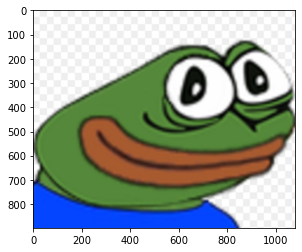

In [34]:
#okayge

import matplotlib.pyplot as plt

okayge = plt.imread("okayge.jpg")
plt.imshow(okayge)